In [2]:
import zipfile
import os

# 本地文件路径
train_data = 'train.csv'
test_data = 'test.csv'
img_data = 'data.zip'

# 解压缩数据
with zipfile.ZipFile(img_data, 'r') as zip_ref:
    zip_ref.extractall('./')

# 如果需要，你可以在这里添加代码来读取 train.csv 和 test.csv 文件


In [2]:
import os
import re
import time
import torch
import gensim.downloader
import gensim.downloader as gensim_api
import numpy as np
import pandas as pd
import torch.nn as nn
import skimage.io as io
import matplotlib.pyplot as plt
from tqdm import tqdm
from io import StringIO
from torchvision import transforms, models
from torchvision import models
from collections import Counter
from sklearn.metrics import f1_score, precision_score, recall_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import warnings

warnings.filterwarnings("ignore")  # Ignore the warning of the sklearn version

In [4]:
# NLP 相关资源下载
nltk_resources = ['omw-1.4', 'stopwords', 'wordnet']
for resource in nltk_resources:
    try:
        nltk.data.find(f'tokenizers/{resource}')
    except LookupError:
        nltk.download(resource)

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/warnerwong/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/warnerwong/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/warnerwong/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# File path and the Global parameters
DIR = 'COMP5329S1A2Dataset'
TRAIN_CSV = os.path.join(DIR, "train.csv")
TEST_CSV = os.path.join(DIR, "test.csv")
IMAGE_DIR = os.path.join(DIR, "data")
TRAIN_VAL_PROP = 0.8
BATCH_SIZE = 32
SEED = 5329
LR = 0.001
MAX_EPOCH = 20
THRESHOLD = 0.3
NUM_CLASS = 18
device = "cuda" if torch.cuda.is_available() else "cpu"

# 下载并加载预训练的词向量模型
EMBEDDING_MODEL = gensim_api.load('glove-wiki-gigaword-50')

In [4]:
# Correct the error data item in the train data file
with open(TRAIN_CSV) as fp:
    data = fp.readlines()

data[4790] = data[4790].replace("/", "")
data[14716] = data[14716].replace("/", "")
data[14961] = data[14961].replace("/", "")
data[29895] = data[29895].replace("/", "")

# Write back
with open(TRAIN_CSV, 'w') as file:
    file.writelines(data)

In [5]:
# Set of stopwords
stop_words = set(stopwords.words('english'))

# Lemmatizer object
lemmatizer = WordNetLemmatizer()

# Set of word errors
word_error = {'baeball', 'basball', 'blackandwhite', 'bluewhite', 'checkerd', 'firehydrant','firsbee', 'fourwheeler', 'frisbe', 'frizbee', 'kiteboards', 'krispee','midswing', 'parasailers', 'skiboard', 'skii', 'skiies', 'surfboarder','surfboarding', 'tball', 'umbrells', 'windsurfs', 'deckered', 'rared','snowcovered'}
        
def caption_extract(caption):
    caption_in_word = []

    for sentence in caption:
        # Convert the caption to lowercase and remove non-alphabetic characters and replace with space
        sentence = sentence.lower()
        sentence = re.sub(r'[^A-Za-z]+', ' ', sentence)
        # Split the caption into a list of words
        words = sentence.split()

        # Remove stopwords and perform lemmatization
        filtered_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

        # Filter out words with errors
        correct_word = [word for word in filtered_words if not word in word_error]
        caption_in_word.append(correct_word)

    return caption_in_word


def process_captions(train_file_path, test_file_path):

    # Processing train captions
    with open(train_file_path) as train_file:
        # Preprocessing step to handle quotes inside the captions
        train_lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in train_file]
        train_caption = pd.read_csv(StringIO(''.join(train_lines)), escapechar="/")
        train_caption = train_caption.drop(columns='Caption').join(train_caption['Caption'].str.replace('\"', ''))

    # Processing test captions
    with open(test_file_path) as test_file:
        # Preprocessing step to handle quotes inside the captions
        test_lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in test_file]
        test_caption = pd.read_csv(StringIO(''.join(test_lines)), escapechar="/")
        test_caption = test_caption.drop(columns='Caption').join(test_caption['Caption'].str.replace('\"', ''))

    # Extracting main feature words from concatenated train and test captions
    caption = caption_extract(pd.concat([train_caption['Caption'], test_caption['Caption']], axis=0, ignore_index=True))

    # Finding the maximum length among all captions
    max_len = max(len(s) for s in caption)

    return caption, max_len


whole_caption, max_caption_len = process_captions(TRAIN_CSV, TEST_CSV)
# vector size of each word
embedding_dim = EMBEDDING_MODEL.vector_size

In [6]:
def create_word_model(caption):

    # Extract words from the caption
    word_list = [word for sentence in caption for word in sentence]

    # Count word occurrences in the caption
    word_counter = Counter(word_list)

    # Select the words with more than 1 appearance for the vocabulary set
    vocab_set = {word for word, count in word_counter.items() if count > 4}

    # Add the PAD and UNKNOWN to the vocabulary set
    vocab_set.update(['[PAD]', '[UNKNOWN]'])

    # Sort the vocabulary set
    vocab_list = sorted(vocab_set)

    # Create the word dictionary and embedding table based on the pre-trained word embedding model
    vocab_dictionary = {}
    embedding_table = []
    for i, word in enumerate(vocab_list):
        vocab_dictionary[word] = i
        # If the word is in the pre-trained word embedding model, add word embedding to the table
        if word in EMBEDDING_MODEL:
            embedding_table.append(EMBEDDING_MODEL[word])
        else:
            embedding_table.append([0] * embedding_dim)
    embedding_table = np.array(embedding_table)

    return vocab_dictionary, embedding_table


vocab_dict, emb_table = create_word_model(whole_caption)

In [7]:
def tokenizer(caption):

    tokenize = []
    # Extract main feature words from captions
    caption = caption_extract(caption)

    for item in caption:
        # Convert each word to its corresponding index in the vocabulary dictionary
        # If a word is not present in the dictionary, use the index for the [UNKNOWN] token
        temp = [vocab_dict[word] if word in vocab_dict else vocab_dict['[UNKNOWN]'] for word in item]
        if len(temp) < max_caption_len:
            # If the caption is shorter than the maximum length
            # Pad the caption with [PAD] tokens to make it of maximum length
            temp += [vocab_dict['[PAD]']] * (max_caption_len - len(temp))
        else:
            # Truncate the caption if it exceeds the maximum length
            temp = temp[:max_caption_len]
        tokenize.append(temp)

    return tokenize

In [8]:
class DataLoad(torch.utils.data.Dataset):

    def __init__(self, data_file, image, transform=None, text_csv=None):

        self.image_dir = image
        self.text_csv = text_csv
        self.transform = transform
        self.classes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19]  # List of classes

        with open(data_file) as data_file:
            # Remove the 'Caption' column and join the 'Caption' values after removing quotes
            lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in data_file]
            dataframe = pd.read_csv(StringIO(''.join(lines)), escapechar="/")
            self.dataframe = dataframe.drop(columns='Caption').join(dataframe['Caption'].str.replace('\"', ''))

    def __len__(self):

        return self.dataframe.shape[0]

    def __getitem__(self, item):
  
        if torch.is_tensor(item):
            item.to_list()

        # Combine the image path with the image file name
        img_path = os.path.join(self.image_dir, self.dataframe.iloc[item, 0])
        img = io.imread(img_path)
        img_id = self.dataframe.iloc[item, 0]

        if not self.text_csv:
            img_caption = self.dataframe.iloc[item, 2]
            # Get the image labels and split them
            img_label = self.dataframe.iloc[item, 1].split(' ')
            # Convert labels to integers
            img_label = [int(x) for x in img_label]

            for i in range(len(img_label)):
                # One-hot encode and sum the image labels
                img_label[i] = [1 if cls == img_label[i] else 0 for cls in self.classes]
            img_label = sum(torch.tensor(img_label, dtype=torch.float))

            if self.transform:
                img = self.transform(img)

            sample = {'img': img, 'label': img_label, 'id': img_id, 'caption': img_caption}
        else:
            img_caption = self.dataframe.iloc[item, 1]
            if self.transform:
                img = self.transform(img)
            sample = {'img': img, 'id': img_id, 'caption': img_caption}

        return sample

In [9]:
# Image Pre-Processing
transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.RandomAffine(degrees=20, translate=(0.2, 0.2), scale=(0.5, 1.5),
                                shear=None,
                                fill=tuple(np.array(np.array([0.485, 0.456, 0.406]) * 255).astype(int).tolist())),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((256, 256)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

dataset = DataLoad(data_file=TRAIN_CSV, image=IMAGE_DIR, transform=transforms['train'], text_csv=False)
test_dataset = DataLoad(data_file=TEST_CSV, image=IMAGE_DIR, transform=transforms['val'], text_csv=True)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [int(TRAIN_VAL_PROP * len(dataset)),
                                                                     len(dataset) - (
                                                                         int(TRAIN_VAL_PROP * len(dataset)))])

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=8, shuffle=False, num_workers=0)

In [10]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # 使用预训练的GoogleNet作为特征提取器
        self.google_net = models.googlenet(pretrained=True)
        # 修改最后的分类层以适应你的任务，例如输出维度为64
        self.google_net.fc = nn.Linear(self.google_net.fc.in_features, 64)
        
        # 冻结GoogleNet的参数，仅训练分类层
        for param in self.google_net.parameters():
            param.requires_grad = False
        self.google_net.fc.requires_grad = True
        
        # 其他层的定义不变
        self.emb = nn.Embedding(num_embeddings=emb_table.shape[0], embedding_dim=emb_table.shape[1])
        self.emb.weight.data.copy_(torch.from_numpy(emb_table))
        self.emb.weight.requires_grad = False

        self.lstm = nn.LSTM(input_size=emb_table.shape[1], hidden_size=emb_table.shape[1], num_layers=2,
                            batch_first=True, dropout=0.2)

        self.linear = nn.Linear(in_features=emb_table.shape[1] * 2, out_features=64)
        self.classifier = nn.Linear(in_features=128, out_features=NUM_CLASS)

    def forward(self, image, caption):
        net_out = self.google_net(image) 
        if isinstance(net_out, tuple):  # 如果输出是元组，可能包含辅助分类器的输出
            net_out = net_out[0]  # 假设主要的分类输出是元组的第一个元素

        print("Shape of net_out:", net_out.shape)  # 打印形状以确认

        x = self.emb(caption)
        _, (h, c) = self.lstm(x)
        x = torch.cat((h[0, :, :], h[1, :, :]), 1)
        lstm_out = self.linear(x)
        print("Shape of lstm_out:", lstm_out.shape)  # 打印形状以确认

        output = self.classifier(torch.cat((net_out, lstm_out), dim=1))
        return output


net_model = Model().to(device)

In [11]:
def model_size(model):

    cnn_size = 0
    # Iterate over the named parameters of the model
    for name, param in model.named_parameters():
        # Calculate the size of the parameter in megabytes
        param_size = np.prod(list(param.shape)) * 4 / 1e6
        cnn_size += param_size
  
    # Calculate the embedding model size
    embedding_model_path = gensim_api.load('glove-wiki-gigaword-50', return_path=True)
    embedding_size = os.stat(embedding_model_path).st_size / (1024 * 1024)

    print("Model Memory Usage: {:.4f} MB; Pretrained Embeddings: {:.4f} MB".format(cnn_size, embedding_size))
    print("Total required memory: {:.4f} MB".format((cnn_size + embedding_size)))
    if (cnn_size + embedding_size) > 100:
        raise ValueError("Network storage exceeds 100 MB threshold!")


model_size(net_model)

Model Memory Usage: 23.3036 MB; Pretrained Embeddings: 65.9776 MB
Total required memory: 89.2812 MB


In [12]:
def get_acc(output, label):

    # Convert the predicted output and labels to numpy arrays
    output = output.cpu().detach().numpy()
    label = label.cpu().numpy()
    predicted_labels = []
    for preds in output:
        # If there is no sigmoid output larger than threshold, set the second element as the predict label
        if sum(preds > THRESHOLD) == 0:
            temp = np.zeros(18)
            temp[np.argmax(preds[1])] = 1
            predicted_labels.append(temp)
        # If there is at least one sigmoid output larger than threshold
        else:
            predicted_labels.append(np.array(preds > THRESHOLD, dtype=float))
    pred = np.array(predicted_labels, dtype=float)

    precision = precision_score(y_true=label, y_pred=pred, average='micro')
    recall = recall_score(y_true=label, y_pred=pred, average='micro')
    f1 = f1_score(y_true=label, y_pred=pred, average='micro')

    return 100 * precision, 100 * recall, 100 * f1

In [13]:
def train(model, dataloader, loss_fn, opt):

    train_loss = 0
    train_precision = 0
    train_recall = 0
    train_f1 = 0
    batch_size = 0
    batch_num = 0
    # Set the model to train mode
    model.train()

    # batch item: img, label, id, caption
    for batch in tqdm(dataloader):
        # Caption: input_ids, token_type_ids, attention_mask
        img, label, caption = batch["img"].to(device), batch["label"].to(device), torch.from_numpy(
            np.array(tokenizer(batch["caption"]))).to(device)
        # Zero the gradients
        opt.zero_grad()
        output = model(img, caption)
        loss = loss_fn(output, label)
        # Backward pass and optimization step
        loss.backward()
        opt.step()

        precision, recall, f1 = get_acc(nn.Sigmoid()(output), label)
        batch_num += 1
        batch_size += 1
        # Accumulate the batch loss scaled by the batch size
        train_loss += loss.item() * img.size(0)
        train_precision += precision
        train_recall += recall
        train_f1 += f1
        print('\rBatch[{}/{}] - loss: {:.6f}  precision: {:.4f}%  recall: {:.4f}%  F1_score: {:.4f}%'.format(batch_size,
                                                                                                             len(dataloader),
                                                                                                             loss.item() * img.size(
                                                                                                                 0),
                                                                                                             precision,
                                                                                                             recall,
                                                                                                             f1))

    return train_loss, train_precision, train_recall, train_f1, batch_num


def evaluate(model, dataloader, loss_fn):

    val_loss = 0
    val_precision = 0
    val_recall = 0
    val_f1 = 0
    batch_num = 0
    # Set the model to evaluation mode
    model.eval()

    # Disable gradient computation
    with torch.no_grad():
        for batch in tqdm(dataloader):
            img, label, caption = batch["img"].to(device), batch["label"].to(device), torch.from_numpy(
                np.array(tokenizer(batch["caption"]))).to(device)
            output = model(img, caption)
            loss = loss_fn(output, label)

            precision, recall, f1 = get_acc(nn.Sigmoid()(output), label)
            batch_num += 1
            val_loss += loss.item() * img.size(0)
            val_precision += precision
            val_recall += recall
            val_f1 += f1

    return val_loss, val_precision, val_recall, val_f1, batch_num


def fit(model, train_dataloader, val_dataloader, epochs, loss_fn, opt, shed):

    # Record the start time
    start_time = time.time()

    tr_loss_all = np.zeros(epochs)
    tr_precision_all = np.zeros(epochs)
    tr_recall_all = np.zeros(epochs)
    tr_f1_all = np.zeros(epochs)
    vl_loss_all = np.zeros(epochs)
    vl_precision_all = np.zeros(epochs)
    vl_recall_all = np.zeros(epochs)
    vl_f1_all = np.zeros(epochs)

    best_f1 = 0

    for epoch in range(epochs):
        train_loss, train_precision, train_recall, train_f1, train_batch_num = train(model, train_dataloader, loss_fn,
                                                                                     opt)
        val_loss, val_precision, val_recall, val_f1, val_batch_num = evaluate(model, val_dataloader, loss_fn)
        print('Epoch [{}/{}]'.format(epoch, epochs))
        print('Train - loss: {:.6f}  precision: {:.4f}%  recall: {:.4f}%  F1_score: {:.4f}%'.format(
            train_loss / len(train_dataset), train_precision / train_batch_num, train_recall / train_batch_num,
            train_f1 / train_batch_num))
        print('Val - loss: {:.6f}  precision: {:.4f}%  recall: {:.4f}%  F1_score: {:.4f}%'.format(
            val_loss / len(val_dataset), val_precision / val_batch_num, val_recall / val_batch_num,
            val_f1 / val_batch_num))
        print('-' * 19)

        # Store metrics for the current epoch
        tr_loss_all[epoch] = train_loss / len(train_dataset)
        tr_precision_all[epoch] = train_precision / train_batch_num
        tr_recall_all[epoch] = train_recall / train_batch_num
        tr_f1_all[epoch] = train_f1 / train_batch_num
        vl_loss_all[epoch] = val_loss / len(val_dataset)
        vl_precision_all[epoch] = val_precision / val_batch_num
        vl_recall_all[epoch] = val_recall / val_batch_num
        vl_f1_all[epoch] = val_f1 / val_batch_num

        # Adjust learning rate using the scheduler
        shed.step(train_loss / len(train_dataset))

        # Save the model with the best F1 score so far
        if val_f1 / val_batch_num > best_f1:
            best_f1 = val_f1 / val_batch_num
            print('Saving best pre_model, f1: {:.4f}%\n'.format(best_f1))
            torch.save(model.state_dict(), 'best_steps.pth')

    # Calculate the duration of training
    duration = time.time() - start_time
    print('Training complete in {:.0f}m {:.0f}s'.format(duration // 60, duration % 60))

    return tr_loss_all, tr_precision_all, tr_recall_all, tr_f1_all, vl_loss_all, vl_precision_all, vl_recall_all, vl_f1_all

In [14]:
class FocalLoss(nn.Module):

    def __init__(self, gamma=2, alpha=0.25):
       
        super().__init__()
        # Wraps focal loss around existing loss_fcn()
        self.loss_fcn = nn.BCEWithLogitsLoss()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = 'sum'
        # required to apply FL to each element
        self.loss_fcn.reduction = 'none'

    def forward(self, pred, true):

        # Calculate the loss
        loss = self.loss_fcn(pred, true)
        # Calculate probability from logits
        pred_prob = torch.sigmoid(pred)
        # Calculate the modulating factor
        p_t = true * pred_prob + (1 - true) * (1 - pred_prob)
        # Calculate the alpha factor
        alpha_factor = true * self.alpha + (1 - true) * (1 - self.alpha)
        modulating_factor = (1.0 - p_t) ** self.gamma
        loss *= alpha_factor * modulating_factor

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:  # 'none'
            return loss

In [15]:
optimizer = torch.optim.Adam(net_model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=2,
    threshold=0.0001,
    threshold_mode="rel",
    cooldown=0,
    min_lr=0,
    eps=1e-08,
    verbose=False,
)
loss_function = nn.BCEWithLogitsLoss()
# loss_function = FocalLoss()

In [16]:
tr_loss, tr_precision, tr_recall, tr_f1, vl_loss, vl_precision, vl_recall, vl_f1 = fit(net_model, train_loader,
                                                                                       val_loader, MAX_EPOCH,
                                                                                       loss_function, optimizer,
                                                                                       scheduler)

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 1/750 [00:02<25:18,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[1/750] - loss: 22.078239  precision: 8.3333%  recall: 100.0000%  F1_score: 15.3846%


  0%|          | 2/750 [00:03<23:55,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[2/750] - loss: 21.809971  precision: 6.9444%  recall: 100.0000%  F1_score: 12.9870%


  0%|          | 3/750 [00:05<23:08,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[3/750] - loss: 21.538063  precision: 9.3750%  recall: 100.0000%  F1_score: 17.1429%


  1%|          | 4/750 [00:07<22:38,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[4/750] - loss: 21.196745  precision: 9.0278%  recall: 100.0000%  F1_score: 16.5605%


  1%|          | 5/750 [00:09<22:21,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[5/750] - loss: 21.061440  precision: 9.2014%  recall: 100.0000%  F1_score: 16.8521%


  1%|          | 6/750 [00:10<22:09,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[6/750] - loss: 20.750122  precision: 9.7222%  recall: 100.0000%  F1_score: 17.7215%


  1%|          | 7/750 [00:12<22:21,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[7/750] - loss: 20.575045  precision: 8.5069%  recall: 100.0000%  F1_score: 15.6800%


  1%|          | 8/750 [00:14<22:18,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[8/750] - loss: 20.157400  precision: 7.6389%  recall: 100.0000%  F1_score: 14.1935%


  1%|          | 9/750 [00:16<22:12,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[9/750] - loss: 19.942736  precision: 9.7222%  recall: 100.0000%  F1_score: 17.7215%


  1%|▏         | 10/750 [00:18<22:18,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[10/750] - loss: 19.744286  precision: 9.8958%  recall: 100.0000%  F1_score: 18.0095%


  1%|▏         | 11/750 [00:19<22:07,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[11/750] - loss: 19.362267  precision: 9.5486%  recall: 100.0000%  F1_score: 17.4326%


  2%|▏         | 12/750 [00:21<22:00,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[12/750] - loss: 18.991026  precision: 8.8542%  recall: 100.0000%  F1_score: 16.2679%


  2%|▏         | 13/750 [00:23<21:54,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[13/750] - loss: 18.654198  precision: 8.5069%  recall: 100.0000%  F1_score: 15.6800%


  2%|▏         | 14/750 [00:25<21:47,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[14/750] - loss: 18.543633  precision: 8.1597%  recall: 100.0000%  F1_score: 15.0883%


  2%|▏         | 15/750 [00:27<22:07,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[15/750] - loss: 18.029446  precision: 8.8542%  recall: 100.0000%  F1_score: 16.2679%


  2%|▏         | 16/750 [00:28<22:05,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[16/750] - loss: 17.642059  precision: 9.5652%  recall: 100.0000%  F1_score: 17.4603%


  2%|▏         | 17/750 [00:30<21:53,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[17/750] - loss: 17.018671  precision: 7.9861%  recall: 100.0000%  F1_score: 14.7910%


  2%|▏         | 18/750 [00:32<21:46,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[18/750] - loss: 16.462240  precision: 8.0139%  recall: 97.8723%  F1_score: 14.8148%


  3%|▎         | 19/750 [00:34<21:38,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[19/750] - loss: 16.090275  precision: 9.5070%  recall: 100.0000%  F1_score: 17.3633%


  3%|▎         | 20/750 [00:36<21:32,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[20/750] - loss: 15.130546  precision: 9.1075%  recall: 98.0392%  F1_score: 16.6667%


  3%|▎         | 21/750 [00:37<21:41,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[21/750] - loss: 14.144085  precision: 10.1695%  recall: 96.0000%  F1_score: 18.3908%


  3%|▎         | 22/750 [00:39<21:31,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[22/750] - loss: 13.199192  precision: 12.1951%  recall: 85.1064%  F1_score: 21.3333%


  3%|▎         | 23/750 [00:41<21:27,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[23/750] - loss: 11.976562  precision: 18.8406%  recall: 79.5918%  F1_score: 30.4688%


  3%|▎         | 24/750 [00:43<21:40,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[24/750] - loss: 11.329319  precision: 29.1667%  recall: 63.6364%  F1_score: 40.0000%


  3%|▎         | 25/750 [00:44<21:37,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[25/750] - loss: 10.239103  precision: 31.9444%  recall: 51.1111%  F1_score: 39.3162%


  3%|▎         | 26/750 [00:46<21:32,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[26/750] - loss: 8.525194  precision: 42.3729%  recall: 56.8182%  F1_score: 48.5437%


  4%|▎         | 27/750 [00:48<21:25,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[27/750] - loss: 6.798472  precision: 80.5556%  recall: 63.0435%  F1_score: 70.7317%


  4%|▎         | 28/750 [00:50<21:18,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[28/750] - loss: 6.443693  precision: 84.3750%  recall: 54.0000%  F1_score: 65.8537%


  4%|▍         | 29/750 [00:51<21:10,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[29/750] - loss: 8.492526  precision: 65.6250%  recall: 36.8421%  F1_score: 47.1910%


  4%|▍         | 30/750 [00:53<21:03,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[30/750] - loss: 6.840198  precision: 68.7500%  recall: 47.8261%  F1_score: 56.4103%


  4%|▍         | 31/750 [00:55<21:01,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[31/750] - loss: 8.946117  precision: 68.7500%  recall: 38.5965%  F1_score: 49.4382%


  4%|▍         | 32/750 [00:57<21:00,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[32/750] - loss: 6.122115  precision: 81.2500%  recall: 54.1667%  F1_score: 65.0000%


  4%|▍         | 33/750 [00:59<21:27,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[33/750] - loss: 4.521248  precision: 90.6250%  recall: 64.4444%  F1_score: 75.3247%


  5%|▍         | 34/750 [01:00<21:15,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[34/750] - loss: 7.259907  precision: 68.7500%  recall: 46.8085%  F1_score: 55.6962%


  5%|▍         | 35/750 [01:02<21:18,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[35/750] - loss: 8.635267  precision: 65.6250%  recall: 42.0000%  F1_score: 51.2195%


  5%|▍         | 36/750 [01:04<21:20,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[36/750] - loss: 8.239860  precision: 68.7500%  recall: 43.1373%  F1_score: 53.0120%


  5%|▍         | 37/750 [01:06<21:17,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[37/750] - loss: 6.059165  precision: 87.5000%  recall: 54.9020%  F1_score: 67.4699%


  5%|▌         | 38/750 [01:08<21:07,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[38/750] - loss: 7.462122  precision: 71.8750%  recall: 46.9388%  F1_score: 56.7901%


  5%|▌         | 39/750 [01:09<21:03,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[39/750] - loss: 8.606433  precision: 68.7500%  recall: 41.5094%  F1_score: 51.7647%


  5%|▌         | 40/750 [01:11<20:56,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[40/750] - loss: 9.527259  precision: 87.5000%  recall: 41.7910%  F1_score: 56.5657%


  5%|▌         | 41/750 [01:13<20:59,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[41/750] - loss: 5.496623  precision: 75.0000%  recall: 57.1429%  F1_score: 64.8649%


  6%|▌         | 42/750 [01:15<20:54,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[42/750] - loss: 7.213282  precision: 81.2500%  recall: 48.1481%  F1_score: 60.4651%


  6%|▌         | 43/750 [01:16<20:52,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[43/750] - loss: 5.414590  precision: 87.5000%  recall: 56.0000%  F1_score: 68.2927%


  6%|▌         | 44/750 [01:18<21:01,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[44/750] - loss: 6.104342  precision: 90.6250%  recall: 55.7692%  F1_score: 69.0476%


  6%|▌         | 45/750 [01:20<20:53,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[45/750] - loss: 7.016333  precision: 75.0000%  recall: 44.4444%  F1_score: 55.8140%


  6%|▌         | 46/750 [01:22<20:49,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[46/750] - loss: 5.331427  precision: 96.8750%  recall: 60.7843%  F1_score: 74.6988%


  6%|▋         | 47/750 [01:23<20:39,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[47/750] - loss: 7.062753  precision: 87.5000%  recall: 47.4576%  F1_score: 61.5385%


  6%|▋         | 48/750 [01:25<20:37,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[48/750] - loss: 7.126123  precision: 59.3750%  recall: 42.2222%  F1_score: 49.3506%


  7%|▋         | 49/750 [01:27<21:05,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[49/750] - loss: 8.074456  precision: 68.7500%  recall: 38.5965%  F1_score: 49.4382%


  7%|▋         | 50/750 [01:29<21:03,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[50/750] - loss: 6.186524  precision: 75.0000%  recall: 50.0000%  F1_score: 60.0000%


  7%|▋         | 51/750 [01:31<20:54,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[51/750] - loss: 7.263239  precision: 78.1250%  recall: 44.6429%  F1_score: 56.8182%


  7%|▋         | 52/750 [01:32<20:44,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[52/750] - loss: 6.765062  precision: 71.8750%  recall: 46.0000%  F1_score: 56.0976%


  7%|▋         | 53/750 [01:34<20:57,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[53/750] - loss: 9.466467  precision: 46.8750%  recall: 26.7857%  F1_score: 34.0909%


  7%|▋         | 54/750 [01:36<20:49,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[54/750] - loss: 6.965014  precision: 75.0000%  recall: 47.0588%  F1_score: 57.8313%


  7%|▋         | 55/750 [01:38<20:44,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[55/750] - loss: 6.467370  precision: 68.7500%  recall: 48.8889%  F1_score: 57.1429%


  7%|▋         | 56/750 [01:40<20:43,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[56/750] - loss: 5.742529  precision: 78.1250%  recall: 58.1395%  F1_score: 66.6667%


  8%|▊         | 57/750 [01:41<20:33,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[57/750] - loss: 7.155477  precision: 68.7500%  recall: 43.1373%  F1_score: 53.0120%


  8%|▊         | 58/750 [01:43<20:27,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[58/750] - loss: 6.575117  precision: 78.1250%  recall: 52.0833%  F1_score: 62.5000%


  8%|▊         | 59/750 [01:45<20:30,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[59/750] - loss: 5.868725  precision: 75.0000%  recall: 55.8140%  F1_score: 64.0000%


  8%|▊         | 60/750 [01:47<20:26,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[60/750] - loss: 6.659363  precision: 75.0000%  recall: 48.0000%  F1_score: 58.5366%


  8%|▊         | 61/750 [01:48<20:20,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[61/750] - loss: 6.103803  precision: 81.2500%  recall: 52.0000%  F1_score: 63.4146%


  8%|▊         | 62/750 [01:50<20:30,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[62/750] - loss: 6.328273  precision: 84.3750%  recall: 51.9231%  F1_score: 64.2857%


  8%|▊         | 63/750 [01:52<20:22,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[63/750] - loss: 6.866187  precision: 68.7500%  recall: 45.8333%  F1_score: 55.0000%


  9%|▊         | 64/750 [01:54<20:16,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[64/750] - loss: 5.406811  precision: 81.2500%  recall: 57.7778%  F1_score: 67.5325%


  9%|▊         | 65/750 [01:56<20:10,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[65/750] - loss: 7.517680  precision: 78.1250%  recall: 43.1034%  F1_score: 55.5556%


  9%|▉         | 66/750 [01:57<20:08,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[66/750] - loss: 6.269880  precision: 71.8750%  recall: 50.0000%  F1_score: 58.9744%


  9%|▉         | 67/750 [01:59<20:04,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[67/750] - loss: 7.464198  precision: 71.8750%  recall: 41.0714%  F1_score: 52.2727%


  9%|▉         | 68/750 [02:01<20:01,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[68/750] - loss: 7.245924  precision: 68.7500%  recall: 44.8980%  F1_score: 54.3210%


  9%|▉         | 69/750 [02:03<20:13,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[69/750] - loss: 5.416384  precision: 87.5000%  recall: 57.1429%  F1_score: 69.1358%


  9%|▉         | 70/750 [02:04<20:06,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[70/750] - loss: 6.669706  precision: 81.2500%  recall: 48.1481%  F1_score: 60.4651%


  9%|▉         | 71/750 [02:06<20:00,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[71/750] - loss: 7.946825  precision: 65.6250%  recall: 38.8889%  F1_score: 48.8372%


 10%|▉         | 72/750 [02:08<20:17,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[72/750] - loss: 5.427701  precision: 78.1250%  recall: 56.8182%  F1_score: 65.7895%


 10%|▉         | 73/750 [02:10<20:36,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[73/750] - loss: 7.446873  precision: 78.1250%  recall: 43.8596%  F1_score: 56.1798%


 10%|▉         | 74/750 [02:12<20:30,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[74/750] - loss: 6.242505  precision: 75.0000%  recall: 50.0000%  F1_score: 60.0000%


 10%|█         | 75/750 [02:14<21:12,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[75/750] - loss: 5.921097  precision: 81.2500%  recall: 54.1667%  F1_score: 65.0000%


 10%|█         | 76/750 [02:16<21:29,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[76/750] - loss: 7.733884  precision: 65.6250%  recall: 39.6226%  F1_score: 49.4118%


 10%|█         | 77/750 [02:18<21:17,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[77/750] - loss: 6.718741  precision: 62.5000%  recall: 44.4444%  F1_score: 51.9481%


 10%|█         | 78/750 [02:19<20:58,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[78/750] - loss: 5.578035  precision: 78.1250%  recall: 55.5556%  F1_score: 64.9351%


 11%|█         | 79/750 [02:21<20:56,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[79/750] - loss: 6.534920  precision: 78.1250%  recall: 49.0196%  F1_score: 60.2410%


 11%|█         | 80/750 [02:23<20:52,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[80/750] - loss: 5.592265  precision: 81.2500%  recall: 56.5217%  F1_score: 66.6667%


 11%|█         | 81/750 [02:25<20:51,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[81/750] - loss: 3.503619  precision: 96.8750%  recall: 75.6098%  F1_score: 84.9315%


 11%|█         | 82/750 [02:27<21:04,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[82/750] - loss: 6.636568  precision: 65.6250%  recall: 45.6522%  F1_score: 53.8462%


 11%|█         | 83/750 [02:29<20:47,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[83/750] - loss: 5.790980  precision: 75.0000%  recall: 53.3333%  F1_score: 62.3377%


 11%|█         | 84/750 [02:31<20:50,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[84/750] - loss: 5.744003  precision: 84.3750%  recall: 54.0000%  F1_score: 65.8537%


 11%|█▏        | 85/750 [02:33<20:53,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[85/750] - loss: 6.965865  precision: 71.8750%  recall: 46.0000%  F1_score: 56.0976%


 11%|█▏        | 86/750 [02:35<22:13,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[86/750] - loss: 7.452048  precision: 68.7500%  recall: 41.5094%  F1_score: 51.7647%


 12%|█▏        | 87/750 [02:37<22:36,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[87/750] - loss: 6.500388  precision: 78.1250%  recall: 48.0769%  F1_score: 59.5238%


 12%|█▏        | 88/750 [02:39<21:33,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[88/750] - loss: 6.918290  precision: 68.7500%  recall: 44.8980%  F1_score: 54.3210%


 12%|█▏        | 89/750 [02:41<20:53,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[89/750] - loss: 5.719694  precision: 81.2500%  recall: 52.0000%  F1_score: 63.4146%


 12%|█▏        | 90/750 [02:42<20:30,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[90/750] - loss: 7.220921  precision: 75.0000%  recall: 44.4444%  F1_score: 55.8140%


 12%|█▏        | 91/750 [02:44<20:20,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[91/750] - loss: 6.554074  precision: 65.6250%  recall: 45.6522%  F1_score: 53.8462%


 12%|█▏        | 92/750 [02:46<20:10,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[92/750] - loss: 4.779720  precision: 84.3750%  recall: 62.7907%  F1_score: 72.0000%


 12%|█▏        | 93/750 [02:48<19:56,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[93/750] - loss: 7.224439  precision: 81.2500%  recall: 46.4286%  F1_score: 59.0909%


 13%|█▎        | 94/750 [02:50<20:10,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[94/750] - loss: 7.181269  precision: 62.5000%  recall: 41.6667%  F1_score: 50.0000%


 13%|█▎        | 95/750 [02:51<19:49,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[95/750] - loss: 6.537706  precision: 78.1250%  recall: 50.0000%  F1_score: 60.9756%


 13%|█▎        | 96/750 [02:53<19:45,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[96/750] - loss: 8.155132  precision: 81.2500%  recall: 41.2698%  F1_score: 54.7368%


 13%|█▎        | 97/750 [02:55<19:43,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[97/750] - loss: 6.820154  precision: 65.6250%  recall: 45.6522%  F1_score: 53.8462%


 13%|█▎        | 98/750 [02:57<19:54,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[98/750] - loss: 7.251838  precision: 84.3750%  recall: 45.7627%  F1_score: 59.3407%


 13%|█▎        | 99/750 [02:59<20:00,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[99/750] - loss: 6.054559  precision: 87.5000%  recall: 52.8302%  F1_score: 65.8824%


 13%|█▎        | 100/750 [03:01<19:47,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[100/750] - loss: 6.713727  precision: 71.8750%  recall: 46.9388%  F1_score: 56.7901%


 13%|█▎        | 101/750 [03:02<19:52,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[101/750] - loss: 8.082541  precision: 78.1250%  recall: 40.3226%  F1_score: 53.1915%


 14%|█▎        | 102/750 [03:04<19:52,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[102/750] - loss: 6.708349  precision: 75.0000%  recall: 48.0000%  F1_score: 58.5366%


 14%|█▎        | 103/750 [03:07<21:43,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[103/750] - loss: 6.286386  precision: 75.0000%  recall: 51.0638%  F1_score: 60.7595%


 14%|█▍        | 104/750 [03:09<21:16,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[104/750] - loss: 7.123236  precision: 75.0000%  recall: 43.6364%  F1_score: 55.1724%


 14%|█▍        | 105/750 [03:11<22:40,  2.11s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[105/750] - loss: 5.940598  precision: 78.1250%  recall: 53.1915%  F1_score: 63.2911%


 14%|█▍        | 106/750 [03:13<22:32,  2.10s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[106/750] - loss: 6.509844  precision: 71.8750%  recall: 46.0000%  F1_score: 56.0976%


 14%|█▍        | 107/750 [03:15<22:01,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[107/750] - loss: 7.321189  precision: 87.5000%  recall: 45.1613%  F1_score: 59.5745%


 14%|█▍        | 108/750 [03:17<21:06,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[108/750] - loss: 6.754676  precision: 65.6250%  recall: 44.6809%  F1_score: 53.1646%


 15%|█▍        | 109/750 [03:19<20:26,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[109/750] - loss: 8.001683  precision: 65.6250%  recall: 36.8421%  F1_score: 47.1910%


 15%|█▍        | 110/750 [03:20<20:17,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[110/750] - loss: 7.331712  precision: 75.0000%  recall: 45.2830%  F1_score: 56.4706%


 15%|█▍        | 111/750 [03:22<19:49,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[111/750] - loss: 5.385717  precision: 75.0000%  recall: 60.0000%  F1_score: 66.6667%


 15%|█▍        | 112/750 [03:24<19:31,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[112/750] - loss: 5.715574  precision: 71.8750%  recall: 54.7619%  F1_score: 62.1622%


 15%|█▌        | 113/750 [03:26<19:48,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[113/750] - loss: 6.347455  precision: 81.2500%  recall: 52.0000%  F1_score: 63.4146%


 15%|█▌        | 114/750 [03:28<21:02,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[114/750] - loss: 5.509690  precision: 78.1250%  recall: 56.8182%  F1_score: 65.7895%


 15%|█▌        | 115/750 [03:30<21:21,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[115/750] - loss: 5.163697  precision: 84.3750%  recall: 57.4468%  F1_score: 68.3544%


 15%|█▌        | 116/750 [03:32<20:45,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[116/750] - loss: 5.737887  precision: 75.0000%  recall: 52.1739%  F1_score: 61.5385%


 16%|█▌        | 117/750 [03:35<22:34,  2.14s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[117/750] - loss: 5.869298  precision: 78.1250%  recall: 53.1915%  F1_score: 63.2911%


 16%|█▌        | 118/750 [03:37<22:11,  2.11s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[118/750] - loss: 6.557488  precision: 65.6250%  recall: 47.7273%  F1_score: 55.2632%


 16%|█▌        | 119/750 [03:39<22:49,  2.17s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[119/750] - loss: 5.708508  precision: 84.3750%  recall: 54.0000%  F1_score: 65.8537%


 16%|█▌        | 120/750 [03:41<22:04,  2.10s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[120/750] - loss: 7.400922  precision: 71.8750%  recall: 44.2308%  F1_score: 54.7619%


 16%|█▌        | 121/750 [03:43<21:22,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[121/750] - loss: 7.073412  precision: 84.3750%  recall: 46.5517%  F1_score: 60.0000%


 16%|█▋        | 122/750 [03:45<21:04,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[122/750] - loss: 6.276645  precision: 75.0000%  recall: 50.0000%  F1_score: 60.0000%


 16%|█▋        | 123/750 [03:47<20:42,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[123/750] - loss: 5.780912  precision: 84.3750%  recall: 55.1020%  F1_score: 66.6667%


 17%|█▋        | 124/750 [03:49<20:49,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[124/750] - loss: 5.948853  precision: 78.1250%  recall: 52.0833%  F1_score: 62.5000%


 17%|█▋        | 125/750 [03:51<20:21,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[125/750] - loss: 6.697078  precision: 78.1250%  recall: 50.0000%  F1_score: 60.9756%


 17%|█▋        | 126/750 [03:52<19:51,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[126/750] - loss: 6.202688  precision: 65.6250%  recall: 50.0000%  F1_score: 56.7568%


 17%|█▋        | 127/750 [03:54<19:38,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[127/750] - loss: 7.017848  precision: 78.1250%  recall: 46.2963%  F1_score: 58.1395%


 17%|█▋        | 128/750 [03:56<19:12,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[128/750] - loss: 5.922344  precision: 84.3750%  recall: 55.1020%  F1_score: 66.6667%


 17%|█▋        | 129/750 [03:58<19:13,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[129/750] - loss: 5.934876  precision: 90.6250%  recall: 55.7692%  F1_score: 69.0476%


 17%|█▋        | 130/750 [04:00<19:04,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[130/750] - loss: 8.626302  precision: 68.7500%  recall: 36.6667%  F1_score: 47.8261%


 17%|█▋        | 131/750 [04:02<19:31,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[131/750] - loss: 7.478149  precision: 68.7500%  recall: 41.5094%  F1_score: 51.7647%


 18%|█▊        | 132/750 [04:03<19:00,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[132/750] - loss: 7.035241  precision: 71.8750%  recall: 44.2308%  F1_score: 54.7619%


 18%|█▊        | 133/750 [04:05<18:41,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[133/750] - loss: 7.142558  precision: 84.3750%  recall: 46.5517%  F1_score: 60.0000%


 18%|█▊        | 134/750 [04:07<18:36,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[134/750] - loss: 5.797594  precision: 71.8750%  recall: 53.4884%  F1_score: 61.3333%


 18%|█▊        | 135/750 [04:09<18:36,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[135/750] - loss: 5.448378  precision: 81.2500%  recall: 57.7778%  F1_score: 67.5325%


 18%|█▊        | 136/750 [04:11<18:27,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[136/750] - loss: 6.772227  precision: 75.0000%  recall: 45.2830%  F1_score: 56.4706%


 18%|█▊        | 137/750 [04:12<18:23,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[137/750] - loss: 7.145300  precision: 62.5000%  recall: 41.6667%  F1_score: 50.0000%


 18%|█▊        | 138/750 [04:14<18:32,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[138/750] - loss: 7.261206  precision: 81.2500%  recall: 44.0678%  F1_score: 57.1429%


 19%|█▊        | 139/750 [04:17<19:48,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[139/750] - loss: 6.941234  precision: 75.0000%  recall: 43.6364%  F1_score: 55.1724%


 19%|█▊        | 140/750 [04:18<19:18,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[140/750] - loss: 4.635561  precision: 87.5000%  recall: 66.6667%  F1_score: 75.6757%


 19%|█▉        | 141/750 [04:20<18:58,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[141/750] - loss: 6.840236  precision: 78.1250%  recall: 48.0769%  F1_score: 59.5238%


 19%|█▉        | 142/750 [04:22<18:44,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[142/750] - loss: 7.047374  precision: 78.1250%  recall: 46.2963%  F1_score: 58.1395%


 19%|█▉        | 143/750 [04:24<19:02,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[143/750] - loss: 6.598579  precision: 68.7500%  recall: 45.8333%  F1_score: 55.0000%


 19%|█▉        | 144/750 [04:26<18:47,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[144/750] - loss: 6.106304  precision: 78.1250%  recall: 51.0204%  F1_score: 61.7284%


 19%|█▉        | 145/750 [04:27<18:25,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[145/750] - loss: 6.616821  precision: 71.8750%  recall: 47.9167%  F1_score: 57.5000%


 19%|█▉        | 146/750 [04:29<18:09,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[146/750] - loss: 7.023054  precision: 71.8750%  recall: 46.0000%  F1_score: 56.0976%


 20%|█▉        | 147/750 [04:31<17:53,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[147/750] - loss: 6.684542  precision: 68.7500%  recall: 48.8889%  F1_score: 57.1429%


 20%|█▉        | 148/750 [04:33<17:44,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[148/750] - loss: 5.954183  precision: 71.8750%  recall: 53.4884%  F1_score: 61.3333%


 20%|█▉        | 149/750 [04:34<17:41,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[149/750] - loss: 6.847620  precision: 84.3750%  recall: 50.0000%  F1_score: 62.7907%


 20%|██        | 150/750 [04:36<17:46,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[150/750] - loss: 6.706649  precision: 71.8750%  recall: 46.9388%  F1_score: 56.7901%


 20%|██        | 151/750 [04:38<17:34,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[151/750] - loss: 5.828681  precision: 84.3750%  recall: 54.0000%  F1_score: 65.8537%


 20%|██        | 152/750 [04:40<17:27,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[152/750] - loss: 6.803515  precision: 65.6250%  recall: 44.6809%  F1_score: 53.1646%


 20%|██        | 153/750 [04:41<17:20,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[153/750] - loss: 6.838114  precision: 75.0000%  recall: 47.0588%  F1_score: 57.8313%


 21%|██        | 154/750 [04:43<17:21,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[154/750] - loss: 6.763465  precision: 78.1250%  recall: 48.0769%  F1_score: 59.5238%


 21%|██        | 155/750 [04:45<17:20,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[155/750] - loss: 5.841558  precision: 81.2500%  recall: 53.0612%  F1_score: 64.1975%


 21%|██        | 156/750 [04:47<17:18,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[156/750] - loss: 6.478283  precision: 87.5000%  recall: 50.0000%  F1_score: 63.6364%


 21%|██        | 157/750 [04:48<17:21,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[157/750] - loss: 7.868789  precision: 71.8750%  recall: 41.0714%  F1_score: 52.2727%


 21%|██        | 158/750 [04:50<17:22,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[158/750] - loss: 5.981176  precision: 84.3750%  recall: 54.0000%  F1_score: 65.8537%


 21%|██        | 159/750 [04:52<17:26,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[159/750] - loss: 5.778936  precision: 75.0000%  recall: 54.5455%  F1_score: 63.1579%


 21%|██▏       | 160/750 [04:54<17:34,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[160/750] - loss: 6.931400  precision: 71.8750%  recall: 45.0980%  F1_score: 55.4217%


 21%|██▏       | 161/750 [04:56<18:49,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[161/750] - loss: 5.586849  precision: 71.8750%  recall: 53.4884%  F1_score: 61.3333%


 22%|██▏       | 162/750 [04:58<18:53,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[162/750] - loss: 6.041031  precision: 65.6250%  recall: 50.0000%  F1_score: 56.7568%


 22%|██▏       | 163/750 [05:00<18:41,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[163/750] - loss: 7.370592  precision: 71.8750%  recall: 43.3962%  F1_score: 54.1176%


 22%|██▏       | 164/750 [05:02<18:22,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[164/750] - loss: 5.749896  precision: 84.3750%  recall: 54.0000%  F1_score: 65.8537%


 22%|██▏       | 165/750 [05:04<18:45,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[165/750] - loss: 6.176059  precision: 78.1250%  recall: 52.0833%  F1_score: 62.5000%


 22%|██▏       | 166/750 [05:06<18:47,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[166/750] - loss: 7.358141  precision: 71.8750%  recall: 42.5926%  F1_score: 53.4884%


 22%|██▏       | 167/750 [05:08<18:50,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[167/750] - loss: 6.707137  precision: 84.3750%  recall: 49.0909%  F1_score: 62.0690%


 22%|██▏       | 168/750 [05:09<18:42,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[168/750] - loss: 7.090991  precision: 75.0000%  recall: 45.2830%  F1_score: 56.4706%


 23%|██▎       | 169/750 [05:11<18:28,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[169/750] - loss: 6.865549  precision: 78.1250%  recall: 47.1698%  F1_score: 58.8235%


 23%|██▎       | 170/750 [05:13<18:15,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[170/750] - loss: 4.280922  precision: 84.3750%  recall: 67.5000%  F1_score: 75.0000%


 23%|██▎       | 171/750 [05:15<18:28,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[171/750] - loss: 5.708004  precision: 78.1250%  recall: 54.3478%  F1_score: 64.1026%


 23%|██▎       | 172/750 [05:17<18:31,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[172/750] - loss: 5.829731  precision: 87.5000%  recall: 53.8462%  F1_score: 66.6667%


 23%|██▎       | 173/750 [05:19<18:09,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[173/750] - loss: 6.201822  precision: 68.7500%  recall: 47.8261%  F1_score: 56.4103%


 23%|██▎       | 174/750 [05:21<17:58,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[174/750] - loss: 6.067976  precision: 71.8750%  recall: 50.0000%  F1_score: 58.9744%


 23%|██▎       | 175/750 [05:23<17:53,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[175/750] - loss: 8.017966  precision: 75.0000%  recall: 41.3793%  F1_score: 53.3333%


 23%|██▎       | 176/750 [05:24<17:50,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[176/750] - loss: 4.827569  precision: 96.8750%  recall: 64.5833%  F1_score: 77.5000%


 24%|██▎       | 177/750 [05:26<17:54,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[177/750] - loss: 5.992617  precision: 84.3750%  recall: 54.0000%  F1_score: 65.8537%


 24%|██▎       | 178/750 [05:28<17:52,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[178/750] - loss: 6.815537  precision: 78.1250%  recall: 46.2963%  F1_score: 58.1395%


 24%|██▍       | 179/750 [05:30<17:42,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[179/750] - loss: 6.085595  precision: 90.6250%  recall: 52.7273%  F1_score: 66.6667%


 24%|██▍       | 180/750 [05:32<17:22,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[180/750] - loss: 5.788591  precision: 84.3750%  recall: 54.0000%  F1_score: 65.8537%


 24%|██▍       | 181/750 [05:34<17:06,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[181/750] - loss: 7.129861  precision: 78.1250%  recall: 46.2963%  F1_score: 58.1395%


 24%|██▍       | 182/750 [05:35<16:54,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[182/750] - loss: 6.096044  precision: 75.0000%  recall: 51.0638%  F1_score: 60.7595%


 24%|██▍       | 183/750 [05:37<16:57,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[183/750] - loss: 5.774199  precision: 75.0000%  recall: 52.1739%  F1_score: 61.5385%


 25%|██▍       | 184/750 [05:39<16:58,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[184/750] - loss: 5.215746  precision: 81.2500%  recall: 57.7778%  F1_score: 67.5325%


 25%|██▍       | 185/750 [05:41<16:57,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[185/750] - loss: 5.201603  precision: 87.5000%  recall: 59.5745%  F1_score: 70.8861%


 25%|██▍       | 186/750 [05:43<17:07,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[186/750] - loss: 5.504925  precision: 81.2500%  recall: 56.5217%  F1_score: 66.6667%


 25%|██▍       | 187/750 [05:45<18:27,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[187/750] - loss: 3.829082  precision: 96.8750%  recall: 70.4545%  F1_score: 81.5789%


 25%|██▌       | 188/750 [05:47<18:15,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[188/750] - loss: 8.045860  precision: 62.5000%  recall: 38.4615%  F1_score: 47.6190%


 25%|██▌       | 189/750 [05:49<17:50,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[189/750] - loss: 7.059824  precision: 62.5000%  recall: 44.4444%  F1_score: 51.9481%


 25%|██▌       | 190/750 [05:51<17:55,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[190/750] - loss: 6.619905  precision: 68.7500%  recall: 46.8085%  F1_score: 55.6962%


 25%|██▌       | 191/750 [05:52<17:37,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[191/750] - loss: 5.154677  precision: 81.2500%  recall: 56.5217%  F1_score: 66.6667%


 26%|██▌       | 192/750 [05:54<17:34,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[192/750] - loss: 6.159125  precision: 78.1250%  recall: 51.0204%  F1_score: 61.7284%


 26%|██▌       | 193/750 [05:56<17:40,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[193/750] - loss: 4.694577  precision: 84.3750%  recall: 62.7907%  F1_score: 72.0000%


 26%|██▌       | 194/750 [05:58<17:42,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[194/750] - loss: 6.315157  precision: 78.1250%  recall: 51.0204%  F1_score: 61.7284%


 26%|██▌       | 195/750 [06:00<17:32,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[195/750] - loss: 5.784402  precision: 71.8750%  recall: 52.2727%  F1_score: 60.5263%


 26%|██▌       | 196/750 [06:02<17:35,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[196/750] - loss: 5.513594  precision: 75.0000%  recall: 55.8140%  F1_score: 64.0000%


 26%|██▋       | 197/750 [06:04<17:14,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[197/750] - loss: 5.818005  precision: 81.2500%  recall: 54.1667%  F1_score: 65.0000%


 26%|██▋       | 198/750 [06:06<17:23,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[198/750] - loss: 4.891000  precision: 87.5000%  recall: 62.2222%  F1_score: 72.7273%


 27%|██▋       | 199/750 [06:08<17:19,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[199/750] - loss: 6.993357  precision: 78.1250%  recall: 46.2963%  F1_score: 58.1395%


 27%|██▋       | 200/750 [06:09<17:05,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[200/750] - loss: 5.564118  precision: 81.2500%  recall: 55.3191%  F1_score: 65.8228%


 27%|██▋       | 201/750 [06:11<17:15,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[201/750] - loss: 6.701929  precision: 78.1250%  recall: 48.0769%  F1_score: 59.5238%


 27%|██▋       | 202/750 [06:13<17:23,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[202/750] - loss: 7.538876  precision: 62.5000%  recall: 38.4615%  F1_score: 47.6190%


 27%|██▋       | 203/750 [06:15<17:38,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[203/750] - loss: 6.032208  precision: 78.1250%  recall: 51.0204%  F1_score: 61.7284%


 27%|██▋       | 204/750 [06:17<17:26,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[204/750] - loss: 5.826947  precision: 78.1250%  recall: 54.3478%  F1_score: 64.1026%


 27%|██▋       | 205/750 [06:19<17:10,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[205/750] - loss: 5.998683  precision: 84.3750%  recall: 54.0000%  F1_score: 65.8537%


 27%|██▋       | 206/750 [06:21<16:56,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[206/750] - loss: 6.399361  precision: 71.8750%  recall: 48.9362%  F1_score: 58.2278%


 28%|██▊       | 207/750 [06:23<16:51,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[207/750] - loss: 7.241961  precision: 62.5000%  recall: 40.8163%  F1_score: 49.3827%


 28%|██▊       | 208/750 [06:24<16:41,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[208/750] - loss: 5.156737  precision: 87.5000%  recall: 59.5745%  F1_score: 70.8861%


 28%|██▊       | 209/750 [06:26<16:32,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[209/750] - loss: 6.619097  precision: 75.0000%  recall: 48.0000%  F1_score: 58.5366%


 28%|██▊       | 210/750 [06:28<16:23,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[210/750] - loss: 5.915931  precision: 62.5000%  recall: 50.0000%  F1_score: 55.5556%


 28%|██▊       | 211/750 [06:30<16:14,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[211/750] - loss: 7.670167  precision: 59.3750%  recall: 39.5833%  F1_score: 47.5000%


 28%|██▊       | 212/750 [06:32<16:20,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[212/750] - loss: 8.704077  precision: 78.1250%  recall: 39.6825%  F1_score: 52.6316%


 28%|██▊       | 213/750 [06:34<16:20,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[213/750] - loss: 6.261401  precision: 84.3750%  recall: 51.9231%  F1_score: 64.2857%


 29%|██▊       | 214/750 [06:35<16:17,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[214/750] - loss: 6.561523  precision: 75.0000%  recall: 46.1538%  F1_score: 57.1429%


 29%|██▊       | 215/750 [06:37<17:02,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[215/750] - loss: 5.783249  precision: 81.2500%  recall: 55.3191%  F1_score: 65.8228%


 29%|██▉       | 216/750 [06:39<17:20,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[216/750] - loss: 6.084974  precision: 68.7500%  recall: 48.8889%  F1_score: 57.1429%


 29%|██▉       | 217/750 [06:41<17:12,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[217/750] - loss: 7.671967  precision: 78.1250%  recall: 41.6667%  F1_score: 54.3478%


 29%|██▉       | 218/750 [06:43<16:51,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[218/750] - loss: 7.217901  precision: 62.5000%  recall: 41.6667%  F1_score: 50.0000%


 29%|██▉       | 219/750 [06:45<16:26,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[219/750] - loss: 7.511380  precision: 71.8750%  recall: 41.8182%  F1_score: 52.8736%


 29%|██▉       | 220/750 [06:47<16:11,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[220/750] - loss: 6.437074  precision: 59.3750%  recall: 47.5000%  F1_score: 52.7778%


 29%|██▉       | 221/750 [06:49<16:06,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[221/750] - loss: 5.717939  precision: 81.2500%  recall: 55.3191%  F1_score: 65.8228%


 30%|██▉       | 222/750 [06:50<15:56,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[222/750] - loss: 6.239331  precision: 71.8750%  recall: 51.1111%  F1_score: 59.7403%


 30%|██▉       | 223/750 [06:52<15:48,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[223/750] - loss: 6.365574  precision: 84.3750%  recall: 50.0000%  F1_score: 62.7907%


 30%|██▉       | 224/750 [06:54<15:41,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[224/750] - loss: 6.586069  precision: 75.0000%  recall: 48.0000%  F1_score: 58.5366%


 30%|███       | 225/750 [06:56<15:39,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[225/750] - loss: 6.666860  precision: 75.0000%  recall: 46.1538%  F1_score: 57.1429%


 30%|███       | 226/750 [06:57<15:36,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[226/750] - loss: 7.143874  precision: 71.8750%  recall: 44.2308%  F1_score: 54.7619%


 30%|███       | 227/750 [06:59<15:43,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[227/750] - loss: 7.220084  precision: 75.0000%  recall: 46.1538%  F1_score: 57.1429%


 30%|███       | 228/750 [07:01<15:35,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[228/750] - loss: 7.327608  precision: 62.5000%  recall: 41.6667%  F1_score: 50.0000%


 31%|███       | 229/750 [07:03<15:31,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[229/750] - loss: 5.403987  precision: 75.0000%  recall: 57.1429%  F1_score: 64.8649%


 31%|███       | 230/750 [07:05<15:27,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[230/750] - loss: 6.037005  precision: 78.1250%  recall: 53.1915%  F1_score: 63.2911%


 31%|███       | 231/750 [07:06<15:24,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[231/750] - loss: 7.081307  precision: 65.6250%  recall: 43.7500%  F1_score: 52.5000%


 31%|███       | 232/750 [07:08<15:19,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[232/750] - loss: 5.092409  precision: 84.3750%  recall: 57.4468%  F1_score: 68.3544%


 31%|███       | 233/750 [07:10<15:35,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[233/750] - loss: 5.915307  precision: 81.2500%  recall: 52.0000%  F1_score: 63.4146%


 31%|███       | 234/750 [07:12<15:25,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[234/750] - loss: 7.123464  precision: 71.8750%  recall: 44.2308%  F1_score: 54.7619%


 31%|███▏      | 235/750 [07:14<15:29,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[235/750] - loss: 5.663413  precision: 75.0000%  recall: 53.3333%  F1_score: 62.3377%


 31%|███▏      | 236/750 [07:15<15:27,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[236/750] - loss: 7.757153  precision: 71.8750%  recall: 40.3509%  F1_score: 51.6854%


 32%|███▏      | 237/750 [07:17<15:19,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[237/750] - loss: 5.558285  precision: 71.8750%  recall: 53.4884%  F1_score: 61.3333%


 32%|███▏      | 238/750 [07:19<15:13,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[238/750] - loss: 5.671821  precision: 81.2500%  recall: 55.3191%  F1_score: 65.8228%


 32%|███▏      | 239/750 [07:21<15:20,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[239/750] - loss: 7.165370  precision: 75.0000%  recall: 46.1538%  F1_score: 57.1429%


 32%|███▏      | 240/750 [07:23<15:13,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[240/750] - loss: 7.569504  precision: 84.3750%  recall: 45.7627%  F1_score: 59.3407%


 32%|███▏      | 241/750 [07:24<15:06,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[241/750] - loss: 6.656780  precision: 87.5000%  recall: 50.0000%  F1_score: 63.6364%


 32%|███▏      | 242/750 [07:26<15:05,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[242/750] - loss: 5.967966  precision: 87.5000%  recall: 52.8302%  F1_score: 65.8824%


 32%|███▏      | 243/750 [07:28<14:58,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[243/750] - loss: 6.635606  precision: 78.1250%  recall: 48.0769%  F1_score: 59.5238%


 33%|███▎      | 244/750 [07:30<15:03,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[244/750] - loss: 5.203344  precision: 81.2500%  recall: 59.0909%  F1_score: 68.4211%


 33%|███▎      | 245/750 [07:31<14:59,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[245/750] - loss: 6.424576  precision: 78.1250%  recall: 50.0000%  F1_score: 60.9756%


 33%|███▎      | 246/750 [07:33<14:54,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[246/750] - loss: 6.565624  precision: 81.2500%  recall: 50.0000%  F1_score: 61.9048%


 33%|███▎      | 247/750 [07:35<14:51,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[247/750] - loss: 7.301404  precision: 78.1250%  recall: 43.8596%  F1_score: 56.1798%


 33%|███▎      | 248/750 [07:37<14:50,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[248/750] - loss: 7.725796  precision: 78.1250%  recall: 42.3729%  F1_score: 54.9451%


 33%|███▎      | 249/750 [07:38<14:45,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[249/750] - loss: 5.594552  precision: 90.6250%  recall: 56.8627%  F1_score: 69.8795%


 33%|███▎      | 250/750 [07:40<14:51,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[250/750] - loss: 6.554688  precision: 78.1250%  recall: 47.1698%  F1_score: 58.8235%


 33%|███▎      | 251/750 [07:42<14:47,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[251/750] - loss: 6.235744  precision: 62.5000%  recall: 48.7805%  F1_score: 54.7945%


 34%|███▎      | 252/750 [07:44<14:44,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[252/750] - loss: 6.277974  precision: 78.1250%  recall: 52.0833%  F1_score: 62.5000%


 34%|███▎      | 253/750 [07:46<14:39,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[253/750] - loss: 6.261810  precision: 65.6250%  recall: 48.8372%  F1_score: 56.0000%


 34%|███▍      | 254/750 [07:47<14:35,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[254/750] - loss: 7.746849  precision: 65.6250%  recall: 39.6226%  F1_score: 49.4118%


 34%|███▍      | 255/750 [07:49<14:39,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[255/750] - loss: 6.476200  precision: 93.7500%  recall: 50.8475%  F1_score: 65.9341%


 34%|███▍      | 256/750 [07:51<14:35,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[256/750] - loss: 4.910830  precision: 90.6250%  recall: 63.0435%  F1_score: 74.3590%


 34%|███▍      | 257/750 [07:53<14:32,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[257/750] - loss: 7.115161  precision: 71.8750%  recall: 42.5926%  F1_score: 53.4884%


 34%|███▍      | 258/750 [07:54<14:25,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[258/750] - loss: 6.549813  precision: 81.2500%  recall: 49.0566%  F1_score: 61.1765%


 35%|███▍      | 259/750 [07:56<14:22,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[259/750] - loss: 5.848249  precision: 75.0000%  recall: 52.1739%  F1_score: 61.5385%


 35%|███▍      | 260/750 [07:58<14:30,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[260/750] - loss: 6.559599  precision: 78.1250%  recall: 49.0196%  F1_score: 60.2410%


 35%|███▍      | 261/750 [08:00<14:23,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[261/750] - loss: 5.571684  precision: 84.3750%  recall: 56.2500%  F1_score: 67.5000%


 35%|███▍      | 262/750 [08:01<14:19,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[262/750] - loss: 5.968076  precision: 84.3750%  recall: 51.9231%  F1_score: 64.2857%


 35%|███▌      | 263/750 [08:03<14:15,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[263/750] - loss: 6.847093  precision: 78.1250%  recall: 47.1698%  F1_score: 58.8235%


 35%|███▌      | 264/750 [08:05<14:14,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[264/750] - loss: 5.738402  precision: 78.1250%  recall: 54.3478%  F1_score: 64.1026%


 35%|███▌      | 265/750 [08:07<14:17,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[265/750] - loss: 7.398978  precision: 71.8750%  recall: 42.5926%  F1_score: 53.4884%


 35%|███▌      | 266/750 [08:09<14:10,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[266/750] - loss: 9.177334  precision: 65.6250%  recall: 34.4262%  F1_score: 45.1613%


 36%|███▌      | 267/750 [08:10<14:06,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[267/750] - loss: 5.999705  precision: 78.1250%  recall: 53.1915%  F1_score: 63.2911%


 36%|███▌      | 268/750 [08:12<14:02,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[268/750] - loss: 7.050382  precision: 78.1250%  recall: 46.2963%  F1_score: 58.1395%


 36%|███▌      | 269/750 [08:14<13:59,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[269/750] - loss: 7.565615  precision: 59.3750%  recall: 40.4255%  F1_score: 48.1013%


 36%|███▌      | 270/750 [08:16<14:05,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[270/750] - loss: 6.424636  precision: 75.0000%  recall: 48.9796%  F1_score: 59.2593%


 36%|███▌      | 271/750 [08:17<14:03,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[271/750] - loss: 8.610260  precision: 59.3750%  recall: 33.9286%  F1_score: 43.1818%


 36%|███▋      | 272/750 [08:19<14:07,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[272/750] - loss: 7.538792  precision: 65.6250%  recall: 41.1765%  F1_score: 50.6024%


 36%|███▋      | 273/750 [08:21<14:02,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[273/750] - loss: 4.652771  precision: 90.6250%  recall: 64.4444%  F1_score: 75.3247%


 37%|███▋      | 274/750 [08:23<13:58,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[274/750] - loss: 6.441874  precision: 68.7500%  recall: 48.8889%  F1_score: 57.1429%


 37%|███▋      | 275/750 [08:24<14:02,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[275/750] - loss: 5.992589  precision: 75.0000%  recall: 52.1739%  F1_score: 61.5385%


 37%|███▋      | 276/750 [08:26<13:57,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[276/750] - loss: 7.288589  precision: 90.6250%  recall: 48.3333%  F1_score: 63.0435%


 37%|███▋      | 277/750 [08:28<13:52,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[277/750] - loss: 6.168303  precision: 71.8750%  recall: 50.0000%  F1_score: 58.9744%


 37%|███▋      | 278/750 [08:30<13:46,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[278/750] - loss: 5.571844  precision: 75.0000%  recall: 55.8140%  F1_score: 64.0000%


 37%|███▋      | 279/750 [08:31<13:43,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[279/750] - loss: 7.833948  precision: 81.2500%  recall: 42.6230%  F1_score: 55.9140%


 37%|███▋      | 280/750 [08:33<13:39,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[280/750] - loss: 5.973867  precision: 81.2500%  recall: 54.1667%  F1_score: 65.0000%


 37%|███▋      | 281/750 [08:35<13:43,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[281/750] - loss: 6.491687  precision: 71.8750%  recall: 47.9167%  F1_score: 57.5000%


 38%|███▊      | 282/750 [08:37<13:41,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[282/750] - loss: 5.944050  precision: 71.8750%  recall: 51.1111%  F1_score: 59.7403%


 38%|███▊      | 283/750 [08:38<13:36,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[283/750] - loss: 4.853374  precision: 90.6250%  recall: 59.1837%  F1_score: 71.6049%


 38%|███▊      | 284/750 [08:40<13:34,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[284/750] - loss: 6.252202  precision: 90.6250%  recall: 52.7273%  F1_score: 66.6667%


 38%|███▊      | 285/750 [08:42<13:32,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[285/750] - loss: 6.921293  precision: 68.7500%  recall: 44.0000%  F1_score: 53.6585%


 38%|███▊      | 286/750 [08:44<13:34,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[286/750] - loss: 9.666282  precision: 71.8750%  recall: 34.3284%  F1_score: 46.4646%


 38%|███▊      | 287/750 [08:45<13:32,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[287/750] - loss: 6.393613  precision: 78.1250%  recall: 51.0204%  F1_score: 61.7284%


 38%|███▊      | 288/750 [08:47<13:31,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[288/750] - loss: 6.265224  precision: 75.0000%  recall: 50.0000%  F1_score: 60.0000%


 39%|███▊      | 289/750 [08:49<13:28,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[289/750] - loss: 6.785769  precision: 71.8750%  recall: 45.0980%  F1_score: 55.4217%


 39%|███▊      | 290/750 [08:51<13:24,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[290/750] - loss: 5.977654  precision: 71.8750%  recall: 50.0000%  F1_score: 58.9744%


 39%|███▉      | 291/750 [08:52<13:33,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[291/750] - loss: 5.755662  precision: 90.6250%  recall: 54.7170%  F1_score: 68.2353%


 39%|███▉      | 292/750 [08:54<13:33,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[292/750] - loss: 5.324186  precision: 71.8750%  recall: 58.9744%  F1_score: 64.7887%


 39%|███▉      | 293/750 [08:56<13:30,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[293/750] - loss: 6.918777  precision: 71.8750%  recall: 44.2308%  F1_score: 54.7619%


 39%|███▉      | 294/750 [08:58<13:25,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[294/750] - loss: 5.920059  precision: 78.1250%  recall: 53.1915%  F1_score: 63.2911%


 39%|███▉      | 295/750 [09:00<13:22,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[295/750] - loss: 7.225389  precision: 71.8750%  recall: 44.2308%  F1_score: 54.7619%


 39%|███▉      | 296/750 [09:01<13:15,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[296/750] - loss: 4.524672  precision: 84.3750%  recall: 67.5000%  F1_score: 75.0000%


 40%|███▉      | 297/750 [09:03<13:19,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[297/750] - loss: 7.339227  precision: 68.7500%  recall: 42.3077%  F1_score: 52.3810%


 40%|███▉      | 298/750 [09:05<13:17,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[298/750] - loss: 4.219475  precision: 90.6250%  recall: 65.9091%  F1_score: 76.3158%


 40%|███▉      | 299/750 [09:07<13:12,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[299/750] - loss: 6.518732  precision: 71.8750%  recall: 48.9362%  F1_score: 58.2278%


 40%|████      | 300/750 [09:08<13:14,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[300/750] - loss: 6.472869  precision: 81.2500%  recall: 49.0566%  F1_score: 61.1765%


 40%|████      | 301/750 [09:10<13:09,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[301/750] - loss: 5.405845  precision: 84.3750%  recall: 56.2500%  F1_score: 67.5000%


 40%|████      | 302/750 [09:12<13:13,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[302/750] - loss: 6.974550  precision: 71.8750%  recall: 45.0980%  F1_score: 55.4217%


 40%|████      | 303/750 [09:14<13:08,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[303/750] - loss: 6.110052  precision: 75.0000%  recall: 51.0638%  F1_score: 60.7595%


 41%|████      | 304/750 [09:15<13:04,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[304/750] - loss: 6.678974  precision: 78.1250%  recall: 48.0769%  F1_score: 59.5238%


 41%|████      | 305/750 [09:17<13:07,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[305/750] - loss: 5.250486  precision: 75.0000%  recall: 58.5366%  F1_score: 65.7534%


 41%|████      | 306/750 [09:19<13:02,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[306/750] - loss: 6.272207  precision: 84.3750%  recall: 51.9231%  F1_score: 64.2857%


 41%|████      | 307/750 [09:21<13:00,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[307/750] - loss: 6.234821  precision: 71.8750%  recall: 50.0000%  F1_score: 58.9744%


 41%|████      | 308/750 [09:22<12:56,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[308/750] - loss: 6.799076  precision: 75.0000%  recall: 46.1538%  F1_score: 57.1429%


 41%|████      | 309/750 [09:24<12:53,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[309/750] - loss: 6.751177  precision: 78.1250%  recall: 49.0196%  F1_score: 60.2410%


 41%|████▏     | 310/750 [09:26<12:58,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[310/750] - loss: 6.742413  precision: 71.8750%  recall: 46.9388%  F1_score: 56.7901%


 41%|████▏     | 311/750 [09:28<12:57,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[311/750] - loss: 6.437361  precision: 65.6250%  recall: 44.6809%  F1_score: 53.1646%


 42%|████▏     | 312/750 [09:29<12:54,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[312/750] - loss: 7.044414  precision: 78.1250%  recall: 46.2963%  F1_score: 58.1395%


 42%|████▏     | 313/750 [09:31<12:50,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[313/750] - loss: 6.319329  precision: 78.1250%  recall: 50.0000%  F1_score: 60.9756%


 42%|████▏     | 314/750 [09:33<12:47,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[314/750] - loss: 6.106514  precision: 68.7500%  recall: 50.0000%  F1_score: 57.8947%


 42%|████▏     | 315/750 [09:35<12:47,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[315/750] - loss: 7.884069  precision: 78.1250%  recall: 40.9836%  F1_score: 53.7634%


 42%|████▏     | 316/750 [09:37<12:43,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[316/750] - loss: 5.644546  precision: 75.0000%  recall: 55.8140%  F1_score: 64.0000%


 42%|████▏     | 317/750 [09:38<12:44,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[317/750] - loss: 6.338969  precision: 62.5000%  recall: 45.4545%  F1_score: 52.6316%


 42%|████▏     | 318/750 [09:40<12:40,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[318/750] - loss: 6.681282  precision: 78.1250%  recall: 49.0196%  F1_score: 60.2410%


 43%|████▎     | 319/750 [09:42<12:36,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[319/750] - loss: 5.519693  precision: 78.1250%  recall: 56.8182%  F1_score: 65.7895%


 43%|████▎     | 320/750 [09:44<12:42,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[320/750] - loss: 6.710110  precision: 75.0000%  recall: 46.1538%  F1_score: 57.1429%


 43%|████▎     | 321/750 [09:45<12:36,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[321/750] - loss: 5.391274  precision: 84.3750%  recall: 58.6957%  F1_score: 69.2308%


 43%|████▎     | 322/750 [09:47<12:33,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[322/750] - loss: 6.946108  precision: 81.2500%  recall: 46.4286%  F1_score: 59.0909%


 43%|████▎     | 323/750 [09:49<12:28,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[323/750] - loss: 6.190188  precision: 81.2500%  recall: 52.0000%  F1_score: 63.4146%


 43%|████▎     | 324/750 [09:51<12:27,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[324/750] - loss: 7.228593  precision: 68.7500%  recall: 43.1373%  F1_score: 53.0120%


 43%|████▎     | 325/750 [09:52<12:31,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[325/750] - loss: 6.694163  precision: 75.0000%  recall: 48.0000%  F1_score: 58.5366%


 43%|████▎     | 326/750 [09:54<12:28,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[326/750] - loss: 6.573327  precision: 78.1250%  recall: 49.0196%  F1_score: 60.2410%


 44%|████▎     | 327/750 [09:56<12:23,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[327/750] - loss: 6.525065  precision: 78.1250%  recall: 48.0769%  F1_score: 59.5238%


 44%|████▎     | 328/750 [09:58<12:19,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[328/750] - loss: 6.984671  precision: 68.7500%  recall: 44.8980%  F1_score: 54.3210%


 44%|████▍     | 329/750 [09:59<12:16,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[329/750] - loss: 7.574618  precision: 75.0000%  recall: 42.8571%  F1_score: 54.5455%


 44%|████▍     | 330/750 [10:01<12:19,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[330/750] - loss: 5.854769  precision: 87.5000%  recall: 53.8462%  F1_score: 66.6667%


 44%|████▍     | 331/750 [10:03<12:14,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[331/750] - loss: 7.223470  precision: 75.0000%  recall: 43.6364%  F1_score: 55.1724%


 44%|████▍     | 332/750 [10:05<12:12,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[332/750] - loss: 6.161627  precision: 81.2500%  recall: 50.9804%  F1_score: 62.6506%


 44%|████▍     | 333/750 [10:06<12:08,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[333/750] - loss: 8.987916  precision: 62.5000%  recall: 33.8983%  F1_score: 43.9560%


 45%|████▍     | 334/750 [10:08<12:06,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[334/750] - loss: 5.776995  precision: 81.2500%  recall: 52.0000%  F1_score: 63.4146%


 45%|████▍     | 335/750 [10:10<12:11,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[335/750] - loss: 7.628759  precision: 62.5000%  recall: 40.0000%  F1_score: 48.7805%


 45%|████▍     | 336/750 [10:12<12:05,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[336/750] - loss: 6.905894  precision: 78.1250%  recall: 46.2963%  F1_score: 58.1395%


 45%|████▍     | 337/750 [10:13<12:03,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[337/750] - loss: 6.231041  precision: 84.3750%  recall: 50.0000%  F1_score: 62.7907%


 45%|████▌     | 338/750 [10:15<12:00,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[338/750] - loss: 7.250743  precision: 81.2500%  recall: 45.6140%  F1_score: 58.4270%


 45%|████▌     | 339/750 [10:17<11:55,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[339/750] - loss: 7.948501  precision: 81.2500%  recall: 40.6250%  F1_score: 54.1667%


 45%|████▌     | 340/750 [10:19<12:01,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[340/750] - loss: 7.120392  precision: 71.8750%  recall: 43.3962%  F1_score: 54.1176%


 45%|████▌     | 341/750 [10:21<12:22,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[341/750] - loss: 5.058986  precision: 68.7500%  recall: 61.1111%  F1_score: 64.7059%


 46%|████▌     | 342/750 [10:22<12:11,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[342/750] - loss: 6.024085  precision: 78.1250%  recall: 51.0204%  F1_score: 61.7284%


 46%|████▌     | 343/750 [10:24<12:03,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[343/750] - loss: 5.687242  precision: 81.2500%  recall: 57.7778%  F1_score: 67.5325%


 46%|████▌     | 344/750 [10:26<11:57,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[344/750] - loss: 7.980403  precision: 75.0000%  recall: 40.0000%  F1_score: 52.1739%


 46%|████▌     | 345/750 [10:28<12:10,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[345/750] - loss: 6.660287  precision: 78.1250%  recall: 48.0769%  F1_score: 59.5238%


 46%|████▌     | 346/750 [10:30<12:03,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[346/750] - loss: 6.285985  precision: 78.1250%  recall: 51.0204%  F1_score: 61.7284%


 46%|████▋     | 347/750 [10:31<11:58,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[347/750] - loss: 6.122919  precision: 71.8750%  recall: 51.1111%  F1_score: 59.7403%


 46%|████▋     | 348/750 [10:33<11:56,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[348/750] - loss: 6.306139  precision: 71.8750%  recall: 48.9362%  F1_score: 58.2278%


 47%|████▋     | 349/750 [10:35<11:52,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[349/750] - loss: 6.665527  precision: 71.8750%  recall: 47.9167%  F1_score: 57.5000%


 47%|████▋     | 350/750 [10:37<11:51,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[350/750] - loss: 6.566657  precision: 81.2500%  recall: 49.0566%  F1_score: 61.1765%


 47%|████▋     | 351/750 [10:38<11:47,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[351/750] - loss: 6.387730  precision: 78.1250%  recall: 50.0000%  F1_score: 60.9756%


 47%|████▋     | 352/750 [10:40<11:40,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[352/750] - loss: 6.041694  precision: 71.8750%  recall: 52.2727%  F1_score: 60.5263%


 47%|████▋     | 353/750 [10:42<11:36,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[353/750] - loss: 6.875353  precision: 78.1250%  recall: 45.4545%  F1_score: 57.4713%


 47%|████▋     | 354/750 [10:44<11:34,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[354/750] - loss: 6.106054  precision: 81.2500%  recall: 52.0000%  F1_score: 63.4146%


 47%|████▋     | 355/750 [10:45<11:35,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[355/750] - loss: 5.638450  precision: 87.5000%  recall: 56.0000%  F1_score: 68.2927%


 47%|████▋     | 356/750 [10:47<11:30,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[356/750] - loss: 6.479266  precision: 75.0000%  recall: 48.0000%  F1_score: 58.5366%


 48%|████▊     | 357/750 [10:49<11:27,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[357/750] - loss: 7.182190  precision: 68.7500%  recall: 44.8980%  F1_score: 54.3210%


 48%|████▊     | 358/750 [10:51<11:25,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[358/750] - loss: 5.511541  precision: 65.6250%  recall: 55.2632%  F1_score: 60.0000%


 48%|████▊     | 359/750 [10:52<11:24,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[359/750] - loss: 5.910455  precision: 75.0000%  recall: 52.1739%  F1_score: 61.5385%


 48%|████▊     | 360/750 [10:54<11:31,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[360/750] - loss: 8.007816  precision: 59.3750%  recall: 36.5385%  F1_score: 45.2381%


 48%|████▊     | 361/750 [10:56<11:30,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[361/750] - loss: 7.912677  precision: 71.8750%  recall: 40.3509%  F1_score: 51.6854%


 48%|████▊     | 362/750 [10:58<11:27,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[362/750] - loss: 5.378414  precision: 87.5000%  recall: 57.1429%  F1_score: 69.1358%


 48%|████▊     | 363/750 [11:00<11:29,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[363/750] - loss: 6.621449  precision: 81.2500%  recall: 49.0566%  F1_score: 61.1765%


 49%|████▊     | 364/750 [11:01<11:26,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[364/750] - loss: 6.370039  precision: 75.0000%  recall: 50.0000%  F1_score: 60.0000%


 49%|████▊     | 365/750 [11:03<11:20,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[365/750] - loss: 5.718717  precision: 75.0000%  recall: 54.5455%  F1_score: 63.1579%


 49%|████▉     | 366/750 [11:05<11:25,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[366/750] - loss: 5.529088  precision: 84.3750%  recall: 54.0000%  F1_score: 65.8537%


 49%|████▉     | 367/750 [11:07<11:18,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[367/750] - loss: 6.815506  precision: 78.1250%  recall: 46.2963%  F1_score: 58.1395%


 49%|████▉     | 368/750 [11:08<11:13,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[368/750] - loss: 6.466174  precision: 75.0000%  recall: 48.9796%  F1_score: 59.2593%


 49%|████▉     | 369/750 [11:10<11:10,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[369/750] - loss: 8.295142  precision: 75.0000%  recall: 39.3443%  F1_score: 51.6129%


 49%|████▉     | 370/750 [11:12<11:07,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[370/750] - loss: 6.370365  precision: 75.0000%  recall: 51.0638%  F1_score: 60.7595%


 49%|████▉     | 371/750 [11:14<11:11,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[371/750] - loss: 6.668006  precision: 75.0000%  recall: 46.1538%  F1_score: 57.1429%


 50%|████▉     | 372/750 [11:15<11:07,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[372/750] - loss: 6.834128  precision: 71.8750%  recall: 46.0000%  F1_score: 56.0976%


 50%|████▉     | 373/750 [11:17<11:03,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[373/750] - loss: 6.389809  precision: 84.3750%  recall: 50.9434%  F1_score: 63.5294%


 50%|████▉     | 374/750 [11:19<11:00,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[374/750] - loss: 6.746834  precision: 75.0000%  recall: 48.0000%  F1_score: 58.5366%


 50%|█████     | 375/750 [11:21<10:57,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[375/750] - loss: 6.240456  precision: 71.8750%  recall: 51.1111%  F1_score: 59.7403%


 50%|█████     | 376/750 [11:22<11:00,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[376/750] - loss: 6.473684  precision: 78.1250%  recall: 47.1698%  F1_score: 58.8235%


 50%|█████     | 377/750 [11:24<10:55,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[377/750] - loss: 6.007968  precision: 71.8750%  recall: 50.0000%  F1_score: 58.9744%


 50%|█████     | 378/750 [11:26<10:55,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[378/750] - loss: 6.073846  precision: 81.2500%  recall: 53.0612%  F1_score: 64.1975%


 51%|█████     | 379/750 [11:28<10:54,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[379/750] - loss: 4.851213  precision: 87.5000%  recall: 63.6364%  F1_score: 73.6842%


 51%|█████     | 380/750 [11:29<10:56,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[380/750] - loss: 6.545959  precision: 71.8750%  recall: 48.9362%  F1_score: 58.2278%


 51%|█████     | 381/750 [11:31<10:50,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[381/750] - loss: 4.890596  precision: 87.5000%  recall: 62.2222%  F1_score: 72.7273%


 51%|█████     | 382/750 [11:33<10:45,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[382/750] - loss: 8.108992  precision: 78.1250%  recall: 39.6825%  F1_score: 52.6316%


 51%|█████     | 383/750 [11:35<10:43,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[383/750] - loss: 8.220001  precision: 68.7500%  recall: 37.2881%  F1_score: 48.3516%


 51%|█████     | 384/750 [11:36<10:39,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[384/750] - loss: 6.738505  precision: 87.5000%  recall: 50.0000%  F1_score: 63.6364%


 51%|█████▏    | 385/750 [11:38<10:45,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[385/750] - loss: 4.901674  precision: 81.2500%  recall: 60.4651%  F1_score: 69.3333%


 51%|█████▏    | 386/750 [11:40<10:44,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[386/750] - loss: 5.491849  precision: 75.0000%  recall: 55.8140%  F1_score: 64.0000%


 52%|█████▏    | 387/750 [11:42<10:48,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[387/750] - loss: 7.962526  precision: 71.8750%  recall: 38.3333%  F1_score: 50.0000%


 52%|█████▏    | 388/750 [11:44<10:53,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[388/750] - loss: 6.584262  precision: 84.3750%  recall: 49.0909%  F1_score: 62.0690%


 52%|█████▏    | 389/750 [11:46<11:02,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[389/750] - loss: 4.286151  precision: 90.6250%  recall: 65.9091%  F1_score: 76.3158%


 52%|█████▏    | 390/750 [11:47<10:56,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[390/750] - loss: 8.588945  precision: 50.0000%  recall: 32.6531%  F1_score: 39.5062%


 52%|█████▏    | 391/750 [11:49<10:48,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[391/750] - loss: 6.137781  precision: 71.8750%  recall: 48.9362%  F1_score: 58.2278%


 52%|█████▏    | 392/750 [11:51<10:45,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[392/750] - loss: 6.509627  precision: 75.0000%  recall: 48.9796%  F1_score: 59.2593%


 52%|█████▏    | 393/750 [11:53<10:47,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[393/750] - loss: 6.413959  precision: 75.0000%  recall: 48.0000%  F1_score: 58.5366%


 53%|█████▎    | 394/750 [11:55<10:44,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[394/750] - loss: 6.125561  precision: 71.8750%  recall: 50.0000%  F1_score: 58.9744%


 53%|█████▎    | 395/750 [11:56<10:41,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[395/750] - loss: 6.806615  precision: 78.1250%  recall: 45.4545%  F1_score: 57.4713%


 53%|█████▎    | 396/750 [11:58<10:37,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[396/750] - loss: 6.232145  precision: 75.0000%  recall: 50.0000%  F1_score: 60.0000%


 53%|█████▎    | 397/750 [12:00<10:39,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[397/750] - loss: 6.462779  precision: 81.2500%  recall: 47.2727%  F1_score: 59.7701%


 53%|█████▎    | 398/750 [12:02<10:34,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[398/750] - loss: 5.281476  precision: 84.3750%  recall: 60.0000%  F1_score: 70.1299%


 53%|█████▎    | 399/750 [12:04<10:29,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[399/750] - loss: 5.625729  precision: 81.2500%  recall: 56.5217%  F1_score: 66.6667%


 53%|█████▎    | 400/750 [12:05<10:31,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[400/750] - loss: 6.629770  precision: 84.3750%  recall: 49.0909%  F1_score: 62.0690%


 53%|█████▎    | 401/750 [12:07<10:26,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[401/750] - loss: 5.080681  precision: 84.3750%  recall: 58.6957%  F1_score: 69.2308%


 54%|█████▎    | 402/750 [12:09<10:21,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[402/750] - loss: 4.086097  precision: 87.5000%  recall: 70.0000%  F1_score: 77.7778%


 54%|█████▎    | 403/750 [12:11<10:23,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[403/750] - loss: 5.029879  precision: 75.0000%  recall: 57.1429%  F1_score: 64.8649%


 54%|█████▍    | 404/750 [12:13<10:18,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[404/750] - loss: 7.381621  precision: 71.8750%  recall: 41.8182%  F1_score: 52.8736%


 54%|█████▍    | 405/750 [12:14<10:17,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[405/750] - loss: 5.065754  precision: 81.2500%  recall: 59.0909%  F1_score: 68.4211%


 54%|█████▍    | 406/750 [12:16<10:18,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[406/750] - loss: 8.335790  precision: 71.8750%  recall: 38.3333%  F1_score: 50.0000%


 54%|█████▍    | 407/750 [12:18<10:16,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[407/750] - loss: 6.646044  precision: 68.7500%  recall: 44.8980%  F1_score: 54.3210%


 54%|█████▍    | 408/750 [12:20<10:12,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[408/750] - loss: 5.184159  precision: 75.0000%  recall: 58.5366%  F1_score: 65.7534%


 55%|█████▍    | 409/750 [12:22<10:13,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[409/750] - loss: 6.091497  precision: 71.8750%  recall: 51.1111%  F1_score: 59.7403%


 55%|█████▍    | 410/750 [12:23<10:08,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[410/750] - loss: 8.681684  precision: 62.5000%  recall: 36.3636%  F1_score: 45.9770%


 55%|█████▍    | 411/750 [12:25<10:08,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[411/750] - loss: 5.717111  precision: 81.2500%  recall: 55.3191%  F1_score: 65.8228%


 55%|█████▍    | 412/750 [12:27<10:10,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[412/750] - loss: 7.765670  precision: 75.0000%  recall: 40.0000%  F1_score: 52.1739%


 55%|█████▌    | 413/750 [12:29<10:05,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[413/750] - loss: 4.806220  precision: 84.3750%  recall: 64.2857%  F1_score: 72.9730%


 55%|█████▌    | 414/750 [12:31<10:01,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[414/750] - loss: 6.544697  precision: 71.8750%  recall: 47.9167%  F1_score: 57.5000%


 55%|█████▌    | 415/750 [12:32<09:57,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[415/750] - loss: 7.447044  precision: 56.2500%  recall: 40.0000%  F1_score: 46.7532%


 55%|█████▌    | 416/750 [12:34<10:00,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[416/750] - loss: 5.711296  precision: 78.1250%  recall: 51.0204%  F1_score: 61.7284%


 56%|█████▌    | 417/750 [12:36<09:54,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[417/750] - loss: 6.277998  precision: 81.2500%  recall: 52.0000%  F1_score: 63.4146%


 56%|█████▌    | 418/750 [12:38<09:52,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[418/750] - loss: 4.818567  precision: 81.2500%  recall: 61.9048%  F1_score: 70.2703%


 56%|█████▌    | 419/750 [12:39<09:50,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[419/750] - loss: 8.611664  precision: 65.6250%  recall: 32.8125%  F1_score: 43.7500%


 56%|█████▌    | 420/750 [12:41<09:53,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[420/750] - loss: 6.035756  precision: 87.5000%  recall: 52.8302%  F1_score: 65.8824%


 56%|█████▌    | 421/750 [12:43<09:49,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[421/750] - loss: 5.271805  precision: 87.5000%  recall: 57.1429%  F1_score: 69.1358%


 56%|█████▋    | 422/750 [12:45<09:47,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[422/750] - loss: 6.589567  precision: 75.0000%  recall: 47.0588%  F1_score: 57.8313%


 56%|█████▋    | 423/750 [12:47<09:49,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[423/750] - loss: 6.160618  precision: 71.8750%  recall: 50.0000%  F1_score: 58.9744%


 57%|█████▋    | 424/750 [12:48<09:44,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[424/750] - loss: 7.308291  precision: 62.5000%  recall: 39.2157%  F1_score: 48.1928%


 57%|█████▋    | 425/750 [12:50<09:41,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[425/750] - loss: 5.567857  precision: 87.5000%  recall: 56.0000%  F1_score: 68.2927%


 57%|█████▋    | 426/750 [12:52<09:40,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[426/750] - loss: 5.064469  precision: 75.0000%  recall: 57.1429%  F1_score: 64.8649%


 57%|█████▋    | 427/750 [12:54<09:42,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[427/750] - loss: 5.289861  precision: 78.1250%  recall: 56.8182%  F1_score: 65.7895%


 57%|█████▋    | 428/750 [12:56<09:41,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[428/750] - loss: 6.967125  precision: 71.8750%  recall: 44.2308%  F1_score: 54.7619%


 57%|█████▋    | 429/750 [12:57<09:38,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[429/750] - loss: 6.618815  precision: 62.5000%  recall: 45.4545%  F1_score: 52.6316%


 57%|█████▋    | 430/750 [12:59<09:35,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[430/750] - loss: 7.023337  precision: 44.6809%  recall: 45.6522%  F1_score: 45.1613%


 57%|█████▋    | 431/750 [13:01<09:36,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[431/750] - loss: 7.738227  precision: 71.8750%  recall: 38.9831%  F1_score: 50.5495%


 58%|█████▊    | 432/750 [13:03<09:36,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[432/750] - loss: 7.698618  precision: 68.7500%  recall: 39.2857%  F1_score: 50.0000%


 58%|█████▊    | 433/750 [13:05<09:30,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[433/750] - loss: 5.966510  precision: 75.0000%  recall: 50.0000%  F1_score: 60.0000%


 58%|█████▊    | 434/750 [13:06<09:27,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[434/750] - loss: 5.709047  precision: 84.3750%  recall: 52.9412%  F1_score: 65.0602%


 58%|█████▊    | 435/750 [13:08<09:28,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[435/750] - loss: 5.608981  precision: 78.1250%  recall: 52.0833%  F1_score: 62.5000%


 58%|█████▊    | 436/750 [13:10<09:25,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[436/750] - loss: 5.056397  precision: 84.3750%  recall: 57.4468%  F1_score: 68.3544%


 58%|█████▊    | 437/750 [13:12<09:22,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[437/750] - loss: 6.702666  precision: 78.1250%  recall: 48.0769%  F1_score: 59.5238%


 58%|█████▊    | 438/750 [13:14<09:18,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[438/750] - loss: 6.396417  precision: 81.2500%  recall: 47.2727%  F1_score: 59.7701%


 59%|█████▊    | 439/750 [13:15<09:23,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[439/750] - loss: 6.857687  precision: 62.5000%  recall: 40.8163%  F1_score: 49.3827%


 59%|█████▊    | 440/750 [13:17<09:19,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[440/750] - loss: 5.914946  precision: 78.1250%  recall: 49.0196%  F1_score: 60.2410%


 59%|█████▉    | 441/750 [13:19<09:14,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[441/750] - loss: 6.313097  precision: 71.8750%  recall: 44.2308%  F1_score: 54.7619%


 59%|█████▉    | 442/750 [13:21<09:11,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[442/750] - loss: 7.320179  precision: 81.2500%  recall: 41.9355%  F1_score: 55.3191%


 59%|█████▉    | 443/750 [13:23<09:14,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[443/750] - loss: 6.618608  precision: 65.6250%  recall: 43.7500%  F1_score: 52.5000%


 59%|█████▉    | 444/750 [13:24<09:09,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[444/750] - loss: 6.556972  precision: 75.0000%  recall: 45.2830%  F1_score: 56.4706%


 59%|█████▉    | 445/750 [13:26<09:05,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[445/750] - loss: 5.510845  precision: 81.2500%  recall: 52.0000%  F1_score: 63.4146%


 59%|█████▉    | 446/750 [13:28<09:01,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[446/750] - loss: 6.432431  precision: 65.6250%  recall: 43.7500%  F1_score: 52.5000%


 60%|█████▉    | 447/750 [13:30<09:05,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[447/750] - loss: 6.288932  precision: 68.7500%  recall: 46.8085%  F1_score: 55.6962%


 60%|█████▉    | 448/750 [13:32<09:03,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[448/750] - loss: 4.943367  precision: 78.1250%  recall: 58.1395%  F1_score: 66.6667%


 60%|█████▉    | 449/750 [13:33<09:00,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[449/750] - loss: 6.032560  precision: 75.0000%  recall: 48.9796%  F1_score: 59.2593%


 60%|██████    | 450/750 [13:35<08:56,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[450/750] - loss: 6.100128  precision: 68.7500%  recall: 45.8333%  F1_score: 55.0000%


 60%|██████    | 451/750 [13:37<08:59,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[451/750] - loss: 4.534107  precision: 84.3750%  recall: 60.0000%  F1_score: 70.1299%


 60%|██████    | 452/750 [13:39<08:56,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[452/750] - loss: 6.116137  precision: 65.6250%  recall: 44.6809%  F1_score: 53.1646%


 60%|██████    | 453/750 [13:41<08:52,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[453/750] - loss: 5.978517  precision: 78.1250%  recall: 50.0000%  F1_score: 60.9756%


 61%|██████    | 454/750 [13:42<08:50,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[454/750] - loss: 7.045704  precision: 63.6364%  recall: 40.3846%  F1_score: 49.4118%


 61%|██████    | 455/750 [13:44<08:53,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[455/750] - loss: 6.939404  precision: 68.7500%  recall: 43.1373%  F1_score: 53.0120%


 61%|██████    | 456/750 [13:46<08:48,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[456/750] - loss: 6.186170  precision: 68.7500%  recall: 47.8261%  F1_score: 56.4103%


 61%|██████    | 457/750 [13:48<08:45,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[457/750] - loss: 5.423366  precision: 75.0000%  recall: 53.3333%  F1_score: 62.3377%


 61%|██████    | 458/750 [13:50<08:42,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[458/750] - loss: 4.085220  precision: 81.2500%  recall: 63.4146%  F1_score: 71.2329%


 61%|██████    | 459/750 [13:51<08:43,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[459/750] - loss: 5.281649  precision: 84.3750%  recall: 56.2500%  F1_score: 67.5000%


 61%|██████▏   | 460/750 [13:53<08:42,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[460/750] - loss: 5.171131  precision: 90.6250%  recall: 53.7037%  F1_score: 67.4419%


 61%|██████▏   | 461/750 [13:55<08:39,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[461/750] - loss: 6.807517  precision: 78.1250%  recall: 43.8596%  F1_score: 56.1798%


 62%|██████▏   | 462/750 [13:57<08:35,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[462/750] - loss: 7.216616  precision: 78.1250%  recall: 43.8596%  F1_score: 56.1798%


 62%|██████▏   | 463/750 [13:59<08:37,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[463/750] - loss: 4.835824  precision: 78.1250%  recall: 56.8182%  F1_score: 65.7895%


 62%|██████▏   | 464/750 [14:00<08:33,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[464/750] - loss: 6.341557  precision: 68.7500%  recall: 45.8333%  F1_score: 55.0000%


 62%|██████▏   | 465/750 [14:02<08:28,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[465/750] - loss: 6.431492  precision: 78.1250%  recall: 48.0769%  F1_score: 59.5238%


 62%|██████▏   | 466/750 [14:04<08:26,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[466/750] - loss: 6.558176  precision: 81.2500%  recall: 50.0000%  F1_score: 61.9048%


 62%|██████▏   | 467/750 [14:06<08:26,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[467/750] - loss: 7.032372  precision: 78.1250%  recall: 43.1034%  F1_score: 55.5556%


 62%|██████▏   | 468/750 [14:07<08:23,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[468/750] - loss: 6.422540  precision: 75.0000%  recall: 47.0588%  F1_score: 57.8313%


 63%|██████▎   | 469/750 [14:09<08:20,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[469/750] - loss: 6.239641  precision: 68.7500%  recall: 46.8085%  F1_score: 55.6962%


 63%|██████▎   | 470/750 [14:11<08:18,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[470/750] - loss: 5.461413  precision: 78.1250%  recall: 52.0833%  F1_score: 62.5000%


 63%|██████▎   | 471/750 [14:13<08:24,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[471/750] - loss: 4.873046  precision: 71.8750%  recall: 57.5000%  F1_score: 63.8889%


 63%|██████▎   | 472/750 [14:15<08:19,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[472/750] - loss: 7.593552  precision: 65.6250%  recall: 38.8889%  F1_score: 48.8372%


 63%|██████▎   | 473/750 [14:16<08:15,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[473/750] - loss: 6.938040  precision: 60.6061%  recall: 41.6667%  F1_score: 49.3827%


 63%|██████▎   | 474/750 [14:18<08:12,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[474/750] - loss: 6.630081  precision: 78.7879%  recall: 46.4286%  F1_score: 58.4270%


 63%|██████▎   | 475/750 [14:20<08:14,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[475/750] - loss: 4.605419  precision: 81.2500%  recall: 60.4651%  F1_score: 69.3333%


 63%|██████▎   | 476/750 [14:22<08:10,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[476/750] - loss: 5.365898  precision: 87.8788%  recall: 58.0000%  F1_score: 69.8795%


 64%|██████▎   | 477/750 [14:24<08:08,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[477/750] - loss: 5.680569  precision: 69.6970%  recall: 51.1111%  F1_score: 58.9744%


 64%|██████▎   | 478/750 [14:25<08:04,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[478/750] - loss: 7.004443  precision: 66.6667%  recall: 43.1373%  F1_score: 52.3810%


 64%|██████▍   | 479/750 [14:27<08:05,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[479/750] - loss: 5.531608  precision: 78.1250%  recall: 54.3478%  F1_score: 64.1026%


 64%|██████▍   | 480/750 [14:29<08:01,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[480/750] - loss: 6.338892  precision: 78.1250%  recall: 45.4545%  F1_score: 57.4713%


 64%|██████▍   | 481/750 [14:31<07:59,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[481/750] - loss: 5.902172  precision: 75.0000%  recall: 51.0638%  F1_score: 60.7595%


 64%|██████▍   | 482/750 [14:33<07:56,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[482/750] - loss: 6.839471  precision: 59.3750%  recall: 40.4255%  F1_score: 48.1013%


 64%|██████▍   | 483/750 [14:34<07:58,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[483/750] - loss: 5.659818  precision: 65.6250%  recall: 48.8372%  F1_score: 56.0000%


 65%|██████▍   | 484/750 [14:36<07:55,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[484/750] - loss: 4.532862  precision: 84.3750%  recall: 57.4468%  F1_score: 68.3544%


 65%|██████▍   | 485/750 [14:38<07:54,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[485/750] - loss: 7.192540  precision: 59.3750%  recall: 38.7755%  F1_score: 46.9136%


 65%|██████▍   | 486/750 [14:40<07:51,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[486/750] - loss: 6.699702  precision: 81.2500%  recall: 45.6140%  F1_score: 58.4270%


 65%|██████▍   | 487/750 [14:42<07:52,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[487/750] - loss: 6.289036  precision: 68.7500%  recall: 44.8980%  F1_score: 54.3210%


 65%|██████▌   | 488/750 [14:43<07:48,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[488/750] - loss: 6.613535  precision: 69.6970%  recall: 43.3962%  F1_score: 53.4884%


 65%|██████▌   | 489/750 [14:45<07:48,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[489/750] - loss: 4.669992  precision: 90.6250%  recall: 64.4444%  F1_score: 75.3247%


 65%|██████▌   | 490/750 [14:47<07:46,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[490/750] - loss: 7.228862  precision: 65.6250%  recall: 38.1818%  F1_score: 48.2759%


 65%|██████▌   | 491/750 [14:49<07:48,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[491/750] - loss: 6.138785  precision: 78.1250%  recall: 48.0769%  F1_score: 59.5238%


 66%|██████▌   | 492/750 [14:51<07:44,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[492/750] - loss: 6.181162  precision: 62.5000%  recall: 44.4444%  F1_score: 51.9481%


 66%|██████▌   | 493/750 [14:52<07:40,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[493/750] - loss: 5.210476  precision: 78.1250%  recall: 54.3478%  F1_score: 64.1026%


 66%|██████▌   | 494/750 [14:54<07:37,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[494/750] - loss: 6.218886  precision: 71.8750%  recall: 46.9388%  F1_score: 56.7901%


 66%|██████▌   | 495/750 [14:56<07:40,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[495/750] - loss: 5.876574  precision: 72.7273%  recall: 46.1538%  F1_score: 56.4706%


 66%|██████▌   | 496/750 [14:58<07:36,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[496/750] - loss: 4.761558  precision: 78.1250%  recall: 58.1395%  F1_score: 66.6667%


 66%|██████▋   | 497/750 [14:59<07:32,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[497/750] - loss: 5.325391  precision: 81.2500%  recall: 52.0000%  F1_score: 63.4146%


 66%|██████▋   | 498/750 [15:01<07:34,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[498/750] - loss: 5.641281  precision: 68.7500%  recall: 50.0000%  F1_score: 57.8947%


 67%|██████▋   | 499/750 [15:03<07:30,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[499/750] - loss: 5.862358  precision: 78.1250%  recall: 51.0204%  F1_score: 61.7284%


 67%|██████▋   | 500/750 [15:05<07:28,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[500/750] - loss: 6.240964  precision: 71.8750%  recall: 44.2308%  F1_score: 54.7619%


 67%|██████▋   | 501/750 [15:07<07:26,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[501/750] - loss: 5.982894  precision: 78.1250%  recall: 47.1698%  F1_score: 58.8235%


 67%|██████▋   | 502/750 [15:08<07:27,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[502/750] - loss: 5.431354  precision: 71.8750%  recall: 51.1111%  F1_score: 59.7403%


 67%|██████▋   | 503/750 [15:10<07:22,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[503/750] - loss: 4.318716  precision: 85.2941%  recall: 63.0435%  F1_score: 72.5000%


 67%|██████▋   | 504/750 [15:12<07:17,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[504/750] - loss: 5.671441  precision: 69.4444%  recall: 51.0204%  F1_score: 58.8235%


 67%|██████▋   | 505/750 [15:14<07:18,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[505/750] - loss: 4.066476  precision: 87.5000%  recall: 62.2222%  F1_score: 72.7273%


 67%|██████▋   | 506/750 [15:16<07:14,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[506/750] - loss: 6.602321  precision: 68.7500%  recall: 41.5094%  F1_score: 51.7647%


 68%|██████▊   | 507/750 [15:17<07:10,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[507/750] - loss: 4.846200  precision: 93.7500%  recall: 58.8235%  F1_score: 72.2892%


 68%|██████▊   | 508/750 [15:19<07:07,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[508/750] - loss: 6.483866  precision: 71.8750%  recall: 42.5926%  F1_score: 53.4884%


 68%|██████▊   | 509/750 [15:21<07:09,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[509/750] - loss: 5.135024  precision: 78.1250%  recall: 55.5556%  F1_score: 64.9351%


 68%|██████▊   | 510/750 [15:23<07:05,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[510/750] - loss: 7.277266  precision: 75.0000%  recall: 41.3793%  F1_score: 53.3333%


 68%|██████▊   | 511/750 [15:24<07:02,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[511/750] - loss: 5.240853  precision: 81.2500%  recall: 52.0000%  F1_score: 63.4146%


 68%|██████▊   | 512/750 [15:26<07:04,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[512/750] - loss: 6.591032  precision: 68.7500%  recall: 43.1373%  F1_score: 53.0120%


 68%|██████▊   | 513/750 [15:28<07:02,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[513/750] - loss: 5.974847  precision: 68.7500%  recall: 46.8085%  F1_score: 55.6962%


 69%|██████▊   | 514/750 [15:30<07:01,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[514/750] - loss: 5.834159  precision: 78.1250%  recall: 50.0000%  F1_score: 60.9756%


 69%|██████▊   | 515/750 [15:32<06:58,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[515/750] - loss: 6.344947  precision: 78.1250%  recall: 47.1698%  F1_score: 58.8235%


 69%|██████▉   | 516/750 [15:33<06:58,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[516/750] - loss: 4.178429  precision: 84.3750%  recall: 62.7907%  F1_score: 72.0000%


 69%|██████▉   | 517/750 [15:35<06:56,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[517/750] - loss: 5.591486  precision: 78.7879%  recall: 54.1667%  F1_score: 64.1975%


 69%|██████▉   | 518/750 [15:37<06:52,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[518/750] - loss: 4.832331  precision: 81.8182%  recall: 58.6957%  F1_score: 68.3544%


 69%|██████▉   | 519/750 [15:39<06:54,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[519/750] - loss: 7.665336  precision: 68.7500%  recall: 38.5965%  F1_score: 49.4382%


 69%|██████▉   | 520/750 [15:40<06:50,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[520/750] - loss: 6.911675  precision: 81.8182%  recall: 45.0000%  F1_score: 58.0645%


 69%|██████▉   | 521/750 [15:42<06:46,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[521/750] - loss: 5.405597  precision: 65.7143%  recall: 50.0000%  F1_score: 56.7901%


 70%|██████▉   | 522/750 [15:44<06:44,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[522/750] - loss: 5.683204  precision: 72.7273%  recall: 51.0638%  F1_score: 60.0000%


 70%|██████▉   | 523/750 [15:46<06:44,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[523/750] - loss: 5.742891  precision: 65.6250%  recall: 46.6667%  F1_score: 54.5455%


 70%|██████▉   | 524/750 [15:48<06:40,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[524/750] - loss: 6.630377  precision: 57.1429%  recall: 39.2157%  F1_score: 46.5116%


 70%|███████   | 525/750 [15:49<06:37,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[525/750] - loss: 4.142566  precision: 80.0000%  recall: 63.6364%  F1_score: 70.8861%


 70%|███████   | 526/750 [15:51<06:39,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[526/750] - loss: 6.915930  precision: 72.2222%  recall: 44.8276%  F1_score: 55.3191%


 70%|███████   | 527/750 [15:53<06:36,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[527/750] - loss: 6.062925  precision: 66.6667%  recall: 47.8261%  F1_score: 55.6962%


 70%|███████   | 528/750 [15:55<06:33,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[528/750] - loss: 4.895455  precision: 87.8788%  recall: 59.1837%  F1_score: 70.7317%


 71%|███████   | 529/750 [15:56<06:31,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[529/750] - loss: 5.360981  precision: 81.8182%  recall: 56.2500%  F1_score: 66.6667%


 71%|███████   | 530/750 [15:58<06:32,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[530/750] - loss: 5.105886  precision: 69.6970%  recall: 53.4884%  F1_score: 60.5263%


 71%|███████   | 531/750 [16:00<06:32,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[531/750] - loss: 6.899534  precision: 56.7568%  recall: 41.1765%  F1_score: 47.7273%


 71%|███████   | 532/750 [16:02<06:29,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[532/750] - loss: 5.103048  precision: 72.7273%  recall: 54.5455%  F1_score: 62.3377%


 71%|███████   | 533/750 [16:04<06:29,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[533/750] - loss: 6.165107  precision: 67.6471%  recall: 46.0000%  F1_score: 54.7619%


 71%|███████   | 534/750 [16:05<06:25,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[534/750] - loss: 7.054126  precision: 64.7059%  recall: 41.5094%  F1_score: 50.5747%


 71%|███████▏  | 535/750 [16:07<06:24,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[535/750] - loss: 5.612218  precision: 63.6364%  recall: 46.6667%  F1_score: 53.8462%


 71%|███████▏  | 536/750 [16:09<06:20,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[536/750] - loss: 5.902928  precision: 84.3750%  recall: 49.0909%  F1_score: 62.0690%


 72%|███████▏  | 537/750 [16:11<06:17,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[537/750] - loss: 7.040854  precision: 81.8182%  recall: 44.2623%  F1_score: 57.4468%


 72%|███████▏  | 538/750 [16:12<06:14,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[538/750] - loss: 6.055660  precision: 84.8485%  recall: 49.1228%  F1_score: 62.2222%


 72%|███████▏  | 539/750 [16:14<06:16,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[539/750] - loss: 6.825204  precision: 76.4706%  recall: 48.1481%  F1_score: 59.0909%


 72%|███████▏  | 540/750 [16:16<06:14,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[540/750] - loss: 4.841220  precision: 78.7879%  recall: 55.3191%  F1_score: 65.0000%


 72%|███████▏  | 541/750 [16:18<06:11,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[541/750] - loss: 4.725621  precision: 76.4706%  recall: 57.7778%  F1_score: 65.8228%


 72%|███████▏  | 542/750 [16:20<06:12,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[542/750] - loss: 5.580109  precision: 67.6471%  recall: 48.9362%  F1_score: 56.7901%


 72%|███████▏  | 543/750 [16:21<06:08,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[543/750] - loss: 5.174551  precision: 64.8649%  recall: 55.8140%  F1_score: 60.0000%


 73%|███████▎  | 544/750 [16:23<06:07,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[544/750] - loss: 5.356932  precision: 81.8182%  recall: 52.9412%  F1_score: 64.2857%


 73%|███████▎  | 545/750 [16:25<06:04,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[545/750] - loss: 4.667939  precision: 74.2857%  recall: 56.5217%  F1_score: 64.1975%


 73%|███████▎  | 546/750 [16:27<06:04,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[546/750] - loss: 6.145952  precision: 75.7576%  recall: 49.0196%  F1_score: 59.5238%


 73%|███████▎  | 547/750 [16:29<06:01,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[547/750] - loss: 5.544447  precision: 69.6970%  recall: 48.9362%  F1_score: 57.5000%


 73%|███████▎  | 548/750 [16:30<05:58,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[548/750] - loss: 5.959688  precision: 66.6667%  recall: 47.8261%  F1_score: 55.6962%


 73%|███████▎  | 549/750 [16:32<05:59,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[549/750] - loss: 4.579862  precision: 84.3750%  recall: 52.9412%  F1_score: 65.0602%


 73%|███████▎  | 550/750 [16:34<05:55,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[550/750] - loss: 6.427691  precision: 68.7500%  recall: 40.7407%  F1_score: 51.1628%


 73%|███████▎  | 551/750 [16:36<05:52,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[551/750] - loss: 5.146137  precision: 78.1250%  recall: 51.0204%  F1_score: 61.7284%


 74%|███████▎  | 552/750 [16:37<05:50,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[552/750] - loss: 6.710078  precision: 75.7576%  recall: 46.2963%  F1_score: 57.4713%


 74%|███████▎  | 553/750 [16:39<05:51,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[553/750] - loss: 4.173614  precision: 78.1250%  recall: 59.5238%  F1_score: 67.5676%


 74%|███████▍  | 554/750 [16:41<05:50,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[554/750] - loss: 5.153451  precision: 64.7059%  recall: 51.1628%  F1_score: 57.1429%


 74%|███████▍  | 555/750 [16:43<05:47,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[555/750] - loss: 5.930088  precision: 62.5000%  recall: 43.4783%  F1_score: 51.2821%


 74%|███████▍  | 556/750 [16:45<05:48,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[556/750] - loss: 4.652369  precision: 93.7500%  recall: 58.8235%  F1_score: 72.2892%


 74%|███████▍  | 557/750 [16:46<05:43,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[557/750] - loss: 4.865793  precision: 71.8750%  recall: 53.4884%  F1_score: 61.3333%


 74%|███████▍  | 558/750 [16:48<05:40,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[558/750] - loss: 6.985172  precision: 68.7500%  recall: 42.3077%  F1_score: 52.3810%


 75%|███████▍  | 559/750 [16:50<05:40,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[559/750] - loss: 4.572866  precision: 84.3750%  recall: 57.4468%  F1_score: 68.3544%


 75%|███████▍  | 560/750 [16:52<05:36,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[560/750] - loss: 6.336448  precision: 62.5000%  recall: 43.4783%  F1_score: 51.2821%


 75%|███████▍  | 561/750 [16:53<05:34,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[561/750] - loss: 5.691399  precision: 71.8750%  recall: 48.9362%  F1_score: 58.2278%


 75%|███████▍  | 562/750 [16:55<05:35,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[562/750] - loss: 5.799734  precision: 78.1250%  recall: 51.0204%  F1_score: 61.7284%


 75%|███████▌  | 563/750 [16:57<05:34,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[563/750] - loss: 6.905491  precision: 78.1250%  recall: 41.6667%  F1_score: 54.3478%


 75%|███████▌  | 564/750 [16:59<05:31,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[564/750] - loss: 6.505469  precision: 78.1250%  recall: 45.4545%  F1_score: 57.4713%


 75%|███████▌  | 565/750 [17:01<05:31,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[565/750] - loss: 4.948903  precision: 62.5000%  recall: 48.7805%  F1_score: 54.7945%


 75%|███████▌  | 566/750 [17:02<05:27,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[566/750] - loss: 5.819025  precision: 68.7500%  recall: 50.0000%  F1_score: 57.8947%


 76%|███████▌  | 567/750 [17:04<05:25,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[567/750] - loss: 4.419575  precision: 81.2500%  recall: 60.4651%  F1_score: 69.3333%


 76%|███████▌  | 568/750 [17:06<05:26,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[568/750] - loss: 6.643926  precision: 75.0000%  recall: 43.6364%  F1_score: 55.1724%


 76%|███████▌  | 569/750 [17:08<05:22,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[569/750] - loss: 7.638538  precision: 75.0000%  recall: 40.0000%  F1_score: 52.1739%


 76%|███████▌  | 570/750 [17:10<05:20,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[570/750] - loss: 5.959578  precision: 68.7500%  recall: 45.8333%  F1_score: 55.0000%


 76%|███████▌  | 571/750 [17:11<05:21,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[571/750] - loss: 5.701027  precision: 84.3750%  recall: 51.9231%  F1_score: 64.2857%


 76%|███████▋  | 572/750 [17:13<05:18,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[572/750] - loss: 5.200545  precision: 68.7500%  recall: 50.0000%  F1_score: 57.8947%


 76%|███████▋  | 573/750 [17:15<05:15,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[573/750] - loss: 5.850274  precision: 62.5000%  recall: 45.4545%  F1_score: 52.6316%


 77%|███████▋  | 574/750 [17:17<05:15,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[574/750] - loss: 5.544760  precision: 78.1250%  recall: 50.0000%  F1_score: 60.9756%


 77%|███████▋  | 575/750 [17:18<05:12,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[575/750] - loss: 5.978203  precision: 68.7500%  recall: 44.8980%  F1_score: 54.3210%


 77%|███████▋  | 576/750 [17:20<05:10,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[576/750] - loss: 5.554317  precision: 75.0000%  recall: 46.1538%  F1_score: 57.1429%


 77%|███████▋  | 577/750 [17:22<05:11,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[577/750] - loss: 5.836347  precision: 75.0000%  recall: 48.9796%  F1_score: 59.2593%


 77%|███████▋  | 578/750 [17:24<05:09,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[578/750] - loss: 4.987889  precision: 81.2500%  recall: 53.0612%  F1_score: 64.1975%


 77%|███████▋  | 579/750 [17:26<05:06,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[579/750] - loss: 5.715576  precision: 81.2500%  recall: 47.2727%  F1_score: 59.7701%


 77%|███████▋  | 580/750 [17:27<05:05,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[580/750] - loss: 4.408389  precision: 84.3750%  recall: 60.0000%  F1_score: 70.1299%


 77%|███████▋  | 581/750 [17:29<05:01,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[581/750] - loss: 7.243903  precision: 75.7576%  recall: 43.8596%  F1_score: 55.5556%


 78%|███████▊  | 582/750 [17:31<04:59,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[582/750] - loss: 4.068557  precision: 84.3750%  recall: 62.7907%  F1_score: 72.0000%


 78%|███████▊  | 583/750 [17:33<05:02,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[583/750] - loss: 6.582048  precision: 74.2857%  recall: 47.2727%  F1_score: 57.7778%


 78%|███████▊  | 584/750 [17:35<04:59,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[584/750] - loss: 4.966859  precision: 71.4286%  recall: 56.8182%  F1_score: 63.2911%


 78%|███████▊  | 585/750 [17:36<04:55,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[585/750] - loss: 5.454843  precision: 62.8571%  recall: 48.8889%  F1_score: 55.0000%


 78%|███████▊  | 586/750 [17:38<04:54,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[586/750] - loss: 6.531576  precision: 67.5676%  recall: 46.2963%  F1_score: 54.9451%


 78%|███████▊  | 587/750 [17:40<04:51,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[587/750] - loss: 7.073278  precision: 75.0000%  recall: 44.2623%  F1_score: 55.6701%


 78%|███████▊  | 588/750 [17:42<04:48,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[588/750] - loss: 6.628263  precision: 64.7059%  recall: 43.1373%  F1_score: 51.7647%


 79%|███████▊  | 589/750 [17:44<04:50,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[589/750] - loss: 5.419715  precision: 76.4706%  recall: 50.9804%  F1_score: 61.1765%


 79%|███████▊  | 590/750 [17:45<04:47,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[590/750] - loss: 6.659707  precision: 62.1622%  recall: 44.2308%  F1_score: 51.6854%


 79%|███████▉  | 591/750 [17:47<04:44,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[591/750] - loss: 4.708511  precision: 75.0000%  recall: 57.4468%  F1_score: 65.0602%


 79%|███████▉  | 592/750 [17:49<04:43,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[592/750] - loss: 6.471396  precision: 60.0000%  recall: 43.7500%  F1_score: 50.6024%


 79%|███████▉  | 593/750 [17:51<04:39,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[593/750] - loss: 6.191548  precision: 67.5000%  recall: 47.3684%  F1_score: 55.6701%


 79%|███████▉  | 594/750 [17:53<04:38,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[594/750] - loss: 7.735163  precision: 63.8889%  recall: 37.7049%  F1_score: 47.4227%


 79%|███████▉  | 595/750 [17:54<04:38,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[595/750] - loss: 5.314385  precision: 72.2222%  recall: 56.5217%  F1_score: 63.4146%


 79%|███████▉  | 596/750 [17:56<04:36,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[596/750] - loss: 5.074828  precision: 70.5882%  recall: 52.1739%  F1_score: 60.0000%


 80%|███████▉  | 597/750 [17:58<04:34,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[597/750] - loss: 3.656675  precision: 82.3529%  recall: 63.6364%  F1_score: 71.7949%


 80%|███████▉  | 598/750 [18:00<04:33,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[598/750] - loss: 6.388813  precision: 73.5294%  recall: 46.2963%  F1_score: 56.8182%


 80%|███████▉  | 599/750 [18:02<04:29,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[599/750] - loss: 4.443031  precision: 82.3529%  recall: 60.8696%  F1_score: 70.0000%


 80%|████████  | 600/750 [18:03<04:27,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[600/750] - loss: 3.791031  precision: 81.8182%  recall: 60.0000%  F1_score: 69.2308%


 80%|████████  | 601/750 [18:05<04:26,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[601/750] - loss: 7.129306  precision: 76.4706%  recall: 42.6230%  F1_score: 54.7368%


 80%|████████  | 602/750 [18:07<04:25,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[602/750] - loss: 6.006399  precision: 59.4595%  recall: 45.8333%  F1_score: 51.7647%


 80%|████████  | 603/750 [18:09<04:22,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[603/750] - loss: 6.641182  precision: 52.6316%  recall: 40.8163%  F1_score: 45.9770%


 81%|████████  | 604/750 [18:10<04:22,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[604/750] - loss: 4.505149  precision: 68.5714%  recall: 52.1739%  F1_score: 59.2593%


 81%|████████  | 605/750 [18:12<04:19,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[605/750] - loss: 5.546758  precision: 57.8947%  recall: 52.3810%  F1_score: 55.0000%


 81%|████████  | 606/750 [18:14<04:16,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[606/750] - loss: 6.331940  precision: 59.4595%  recall: 45.8333%  F1_score: 51.7647%


 81%|████████  | 607/750 [18:16<04:17,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[607/750] - loss: 5.567616  precision: 66.6667%  recall: 55.3191%  F1_score: 60.4651%


 81%|████████  | 608/750 [18:18<04:14,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[608/750] - loss: 5.540119  precision: 82.8571%  recall: 54.7170%  F1_score: 65.9091%


 81%|████████  | 609/750 [18:19<04:11,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[609/750] - loss: 5.316258  precision: 69.4444%  recall: 54.3478%  F1_score: 60.9756%


 81%|████████▏ | 610/750 [18:21<04:11,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[610/750] - loss: 7.584208  precision: 76.3158%  recall: 45.3125%  F1_score: 56.8627%


 81%|████████▏ | 611/750 [18:23<04:09,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[611/750] - loss: 5.783983  precision: 60.0000%  recall: 43.7500%  F1_score: 50.6024%


 82%|████████▏ | 612/750 [18:25<04:06,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[612/750] - loss: 4.240793  precision: 66.6667%  recall: 65.0000%  F1_score: 65.8228%


 82%|████████▏ | 613/750 [18:27<04:06,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[613/750] - loss: 5.600883  precision: 78.9474%  recall: 56.6038%  F1_score: 65.9341%


 82%|████████▏ | 614/750 [18:28<04:03,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[614/750] - loss: 4.809470  precision: 71.4286%  recall: 56.8182%  F1_score: 63.2911%


 82%|████████▏ | 615/750 [18:30<04:01,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[615/750] - loss: 4.044970  precision: 82.8571%  recall: 61.7021%  F1_score: 70.7317%


 82%|████████▏ | 616/750 [18:32<04:01,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[616/750] - loss: 6.170743  precision: 78.3784%  recall: 51.7857%  F1_score: 62.3656%


 82%|████████▏ | 617/750 [18:34<03:58,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[617/750] - loss: 7.266367  precision: 63.1579%  recall: 41.3793%  F1_score: 50.0000%


 82%|████████▏ | 618/750 [18:36<03:56,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[618/750] - loss: 5.668009  precision: 80.0000%  recall: 52.8302%  F1_score: 63.6364%


 83%|████████▎ | 619/750 [18:37<03:56,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[619/750] - loss: 6.236610  precision: 79.4118%  recall: 51.9231%  F1_score: 62.7907%


 83%|████████▎ | 620/750 [18:39<03:52,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[620/750] - loss: 5.527723  precision: 74.2857%  recall: 54.1667%  F1_score: 62.6506%


 83%|████████▎ | 621/750 [18:41<03:50,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[621/750] - loss: 4.797331  precision: 75.6098%  recall: 59.6154%  F1_score: 66.6667%


 83%|████████▎ | 622/750 [18:43<03:51,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[622/750] - loss: 5.030751  precision: 84.2105%  recall: 59.2593%  F1_score: 69.5652%


 83%|████████▎ | 623/750 [18:45<03:48,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[623/750] - loss: 6.516835  precision: 68.4211%  recall: 50.0000%  F1_score: 57.7778%


 83%|████████▎ | 624/750 [18:46<03:45,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[624/750] - loss: 3.454026  precision: 85.7143%  recall: 69.7674%  F1_score: 76.9231%


 83%|████████▎ | 625/750 [18:48<03:45,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[625/750] - loss: 5.583748  precision: 74.2857%  recall: 50.9804%  F1_score: 60.4651%


 83%|████████▎ | 626/750 [18:50<03:41,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[626/750] - loss: 4.247258  precision: 75.0000%  recall: 61.3636%  F1_score: 67.5000%


 84%|████████▎ | 627/750 [18:52<03:39,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[627/750] - loss: 6.751437  precision: 64.2857%  recall: 50.0000%  F1_score: 56.2500%


 84%|████████▎ | 628/750 [18:54<03:39,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[628/750] - loss: 6.213994  precision: 64.8649%  recall: 48.0000%  F1_score: 55.1724%


 84%|████████▍ | 629/750 [18:55<03:37,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[629/750] - loss: 6.018275  precision: 63.4146%  recall: 50.0000%  F1_score: 55.9140%


 84%|████████▍ | 630/750 [18:57<03:36,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[630/750] - loss: 5.118901  precision: 68.4211%  recall: 57.7778%  F1_score: 62.6506%


 84%|████████▍ | 631/750 [18:59<03:33,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[631/750] - loss: 3.820127  precision: 78.3784%  recall: 63.0435%  F1_score: 69.8795%


 84%|████████▍ | 632/750 [19:01<03:31,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[632/750] - loss: 5.468814  precision: 64.8649%  recall: 51.0638%  F1_score: 57.1429%


 84%|████████▍ | 633/750 [19:03<03:31,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[633/750] - loss: 4.559368  precision: 75.0000%  recall: 58.6957%  F1_score: 65.8537%


 85%|████████▍ | 634/750 [19:04<03:29,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[634/750] - loss: 6.812421  precision: 63.1579%  recall: 44.4444%  F1_score: 52.1739%


 85%|████████▍ | 635/750 [19:06<03:26,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[635/750] - loss: 5.635290  precision: 71.0526%  recall: 54.0000%  F1_score: 61.3636%


 85%|████████▍ | 636/750 [19:08<03:24,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[636/750] - loss: 4.852738  precision: 64.8649%  recall: 53.3333%  F1_score: 58.5366%


 85%|████████▍ | 637/750 [19:10<03:21,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[637/750] - loss: 5.873178  precision: 71.4286%  recall: 48.0769%  F1_score: 57.4713%


 85%|████████▌ | 638/750 [19:11<03:19,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[638/750] - loss: 5.775069  precision: 62.8571%  recall: 47.8261%  F1_score: 54.3210%


 85%|████████▌ | 639/750 [19:13<03:19,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[639/750] - loss: 5.632731  precision: 67.6471%  recall: 52.2727%  F1_score: 58.9744%


 85%|████████▌ | 640/750 [19:15<03:16,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[640/750] - loss: 6.057912  precision: 62.8571%  recall: 43.1373%  F1_score: 51.1628%


 85%|████████▌ | 641/750 [19:17<03:14,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[641/750] - loss: 6.529718  precision: 74.2857%  recall: 46.4286%  F1_score: 57.1429%


 86%|████████▌ | 642/750 [19:19<03:14,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[642/750] - loss: 5.680024  precision: 81.8182%  recall: 50.9434%  F1_score: 62.7907%


 86%|████████▌ | 643/750 [19:20<03:11,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[643/750] - loss: 6.759821  precision: 64.8649%  recall: 42.8571%  F1_score: 51.6129%


 86%|████████▌ | 644/750 [19:22<03:09,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[644/750] - loss: 4.461584  precision: 85.2941%  recall: 60.4167%  F1_score: 70.7317%


 86%|████████▌ | 645/750 [19:24<03:07,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[645/750] - loss: 6.707533  precision: 63.1579%  recall: 43.6364%  F1_score: 51.6129%


 86%|████████▌ | 646/750 [19:26<03:05,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[646/750] - loss: 5.800233  precision: 74.2857%  recall: 49.0566%  F1_score: 59.0909%


 86%|████████▋ | 647/750 [19:28<03:03,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[647/750] - loss: 3.978328  precision: 76.3158%  recall: 65.9091%  F1_score: 70.7317%


 86%|████████▋ | 648/750 [19:29<03:04,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[648/750] - loss: 5.163578  precision: 68.5714%  recall: 53.3333%  F1_score: 60.0000%


 87%|████████▋ | 649/750 [19:31<03:02,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[649/750] - loss: 7.559526  precision: 60.5263%  recall: 38.9831%  F1_score: 47.4227%


 87%|████████▋ | 650/750 [19:33<03:00,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[650/750] - loss: 5.315352  precision: 74.3590%  recall: 55.7692%  F1_score: 63.7363%


 87%|████████▋ | 651/750 [19:35<02:59,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[651/750] - loss: 5.270094  precision: 71.0526%  recall: 55.1020%  F1_score: 62.0690%


 87%|████████▋ | 652/750 [19:37<02:56,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[652/750] - loss: 3.825299  precision: 69.4444%  recall: 60.9756%  F1_score: 64.9351%


 87%|████████▋ | 653/750 [19:38<02:53,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[653/750] - loss: 3.927243  precision: 75.6757%  recall: 63.6364%  F1_score: 69.1358%


 87%|████████▋ | 654/750 [19:40<02:53,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[654/750] - loss: 5.094332  precision: 72.5000%  recall: 55.7692%  F1_score: 63.0435%


 87%|████████▋ | 655/750 [19:42<02:50,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[655/750] - loss: 5.952474  precision: 75.0000%  recall: 50.0000%  F1_score: 60.0000%


 87%|████████▋ | 656/750 [19:44<02:47,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[656/750] - loss: 6.282879  precision: 72.2222%  recall: 46.4286%  F1_score: 56.5217%


 88%|████████▊ | 657/750 [19:46<02:46,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[657/750] - loss: 6.508252  precision: 58.9744%  recall: 43.3962%  F1_score: 50.0000%


 88%|████████▊ | 658/750 [19:47<02:43,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[658/750] - loss: 5.496842  precision: 62.1622%  recall: 52.2727%  F1_score: 56.7901%


 88%|████████▊ | 659/750 [19:49<02:41,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[659/750] - loss: 6.555319  precision: 73.5294%  recall: 44.6429%  F1_score: 55.5556%


 88%|████████▊ | 660/750 [19:51<02:40,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[660/750] - loss: 5.560181  precision: 73.5294%  recall: 48.0769%  F1_score: 58.1395%


 88%|████████▊ | 661/750 [19:53<02:38,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[661/750] - loss: 4.363458  precision: 76.4706%  recall: 60.4651%  F1_score: 67.5325%


 88%|████████▊ | 662/750 [19:54<02:36,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[662/750] - loss: 7.561302  precision: 67.6471%  recall: 38.9831%  F1_score: 49.4624%


 88%|████████▊ | 663/750 [19:56<02:35,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[663/750] - loss: 4.827865  precision: 81.8182%  recall: 57.4468%  F1_score: 67.5000%


 89%|████████▊ | 664/750 [19:58<02:33,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[664/750] - loss: 5.091733  precision: 74.2857%  recall: 54.1667%  F1_score: 62.6506%


 89%|████████▊ | 665/750 [20:00<02:31,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[665/750] - loss: 5.584142  precision: 71.0526%  recall: 49.0909%  F1_score: 58.0645%


 89%|████████▉ | 666/750 [20:02<02:30,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[666/750] - loss: 5.395209  precision: 77.7778%  recall: 52.8302%  F1_score: 62.9213%


 89%|████████▉ | 667/750 [20:03<02:27,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[667/750] - loss: 4.658351  precision: 74.3590%  recall: 58.0000%  F1_score: 65.1685%


 89%|████████▉ | 668/750 [20:05<02:25,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[668/750] - loss: 3.516575  precision: 86.1111%  recall: 68.8889%  F1_score: 76.5432%


 89%|████████▉ | 669/750 [20:07<02:24,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[669/750] - loss: 6.260289  precision: 67.5000%  recall: 51.9231%  F1_score: 58.6957%


 89%|████████▉ | 670/750 [20:09<02:22,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[670/750] - loss: 4.861055  precision: 76.3158%  recall: 59.1837%  F1_score: 66.6667%


 89%|████████▉ | 671/750 [20:10<02:20,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[671/750] - loss: 5.919972  precision: 71.4286%  recall: 49.0196%  F1_score: 58.1395%


 90%|████████▉ | 672/750 [20:12<02:19,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[672/750] - loss: 4.401523  precision: 68.4211%  recall: 60.4651%  F1_score: 64.1975%


 90%|████████▉ | 673/750 [20:14<02:17,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[673/750] - loss: 5.799662  precision: 71.7949%  recall: 51.8519%  F1_score: 60.2151%


 90%|████████▉ | 674/750 [20:16<02:15,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[674/750] - loss: 4.603202  precision: 73.5294%  recall: 59.5238%  F1_score: 65.7895%


 90%|█████████ | 675/750 [20:18<02:13,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[675/750] - loss: 5.153650  precision: 74.2857%  recall: 55.3191%  F1_score: 63.4146%


 90%|█████████ | 676/750 [20:19<02:11,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[676/750] - loss: 4.678258  precision: 77.1429%  recall: 58.6957%  F1_score: 66.6667%


 90%|█████████ | 677/750 [20:21<02:09,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[677/750] - loss: 6.189661  precision: 57.1429%  recall: 43.4783%  F1_score: 49.3827%


 90%|█████████ | 678/750 [20:23<02:08,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[678/750] - loss: 4.986389  precision: 68.4211%  recall: 57.7778%  F1_score: 62.6506%


 91%|█████████ | 679/750 [20:25<02:06,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[679/750] - loss: 5.600160  precision: 71.4286%  recall: 52.0833%  F1_score: 60.2410%


 91%|█████████ | 680/750 [20:27<02:04,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[680/750] - loss: 4.613081  precision: 76.3158%  recall: 60.4167%  F1_score: 67.4419%


 91%|█████████ | 681/750 [20:28<02:03,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[681/750] - loss: 6.832068  precision: 69.2308%  recall: 46.5517%  F1_score: 55.6701%


 91%|█████████ | 682/750 [20:30<02:01,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[682/750] - loss: 3.443084  precision: 79.4118%  recall: 65.8537%  F1_score: 72.0000%


 91%|█████████ | 683/750 [20:32<01:59,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[683/750] - loss: 6.664185  precision: 76.3158%  recall: 47.5410%  F1_score: 58.5859%


 91%|█████████ | 684/750 [20:34<01:58,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[684/750] - loss: 4.472209  precision: 68.4211%  recall: 63.4146%  F1_score: 65.8228%


 91%|█████████▏| 685/750 [20:35<01:56,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[685/750] - loss: 4.517332  precision: 75.0000%  recall: 61.3636%  F1_score: 67.5000%


 91%|█████████▏| 686/750 [20:37<01:53,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[686/750] - loss: 5.034845  precision: 64.8649%  recall: 53.3333%  F1_score: 58.5366%


 92%|█████████▏| 687/750 [20:39<01:52,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[687/750] - loss: 4.939180  precision: 59.0909%  recall: 53.0612%  F1_score: 55.9140%


 92%|█████████▏| 688/750 [20:41<01:50,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[688/750] - loss: 5.599512  precision: 66.6667%  recall: 50.0000%  F1_score: 57.1429%


 92%|█████████▏| 689/750 [20:43<01:48,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[689/750] - loss: 5.937065  precision: 82.0513%  recall: 55.1724%  F1_score: 65.9794%


 92%|█████████▏| 690/750 [20:44<01:47,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[690/750] - loss: 4.900413  precision: 86.1111%  recall: 58.4906%  F1_score: 69.6629%


 92%|█████████▏| 691/750 [20:46<01:45,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[691/750] - loss: 6.332960  precision: 63.4146%  recall: 49.0566%  F1_score: 55.3191%


 92%|█████████▏| 692/750 [20:48<01:43,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[692/750] - loss: 5.176265  precision: 72.9730%  recall: 56.2500%  F1_score: 63.5294%


 92%|█████████▏| 693/750 [20:50<01:42,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[693/750] - loss: 5.112509  precision: 82.8571%  recall: 54.7170%  F1_score: 65.9091%


 93%|█████████▎| 694/750 [20:52<01:39,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[694/750] - loss: 6.128025  precision: 69.4444%  recall: 49.0196%  F1_score: 57.4713%


 93%|█████████▎| 695/750 [20:53<01:37,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[695/750] - loss: 7.816301  precision: 70.2703%  recall: 41.9355%  F1_score: 52.5253%


 93%|█████████▎| 696/750 [20:55<01:36,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[696/750] - loss: 4.695782  precision: 71.0526%  recall: 61.3636%  F1_score: 65.8537%


 93%|█████████▎| 697/750 [20:57<01:34,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[697/750] - loss: 6.597047  precision: 65.0000%  recall: 46.4286%  F1_score: 54.1667%


 93%|█████████▎| 698/750 [20:59<01:33,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[698/750] - loss: 4.717735  precision: 60.0000%  recall: 53.3333%  F1_score: 56.4706%


 93%|█████████▎| 699/750 [21:01<01:31,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[699/750] - loss: 4.151693  precision: 78.7879%  recall: 61.9048%  F1_score: 69.3333%


 93%|█████████▎| 700/750 [21:02<01:30,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[700/750] - loss: 5.272758  precision: 52.6316%  recall: 50.0000%  F1_score: 51.2821%


 93%|█████████▎| 701/750 [21:04<01:28,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[701/750] - loss: 5.751238  precision: 59.5238%  recall: 51.0204%  F1_score: 54.9451%


 94%|█████████▎| 702/750 [21:06<01:26,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[702/750] - loss: 4.453722  precision: 67.5676%  recall: 62.5000%  F1_score: 64.9351%


 94%|█████████▎| 703/750 [21:08<01:24,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[703/750] - loss: 6.726036  precision: 56.4103%  recall: 43.1373%  F1_score: 48.8889%


 94%|█████████▍| 704/750 [21:10<01:22,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[704/750] - loss: 4.988686  precision: 68.4211%  recall: 54.1667%  F1_score: 60.4651%


 94%|█████████▍| 705/750 [21:11<01:20,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[705/750] - loss: 7.285276  precision: 63.4146%  recall: 45.6140%  F1_score: 53.0612%


 94%|█████████▍| 706/750 [21:13<01:18,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[706/750] - loss: 5.276886  precision: 62.1622%  recall: 50.0000%  F1_score: 55.4217%


 94%|█████████▍| 707/750 [21:15<01:16,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[707/750] - loss: 6.879994  precision: 68.5714%  recall: 39.3443%  F1_score: 50.0000%


 94%|█████████▍| 708/750 [21:17<01:15,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[708/750] - loss: 4.792933  precision: 63.6364%  recall: 52.5000%  F1_score: 57.5342%


 95%|█████████▍| 709/750 [21:18<01:13,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[709/750] - loss: 6.071125  precision: 72.7273%  recall: 41.3793%  F1_score: 52.7473%


 95%|█████████▍| 710/750 [21:20<01:10,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[710/750] - loss: 4.400348  precision: 78.1250%  recall: 53.1915%  F1_score: 63.2911%


 95%|█████████▍| 711/750 [21:22<01:09,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[711/750] - loss: 4.508925  precision: 81.8182%  recall: 57.4468%  F1_score: 67.5000%


 95%|█████████▍| 712/750 [21:24<01:07,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[712/750] - loss: 5.149824  precision: 69.6970%  recall: 48.9362%  F1_score: 57.5000%


 95%|█████████▌| 713/750 [21:26<01:05,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[713/750] - loss: 4.478033  precision: 75.0000%  recall: 57.1429%  F1_score: 64.8649%


 95%|█████████▌| 714/750 [21:27<01:04,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[714/750] - loss: 4.925128  precision: 91.1765%  recall: 62.0000%  F1_score: 73.8095%


 95%|█████████▌| 715/750 [21:29<01:02,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[715/750] - loss: 5.352523  precision: 78.1250%  recall: 52.0833%  F1_score: 62.5000%


 95%|█████████▌| 716/750 [21:31<01:00,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[716/750] - loss: 6.223426  precision: 66.6667%  recall: 43.1373%  F1_score: 52.3810%


 96%|█████████▌| 717/750 [21:33<00:59,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[717/750] - loss: 3.301555  precision: 87.5000%  recall: 63.6364%  F1_score: 73.6842%


 96%|█████████▌| 718/750 [21:35<00:57,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[718/750] - loss: 5.918867  precision: 71.8750%  recall: 47.9167%  F1_score: 57.5000%


 96%|█████████▌| 719/750 [21:36<00:55,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[719/750] - loss: 5.488243  precision: 74.2857%  recall: 50.9804%  F1_score: 60.4651%


 96%|█████████▌| 720/750 [21:38<00:53,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[720/750] - loss: 5.370787  precision: 71.8750%  recall: 50.0000%  F1_score: 58.9744%


 96%|█████████▌| 721/750 [21:40<00:51,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[721/750] - loss: 6.114846  precision: 60.6061%  recall: 40.0000%  F1_score: 48.1928%


 96%|█████████▋| 722/750 [21:42<00:49,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[722/750] - loss: 5.521571  precision: 79.4118%  recall: 50.9434%  F1_score: 62.0690%


 96%|█████████▋| 723/750 [21:43<00:48,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[723/750] - loss: 6.706747  precision: 64.1026%  recall: 44.6429%  F1_score: 52.6316%


 97%|█████████▋| 724/750 [21:45<00:46,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[724/750] - loss: 5.365366  precision: 72.9730%  recall: 54.0000%  F1_score: 62.0690%


 97%|█████████▋| 725/750 [21:47<00:44,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[725/750] - loss: 4.559290  precision: 73.6842%  recall: 62.2222%  F1_score: 67.4699%


 97%|█████████▋| 726/750 [21:49<00:43,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[726/750] - loss: 4.792501  precision: 77.1429%  recall: 55.1020%  F1_score: 64.2857%


 97%|█████████▋| 727/750 [21:51<00:41,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[727/750] - loss: 3.918191  precision: 76.4706%  recall: 61.9048%  F1_score: 68.4211%


 97%|█████████▋| 728/750 [21:52<00:39,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[728/750] - loss: 4.720900  precision: 61.5385%  recall: 55.8140%  F1_score: 58.5366%


 97%|█████████▋| 729/750 [21:54<00:37,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[729/750] - loss: 5.225743  precision: 71.0526%  recall: 56.2500%  F1_score: 62.7907%


 97%|█████████▋| 730/750 [21:56<00:35,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[730/750] - loss: 6.604185  precision: 61.7647%  recall: 39.6226%  F1_score: 48.2759%


 97%|█████████▋| 731/750 [21:58<00:33,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[731/750] - loss: 5.010341  precision: 65.7895%  recall: 54.3478%  F1_score: 59.5238%


 98%|█████████▊| 732/750 [22:00<00:32,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[732/750] - loss: 3.910283  precision: 84.8485%  recall: 59.5745%  F1_score: 70.0000%


 98%|█████████▊| 733/750 [22:01<00:30,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[733/750] - loss: 4.870667  precision: 68.4211%  recall: 57.7778%  F1_score: 62.6506%


 98%|█████████▊| 734/750 [22:03<00:28,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[734/750] - loss: 6.581790  precision: 58.9744%  recall: 45.0980%  F1_score: 51.1111%


 98%|█████████▊| 735/750 [22:05<00:27,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[735/750] - loss: 6.029426  precision: 69.4444%  recall: 47.1698%  F1_score: 56.1798%


 98%|█████████▊| 736/750 [22:07<00:25,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[736/750] - loss: 4.033461  precision: 70.2703%  recall: 59.0909%  F1_score: 64.1975%


 98%|█████████▊| 737/750 [22:08<00:23,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[737/750] - loss: 7.308806  precision: 79.4872%  recall: 47.6923%  F1_score: 59.6154%


 98%|█████████▊| 738/750 [22:10<00:21,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[738/750] - loss: 6.066501  precision: 77.7778%  recall: 50.0000%  F1_score: 60.8696%


 99%|█████████▊| 739/750 [22:12<00:19,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[739/750] - loss: 4.400759  precision: 66.6667%  recall: 59.0909%  F1_score: 62.6506%


 99%|█████████▊| 740/750 [22:14<00:17,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[740/750] - loss: 5.312112  precision: 73.6842%  recall: 52.8302%  F1_score: 61.5385%


 99%|█████████▉| 741/750 [22:16<00:16,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[741/750] - loss: 6.012029  precision: 75.0000%  recall: 49.0909%  F1_score: 59.3407%


 99%|█████████▉| 742/750 [22:17<00:14,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[742/750] - loss: 6.477057  precision: 85.7143%  recall: 49.1803%  F1_score: 62.5000%


 99%|█████████▉| 743/750 [22:19<00:12,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[743/750] - loss: 4.937428  precision: 65.7895%  recall: 53.1915%  F1_score: 58.8235%


 99%|█████████▉| 744/750 [22:21<00:10,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[744/750] - loss: 5.315756  precision: 52.3810%  recall: 50.0000%  F1_score: 51.1628%


 99%|█████████▉| 745/750 [22:23<00:08,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[745/750] - loss: 4.903654  precision: 65.7895%  recall: 53.1915%  F1_score: 58.8235%


 99%|█████████▉| 746/750 [22:25<00:07,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[746/750] - loss: 6.152382  precision: 61.5385%  recall: 47.0588%  F1_score: 53.3333%


100%|█████████▉| 747/750 [22:26<00:05,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[747/750] - loss: 3.738904  precision: 71.4286%  recall: 59.5238%  F1_score: 64.9351%


100%|█████████▉| 748/750 [22:28<00:03,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[748/750] - loss: 4.727140  precision: 67.5676%  recall: 54.3478%  F1_score: 60.2410%


100%|█████████▉| 749/750 [22:30<00:01,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[749/750] - loss: 4.903006  precision: 79.4872%  recall: 62.0000%  F1_score: 69.6629%


100%|██████████| 750/750 [22:32<00:00,  1.80s/it]


Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[750/750] - loss: 6.547127  precision: 65.1163%  recall: 50.0000%  F1_score: 56.5657%


  1%|          | 1/188 [00:01<05:20,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  1%|          | 2/188 [00:03<05:17,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  2%|▏         | 3/188 [00:05<05:20,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  2%|▏         | 4/188 [00:06<05:16,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  3%|▎         | 5/188 [00:08<05:13,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  3%|▎         | 6/188 [00:10<05:12,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  4%|▎         | 7/188 [00:12<05:10,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  4%|▍         | 8/188 [00:13<05:08,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  5%|▍         | 9/188 [00:15<05:09,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  5%|▌         | 10/188 [00:17<05:05,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  6%|▌         | 11/188 [00:18<05:03,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  6%|▋         | 12/188 [00:20<05:04,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  7%|▋         | 13/188 [00:22<05:01,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  7%|▋         | 14/188 [00:24<04:59,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  8%|▊         | 15/188 [00:25<05:00,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  9%|▊         | 16/188 [00:27<04:57,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  9%|▉         | 17/188 [00:29<04:55,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 10%|▉         | 18/188 [00:31<04:56,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 10%|█         | 19/188 [00:32<04:51,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 11%|█         | 20/188 [00:34<04:49,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 11%|█         | 21/188 [00:36<04:49,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 12%|█▏        | 22/188 [00:37<04:47,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 12%|█▏        | 23/188 [00:39<04:45,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 13%|█▎        | 24/188 [00:41<04:45,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 13%|█▎        | 25/188 [00:43<04:42,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 14%|█▍        | 26/188 [00:44<04:38,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 14%|█▍        | 27/188 [00:46<04:38,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 15%|█▍        | 28/188 [00:48<04:34,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 15%|█▌        | 29/188 [00:49<04:31,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 16%|█▌        | 30/188 [00:51<04:32,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 16%|█▋        | 31/188 [00:53<04:30,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 17%|█▋        | 32/188 [00:55<04:27,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 18%|█▊        | 33/188 [00:56<04:26,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 18%|█▊        | 34/188 [00:58<04:23,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 19%|█▊        | 35/188 [01:00<04:21,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 19%|█▉        | 36/188 [01:02<04:20,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 20%|█▉        | 37/188 [01:03<04:18,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 20%|██        | 38/188 [01:05<04:16,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 21%|██        | 39/188 [01:07<04:16,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 21%|██▏       | 40/188 [01:08<04:13,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 22%|██▏       | 41/188 [01:10<04:11,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 22%|██▏       | 42/188 [01:12<04:10,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 23%|██▎       | 43/188 [01:13<04:08,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 23%|██▎       | 44/188 [01:15<04:05,  1.70s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 24%|██▍       | 45/188 [01:17<04:06,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 24%|██▍       | 46/188 [01:19<04:02,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 25%|██▌       | 47/188 [01:20<04:02,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 26%|██▌       | 48/188 [01:22<04:01,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 26%|██▌       | 49/188 [01:24<03:58,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 27%|██▋       | 50/188 [01:26<03:56,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 27%|██▋       | 51/188 [01:27<03:55,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 28%|██▊       | 52/188 [01:29<03:53,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 28%|██▊       | 53/188 [01:31<03:50,  1.70s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 29%|██▊       | 54/188 [01:32<03:50,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 29%|██▉       | 55/188 [01:34<03:47,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 30%|██▉       | 56/188 [01:36<03:46,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 30%|███       | 57/188 [01:38<03:45,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 31%|███       | 58/188 [01:39<03:42,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 31%|███▏      | 59/188 [01:41<03:40,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 32%|███▏      | 60/188 [01:43<03:41,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 32%|███▏      | 61/188 [01:44<03:39,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 33%|███▎      | 62/188 [01:46<03:36,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 34%|███▎      | 63/188 [01:48<03:36,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 34%|███▍      | 64/188 [01:50<03:33,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 35%|███▍      | 65/188 [01:51<03:30,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 35%|███▌      | 66/188 [01:53<03:30,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 36%|███▌      | 67/188 [01:55<03:27,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 36%|███▌      | 68/188 [01:56<03:24,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 37%|███▋      | 69/188 [01:58<03:25,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 37%|███▋      | 70/188 [02:00<03:22,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 38%|███▊      | 71/188 [02:02<03:19,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 38%|███▊      | 72/188 [02:03<03:22,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 39%|███▉      | 73/188 [02:05<03:19,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 39%|███▉      | 74/188 [02:07<03:16,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 40%|███▉      | 75/188 [02:09<03:15,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 40%|████      | 76/188 [02:10<03:12,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 41%|████      | 77/188 [02:12<03:10,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 41%|████▏     | 78/188 [02:14<03:10,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 42%|████▏     | 79/188 [02:15<03:08,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 43%|████▎     | 80/188 [02:17<03:06,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 43%|████▎     | 81/188 [02:19<03:06,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 44%|████▎     | 82/188 [02:21<03:03,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 44%|████▍     | 83/188 [02:22<03:01,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 45%|████▍     | 84/188 [02:24<03:00,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 45%|████▌     | 85/188 [02:26<02:58,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 46%|████▌     | 86/188 [02:28<02:55,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 46%|████▋     | 87/188 [02:29<02:54,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 47%|████▋     | 88/188 [02:31<02:52,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 47%|████▋     | 89/188 [02:33<02:49,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 48%|████▊     | 90/188 [02:34<02:48,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 48%|████▊     | 91/188 [02:36<02:45,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 49%|████▉     | 92/188 [02:38<02:43,  1.70s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 49%|████▉     | 93/188 [02:40<02:42,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 50%|█████     | 94/188 [02:41<02:40,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 51%|█████     | 95/188 [02:43<02:38,  1.70s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 51%|█████     | 96/188 [02:45<02:37,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 52%|█████▏    | 97/188 [02:46<02:35,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 52%|█████▏    | 98/188 [02:48<02:33,  1.70s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 53%|█████▎    | 99/188 [02:50<02:32,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 53%|█████▎    | 100/188 [02:51<02:30,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 54%|█████▎    | 101/188 [02:53<02:28,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 54%|█████▍    | 102/188 [02:55<02:27,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 55%|█████▍    | 103/188 [02:57<02:26,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 55%|█████▌    | 104/188 [02:58<02:24,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 56%|█████▌    | 105/188 [03:00<02:23,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 56%|█████▋    | 106/188 [03:02<02:21,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 57%|█████▋    | 107/188 [03:04<02:19,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 57%|█████▋    | 108/188 [03:05<02:18,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 58%|█████▊    | 109/188 [03:07<02:16,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 59%|█████▊    | 110/188 [03:09<02:13,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 59%|█████▉    | 111/188 [03:10<02:13,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 60%|█████▉    | 112/188 [03:12<02:11,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 60%|██████    | 113/188 [03:14<02:09,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 61%|██████    | 114/188 [03:16<02:08,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 61%|██████    | 115/188 [03:17<02:06,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 62%|██████▏   | 116/188 [03:19<02:04,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 62%|██████▏   | 117/188 [03:21<02:02,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 63%|██████▎   | 118/188 [03:23<02:00,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 63%|██████▎   | 119/188 [03:24<01:58,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 64%|██████▍   | 120/188 [03:26<01:57,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 64%|██████▍   | 121/188 [03:28<01:56,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 65%|██████▍   | 122/188 [03:29<01:53,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 65%|██████▌   | 123/188 [03:31<01:51,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 66%|██████▌   | 124/188 [03:33<01:50,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 66%|██████▋   | 125/188 [03:35<01:48,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 67%|██████▋   | 126/188 [03:36<01:47,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 68%|██████▊   | 127/188 [03:38<01:45,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 68%|██████▊   | 128/188 [03:40<01:42,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 69%|██████▊   | 129/188 [03:41<01:42,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 69%|██████▉   | 130/188 [03:43<01:40,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 70%|██████▉   | 131/188 [03:45<01:38,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 70%|███████   | 132/188 [03:47<01:36,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 71%|███████   | 133/188 [03:49<01:38,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 71%|███████▏  | 134/188 [03:50<01:35,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 72%|███████▏  | 135/188 [03:52<01:33,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 72%|███████▏  | 136/188 [03:54<01:30,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 73%|███████▎  | 137/188 [03:55<01:28,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 73%|███████▎  | 138/188 [03:57<01:26,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 74%|███████▍  | 139/188 [03:59<01:24,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 74%|███████▍  | 140/188 [04:01<01:22,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 75%|███████▌  | 141/188 [04:02<01:21,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 76%|███████▌  | 142/188 [04:04<01:19,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 76%|███████▌  | 143/188 [04:06<01:24,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 77%|███████▋  | 144/188 [04:08<01:22,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 77%|███████▋  | 145/188 [04:10<01:19,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 78%|███████▊  | 146/188 [04:12<01:16,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 78%|███████▊  | 147/188 [04:14<01:14,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 79%|███████▊  | 148/188 [04:15<01:11,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 79%|███████▉  | 149/188 [04:17<01:10,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 80%|███████▉  | 150/188 [04:19<01:07,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 80%|████████  | 151/188 [04:21<01:05,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 81%|████████  | 152/188 [04:22<01:04,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 81%|████████▏ | 153/188 [04:24<01:02,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 82%|████████▏ | 154/188 [04:26<01:00,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 82%|████████▏ | 155/188 [04:28<00:58,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 83%|████████▎ | 156/188 [04:30<00:57,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 84%|████████▎ | 157/188 [04:31<00:55,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 84%|████████▍ | 158/188 [04:33<00:53,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 85%|████████▍ | 159/188 [04:35<00:51,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 85%|████████▌ | 160/188 [04:37<00:49,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 86%|████████▌ | 161/188 [04:38<00:48,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 86%|████████▌ | 162/188 [04:40<00:46,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 87%|████████▋ | 163/188 [04:42<00:44,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 87%|████████▋ | 164/188 [04:44<00:42,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 88%|████████▊ | 165/188 [04:46<00:40,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 88%|████████▊ | 166/188 [04:47<00:38,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 89%|████████▉ | 167/188 [04:49<00:37,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 89%|████████▉ | 168/188 [04:51<00:35,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 90%|████████▉ | 169/188 [04:53<00:33,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 90%|█████████ | 170/188 [04:54<00:32,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 91%|█████████ | 171/188 [04:56<00:30,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 91%|█████████▏| 172/188 [04:58<00:28,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 92%|█████████▏| 173/188 [05:00<00:26,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 93%|█████████▎| 174/188 [05:02<00:24,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 93%|█████████▎| 175/188 [05:03<00:22,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 94%|█████████▎| 176/188 [05:05<00:21,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 94%|█████████▍| 177/188 [05:07<00:19,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 95%|█████████▍| 178/188 [05:09<00:17,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 95%|█████████▌| 179/188 [05:10<00:16,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 96%|█████████▌| 180/188 [05:12<00:14,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 96%|█████████▋| 181/188 [05:14<00:12,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 97%|█████████▋| 182/188 [05:16<00:10,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 97%|█████████▋| 183/188 [05:18<00:08,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 98%|█████████▊| 184/188 [05:19<00:07,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 98%|█████████▊| 185/188 [05:21<00:05,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 99%|█████████▉| 186/188 [05:23<00:03,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 99%|█████████▉| 187/188 [05:25<00:01,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


100%|██████████| 188/188 [05:26<00:00,  1.74s/it]


Shape of net_out: torch.Size([16, 64])
Shape of lstm_out: torch.Size([16, 64])
Epoch [0/20]
Train - loss: 0.203587  precision: 72.5573%  recall: 51.6472%  F1_score: 58.4391%
Val - loss: 0.163262  precision: 68.6057%  recall: 54.8790%  F1_score: 60.8183%
-------------------
Saving best pre_model, f1: 60.8183%



  0%|          | 1/750 [00:01<23:17,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[1/750] - loss: 4.042644  precision: 82.5000%  recall: 63.4615%  F1_score: 71.7391%


  0%|          | 2/750 [00:03<23:48,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[2/750] - loss: 5.295366  precision: 55.5556%  recall: 52.0833%  F1_score: 53.7634%


  0%|          | 3/750 [00:05<23:32,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[3/750] - loss: 5.369627  precision: 67.5000%  recall: 50.9434%  F1_score: 58.0645%


  1%|          | 4/750 [00:07<23:15,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[4/750] - loss: 4.527460  precision: 80.0000%  recall: 58.3333%  F1_score: 67.4699%


  1%|          | 5/750 [00:09<23:22,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[5/750] - loss: 4.961778  precision: 67.5676%  recall: 54.3478%  F1_score: 60.2410%


  1%|          | 6/750 [00:11<23:10,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[6/750] - loss: 4.951252  precision: 80.0000%  recall: 57.1429%  F1_score: 66.6667%


  1%|          | 7/750 [00:13<22:56,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[7/750] - loss: 5.455842  precision: 64.2857%  recall: 56.2500%  F1_score: 60.0000%


  1%|          | 8/750 [00:14<22:58,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[8/750] - loss: 5.944808  precision: 68.1818%  recall: 53.5714%  F1_score: 60.0000%


  1%|          | 9/750 [00:16<22:49,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[9/750] - loss: 4.778714  precision: 69.7674%  recall: 61.2245%  F1_score: 65.2174%


  1%|▏         | 10/750 [00:18<22:42,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[10/750] - loss: 5.721119  precision: 65.8537%  recall: 50.0000%  F1_score: 56.8421%


  1%|▏         | 11/750 [00:20<22:52,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[11/750] - loss: 4.645273  precision: 53.1915%  recall: 56.8182%  F1_score: 54.9451%


  2%|▏         | 12/750 [00:22<22:44,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[12/750] - loss: 6.162692  precision: 60.0000%  recall: 52.9412%  F1_score: 56.2500%


  2%|▏         | 13/750 [00:24<22:34,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[13/750] - loss: 5.344016  precision: 78.1250%  recall: 50.0000%  F1_score: 60.9756%


  2%|▏         | 14/750 [00:25<22:37,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[14/750] - loss: 5.004621  precision: 68.4211%  recall: 57.7778%  F1_score: 62.6506%


  2%|▏         | 15/750 [00:27<22:34,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[15/750] - loss: 5.488114  precision: 67.5676%  recall: 50.0000%  F1_score: 57.4713%


  2%|▏         | 16/750 [00:29<22:32,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[16/750] - loss: 5.781786  precision: 66.6667%  recall: 50.9091%  F1_score: 57.7320%


  2%|▏         | 17/750 [00:31<22:41,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[17/750] - loss: 5.575813  precision: 73.6842%  recall: 52.8302%  F1_score: 61.5385%


  2%|▏         | 18/750 [00:33<22:32,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[18/750] - loss: 4.766701  precision: 73.1707%  recall: 58.8235%  F1_score: 65.2174%


  3%|▎         | 19/750 [00:35<22:26,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[19/750] - loss: 4.421175  precision: 70.7317%  recall: 63.0435%  F1_score: 66.6667%


  3%|▎         | 20/750 [00:37<22:21,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[20/750] - loss: 5.046912  precision: 70.0000%  recall: 56.0000%  F1_score: 62.2222%


  3%|▎         | 21/750 [00:38<22:28,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[21/750] - loss: 6.782383  precision: 74.3590%  recall: 48.3333%  F1_score: 58.5859%


  3%|▎         | 22/750 [00:40<22:27,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[22/750] - loss: 5.733633  precision: 63.1579%  recall: 52.1739%  F1_score: 57.1429%


  3%|▎         | 23/750 [00:42<22:18,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[23/750] - loss: 4.318406  precision: 67.5676%  recall: 56.8182%  F1_score: 61.7284%


  3%|▎         | 24/750 [00:44<22:29,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[24/750] - loss: 4.763737  precision: 72.5000%  recall: 56.8627%  F1_score: 63.7363%


  3%|▎         | 25/750 [00:46<22:21,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[25/750] - loss: 6.999773  precision: 72.9730%  recall: 46.5517%  F1_score: 56.8421%


  3%|▎         | 26/750 [00:48<22:22,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[26/750] - loss: 5.207313  precision: 66.6667%  recall: 51.0638%  F1_score: 57.8313%


  4%|▎         | 27/750 [00:50<22:19,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[27/750] - loss: 5.189273  precision: 61.1111%  recall: 46.8085%  F1_score: 53.0120%


  4%|▎         | 28/750 [00:51<22:08,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[28/750] - loss: 2.989669  precision: 86.1111%  recall: 73.8095%  F1_score: 79.4872%


  4%|▍         | 29/750 [00:53<22:05,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[29/750] - loss: 5.075765  precision: 76.3158%  recall: 56.8627%  F1_score: 65.1685%


  4%|▍         | 30/750 [00:55<22:26,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[30/750] - loss: 6.222019  precision: 64.1026%  recall: 49.0196%  F1_score: 55.5556%


  4%|▍         | 31/750 [00:57<22:20,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[31/750] - loss: 5.015398  precision: 75.0000%  recall: 54.0000%  F1_score: 62.7907%


  4%|▍         | 32/750 [00:59<22:08,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[32/750] - loss: 5.220396  precision: 66.6667%  recall: 52.0000%  F1_score: 58.4270%


  4%|▍         | 33/750 [01:01<22:01,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[33/750] - loss: 7.977173  precision: 70.7317%  recall: 43.2836%  F1_score: 53.7037%


  5%|▍         | 34/750 [01:03<22:05,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[34/750] - loss: 3.151119  precision: 72.2222%  recall: 66.6667%  F1_score: 69.3333%


  5%|▍         | 35/750 [01:04<21:59,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[35/750] - loss: 4.683108  precision: 73.5294%  recall: 54.3478%  F1_score: 62.5000%


  5%|▍         | 36/750 [01:06<21:52,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[36/750] - loss: 8.440084  precision: 65.8537%  recall: 43.5484%  F1_score: 52.4272%


  5%|▍         | 37/750 [01:08<21:58,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[37/750] - loss: 4.503757  precision: 74.2857%  recall: 57.7778%  F1_score: 65.0000%


  5%|▌         | 38/750 [01:10<21:50,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[38/750] - loss: 5.100426  precision: 64.1026%  recall: 54.3478%  F1_score: 58.8235%


  5%|▌         | 39/750 [01:12<21:46,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[39/750] - loss: 3.936900  precision: 85.7143%  recall: 61.2245%  F1_score: 71.4286%


  5%|▌         | 40/750 [01:14<21:40,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[40/750] - loss: 5.055796  precision: 68.2927%  recall: 54.9020%  F1_score: 60.8696%


  5%|▌         | 41/750 [01:15<21:54,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[41/750] - loss: 4.042326  precision: 67.5676%  recall: 58.1395%  F1_score: 62.5000%


  6%|▌         | 42/750 [01:17<21:47,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[42/750] - loss: 6.140683  precision: 75.0000%  recall: 53.5714%  F1_score: 62.5000%


  6%|▌         | 43/750 [01:19<21:43,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[43/750] - loss: 6.682414  precision: 52.7778%  recall: 39.5833%  F1_score: 45.2381%


  6%|▌         | 44/750 [01:21<21:51,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[44/750] - loss: 4.034583  precision: 76.3158%  recall: 64.4444%  F1_score: 69.8795%


  6%|▌         | 45/750 [01:23<21:43,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[45/750] - loss: 5.398544  precision: 66.6667%  recall: 52.1739%  F1_score: 58.5366%


  6%|▌         | 46/750 [01:25<21:33,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[46/750] - loss: 5.016578  precision: 64.2857%  recall: 58.6957%  F1_score: 61.3636%


  6%|▋         | 47/750 [01:27<21:47,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[47/750] - loss: 5.716261  precision: 72.5000%  recall: 53.7037%  F1_score: 61.7021%


  6%|▋         | 48/750 [01:28<21:39,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[48/750] - loss: 6.750875  precision: 62.7907%  recall: 48.2143%  F1_score: 54.5455%


  7%|▋         | 49/750 [01:30<21:32,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[49/750] - loss: 4.565842  precision: 75.6757%  recall: 58.3333%  F1_score: 65.8824%


  7%|▋         | 50/750 [01:32<21:39,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[50/750] - loss: 4.668635  precision: 68.2927%  recall: 60.8696%  F1_score: 64.3678%


  7%|▋         | 51/750 [01:34<21:31,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[51/750] - loss: 5.232798  precision: 65.8537%  recall: 51.9231%  F1_score: 58.0645%


  7%|▋         | 52/750 [01:36<21:24,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[52/750] - loss: 4.486009  precision: 69.0476%  recall: 61.7021%  F1_score: 65.1685%


  7%|▋         | 53/750 [01:38<21:16,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[53/750] - loss: 5.305223  precision: 67.5676%  recall: 51.0204%  F1_score: 58.1395%


  7%|▋         | 54/750 [01:39<21:29,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[54/750] - loss: 6.882568  precision: 60.0000%  recall: 44.4444%  F1_score: 51.0638%


  7%|▋         | 55/750 [01:41<21:21,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[55/750] - loss: 5.917202  precision: 67.5000%  recall: 50.9434%  F1_score: 58.0645%


  7%|▋         | 56/750 [01:43<21:17,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[56/750] - loss: 5.904360  precision: 67.5676%  recall: 49.0196%  F1_score: 56.8182%


  8%|▊         | 57/750 [01:45<21:24,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[57/750] - loss: 4.528082  precision: 69.4444%  recall: 55.5556%  F1_score: 61.7284%


  8%|▊         | 58/750 [01:47<21:16,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[58/750] - loss: 5.320586  precision: 75.6098%  recall: 56.3636%  F1_score: 64.5833%


  8%|▊         | 59/750 [01:49<21:12,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[59/750] - loss: 4.730614  precision: 72.2222%  recall: 56.5217%  F1_score: 63.4146%


  8%|▊         | 60/750 [01:50<21:08,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[60/750] - loss: 5.357260  precision: 66.6667%  recall: 51.0638%  F1_score: 57.8313%


  8%|▊         | 61/750 [01:52<21:07,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[61/750] - loss: 4.742167  precision: 74.2857%  recall: 56.5217%  F1_score: 64.1975%


  8%|▊         | 62/750 [01:54<21:17,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[62/750] - loss: 5.206361  precision: 77.7778%  recall: 52.8302%  F1_score: 62.9213%


  8%|▊         | 63/750 [01:56<21:11,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[63/750] - loss: 3.515814  precision: 71.0526%  recall: 65.8537%  F1_score: 68.3544%


  9%|▊         | 64/750 [01:59<25:20,  2.22s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[64/750] - loss: 4.365434  precision: 65.7895%  recall: 56.8182%  F1_score: 60.9756%


  9%|▊         | 65/750 [02:01<24:32,  2.15s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[65/750] - loss: 3.619250  precision: 75.0000%  recall: 62.7907%  F1_score: 68.3544%


  9%|▉         | 66/750 [02:03<24:12,  2.12s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[66/750] - loss: 4.844221  precision: 74.2857%  recall: 54.1667%  F1_score: 62.6506%


  9%|▉         | 67/750 [02:05<23:10,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[67/750] - loss: 7.342700  precision: 70.7317%  recall: 45.3125%  F1_score: 55.2381%


  9%|▉         | 68/750 [02:07<22:40,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[68/750] - loss: 6.396145  precision: 74.3590%  recall: 49.1525%  F1_score: 59.1837%


  9%|▉         | 69/750 [02:09<22:43,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[69/750] - loss: 5.894001  precision: 53.8462%  recall: 45.6522%  F1_score: 49.4118%


  9%|▉         | 70/750 [02:11<22:34,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[70/750] - loss: 3.884255  precision: 79.4118%  recall: 61.3636%  F1_score: 69.2308%


  9%|▉         | 71/750 [02:13<22:03,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[71/750] - loss: 5.152594  precision: 68.4211%  recall: 52.0000%  F1_score: 59.0909%


 10%|▉         | 72/750 [02:15<21:42,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[72/750] - loss: 5.183540  precision: 78.7879%  recall: 55.3191%  F1_score: 65.0000%


 10%|▉         | 73/750 [02:16<21:14,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[73/750] - loss: 6.858037  precision: 65.0000%  recall: 44.0678%  F1_score: 52.5253%


 10%|▉         | 74/750 [02:18<21:07,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[74/750] - loss: 4.213954  precision: 68.4211%  recall: 59.0909%  F1_score: 63.4146%


 10%|█         | 75/750 [02:20<20:46,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[75/750] - loss: 4.593475  precision: 68.4211%  recall: 57.7778%  F1_score: 62.6506%


 10%|█         | 76/750 [02:22<20:41,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[76/750] - loss: 5.186985  precision: 70.2703%  recall: 53.0612%  F1_score: 60.4651%


 10%|█         | 77/750 [02:24<20:29,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[77/750] - loss: 5.180501  precision: 73.8095%  recall: 56.3636%  F1_score: 63.9175%


 10%|█         | 78/750 [02:25<20:28,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[78/750] - loss: 4.495718  precision: 83.3333%  recall: 62.5000%  F1_score: 71.4286%


 11%|█         | 79/750 [02:27<20:12,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[79/750] - loss: 6.645704  precision: 64.1026%  recall: 45.4545%  F1_score: 53.1915%


 11%|█         | 80/750 [02:29<20:17,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[80/750] - loss: 5.140099  precision: 68.4211%  recall: 50.9804%  F1_score: 58.4270%


 11%|█         | 81/750 [02:31<20:03,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[81/750] - loss: 4.626773  precision: 60.5263%  recall: 53.4884%  F1_score: 56.7901%


 11%|█         | 82/750 [02:33<20:07,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[82/750] - loss: 7.120088  precision: 73.6842%  recall: 43.7500%  F1_score: 54.9020%


 11%|█         | 83/750 [02:34<19:52,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[83/750] - loss: 5.319004  precision: 65.0000%  recall: 52.0000%  F1_score: 57.7778%


 11%|█         | 84/750 [02:36<19:51,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[84/750] - loss: 3.884270  precision: 74.3590%  recall: 65.9091%  F1_score: 69.8795%


 11%|█▏        | 85/750 [02:38<19:44,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[85/750] - loss: 4.719669  precision: 71.7949%  recall: 57.1429%  F1_score: 63.6364%


 11%|█▏        | 86/750 [02:40<19:37,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[86/750] - loss: 4.875330  precision: 75.6757%  recall: 54.9020%  F1_score: 63.6364%


 12%|█▏        | 87/750 [02:42<19:46,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[87/750] - loss: 5.294731  precision: 63.4146%  recall: 50.9804%  F1_score: 56.5217%


 12%|█▏        | 88/750 [02:43<19:38,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[88/750] - loss: 5.930613  precision: 65.9091%  recall: 50.8772%  F1_score: 57.4257%


 12%|█▏        | 89/750 [02:45<20:16,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[89/750] - loss: 4.049222  precision: 69.2308%  recall: 60.0000%  F1_score: 64.2857%


 12%|█▏        | 90/750 [02:47<20:32,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[90/750] - loss: 5.134931  precision: 70.4545%  recall: 59.6154%  F1_score: 64.5833%


 12%|█▏        | 91/750 [02:49<20:39,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[91/750] - loss: 5.742449  precision: 51.0204%  recall: 51.0204%  F1_score: 51.0204%


 12%|█▏        | 92/750 [02:51<20:36,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[92/750] - loss: 4.728661  precision: 71.7949%  recall: 60.8696%  F1_score: 65.8824%


 12%|█▏        | 93/750 [02:53<20:27,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[93/750] - loss: 4.966811  precision: 67.4419%  recall: 58.0000%  F1_score: 62.3656%


 13%|█▎        | 94/750 [02:55<20:23,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[94/750] - loss: 4.703385  precision: 73.1707%  recall: 58.8235%  F1_score: 65.2174%


 13%|█▎        | 95/750 [02:57<20:22,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[95/750] - loss: 4.561353  precision: 76.9231%  recall: 58.8235%  F1_score: 66.6667%


 13%|█▎        | 96/750 [02:58<20:06,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[96/750] - loss: 5.818796  precision: 64.1026%  recall: 52.0833%  F1_score: 57.4713%


 13%|█▎        | 97/750 [03:00<20:01,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[97/750] - loss: 3.868046  precision: 80.5556%  recall: 64.4444%  F1_score: 71.6049%


 13%|█▎        | 98/750 [03:02<19:54,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[98/750] - loss: 5.242854  precision: 70.7317%  recall: 55.7692%  F1_score: 62.3656%


 13%|█▎        | 99/750 [03:04<19:45,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[99/750] - loss: 5.837605  precision: 64.2857%  recall: 50.9434%  F1_score: 56.8421%


 13%|█▎        | 100/750 [03:06<19:33,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[100/750] - loss: 5.058238  precision: 66.6667%  recall: 51.0638%  F1_score: 57.8313%


 13%|█▎        | 101/750 [03:07<19:30,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[101/750] - loss: 4.906860  precision: 47.7273%  recall: 53.8462%  F1_score: 50.6024%


 14%|█▎        | 102/750 [03:09<19:19,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[102/750] - loss: 5.677852  precision: 70.0000%  recall: 50.9091%  F1_score: 58.9474%


 14%|█▎        | 103/750 [03:11<19:27,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[103/750] - loss: 4.480337  precision: 70.0000%  recall: 58.3333%  F1_score: 63.6364%


 14%|█▍        | 104/750 [03:13<19:21,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[104/750] - loss: 5.086458  precision: 82.8571%  recall: 58.0000%  F1_score: 68.2353%


 14%|█▍        | 105/750 [03:14<19:14,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[105/750] - loss: 4.412219  precision: 58.5366%  recall: 60.0000%  F1_score: 59.2593%


 14%|█▍        | 106/750 [03:16<19:18,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[106/750] - loss: 4.366667  precision: 75.0000%  recall: 62.5000%  F1_score: 68.1818%


 14%|█▍        | 107/750 [03:18<19:08,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[107/750] - loss: 7.137953  precision: 53.0612%  recall: 44.0678%  F1_score: 48.1481%


 14%|█▍        | 108/750 [03:20<19:11,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[108/750] - loss: 4.042788  precision: 74.4186%  recall: 69.5652%  F1_score: 71.9101%


 15%|█▍        | 109/750 [03:22<18:59,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[109/750] - loss: 4.794173  precision: 65.9091%  recall: 58.0000%  F1_score: 61.7021%


 15%|█▍        | 110/750 [03:23<19:05,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[110/750] - loss: 5.361530  precision: 64.4444%  recall: 55.7692%  F1_score: 59.7938%


 15%|█▍        | 111/750 [03:25<18:56,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[111/750] - loss: 4.378343  precision: 66.6667%  recall: 59.5745%  F1_score: 62.9213%


 15%|█▍        | 112/750 [03:27<18:57,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[112/750] - loss: 6.178984  precision: 44.4444%  recall: 47.0588%  F1_score: 45.7143%


 15%|█▌        | 113/750 [03:29<19:36,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[113/750] - loss: 4.183479  precision: 65.2174%  recall: 63.8298%  F1_score: 64.5161%


 15%|█▌        | 114/750 [03:31<19:35,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[114/750] - loss: 5.316056  precision: 71.4286%  recall: 58.8235%  F1_score: 64.5161%


 15%|█▌        | 115/750 [03:33<19:18,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[115/750] - loss: 4.317980  precision: 72.9730%  recall: 60.0000%  F1_score: 65.8537%


 15%|█▌        | 116/750 [03:35<19:31,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[116/750] - loss: 5.252567  precision: 75.0000%  recall: 56.6038%  F1_score: 64.5161%


 16%|█▌        | 117/750 [03:36<19:19,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[117/750] - loss: 4.252379  precision: 80.0000%  recall: 62.2222%  F1_score: 70.0000%


 16%|█▌        | 118/750 [03:38<19:13,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[118/750] - loss: 5.708936  precision: 78.3784%  recall: 51.7857%  F1_score: 62.3656%


 16%|█▌        | 119/750 [03:40<18:57,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[119/750] - loss: 4.773889  precision: 70.2703%  recall: 57.7778%  F1_score: 63.4146%


 16%|█▌        | 120/750 [03:42<19:01,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[120/750] - loss: 4.610888  precision: 63.1579%  recall: 57.1429%  F1_score: 60.0000%


 16%|█▌        | 121/750 [03:43<18:54,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[121/750] - loss: 4.746709  precision: 53.4884%  recall: 54.7619%  F1_score: 54.1176%


 16%|█▋        | 122/750 [03:45<18:56,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[122/750] - loss: 3.435081  precision: 73.6842%  recall: 66.6667%  F1_score: 70.0000%


 16%|█▋        | 123/750 [03:47<18:48,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[123/750] - loss: 3.594421  precision: 80.0000%  recall: 68.2927%  F1_score: 73.6842%


 17%|█▋        | 124/750 [03:49<18:51,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[124/750] - loss: 4.586327  precision: 60.5263%  recall: 56.0976%  F1_score: 58.2278%


 17%|█▋        | 125/750 [03:51<18:48,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[125/750] - loss: 4.773228  precision: 80.0000%  recall: 60.3774%  F1_score: 68.8172%


 17%|█▋        | 126/750 [03:53<18:51,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[126/750] - loss: 3.576179  precision: 84.2105%  recall: 64.0000%  F1_score: 72.7273%


 17%|█▋        | 127/750 [03:54<18:50,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[127/750] - loss: 3.535611  precision: 73.6842%  recall: 63.6364%  F1_score: 68.2927%


 17%|█▋        | 128/750 [03:56<18:49,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[128/750] - loss: 4.890842  precision: 50.0000%  recall: 55.5556%  F1_score: 52.6316%


 17%|█▋        | 129/750 [03:58<18:50,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[129/750] - loss: 4.773465  precision: 68.0000%  recall: 62.9630%  F1_score: 65.3846%


 17%|█▋        | 130/750 [04:00<18:50,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[130/750] - loss: 6.095049  precision: 67.5000%  recall: 56.2500%  F1_score: 61.3636%


 17%|█▋        | 131/750 [04:02<18:44,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[131/750] - loss: 5.968137  precision: 59.1837%  recall: 55.7692%  F1_score: 57.4257%


 18%|█▊        | 132/750 [04:03<18:39,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[132/750] - loss: 3.716111  precision: 70.4545%  recall: 68.8889%  F1_score: 69.6629%


 18%|█▊        | 133/750 [04:05<18:27,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[133/750] - loss: 5.332638  precision: 57.1429%  recall: 53.3333%  F1_score: 55.1724%


 18%|█▊        | 134/750 [04:07<18:38,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[134/750] - loss: 5.195508  precision: 84.2105%  recall: 60.3774%  F1_score: 70.3297%


 18%|█▊        | 135/750 [04:09<18:31,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[135/750] - loss: 6.360438  precision: 71.0526%  recall: 47.3684%  F1_score: 56.8421%


 18%|█▊        | 136/750 [04:11<18:31,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[136/750] - loss: 6.144473  precision: 66.6667%  recall: 46.6667%  F1_score: 54.9020%


 18%|█▊        | 137/750 [04:12<18:23,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[137/750] - loss: 4.693752  precision: 75.6757%  recall: 58.3333%  F1_score: 65.8824%


 18%|█▊        | 138/750 [04:14<18:32,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[138/750] - loss: 6.510002  precision: 73.1707%  recall: 52.6316%  F1_score: 61.2245%


 19%|█▊        | 139/750 [04:16<18:23,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[139/750] - loss: 5.807803  precision: 71.0526%  recall: 50.0000%  F1_score: 58.6957%


 19%|█▊        | 140/750 [04:18<18:21,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[140/750] - loss: 5.990045  precision: 69.7674%  recall: 56.6038%  F1_score: 62.5000%


 19%|█▉        | 141/750 [04:20<18:09,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[141/750] - loss: 6.058214  precision: 59.0909%  recall: 50.9804%  F1_score: 54.7368%


 19%|█▉        | 142/750 [04:21<18:14,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[142/750] - loss: 3.972221  precision: 58.1395%  recall: 60.9756%  F1_score: 59.5238%


 19%|█▉        | 143/750 [04:23<18:06,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[143/750] - loss: 4.683662  precision: 60.0000%  recall: 62.5000%  F1_score: 61.2245%


 19%|█▉        | 144/750 [04:25<18:06,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[144/750] - loss: 5.909586  precision: 60.0000%  recall: 56.6038%  F1_score: 58.2524%


 19%|█▉        | 145/750 [04:27<18:02,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[145/750] - loss: 5.604174  precision: 57.7778%  recall: 54.1667%  F1_score: 55.9140%


 19%|█▉        | 146/750 [04:29<18:06,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[146/750] - loss: 5.072021  precision: 71.1111%  recall: 60.3774%  F1_score: 65.3061%


 20%|█▉        | 147/750 [04:30<18:00,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[147/750] - loss: 3.905498  precision: 65.2174%  recall: 69.7674%  F1_score: 67.4157%


 20%|█▉        | 148/750 [04:32<18:04,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[148/750] - loss: 4.873336  precision: 58.6957%  recall: 58.6957%  F1_score: 58.6957%


 20%|█▉        | 149/750 [04:34<17:55,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[149/750] - loss: 5.832202  precision: 58.6957%  recall: 54.0000%  F1_score: 56.2500%


 20%|██        | 150/750 [04:36<18:04,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[150/750] - loss: 6.112135  precision: 66.6667%  recall: 48.0000%  F1_score: 55.8140%


 20%|██        | 151/750 [04:38<18:04,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[151/750] - loss: 3.931931  precision: 74.2857%  recall: 60.4651%  F1_score: 66.6667%


 20%|██        | 152/750 [04:40<18:10,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[152/750] - loss: 4.070382  precision: 70.2703%  recall: 59.0909%  F1_score: 64.1975%


 20%|██        | 153/750 [04:41<17:58,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[153/750] - loss: 4.719632  precision: 69.4444%  recall: 53.1915%  F1_score: 60.2410%


 21%|██        | 154/750 [04:43<17:59,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[154/750] - loss: 4.085287  precision: 72.2222%  recall: 61.9048%  F1_score: 66.6667%


 21%|██        | 155/750 [04:45<17:49,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[155/750] - loss: 4.457717  precision: 77.7778%  recall: 58.3333%  F1_score: 66.6667%


 21%|██        | 156/750 [04:47<17:49,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[156/750] - loss: 5.420810  precision: 73.6842%  recall: 54.9020%  F1_score: 62.9213%


 21%|██        | 157/750 [04:48<17:43,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[157/750] - loss: 6.222349  precision: 78.0488%  recall: 50.7937%  F1_score: 61.5385%


 21%|██        | 158/750 [04:50<17:45,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[158/750] - loss: 5.894022  precision: 70.2703%  recall: 49.0566%  F1_score: 57.7778%


 21%|██        | 159/750 [04:52<17:36,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[159/750] - loss: 4.950802  precision: 80.5556%  recall: 53.7037%  F1_score: 64.4444%


 21%|██▏       | 160/750 [04:54<17:37,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[160/750] - loss: 6.321570  precision: 57.1429%  recall: 48.0000%  F1_score: 52.1739%


 21%|██▏       | 161/750 [04:56<17:33,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[161/750] - loss: 4.730156  precision: 75.0000%  recall: 56.2500%  F1_score: 64.2857%


 22%|██▏       | 162/750 [04:57<17:36,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[162/750] - loss: 4.512964  precision: 82.3529%  recall: 57.1429%  F1_score: 67.4699%


 22%|██▏       | 163/750 [04:59<17:31,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[163/750] - loss: 5.292218  precision: 58.1395%  recall: 53.1915%  F1_score: 55.5556%


 22%|██▏       | 164/750 [05:01<17:32,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[164/750] - loss: 6.140342  precision: 55.8140%  recall: 46.1538%  F1_score: 50.5263%


 22%|██▏       | 165/750 [05:03<17:24,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[165/750] - loss: 4.534387  precision: 74.3590%  recall: 61.7021%  F1_score: 67.4419%


 22%|██▏       | 166/750 [05:05<17:28,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[166/750] - loss: 4.958746  precision: 73.3333%  recall: 64.7059%  F1_score: 68.7500%


 22%|██▏       | 167/750 [05:06<17:19,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[167/750] - loss: 8.789967  precision: 78.5714%  recall: 44.5946%  F1_score: 56.8966%


 22%|██▏       | 168/750 [05:08<17:22,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[168/750] - loss: 4.452265  precision: 80.5556%  recall: 60.4167%  F1_score: 69.0476%


 23%|██▎       | 169/750 [05:10<17:18,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[169/750] - loss: 4.961756  precision: 58.1395%  recall: 55.5556%  F1_score: 56.8182%


 23%|██▎       | 170/750 [05:12<17:22,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[170/750] - loss: 5.453938  precision: 53.8462%  recall: 44.6809%  F1_score: 48.8372%


 23%|██▎       | 171/750 [05:14<17:15,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[171/750] - loss: 6.721950  precision: 69.2308%  recall: 47.3684%  F1_score: 56.2500%


 23%|██▎       | 172/750 [05:15<17:17,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[172/750] - loss: 5.856880  precision: 56.0976%  recall: 46.9388%  F1_score: 51.1111%


 23%|██▎       | 173/750 [05:17<17:10,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[173/750] - loss: 3.589521  precision: 88.5714%  recall: 68.8889%  F1_score: 77.5000%


 23%|██▎       | 174/750 [05:19<17:12,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[174/750] - loss: 3.892919  precision: 72.9730%  recall: 62.7907%  F1_score: 67.5000%


 23%|██▎       | 175/750 [05:21<17:11,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[175/750] - loss: 3.846212  precision: 68.4211%  recall: 61.9048%  F1_score: 65.0000%


 23%|██▎       | 176/750 [05:23<17:16,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[176/750] - loss: 6.078600  precision: 84.6154%  recall: 53.2258%  F1_score: 65.3465%


 24%|██▎       | 177/750 [05:24<17:07,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[177/750] - loss: 5.357058  precision: 78.9474%  recall: 58.8235%  F1_score: 67.4157%


 24%|██▎       | 178/750 [05:26<17:08,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[178/750] - loss: 5.138319  precision: 70.2703%  recall: 50.9804%  F1_score: 59.0909%


 24%|██▍       | 179/750 [05:28<17:04,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[179/750] - loss: 6.730541  precision: 65.0000%  recall: 45.6140%  F1_score: 53.6082%


 24%|██▍       | 180/750 [05:30<17:03,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[180/750] - loss: 3.764211  precision: 77.1429%  recall: 61.3636%  F1_score: 68.3544%


 24%|██▍       | 181/750 [05:31<16:54,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[181/750] - loss: 4.923573  precision: 67.4419%  recall: 59.1837%  F1_score: 63.0435%


 24%|██▍       | 182/750 [05:33<16:58,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[182/750] - loss: 5.726733  precision: 64.8649%  recall: 48.0000%  F1_score: 55.1724%


 24%|██▍       | 183/750 [05:35<16:52,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[183/750] - loss: 5.758481  precision: 59.0909%  recall: 50.0000%  F1_score: 54.1667%


 25%|██▍       | 184/750 [05:37<16:52,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[184/750] - loss: 4.757564  precision: 75.6757%  recall: 58.3333%  F1_score: 65.8824%


 25%|██▍       | 185/750 [05:39<16:47,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[185/750] - loss: 5.669894  precision: 60.0000%  recall: 50.0000%  F1_score: 54.5455%


 25%|██▍       | 186/750 [05:40<16:48,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[186/750] - loss: 6.565804  precision: 64.2857%  recall: 46.5517%  F1_score: 54.0000%


 25%|██▍       | 187/750 [05:42<16:41,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[187/750] - loss: 4.593063  precision: 71.7949%  recall: 62.2222%  F1_score: 66.6667%


 25%|██▌       | 188/750 [05:44<16:45,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[188/750] - loss: 6.125900  precision: 65.0000%  recall: 47.2727%  F1_score: 54.7368%


 25%|██▌       | 189/750 [05:46<16:42,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[189/750] - loss: 5.517463  precision: 73.1707%  recall: 53.5714%  F1_score: 61.8557%


 25%|██▌       | 190/750 [05:48<16:46,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[190/750] - loss: 5.204564  precision: 58.5366%  recall: 48.9796%  F1_score: 53.3333%


 25%|██▌       | 191/750 [05:49<16:37,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[191/750] - loss: 3.760339  precision: 72.5000%  recall: 64.4444%  F1_score: 68.2353%


 26%|██▌       | 192/750 [05:51<16:41,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[192/750] - loss: 5.409750  precision: 65.7895%  recall: 50.0000%  F1_score: 56.8182%


 26%|██▌       | 193/750 [05:53<16:33,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[193/750] - loss: 5.446710  precision: 61.5385%  recall: 51.0638%  F1_score: 55.8140%


 26%|██▌       | 194/750 [05:55<16:44,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[194/750] - loss: 5.541166  precision: 78.3784%  recall: 54.7170%  F1_score: 64.4444%


 26%|██▌       | 195/750 [05:57<16:37,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[195/750] - loss: 5.395447  precision: 57.5000%  recall: 47.9167%  F1_score: 52.2727%


 26%|██▌       | 196/750 [05:58<16:39,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[196/750] - loss: 7.017464  precision: 55.5556%  recall: 38.4615%  F1_score: 45.4545%


 26%|██▋       | 197/750 [06:00<16:31,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[197/750] - loss: 4.120718  precision: 71.7949%  recall: 60.8696%  F1_score: 65.8824%


 26%|██▋       | 198/750 [06:02<16:32,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[198/750] - loss: 5.429273  precision: 81.5789%  recall: 57.4074%  F1_score: 67.3913%


 27%|██▋       | 199/750 [06:04<16:28,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[199/750] - loss: 4.980786  precision: 66.6667%  recall: 54.9020%  F1_score: 60.2151%


 27%|██▋       | 200/750 [06:06<16:29,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[200/750] - loss: 6.333956  precision: 63.4146%  recall: 46.4286%  F1_score: 53.6082%


 27%|██▋       | 201/750 [06:07<16:20,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[201/750] - loss: 4.544827  precision: 79.4872%  recall: 63.2653%  F1_score: 70.4545%


 27%|██▋       | 202/750 [06:09<16:19,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[202/750] - loss: 5.086771  precision: 53.6585%  recall: 47.8261%  F1_score: 50.5747%


 27%|██▋       | 203/750 [06:11<16:13,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[203/750] - loss: 4.949953  precision: 80.0000%  recall: 61.5385%  F1_score: 69.5652%


 27%|██▋       | 204/750 [06:13<16:20,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[204/750] - loss: 5.188323  precision: 76.4706%  recall: 50.9804%  F1_score: 61.1765%


 27%|██▋       | 205/750 [06:14<16:13,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[205/750] - loss: 5.607030  precision: 57.1429%  recall: 43.4783%  F1_score: 49.3827%


 27%|██▋       | 206/750 [06:16<16:19,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[206/750] - loss: 4.853549  precision: 76.4706%  recall: 54.1667%  F1_score: 63.4146%


 28%|██▊       | 207/750 [06:18<16:11,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[207/750] - loss: 4.604087  precision: 69.6970%  recall: 53.4884%  F1_score: 60.5263%


 28%|██▊       | 208/750 [06:20<16:10,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[208/750] - loss: 5.316297  precision: 69.4444%  recall: 52.0833%  F1_score: 59.5238%


 28%|██▊       | 209/750 [06:22<16:07,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[209/750] - loss: 6.895611  precision: 76.7442%  recall: 48.5294%  F1_score: 59.4595%


 28%|██▊       | 210/750 [06:23<16:11,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[210/750] - loss: 6.480110  precision: 61.1111%  recall: 44.8980%  F1_score: 51.7647%


 28%|██▊       | 211/750 [06:25<16:01,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[211/750] - loss: 6.081318  precision: 56.8182%  recall: 49.0196%  F1_score: 52.6316%


 28%|██▊       | 212/750 [06:27<15:59,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[212/750] - loss: 5.950908  precision: 61.9048%  recall: 48.1481%  F1_score: 54.1667%


 28%|██▊       | 213/750 [06:29<16:00,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[213/750] - loss: 4.906713  precision: 58.1395%  recall: 54.3478%  F1_score: 56.1798%


 29%|██▊       | 214/750 [06:31<16:03,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[214/750] - loss: 5.355112  precision: 74.4186%  recall: 61.5385%  F1_score: 67.3684%


 29%|██▊       | 215/750 [06:32<15:55,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[215/750] - loss: 5.533930  precision: 65.9091%  recall: 58.0000%  F1_score: 61.7021%


 29%|██▉       | 216/750 [06:34<15:56,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[216/750] - loss: 5.752295  precision: 75.0000%  recall: 54.5455%  F1_score: 63.1579%


 29%|██▉       | 217/750 [06:36<15:47,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[217/750] - loss: 4.878725  precision: 64.2857%  recall: 58.6957%  F1_score: 61.3636%


 29%|██▉       | 218/750 [06:38<15:52,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[218/750] - loss: 5.469002  precision: 69.0476%  recall: 55.7692%  F1_score: 61.7021%


 29%|██▉       | 219/750 [06:39<15:47,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[219/750] - loss: 5.323088  precision: 59.0909%  recall: 56.5217%  F1_score: 57.7778%


 29%|██▉       | 220/750 [06:41<15:49,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[220/750] - loss: 4.708784  precision: 69.2308%  recall: 60.0000%  F1_score: 64.2857%


 29%|██▉       | 221/750 [06:43<15:41,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[221/750] - loss: 5.184128  precision: 70.2703%  recall: 54.1667%  F1_score: 61.1765%


 30%|██▉       | 222/750 [06:45<15:44,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[222/750] - loss: 6.373966  precision: 69.2308%  recall: 52.9412%  F1_score: 60.0000%


 30%|██▉       | 223/750 [06:47<15:39,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[223/750] - loss: 5.526975  precision: 76.3158%  recall: 52.7273%  F1_score: 62.3656%


 30%|██▉       | 224/750 [06:48<15:44,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[224/750] - loss: 5.084460  precision: 71.0526%  recall: 55.1020%  F1_score: 62.0690%


 30%|███       | 225/750 [06:50<15:39,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[225/750] - loss: 6.680885  precision: 72.5000%  recall: 50.0000%  F1_score: 59.1837%


 30%|███       | 226/750 [06:52<15:41,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[226/750] - loss: 4.601954  precision: 77.7778%  recall: 57.1429%  F1_score: 65.8824%


 30%|███       | 227/750 [06:54<15:31,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[227/750] - loss: 5.729809  precision: 72.2222%  recall: 49.0566%  F1_score: 58.4270%


 30%|███       | 228/750 [06:56<15:34,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[228/750] - loss: 5.349341  precision: 77.5000%  recall: 58.4906%  F1_score: 66.6667%


 31%|███       | 229/750 [06:57<15:30,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[229/750] - loss: 6.095157  precision: 60.4651%  recall: 50.9804%  F1_score: 55.3191%


 31%|███       | 230/750 [06:59<15:35,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[230/750] - loss: 4.553800  precision: 83.7838%  recall: 65.9574%  F1_score: 73.8095%


 31%|███       | 231/750 [07:01<15:29,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[231/750] - loss: 3.736784  precision: 77.7778%  recall: 70.0000%  F1_score: 73.6842%


 31%|███       | 232/750 [07:03<15:32,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[232/750] - loss: 6.255145  precision: 65.7895%  recall: 49.0196%  F1_score: 56.1798%


 31%|███       | 233/750 [07:05<15:23,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[233/750] - loss: 6.033831  precision: 80.0000%  recall: 49.1228%  F1_score: 60.8696%


 31%|███       | 234/750 [07:06<15:25,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[234/750] - loss: 7.557893  precision: 68.2927%  recall: 45.9016%  F1_score: 54.9020%


 31%|███▏      | 235/750 [07:08<15:22,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[235/750] - loss: 5.725935  precision: 74.2857%  recall: 54.1667%  F1_score: 62.6506%


 31%|███▏      | 236/750 [07:10<15:23,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[236/750] - loss: 5.520927  precision: 75.6757%  recall: 54.9020%  F1_score: 63.6364%


 32%|███▏      | 237/750 [07:12<15:15,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[237/750] - loss: 6.143003  precision: 77.7778%  recall: 48.2759%  F1_score: 59.5745%


 32%|███▏      | 238/750 [07:13<15:16,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[238/750] - loss: 6.063791  precision: 77.7778%  recall: 51.8519%  F1_score: 62.2222%


 32%|███▏      | 239/750 [07:15<15:09,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[239/750] - loss: 6.379137  precision: 56.7568%  recall: 41.1765%  F1_score: 47.7273%


 32%|███▏      | 240/750 [07:17<15:16,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[240/750] - loss: 6.995796  precision: 64.2857%  recall: 44.2623%  F1_score: 52.4272%


 32%|███▏      | 241/750 [07:19<15:05,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[241/750] - loss: 5.334423  precision: 68.2927%  recall: 52.8302%  F1_score: 59.5745%


 32%|███▏      | 242/750 [07:21<15:00,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[242/750] - loss: 4.503721  precision: 70.7317%  recall: 61.7021%  F1_score: 65.9091%


 32%|███▏      | 243/750 [07:22<15:06,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[243/750] - loss: 5.534614  precision: 70.7317%  recall: 56.8627%  F1_score: 63.0435%


 33%|███▎      | 244/750 [07:24<15:10,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[244/750] - loss: 5.026372  precision: 73.6842%  recall: 56.0000%  F1_score: 63.6364%


 33%|███▎      | 245/750 [07:26<15:02,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[245/750] - loss: 5.990281  precision: 51.2195%  recall: 46.6667%  F1_score: 48.8372%


 33%|███▎      | 246/750 [07:28<15:04,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[246/750] - loss: 6.644731  precision: 58.9744%  recall: 45.0980%  F1_score: 51.1111%


 33%|███▎      | 247/750 [07:30<14:58,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[247/750] - loss: 4.457591  precision: 67.5000%  recall: 58.6957%  F1_score: 62.7907%


 33%|███▎      | 248/750 [07:31<15:00,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[248/750] - loss: 4.473948  precision: 68.2927%  recall: 60.8696%  F1_score: 64.3678%


 33%|███▎      | 249/750 [07:33<14:53,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[249/750] - loss: 4.762795  precision: 68.4211%  recall: 57.7778%  F1_score: 62.6506%


 33%|███▎      | 250/750 [07:35<14:55,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[250/750] - loss: 5.126862  precision: 69.2308%  recall: 56.2500%  F1_score: 62.0690%


 33%|███▎      | 251/750 [07:37<14:49,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[251/750] - loss: 4.029217  precision: 68.5714%  recall: 54.5455%  F1_score: 60.7595%


 34%|███▎      | 252/750 [07:39<14:49,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[252/750] - loss: 4.682530  precision: 61.7647%  recall: 50.0000%  F1_score: 55.2632%


 34%|███▎      | 253/750 [07:40<14:42,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[253/750] - loss: 5.267030  precision: 75.0000%  recall: 52.9412%  F1_score: 62.0690%


 34%|███▍      | 254/750 [07:42<14:45,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[254/750] - loss: 5.459826  precision: 64.8649%  recall: 47.0588%  F1_score: 54.5455%


 34%|███▍      | 255/750 [07:44<14:42,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[255/750] - loss: 6.391855  precision: 68.2927%  recall: 48.2759%  F1_score: 56.5657%


 34%|███▍      | 256/750 [07:46<14:45,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[256/750] - loss: 5.311367  precision: 71.0526%  recall: 54.0000%  F1_score: 61.3636%


 34%|███▍      | 257/750 [07:47<14:38,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[257/750] - loss: 4.524392  precision: 72.2222%  recall: 54.1667%  F1_score: 61.9048%


 34%|███▍      | 258/750 [07:49<14:40,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[258/750] - loss: 4.558269  precision: 69.4444%  recall: 54.3478%  F1_score: 60.9756%


 35%|███▍      | 259/750 [07:51<14:33,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[259/750] - loss: 5.996295  precision: 69.4444%  recall: 50.0000%  F1_score: 58.1395%


 35%|███▍      | 260/750 [07:53<14:40,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[260/750] - loss: 3.787043  precision: 70.2703%  recall: 61.9048%  F1_score: 65.8228%


 35%|███▍      | 261/750 [07:55<14:33,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[261/750] - loss: 6.200222  precision: 78.3784%  recall: 50.8772%  F1_score: 61.7021%


 35%|███▍      | 262/750 [07:56<14:35,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[262/750] - loss: 5.335374  precision: 73.6842%  recall: 51.8519%  F1_score: 60.8696%


 35%|███▌      | 263/750 [07:58<14:32,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[263/750] - loss: 5.190803  precision: 54.0541%  recall: 46.5116%  F1_score: 50.0000%


 35%|███▌      | 264/750 [08:00<14:36,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[264/750] - loss: 4.099919  precision: 60.5263%  recall: 56.0976%  F1_score: 58.2278%


 35%|███▌      | 265/750 [08:02<14:37,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[265/750] - loss: 3.867544  precision: 68.2927%  recall: 63.6364%  F1_score: 65.8824%


 35%|███▌      | 266/750 [08:04<14:39,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[266/750] - loss: 5.145102  precision: 68.4211%  recall: 53.0612%  F1_score: 59.7701%


 36%|███▌      | 267/750 [08:05<14:39,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[267/750] - loss: 5.414526  precision: 65.8537%  recall: 51.9231%  F1_score: 58.0645%


 36%|███▌      | 268/750 [08:07<14:28,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[268/750] - loss: 4.921179  precision: 67.4419%  recall: 56.8627%  F1_score: 61.7021%


 36%|███▌      | 269/750 [08:09<14:29,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[269/750] - loss: 5.429515  precision: 66.6667%  recall: 53.0612%  F1_score: 59.0909%


 36%|███▌      | 270/750 [08:11<14:28,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[270/750] - loss: 4.426858  precision: 75.0000%  recall: 58.8235%  F1_score: 65.9341%


 36%|███▌      | 271/750 [08:13<14:22,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[271/750] - loss: 4.628273  precision: 73.6842%  recall: 58.3333%  F1_score: 65.1163%


 36%|███▋      | 272/750 [08:15<14:25,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[272/750] - loss: 4.344981  precision: 67.5000%  recall: 60.0000%  F1_score: 63.5294%


 36%|███▋      | 273/750 [08:16<14:19,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[273/750] - loss: 6.102219  precision: 51.1111%  recall: 45.0980%  F1_score: 47.9167%


 37%|███▋      | 274/750 [08:18<14:21,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[274/750] - loss: 3.870876  precision: 71.0526%  recall: 58.6957%  F1_score: 64.2857%


 37%|███▋      | 275/750 [08:20<14:14,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[275/750] - loss: 5.467905  precision: 70.2703%  recall: 48.1481%  F1_score: 57.1429%


 37%|███▋      | 276/750 [08:22<14:14,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[276/750] - loss: 5.193928  precision: 71.0526%  recall: 51.9231%  F1_score: 60.0000%


 37%|███▋      | 277/750 [08:23<14:06,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[277/750] - loss: 6.308258  precision: 53.8462%  recall: 41.1765%  F1_score: 46.6667%


 37%|███▋      | 278/750 [08:25<14:08,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[278/750] - loss: 5.914973  precision: 66.6667%  recall: 44.4444%  F1_score: 53.3333%


 37%|███▋      | 279/750 [08:27<14:06,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[279/750] - loss: 3.871939  precision: 81.5789%  recall: 63.2653%  F1_score: 71.2644%


 37%|███▋      | 280/750 [08:29<14:05,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[280/750] - loss: 5.371171  precision: 64.1026%  recall: 51.0204%  F1_score: 56.8182%


 37%|███▋      | 281/750 [08:31<13:56,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[281/750] - loss: 4.638291  precision: 77.1429%  recall: 56.2500%  F1_score: 65.0602%


 38%|███▊      | 282/750 [08:32<14:02,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[282/750] - loss: 5.652516  precision: 73.6842%  recall: 51.8519%  F1_score: 60.8696%


 38%|███▊      | 283/750 [08:34<13:55,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[283/750] - loss: 5.700156  precision: 77.7778%  recall: 50.9091%  F1_score: 61.5385%


 38%|███▊      | 284/750 [08:36<13:58,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[284/750] - loss: 4.286285  precision: 75.7576%  recall: 53.1915%  F1_score: 62.5000%


 38%|███▊      | 285/750 [08:38<13:50,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[285/750] - loss: 6.160659  precision: 63.8889%  recall: 43.3962%  F1_score: 51.6854%


 38%|███▊      | 286/750 [08:40<13:46,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[286/750] - loss: 5.144773  precision: 60.5263%  recall: 51.1111%  F1_score: 55.4217%


 38%|███▊      | 287/750 [08:41<13:49,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[287/750] - loss: 4.650163  precision: 71.0526%  recall: 55.1020%  F1_score: 62.0690%


 38%|███▊      | 288/750 [08:43<13:50,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[288/750] - loss: 6.726571  precision: 63.4146%  recall: 46.4286%  F1_score: 53.6082%


 39%|███▊      | 289/750 [08:45<13:48,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[289/750] - loss: 5.119856  precision: 76.3158%  recall: 54.7170%  F1_score: 63.7363%


 39%|███▊      | 290/750 [08:47<13:48,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[290/750] - loss: 6.783993  precision: 73.1707%  recall: 47.6190%  F1_score: 57.6923%


 39%|███▉      | 291/750 [08:49<13:40,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[291/750] - loss: 4.405050  precision: 57.5000%  recall: 53.4884%  F1_score: 55.4217%


 39%|███▉      | 292/750 [08:50<13:43,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[292/750] - loss: 4.275853  precision: 82.8571%  recall: 58.0000%  F1_score: 68.2353%


 39%|███▉      | 293/750 [08:52<13:38,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[293/750] - loss: 4.236690  precision: 62.1622%  recall: 57.5000%  F1_score: 59.7403%


 39%|███▉      | 294/750 [08:54<13:41,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[294/750] - loss: 6.119964  precision: 62.7907%  recall: 49.0909%  F1_score: 55.1020%


 39%|███▉      | 295/750 [08:56<13:34,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[295/750] - loss: 4.845500  precision: 64.2857%  recall: 54.0000%  F1_score: 58.6957%


 39%|███▉      | 296/750 [08:58<13:40,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[296/750] - loss: 5.007680  precision: 72.5000%  recall: 59.1837%  F1_score: 65.1685%


 40%|███▉      | 297/750 [08:59<13:33,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[297/750] - loss: 3.804593  precision: 69.2308%  recall: 62.7907%  F1_score: 65.8537%


 40%|███▉      | 298/750 [09:01<13:31,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[298/750] - loss: 5.050713  precision: 66.6667%  recall: 54.1667%  F1_score: 59.7701%


 40%|███▉      | 299/750 [09:03<13:24,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[299/750] - loss: 6.598232  precision: 69.7674%  recall: 53.5714%  F1_score: 60.6061%


 40%|████      | 300/750 [09:05<13:20,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[300/750] - loss: 4.542732  precision: 62.5000%  recall: 53.1915%  F1_score: 57.4713%


 40%|████      | 301/750 [09:06<13:23,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[301/750] - loss: 5.469163  precision: 61.5385%  recall: 48.0000%  F1_score: 53.9326%


 40%|████      | 302/750 [09:08<13:24,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[302/750] - loss: 5.092432  precision: 71.0526%  recall: 56.2500%  F1_score: 62.7907%


 40%|████      | 303/750 [09:10<13:18,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[303/750] - loss: 6.050209  precision: 64.2857%  recall: 50.0000%  F1_score: 56.2500%


 41%|████      | 304/750 [09:12<13:16,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[304/750] - loss: 4.362508  precision: 68.5714%  recall: 57.1429%  F1_score: 62.3377%


 41%|████      | 305/750 [09:14<13:11,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[305/750] - loss: 4.044987  precision: 82.8571%  recall: 63.0435%  F1_score: 71.6049%


 41%|████      | 306/750 [09:15<13:18,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[306/750] - loss: 5.604265  precision: 55.2632%  recall: 44.6809%  F1_score: 49.4118%


 41%|████      | 307/750 [09:17<13:14,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[307/750] - loss: 5.719435  precision: 72.2222%  recall: 49.0566%  F1_score: 58.4270%


 41%|████      | 308/750 [09:19<13:20,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[308/750] - loss: 6.800761  precision: 71.0526%  recall: 44.2623%  F1_score: 54.5455%


 41%|████      | 309/750 [09:21<13:11,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[309/750] - loss: 4.968477  precision: 67.5676%  recall: 52.0833%  F1_score: 58.8235%


 41%|████▏     | 310/750 [09:23<13:15,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[310/750] - loss: 5.253615  precision: 71.4286%  recall: 50.0000%  F1_score: 58.8235%


 41%|████▏     | 311/750 [09:24<13:10,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[311/750] - loss: 4.380926  precision: 77.7778%  recall: 65.1163%  F1_score: 70.8861%


 42%|████▏     | 312/750 [09:26<13:08,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[312/750] - loss: 6.374484  precision: 75.0000%  recall: 44.2623%  F1_score: 55.6701%


 42%|████▏     | 313/750 [09:28<13:05,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[313/750] - loss: 4.722834  precision: 75.0000%  recall: 46.1538%  F1_score: 57.1429%


 42%|████▏     | 314/750 [09:30<13:08,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[314/750] - loss: 6.215599  precision: 63.1579%  recall: 47.0588%  F1_score: 53.9326%


 42%|████▏     | 315/750 [09:32<13:01,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[315/750] - loss: 4.357070  precision: 69.2308%  recall: 61.3636%  F1_score: 65.0602%


 42%|████▏     | 316/750 [09:34<13:04,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[316/750] - loss: 4.465620  precision: 80.0000%  recall: 58.3333%  F1_score: 67.4699%


 42%|████▏     | 317/750 [09:35<12:57,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[317/750] - loss: 4.032267  precision: 68.4211%  recall: 56.5217%  F1_score: 61.9048%


 42%|████▏     | 318/750 [09:37<12:57,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[318/750] - loss: 6.250521  precision: 68.4211%  recall: 47.2727%  F1_score: 55.9140%


 43%|████▎     | 319/750 [09:39<12:52,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[319/750] - loss: 5.275808  precision: 75.0000%  recall: 54.5455%  F1_score: 63.1579%


 43%|████▎     | 320/750 [09:41<12:55,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[320/750] - loss: 4.575700  precision: 62.1622%  recall: 54.7619%  F1_score: 58.2278%


 43%|████▎     | 321/750 [09:42<12:51,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[321/750] - loss: 5.083685  precision: 60.5263%  recall: 50.0000%  F1_score: 54.7619%


 43%|████▎     | 322/750 [09:44<12:57,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[322/750] - loss: 4.556392  precision: 65.9091%  recall: 60.4167%  F1_score: 63.0435%


 43%|████▎     | 323/750 [09:46<12:51,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[323/750] - loss: 5.886034  precision: 72.5000%  recall: 51.7857%  F1_score: 60.4167%


 43%|████▎     | 324/750 [09:48<12:54,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[324/750] - loss: 5.013498  precision: 85.7143%  recall: 57.6923%  F1_score: 68.9655%


 43%|████▎     | 325/750 [09:50<12:48,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[325/750] - loss: 4.509212  precision: 76.3158%  recall: 59.1837%  F1_score: 66.6667%


 43%|████▎     | 326/750 [09:52<12:50,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[326/750] - loss: 5.207379  precision: 71.7949%  recall: 53.8462%  F1_score: 61.5385%


 44%|████▎     | 327/750 [09:53<12:43,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[327/750] - loss: 6.838186  precision: 69.7674%  recall: 46.8750%  F1_score: 56.0748%


 44%|████▎     | 328/750 [09:55<12:48,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[328/750] - loss: 6.949752  precision: 61.1111%  recall: 40.7407%  F1_score: 48.8889%


 44%|████▍     | 329/750 [09:57<12:43,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[329/750] - loss: 4.211241  precision: 65.0000%  recall: 55.3191%  F1_score: 59.7701%


 44%|████▍     | 330/750 [09:59<12:36,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[330/750] - loss: 5.952662  precision: 60.9756%  recall: 48.0769%  F1_score: 53.7634%


 44%|████▍     | 331/750 [10:01<12:39,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[331/750] - loss: 4.883040  precision: 78.3784%  recall: 56.8627%  F1_score: 65.9091%


 44%|████▍     | 332/750 [10:02<12:32,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[332/750] - loss: 4.662103  precision: 62.7907%  recall: 55.1020%  F1_score: 58.6957%


 44%|████▍     | 333/750 [10:04<12:33,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[333/750] - loss: 5.749921  precision: 69.0476%  recall: 51.7857%  F1_score: 59.1837%


 45%|████▍     | 334/750 [10:06<12:35,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[334/750] - loss: 5.665124  precision: 60.0000%  recall: 48.9796%  F1_score: 53.9326%


 45%|████▍     | 335/750 [10:08<12:29,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[335/750] - loss: 4.123557  precision: 77.5000%  recall: 60.7843%  F1_score: 68.1319%


 45%|████▍     | 336/750 [10:10<12:25,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[336/750] - loss: 5.439484  precision: 64.4444%  recall: 55.7692%  F1_score: 59.7938%


 45%|████▍     | 337/750 [10:11<12:26,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[337/750] - loss: 4.621214  precision: 57.1429%  recall: 60.0000%  F1_score: 58.5366%


 45%|████▌     | 338/750 [10:13<12:25,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[338/750] - loss: 4.676856  precision: 65.2174%  recall: 60.0000%  F1_score: 62.5000%


 45%|████▌     | 339/750 [10:15<12:27,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[339/750] - loss: 5.074460  precision: 71.0526%  recall: 51.9231%  F1_score: 60.0000%


 45%|████▌     | 340/750 [10:17<12:26,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[340/750] - loss: 5.912325  precision: 64.4444%  recall: 50.8772%  F1_score: 56.8627%


 45%|████▌     | 341/750 [10:19<12:28,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[341/750] - loss: 5.910429  precision: 45.2830%  recall: 50.0000%  F1_score: 47.5248%


 46%|████▌     | 342/750 [10:21<12:17,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[342/750] - loss: 5.528582  precision: 67.4419%  recall: 55.7692%  F1_score: 61.0526%


 46%|████▌     | 343/750 [10:22<12:18,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[343/750] - loss: 4.776954  precision: 72.2222%  recall: 52.0000%  F1_score: 60.4651%


 46%|████▌     | 344/750 [10:24<12:09,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[344/750] - loss: 4.587335  precision: 76.3158%  recall: 59.1837%  F1_score: 66.6667%


 46%|████▌     | 345/750 [10:26<12:14,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[345/750] - loss: 6.957532  precision: 69.2308%  recall: 48.2143%  F1_score: 56.8421%


 46%|████▌     | 346/750 [10:28<12:09,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[346/750] - loss: 5.252699  precision: 60.4651%  recall: 53.0612%  F1_score: 56.5217%


 46%|████▋     | 347/750 [10:30<12:12,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[347/750] - loss: 4.705372  precision: 63.4146%  recall: 57.7778%  F1_score: 60.4651%


 46%|████▋     | 348/750 [10:31<12:06,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[348/750] - loss: 5.863563  precision: 71.7949%  recall: 50.9091%  F1_score: 59.5745%


 47%|████▋     | 349/750 [10:33<12:10,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[349/750] - loss: 5.304127  precision: 72.5000%  recall: 50.8772%  F1_score: 59.7938%


 47%|████▋     | 350/750 [10:35<12:03,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[350/750] - loss: 4.775162  precision: 69.0476%  recall: 58.0000%  F1_score: 63.0435%


 47%|████▋     | 351/750 [10:37<12:05,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[351/750] - loss: 7.124137  precision: 54.5455%  recall: 41.3793%  F1_score: 47.0588%


 47%|████▋     | 352/750 [10:39<12:01,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[352/750] - loss: 6.120335  precision: 63.6364%  recall: 50.0000%  F1_score: 56.0000%


 47%|████▋     | 353/750 [10:41<12:10,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[353/750] - loss: 4.493998  precision: 60.0000%  recall: 57.1429%  F1_score: 58.5366%


 47%|████▋     | 354/750 [10:42<12:04,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[354/750] - loss: 3.709126  precision: 71.0526%  recall: 64.2857%  F1_score: 67.5000%


 47%|████▋     | 355/750 [10:44<12:03,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[355/750] - loss: 5.457131  precision: 58.1395%  recall: 48.0769%  F1_score: 52.6316%


 47%|████▋     | 356/750 [10:46<11:55,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[356/750] - loss: 6.261644  precision: 61.9048%  recall: 49.0566%  F1_score: 54.7368%


 48%|████▊     | 357/750 [10:48<11:56,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[357/750] - loss: 4.549612  precision: 66.6667%  recall: 53.3333%  F1_score: 59.2593%


 48%|████▊     | 358/750 [10:50<11:48,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[358/750] - loss: 4.777249  precision: 61.3636%  recall: 57.4468%  F1_score: 59.3407%


 48%|████▊     | 359/750 [10:51<11:48,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[359/750] - loss: 7.270904  precision: 65.0000%  recall: 43.3333%  F1_score: 52.0000%


 48%|████▊     | 360/750 [10:53<11:41,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[360/750] - loss: 4.786146  precision: 78.9474%  recall: 61.2245%  F1_score: 68.9655%


 48%|████▊     | 361/750 [10:55<11:53,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[361/750] - loss: 4.175658  precision: 69.4444%  recall: 55.5556%  F1_score: 61.7284%


 48%|████▊     | 362/750 [10:57<11:48,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[362/750] - loss: 3.972986  precision: 71.0526%  recall: 61.3636%  F1_score: 65.8537%


 48%|████▊     | 363/750 [10:59<11:47,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[363/750] - loss: 6.074409  precision: 62.5000%  recall: 48.0769%  F1_score: 54.3478%


 49%|████▊     | 364/750 [11:01<11:40,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[364/750] - loss: 5.445389  precision: 68.2927%  recall: 52.8302%  F1_score: 59.5745%


 49%|████▊     | 365/750 [11:02<11:40,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[365/750] - loss: 4.506552  precision: 57.5000%  recall: 53.4884%  F1_score: 55.4217%


 49%|████▉     | 366/750 [11:04<11:33,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[366/750] - loss: 5.249371  precision: 69.0476%  recall: 55.7692%  F1_score: 61.7021%


 49%|████▉     | 367/750 [11:06<11:32,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[367/750] - loss: 4.672927  precision: 72.9730%  recall: 57.4468%  F1_score: 64.2857%


 49%|████▉     | 368/750 [11:08<11:27,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[368/750] - loss: 4.039703  precision: 75.6098%  recall: 65.9574%  F1_score: 70.4545%


 49%|████▉     | 369/750 [11:10<11:27,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[369/750] - loss: 6.685510  precision: 73.6842%  recall: 45.9016%  F1_score: 56.5657%


 49%|████▉     | 370/750 [11:11<11:22,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[370/750] - loss: 4.929654  precision: 70.2703%  recall: 55.3191%  F1_score: 61.9048%


 49%|████▉     | 371/750 [11:13<11:24,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[371/750] - loss: 4.023483  precision: 71.4286%  recall: 59.5238%  F1_score: 64.9351%


 50%|████▉     | 372/750 [11:15<11:17,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[372/750] - loss: 4.397924  precision: 80.0000%  recall: 58.3333%  F1_score: 67.4699%


 50%|████▉     | 373/750 [11:17<11:19,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[373/750] - loss: 5.093375  precision: 62.1622%  recall: 47.9167%  F1_score: 54.1176%


 50%|████▉     | 374/750 [11:19<11:13,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[374/750] - loss: 3.533437  precision: 72.9730%  recall: 67.5000%  F1_score: 70.1299%


 50%|█████     | 375/750 [11:20<11:17,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[375/750] - loss: 5.383702  precision: 68.4211%  recall: 49.0566%  F1_score: 57.1429%


 50%|█████     | 376/750 [11:22<11:10,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[376/750] - loss: 5.749199  precision: 46.3415%  recall: 41.3043%  F1_score: 43.6782%


 50%|█████     | 377/750 [11:24<11:12,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[377/750] - loss: 4.929602  precision: 71.0526%  recall: 54.0000%  F1_score: 61.3636%


 50%|█████     | 378/750 [11:26<11:07,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[378/750] - loss: 6.028185  precision: 66.6667%  recall: 48.9796%  F1_score: 56.4706%


 51%|█████     | 379/750 [11:28<11:10,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[379/750] - loss: 5.399824  precision: 68.7500%  recall: 47.8261%  F1_score: 56.4103%


 51%|█████     | 380/750 [11:29<11:06,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[380/750] - loss: 6.613613  precision: 71.4286%  recall: 39.0625%  F1_score: 50.5051%


 51%|█████     | 381/750 [11:31<11:09,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[381/750] - loss: 6.134136  precision: 75.6757%  recall: 50.0000%  F1_score: 60.2151%


 51%|█████     | 382/750 [11:33<11:03,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[382/750] - loss: 5.501011  precision: 73.6842%  recall: 52.8302%  F1_score: 61.5385%


 51%|█████     | 383/750 [11:35<11:04,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[383/750] - loss: 5.439456  precision: 75.6757%  recall: 52.8302%  F1_score: 62.2222%


 51%|█████     | 384/750 [11:37<11:00,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[384/750] - loss: 4.496107  precision: 65.0000%  recall: 55.3191%  F1_score: 59.7701%


 51%|█████▏    | 385/750 [11:38<11:01,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[385/750] - loss: 4.637501  precision: 72.9730%  recall: 58.6957%  F1_score: 65.0602%


 51%|█████▏    | 386/750 [11:40<10:55,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[386/750] - loss: 4.190642  precision: 76.4706%  recall: 56.5217%  F1_score: 65.0000%


 52%|█████▏    | 387/750 [11:42<10:56,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[387/750] - loss: 3.102076  precision: 86.1111%  recall: 75.6098%  F1_score: 80.5195%


 52%|█████▏    | 388/750 [11:44<10:53,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[388/750] - loss: 4.472795  precision: 81.8182%  recall: 55.1020%  F1_score: 65.8537%


 52%|█████▏    | 389/750 [11:46<10:57,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[389/750] - loss: 4.073271  precision: 64.1026%  recall: 59.5238%  F1_score: 61.7284%


 52%|█████▏    | 390/750 [11:47<10:49,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[390/750] - loss: 3.912473  precision: 76.3158%  recall: 61.7021%  F1_score: 68.2353%


 52%|█████▏    | 391/750 [11:49<10:50,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[391/750] - loss: 5.364460  precision: 71.4286%  recall: 50.0000%  F1_score: 58.8235%


 52%|█████▏    | 392/750 [11:51<10:43,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[392/750] - loss: 6.129210  precision: 73.8095%  recall: 50.8197%  F1_score: 60.1942%


 52%|█████▏    | 393/750 [11:53<10:42,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[393/750] - loss: 3.903341  precision: 65.8537%  recall: 61.3636%  F1_score: 63.5294%


 53%|█████▎    | 394/750 [11:55<10:42,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[394/750] - loss: 5.563891  precision: 68.8889%  recall: 54.3860%  F1_score: 60.7843%


 53%|█████▎    | 395/750 [11:56<10:44,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[395/750] - loss: 5.050186  precision: 69.2308%  recall: 55.1020%  F1_score: 61.3636%


 53%|█████▎    | 396/750 [11:58<10:38,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[396/750] - loss: 6.132179  precision: 65.2174%  recall: 51.7241%  F1_score: 57.6923%


 53%|█████▎    | 397/750 [12:00<10:39,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[397/750] - loss: 5.341391  precision: 64.1026%  recall: 53.1915%  F1_score: 58.1395%


 53%|█████▎    | 398/750 [12:02<10:31,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[398/750] - loss: 5.696307  precision: 65.8537%  recall: 50.9434%  F1_score: 57.4468%


 53%|█████▎    | 399/750 [12:04<10:32,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[399/750] - loss: 5.426650  precision: 60.7843%  recall: 59.6154%  F1_score: 60.1942%


 53%|█████▎    | 400/750 [12:05<10:26,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[400/750] - loss: 4.822096  precision: 57.6923%  recall: 62.5000%  F1_score: 60.0000%


 53%|█████▎    | 401/750 [12:07<10:27,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[401/750] - loss: 5.391766  precision: 51.6129%  recall: 62.7451%  F1_score: 56.6372%


 54%|█████▎    | 402/750 [12:09<10:22,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[402/750] - loss: 5.386816  precision: 56.0000%  recall: 57.1429%  F1_score: 56.5657%


 54%|█████▎    | 403/750 [12:11<10:22,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[403/750] - loss: 5.467079  precision: 52.9412%  recall: 54.0000%  F1_score: 53.4653%


 54%|█████▍    | 404/750 [12:13<10:16,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[404/750] - loss: 4.749759  precision: 67.4419%  recall: 59.1837%  F1_score: 63.0435%


 54%|█████▍    | 405/750 [12:14<10:15,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[405/750] - loss: 4.323164  precision: 66.6667%  recall: 59.0909%  F1_score: 62.6506%


 54%|█████▍    | 406/750 [12:16<10:17,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[406/750] - loss: 4.393737  precision: 65.0000%  recall: 59.0909%  F1_score: 61.9048%


 54%|█████▍    | 407/750 [12:18<10:18,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[407/750] - loss: 4.704718  precision: 75.6098%  recall: 63.2653%  F1_score: 68.8889%


 54%|█████▍    | 408/750 [12:20<10:12,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[408/750] - loss: 5.554378  precision: 59.5238%  recall: 49.0196%  F1_score: 53.7634%


 55%|█████▍    | 409/750 [12:22<10:14,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[409/750] - loss: 5.994162  precision: 68.2927%  recall: 48.2759%  F1_score: 56.5657%


 55%|█████▍    | 410/750 [12:23<10:10,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[410/750] - loss: 3.959548  precision: 71.0526%  recall: 64.2857%  F1_score: 67.5000%


 55%|█████▍    | 411/750 [12:25<10:12,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[411/750] - loss: 5.131993  precision: 81.5789%  recall: 56.3636%  F1_score: 66.6667%


 55%|█████▍    | 412/750 [12:27<10:07,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[412/750] - loss: 4.790281  precision: 65.7895%  recall: 54.3478%  F1_score: 59.5238%


 55%|█████▌    | 413/750 [12:29<10:08,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[413/750] - loss: 6.847167  precision: 50.0000%  recall: 40.7407%  F1_score: 44.8980%


 55%|█████▌    | 414/750 [12:31<10:03,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[414/750] - loss: 3.911042  precision: 77.7778%  recall: 62.2222%  F1_score: 69.1358%


 55%|█████▌    | 415/750 [12:32<10:03,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[415/750] - loss: 4.106890  precision: 68.4211%  recall: 59.0909%  F1_score: 63.4146%


 55%|█████▌    | 416/750 [12:34<09:57,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[416/750] - loss: 3.821363  precision: 71.0526%  recall: 62.7907%  F1_score: 66.6667%


 56%|█████▌    | 417/750 [12:36<09:59,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[417/750] - loss: 5.370597  precision: 82.8571%  recall: 51.7857%  F1_score: 63.7363%


 56%|█████▌    | 418/750 [12:38<09:54,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[418/750] - loss: 4.007701  precision: 65.0000%  recall: 63.4146%  F1_score: 64.1975%


 56%|█████▌    | 419/750 [12:40<09:56,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[419/750] - loss: 3.631774  precision: 70.7317%  recall: 70.7317%  F1_score: 70.7317%


 56%|█████▌    | 420/750 [12:41<09:52,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[420/750] - loss: 4.833473  precision: 73.6842%  recall: 50.9091%  F1_score: 60.2151%


 56%|█████▌    | 421/750 [12:43<09:53,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[421/750] - loss: 5.427101  precision: 78.9474%  recall: 52.6316%  F1_score: 63.1579%


 56%|█████▋    | 422/750 [12:45<09:49,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[422/750] - loss: 2.401266  precision: 81.0811%  recall: 76.9231%  F1_score: 78.9474%


 56%|█████▋    | 423/750 [12:47<09:51,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[423/750] - loss: 6.154572  precision: 63.1579%  recall: 42.8571%  F1_score: 51.0638%


 57%|█████▋    | 424/750 [12:49<09:46,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[424/750] - loss: 7.220290  precision: 68.8889%  recall: 46.9697%  F1_score: 55.8559%


 57%|█████▋    | 425/750 [12:50<09:46,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[425/750] - loss: 5.035841  precision: 68.2927%  recall: 53.8462%  F1_score: 60.2151%


 57%|█████▋    | 426/750 [12:52<09:42,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[426/750] - loss: 3.878103  precision: 63.6364%  recall: 68.2927%  F1_score: 65.8824%


 57%|█████▋    | 427/750 [12:54<09:41,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[427/750] - loss: 3.906795  precision: 75.0000%  recall: 63.8298%  F1_score: 68.9655%


 57%|█████▋    | 428/750 [12:56<09:37,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[428/750] - loss: 5.454939  precision: 63.4146%  recall: 53.0612%  F1_score: 57.7778%


 57%|█████▋    | 429/750 [12:58<09:40,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[429/750] - loss: 6.012895  precision: 56.5217%  recall: 50.0000%  F1_score: 53.0612%


 57%|█████▋    | 430/750 [12:59<09:35,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[430/750] - loss: 5.345648  precision: 73.6842%  recall: 52.8302%  F1_score: 61.5385%


 57%|█████▋    | 431/750 [13:01<09:35,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[431/750] - loss: 6.113321  precision: 73.6842%  recall: 50.9091%  F1_score: 60.2151%


 58%|█████▊    | 432/750 [13:03<09:34,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[432/750] - loss: 5.438114  precision: 46.6667%  recall: 50.0000%  F1_score: 48.2759%


 58%|█████▊    | 433/750 [13:05<09:34,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[433/750] - loss: 5.282517  precision: 80.5556%  recall: 51.7857%  F1_score: 63.0435%


 58%|█████▊    | 434/750 [13:07<09:31,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[434/750] - loss: 6.293480  precision: 59.5238%  recall: 49.0196%  F1_score: 53.7634%


 58%|█████▊    | 435/750 [13:08<09:26,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[435/750] - loss: 4.186545  precision: 67.5676%  recall: 59.5238%  F1_score: 63.2911%


 58%|█████▊    | 436/750 [13:10<09:29,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[436/750] - loss: 6.116365  precision: 67.5000%  recall: 49.0909%  F1_score: 56.8421%


 58%|█████▊    | 437/750 [13:12<09:23,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[437/750] - loss: 6.904961  precision: 58.5366%  recall: 45.2830%  F1_score: 51.0638%


 58%|█████▊    | 438/750 [13:14<09:21,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[438/750] - loss: 6.911982  precision: 72.5000%  recall: 44.6154%  F1_score: 55.2381%


 59%|█████▊    | 439/750 [13:16<09:18,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[439/750] - loss: 3.967881  precision: 57.5000%  recall: 57.5000%  F1_score: 57.5000%


 59%|█████▊    | 440/750 [13:17<09:16,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[440/750] - loss: 4.651011  precision: 86.8421%  recall: 60.0000%  F1_score: 70.9677%


 59%|█████▉    | 441/750 [13:19<09:17,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[441/750] - loss: 5.379734  precision: 70.7317%  recall: 53.7037%  F1_score: 61.0526%


 59%|█████▉    | 442/750 [13:21<09:13,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[442/750] - loss: 5.286486  precision: 69.0476%  recall: 52.7273%  F1_score: 59.7938%


 59%|█████▉    | 443/750 [13:23<09:16,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[443/750] - loss: 4.888154  precision: 76.9231%  recall: 60.0000%  F1_score: 67.4157%


 59%|█████▉    | 444/750 [13:25<09:16,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[444/750] - loss: 5.133555  precision: 65.8537%  recall: 54.0000%  F1_score: 59.3407%


 59%|█████▉    | 445/750 [13:26<09:13,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[445/750] - loss: 4.707950  precision: 57.1429%  recall: 51.0638%  F1_score: 53.9326%


 59%|█████▉    | 446/750 [13:28<09:14,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[446/750] - loss: 4.753039  precision: 68.1818%  recall: 60.0000%  F1_score: 63.8298%


 60%|█████▉    | 447/750 [13:30<09:07,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[447/750] - loss: 6.052790  precision: 68.2927%  recall: 50.9091%  F1_score: 58.3333%


 60%|█████▉    | 448/750 [13:32<09:05,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[448/750] - loss: 3.490922  precision: 63.1579%  recall: 60.0000%  F1_score: 61.5385%


 60%|█████▉    | 449/750 [13:34<09:02,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[449/750] - loss: 5.377214  precision: 59.5238%  recall: 49.0196%  F1_score: 53.7634%


 60%|██████    | 450/750 [13:35<08:57,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[450/750] - loss: 5.171702  precision: 55.3191%  recall: 56.5217%  F1_score: 55.9140%


 60%|██████    | 451/750 [13:37<08:59,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[451/750] - loss: 6.315711  precision: 56.8182%  recall: 46.2963%  F1_score: 51.0204%


 60%|██████    | 452/750 [13:39<08:59,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[452/750] - loss: 3.746351  precision: 70.2128%  recall: 67.3469%  F1_score: 68.7500%


 60%|██████    | 453/750 [13:41<08:56,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[453/750] - loss: 4.272977  precision: 71.4286%  recall: 55.5556%  F1_score: 62.5000%


 61%|██████    | 454/750 [13:43<08:56,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[454/750] - loss: 7.239920  precision: 54.5455%  recall: 50.8475%  F1_score: 52.6316%


 61%|██████    | 455/750 [13:45<08:53,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[455/750] - loss: 5.521996  precision: 63.8298%  recall: 54.5455%  F1_score: 58.8235%


 61%|██████    | 456/750 [13:46<08:53,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[456/750] - loss: 5.658039  precision: 70.4545%  recall: 55.3571%  F1_score: 62.0000%


 61%|██████    | 457/750 [13:48<08:51,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[457/750] - loss: 4.745631  precision: 56.5217%  recall: 54.1667%  F1_score: 55.3191%


 61%|██████    | 458/750 [13:50<08:49,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[458/750] - loss: 4.373367  precision: 69.2308%  recall: 60.0000%  F1_score: 64.2857%


 61%|██████    | 459/750 [13:52<08:45,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[459/750] - loss: 4.450922  precision: 73.6842%  recall: 60.8696%  F1_score: 66.6667%


 61%|██████▏   | 460/750 [13:54<08:46,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[460/750] - loss: 5.071043  precision: 74.2857%  recall: 52.0000%  F1_score: 61.1765%


 61%|██████▏   | 461/750 [13:55<08:42,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[461/750] - loss: 5.099428  precision: 73.1707%  recall: 57.6923%  F1_score: 64.5161%


 62%|██████▏   | 462/750 [13:57<08:43,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[462/750] - loss: 3.374299  precision: 72.9730%  recall: 65.8537%  F1_score: 69.2308%


 62%|██████▏   | 463/750 [13:59<08:38,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[463/750] - loss: 6.049668  precision: 73.1707%  recall: 55.5556%  F1_score: 63.1579%


 62%|██████▏   | 464/750 [14:01<08:37,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[464/750] - loss: 4.748770  precision: 84.2105%  recall: 60.3774%  F1_score: 70.3297%


 62%|██████▏   | 465/750 [14:03<08:32,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[465/750] - loss: 7.088280  precision: 79.4872%  recall: 47.6923%  F1_score: 59.6154%


 62%|██████▏   | 466/750 [14:04<08:29,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[466/750] - loss: 3.876198  precision: 67.5676%  recall: 59.5238%  F1_score: 63.2911%


 62%|██████▏   | 467/750 [14:06<08:30,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[467/750] - loss: 3.717173  precision: 74.2857%  recall: 63.4146%  F1_score: 68.4211%


 62%|██████▏   | 468/750 [14:08<08:25,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[468/750] - loss: 5.659826  precision: 70.0000%  recall: 51.8519%  F1_score: 59.5745%


 63%|██████▎   | 469/750 [14:10<08:26,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[469/750] - loss: 3.765103  precision: 82.8571%  recall: 63.0435%  F1_score: 71.6049%


 63%|██████▎   | 470/750 [14:12<08:26,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[470/750] - loss: 5.708568  precision: 69.2308%  recall: 50.0000%  F1_score: 58.0645%


 63%|██████▎   | 471/750 [14:13<08:25,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[471/750] - loss: 3.910812  precision: 75.0000%  recall: 61.3636%  F1_score: 67.5000%


 63%|██████▎   | 472/750 [14:15<08:26,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[472/750] - loss: 4.613126  precision: 65.0000%  recall: 57.7778%  F1_score: 61.1765%


 63%|██████▎   | 473/750 [14:17<08:24,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[473/750] - loss: 5.217938  precision: 73.6842%  recall: 53.8462%  F1_score: 62.2222%


 63%|██████▎   | 474/750 [14:19<08:19,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[474/750] - loss: 5.468275  precision: 65.1163%  recall: 54.9020%  F1_score: 59.5745%


 63%|██████▎   | 475/750 [14:21<08:19,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[475/750] - loss: 5.088789  precision: 55.5556%  recall: 52.0833%  F1_score: 53.7634%


 63%|██████▎   | 476/750 [14:23<08:15,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[476/750] - loss: 5.779770  precision: 61.9048%  recall: 52.0000%  F1_score: 56.5217%


 64%|██████▎   | 477/750 [14:24<08:10,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[477/750] - loss: 6.376005  precision: 67.5000%  recall: 48.2143%  F1_score: 56.2500%


 64%|██████▎   | 478/750 [14:26<08:11,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[478/750] - loss: 4.236223  precision: 69.2308%  recall: 58.6957%  F1_score: 63.5294%


 64%|██████▍   | 479/750 [14:28<08:09,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[479/750] - loss: 4.373133  precision: 65.7895%  recall: 56.8182%  F1_score: 60.9756%


 64%|██████▍   | 480/750 [14:30<08:09,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[480/750] - loss: 5.122681  precision: 70.7317%  recall: 56.8627%  F1_score: 63.0435%


 64%|██████▍   | 481/750 [14:32<08:07,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[481/750] - loss: 3.900865  precision: 66.6667%  recall: 60.4651%  F1_score: 63.4146%


 64%|██████▍   | 482/750 [14:33<08:07,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[482/750] - loss: 4.482314  precision: 86.4865%  recall: 60.3774%  F1_score: 71.1111%


 64%|██████▍   | 483/750 [14:35<08:02,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[483/750] - loss: 4.020314  precision: 78.3784%  recall: 61.7021%  F1_score: 69.0476%


 65%|██████▍   | 484/750 [14:37<08:01,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[484/750] - loss: 4.148473  precision: 60.5263%  recall: 63.8889%  F1_score: 62.1622%


 65%|██████▍   | 485/750 [14:39<07:57,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[485/750] - loss: 5.454139  precision: 80.5556%  recall: 55.7692%  F1_score: 65.9091%


 65%|██████▍   | 486/750 [14:41<07:55,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[486/750] - loss: 6.873842  precision: 60.9756%  recall: 44.6429%  F1_score: 51.5464%


 65%|██████▍   | 487/750 [14:42<07:51,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[487/750] - loss: 5.924595  precision: 71.0526%  recall: 49.0909%  F1_score: 58.0645%


 65%|██████▌   | 488/750 [14:44<07:52,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[488/750] - loss: 4.428612  precision: 82.3529%  recall: 60.8696%  F1_score: 70.0000%


 65%|██████▌   | 489/750 [14:46<07:49,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[489/750] - loss: 4.470174  precision: 73.5294%  recall: 55.5556%  F1_score: 63.2911%


 65%|██████▌   | 490/750 [14:48<07:50,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[490/750] - loss: 4.334560  precision: 72.9730%  recall: 60.0000%  F1_score: 65.8537%


 65%|██████▌   | 491/750 [14:50<07:45,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[491/750] - loss: 5.712564  precision: 88.2353%  recall: 54.5455%  F1_score: 67.4157%


 66%|██████▌   | 492/750 [14:51<07:44,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[492/750] - loss: 5.810511  precision: 91.4286%  recall: 53.3333%  F1_score: 67.3684%


 66%|██████▌   | 493/750 [14:53<07:41,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[493/750] - loss: 6.288702  precision: 70.5882%  recall: 44.4444%  F1_score: 54.5455%


 66%|██████▌   | 494/750 [14:55<07:45,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[494/750] - loss: 5.641105  precision: 63.8889%  recall: 46.9388%  F1_score: 54.1176%


 66%|██████▌   | 495/750 [14:57<07:42,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[495/750] - loss: 4.969646  precision: 72.2222%  recall: 56.5217%  F1_score: 63.4146%


 66%|██████▌   | 496/750 [14:59<07:44,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[496/750] - loss: 4.162910  precision: 91.6667%  recall: 64.7059%  F1_score: 75.8621%


 66%|██████▋   | 497/750 [15:00<07:38,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[497/750] - loss: 3.838306  precision: 63.1579%  recall: 61.5385%  F1_score: 62.3377%


 66%|██████▋   | 498/750 [15:02<07:36,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[498/750] - loss: 4.900759  precision: 70.2703%  recall: 56.5217%  F1_score: 62.6506%


 67%|██████▋   | 499/750 [15:04<07:32,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[499/750] - loss: 4.191750  precision: 64.1026%  recall: 55.5556%  F1_score: 59.5238%


 67%|██████▋   | 500/750 [15:06<07:32,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[500/750] - loss: 3.253911  precision: 80.0000%  recall: 70.0000%  F1_score: 74.6667%


 67%|██████▋   | 501/750 [15:08<07:27,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[501/750] - loss: 4.347219  precision: 77.7778%  recall: 58.3333%  F1_score: 66.6667%


 67%|██████▋   | 502/750 [15:10<07:28,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[502/750] - loss: 6.155142  precision: 64.1026%  recall: 45.4545%  F1_score: 53.1915%


 67%|██████▋   | 503/750 [15:11<07:22,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[503/750] - loss: 2.982513  precision: 85.2941%  recall: 70.7317%  F1_score: 77.3333%


 67%|██████▋   | 504/750 [15:13<07:19,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[504/750] - loss: 3.390636  precision: 86.4865%  recall: 69.5652%  F1_score: 77.1084%


 67%|██████▋   | 505/750 [15:15<07:25,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[505/750] - loss: 4.877386  precision: 76.4706%  recall: 59.0909%  F1_score: 66.6667%


 67%|██████▋   | 506/750 [15:17<07:24,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[506/750] - loss: 3.788093  precision: 73.6842%  recall: 63.6364%  F1_score: 68.2927%


 68%|██████▊   | 507/750 [15:19<07:23,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[507/750] - loss: 3.301449  precision: 86.1111%  recall: 68.8889%  F1_score: 76.5432%


 68%|██████▊   | 508/750 [15:20<07:23,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[508/750] - loss: 7.022349  precision: 60.5263%  recall: 44.2308%  F1_score: 51.1111%


 68%|██████▊   | 509/750 [15:22<07:21,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[509/750] - loss: 4.144003  precision: 91.8919%  recall: 61.8182%  F1_score: 73.9130%


 68%|██████▊   | 510/750 [15:24<07:15,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[510/750] - loss: 6.217805  precision: 64.4444%  recall: 49.1525%  F1_score: 55.7692%


 68%|██████▊   | 511/750 [15:26<07:15,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[511/750] - loss: 5.960868  precision: 71.7949%  recall: 51.8519%  F1_score: 60.2151%


 68%|██████▊   | 512/750 [15:28<07:09,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[512/750] - loss: 5.350808  precision: 86.1111%  recall: 58.4906%  F1_score: 69.6629%


 68%|██████▊   | 513/750 [15:29<07:08,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[513/750] - loss: 3.631539  precision: 81.0811%  recall: 62.5000%  F1_score: 70.5882%


 69%|██████▊   | 514/750 [15:31<07:07,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[514/750] - loss: 5.682306  precision: 62.7907%  recall: 54.0000%  F1_score: 58.0645%


 69%|██████▊   | 515/750 [15:33<07:05,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[515/750] - loss: 5.149222  precision: 65.9574%  recall: 62.0000%  F1_score: 63.9175%


 69%|██████▉   | 516/750 [15:35<07:01,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[516/750] - loss: 4.439535  precision: 69.8113%  recall: 69.8113%  F1_score: 69.8113%


 69%|██████▉   | 517/750 [15:37<07:01,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[517/750] - loss: 4.324550  precision: 61.2245%  recall: 63.8298%  F1_score: 62.5000%


 69%|██████▉   | 518/750 [15:38<06:58,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[518/750] - loss: 5.236223  precision: 64.2857%  recall: 65.4545%  F1_score: 64.8649%


 69%|██████▉   | 519/750 [15:40<06:54,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[519/750] - loss: 4.927355  precision: 60.3774%  recall: 64.0000%  F1_score: 62.1359%


 69%|██████▉   | 520/750 [15:42<06:58,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[520/750] - loss: 3.332582  precision: 65.9574%  recall: 73.8095%  F1_score: 69.6629%


 69%|██████▉   | 521/750 [15:44<06:56,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[521/750] - loss: 5.020313  precision: 64.7059%  recall: 61.1111%  F1_score: 62.8571%


 70%|██████▉   | 522/750 [15:46<06:51,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[522/750] - loss: 5.539331  precision: 48.0000%  recall: 53.3333%  F1_score: 50.5263%


 70%|██████▉   | 523/750 [15:48<06:53,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[523/750] - loss: 4.400380  precision: 58.0000%  recall: 67.4419%  F1_score: 62.3656%


 70%|██████▉   | 524/750 [15:49<06:50,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[524/750] - loss: 5.283640  precision: 64.4444%  recall: 52.7273%  F1_score: 58.0000%


 70%|███████   | 525/750 [15:51<06:45,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[525/750] - loss: 5.611599  precision: 66.6667%  recall: 58.1818%  F1_score: 62.1359%


 70%|███████   | 526/750 [15:53<06:45,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[526/750] - loss: 4.949643  precision: 59.5238%  recall: 53.1915%  F1_score: 56.1798%


 70%|███████   | 527/750 [15:55<06:41,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[527/750] - loss: 4.369373  precision: 73.1707%  recall: 61.2245%  F1_score: 66.6667%


 70%|███████   | 528/750 [15:57<06:37,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[528/750] - loss: 5.145063  precision: 71.0526%  recall: 52.9412%  F1_score: 60.6742%


 71%|███████   | 529/750 [15:58<06:41,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[529/750] - loss: 4.895438  precision: 66.6667%  recall: 56.5217%  F1_score: 61.1765%


 71%|███████   | 530/750 [16:00<06:40,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[530/750] - loss: 4.451255  precision: 71.0526%  recall: 57.4468%  F1_score: 63.5294%


 71%|███████   | 531/750 [16:02<06:40,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[531/750] - loss: 3.931589  precision: 76.9231%  recall: 68.1818%  F1_score: 72.2892%


 71%|███████   | 532/750 [16:04<06:35,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[532/750] - loss: 3.950181  precision: 71.7949%  recall: 59.5745%  F1_score: 65.1163%


 71%|███████   | 533/750 [16:06<06:33,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[533/750] - loss: 6.237423  precision: 69.4444%  recall: 48.0769%  F1_score: 56.8182%


 71%|███████   | 534/750 [16:07<06:28,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[534/750] - loss: 4.494371  precision: 68.5714%  recall: 54.5455%  F1_score: 60.7595%


 71%|███████▏  | 535/750 [16:09<06:27,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[535/750] - loss: 4.684612  precision: 77.1429%  recall: 58.6957%  F1_score: 66.6667%


 71%|███████▏  | 536/750 [16:11<06:28,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[536/750] - loss: 6.493863  precision: 74.2857%  recall: 48.1481%  F1_score: 58.4270%


 72%|███████▏  | 537/750 [16:13<06:26,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[537/750] - loss: 4.573611  precision: 72.9730%  recall: 57.4468%  F1_score: 64.2857%


 72%|███████▏  | 538/750 [16:15<06:23,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[538/750] - loss: 4.988317  precision: 65.7143%  recall: 51.1111%  F1_score: 57.5000%


 72%|███████▏  | 539/750 [16:17<06:22,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[539/750] - loss: 4.493978  precision: 59.5238%  recall: 55.5556%  F1_score: 57.4713%


 72%|███████▏  | 540/750 [16:18<06:21,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[540/750] - loss: 5.008869  precision: 64.7059%  recall: 46.8085%  F1_score: 54.3210%


 72%|███████▏  | 541/750 [16:20<06:19,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[541/750] - loss: 5.838213  precision: 75.6757%  recall: 47.4576%  F1_score: 58.3333%


 72%|███████▏  | 542/750 [16:22<06:17,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[542/750] - loss: 5.027505  precision: 85.7143%  recall: 55.5556%  F1_score: 67.4157%


 72%|███████▏  | 543/750 [16:24<06:13,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[543/750] - loss: 4.141100  precision: 77.5000%  recall: 63.2653%  F1_score: 69.6629%


 73%|███████▎  | 544/750 [16:26<06:14,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[544/750] - loss: 4.880133  precision: 71.4286%  recall: 53.1915%  F1_score: 60.9756%


 73%|███████▎  | 545/750 [16:27<06:09,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[545/750] - loss: 5.016944  precision: 65.0000%  recall: 53.0612%  F1_score: 58.4270%


 73%|███████▎  | 546/750 [16:29<06:09,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[546/750] - loss: 5.016660  precision: 73.1707%  recall: 55.5556%  F1_score: 63.1579%


 73%|███████▎  | 547/750 [16:31<06:04,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[547/750] - loss: 6.953583  precision: 59.5745%  recall: 46.6667%  F1_score: 52.3364%


 73%|███████▎  | 548/750 [16:33<06:04,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[548/750] - loss: 4.316065  precision: 77.1429%  recall: 58.6957%  F1_score: 66.6667%


 73%|███████▎  | 549/750 [16:35<06:00,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[549/750] - loss: 5.747931  precision: 70.8333%  recall: 54.8387%  F1_score: 61.8182%


 73%|███████▎  | 550/750 [16:36<06:02,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[550/750] - loss: 6.299113  precision: 61.3636%  recall: 48.2143%  F1_score: 54.0000%


 73%|███████▎  | 551/750 [16:38<05:59,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[551/750] - loss: 4.488183  precision: 54.0000%  recall: 61.3636%  F1_score: 57.4468%


 74%|███████▎  | 552/750 [16:40<05:56,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[552/750] - loss: 4.626175  precision: 59.5745%  recall: 58.3333%  F1_score: 58.9474%


 74%|███████▎  | 553/750 [16:42<05:58,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[553/750] - loss: 5.964184  precision: 53.8462%  recall: 52.8302%  F1_score: 53.3333%


 74%|███████▍  | 554/750 [16:44<05:57,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[554/750] - loss: 5.139613  precision: 65.1163%  recall: 52.8302%  F1_score: 58.3333%


 74%|███████▍  | 555/750 [16:45<05:52,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[555/750] - loss: 5.054808  precision: 68.2927%  recall: 54.9020%  F1_score: 60.8696%


 74%|███████▍  | 556/750 [16:47<05:52,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[556/750] - loss: 4.210344  precision: 72.5000%  recall: 63.0435%  F1_score: 67.4419%


 74%|███████▍  | 557/750 [16:49<05:50,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[557/750] - loss: 4.736367  precision: 65.0000%  recall: 57.7778%  F1_score: 61.1765%


 74%|███████▍  | 558/750 [16:51<05:46,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[558/750] - loss: 4.348444  precision: 59.4595%  recall: 51.1628%  F1_score: 55.0000%


 75%|███████▍  | 559/750 [16:53<05:46,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[559/750] - loss: 3.623979  precision: 84.2105%  recall: 72.7273%  F1_score: 78.0488%


 75%|███████▍  | 560/750 [16:55<05:42,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[560/750] - loss: 4.322786  precision: 78.9474%  recall: 65.2174%  F1_score: 71.4286%


 75%|███████▍  | 561/750 [16:56<05:42,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[561/750] - loss: 5.067849  precision: 70.0000%  recall: 56.0000%  F1_score: 62.2222%


 75%|███████▍  | 562/750 [16:58<05:38,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[562/750] - loss: 3.524547  precision: 79.4872%  recall: 67.3913%  F1_score: 72.9412%


 75%|███████▌  | 563/750 [17:00<05:40,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[563/750] - loss: 4.008725  precision: 72.2222%  recall: 60.4651%  F1_score: 65.8228%


 75%|███████▌  | 564/750 [17:02<05:34,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[564/750] - loss: 4.424294  precision: 71.7949%  recall: 56.0000%  F1_score: 62.9213%


 75%|███████▌  | 565/750 [17:04<05:34,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[565/750] - loss: 4.217662  precision: 65.7895%  recall: 56.8182%  F1_score: 60.9756%


 75%|███████▌  | 566/750 [17:05<05:30,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[566/750] - loss: 3.677932  precision: 71.7949%  recall: 68.2927%  F1_score: 70.0000%


 76%|███████▌  | 567/750 [17:07<05:30,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[567/750] - loss: 4.991109  precision: 65.0000%  recall: 54.1667%  F1_score: 59.0909%


 76%|███████▌  | 568/750 [17:09<05:27,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[568/750] - loss: 3.910502  precision: 91.1765%  recall: 64.5833%  F1_score: 75.6098%


 76%|███████▌  | 569/750 [17:11<05:27,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[569/750] - loss: 4.280811  precision: 77.7778%  recall: 57.1429%  F1_score: 65.8824%


 76%|███████▌  | 570/750 [17:13<05:26,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[570/750] - loss: 6.190992  precision: 72.2222%  recall: 52.0000%  F1_score: 60.4651%


 76%|███████▌  | 571/750 [17:14<05:24,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[571/750] - loss: 6.207183  precision: 67.4419%  recall: 52.7273%  F1_score: 59.1837%


 76%|███████▋  | 572/750 [17:16<05:24,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[572/750] - loss: 4.357315  precision: 71.0526%  recall: 57.4468%  F1_score: 63.5294%


 76%|███████▋  | 573/750 [17:18<05:22,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[573/750] - loss: 4.221644  precision: 70.0000%  recall: 60.8696%  F1_score: 65.1163%


 77%|███████▋  | 574/750 [17:20<05:18,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[574/750] - loss: 4.463465  precision: 63.6364%  recall: 59.5745%  F1_score: 61.5385%


 77%|███████▋  | 575/750 [17:22<05:18,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[575/750] - loss: 5.200651  precision: 65.0000%  recall: 52.0000%  F1_score: 57.7778%


 77%|███████▋  | 576/750 [17:24<05:14,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[576/750] - loss: 6.738241  precision: 66.6667%  recall: 50.8475%  F1_score: 57.6923%


 77%|███████▋  | 577/750 [17:25<05:13,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[577/750] - loss: 6.074609  precision: 47.7273%  recall: 41.1765%  F1_score: 44.2105%


 77%|███████▋  | 578/750 [17:27<05:13,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[578/750] - loss: 5.264170  precision: 53.1915%  recall: 53.1915%  F1_score: 53.1915%


 77%|███████▋  | 579/750 [17:29<05:12,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[579/750] - loss: 5.224436  precision: 68.7500%  recall: 57.8947%  F1_score: 62.8571%


 77%|███████▋  | 580/750 [17:31<05:10,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[580/750] - loss: 5.320238  precision: 65.1163%  recall: 53.8462%  F1_score: 58.9474%


 77%|███████▋  | 581/750 [17:33<05:06,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[581/750] - loss: 4.824831  precision: 84.6154%  recall: 61.1111%  F1_score: 70.9677%


 78%|███████▊  | 582/750 [17:34<05:05,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[582/750] - loss: 4.728968  precision: 56.8182%  recall: 54.3478%  F1_score: 55.5556%


 78%|███████▊  | 583/750 [17:36<05:00,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[583/750] - loss: 5.199087  precision: 66.6667%  recall: 52.8302%  F1_score: 58.9474%


 78%|███████▊  | 584/750 [17:38<05:00,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[584/750] - loss: 4.019952  precision: 62.1622%  recall: 56.0976%  F1_score: 58.9744%


 78%|███████▊  | 585/750 [17:40<04:56,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[585/750] - loss: 6.361237  precision: 63.1579%  recall: 44.4444%  F1_score: 52.1739%


 78%|███████▊  | 586/750 [17:42<04:56,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[586/750] - loss: 4.328603  precision: 74.3590%  recall: 60.4167%  F1_score: 66.6667%


 78%|███████▊  | 587/750 [17:43<04:54,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[587/750] - loss: 6.408158  precision: 59.5238%  recall: 44.6429%  F1_score: 51.0204%


 78%|███████▊  | 588/750 [17:45<04:56,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[588/750] - loss: 5.724482  precision: 58.9744%  recall: 51.1111%  F1_score: 54.7619%


 79%|███████▊  | 589/750 [17:47<04:51,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[589/750] - loss: 5.645537  precision: 53.8462%  recall: 48.8372%  F1_score: 51.2195%


 79%|███████▊  | 590/750 [17:49<04:47,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[590/750] - loss: 4.415307  precision: 52.5000%  recall: 46.6667%  F1_score: 49.4118%


 79%|███████▉  | 591/750 [17:51<04:47,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[591/750] - loss: 5.175269  precision: 75.6757%  recall: 50.9091%  F1_score: 60.8696%


 79%|███████▉  | 592/750 [17:53<04:46,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[592/750] - loss: 3.859276  precision: 81.0811%  recall: 68.1818%  F1_score: 74.0741%


 79%|███████▉  | 593/750 [17:54<04:45,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[593/750] - loss: 7.071426  precision: 65.7143%  recall: 38.3333%  F1_score: 48.4211%


 79%|███████▉  | 594/750 [17:56<04:44,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[594/750] - loss: 4.982340  precision: 82.3529%  recall: 51.8519%  F1_score: 63.6364%


 79%|███████▉  | 595/750 [17:58<04:42,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[595/750] - loss: 4.251678  precision: 67.5676%  recall: 54.3478%  F1_score: 60.2410%


 79%|███████▉  | 596/750 [18:00<04:40,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[596/750] - loss: 4.965539  precision: 68.5714%  recall: 51.0638%  F1_score: 58.5366%


 80%|███████▉  | 597/750 [18:02<04:38,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[597/750] - loss: 4.652561  precision: 58.8235%  recall: 45.4545%  F1_score: 51.2821%


 80%|███████▉  | 598/750 [18:03<04:36,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[598/750] - loss: 5.976818  precision: 56.4103%  recall: 40.7407%  F1_score: 47.3118%


 80%|███████▉  | 599/750 [18:05<04:34,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[599/750] - loss: 4.965407  precision: 82.8571%  recall: 54.7170%  F1_score: 65.9091%


 80%|████████  | 600/750 [18:07<04:32,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[600/750] - loss: 4.757989  precision: 71.7949%  recall: 54.9020%  F1_score: 62.2222%


 80%|████████  | 601/750 [18:09<04:30,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[601/750] - loss: 4.249496  precision: 75.0000%  recall: 61.3636%  F1_score: 67.5000%


 80%|████████  | 602/750 [18:11<04:26,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[602/750] - loss: 6.972125  precision: 75.0000%  recall: 51.5625%  F1_score: 61.1111%


 80%|████████  | 603/750 [18:13<04:26,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[603/750] - loss: 6.508840  precision: 65.1163%  recall: 47.4576%  F1_score: 54.9020%


 81%|████████  | 604/750 [18:14<04:23,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[604/750] - loss: 5.882040  precision: 70.2703%  recall: 46.4286%  F1_score: 55.9140%


 81%|████████  | 605/750 [18:16<04:20,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[605/750] - loss: 4.580779  precision: 78.3784%  recall: 56.8627%  F1_score: 65.9091%


 81%|████████  | 606/750 [18:18<04:20,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[606/750] - loss: 4.983569  precision: 65.0000%  recall: 52.0000%  F1_score: 57.7778%


 81%|████████  | 607/750 [18:20<04:15,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[607/750] - loss: 4.352606  precision: 72.2222%  recall: 55.3191%  F1_score: 62.6506%


 81%|████████  | 608/750 [18:21<04:15,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[608/750] - loss: 3.844370  precision: 77.7778%  recall: 58.3333%  F1_score: 66.6667%


 81%|████████  | 609/750 [18:23<04:13,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[609/750] - loss: 6.191458  precision: 67.3913%  recall: 52.5424%  F1_score: 59.0476%


 81%|████████▏ | 610/750 [18:25<04:12,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[610/750] - loss: 2.618714  precision: 71.4286%  recall: 76.9231%  F1_score: 74.0741%


 81%|████████▏ | 611/750 [18:27<04:11,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[611/750] - loss: 4.473785  precision: 54.0000%  recall: 57.4468%  F1_score: 55.6701%


 82%|████████▏ | 612/750 [18:29<04:10,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[612/750] - loss: 5.665354  precision: 60.4167%  recall: 58.0000%  F1_score: 59.1837%


 82%|████████▏ | 613/750 [18:31<04:07,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[613/750] - loss: 4.873565  precision: 68.1818%  recall: 58.8235%  F1_score: 63.1579%


 82%|████████▏ | 614/750 [18:32<04:06,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[614/750] - loss: 4.409637  precision: 73.1707%  recall: 63.8298%  F1_score: 68.1818%


 82%|████████▏ | 615/750 [18:34<04:03,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[615/750] - loss: 5.105798  precision: 60.7143%  recall: 62.9630%  F1_score: 61.8182%


 82%|████████▏ | 616/750 [18:36<04:02,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[616/750] - loss: 4.484011  precision: 62.7907%  recall: 62.7907%  F1_score: 62.7907%


 82%|████████▏ | 617/750 [18:38<03:59,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[617/750] - loss: 4.617316  precision: 54.0000%  recall: 61.3636%  F1_score: 57.4468%


 82%|████████▏ | 618/750 [18:40<03:58,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[618/750] - loss: 5.410275  precision: 55.3571%  recall: 57.4074%  F1_score: 56.3636%


 83%|████████▎ | 619/750 [18:41<03:56,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[619/750] - loss: 3.992958  precision: 72.3404%  recall: 66.6667%  F1_score: 69.3878%


 83%|████████▎ | 620/750 [18:43<03:56,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[620/750] - loss: 7.051899  precision: 57.1429%  recall: 45.9016%  F1_score: 50.9091%


 83%|████████▎ | 621/750 [18:45<03:53,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[621/750] - loss: 4.744242  precision: 54.1667%  recall: 57.7778%  F1_score: 55.9140%


 83%|████████▎ | 622/750 [18:47<03:51,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[622/750] - loss: 4.896606  precision: 61.2245%  recall: 61.2245%  F1_score: 61.2245%


 83%|████████▎ | 623/750 [18:49<03:50,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[623/750] - loss: 4.777404  precision: 59.5745%  recall: 58.3333%  F1_score: 58.9474%


 83%|████████▎ | 624/750 [18:50<03:47,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[624/750] - loss: 4.892839  precision: 58.6957%  recall: 54.0000%  F1_score: 56.2500%


 83%|████████▎ | 625/750 [18:52<03:45,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[625/750] - loss: 4.599161  precision: 71.1111%  recall: 62.7451%  F1_score: 66.6667%


 83%|████████▎ | 626/750 [18:54<03:41,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[626/750] - loss: 3.572766  precision: 65.8537%  recall: 65.8537%  F1_score: 65.8537%


 84%|████████▎ | 627/750 [18:56<03:41,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[627/750] - loss: 5.351172  precision: 60.0000%  recall: 52.9412%  F1_score: 56.2500%


 84%|████████▎ | 628/750 [18:58<03:39,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[628/750] - loss: 4.454253  precision: 61.3636%  recall: 60.0000%  F1_score: 60.6742%


 84%|████████▍ | 629/750 [18:59<03:39,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[629/750] - loss: 5.600633  precision: 62.7907%  recall: 52.9412%  F1_score: 57.4468%


 84%|████████▍ | 630/750 [19:01<03:36,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[630/750] - loss: 2.833858  precision: 71.0526%  recall: 69.2308%  F1_score: 70.1299%


 84%|████████▍ | 631/750 [19:03<03:33,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[631/750] - loss: 6.968588  precision: 64.4444%  recall: 49.1525%  F1_score: 55.7692%


 84%|████████▍ | 632/750 [19:05<03:32,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[632/750] - loss: 6.161901  precision: 73.6842%  recall: 49.1228%  F1_score: 58.9474%


 84%|████████▍ | 633/750 [19:07<03:30,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[633/750] - loss: 4.650254  precision: 67.5000%  recall: 54.0000%  F1_score: 60.0000%


 85%|████████▍ | 634/750 [19:08<03:27,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[634/750] - loss: 5.169931  precision: 69.0476%  recall: 52.7273%  F1_score: 59.7938%


 85%|████████▍ | 635/750 [19:10<03:26,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[635/750] - loss: 5.649590  precision: 63.4146%  recall: 49.0566%  F1_score: 55.3191%


 85%|████████▍ | 636/750 [19:12<03:24,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[636/750] - loss: 5.351707  precision: 65.0000%  recall: 50.0000%  F1_score: 56.5217%


 85%|████████▍ | 637/750 [19:14<03:23,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[637/750] - loss: 4.791804  precision: 68.4211%  recall: 55.3191%  F1_score: 61.1765%


 85%|████████▌ | 638/750 [19:16<03:23,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[638/750] - loss: 4.457378  precision: 91.6667%  recall: 62.2642%  F1_score: 74.1573%


 85%|████████▌ | 639/750 [19:17<03:19,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[639/750] - loss: 3.069402  precision: 91.4286%  recall: 71.1111%  F1_score: 80.0000%


 85%|████████▌ | 640/750 [19:19<03:17,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[640/750] - loss: 3.748790  precision: 72.5000%  recall: 69.0476%  F1_score: 70.7317%


 85%|████████▌ | 641/750 [19:21<03:16,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[641/750] - loss: 5.416651  precision: 55.5556%  recall: 51.0204%  F1_score: 53.1915%


 86%|████████▌ | 642/750 [19:23<03:15,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[642/750] - loss: 4.629533  precision: 71.0526%  recall: 54.0000%  F1_score: 61.3636%


 86%|████████▌ | 643/750 [19:25<03:12,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[643/750] - loss: 5.039399  precision: 66.6667%  recall: 52.8302%  F1_score: 58.9474%


 86%|████████▌ | 644/750 [19:26<03:09,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[644/750] - loss: 4.706486  precision: 65.9091%  recall: 60.4167%  F1_score: 63.0435%


 86%|████████▌ | 645/750 [19:28<03:09,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[645/750] - loss: 6.892779  precision: 70.7317%  recall: 46.0317%  F1_score: 55.7692%


 86%|████████▌ | 646/750 [19:30<03:08,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[646/750] - loss: 5.533167  precision: 59.0909%  recall: 54.1667%  F1_score: 56.5217%


 86%|████████▋ | 647/750 [19:32<03:06,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[647/750] - loss: 5.586257  precision: 77.5000%  recall: 57.4074%  F1_score: 65.9574%


 86%|████████▋ | 648/750 [19:34<03:05,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[648/750] - loss: 5.578060  precision: 68.2927%  recall: 52.8302%  F1_score: 59.5745%


 87%|████████▋ | 649/750 [19:35<03:01,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[649/750] - loss: 3.964355  precision: 65.1163%  recall: 65.1163%  F1_score: 65.1163%


 87%|████████▋ | 650/750 [19:37<03:00,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[650/750] - loss: 5.177243  precision: 83.7209%  recall: 63.1579%  F1_score: 72.0000%


 87%|████████▋ | 651/750 [19:39<02:58,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[651/750] - loss: 4.762005  precision: 57.7778%  recall: 57.7778%  F1_score: 57.7778%


 87%|████████▋ | 652/750 [19:41<02:55,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[652/750] - loss: 5.933681  precision: 50.0000%  recall: 53.4884%  F1_score: 51.6854%


 87%|████████▋ | 653/750 [19:43<02:55,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[653/750] - loss: 7.544172  precision: 65.8537%  recall: 43.5484%  F1_score: 52.4272%


 87%|████████▋ | 654/750 [19:44<02:53,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[654/750] - loss: 3.762151  precision: 77.7778%  recall: 63.6364%  F1_score: 70.0000%


 87%|████████▋ | 655/750 [19:46<02:50,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[655/750] - loss: 3.382263  precision: 73.6842%  recall: 68.2927%  F1_score: 70.8861%


 87%|████████▋ | 656/750 [19:48<02:49,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[656/750] - loss: 3.488626  precision: 80.5556%  recall: 67.4419%  F1_score: 73.4177%


 88%|████████▊ | 657/750 [19:50<02:48,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[657/750] - loss: 5.588592  precision: 58.6957%  recall: 51.9231%  F1_score: 55.1020%


 88%|████████▊ | 658/750 [19:52<02:45,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[658/750] - loss: 5.890772  precision: 55.3571%  recall: 58.4906%  F1_score: 56.8807%


 88%|████████▊ | 659/750 [19:54<02:45,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[659/750] - loss: 5.841554  precision: 66.6667%  recall: 52.6316%  F1_score: 58.8235%


 88%|████████▊ | 660/750 [19:55<02:42,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[660/750] - loss: 5.721693  precision: 66.0000%  recall: 57.8947%  F1_score: 61.6822%


 88%|████████▊ | 661/750 [19:57<02:41,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[661/750] - loss: 6.104937  precision: 79.4118%  recall: 49.0909%  F1_score: 60.6742%


 88%|████████▊ | 662/750 [19:59<02:39,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[662/750] - loss: 3.952948  precision: 81.8182%  recall: 72.0000%  F1_score: 76.5957%


 88%|████████▊ | 663/750 [20:01<02:37,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[663/750] - loss: 4.392931  precision: 56.0000%  recall: 62.2222%  F1_score: 58.9474%


 89%|████████▊ | 664/750 [20:03<02:35,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[664/750] - loss: 4.466217  precision: 56.1404%  recall: 72.7273%  F1_score: 63.3663%


 89%|████████▊ | 665/750 [20:04<02:34,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[665/750] - loss: 6.167776  precision: 56.5217%  recall: 48.1481%  F1_score: 52.0000%


 89%|████████▉ | 666/750 [20:06<02:31,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[666/750] - loss: 3.935628  precision: 70.8333%  recall: 72.3404%  F1_score: 71.5789%


 89%|████████▉ | 667/750 [20:08<02:30,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[667/750] - loss: 4.748472  precision: 63.6364%  recall: 58.3333%  F1_score: 60.8696%


 89%|████████▉ | 668/750 [20:10<02:29,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[668/750] - loss: 4.133206  precision: 69.4444%  recall: 56.8182%  F1_score: 62.5000%


 89%|████████▉ | 669/750 [20:12<02:27,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[669/750] - loss: 4.577869  precision: 72.2222%  recall: 57.7778%  F1_score: 64.1975%


 89%|████████▉ | 670/750 [20:14<02:26,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[670/750] - loss: 4.473116  precision: 71.7949%  recall: 59.5745%  F1_score: 65.1163%


 89%|████████▉ | 671/750 [20:15<02:24,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[671/750] - loss: 4.034595  precision: 77.1429%  recall: 61.3636%  F1_score: 68.3544%


 90%|████████▉ | 672/750 [20:17<02:22,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[672/750] - loss: 6.232867  precision: 68.4211%  recall: 46.4286%  F1_score: 55.3191%


 90%|████████▉ | 673/750 [20:19<02:20,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[673/750] - loss: 3.935525  precision: 70.2703%  recall: 60.4651%  F1_score: 65.0000%


 90%|████████▉ | 674/750 [20:21<02:18,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[674/750] - loss: 3.432612  precision: 75.6757%  recall: 66.6667%  F1_score: 70.8861%


 90%|█████████ | 675/750 [20:23<02:17,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[675/750] - loss: 3.255560  precision: 81.8182%  recall: 62.7907%  F1_score: 71.0526%


 90%|█████████ | 676/750 [20:24<02:14,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[676/750] - loss: 4.081268  precision: 77.1429%  recall: 58.6957%  F1_score: 66.6667%


 90%|█████████ | 677/750 [20:26<02:13,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[677/750] - loss: 5.842836  precision: 66.6667%  recall: 43.1373%  F1_score: 52.3810%


 90%|█████████ | 678/750 [20:28<02:11,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[678/750] - loss: 5.125084  precision: 87.5000%  recall: 51.8519%  F1_score: 65.1163%


 91%|█████████ | 679/750 [20:30<02:08,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[679/750] - loss: 3.267305  precision: 85.2941%  recall: 67.4419%  F1_score: 75.3247%


 91%|█████████ | 680/750 [20:32<02:08,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[680/750] - loss: 3.802481  precision: 78.7879%  recall: 60.4651%  F1_score: 68.4211%


 91%|█████████ | 681/750 [20:34<02:05,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[681/750] - loss: 3.610059  precision: 87.8788%  recall: 63.0435%  F1_score: 73.4177%


 91%|█████████ | 682/750 [20:35<02:03,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[682/750] - loss: 4.523899  precision: 67.6471%  recall: 54.7619%  F1_score: 60.5263%


 91%|█████████ | 683/750 [20:37<02:02,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[683/750] - loss: 4.940644  precision: 62.8571%  recall: 51.1628%  F1_score: 56.4103%


 91%|█████████ | 684/750 [20:39<02:00,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[684/750] - loss: 4.776120  precision: 65.7895%  recall: 53.1915%  F1_score: 58.8235%


 91%|█████████▏| 685/750 [20:41<01:58,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[685/750] - loss: 4.843882  precision: 77.5000%  recall: 57.4074%  F1_score: 65.9574%


 91%|█████████▏| 686/750 [20:43<01:56,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[686/750] - loss: 4.472295  precision: 67.6471%  recall: 53.4884%  F1_score: 59.7403%


 92%|█████████▏| 687/750 [20:44<01:54,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[687/750] - loss: 7.409704  precision: 75.0000%  recall: 43.5484%  F1_score: 55.1020%


 92%|█████████▏| 688/750 [20:46<01:51,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[688/750] - loss: 5.063500  precision: 64.1026%  recall: 53.1915%  F1_score: 58.1395%


 92%|█████████▏| 689/750 [20:48<01:49,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[689/750] - loss: 3.581160  precision: 84.6154%  recall: 70.2128%  F1_score: 76.7442%


 92%|█████████▏| 690/750 [20:50<01:47,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[690/750] - loss: 6.538134  precision: 63.4146%  recall: 45.6140%  F1_score: 53.0612%


 92%|█████████▏| 691/750 [20:52<01:46,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[691/750] - loss: 4.631432  precision: 71.0526%  recall: 56.2500%  F1_score: 62.7907%


 92%|█████████▏| 692/750 [20:53<01:43,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[692/750] - loss: 5.107161  precision: 71.7949%  recall: 57.1429%  F1_score: 63.6364%


 92%|█████████▏| 693/750 [20:55<01:43,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[693/750] - loss: 5.718790  precision: 72.7273%  recall: 57.1429%  F1_score: 64.0000%


 93%|█████████▎| 694/750 [20:57<01:41,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[694/750] - loss: 5.454766  precision: 71.1111%  recall: 56.1404%  F1_score: 62.7451%


 93%|█████████▎| 695/750 [20:59<01:40,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[695/750] - loss: 3.580137  precision: 65.8537%  recall: 64.2857%  F1_score: 65.0602%


 93%|█████████▎| 696/750 [21:01<01:37,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[696/750] - loss: 4.491455  precision: 62.2222%  recall: 63.6364%  F1_score: 62.9213%


 93%|█████████▎| 697/750 [21:03<01:36,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[697/750] - loss: 4.487646  precision: 73.8095%  recall: 62.0000%  F1_score: 67.3913%


 93%|█████████▎| 698/750 [21:04<01:34,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[698/750] - loss: 4.758919  precision: 62.2222%  recall: 52.8302%  F1_score: 57.1429%


 93%|█████████▎| 699/750 [21:06<01:32,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[699/750] - loss: 3.957649  precision: 69.7674%  recall: 65.2174%  F1_score: 67.4157%


 93%|█████████▎| 700/750 [21:08<01:29,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[700/750] - loss: 4.533377  precision: 66.6667%  recall: 58.3333%  F1_score: 62.2222%


 93%|█████████▎| 701/750 [21:10<01:29,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[701/750] - loss: 4.494804  precision: 71.4286%  recall: 60.0000%  F1_score: 65.2174%


 94%|█████████▎| 702/750 [21:12<01:26,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[702/750] - loss: 3.573702  precision: 76.3158%  recall: 65.9091%  F1_score: 70.7317%


 94%|█████████▎| 703/750 [21:13<01:25,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[703/750] - loss: 4.150517  precision: 74.3590%  recall: 60.4167%  F1_score: 66.6667%


 94%|█████████▍| 704/750 [21:15<01:22,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[704/750] - loss: 5.756604  precision: 68.4211%  recall: 50.0000%  F1_score: 57.7778%


 94%|█████████▍| 705/750 [21:17<01:22,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[705/750] - loss: 2.882617  precision: 86.1111%  recall: 70.4545%  F1_score: 77.5000%


 94%|█████████▍| 706/750 [21:19<01:19,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[706/750] - loss: 5.766898  precision: 54.7619%  recall: 46.9388%  F1_score: 50.5495%


 94%|█████████▍| 707/750 [21:21<01:18,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[707/750] - loss: 5.782580  precision: 78.9474%  recall: 51.7241%  F1_score: 62.5000%


 94%|█████████▍| 708/750 [21:22<01:16,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[708/750] - loss: 4.157434  precision: 94.2857%  recall: 60.0000%  F1_score: 73.3333%


 95%|█████████▍| 709/750 [21:24<01:14,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[709/750] - loss: 5.246917  precision: 57.5000%  recall: 48.9362%  F1_score: 52.8736%


 95%|█████████▍| 710/750 [21:26<01:12,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[710/750] - loss: 5.633321  precision: 67.5000%  recall: 48.2143%  F1_score: 56.2500%


 95%|█████████▍| 711/750 [21:28<01:10,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[711/750] - loss: 3.691582  precision: 77.1429%  recall: 60.0000%  F1_score: 67.5000%


 95%|█████████▍| 712/750 [21:30<01:08,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[712/750] - loss: 4.545426  precision: 61.9048%  recall: 55.3191%  F1_score: 58.4270%


 95%|█████████▌| 713/750 [21:32<01:07,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[713/750] - loss: 6.729124  precision: 69.0476%  recall: 46.7742%  F1_score: 55.7692%


 95%|█████████▌| 714/750 [21:33<01:05,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[714/750] - loss: 3.994687  precision: 77.7778%  recall: 59.5745%  F1_score: 67.4699%


 95%|█████████▌| 715/750 [21:35<01:03,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[715/750] - loss: 3.318534  precision: 71.7949%  recall: 71.7949%  F1_score: 71.7949%


 95%|█████████▌| 716/750 [21:37<01:02,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[716/750] - loss: 5.116294  precision: 53.3333%  recall: 52.1739%  F1_score: 52.7473%


 96%|█████████▌| 717/750 [21:39<01:00,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[717/750] - loss: 3.662040  precision: 81.0811%  recall: 65.2174%  F1_score: 72.2892%


 96%|█████████▌| 718/750 [21:41<00:58,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[718/750] - loss: 4.042404  precision: 86.1111%  recall: 59.6154%  F1_score: 70.4545%


 96%|█████████▌| 719/750 [21:43<00:56,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[719/750] - loss: 5.687606  precision: 80.4878%  recall: 54.0984%  F1_score: 64.7059%


 96%|█████████▌| 720/750 [21:44<00:54,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[720/750] - loss: 4.388759  precision: 81.0811%  recall: 61.2245%  F1_score: 69.7674%


 96%|█████████▌| 721/750 [21:46<00:52,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[721/750] - loss: 5.115746  precision: 60.4651%  recall: 53.0612%  F1_score: 56.5217%


 96%|█████████▋| 722/750 [21:48<00:50,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[722/750] - loss: 5.551029  precision: 78.9474%  recall: 53.5714%  F1_score: 63.8298%


 96%|█████████▋| 723/750 [21:50<00:49,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[723/750] - loss: 7.344213  precision: 55.2632%  recall: 41.1765%  F1_score: 47.1910%


 97%|█████████▋| 724/750 [21:52<00:47,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[724/750] - loss: 5.851472  precision: 55.5556%  recall: 47.1698%  F1_score: 51.0204%


 97%|█████████▋| 725/750 [21:53<00:45,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[725/750] - loss: 4.082496  precision: 75.6098%  recall: 68.8889%  F1_score: 72.0930%


 97%|█████████▋| 726/750 [21:55<00:43,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[726/750] - loss: 5.711500  precision: 71.4286%  recall: 50.8475%  F1_score: 59.4059%


 97%|█████████▋| 727/750 [21:57<00:41,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[727/750] - loss: 4.678001  precision: 54.7619%  recall: 51.1111%  F1_score: 52.8736%


 97%|█████████▋| 728/750 [21:59<00:40,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[728/750] - loss: 4.033240  precision: 70.4545%  recall: 65.9574%  F1_score: 68.1319%


 97%|█████████▋| 729/750 [22:01<00:38,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[729/750] - loss: 5.199281  precision: 77.5000%  recall: 58.4906%  F1_score: 66.6667%


 97%|█████████▋| 730/750 [22:03<00:36,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[730/750] - loss: 3.955036  precision: 62.7907%  recall: 61.3636%  F1_score: 62.0690%


 97%|█████████▋| 731/750 [22:04<00:34,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[731/750] - loss: 4.397035  precision: 69.0476%  recall: 64.4444%  F1_score: 66.6667%


 98%|█████████▊| 732/750 [22:06<00:32,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[732/750] - loss: 5.297335  precision: 56.5217%  recall: 57.7778%  F1_score: 57.1429%


 98%|█████████▊| 733/750 [22:08<00:30,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[733/750] - loss: 4.940066  precision: 65.1163%  recall: 58.3333%  F1_score: 61.5385%


 98%|█████████▊| 734/750 [22:10<00:29,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[734/750] - loss: 6.156072  precision: 72.5000%  recall: 50.8772%  F1_score: 59.7938%


 98%|█████████▊| 735/750 [22:12<00:27,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[735/750] - loss: 4.736683  precision: 60.0000%  recall: 54.5455%  F1_score: 57.1429%


 98%|█████████▊| 736/750 [22:13<00:25,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[736/750] - loss: 4.597789  precision: 61.3636%  recall: 56.2500%  F1_score: 58.6957%


 98%|█████████▊| 737/750 [22:15<00:23,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[737/750] - loss: 5.025465  precision: 57.7778%  recall: 53.0612%  F1_score: 55.3191%


 98%|█████████▊| 738/750 [22:17<00:21,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[738/750] - loss: 4.316900  precision: 61.9048%  recall: 55.3191%  F1_score: 58.4270%


 99%|█████████▊| 739/750 [22:19<00:19,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[739/750] - loss: 5.059500  precision: 76.9231%  recall: 53.5714%  F1_score: 63.1579%


 99%|█████████▊| 740/750 [22:21<00:18,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[740/750] - loss: 4.514086  precision: 82.8571%  recall: 59.1837%  F1_score: 69.0476%


 99%|█████████▉| 741/750 [22:23<00:16,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[741/750] - loss: 6.039451  precision: 70.0000%  recall: 48.2759%  F1_score: 57.1429%


 99%|█████████▉| 742/750 [22:24<00:14,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[742/750] - loss: 5.443221  precision: 70.7317%  recall: 50.0000%  F1_score: 58.5859%


 99%|█████████▉| 743/750 [22:26<00:12,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[743/750] - loss: 7.076354  precision: 65.1163%  recall: 46.6667%  F1_score: 54.3689%


 99%|█████████▉| 744/750 [22:28<00:10,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[744/750] - loss: 5.642728  precision: 76.7442%  recall: 56.8966%  F1_score: 65.3465%


 99%|█████████▉| 745/750 [22:30<00:09,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[745/750] - loss: 5.524895  precision: 61.7021%  recall: 54.7170%  F1_score: 58.0000%


 99%|█████████▉| 746/750 [22:32<00:07,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[746/750] - loss: 5.384238  precision: 65.8537%  recall: 51.9231%  F1_score: 58.0645%


100%|█████████▉| 747/750 [22:34<00:05,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[747/750] - loss: 7.009143  precision: 51.8519%  recall: 48.2759%  F1_score: 50.0000%


100%|█████████▉| 748/750 [22:35<00:03,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[748/750] - loss: 4.537422  precision: 58.6957%  recall: 60.0000%  F1_score: 59.3407%


100%|█████████▉| 749/750 [22:37<00:01,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[749/750] - loss: 5.081817  precision: 53.4884%  recall: 52.2727%  F1_score: 52.8736%


100%|██████████| 750/750 [22:39<00:00,  1.81s/it]


Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[750/750] - loss: 5.251877  precision: 68.0851%  recall: 60.3774%  F1_score: 64.0000%


  1%|          | 1/188 [00:01<05:28,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  1%|          | 2/188 [00:03<05:28,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  2%|▏         | 3/188 [00:05<05:26,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  2%|▏         | 4/188 [00:07<05:25,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  3%|▎         | 5/188 [00:08<05:23,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  3%|▎         | 6/188 [00:10<05:19,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  4%|▎         | 7/188 [00:12<05:18,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  4%|▍         | 8/188 [00:14<05:16,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  5%|▍         | 9/188 [00:15<05:15,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  5%|▌         | 10/188 [00:17<05:14,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  6%|▌         | 11/188 [00:19<05:13,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  6%|▋         | 12/188 [00:21<05:11,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  7%|▋         | 13/188 [00:22<05:09,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  7%|▋         | 14/188 [00:24<05:08,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  8%|▊         | 15/188 [00:26<05:05,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  9%|▊         | 16/188 [00:28<05:03,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  9%|▉         | 17/188 [00:29<05:01,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 10%|▉         | 18/188 [00:31<04:59,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 10%|█         | 19/188 [00:33<04:57,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 11%|█         | 20/188 [00:35<04:57,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 11%|█         | 21/188 [00:37<04:54,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 12%|█▏        | 22/188 [00:38<04:52,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 12%|█▏        | 23/188 [00:40<04:49,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 13%|█▎        | 24/188 [00:42<04:48,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 13%|█▎        | 25/188 [00:44<04:46,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 14%|█▍        | 26/188 [00:45<04:43,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 14%|█▍        | 27/188 [00:47<04:42,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 15%|█▍        | 28/188 [00:49<04:41,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 15%|█▌        | 29/188 [00:51<04:40,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 16%|█▌        | 30/188 [00:52<04:39,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 16%|█▋        | 31/188 [00:54<04:38,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 17%|█▋        | 32/188 [00:56<04:36,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 18%|█▊        | 33/188 [00:58<04:33,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 18%|█▊        | 34/188 [00:59<04:32,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 19%|█▊        | 35/188 [01:01<04:29,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 19%|█▉        | 36/188 [01:03<04:27,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 20%|█▉        | 37/188 [01:05<04:26,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 20%|██        | 38/188 [01:06<04:23,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 21%|██        | 39/188 [01:08<04:21,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 21%|██▏       | 40/188 [01:10<04:20,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 22%|██▏       | 41/188 [01:12<04:18,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 22%|██▏       | 42/188 [01:14<04:16,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 23%|██▎       | 43/188 [01:15<04:15,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 23%|██▎       | 44/188 [01:17<04:13,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 24%|██▍       | 45/188 [01:19<04:11,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 24%|██▍       | 46/188 [01:21<04:09,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 25%|██▌       | 47/188 [01:22<04:07,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 26%|██▌       | 48/188 [01:24<04:05,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 26%|██▌       | 49/188 [01:26<04:04,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 27%|██▋       | 50/188 [01:28<04:03,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 27%|██▋       | 51/188 [01:29<04:00,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 28%|██▊       | 52/188 [01:31<03:59,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 28%|██▊       | 53/188 [01:33<03:57,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 29%|██▊       | 54/188 [01:35<04:17,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 29%|██▉       | 55/188 [01:37<04:12,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 30%|██▉       | 56/188 [01:39<04:09,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 30%|███       | 57/188 [01:41<04:04,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 31%|███       | 58/188 [01:43<04:01,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 31%|███▏      | 59/188 [01:44<03:55,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 32%|███▏      | 60/188 [01:46<03:51,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 32%|███▏      | 61/188 [01:48<03:48,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 33%|███▎      | 62/188 [01:50<03:48,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 34%|███▎      | 63/188 [01:51<03:45,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 34%|███▍      | 64/188 [01:53<03:46,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 35%|███▍      | 65/188 [01:55<03:44,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 35%|███▌      | 66/188 [01:57<03:41,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 36%|███▌      | 67/188 [01:59<03:37,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 36%|███▌      | 68/188 [02:01<03:37,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 37%|███▋      | 69/188 [02:02<03:34,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 37%|███▋      | 70/188 [02:04<03:33,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 38%|███▊      | 71/188 [02:06<03:30,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 38%|███▊      | 72/188 [02:08<03:27,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 39%|███▉      | 73/188 [02:10<03:26,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 39%|███▉      | 74/188 [02:11<03:25,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 40%|███▉      | 75/188 [02:13<03:24,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 40%|████      | 76/188 [02:15<03:21,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 41%|████      | 77/188 [02:17<03:18,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 41%|████▏     | 78/188 [02:19<03:18,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 42%|████▏     | 79/188 [02:21<03:20,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 43%|████▎     | 80/188 [02:22<03:16,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 43%|████▎     | 81/188 [02:24<03:13,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 44%|████▎     | 82/188 [02:26<03:10,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 44%|████▍     | 83/188 [02:28<03:12,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 45%|████▍     | 84/188 [02:30<03:08,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 45%|████▌     | 85/188 [02:31<03:08,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 46%|████▌     | 86/188 [02:33<03:06,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 46%|████▋     | 87/188 [02:35<03:03,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 47%|████▋     | 88/188 [02:37<03:03,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 47%|████▋     | 89/188 [02:39<03:02,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 48%|████▊     | 90/188 [02:41<03:00,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 48%|████▊     | 91/188 [02:42<02:56,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 49%|████▉     | 92/188 [02:44<02:55,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 49%|████▉     | 93/188 [02:46<02:51,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 50%|█████     | 94/188 [02:48<02:49,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 51%|█████     | 95/188 [02:50<02:49,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 51%|█████     | 96/188 [02:51<02:48,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 52%|█████▏    | 97/188 [02:53<02:46,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 52%|█████▏    | 98/188 [02:55<02:42,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 53%|█████▎    | 99/188 [02:57<02:40,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 53%|█████▎    | 100/188 [02:59<02:39,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 54%|█████▎    | 101/188 [03:00<02:37,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 54%|█████▍    | 102/188 [03:02<02:36,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 55%|█████▍    | 103/188 [03:04<02:33,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 55%|█████▌    | 104/188 [03:06<02:31,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 56%|█████▌    | 105/188 [03:08<02:30,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 56%|█████▋    | 106/188 [03:10<02:29,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 57%|█████▋    | 107/188 [03:11<02:26,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 57%|█████▋    | 108/188 [03:13<02:23,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 58%|█████▊    | 109/188 [03:15<02:22,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 59%|█████▊    | 110/188 [03:17<02:21,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 59%|█████▉    | 111/188 [03:19<02:18,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 60%|█████▉    | 112/188 [03:20<02:17,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 60%|██████    | 113/188 [03:22<02:15,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 61%|██████    | 114/188 [03:24<02:13,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 61%|██████    | 115/188 [03:26<02:10,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 62%|██████▏   | 116/188 [03:28<02:09,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 62%|██████▏   | 117/188 [03:29<02:07,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 63%|██████▎   | 118/188 [03:31<02:05,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 63%|██████▎   | 119/188 [03:33<02:02,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 64%|██████▍   | 120/188 [03:35<02:01,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 64%|██████▍   | 121/188 [03:37<02:02,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 65%|██████▍   | 122/188 [03:38<01:59,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 65%|██████▌   | 123/188 [03:40<01:56,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 66%|██████▌   | 124/188 [03:42<01:55,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 66%|██████▋   | 125/188 [03:44<01:52,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 67%|██████▋   | 126/188 [03:46<01:51,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 68%|██████▊   | 127/188 [03:47<01:50,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 68%|██████▊   | 128/188 [03:49<01:49,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 69%|██████▊   | 129/188 [03:51<01:46,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 69%|██████▉   | 130/188 [03:53<01:44,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 70%|██████▉   | 131/188 [03:55<01:42,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 70%|███████   | 132/188 [03:56<01:41,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 71%|███████   | 133/188 [03:58<01:40,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 71%|███████▏  | 134/188 [04:00<01:37,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 72%|███████▏  | 135/188 [04:02<01:35,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 72%|███████▏  | 136/188 [04:04<01:34,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 73%|███████▎  | 137/188 [04:05<01:32,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 73%|███████▎  | 138/188 [04:07<01:30,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 74%|███████▍  | 139/188 [04:09<01:28,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 74%|███████▍  | 140/188 [04:11<01:25,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 75%|███████▌  | 141/188 [04:13<01:24,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 76%|███████▌  | 142/188 [04:14<01:22,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 76%|███████▌  | 143/188 [04:16<01:20,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 77%|███████▋  | 144/188 [04:18<01:18,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 77%|███████▋  | 145/188 [04:20<01:16,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 78%|███████▊  | 146/188 [04:22<01:16,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 78%|███████▊  | 147/188 [04:23<01:13,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 79%|███████▊  | 148/188 [04:25<01:11,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 79%|███████▉  | 149/188 [04:27<01:09,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 80%|███████▉  | 150/188 [04:29<01:07,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 80%|████████  | 151/188 [04:31<01:06,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 81%|████████  | 152/188 [04:32<01:04,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 81%|████████▏ | 153/188 [04:34<01:02,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 82%|████████▏ | 154/188 [04:36<01:00,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 82%|████████▏ | 155/188 [04:38<00:59,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 83%|████████▎ | 156/188 [04:40<00:58,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 84%|████████▎ | 157/188 [04:41<00:56,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 84%|████████▍ | 158/188 [04:43<00:54,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 85%|████████▍ | 159/188 [04:45<00:52,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 85%|████████▌ | 160/188 [04:47<00:50,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 86%|████████▌ | 161/188 [04:49<00:49,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 86%|████████▌ | 162/188 [04:50<00:46,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 87%|████████▋ | 163/188 [04:52<00:44,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 87%|████████▋ | 164/188 [04:54<00:43,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 88%|████████▊ | 165/188 [04:56<00:41,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 88%|████████▊ | 166/188 [04:58<00:39,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 89%|████████▉ | 167/188 [04:59<00:38,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 89%|████████▉ | 168/188 [05:01<00:36,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 90%|████████▉ | 169/188 [05:03<00:34,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 90%|█████████ | 170/188 [05:05<00:32,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 91%|█████████ | 171/188 [05:07<00:30,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 91%|█████████▏| 172/188 [05:08<00:28,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 92%|█████████▏| 173/188 [05:10<00:27,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 93%|█████████▎| 174/188 [05:12<00:25,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 93%|█████████▎| 175/188 [05:14<00:23,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 94%|█████████▎| 176/188 [05:16<00:21,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 94%|█████████▍| 177/188 [05:18<00:20,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 95%|█████████▍| 178/188 [05:19<00:18,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 95%|█████████▌| 179/188 [05:21<00:16,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 96%|█████████▌| 180/188 [05:23<00:14,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 96%|█████████▋| 181/188 [05:25<00:12,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 97%|█████████▋| 182/188 [05:27<00:10,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 97%|█████████▋| 183/188 [05:29<00:09,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 98%|█████████▊| 184/188 [05:31<00:07,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 98%|█████████▊| 185/188 [05:33<00:05,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 99%|█████████▉| 186/188 [05:34<00:03,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 99%|█████████▉| 187/188 [05:36<00:01,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


100%|██████████| 188/188 [05:37<00:00,  1.80s/it]


Shape of net_out: torch.Size([16, 64])
Shape of lstm_out: torch.Size([16, 64])
Epoch [1/20]
Train - loss: 0.158827  precision: 68.9109%  recall: 55.4052%  F1_score: 61.1692%
Val - loss: 0.150077  precision: 66.8291%  recall: 59.0077%  F1_score: 62.4651%
-------------------
Saving best pre_model, f1: 62.4651%



  0%|          | 1/750 [00:01<23:19,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[1/750] - loss: 4.468153  precision: 64.4444%  recall: 58.0000%  F1_score: 61.0526%


  0%|          | 2/750 [00:03<23:14,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[2/750] - loss: 5.357191  precision: 67.4419%  recall: 59.1837%  F1_score: 63.0435%


  0%|          | 3/750 [00:05<23:56,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[3/750] - loss: 4.597226  precision: 59.0909%  recall: 55.3191%  F1_score: 57.1429%


  1%|          | 4/750 [00:07<23:30,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[4/750] - loss: 4.503922  precision: 73.6842%  recall: 58.3333%  F1_score: 65.1163%


  1%|          | 5/750 [00:09<23:25,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[5/750] - loss: 5.739233  precision: 63.0435%  recall: 51.7857%  F1_score: 56.8627%


  1%|          | 6/750 [00:11<23:30,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[6/750] - loss: 5.808164  precision: 57.1429%  recall: 44.4444%  F1_score: 50.0000%


  1%|          | 7/750 [00:13<23:44,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[7/750] - loss: 4.020464  precision: 65.8537%  recall: 62.7907%  F1_score: 64.2857%


  1%|          | 8/750 [00:15<24:02,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[8/750] - loss: 5.509475  precision: 72.5000%  recall: 53.7037%  F1_score: 61.7021%


  1%|          | 9/750 [00:17<23:38,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[9/750] - loss: 4.620302  precision: 81.0811%  recall: 57.6923%  F1_score: 67.4157%


  1%|▏         | 10/750 [00:19<23:37,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[10/750] - loss: 4.960371  precision: 58.5366%  recall: 51.0638%  F1_score: 54.5455%


  1%|▏         | 11/750 [00:21<23:35,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[11/750] - loss: 3.918774  precision: 60.0000%  recall: 60.0000%  F1_score: 60.0000%


  2%|▏         | 12/750 [00:22<23:35,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[12/750] - loss: 5.525383  precision: 72.0930%  recall: 55.3571%  F1_score: 62.6263%


  2%|▏         | 13/750 [00:24<23:17,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[13/750] - loss: 5.036548  precision: 65.8537%  recall: 52.9412%  F1_score: 58.6957%


  2%|▏         | 14/750 [00:26<23:40,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[14/750] - loss: 5.289954  precision: 74.4186%  recall: 57.1429%  F1_score: 64.6465%


  2%|▏         | 15/750 [00:28<23:46,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[15/750] - loss: 6.765899  precision: 54.5455%  recall: 53.5714%  F1_score: 54.0541%


  2%|▏         | 16/750 [00:30<23:47,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[16/750] - loss: 4.999603  precision: 62.5000%  recall: 50.0000%  F1_score: 55.5556%


  2%|▏         | 17/750 [00:32<23:33,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[17/750] - loss: 3.725089  precision: 76.1905%  recall: 66.6667%  F1_score: 71.1111%


  2%|▏         | 18/750 [00:34<23:37,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[18/750] - loss: 5.923839  precision: 65.9574%  recall: 50.0000%  F1_score: 56.8807%


  3%|▎         | 19/750 [00:36<23:15,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[19/750] - loss: 2.759211  precision: 77.5000%  recall: 72.0930%  F1_score: 74.6988%


  3%|▎         | 20/750 [00:38<23:18,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[20/750] - loss: 4.404723  precision: 67.5000%  recall: 56.2500%  F1_score: 61.3636%


  3%|▎         | 21/750 [00:40<23:16,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[21/750] - loss: 5.106470  precision: 62.2642%  recall: 63.4615%  F1_score: 62.8571%


  3%|▎         | 22/750 [00:42<22:50,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[22/750] - loss: 4.277570  precision: 52.8302%  recall: 63.6364%  F1_score: 57.7320%


  3%|▎         | 23/750 [00:43<22:48,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[23/750] - loss: 5.963993  precision: 62.2222%  recall: 50.9091%  F1_score: 56.0000%


  3%|▎         | 24/750 [00:45<22:43,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[24/750] - loss: 3.545568  precision: 78.9474%  recall: 63.8298%  F1_score: 70.5882%


  3%|▎         | 25/750 [00:47<22:33,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[25/750] - loss: 4.701078  precision: 61.3636%  recall: 61.3636%  F1_score: 61.3636%


  3%|▎         | 26/750 [00:49<22:47,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[26/750] - loss: 2.908005  precision: 73.6842%  recall: 75.6757%  F1_score: 74.6667%


  4%|▎         | 27/750 [00:51<22:49,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[27/750] - loss: 3.435575  precision: 77.1429%  recall: 65.8537%  F1_score: 71.0526%


  4%|▎         | 28/750 [00:53<22:55,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[28/750] - loss: 4.813388  precision: 76.9231%  recall: 61.2245%  F1_score: 68.1818%


  4%|▍         | 29/750 [00:55<22:47,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[29/750] - loss: 6.185725  precision: 63.0435%  recall: 50.0000%  F1_score: 55.7692%


  4%|▍         | 30/750 [00:57<22:54,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[30/750] - loss: 5.003576  precision: 69.0476%  recall: 56.8627%  F1_score: 62.3656%


  4%|▍         | 31/750 [00:59<22:43,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[31/750] - loss: 4.129304  precision: 72.5000%  recall: 61.7021%  F1_score: 66.6667%


  4%|▍         | 32/750 [01:00<22:35,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[32/750] - loss: 5.388451  precision: 74.4186%  recall: 57.1429%  F1_score: 64.6465%


  4%|▍         | 33/750 [01:02<22:26,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[33/750] - loss: 3.528174  precision: 64.2857%  recall: 64.2857%  F1_score: 64.2857%


  5%|▍         | 34/750 [01:04<22:13,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[34/750] - loss: 5.191610  precision: 65.8537%  recall: 52.9412%  F1_score: 58.6957%


  5%|▍         | 35/750 [01:06<22:22,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[35/750] - loss: 5.698855  precision: 75.6098%  recall: 54.3860%  F1_score: 63.2653%


  5%|▍         | 36/750 [01:08<22:36,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[36/750] - loss: 5.032937  precision: 68.2927%  recall: 51.8519%  F1_score: 58.9474%


  5%|▍         | 37/750 [01:10<22:32,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[37/750] - loss: 5.124291  precision: 68.2927%  recall: 50.9091%  F1_score: 58.3333%


  5%|▌         | 38/750 [01:12<22:16,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[38/750] - loss: 4.015446  precision: 84.2105%  recall: 66.6667%  F1_score: 74.4186%


  5%|▌         | 39/750 [01:14<22:43,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[39/750] - loss: 4.527553  precision: 72.5000%  recall: 58.0000%  F1_score: 64.4444%


  5%|▌         | 40/750 [01:16<22:33,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[40/750] - loss: 5.351905  precision: 63.6364%  recall: 54.9020%  F1_score: 58.9474%


  5%|▌         | 41/750 [01:18<22:32,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[41/750] - loss: 4.746095  precision: 56.6038%  recall: 63.8298%  F1_score: 60.0000%


  6%|▌         | 42/750 [01:19<22:35,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[42/750] - loss: 5.450566  precision: 61.3636%  recall: 51.9231%  F1_score: 56.2500%


  6%|▌         | 43/750 [01:21<22:21,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[43/750] - loss: 4.529867  precision: 64.2857%  recall: 58.6957%  F1_score: 61.3636%


  6%|▌         | 44/750 [01:23<22:03,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[44/750] - loss: 6.478550  precision: 59.1837%  recall: 51.7857%  F1_score: 55.2381%


  6%|▌         | 45/750 [01:25<22:01,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[45/750] - loss: 4.403427  precision: 67.5000%  recall: 57.4468%  F1_score: 62.0690%


  6%|▌         | 46/750 [01:27<21:55,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[46/750] - loss: 4.381576  precision: 80.9524%  recall: 64.1509%  F1_score: 71.5789%


  6%|▋         | 47/750 [01:29<22:04,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[47/750] - loss: 5.092019  precision: 65.9574%  recall: 58.4906%  F1_score: 62.0000%


  6%|▋         | 48/750 [01:31<22:02,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[48/750] - loss: 4.797025  precision: 65.8537%  recall: 54.0000%  F1_score: 59.3407%


  7%|▋         | 49/750 [01:33<22:10,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[49/750] - loss: 4.818113  precision: 64.2857%  recall: 55.1020%  F1_score: 59.3407%


  7%|▋         | 50/750 [01:34<21:58,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[50/750] - loss: 4.369103  precision: 66.6667%  recall: 70.8333%  F1_score: 68.6869%


  7%|▋         | 51/750 [01:36<21:43,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[51/750] - loss: 5.953749  precision: 61.1111%  recall: 57.8947%  F1_score: 59.4595%


  7%|▋         | 52/750 [01:38<21:39,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[52/750] - loss: 3.485257  precision: 75.0000%  recall: 65.8537%  F1_score: 70.1299%


  7%|▋         | 53/750 [01:40<21:42,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[53/750] - loss: 3.866179  precision: 67.3469%  recall: 67.3469%  F1_score: 67.3469%


  7%|▋         | 54/750 [01:42<21:48,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[54/750] - loss: 3.310803  precision: 69.7674%  recall: 69.7674%  F1_score: 69.7674%


  7%|▋         | 55/750 [01:44<22:05,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[55/750] - loss: 4.451453  precision: 56.8182%  recall: 59.5238%  F1_score: 58.1395%


  7%|▋         | 56/750 [01:46<21:50,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[56/750] - loss: 6.138543  precision: 56.8182%  recall: 49.0196%  F1_score: 52.6316%


  8%|▊         | 57/750 [01:48<21:49,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[57/750] - loss: 5.621133  precision: 71.4286%  recall: 52.6316%  F1_score: 60.6061%


  8%|▊         | 58/750 [01:49<21:34,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[58/750] - loss: 4.161088  precision: 76.7442%  recall: 67.3469%  F1_score: 71.7391%


  8%|▊         | 59/750 [01:51<21:21,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[59/750] - loss: 6.977336  precision: 59.5745%  recall: 50.9091%  F1_score: 54.9020%


  8%|▊         | 60/750 [01:53<21:22,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[60/750] - loss: 4.687860  precision: 67.3913%  recall: 62.0000%  F1_score: 64.5833%


  8%|▊         | 61/750 [01:55<21:38,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[61/750] - loss: 5.548833  precision: 53.0612%  recall: 52.0000%  F1_score: 52.5253%


  8%|▊         | 62/750 [01:57<21:25,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[62/750] - loss: 4.161346  precision: 68.1818%  recall: 63.8298%  F1_score: 65.9341%


  8%|▊         | 63/750 [01:59<21:29,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[63/750] - loss: 4.371993  precision: 82.5000%  recall: 60.0000%  F1_score: 69.4737%


  9%|▊         | 64/750 [02:01<21:49,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[64/750] - loss: 4.495309  precision: 64.2857%  recall: 57.4468%  F1_score: 60.6742%


  9%|▊         | 65/750 [02:03<21:28,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[65/750] - loss: 4.385060  precision: 60.0000%  recall: 60.0000%  F1_score: 60.0000%


  9%|▉         | 66/750 [02:04<21:23,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[66/750] - loss: 4.404106  precision: 68.0851%  recall: 61.5385%  F1_score: 64.6465%


  9%|▉         | 67/750 [02:06<21:07,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[67/750] - loss: 4.442301  precision: 74.4186%  recall: 62.7451%  F1_score: 68.0851%


  9%|▉         | 68/750 [02:08<21:01,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[68/750] - loss: 3.631161  precision: 61.3636%  recall: 64.2857%  F1_score: 62.7907%


  9%|▉         | 69/750 [02:10<21:20,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[69/750] - loss: 6.570897  precision: 70.8333%  recall: 53.9683%  F1_score: 61.2613%


  9%|▉         | 70/750 [02:12<21:06,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[70/750] - loss: 3.969490  precision: 66.6667%  recall: 65.1163%  F1_score: 65.8824%


  9%|▉         | 71/750 [02:14<21:11,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[71/750] - loss: 5.179588  precision: 71.7391%  recall: 60.0000%  F1_score: 65.3465%


 10%|▉         | 72/750 [02:16<21:20,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[72/750] - loss: 4.395965  precision: 86.4865%  recall: 58.1818%  F1_score: 69.5652%


 10%|▉         | 73/750 [02:18<21:17,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[73/750] - loss: 4.370291  precision: 68.2927%  recall: 59.5745%  F1_score: 63.6364%


 10%|▉         | 74/750 [02:20<21:19,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[74/750] - loss: 4.650010  precision: 76.9231%  recall: 58.8235%  F1_score: 66.6667%


 10%|█         | 75/750 [02:21<21:14,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[75/750] - loss: 5.963957  precision: 51.1628%  recall: 42.3077%  F1_score: 46.3158%


 10%|█         | 76/750 [02:23<21:01,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[76/750] - loss: 5.207366  precision: 59.0909%  recall: 54.1667%  F1_score: 56.5217%


 10%|█         | 77/750 [02:25<20:51,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[77/750] - loss: 5.323119  precision: 58.1395%  recall: 50.0000%  F1_score: 53.7634%


 10%|█         | 78/750 [02:27<21:00,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[78/750] - loss: 5.038082  precision: 59.1837%  recall: 56.8627%  F1_score: 58.0000%


 11%|█         | 79/750 [02:29<21:07,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[79/750] - loss: 3.610864  precision: 65.2174%  recall: 68.1818%  F1_score: 66.6667%


 11%|█         | 80/750 [02:31<21:07,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[80/750] - loss: 4.864877  precision: 60.4167%  recall: 61.7021%  F1_score: 61.0526%


 11%|█         | 81/750 [02:33<21:19,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[81/750] - loss: 3.200686  precision: 72.2222%  recall: 70.2703%  F1_score: 71.2329%


 11%|█         | 82/750 [02:35<20:58,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[82/750] - loss: 5.727580  precision: 65.9091%  recall: 53.7037%  F1_score: 59.1837%


 11%|█         | 83/750 [02:36<20:58,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[83/750] - loss: 5.543079  precision: 64.4444%  recall: 53.7037%  F1_score: 58.5859%


 11%|█         | 84/750 [02:38<20:48,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[84/750] - loss: 5.805687  precision: 60.8696%  recall: 52.8302%  F1_score: 56.5657%


 11%|█▏        | 85/750 [02:40<20:42,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[85/750] - loss: 4.880424  precision: 70.0000%  recall: 64.8148%  F1_score: 67.3077%


 11%|█▏        | 86/750 [02:42<20:33,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[86/750] - loss: 5.917235  precision: 64.5833%  recall: 51.6667%  F1_score: 57.4074%


 12%|█▏        | 87/750 [02:44<20:40,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[87/750] - loss: 3.341818  precision: 70.0000%  recall: 66.6667%  F1_score: 68.2927%


 12%|█▏        | 88/750 [02:46<20:41,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[88/750] - loss: 4.558598  precision: 75.6098%  recall: 59.6154%  F1_score: 66.6667%


 12%|█▏        | 89/750 [02:48<20:59,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[89/750] - loss: 4.419866  precision: 73.8095%  recall: 60.7843%  F1_score: 66.6667%


 12%|█▏        | 90/750 [02:50<20:41,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[90/750] - loss: 4.889292  precision: 75.0000%  recall: 62.5000%  F1_score: 68.1818%


 12%|█▏        | 91/750 [02:51<20:37,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[91/750] - loss: 4.757255  precision: 71.7949%  recall: 59.5745%  F1_score: 65.1163%


 12%|█▏        | 92/750 [02:53<20:27,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[92/750] - loss: 3.913109  precision: 61.3636%  recall: 60.0000%  F1_score: 60.6742%


 12%|█▏        | 93/750 [02:55<20:21,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[93/750] - loss: 5.754821  precision: 59.4595%  recall: 43.1373%  F1_score: 50.0000%


 13%|█▎        | 94/750 [02:57<20:25,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[94/750] - loss: 4.597829  precision: 65.7895%  recall: 54.3478%  F1_score: 59.5238%


 13%|█▎        | 95/750 [02:59<20:31,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[95/750] - loss: 6.041121  precision: 65.0000%  recall: 50.0000%  F1_score: 56.5217%


 13%|█▎        | 96/750 [03:01<20:36,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[96/750] - loss: 4.158550  precision: 64.8649%  recall: 54.5455%  F1_score: 59.2593%


 13%|█▎        | 97/750 [03:03<20:48,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[97/750] - loss: 4.148793  precision: 65.7895%  recall: 56.8182%  F1_score: 60.9756%


 13%|█▎        | 98/750 [03:05<20:45,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[98/750] - loss: 5.562029  precision: 64.1026%  recall: 49.0196%  F1_score: 55.5556%


 13%|█▎        | 99/750 [03:07<20:26,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[99/750] - loss: 3.562353  precision: 71.4286%  recall: 59.5238%  F1_score: 64.9351%


 13%|█▎        | 100/750 [03:08<20:27,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[100/750] - loss: 3.282332  precision: 80.0000%  recall: 66.6667%  F1_score: 72.7273%


 13%|█▎        | 101/750 [03:10<20:10,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[101/750] - loss: 3.385328  precision: 86.1111%  recall: 65.9574%  F1_score: 74.6988%


 14%|█▎        | 102/750 [03:12<20:01,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[102/750] - loss: 4.965872  precision: 86.4865%  recall: 60.3774%  F1_score: 71.1111%


 14%|█▎        | 103/750 [03:14<20:06,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[103/750] - loss: 3.723999  precision: 73.8095%  recall: 65.9574%  F1_score: 69.6629%


 14%|█▍        | 104/750 [03:16<20:19,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[104/750] - loss: 4.181367  precision: 77.1429%  recall: 60.0000%  F1_score: 67.5000%


 14%|█▍        | 105/750 [03:18<20:21,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[105/750] - loss: 5.355410  precision: 71.7949%  recall: 52.8302%  F1_score: 60.8696%


 14%|█▍        | 106/750 [03:20<20:17,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[106/750] - loss: 5.416871  precision: 75.0000%  recall: 54.5455%  F1_score: 63.1579%


 14%|█▍        | 107/750 [03:22<20:04,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[107/750] - loss: 6.205577  precision: 53.5714%  recall: 55.5556%  F1_score: 54.5455%


 14%|█▍        | 108/750 [03:23<20:04,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[108/750] - loss: 4.282485  precision: 61.9048%  recall: 57.7778%  F1_score: 59.7701%


 15%|█▍        | 109/750 [03:25<19:50,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[109/750] - loss: 4.417524  precision: 72.9730%  recall: 60.0000%  F1_score: 65.8537%


 15%|█▍        | 110/750 [03:27<19:41,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[110/750] - loss: 3.691098  precision: 82.8571%  recall: 60.4167%  F1_score: 69.8795%


 15%|█▍        | 111/750 [03:29<19:52,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[111/750] - loss: 4.451041  precision: 71.4286%  recall: 60.0000%  F1_score: 65.2174%


 15%|█▍        | 112/750 [03:31<20:06,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[112/750] - loss: 4.429487  precision: 67.3913%  recall: 63.2653%  F1_score: 65.2632%


 15%|█▌        | 113/750 [03:33<19:52,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[113/750] - loss: 4.869934  precision: 63.2653%  recall: 62.0000%  F1_score: 62.6263%


 15%|█▌        | 114/750 [03:35<19:50,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[114/750] - loss: 5.557048  precision: 75.0000%  recall: 65.0000%  F1_score: 69.6429%


 15%|█▌        | 115/750 [03:36<19:54,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[115/750] - loss: 5.732986  precision: 65.1163%  recall: 50.9091%  F1_score: 57.1429%


 15%|█▌        | 116/750 [03:38<19:45,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[116/750] - loss: 4.359578  precision: 77.5000%  recall: 63.2653%  F1_score: 69.6629%


 16%|█▌        | 117/750 [03:40<19:44,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[117/750] - loss: 3.982321  precision: 64.2857%  recall: 57.4468%  F1_score: 60.6742%


 16%|█▌        | 118/750 [03:42<19:34,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[118/750] - loss: 4.539827  precision: 71.7391%  recall: 61.1111%  F1_score: 66.0000%


 16%|█▌        | 119/750 [03:44<19:49,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[119/750] - loss: 6.106419  precision: 60.4167%  recall: 50.0000%  F1_score: 54.7170%


 16%|█▌        | 120/750 [03:46<19:47,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[120/750] - loss: 5.223492  precision: 72.5000%  recall: 55.7692%  F1_score: 63.0435%


 16%|█▌        | 121/750 [03:48<19:52,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[121/750] - loss: 4.106538  precision: 78.9474%  recall: 65.2174%  F1_score: 71.4286%


 16%|█▋        | 122/750 [03:50<19:47,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[122/750] - loss: 4.565578  precision: 68.0851%  recall: 62.7451%  F1_score: 65.3061%


 16%|█▋        | 123/750 [03:51<19:31,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[123/750] - loss: 5.981699  precision: 63.6364%  recall: 50.0000%  F1_score: 56.0000%


 17%|█▋        | 124/750 [03:53<19:22,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[124/750] - loss: 4.026327  precision: 67.4419%  recall: 63.0435%  F1_score: 65.1685%


 17%|█▋        | 125/750 [03:55<19:13,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[125/750] - loss: 5.021341  precision: 69.0476%  recall: 58.0000%  F1_score: 63.0435%


 17%|█▋        | 126/750 [03:57<19:25,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[126/750] - loss: 4.808176  precision: 78.0488%  recall: 57.1429%  F1_score: 65.9794%


 17%|█▋        | 127/750 [03:59<19:56,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[127/750] - loss: 5.790782  precision: 63.6364%  recall: 49.1228%  F1_score: 55.4455%


 17%|█▋        | 128/750 [04:01<19:44,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[128/750] - loss: 3.920931  precision: 85.3659%  recall: 67.3077%  F1_score: 75.2688%


 17%|█▋        | 129/750 [04:03<19:54,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[129/750] - loss: 5.164921  precision: 66.6667%  recall: 58.8235%  F1_score: 62.5000%


 17%|█▋        | 130/750 [04:05<19:48,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[130/750] - loss: 3.688372  precision: 61.3636%  recall: 67.5000%  F1_score: 64.2857%


 17%|█▋        | 131/750 [04:07<19:49,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[131/750] - loss: 3.471324  precision: 73.9130%  recall: 69.3878%  F1_score: 71.5789%


 18%|█▊        | 132/750 [04:09<19:59,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[132/750] - loss: 2.020643  precision: 81.0811%  recall: 81.0811%  F1_score: 81.0811%


 18%|█▊        | 133/750 [04:11<19:49,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[133/750] - loss: 6.548494  precision: 70.4545%  recall: 47.6923%  F1_score: 56.8807%


 18%|█▊        | 134/750 [04:13<19:52,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[134/750] - loss: 3.859727  precision: 64.2857%  recall: 62.7907%  F1_score: 63.5294%


 18%|█▊        | 135/750 [04:15<19:46,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[135/750] - loss: 4.741247  precision: 86.8421%  recall: 62.2642%  F1_score: 72.5275%


 18%|█▊        | 136/750 [04:17<19:58,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[136/750] - loss: 4.489865  precision: 77.2727%  recall: 60.7143%  F1_score: 68.0000%


 18%|█▊        | 137/750 [04:18<19:54,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[137/750] - loss: 4.796109  precision: 73.1707%  recall: 58.8235%  F1_score: 65.2174%


 18%|█▊        | 138/750 [04:20<19:36,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[138/750] - loss: 3.859414  precision: 60.0000%  recall: 75.0000%  F1_score: 66.6667%


 19%|█▊        | 139/750 [04:22<19:20,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[139/750] - loss: 4.064244  precision: 65.8537%  recall: 64.2857%  F1_score: 65.0602%


 19%|█▊        | 140/750 [04:24<19:11,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[140/750] - loss: 4.658307  precision: 68.0851%  recall: 61.5385%  F1_score: 64.6465%


 19%|█▉        | 141/750 [04:26<19:13,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[141/750] - loss: 5.148976  precision: 58.5366%  recall: 47.0588%  F1_score: 52.1739%


 19%|█▉        | 142/750 [04:28<19:13,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[142/750] - loss: 5.827590  precision: 68.2927%  recall: 50.9091%  F1_score: 58.3333%


 19%|█▉        | 143/750 [04:30<19:24,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[143/750] - loss: 4.819563  precision: 69.0476%  recall: 59.1837%  F1_score: 63.7363%


 19%|█▉        | 144/750 [04:32<19:24,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[144/750] - loss: 3.293046  precision: 80.5556%  recall: 69.0476%  F1_score: 74.3590%


 19%|█▉        | 145/750 [04:34<19:06,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[145/750] - loss: 3.660363  precision: 79.4872%  recall: 64.5833%  F1_score: 71.2644%


 19%|█▉        | 146/750 [04:35<19:02,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[146/750] - loss: 6.349126  precision: 78.5714%  recall: 52.3810%  F1_score: 62.8571%


 20%|█▉        | 147/750 [04:37<18:49,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[147/750] - loss: 4.986509  precision: 65.8537%  recall: 55.1020%  F1_score: 60.0000%


 20%|█▉        | 148/750 [04:39<18:43,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[148/750] - loss: 5.328347  precision: 72.0930%  recall: 57.4074%  F1_score: 63.9175%


 20%|█▉        | 149/750 [04:41<18:36,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[149/750] - loss: 4.417590  precision: 79.4872%  recall: 59.6154%  F1_score: 68.1319%


 20%|██        | 150/750 [04:43<19:02,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[150/750] - loss: 5.391323  precision: 61.7021%  recall: 58.0000%  F1_score: 59.7938%


 20%|██        | 151/750 [04:45<19:03,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[151/750] - loss: 3.593631  precision: 74.4186%  recall: 71.1111%  F1_score: 72.7273%


 20%|██        | 152/750 [04:47<19:05,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[152/750] - loss: 4.541701  precision: 83.7838%  recall: 62.0000%  F1_score: 71.2644%


 20%|██        | 153/750 [04:49<19:12,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[153/750] - loss: 4.009623  precision: 68.0851%  recall: 68.0851%  F1_score: 68.0851%


 21%|██        | 154/750 [04:51<18:57,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[154/750] - loss: 2.947680  precision: 84.2105%  recall: 76.1905%  F1_score: 80.0000%


 21%|██        | 155/750 [04:53<18:54,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[155/750] - loss: 4.694826  precision: 66.6667%  recall: 60.0000%  F1_score: 63.1579%


 21%|██        | 156/750 [04:54<18:51,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[156/750] - loss: 4.517076  precision: 67.5676%  recall: 51.0204%  F1_score: 58.1395%


 21%|██        | 157/750 [04:56<18:41,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[157/750] - loss: 5.513288  precision: 57.1429%  recall: 54.9020%  F1_score: 56.0000%


 21%|██        | 158/750 [04:58<18:32,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[158/750] - loss: 5.576388  precision: 72.5000%  recall: 50.0000%  F1_score: 59.1837%


 21%|██        | 159/750 [05:00<18:22,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[159/750] - loss: 5.699775  precision: 83.3333%  recall: 60.3448%  F1_score: 70.0000%


 21%|██▏       | 160/750 [05:02<18:34,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[160/750] - loss: 4.813659  precision: 73.9130%  recall: 61.8182%  F1_score: 67.3267%


 21%|██▏       | 161/750 [05:04<18:47,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[161/750] - loss: 5.040616  precision: 76.1905%  recall: 62.7451%  F1_score: 68.8172%


 22%|██▏       | 162/750 [05:06<18:42,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[162/750] - loss: 5.206214  precision: 67.4419%  recall: 50.8772%  F1_score: 58.0000%


 22%|██▏       | 163/750 [05:08<18:28,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[163/750] - loss: 4.388156  precision: 72.0930%  recall: 65.9574%  F1_score: 68.8889%


 22%|██▏       | 164/750 [05:10<18:30,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[164/750] - loss: 4.424779  precision: 63.4615%  recall: 70.2128%  F1_score: 66.6667%


 22%|██▏       | 165/750 [05:11<18:31,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[165/750] - loss: 3.445475  precision: 76.9231%  recall: 69.7674%  F1_score: 73.1707%


 22%|██▏       | 166/750 [05:13<18:20,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[166/750] - loss: 5.424671  precision: 69.2308%  recall: 50.9434%  F1_score: 58.6957%


 22%|██▏       | 167/750 [05:15<18:19,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[167/750] - loss: 4.909404  precision: 67.3077%  recall: 67.3077%  F1_score: 67.3077%


 22%|██▏       | 168/750 [05:17<18:31,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[168/750] - loss: 5.041574  precision: 57.1429%  recall: 57.1429%  F1_score: 57.1429%


 23%|██▎       | 169/750 [05:19<18:17,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[169/750] - loss: 5.142028  precision: 65.2174%  recall: 57.6923%  F1_score: 61.2245%


 23%|██▎       | 170/750 [05:21<18:22,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[170/750] - loss: 3.820569  precision: 68.2927%  recall: 65.1163%  F1_score: 66.6667%


 23%|██▎       | 171/750 [05:23<18:24,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[171/750] - loss: 4.346104  precision: 56.0000%  recall: 62.2222%  F1_score: 58.9474%


 23%|██▎       | 172/750 [05:25<18:25,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[172/750] - loss: 4.702123  precision: 60.8696%  recall: 58.3333%  F1_score: 59.5745%


 23%|██▎       | 173/750 [05:27<18:25,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[173/750] - loss: 3.146691  precision: 75.6098%  recall: 72.0930%  F1_score: 73.8095%


 23%|██▎       | 174/750 [05:29<18:24,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[174/750] - loss: 5.943798  precision: 59.0909%  recall: 47.2727%  F1_score: 52.5253%


 23%|██▎       | 175/750 [05:31<18:21,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[175/750] - loss: 5.400557  precision: 74.3590%  recall: 54.7170%  F1_score: 63.0435%


 23%|██▎       | 176/750 [05:32<18:18,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[176/750] - loss: 6.307837  precision: 77.5000%  recall: 50.8197%  F1_score: 61.3861%


 24%|██▎       | 177/750 [05:34<18:02,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[177/750] - loss: 4.534676  precision: 75.0000%  recall: 61.2245%  F1_score: 67.4157%


 24%|██▎       | 178/750 [05:36<17:53,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[178/750] - loss: 4.166333  precision: 89.7436%  recall: 63.6364%  F1_score: 74.4681%


 24%|██▍       | 179/750 [05:38<18:02,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[179/750] - loss: 4.421190  precision: 60.4651%  recall: 54.1667%  F1_score: 57.1429%


 24%|██▍       | 180/750 [05:40<18:02,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[180/750] - loss: 4.144445  precision: 74.4186%  recall: 64.0000%  F1_score: 68.8172%


 24%|██▍       | 181/750 [05:42<18:07,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[181/750] - loss: 3.165007  precision: 82.8571%  recall: 67.4419%  F1_score: 74.3590%


 24%|██▍       | 182/750 [05:44<17:51,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[182/750] - loss: 5.642275  precision: 78.3784%  recall: 52.7273%  F1_score: 63.0435%


 24%|██▍       | 183/750 [05:46<18:10,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[183/750] - loss: 5.287282  precision: 67.3913%  recall: 58.4906%  F1_score: 62.6263%


 25%|██▍       | 184/750 [05:48<17:53,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[184/750] - loss: 4.706391  precision: 67.5000%  recall: 52.9412%  F1_score: 59.3407%


 25%|██▍       | 185/750 [05:50<17:53,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[185/750] - loss: 6.039907  precision: 59.5238%  recall: 50.0000%  F1_score: 54.3478%


 25%|██▍       | 186/750 [05:51<17:54,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[186/750] - loss: 4.428570  precision: 65.8537%  recall: 54.0000%  F1_score: 59.3407%


 25%|██▍       | 187/750 [05:53<17:38,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[187/750] - loss: 3.531038  precision: 64.0000%  recall: 76.1905%  F1_score: 69.5652%


 25%|██▌       | 188/750 [05:55<17:34,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[188/750] - loss: 4.872121  precision: 71.4286%  recall: 61.2245%  F1_score: 65.9341%


 25%|██▌       | 189/750 [05:57<17:35,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[189/750] - loss: 4.691657  precision: 73.8095%  recall: 60.7843%  F1_score: 66.6667%


 25%|██▌       | 190/750 [05:59<17:51,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[190/750] - loss: 5.410001  precision: 70.4545%  recall: 51.6667%  F1_score: 59.6154%


 25%|██▌       | 191/750 [06:01<17:35,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[191/750] - loss: 4.237550  precision: 55.8140%  recall: 58.5366%  F1_score: 57.1429%


 26%|██▌       | 192/750 [06:03<17:47,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[192/750] - loss: 4.703376  precision: 66.6667%  recall: 60.0000%  F1_score: 63.1579%


 26%|██▌       | 193/750 [06:05<17:44,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[193/750] - loss: 5.188601  precision: 73.9130%  recall: 64.1509%  F1_score: 68.6869%


 26%|██▌       | 194/750 [06:07<18:06,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[194/750] - loss: 6.275079  precision: 79.5455%  recall: 56.4516%  F1_score: 66.0377%


 26%|██▌       | 195/750 [06:09<17:32,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[195/750] - loss: 4.885740  precision: 65.2174%  recall: 60.0000%  F1_score: 62.5000%


 26%|██▌       | 196/750 [06:10<17:14,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[196/750] - loss: 4.388434  precision: 71.4286%  recall: 62.5000%  F1_score: 66.6667%


 26%|██▋       | 197/750 [06:12<16:52,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[197/750] - loss: 4.303356  precision: 70.5882%  recall: 66.6667%  F1_score: 68.5714%


 26%|██▋       | 198/750 [06:14<16:40,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[198/750] - loss: 4.826666  precision: 72.9167%  recall: 62.5000%  F1_score: 67.3077%


 27%|██▋       | 199/750 [06:16<16:39,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[199/750] - loss: 4.129323  precision: 63.6364%  recall: 59.5745%  F1_score: 61.5385%


 27%|██▋       | 200/750 [06:17<16:37,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[200/750] - loss: 3.822067  precision: 73.1707%  recall: 68.1818%  F1_score: 70.5882%


 27%|██▋       | 201/750 [06:19<16:25,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[201/750] - loss: 4.484182  precision: 66.0000%  recall: 66.0000%  F1_score: 66.0000%


 27%|██▋       | 202/750 [06:21<16:19,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[202/750] - loss: 5.118357  precision: 70.2128%  recall: 57.8947%  F1_score: 63.4615%


 27%|██▋       | 203/750 [06:23<16:19,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[203/750] - loss: 5.225091  precision: 57.7778%  recall: 52.0000%  F1_score: 54.7368%


 27%|██▋       | 204/750 [06:25<16:33,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[204/750] - loss: 3.680755  precision: 54.5455%  recall: 66.6667%  F1_score: 60.0000%


 27%|██▋       | 205/750 [06:26<16:21,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[205/750] - loss: 5.947584  precision: 67.3469%  recall: 55.9322%  F1_score: 61.1111%


 27%|██▋       | 206/750 [06:28<16:14,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[206/750] - loss: 5.259133  precision: 65.9091%  recall: 59.1837%  F1_score: 62.3656%


 28%|██▊       | 207/750 [06:30<16:15,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[207/750] - loss: 4.784299  precision: 57.1429%  recall: 58.3333%  F1_score: 57.7320%


 28%|██▊       | 208/750 [06:32<16:09,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[208/750] - loss: 4.600682  precision: 71.7949%  recall: 57.1429%  F1_score: 63.6364%


 28%|██▊       | 209/750 [06:34<16:11,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[209/750] - loss: 3.248942  precision: 59.6154%  recall: 73.8095%  F1_score: 65.9574%


 28%|██▊       | 210/750 [06:35<16:09,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[210/750] - loss: 5.003716  precision: 69.5652%  recall: 59.2593%  F1_score: 64.0000%


 28%|██▊       | 211/750 [06:37<15:59,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[211/750] - loss: 5.454037  precision: 54.7619%  recall: 46.0000%  F1_score: 50.0000%


 28%|██▊       | 212/750 [06:39<16:09,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[212/750] - loss: 4.394674  precision: 66.6667%  recall: 58.8235%  F1_score: 62.5000%


 28%|██▊       | 213/750 [06:41<16:14,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[213/750] - loss: 4.900962  precision: 68.1818%  recall: 61.2245%  F1_score: 64.5161%


 29%|██▊       | 214/750 [06:43<16:13,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[214/750] - loss: 4.793689  precision: 65.9091%  recall: 58.0000%  F1_score: 61.7021%


 29%|██▊       | 215/750 [06:44<16:07,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[215/750] - loss: 6.170372  precision: 58.6957%  recall: 50.0000%  F1_score: 54.0000%


 29%|██▉       | 216/750 [06:46<15:56,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[216/750] - loss: 4.471568  precision: 60.4651%  recall: 57.7778%  F1_score: 59.0909%


 29%|██▉       | 217/750 [06:48<15:52,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[217/750] - loss: 6.029873  precision: 54.7619%  recall: 45.0980%  F1_score: 49.4624%


 29%|██▉       | 218/750 [06:50<15:53,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[218/750] - loss: 4.403237  precision: 53.0612%  recall: 59.0909%  F1_score: 55.9140%


 29%|██▉       | 219/750 [06:52<15:52,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[219/750] - loss: 3.988645  precision: 62.2222%  recall: 62.2222%  F1_score: 62.2222%


 29%|██▉       | 220/750 [06:53<15:50,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[220/750] - loss: 4.592759  precision: 66.6667%  recall: 58.3333%  F1_score: 62.2222%


 29%|██▉       | 221/750 [06:55<15:40,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[221/750] - loss: 5.411476  precision: 64.4444%  recall: 49.1525%  F1_score: 55.7692%


 30%|██▉       | 222/750 [06:57<15:45,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[222/750] - loss: 4.450849  precision: 72.9730%  recall: 57.4468%  F1_score: 64.2857%


 30%|██▉       | 223/750 [06:59<15:39,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[223/750] - loss: 4.213984  precision: 73.8095%  recall: 62.0000%  F1_score: 67.3913%


 30%|██▉       | 224/750 [07:01<15:41,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[224/750] - loss: 4.396200  precision: 69.0476%  recall: 59.1837%  F1_score: 63.7363%


 30%|███       | 225/750 [07:02<15:42,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[225/750] - loss: 5.385037  precision: 67.3077%  recall: 61.4035%  F1_score: 64.2202%


 30%|███       | 226/750 [07:04<15:33,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[226/750] - loss: 4.325803  precision: 69.5652%  recall: 64.0000%  F1_score: 66.6667%


 30%|███       | 227/750 [07:06<15:27,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[227/750] - loss: 4.215696  precision: 80.9524%  recall: 66.6667%  F1_score: 73.1183%


 30%|███       | 228/750 [07:08<15:35,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[228/750] - loss: 5.707037  precision: 65.3846%  recall: 59.6491%  F1_score: 62.3853%


 31%|███       | 229/750 [07:09<15:37,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[229/750] - loss: 5.680712  precision: 57.4074%  recall: 57.4074%  F1_score: 57.4074%


 31%|███       | 230/750 [07:11<15:27,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[230/750] - loss: 4.711645  precision: 69.7674%  recall: 60.0000%  F1_score: 64.5161%


 31%|███       | 231/750 [07:13<15:28,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[231/750] - loss: 4.349222  precision: 62.5000%  recall: 61.2245%  F1_score: 61.8557%


 31%|███       | 232/750 [07:15<15:21,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[232/750] - loss: 3.815023  precision: 65.1163%  recall: 63.6364%  F1_score: 64.3678%


 31%|███       | 233/750 [07:17<15:23,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[233/750] - loss: 4.989249  precision: 68.1818%  recall: 54.5455%  F1_score: 60.6061%


 31%|███       | 234/750 [07:18<15:21,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[234/750] - loss: 4.856409  precision: 61.3636%  recall: 54.0000%  F1_score: 57.4468%


 31%|███▏      | 235/750 [07:20<15:16,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[235/750] - loss: 3.582589  precision: 75.6757%  recall: 62.2222%  F1_score: 68.2927%


 31%|███▏      | 236/750 [07:22<15:20,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[236/750] - loss: 5.228426  precision: 71.1111%  recall: 60.3774%  F1_score: 65.3061%


 32%|███▏      | 237/750 [07:24<15:15,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[237/750] - loss: 3.667350  precision: 75.6757%  recall: 63.6364%  F1_score: 69.1358%


 32%|███▏      | 238/750 [07:26<15:15,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[238/750] - loss: 4.073671  precision: 70.0000%  recall: 59.5745%  F1_score: 64.3678%


 32%|███▏      | 239/750 [07:27<15:16,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[239/750] - loss: 4.129510  precision: 87.1795%  recall: 61.8182%  F1_score: 72.3404%


 32%|███▏      | 240/750 [07:29<15:08,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[240/750] - loss: 4.262681  precision: 88.2353%  recall: 60.0000%  F1_score: 71.4286%


 32%|███▏      | 241/750 [07:31<15:05,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[241/750] - loss: 4.136124  precision: 69.7674%  recall: 65.2174%  F1_score: 67.4157%


 32%|███▏      | 242/750 [07:33<15:09,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[242/750] - loss: 5.072507  precision: 71.0526%  recall: 58.6957%  F1_score: 64.2857%


 32%|███▏      | 243/750 [07:34<15:07,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[243/750] - loss: 6.095461  precision: 69.2308%  recall: 47.3684%  F1_score: 56.2500%


 33%|███▎      | 244/750 [07:36<15:00,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[244/750] - loss: 3.314748  precision: 65.1163%  recall: 68.2927%  F1_score: 66.6667%


 33%|███▎      | 245/750 [07:38<15:05,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[245/750] - loss: 4.800572  precision: 71.4286%  recall: 62.5000%  F1_score: 66.6667%


 33%|███▎      | 246/750 [07:40<15:02,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[246/750] - loss: 5.184660  precision: 65.3061%  recall: 59.2593%  F1_score: 62.1359%


 33%|███▎      | 247/750 [07:42<15:05,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[247/750] - loss: 3.452617  precision: 75.0000%  recall: 62.7907%  F1_score: 68.3544%


 33%|███▎      | 248/750 [07:43<15:04,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[248/750] - loss: 4.650516  precision: 75.0000%  recall: 56.6038%  F1_score: 64.5161%


 33%|███▎      | 249/750 [07:45<14:55,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[249/750] - loss: 3.941952  precision: 69.7674%  recall: 63.8298%  F1_score: 66.6667%


 33%|███▎      | 250/750 [07:47<14:48,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[250/750] - loss: 5.851620  precision: 54.0000%  recall: 51.9231%  F1_score: 52.9412%


 33%|███▎      | 251/750 [07:49<14:53,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[251/750] - loss: 3.142310  precision: 74.3590%  recall: 67.4419%  F1_score: 70.7317%


 34%|███▎      | 252/750 [07:51<14:55,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[252/750] - loss: 3.522779  precision: 84.0909%  recall: 74.0000%  F1_score: 78.7234%


 34%|███▎      | 253/750 [07:52<14:53,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[253/750] - loss: 4.350276  precision: 62.0000%  recall: 63.2653%  F1_score: 62.6263%


 34%|███▍      | 254/750 [07:54<14:45,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[254/750] - loss: 4.333163  precision: 69.3878%  recall: 73.9130%  F1_score: 71.5789%


 34%|███▍      | 255/750 [07:56<14:39,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[255/750] - loss: 3.261540  precision: 72.0930%  recall: 72.0930%  F1_score: 72.0930%


 34%|███▍      | 256/750 [07:58<14:48,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[256/750] - loss: 4.693306  precision: 84.6154%  recall: 61.1111%  F1_score: 70.9677%


 34%|███▍      | 257/750 [08:00<14:58,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[257/750] - loss: 5.068885  precision: 61.1111%  recall: 64.7059%  F1_score: 62.8571%


 34%|███▍      | 258/750 [08:01<14:49,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[258/750] - loss: 4.955050  precision: 56.5217%  recall: 54.1667%  F1_score: 55.3191%


 35%|███▍      | 259/750 [08:03<14:37,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[259/750] - loss: 4.523806  precision: 77.5000%  recall: 64.5833%  F1_score: 70.4545%


 35%|███▍      | 260/750 [08:05<14:29,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[260/750] - loss: 5.649284  precision: 53.3333%  recall: 47.0588%  F1_score: 50.0000%


 35%|███▍      | 261/750 [08:07<14:34,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[261/750] - loss: 6.028246  precision: 58.4906%  recall: 54.3860%  F1_score: 56.3636%


 35%|███▍      | 262/750 [08:09<14:34,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[262/750] - loss: 3.825179  precision: 71.1111%  recall: 68.0851%  F1_score: 69.5652%


 35%|███▌      | 263/750 [08:10<14:34,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[263/750] - loss: 7.466499  precision: 73.3333%  recall: 49.2537%  F1_score: 58.9286%


 35%|███▌      | 264/750 [08:12<14:28,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[264/750] - loss: 4.379606  precision: 84.6154%  recall: 63.4615%  F1_score: 72.5275%


 35%|███▌      | 265/750 [08:14<14:23,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[265/750] - loss: 4.010412  precision: 65.0000%  recall: 60.4651%  F1_score: 62.6506%


 35%|███▌      | 266/750 [08:16<14:26,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[266/750] - loss: 4.721685  precision: 53.8462%  recall: 59.5745%  F1_score: 56.5657%


 36%|███▌      | 267/750 [08:17<14:24,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[267/750] - loss: 5.405957  precision: 68.0851%  recall: 58.1818%  F1_score: 62.7451%


 36%|███▌      | 268/750 [08:19<14:22,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[268/750] - loss: 3.680915  precision: 59.5745%  recall: 66.6667%  F1_score: 62.9213%


 36%|███▌      | 269/750 [08:21<14:11,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[269/750] - loss: 4.383546  precision: 68.7500%  recall: 68.7500%  F1_score: 68.7500%


 36%|███▌      | 270/750 [08:23<14:23,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[270/750] - loss: 4.783747  precision: 62.2222%  recall: 53.8462%  F1_score: 57.7320%


 36%|███▌      | 271/750 [08:25<14:14,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[271/750] - loss: 5.481371  precision: 66.0377%  recall: 61.4035%  F1_score: 63.6364%


 36%|███▋      | 272/750 [08:26<14:18,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[272/750] - loss: 4.881018  precision: 64.7059%  recall: 66.0000%  F1_score: 65.3465%


 36%|███▋      | 273/750 [08:28<14:13,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[273/750] - loss: 4.829283  precision: 68.0000%  recall: 60.7143%  F1_score: 64.1509%


 37%|███▋      | 274/750 [08:30<14:05,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[274/750] - loss: 4.239012  precision: 61.5385%  recall: 71.1111%  F1_score: 65.9794%


 37%|███▋      | 275/750 [08:32<14:19,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[275/750] - loss: 3.793103  precision: 75.5556%  recall: 69.3878%  F1_score: 72.3404%


 37%|███▋      | 276/750 [08:34<14:08,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[276/750] - loss: 4.801189  precision: 61.8182%  recall: 68.0000%  F1_score: 64.7619%


 37%|███▋      | 277/750 [08:35<14:10,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[277/750] - loss: 3.961450  precision: 57.4074%  recall: 67.3913%  F1_score: 62.0000%


 37%|███▋      | 278/750 [08:37<14:03,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[278/750] - loss: 4.606228  precision: 64.1509%  recall: 66.6667%  F1_score: 65.3846%


 37%|███▋      | 279/750 [08:39<13:57,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[279/750] - loss: 3.820721  precision: 63.0435%  recall: 70.7317%  F1_score: 66.6667%


 37%|███▋      | 280/750 [08:41<14:11,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[280/750] - loss: 5.001155  precision: 66.0714%  recall: 66.0714%  F1_score: 66.0714%


 37%|███▋      | 281/750 [08:43<14:02,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[281/750] - loss: 3.733942  precision: 63.6364%  recall: 65.1163%  F1_score: 64.3678%


 38%|███▊      | 282/750 [08:44<14:03,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[282/750] - loss: 5.007679  precision: 63.0435%  recall: 58.0000%  F1_score: 60.4167%


 38%|███▊      | 283/750 [08:46<14:05,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[283/750] - loss: 5.858606  precision: 65.4545%  recall: 62.0690%  F1_score: 63.7168%


 38%|███▊      | 284/750 [08:48<13:54,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[284/750] - loss: 4.662241  precision: 59.5238%  recall: 53.1915%  F1_score: 56.1798%


 38%|███▊      | 285/750 [08:50<13:53,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[285/750] - loss: 5.659235  precision: 56.0000%  recall: 59.5745%  F1_score: 57.7320%


 38%|███▊      | 286/750 [08:52<13:53,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[286/750] - loss: 3.856449  precision: 70.0000%  recall: 65.1163%  F1_score: 67.4699%


 38%|███▊      | 287/750 [08:53<13:59,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[287/750] - loss: 3.800916  precision: 67.3913%  recall: 65.9574%  F1_score: 66.6667%


 38%|███▊      | 288/750 [08:55<13:48,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[288/750] - loss: 4.308729  precision: 76.9231%  recall: 58.8235%  F1_score: 66.6667%


 39%|███▊      | 289/750 [08:57<13:48,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[289/750] - loss: 5.596620  precision: 76.5957%  recall: 60.0000%  F1_score: 67.2897%


 39%|███▊      | 290/750 [08:59<13:44,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[290/750] - loss: 5.171086  precision: 70.2128%  recall: 58.9286%  F1_score: 64.0777%


 39%|███▉      | 291/750 [09:01<13:41,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[291/750] - loss: 3.447033  precision: 73.1707%  recall: 66.6667%  F1_score: 69.7674%


 39%|███▉      | 292/750 [09:02<13:41,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[292/750] - loss: 3.464014  precision: 60.0000%  recall: 61.5385%  F1_score: 60.7595%


 39%|███▉      | 293/750 [09:04<13:34,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[293/750] - loss: 4.439257  precision: 65.2174%  recall: 63.8298%  F1_score: 64.5161%


 39%|███▉      | 294/750 [09:06<13:29,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[294/750] - loss: 4.748263  precision: 71.4286%  recall: 62.5000%  F1_score: 66.6667%


 39%|███▉      | 295/750 [09:08<13:42,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[295/750] - loss: 3.216490  precision: 66.6667%  recall: 71.4286%  F1_score: 68.9655%


 39%|███▉      | 296/750 [09:09<13:32,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[296/750] - loss: 4.465593  precision: 66.6667%  recall: 61.5385%  F1_score: 64.0000%


 40%|███▉      | 297/750 [09:11<13:24,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[297/750] - loss: 4.024125  precision: 68.1818%  recall: 63.8298%  F1_score: 65.9341%


 40%|███▉      | 298/750 [09:13<13:17,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[298/750] - loss: 4.059384  precision: 72.7273%  recall: 66.6667%  F1_score: 69.5652%


 40%|███▉      | 299/750 [09:15<13:21,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[299/750] - loss: 5.861181  precision: 62.7451%  recall: 53.3333%  F1_score: 57.6577%


 40%|████      | 300/750 [09:17<13:23,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[300/750] - loss: 3.474206  precision: 77.5000%  recall: 68.8889%  F1_score: 72.9412%


 40%|████      | 301/750 [09:18<13:27,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[301/750] - loss: 4.472281  precision: 56.8627%  recall: 63.0435%  F1_score: 59.7938%


 40%|████      | 302/750 [09:20<13:19,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[302/750] - loss: 4.780728  precision: 66.6667%  recall: 67.8571%  F1_score: 67.2566%


 40%|████      | 303/750 [09:22<13:15,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[303/750] - loss: 4.679622  precision: 63.6364%  recall: 66.0377%  F1_score: 64.8148%


 41%|████      | 304/750 [09:24<13:16,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[304/750] - loss: 5.161528  precision: 69.0909%  recall: 69.0909%  F1_score: 69.0909%


 41%|████      | 305/750 [09:25<13:12,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[305/750] - loss: 4.929656  precision: 70.0000%  recall: 63.6364%  F1_score: 66.6667%


 41%|████      | 306/750 [09:27<13:09,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[306/750] - loss: 5.129120  precision: 73.4694%  recall: 65.4545%  F1_score: 69.2308%


 41%|████      | 307/750 [09:29<13:08,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[307/750] - loss: 5.395316  precision: 69.3878%  recall: 62.9630%  F1_score: 66.0194%


 41%|████      | 308/750 [09:31<13:20,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[308/750] - loss: 5.384469  precision: 60.0000%  recall: 56.2500%  F1_score: 58.0645%


 41%|████      | 309/750 [09:33<13:12,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[309/750] - loss: 5.048197  precision: 66.6667%  recall: 64.1509%  F1_score: 65.3846%


 41%|████▏     | 310/750 [09:34<13:12,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[310/750] - loss: 4.828625  precision: 57.7778%  recall: 55.3191%  F1_score: 56.5217%


 41%|████▏     | 311/750 [09:36<13:03,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[311/750] - loss: 4.505402  precision: 68.6275%  recall: 68.6275%  F1_score: 68.6275%


 42%|████▏     | 312/750 [09:38<12:58,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[312/750] - loss: 4.580523  precision: 52.7273%  recall: 60.4167%  F1_score: 56.3107%


 42%|████▏     | 313/750 [09:40<13:13,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[313/750] - loss: 4.609465  precision: 53.4483%  recall: 64.5833%  F1_score: 58.4906%


 42%|████▏     | 314/750 [09:42<13:04,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[314/750] - loss: 3.720445  precision: 80.5556%  recall: 63.0435%  F1_score: 70.7317%


 42%|████▏     | 315/750 [09:43<13:03,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[315/750] - loss: 3.818020  precision: 82.5000%  recall: 66.0000%  F1_score: 73.3333%


 42%|████▏     | 316/750 [09:45<12:55,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[316/750] - loss: 4.227277  precision: 75.0000%  recall: 66.0000%  F1_score: 70.2128%


 42%|████▏     | 317/750 [09:47<13:02,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[317/750] - loss: 4.042385  precision: 78.0488%  recall: 60.3774%  F1_score: 68.0851%


 42%|████▏     | 318/750 [09:49<12:58,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[318/750] - loss: 3.553307  precision: 79.4872%  recall: 68.8889%  F1_score: 73.8095%


 43%|████▎     | 319/750 [09:51<13:00,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[319/750] - loss: 3.541270  precision: 78.0488%  recall: 72.7273%  F1_score: 75.2941%


 43%|████▎     | 320/750 [09:52<12:57,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[320/750] - loss: 5.179239  precision: 66.6667%  recall: 51.0638%  F1_score: 57.8313%


 43%|████▎     | 321/750 [09:54<12:47,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[321/750] - loss: 5.291780  precision: 80.4878%  recall: 56.8966%  F1_score: 66.6667%


 43%|████▎     | 322/750 [09:56<12:46,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[322/750] - loss: 3.861670  precision: 83.3333%  recall: 68.6275%  F1_score: 75.2688%


 43%|████▎     | 323/750 [09:58<12:44,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[323/750] - loss: 2.869153  precision: 82.3529%  recall: 73.6842%  F1_score: 77.7778%


 43%|████▎     | 324/750 [10:00<12:46,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[324/750] - loss: 3.903638  precision: 72.5000%  recall: 61.7021%  F1_score: 66.6667%


 43%|████▎     | 325/750 [10:01<12:44,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[325/750] - loss: 4.136299  precision: 77.5000%  recall: 60.7843%  F1_score: 68.1319%


 43%|████▎     | 326/750 [10:03<12:35,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[326/750] - loss: 3.881020  precision: 61.3636%  recall: 62.7907%  F1_score: 62.0690%


 44%|████▎     | 327/750 [10:05<12:29,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[327/750] - loss: 4.343245  precision: 73.1707%  recall: 63.8298%  F1_score: 68.1818%


 44%|████▎     | 328/750 [10:07<12:33,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[328/750] - loss: 5.709650  precision: 71.7949%  recall: 53.8462%  F1_score: 61.5385%


 44%|████▍     | 329/750 [10:09<12:35,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[329/750] - loss: 2.997606  precision: 69.0476%  recall: 70.7317%  F1_score: 69.8795%


 44%|████▍     | 330/750 [10:10<12:29,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[330/750] - loss: 4.855604  precision: 67.4419%  recall: 59.1837%  F1_score: 63.0435%


 44%|████▍     | 331/750 [10:12<12:27,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[331/750] - loss: 5.136546  precision: 72.0930%  recall: 60.7843%  F1_score: 65.9574%


 44%|████▍     | 332/750 [10:14<12:30,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[332/750] - loss: 5.203384  precision: 64.2857%  recall: 51.9231%  F1_score: 57.4468%


 44%|████▍     | 333/750 [10:16<12:22,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[333/750] - loss: 5.394086  precision: 66.0000%  recall: 57.8947%  F1_score: 61.6822%


 45%|████▍     | 334/750 [10:17<12:23,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[334/750] - loss: 4.435471  precision: 67.4419%  recall: 65.9091%  F1_score: 66.6667%


 45%|████▍     | 335/750 [10:19<12:19,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[335/750] - loss: 3.875098  precision: 74.3590%  recall: 61.7021%  F1_score: 67.4419%


 45%|████▍     | 336/750 [10:21<12:12,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[336/750] - loss: 4.376193  precision: 63.0435%  recall: 60.4167%  F1_score: 61.7021%


 45%|████▍     | 337/750 [10:23<12:24,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[337/750] - loss: 5.149976  precision: 50.0000%  recall: 63.4615%  F1_score: 55.9322%


 45%|████▌     | 338/750 [10:25<12:20,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[338/750] - loss: 4.539235  precision: 61.3636%  recall: 60.0000%  F1_score: 60.6742%


 45%|████▌     | 339/750 [10:26<12:20,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[339/750] - loss: 5.114402  precision: 77.2727%  recall: 57.6271%  F1_score: 66.0194%


 45%|████▌     | 340/750 [10:28<12:14,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[340/750] - loss: 3.611995  precision: 68.0000%  recall: 70.8333%  F1_score: 69.3878%


 45%|████▌     | 341/750 [10:30<12:10,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[341/750] - loss: 5.112390  precision: 55.5556%  recall: 54.3478%  F1_score: 54.9451%


 46%|████▌     | 342/750 [10:32<12:21,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[342/750] - loss: 4.652024  precision: 70.8333%  recall: 66.6667%  F1_score: 68.6869%


 46%|████▌     | 343/750 [10:34<12:21,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[343/750] - loss: 5.113575  precision: 59.2593%  recall: 66.6667%  F1_score: 62.7451%


 46%|████▌     | 344/750 [10:35<12:10,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[344/750] - loss: 4.868752  precision: 71.7391%  recall: 56.8966%  F1_score: 63.4615%


 46%|████▌     | 345/750 [10:37<12:01,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[345/750] - loss: 3.778373  precision: 67.5676%  recall: 59.5238%  F1_score: 63.2911%


 46%|████▌     | 346/750 [10:39<11:54,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[346/750] - loss: 4.181238  precision: 60.0000%  recall: 58.6957%  F1_score: 59.3407%


 46%|████▋     | 347/750 [10:41<12:06,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[347/750] - loss: 3.379532  precision: 77.1429%  recall: 65.8537%  F1_score: 71.0526%


 46%|████▋     | 348/750 [10:43<12:01,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[348/750] - loss: 5.841037  precision: 65.9091%  recall: 50.0000%  F1_score: 56.8627%


 47%|████▋     | 349/750 [10:44<11:59,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[349/750] - loss: 3.666903  precision: 74.3590%  recall: 65.9091%  F1_score: 69.8795%


 47%|████▋     | 350/750 [10:46<11:52,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[350/750] - loss: 4.472029  precision: 72.0930%  recall: 62.0000%  F1_score: 66.6667%


 47%|████▋     | 351/750 [10:48<11:46,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[351/750] - loss: 3.734029  precision: 66.6667%  recall: 66.6667%  F1_score: 66.6667%


 47%|████▋     | 352/750 [10:50<11:51,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[352/750] - loss: 6.226186  precision: 62.5000%  recall: 55.5556%  F1_score: 58.8235%


 47%|████▋     | 353/750 [10:52<11:51,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[353/750] - loss: 4.284883  precision: 84.6154%  recall: 68.7500%  F1_score: 75.8621%


 47%|████▋     | 354/750 [10:53<11:55,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[354/750] - loss: 3.738031  precision: 62.1622%  recall: 57.5000%  F1_score: 59.7403%


 47%|████▋     | 355/750 [10:55<11:47,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[355/750] - loss: 5.536855  precision: 75.0000%  recall: 46.5517%  F1_score: 57.4468%


 47%|████▋     | 356/750 [10:57<11:51,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[356/750] - loss: 6.101457  precision: 68.7500%  recall: 57.8947%  F1_score: 62.8571%


 48%|████▊     | 357/750 [10:59<11:46,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[357/750] - loss: 4.760116  precision: 62.9630%  recall: 62.9630%  F1_score: 62.9630%


 48%|████▊     | 358/750 [11:01<11:45,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[358/750] - loss: 4.023026  precision: 77.7778%  recall: 72.9167%  F1_score: 75.2688%


 48%|████▊     | 359/750 [11:02<11:47,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[359/750] - loss: 5.310595  precision: 72.5490%  recall: 63.7931%  F1_score: 67.8899%


 48%|████▊     | 360/750 [11:04<11:41,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[360/750] - loss: 3.950515  precision: 71.6981%  recall: 76.0000%  F1_score: 73.7864%


 48%|████▊     | 361/750 [11:06<11:35,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[361/750] - loss: 4.141571  precision: 64.0000%  recall: 64.0000%  F1_score: 64.0000%


 48%|████▊     | 362/750 [11:08<11:44,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[362/750] - loss: 6.163523  precision: 63.6364%  recall: 61.4035%  F1_score: 62.5000%


 48%|████▊     | 363/750 [11:10<11:34,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[363/750] - loss: 4.893329  precision: 63.2653%  recall: 60.7843%  F1_score: 62.0000%


 49%|████▊     | 364/750 [11:11<11:37,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[364/750] - loss: 4.372112  precision: 66.6667%  recall: 64.1509%  F1_score: 65.3846%


 49%|████▊     | 365/750 [11:13<11:28,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[365/750] - loss: 5.237410  precision: 56.1404%  recall: 61.5385%  F1_score: 58.7156%


 49%|████▉     | 366/750 [11:15<11:20,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[366/750] - loss: 5.278326  precision: 63.4146%  recall: 57.7778%  F1_score: 60.4651%


 49%|████▉     | 367/750 [11:17<11:25,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[367/750] - loss: 4.514589  precision: 76.9231%  recall: 57.6923%  F1_score: 65.9341%


 49%|████▉     | 368/750 [11:18<11:23,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[368/750] - loss: 5.016850  precision: 79.5455%  recall: 64.8148%  F1_score: 71.4286%


 49%|████▉     | 369/750 [11:20<11:18,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[369/750] - loss: 5.166650  precision: 65.2174%  recall: 58.8235%  F1_score: 61.8557%


 49%|████▉     | 370/750 [11:22<11:13,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[370/750] - loss: 5.568085  precision: 67.3913%  recall: 57.4074%  F1_score: 62.0000%


 49%|████▉     | 371/750 [11:24<11:20,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[371/750] - loss: 4.264171  precision: 76.4706%  recall: 56.5217%  F1_score: 65.0000%


 50%|████▉     | 372/750 [11:26<11:21,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[372/750] - loss: 5.907801  precision: 72.0930%  recall: 50.8197%  F1_score: 59.6154%


 50%|████▉     | 373/750 [11:27<11:20,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[373/750] - loss: 4.284749  precision: 68.1818%  recall: 58.8235%  F1_score: 63.1579%


 50%|████▉     | 374/750 [11:29<11:11,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[374/750] - loss: 4.024014  precision: 73.1707%  recall: 62.5000%  F1_score: 67.4157%


 50%|█████     | 375/750 [11:31<11:07,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[375/750] - loss: 3.818174  precision: 74.2857%  recall: 61.9048%  F1_score: 67.5325%


 50%|█████     | 376/750 [11:33<11:17,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[376/750] - loss: 3.723946  precision: 83.3333%  recall: 65.2174%  F1_score: 73.1707%


 50%|█████     | 377/750 [11:35<11:10,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[377/750] - loss: 5.228197  precision: 62.2222%  recall: 54.9020%  F1_score: 58.3333%


 50%|█████     | 378/750 [11:36<11:09,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[378/750] - loss: 4.676471  precision: 66.6667%  recall: 62.5000%  F1_score: 64.5161%


 51%|█████     | 379/750 [11:38<11:01,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[379/750] - loss: 4.600858  precision: 58.4906%  recall: 64.5833%  F1_score: 61.3861%


 51%|█████     | 380/750 [11:40<10:57,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[380/750] - loss: 4.973253  precision: 57.6923%  recall: 62.5000%  F1_score: 60.0000%


 51%|█████     | 381/750 [11:42<11:06,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[381/750] - loss: 4.913859  precision: 69.7674%  recall: 55.5556%  F1_score: 61.8557%


 51%|█████     | 382/750 [11:44<10:59,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[382/750] - loss: 5.858207  precision: 65.9091%  recall: 55.7692%  F1_score: 60.4167%


 51%|█████     | 383/750 [11:45<10:59,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[383/750] - loss: 3.020136  precision: 70.0000%  recall: 68.2927%  F1_score: 69.1358%


 51%|█████     | 384/750 [11:47<10:56,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[384/750] - loss: 4.201887  precision: 73.8095%  recall: 63.2653%  F1_score: 68.1319%


 51%|█████▏    | 385/750 [11:49<10:55,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[385/750] - loss: 6.253762  precision: 59.1837%  recall: 53.7037%  F1_score: 56.3107%


 51%|█████▏    | 386/750 [11:51<10:56,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[386/750] - loss: 4.377265  precision: 78.3784%  recall: 59.1837%  F1_score: 67.4419%


 52%|█████▏    | 387/750 [11:53<10:48,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[387/750] - loss: 4.485308  precision: 73.3333%  recall: 67.3469%  F1_score: 70.2128%


 52%|█████▏    | 388/750 [11:54<10:48,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[388/750] - loss: 4.623656  precision: 70.7317%  recall: 59.1837%  F1_score: 64.4444%


 52%|█████▏    | 389/750 [11:56<10:41,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[389/750] - loss: 3.350848  precision: 72.9730%  recall: 65.8537%  F1_score: 69.2308%


 52%|█████▏    | 390/750 [11:58<10:45,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[390/750] - loss: 4.763621  precision: 57.1429%  recall: 56.0000%  F1_score: 56.5657%


 52%|█████▏    | 391/750 [12:00<10:40,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[391/750] - loss: 4.417557  precision: 63.6364%  recall: 58.3333%  F1_score: 60.8696%


 52%|█████▏    | 392/750 [12:01<10:42,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[392/750] - loss: 4.100842  precision: 67.4419%  recall: 59.1837%  F1_score: 63.0435%


 52%|█████▏    | 393/750 [12:03<10:37,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[393/750] - loss: 4.641848  precision: 73.8095%  recall: 62.0000%  F1_score: 67.3913%


 53%|█████▎    | 394/750 [12:05<10:42,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[394/750] - loss: 4.360975  precision: 70.4545%  recall: 60.7843%  F1_score: 65.2632%


 53%|█████▎    | 395/750 [12:07<10:36,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[395/750] - loss: 5.125012  precision: 64.4444%  recall: 58.0000%  F1_score: 61.0526%


 53%|█████▎    | 396/750 [12:09<10:35,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[396/750] - loss: 5.902235  precision: 65.2174%  recall: 54.5455%  F1_score: 59.4059%


 53%|█████▎    | 397/750 [12:10<10:35,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[397/750] - loss: 4.522156  precision: 73.1707%  recall: 58.8235%  F1_score: 65.2174%


 53%|█████▎    | 398/750 [12:12<10:29,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[398/750] - loss: 4.361647  precision: 67.3469%  recall: 66.0000%  F1_score: 66.6667%


 53%|█████▎    | 399/750 [12:14<10:24,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[399/750] - loss: 4.627942  precision: 66.0377%  recall: 66.0377%  F1_score: 66.0377%


 53%|█████▎    | 400/750 [12:16<10:25,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[400/750] - loss: 4.234221  precision: 68.8889%  recall: 63.2653%  F1_score: 65.9574%


 53%|█████▎    | 401/750 [12:18<10:27,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[401/750] - loss: 4.023016  precision: 78.9474%  recall: 62.5000%  F1_score: 69.7674%


 54%|█████▎    | 402/750 [12:19<10:26,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[402/750] - loss: 4.888018  precision: 61.4035%  recall: 62.5000%  F1_score: 61.9469%


 54%|█████▎    | 403/750 [12:21<10:19,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[403/750] - loss: 5.252672  precision: 66.6667%  recall: 58.6207%  F1_score: 62.3853%


 54%|█████▍    | 404/750 [12:23<10:13,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[404/750] - loss: 4.879772  precision: 74.0741%  recall: 70.1754%  F1_score: 72.0721%


 54%|█████▍    | 405/750 [12:25<10:15,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[405/750] - loss: 4.181417  precision: 52.9412%  recall: 62.7907%  F1_score: 57.4468%


 54%|█████▍    | 406/750 [12:27<10:18,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[406/750] - loss: 4.925980  precision: 57.1429%  recall: 64.0000%  F1_score: 60.3774%


 54%|█████▍    | 407/750 [12:28<10:17,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[407/750] - loss: 4.648367  precision: 66.0377%  recall: 66.0377%  F1_score: 66.0377%


 54%|█████▍    | 408/750 [12:30<10:10,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[408/750] - loss: 3.004363  precision: 70.8333%  recall: 79.0698%  F1_score: 74.7253%


 55%|█████▍    | 409/750 [12:32<10:06,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[409/750] - loss: 5.119532  precision: 73.9130%  recall: 61.8182%  F1_score: 67.3267%


 55%|█████▍    | 410/750 [12:34<10:13,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[410/750] - loss: 4.472007  precision: 66.6667%  recall: 74.5098%  F1_score: 70.3704%


 55%|█████▍    | 411/750 [12:35<10:05,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[411/750] - loss: 4.216171  precision: 68.1818%  recall: 65.2174%  F1_score: 66.6667%


 55%|█████▍    | 412/750 [12:37<10:10,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[412/750] - loss: 5.001255  precision: 78.3784%  recall: 55.7692%  F1_score: 65.1685%


 55%|█████▌    | 413/750 [12:39<10:06,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[413/750] - loss: 5.518191  precision: 61.7021%  recall: 59.1837%  F1_score: 60.4167%


 55%|█████▌    | 414/750 [12:41<10:01,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[414/750] - loss: 3.228023  precision: 80.0000%  recall: 68.0851%  F1_score: 73.5632%


 55%|█████▌    | 415/750 [12:43<10:03,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[415/750] - loss: 4.849518  precision: 57.1429%  recall: 58.3333%  F1_score: 57.7320%


 55%|█████▌    | 416/750 [12:45<10:01,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[416/750] - loss: 4.754267  precision: 62.2222%  recall: 53.8462%  F1_score: 57.7320%


 56%|█████▌    | 417/750 [12:46<10:01,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[417/750] - loss: 4.120331  precision: 60.4167%  recall: 61.7021%  F1_score: 61.0526%


 56%|█████▌    | 418/750 [12:48<09:52,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[418/750] - loss: 4.137567  precision: 73.1707%  recall: 62.5000%  F1_score: 67.4157%


 56%|█████▌    | 419/750 [12:50<09:46,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[419/750] - loss: 3.974093  precision: 78.0488%  recall: 69.5652%  F1_score: 73.5632%


 56%|█████▌    | 420/750 [12:52<09:58,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[420/750] - loss: 4.666092  precision: 72.3404%  recall: 62.9630%  F1_score: 67.3267%


 56%|█████▌    | 421/750 [12:53<09:51,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[421/750] - loss: 3.919267  precision: 83.7209%  recall: 70.5882%  F1_score: 76.5957%


 56%|█████▋    | 422/750 [12:55<09:50,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[422/750] - loss: 3.731030  precision: 66.6667%  recall: 61.9048%  F1_score: 64.1975%


 56%|█████▋    | 423/750 [12:57<09:44,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[423/750] - loss: 4.349058  precision: 70.4545%  recall: 63.2653%  F1_score: 66.6667%


 57%|█████▋    | 424/750 [12:59<09:40,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[424/750] - loss: 3.618335  precision: 60.8696%  recall: 63.6364%  F1_score: 62.2222%


 57%|█████▋    | 425/750 [13:01<09:38,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[425/750] - loss: 3.992341  precision: 69.7674%  recall: 65.2174%  F1_score: 67.4157%


 57%|█████▋    | 426/750 [13:02<09:37,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[426/750] - loss: 4.766152  precision: 61.5385%  recall: 64.0000%  F1_score: 62.7451%


 57%|█████▋    | 427/750 [13:04<09:32,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[427/750] - loss: 4.414896  precision: 73.6842%  recall: 59.5745%  F1_score: 65.8824%


 57%|█████▋    | 428/750 [13:06<09:29,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[428/750] - loss: 3.735612  precision: 67.3913%  recall: 63.2653%  F1_score: 65.2632%


 57%|█████▋    | 429/750 [13:08<09:35,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[429/750] - loss: 5.048393  precision: 75.5556%  recall: 64.1509%  F1_score: 69.3878%


 57%|█████▋    | 430/750 [13:10<09:30,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[430/750] - loss: 2.735194  precision: 79.4872%  recall: 75.6098%  F1_score: 77.5000%


 57%|█████▋    | 431/750 [13:11<09:32,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[431/750] - loss: 4.493419  precision: 68.7500%  recall: 66.0000%  F1_score: 67.3469%


 58%|█████▊    | 432/750 [13:13<09:27,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[432/750] - loss: 3.827029  precision: 63.7931%  recall: 74.0000%  F1_score: 68.5185%


 58%|█████▊    | 433/750 [13:15<09:21,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[433/750] - loss: 2.962926  precision: 77.5000%  recall: 72.0930%  F1_score: 74.6988%


 58%|█████▊    | 434/750 [13:17<09:32,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[434/750] - loss: 2.710741  precision: 97.0588%  recall: 70.2128%  F1_score: 81.4815%


 58%|█████▊    | 435/750 [13:19<09:26,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[435/750] - loss: 4.648671  precision: 58.6957%  recall: 55.1020%  F1_score: 56.8421%


 58%|█████▊    | 436/750 [13:20<09:27,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[436/750] - loss: 5.207275  precision: 66.6667%  recall: 60.3774%  F1_score: 63.3663%


 58%|█████▊    | 437/750 [13:22<09:19,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[437/750] - loss: 4.845114  precision: 68.0000%  recall: 59.6491%  F1_score: 63.5514%


 58%|█████▊    | 438/750 [13:24<09:16,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[438/750] - loss: 4.658338  precision: 67.2414%  recall: 68.4211%  F1_score: 67.8261%


 59%|█████▊    | 439/750 [13:26<09:22,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[439/750] - loss: 3.672777  precision: 75.0000%  recall: 69.2308%  F1_score: 72.0000%


 59%|█████▊    | 440/750 [13:27<09:16,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[440/750] - loss: 3.226020  precision: 65.9574%  recall: 70.4545%  F1_score: 68.1319%


 59%|█████▉    | 441/750 [13:29<09:09,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[441/750] - loss: 3.957381  precision: 50.0000%  recall: 73.6842%  F1_score: 59.5745%


 59%|█████▉    | 442/750 [13:31<09:11,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[442/750] - loss: 4.231832  precision: 62.7451%  recall: 68.0851%  F1_score: 65.3061%


 59%|█████▉    | 443/750 [13:33<09:06,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[443/750] - loss: 3.774569  precision: 58.8235%  recall: 71.4286%  F1_score: 64.5161%


 59%|█████▉    | 444/750 [13:35<09:07,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[444/750] - loss: 3.373268  precision: 60.3774%  recall: 76.1905%  F1_score: 67.3684%


 59%|█████▉    | 445/750 [13:36<09:05,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[445/750] - loss: 4.028852  precision: 86.8421%  recall: 64.7059%  F1_score: 74.1573%


 59%|█████▉    | 446/750 [13:38<08:59,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[446/750] - loss: 4.943022  precision: 68.6275%  recall: 66.0377%  F1_score: 67.3077%


 60%|█████▉    | 447/750 [13:40<08:56,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[447/750] - loss: 3.741779  precision: 85.0000%  recall: 68.0000%  F1_score: 75.5556%


 60%|█████▉    | 448/750 [13:42<09:08,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[448/750] - loss: 4.513992  precision: 72.5000%  recall: 58.0000%  F1_score: 64.4444%


 60%|█████▉    | 449/750 [13:44<09:01,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[449/750] - loss: 4.368880  precision: 62.7907%  recall: 62.7907%  F1_score: 62.7907%


 60%|██████    | 450/750 [13:45<09:00,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[450/750] - loss: 5.839810  precision: 78.2609%  recall: 61.0169%  F1_score: 68.5714%


 60%|██████    | 451/750 [13:47<08:52,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[451/750] - loss: 3.821967  precision: 77.5000%  recall: 64.5833%  F1_score: 70.4545%


 60%|██████    | 452/750 [13:49<08:47,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[452/750] - loss: 3.952845  precision: 63.2653%  recall: 65.9574%  F1_score: 64.5833%


 60%|██████    | 453/750 [13:51<08:49,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[453/750] - loss: 5.158466  precision: 63.8298%  recall: 56.6038%  F1_score: 60.0000%


 61%|██████    | 454/750 [13:52<08:46,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[454/750] - loss: 3.268515  precision: 92.1053%  recall: 70.0000%  F1_score: 79.5455%


 61%|██████    | 455/750 [13:54<08:43,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[455/750] - loss: 4.583122  precision: 71.1111%  recall: 62.7451%  F1_score: 66.6667%


 61%|██████    | 456/750 [13:56<08:43,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[456/750] - loss: 5.852591  precision: 60.0000%  recall: 53.5714%  F1_score: 56.6038%


 61%|██████    | 457/750 [13:58<08:41,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[457/750] - loss: 6.144120  precision: 49.1803%  recall: 52.6316%  F1_score: 50.8475%


 61%|██████    | 458/750 [14:00<08:42,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[458/750] - loss: 2.968153  precision: 69.2308%  recall: 78.2609%  F1_score: 73.4694%


 61%|██████    | 459/750 [14:01<08:39,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[459/750] - loss: 3.843234  precision: 72.0930%  recall: 68.8889%  F1_score: 70.4545%


 61%|██████▏   | 460/750 [14:03<08:33,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[460/750] - loss: 4.425740  precision: 76.0870%  recall: 64.8148%  F1_score: 70.0000%


 61%|██████▏   | 461/750 [14:05<08:31,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[461/750] - loss: 4.002690  precision: 58.1395%  recall: 60.9756%  F1_score: 59.5238%


 62%|██████▏   | 462/750 [14:07<08:32,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[462/750] - loss: 3.983740  precision: 64.4444%  recall: 64.4444%  F1_score: 64.4444%


 62%|██████▏   | 463/750 [14:08<08:30,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[463/750] - loss: 3.506510  precision: 74.5098%  recall: 76.0000%  F1_score: 75.2475%


 62%|██████▏   | 464/750 [14:10<08:28,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[464/750] - loss: 3.594738  precision: 76.7442%  recall: 68.7500%  F1_score: 72.5275%


 62%|██████▏   | 465/750 [14:12<08:25,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[465/750] - loss: 3.809749  precision: 56.5217%  recall: 61.9048%  F1_score: 59.0909%


 62%|██████▏   | 466/750 [14:14<08:27,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[466/750] - loss: 3.659391  precision: 70.2128%  recall: 71.7391%  F1_score: 70.9677%


 62%|██████▏   | 467/750 [14:16<08:27,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[467/750] - loss: 4.860845  precision: 63.8298%  recall: 58.8235%  F1_score: 61.2245%


 62%|██████▏   | 468/750 [14:17<08:25,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[468/750] - loss: 4.469065  precision: 64.2857%  recall: 58.6957%  F1_score: 61.3636%


 63%|██████▎   | 469/750 [14:19<08:19,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[469/750] - loss: 4.167314  precision: 73.3333%  recall: 62.2642%  F1_score: 67.3469%


 63%|██████▎   | 470/750 [14:21<08:14,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[470/750] - loss: 4.138094  precision: 78.2609%  recall: 69.2308%  F1_score: 73.4694%


 63%|██████▎   | 471/750 [14:23<08:16,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[471/750] - loss: 5.356203  precision: 61.5385%  recall: 56.1404%  F1_score: 58.7156%


 63%|██████▎   | 472/750 [14:24<08:15,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[472/750] - loss: 2.327695  precision: 85.0000%  recall: 80.9524%  F1_score: 82.9268%


 63%|██████▎   | 473/750 [14:26<08:15,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[473/750] - loss: 4.137966  precision: 74.4681%  recall: 66.0377%  F1_score: 70.0000%


 63%|██████▎   | 474/750 [14:28<08:11,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[474/750] - loss: 3.822609  precision: 69.0476%  recall: 64.4444%  F1_score: 66.6667%


 63%|██████▎   | 475/750 [14:30<08:06,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[475/750] - loss: 4.869963  precision: 72.0000%  recall: 63.1579%  F1_score: 67.2897%


 63%|██████▎   | 476/750 [14:32<08:13,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[476/750] - loss: 2.638867  precision: 70.7317%  recall: 70.7317%  F1_score: 70.7317%


 64%|██████▎   | 477/750 [14:33<08:08,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[477/750] - loss: 2.459755  precision: 78.0488%  recall: 72.7273%  F1_score: 75.2941%


 64%|██████▎   | 478/750 [14:35<08:03,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[478/750] - loss: 5.754759  precision: 63.6364%  recall: 56.0000%  F1_score: 59.5745%


 64%|██████▍   | 479/750 [14:37<07:58,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[479/750] - loss: 2.756932  precision: 72.9730%  recall: 71.0526%  F1_score: 72.0000%


 64%|██████▍   | 480/750 [14:39<07:59,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[480/750] - loss: 4.206903  precision: 78.0488%  recall: 66.6667%  F1_score: 71.9101%


 64%|██████▍   | 481/750 [14:41<07:59,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[481/750] - loss: 5.180866  precision: 62.2222%  recall: 58.3333%  F1_score: 60.2151%


 64%|██████▍   | 482/750 [14:42<07:59,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[482/750] - loss: 4.275823  precision: 78.2609%  recall: 69.2308%  F1_score: 73.4694%


 64%|██████▍   | 483/750 [14:44<07:53,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[483/750] - loss: 4.557958  precision: 59.1837%  recall: 65.9091%  F1_score: 62.3656%


 65%|██████▍   | 484/750 [14:46<07:51,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[484/750] - loss: 4.616038  precision: 77.7778%  recall: 64.8148%  F1_score: 70.7071%


 65%|██████▍   | 485/750 [14:48<08:04,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[485/750] - loss: 3.868895  precision: 76.5957%  recall: 69.2308%  F1_score: 72.7273%


 65%|██████▍   | 486/750 [14:50<07:56,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[486/750] - loss: 4.361234  precision: 60.7843%  recall: 64.5833%  F1_score: 62.6263%


 65%|██████▍   | 487/750 [14:51<07:53,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[487/750] - loss: 4.441668  precision: 69.2308%  recall: 58.6957%  F1_score: 63.5294%


 65%|██████▌   | 488/750 [14:53<07:48,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[488/750] - loss: 4.996077  precision: 85.7143%  recall: 68.8525%  F1_score: 76.3636%


 65%|██████▌   | 489/750 [14:55<07:44,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[489/750] - loss: 4.929324  precision: 75.5102%  recall: 63.7931%  F1_score: 69.1589%


 65%|██████▌   | 490/750 [14:57<07:46,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[490/750] - loss: 4.174934  precision: 58.6957%  recall: 58.6957%  F1_score: 58.6957%


 65%|██████▌   | 491/750 [14:59<07:46,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[491/750] - loss: 3.997403  precision: 61.7021%  recall: 69.0476%  F1_score: 65.1685%


 66%|██████▌   | 492/750 [15:00<07:43,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[492/750] - loss: 5.622054  precision: 69.2308%  recall: 59.0164%  F1_score: 63.7168%


 66%|██████▌   | 493/750 [15:02<07:48,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[493/750] - loss: 6.136967  precision: 56.0000%  recall: 50.9091%  F1_score: 53.3333%


 66%|██████▌   | 494/750 [15:04<07:43,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[494/750] - loss: 5.157758  precision: 58.6957%  recall: 60.0000%  F1_score: 59.3407%


 66%|██████▌   | 495/750 [15:06<07:41,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[495/750] - loss: 5.220299  precision: 68.0851%  recall: 55.1724%  F1_score: 60.9524%


 66%|██████▌   | 496/750 [15:08<07:38,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[496/750] - loss: 6.553086  precision: 50.9804%  recall: 49.0566%  F1_score: 50.0000%


 66%|██████▋   | 497/750 [15:09<07:37,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[497/750] - loss: 3.867093  precision: 63.8298%  recall: 69.7674%  F1_score: 66.6667%


 66%|██████▋   | 498/750 [15:11<07:33,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[498/750] - loss: 4.044506  precision: 75.5556%  recall: 65.3846%  F1_score: 70.1031%


 67%|██████▋   | 499/750 [15:13<07:28,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[499/750] - loss: 4.849582  precision: 64.8649%  recall: 54.5455%  F1_score: 59.2593%


 67%|██████▋   | 500/750 [15:15<07:30,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[500/750] - loss: 4.332200  precision: 89.4737%  recall: 62.9630%  F1_score: 73.9130%


 67%|██████▋   | 501/750 [15:17<07:28,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[501/750] - loss: 4.024078  precision: 71.4286%  recall: 66.6667%  F1_score: 68.9655%


 67%|██████▋   | 502/750 [15:18<07:28,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[502/750] - loss: 5.311858  precision: 66.0000%  recall: 60.0000%  F1_score: 62.8571%


 67%|██████▋   | 503/750 [15:20<07:22,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[503/750] - loss: 5.899110  precision: 62.2951%  recall: 62.2951%  F1_score: 62.2951%


 67%|██████▋   | 504/750 [15:22<07:17,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[504/750] - loss: 5.028113  precision: 70.4545%  recall: 59.6154%  F1_score: 64.5833%


 67%|██████▋   | 505/750 [15:24<07:18,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[505/750] - loss: 4.216243  precision: 73.4694%  recall: 73.4694%  F1_score: 73.4694%


 67%|██████▋   | 506/750 [15:25<07:16,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[506/750] - loss: 5.479343  precision: 72.0000%  recall: 60.0000%  F1_score: 65.4545%


 68%|██████▊   | 507/750 [15:27<07:13,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[507/750] - loss: 3.906041  precision: 67.3913%  recall: 70.4545%  F1_score: 68.8889%


 68%|██████▊   | 508/750 [15:29<07:10,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[508/750] - loss: 5.896140  precision: 69.5652%  recall: 59.2593%  F1_score: 64.0000%


 68%|██████▊   | 509/750 [15:31<07:10,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[509/750] - loss: 5.269072  precision: 59.6491%  recall: 64.1509%  F1_score: 61.8182%


 68%|██████▊   | 510/750 [15:33<07:10,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[510/750] - loss: 4.604626  precision: 58.0000%  recall: 61.7021%  F1_score: 59.7938%


 68%|██████▊   | 511/750 [15:34<07:09,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[511/750] - loss: 5.450332  precision: 50.0000%  recall: 55.1020%  F1_score: 52.4272%


 68%|██████▊   | 512/750 [15:36<07:03,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[512/750] - loss: 4.721203  precision: 70.5882%  recall: 66.6667%  F1_score: 68.5714%


 68%|██████▊   | 513/750 [15:38<07:00,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[513/750] - loss: 4.550266  precision: 90.0000%  recall: 66.6667%  F1_score: 76.5957%


 69%|██████▊   | 514/750 [15:40<07:04,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[514/750] - loss: 5.255454  precision: 77.2727%  recall: 56.6667%  F1_score: 65.3846%


 69%|██████▊   | 515/750 [15:42<07:01,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[515/750] - loss: 4.344847  precision: 79.4872%  recall: 62.0000%  F1_score: 69.6629%


 69%|██████▉   | 516/750 [15:43<07:00,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[516/750] - loss: 4.958096  precision: 73.1707%  recall: 63.8298%  F1_score: 68.1818%


 69%|██████▉   | 517/750 [15:45<06:54,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[517/750] - loss: 4.102537  precision: 78.0488%  recall: 66.6667%  F1_score: 71.9101%


 69%|██████▉   | 518/750 [15:47<06:51,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[518/750] - loss: 3.976794  precision: 79.5455%  recall: 70.0000%  F1_score: 74.4681%


 69%|██████▉   | 519/750 [15:49<06:51,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[519/750] - loss: 4.984480  precision: 76.9231%  recall: 55.5556%  F1_score: 64.5161%


 69%|██████▉   | 520/750 [15:50<06:51,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[520/750] - loss: 3.215199  precision: 80.0000%  recall: 72.7273%  F1_score: 76.1905%


 69%|██████▉   | 521/750 [15:52<06:47,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[521/750] - loss: 4.794216  precision: 64.2857%  recall: 50.9434%  F1_score: 56.8421%


 70%|██████▉   | 522/750 [15:54<06:43,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[522/750] - loss: 4.568132  precision: 73.1707%  recall: 60.0000%  F1_score: 65.9341%


 70%|██████▉   | 523/750 [15:56<06:48,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[523/750] - loss: 4.334785  precision: 69.3878%  recall: 70.8333%  F1_score: 70.1031%


 70%|██████▉   | 524/750 [15:58<06:44,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[524/750] - loss: 3.978660  precision: 72.0000%  recall: 69.2308%  F1_score: 70.5882%


 70%|███████   | 525/750 [15:59<06:43,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[525/750] - loss: 4.722058  precision: 68.0000%  recall: 64.1509%  F1_score: 66.0194%


 70%|███████   | 526/750 [16:01<06:39,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[526/750] - loss: 5.315825  precision: 52.8302%  recall: 53.8462%  F1_score: 53.3333%


 70%|███████   | 527/750 [16:03<06:35,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[527/750] - loss: 4.626194  precision: 69.8113%  recall: 69.8113%  F1_score: 69.8113%


 70%|███████   | 528/750 [16:05<06:41,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[528/750] - loss: 4.222067  precision: 60.7843%  recall: 67.3913%  F1_score: 63.9175%


 71%|███████   | 529/750 [16:07<06:37,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[529/750] - loss: 4.441007  precision: 54.5455%  recall: 71.4286%  F1_score: 61.8557%


 71%|███████   | 530/750 [16:08<06:35,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[530/750] - loss: 4.101104  precision: 70.0000%  recall: 72.9167%  F1_score: 71.4286%


 71%|███████   | 531/750 [16:10<06:30,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[531/750] - loss: 3.956640  precision: 76.1905%  recall: 65.3061%  F1_score: 70.3297%


 71%|███████   | 532/750 [16:12<06:29,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[532/750] - loss: 5.066910  precision: 64.0000%  recall: 62.7451%  F1_score: 63.3663%


 71%|███████   | 533/750 [16:14<06:33,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[533/750] - loss: 5.705648  precision: 60.7843%  recall: 58.4906%  F1_score: 59.6154%


 71%|███████   | 534/750 [16:16<06:29,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[534/750] - loss: 3.499359  precision: 89.7436%  recall: 70.0000%  F1_score: 78.6517%


 71%|███████▏  | 535/750 [16:17<06:27,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[535/750] - loss: 3.097908  precision: 75.0000%  recall: 68.1818%  F1_score: 71.4286%


 71%|███████▏  | 536/750 [16:19<06:22,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[536/750] - loss: 4.390325  precision: 66.6667%  recall: 60.4651%  F1_score: 63.4146%


 72%|███████▏  | 537/750 [16:21<06:19,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[537/750] - loss: 5.489030  precision: 75.0000%  recall: 61.2245%  F1_score: 67.4157%


 72%|███████▏  | 538/750 [16:23<06:18,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[538/750] - loss: 3.143557  precision: 80.0000%  recall: 71.1111%  F1_score: 75.2941%


 72%|███████▏  | 539/750 [16:24<06:17,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[539/750] - loss: 3.837871  precision: 84.2105%  recall: 65.3061%  F1_score: 73.5632%


 72%|███████▏  | 540/750 [16:26<06:13,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[540/750] - loss: 2.983267  precision: 81.5789%  recall: 72.0930%  F1_score: 76.5432%


 72%|███████▏  | 541/750 [16:28<06:17,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[541/750] - loss: 3.845893  precision: 63.4146%  recall: 60.4651%  F1_score: 61.9048%


 72%|███████▏  | 542/750 [16:30<06:12,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[542/750] - loss: 3.185710  precision: 84.0909%  recall: 74.0000%  F1_score: 78.7234%


 72%|███████▏  | 543/750 [16:32<06:11,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[543/750] - loss: 4.232918  precision: 69.3878%  recall: 68.0000%  F1_score: 68.6869%


 73%|███████▎  | 544/750 [16:33<06:10,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[544/750] - loss: 3.292971  precision: 78.0488%  recall: 69.5652%  F1_score: 73.5632%


 73%|███████▎  | 545/750 [16:35<06:06,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[545/750] - loss: 4.237253  precision: 78.4314%  recall: 74.0741%  F1_score: 76.1905%


 73%|███████▎  | 546/750 [16:37<06:04,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[546/750] - loss: 4.486712  precision: 62.0000%  recall: 59.6154%  F1_score: 60.7843%


 73%|███████▎  | 547/750 [16:39<06:04,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[547/750] - loss: 4.442117  precision: 62.0000%  recall: 65.9574%  F1_score: 63.9175%


 73%|███████▎  | 548/750 [16:41<06:05,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[548/750] - loss: 4.358171  precision: 67.7966%  recall: 76.9231%  F1_score: 72.0721%


 73%|███████▎  | 549/750 [16:42<06:03,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[549/750] - loss: 4.713909  precision: 63.8298%  recall: 60.0000%  F1_score: 61.8557%


 73%|███████▎  | 550/750 [16:44<05:57,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[550/750] - loss: 3.533759  precision: 78.2609%  recall: 76.5957%  F1_score: 77.4194%


 73%|███████▎  | 551/750 [16:46<06:00,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[551/750] - loss: 5.480001  precision: 74.0741%  recall: 68.9655%  F1_score: 71.4286%


 74%|███████▎  | 552/750 [16:48<05:54,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[552/750] - loss: 3.377339  precision: 60.3774%  recall: 76.1905%  F1_score: 67.3684%


 74%|███████▎  | 553/750 [16:50<05:56,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[553/750] - loss: 5.663096  precision: 68.0851%  recall: 54.2373%  F1_score: 60.3774%


 74%|███████▍  | 554/750 [16:51<05:51,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[554/750] - loss: 4.645507  precision: 62.2642%  recall: 62.2642%  F1_score: 62.2642%


 74%|███████▍  | 555/750 [16:53<05:49,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[555/750] - loss: 5.134516  precision: 70.4545%  recall: 58.4906%  F1_score: 63.9175%


 74%|███████▍  | 556/750 [16:55<05:47,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[556/750] - loss: 4.265006  precision: 65.9091%  recall: 63.0435%  F1_score: 64.4444%


 74%|███████▍  | 557/750 [16:57<05:44,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[557/750] - loss: 2.713511  precision: 79.0698%  recall: 77.2727%  F1_score: 78.1609%


 74%|███████▍  | 558/750 [16:59<05:43,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[558/750] - loss: 3.635733  precision: 73.4694%  recall: 75.0000%  F1_score: 74.2268%


 75%|███████▍  | 559/750 [17:00<05:41,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[559/750] - loss: 3.957888  precision: 81.3953%  recall: 71.4286%  F1_score: 76.0870%


 75%|███████▍  | 560/750 [17:02<05:38,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[560/750] - loss: 3.623339  precision: 66.0377%  recall: 76.0870%  F1_score: 70.7071%


 75%|███████▍  | 561/750 [17:04<05:36,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[561/750] - loss: 3.906302  precision: 75.5102%  recall: 71.1538%  F1_score: 73.2673%


 75%|███████▍  | 562/750 [17:06<05:37,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[562/750] - loss: 7.709388  precision: 70.9091%  recall: 52.0000%  F1_score: 60.0000%


 75%|███████▌  | 563/750 [17:08<05:34,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[563/750] - loss: 4.358201  precision: 60.4167%  recall: 64.4444%  F1_score: 62.3656%


 75%|███████▌  | 564/750 [17:09<05:33,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[564/750] - loss: 5.890724  precision: 55.9322%  recall: 57.8947%  F1_score: 56.8966%


 75%|███████▌  | 565/750 [17:11<05:29,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[565/750] - loss: 4.170743  precision: 73.9130%  recall: 68.0000%  F1_score: 70.8333%


 75%|███████▌  | 566/750 [17:13<05:26,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[566/750] - loss: 4.378470  precision: 73.5849%  recall: 68.4211%  F1_score: 70.9091%


 76%|███████▌  | 567/750 [17:15<05:29,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[567/750] - loss: 4.390053  precision: 72.3404%  recall: 62.9630%  F1_score: 67.3267%


 76%|███████▌  | 568/750 [17:16<05:25,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[568/750] - loss: 3.137650  precision: 78.5714%  recall: 75.0000%  F1_score: 76.7442%


 76%|███████▌  | 569/750 [17:18<05:21,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[569/750] - loss: 5.436957  precision: 64.7059%  recall: 60.0000%  F1_score: 62.2642%


 76%|███████▌  | 570/750 [17:20<05:22,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[570/750] - loss: 5.247879  precision: 55.7692%  recall: 59.1837%  F1_score: 57.4257%


 76%|███████▌  | 571/750 [17:22<05:22,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[571/750] - loss: 3.168008  precision: 64.1509%  recall: 73.9130%  F1_score: 68.6869%


 76%|███████▋  | 572/750 [17:24<05:16,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[572/750] - loss: 4.497332  precision: 70.0000%  recall: 62.5000%  F1_score: 66.0377%


 76%|███████▋  | 573/750 [17:25<05:16,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[573/750] - loss: 4.848143  precision: 55.7692%  recall: 60.4167%  F1_score: 58.0000%


 77%|███████▋  | 574/750 [17:27<05:13,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[574/750] - loss: 3.725710  precision: 82.6087%  recall: 74.5098%  F1_score: 78.3505%


 77%|███████▋  | 575/750 [17:29<05:09,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[575/750] - loss: 4.061994  precision: 62.9630%  recall: 72.3404%  F1_score: 67.3267%


 77%|███████▋  | 576/750 [17:31<05:12,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[576/750] - loss: 4.673131  precision: 79.0698%  recall: 58.6207%  F1_score: 67.3267%


 77%|███████▋  | 577/750 [17:33<05:08,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[577/750] - loss: 5.364461  precision: 65.8537%  recall: 57.4468%  F1_score: 61.3636%


 77%|███████▋  | 578/750 [17:34<05:09,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[578/750] - loss: 4.588614  precision: 68.0851%  recall: 68.0851%  F1_score: 68.0851%


 77%|███████▋  | 579/750 [17:36<05:05,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[579/750] - loss: 3.364188  precision: 78.9474%  recall: 69.7674%  F1_score: 74.0741%


 77%|███████▋  | 580/750 [17:38<05:05,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[580/750] - loss: 4.302444  precision: 64.5833%  recall: 65.9574%  F1_score: 65.2632%


 77%|███████▋  | 581/750 [17:40<05:01,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[581/750] - loss: 4.121873  precision: 73.9130%  recall: 64.1509%  F1_score: 68.6869%


 78%|███████▊  | 582/750 [17:41<05:00,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[582/750] - loss: 4.600299  precision: 72.5490%  recall: 69.8113%  F1_score: 71.1538%


 78%|███████▊  | 583/750 [17:43<04:57,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[583/750] - loss: 4.461099  precision: 66.0377%  recall: 71.4286%  F1_score: 68.6275%


 78%|███████▊  | 584/750 [17:45<04:59,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[584/750] - loss: 3.810531  precision: 58.1818%  recall: 72.7273%  F1_score: 64.6465%


 78%|███████▊  | 585/750 [17:47<04:55,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[585/750] - loss: 4.032125  precision: 66.0000%  recall: 70.2128%  F1_score: 68.0412%


 78%|███████▊  | 586/750 [17:49<04:53,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[586/750] - loss: 4.007161  precision: 71.7391%  recall: 64.7059%  F1_score: 68.0412%


 78%|███████▊  | 587/750 [17:50<04:53,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[587/750] - loss: 3.855061  precision: 74.5098%  recall: 74.5098%  F1_score: 74.5098%


 78%|███████▊  | 588/750 [17:52<04:48,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[588/750] - loss: 5.108679  precision: 66.0714%  recall: 64.9123%  F1_score: 65.4867%


 79%|███████▊  | 589/750 [17:54<04:45,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[589/750] - loss: 3.803639  precision: 78.7234%  recall: 75.5102%  F1_score: 77.0833%


 79%|███████▊  | 590/750 [17:56<04:44,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[590/750] - loss: 4.483755  precision: 62.7451%  recall: 65.3061%  F1_score: 64.0000%


 79%|███████▉  | 591/750 [17:58<04:44,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[591/750] - loss: 4.295387  precision: 79.1667%  recall: 70.3704%  F1_score: 74.5098%


 79%|███████▉  | 592/750 [17:59<04:44,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[592/750] - loss: 3.223581  precision: 83.3333%  recall: 74.4681%  F1_score: 78.6517%


 79%|███████▉  | 593/750 [18:01<04:40,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[593/750] - loss: 2.690838  precision: 79.1667%  recall: 80.8511%  F1_score: 80.0000%


 79%|███████▉  | 594/750 [18:03<04:37,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[594/750] - loss: 3.861550  precision: 65.9091%  recall: 67.4419%  F1_score: 66.6667%


 79%|███████▉  | 595/750 [18:05<04:37,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[595/750] - loss: 3.791622  precision: 74.3590%  recall: 64.4444%  F1_score: 69.0476%


 79%|███████▉  | 596/750 [18:07<04:36,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[596/750] - loss: 4.006691  precision: 82.9268%  recall: 66.6667%  F1_score: 73.9130%


 80%|███████▉  | 597/750 [18:08<04:36,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[597/750] - loss: 6.924568  precision: 63.4615%  recall: 54.0984%  F1_score: 58.4071%


 80%|███████▉  | 598/750 [18:10<04:31,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[598/750] - loss: 3.083601  precision: 61.7021%  recall: 76.3158%  F1_score: 68.2353%


 80%|███████▉  | 599/750 [18:12<04:31,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[599/750] - loss: 3.546362  precision: 81.8182%  recall: 66.6667%  F1_score: 73.4694%


 80%|████████  | 600/750 [18:14<04:27,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[600/750] - loss: 4.871533  precision: 68.1818%  recall: 57.6923%  F1_score: 62.5000%


 80%|████████  | 601/750 [18:15<04:25,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[601/750] - loss: 4.459353  precision: 71.4286%  recall: 61.2245%  F1_score: 65.9341%


 80%|████████  | 602/750 [18:17<04:22,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[602/750] - loss: 5.808336  precision: 63.0435%  recall: 54.7170%  F1_score: 58.5859%


 80%|████████  | 603/750 [18:19<04:22,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[603/750] - loss: 4.080323  precision: 67.3913%  recall: 68.8889%  F1_score: 68.1319%


 81%|████████  | 604/750 [18:21<04:18,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[604/750] - loss: 3.125416  precision: 64.7059%  recall: 76.7442%  F1_score: 70.2128%


 81%|████████  | 605/750 [18:23<04:18,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[605/750] - loss: 4.034251  precision: 60.0000%  recall: 68.7500%  F1_score: 64.0777%


 81%|████████  | 606/750 [18:24<04:18,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[606/750] - loss: 7.003908  precision: 69.0909%  recall: 58.4615%  F1_score: 63.3333%


 81%|████████  | 607/750 [18:26<04:14,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[607/750] - loss: 5.094438  precision: 51.6667%  recall: 59.6154%  F1_score: 55.3571%


 81%|████████  | 608/750 [18:28<04:12,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[608/750] - loss: 3.602706  precision: 77.5000%  recall: 64.5833%  F1_score: 70.4545%


 81%|████████  | 609/750 [18:30<04:10,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[609/750] - loss: 2.977570  precision: 80.4878%  recall: 75.0000%  F1_score: 77.6471%


 81%|████████▏ | 610/750 [18:32<04:11,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[610/750] - loss: 5.532092  precision: 74.4681%  recall: 59.3220%  F1_score: 66.0377%


 81%|████████▏ | 611/750 [18:33<04:10,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[611/750] - loss: 4.876888  precision: 59.2593%  recall: 65.3061%  F1_score: 62.1359%


 82%|████████▏ | 612/750 [18:35<04:06,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[612/750] - loss: 4.578623  precision: 63.0435%  recall: 60.4167%  F1_score: 61.7021%


 82%|████████▏ | 613/750 [18:37<04:02,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[613/750] - loss: 3.265421  precision: 70.4545%  recall: 67.3913%  F1_score: 68.8889%


 82%|████████▏ | 614/750 [18:39<04:03,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[614/750] - loss: 4.357929  precision: 63.2653%  recall: 60.7843%  F1_score: 62.0000%


 82%|████████▏ | 615/750 [18:40<04:03,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[615/750] - loss: 4.318974  precision: 63.0435%  recall: 60.4167%  F1_score: 61.7021%


 82%|████████▏ | 616/750 [18:42<04:01,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[616/750] - loss: 3.162034  precision: 83.7209%  recall: 75.0000%  F1_score: 79.1209%


 82%|████████▏ | 617/750 [18:44<03:57,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[617/750] - loss: 4.117526  precision: 69.7674%  recall: 61.2245%  F1_score: 65.2174%


 82%|████████▏ | 618/750 [18:46<03:54,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[618/750] - loss: 4.781782  precision: 60.7843%  recall: 60.7843%  F1_score: 60.7843%


 83%|████████▎ | 619/750 [18:48<03:54,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[619/750] - loss: 4.218901  precision: 58.8235%  recall: 65.2174%  F1_score: 61.8557%


 83%|████████▎ | 620/750 [18:49<03:52,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[620/750] - loss: 3.734783  precision: 81.8182%  recall: 72.0000%  F1_score: 76.5957%


 83%|████████▎ | 621/750 [18:51<03:49,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[621/750] - loss: 3.919427  precision: 77.7778%  recall: 70.0000%  F1_score: 73.6842%


 83%|████████▎ | 622/750 [18:53<03:47,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[622/750] - loss: 3.673343  precision: 78.3784%  recall: 61.7021%  F1_score: 69.0476%


 83%|████████▎ | 623/750 [18:55<03:47,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[623/750] - loss: 2.619325  precision: 79.4118%  recall: 71.0526%  F1_score: 75.0000%


 83%|████████▎ | 624/750 [18:57<03:45,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[624/750] - loss: 4.216510  precision: 73.1707%  recall: 60.0000%  F1_score: 65.9341%


 83%|████████▎ | 625/750 [18:58<03:45,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[625/750] - loss: 2.970291  precision: 79.4872%  recall: 70.4545%  F1_score: 74.6988%


 83%|████████▎ | 626/750 [19:00<03:41,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[626/750] - loss: 7.951145  precision: 61.7021%  recall: 45.3125%  F1_score: 52.2523%


 84%|████████▎ | 627/750 [19:02<03:41,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[627/750] - loss: 3.096602  precision: 71.7391%  recall: 75.0000%  F1_score: 73.3333%


 84%|████████▎ | 628/750 [19:04<03:39,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[628/750] - loss: 4.425269  precision: 81.5789%  recall: 60.7843%  F1_score: 69.6629%


 84%|████████▍ | 629/750 [19:06<03:35,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[629/750] - loss: 4.710181  precision: 65.9091%  recall: 59.1837%  F1_score: 62.3656%


 84%|████████▍ | 630/750 [19:07<03:35,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[630/750] - loss: 5.377536  precision: 62.5000%  recall: 72.7273%  F1_score: 67.2269%


 84%|████████▍ | 631/750 [19:09<03:32,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[631/750] - loss: 3.735116  precision: 62.7451%  recall: 72.7273%  F1_score: 67.3684%


 84%|████████▍ | 632/750 [19:11<03:29,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[632/750] - loss: 4.590158  precision: 67.3469%  recall: 63.4615%  F1_score: 65.3465%


 84%|████████▍ | 633/750 [19:13<03:28,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[633/750] - loss: 4.137195  precision: 74.5455%  recall: 74.5455%  F1_score: 74.5455%


 85%|████████▍ | 634/750 [19:14<03:26,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[634/750] - loss: 3.546270  precision: 62.0000%  recall: 70.4545%  F1_score: 65.9574%


 85%|████████▍ | 635/750 [19:16<03:25,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[635/750] - loss: 5.177808  precision: 53.3333%  recall: 65.3061%  F1_score: 58.7156%


 85%|████████▍ | 636/750 [19:18<03:24,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[636/750] - loss: 5.295635  precision: 61.9718%  recall: 75.8621%  F1_score: 68.2171%


 85%|████████▍ | 637/750 [19:20<03:21,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[637/750] - loss: 3.881083  precision: 69.2308%  recall: 76.5957%  F1_score: 72.7273%


 85%|████████▌ | 638/750 [19:22<03:20,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[638/750] - loss: 4.147770  precision: 80.4348%  recall: 67.2727%  F1_score: 73.2673%


 85%|████████▌ | 639/750 [19:23<03:19,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[639/750] - loss: 3.927403  precision: 73.9130%  recall: 66.6667%  F1_score: 70.1031%


 85%|████████▌ | 640/750 [19:25<03:15,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[640/750] - loss: 3.781272  precision: 63.2653%  recall: 72.0930%  F1_score: 67.3913%


 85%|████████▌ | 641/750 [19:27<03:13,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[641/750] - loss: 5.891045  precision: 73.3333%  recall: 55.9322%  F1_score: 63.4615%


 86%|████████▌ | 642/750 [19:29<03:13,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[642/750] - loss: 4.332452  precision: 76.7442%  recall: 63.4615%  F1_score: 69.4737%


 86%|████████▌ | 643/750 [19:31<03:11,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[643/750] - loss: 4.280177  precision: 76.0000%  recall: 69.0909%  F1_score: 72.3810%


 86%|████████▌ | 644/750 [19:32<03:10,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[644/750] - loss: 3.882643  precision: 72.0930%  recall: 64.5833%  F1_score: 68.1319%


 86%|████████▌ | 645/750 [19:34<03:06,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[645/750] - loss: 4.192769  precision: 80.0000%  recall: 65.3061%  F1_score: 71.9101%


 86%|████████▌ | 646/750 [19:36<03:04,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[646/750] - loss: 3.530747  precision: 64.4444%  recall: 64.4444%  F1_score: 64.4444%


 86%|████████▋ | 647/750 [19:38<03:04,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[647/750] - loss: 4.451798  precision: 78.5714%  recall: 64.7059%  F1_score: 70.9677%


 86%|████████▋ | 648/750 [19:39<03:02,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[648/750] - loss: 6.863421  precision: 64.4068%  recall: 59.3750%  F1_score: 61.7886%


 87%|████████▋ | 649/750 [19:41<02:59,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[649/750] - loss: 2.721872  precision: 86.1111%  recall: 72.0930%  F1_score: 78.4810%


 87%|████████▋ | 650/750 [19:43<02:57,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[650/750] - loss: 5.036432  precision: 72.0000%  recall: 63.1579%  F1_score: 67.2897%


 87%|████████▋ | 651/750 [19:45<02:57,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[651/750] - loss: 4.331197  precision: 74.4186%  recall: 66.6667%  F1_score: 70.3297%


 87%|████████▋ | 652/750 [19:47<02:55,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[652/750] - loss: 3.819239  precision: 62.2222%  recall: 68.2927%  F1_score: 65.1163%


 87%|████████▋ | 653/750 [19:48<02:55,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[653/750] - loss: 3.466373  precision: 78.9474%  recall: 71.4286%  F1_score: 75.0000%


 87%|████████▋ | 654/750 [19:50<02:52,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[654/750] - loss: 4.804801  precision: 68.7500%  recall: 62.2642%  F1_score: 65.3465%


 87%|████████▋ | 655/750 [19:52<02:50,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[655/750] - loss: 5.618385  precision: 72.5490%  recall: 61.6667%  F1_score: 66.6667%


 87%|████████▋ | 656/750 [19:54<02:48,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[656/750] - loss: 4.213853  precision: 74.4186%  recall: 64.0000%  F1_score: 68.8172%


 88%|████████▊ | 657/750 [19:56<02:47,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[657/750] - loss: 4.797705  precision: 72.9167%  recall: 67.3077%  F1_score: 70.0000%


 88%|████████▊ | 658/750 [19:57<02:44,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[658/750] - loss: 3.774328  precision: 80.4878%  recall: 68.7500%  F1_score: 74.1573%


 88%|████████▊ | 659/750 [19:59<02:41,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[659/750] - loss: 2.987777  precision: 76.7442%  recall: 73.3333%  F1_score: 75.0000%


 88%|████████▊ | 660/750 [20:01<02:41,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[660/750] - loss: 3.778211  precision: 75.5556%  recall: 70.8333%  F1_score: 73.1183%


 88%|████████▊ | 661/750 [20:03<02:38,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[661/750] - loss: 5.602879  precision: 63.0435%  recall: 58.0000%  F1_score: 60.4167%


 88%|████████▊ | 662/750 [20:05<02:37,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[662/750] - loss: 4.652669  precision: 73.5849%  recall: 75.0000%  F1_score: 74.2857%


 88%|████████▊ | 663/750 [20:06<02:36,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[663/750] - loss: 3.694008  precision: 71.7949%  recall: 68.2927%  F1_score: 70.0000%


 89%|████████▊ | 664/750 [20:08<02:33,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[664/750] - loss: 3.455721  precision: 70.4545%  recall: 65.9574%  F1_score: 68.1319%


 89%|████████▊ | 665/750 [20:10<02:31,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[665/750] - loss: 4.042705  precision: 71.6981%  recall: 73.0769%  F1_score: 72.3810%


 89%|████████▉ | 666/750 [20:12<02:30,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[666/750] - loss: 4.795033  precision: 60.4167%  recall: 58.0000%  F1_score: 59.1837%


 89%|████████▉ | 667/750 [20:13<02:29,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[667/750] - loss: 4.646404  precision: 76.7442%  recall: 63.4615%  F1_score: 69.4737%


 89%|████████▉ | 668/750 [20:15<02:27,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[668/750] - loss: 5.348452  precision: 65.3061%  recall: 58.1818%  F1_score: 61.5385%


 89%|████████▉ | 669/750 [20:17<02:24,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[669/750] - loss: 3.575549  precision: 70.7317%  recall: 67.4419%  F1_score: 69.0476%


 89%|████████▉ | 670/750 [20:19<02:23,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[670/750] - loss: 3.959762  precision: 72.3404%  recall: 70.8333%  F1_score: 71.5789%


 89%|████████▉ | 671/750 [20:21<02:20,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[671/750] - loss: 4.783650  precision: 80.4878%  recall: 58.9286%  F1_score: 68.0412%


 90%|████████▉ | 672/750 [20:22<02:19,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[672/750] - loss: 4.246164  precision: 76.7442%  recall: 70.2128%  F1_score: 73.3333%


 90%|████████▉ | 673/750 [20:24<02:16,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[673/750] - loss: 3.892671  precision: 81.6327%  recall: 72.7273%  F1_score: 76.9231%


 90%|████████▉ | 674/750 [20:26<02:14,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[674/750] - loss: 4.284791  precision: 69.3878%  recall: 68.0000%  F1_score: 68.6869%


 90%|█████████ | 675/750 [20:28<02:14,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[675/750] - loss: 4.393754  precision: 63.6364%  recall: 60.8696%  F1_score: 62.2222%


 90%|█████████ | 676/750 [20:30<02:11,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[676/750] - loss: 4.312707  precision: 73.3333%  recall: 63.4615%  F1_score: 68.0412%


 90%|█████████ | 677/750 [20:31<02:10,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[677/750] - loss: 3.558377  precision: 94.7368%  recall: 70.5882%  F1_score: 80.8989%


 90%|█████████ | 678/750 [20:33<02:07,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[678/750] - loss: 3.697928  precision: 84.4444%  recall: 74.5098%  F1_score: 79.1667%


 91%|█████████ | 679/750 [20:35<02:05,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[679/750] - loss: 2.602504  precision: 75.0000%  recall: 82.5000%  F1_score: 78.5714%


 91%|█████████ | 680/750 [20:37<02:04,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[680/750] - loss: 4.199612  precision: 70.2128%  recall: 67.3469%  F1_score: 68.7500%


 91%|█████████ | 681/750 [20:38<02:03,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[681/750] - loss: 3.174279  precision: 67.4419%  recall: 69.0476%  F1_score: 68.2353%


 91%|█████████ | 682/750 [20:40<02:01,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[682/750] - loss: 4.001086  precision: 73.3333%  recall: 66.0000%  F1_score: 69.4737%


 91%|█████████ | 683/750 [20:42<01:59,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[683/750] - loss: 5.187093  precision: 67.2727%  recall: 68.5185%  F1_score: 67.8899%


 91%|█████████ | 684/750 [20:44<01:58,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[684/750] - loss: 4.875403  precision: 77.7778%  recall: 64.8148%  F1_score: 70.7071%


 91%|█████████▏| 685/750 [20:46<01:56,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[685/750] - loss: 4.408532  precision: 76.7442%  recall: 70.2128%  F1_score: 73.3333%


 91%|█████████▏| 686/750 [20:47<01:55,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[686/750] - loss: 4.035821  precision: 76.0000%  recall: 69.0909%  F1_score: 72.3810%


 92%|█████████▏| 687/750 [20:49<01:52,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[687/750] - loss: 3.476616  precision: 73.1707%  recall: 62.5000%  F1_score: 67.4157%


 92%|█████████▏| 688/750 [20:51<01:50,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[688/750] - loss: 3.354457  precision: 81.5789%  recall: 64.5833%  F1_score: 72.0930%


 92%|█████████▏| 689/750 [20:53<01:49,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[689/750] - loss: 3.359110  precision: 68.8889%  recall: 68.8889%  F1_score: 68.8889%


 92%|█████████▏| 690/750 [20:55<01:47,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[690/750] - loss: 4.805796  precision: 65.9574%  recall: 59.6154%  F1_score: 62.6263%


 92%|█████████▏| 691/750 [20:56<01:46,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[691/750] - loss: 4.942313  precision: 70.8333%  recall: 65.3846%  F1_score: 68.0000%


 92%|█████████▏| 692/750 [20:58<01:43,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[692/750] - loss: 4.089334  precision: 75.5102%  recall: 69.8113%  F1_score: 72.5490%


 92%|█████████▏| 693/750 [21:00<01:41,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[693/750] - loss: 4.155044  precision: 69.8113%  recall: 72.5490%  F1_score: 71.1538%


 93%|█████████▎| 694/750 [21:02<01:40,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[694/750] - loss: 4.780801  precision: 68.6275%  recall: 67.3077%  F1_score: 67.9612%


 93%|█████████▎| 695/750 [21:04<01:38,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[695/750] - loss: 3.281307  precision: 79.2453%  recall: 85.7143%  F1_score: 82.3529%


 93%|█████████▎| 696/750 [21:05<01:37,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[696/750] - loss: 4.386784  precision: 63.3333%  recall: 73.0769%  F1_score: 67.8571%


 93%|█████████▎| 697/750 [21:07<01:34,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[697/750] - loss: 4.583344  precision: 66.0000%  recall: 66.0000%  F1_score: 66.0000%


 93%|█████████▎| 698/750 [21:09<01:32,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[698/750] - loss: 2.771580  precision: 68.0000%  recall: 80.9524%  F1_score: 73.9130%


 93%|█████████▎| 699/750 [21:11<01:31,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[699/750] - loss: 3.141417  precision: 73.8095%  recall: 70.4545%  F1_score: 72.0930%


 93%|█████████▎| 700/750 [21:13<01:30,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[700/750] - loss: 2.836587  precision: 80.4878%  recall: 76.7442%  F1_score: 78.5714%


 93%|█████████▎| 701/750 [21:14<01:28,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[701/750] - loss: 6.357854  precision: 61.8182%  recall: 57.6271%  F1_score: 59.6491%


 94%|█████████▎| 702/750 [21:16<01:25,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[702/750] - loss: 3.506176  precision: 68.0000%  recall: 79.0698%  F1_score: 73.1183%


 94%|█████████▎| 703/750 [21:18<01:24,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[703/750] - loss: 5.031293  precision: 58.6207%  recall: 68.0000%  F1_score: 62.9630%


 94%|█████████▍| 704/750 [21:20<01:22,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[704/750] - loss: 4.076797  precision: 75.5102%  recall: 71.1538%  F1_score: 73.2673%


 94%|█████████▍| 705/750 [21:21<01:20,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[705/750] - loss: 4.746902  precision: 74.0000%  recall: 69.8113%  F1_score: 71.8447%


 94%|█████████▍| 706/750 [21:23<01:18,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[706/750] - loss: 5.312750  precision: 74.4681%  recall: 61.4035%  F1_score: 67.3077%


 94%|█████████▍| 707/750 [21:25<01:16,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[707/750] - loss: 3.594512  precision: 83.7209%  recall: 73.4694%  F1_score: 78.2609%


 94%|█████████▍| 708/750 [21:27<01:14,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[708/750] - loss: 4.510925  precision: 60.0000%  recall: 68.1818%  F1_score: 63.8298%


 95%|█████████▍| 709/750 [21:29<01:13,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[709/750] - loss: 3.198689  precision: 85.0000%  recall: 69.3878%  F1_score: 76.4045%


 95%|█████████▍| 710/750 [21:30<01:11,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[710/750] - loss: 3.686838  precision: 67.3913%  recall: 73.8095%  F1_score: 70.4545%


 95%|█████████▍| 711/750 [21:32<01:09,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[711/750] - loss: 3.858932  precision: 63.4146%  recall: 60.4651%  F1_score: 61.9048%


 95%|█████████▍| 712/750 [21:34<01:07,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[712/750] - loss: 5.383919  precision: 77.7778%  recall: 63.6364%  F1_score: 70.0000%


 95%|█████████▌| 713/750 [21:36<01:05,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[713/750] - loss: 4.290145  precision: 63.6364%  recall: 58.3333%  F1_score: 60.8696%


 95%|█████████▌| 714/750 [21:37<01:04,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[714/750] - loss: 4.908461  precision: 82.2222%  recall: 63.7931%  F1_score: 71.8447%


 95%|█████████▌| 715/750 [21:39<01:01,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[715/750] - loss: 3.839989  precision: 73.9130%  recall: 68.0000%  F1_score: 70.8333%


 95%|█████████▌| 716/750 [21:41<01:00,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[716/750] - loss: 3.853661  precision: 77.5510%  recall: 76.0000%  F1_score: 76.7677%


 96%|█████████▌| 717/750 [21:43<00:59,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[717/750] - loss: 3.635999  precision: 75.6098%  recall: 67.3913%  F1_score: 71.2644%


 96%|█████████▌| 718/750 [21:45<00:56,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[718/750] - loss: 3.800777  precision: 69.5652%  recall: 65.3061%  F1_score: 67.3684%


 96%|█████████▌| 719/750 [21:46<00:55,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[719/750] - loss: 5.357950  precision: 66.0000%  recall: 67.3469%  F1_score: 66.6667%


 96%|█████████▌| 720/750 [21:48<00:53,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[720/750] - loss: 2.926670  precision: 89.4737%  recall: 80.9524%  F1_score: 85.0000%


 96%|█████████▌| 721/750 [21:50<00:51,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[721/750] - loss: 4.587502  precision: 65.3846%  recall: 66.6667%  F1_score: 66.0194%


 96%|█████████▋| 722/750 [21:52<00:49,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[722/750] - loss: 4.776239  precision: 70.8333%  recall: 70.8333%  F1_score: 70.8333%


 96%|█████████▋| 723/750 [21:53<00:48,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[723/750] - loss: 3.220241  precision: 67.3077%  recall: 77.7778%  F1_score: 72.1649%


 97%|█████████▋| 724/750 [21:55<00:46,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[724/750] - loss: 3.158293  precision: 75.5556%  recall: 73.9130%  F1_score: 74.7253%


 97%|█████████▋| 725/750 [21:57<00:44,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[725/750] - loss: 3.154369  precision: 86.8421%  recall: 75.0000%  F1_score: 80.4878%


 97%|█████████▋| 726/750 [21:59<00:42,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[726/750] - loss: 3.893269  precision: 59.5745%  recall: 60.8696%  F1_score: 60.2151%


 97%|█████████▋| 727/750 [22:01<00:40,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[727/750] - loss: 4.052260  precision: 56.2500%  recall: 61.3636%  F1_score: 58.6957%


 97%|█████████▋| 728/750 [22:02<00:39,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[728/750] - loss: 6.303789  precision: 62.5000%  recall: 53.0303%  F1_score: 57.3770%


 97%|█████████▋| 729/750 [22:04<00:37,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[729/750] - loss: 3.634961  precision: 80.5556%  recall: 65.9091%  F1_score: 72.5000%


 97%|█████████▋| 730/750 [22:06<00:35,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[730/750] - loss: 3.540507  precision: 79.4872%  recall: 64.5833%  F1_score: 71.2644%


 97%|█████████▋| 731/750 [22:08<00:33,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[731/750] - loss: 4.560781  precision: 82.0000%  recall: 69.4915%  F1_score: 75.2294%


 98%|█████████▊| 732/750 [22:09<00:32,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[732/750] - loss: 2.652095  precision: 76.1905%  recall: 80.0000%  F1_score: 78.0488%


 98%|█████████▊| 733/750 [22:11<00:30,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[733/750] - loss: 4.485754  precision: 64.5833%  recall: 62.0000%  F1_score: 63.2653%


 98%|█████████▊| 734/750 [22:13<00:28,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[734/750] - loss: 3.861463  precision: 80.9524%  recall: 64.1509%  F1_score: 71.5789%


 98%|█████████▊| 735/750 [22:15<00:26,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[735/750] - loss: 4.177833  precision: 70.2128%  recall: 66.0000%  F1_score: 68.0412%


 98%|█████████▊| 736/750 [22:17<00:24,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[736/750] - loss: 4.405986  precision: 70.4545%  recall: 62.0000%  F1_score: 65.9574%


 98%|█████████▊| 737/750 [22:18<00:23,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[737/750] - loss: 3.922644  precision: 77.5510%  recall: 76.0000%  F1_score: 76.7677%


 98%|█████████▊| 738/750 [22:20<00:21,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[738/750] - loss: 4.808576  precision: 66.0377%  recall: 68.6275%  F1_score: 67.3077%


 99%|█████████▊| 739/750 [22:22<00:19,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[739/750] - loss: 5.268514  precision: 62.2642%  recall: 58.9286%  F1_score: 60.5505%


 99%|█████████▊| 740/750 [22:24<00:17,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[740/750] - loss: 3.619913  precision: 73.0769%  recall: 74.5098%  F1_score: 73.7864%


 99%|█████████▉| 741/750 [22:26<00:16,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[741/750] - loss: 3.802681  precision: 59.3220%  recall: 71.4286%  F1_score: 64.8148%


 99%|█████████▉| 742/750 [22:27<00:14,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[742/750] - loss: 3.495518  precision: 66.6667%  recall: 78.0488%  F1_score: 71.9101%


 99%|█████████▉| 743/750 [22:29<00:12,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[743/750] - loss: 4.643544  precision: 59.7015%  recall: 78.4314%  F1_score: 67.7966%


 99%|█████████▉| 744/750 [22:31<00:10,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[744/750] - loss: 3.722594  precision: 76.9231%  recall: 71.4286%  F1_score: 74.0741%


 99%|█████████▉| 745/750 [22:33<00:08,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[745/750] - loss: 5.582571  precision: 59.6154%  recall: 60.7843%  F1_score: 60.1942%


 99%|█████████▉| 746/750 [22:35<00:07,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[746/750] - loss: 4.133376  precision: 74.0000%  recall: 66.0714%  F1_score: 69.8113%


100%|█████████▉| 747/750 [22:36<00:05,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[747/750] - loss: 4.737810  precision: 64.5833%  recall: 62.0000%  F1_score: 63.2653%


100%|█████████▉| 748/750 [22:38<00:03,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[748/750] - loss: 5.256610  precision: 61.7021%  recall: 61.7021%  F1_score: 61.7021%


100%|█████████▉| 749/750 [22:40<00:01,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[749/750] - loss: 2.845784  precision: 72.7273%  recall: 78.0488%  F1_score: 75.2941%


100%|██████████| 750/750 [22:42<00:00,  1.82s/it]


Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[750/750] - loss: 4.118273  precision: 68.1818%  recall: 60.0000%  F1_score: 63.8298%


  1%|          | 1/188 [00:01<05:22,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  1%|          | 2/188 [00:03<05:15,  1.70s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  2%|▏         | 3/188 [00:05<05:14,  1.70s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  2%|▏         | 4/188 [00:06<05:17,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  3%|▎         | 5/188 [00:08<05:16,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  3%|▎         | 6/188 [00:10<05:11,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  4%|▎         | 7/188 [00:12<05:11,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  4%|▍         | 8/188 [00:13<05:09,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  5%|▍         | 9/188 [00:15<05:10,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  5%|▌         | 10/188 [00:17<05:06,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  6%|▌         | 11/188 [00:19<05:09,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  6%|▋         | 12/188 [00:20<05:03,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  7%|▋         | 13/188 [00:22<05:00,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  7%|▋         | 14/188 [00:24<05:00,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  8%|▊         | 15/188 [00:25<05:02,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  9%|▊         | 16/188 [00:27<04:57,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  9%|▉         | 17/188 [00:29<04:52,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 10%|▉         | 18/188 [00:31<04:52,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 10%|█         | 19/188 [00:32<04:48,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 11%|█         | 20/188 [00:34<04:45,  1.70s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 11%|█         | 21/188 [00:36<04:46,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 12%|█▏        | 22/188 [00:37<04:45,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 12%|█▏        | 23/188 [00:39<04:44,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 13%|█▎        | 24/188 [00:41<04:40,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 13%|█▎        | 25/188 [00:42<04:37,  1.70s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 14%|█▍        | 26/188 [00:44<04:38,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 14%|█▍        | 27/188 [00:46<04:35,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 15%|█▍        | 28/188 [00:48<04:34,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 15%|█▌        | 29/188 [00:49<04:32,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 16%|█▌        | 30/188 [00:51<04:32,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 16%|█▋        | 31/188 [00:53<04:28,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 17%|█▋        | 32/188 [00:54<04:26,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 18%|█▊        | 33/188 [00:56<04:25,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 18%|█▊        | 34/188 [00:58<04:22,  1.70s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 19%|█▊        | 35/188 [01:00<04:21,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 19%|█▉        | 36/188 [01:01<04:20,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 20%|█▉        | 37/188 [01:03<04:19,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 20%|██        | 38/188 [01:05<04:16,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 21%|██        | 39/188 [01:06<04:13,  1.70s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 21%|██▏       | 40/188 [01:08<04:13,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 22%|██▏       | 41/188 [01:10<04:10,  1.70s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 22%|██▏       | 42/188 [01:12<04:11,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 23%|██▎       | 43/188 [01:13<04:07,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 23%|██▎       | 44/188 [01:15<04:07,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 24%|██▍       | 45/188 [01:17<04:04,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 24%|██▍       | 46/188 [01:18<04:02,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 25%|██▌       | 47/188 [01:20<04:02,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 26%|██▌       | 48/188 [01:22<04:00,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 26%|██▌       | 49/188 [01:24<04:00,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 27%|██▋       | 50/188 [01:25<03:57,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 27%|██▋       | 51/188 [01:27<03:56,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 28%|██▊       | 52/188 [01:29<03:52,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 28%|██▊       | 53/188 [01:30<03:50,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 29%|██▊       | 54/188 [01:32<03:50,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 29%|██▉       | 55/188 [01:34<03:47,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 30%|██▉       | 56/188 [01:36<03:47,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 30%|███       | 57/188 [01:37<03:45,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 31%|███       | 58/188 [01:39<03:43,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 31%|███▏      | 59/188 [01:41<03:40,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 32%|███▏      | 60/188 [01:43<03:40,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 32%|███▏      | 61/188 [01:44<03:37,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 33%|███▎      | 62/188 [01:46<03:35,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 34%|███▎      | 63/188 [01:48<03:34,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 34%|███▍      | 64/188 [01:49<03:34,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 35%|███▍      | 65/188 [01:51<03:32,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 35%|███▌      | 66/188 [01:53<03:29,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 36%|███▌      | 67/188 [01:55<03:28,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 36%|███▌      | 68/188 [01:56<03:25,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 37%|███▋      | 69/188 [01:58<03:24,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 37%|███▋      | 70/188 [02:00<03:23,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 38%|███▊      | 71/188 [02:01<03:23,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 38%|███▊      | 72/188 [02:03<03:21,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 39%|███▉      | 73/188 [02:05<03:18,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 39%|███▉      | 74/188 [02:07<03:17,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 40%|███▉      | 75/188 [02:08<03:17,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 40%|████      | 76/188 [02:10<03:14,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 41%|████      | 77/188 [02:12<03:11,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 41%|████▏     | 78/188 [02:14<03:09,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 42%|████▏     | 79/188 [02:15<03:08,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 43%|████▎     | 80/188 [02:17<03:07,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 43%|████▎     | 81/188 [02:19<03:04,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 44%|████▎     | 82/188 [02:21<03:04,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 44%|████▍     | 83/188 [02:22<03:00,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 45%|████▍     | 84/188 [02:24<02:57,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 45%|████▌     | 85/188 [02:26<02:57,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 46%|████▌     | 86/188 [02:27<02:56,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 46%|████▋     | 87/188 [02:29<02:54,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 47%|████▋     | 88/188 [02:31<02:52,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 47%|████▋     | 89/188 [02:33<02:53,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 48%|████▊     | 90/188 [02:34<02:50,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 48%|████▊     | 91/188 [02:36<02:49,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 49%|████▉     | 92/188 [02:38<02:46,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 49%|████▉     | 93/188 [02:40<02:43,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 50%|█████     | 94/188 [02:41<02:42,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 51%|█████     | 95/188 [02:43<02:41,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 51%|█████     | 96/188 [02:45<02:38,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 52%|█████▏    | 97/188 [02:46<02:37,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 52%|█████▏    | 98/188 [02:48<02:35,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 53%|█████▎    | 99/188 [02:50<02:32,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 53%|█████▎    | 100/188 [02:52<02:30,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 54%|█████▎    | 101/188 [02:53<02:29,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 54%|█████▍    | 102/188 [02:55<02:28,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 55%|█████▍    | 103/188 [02:57<02:25,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 55%|█████▌    | 104/188 [02:58<02:23,  1.70s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 56%|█████▌    | 105/188 [03:00<02:22,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 56%|█████▋    | 106/188 [03:02<02:20,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 57%|█████▋    | 107/188 [03:04<02:18,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 57%|█████▋    | 108/188 [03:05<02:17,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 58%|█████▊    | 109/188 [03:07<02:16,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 59%|█████▊    | 110/188 [03:09<02:14,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 59%|█████▉    | 111/188 [03:11<02:13,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 60%|█████▉    | 112/188 [03:12<02:11,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 60%|██████    | 113/188 [03:14<02:10,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 61%|██████    | 114/188 [03:16<02:08,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 61%|██████    | 115/188 [03:17<02:06,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 62%|██████▏   | 116/188 [03:19<02:05,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 62%|██████▏   | 117/188 [03:21<02:02,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 63%|██████▎   | 118/188 [03:23<02:00,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 63%|██████▎   | 119/188 [03:24<01:58,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 64%|██████▍   | 120/188 [03:26<01:57,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 64%|██████▍   | 121/188 [03:28<01:54,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 65%|██████▍   | 122/188 [03:29<01:52,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 65%|██████▌   | 123/188 [03:31<01:52,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 66%|██████▌   | 124/188 [03:33<01:49,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 66%|██████▋   | 125/188 [03:35<01:48,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 67%|██████▋   | 126/188 [03:36<01:46,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 68%|██████▊   | 127/188 [03:38<01:44,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 68%|██████▊   | 128/188 [03:40<01:42,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 69%|██████▊   | 129/188 [03:41<01:40,  1.70s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 69%|██████▉   | 130/188 [03:43<01:39,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 70%|██████▉   | 131/188 [03:45<01:37,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 70%|███████   | 132/188 [03:47<01:36,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 71%|███████   | 133/188 [03:48<01:34,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 71%|███████▏  | 134/188 [03:50<01:32,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 72%|███████▏  | 135/188 [03:52<01:30,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 72%|███████▏  | 136/188 [03:53<01:28,  1.70s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 73%|███████▎  | 137/188 [03:55<01:27,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 73%|███████▎  | 138/188 [03:57<01:25,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 74%|███████▍  | 139/188 [03:59<01:24,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 74%|███████▍  | 140/188 [04:00<01:22,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 75%|███████▌  | 141/188 [04:02<01:21,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 76%|███████▌  | 142/188 [04:04<01:19,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 76%|███████▌  | 143/188 [04:06<01:16,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 77%|███████▋  | 144/188 [04:07<01:15,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 77%|███████▋  | 145/188 [04:09<01:13,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 78%|███████▊  | 146/188 [04:11<01:12,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 78%|███████▊  | 147/188 [04:12<01:10,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 79%|███████▊  | 148/188 [04:14<01:09,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 79%|███████▉  | 149/188 [04:16<01:06,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 80%|███████▉  | 150/188 [04:18<01:04,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 80%|████████  | 151/188 [04:19<01:03,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 81%|████████  | 152/188 [04:21<01:02,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 81%|████████▏ | 153/188 [04:23<01:00,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 82%|████████▏ | 154/188 [04:24<00:58,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 82%|████████▏ | 155/188 [04:26<00:56,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 83%|████████▎ | 156/188 [04:28<00:54,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 84%|████████▎ | 157/188 [04:30<00:52,  1.70s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 84%|████████▍ | 158/188 [04:31<00:51,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 85%|████████▍ | 159/188 [04:33<00:50,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 85%|████████▌ | 160/188 [04:35<00:48,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 86%|████████▌ | 161/188 [04:36<00:46,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 86%|████████▌ | 162/188 [04:38<00:44,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 87%|████████▋ | 163/188 [04:40<00:42,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 87%|████████▋ | 164/188 [04:42<00:41,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 88%|████████▊ | 165/188 [04:43<00:39,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 88%|████████▊ | 166/188 [04:45<00:38,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 89%|████████▉ | 167/188 [04:47<00:36,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 89%|████████▉ | 168/188 [04:49<00:34,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 90%|████████▉ | 169/188 [04:50<00:32,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 90%|█████████ | 170/188 [04:52<00:31,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 91%|█████████ | 171/188 [04:54<00:29,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 91%|█████████▏| 172/188 [04:56<00:27,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 92%|█████████▏| 173/188 [04:57<00:26,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 93%|█████████▎| 174/188 [04:59<00:24,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 93%|█████████▎| 175/188 [05:01<00:22,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 94%|█████████▎| 176/188 [05:02<00:20,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 94%|█████████▍| 177/188 [05:04<00:19,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 95%|█████████▍| 178/188 [05:06<00:17,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 95%|█████████▌| 179/188 [05:08<00:15,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 96%|█████████▌| 180/188 [05:09<00:13,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 96%|█████████▋| 181/188 [05:11<00:12,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 97%|█████████▋| 182/188 [05:13<00:10,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 97%|█████████▋| 183/188 [05:14<00:08,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 98%|█████████▊| 184/188 [05:16<00:06,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 98%|█████████▊| 185/188 [05:18<00:05,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 99%|█████████▉| 186/188 [05:20<00:03,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 99%|█████████▉| 187/188 [05:21<00:01,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


100%|██████████| 188/188 [05:22<00:00,  1.72s/it]


Shape of net_out: torch.Size([16, 64])
Shape of lstm_out: torch.Size([16, 64])
Epoch [2/20]
Train - loss: 0.140420  precision: 69.4124%  recall: 63.0997%  F1_score: 65.8379%
Val - loss: 0.127537  precision: 69.2043%  recall: 70.5928%  F1_score: 69.6933%
-------------------
Saving best pre_model, f1: 69.6933%



  0%|          | 1/750 [00:01<22:15,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[1/750] - loss: 4.485109  precision: 69.5652%  recall: 60.3774%  F1_score: 64.6465%


  0%|          | 2/750 [00:03<22:13,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[2/750] - loss: 4.984078  precision: 72.9167%  recall: 64.8148%  F1_score: 68.6275%


  0%|          | 3/750 [00:05<22:28,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[3/750] - loss: 3.334877  precision: 78.0488%  recall: 71.1111%  F1_score: 74.4186%


  1%|          | 4/750 [00:07<22:20,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[4/750] - loss: 4.014119  precision: 75.0000%  recall: 76.4706%  F1_score: 75.7282%


  1%|          | 5/750 [00:08<22:18,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[5/750] - loss: 4.585952  precision: 67.4419%  recall: 61.7021%  F1_score: 64.4444%


  1%|          | 6/750 [00:10<22:21,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[6/750] - loss: 5.558086  precision: 67.3469%  recall: 57.8947%  F1_score: 62.2642%


  1%|          | 7/750 [00:12<22:19,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[7/750] - loss: 3.167626  precision: 80.0000%  recall: 72.7273%  F1_score: 76.1905%


  1%|          | 8/750 [00:14<22:04,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[8/750] - loss: 3.564467  precision: 92.5000%  recall: 74.0000%  F1_score: 82.2222%


  1%|          | 9/750 [00:16<22:01,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[9/750] - loss: 4.975206  precision: 64.2857%  recall: 65.4545%  F1_score: 64.8649%


  1%|▏         | 10/750 [00:17<22:08,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[10/750] - loss: 4.656949  precision: 60.3448%  recall: 70.0000%  F1_score: 64.8148%


  1%|▏         | 11/750 [00:19<22:06,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[11/750] - loss: 6.053849  precision: 61.5385%  recall: 58.1818%  F1_score: 59.8131%


  2%|▏         | 12/750 [00:21<22:11,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[12/750] - loss: 4.877607  precision: 63.0435%  recall: 58.0000%  F1_score: 60.4167%


  2%|▏         | 13/750 [00:23<22:01,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[13/750] - loss: 4.757568  precision: 66.6667%  recall: 62.5000%  F1_score: 64.5161%


  2%|▏         | 14/750 [00:25<21:49,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[14/750] - loss: 3.512129  precision: 80.0000%  recall: 78.2609%  F1_score: 79.1209%


  2%|▏         | 15/750 [00:26<21:55,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[15/750] - loss: 5.788343  precision: 69.2308%  recall: 62.0690%  F1_score: 65.4545%


  2%|▏         | 16/750 [00:28<21:55,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[16/750] - loss: 3.872376  precision: 78.0000%  recall: 73.5849%  F1_score: 75.7282%


  2%|▏         | 17/750 [00:30<21:42,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[17/750] - loss: 2.683814  precision: 69.5652%  recall: 80.0000%  F1_score: 74.4186%


  2%|▏         | 18/750 [00:32<21:34,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[18/750] - loss: 5.635906  precision: 67.7966%  recall: 64.5161%  F1_score: 66.1157%


  3%|▎         | 19/750 [00:34<21:47,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[19/750] - loss: 4.173082  precision: 68.6275%  recall: 70.0000%  F1_score: 69.3069%


  3%|▎         | 20/750 [00:35<21:52,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[20/750] - loss: 6.408788  precision: 62.9630%  recall: 57.6271%  F1_score: 60.1770%


  3%|▎         | 21/750 [00:37<21:57,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[21/750] - loss: 3.148787  precision: 75.5556%  recall: 77.2727%  F1_score: 76.4045%


  3%|▎         | 22/750 [00:39<21:44,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[22/750] - loss: 4.463585  precision: 62.0000%  recall: 67.3913%  F1_score: 64.5833%


  3%|▎         | 23/750 [00:41<21:39,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[23/750] - loss: 5.090616  precision: 59.1837%  recall: 63.0435%  F1_score: 61.0526%


  3%|▎         | 24/750 [00:43<21:57,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[24/750] - loss: 2.677116  precision: 76.7442%  recall: 76.7442%  F1_score: 76.7442%


  3%|▎         | 25/750 [00:44<21:39,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[25/750] - loss: 3.706474  precision: 76.1905%  recall: 71.1111%  F1_score: 73.5632%


  3%|▎         | 26/750 [00:46<21:37,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[26/750] - loss: 2.380032  precision: 85.7143%  recall: 76.9231%  F1_score: 81.0811%


  4%|▎         | 27/750 [00:48<21:24,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[27/750] - loss: 3.121593  precision: 70.4545%  recall: 73.8095%  F1_score: 72.0930%


  4%|▎         | 28/750 [00:50<21:28,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[28/750] - loss: 4.038004  precision: 77.0833%  recall: 71.1538%  F1_score: 74.0000%


  4%|▍         | 29/750 [00:51<21:21,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[29/750] - loss: 4.094441  precision: 82.2222%  recall: 68.5185%  F1_score: 74.7475%


  4%|▍         | 30/750 [00:53<21:26,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[30/750] - loss: 3.524170  precision: 76.0000%  recall: 76.0000%  F1_score: 76.0000%


  4%|▍         | 31/750 [00:55<21:32,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[31/750] - loss: 4.949053  precision: 72.7273%  recall: 62.7451%  F1_score: 67.3684%


  4%|▍         | 32/750 [00:57<21:20,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[32/750] - loss: 3.772735  precision: 73.9130%  recall: 70.8333%  F1_score: 72.3404%


  4%|▍         | 33/750 [00:59<21:14,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[33/750] - loss: 4.065364  precision: 80.4348%  recall: 71.1538%  F1_score: 75.5102%


  5%|▍         | 34/750 [01:00<21:20,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[34/750] - loss: 5.031898  precision: 78.0488%  recall: 62.7451%  F1_score: 69.5652%


  5%|▍         | 35/750 [01:02<21:22,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[35/750] - loss: 3.145180  precision: 77.0833%  recall: 82.2222%  F1_score: 79.5699%


  5%|▍         | 36/750 [01:04<21:13,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[36/750] - loss: 4.702088  precision: 71.1538%  recall: 66.0714%  F1_score: 68.5185%


  5%|▍         | 37/750 [01:06<21:05,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[37/750] - loss: 4.877114  precision: 85.4167%  recall: 69.4915%  F1_score: 76.6355%


  5%|▌         | 38/750 [01:08<21:15,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[38/750] - loss: 3.228934  precision: 84.0909%  recall: 75.5102%  F1_score: 79.5699%


  5%|▌         | 39/750 [01:09<21:19,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[39/750] - loss: 4.623831  precision: 69.0909%  recall: 67.8571%  F1_score: 68.4685%


  5%|▌         | 40/750 [01:11<21:15,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[40/750] - loss: 4.264978  precision: 72.4138%  recall: 76.3636%  F1_score: 74.3363%


  5%|▌         | 41/750 [01:13<21:06,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[41/750] - loss: 5.922824  precision: 61.9048%  recall: 65.0000%  F1_score: 63.4146%


  6%|▌         | 42/750 [01:15<20:59,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[42/750] - loss: 4.995606  precision: 58.4615%  recall: 70.3704%  F1_score: 63.8655%


  6%|▌         | 43/750 [01:16<21:03,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[43/750] - loss: 4.562047  precision: 68.0851%  recall: 62.7451%  F1_score: 65.3061%


  6%|▌         | 44/750 [01:18<21:07,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[44/750] - loss: 3.826650  precision: 70.4545%  recall: 67.3913%  F1_score: 68.8889%


  6%|▌         | 45/750 [01:20<21:09,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[45/750] - loss: 4.359834  precision: 71.1538%  recall: 75.5102%  F1_score: 73.2673%


  6%|▌         | 46/750 [01:22<20:58,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[46/750] - loss: 3.896472  precision: 71.7391%  recall: 71.7391%  F1_score: 71.7391%


  6%|▋         | 47/750 [01:24<21:08,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[47/750] - loss: 3.382510  precision: 61.5385%  recall: 74.4186%  F1_score: 67.3684%


  6%|▋         | 48/750 [01:25<20:58,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[48/750] - loss: 3.020714  precision: 60.0000%  recall: 78.9474%  F1_score: 68.1818%


  7%|▋         | 49/750 [01:27<20:58,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[49/750] - loss: 3.758486  precision: 73.9130%  recall: 70.8333%  F1_score: 72.3404%


  7%|▋         | 50/750 [01:29<20:58,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[50/750] - loss: 2.880243  precision: 80.9524%  recall: 75.5556%  F1_score: 78.1609%


  7%|▋         | 51/750 [01:31<20:46,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[51/750] - loss: 5.106080  precision: 66.0000%  recall: 64.7059%  F1_score: 65.3465%


  7%|▋         | 52/750 [01:33<20:51,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[52/750] - loss: 4.862489  precision: 72.7273%  recall: 60.3774%  F1_score: 65.9794%


  7%|▋         | 53/750 [01:34<20:53,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[53/750] - loss: 5.162574  precision: 67.4419%  recall: 55.7692%  F1_score: 61.0526%


  7%|▋         | 54/750 [01:36<20:55,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[54/750] - loss: 3.040969  precision: 90.0000%  recall: 73.4694%  F1_score: 80.8989%


  7%|▋         | 55/750 [01:38<20:49,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[55/750] - loss: 3.340937  precision: 68.1818%  recall: 71.4286%  F1_score: 69.7674%


  7%|▋         | 56/750 [01:40<20:41,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[56/750] - loss: 3.515535  precision: 82.9268%  recall: 72.3404%  F1_score: 77.2727%


  8%|▊         | 57/750 [01:42<20:35,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[57/750] - loss: 4.114479  precision: 86.1111%  recall: 64.5833%  F1_score: 73.8095%


  8%|▊         | 58/750 [01:43<20:43,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[58/750] - loss: 5.901500  precision: 62.5000%  recall: 55.5556%  F1_score: 58.8235%


  8%|▊         | 59/750 [01:45<20:56,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[59/750] - loss: 2.239524  precision: 88.0952%  recall: 84.0909%  F1_score: 86.0465%


  8%|▊         | 60/750 [01:47<20:52,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[60/750] - loss: 4.793588  precision: 79.0698%  recall: 64.1509%  F1_score: 70.8333%


  8%|▊         | 61/750 [01:49<20:35,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[61/750] - loss: 3.735658  precision: 75.0000%  recall: 62.5000%  F1_score: 68.1818%


  8%|▊         | 62/750 [01:51<20:25,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[62/750] - loss: 2.786188  precision: 82.5000%  recall: 76.7442%  F1_score: 79.5181%


  8%|▊         | 63/750 [01:52<20:40,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[63/750] - loss: 3.887269  precision: 74.4681%  recall: 67.3077%  F1_score: 70.7071%


  9%|▊         | 64/750 [01:54<20:25,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[64/750] - loss: 4.518792  precision: 66.0000%  recall: 66.0000%  F1_score: 66.0000%


  9%|▊         | 65/750 [01:56<20:13,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[65/750] - loss: 4.286412  precision: 72.7273%  recall: 74.0741%  F1_score: 73.3945%


  9%|▉         | 66/750 [01:58<20:18,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[66/750] - loss: 4.815283  precision: 60.7843%  recall: 62.0000%  F1_score: 61.3861%


  9%|▉         | 67/750 [02:00<20:20,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[67/750] - loss: 4.571612  precision: 63.1579%  recall: 70.5882%  F1_score: 66.6667%


  9%|▉         | 68/750 [02:01<20:22,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[68/750] - loss: 4.249931  precision: 54.7945%  recall: 81.6327%  F1_score: 65.5738%


  9%|▉         | 69/750 [02:03<20:24,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[69/750] - loss: 3.320681  precision: 75.5102%  recall: 82.2222%  F1_score: 78.7234%


  9%|▉         | 70/750 [02:05<20:15,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[70/750] - loss: 5.161400  precision: 65.5172%  recall: 70.3704%  F1_score: 67.8571%


  9%|▉         | 71/750 [02:07<20:10,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[71/750] - loss: 3.979295  precision: 69.0909%  recall: 80.8511%  F1_score: 74.5098%


 10%|▉         | 72/750 [02:08<20:13,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[72/750] - loss: 2.547403  precision: 78.2609%  recall: 85.7143%  F1_score: 81.8182%


 10%|▉         | 73/750 [02:10<20:12,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[73/750] - loss: 3.338937  precision: 68.0000%  recall: 72.3404%  F1_score: 70.1031%


 10%|▉         | 74/750 [02:12<20:17,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[74/750] - loss: 4.063927  precision: 78.2609%  recall: 70.5882%  F1_score: 74.2268%


 10%|█         | 75/750 [02:14<20:02,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[75/750] - loss: 3.327851  precision: 84.0909%  recall: 80.4348%  F1_score: 82.2222%


 10%|█         | 76/750 [02:16<20:13,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[76/750] - loss: 3.828699  precision: 79.5918%  recall: 72.2222%  F1_score: 75.7282%


 10%|█         | 77/750 [02:17<20:01,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[77/750] - loss: 3.641168  precision: 82.5000%  recall: 67.3469%  F1_score: 74.1573%


 10%|█         | 78/750 [02:19<20:04,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[78/750] - loss: 2.966623  precision: 78.2609%  recall: 76.5957%  F1_score: 77.4194%


 11%|█         | 79/750 [02:21<20:02,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[79/750] - loss: 3.263672  precision: 82.0513%  recall: 71.1111%  F1_score: 76.1905%


 11%|█         | 80/750 [02:23<19:55,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[80/750] - loss: 3.374945  precision: 64.4444%  recall: 70.7317%  F1_score: 67.4419%


 11%|█         | 81/750 [02:25<19:50,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[81/750] - loss: 4.395166  precision: 75.0000%  recall: 67.9245%  F1_score: 71.2871%


 11%|█         | 82/750 [02:26<19:54,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[82/750] - loss: 4.324366  precision: 68.6275%  recall: 70.0000%  F1_score: 69.3069%


 11%|█         | 83/750 [02:28<19:55,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[83/750] - loss: 3.878087  precision: 75.0000%  recall: 62.5000%  F1_score: 68.1818%


 11%|█         | 84/750 [02:30<19:44,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[84/750] - loss: 3.064630  precision: 83.3333%  recall: 76.0870%  F1_score: 79.5455%


 11%|█▏        | 85/750 [02:32<19:43,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[85/750] - loss: 4.087038  precision: 81.6327%  recall: 68.9655%  F1_score: 74.7664%


 11%|█▏        | 86/750 [02:34<19:49,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[86/750] - loss: 4.591421  precision: 74.5098%  recall: 69.0909%  F1_score: 71.6981%


 12%|█▏        | 87/750 [02:35<19:58,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[87/750] - loss: 3.758142  precision: 76.7442%  recall: 73.3333%  F1_score: 75.0000%


 12%|█▏        | 88/750 [02:37<19:51,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[88/750] - loss: 3.657842  precision: 73.1707%  recall: 63.8298%  F1_score: 68.1818%


 12%|█▏        | 89/750 [02:39<19:39,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[89/750] - loss: 4.216115  precision: 77.2727%  recall: 68.0000%  F1_score: 72.3404%


 12%|█▏        | 90/750 [02:41<19:33,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[90/750] - loss: 3.483481  precision: 76.3636%  recall: 84.0000%  F1_score: 80.0000%


 12%|█▏        | 91/750 [02:42<19:39,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[91/750] - loss: 3.400294  precision: 75.4717%  recall: 81.6327%  F1_score: 78.4314%


 12%|█▏        | 92/750 [02:44<19:40,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[92/750] - loss: 2.791460  precision: 85.7143%  recall: 80.0000%  F1_score: 82.7586%


 12%|█▏        | 93/750 [02:46<19:41,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[93/750] - loss: 2.604073  precision: 81.3953%  recall: 81.3953%  F1_score: 81.3953%


 13%|█▎        | 94/750 [02:48<19:30,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[94/750] - loss: 3.684443  precision: 80.0000%  recall: 70.5882%  F1_score: 75.0000%


 13%|█▎        | 95/750 [02:50<19:24,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[95/750] - loss: 3.450260  precision: 64.1509%  recall: 75.5556%  F1_score: 69.3878%


 13%|█▎        | 96/750 [02:51<19:40,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[96/750] - loss: 2.878935  precision: 70.5882%  recall: 81.8182%  F1_score: 75.7895%


 13%|█▎        | 97/750 [02:53<19:29,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[97/750] - loss: 5.353338  precision: 87.5000%  recall: 56.4516%  F1_score: 68.6275%


 13%|█▎        | 98/750 [02:55<19:31,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[98/750] - loss: 2.752538  precision: 83.3333%  recall: 81.3953%  F1_score: 82.3529%


 13%|█▎        | 99/750 [02:57<19:21,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[99/750] - loss: 4.000258  precision: 67.3077%  recall: 71.4286%  F1_score: 69.3069%


 13%|█▎        | 100/750 [02:59<19:11,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[100/750] - loss: 5.277785  precision: 71.7391%  recall: 62.2642%  F1_score: 66.6667%


 13%|█▎        | 101/750 [03:00<19:20,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[101/750] - loss: 3.003173  precision: 73.3333%  recall: 78.5714%  F1_score: 75.8621%


 14%|█▎        | 102/750 [03:02<19:22,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[102/750] - loss: 4.953094  precision: 66.6667%  recall: 61.8182%  F1_score: 64.1509%


 14%|█▎        | 103/750 [03:04<19:11,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[103/750] - loss: 2.900423  precision: 67.4419%  recall: 76.3158%  F1_score: 71.6049%


 14%|█▍        | 104/750 [03:06<19:18,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[104/750] - loss: 4.232297  precision: 65.3846%  recall: 73.9130%  F1_score: 69.3878%


 14%|█▍        | 105/750 [03:08<19:20,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[105/750] - loss: 2.541694  precision: 77.2727%  recall: 82.9268%  F1_score: 80.0000%


 14%|█▍        | 106/750 [03:09<19:20,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[106/750] - loss: 4.159277  precision: 78.5714%  recall: 67.3469%  F1_score: 72.5275%


 14%|█▍        | 107/750 [03:11<19:17,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[107/750] - loss: 3.733751  precision: 72.9167%  recall: 71.4286%  F1_score: 72.1649%


 14%|█▍        | 108/750 [03:13<19:08,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[108/750] - loss: 3.971786  precision: 69.3878%  recall: 69.3878%  F1_score: 69.3878%


 15%|█▍        | 109/750 [03:15<19:03,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[109/750] - loss: 3.633498  precision: 82.0513%  recall: 69.5652%  F1_score: 75.2941%


 15%|█▍        | 110/750 [03:16<19:04,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[110/750] - loss: 3.412327  precision: 69.3878%  recall: 70.8333%  F1_score: 70.1031%


 15%|█▍        | 111/750 [03:18<19:03,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[111/750] - loss: 2.873195  precision: 74.3590%  recall: 69.0476%  F1_score: 71.6049%


 15%|█▍        | 112/750 [03:20<19:05,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[112/750] - loss: 2.742938  precision: 73.9130%  recall: 80.9524%  F1_score: 77.2727%


 15%|█▌        | 113/750 [03:22<18:51,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[113/750] - loss: 6.240962  precision: 63.1579%  recall: 62.0690%  F1_score: 62.6087%


 15%|█▌        | 114/750 [03:24<18:48,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[114/750] - loss: 4.421247  precision: 73.4694%  recall: 75.0000%  F1_score: 74.2268%


 15%|█▌        | 115/750 [03:25<18:54,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[115/750] - loss: 4.092148  precision: 73.4694%  recall: 73.4694%  F1_score: 73.4694%


 15%|█▌        | 116/750 [03:27<18:53,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[116/750] - loss: 3.832609  precision: 79.5918%  recall: 78.0000%  F1_score: 78.7879%


 16%|█▌        | 117/750 [03:29<18:46,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[117/750] - loss: 4.361900  precision: 72.9167%  recall: 68.6275%  F1_score: 70.7071%


 16%|█▌        | 118/750 [03:31<18:47,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[118/750] - loss: 4.692641  precision: 61.3636%  recall: 57.4468%  F1_score: 59.3407%


 16%|█▌        | 119/750 [03:33<18:50,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[119/750] - loss: 3.825904  precision: 76.9231%  recall: 74.0741%  F1_score: 75.4717%


 16%|█▌        | 120/750 [03:34<18:55,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[120/750] - loss: 3.940120  precision: 67.2414%  recall: 79.5918%  F1_score: 72.8972%


 16%|█▌        | 121/750 [03:36<18:53,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[121/750] - loss: 3.137572  precision: 83.3333%  recall: 72.9167%  F1_score: 77.7778%


 16%|█▋        | 122/750 [03:38<18:42,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[122/750] - loss: 4.280152  precision: 68.6275%  recall: 66.0377%  F1_score: 67.3077%


 16%|█▋        | 123/750 [03:40<18:31,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[123/750] - loss: 2.794438  precision: 76.4706%  recall: 86.6667%  F1_score: 81.2500%


 17%|█▋        | 124/750 [03:42<18:52,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[124/750] - loss: 4.092340  precision: 72.5490%  recall: 72.5490%  F1_score: 72.5490%


 17%|█▋        | 125/750 [03:43<18:41,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[125/750] - loss: 3.558356  precision: 76.0000%  recall: 73.0769%  F1_score: 74.5098%


 17%|█▋        | 126/750 [03:45<18:43,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[126/750] - loss: 3.357337  precision: 70.8333%  recall: 80.9524%  F1_score: 75.5556%


 17%|█▋        | 127/750 [03:47<18:29,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[127/750] - loss: 4.120611  precision: 82.9787%  recall: 69.6429%  F1_score: 75.7282%


 17%|█▋        | 128/750 [03:49<18:36,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[128/750] - loss: 4.773735  precision: 78.2609%  recall: 66.6667%  F1_score: 72.0000%


 17%|█▋        | 129/750 [03:50<18:24,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[129/750] - loss: 2.306623  precision: 86.3636%  recall: 82.6087%  F1_score: 84.4444%


 17%|█▋        | 130/750 [03:52<18:28,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[130/750] - loss: 4.021045  precision: 71.9298%  recall: 73.2143%  F1_score: 72.5664%


 17%|█▋        | 131/750 [03:54<18:30,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[131/750] - loss: 5.049953  precision: 76.4706%  recall: 67.2414%  F1_score: 71.5596%


 18%|█▊        | 132/750 [03:56<18:19,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[132/750] - loss: 3.678237  precision: 77.5510%  recall: 73.0769%  F1_score: 75.2475%


 18%|█▊        | 133/750 [03:58<18:20,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[133/750] - loss: 3.324102  precision: 65.3061%  recall: 76.1905%  F1_score: 70.3297%


 18%|█▊        | 134/750 [03:59<18:28,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[134/750] - loss: 4.258856  precision: 71.6667%  recall: 75.4386%  F1_score: 73.5043%


 18%|█▊        | 135/750 [04:01<18:27,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[135/750] - loss: 3.505405  precision: 67.3077%  recall: 77.7778%  F1_score: 72.1649%


 18%|█▊        | 136/750 [04:03<18:29,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[136/750] - loss: 5.002340  precision: 50.0000%  recall: 66.6667%  F1_score: 57.1429%


 18%|█▊        | 137/750 [04:05<18:18,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[137/750] - loss: 3.948279  precision: 69.8113%  recall: 74.0000%  F1_score: 71.8447%


 18%|█▊        | 138/750 [04:07<18:19,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[138/750] - loss: 2.303631  precision: 81.6327%  recall: 88.8889%  F1_score: 85.1064%


 19%|█▊        | 139/750 [04:08<18:18,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[139/750] - loss: 3.698360  precision: 70.5882%  recall: 76.5957%  F1_score: 73.4694%


 19%|█▊        | 140/750 [04:10<18:18,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[140/750] - loss: 3.647722  precision: 68.0851%  recall: 69.5652%  F1_score: 68.8172%


 19%|█▉        | 141/750 [04:12<18:14,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[141/750] - loss: 3.703526  precision: 76.5957%  recall: 66.6667%  F1_score: 71.2871%


 19%|█▉        | 142/750 [04:14<18:02,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[142/750] - loss: 5.012803  precision: 63.1579%  recall: 67.9245%  F1_score: 65.4545%


 19%|█▉        | 143/750 [04:16<17:53,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[143/750] - loss: 3.048408  precision: 76.0870%  recall: 77.7778%  F1_score: 76.9231%


 19%|█▉        | 144/750 [04:17<18:00,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[144/750] - loss: 4.094373  precision: 73.9130%  recall: 68.0000%  F1_score: 70.8333%


 19%|█▉        | 145/750 [04:19<18:01,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[145/750] - loss: 4.895126  precision: 58.8235%  recall: 58.8235%  F1_score: 58.8235%


 19%|█▉        | 146/750 [04:21<17:53,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[146/750] - loss: 3.824080  precision: 67.9245%  recall: 73.4694%  F1_score: 70.5882%


 20%|█▉        | 147/750 [04:23<17:48,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[147/750] - loss: 3.464900  precision: 73.9130%  recall: 69.3878%  F1_score: 71.5789%


 20%|█▉        | 148/750 [04:24<17:59,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[148/750] - loss: 3.560889  precision: 62.9630%  recall: 77.2727%  F1_score: 69.3878%


 20%|█▉        | 149/750 [04:26<17:58,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[149/750] - loss: 2.740658  precision: 80.8511%  recall: 79.1667%  F1_score: 80.0000%


 20%|██        | 150/750 [04:28<17:58,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[150/750] - loss: 4.301761  precision: 63.6364%  recall: 70.0000%  F1_score: 66.6667%


 20%|██        | 151/750 [04:30<17:47,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[151/750] - loss: 4.874119  precision: 59.2593%  recall: 61.5385%  F1_score: 60.3774%


 20%|██        | 152/750 [04:32<17:51,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[152/750] - loss: 3.258821  precision: 59.6154%  recall: 77.5000%  F1_score: 67.3913%


 20%|██        | 153/750 [04:33<17:47,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[153/750] - loss: 3.875222  precision: 69.3878%  recall: 68.0000%  F1_score: 68.6869%


 21%|██        | 154/750 [04:35<17:51,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[154/750] - loss: 4.603199  precision: 72.0930%  recall: 67.3913%  F1_score: 69.6629%


 21%|██        | 155/750 [04:37<17:48,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[155/750] - loss: 2.831770  precision: 88.5714%  recall: 75.6098%  F1_score: 81.5789%


 21%|██        | 156/750 [04:39<17:37,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[156/750] - loss: 2.741672  precision: 77.7778%  recall: 76.0870%  F1_score: 76.9231%


 21%|██        | 157/750 [04:41<17:35,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[157/750] - loss: 4.574200  precision: 84.0909%  recall: 71.1538%  F1_score: 77.0833%


 21%|██        | 158/750 [04:42<17:39,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[158/750] - loss: 4.630956  precision: 67.8571%  recall: 71.6981%  F1_score: 69.7248%


 21%|██        | 159/750 [04:44<17:39,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[159/750] - loss: 4.285405  precision: 61.2245%  recall: 66.6667%  F1_score: 63.8298%


 21%|██▏       | 160/750 [04:46<17:28,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[160/750] - loss: 3.023416  precision: 78.2609%  recall: 80.0000%  F1_score: 79.1209%


 21%|██▏       | 161/750 [04:48<17:22,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[161/750] - loss: 3.850138  precision: 66.6667%  recall: 72.0000%  F1_score: 69.2308%


 22%|██▏       | 162/750 [04:49<17:24,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[162/750] - loss: 4.643998  precision: 79.0698%  recall: 66.6667%  F1_score: 72.3404%


 22%|██▏       | 163/750 [04:51<17:25,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[163/750] - loss: 3.025861  precision: 66.6667%  recall: 71.7949%  F1_score: 69.1358%


 22%|██▏       | 164/750 [04:53<17:28,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[164/750] - loss: 4.420434  precision: 68.8525%  recall: 75.0000%  F1_score: 71.7949%


 22%|██▏       | 165/750 [04:55<17:19,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[165/750] - loss: 3.736998  precision: 84.2105%  recall: 71.1111%  F1_score: 77.1084%


 22%|██▏       | 166/750 [04:57<17:14,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[166/750] - loss: 3.119903  precision: 78.7234%  recall: 77.0833%  F1_score: 77.8947%


 22%|██▏       | 167/750 [04:58<17:21,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[167/750] - loss: 3.029834  precision: 76.0870%  recall: 76.0870%  F1_score: 76.0870%


 22%|██▏       | 168/750 [05:00<17:20,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[168/750] - loss: 3.512069  precision: 71.6981%  recall: 82.6087%  F1_score: 76.7677%


 23%|██▎       | 169/750 [05:02<17:11,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[169/750] - loss: 3.233132  precision: 70.4545%  recall: 73.8095%  F1_score: 72.0930%


 23%|██▎       | 170/750 [05:04<17:17,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[170/750] - loss: 5.735805  precision: 64.9123%  recall: 62.7119%  F1_score: 63.7931%


 23%|██▎       | 171/750 [05:06<17:09,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[171/750] - loss: 3.728683  precision: 77.7778%  recall: 72.9167%  F1_score: 75.2688%


 23%|██▎       | 172/750 [05:07<17:12,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[172/750] - loss: 3.646590  precision: 80.0000%  recall: 75.0000%  F1_score: 77.4194%


 23%|██▎       | 173/750 [05:09<17:16,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[173/750] - loss: 4.616669  precision: 75.5102%  recall: 66.0714%  F1_score: 70.4762%


 23%|██▎       | 174/750 [05:11<17:06,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[174/750] - loss: 4.418459  precision: 82.0513%  recall: 61.5385%  F1_score: 70.3297%


 23%|██▎       | 175/750 [05:13<17:01,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[175/750] - loss: 3.627458  precision: 81.8182%  recall: 72.0000%  F1_score: 76.5957%


 23%|██▎       | 176/750 [05:15<17:20,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[176/750] - loss: 4.570559  precision: 68.7500%  recall: 68.7500%  F1_score: 68.7500%


 24%|██▎       | 177/750 [05:16<17:08,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[177/750] - loss: 4.427213  precision: 67.2727%  recall: 75.5102%  F1_score: 71.1538%


 24%|██▎       | 178/750 [05:18<17:05,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[178/750] - loss: 5.263651  precision: 66.6667%  recall: 66.6667%  F1_score: 66.6667%


 24%|██▍       | 179/750 [05:20<16:57,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[179/750] - loss: 3.755663  precision: 77.0833%  recall: 72.5490%  F1_score: 74.7475%


 24%|██▍       | 180/750 [05:22<16:54,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[180/750] - loss: 4.133681  precision: 72.0000%  recall: 70.5882%  F1_score: 71.2871%


 24%|██▍       | 181/750 [05:23<17:08,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[181/750] - loss: 4.924512  precision: 76.0000%  recall: 69.0909%  F1_score: 72.3810%


 24%|██▍       | 182/750 [05:25<16:53,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[182/750] - loss: 4.820511  precision: 53.8462%  recall: 65.1163%  F1_score: 58.9474%


 24%|██▍       | 183/750 [05:27<16:45,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[183/750] - loss: 4.145171  precision: 71.4286%  recall: 67.3077%  F1_score: 69.3069%


 25%|██▍       | 184/750 [05:29<16:49,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[184/750] - loss: 4.527886  precision: 66.0000%  recall: 75.0000%  F1_score: 70.2128%


 25%|██▍       | 185/750 [05:31<16:50,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[185/750] - loss: 3.884215  precision: 53.8462%  recall: 65.1163%  F1_score: 58.9474%


 25%|██▍       | 186/750 [05:32<16:53,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[186/750] - loss: 4.696592  precision: 66.6667%  recall: 62.7451%  F1_score: 64.6465%


 25%|██▍       | 187/750 [05:34<16:53,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[187/750] - loss: 2.947792  precision: 79.0698%  recall: 79.0698%  F1_score: 79.0698%


 25%|██▌       | 188/750 [05:36<16:42,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[188/750] - loss: 3.559593  precision: 68.8889%  recall: 72.0930%  F1_score: 70.4545%


 25%|██▌       | 189/750 [05:38<16:35,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[189/750] - loss: 3.056266  precision: 86.1111%  recall: 73.8095%  F1_score: 79.4872%


 25%|██▌       | 190/750 [05:40<16:49,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[190/750] - loss: 3.003206  precision: 79.4872%  recall: 73.8095%  F1_score: 76.5432%


 25%|██▌       | 191/750 [05:41<16:38,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[191/750] - loss: 4.440517  precision: 77.5510%  recall: 65.5172%  F1_score: 71.0280%


 26%|██▌       | 192/750 [05:43<16:36,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[192/750] - loss: 3.936219  precision: 76.1905%  recall: 68.0851%  F1_score: 71.9101%


 26%|██▌       | 193/750 [05:45<16:28,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[193/750] - loss: 3.998864  precision: 81.5789%  recall: 60.7843%  F1_score: 69.6629%


 26%|██▌       | 194/750 [05:47<16:25,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[194/750] - loss: 3.106228  precision: 85.7143%  recall: 71.4286%  F1_score: 77.9221%


 26%|██▌       | 195/750 [05:48<16:38,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[195/750] - loss: 3.821322  precision: 94.7368%  recall: 65.4545%  F1_score: 77.4194%


 26%|██▌       | 196/750 [05:50<16:31,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[196/750] - loss: 4.806495  precision: 73.3333%  recall: 63.4615%  F1_score: 68.0412%


 26%|██▋       | 197/750 [05:52<16:23,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[197/750] - loss: 3.949570  precision: 70.5882%  recall: 70.5882%  F1_score: 70.5882%


 26%|██▋       | 198/750 [05:54<16:35,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[198/750] - loss: 4.899187  precision: 79.5918%  recall: 69.6429%  F1_score: 74.2857%


 27%|██▋       | 199/750 [05:56<16:24,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[199/750] - loss: 4.500626  precision: 77.5000%  recall: 60.7843%  F1_score: 68.1319%


 27%|██▋       | 200/750 [05:57<16:29,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[200/750] - loss: 3.800315  precision: 61.8182%  recall: 72.3404%  F1_score: 66.6667%


 27%|██▋       | 201/750 [05:59<16:29,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[201/750] - loss: 6.327856  precision: 81.2500%  recall: 60.9375%  F1_score: 69.6429%


 27%|██▋       | 202/750 [06:01<16:18,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[202/750] - loss: 4.655827  precision: 54.4118%  recall: 75.5102%  F1_score: 63.2479%


 27%|██▋       | 203/750 [06:03<16:14,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[203/750] - loss: 4.635444  precision: 62.7119%  recall: 74.0000%  F1_score: 67.8899%


 27%|██▋       | 204/750 [06:05<16:29,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[204/750] - loss: 5.028107  precision: 71.9298%  recall: 70.6897%  F1_score: 71.3043%


 27%|██▋       | 205/750 [06:06<16:26,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[205/750] - loss: 4.329328  precision: 55.8824%  recall: 76.0000%  F1_score: 64.4068%


 27%|██▋       | 206/750 [06:08<16:15,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[206/750] - loss: 4.350346  precision: 63.4921%  recall: 75.4717%  F1_score: 68.9655%


 28%|██▊       | 207/750 [06:10<16:07,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[207/750] - loss: 4.174002  precision: 75.0000%  recall: 72.0000%  F1_score: 73.4694%


 28%|██▊       | 208/750 [06:12<16:20,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[208/750] - loss: 4.418230  precision: 76.0000%  recall: 77.5510%  F1_score: 76.7677%


 28%|██▊       | 209/750 [06:14<16:11,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[209/750] - loss: 4.389498  precision: 70.1754%  recall: 72.7273%  F1_score: 71.4286%


 28%|██▊       | 210/750 [06:15<16:12,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[210/750] - loss: 3.862742  precision: 81.4815%  recall: 77.1930%  F1_score: 79.2793%


 28%|██▊       | 211/750 [06:17<16:08,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[211/750] - loss: 4.272366  precision: 76.1905%  recall: 62.7451%  F1_score: 68.8172%


 28%|██▊       | 212/750 [06:19<15:57,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[212/750] - loss: 2.895471  precision: 86.0465%  recall: 75.5102%  F1_score: 80.4348%


 28%|██▊       | 213/750 [06:21<15:58,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[213/750] - loss: 4.262507  precision: 70.2128%  recall: 70.2128%  F1_score: 70.2128%


 29%|██▊       | 214/750 [06:23<16:03,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[214/750] - loss: 5.691801  precision: 69.0909%  recall: 69.0909%  F1_score: 69.0909%


 29%|██▊       | 215/750 [06:24<16:10,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[215/750] - loss: 3.690071  precision: 76.0870%  recall: 74.4681%  F1_score: 75.2688%


 29%|██▉       | 216/750 [06:26<15:59,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[216/750] - loss: 2.687714  precision: 73.3333%  recall: 78.5714%  F1_score: 75.8621%


 29%|██▉       | 217/750 [06:28<15:50,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[217/750] - loss: 4.970623  precision: 72.5490%  recall: 64.9123%  F1_score: 68.5185%


 29%|██▉       | 218/750 [06:30<15:59,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[218/750] - loss: 4.511790  precision: 78.3784%  recall: 60.4167%  F1_score: 68.2353%


 29%|██▉       | 219/750 [06:32<15:48,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[219/750] - loss: 4.355242  precision: 74.4186%  recall: 69.5652%  F1_score: 71.9101%


 29%|██▉       | 220/750 [06:33<16:01,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[220/750] - loss: 2.731290  precision: 76.1905%  recall: 72.7273%  F1_score: 74.4186%


 29%|██▉       | 221/750 [06:35<15:58,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[221/750] - loss: 3.624388  precision: 66.6667%  recall: 65.2174%  F1_score: 65.9341%


 30%|██▉       | 222/750 [06:37<15:45,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[222/750] - loss: 4.660136  precision: 72.9167%  recall: 62.5000%  F1_score: 67.3077%


 30%|██▉       | 223/750 [06:39<15:43,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[223/750] - loss: 3.555792  precision: 76.9231%  recall: 75.4717%  F1_score: 76.1905%


 30%|██▉       | 224/750 [06:41<15:45,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[224/750] - loss: 4.856527  precision: 71.4286%  recall: 66.0377%  F1_score: 68.6275%


 30%|███       | 225/750 [06:42<15:46,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[225/750] - loss: 4.186059  precision: 72.5490%  recall: 71.1538%  F1_score: 71.8447%


 30%|███       | 226/750 [06:44<15:47,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[226/750] - loss: 5.397981  precision: 63.6364%  recall: 66.0377%  F1_score: 64.8148%


 30%|███       | 227/750 [06:46<15:46,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[227/750] - loss: 4.526280  precision: 85.1852%  recall: 73.0159%  F1_score: 78.6325%


 30%|███       | 228/750 [06:48<15:39,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[228/750] - loss: 3.785116  precision: 75.4717%  recall: 74.0741%  F1_score: 74.7664%


 31%|███       | 229/750 [06:50<15:38,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[229/750] - loss: 4.107569  precision: 75.9259%  recall: 74.5455%  F1_score: 75.2294%


 31%|███       | 230/750 [06:51<15:40,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[230/750] - loss: 3.676528  precision: 67.3077%  recall: 71.4286%  F1_score: 69.3069%


 31%|███       | 231/750 [06:53<15:38,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[231/750] - loss: 4.024343  precision: 69.3548%  recall: 78.1818%  F1_score: 73.5043%


 31%|███       | 232/750 [06:55<15:26,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[232/750] - loss: 4.218092  precision: 73.5849%  recall: 70.9091%  F1_score: 72.2222%


 31%|███       | 233/750 [06:57<15:20,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[233/750] - loss: 4.947858  precision: 62.0690%  recall: 67.9245%  F1_score: 64.8649%


 31%|███       | 234/750 [06:59<15:32,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[234/750] - loss: 2.876425  precision: 76.9231%  recall: 81.6327%  F1_score: 79.2079%


 31%|███▏      | 235/750 [07:00<15:20,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[235/750] - loss: 2.629575  precision: 80.0000%  recall: 81.8182%  F1_score: 80.8989%


 31%|███▏      | 236/750 [07:02<15:24,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[236/750] - loss: 5.387467  precision: 56.1644%  recall: 71.9298%  F1_score: 63.0769%


 32%|███▏      | 237/750 [07:04<15:17,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[237/750] - loss: 4.517473  precision: 68.6275%  recall: 70.0000%  F1_score: 69.3069%


 32%|███▏      | 238/750 [07:06<15:11,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[238/750] - loss: 5.567684  precision: 61.5385%  recall: 62.7451%  F1_score: 62.1359%


 32%|███▏      | 239/750 [07:08<15:27,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[239/750] - loss: 3.716157  precision: 64.8148%  recall: 71.4286%  F1_score: 67.9612%


 32%|███▏      | 240/750 [07:09<15:14,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[240/750] - loss: 4.669124  precision: 54.2373%  recall: 65.3061%  F1_score: 59.2593%


 32%|███▏      | 241/750 [07:11<15:14,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[241/750] - loss: 4.647284  precision: 77.0833%  recall: 69.8113%  F1_score: 73.2673%


 32%|███▏      | 242/750 [07:13<15:06,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[242/750] - loss: 3.482316  precision: 73.4694%  recall: 76.5957%  F1_score: 75.0000%


 32%|███▏      | 243/750 [07:15<15:03,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[243/750] - loss: 2.704719  precision: 72.9167%  recall: 85.3659%  F1_score: 78.6517%


 33%|███▎      | 244/750 [07:17<15:16,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[244/750] - loss: 3.931069  precision: 68.5185%  recall: 77.0833%  F1_score: 72.5490%


 33%|███▎      | 245/750 [07:18<15:09,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[245/750] - loss: 3.669801  precision: 85.3659%  recall: 72.9167%  F1_score: 78.6517%


 33%|███▎      | 246/750 [07:20<15:09,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[246/750] - loss: 4.225690  precision: 69.7674%  recall: 61.2245%  F1_score: 65.2174%


 33%|███▎      | 247/750 [07:22<14:57,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[247/750] - loss: 3.141569  precision: 74.4681%  recall: 72.9167%  F1_score: 73.6842%


 33%|███▎      | 248/750 [07:24<14:54,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[248/750] - loss: 3.967100  precision: 80.8511%  recall: 70.3704%  F1_score: 75.2475%


 33%|███▎      | 249/750 [07:25<14:55,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[249/750] - loss: 3.109896  precision: 74.4681%  recall: 76.0870%  F1_score: 75.2688%


 33%|███▎      | 250/750 [07:27<14:56,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[250/750] - loss: 3.020772  precision: 81.3953%  recall: 76.0870%  F1_score: 78.6517%


 33%|███▎      | 251/750 [07:29<14:46,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[251/750] - loss: 3.916513  precision: 80.4348%  recall: 72.5490%  F1_score: 76.2887%


 34%|███▎      | 252/750 [07:31<14:41,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[252/750] - loss: 3.760233  precision: 78.4314%  recall: 74.0741%  F1_score: 76.1905%


 34%|███▎      | 253/750 [07:33<14:45,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[253/750] - loss: 3.621724  precision: 73.8095%  recall: 68.8889%  F1_score: 71.2644%


 34%|███▍      | 254/750 [07:34<14:47,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[254/750] - loss: 3.838803  precision: 71.7391%  recall: 73.3333%  F1_score: 72.5275%


 34%|███▍      | 255/750 [07:36<14:49,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[255/750] - loss: 4.325237  precision: 84.4444%  recall: 69.0909%  F1_score: 76.0000%


 34%|███▍      | 256/750 [07:38<14:40,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[256/750] - loss: 3.323966  precision: 82.9268%  recall: 68.0000%  F1_score: 74.7253%


 34%|███▍      | 257/750 [07:40<14:49,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[257/750] - loss: 3.987720  precision: 73.3333%  recall: 68.7500%  F1_score: 70.9677%


 34%|███▍      | 258/750 [07:42<14:43,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[258/750] - loss: 4.413458  precision: 77.2727%  recall: 66.6667%  F1_score: 71.5789%


 35%|███▍      | 259/750 [07:43<14:44,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[259/750] - loss: 3.649325  precision: 64.7059%  recall: 75.0000%  F1_score: 69.4737%


 35%|███▍      | 260/750 [07:45<14:42,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[260/750] - loss: 4.041505  precision: 66.6667%  recall: 73.0769%  F1_score: 69.7248%


 35%|███▍      | 261/750 [07:47<14:34,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[261/750] - loss: 3.329497  precision: 72.0930%  recall: 72.0930%  F1_score: 72.0930%


 35%|███▍      | 262/750 [07:49<14:34,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[262/750] - loss: 4.424126  precision: 68.6275%  recall: 67.3077%  F1_score: 67.9612%


 35%|███▌      | 263/750 [07:51<14:37,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[263/750] - loss: 3.332921  precision: 79.0698%  recall: 73.9130%  F1_score: 76.4045%


 35%|███▌      | 264/750 [07:52<14:37,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[264/750] - loss: 3.817859  precision: 62.5000%  recall: 63.8298%  F1_score: 63.1579%


 35%|███▌      | 265/750 [07:54<14:34,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[265/750] - loss: 2.756894  precision: 78.5714%  recall: 78.5714%  F1_score: 78.5714%


 35%|███▌      | 266/750 [07:56<14:24,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[266/750] - loss: 3.760804  precision: 75.0000%  recall: 69.2308%  F1_score: 72.0000%


 36%|███▌      | 267/750 [07:58<14:19,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[267/750] - loss: 3.567133  precision: 84.0909%  recall: 78.7234%  F1_score: 81.3187%


 36%|███▌      | 268/750 [07:59<14:25,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[268/750] - loss: 3.792702  precision: 80.9524%  recall: 66.6667%  F1_score: 73.1183%


 36%|███▌      | 269/750 [08:01<14:25,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[269/750] - loss: 3.425586  precision: 77.1930%  recall: 83.0189%  F1_score: 80.0000%


 36%|███▌      | 270/750 [08:03<14:24,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[270/750] - loss: 5.589941  precision: 75.0000%  recall: 60.0000%  F1_score: 66.6667%


 36%|███▌      | 271/750 [08:05<14:17,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[271/750] - loss: 4.483717  precision: 75.0000%  recall: 62.0690%  F1_score: 67.9245%


 36%|███▋      | 272/750 [08:07<14:19,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[272/750] - loss: 3.415280  precision: 78.2609%  recall: 73.4694%  F1_score: 75.7895%


 36%|███▋      | 273/750 [08:09<14:29,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[273/750] - loss: 5.513404  precision: 74.0000%  recall: 61.6667%  F1_score: 67.2727%


 37%|███▋      | 274/750 [08:10<14:21,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[274/750] - loss: 2.988238  precision: 75.5102%  recall: 77.0833%  F1_score: 76.2887%


 37%|███▋      | 275/750 [08:12<14:17,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[275/750] - loss: 4.613151  precision: 68.9655%  recall: 71.4286%  F1_score: 70.1754%


 37%|███▋      | 276/750 [08:14<14:09,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[276/750] - loss: 3.001140  precision: 80.9524%  recall: 77.2727%  F1_score: 79.0698%


 37%|███▋      | 277/750 [08:16<14:04,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[277/750] - loss: 3.632138  precision: 66.6667%  recall: 79.1667%  F1_score: 72.3810%


 37%|███▋      | 278/750 [08:17<14:06,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[278/750] - loss: 4.957993  precision: 74.4681%  recall: 66.0377%  F1_score: 70.0000%


 37%|███▋      | 279/750 [08:19<14:08,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[279/750] - loss: 3.825211  precision: 63.3333%  recall: 79.1667%  F1_score: 70.3704%


 37%|███▋      | 280/750 [08:21<14:12,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[280/750] - loss: 3.439186  precision: 68.0000%  recall: 77.2727%  F1_score: 72.3404%


 37%|███▋      | 281/750 [08:23<14:02,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[281/750] - loss: 3.868388  precision: 66.1290%  recall: 77.3585%  F1_score: 71.3043%


 38%|███▊      | 282/750 [08:25<13:58,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[282/750] - loss: 3.921362  precision: 67.3469%  recall: 67.3469%  F1_score: 67.3469%


 38%|███▊      | 283/750 [08:27<13:59,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[283/750] - loss: 3.617560  precision: 72.5490%  recall: 78.7234%  F1_score: 75.5102%


 38%|███▊      | 284/750 [08:28<13:59,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[284/750] - loss: 4.078514  precision: 72.0000%  recall: 72.0000%  F1_score: 72.0000%


 38%|███▊      | 285/750 [08:30<13:57,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[285/750] - loss: 4.361900  precision: 74.0000%  recall: 68.5185%  F1_score: 71.1538%


 38%|███▊      | 286/750 [08:32<13:48,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[286/750] - loss: 4.574749  precision: 60.8696%  recall: 62.2222%  F1_score: 61.5385%


 38%|███▊      | 287/750 [08:34<13:47,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[287/750] - loss: 3.328847  precision: 68.0000%  recall: 77.2727%  F1_score: 72.3404%


 38%|███▊      | 288/750 [08:35<13:53,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[288/750] - loss: 4.465338  precision: 64.0000%  recall: 64.0000%  F1_score: 64.0000%


 39%|███▊      | 289/750 [08:37<13:51,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[289/750] - loss: 2.925875  precision: 73.3333%  recall: 78.5714%  F1_score: 75.8621%


 39%|███▊      | 290/750 [08:39<13:48,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[290/750] - loss: 3.434658  precision: 75.5556%  recall: 70.8333%  F1_score: 73.1183%


 39%|███▉      | 291/750 [08:41<13:38,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[291/750] - loss: 4.815312  precision: 68.5185%  recall: 68.5185%  F1_score: 68.5185%


 39%|███▉      | 292/750 [08:43<13:35,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[292/750] - loss: 4.118042  precision: 79.5455%  recall: 76.0870%  F1_score: 77.7778%


 39%|███▉      | 293/750 [08:44<13:47,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[293/750] - loss: 3.562819  precision: 80.4878%  recall: 70.2128%  F1_score: 75.0000%


 39%|███▉      | 294/750 [08:46<13:38,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[294/750] - loss: 6.126811  precision: 80.0000%  recall: 57.1429%  F1_score: 66.6667%


 39%|███▉      | 295/750 [08:48<13:39,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[295/750] - loss: 3.141164  precision: 72.2222%  recall: 82.9787%  F1_score: 77.2277%


 39%|███▉      | 296/750 [08:50<13:33,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[296/750] - loss: 4.015439  precision: 76.0000%  recall: 74.5098%  F1_score: 75.2475%


 40%|███▉      | 297/750 [08:52<13:28,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[297/750] - loss: 2.588057  precision: 78.5714%  recall: 78.5714%  F1_score: 78.5714%


 40%|███▉      | 298/750 [08:53<13:31,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[298/750] - loss: 4.254731  precision: 72.2222%  recall: 73.5849%  F1_score: 72.8972%


 40%|███▉      | 299/750 [08:55<13:32,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[299/750] - loss: 4.313073  precision: 69.0909%  recall: 70.3704%  F1_score: 69.7248%


 40%|████      | 300/750 [08:57<13:29,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[300/750] - loss: 3.591566  precision: 77.5000%  recall: 65.9574%  F1_score: 71.2644%


 40%|████      | 301/750 [08:59<13:22,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[301/750] - loss: 3.723111  precision: 77.7778%  recall: 72.9167%  F1_score: 75.2688%


 40%|████      | 302/750 [09:01<13:25,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[302/750] - loss: 3.851246  precision: 74.4681%  recall: 71.4286%  F1_score: 72.9167%


 40%|████      | 303/750 [09:02<13:28,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[303/750] - loss: 2.588254  precision: 75.6098%  recall: 79.4872%  F1_score: 77.5000%


 41%|████      | 304/750 [09:04<13:27,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[304/750] - loss: 4.765648  precision: 80.7018%  recall: 74.1935%  F1_score: 77.3109%


 41%|████      | 305/750 [09:06<13:25,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[305/750] - loss: 3.696851  precision: 74.5098%  recall: 77.5510%  F1_score: 76.0000%


 41%|████      | 306/750 [09:08<13:17,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[306/750] - loss: 3.794908  precision: 86.0465%  recall: 72.5490%  F1_score: 78.7234%


 41%|████      | 307/750 [09:10<13:20,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[307/750] - loss: 3.664725  precision: 76.7442%  recall: 68.7500%  F1_score: 72.5275%


 41%|████      | 308/750 [09:11<13:13,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[308/750] - loss: 4.597905  precision: 61.6667%  recall: 71.1538%  F1_score: 66.0714%


 41%|████      | 309/750 [09:13<13:11,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[309/750] - loss: 4.670646  precision: 60.3175%  recall: 67.8571%  F1_score: 63.8655%


 41%|████▏     | 310/750 [09:15<13:03,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[310/750] - loss: 5.249071  precision: 75.0000%  recall: 61.1111%  F1_score: 67.3469%


 41%|████▏     | 311/750 [09:17<12:59,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[311/750] - loss: 4.841736  precision: 77.2727%  recall: 64.1509%  F1_score: 70.1031%


 42%|████▏     | 312/750 [09:19<13:03,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[312/750] - loss: 3.392308  precision: 71.7391%  recall: 71.7391%  F1_score: 71.7391%


 42%|████▏     | 313/750 [09:20<13:06,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[313/750] - loss: 3.404519  precision: 77.0833%  recall: 77.0833%  F1_score: 77.0833%


 42%|████▏     | 314/750 [09:22<13:04,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[314/750] - loss: 4.079710  precision: 76.3158%  recall: 61.7021%  F1_score: 68.2353%


 42%|████▏     | 315/750 [09:24<13:01,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[315/750] - loss: 4.286013  precision: 72.0930%  recall: 62.0000%  F1_score: 66.6667%


 42%|████▏     | 316/750 [09:26<12:57,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[316/750] - loss: 2.982370  precision: 78.3784%  recall: 67.4419%  F1_score: 72.5000%


 42%|████▏     | 317/750 [09:28<12:57,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[317/750] - loss: 4.328150  precision: 74.1379%  recall: 78.1818%  F1_score: 76.1062%


 42%|████▏     | 318/750 [09:29<12:58,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[318/750] - loss: 3.325749  precision: 77.5510%  recall: 73.0769%  F1_score: 75.2475%


 43%|████▎     | 319/750 [09:31<12:55,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[319/750] - loss: 3.481652  precision: 84.0909%  recall: 78.7234%  F1_score: 81.3187%


 43%|████▎     | 320/750 [09:33<12:54,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[320/750] - loss: 4.420053  precision: 88.3721%  recall: 64.4068%  F1_score: 74.5098%


 43%|████▎     | 321/750 [09:35<12:47,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[321/750] - loss: 4.233443  precision: 85.7143%  recall: 65.4545%  F1_score: 74.2268%


 43%|████▎     | 322/750 [09:37<12:53,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[322/750] - loss: 3.439786  precision: 78.2609%  recall: 72.0000%  F1_score: 75.0000%


 43%|████▎     | 323/750 [09:38<12:48,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[323/750] - loss: 5.102699  precision: 68.0851%  recall: 60.3774%  F1_score: 64.0000%


 43%|████▎     | 324/750 [09:40<12:47,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[324/750] - loss: 3.412495  precision: 78.2609%  recall: 75.0000%  F1_score: 76.5957%


 43%|████▎     | 325/750 [09:42<12:39,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[325/750] - loss: 3.294165  precision: 72.7273%  recall: 76.1905%  F1_score: 74.4186%


 43%|████▎     | 326/750 [09:44<12:34,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[326/750] - loss: 4.030565  precision: 63.6364%  recall: 71.4286%  F1_score: 67.3077%


 44%|████▎     | 327/750 [09:46<12:41,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[327/750] - loss: 3.729625  precision: 77.5510%  recall: 74.5098%  F1_score: 76.0000%


 44%|████▎     | 328/750 [09:47<12:34,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[328/750] - loss: 5.292383  precision: 76.5957%  recall: 70.5882%  F1_score: 73.4694%


 44%|████▍     | 329/750 [09:49<12:33,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[329/750] - loss: 4.269891  precision: 74.5455%  recall: 73.2143%  F1_score: 73.8739%


 44%|████▍     | 330/750 [09:51<12:26,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[330/750] - loss: 3.740160  precision: 76.4706%  recall: 76.4706%  F1_score: 76.4706%


 44%|████▍     | 331/750 [09:53<12:21,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[331/750] - loss: 5.751941  precision: 66.1290%  recall: 67.2131%  F1_score: 66.6667%


 44%|████▍     | 332/750 [09:54<12:27,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[332/750] - loss: 2.353825  precision: 77.2727%  recall: 85.0000%  F1_score: 80.9524%


 44%|████▍     | 333/750 [09:56<12:26,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[333/750] - loss: 3.875627  precision: 68.8525%  recall: 80.7692%  F1_score: 74.3363%


 45%|████▍     | 334/750 [09:58<12:19,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[334/750] - loss: 2.842192  precision: 76.0870%  recall: 81.3953%  F1_score: 78.6517%


 45%|████▍     | 335/750 [10:00<12:21,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[335/750] - loss: 4.408896  precision: 77.5510%  recall: 73.0769%  F1_score: 75.2475%


 45%|████▍     | 336/750 [10:02<12:17,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[336/750] - loss: 4.893377  precision: 70.6897%  recall: 69.4915%  F1_score: 70.0855%


 45%|████▍     | 337/750 [10:03<12:19,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[337/750] - loss: 3.718706  precision: 75.4386%  recall: 81.1321%  F1_score: 78.1818%


 45%|████▌     | 338/750 [10:05<12:20,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[338/750] - loss: 3.135467  precision: 78.0000%  recall: 81.2500%  F1_score: 79.5918%


 45%|████▌     | 339/750 [10:07<12:15,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[339/750] - loss: 3.848294  precision: 73.3333%  recall: 70.2128%  F1_score: 71.7391%


 45%|████▌     | 340/750 [10:09<12:10,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[340/750] - loss: 2.374882  precision: 80.4348%  recall: 86.0465%  F1_score: 83.1461%


 45%|████▌     | 341/750 [10:11<12:15,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[341/750] - loss: 4.058709  precision: 66.1017%  recall: 78.0000%  F1_score: 71.5596%


 46%|████▌     | 342/750 [10:12<12:13,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[342/750] - loss: 3.504673  precision: 70.0000%  recall: 77.7778%  F1_score: 73.6842%


 46%|████▌     | 343/750 [10:14<12:13,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[343/750] - loss: 4.550354  precision: 73.5849%  recall: 69.6429%  F1_score: 71.5596%


 46%|████▌     | 344/750 [10:16<12:04,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[344/750] - loss: 3.530048  precision: 66.6667%  recall: 80.8511%  F1_score: 73.0769%


 46%|████▌     | 345/750 [10:18<12:20,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[345/750] - loss: 5.095264  precision: 64.7059%  recall: 66.0000%  F1_score: 65.3465%


 46%|████▌     | 346/750 [10:20<12:11,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[346/750] - loss: 3.967425  precision: 81.3953%  recall: 70.0000%  F1_score: 75.2688%


 46%|████▋     | 347/750 [10:21<12:09,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[347/750] - loss: 3.445659  precision: 63.4615%  recall: 71.7391%  F1_score: 67.3469%


 46%|████▋     | 348/750 [10:23<12:10,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[348/750] - loss: 2.850100  precision: 66.6667%  recall: 80.0000%  F1_score: 72.7273%


 47%|████▋     | 349/750 [10:25<12:03,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[349/750] - loss: 2.087873  precision: 79.5455%  recall: 87.5000%  F1_score: 83.3333%


 47%|████▋     | 350/750 [10:27<12:03,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[350/750] - loss: 2.936372  precision: 70.8333%  recall: 75.5556%  F1_score: 73.1183%


 47%|████▋     | 351/750 [10:29<11:54,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[351/750] - loss: 4.386763  precision: 70.8333%  recall: 64.1509%  F1_score: 67.3267%


 47%|████▋     | 352/750 [10:30<11:55,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[352/750] - loss: 4.387638  precision: 88.0952%  recall: 63.7931%  F1_score: 74.0000%


 47%|████▋     | 353/750 [10:32<11:54,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[353/750] - loss: 4.869914  precision: 69.2308%  recall: 63.1579%  F1_score: 66.0550%


 47%|████▋     | 354/750 [10:34<11:48,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[354/750] - loss: 4.453287  precision: 77.0833%  recall: 69.8113%  F1_score: 73.2673%


 47%|████▋     | 355/750 [10:36<11:51,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[355/750] - loss: 4.333063  precision: 78.0000%  recall: 70.9091%  F1_score: 74.2857%


 47%|████▋     | 356/750 [10:38<11:56,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[356/750] - loss: 4.488922  precision: 72.0000%  recall: 67.9245%  F1_score: 69.9029%


 48%|████▊     | 357/750 [10:39<11:46,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[357/750] - loss: 3.793259  precision: 76.0870%  recall: 72.9167%  F1_score: 74.4681%


 48%|████▊     | 358/750 [10:41<11:50,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[358/750] - loss: 5.753229  precision: 64.5161%  recall: 64.5161%  F1_score: 64.5161%


 48%|████▊     | 359/750 [10:43<11:43,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[359/750] - loss: 2.600711  precision: 73.3333%  recall: 76.7442%  F1_score: 75.0000%


 48%|████▊     | 360/750 [10:45<11:50,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[360/750] - loss: 4.088730  precision: 68.0851%  recall: 71.1111%  F1_score: 69.5652%


 48%|████▊     | 361/750 [10:47<11:43,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[361/750] - loss: 2.882381  precision: 80.7692%  recall: 89.3617%  F1_score: 84.8485%


 48%|████▊     | 362/750 [10:48<11:40,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[362/750] - loss: 1.912739  precision: 89.7436%  recall: 83.3333%  F1_score: 86.4198%


 48%|████▊     | 363/750 [10:50<11:39,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[363/750] - loss: 2.582079  precision: 73.4694%  recall: 85.7143%  F1_score: 79.1209%


 49%|████▊     | 364/750 [10:52<11:39,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[364/750] - loss: 4.393594  precision: 71.6981%  recall: 65.5172%  F1_score: 68.4685%


 49%|████▊     | 365/750 [10:54<11:31,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[365/750] - loss: 4.126520  precision: 69.2308%  recall: 70.5882%  F1_score: 69.9029%


 49%|████▉     | 366/750 [10:56<11:26,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[366/750] - loss: 3.472726  precision: 75.0000%  recall: 76.5957%  F1_score: 75.7895%


 49%|████▉     | 367/750 [10:57<11:31,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[367/750] - loss: 3.262422  precision: 61.0169%  recall: 78.2609%  F1_score: 68.5714%


 49%|████▉     | 368/750 [10:59<11:29,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[368/750] - loss: 5.146962  precision: 70.5882%  recall: 63.1579%  F1_score: 66.6667%


 49%|████▉     | 369/750 [11:01<11:30,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[369/750] - loss: 2.732562  precision: 75.0000%  recall: 78.5714%  F1_score: 76.7442%


 49%|████▉     | 370/750 [11:03<11:21,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[370/750] - loss: 2.408675  precision: 78.5714%  recall: 80.4878%  F1_score: 79.5181%


 49%|████▉     | 371/750 [11:05<11:18,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[371/750] - loss: 2.666972  precision: 80.0000%  recall: 76.1905%  F1_score: 78.0488%


 50%|████▉     | 372/750 [11:06<11:18,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[372/750] - loss: 4.418028  precision: 75.5556%  recall: 65.3846%  F1_score: 70.1031%


 50%|████▉     | 373/750 [11:08<11:17,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[373/750] - loss: 2.904673  precision: 81.3953%  recall: 79.5455%  F1_score: 80.4598%


 50%|████▉     | 374/750 [11:10<11:19,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[374/750] - loss: 4.764328  precision: 72.9167%  recall: 67.3077%  F1_score: 70.0000%


 50%|█████     | 375/750 [11:12<11:11,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[375/750] - loss: 2.757589  precision: 81.3953%  recall: 77.7778%  F1_score: 79.5455%


 50%|█████     | 376/750 [11:14<11:13,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[376/750] - loss: 2.860984  precision: 85.1064%  recall: 80.0000%  F1_score: 82.4742%


 50%|█████     | 377/750 [11:15<11:07,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[377/750] - loss: 4.076621  precision: 84.0909%  recall: 71.1538%  F1_score: 77.0833%


 50%|█████     | 378/750 [11:17<11:07,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[378/750] - loss: 3.717089  precision: 85.1064%  recall: 78.4314%  F1_score: 81.6327%


 51%|█████     | 379/750 [11:19<11:01,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[379/750] - loss: 3.683888  precision: 74.0000%  recall: 75.5102%  F1_score: 74.7475%


 51%|█████     | 380/750 [11:21<10:59,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[380/750] - loss: 3.766528  precision: 73.2143%  recall: 77.3585%  F1_score: 75.2294%


 51%|█████     | 381/750 [11:23<11:01,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[381/750] - loss: 4.049011  precision: 74.4681%  recall: 71.4286%  F1_score: 72.9167%


 51%|█████     | 382/750 [11:24<11:04,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[382/750] - loss: 3.628734  precision: 78.7234%  recall: 69.8113%  F1_score: 74.0000%


 51%|█████     | 383/750 [11:26<11:03,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[383/750] - loss: 2.735711  precision: 82.0513%  recall: 78.0488%  F1_score: 80.0000%


 51%|█████     | 384/750 [11:28<10:55,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[384/750] - loss: 4.666485  precision: 70.0000%  recall: 70.0000%  F1_score: 70.0000%


 51%|█████▏    | 385/750 [11:30<10:49,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[385/750] - loss: 4.946763  precision: 80.0000%  recall: 67.7966%  F1_score: 73.3945%


 51%|█████▏    | 386/750 [11:32<10:56,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[386/750] - loss: 3.254896  precision: 79.5455%  recall: 72.9167%  F1_score: 76.0870%


 52%|█████▏    | 387/750 [11:33<10:49,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[387/750] - loss: 3.640354  precision: 73.4694%  recall: 73.4694%  F1_score: 73.4694%


 52%|█████▏    | 388/750 [11:35<10:51,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[388/750] - loss: 4.789720  precision: 82.6087%  recall: 66.6667%  F1_score: 73.7864%


 52%|█████▏    | 389/750 [11:37<10:46,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[389/750] - loss: 3.597413  precision: 86.3636%  recall: 70.3704%  F1_score: 77.5510%


 52%|█████▏    | 390/750 [11:39<10:53,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[390/750] - loss: 4.215712  precision: 76.0870%  recall: 72.9167%  F1_score: 74.4681%


 52%|█████▏    | 391/750 [11:41<10:45,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[391/750] - loss: 2.136025  precision: 73.4694%  recall: 85.7143%  F1_score: 79.1209%


 52%|█████▏    | 392/750 [11:42<10:44,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[392/750] - loss: 3.070684  precision: 80.0000%  recall: 73.4694%  F1_score: 76.5957%


 52%|█████▏    | 393/750 [11:44<10:43,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[393/750] - loss: 3.943989  precision: 72.3404%  recall: 69.3878%  F1_score: 70.8333%


 53%|█████▎    | 394/750 [11:46<10:36,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[394/750] - loss: 4.349763  precision: 68.6275%  recall: 68.6275%  F1_score: 68.6275%


 53%|█████▎    | 395/750 [11:48<10:42,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[395/750] - loss: 2.276338  precision: 70.4545%  recall: 79.4872%  F1_score: 74.6988%


 53%|█████▎    | 396/750 [11:50<10:34,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[396/750] - loss: 4.067732  precision: 79.1667%  recall: 69.0909%  F1_score: 73.7864%


 53%|█████▎    | 397/750 [11:51<10:41,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[397/750] - loss: 4.226939  precision: 77.0833%  recall: 69.8113%  F1_score: 73.2673%


 53%|█████▎    | 398/750 [11:53<10:34,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[398/750] - loss: 3.316221  precision: 68.1818%  recall: 69.7674%  F1_score: 68.9655%


 53%|█████▎    | 399/750 [11:55<10:28,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[399/750] - loss: 3.637816  precision: 81.3953%  recall: 68.6275%  F1_score: 74.4681%


 53%|█████▎    | 400/750 [11:57<10:35,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[400/750] - loss: 4.085459  precision: 77.0833%  recall: 71.1538%  F1_score: 74.0000%


 53%|█████▎    | 401/750 [11:59<10:28,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[401/750] - loss: 4.903674  precision: 65.9574%  recall: 64.5833%  F1_score: 65.2632%


 54%|█████▎    | 402/750 [12:00<10:32,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[402/750] - loss: 3.511178  precision: 73.4694%  recall: 73.4694%  F1_score: 73.4694%


 54%|█████▎    | 403/750 [12:02<10:26,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[403/750] - loss: 3.664697  precision: 72.5490%  recall: 77.0833%  F1_score: 74.7475%


 54%|█████▍    | 404/750 [12:04<10:19,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[404/750] - loss: 3.657384  precision: 65.1163%  recall: 63.6364%  F1_score: 64.3678%


 54%|█████▍    | 405/750 [12:06<10:17,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[405/750] - loss: 5.039004  precision: 64.0000%  recall: 64.0000%  F1_score: 64.0000%


 54%|█████▍    | 406/750 [12:08<10:24,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[406/750] - loss: 5.674563  precision: 67.6471%  recall: 67.6471%  F1_score: 67.6471%


 54%|█████▍    | 407/750 [12:09<10:23,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[407/750] - loss: 4.696754  precision: 74.5455%  recall: 70.6897%  F1_score: 72.5664%


 54%|█████▍    | 408/750 [12:11<10:15,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[408/750] - loss: 2.805035  precision: 75.0000%  recall: 82.9787%  F1_score: 78.7879%


 55%|█████▍    | 409/750 [12:13<10:08,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[409/750] - loss: 4.970681  precision: 65.0000%  recall: 65.0000%  F1_score: 65.0000%


 55%|█████▍    | 410/750 [12:15<10:13,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[410/750] - loss: 3.404870  precision: 67.3077%  recall: 74.4681%  F1_score: 70.7071%


 55%|█████▍    | 411/750 [12:17<10:10,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[411/750] - loss: 4.284261  precision: 72.5490%  recall: 69.8113%  F1_score: 71.1538%


 55%|█████▍    | 412/750 [12:18<10:12,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[412/750] - loss: 3.542016  precision: 79.1667%  recall: 79.1667%  F1_score: 79.1667%


 55%|█████▌    | 413/750 [12:20<10:09,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[413/750] - loss: 3.545084  precision: 66.6667%  recall: 76.5957%  F1_score: 71.2871%


 55%|█████▌    | 414/750 [12:22<10:07,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[414/750] - loss: 4.530842  precision: 68.0000%  recall: 64.1509%  F1_score: 66.0194%


 55%|█████▌    | 415/750 [12:24<10:04,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[415/750] - loss: 4.179995  precision: 72.7273%  recall: 68.0851%  F1_score: 70.3297%


 55%|█████▌    | 416/750 [12:26<10:03,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[416/750] - loss: 4.887353  precision: 85.1064%  recall: 74.0741%  F1_score: 79.2079%


 56%|█████▌    | 417/750 [12:27<09:56,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[417/750] - loss: 3.893034  precision: 70.4545%  recall: 68.8889%  F1_score: 69.6629%


 56%|█████▌    | 418/750 [12:29<09:56,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[418/750] - loss: 3.631696  precision: 74.5098%  recall: 79.1667%  F1_score: 76.7677%


 56%|█████▌    | 419/750 [12:31<09:51,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[419/750] - loss: 4.140512  precision: 68.8525%  recall: 72.4138%  F1_score: 70.5882%


 56%|█████▌    | 420/750 [12:33<09:51,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[420/750] - loss: 2.933944  precision: 68.6275%  recall: 81.3953%  F1_score: 74.4681%


 56%|█████▌    | 421/750 [12:35<09:53,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[421/750] - loss: 4.257935  precision: 73.5849%  recall: 70.9091%  F1_score: 72.2222%


 56%|█████▋    | 422/750 [12:36<09:56,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[422/750] - loss: 3.659818  precision: 70.0000%  recall: 72.9167%  F1_score: 71.4286%


 56%|█████▋    | 423/750 [12:38<09:49,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[423/750] - loss: 4.962944  precision: 63.9344%  recall: 73.5849%  F1_score: 68.4211%


 57%|█████▋    | 424/750 [12:40<09:51,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[424/750] - loss: 4.263285  precision: 79.5918%  recall: 68.4211%  F1_score: 73.5849%


 57%|█████▋    | 425/750 [12:42<09:45,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[425/750] - loss: 2.542336  precision: 72.0930%  recall: 77.5000%  F1_score: 74.6988%


 57%|█████▋    | 426/750 [12:44<09:39,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[426/750] - loss: 4.266468  precision: 94.2857%  recall: 66.0000%  F1_score: 77.6471%


 57%|█████▋    | 427/750 [12:45<09:39,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[427/750] - loss: 4.815998  precision: 69.8113%  recall: 67.2727%  F1_score: 68.5185%


 57%|█████▋    | 428/750 [12:47<09:37,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[428/750] - loss: 4.623517  precision: 78.7234%  recall: 66.0714%  F1_score: 71.8447%


 57%|█████▋    | 429/750 [12:49<09:32,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[429/750] - loss: 2.594401  precision: 81.8182%  recall: 78.2609%  F1_score: 80.0000%


 57%|█████▋    | 430/750 [12:51<09:28,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[430/750] - loss: 4.945261  precision: 69.5652%  recall: 60.3774%  F1_score: 64.6465%


 57%|█████▋    | 431/750 [12:53<09:30,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[431/750] - loss: 4.609262  precision: 74.5455%  recall: 73.2143%  F1_score: 73.8739%


 58%|█████▊    | 432/750 [12:54<09:33,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[432/750] - loss: 2.764256  precision: 70.1754%  recall: 86.9565%  F1_score: 77.6699%


 58%|█████▊    | 433/750 [12:56<09:31,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[433/750] - loss: 3.443486  precision: 70.4545%  recall: 70.4545%  F1_score: 70.4545%


 58%|█████▊    | 434/750 [12:58<09:24,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[434/750] - loss: 5.301540  precision: 73.7705%  recall: 71.4286%  F1_score: 72.5806%


 58%|█████▊    | 435/750 [13:00<09:20,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[435/750] - loss: 3.041489  precision: 77.0833%  recall: 82.2222%  F1_score: 79.5699%


 58%|█████▊    | 436/750 [13:02<09:22,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[436/750] - loss: 3.258981  precision: 91.6667%  recall: 80.0000%  F1_score: 85.4369%


 58%|█████▊    | 437/750 [13:03<09:25,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[437/750] - loss: 3.432191  precision: 73.4694%  recall: 75.0000%  F1_score: 74.2268%


 58%|█████▊    | 438/750 [13:05<09:26,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[438/750] - loss: 4.798711  precision: 65.5172%  recall: 71.6981%  F1_score: 68.4685%


 59%|█████▊    | 439/750 [13:07<09:19,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[439/750] - loss: 3.255506  precision: 70.6897%  recall: 83.6735%  F1_score: 76.6355%


 59%|█████▊    | 440/750 [13:09<09:23,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[440/750] - loss: 3.855112  precision: 64.4444%  recall: 65.9091%  F1_score: 65.1685%


 59%|█████▉    | 441/750 [13:11<09:17,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[441/750] - loss: 5.143284  precision: 73.7705%  recall: 70.3125%  F1_score: 72.0000%


 59%|█████▉    | 442/750 [13:12<09:16,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[442/750] - loss: 3.718747  precision: 62.0690%  recall: 73.4694%  F1_score: 67.2897%


 59%|█████▉    | 443/750 [13:14<09:15,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[443/750] - loss: 4.544764  precision: 76.0000%  recall: 70.3704%  F1_score: 73.0769%


 59%|█████▉    | 444/750 [13:16<09:11,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[444/750] - loss: 4.445031  precision: 84.0909%  recall: 69.8113%  F1_score: 76.2887%


 59%|█████▉    | 445/750 [13:18<09:16,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[445/750] - loss: 2.940319  precision: 78.0000%  recall: 84.7826%  F1_score: 81.2500%


 59%|█████▉    | 446/750 [13:20<09:08,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[446/750] - loss: 4.179264  precision: 58.0000%  recall: 65.9091%  F1_score: 61.7021%


 60%|█████▉    | 447/750 [13:22<09:14,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[447/750] - loss: 3.970891  precision: 77.0833%  recall: 69.8113%  F1_score: 73.2673%


 60%|█████▉    | 448/750 [13:23<09:07,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[448/750] - loss: 3.333220  precision: 81.2500%  recall: 72.2222%  F1_score: 76.4706%


 60%|█████▉    | 449/750 [13:25<09:08,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[449/750] - loss: 4.195532  precision: 76.5957%  recall: 66.6667%  F1_score: 71.2871%


 60%|██████    | 450/750 [13:27<09:00,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[450/750] - loss: 4.495577  precision: 68.6275%  recall: 67.3077%  F1_score: 67.9612%


 60%|██████    | 451/750 [13:29<08:54,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[451/750] - loss: 3.849260  precision: 75.5102%  recall: 71.1538%  F1_score: 73.2673%


 60%|██████    | 452/750 [13:30<08:55,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[452/750] - loss: 5.077298  precision: 63.2653%  recall: 57.4074%  F1_score: 60.1942%


 60%|██████    | 453/750 [13:32<08:58,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[453/750] - loss: 4.883659  precision: 67.3077%  recall: 66.0377%  F1_score: 66.6667%


 61%|██████    | 454/750 [13:34<08:57,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[454/750] - loss: 3.790105  precision: 77.7778%  recall: 77.7778%  F1_score: 77.7778%


 61%|██████    | 455/750 [13:36<08:50,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[455/750] - loss: 3.941153  precision: 68.6275%  recall: 71.4286%  F1_score: 70.0000%


 61%|██████    | 456/750 [13:38<08:54,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[456/750] - loss: 3.700330  precision: 73.6842%  recall: 79.2453%  F1_score: 76.3636%


 61%|██████    | 457/750 [13:40<08:50,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[457/750] - loss: 4.446517  precision: 63.1579%  recall: 73.4694%  F1_score: 67.9245%


 61%|██████    | 458/750 [13:41<08:47,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[458/750] - loss: 3.315577  precision: 70.8333%  recall: 70.8333%  F1_score: 70.8333%


 61%|██████    | 459/750 [13:43<08:45,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[459/750] - loss: 3.728763  precision: 75.9259%  recall: 74.5455%  F1_score: 75.2294%


 61%|██████▏   | 460/750 [13:45<08:40,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[460/750] - loss: 4.663816  precision: 62.5000%  recall: 70.0000%  F1_score: 66.0377%


 61%|██████▏   | 461/750 [13:47<08:39,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[461/750] - loss: 4.368022  precision: 67.2727%  recall: 74.0000%  F1_score: 70.4762%


 62%|██████▏   | 462/750 [13:49<08:38,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[462/750] - loss: 3.331360  precision: 81.1321%  recall: 79.6296%  F1_score: 80.3738%


 62%|██████▏   | 463/750 [13:50<08:39,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[463/750] - loss: 3.660847  precision: 84.2105%  recall: 66.6667%  F1_score: 74.4186%


 62%|██████▏   | 464/750 [13:52<08:32,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[464/750] - loss: 4.216515  precision: 63.9344%  recall: 76.4706%  F1_score: 69.6429%


 62%|██████▏   | 465/750 [13:54<08:29,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[465/750] - loss: 2.702075  precision: 79.1667%  recall: 80.8511%  F1_score: 80.0000%


 62%|██████▏   | 466/750 [13:56<08:33,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[466/750] - loss: 4.546759  precision: 72.9167%  recall: 66.0377%  F1_score: 69.3069%


 62%|██████▏   | 467/750 [13:58<08:28,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[467/750] - loss: 3.362096  precision: 81.2500%  recall: 72.2222%  F1_score: 76.4706%


 62%|██████▏   | 468/750 [13:59<08:30,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[468/750] - loss: 3.286499  precision: 76.0000%  recall: 79.1667%  F1_score: 77.5510%


 63%|██████▎   | 469/750 [14:01<08:29,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[469/750] - loss: 5.928315  precision: 73.2143%  recall: 64.0625%  F1_score: 68.3333%


 63%|██████▎   | 470/750 [14:03<08:23,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[470/750] - loss: 4.732546  precision: 71.6667%  recall: 74.1379%  F1_score: 72.8814%


 63%|██████▎   | 471/750 [14:05<08:19,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[471/750] - loss: 3.427891  precision: 78.0000%  recall: 81.2500%  F1_score: 79.5918%


 63%|██████▎   | 472/750 [14:07<08:18,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[472/750] - loss: 5.303764  precision: 76.0000%  recall: 63.3333%  F1_score: 69.0909%


 63%|██████▎   | 473/750 [14:08<08:19,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[473/750] - loss: 5.004607  precision: 64.2857%  recall: 65.4545%  F1_score: 64.8649%


 63%|██████▎   | 474/750 [14:10<08:18,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[474/750] - loss: 3.641592  precision: 81.1321%  recall: 74.1379%  F1_score: 77.4775%


 63%|██████▎   | 475/750 [14:12<08:11,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[475/750] - loss: 4.161346  precision: 73.5849%  recall: 73.5849%  F1_score: 73.5849%


 63%|██████▎   | 476/750 [14:14<08:10,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[476/750] - loss: 4.530054  precision: 74.4681%  recall: 71.4286%  F1_score: 72.9167%


 64%|██████▎   | 477/750 [14:16<08:17,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[477/750] - loss: 4.950314  precision: 66.6667%  recall: 69.0909%  F1_score: 67.8571%


 64%|██████▎   | 478/750 [14:17<08:11,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[478/750] - loss: 4.671729  precision: 70.1754%  recall: 74.0741%  F1_score: 72.0721%


 64%|██████▍   | 479/750 [14:19<08:09,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[479/750] - loss: 3.045247  precision: 75.9259%  recall: 83.6735%  F1_score: 79.6117%


 64%|██████▍   | 480/750 [14:21<08:02,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[480/750] - loss: 3.039521  precision: 79.2453%  recall: 80.7692%  F1_score: 80.0000%


 64%|██████▍   | 481/750 [14:23<07:58,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[481/750] - loss: 5.022655  precision: 63.7931%  recall: 68.5185%  F1_score: 66.0714%


 64%|██████▍   | 482/750 [14:25<08:03,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[482/750] - loss: 3.547377  precision: 88.3721%  recall: 74.5098%  F1_score: 80.8511%


 64%|██████▍   | 483/750 [14:26<08:00,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[483/750] - loss: 4.138537  precision: 66.6667%  recall: 74.5098%  F1_score: 70.3704%


 65%|██████▍   | 484/750 [14:28<07:58,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[484/750] - loss: 4.159003  precision: 73.2143%  recall: 75.9259%  F1_score: 74.5455%


 65%|██████▍   | 485/750 [14:30<07:51,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[485/750] - loss: 3.093310  precision: 75.5556%  recall: 73.9130%  F1_score: 74.7253%


 65%|██████▍   | 486/750 [14:32<07:52,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[486/750] - loss: 3.328680  precision: 64.9123%  recall: 82.2222%  F1_score: 72.5490%


 65%|██████▍   | 487/750 [14:34<07:52,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[487/750] - loss: 4.730361  precision: 65.4545%  recall: 67.9245%  F1_score: 66.6667%


 65%|██████▌   | 488/750 [14:35<07:54,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[488/750] - loss: 3.038223  precision: 78.2609%  recall: 81.8182%  F1_score: 80.0000%


 65%|██████▌   | 489/750 [14:37<07:51,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[489/750] - loss: 2.731975  precision: 75.0000%  recall: 80.4878%  F1_score: 77.6471%


 65%|██████▌   | 490/750 [14:39<07:45,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[490/750] - loss: 4.184142  precision: 67.3077%  recall: 72.9167%  F1_score: 70.0000%


 65%|██████▌   | 491/750 [14:41<07:42,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[491/750] - loss: 2.517484  precision: 79.0698%  recall: 73.9130%  F1_score: 76.4045%


 66%|██████▌   | 492/750 [14:43<07:47,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[492/750] - loss: 4.034821  precision: 73.5849%  recall: 75.0000%  F1_score: 74.2857%


 66%|██████▌   | 493/750 [14:44<07:40,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[493/750] - loss: 3.519680  precision: 78.7234%  recall: 74.0000%  F1_score: 76.2887%


 66%|██████▌   | 494/750 [14:46<07:40,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[494/750] - loss: 3.779291  precision: 78.7234%  recall: 74.0000%  F1_score: 76.2887%


 66%|██████▌   | 495/750 [14:48<07:36,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[495/750] - loss: 4.493941  precision: 72.7273%  recall: 70.1754%  F1_score: 71.4286%


 66%|██████▌   | 496/750 [14:50<07:32,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[496/750] - loss: 3.355448  precision: 86.3636%  recall: 80.8511%  F1_score: 83.5165%


 66%|██████▋   | 497/750 [14:51<07:33,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[497/750] - loss: 5.160658  precision: 69.2308%  recall: 64.2857%  F1_score: 66.6667%


 66%|██████▋   | 498/750 [14:53<07:33,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[498/750] - loss: 2.553097  precision: 65.3061%  recall: 82.0513%  F1_score: 72.7273%


 67%|██████▋   | 499/750 [14:55<07:33,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[499/750] - loss: 5.036697  precision: 59.3220%  recall: 70.0000%  F1_score: 64.2202%


 67%|██████▋   | 500/750 [14:57<07:27,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[500/750] - loss: 2.712128  precision: 81.2500%  recall: 86.6667%  F1_score: 83.8710%


 67%|██████▋   | 501/750 [14:59<07:21,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[501/750] - loss: 4.249573  precision: 71.4286%  recall: 70.0000%  F1_score: 70.7071%


 67%|██████▋   | 502/750 [15:00<07:25,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[502/750] - loss: 3.234302  precision: 74.4681%  recall: 76.0870%  F1_score: 75.2688%


 67%|██████▋   | 503/750 [15:02<07:21,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[503/750] - loss: 2.551956  precision: 87.5000%  recall: 85.3659%  F1_score: 86.4198%


 67%|██████▋   | 504/750 [15:04<07:21,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[504/750] - loss: 3.162143  precision: 85.7143%  recall: 73.4694%  F1_score: 79.1209%


 67%|██████▋   | 505/750 [15:06<07:24,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[505/750] - loss: 2.994757  precision: 86.3636%  recall: 79.1667%  F1_score: 82.6087%


 67%|██████▋   | 506/750 [15:08<07:19,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[506/750] - loss: 4.427672  precision: 70.2128%  recall: 68.7500%  F1_score: 69.4737%


 68%|██████▊   | 507/750 [15:09<07:17,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[507/750] - loss: 3.465566  precision: 85.0000%  recall: 68.0000%  F1_score: 75.5556%


 68%|██████▊   | 508/750 [15:11<07:16,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[508/750] - loss: 2.900704  precision: 86.3636%  recall: 82.6087%  F1_score: 84.4444%


 68%|██████▊   | 509/750 [15:13<07:12,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[509/750] - loss: 5.437913  precision: 65.4545%  recall: 67.9245%  F1_score: 66.6667%


 68%|██████▊   | 510/750 [15:15<07:12,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[510/750] - loss: 4.351664  precision: 60.0000%  recall: 65.2174%  F1_score: 62.5000%


 68%|██████▊   | 511/750 [15:17<07:15,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[511/750] - loss: 3.228784  precision: 80.0000%  recall: 75.0000%  F1_score: 77.4194%


 68%|██████▊   | 512/750 [15:18<07:09,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[512/750] - loss: 3.074835  precision: 73.4694%  recall: 80.0000%  F1_score: 76.5957%


 68%|██████▊   | 513/750 [15:20<07:06,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[513/750] - loss: 4.470902  precision: 73.0769%  recall: 67.8571%  F1_score: 70.3704%


 69%|██████▊   | 514/750 [15:22<07:04,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[514/750] - loss: 5.445752  precision: 72.2222%  recall: 66.1017%  F1_score: 69.0265%


 69%|██████▊   | 515/750 [15:24<07:03,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[515/750] - loss: 3.607268  precision: 61.5385%  recall: 76.1905%  F1_score: 68.0851%


 69%|██████▉   | 516/750 [15:26<06:59,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[516/750] - loss: 4.785305  precision: 75.0000%  recall: 67.9245%  F1_score: 71.2871%


 69%|██████▉   | 517/750 [15:27<07:00,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[517/750] - loss: 4.039564  precision: 74.0000%  recall: 72.5490%  F1_score: 73.2673%


 69%|██████▉   | 518/750 [15:29<06:58,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[518/750] - loss: 3.983737  precision: 83.7209%  recall: 67.9245%  F1_score: 75.0000%


 69%|██████▉   | 519/750 [15:31<06:56,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[519/750] - loss: 2.554035  precision: 72.7273%  recall: 78.0488%  F1_score: 75.2941%


 69%|██████▉   | 520/750 [15:33<06:51,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[520/750] - loss: 2.848276  precision: 83.3333%  recall: 81.6327%  F1_score: 82.4742%


 69%|██████▉   | 521/750 [15:35<06:55,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[521/750] - loss: 3.769504  precision: 80.4878%  recall: 66.0000%  F1_score: 72.5275%


 70%|██████▉   | 522/750 [15:36<06:51,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[522/750] - loss: 4.532265  precision: 75.0000%  recall: 67.9245%  F1_score: 71.2871%


 70%|██████▉   | 523/750 [15:38<06:48,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[523/750] - loss: 3.480469  precision: 73.9130%  recall: 77.2727%  F1_score: 75.5556%


 70%|██████▉   | 524/750 [15:40<06:47,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[524/750] - loss: 5.319313  precision: 71.4286%  recall: 61.4035%  F1_score: 66.0377%


 70%|███████   | 525/750 [15:42<06:43,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[525/750] - loss: 3.443598  precision: 88.8889%  recall: 80.0000%  F1_score: 84.2105%


 70%|███████   | 526/750 [15:44<06:43,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[526/750] - loss: 4.950304  precision: 79.5918%  recall: 68.4211%  F1_score: 73.5849%


 70%|███████   | 527/750 [15:45<06:42,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[527/750] - loss: 3.496685  precision: 78.2609%  recall: 76.5957%  F1_score: 77.4194%


 70%|███████   | 528/750 [15:47<06:41,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[528/750] - loss: 3.044179  precision: 77.5510%  recall: 80.8511%  F1_score: 79.1667%


 71%|███████   | 529/750 [15:49<06:39,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[529/750] - loss: 4.129004  precision: 73.0769%  recall: 67.8571%  F1_score: 70.3704%


 71%|███████   | 530/750 [15:51<06:34,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[530/750] - loss: 4.565935  precision: 63.3333%  recall: 69.0909%  F1_score: 66.0870%


 71%|███████   | 531/750 [15:53<06:32,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[531/750] - loss: 3.537759  precision: 78.1818%  recall: 75.4386%  F1_score: 76.7857%


 71%|███████   | 532/750 [15:54<06:32,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[532/750] - loss: 3.588336  precision: 64.8148%  recall: 72.9167%  F1_score: 68.6275%


 71%|███████   | 533/750 [15:56<06:31,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[533/750] - loss: 4.425234  precision: 65.3061%  recall: 65.3061%  F1_score: 65.3061%


 71%|███████   | 534/750 [15:58<06:31,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[534/750] - loss: 3.919633  precision: 59.5745%  recall: 66.6667%  F1_score: 62.9213%


 71%|███████▏  | 535/750 [16:00<06:26,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[535/750] - loss: 4.633248  precision: 78.4314%  recall: 66.6667%  F1_score: 72.0721%


 71%|███████▏  | 536/750 [16:02<06:24,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[536/750] - loss: 3.371018  precision: 82.5000%  recall: 73.3333%  F1_score: 77.6471%


 72%|███████▏  | 537/750 [16:03<06:24,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[537/750] - loss: 3.698667  precision: 82.6923%  recall: 81.1321%  F1_score: 81.9048%


 72%|███████▏  | 538/750 [16:05<06:22,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[538/750] - loss: 3.178189  precision: 89.3617%  recall: 82.3529%  F1_score: 85.7143%


 72%|███████▏  | 539/750 [16:07<06:21,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[539/750] - loss: 2.613033  precision: 90.2439%  recall: 78.7234%  F1_score: 84.0909%


 72%|███████▏  | 540/750 [16:09<06:17,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[540/750] - loss: 2.903397  precision: 78.2609%  recall: 75.0000%  F1_score: 76.5957%


 72%|███████▏  | 541/750 [16:11<06:12,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[541/750] - loss: 4.353437  precision: 81.2500%  recall: 66.1017%  F1_score: 72.8972%


 72%|███████▏  | 542/750 [16:13<06:16,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[542/750] - loss: 3.581431  precision: 73.3333%  recall: 68.7500%  F1_score: 70.9677%


 72%|███████▏  | 543/750 [16:14<06:11,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[543/750] - loss: 4.963884  precision: 69.8113%  recall: 68.5185%  F1_score: 69.1589%


 73%|███████▎  | 544/750 [16:16<06:12,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[544/750] - loss: 3.680987  precision: 88.0952%  recall: 74.0000%  F1_score: 80.4348%


 73%|███████▎  | 545/750 [16:18<06:06,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[545/750] - loss: 3.934498  precision: 69.2308%  recall: 67.9245%  F1_score: 68.5714%


 73%|███████▎  | 546/750 [16:20<06:03,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[546/750] - loss: 3.549314  precision: 78.4314%  recall: 80.0000%  F1_score: 79.2079%


 73%|███████▎  | 547/750 [16:21<06:02,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[547/750] - loss: 3.826654  precision: 76.3636%  recall: 79.2453%  F1_score: 77.7778%


 73%|███████▎  | 548/750 [16:23<06:01,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[548/750] - loss: 4.004065  precision: 70.9677%  recall: 75.8621%  F1_score: 73.3333%


 73%|███████▎  | 549/750 [16:25<05:58,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[549/750] - loss: 2.691317  precision: 78.7234%  recall: 78.7234%  F1_score: 78.7234%


 73%|███████▎  | 550/750 [16:27<05:57,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[550/750] - loss: 4.153523  precision: 70.5882%  recall: 70.5882%  F1_score: 70.5882%


 73%|███████▎  | 551/750 [16:29<05:57,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[551/750] - loss: 4.664411  precision: 72.3404%  recall: 62.9630%  F1_score: 67.3267%


 74%|███████▎  | 552/750 [16:30<05:56,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[552/750] - loss: 3.108064  precision: 78.0488%  recall: 74.4186%  F1_score: 76.1905%


 74%|███████▎  | 553/750 [16:32<05:52,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[553/750] - loss: 4.518253  precision: 69.2308%  recall: 70.5882%  F1_score: 69.9029%


 74%|███████▍  | 554/750 [16:34<05:48,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[554/750] - loss: 2.543126  precision: 80.4348%  recall: 80.4348%  F1_score: 80.4348%


 74%|███████▍  | 555/750 [16:36<05:45,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[555/750] - loss: 4.008112  precision: 77.5510%  recall: 74.5098%  F1_score: 76.0000%


 74%|███████▍  | 556/750 [16:38<05:46,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[556/750] - loss: 4.724862  precision: 61.6667%  recall: 71.1538%  F1_score: 66.0714%


 74%|███████▍  | 557/750 [16:39<05:46,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[557/750] - loss: 2.332619  precision: 82.2222%  recall: 82.2222%  F1_score: 82.2222%


 74%|███████▍  | 558/750 [16:41<05:44,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[558/750] - loss: 3.271907  precision: 70.3704%  recall: 84.4444%  F1_score: 76.7677%


 75%|███████▍  | 559/750 [16:43<05:40,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[559/750] - loss: 3.325488  precision: 80.4878%  recall: 76.7442%  F1_score: 78.5714%


 75%|███████▍  | 560/750 [16:45<05:37,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[560/750] - loss: 3.551759  precision: 77.0833%  recall: 72.5490%  F1_score: 74.7475%


 75%|███████▍  | 561/750 [16:46<05:37,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[561/750] - loss: 3.772680  precision: 76.7442%  recall: 67.3469%  F1_score: 71.7391%


 75%|███████▍  | 562/750 [16:48<05:36,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[562/750] - loss: 4.056536  precision: 72.0000%  recall: 75.0000%  F1_score: 73.4694%


 75%|███████▌  | 563/750 [16:50<05:36,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[563/750] - loss: 3.267570  precision: 75.5556%  recall: 68.0000%  F1_score: 71.5789%


 75%|███████▌  | 564/750 [16:52<05:32,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[564/750] - loss: 4.168846  precision: 77.7778%  recall: 79.2453%  F1_score: 78.5047%


 75%|███████▌  | 565/750 [16:54<05:33,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[565/750] - loss: 3.320788  precision: 91.3043%  recall: 76.3636%  F1_score: 83.1683%


 75%|███████▌  | 566/750 [16:55<05:29,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[566/750] - loss: 3.199407  precision: 77.0833%  recall: 80.4348%  F1_score: 78.7234%


 76%|███████▌  | 567/750 [16:57<05:28,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[567/750] - loss: 2.311344  precision: 79.5455%  recall: 79.5455%  F1_score: 79.5455%


 76%|███████▌  | 568/750 [16:59<05:23,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[568/750] - loss: 5.249242  precision: 80.0000%  recall: 66.6667%  F1_score: 72.7273%


 76%|███████▌  | 569/750 [17:01<05:25,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[569/750] - loss: 3.685369  precision: 72.3404%  recall: 72.3404%  F1_score: 72.3404%


 76%|███████▌  | 570/750 [17:03<05:24,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[570/750] - loss: 4.173907  precision: 70.0000%  recall: 67.3077%  F1_score: 68.6275%


 76%|███████▌  | 571/750 [17:04<05:23,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[571/750] - loss: 3.211682  precision: 85.0000%  recall: 70.8333%  F1_score: 77.2727%


 76%|███████▋  | 572/750 [17:06<05:22,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[572/750] - loss: 4.186401  precision: 76.5957%  recall: 72.0000%  F1_score: 74.2268%


 76%|███████▋  | 573/750 [17:08<05:20,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[573/750] - loss: 2.566631  precision: 80.9524%  recall: 77.2727%  F1_score: 79.0698%


 77%|███████▋  | 574/750 [17:10<05:16,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[574/750] - loss: 3.009093  precision: 67.3469%  recall: 76.7442%  F1_score: 71.7391%


 77%|███████▋  | 575/750 [17:12<05:18,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[575/750] - loss: 5.011750  precision: 74.5455%  recall: 73.2143%  F1_score: 73.8739%


 77%|███████▋  | 576/750 [17:13<05:14,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[576/750] - loss: 3.746566  precision: 71.6981%  recall: 77.5510%  F1_score: 74.5098%


 77%|███████▋  | 577/750 [17:15<05:13,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[577/750] - loss: 3.436479  precision: 70.0000%  recall: 74.4681%  F1_score: 72.1649%


 77%|███████▋  | 578/750 [17:17<05:11,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[578/750] - loss: 3.411502  precision: 86.3636%  recall: 77.5510%  F1_score: 81.7204%


 77%|███████▋  | 579/750 [17:19<05:06,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[579/750] - loss: 3.640474  precision: 75.4717%  recall: 80.0000%  F1_score: 77.6699%


 77%|███████▋  | 580/750 [17:21<05:05,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[580/750] - loss: 5.329997  precision: 64.5161%  recall: 72.7273%  F1_score: 68.3761%


 77%|███████▋  | 581/750 [17:23<05:06,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[581/750] - loss: 4.338248  precision: 76.4706%  recall: 69.6429%  F1_score: 72.8972%


 78%|███████▊  | 582/750 [17:24<05:05,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[582/750] - loss: 4.577169  precision: 67.2727%  recall: 69.8113%  F1_score: 68.5185%


 78%|███████▊  | 583/750 [17:26<05:08,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[583/750] - loss: 3.424413  precision: 80.0000%  recall: 78.5714%  F1_score: 79.2793%


 78%|███████▊  | 584/750 [17:28<05:03,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[584/750] - loss: 2.585423  precision: 69.8113%  recall: 86.0465%  F1_score: 77.0833%


 78%|███████▊  | 585/750 [17:30<05:00,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[585/750] - loss: 2.466192  precision: 86.3636%  recall: 82.6087%  F1_score: 84.4444%


 78%|███████▊  | 586/750 [17:32<04:59,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[586/750] - loss: 3.410876  precision: 82.9268%  recall: 70.8333%  F1_score: 76.4045%


 78%|███████▊  | 587/750 [17:33<04:54,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[587/750] - loss: 3.164618  precision: 88.0952%  recall: 74.0000%  F1_score: 80.4348%


 78%|███████▊  | 588/750 [17:35<04:53,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[588/750] - loss: 2.410041  precision: 78.4314%  recall: 88.8889%  F1_score: 83.3333%


 79%|███████▊  | 589/750 [17:37<04:48,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[589/750] - loss: 3.253499  precision: 80.4878%  recall: 73.3333%  F1_score: 76.7442%


 79%|███████▊  | 590/750 [17:39<04:45,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[590/750] - loss: 3.778255  precision: 75.5102%  recall: 69.8113%  F1_score: 72.5490%


 79%|███████▉  | 591/750 [17:41<04:46,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[591/750] - loss: 5.167330  precision: 80.0000%  recall: 65.5738%  F1_score: 72.0721%


 79%|███████▉  | 592/750 [17:42<04:43,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[592/750] - loss: 3.395744  precision: 79.5455%  recall: 72.9167%  F1_score: 76.0870%


 79%|███████▉  | 593/750 [17:44<04:42,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[593/750] - loss: 5.207764  precision: 57.6923%  recall: 68.1818%  F1_score: 62.5000%


 79%|███████▉  | 594/750 [17:46<04:38,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[594/750] - loss: 4.197677  precision: 73.6842%  recall: 72.4138%  F1_score: 73.0435%


 79%|███████▉  | 595/750 [17:48<04:34,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[595/750] - loss: 4.694523  precision: 84.0909%  recall: 68.5185%  F1_score: 75.5102%


 79%|███████▉  | 596/750 [17:50<04:34,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[596/750] - loss: 2.718629  precision: 63.4615%  recall: 80.4878%  F1_score: 70.9677%


 80%|███████▉  | 597/750 [17:51<04:34,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[597/750] - loss: 2.352547  precision: 78.2609%  recall: 81.8182%  F1_score: 80.0000%


 80%|███████▉  | 598/750 [17:53<04:34,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[598/750] - loss: 4.480570  precision: 70.8333%  recall: 69.3878%  F1_score: 70.1031%


 80%|███████▉  | 599/750 [17:55<04:30,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[599/750] - loss: 3.118549  precision: 71.4286%  recall: 79.5455%  F1_score: 75.2688%


 80%|████████  | 600/750 [17:57<04:29,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[600/750] - loss: 3.420678  precision: 70.3704%  recall: 79.1667%  F1_score: 74.5098%


 80%|████████  | 601/750 [17:59<04:29,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[601/750] - loss: 3.644461  precision: 64.8148%  recall: 76.0870%  F1_score: 70.0000%


 80%|████████  | 602/750 [18:00<04:28,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[602/750] - loss: 4.167912  precision: 83.3333%  recall: 72.7273%  F1_score: 77.6699%


 80%|████████  | 603/750 [18:02<04:26,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[603/750] - loss: 3.772155  precision: 68.0851%  recall: 69.5652%  F1_score: 68.8172%


 81%|████████  | 604/750 [18:04<04:22,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[604/750] - loss: 2.479649  precision: 75.6098%  recall: 79.4872%  F1_score: 77.5000%


 81%|████████  | 605/750 [18:06<04:23,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[605/750] - loss: 3.455797  precision: 80.4348%  recall: 72.5490%  F1_score: 76.2887%


 81%|████████  | 606/750 [18:08<04:19,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[606/750] - loss: 3.379941  precision: 61.9048%  recall: 65.0000%  F1_score: 63.4146%


 81%|████████  | 607/750 [18:09<04:20,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[607/750] - loss: 4.061569  precision: 85.0000%  recall: 64.1509%  F1_score: 73.1183%


 81%|████████  | 608/750 [18:11<04:17,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[608/750] - loss: 2.376924  precision: 91.6667%  recall: 80.4878%  F1_score: 85.7143%


 81%|████████  | 609/750 [18:13<04:15,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[609/750] - loss: 3.705586  precision: 80.8511%  recall: 70.3704%  F1_score: 75.2475%


 81%|████████▏ | 610/750 [18:15<04:12,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[610/750] - loss: 3.019071  precision: 79.0698%  recall: 73.9130%  F1_score: 76.4045%


 81%|████████▏ | 611/750 [18:17<04:12,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[611/750] - loss: 2.111169  precision: 80.4878%  recall: 82.5000%  F1_score: 81.4815%


 82%|████████▏ | 612/750 [18:19<04:10,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[612/750] - loss: 3.606215  precision: 84.4444%  recall: 71.6981%  F1_score: 77.5510%


 82%|████████▏ | 613/750 [18:20<04:09,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[613/750] - loss: 3.519700  precision: 76.0870%  recall: 71.4286%  F1_score: 73.6842%


 82%|████████▏ | 614/750 [18:22<04:07,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[614/750] - loss: 2.525019  precision: 77.2727%  recall: 80.9524%  F1_score: 79.0698%


 82%|████████▏ | 615/750 [18:24<04:02,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[615/750] - loss: 3.355791  precision: 68.8889%  recall: 72.0930%  F1_score: 70.4545%


 82%|████████▏ | 616/750 [18:26<04:02,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[616/750] - loss: 5.358053  precision: 78.2609%  recall: 64.2857%  F1_score: 70.5882%


 82%|████████▏ | 617/750 [18:28<03:58,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[617/750] - loss: 3.343355  precision: 83.7209%  recall: 75.0000%  F1_score: 79.1209%


 82%|████████▏ | 618/750 [18:29<03:57,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[618/750] - loss: 4.055411  precision: 80.4878%  recall: 71.7391%  F1_score: 75.8621%


 83%|████████▎ | 619/750 [18:31<03:55,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[619/750] - loss: 4.710585  precision: 80.9524%  recall: 60.7143%  F1_score: 69.3878%


 83%|████████▎ | 620/750 [18:33<03:54,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[620/750] - loss: 3.895701  precision: 73.3333%  recall: 68.7500%  F1_score: 70.9677%


 83%|████████▎ | 621/750 [18:35<03:51,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[621/750] - loss: 3.462778  precision: 75.5556%  recall: 73.9130%  F1_score: 74.7253%


 83%|████████▎ | 622/750 [18:37<03:50,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[622/750] - loss: 4.384955  precision: 82.6087%  recall: 69.0909%  F1_score: 75.2475%


 83%|████████▎ | 623/750 [18:38<03:48,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[623/750] - loss: 4.233333  precision: 75.0000%  recall: 67.9245%  F1_score: 71.2871%


 83%|████████▎ | 624/750 [18:40<03:47,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[624/750] - loss: 3.942213  precision: 75.0000%  recall: 72.2222%  F1_score: 73.5849%


 83%|████████▎ | 625/750 [18:42<03:43,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[625/750] - loss: 3.459405  precision: 81.8182%  recall: 72.0000%  F1_score: 76.5957%


 83%|████████▎ | 626/750 [18:44<03:42,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[626/750] - loss: 4.559168  precision: 70.2128%  recall: 64.7059%  F1_score: 67.3469%


 84%|████████▎ | 627/750 [18:46<03:41,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[627/750] - loss: 4.740145  precision: 63.1579%  recall: 72.0000%  F1_score: 67.2897%


 84%|████████▎ | 628/750 [18:47<03:39,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[628/750] - loss: 4.544470  precision: 67.1875%  recall: 71.6667%  F1_score: 69.3548%


 84%|████████▍ | 629/750 [18:49<03:38,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[629/750] - loss: 5.721649  precision: 71.4286%  recall: 71.4286%  F1_score: 71.4286%


 84%|████████▍ | 630/750 [18:51<03:34,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[630/750] - loss: 3.464181  precision: 72.0000%  recall: 76.5957%  F1_score: 74.2268%


 84%|████████▍ | 631/750 [18:53<03:33,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[631/750] - loss: 5.160581  precision: 60.7143%  recall: 66.6667%  F1_score: 63.5514%


 84%|████████▍ | 632/750 [18:55<03:33,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[632/750] - loss: 5.114672  precision: 64.8148%  recall: 67.3077%  F1_score: 66.0377%


 84%|████████▍ | 633/750 [18:56<03:31,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[633/750] - loss: 1.795563  precision: 85.0000%  recall: 89.4737%  F1_score: 87.1795%


 85%|████████▍ | 634/750 [18:58<03:30,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[634/750] - loss: 3.171710  precision: 80.4348%  recall: 82.2222%  F1_score: 81.3187%


 85%|████████▍ | 635/750 [19:00<03:26,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[635/750] - loss: 2.123282  precision: 85.7143%  recall: 87.8049%  F1_score: 86.7470%


 85%|████████▍ | 636/750 [19:02<03:25,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[636/750] - loss: 2.726708  precision: 80.8511%  recall: 82.6087%  F1_score: 81.7204%


 85%|████████▍ | 637/750 [19:04<03:24,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[637/750] - loss: 5.039957  precision: 66.0714%  recall: 66.0714%  F1_score: 66.0714%


 85%|████████▌ | 638/750 [19:05<03:22,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[638/750] - loss: 3.957316  precision: 74.3590%  recall: 61.7021%  F1_score: 67.4419%


 85%|████████▌ | 639/750 [19:07<03:21,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[639/750] - loss: 1.485300  precision: 84.6154%  recall: 91.6667%  F1_score: 88.0000%


 85%|████████▌ | 640/750 [19:09<03:17,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[640/750] - loss: 4.104600  precision: 73.0769%  recall: 69.0909%  F1_score: 71.0280%


 85%|████████▌ | 641/750 [19:11<03:14,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[641/750] - loss: 4.453336  precision: 77.0833%  recall: 69.8113%  F1_score: 73.2673%


 86%|████████▌ | 642/750 [19:13<03:15,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[642/750] - loss: 3.189862  precision: 73.9130%  recall: 72.3404%  F1_score: 73.1183%


 86%|████████▌ | 643/750 [19:14<03:12,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[643/750] - loss: 3.072938  precision: 82.5000%  recall: 68.7500%  F1_score: 75.0000%


 86%|████████▌ | 644/750 [19:16<03:14,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[644/750] - loss: 3.753573  precision: 76.5957%  recall: 70.5882%  F1_score: 73.4694%


 86%|████████▌ | 645/750 [19:18<03:10,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[645/750] - loss: 3.220721  precision: 89.4737%  recall: 70.8333%  F1_score: 79.0698%


 86%|████████▌ | 646/750 [19:20<03:11,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[646/750] - loss: 5.617012  precision: 80.0000%  recall: 61.0169%  F1_score: 69.2308%


 86%|████████▋ | 647/750 [19:22<03:07,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[647/750] - loss: 4.911333  precision: 72.0000%  recall: 65.4545%  F1_score: 68.5714%


 86%|████████▋ | 648/750 [19:24<03:05,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[648/750] - loss: 3.098054  precision: 74.5098%  recall: 79.1667%  F1_score: 76.7677%


 87%|████████▋ | 649/750 [19:25<03:02,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[649/750] - loss: 4.076288  precision: 77.7778%  recall: 76.3636%  F1_score: 77.0642%


 87%|████████▋ | 650/750 [19:27<03:02,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[650/750] - loss: 3.268739  precision: 78.0488%  recall: 72.7273%  F1_score: 75.2941%


 87%|████████▋ | 651/750 [19:29<02:58,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[651/750] - loss: 4.488994  precision: 73.9130%  recall: 65.3846%  F1_score: 69.3878%


 87%|████████▋ | 652/750 [19:31<02:56,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[652/750] - loss: 3.630009  precision: 78.5714%  recall: 73.3333%  F1_score: 75.8621%


 87%|████████▋ | 653/750 [19:33<02:56,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[653/750] - loss: 4.053490  precision: 64.5833%  recall: 67.3913%  F1_score: 65.9574%


 87%|████████▋ | 654/750 [19:34<02:53,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[654/750] - loss: 3.826643  precision: 74.5455%  recall: 75.9259%  F1_score: 75.2294%


 87%|████████▋ | 655/750 [19:36<02:51,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[655/750] - loss: 4.149513  precision: 62.9630%  recall: 72.3404%  F1_score: 67.3267%


 87%|████████▋ | 656/750 [19:38<02:48,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[656/750] - loss: 3.111449  precision: 66.0000%  recall: 76.7442%  F1_score: 70.9677%


 88%|████████▊ | 657/750 [19:40<02:46,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[657/750] - loss: 2.563171  precision: 76.5957%  recall: 85.7143%  F1_score: 80.8989%


 88%|████████▊ | 658/750 [19:42<02:45,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[658/750] - loss: 2.492842  precision: 79.5455%  recall: 79.5455%  F1_score: 79.5455%


 88%|████████▊ | 659/750 [19:43<02:43,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[659/750] - loss: 4.455855  precision: 65.3846%  recall: 65.3846%  F1_score: 65.3846%


 88%|████████▊ | 660/750 [19:45<02:41,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[660/750] - loss: 5.194232  precision: 66.6667%  recall: 64.2857%  F1_score: 65.4545%


 88%|████████▊ | 661/750 [19:47<02:38,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[661/750] - loss: 4.192441  precision: 71.4286%  recall: 72.7273%  F1_score: 72.0721%


 88%|████████▊ | 662/750 [19:49<02:37,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[662/750] - loss: 4.218995  precision: 82.0513%  recall: 68.0851%  F1_score: 74.4186%


 88%|████████▊ | 663/750 [19:50<02:34,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[663/750] - loss: 6.148297  precision: 74.0741%  recall: 60.6061%  F1_score: 66.6667%


 89%|████████▊ | 664/750 [19:52<02:33,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[664/750] - loss: 4.742481  precision: 73.4694%  recall: 66.6667%  F1_score: 69.9029%


 89%|████████▊ | 665/750 [19:54<02:30,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[665/750] - loss: 3.635967  precision: 70.8333%  recall: 77.2727%  F1_score: 73.9130%


 89%|████████▉ | 666/750 [19:56<02:30,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[666/750] - loss: 2.658637  precision: 77.2727%  recall: 77.2727%  F1_score: 77.2727%


 89%|████████▉ | 667/750 [19:58<02:29,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[667/750] - loss: 2.143464  precision: 81.2500%  recall: 88.6364%  F1_score: 84.7826%


 89%|████████▉ | 668/750 [19:59<02:28,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[668/750] - loss: 2.870755  precision: 75.5102%  recall: 82.2222%  F1_score: 78.7234%


 89%|████████▉ | 669/750 [20:01<02:27,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[669/750] - loss: 3.795435  precision: 73.2143%  recall: 78.8462%  F1_score: 75.9259%


 89%|████████▉ | 670/750 [20:03<02:23,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[670/750] - loss: 4.122286  precision: 84.0000%  recall: 71.1864%  F1_score: 77.0642%


 89%|████████▉ | 671/750 [20:05<02:23,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[671/750] - loss: 3.005253  precision: 69.5652%  recall: 76.1905%  F1_score: 72.7273%


 90%|████████▉ | 672/750 [20:07<02:21,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[672/750] - loss: 3.891499  precision: 66.6667%  recall: 69.5652%  F1_score: 68.0851%


 90%|████████▉ | 673/750 [20:09<02:19,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[673/750] - loss: 4.337000  precision: 78.8462%  recall: 70.6897%  F1_score: 74.5455%


 90%|████████▉ | 674/750 [20:10<02:17,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[674/750] - loss: 2.616682  precision: 67.3469%  recall: 80.4878%  F1_score: 73.3333%


 90%|█████████ | 675/750 [20:12<02:14,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[675/750] - loss: 3.455875  precision: 81.2500%  recall: 75.0000%  F1_score: 78.0000%


 90%|█████████ | 676/750 [20:14<02:14,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[676/750] - loss: 4.446552  precision: 70.4545%  recall: 63.2653%  F1_score: 66.6667%


 90%|█████████ | 677/750 [20:16<02:11,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[677/750] - loss: 3.652484  precision: 88.3721%  recall: 73.0769%  F1_score: 80.0000%


 90%|█████████ | 678/750 [20:18<02:09,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[678/750] - loss: 4.419277  precision: 74.0000%  recall: 75.5102%  F1_score: 74.7475%


 91%|█████████ | 679/750 [20:19<02:08,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[679/750] - loss: 4.513979  precision: 80.4348%  recall: 64.9123%  F1_score: 71.8447%


 91%|█████████ | 680/750 [20:21<02:06,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[680/750] - loss: 3.530745  precision: 90.2439%  recall: 69.8113%  F1_score: 78.7234%


 91%|█████████ | 681/750 [20:23<02:03,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[681/750] - loss: 4.558066  precision: 75.6098%  recall: 60.7843%  F1_score: 67.3913%


 91%|█████████ | 682/750 [20:25<02:02,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[682/750] - loss: 3.639228  precision: 80.0000%  recall: 72.0000%  F1_score: 75.7895%


 91%|█████████ | 683/750 [20:26<01:59,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[683/750] - loss: 3.654749  precision: 80.4878%  recall: 67.3469%  F1_score: 73.3333%


 91%|█████████ | 684/750 [20:28<01:58,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[684/750] - loss: 4.071354  precision: 74.4186%  recall: 66.6667%  F1_score: 70.3297%


 91%|█████████▏| 685/750 [20:30<01:55,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[685/750] - loss: 3.646047  precision: 74.5455%  recall: 75.9259%  F1_score: 75.2294%


 91%|█████████▏| 686/750 [20:32<01:54,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[686/750] - loss: 2.428106  precision: 84.7826%  recall: 84.7826%  F1_score: 84.7826%


 92%|█████████▏| 687/750 [20:34<01:53,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[687/750] - loss: 4.033344  precision: 86.9565%  recall: 75.4717%  F1_score: 80.8081%


 92%|█████████▏| 688/750 [20:36<01:53,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[688/750] - loss: 3.622586  precision: 74.0000%  recall: 77.0833%  F1_score: 75.5102%


 92%|█████████▏| 689/750 [20:37<01:50,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[689/750] - loss: 3.790451  precision: 59.1837%  recall: 65.9091%  F1_score: 62.3656%


 92%|█████████▏| 690/750 [20:39<01:48,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[690/750] - loss: 2.688385  precision: 71.1111%  recall: 76.1905%  F1_score: 73.5632%


 92%|█████████▏| 691/750 [20:41<01:45,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[691/750] - loss: 3.541765  precision: 74.0000%  recall: 72.5490%  F1_score: 73.2673%


 92%|█████████▏| 692/750 [20:43<01:44,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[692/750] - loss: 3.946948  precision: 74.4681%  recall: 67.3077%  F1_score: 70.7071%


 92%|█████████▏| 693/750 [20:45<01:42,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[693/750] - loss: 5.021205  precision: 72.5490%  recall: 69.8113%  F1_score: 71.1538%


 93%|█████████▎| 694/750 [20:46<01:40,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[694/750] - loss: 2.019723  precision: 84.2105%  recall: 76.1905%  F1_score: 80.0000%


 93%|█████████▎| 695/750 [20:48<01:38,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[695/750] - loss: 3.639382  precision: 80.9524%  recall: 70.8333%  F1_score: 75.5556%


 93%|█████████▎| 696/750 [20:50<01:36,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[696/750] - loss: 4.549547  precision: 81.2500%  recall: 66.1017%  F1_score: 72.8972%


 93%|█████████▎| 697/750 [20:52<01:35,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[697/750] - loss: 2.986233  precision: 71.1111%  recall: 74.4186%  F1_score: 72.7273%


 93%|█████████▎| 698/750 [20:54<01:34,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[698/750] - loss: 3.796857  precision: 85.3659%  recall: 71.4286%  F1_score: 77.7778%


 93%|█████████▎| 699/750 [20:55<01:32,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[699/750] - loss: 3.813062  precision: 85.3659%  recall: 67.3077%  F1_score: 75.2688%


 93%|█████████▎| 700/750 [20:57<01:31,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[700/750] - loss: 4.262562  precision: 73.1707%  recall: 68.1818%  F1_score: 70.5882%


 93%|█████████▎| 701/750 [20:59<01:28,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[701/750] - loss: 2.826776  precision: 78.5714%  recall: 76.7442%  F1_score: 77.6471%


 94%|█████████▎| 702/750 [21:01<01:26,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[702/750] - loss: 3.241109  precision: 87.1795%  recall: 70.8333%  F1_score: 78.1609%


 94%|█████████▎| 703/750 [21:03<01:25,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[703/750] - loss: 2.775287  precision: 83.7209%  recall: 80.0000%  F1_score: 81.8182%


 94%|█████████▍| 704/750 [21:04<01:23,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[704/750] - loss: 3.351373  precision: 75.5556%  recall: 69.3878%  F1_score: 72.3404%


 94%|█████████▍| 705/750 [21:06<01:21,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[705/750] - loss: 3.032012  precision: 76.0870%  recall: 76.0870%  F1_score: 76.0870%


 94%|█████████▍| 706/750 [21:08<01:19,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[706/750] - loss: 4.609282  precision: 76.0000%  recall: 65.5172%  F1_score: 70.3704%


 94%|█████████▍| 707/750 [21:10<01:17,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[707/750] - loss: 5.603171  precision: 72.4138%  recall: 64.6154%  F1_score: 68.2927%


 94%|█████████▍| 708/750 [21:12<01:15,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[708/750] - loss: 3.797335  precision: 74.0000%  recall: 72.5490%  F1_score: 73.2673%


 95%|█████████▍| 709/750 [21:13<01:13,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[709/750] - loss: 4.775561  precision: 74.4681%  recall: 60.3448%  F1_score: 66.6667%


 95%|█████████▍| 710/750 [21:15<01:12,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[710/750] - loss: 3.692199  precision: 82.2222%  recall: 74.0000%  F1_score: 77.8947%


 95%|█████████▍| 711/750 [21:17<01:09,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[711/750] - loss: 3.743571  precision: 69.3878%  recall: 75.5556%  F1_score: 72.3404%


 95%|█████████▍| 712/750 [21:19<01:08,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[712/750] - loss: 5.350219  precision: 63.7931%  recall: 67.2727%  F1_score: 65.4867%


 95%|█████████▌| 713/750 [21:21<01:06,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[713/750] - loss: 5.874082  precision: 69.8113%  recall: 64.9123%  F1_score: 67.2727%


 95%|█████████▌| 714/750 [21:22<01:05,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[714/750] - loss: 4.022686  precision: 74.4681%  recall: 71.4286%  F1_score: 72.9167%


 95%|█████████▌| 715/750 [21:24<01:03,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[715/750] - loss: 4.089975  precision: 63.4615%  recall: 67.3469%  F1_score: 65.3465%


 95%|█████████▌| 716/750 [21:26<01:01,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[716/750] - loss: 3.201100  precision: 75.0000%  recall: 81.2500%  F1_score: 78.0000%


 96%|█████████▌| 717/750 [21:28<00:59,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[717/750] - loss: 3.385671  precision: 75.9259%  recall: 78.8462%  F1_score: 77.3585%


 96%|█████████▌| 718/750 [21:30<00:57,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[718/750] - loss: 3.385156  precision: 70.1754%  recall: 78.4314%  F1_score: 74.0741%


 96%|█████████▌| 719/750 [21:31<00:55,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[719/750] - loss: 3.275472  precision: 66.0000%  recall: 76.7442%  F1_score: 70.9677%


 96%|█████████▌| 720/750 [21:33<00:53,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[720/750] - loss: 2.617332  precision: 77.2727%  recall: 85.0000%  F1_score: 80.9524%


 96%|█████████▌| 721/750 [21:35<00:52,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[721/750] - loss: 3.729620  precision: 71.6981%  recall: 77.5510%  F1_score: 74.5098%


 96%|█████████▋| 722/750 [21:37<00:50,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[722/750] - loss: 4.925719  precision: 82.1429%  recall: 73.0159%  F1_score: 77.3109%


 96%|█████████▋| 723/750 [21:39<00:48,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[723/750] - loss: 2.605602  precision: 80.3922%  recall: 85.4167%  F1_score: 82.8283%


 97%|█████████▋| 724/750 [21:40<00:46,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[724/750] - loss: 2.864620  precision: 78.4314%  recall: 81.6327%  F1_score: 80.0000%


 97%|█████████▋| 725/750 [21:42<00:44,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[725/750] - loss: 3.951581  precision: 74.5098%  recall: 76.0000%  F1_score: 75.2475%


 97%|█████████▋| 726/750 [21:44<00:42,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[726/750] - loss: 3.554898  precision: 76.0000%  recall: 74.5098%  F1_score: 75.2475%


 97%|█████████▋| 727/750 [21:46<00:41,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[727/750] - loss: 3.435061  precision: 76.1905%  recall: 69.5652%  F1_score: 72.7273%


 97%|█████████▋| 728/750 [21:48<00:39,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[728/750] - loss: 3.227500  precision: 76.0000%  recall: 80.8511%  F1_score: 78.3505%


 97%|█████████▋| 729/750 [21:49<00:37,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[729/750] - loss: 4.258604  precision: 76.4706%  recall: 69.6429%  F1_score: 72.8972%


 97%|█████████▋| 730/750 [21:51<00:36,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[730/750] - loss: 3.848815  precision: 66.6667%  recall: 68.0000%  F1_score: 67.3267%


 97%|█████████▋| 731/750 [21:53<00:34,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[731/750] - loss: 2.858856  precision: 82.9268%  recall: 75.5556%  F1_score: 79.0698%


 98%|█████████▊| 732/750 [21:55<00:32,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[732/750] - loss: 3.577594  precision: 64.0625%  recall: 82.0000%  F1_score: 71.9298%


 98%|█████████▊| 733/750 [21:57<00:30,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[733/750] - loss: 3.135835  precision: 83.3333%  recall: 74.4681%  F1_score: 78.6517%


 98%|█████████▊| 734/750 [21:58<00:28,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[734/750] - loss: 3.793753  precision: 72.0930%  recall: 67.3913%  F1_score: 69.6629%


 98%|█████████▊| 735/750 [22:00<00:27,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[735/750] - loss: 2.150463  precision: 86.0465%  recall: 82.2222%  F1_score: 84.0909%


 98%|█████████▊| 736/750 [22:02<00:25,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[736/750] - loss: 3.599098  precision: 70.2128%  recall: 70.2128%  F1_score: 70.2128%


 98%|█████████▊| 737/750 [22:04<00:23,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[737/750] - loss: 5.076388  precision: 71.6981%  recall: 64.4068%  F1_score: 67.8571%


 98%|█████████▊| 738/750 [22:06<00:21,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[738/750] - loss: 2.547459  precision: 77.0833%  recall: 84.0909%  F1_score: 80.4348%


 99%|█████████▊| 739/750 [22:07<00:19,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[739/750] - loss: 2.592376  precision: 76.0870%  recall: 79.5455%  F1_score: 77.7778%


 99%|█████████▊| 740/750 [22:09<00:18,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[740/750] - loss: 4.276551  precision: 80.3922%  recall: 73.2143%  F1_score: 76.6355%


 99%|█████████▉| 741/750 [22:11<00:16,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[741/750] - loss: 2.760491  precision: 80.0000%  recall: 81.8182%  F1_score: 80.8989%


 99%|█████████▉| 742/750 [22:13<00:14,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[742/750] - loss: 4.559690  precision: 66.6667%  recall: 71.6981%  F1_score: 69.0909%


 99%|█████████▉| 743/750 [22:15<00:12,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[743/750] - loss: 2.146494  precision: 77.2727%  recall: 85.0000%  F1_score: 80.9524%


 99%|█████████▉| 744/750 [22:17<00:10,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[744/750] - loss: 2.777061  precision: 78.2609%  recall: 80.0000%  F1_score: 79.1209%


 99%|█████████▉| 745/750 [22:18<00:09,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[745/750] - loss: 4.085896  precision: 68.0000%  recall: 65.3846%  F1_score: 66.6667%


 99%|█████████▉| 746/750 [22:20<00:07,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[746/750] - loss: 3.623517  precision: 95.2381%  recall: 70.1754%  F1_score: 80.8081%


100%|█████████▉| 747/750 [22:22<00:05,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[747/750] - loss: 3.350694  precision: 70.3704%  recall: 82.6087%  F1_score: 76.0000%


100%|█████████▉| 748/750 [22:24<00:03,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[748/750] - loss: 3.235912  precision: 84.7826%  recall: 73.5849%  F1_score: 78.7879%


100%|█████████▉| 749/750 [22:26<00:01,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[749/750] - loss: 4.753669  precision: 81.6327%  recall: 67.7966%  F1_score: 74.0741%


100%|██████████| 750/750 [22:27<00:00,  1.80s/it]


Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[750/750] - loss: 2.919483  precision: 72.9167%  recall: 76.0870%  F1_score: 74.4681%


  1%|          | 1/188 [00:01<05:40,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  1%|          | 2/188 [00:03<05:25,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  2%|▏         | 3/188 [00:05<05:25,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  2%|▏         | 4/188 [00:07<05:20,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  3%|▎         | 5/188 [00:08<05:18,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  3%|▎         | 6/188 [00:10<05:18,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  4%|▎         | 7/188 [00:12<05:16,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  4%|▍         | 8/188 [00:13<05:11,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  5%|▍         | 9/188 [00:15<05:08,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  5%|▌         | 10/188 [00:17<05:13,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  6%|▌         | 11/188 [00:19<05:11,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  6%|▋         | 12/188 [00:20<05:07,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  7%|▋         | 13/188 [00:22<05:04,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  7%|▋         | 14/188 [00:24<05:00,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  8%|▊         | 15/188 [00:26<05:03,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  9%|▊         | 16/188 [00:27<04:58,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  9%|▉         | 17/188 [00:29<04:54,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 10%|▉         | 18/188 [00:31<04:57,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 10%|█         | 19/188 [00:33<04:55,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 11%|█         | 20/188 [00:34<04:53,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 11%|█         | 21/188 [00:36<04:50,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 12%|█▏        | 22/188 [00:38<04:52,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 12%|█▏        | 23/188 [00:40<04:51,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 13%|█▎        | 24/188 [00:41<04:46,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 13%|█▎        | 25/188 [00:43<04:42,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 14%|█▍        | 26/188 [00:45<04:44,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 14%|█▍        | 27/188 [00:47<04:41,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 15%|█▍        | 28/188 [00:48<04:37,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 15%|█▌        | 29/188 [00:50<04:33,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 16%|█▌        | 30/188 [00:52<04:35,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 16%|█▋        | 31/188 [00:54<04:32,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 17%|█▋        | 32/188 [00:55<04:32,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 18%|█▊        | 33/188 [00:57<04:28,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 18%|█▊        | 34/188 [00:59<04:27,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 19%|█▊        | 35/188 [01:01<04:26,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 19%|█▉        | 36/188 [01:02<04:25,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 20%|█▉        | 37/188 [01:04<04:22,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 20%|██        | 38/188 [01:06<04:22,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 21%|██        | 39/188 [01:08<04:19,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 21%|██▏       | 40/188 [01:09<04:19,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 22%|██▏       | 41/188 [01:11<04:15,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 22%|██▏       | 42/188 [01:13<04:16,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 23%|██▎       | 43/188 [01:14<04:11,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 23%|██▎       | 44/188 [01:16<04:10,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 24%|██▍       | 45/188 [01:18<04:09,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 24%|██▍       | 46/188 [01:20<04:07,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 25%|██▌       | 47/188 [01:21<04:03,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 26%|██▌       | 48/188 [01:23<04:00,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 26%|██▌       | 49/188 [01:25<04:02,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 27%|██▋       | 50/188 [01:27<04:02,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 27%|██▋       | 51/188 [01:28<03:58,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 28%|██▊       | 52/188 [01:30<03:54,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 28%|██▊       | 53/188 [01:32<03:56,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 29%|██▊       | 54/188 [01:34<03:55,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 29%|██▉       | 55/188 [01:35<03:51,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 30%|██▉       | 56/188 [01:37<03:47,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 30%|███       | 57/188 [01:39<03:50,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 31%|███       | 58/188 [01:41<03:49,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 31%|███▏      | 59/188 [01:42<03:45,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 32%|███▏      | 60/188 [01:44<03:41,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 32%|███▏      | 61/188 [01:46<03:42,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 33%|███▎      | 62/188 [01:48<03:40,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 34%|███▎      | 63/188 [01:49<03:37,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 34%|███▍      | 64/188 [01:51<03:33,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 35%|███▍      | 65/188 [01:53<03:33,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 35%|███▌      | 66/188 [01:55<03:31,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 36%|███▌      | 67/188 [01:56<03:30,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 36%|███▌      | 68/188 [01:58<03:26,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 37%|███▋      | 69/188 [02:00<03:26,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 37%|███▋      | 70/188 [02:01<03:23,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 38%|███▊      | 71/188 [02:03<03:20,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 38%|███▊      | 72/188 [02:05<03:21,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 39%|███▉      | 73/188 [02:07<03:21,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 39%|███▉      | 74/188 [02:08<03:17,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 40%|███▉      | 75/188 [02:10<03:15,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 40%|████      | 76/188 [02:12<03:16,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 41%|████      | 77/188 [02:14<03:15,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 41%|████▏     | 78/188 [02:15<03:11,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 42%|████▏     | 79/188 [02:17<03:08,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 43%|████▎     | 80/188 [02:19<03:10,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 43%|████▎     | 81/188 [02:21<03:07,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 44%|████▎     | 82/188 [02:22<03:03,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 44%|████▍     | 83/188 [02:24<03:01,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 45%|████▍     | 84/188 [02:26<03:02,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 45%|████▌     | 85/188 [02:28<02:58,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 46%|████▌     | 86/188 [02:29<02:57,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 46%|████▋     | 87/188 [02:31<02:55,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 47%|████▋     | 88/188 [02:33<02:55,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 47%|████▋     | 89/188 [02:35<02:52,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 48%|████▊     | 90/188 [02:36<02:51,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 48%|████▊     | 91/188 [02:38<02:48,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 49%|████▉     | 92/188 [02:40<02:48,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 49%|████▉     | 93/188 [02:42<02:46,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 50%|█████     | 94/188 [02:43<02:43,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 51%|█████     | 95/188 [02:45<02:41,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 51%|█████     | 96/188 [02:47<02:39,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 52%|█████▏    | 97/188 [02:48<02:38,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 52%|█████▏    | 98/188 [02:50<02:37,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 53%|█████▎    | 99/188 [02:52<02:34,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 53%|█████▎    | 100/188 [02:54<02:35,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 54%|█████▎    | 101/188 [02:56<02:32,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 54%|█████▍    | 102/188 [02:57<02:31,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 55%|█████▍    | 103/188 [02:59<02:28,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 55%|█████▌    | 104/188 [03:01<02:26,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 56%|█████▌    | 105/188 [03:03<02:25,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 56%|█████▋    | 106/188 [03:04<02:23,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 57%|█████▋    | 107/188 [03:06<02:22,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 57%|█████▋    | 108/188 [03:08<02:20,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 58%|█████▊    | 109/188 [03:09<02:17,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 59%|█████▊    | 110/188 [03:11<02:16,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 59%|█████▉    | 111/188 [03:13<02:13,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 60%|█████▉    | 112/188 [03:15<02:12,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 60%|██████    | 113/188 [03:16<02:10,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 61%|██████    | 114/188 [03:18<02:07,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 61%|██████    | 115/188 [03:20<02:06,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 62%|██████▏   | 116/188 [03:22<02:05,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 62%|██████▏   | 117/188 [03:23<02:02,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 63%|██████▎   | 118/188 [03:25<02:00,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 63%|██████▎   | 119/188 [03:27<01:59,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 64%|██████▍   | 120/188 [03:29<01:57,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 64%|██████▍   | 121/188 [03:30<01:56,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 65%|██████▍   | 122/188 [03:32<01:53,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 65%|██████▌   | 123/188 [03:34<01:51,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 66%|██████▌   | 124/188 [03:35<01:50,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 66%|██████▋   | 125/188 [03:37<01:48,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 67%|██████▋   | 126/188 [03:39<01:47,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 68%|██████▊   | 127/188 [03:41<01:46,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 68%|██████▊   | 128/188 [03:42<01:44,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 69%|██████▊   | 129/188 [03:44<01:42,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 69%|██████▉   | 130/188 [03:46<01:40,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 70%|██████▉   | 131/188 [03:48<01:37,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 70%|███████   | 132/188 [03:49<01:37,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 71%|███████   | 133/188 [03:51<01:34,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 71%|███████▏  | 134/188 [03:53<01:34,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 72%|███████▏  | 135/188 [03:55<01:31,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 72%|███████▏  | 136/188 [03:56<01:30,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 73%|███████▎  | 137/188 [03:58<01:28,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 73%|███████▎  | 138/188 [04:00<01:26,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 74%|███████▍  | 139/188 [04:01<01:25,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 74%|███████▍  | 140/188 [04:03<01:23,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 75%|███████▌  | 141/188 [04:05<01:22,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 76%|███████▌  | 142/188 [04:07<01:20,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 76%|███████▌  | 143/188 [04:08<01:18,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 77%|███████▋  | 144/188 [04:10<01:16,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 77%|███████▋  | 145/188 [04:12<01:13,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 78%|███████▊  | 146/188 [04:14<01:13,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 78%|███████▊  | 147/188 [04:15<01:11,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 79%|███████▊  | 148/188 [04:17<01:09,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 79%|███████▉  | 149/188 [04:19<01:08,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 80%|███████▉  | 150/188 [04:21<01:06,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 80%|████████  | 151/188 [04:22<01:04,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 81%|████████  | 152/188 [04:24<01:02,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 81%|████████▏ | 153/188 [04:26<01:01,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 82%|████████▏ | 154/188 [04:28<00:59,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 82%|████████▏ | 155/188 [04:29<00:57,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 83%|████████▎ | 156/188 [04:31<00:55,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 84%|████████▎ | 157/188 [04:33<00:54,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 84%|████████▍ | 158/188 [04:35<00:52,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 85%|████████▍ | 159/188 [04:36<00:50,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 85%|████████▌ | 160/188 [04:38<00:48,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 86%|████████▌ | 161/188 [04:40<00:47,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 86%|████████▌ | 162/188 [04:42<00:45,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 87%|████████▋ | 163/188 [04:43<00:43,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 87%|████████▋ | 164/188 [04:45<00:41,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 88%|████████▊ | 165/188 [04:47<00:40,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 88%|████████▊ | 166/188 [04:49<00:38,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 89%|████████▉ | 167/188 [04:50<00:36,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 89%|████████▉ | 168/188 [04:52<00:34,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 90%|████████▉ | 169/188 [04:54<00:33,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 90%|█████████ | 170/188 [04:56<00:31,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 91%|█████████ | 171/188 [04:57<00:29,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 91%|█████████▏| 172/188 [04:59<00:27,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 92%|█████████▏| 173/188 [05:01<00:26,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 93%|█████████▎| 174/188 [05:02<00:24,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 93%|█████████▎| 175/188 [05:04<00:22,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 94%|█████████▎| 176/188 [05:06<00:21,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 94%|█████████▍| 177/188 [05:08<00:19,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 95%|█████████▍| 178/188 [05:09<00:17,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 95%|█████████▌| 179/188 [05:11<00:15,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 96%|█████████▌| 180/188 [05:13<00:14,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 96%|█████████▋| 181/188 [05:15<00:12,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 97%|█████████▋| 182/188 [05:16<00:10,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 97%|█████████▋| 183/188 [05:18<00:08,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 98%|█████████▊| 184/188 [05:20<00:06,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 98%|█████████▊| 185/188 [05:22<00:05,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 99%|█████████▉| 186/188 [05:23<00:03,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 99%|█████████▉| 187/188 [05:25<00:01,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


100%|██████████| 188/188 [05:26<00:00,  1.74s/it]

Shape of net_out: torch.Size([16, 64])
Shape of lstm_out: torch.Size([16, 64])
Epoch [3/20]
Train - loss: 0.121063  precision: 74.2738%  recall: 72.4453%  F1_score: 73.1129%
Val - loss: 0.112762  precision: 76.4999%  recall: 73.9313%  F1_score: 74.9998%
-------------------
Saving best pre_model, f1: 74.9998%




  0%|          | 1/750 [00:01<23:07,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[1/750] - loss: 3.882672  precision: 88.8889%  recall: 69.5652%  F1_score: 78.0488%


  0%|          | 2/750 [00:03<22:45,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[2/750] - loss: 4.041182  precision: 71.4286%  recall: 68.6275%  F1_score: 70.0000%


  0%|          | 3/750 [00:05<23:11,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[3/750] - loss: 3.788268  precision: 68.6275%  recall: 71.4286%  F1_score: 70.0000%


  1%|          | 4/750 [00:07<22:58,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[4/750] - loss: 2.802366  precision: 75.5556%  recall: 79.0698%  F1_score: 77.2727%


  1%|          | 5/750 [00:09<22:45,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[5/750] - loss: 5.600042  precision: 72.0000%  recall: 59.0164%  F1_score: 64.8649%


  1%|          | 6/750 [00:10<22:28,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[6/750] - loss: 3.660871  precision: 81.8182%  recall: 78.9474%  F1_score: 80.3571%


  1%|          | 7/750 [00:12<22:11,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[7/750] - loss: 3.433176  precision: 73.3333%  recall: 73.3333%  F1_score: 73.3333%


  1%|          | 8/750 [00:14<22:30,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[8/750] - loss: 2.046021  precision: 70.8333%  recall: 85.0000%  F1_score: 77.2727%


  1%|          | 9/750 [00:16<22:30,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[9/750] - loss: 3.565250  precision: 79.5918%  recall: 75.0000%  F1_score: 77.2277%


  1%|▏         | 10/750 [00:18<22:21,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[10/750] - loss: 3.817746  precision: 81.3953%  recall: 67.3077%  F1_score: 73.6842%


  1%|▏         | 11/750 [00:19<22:09,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[11/750] - loss: 3.111372  precision: 71.4286%  recall: 77.7778%  F1_score: 74.4681%


  2%|▏         | 12/750 [00:21<21:58,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[12/750] - loss: 4.013996  precision: 87.5000%  recall: 73.6842%  F1_score: 80.0000%


  2%|▏         | 13/750 [00:23<22:17,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[13/750] - loss: 3.430927  precision: 78.2609%  recall: 75.0000%  F1_score: 76.5957%


  2%|▏         | 14/750 [00:25<22:18,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[14/750] - loss: 2.370732  precision: 82.3529%  recall: 87.5000%  F1_score: 84.8485%


  2%|▏         | 15/750 [00:27<22:18,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[15/750] - loss: 3.754612  precision: 67.2727%  recall: 82.2222%  F1_score: 74.0000%


  2%|▏         | 16/750 [00:29<22:04,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[16/750] - loss: 5.131241  precision: 68.2540%  recall: 69.3548%  F1_score: 68.8000%


  2%|▏         | 17/750 [00:30<22:02,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[17/750] - loss: 3.906956  precision: 75.0000%  recall: 65.2174%  F1_score: 69.7674%


  2%|▏         | 18/750 [00:32<21:52,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[18/750] - loss: 3.549986  precision: 76.4706%  recall: 76.4706%  F1_score: 76.4706%


  3%|▎         | 19/750 [00:34<21:54,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[19/750] - loss: 4.357764  precision: 71.1538%  recall: 72.5490%  F1_score: 71.8447%


  3%|▎         | 20/750 [00:36<21:59,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[20/750] - loss: 3.725077  precision: 83.3333%  recall: 67.3077%  F1_score: 74.4681%


  3%|▎         | 21/750 [00:38<21:51,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[21/750] - loss: 4.612036  precision: 66.6667%  recall: 67.9245%  F1_score: 67.2897%


  3%|▎         | 22/750 [00:39<21:39,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[22/750] - loss: 3.996710  precision: 84.4444%  recall: 71.6981%  F1_score: 77.5510%


  3%|▎         | 23/750 [00:41<21:59,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[23/750] - loss: 2.865804  precision: 75.5102%  recall: 80.4348%  F1_score: 77.8947%


  3%|▎         | 24/750 [00:43<21:58,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[24/750] - loss: 3.151415  precision: 73.2143%  recall: 83.6735%  F1_score: 78.0952%


  3%|▎         | 25/750 [00:45<21:57,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[25/750] - loss: 4.496202  precision: 66.6667%  recall: 72.7273%  F1_score: 69.5652%


  3%|▎         | 26/750 [00:47<21:42,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[26/750] - loss: 4.271213  precision: 61.1111%  recall: 66.0000%  F1_score: 63.4615%


  4%|▎         | 27/750 [00:48<21:41,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[27/750] - loss: 4.733560  precision: 68.6275%  recall: 64.8148%  F1_score: 66.6667%


  4%|▎         | 28/750 [00:50<21:29,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[28/750] - loss: 4.831401  precision: 65.4545%  recall: 70.5882%  F1_score: 67.9245%


  4%|▍         | 29/750 [00:52<21:49,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[29/750] - loss: 2.910966  precision: 76.5957%  recall: 80.0000%  F1_score: 78.2609%


  4%|▍         | 30/750 [00:54<21:48,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[30/750] - loss: 3.180928  precision: 64.9123%  recall: 82.2222%  F1_score: 72.5490%


  4%|▍         | 31/750 [00:56<21:29,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[31/750] - loss: 2.668243  precision: 80.8511%  recall: 80.8511%  F1_score: 80.8511%


  4%|▍         | 32/750 [00:57<21:39,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[32/750] - loss: 3.213595  precision: 78.0000%  recall: 79.5918%  F1_score: 78.7879%


  4%|▍         | 33/750 [00:59<21:27,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[33/750] - loss: 2.396507  precision: 91.1111%  recall: 82.0000%  F1_score: 86.3158%


  5%|▍         | 34/750 [01:01<21:24,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[34/750] - loss: 3.746609  precision: 75.5102%  recall: 72.5490%  F1_score: 74.0000%


  5%|▍         | 35/750 [01:03<21:25,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[35/750] - loss: 3.236364  precision: 68.7500%  recall: 70.2128%  F1_score: 69.4737%


  5%|▍         | 36/750 [01:05<21:27,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[36/750] - loss: 2.784014  precision: 74.4681%  recall: 79.5455%  F1_score: 76.9231%


  5%|▍         | 37/750 [01:06<21:31,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[37/750] - loss: 5.879234  precision: 72.5490%  recall: 63.7931%  F1_score: 67.8899%


  5%|▌         | 38/750 [01:08<21:20,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[38/750] - loss: 2.774382  precision: 80.0000%  recall: 78.2609%  F1_score: 79.1209%


  5%|▌         | 39/750 [01:10<21:33,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[39/750] - loss: 2.582972  precision: 90.0000%  recall: 76.5957%  F1_score: 82.7586%


  5%|▌         | 40/750 [01:12<21:29,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[40/750] - loss: 4.131461  precision: 81.3953%  recall: 68.6275%  F1_score: 74.4681%


  5%|▌         | 41/750 [01:14<21:17,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[41/750] - loss: 3.538682  precision: 73.0769%  recall: 76.0000%  F1_score: 74.5098%


  6%|▌         | 42/750 [01:15<21:18,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[42/750] - loss: 2.320469  precision: 84.7826%  recall: 81.2500%  F1_score: 82.9787%


  6%|▌         | 43/750 [01:17<21:11,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[43/750] - loss: 4.220513  precision: 69.8113%  recall: 68.5185%  F1_score: 69.1589%


  6%|▌         | 44/750 [01:19<21:24,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[44/750] - loss: 2.862853  precision: 72.5490%  recall: 80.4348%  F1_score: 76.2887%


  6%|▌         | 45/750 [01:21<21:19,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[45/750] - loss: 4.497911  precision: 78.5714%  recall: 67.3469%  F1_score: 72.5275%


  6%|▌         | 46/750 [01:23<21:06,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[46/750] - loss: 3.193440  precision: 82.0513%  recall: 66.6667%  F1_score: 73.5632%


  6%|▋         | 47/750 [01:24<21:01,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[47/750] - loss: 4.819334  precision: 75.5102%  recall: 69.8113%  F1_score: 72.5490%


  6%|▋         | 48/750 [01:26<20:49,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[48/750] - loss: 3.938944  precision: 75.0000%  recall: 73.3333%  F1_score: 74.1573%


  7%|▋         | 49/750 [01:28<20:52,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[49/750] - loss: 4.815547  precision: 80.4348%  recall: 64.9123%  F1_score: 71.8447%


  7%|▋         | 50/750 [01:30<20:53,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[50/750] - loss: 3.147223  precision: 78.2609%  recall: 76.5957%  F1_score: 77.4194%


  7%|▋         | 51/750 [01:32<20:59,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[51/750] - loss: 2.668412  precision: 69.5652%  recall: 82.0513%  F1_score: 75.2941%


  7%|▋         | 52/750 [01:33<21:01,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[52/750] - loss: 4.026579  precision: 82.5000%  recall: 67.3469%  F1_score: 74.1573%


  7%|▋         | 53/750 [01:35<20:47,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[53/750] - loss: 3.381196  precision: 80.4878%  recall: 71.7391%  F1_score: 75.8621%


  7%|▋         | 54/750 [01:37<20:48,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[54/750] - loss: 4.573526  precision: 84.4444%  recall: 71.6981%  F1_score: 77.5510%


  7%|▋         | 55/750 [01:39<20:50,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[55/750] - loss: 2.610546  precision: 83.3333%  recall: 83.3333%  F1_score: 83.3333%


  7%|▋         | 56/750 [01:41<20:49,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[56/750] - loss: 2.857753  precision: 81.4815%  recall: 84.6154%  F1_score: 83.0189%


  8%|▊         | 57/750 [01:42<20:52,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[57/750] - loss: 4.226780  precision: 71.1864%  recall: 77.7778%  F1_score: 74.3363%


  8%|▊         | 58/750 [01:44<20:40,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[58/750] - loss: 3.249772  precision: 83.7209%  recall: 73.4694%  F1_score: 78.2609%


  8%|▊         | 59/750 [01:46<20:44,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[59/750] - loss: 4.572807  precision: 71.1538%  recall: 69.8113%  F1_score: 70.4762%


  8%|▊         | 60/750 [01:48<20:55,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[60/750] - loss: 2.792952  precision: 86.3636%  recall: 79.1667%  F1_score: 82.6087%


  8%|▊         | 61/750 [01:50<20:42,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[61/750] - loss: 3.717026  precision: 82.6087%  recall: 69.0909%  F1_score: 75.2475%


  8%|▊         | 62/750 [01:52<20:51,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[62/750] - loss: 3.003383  precision: 90.6977%  recall: 72.2222%  F1_score: 80.4124%


  8%|▊         | 63/750 [01:53<20:35,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[63/750] - loss: 3.383590  precision: 68.0000%  recall: 75.5556%  F1_score: 71.5789%


  9%|▊         | 64/750 [01:55<20:34,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[64/750] - loss: 2.470274  precision: 76.5957%  recall: 83.7209%  F1_score: 80.0000%


  9%|▊         | 65/750 [01:57<20:34,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[65/750] - loss: 3.536892  precision: 71.6981%  recall: 73.0769%  F1_score: 72.3810%


  9%|▉         | 66/750 [01:59<20:47,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[66/750] - loss: 3.491518  precision: 67.9245%  recall: 75.0000%  F1_score: 71.2871%


  9%|▉         | 67/750 [02:00<20:31,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[67/750] - loss: 4.084017  precision: 65.5172%  recall: 69.0909%  F1_score: 67.2566%


  9%|▉         | 68/750 [02:02<20:26,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[68/750] - loss: 3.683051  precision: 77.5510%  recall: 71.6981%  F1_score: 74.5098%


  9%|▉         | 69/750 [02:04<20:40,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[69/750] - loss: 4.277612  precision: 74.5098%  recall: 70.3704%  F1_score: 72.3810%


  9%|▉         | 70/750 [02:06<20:41,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[70/750] - loss: 3.106806  precision: 73.4694%  recall: 75.0000%  F1_score: 74.2268%


  9%|▉         | 71/750 [02:08<20:38,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[71/750] - loss: 4.693232  precision: 77.1930%  recall: 78.5714%  F1_score: 77.8761%


 10%|▉         | 72/750 [02:10<20:22,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[72/750] - loss: 2.557357  precision: 75.0000%  recall: 88.6364%  F1_score: 81.2500%


 10%|▉         | 73/750 [02:11<20:22,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[73/750] - loss: 2.207789  precision: 70.2128%  recall: 84.6154%  F1_score: 76.7442%


 10%|▉         | 74/750 [02:13<20:12,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[74/750] - loss: 4.320763  precision: 76.0870%  recall: 66.0377%  F1_score: 70.7071%


 10%|█         | 75/750 [02:15<20:31,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[75/750] - loss: 4.249281  precision: 72.2222%  recall: 70.9091%  F1_score: 71.5596%


 10%|█         | 76/750 [02:17<20:30,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[76/750] - loss: 3.882561  precision: 68.5185%  recall: 72.5490%  F1_score: 70.4762%


 10%|█         | 77/750 [02:19<20:20,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[77/750] - loss: 4.027391  precision: 73.4694%  recall: 72.0000%  F1_score: 72.7273%


 10%|█         | 78/750 [02:20<20:14,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[78/750] - loss: 3.046844  precision: 79.1667%  recall: 77.5510%  F1_score: 78.3505%


 11%|█         | 79/750 [02:22<20:02,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[79/750] - loss: 2.855150  precision: 79.1667%  recall: 82.6087%  F1_score: 80.8511%


 11%|█         | 80/750 [02:24<20:18,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[80/750] - loss: 2.112227  precision: 80.4878%  recall: 82.5000%  F1_score: 81.4815%


 11%|█         | 81/750 [02:26<20:18,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[81/750] - loss: 2.975701  precision: 76.9231%  recall: 81.6327%  F1_score: 79.2079%


 11%|█         | 82/750 [02:28<20:09,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[82/750] - loss: 4.488255  precision: 73.5849%  recall: 70.9091%  F1_score: 72.2222%


 11%|█         | 83/750 [02:29<20:01,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[83/750] - loss: 3.869500  precision: 71.7391%  recall: 70.2128%  F1_score: 70.9677%


 11%|█         | 84/750 [02:31<19:52,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[84/750] - loss: 2.972289  precision: 81.6327%  recall: 78.4314%  F1_score: 80.0000%


 11%|█▏        | 85/750 [02:33<20:04,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[85/750] - loss: 3.763217  precision: 71.1538%  recall: 77.0833%  F1_score: 74.0000%


 11%|█▏        | 86/750 [02:35<20:14,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[86/750] - loss: 3.903282  precision: 76.0000%  recall: 73.0769%  F1_score: 74.5098%


 12%|█▏        | 87/750 [02:37<20:09,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[87/750] - loss: 3.740806  precision: 71.6981%  recall: 76.0000%  F1_score: 73.7864%


 12%|█▏        | 88/750 [02:39<20:00,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[88/750] - loss: 4.441154  precision: 76.3636%  recall: 68.8525%  F1_score: 72.4138%


 12%|█▏        | 89/750 [02:40<20:02,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[89/750] - loss: 3.063575  precision: 78.7234%  recall: 74.0000%  F1_score: 76.2887%


 12%|█▏        | 90/750 [02:42<19:50,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[90/750] - loss: 2.563808  precision: 80.9524%  recall: 75.5556%  F1_score: 78.1609%


 12%|█▏        | 91/750 [02:44<19:50,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[91/750] - loss: 3.705903  precision: 82.3529%  recall: 66.6667%  F1_score: 73.6842%


 12%|█▏        | 92/750 [02:46<20:02,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[92/750] - loss: 3.640740  precision: 72.0000%  recall: 76.5957%  F1_score: 74.2268%


 12%|█▏        | 93/750 [02:48<19:47,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[93/750] - loss: 2.262112  precision: 89.1892%  recall: 75.0000%  F1_score: 81.4815%


 13%|█▎        | 94/750 [02:49<19:48,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[94/750] - loss: 3.065223  precision: 69.3878%  recall: 77.2727%  F1_score: 73.1183%


 13%|█▎        | 95/750 [02:51<19:36,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[95/750] - loss: 3.759755  precision: 76.4706%  recall: 75.0000%  F1_score: 75.7282%


 13%|█▎        | 96/750 [02:53<19:39,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[96/750] - loss: 3.585498  precision: 77.5510%  recall: 77.5510%  F1_score: 77.5510%


 13%|█▎        | 97/750 [02:55<19:47,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[97/750] - loss: 3.919959  precision: 84.0909%  recall: 72.5490%  F1_score: 77.8947%


 13%|█▎        | 98/750 [02:57<19:33,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[98/750] - loss: 2.694632  precision: 69.2308%  recall: 81.8182%  F1_score: 75.0000%


 13%|█▎        | 99/750 [02:58<19:34,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[99/750] - loss: 4.830204  precision: 65.9091%  recall: 61.7021%  F1_score: 63.7363%


 13%|█▎        | 100/750 [03:00<19:22,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[100/750] - loss: 4.294994  precision: 68.5185%  recall: 69.8113%  F1_score: 69.1589%


 13%|█▎        | 101/750 [03:02<19:26,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[101/750] - loss: 3.222356  precision: 73.0769%  recall: 76.0000%  F1_score: 74.5098%


 14%|█▎        | 102/750 [03:04<19:38,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[102/750] - loss: 4.152238  precision: 76.3158%  recall: 63.0435%  F1_score: 69.0476%


 14%|█▎        | 103/750 [03:06<19:24,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[103/750] - loss: 4.091723  precision: 84.6154%  recall: 67.3469%  F1_score: 75.0000%


 14%|█▍        | 104/750 [03:07<19:27,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[104/750] - loss: 3.757027  precision: 71.1538%  recall: 74.0000%  F1_score: 72.5490%


 14%|█▍        | 105/750 [03:09<19:14,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[105/750] - loss: 3.881282  precision: 85.7143%  recall: 72.0000%  F1_score: 78.2609%


 14%|█▍        | 106/750 [03:11<19:28,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[106/750] - loss: 3.230425  precision: 80.4348%  recall: 74.0000%  F1_score: 77.0833%


 14%|█▍        | 107/750 [03:13<19:31,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[107/750] - loss: 2.743929  precision: 79.5918%  recall: 79.5918%  F1_score: 79.5918%


 14%|█▍        | 108/750 [03:15<19:26,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[108/750] - loss: 3.115208  precision: 81.3953%  recall: 76.0870%  F1_score: 78.6517%


 15%|█▍        | 109/750 [03:17<19:16,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[109/750] - loss: 2.975030  precision: 76.0000%  recall: 77.5510%  F1_score: 76.7677%


 15%|█▍        | 110/750 [03:18<19:05,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[110/750] - loss: 1.821100  precision: 67.3469%  recall: 94.2857%  F1_score: 78.5714%


 15%|█▍        | 111/750 [03:20<19:21,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[111/750] - loss: 3.393407  precision: 69.6429%  recall: 79.5918%  F1_score: 74.2857%


 15%|█▍        | 112/750 [03:22<19:19,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[112/750] - loss: 2.950424  precision: 80.0000%  recall: 78.2609%  F1_score: 79.1209%


 15%|█▌        | 113/750 [03:24<19:15,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[113/750] - loss: 7.386544  precision: 64.9123%  recall: 56.0606%  F1_score: 60.1626%


 15%|█▌        | 114/750 [03:26<19:00,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[114/750] - loss: 4.663138  precision: 80.7692%  recall: 72.4138%  F1_score: 76.3636%


 15%|█▌        | 115/750 [03:27<18:51,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[115/750] - loss: 3.725113  precision: 76.0000%  recall: 73.0769%  F1_score: 74.5098%


 15%|█▌        | 116/750 [03:29<19:09,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[116/750] - loss: 4.704790  precision: 59.6154%  recall: 65.9574%  F1_score: 62.6263%


 16%|█▌        | 117/750 [03:31<19:07,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[117/750] - loss: 4.898656  precision: 83.3333%  recall: 68.9655%  F1_score: 75.4717%


 16%|█▌        | 118/750 [03:33<19:05,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[118/750] - loss: 3.978082  precision: 68.9655%  recall: 78.4314%  F1_score: 73.3945%


 16%|█▌        | 119/750 [03:35<18:52,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[119/750] - loss: 4.459921  precision: 80.3571%  recall: 76.2712%  F1_score: 78.2609%


 16%|█▌        | 120/750 [03:36<18:43,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[120/750] - loss: 3.169143  precision: 80.9524%  recall: 72.3404%  F1_score: 76.4045%


 16%|█▌        | 121/750 [03:38<19:02,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[121/750] - loss: 3.251912  precision: 79.5918%  recall: 79.5918%  F1_score: 79.5918%


 16%|█▋        | 122/750 [03:40<19:01,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[122/750] - loss: 3.484114  precision: 70.3704%  recall: 80.8511%  F1_score: 75.2475%


 16%|█▋        | 123/750 [03:42<18:59,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[123/750] - loss: 4.288371  precision: 62.1212%  recall: 77.3585%  F1_score: 68.9076%


 17%|█▋        | 124/750 [03:44<18:48,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[124/750] - loss: 3.984943  precision: 76.9231%  recall: 72.7273%  F1_score: 74.7664%


 17%|█▋        | 125/750 [03:45<18:51,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[125/750] - loss: 3.888197  precision: 70.0000%  recall: 70.0000%  F1_score: 70.0000%


 17%|█▋        | 126/750 [03:47<18:36,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[126/750] - loss: 3.981178  precision: 67.2131%  recall: 80.3922%  F1_score: 73.2143%


 17%|█▋        | 127/750 [03:49<18:44,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[127/750] - loss: 3.746270  precision: 76.4706%  recall: 73.5849%  F1_score: 75.0000%


 17%|█▋        | 128/750 [03:51<18:53,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[128/750] - loss: 3.049964  precision: 80.9524%  recall: 77.2727%  F1_score: 79.0698%


 17%|█▋        | 129/750 [03:53<18:39,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[129/750] - loss: 3.737696  precision: 67.2727%  recall: 77.0833%  F1_score: 71.8447%


 17%|█▋        | 130/750 [03:54<18:39,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[130/750] - loss: 3.239866  precision: 81.3953%  recall: 76.0870%  F1_score: 78.6517%


 17%|█▋        | 131/750 [03:56<18:41,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[131/750] - loss: 1.925507  precision: 91.1765%  recall: 77.5000%  F1_score: 83.7838%


 18%|█▊        | 132/750 [03:58<18:41,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[132/750] - loss: 3.890182  precision: 74.5763%  recall: 80.0000%  F1_score: 77.1930%


 18%|█▊        | 133/750 [04:00<18:45,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[133/750] - loss: 3.886191  precision: 85.4167%  recall: 70.6897%  F1_score: 77.3585%


 18%|█▊        | 134/750 [04:02<18:38,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[134/750] - loss: 3.886628  precision: 75.0000%  recall: 70.2128%  F1_score: 72.5275%


 18%|█▊        | 135/750 [04:03<18:25,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[135/750] - loss: 1.748502  precision: 76.7442%  recall: 84.6154%  F1_score: 80.4878%


 18%|█▊        | 136/750 [04:05<18:17,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[136/750] - loss: 5.258125  precision: 76.0870%  recall: 62.5000%  F1_score: 68.6275%


 18%|█▊        | 137/750 [04:07<18:31,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[137/750] - loss: 3.448026  precision: 76.4706%  recall: 72.2222%  F1_score: 74.2857%


 18%|█▊        | 138/750 [04:09<18:27,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[138/750] - loss: 2.024615  precision: 82.2222%  recall: 90.2439%  F1_score: 86.0465%


 19%|█▊        | 139/750 [04:11<18:28,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[139/750] - loss: 3.660234  precision: 79.5455%  recall: 74.4681%  F1_score: 76.9231%


 19%|█▊        | 140/750 [04:12<18:17,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[140/750] - loss: 4.568903  precision: 78.5714%  recall: 63.4615%  F1_score: 70.2128%


 19%|█▉        | 141/750 [04:14<18:30,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[141/750] - loss: 3.347649  precision: 70.5882%  recall: 72.0000%  F1_score: 71.2871%


 19%|█▉        | 142/750 [04:16<18:33,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[142/750] - loss: 3.364650  precision: 70.2128%  recall: 76.7442%  F1_score: 73.3333%


 19%|█▉        | 143/750 [04:18<18:34,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[143/750] - loss: 4.139689  precision: 68.0000%  recall: 70.8333%  F1_score: 69.3878%


 19%|█▉        | 144/750 [04:20<18:32,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[144/750] - loss: 4.303337  precision: 87.1795%  recall: 66.6667%  F1_score: 75.5556%


 19%|█▉        | 145/750 [04:22<18:51,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[145/750] - loss: 3.871038  precision: 70.0000%  recall: 72.9167%  F1_score: 71.4286%


 19%|█▉        | 146/750 [04:24<18:43,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[146/750] - loss: 3.530442  precision: 66.0377%  recall: 72.9167%  F1_score: 69.3069%


 20%|█▉        | 147/750 [04:25<18:27,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[147/750] - loss: 5.107046  precision: 80.4348%  recall: 71.1538%  F1_score: 75.5102%


 20%|█▉        | 148/750 [04:27<18:13,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[148/750] - loss: 3.508650  precision: 71.1111%  recall: 69.5652%  F1_score: 70.3297%


 20%|█▉        | 149/750 [04:29<18:24,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[149/750] - loss: 2.778724  precision: 77.0833%  recall: 75.5102%  F1_score: 76.2887%


 20%|██        | 150/750 [04:31<18:19,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[150/750] - loss: 2.660923  precision: 72.2222%  recall: 82.9787%  F1_score: 77.2277%


 20%|██        | 151/750 [04:33<18:15,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[151/750] - loss: 3.421931  precision: 72.5490%  recall: 78.7234%  F1_score: 75.5102%


 20%|██        | 152/750 [04:35<18:03,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[152/750] - loss: 4.063665  precision: 77.3585%  recall: 74.5455%  F1_score: 75.9259%


 20%|██        | 153/750 [04:36<17:59,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[153/750] - loss: 4.104164  precision: 70.4918%  recall: 76.7857%  F1_score: 73.5043%


 21%|██        | 154/750 [04:38<17:46,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[154/750] - loss: 3.075585  precision: 82.5000%  recall: 71.7391%  F1_score: 76.7442%


 21%|██        | 155/750 [04:40<17:52,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[155/750] - loss: 4.211952  precision: 78.0000%  recall: 75.0000%  F1_score: 76.4706%


 21%|██        | 156/750 [04:42<17:54,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[156/750] - loss: 3.360697  precision: 75.0000%  recall: 75.0000%  F1_score: 75.0000%


 21%|██        | 157/750 [04:44<17:45,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[157/750] - loss: 3.374023  precision: 80.4348%  recall: 77.0833%  F1_score: 78.7234%


 21%|██        | 158/750 [04:45<17:36,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[158/750] - loss: 3.049891  precision: 85.3659%  recall: 74.4681%  F1_score: 79.5455%


 21%|██        | 159/750 [04:47<17:56,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[159/750] - loss: 2.839527  precision: 87.8049%  recall: 76.5957%  F1_score: 81.8182%


 21%|██▏       | 160/750 [04:49<17:54,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[160/750] - loss: 3.767749  precision: 79.5918%  recall: 78.0000%  F1_score: 78.7879%


 21%|██▏       | 161/750 [04:51<17:51,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[161/750] - loss: 3.725029  precision: 68.6275%  recall: 67.3077%  F1_score: 67.9612%


 22%|██▏       | 162/750 [04:53<17:42,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[162/750] - loss: 3.852781  precision: 78.7234%  recall: 72.5490%  F1_score: 75.5102%


 22%|██▏       | 163/750 [04:54<17:44,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[163/750] - loss: 3.691320  precision: 77.7778%  recall: 68.6275%  F1_score: 72.9167%


 22%|██▏       | 164/750 [04:56<17:31,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[164/750] - loss: 3.557412  precision: 74.5455%  recall: 77.3585%  F1_score: 75.9259%


 22%|██▏       | 165/750 [04:58<17:45,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[165/750] - loss: 3.485449  precision: 73.3333%  recall: 73.3333%  F1_score: 73.3333%


 22%|██▏       | 166/750 [05:00<17:42,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[166/750] - loss: 3.429130  precision: 79.0698%  recall: 68.0000%  F1_score: 73.1183%


 22%|██▏       | 167/750 [05:02<17:29,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[167/750] - loss: 3.325899  precision: 87.1795%  recall: 75.5556%  F1_score: 80.9524%


 22%|██▏       | 168/750 [05:03<17:28,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[168/750] - loss: 3.866830  precision: 70.2128%  recall: 75.0000%  F1_score: 72.5275%


 23%|██▎       | 169/750 [05:05<17:19,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[169/750] - loss: 3.479968  precision: 69.3878%  recall: 73.9130%  F1_score: 71.5789%


 23%|██▎       | 170/750 [05:07<17:21,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[170/750] - loss: 4.918960  precision: 75.0000%  recall: 72.2222%  F1_score: 73.5849%


 23%|██▎       | 171/750 [05:09<17:20,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[171/750] - loss: 2.832054  precision: 76.1905%  recall: 71.1111%  F1_score: 73.5632%


 23%|██▎       | 172/750 [05:11<17:15,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[172/750] - loss: 6.056299  precision: 66.6667%  recall: 63.3333%  F1_score: 64.9573%


 23%|██▎       | 173/750 [05:12<17:21,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[173/750] - loss: 4.987669  precision: 66.0714%  recall: 68.5185%  F1_score: 67.2727%


 23%|██▎       | 174/750 [05:14<17:11,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[174/750] - loss: 3.892943  precision: 76.7442%  recall: 70.2128%  F1_score: 73.3333%


 23%|██▎       | 175/750 [05:16<17:12,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[175/750] - loss: 4.281738  precision: 75.5102%  recall: 68.5185%  F1_score: 71.8447%


 23%|██▎       | 176/750 [05:18<17:20,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[176/750] - loss: 2.248037  precision: 84.0909%  recall: 86.0465%  F1_score: 85.0575%


 24%|██▎       | 177/750 [05:20<17:16,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[177/750] - loss: 3.224297  precision: 87.8049%  recall: 76.5957%  F1_score: 81.8182%


 24%|██▎       | 178/750 [05:21<17:14,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[178/750] - loss: 2.366939  precision: 85.7143%  recall: 80.0000%  F1_score: 82.7586%


 24%|██▍       | 179/750 [05:23<17:05,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[179/750] - loss: 5.976950  precision: 70.2128%  recall: 55.9322%  F1_score: 62.2642%


 24%|██▍       | 180/750 [05:25<17:05,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[180/750] - loss: 2.841516  precision: 82.2222%  recall: 82.2222%  F1_score: 82.2222%


 24%|██▍       | 181/750 [05:27<17:13,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[181/750] - loss: 3.578874  precision: 70.3704%  recall: 77.5510%  F1_score: 73.7864%


 24%|██▍       | 182/750 [05:29<17:04,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[182/750] - loss: 2.872207  precision: 75.0000%  recall: 84.0000%  F1_score: 79.2453%


 24%|██▍       | 183/750 [05:30<17:03,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[183/750] - loss: 3.909063  precision: 72.5490%  recall: 71.1538%  F1_score: 71.8447%


 25%|██▍       | 184/750 [05:32<16:54,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[184/750] - loss: 2.406827  precision: 93.0233%  recall: 80.0000%  F1_score: 86.0215%


 25%|██▍       | 185/750 [05:34<17:06,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[185/750] - loss: 3.468841  precision: 74.4681%  recall: 72.9167%  F1_score: 73.6842%


 25%|██▍       | 186/750 [05:36<17:07,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[186/750] - loss: 3.645509  precision: 81.8182%  recall: 75.0000%  F1_score: 78.2609%


 25%|██▍       | 187/750 [05:38<17:02,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[187/750] - loss: 3.269486  precision: 89.4737%  recall: 75.5556%  F1_score: 81.9277%


 25%|██▌       | 188/750 [05:40<16:57,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[188/750] - loss: 2.692208  precision: 76.1905%  recall: 74.4186%  F1_score: 75.2941%


 25%|██▌       | 189/750 [05:41<16:45,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[189/750] - loss: 2.672832  precision: 84.0909%  recall: 78.7234%  F1_score: 81.3187%


 25%|██▌       | 190/750 [05:43<16:59,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[190/750] - loss: 4.271292  precision: 69.5652%  recall: 71.1111%  F1_score: 70.3297%


 25%|██▌       | 191/750 [05:45<16:59,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[191/750] - loss: 3.398685  precision: 76.5957%  recall: 70.5882%  F1_score: 73.4694%


 26%|██▌       | 192/750 [05:47<16:56,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[192/750] - loss: 3.618501  precision: 77.2727%  recall: 68.0000%  F1_score: 72.3404%


 26%|██▌       | 193/750 [05:49<16:46,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[193/750] - loss: 4.329397  precision: 70.3704%  recall: 71.6981%  F1_score: 71.0280%


 26%|██▌       | 194/750 [05:50<16:55,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[194/750] - loss: 2.990415  precision: 86.0465%  recall: 75.5102%  F1_score: 80.4348%


 26%|██▌       | 195/750 [05:52<16:42,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[195/750] - loss: 3.297934  precision: 74.4681%  recall: 76.0870%  F1_score: 75.2688%


 26%|██▌       | 196/750 [05:54<16:43,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[196/750] - loss: 3.924684  precision: 78.5714%  recall: 77.1930%  F1_score: 77.8761%


 26%|██▋       | 197/750 [05:56<16:38,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[197/750] - loss: 3.745700  precision: 72.2222%  recall: 73.5849%  F1_score: 72.8972%


 26%|██▋       | 198/750 [05:58<16:39,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[198/750] - loss: 4.182189  precision: 73.4694%  recall: 75.0000%  F1_score: 74.2268%


 27%|██▋       | 199/750 [05:59<16:42,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[199/750] - loss: 4.031304  precision: 68.7500%  recall: 68.7500%  F1_score: 68.7500%


 27%|██▋       | 200/750 [06:01<16:30,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[200/750] - loss: 2.953745  precision: 82.2222%  recall: 78.7234%  F1_score: 80.4348%


 27%|██▋       | 201/750 [06:03<16:38,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[201/750] - loss: 4.199415  precision: 66.6667%  recall: 75.4717%  F1_score: 70.7965%


 27%|██▋       | 202/750 [06:05<16:36,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[202/750] - loss: 2.938543  precision: 61.8182%  recall: 85.0000%  F1_score: 71.5789%


 27%|██▋       | 203/750 [06:07<16:41,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[203/750] - loss: 3.081443  precision: 75.0000%  recall: 81.8182%  F1_score: 78.2609%


 27%|██▋       | 204/750 [06:09<16:33,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[204/750] - loss: 4.066114  precision: 77.5510%  recall: 71.6981%  F1_score: 74.5098%


 27%|██▋       | 205/750 [06:10<16:39,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[205/750] - loss: 3.458092  precision: 70.0000%  recall: 71.4286%  F1_score: 70.7071%


 27%|██▋       | 206/750 [06:12<16:24,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[206/750] - loss: 3.428909  precision: 72.0000%  recall: 75.0000%  F1_score: 73.4694%


 28%|██▊       | 207/750 [06:14<16:32,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[207/750] - loss: 4.860562  precision: 71.6981%  recall: 67.8571%  F1_score: 69.7248%


 28%|██▊       | 208/750 [06:16<16:27,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[208/750] - loss: 2.638342  precision: 78.4314%  recall: 85.1064%  F1_score: 81.6327%


 28%|██▊       | 209/750 [06:18<16:21,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[209/750] - loss: 2.548971  precision: 83.3333%  recall: 85.3659%  F1_score: 84.3373%


 28%|██▊       | 210/750 [06:20<16:20,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[210/750] - loss: 2.375593  precision: 78.5714%  recall: 80.4878%  F1_score: 79.5181%


 28%|██▊       | 211/750 [06:21<16:10,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[211/750] - loss: 3.268963  precision: 83.3333%  recall: 72.9167%  F1_score: 77.7778%


 28%|██▊       | 212/750 [06:23<16:21,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[212/750] - loss: 4.359523  precision: 80.0000%  recall: 65.4545%  F1_score: 72.0000%


 28%|██▊       | 213/750 [06:25<16:22,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[213/750] - loss: 3.601607  precision: 84.3137%  recall: 78.1818%  F1_score: 81.1321%


 29%|██▊       | 214/750 [06:27<16:26,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[214/750] - loss: 3.386601  precision: 76.7442%  recall: 71.7391%  F1_score: 74.1573%


 29%|██▊       | 215/750 [06:29<16:33,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[215/750] - loss: 3.247484  precision: 75.5102%  recall: 77.0833%  F1_score: 76.2887%


 29%|██▉       | 216/750 [06:31<16:35,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[216/750] - loss: 3.631367  precision: 74.0000%  recall: 75.5102%  F1_score: 74.7475%


 29%|██▉       | 217/750 [06:33<16:44,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[217/750] - loss: 4.121940  precision: 79.1667%  recall: 71.6981%  F1_score: 75.2475%


 29%|██▉       | 218/750 [06:34<16:46,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[218/750] - loss: 4.662157  precision: 76.0000%  recall: 65.5172%  F1_score: 70.3704%


 29%|██▉       | 219/750 [06:36<16:32,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[219/750] - loss: 2.562304  precision: 67.3469%  recall: 80.4878%  F1_score: 73.3333%


 29%|██▉       | 220/750 [06:38<16:41,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[220/750] - loss: 3.681639  precision: 82.2222%  recall: 68.5185%  F1_score: 74.7475%


 29%|██▉       | 221/750 [06:40<16:34,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[221/750] - loss: 3.081432  precision: 71.1538%  recall: 82.2222%  F1_score: 76.2887%


 30%|██▉       | 222/750 [06:42<16:25,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[222/750] - loss: 4.130253  precision: 77.5510%  recall: 69.0909%  F1_score: 73.0769%


 30%|██▉       | 223/750 [06:44<16:10,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[223/750] - loss: 2.306363  precision: 72.0000%  recall: 87.8049%  F1_score: 79.1209%


 30%|██▉       | 224/750 [06:45<15:58,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[224/750] - loss: 3.649413  precision: 84.3137%  recall: 75.4386%  F1_score: 79.6296%


 30%|███       | 225/750 [06:47<15:45,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[225/750] - loss: 3.492203  precision: 77.5862%  recall: 80.3571%  F1_score: 78.9474%


 30%|███       | 226/750 [06:49<15:51,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[226/750] - loss: 3.505410  precision: 75.9259%  recall: 73.2143%  F1_score: 74.5455%


 30%|███       | 227/750 [06:51<15:48,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[227/750] - loss: 1.728352  precision: 85.7143%  recall: 92.3077%  F1_score: 88.8889%


 30%|███       | 228/750 [06:53<15:48,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[228/750] - loss: 3.457908  precision: 71.9298%  recall: 82.0000%  F1_score: 76.6355%


 31%|███       | 229/750 [06:55<15:45,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[229/750] - loss: 3.792679  precision: 77.0833%  recall: 72.5490%  F1_score: 74.7475%


 31%|███       | 230/750 [06:56<15:34,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[230/750] - loss: 3.459853  precision: 68.0000%  recall: 73.9130%  F1_score: 70.8333%


 31%|███       | 231/750 [06:58<15:33,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[231/750] - loss: 4.570554  precision: 70.5882%  recall: 66.6667%  F1_score: 68.5714%


 31%|███       | 232/750 [07:00<15:43,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[232/750] - loss: 2.639481  precision: 82.9787%  recall: 81.2500%  F1_score: 82.1053%


 31%|███       | 233/750 [07:02<15:39,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[233/750] - loss: 3.620200  precision: 78.5714%  recall: 83.0189%  F1_score: 80.7339%


 31%|███       | 234/750 [07:04<15:30,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[234/750] - loss: 4.107507  precision: 66.0377%  recall: 68.6275%  F1_score: 67.3077%


 31%|███▏      | 235/750 [07:05<15:23,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[235/750] - loss: 2.950144  precision: 80.0000%  recall: 80.0000%  F1_score: 80.0000%


 31%|███▏      | 236/750 [07:07<15:37,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[236/750] - loss: 2.869929  precision: 80.4348%  recall: 74.0000%  F1_score: 77.0833%


 32%|███▏      | 237/750 [07:09<15:33,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[237/750] - loss: 3.557205  precision: 76.4706%  recall: 79.5918%  F1_score: 78.0000%


 32%|███▏      | 238/750 [07:11<15:32,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[238/750] - loss: 3.481863  precision: 73.6842%  recall: 79.2453%  F1_score: 76.3636%


 32%|███▏      | 239/750 [07:13<15:18,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[239/750] - loss: 3.559252  precision: 79.5918%  recall: 78.0000%  F1_score: 78.7879%


 32%|███▏      | 240/750 [07:14<15:20,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[240/750] - loss: 3.467432  precision: 67.7966%  recall: 78.4314%  F1_score: 72.7273%


 32%|███▏      | 241/750 [07:16<15:11,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[241/750] - loss: 3.496324  precision: 69.8113%  recall: 77.0833%  F1_score: 73.2673%


 32%|███▏      | 242/750 [07:18<15:12,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[242/750] - loss: 4.770418  precision: 80.4348%  recall: 63.7931%  F1_score: 71.1538%


 32%|███▏      | 243/750 [07:20<15:19,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[243/750] - loss: 4.481697  precision: 73.0769%  recall: 69.0909%  F1_score: 71.0280%


 33%|███▎      | 244/750 [07:22<15:18,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[244/750] - loss: 3.738274  precision: 85.3659%  recall: 70.0000%  F1_score: 76.9231%


 33%|███▎      | 245/750 [07:23<15:18,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[245/750] - loss: 3.939260  precision: 79.5918%  recall: 72.2222%  F1_score: 75.7282%


 33%|███▎      | 246/750 [07:25<15:06,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[246/750] - loss: 3.618572  precision: 80.4348%  recall: 71.1538%  F1_score: 75.5102%


 33%|███▎      | 247/750 [07:27<15:14,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[247/750] - loss: 2.977587  precision: 75.0000%  recall: 76.7442%  F1_score: 75.8621%


 33%|███▎      | 248/750 [07:29<15:13,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[248/750] - loss: 2.770266  precision: 86.0465%  recall: 77.0833%  F1_score: 81.3187%


 33%|███▎      | 249/750 [07:31<15:08,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[249/750] - loss: 4.692206  precision: 70.4545%  recall: 63.2653%  F1_score: 66.6667%


 33%|███▎      | 250/750 [07:32<15:03,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[250/750] - loss: 4.367547  precision: 75.0000%  recall: 70.5882%  F1_score: 72.7273%


 33%|███▎      | 251/750 [07:34<14:54,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[251/750] - loss: 2.993181  precision: 80.0000%  recall: 80.0000%  F1_score: 80.0000%


 34%|███▎      | 252/750 [07:36<14:53,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[252/750] - loss: 3.176488  precision: 72.0000%  recall: 75.0000%  F1_score: 73.4694%


 34%|███▎      | 253/750 [07:38<14:56,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[253/750] - loss: 3.299616  precision: 67.2414%  recall: 79.5918%  F1_score: 72.8972%


 34%|███▍      | 254/750 [07:40<15:01,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[254/750] - loss: 3.298143  precision: 71.7391%  recall: 75.0000%  F1_score: 73.3333%


 34%|███▍      | 255/750 [07:42<14:53,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[255/750] - loss: 2.991805  precision: 79.0698%  recall: 80.9524%  F1_score: 80.0000%


 34%|███▍      | 256/750 [07:43<14:44,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[256/750] - loss: 3.576592  precision: 73.0769%  recall: 77.5510%  F1_score: 75.2475%


 34%|███▍      | 257/750 [07:45<15:00,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[257/750] - loss: 2.988989  precision: 80.4348%  recall: 82.2222%  F1_score: 81.3187%


 34%|███▍      | 258/750 [07:47<15:00,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[258/750] - loss: 5.733774  precision: 65.4545%  recall: 66.6667%  F1_score: 66.0550%


 35%|███▍      | 259/750 [07:49<14:57,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[259/750] - loss: 3.001784  precision: 91.6667%  recall: 70.2128%  F1_score: 79.5181%


 35%|███▍      | 260/750 [07:51<14:42,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[260/750] - loss: 2.780082  precision: 79.0698%  recall: 80.9524%  F1_score: 80.0000%


 35%|███▍      | 261/750 [07:52<14:47,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[261/750] - loss: 3.761269  precision: 84.6154%  recall: 66.0000%  F1_score: 74.1573%


 35%|███▍      | 262/750 [07:54<14:37,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[262/750] - loss: 3.381193  precision: 84.0909%  recall: 77.0833%  F1_score: 80.4348%


 35%|███▌      | 263/750 [07:56<14:48,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[263/750] - loss: 3.455881  precision: 84.7826%  recall: 75.0000%  F1_score: 79.5918%


 35%|███▌      | 264/750 [07:58<14:44,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[264/750] - loss: 2.509666  precision: 91.1111%  recall: 78.8462%  F1_score: 84.5361%


 35%|███▌      | 265/750 [08:00<14:39,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[265/750] - loss: 5.210609  precision: 82.9268%  recall: 57.6271%  F1_score: 68.0000%


 35%|███▌      | 266/750 [08:02<14:45,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[266/750] - loss: 4.279306  precision: 81.1321%  recall: 71.6667%  F1_score: 76.1062%


 36%|███▌      | 267/750 [08:03<14:39,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[267/750] - loss: 3.105920  precision: 90.4762%  recall: 74.5098%  F1_score: 81.7204%


 36%|███▌      | 268/750 [08:05<14:42,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[268/750] - loss: 3.990538  precision: 77.7778%  recall: 67.3077%  F1_score: 72.1649%


 36%|███▌      | 269/750 [08:07<14:53,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[269/750] - loss: 2.703235  precision: 91.1111%  recall: 80.3922%  F1_score: 85.4167%


 36%|███▌      | 270/750 [08:09<14:49,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[270/750] - loss: 3.945994  precision: 81.2500%  recall: 75.0000%  F1_score: 78.0000%


 36%|███▌      | 271/750 [08:11<14:47,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[271/750] - loss: 5.105398  precision: 69.6429%  recall: 67.2414%  F1_score: 68.4211%


 36%|███▋      | 272/750 [08:13<14:35,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[272/750] - loss: 2.803927  precision: 78.7234%  recall: 78.7234%  F1_score: 78.7234%


 36%|███▋      | 273/750 [08:14<14:42,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[273/750] - loss: 3.775358  precision: 71.6667%  recall: 78.1818%  F1_score: 74.7826%


 37%|███▋      | 274/750 [08:16<14:35,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[274/750] - loss: 4.095063  precision: 60.0000%  recall: 73.4694%  F1_score: 66.0550%


 37%|███▋      | 275/750 [08:18<14:32,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[275/750] - loss: 2.466892  precision: 79.5455%  recall: 83.3333%  F1_score: 81.3953%


 37%|███▋      | 276/750 [08:20<14:36,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[276/750] - loss: 4.396520  precision: 65.5738%  recall: 70.1754%  F1_score: 67.7966%


 37%|███▋      | 277/750 [08:22<14:32,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[277/750] - loss: 3.985021  precision: 73.0769%  recall: 71.6981%  F1_score: 72.3810%


 37%|███▋      | 278/750 [08:24<14:18,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[278/750] - loss: 2.989034  precision: 80.9524%  recall: 73.9130%  F1_score: 77.2727%


 37%|███▋      | 279/750 [08:25<14:14,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[279/750] - loss: 3.734754  precision: 77.2727%  recall: 70.8333%  F1_score: 73.9130%


 37%|███▋      | 280/750 [08:27<14:03,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[280/750] - loss: 4.920621  precision: 54.1667%  recall: 60.4651%  F1_score: 57.1429%


 37%|███▋      | 281/750 [08:29<14:06,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[281/750] - loss: 2.463490  precision: 78.2609%  recall: 85.7143%  F1_score: 81.8182%


 38%|███▊      | 282/750 [08:31<14:06,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[282/750] - loss: 3.739995  precision: 82.9787%  recall: 73.5849%  F1_score: 78.0000%


 38%|███▊      | 283/750 [08:33<13:59,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[283/750] - loss: 4.667698  precision: 71.1538%  recall: 67.2727%  F1_score: 69.1589%


 38%|███▊      | 284/750 [08:34<14:00,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[284/750] - loss: 3.209877  precision: 76.4706%  recall: 78.0000%  F1_score: 77.2277%


 38%|███▊      | 285/750 [08:36<13:51,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[285/750] - loss: 2.817308  precision: 85.7143%  recall: 81.8182%  F1_score: 83.7209%


 38%|███▊      | 286/750 [08:38<13:59,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[286/750] - loss: 3.849267  precision: 83.7209%  recall: 70.5882%  F1_score: 76.5957%


 38%|███▊      | 287/750 [08:40<14:02,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[287/750] - loss: 4.190483  precision: 77.7778%  recall: 63.6364%  F1_score: 70.0000%


 38%|███▊      | 288/750 [08:42<13:54,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[288/750] - loss: 2.128179  precision: 100.0000%  recall: 77.5510%  F1_score: 87.3563%


 39%|███▊      | 289/750 [08:43<13:53,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[289/750] - loss: 2.688348  precision: 86.3636%  recall: 80.8511%  F1_score: 83.5165%


 39%|███▊      | 290/750 [08:45<13:44,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[290/750] - loss: 3.019023  precision: 81.6327%  recall: 83.3333%  F1_score: 82.4742%


 39%|███▉      | 291/750 [08:47<13:48,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[291/750] - loss: 2.009131  precision: 89.4737%  recall: 82.9268%  F1_score: 86.0759%


 39%|███▉      | 292/750 [08:49<13:56,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[292/750] - loss: 3.846539  precision: 76.0000%  recall: 71.6981%  F1_score: 73.7864%


 39%|███▉      | 293/750 [08:51<13:46,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[293/750] - loss: 4.109806  precision: 82.9787%  recall: 72.2222%  F1_score: 77.2277%


 39%|███▉      | 294/750 [08:52<13:44,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[294/750] - loss: 1.604052  precision: 89.4737%  recall: 87.1795%  F1_score: 88.3117%


 39%|███▉      | 295/750 [08:54<13:34,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[295/750] - loss: 4.230532  precision: 79.1667%  recall: 73.0769%  F1_score: 76.0000%


 39%|███▉      | 296/750 [08:56<13:35,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[296/750] - loss: 4.521878  precision: 80.0000%  recall: 72.7273%  F1_score: 76.1905%


 40%|███▉      | 297/750 [08:58<13:46,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[297/750] - loss: 3.155150  precision: 78.7234%  recall: 75.5102%  F1_score: 77.0833%


 40%|███▉      | 298/750 [09:00<13:39,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[298/750] - loss: 2.917739  precision: 85.7143%  recall: 78.2609%  F1_score: 81.8182%


 40%|███▉      | 299/750 [09:01<13:32,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[299/750] - loss: 3.575923  precision: 69.0909%  recall: 74.5098%  F1_score: 71.6981%


 40%|████      | 300/750 [09:03<13:25,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[300/750] - loss: 2.720033  precision: 80.9524%  recall: 77.2727%  F1_score: 79.0698%


 40%|████      | 301/750 [09:05<13:34,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[301/750] - loss: 4.235162  precision: 79.5918%  recall: 69.6429%  F1_score: 74.2857%


 40%|████      | 302/750 [09:07<13:31,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[302/750] - loss: 3.643674  precision: 92.6829%  recall: 69.0909%  F1_score: 79.1667%


 40%|████      | 303/750 [09:09<13:27,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[303/750] - loss: 4.464972  precision: 78.4314%  recall: 68.9655%  F1_score: 73.3945%


 41%|████      | 304/750 [09:11<13:26,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[304/750] - loss: 4.666567  precision: 73.0769%  recall: 65.5172%  F1_score: 69.0909%


 41%|████      | 305/750 [09:12<13:18,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[305/750] - loss: 4.325171  precision: 76.3636%  recall: 70.0000%  F1_score: 73.0435%


 41%|████      | 306/750 [09:14<13:18,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[306/750] - loss: 3.025332  precision: 82.0000%  recall: 82.0000%  F1_score: 82.0000%


 41%|████      | 307/750 [09:16<13:28,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[307/750] - loss: 4.412497  precision: 62.5000%  recall: 70.0000%  F1_score: 66.0377%


 41%|████      | 308/750 [09:18<13:25,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[308/750] - loss: 3.956893  precision: 70.1754%  recall: 78.4314%  F1_score: 74.0741%


 41%|████      | 309/750 [09:20<13:17,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[309/750] - loss: 3.470010  precision: 76.1905%  recall: 69.5652%  F1_score: 72.7273%


 41%|████▏     | 310/750 [09:21<13:25,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[310/750] - loss: 2.797502  precision: 79.5918%  recall: 81.2500%  F1_score: 80.4124%


 41%|████▏     | 311/750 [09:23<13:16,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[311/750] - loss: 3.697522  precision: 70.3704%  recall: 77.5510%  F1_score: 73.7864%


 42%|████▏     | 312/750 [09:25<13:23,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[312/750] - loss: 2.431435  precision: 75.5556%  recall: 77.2727%  F1_score: 76.4045%


 42%|████▏     | 313/750 [09:27<13:21,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[313/750] - loss: 3.724798  precision: 83.3333%  recall: 78.4314%  F1_score: 80.8081%


 42%|████▏     | 314/750 [09:29<13:24,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[314/750] - loss: 5.337296  precision: 57.1429%  recall: 65.3061%  F1_score: 60.9524%


 42%|████▏     | 315/750 [09:31<13:14,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[315/750] - loss: 3.204179  precision: 62.9630%  recall: 79.0698%  F1_score: 70.1031%


 42%|████▏     | 316/750 [09:32<13:11,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[316/750] - loss: 4.153198  precision: 76.7857%  recall: 74.1379%  F1_score: 75.4386%


 42%|████▏     | 317/750 [09:34<13:01,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[317/750] - loss: 4.160069  precision: 78.7234%  recall: 72.5490%  F1_score: 75.5102%


 42%|████▏     | 318/750 [09:36<13:01,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[318/750] - loss: 2.215003  precision: 90.4762%  recall: 82.6087%  F1_score: 86.3636%


 43%|████▎     | 319/750 [09:38<13:11,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[319/750] - loss: 3.791777  precision: 69.0909%  recall: 74.5098%  F1_score: 71.6981%


 43%|████▎     | 320/750 [09:40<13:02,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[320/750] - loss: 3.111622  precision: 73.9130%  recall: 75.5556%  F1_score: 74.7253%


 43%|████▎     | 321/750 [09:41<12:55,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[321/750] - loss: 3.267634  precision: 82.0513%  recall: 72.7273%  F1_score: 77.1084%


 43%|████▎     | 322/750 [09:43<12:46,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[322/750] - loss: 4.055789  precision: 77.7778%  recall: 64.8148%  F1_score: 70.7071%


 43%|████▎     | 323/750 [09:45<12:51,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[323/750] - loss: 5.130888  precision: 84.0909%  recall: 64.9123%  F1_score: 73.2673%


 43%|████▎     | 324/750 [09:47<12:56,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[324/750] - loss: 2.644205  precision: 81.8182%  recall: 80.0000%  F1_score: 80.8989%


 43%|████▎     | 325/750 [09:49<12:49,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[325/750] - loss: 3.523588  precision: 85.0000%  recall: 70.8333%  F1_score: 77.2727%


 43%|████▎     | 326/750 [09:50<12:45,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[326/750] - loss: 3.522611  precision: 82.6087%  recall: 76.0000%  F1_score: 79.1667%


 44%|████▎     | 327/750 [09:52<12:37,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[327/750] - loss: 4.471002  precision: 77.5510%  recall: 73.0769%  F1_score: 75.2475%


 44%|████▎     | 328/750 [09:54<12:38,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[328/750] - loss: 2.800869  precision: 77.5510%  recall: 86.3636%  F1_score: 81.7204%


 44%|████▍     | 329/750 [09:56<12:52,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[329/750] - loss: 1.955890  precision: 83.3333%  recall: 87.5000%  F1_score: 85.3659%


 44%|████▍     | 330/750 [09:58<12:50,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[330/750] - loss: 2.717608  precision: 86.3636%  recall: 82.6087%  F1_score: 84.4444%


 44%|████▍     | 331/750 [10:00<12:39,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[331/750] - loss: 3.590623  precision: 69.3878%  recall: 73.9130%  F1_score: 71.5789%


 44%|████▍     | 332/750 [10:01<12:41,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[332/750] - loss: 4.162955  precision: 78.5714%  recall: 64.7059%  F1_score: 70.9677%


 44%|████▍     | 333/750 [10:03<12:32,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[333/750] - loss: 4.234741  precision: 80.4348%  recall: 68.5185%  F1_score: 74.0000%


 45%|████▍     | 334/750 [10:05<12:37,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[334/750] - loss: 2.811997  precision: 77.7778%  recall: 81.3953%  F1_score: 79.5455%


 45%|████▍     | 335/750 [10:07<12:35,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[335/750] - loss: 5.061194  precision: 88.3721%  recall: 59.3750%  F1_score: 71.0280%


 45%|████▍     | 336/750 [10:09<12:23,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[336/750] - loss: 3.636114  precision: 74.5455%  recall: 75.9259%  F1_score: 75.2294%


 45%|████▍     | 337/750 [10:10<12:30,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[337/750] - loss: 2.424323  precision: 83.3333%  recall: 85.3659%  F1_score: 84.3373%


 45%|████▌     | 338/750 [10:12<12:31,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[338/750] - loss: 3.729998  precision: 82.9268%  recall: 66.6667%  F1_score: 73.9130%


 45%|████▌     | 339/750 [10:14<12:35,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[339/750] - loss: 2.977059  precision: 84.4444%  recall: 79.1667%  F1_score: 81.7204%


 45%|████▌     | 340/750 [10:16<12:35,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[340/750] - loss: 3.674962  precision: 82.0513%  recall: 69.5652%  F1_score: 75.2941%


 45%|████▌     | 341/750 [10:18<12:30,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[341/750] - loss: 3.140541  precision: 73.0769%  recall: 82.6087%  F1_score: 77.5510%


 46%|████▌     | 342/750 [10:20<12:19,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[342/750] - loss: 2.507230  precision: 75.5556%  recall: 80.9524%  F1_score: 78.1609%


 46%|████▌     | 343/750 [10:21<12:18,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[343/750] - loss: 3.088220  precision: 87.5000%  recall: 71.4286%  F1_score: 78.6517%


 46%|████▌     | 344/750 [10:23<12:11,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[344/750] - loss: 3.244292  precision: 88.3721%  recall: 73.0769%  F1_score: 80.0000%


 46%|████▌     | 345/750 [10:25<12:13,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[345/750] - loss: 3.082948  precision: 84.0909%  recall: 82.2222%  F1_score: 83.1461%


 46%|████▌     | 346/750 [10:27<12:17,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[346/750] - loss: 3.655767  precision: 82.5000%  recall: 68.7500%  F1_score: 75.0000%


 46%|████▋     | 347/750 [10:29<12:07,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[347/750] - loss: 2.202504  precision: 78.2609%  recall: 85.7143%  F1_score: 81.8182%


 46%|████▋     | 348/750 [10:30<12:06,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[348/750] - loss: 3.440594  precision: 83.3333%  recall: 78.4314%  F1_score: 80.8081%


 47%|████▋     | 349/750 [10:32<11:58,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[349/750] - loss: 3.055170  precision: 80.0000%  recall: 80.0000%  F1_score: 80.0000%


 47%|████▋     | 350/750 [10:34<12:00,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[350/750] - loss: 3.365024  precision: 90.4762%  recall: 76.0000%  F1_score: 82.6087%


 47%|████▋     | 351/750 [10:36<12:04,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[351/750] - loss: 2.647890  precision: 92.6829%  recall: 79.1667%  F1_score: 85.3933%


 47%|████▋     | 352/750 [10:38<12:06,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[352/750] - loss: 4.478204  precision: 71.1111%  recall: 65.3061%  F1_score: 68.0851%


 47%|████▋     | 353/750 [10:40<12:00,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[353/750] - loss: 2.381852  precision: 82.2222%  recall: 82.2222%  F1_score: 82.2222%


 47%|████▋     | 354/750 [10:41<11:55,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[354/750] - loss: 3.695427  precision: 83.3333%  recall: 70.1754%  F1_score: 76.1905%


 47%|████▋     | 355/750 [10:43<11:53,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[355/750] - loss: 2.520091  precision: 77.2727%  recall: 79.0698%  F1_score: 78.1609%


 47%|████▋     | 356/750 [10:45<11:59,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[356/750] - loss: 3.284518  precision: 88.3721%  recall: 74.5098%  F1_score: 80.8511%


 48%|████▊     | 357/750 [10:47<11:57,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[357/750] - loss: 5.207922  precision: 79.1667%  recall: 71.6981%  F1_score: 75.2475%


 48%|████▊     | 358/750 [10:49<11:48,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[358/750] - loss: 3.783481  precision: 75.9259%  recall: 78.8462%  F1_score: 77.3585%


 48%|████▊     | 359/750 [10:50<11:50,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[359/750] - loss: 3.473447  precision: 72.0930%  recall: 72.0930%  F1_score: 72.0930%


 48%|████▊     | 360/750 [10:52<11:39,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[360/750] - loss: 4.086031  precision: 83.7209%  recall: 70.5882%  F1_score: 76.5957%


 48%|████▊     | 361/750 [10:54<11:43,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[361/750] - loss: 4.006844  precision: 76.4706%  recall: 69.6429%  F1_score: 72.8972%


 48%|████▊     | 362/750 [10:56<11:42,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[362/750] - loss: 4.716002  precision: 75.5556%  recall: 62.9630%  F1_score: 68.6869%


 48%|████▊     | 363/750 [10:58<11:34,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[363/750] - loss: 3.114353  precision: 80.4348%  recall: 75.5102%  F1_score: 77.8947%


 49%|████▊     | 364/750 [10:59<11:40,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[364/750] - loss: 3.048884  precision: 80.4348%  recall: 77.0833%  F1_score: 78.7234%


 49%|████▊     | 365/750 [11:01<11:32,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[365/750] - loss: 3.391394  precision: 76.0000%  recall: 77.5510%  F1_score: 76.7677%


 49%|████▉     | 366/750 [11:03<11:39,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[366/750] - loss: 4.070406  precision: 72.9167%  recall: 71.4286%  F1_score: 72.1649%


 49%|████▉     | 367/750 [11:05<11:40,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[367/750] - loss: 3.691826  precision: 76.0870%  recall: 68.6275%  F1_score: 72.1649%


 49%|████▉     | 368/750 [11:07<11:36,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[368/750] - loss: 3.811468  precision: 74.0000%  recall: 69.8113%  F1_score: 71.8447%


 49%|████▉     | 369/750 [11:08<11:27,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[369/750] - loss: 4.083905  precision: 67.2414%  recall: 79.5918%  F1_score: 72.8972%


 49%|████▉     | 370/750 [11:10<11:20,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[370/750] - loss: 4.153462  precision: 74.0000%  recall: 74.0000%  F1_score: 74.0000%


 49%|████▉     | 371/750 [11:12<11:28,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[371/750] - loss: 4.669527  precision: 68.7500%  recall: 63.4615%  F1_score: 66.0000%


 50%|████▉     | 372/750 [11:14<11:26,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[372/750] - loss: 3.464353  precision: 82.0000%  recall: 80.3922%  F1_score: 81.1881%


 50%|████▉     | 373/750 [11:16<11:27,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[373/750] - loss: 5.039042  precision: 82.3529%  recall: 67.7419%  F1_score: 74.3363%


 50%|████▉     | 374/750 [11:18<11:17,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[374/750] - loss: 3.704486  precision: 81.5789%  recall: 65.9574%  F1_score: 72.9412%


 50%|█████     | 375/750 [11:19<11:10,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[375/750] - loss: 4.331055  precision: 66.0377%  recall: 71.4286%  F1_score: 68.6275%


 50%|█████     | 376/750 [11:21<11:19,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[376/750] - loss: 3.908560  precision: 76.4706%  recall: 75.0000%  F1_score: 75.7282%


 50%|█████     | 377/750 [11:23<11:21,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[377/750] - loss: 3.858853  precision: 72.5490%  recall: 71.1538%  F1_score: 71.8447%


 50%|█████     | 378/750 [11:25<11:19,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[378/750] - loss: 3.989905  precision: 77.2727%  recall: 66.6667%  F1_score: 71.5789%


 51%|█████     | 379/750 [11:27<11:11,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[379/750] - loss: 4.112394  precision: 69.3548%  recall: 78.1818%  F1_score: 73.5043%


 51%|█████     | 380/750 [11:28<11:13,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[380/750] - loss: 3.289433  precision: 80.8511%  recall: 77.5510%  F1_score: 79.1667%


 51%|█████     | 381/750 [11:30<11:07,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[381/750] - loss: 3.771374  precision: 69.5652%  recall: 72.7273%  F1_score: 71.1111%


 51%|█████     | 382/750 [11:32<11:12,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[382/750] - loss: 3.799538  precision: 85.7143%  recall: 73.4694%  F1_score: 79.1209%


 51%|█████     | 383/750 [11:34<11:09,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[383/750] - loss: 3.660984  precision: 80.9524%  recall: 69.3878%  F1_score: 74.7253%


 51%|█████     | 384/750 [11:36<11:05,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[384/750] - loss: 2.626939  precision: 81.3953%  recall: 81.3953%  F1_score: 81.3953%


 51%|█████▏    | 385/750 [11:38<11:04,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[385/750] - loss: 2.960835  precision: 80.0000%  recall: 75.0000%  F1_score: 77.4194%


 51%|█████▏    | 386/750 [11:39<11:09,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[386/750] - loss: 2.888278  precision: 66.0377%  recall: 87.5000%  F1_score: 75.2688%


 52%|█████▏    | 387/750 [11:41<10:59,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[387/750] - loss: 4.612513  precision: 71.1111%  recall: 65.3061%  F1_score: 68.0851%


 52%|█████▏    | 388/750 [11:43<11:02,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[388/750] - loss: 3.235224  precision: 80.4348%  recall: 77.0833%  F1_score: 78.7234%


 52%|█████▏    | 389/750 [11:45<11:00,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[389/750] - loss: 3.234876  precision: 89.7436%  recall: 77.7778%  F1_score: 83.3333%


 52%|█████▏    | 390/750 [11:47<10:54,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[390/750] - loss: 4.317697  precision: 78.2609%  recall: 64.2857%  F1_score: 70.5882%


 52%|█████▏    | 391/750 [11:48<10:46,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[391/750] - loss: 3.628236  precision: 89.4737%  recall: 69.3878%  F1_score: 78.1609%


 52%|█████▏    | 392/750 [11:50<10:42,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[392/750] - loss: 2.646654  precision: 71.4286%  recall: 83.3333%  F1_score: 76.9231%


 52%|█████▏    | 393/750 [11:52<10:45,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[393/750] - loss: 4.829038  precision: 71.9298%  recall: 68.3333%  F1_score: 70.0855%


 53%|█████▎    | 394/750 [11:54<10:51,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[394/750] - loss: 3.410101  precision: 88.0000%  recall: 78.5714%  F1_score: 83.0189%


 53%|█████▎    | 395/750 [11:56<10:48,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[395/750] - loss: 2.556373  precision: 82.9787%  recall: 84.7826%  F1_score: 83.8710%


 53%|█████▎    | 396/750 [11:58<10:40,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[396/750] - loss: 4.749140  precision: 77.0833%  recall: 64.9123%  F1_score: 70.4762%


 53%|█████▎    | 397/750 [11:59<10:34,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[397/750] - loss: 3.404452  precision: 79.5918%  recall: 76.4706%  F1_score: 78.0000%


 53%|█████▎    | 398/750 [12:01<10:40,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[398/750] - loss: 5.369316  precision: 63.4615%  recall: 58.9286%  F1_score: 61.1111%


 53%|█████▎    | 399/750 [12:03<10:41,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[399/750] - loss: 3.060319  precision: 73.0769%  recall: 76.0000%  F1_score: 74.5098%


 53%|█████▎    | 400/750 [12:05<10:38,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[400/750] - loss: 3.582805  precision: 81.2500%  recall: 73.5849%  F1_score: 77.2277%


 53%|█████▎    | 401/750 [12:07<10:30,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[401/750] - loss: 4.093264  precision: 68.6275%  recall: 71.4286%  F1_score: 70.0000%


 54%|█████▎    | 402/750 [12:08<10:28,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[402/750] - loss: 4.377264  precision: 74.0000%  recall: 71.1538%  F1_score: 72.5490%


 54%|█████▎    | 403/750 [12:10<10:22,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[403/750] - loss: 3.526389  precision: 73.0769%  recall: 77.5510%  F1_score: 75.2475%


 54%|█████▍    | 404/750 [12:12<10:26,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[404/750] - loss: 2.812387  precision: 78.5714%  recall: 76.7442%  F1_score: 77.6471%


 54%|█████▍    | 405/750 [12:14<10:26,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[405/750] - loss: 3.796633  precision: 86.6667%  recall: 70.9091%  F1_score: 78.0000%


 54%|█████▍    | 406/750 [12:16<10:19,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[406/750] - loss: 3.385699  precision: 78.7234%  recall: 80.4348%  F1_score: 79.5699%


 54%|█████▍    | 407/750 [12:17<10:16,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[407/750] - loss: 4.462278  precision: 69.6429%  recall: 72.2222%  F1_score: 70.9091%


 54%|█████▍    | 408/750 [12:19<10:09,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[408/750] - loss: 3.625879  precision: 82.0000%  recall: 77.3585%  F1_score: 79.6117%


 55%|█████▍    | 409/750 [12:21<10:11,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[409/750] - loss: 3.121932  precision: 74.4681%  recall: 76.0870%  F1_score: 75.2688%


 55%|█████▍    | 410/750 [12:23<10:18,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[410/750] - loss: 4.386605  precision: 78.7234%  recall: 68.5185%  F1_score: 73.2673%


 55%|█████▍    | 411/750 [12:25<10:13,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[411/750] - loss: 3.719595  precision: 81.6327%  recall: 72.7273%  F1_score: 76.9231%


 55%|█████▍    | 412/750 [12:26<10:11,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[412/750] - loss: 3.857984  precision: 79.0698%  recall: 62.9630%  F1_score: 70.1031%


 55%|█████▌    | 413/750 [12:28<10:05,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[413/750] - loss: 3.387972  precision: 75.0000%  recall: 73.4694%  F1_score: 74.2268%


 55%|█████▌    | 414/750 [12:30<10:10,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[414/750] - loss: 3.314173  precision: 69.3548%  recall: 87.7551%  F1_score: 77.4775%


 55%|█████▌    | 415/750 [12:32<10:09,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[415/750] - loss: 2.525679  precision: 71.7391%  recall: 80.4878%  F1_score: 75.8621%


 55%|█████▌    | 416/750 [12:34<10:05,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[416/750] - loss: 5.283030  precision: 70.1754%  recall: 71.4286%  F1_score: 70.7965%


 56%|█████▌    | 417/750 [12:35<09:58,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[417/750] - loss: 2.998291  precision: 83.3333%  recall: 74.4681%  F1_score: 78.6517%


 56%|█████▌    | 418/750 [12:37<09:56,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[418/750] - loss: 3.079892  precision: 75.0000%  recall: 75.0000%  F1_score: 75.0000%


 56%|█████▌    | 419/750 [12:39<09:57,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[419/750] - loss: 4.893670  precision: 76.4706%  recall: 65.0000%  F1_score: 70.2703%


 56%|█████▌    | 420/750 [12:41<09:56,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[420/750] - loss: 3.081680  precision: 81.1321%  recall: 86.0000%  F1_score: 83.4951%


 56%|█████▌    | 421/750 [12:43<09:57,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[421/750] - loss: 3.276798  precision: 82.5000%  recall: 70.2128%  F1_score: 75.8621%


 56%|█████▋    | 422/750 [12:45<09:50,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[422/750] - loss: 3.827718  precision: 78.0000%  recall: 70.9091%  F1_score: 74.2857%


 56%|█████▋    | 423/750 [12:46<09:43,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[423/750] - loss: 3.305447  precision: 76.5957%  recall: 75.0000%  F1_score: 75.7895%


 57%|█████▋    | 424/750 [12:48<09:50,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[424/750] - loss: 3.253028  precision: 78.2609%  recall: 73.4694%  F1_score: 75.7895%


 57%|█████▋    | 425/750 [12:50<09:47,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[425/750] - loss: 3.364889  precision: 85.4167%  recall: 78.8462%  F1_score: 82.0000%


 57%|█████▋    | 426/750 [12:52<09:42,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[426/750] - loss: 3.251010  precision: 82.6087%  recall: 73.0769%  F1_score: 77.5510%


 57%|█████▋    | 427/750 [12:53<09:38,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[427/750] - loss: 4.060389  precision: 75.4717%  recall: 75.4717%  F1_score: 75.4717%


 57%|█████▋    | 428/750 [12:55<09:32,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[428/750] - loss: 2.913204  precision: 80.4878%  recall: 73.3333%  F1_score: 76.7442%


 57%|█████▋    | 429/750 [12:57<09:38,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[429/750] - loss: 2.870229  precision: 73.9130%  recall: 75.5556%  F1_score: 74.7253%


 57%|█████▋    | 430/750 [12:59<09:38,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[430/750] - loss: 2.599391  precision: 81.2500%  recall: 81.2500%  F1_score: 81.2500%


 57%|█████▋    | 431/750 [13:01<09:35,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[431/750] - loss: 4.264299  precision: 74.5455%  recall: 74.5455%  F1_score: 74.5455%


 58%|█████▊    | 432/750 [13:02<09:30,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[432/750] - loss: 3.166709  precision: 82.6087%  recall: 80.8511%  F1_score: 81.7204%


 58%|█████▊    | 433/750 [13:04<09:24,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[433/750] - loss: 3.956548  precision: 73.5849%  recall: 76.4706%  F1_score: 75.0000%


 58%|█████▊    | 434/750 [13:06<09:32,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[434/750] - loss: 2.802631  precision: 72.2222%  recall: 86.6667%  F1_score: 78.7879%


 58%|█████▊    | 435/750 [13:08<09:32,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[435/750] - loss: 3.213769  precision: 64.5833%  recall: 75.6098%  F1_score: 69.6629%


 58%|█████▊    | 436/750 [13:10<09:30,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[436/750] - loss: 4.865990  precision: 69.3878%  recall: 68.0000%  F1_score: 68.6869%


 58%|█████▊    | 437/750 [13:12<09:24,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[437/750] - loss: 4.153212  precision: 65.3061%  recall: 66.6667%  F1_score: 65.9794%


 58%|█████▊    | 438/750 [13:13<09:17,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[438/750] - loss: 3.150394  precision: 74.0000%  recall: 78.7234%  F1_score: 76.2887%


 59%|█████▊    | 439/750 [13:15<09:28,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[439/750] - loss: 3.890346  precision: 77.5510%  recall: 79.1667%  F1_score: 78.3505%


 59%|█████▊    | 440/750 [13:17<09:27,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[440/750] - loss: 3.909775  precision: 76.0870%  recall: 70.0000%  F1_score: 72.9167%


 59%|█████▉    | 441/750 [13:19<09:24,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[441/750] - loss: 3.377160  precision: 77.7778%  recall: 71.4286%  F1_score: 74.4681%


 59%|█████▉    | 442/750 [13:21<09:17,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[442/750] - loss: 3.503675  precision: 75.0000%  recall: 72.0000%  F1_score: 73.4694%


 59%|█████▉    | 443/750 [13:22<09:14,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[443/750] - loss: 5.807631  precision: 78.0000%  recall: 63.9344%  F1_score: 70.2703%


 59%|█████▉    | 444/750 [13:24<09:08,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[444/750] - loss: 2.756738  precision: 87.5000%  recall: 77.7778%  F1_score: 82.3529%


 59%|█████▉    | 445/750 [13:26<09:09,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[445/750] - loss: 4.700638  precision: 69.3548%  recall: 70.4918%  F1_score: 69.9187%


 59%|█████▉    | 446/750 [13:28<09:13,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[446/750] - loss: 4.347538  precision: 73.2143%  recall: 74.5455%  F1_score: 73.8739%


 60%|█████▉    | 447/750 [13:30<09:07,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[447/750] - loss: 3.112857  precision: 64.1509%  recall: 80.9524%  F1_score: 71.5789%


 60%|█████▉    | 448/750 [13:31<09:05,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[448/750] - loss: 1.885442  precision: 75.5102%  recall: 92.5000%  F1_score: 83.1461%


 60%|█████▉    | 449/750 [13:33<09:01,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[449/750] - loss: 3.610754  precision: 70.2128%  recall: 68.7500%  F1_score: 69.4737%


 60%|██████    | 450/750 [13:35<09:00,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[450/750] - loss: 3.081900  precision: 81.6327%  recall: 76.9231%  F1_score: 79.2079%


 60%|██████    | 451/750 [13:37<09:03,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[451/750] - loss: 3.609802  precision: 82.2222%  recall: 72.5490%  F1_score: 77.0833%


 60%|██████    | 452/750 [13:39<08:55,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[452/750] - loss: 3.008260  precision: 82.9787%  recall: 82.9787%  F1_score: 82.9787%


 60%|██████    | 453/750 [13:41<08:59,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[453/750] - loss: 2.378109  precision: 77.3585%  recall: 89.1304%  F1_score: 82.8283%


 61%|██████    | 454/750 [13:42<08:51,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[454/750] - loss: 2.536275  precision: 80.9524%  recall: 82.9268%  F1_score: 81.9277%


 61%|██████    | 455/750 [13:44<08:51,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[455/750] - loss: 2.515207  precision: 84.4444%  recall: 84.4444%  F1_score: 84.4444%


 61%|██████    | 456/750 [13:46<08:55,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[456/750] - loss: 3.738059  precision: 78.7234%  recall: 69.8113%  F1_score: 74.0000%


 61%|██████    | 457/750 [13:48<08:52,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[457/750] - loss: 3.585567  precision: 79.1667%  recall: 74.5098%  F1_score: 76.7677%


 61%|██████    | 458/750 [13:50<08:44,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[458/750] - loss: 1.692298  precision: 87.8049%  recall: 85.7143%  F1_score: 86.7470%


 61%|██████    | 459/750 [13:51<08:39,  1.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[459/750] - loss: 4.237103  precision: 82.0513%  recall: 59.2593%  F1_score: 68.8172%


 61%|██████▏   | 460/750 [13:53<08:40,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[460/750] - loss: 3.741884  precision: 92.5000%  recall: 71.1538%  F1_score: 80.4348%


 61%|██████▏   | 461/750 [13:55<08:47,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[461/750] - loss: 3.735249  precision: 67.3077%  recall: 72.9167%  F1_score: 70.0000%


 62%|██████▏   | 462/750 [13:57<08:44,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[462/750] - loss: 1.983661  precision: 88.5714%  recall: 77.5000%  F1_score: 82.6667%


 62%|██████▏   | 463/750 [13:59<08:41,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[463/750] - loss: 4.130483  precision: 77.7778%  recall: 68.6275%  F1_score: 72.9167%


 62%|██████▏   | 464/750 [14:00<08:40,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[464/750] - loss: 5.468439  precision: 69.2308%  recall: 60.0000%  F1_score: 64.2857%


 62%|██████▏   | 465/750 [14:02<08:33,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[465/750] - loss: 2.474233  precision: 81.8182%  recall: 78.2609%  F1_score: 80.0000%


 62%|██████▏   | 466/750 [14:04<08:38,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[466/750] - loss: 4.728498  precision: 89.1304%  recall: 69.4915%  F1_score: 78.0952%


 62%|██████▏   | 467/750 [14:06<08:36,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[467/750] - loss: 4.602808  precision: 82.0000%  recall: 67.2131%  F1_score: 73.8739%


 62%|██████▏   | 468/750 [14:08<08:29,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[468/750] - loss: 4.057543  precision: 75.5102%  recall: 72.5490%  F1_score: 74.0000%


 63%|██████▎   | 469/750 [14:09<08:26,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[469/750] - loss: 4.249238  precision: 76.9231%  recall: 72.7273%  F1_score: 74.7664%


 63%|██████▎   | 470/750 [14:11<08:26,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[470/750] - loss: 2.968518  precision: 83.3333%  recall: 81.6327%  F1_score: 82.4742%


 63%|██████▎   | 471/750 [14:13<08:36,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[471/750] - loss: 2.558988  precision: 66.6667%  recall: 89.4737%  F1_score: 76.4045%


 63%|██████▎   | 472/750 [14:15<08:30,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[472/750] - loss: 4.657071  precision: 70.5882%  recall: 69.2308%  F1_score: 69.9029%


 63%|██████▎   | 473/750 [14:17<08:26,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[473/750] - loss: 2.137540  precision: 76.5957%  recall: 90.0000%  F1_score: 82.7586%


 63%|██████▎   | 474/750 [14:19<08:19,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[474/750] - loss: 2.978079  precision: 78.2609%  recall: 80.0000%  F1_score: 79.1209%


 63%|██████▎   | 475/750 [14:20<08:20,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[475/750] - loss: 4.268556  precision: 78.0000%  recall: 73.5849%  F1_score: 75.7282%


 63%|██████▎   | 476/750 [14:22<08:13,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[476/750] - loss: 4.851292  precision: 76.7857%  recall: 68.2540%  F1_score: 72.2689%


 64%|██████▎   | 477/750 [14:24<08:16,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[477/750] - loss: 4.370629  precision: 71.4286%  recall: 66.0377%  F1_score: 68.6275%


 64%|██████▎   | 478/750 [14:26<08:14,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[478/750] - loss: 3.367180  precision: 68.6275%  recall: 77.7778%  F1_score: 72.9167%


 64%|██████▍   | 479/750 [14:28<08:08,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[479/750] - loss: 3.499751  precision: 70.6897%  recall: 77.3585%  F1_score: 73.8739%


 64%|██████▍   | 480/750 [14:29<08:07,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[480/750] - loss: 2.363191  precision: 71.1538%  recall: 86.0465%  F1_score: 77.8947%


 64%|██████▍   | 481/750 [14:31<08:00,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[481/750] - loss: 5.521802  precision: 59.6154%  recall: 59.6154%  F1_score: 59.6154%


 64%|██████▍   | 482/750 [14:33<08:03,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[482/750] - loss: 3.319000  precision: 85.7143%  recall: 73.4694%  F1_score: 79.1209%


 64%|██████▍   | 483/750 [14:35<08:09,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[483/750] - loss: 3.934093  precision: 76.5957%  recall: 69.2308%  F1_score: 72.7273%


 65%|██████▍   | 484/750 [14:37<08:05,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[484/750] - loss: 3.929665  precision: 86.9565%  recall: 67.7966%  F1_score: 76.1905%


 65%|██████▍   | 485/750 [14:39<07:58,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[485/750] - loss: 4.689795  precision: 76.0870%  recall: 64.8148%  F1_score: 70.0000%


 65%|██████▍   | 486/750 [14:40<07:54,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[486/750] - loss: 2.535933  precision: 75.0000%  recall: 81.8182%  F1_score: 78.2609%


 65%|██████▍   | 487/750 [14:42<07:54,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[487/750] - loss: 3.253005  precision: 70.5882%  recall: 80.0000%  F1_score: 75.0000%


 65%|██████▌   | 488/750 [14:44<07:59,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[488/750] - loss: 3.381599  precision: 73.2143%  recall: 82.0000%  F1_score: 77.3585%


 65%|██████▌   | 489/750 [14:46<07:56,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[489/750] - loss: 1.976684  precision: 73.4694%  recall: 90.0000%  F1_score: 80.8989%


 65%|██████▌   | 490/750 [14:48<07:50,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[490/750] - loss: 3.094436  precision: 83.0189%  recall: 83.0189%  F1_score: 83.0189%


 65%|██████▌   | 491/750 [14:49<07:51,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[491/750] - loss: 3.817239  precision: 79.0698%  recall: 70.8333%  F1_score: 74.7253%


 66%|██████▌   | 492/750 [14:51<07:46,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[492/750] - loss: 3.997775  precision: 81.6327%  recall: 71.4286%  F1_score: 76.1905%


 66%|██████▌   | 493/750 [14:53<07:50,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[493/750] - loss: 4.976097  precision: 73.4694%  recall: 64.2857%  F1_score: 68.5714%


 66%|██████▌   | 494/750 [14:55<07:46,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[494/750] - loss: 3.060025  precision: 78.8462%  recall: 75.9259%  F1_score: 77.3585%


 66%|██████▌   | 495/750 [14:57<07:39,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[495/750] - loss: 4.909852  precision: 71.6981%  recall: 70.3704%  F1_score: 71.0280%


 66%|██████▌   | 496/750 [14:58<07:40,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[496/750] - loss: 3.066189  precision: 70.2128%  recall: 73.3333%  F1_score: 71.7391%


 66%|██████▋   | 497/750 [15:00<07:36,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[497/750] - loss: 3.482980  precision: 75.5102%  recall: 80.4348%  F1_score: 77.8947%


 66%|██████▋   | 498/750 [15:02<07:38,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[498/750] - loss: 4.048830  precision: 77.2727%  recall: 69.3878%  F1_score: 73.1183%


 67%|██████▋   | 499/750 [15:04<07:34,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[499/750] - loss: 4.233358  precision: 75.5556%  recall: 70.8333%  F1_score: 73.1183%


 67%|██████▋   | 500/750 [15:06<07:33,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[500/750] - loss: 3.598297  precision: 76.5957%  recall: 72.0000%  F1_score: 74.2268%


 67%|██████▋   | 501/750 [15:08<07:33,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[501/750] - loss: 5.556911  precision: 60.0000%  recall: 60.0000%  F1_score: 60.0000%


 67%|██████▋   | 502/750 [15:09<07:33,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[502/750] - loss: 2.719872  precision: 79.5918%  recall: 84.7826%  F1_score: 82.1053%


 67%|██████▋   | 503/750 [15:11<07:26,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[503/750] - loss: 4.430857  precision: 78.4314%  recall: 70.1754%  F1_score: 74.0741%


 67%|██████▋   | 504/750 [15:13<07:30,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[504/750] - loss: 4.108052  precision: 82.6087%  recall: 67.8571%  F1_score: 74.5098%


 67%|██████▋   | 505/750 [15:15<07:27,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[505/750] - loss: 3.502347  precision: 79.1667%  recall: 76.0000%  F1_score: 77.5510%


 67%|██████▋   | 506/750 [15:17<07:21,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[506/750] - loss: 2.547919  precision: 83.6735%  recall: 89.1304%  F1_score: 86.3158%


 68%|██████▊   | 507/750 [15:18<07:19,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[507/750] - loss: 4.482313  precision: 70.3704%  recall: 67.8571%  F1_score: 69.0909%


 68%|██████▊   | 508/750 [15:20<07:15,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[508/750] - loss: 2.673413  precision: 72.3404%  recall: 80.9524%  F1_score: 76.4045%


 68%|██████▊   | 509/750 [15:22<07:14,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[509/750] - loss: 2.067009  precision: 89.4737%  recall: 79.0698%  F1_score: 83.9506%


 68%|██████▊   | 510/750 [15:24<07:15,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[510/750] - loss: 2.328098  precision: 74.4681%  recall: 83.3333%  F1_score: 78.6517%


 68%|██████▊   | 511/750 [15:26<07:13,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[511/750] - loss: 4.050023  precision: 74.0000%  recall: 71.1538%  F1_score: 72.5490%


 68%|██████▊   | 512/750 [15:28<07:13,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[512/750] - loss: 3.585557  precision: 80.0000%  recall: 68.0851%  F1_score: 73.5632%


 68%|██████▊   | 513/750 [15:29<07:08,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[513/750] - loss: 3.312820  precision: 75.0000%  recall: 66.6667%  F1_score: 70.5882%


 69%|██████▊   | 514/750 [15:31<07:10,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[514/750] - loss: 3.147445  precision: 85.3659%  recall: 74.4681%  F1_score: 79.5455%


 69%|██████▊   | 515/750 [15:33<07:09,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[515/750] - loss: 3.664935  precision: 83.3333%  recall: 71.4286%  F1_score: 76.9231%


 69%|██████▉   | 516/750 [15:35<07:08,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[516/750] - loss: 3.058437  precision: 84.2105%  recall: 68.0851%  F1_score: 75.2941%


 69%|██████▉   | 517/750 [15:37<07:05,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[517/750] - loss: 4.380276  precision: 70.0000%  recall: 67.3077%  F1_score: 68.6275%


 69%|██████▉   | 518/750 [15:38<07:03,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[518/750] - loss: 3.739554  precision: 84.4444%  recall: 71.6981%  F1_score: 77.5510%


 69%|██████▉   | 519/750 [15:40<06:57,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[519/750] - loss: 4.122375  precision: 83.3333%  recall: 72.5806%  F1_score: 77.5862%


 69%|██████▉   | 520/750 [15:42<06:57,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[520/750] - loss: 3.390121  precision: 79.4872%  recall: 67.3913%  F1_score: 72.9412%


 69%|██████▉   | 521/750 [15:44<06:59,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[521/750] - loss: 3.187466  precision: 67.2727%  recall: 78.7234%  F1_score: 72.5490%


 70%|██████▉   | 522/750 [15:46<06:59,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[522/750] - loss: 2.591500  precision: 81.8182%  recall: 78.2609%  F1_score: 80.0000%


 70%|██████▉   | 523/750 [15:48<06:54,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[523/750] - loss: 3.557196  precision: 66.6667%  recall: 75.0000%  F1_score: 70.5882%


 70%|██████▉   | 524/750 [15:49<06:52,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[524/750] - loss: 3.645324  precision: 76.0000%  recall: 67.8571%  F1_score: 71.6981%


 70%|███████   | 525/750 [15:51<06:47,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[525/750] - loss: 3.540762  precision: 81.8182%  recall: 72.0000%  F1_score: 76.5957%


 70%|███████   | 526/750 [15:53<06:46,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[526/750] - loss: 3.797236  precision: 74.4681%  recall: 74.4681%  F1_score: 74.4681%


 70%|███████   | 527/750 [15:55<06:48,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[527/750] - loss: 3.097254  precision: 82.9268%  recall: 73.9130%  F1_score: 78.1609%


 70%|███████   | 528/750 [15:57<06:45,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[528/750] - loss: 4.760989  precision: 69.3878%  recall: 62.9630%  F1_score: 66.0194%


 71%|███████   | 529/750 [15:59<06:40,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[529/750] - loss: 3.017292  precision: 80.0000%  recall: 80.0000%  F1_score: 80.0000%


 71%|███████   | 530/750 [16:00<06:35,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[530/750] - loss: 3.241822  precision: 80.7692%  recall: 80.7692%  F1_score: 80.7692%


 71%|███████   | 531/750 [16:02<06:38,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[531/750] - loss: 3.354176  precision: 78.7234%  recall: 78.7234%  F1_score: 78.7234%


 71%|███████   | 532/750 [16:04<06:36,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[532/750] - loss: 2.832410  precision: 83.7209%  recall: 78.2609%  F1_score: 80.8989%


 71%|███████   | 533/750 [16:06<06:34,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[533/750] - loss: 3.185680  precision: 73.4694%  recall: 73.4694%  F1_score: 73.4694%


 71%|███████   | 534/750 [16:08<06:29,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[534/750] - loss: 2.625890  precision: 81.8182%  recall: 81.8182%  F1_score: 81.8182%


 71%|███████▏  | 535/750 [16:09<06:24,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[535/750] - loss: 3.514228  precision: 78.7234%  recall: 74.0000%  F1_score: 76.2887%


 71%|███████▏  | 536/750 [16:11<06:27,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[536/750] - loss: 3.628004  precision: 80.0000%  recall: 80.0000%  F1_score: 80.0000%


 72%|███████▏  | 537/750 [16:13<06:26,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[537/750] - loss: 3.255524  precision: 70.2128%  recall: 75.0000%  F1_score: 72.5275%


 72%|███████▏  | 538/750 [16:15<06:27,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[538/750] - loss: 3.814287  precision: 84.0909%  recall: 66.0714%  F1_score: 74.0000%


 72%|███████▏  | 539/750 [16:17<06:21,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[539/750] - loss: 2.408012  precision: 82.2222%  recall: 78.7234%  F1_score: 80.4348%


 72%|███████▏  | 540/750 [16:18<06:20,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[540/750] - loss: 2.821496  precision: 76.1905%  recall: 76.1905%  F1_score: 76.1905%


 72%|███████▏  | 541/750 [16:20<06:16,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[541/750] - loss: 2.290694  precision: 75.5556%  recall: 82.9268%  F1_score: 79.0698%


 72%|███████▏  | 542/750 [16:22<06:17,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[542/750] - loss: 4.221013  precision: 81.2500%  recall: 67.2414%  F1_score: 73.5849%


 72%|███████▏  | 543/750 [16:24<06:15,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[543/750] - loss: 4.990071  precision: 85.4167%  recall: 64.0625%  F1_score: 73.2143%


 73%|███████▎  | 544/750 [16:26<06:11,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[544/750] - loss: 2.212366  precision: 86.0465%  recall: 86.0465%  F1_score: 86.0465%


 73%|███████▎  | 545/750 [16:27<06:12,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[545/750] - loss: 2.823897  precision: 72.3404%  recall: 75.5556%  F1_score: 73.9130%


 73%|███████▎  | 546/750 [16:29<06:07,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[546/750] - loss: 3.862128  precision: 74.4681%  recall: 72.9167%  F1_score: 73.6842%


 73%|███████▎  | 547/750 [16:31<06:07,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[547/750] - loss: 3.554010  precision: 67.7419%  recall: 77.7778%  F1_score: 72.4138%


 73%|███████▎  | 548/750 [16:33<06:09,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[548/750] - loss: 4.241035  precision: 75.0000%  recall: 77.5862%  F1_score: 76.2712%


 73%|███████▎  | 549/750 [16:35<06:06,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[549/750] - loss: 3.759287  precision: 73.0769%  recall: 74.5098%  F1_score: 73.7864%


 73%|███████▎  | 550/750 [16:37<06:00,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[550/750] - loss: 4.741876  precision: 73.4694%  recall: 69.2308%  F1_score: 71.2871%


 73%|███████▎  | 551/750 [16:38<05:56,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[551/750] - loss: 3.457378  precision: 69.3548%  recall: 81.1321%  F1_score: 74.7826%


 74%|███████▎  | 552/750 [16:40<06:01,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[552/750] - loss: 3.428779  precision: 77.1930%  recall: 81.4815%  F1_score: 79.2793%


 74%|███████▎  | 553/750 [16:42<05:59,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[553/750] - loss: 3.620170  precision: 81.2500%  recall: 72.2222%  F1_score: 76.4706%


 74%|███████▍  | 554/750 [16:44<05:56,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[554/750] - loss: 4.401425  precision: 72.5490%  recall: 69.8113%  F1_score: 71.1538%


 74%|███████▍  | 555/750 [16:46<05:51,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[555/750] - loss: 2.831495  precision: 85.1064%  recall: 81.6327%  F1_score: 83.3333%


 74%|███████▍  | 556/750 [16:47<05:52,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[556/750] - loss: 2.999250  precision: 76.0000%  recall: 82.6087%  F1_score: 79.1667%


 74%|███████▍  | 557/750 [16:49<05:47,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[557/750] - loss: 4.413431  precision: 66.0377%  recall: 68.6275%  F1_score: 67.3077%


 74%|███████▍  | 558/750 [16:51<05:49,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[558/750] - loss: 3.792844  precision: 80.8511%  recall: 70.3704%  F1_score: 75.2475%


 75%|███████▍  | 559/750 [16:53<05:48,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[559/750] - loss: 3.204120  precision: 85.3659%  recall: 71.4286%  F1_score: 77.7778%


 75%|███████▍  | 560/750 [16:55<05:42,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[560/750] - loss: 2.992983  precision: 67.7419%  recall: 85.7143%  F1_score: 75.6757%


 75%|███████▍  | 561/750 [16:56<05:42,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[561/750] - loss: 3.435613  precision: 86.9565%  recall: 78.4314%  F1_score: 82.4742%


 75%|███████▍  | 562/750 [16:58<05:37,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[562/750] - loss: 2.418792  precision: 84.0909%  recall: 82.2222%  F1_score: 83.1461%


 75%|███████▌  | 563/750 [17:00<05:41,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[563/750] - loss: 3.738023  precision: 74.0741%  recall: 75.4717%  F1_score: 74.7664%


 75%|███████▌  | 564/750 [17:02<05:38,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[564/750] - loss: 3.082095  precision: 82.9268%  recall: 72.3404%  F1_score: 77.2727%


 75%|███████▌  | 565/750 [17:04<05:36,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[565/750] - loss: 3.138218  precision: 77.7778%  recall: 84.0000%  F1_score: 80.7692%


 75%|███████▌  | 566/750 [17:06<05:32,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[566/750] - loss: 3.692144  precision: 74.4186%  recall: 69.5652%  F1_score: 71.9101%


 76%|███████▌  | 567/750 [17:07<05:28,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[567/750] - loss: 2.865396  precision: 74.0741%  recall: 83.3333%  F1_score: 78.4314%


 76%|███████▌  | 568/750 [17:09<05:30,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[568/750] - loss: 2.950322  precision: 83.3333%  recall: 76.9231%  F1_score: 80.0000%


 76%|███████▌  | 569/750 [17:11<05:31,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[569/750] - loss: 3.339293  precision: 81.8182%  recall: 75.0000%  F1_score: 78.2609%


 76%|███████▌  | 570/750 [17:13<05:28,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[570/750] - loss: 3.567751  precision: 75.5102%  recall: 72.5490%  F1_score: 74.0000%


 76%|███████▌  | 571/750 [17:15<05:22,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[571/750] - loss: 5.005990  precision: 65.3846%  recall: 59.6491%  F1_score: 62.3853%


 76%|███████▋  | 572/750 [17:16<05:23,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[572/750] - loss: 4.441350  precision: 82.3529%  recall: 72.4138%  F1_score: 77.0642%


 76%|███████▋  | 573/750 [17:18<05:19,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[573/750] - loss: 4.902935  precision: 83.9286%  recall: 72.3077%  F1_score: 77.6860%


 77%|███████▋  | 574/750 [17:20<05:20,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[574/750] - loss: 2.933189  precision: 71.6981%  recall: 84.4444%  F1_score: 77.5510%


 77%|███████▋  | 575/750 [17:22<05:18,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[575/750] - loss: 3.716662  precision: 85.7143%  recall: 70.5882%  F1_score: 77.4194%


 77%|███████▋  | 576/750 [17:24<05:14,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[576/750] - loss: 5.062785  precision: 59.0909%  recall: 68.4211%  F1_score: 63.4146%


 77%|███████▋  | 577/750 [17:25<05:12,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[577/750] - loss: 3.093593  precision: 85.1064%  recall: 80.0000%  F1_score: 82.4742%


 77%|███████▋  | 578/750 [17:27<05:09,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[578/750] - loss: 2.773761  precision: 65.3846%  recall: 80.9524%  F1_score: 72.3404%


 77%|███████▋  | 579/750 [17:29<05:11,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[579/750] - loss: 3.373091  precision: 69.2308%  recall: 78.2609%  F1_score: 73.4694%


 77%|███████▋  | 580/750 [17:31<05:13,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[580/750] - loss: 3.836246  precision: 72.7273%  recall: 81.6327%  F1_score: 76.9231%


 77%|███████▋  | 581/750 [17:33<05:11,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[581/750] - loss: 3.204463  precision: 80.0000%  recall: 86.2745%  F1_score: 83.0189%


 78%|███████▊  | 582/750 [17:35<05:06,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[582/750] - loss: 4.496611  precision: 75.5102%  recall: 67.2727%  F1_score: 71.1538%


 78%|███████▊  | 583/750 [17:36<05:03,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[583/750] - loss: 4.050566  precision: 73.5849%  recall: 75.0000%  F1_score: 74.2857%


 78%|███████▊  | 584/750 [17:38<04:58,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[584/750] - loss: 3.691922  precision: 75.0000%  recall: 76.4706%  F1_score: 75.7282%


 78%|███████▊  | 585/750 [17:40<05:00,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[585/750] - loss: 2.873636  precision: 77.5510%  recall: 82.6087%  F1_score: 80.0000%


 78%|███████▊  | 586/750 [17:42<04:59,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[586/750] - loss: 3.047841  precision: 97.3684%  recall: 75.5102%  F1_score: 85.0575%


 78%|███████▊  | 587/750 [17:44<04:57,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[587/750] - loss: 3.962057  precision: 85.4167%  recall: 75.9259%  F1_score: 80.3922%


 78%|███████▊  | 588/750 [17:46<04:52,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[588/750] - loss: 3.800690  precision: 73.4694%  recall: 73.4694%  F1_score: 73.4694%


 79%|███████▊  | 589/750 [17:47<04:49,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[589/750] - loss: 4.022563  precision: 64.1509%  recall: 69.3878%  F1_score: 66.6667%


 79%|███████▊  | 590/750 [17:49<04:50,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[590/750] - loss: 3.199728  precision: 74.0000%  recall: 78.7234%  F1_score: 76.2887%


 79%|███████▉  | 591/750 [17:51<04:48,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[591/750] - loss: 3.798827  precision: 80.3922%  recall: 75.9259%  F1_score: 78.0952%


 79%|███████▉  | 592/750 [17:53<04:47,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[592/750] - loss: 3.039041  precision: 81.2500%  recall: 78.0000%  F1_score: 79.5918%


 79%|███████▉  | 593/750 [17:55<04:43,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[593/750] - loss: 3.451288  precision: 75.0000%  recall: 75.0000%  F1_score: 75.0000%


 79%|███████▉  | 594/750 [17:56<04:40,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[594/750] - loss: 3.844076  precision: 73.9130%  recall: 72.3404%  F1_score: 73.1183%


 79%|███████▉  | 595/750 [17:58<04:41,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[595/750] - loss: 4.002616  precision: 75.0000%  recall: 75.0000%  F1_score: 75.0000%


 79%|███████▉  | 596/750 [18:00<04:42,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[596/750] - loss: 3.599598  precision: 72.9167%  recall: 71.4286%  F1_score: 72.1649%


 80%|███████▉  | 597/750 [18:02<04:41,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[597/750] - loss: 3.677472  precision: 72.7273%  recall: 80.0000%  F1_score: 76.1905%


 80%|███████▉  | 598/750 [18:04<04:39,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[598/750] - loss: 2.903389  precision: 79.5455%  recall: 79.5455%  F1_score: 79.5455%


 80%|███████▉  | 599/750 [18:06<04:35,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[599/750] - loss: 4.604383  precision: 70.0000%  recall: 64.8148%  F1_score: 67.3077%


 80%|████████  | 600/750 [18:07<04:30,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[600/750] - loss: 3.883409  precision: 80.0000%  recall: 64.0000%  F1_score: 71.1111%


 80%|████████  | 601/750 [18:09<04:29,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[601/750] - loss: 4.444544  precision: 78.8462%  recall: 69.4915%  F1_score: 73.8739%


 80%|████████  | 602/750 [18:11<04:31,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[602/750] - loss: 4.854964  precision: 64.2857%  recall: 64.2857%  F1_score: 64.2857%


 80%|████████  | 603/750 [18:13<04:29,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[603/750] - loss: 2.618042  precision: 81.6327%  recall: 80.0000%  F1_score: 80.8081%


 81%|████████  | 604/750 [18:15<04:24,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[604/750] - loss: 3.150378  precision: 85.4167%  recall: 77.3585%  F1_score: 81.1881%


 81%|████████  | 605/750 [18:16<04:22,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[605/750] - loss: 6.245594  precision: 67.9245%  recall: 57.1429%  F1_score: 62.0690%


 81%|████████  | 606/750 [18:18<04:19,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[606/750] - loss: 2.657871  precision: 82.2222%  recall: 78.7234%  F1_score: 80.4348%


 81%|████████  | 607/750 [18:20<04:18,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[607/750] - loss: 2.702439  precision: 80.4348%  recall: 82.2222%  F1_score: 81.3187%


 81%|████████  | 608/750 [18:22<04:18,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[608/750] - loss: 2.988652  precision: 73.0769%  recall: 77.5510%  F1_score: 75.2475%


 81%|████████  | 609/750 [18:24<04:13,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[609/750] - loss: 2.578641  precision: 76.4706%  recall: 81.2500%  F1_score: 78.7879%


 81%|████████▏ | 610/750 [18:25<04:13,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[610/750] - loss: 3.324130  precision: 74.4681%  recall: 77.7778%  F1_score: 76.0870%


 81%|████████▏ | 611/750 [18:27<04:09,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[611/750] - loss: 3.520726  precision: 76.9231%  recall: 78.4314%  F1_score: 77.6699%


 82%|████████▏ | 612/750 [18:29<04:08,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[612/750] - loss: 4.176000  precision: 80.0000%  recall: 68.9655%  F1_score: 74.0741%


 82%|████████▏ | 613/750 [18:31<04:10,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[613/750] - loss: 2.983462  precision: 85.7143%  recall: 80.7692%  F1_score: 83.1683%


 82%|████████▏ | 614/750 [18:33<04:08,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[614/750] - loss: 2.966390  precision: 73.5849%  recall: 79.5918%  F1_score: 76.4706%


 82%|████████▏ | 615/750 [18:35<04:04,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[615/750] - loss: 4.014315  precision: 71.4286%  recall: 76.9231%  F1_score: 74.0741%


 82%|████████▏ | 616/750 [18:36<03:59,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[616/750] - loss: 2.873471  precision: 70.5882%  recall: 85.7143%  F1_score: 77.4194%


 82%|████████▏ | 617/750 [18:38<04:01,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[617/750] - loss: 3.742978  precision: 64.5161%  recall: 76.9231%  F1_score: 70.1754%


 82%|████████▏ | 618/750 [18:40<04:00,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[618/750] - loss: 2.454646  precision: 83.7209%  recall: 80.0000%  F1_score: 81.8182%


 83%|████████▎ | 619/750 [18:42<03:58,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[619/750] - loss: 3.444332  precision: 74.1379%  recall: 79.6296%  F1_score: 76.7857%


 83%|████████▎ | 620/750 [18:44<03:56,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[620/750] - loss: 4.539869  precision: 61.0169%  recall: 70.5882%  F1_score: 65.4545%


 83%|████████▎ | 621/750 [18:45<03:54,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[621/750] - loss: 3.351993  precision: 80.4348%  recall: 75.5102%  F1_score: 77.8947%


 83%|████████▎ | 622/750 [18:47<03:51,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[622/750] - loss: 4.151521  precision: 75.6098%  recall: 62.0000%  F1_score: 68.1319%


 83%|████████▎ | 623/750 [18:49<03:51,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[623/750] - loss: 3.733466  precision: 82.9787%  recall: 72.2222%  F1_score: 77.2277%


 83%|████████▎ | 624/750 [18:51<03:50,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[624/750] - loss: 4.686747  precision: 52.8571%  recall: 75.5102%  F1_score: 62.1849%


 83%|████████▎ | 625/750 [18:53<03:45,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[625/750] - loss: 2.453501  precision: 77.0833%  recall: 84.0909%  F1_score: 80.4348%


 83%|████████▎ | 626/750 [18:54<03:44,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[626/750] - loss: 3.503036  precision: 77.3585%  recall: 80.3922%  F1_score: 78.8462%


 84%|████████▎ | 627/750 [18:56<03:40,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[627/750] - loss: 3.328880  precision: 82.6087%  recall: 77.5510%  F1_score: 80.0000%


 84%|████████▎ | 628/750 [18:58<03:41,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[628/750] - loss: 3.414831  precision: 77.0833%  recall: 77.0833%  F1_score: 77.0833%


 84%|████████▍ | 629/750 [19:00<03:41,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[629/750] - loss: 3.292503  precision: 68.7500%  recall: 75.0000%  F1_score: 71.7391%


 84%|████████▍ | 630/750 [19:02<03:40,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[630/750] - loss: 4.268587  precision: 73.2143%  recall: 75.9259%  F1_score: 74.5455%


 84%|████████▍ | 631/750 [19:04<03:36,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[631/750] - loss: 3.775544  precision: 71.7391%  recall: 75.0000%  F1_score: 73.3333%


 84%|████████▍ | 632/750 [19:05<03:36,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[632/750] - loss: 2.845059  precision: 73.3333%  recall: 76.7442%  F1_score: 75.0000%


 84%|████████▍ | 633/750 [19:07<03:30,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[633/750] - loss: 4.601209  precision: 81.8182%  recall: 62.0690%  F1_score: 70.5882%


 85%|████████▍ | 634/750 [19:09<03:32,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[634/750] - loss: 3.290617  precision: 69.3878%  recall: 73.9130%  F1_score: 71.5789%


 85%|████████▍ | 635/750 [19:11<03:30,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[635/750] - loss: 3.314223  precision: 83.6735%  recall: 80.3922%  F1_score: 82.0000%


 85%|████████▍ | 636/750 [19:13<03:27,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[636/750] - loss: 2.988131  precision: 84.7826%  recall: 73.5849%  F1_score: 78.7879%


 85%|████████▍ | 637/750 [19:14<03:24,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[637/750] - loss: 3.385893  precision: 77.7778%  recall: 74.4681%  F1_score: 76.0870%


 85%|████████▌ | 638/750 [19:16<03:22,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[638/750] - loss: 3.001227  precision: 76.1905%  recall: 74.4186%  F1_score: 75.2941%


 85%|████████▌ | 639/750 [19:18<03:22,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[639/750] - loss: 3.384826  precision: 84.3137%  recall: 75.4386%  F1_score: 79.6296%


 85%|████████▌ | 640/750 [19:20<03:20,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[640/750] - loss: 3.517395  precision: 83.3333%  recall: 76.9231%  F1_score: 80.0000%


 85%|████████▌ | 641/750 [19:22<03:20,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[641/750] - loss: 3.757693  precision: 78.0488%  recall: 71.1111%  F1_score: 74.4186%


 86%|████████▌ | 642/750 [19:24<03:16,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[642/750] - loss: 2.289781  precision: 79.5918%  recall: 84.7826%  F1_score: 82.1053%


 86%|████████▌ | 643/750 [19:25<03:14,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[643/750] - loss: 2.355742  precision: 84.0909%  recall: 88.0952%  F1_score: 86.0465%


 86%|████████▌ | 644/750 [19:27<03:10,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[644/750] - loss: 4.199917  precision: 75.0000%  recall: 72.2222%  F1_score: 73.5849%


 86%|████████▌ | 645/750 [19:29<03:11,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[645/750] - loss: 3.618168  precision: 80.0000%  recall: 69.2308%  F1_score: 74.2268%


 86%|████████▌ | 646/750 [19:31<03:09,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[646/750] - loss: 2.609344  precision: 90.4762%  recall: 79.1667%  F1_score: 84.4444%


 86%|████████▋ | 647/750 [19:33<03:06,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[647/750] - loss: 4.795973  precision: 76.5957%  recall: 67.9245%  F1_score: 72.0000%


 86%|████████▋ | 648/750 [19:35<03:05,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[648/750] - loss: 3.038399  precision: 70.2128%  recall: 80.4878%  F1_score: 75.0000%


 87%|████████▋ | 649/750 [19:36<03:01,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[649/750] - loss: 3.862665  precision: 82.1429%  recall: 74.1935%  F1_score: 77.9661%


 87%|████████▋ | 650/750 [19:38<03:02,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[650/750] - loss: 3.773591  precision: 74.4186%  recall: 71.1111%  F1_score: 72.7273%


 87%|████████▋ | 651/750 [19:40<03:00,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[651/750] - loss: 5.445292  precision: 66.6667%  recall: 62.0690%  F1_score: 64.2857%


 87%|████████▋ | 652/750 [19:42<02:59,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[652/750] - loss: 2.514613  precision: 73.4694%  recall: 87.8049%  F1_score: 80.0000%


 87%|████████▋ | 653/750 [19:44<02:56,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[653/750] - loss: 3.071075  precision: 80.7692%  recall: 82.3529%  F1_score: 81.5534%


 87%|████████▋ | 654/750 [19:45<02:55,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[654/750] - loss: 2.926540  precision: 82.2222%  recall: 75.5102%  F1_score: 78.7234%


 87%|████████▋ | 655/750 [19:47<02:51,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[655/750] - loss: 2.158617  precision: 84.7826%  recall: 82.9787%  F1_score: 83.8710%


 87%|████████▋ | 656/750 [19:49<02:51,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[656/750] - loss: 2.662969  precision: 79.5918%  recall: 84.7826%  F1_score: 82.1053%


 88%|████████▊ | 657/750 [19:51<02:49,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[657/750] - loss: 2.006000  precision: 97.2973%  recall: 83.7209%  F1_score: 90.0000%


 88%|████████▊ | 658/750 [19:53<02:46,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[658/750] - loss: 5.319288  precision: 84.0909%  recall: 57.8125%  F1_score: 68.5185%


 88%|████████▊ | 659/750 [19:54<02:44,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[659/750] - loss: 3.401615  precision: 82.2222%  recall: 72.5490%  F1_score: 77.0833%


 88%|████████▊ | 660/750 [19:56<02:41,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[660/750] - loss: 3.396906  precision: 90.0000%  recall: 70.5882%  F1_score: 79.1209%


 88%|████████▊ | 661/750 [19:58<02:41,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[661/750] - loss: 4.562705  precision: 75.0000%  recall: 67.2414%  F1_score: 70.9091%


 88%|████████▊ | 662/750 [20:00<02:41,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[662/750] - loss: 4.766346  precision: 62.9630%  recall: 64.1509%  F1_score: 63.5514%


 88%|████████▊ | 663/750 [20:02<02:39,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[663/750] - loss: 2.991189  precision: 74.5763%  recall: 86.2745%  F1_score: 80.0000%


 89%|████████▊ | 664/750 [20:04<02:35,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[664/750] - loss: 4.593410  precision: 75.5102%  recall: 68.5185%  F1_score: 71.8447%


 89%|████████▊ | 665/750 [20:05<02:34,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[665/750] - loss: 3.528432  precision: 75.4717%  recall: 74.0741%  F1_score: 74.7664%


 89%|████████▉ | 666/750 [20:07<02:31,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[666/750] - loss: 3.993595  precision: 76.5957%  recall: 67.9245%  F1_score: 72.0000%


 89%|████████▉ | 667/750 [20:09<02:30,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[667/750] - loss: 4.206608  precision: 74.0000%  recall: 72.5490%  F1_score: 73.2673%


 89%|████████▉ | 668/750 [20:11<02:29,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[668/750] - loss: 2.908871  precision: 80.3922%  recall: 78.8462%  F1_score: 79.6117%


 89%|████████▉ | 669/750 [20:13<02:27,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[669/750] - loss: 3.461486  precision: 65.4545%  recall: 81.8182%  F1_score: 72.7273%


 89%|████████▉ | 670/750 [20:14<02:24,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[670/750] - loss: 3.060443  precision: 80.7692%  recall: 82.3529%  F1_score: 81.5534%


 89%|████████▉ | 671/750 [20:16<02:21,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[671/750] - loss: 2.749597  precision: 74.4681%  recall: 77.7778%  F1_score: 76.0870%


 90%|████████▉ | 672/750 [20:18<02:21,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[672/750] - loss: 3.301692  precision: 72.0000%  recall: 78.2609%  F1_score: 75.0000%


 90%|████████▉ | 673/750 [20:20<02:19,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[673/750] - loss: 3.404554  precision: 73.2143%  recall: 82.0000%  F1_score: 77.3585%


 90%|████████▉ | 674/750 [20:22<02:16,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[674/750] - loss: 2.719778  precision: 77.5510%  recall: 77.5510%  F1_score: 77.5510%


 90%|█████████ | 675/750 [20:23<02:14,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[675/750] - loss: 2.952238  precision: 76.0000%  recall: 77.5510%  F1_score: 76.7677%


 90%|█████████ | 676/750 [20:25<02:12,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[676/750] - loss: 3.373763  precision: 88.8889%  recall: 78.4314%  F1_score: 83.3333%


 90%|█████████ | 677/750 [20:27<02:12,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[677/750] - loss: 3.780006  precision: 73.9130%  recall: 69.3878%  F1_score: 71.5789%


 90%|█████████ | 678/750 [20:29<02:10,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[678/750] - loss: 3.490478  precision: 85.4167%  recall: 71.9298%  F1_score: 78.0952%


 91%|█████████ | 679/750 [20:31<02:07,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[679/750] - loss: 5.493621  precision: 77.0833%  recall: 63.7931%  F1_score: 69.8113%


 91%|█████████ | 680/750 [20:32<02:06,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[680/750] - loss: 3.347767  precision: 79.0698%  recall: 72.3404%  F1_score: 75.5556%


 91%|█████████ | 681/750 [20:34<02:03,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[681/750] - loss: 2.965496  precision: 70.4918%  recall: 86.0000%  F1_score: 77.4775%


 91%|█████████ | 682/750 [20:36<02:03,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[682/750] - loss: 3.356363  precision: 84.0909%  recall: 74.0000%  F1_score: 78.7234%


 91%|█████████ | 683/750 [20:38<02:01,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[683/750] - loss: 4.922770  precision: 66.1538%  recall: 70.4918%  F1_score: 68.2540%


 91%|█████████ | 684/750 [20:40<01:59,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[684/750] - loss: 4.265315  precision: 79.5918%  recall: 69.6429%  F1_score: 74.2857%


 91%|█████████▏| 685/750 [20:41<01:57,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[685/750] - loss: 2.692252  precision: 77.5000%  recall: 77.5000%  F1_score: 77.5000%


 91%|█████████▏| 686/750 [20:43<01:54,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[686/750] - loss: 4.117520  precision: 67.2131%  recall: 78.8462%  F1_score: 72.5664%


 92%|█████████▏| 687/750 [20:45<01:54,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[687/750] - loss: 3.652144  precision: 79.6610%  recall: 77.0492%  F1_score: 78.3333%


 92%|█████████▏| 688/750 [20:47<01:52,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[688/750] - loss: 3.603565  precision: 70.0000%  recall: 71.4286%  F1_score: 70.7071%


 92%|█████████▏| 689/750 [20:49<01:51,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[689/750] - loss: 3.246983  precision: 78.4314%  recall: 75.4717%  F1_score: 76.9231%


 92%|█████████▏| 690/750 [20:51<01:48,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[690/750] - loss: 3.619427  precision: 75.0000%  recall: 75.0000%  F1_score: 75.0000%


 92%|█████████▏| 691/750 [20:52<01:47,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[691/750] - loss: 4.039480  precision: 81.8182%  recall: 67.9245%  F1_score: 74.2268%


 92%|█████████▏| 692/750 [20:54<01:44,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[692/750] - loss: 3.680560  precision: 80.8511%  recall: 74.5098%  F1_score: 77.5510%


 92%|█████████▏| 693/750 [20:56<01:43,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[693/750] - loss: 3.380950  precision: 81.2500%  recall: 76.4706%  F1_score: 78.7879%


 93%|█████████▎| 694/750 [20:58<01:41,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[694/750] - loss: 3.304137  precision: 86.6667%  recall: 67.2414%  F1_score: 75.7282%


 93%|█████████▎| 695/750 [21:00<01:39,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[695/750] - loss: 2.918962  precision: 76.7442%  recall: 75.0000%  F1_score: 75.8621%


 93%|█████████▎| 696/750 [21:01<01:37,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[696/750] - loss: 4.153998  precision: 65.4545%  recall: 70.5882%  F1_score: 67.9245%


 93%|█████████▎| 697/750 [21:03<01:35,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[697/750] - loss: 1.850181  precision: 78.0000%  recall: 90.6977%  F1_score: 83.8710%


 93%|█████████▎| 698/750 [21:05<01:34,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[698/750] - loss: 2.713111  precision: 82.2222%  recall: 78.7234%  F1_score: 80.4348%


 93%|█████████▎| 699/750 [21:07<01:32,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[699/750] - loss: 4.027068  precision: 79.4872%  recall: 64.5833%  F1_score: 71.2644%


 93%|█████████▎| 700/750 [21:09<01:29,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[700/750] - loss: 3.229888  precision: 78.5714%  recall: 80.0000%  F1_score: 79.2793%


 93%|█████████▎| 701/750 [21:10<01:28,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[701/750] - loss: 3.280893  precision: 67.7966%  recall: 81.6327%  F1_score: 74.0741%


 94%|█████████▎| 702/750 [21:12<01:26,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[702/750] - loss: 3.509422  precision: 80.0000%  recall: 73.4694%  F1_score: 76.5957%


 94%|█████████▎| 703/750 [21:14<01:25,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[703/750] - loss: 4.833810  precision: 80.4878%  recall: 62.2642%  F1_score: 70.2128%


 94%|█████████▍| 704/750 [21:16<01:23,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[704/750] - loss: 3.306128  precision: 73.9130%  recall: 70.8333%  F1_score: 72.3404%


 94%|█████████▍| 705/750 [21:18<01:22,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[705/750] - loss: 2.666495  precision: 81.8182%  recall: 78.2609%  F1_score: 80.0000%


 94%|█████████▍| 706/750 [21:19<01:19,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[706/750] - loss: 4.251683  precision: 92.1569%  recall: 72.3077%  F1_score: 81.0345%


 94%|█████████▍| 707/750 [21:21<01:17,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[707/750] - loss: 4.799675  precision: 71.1864%  recall: 76.3636%  F1_score: 73.6842%


 94%|█████████▍| 708/750 [21:23<01:16,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[708/750] - loss: 2.985582  precision: 75.0000%  recall: 79.5918%  F1_score: 77.2277%


 95%|█████████▍| 709/750 [21:25<01:14,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[709/750] - loss: 2.943766  precision: 78.7234%  recall: 77.0833%  F1_score: 77.8947%


 95%|█████████▍| 710/750 [21:27<01:13,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[710/750] - loss: 3.122637  precision: 71.6667%  recall: 89.5833%  F1_score: 79.6296%


 95%|█████████▍| 711/750 [21:29<01:10,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[711/750] - loss: 2.900170  precision: 89.1892%  recall: 76.7442%  F1_score: 82.5000%


 95%|█████████▍| 712/750 [21:30<01:08,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[712/750] - loss: 3.089187  precision: 77.2727%  recall: 72.3404%  F1_score: 74.7253%


 95%|█████████▌| 713/750 [21:32<01:06,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[713/750] - loss: 4.379242  precision: 67.9245%  recall: 72.0000%  F1_score: 69.9029%


 95%|█████████▌| 714/750 [21:34<01:05,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[714/750] - loss: 2.302589  precision: 81.6327%  recall: 86.9565%  F1_score: 84.2105%


 95%|█████████▌| 715/750 [21:36<01:03,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[715/750] - loss: 4.081957  precision: 74.4186%  recall: 66.6667%  F1_score: 70.3297%


 95%|█████████▌| 716/750 [21:38<01:02,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[716/750] - loss: 4.536784  precision: 84.0000%  recall: 75.0000%  F1_score: 79.2453%


 96%|█████████▌| 717/750 [21:40<00:59,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[717/750] - loss: 2.206334  precision: 76.0870%  recall: 83.3333%  F1_score: 79.5455%


 96%|█████████▌| 718/750 [21:41<00:58,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[718/750] - loss: 4.149054  precision: 77.7778%  recall: 70.0000%  F1_score: 73.6842%


 96%|█████████▌| 719/750 [21:43<00:55,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[719/750] - loss: 4.065970  precision: 78.5714%  recall: 68.7500%  F1_score: 73.3333%


 96%|█████████▌| 720/750 [21:45<00:54,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[720/750] - loss: 3.514065  precision: 86.3636%  recall: 74.5098%  F1_score: 80.0000%


 96%|█████████▌| 721/750 [21:47<00:53,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[721/750] - loss: 3.066360  precision: 81.8182%  recall: 78.2609%  F1_score: 80.0000%


 96%|█████████▋| 722/750 [21:49<00:50,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[722/750] - loss: 4.686144  precision: 84.4444%  recall: 69.0909%  F1_score: 76.0000%


 96%|█████████▋| 723/750 [21:50<00:49,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[723/750] - loss: 2.656296  precision: 74.4681%  recall: 79.5455%  F1_score: 76.9231%


 97%|█████████▋| 724/750 [21:52<00:46,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[724/750] - loss: 4.439366  precision: 81.8182%  recall: 66.6667%  F1_score: 73.4694%


 97%|█████████▋| 725/750 [21:54<00:46,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[725/750] - loss: 5.011068  precision: 78.8462%  recall: 70.6897%  F1_score: 74.5455%


 97%|█████████▋| 726/750 [21:56<00:44,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[726/750] - loss: 2.087292  precision: 87.1795%  recall: 82.9268%  F1_score: 85.0000%


 97%|█████████▋| 727/750 [21:58<00:42,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[727/750] - loss: 3.506490  precision: 86.9565%  recall: 75.4717%  F1_score: 80.8081%


 97%|█████████▋| 728/750 [22:00<00:40,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[728/750] - loss: 2.494754  precision: 80.0000%  recall: 83.3333%  F1_score: 81.6327%


 97%|█████████▋| 729/750 [22:01<00:38,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[729/750] - loss: 3.280952  precision: 77.3585%  recall: 82.0000%  F1_score: 79.6117%


 97%|█████████▋| 730/750 [22:03<00:36,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[730/750] - loss: 3.104780  precision: 80.0000%  recall: 76.5957%  F1_score: 78.2609%


 97%|█████████▋| 731/750 [22:05<00:34,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[731/750] - loss: 3.682742  precision: 77.7778%  recall: 77.7778%  F1_score: 77.7778%


 98%|█████████▊| 732/750 [22:07<00:32,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[732/750] - loss: 2.761763  precision: 86.0465%  recall: 78.7234%  F1_score: 82.2222%


 98%|█████████▊| 733/750 [22:09<00:31,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[733/750] - loss: 3.062248  precision: 74.4681%  recall: 77.7778%  F1_score: 76.0870%


 98%|█████████▊| 734/750 [22:11<00:29,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[734/750] - loss: 3.654635  precision: 86.6667%  recall: 73.5849%  F1_score: 79.5918%


 98%|█████████▊| 735/750 [22:12<00:27,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[735/750] - loss: 3.132715  precision: 73.3333%  recall: 76.7442%  F1_score: 75.0000%


 98%|█████████▊| 736/750 [22:14<00:25,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[736/750] - loss: 3.915283  precision: 72.5490%  recall: 72.5490%  F1_score: 72.5490%


 98%|█████████▊| 737/750 [22:16<00:23,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[737/750] - loss: 4.103460  precision: 83.6735%  recall: 74.5455%  F1_score: 78.8462%


 98%|█████████▊| 738/750 [22:18<00:21,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[738/750] - loss: 4.171293  precision: 69.3878%  recall: 69.3878%  F1_score: 69.3878%


 99%|█████████▊| 739/750 [22:20<00:20,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[739/750] - loss: 2.569500  precision: 82.9268%  recall: 77.2727%  F1_score: 80.0000%


 99%|█████████▊| 740/750 [22:21<00:18,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[740/750] - loss: 3.321111  precision: 79.5918%  recall: 79.5918%  F1_score: 79.5918%


 99%|█████████▉| 741/750 [22:23<00:16,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[741/750] - loss: 2.172895  precision: 87.5000%  recall: 83.3333%  F1_score: 85.3659%


 99%|█████████▉| 742/750 [22:25<00:14,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[742/750] - loss: 3.040660  precision: 82.2222%  recall: 77.0833%  F1_score: 79.5699%


 99%|█████████▉| 743/750 [22:27<00:12,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[743/750] - loss: 4.205441  precision: 72.4138%  recall: 73.6842%  F1_score: 73.0435%


 99%|█████████▉| 744/750 [22:29<00:10,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[744/750] - loss: 3.967997  precision: 77.5510%  recall: 69.0909%  F1_score: 73.0769%


 99%|█████████▉| 745/750 [22:31<00:09,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[745/750] - loss: 3.368555  precision: 83.7209%  recall: 73.4694%  F1_score: 78.2609%


 99%|█████████▉| 746/750 [22:32<00:07,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[746/750] - loss: 3.296332  precision: 79.1667%  recall: 77.5510%  F1_score: 78.3505%


100%|█████████▉| 747/750 [22:34<00:05,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[747/750] - loss: 3.369584  precision: 77.2727%  recall: 82.9268%  F1_score: 80.0000%


100%|█████████▉| 748/750 [22:36<00:03,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[748/750] - loss: 2.439697  precision: 87.1795%  recall: 77.2727%  F1_score: 81.9277%


100%|█████████▉| 749/750 [22:38<00:01,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[749/750] - loss: 2.710013  precision: 90.0000%  recall: 80.0000%  F1_score: 84.7059%


100%|██████████| 750/750 [22:40<00:00,  1.81s/it]


Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[750/750] - loss: 3.443109  precision: 75.5556%  recall: 70.8333%  F1_score: 73.1183%


  1%|          | 1/188 [00:01<05:26,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  1%|          | 2/188 [00:03<05:17,  1.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  2%|▏         | 3/188 [00:05<05:23,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  2%|▏         | 4/188 [00:06<05:17,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  3%|▎         | 5/188 [00:08<05:17,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  3%|▎         | 6/188 [00:10<05:17,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  4%|▎         | 7/188 [00:12<05:12,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  4%|▍         | 8/188 [00:13<05:11,  1.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  5%|▍         | 9/188 [00:15<05:08,  1.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  5%|▌         | 10/188 [00:17<05:09,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  6%|▌         | 11/188 [00:19<05:13,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  6%|▋         | 12/188 [00:20<05:08,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  7%|▋         | 13/188 [00:22<05:03,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  7%|▋         | 14/188 [00:24<05:06,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  8%|▊         | 15/188 [00:26<05:04,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  9%|▊         | 16/188 [00:27<05:01,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  9%|▉         | 17/188 [00:29<04:56,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 10%|▉         | 18/188 [00:31<05:00,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 10%|█         | 19/188 [00:33<04:58,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 11%|█         | 20/188 [00:34<04:56,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 11%|█         | 21/188 [00:36<04:58,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 12%|█▏        | 22/188 [00:38<04:52,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 12%|█▏        | 23/188 [00:40<04:51,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 13%|█▎        | 24/188 [00:42<04:49,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 13%|█▎        | 25/188 [00:43<04:47,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 14%|█▍        | 26/188 [00:45<04:41,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 14%|█▍        | 27/188 [00:47<04:44,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 15%|█▍        | 28/188 [00:49<04:40,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 15%|█▌        | 29/188 [00:50<04:39,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 16%|█▌        | 30/188 [00:52<04:35,  1.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 16%|█▋        | 31/188 [00:54<04:37,  1.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 17%|█▋        | 32/188 [00:56<04:32,  1.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 18%|█▊        | 33/188 [00:57<04:32,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 18%|█▊        | 34/188 [00:59<04:30,  1.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 19%|█▊        | 35/188 [01:02<05:40,  2.23s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 19%|█▉        | 36/188 [01:05<06:02,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 20%|█▉        | 37/188 [01:08<06:02,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 20%|██        | 38/188 [01:11<06:50,  2.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 21%|██        | 39/188 [01:13<06:10,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 21%|██▏       | 40/188 [01:15<05:51,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 22%|██▏       | 41/188 [01:17<05:28,  2.23s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 22%|██▏       | 42/188 [01:19<05:16,  2.17s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 23%|██▎       | 43/188 [01:21<05:09,  2.13s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 23%|██▎       | 44/188 [01:23<04:55,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 24%|██▍       | 45/188 [01:25<04:45,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 24%|██▍       | 46/188 [01:27<04:40,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 25%|██▌       | 47/188 [01:29<04:59,  2.12s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 26%|██▌       | 48/188 [01:31<05:00,  2.15s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 26%|██▌       | 49/188 [01:33<04:52,  2.11s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 27%|██▋       | 50/188 [01:35<04:42,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 27%|██▋       | 51/188 [01:38<04:49,  2.11s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 28%|██▊       | 52/188 [01:39<04:35,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 28%|██▊       | 53/188 [01:41<04:33,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 29%|██▊       | 54/188 [01:44<05:05,  2.28s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 29%|██▉       | 55/188 [01:46<04:46,  2.16s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 30%|██▉       | 56/188 [01:48<04:31,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 30%|███       | 57/188 [01:50<04:23,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 31%|███       | 58/188 [01:52<04:16,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 31%|███▏      | 59/188 [01:54<04:31,  2.10s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 32%|███▏      | 60/188 [01:57<04:45,  2.23s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 32%|███▏      | 61/188 [01:59<04:38,  2.19s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 33%|███▎      | 62/188 [02:01<04:29,  2.14s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 34%|███▎      | 63/188 [02:03<04:21,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 34%|███▍      | 64/188 [02:05<04:09,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 35%|███▍      | 65/188 [02:06<03:59,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 35%|███▌      | 66/188 [02:08<03:54,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 36%|███▌      | 67/188 [02:10<03:47,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 36%|███▌      | 68/188 [02:12<03:42,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 37%|███▋      | 69/188 [02:14<03:38,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 37%|███▋      | 70/188 [02:15<03:34,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 38%|███▊      | 71/188 [02:17<03:32,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 38%|███▊      | 72/188 [02:19<03:29,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 39%|███▉      | 73/188 [02:21<03:32,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 39%|███▉      | 74/188 [02:23<03:28,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 40%|███▉      | 75/188 [02:25<03:25,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 40%|████      | 76/188 [02:26<03:22,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 41%|████      | 77/188 [02:28<03:21,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 41%|████▏     | 78/188 [02:30<03:18,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 42%|████▏     | 79/188 [02:32<03:15,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 43%|████▎     | 80/188 [02:34<03:14,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 43%|████▎     | 81/188 [02:35<03:11,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 44%|████▎     | 82/188 [02:37<03:09,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 44%|████▍     | 83/188 [02:39<03:18,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 45%|████▍     | 84/188 [02:41<03:19,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 45%|████▌     | 85/188 [02:43<03:16,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 46%|████▌     | 86/188 [02:45<03:13,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 46%|████▋     | 87/188 [02:47<03:11,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 47%|████▋     | 88/188 [02:49<03:08,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 47%|████▋     | 89/188 [02:51<03:03,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 48%|████▊     | 90/188 [02:52<03:01,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 48%|████▊     | 91/188 [02:54<02:56,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 49%|████▉     | 92/188 [02:56<02:54,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 49%|████▉     | 93/188 [02:58<02:52,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 50%|█████     | 94/188 [03:00<02:51,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 51%|█████     | 95/188 [03:01<02:49,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 51%|█████     | 96/188 [03:03<02:46,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 52%|█████▏    | 97/188 [03:05<02:45,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 52%|█████▏    | 98/188 [03:07<02:42,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 53%|█████▎    | 99/188 [03:09<02:41,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 53%|█████▎    | 100/188 [03:10<02:39,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 54%|█████▎    | 101/188 [03:12<02:36,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 54%|█████▍    | 102/188 [03:14<02:35,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 55%|█████▍    | 103/188 [03:16<02:33,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 55%|█████▌    | 104/188 [03:18<02:31,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 56%|█████▌    | 105/188 [03:19<02:29,  1.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 56%|█████▋    | 106/188 [03:21<02:26,  1.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 57%|█████▋    | 107/188 [03:23<02:26,  1.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 57%|█████▋    | 108/188 [03:25<02:31,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 58%|█████▊    | 109/188 [03:27<02:28,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 59%|█████▊    | 110/188 [03:29<02:28,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 59%|█████▉    | 111/188 [03:31<02:25,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 60%|█████▉    | 112/188 [03:33<02:40,  2.11s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 60%|██████    | 113/188 [03:36<02:37,  2.10s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 61%|██████    | 114/188 [03:37<02:31,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 61%|██████    | 115/188 [03:40<02:30,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 62%|██████▏   | 116/188 [03:41<02:24,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 62%|██████▏   | 117/188 [03:43<02:20,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 63%|██████▎   | 118/188 [03:45<02:16,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 63%|██████▎   | 119/188 [03:47<02:12,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 64%|██████▍   | 120/188 [03:49<02:10,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 64%|██████▍   | 121/188 [03:51<02:11,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 65%|██████▍   | 122/188 [03:53<02:11,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 65%|██████▌   | 123/188 [03:55<02:07,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 66%|██████▌   | 124/188 [03:57<02:02,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 66%|██████▋   | 125/188 [03:59<01:58,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 67%|██████▋   | 126/188 [04:00<01:55,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 68%|██████▊   | 127/188 [04:02<01:53,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 68%|██████▊   | 128/188 [04:04<01:51,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 69%|██████▊   | 129/188 [04:06<01:49,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 69%|██████▉   | 130/188 [04:08<01:46,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 70%|██████▉   | 131/188 [04:10<01:45,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 70%|███████   | 132/188 [04:11<01:42,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 71%|███████   | 133/188 [04:13<01:40,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 71%|███████▏  | 134/188 [04:15<01:38,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 72%|███████▏  | 135/188 [04:17<01:37,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 72%|███████▏  | 136/188 [04:19<01:34,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 73%|███████▎  | 137/188 [04:21<01:33,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 73%|███████▎  | 138/188 [04:22<01:31,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 74%|███████▍  | 139/188 [04:24<01:29,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 74%|███████▍  | 140/188 [04:26<01:27,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 75%|███████▌  | 141/188 [04:28<01:25,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 76%|███████▌  | 142/188 [04:30<01:26,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 76%|███████▌  | 143/188 [04:32<01:27,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 77%|███████▋  | 144/188 [04:34<01:25,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 77%|███████▋  | 145/188 [04:36<01:25,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 78%|███████▊  | 146/188 [04:38<01:22,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 78%|███████▊  | 147/188 [04:40<01:18,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 79%|███████▊  | 148/188 [04:42<01:15,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 79%|███████▉  | 149/188 [04:43<01:13,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 80%|███████▉  | 150/188 [04:45<01:10,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 80%|████████  | 151/188 [04:47<01:08,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 81%|████████  | 152/188 [04:49<01:06,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 81%|████████▏ | 153/188 [04:51<01:03,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 82%|████████▏ | 154/188 [04:52<01:01,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 82%|████████▏ | 155/188 [04:54<01:00,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 83%|████████▎ | 156/188 [04:56<00:58,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 84%|████████▎ | 157/188 [04:58<00:56,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 84%|████████▍ | 158/188 [05:00<00:55,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 85%|████████▍ | 159/188 [05:02<00:54,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 85%|████████▌ | 160/188 [05:04<00:52,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 86%|████████▌ | 161/188 [05:05<00:50,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 86%|████████▌ | 162/188 [05:07<00:48,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 87%|████████▋ | 163/188 [05:09<00:46,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 87%|████████▋ | 164/188 [05:11<00:44,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 88%|████████▊ | 165/188 [05:13<00:42,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 88%|████████▊ | 166/188 [05:15<00:40,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 89%|████████▉ | 167/188 [05:16<00:38,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 89%|████████▉ | 168/188 [05:18<00:36,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 90%|████████▉ | 169/188 [05:20<00:34,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 90%|█████████ | 170/188 [05:23<00:35,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 91%|█████████ | 171/188 [05:25<00:33,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 91%|█████████▏| 172/188 [05:27<00:36,  2.28s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 92%|█████████▏| 173/188 [05:29<00:32,  2.19s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 93%|█████████▎| 174/188 [05:32<00:32,  2.30s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 93%|█████████▎| 175/188 [05:34<00:29,  2.24s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 94%|█████████▎| 176/188 [05:37<00:29,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 94%|█████████▍| 177/188 [05:40<00:27,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 95%|█████████▍| 178/188 [05:42<00:25,  2.52s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 95%|█████████▌| 179/188 [05:45<00:22,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 96%|█████████▌| 180/188 [05:47<00:18,  2.30s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 96%|█████████▋| 181/188 [05:48<00:15,  2.19s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 97%|█████████▋| 182/188 [05:50<00:12,  2.10s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 97%|█████████▋| 183/188 [05:52<00:10,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 98%|█████████▊| 184/188 [05:54<00:08,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 98%|█████████▊| 185/188 [05:56<00:06,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 99%|█████████▉| 186/188 [05:58<00:03,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 99%|█████████▉| 187/188 [06:00<00:01,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


100%|██████████| 188/188 [06:01<00:00,  1.92s/it]


Shape of net_out: torch.Size([16, 64])
Shape of lstm_out: torch.Size([16, 64])
Epoch [4/20]
Train - loss: 0.111268  precision: 77.2135%  recall: 74.8010%  F1_score: 75.7519%
Val - loss: 0.105992  precision: 80.0034%  recall: 75.7106%  F1_score: 77.6306%
-------------------
Saving best pre_model, f1: 77.6306%



  0%|          | 1/750 [00:02<25:06,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[1/750] - loss: 3.668422  precision: 92.8571%  recall: 73.5849%  F1_score: 82.1053%


  0%|          | 2/750 [00:04<28:50,  2.31s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[2/750] - loss: 2.236797  precision: 91.1111%  recall: 85.4167%  F1_score: 88.1720%


  0%|          | 3/750 [00:07<30:24,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[3/750] - loss: 5.860842  precision: 74.0741%  recall: 62.5000%  F1_score: 67.7966%


  1%|          | 4/750 [00:10<33:13,  2.67s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[4/750] - loss: 4.500892  precision: 70.2128%  recall: 63.4615%  F1_score: 66.6667%


  1%|          | 5/750 [00:14<38:35,  3.11s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[5/750] - loss: 3.625303  precision: 74.4681%  recall: 74.4681%  F1_score: 74.4681%


  1%|          | 6/750 [00:16<35:27,  2.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[6/750] - loss: 3.773032  precision: 77.7778%  recall: 71.1864%  F1_score: 74.3363%


  1%|          | 7/750 [00:18<33:04,  2.67s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[7/750] - loss: 2.986032  precision: 80.0000%  recall: 78.2609%  F1_score: 79.1209%


  1%|          | 8/750 [00:21<32:46,  2.65s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[8/750] - loss: 2.992375  precision: 76.3636%  recall: 82.3529%  F1_score: 79.2453%


  1%|          | 9/750 [00:23<30:09,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[9/750] - loss: 3.279695  precision: 73.0769%  recall: 79.1667%  F1_score: 76.0000%


  1%|▏         | 10/750 [00:25<28:21,  2.30s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[10/750] - loss: 4.058938  precision: 70.2128%  recall: 67.3469%  F1_score: 68.7500%


  1%|▏         | 11/750 [00:27<28:01,  2.28s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[11/750] - loss: 3.134081  precision: 74.5098%  recall: 79.1667%  F1_score: 76.7677%


  2%|▏         | 12/750 [00:29<27:15,  2.22s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[12/750] - loss: 3.280686  precision: 70.4545%  recall: 72.0930%  F1_score: 71.2644%


  2%|▏         | 13/750 [00:31<27:00,  2.20s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[13/750] - loss: 3.316173  precision: 73.5849%  recall: 78.0000%  F1_score: 75.7282%


  2%|▏         | 14/750 [00:33<26:10,  2.13s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[14/750] - loss: 2.983964  precision: 67.3077%  recall: 76.0870%  F1_score: 71.4286%


  2%|▏         | 15/750 [00:35<25:32,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[15/750] - loss: 2.944827  precision: 81.2500%  recall: 76.4706%  F1_score: 78.7879%


  2%|▏         | 16/750 [00:37<25:06,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[16/750] - loss: 3.053716  precision: 73.3333%  recall: 75.0000%  F1_score: 74.1573%


  2%|▏         | 17/750 [00:40<27:21,  2.24s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[17/750] - loss: 2.835918  precision: 88.8889%  recall: 80.0000%  F1_score: 84.2105%


  2%|▏         | 18/750 [00:43<28:54,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[18/750] - loss: 4.262621  precision: 83.7209%  recall: 73.4694%  F1_score: 78.2609%


  3%|▎         | 19/750 [00:45<28:31,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[19/750] - loss: 2.325795  precision: 83.3333%  recall: 83.3333%  F1_score: 83.3333%


  3%|▎         | 20/750 [00:47<29:14,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[20/750] - loss: 3.008796  precision: 87.1795%  recall: 73.9130%  F1_score: 80.0000%


  3%|▎         | 21/750 [00:49<28:03,  2.31s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[21/750] - loss: 3.751478  precision: 76.5957%  recall: 72.0000%  F1_score: 74.2268%


  3%|▎         | 22/750 [00:52<27:35,  2.27s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[22/750] - loss: 4.597752  precision: 75.4717%  recall: 67.7966%  F1_score: 71.4286%


  3%|▎         | 23/750 [00:54<26:34,  2.19s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[23/750] - loss: 3.509609  precision: 90.4762%  recall: 76.0000%  F1_score: 82.6087%


  3%|▎         | 24/750 [00:56<26:00,  2.15s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[24/750] - loss: 2.466993  precision: 85.7143%  recall: 81.8182%  F1_score: 83.7209%


  3%|▎         | 25/750 [00:58<25:32,  2.11s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[25/750] - loss: 2.619756  precision: 82.0513%  recall: 76.1905%  F1_score: 79.0123%


  3%|▎         | 26/750 [01:00<24:49,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[26/750] - loss: 4.424990  precision: 68.5185%  recall: 67.2727%  F1_score: 67.8899%


  4%|▎         | 27/750 [01:02<24:16,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[27/750] - loss: 2.744885  precision: 84.4444%  recall: 80.8511%  F1_score: 82.6087%


  4%|▎         | 28/750 [01:03<24:01,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[28/750] - loss: 3.512736  precision: 82.9787%  recall: 79.5918%  F1_score: 81.2500%


  4%|▍         | 29/750 [01:05<23:47,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[29/750] - loss: 3.303544  precision: 75.5102%  recall: 77.0833%  F1_score: 76.2887%


  4%|▍         | 30/750 [01:07<24:00,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[30/750] - loss: 4.084566  precision: 78.8462%  recall: 71.9298%  F1_score: 75.2294%


  4%|▍         | 31/750 [01:10<24:14,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[31/750] - loss: 3.767314  precision: 73.2143%  recall: 77.3585%  F1_score: 75.2294%


  4%|▍         | 32/750 [01:12<24:30,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[32/750] - loss: 3.097238  precision: 73.6842%  recall: 75.6757%  F1_score: 74.6667%


  4%|▍         | 33/750 [01:14<24:30,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[33/750] - loss: 3.079579  precision: 75.0000%  recall: 81.2500%  F1_score: 78.0000%


  5%|▍         | 34/750 [01:16<24:12,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[34/750] - loss: 2.641392  precision: 82.9787%  recall: 86.6667%  F1_score: 84.7826%


  5%|▍         | 35/750 [01:18<25:03,  2.10s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[35/750] - loss: 3.265606  precision: 68.3333%  recall: 82.0000%  F1_score: 74.5455%


  5%|▍         | 36/750 [01:20<25:31,  2.15s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[36/750] - loss: 3.448552  precision: 72.7273%  recall: 68.0851%  F1_score: 70.3297%


  5%|▍         | 37/750 [01:23<26:16,  2.21s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[37/750] - loss: 3.473242  precision: 82.0000%  recall: 77.3585%  F1_score: 79.6117%


  5%|▌         | 38/750 [01:25<25:56,  2.19s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[38/750] - loss: 2.974338  precision: 80.3922%  recall: 78.8462%  F1_score: 79.6117%


  5%|▌         | 39/750 [01:27<26:03,  2.20s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[39/750] - loss: 4.732413  precision: 71.7391%  recall: 62.2642%  F1_score: 66.6667%


  5%|▌         | 40/750 [01:29<25:58,  2.20s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[40/750] - loss: 2.617808  precision: 90.0000%  recall: 80.0000%  F1_score: 84.7059%


  5%|▌         | 41/750 [01:31<26:16,  2.22s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[41/750] - loss: 4.645456  precision: 74.5763%  recall: 72.1311%  F1_score: 73.3333%


  6%|▌         | 42/750 [01:35<30:02,  2.55s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[42/750] - loss: 3.460883  precision: 86.0465%  recall: 75.5102%  F1_score: 80.4348%


  6%|▌         | 43/750 [01:38<32:21,  2.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[43/750] - loss: 3.686034  precision: 89.4737%  recall: 65.3846%  F1_score: 75.5556%


  6%|▌         | 44/750 [01:40<30:31,  2.59s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[44/750] - loss: 4.085727  precision: 78.7234%  recall: 63.7931%  F1_score: 70.4762%


  6%|▌         | 45/750 [01:42<28:56,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[45/750] - loss: 3.503555  precision: 86.3636%  recall: 76.0000%  F1_score: 80.8511%


  6%|▌         | 46/750 [01:45<29:02,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[46/750] - loss: 2.811754  precision: 82.9787%  recall: 79.5918%  F1_score: 81.2500%


  6%|▋         | 47/750 [01:47<29:34,  2.52s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[47/750] - loss: 3.745252  precision: 87.8049%  recall: 66.6667%  F1_score: 75.7895%


  6%|▋         | 48/750 [01:50<29:02,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[48/750] - loss: 3.163916  precision: 85.3659%  recall: 72.9167%  F1_score: 78.6517%


  7%|▋         | 49/750 [01:52<28:03,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[49/750] - loss: 3.846744  precision: 69.8113%  recall: 69.8113%  F1_score: 69.8113%


  7%|▋         | 50/750 [01:54<27:30,  2.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[50/750] - loss: 3.361663  precision: 76.9231%  recall: 66.6667%  F1_score: 71.4286%


  7%|▋         | 51/750 [01:56<26:41,  2.29s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[51/750] - loss: 4.301989  precision: 67.2414%  recall: 76.4706%  F1_score: 71.5596%


  7%|▋         | 52/750 [01:59<26:04,  2.24s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[52/750] - loss: 4.780581  precision: 83.6735%  recall: 67.2131%  F1_score: 74.5455%


  7%|▋         | 53/750 [02:01<25:32,  2.20s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[53/750] - loss: 1.956539  precision: 82.9268%  recall: 87.1795%  F1_score: 85.0000%


  7%|▋         | 54/750 [02:03<24:51,  2.14s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[54/750] - loss: 3.326934  precision: 84.4444%  recall: 76.0000%  F1_score: 80.0000%


  7%|▋         | 55/750 [02:05<24:04,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[55/750] - loss: 4.330225  precision: 77.9661%  recall: 75.4098%  F1_score: 76.6667%


  7%|▋         | 56/750 [02:07<23:46,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[56/750] - loss: 3.046756  precision: 89.7436%  recall: 70.0000%  F1_score: 78.6517%


  8%|▊         | 57/750 [02:09<23:48,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[57/750] - loss: 3.649775  precision: 73.0769%  recall: 74.5098%  F1_score: 73.7864%


  8%|▊         | 58/750 [02:11<24:15,  2.10s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[58/750] - loss: 1.832982  precision: 76.7442%  recall: 84.6154%  F1_score: 80.4878%


  8%|▊         | 59/750 [02:13<24:00,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[59/750] - loss: 4.418304  precision: 66.1017%  recall: 70.9091%  F1_score: 68.4211%


  8%|▊         | 60/750 [02:15<23:33,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[60/750] - loss: 2.528327  precision: 75.0000%  recall: 80.4878%  F1_score: 77.6471%


  8%|▊         | 61/750 [02:17<23:07,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[61/750] - loss: 2.899950  precision: 81.8182%  recall: 76.5957%  F1_score: 79.1209%


  8%|▊         | 62/750 [02:19<22:51,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[62/750] - loss: 4.242771  precision: 77.5000%  recall: 62.0000%  F1_score: 68.8889%


  8%|▊         | 63/750 [02:21<22:38,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[63/750] - loss: 2.133500  precision: 78.7234%  recall: 90.2439%  F1_score: 84.0909%


  9%|▊         | 64/750 [02:23<22:33,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[64/750] - loss: 3.398201  precision: 80.7692%  recall: 77.7778%  F1_score: 79.2453%


  9%|▊         | 65/750 [02:25<22:28,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[65/750] - loss: 4.701861  precision: 80.3922%  recall: 69.4915%  F1_score: 74.5455%


  9%|▉         | 66/750 [02:27<22:15,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[66/750] - loss: 3.155976  precision: 74.5098%  recall: 82.6087%  F1_score: 78.3505%


  9%|▉         | 67/750 [02:28<22:03,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[67/750] - loss: 3.894447  precision: 75.4717%  recall: 72.7273%  F1_score: 74.0741%


  9%|▉         | 68/750 [02:30<22:04,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[68/750] - loss: 3.692779  precision: 71.1538%  recall: 75.5102%  F1_score: 73.2673%


  9%|▉         | 69/750 [02:32<22:23,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[69/750] - loss: 4.083670  precision: 64.2857%  recall: 76.5957%  F1_score: 69.9029%


  9%|▉         | 70/750 [02:34<22:26,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[70/750] - loss: 3.372884  precision: 75.0000%  recall: 75.0000%  F1_score: 75.0000%


  9%|▉         | 71/750 [02:36<22:18,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[71/750] - loss: 3.239526  precision: 85.7143%  recall: 73.4694%  F1_score: 79.1209%


 10%|▉         | 72/750 [02:38<22:08,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[72/750] - loss: 3.714374  precision: 86.0465%  recall: 71.1538%  F1_score: 77.8947%


 10%|▉         | 73/750 [02:40<22:09,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[73/750] - loss: 4.531282  precision: 72.2222%  recall: 67.2414%  F1_score: 69.6429%


 10%|▉         | 74/750 [02:42<22:19,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[74/750] - loss: 4.624928  precision: 72.5490%  recall: 64.9123%  F1_score: 68.5185%


 10%|█         | 75/750 [02:44<22:10,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[75/750] - loss: 2.946373  precision: 71.4286%  recall: 85.1064%  F1_score: 77.6699%


 10%|█         | 76/750 [02:46<22:09,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[76/750] - loss: 2.592269  precision: 88.2353%  recall: 84.9057%  F1_score: 86.5385%


 10%|█         | 77/750 [02:48<22:05,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[77/750] - loss: 3.875445  precision: 71.4286%  recall: 72.7273%  F1_score: 72.0721%


 10%|█         | 78/750 [02:50<21:51,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[78/750] - loss: 3.204431  precision: 76.4706%  recall: 82.9787%  F1_score: 79.5918%


 11%|█         | 79/750 [02:52<21:52,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[79/750] - loss: 3.869793  precision: 84.7826%  recall: 72.2222%  F1_score: 78.0000%


 11%|█         | 80/750 [02:54<21:50,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[80/750] - loss: 2.024561  precision: 88.6364%  recall: 81.2500%  F1_score: 84.7826%


 11%|█         | 81/750 [02:56<21:44,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[81/750] - loss: 2.617862  precision: 83.3333%  recall: 80.0000%  F1_score: 81.6327%


 11%|█         | 82/750 [02:58<23:05,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[82/750] - loss: 2.290933  precision: 75.5556%  recall: 79.0698%  F1_score: 77.2727%


 11%|█         | 83/750 [03:00<23:01,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[83/750] - loss: 3.497786  precision: 86.6667%  recall: 72.2222%  F1_score: 78.7879%


 11%|█         | 84/750 [03:03<23:09,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[84/750] - loss: 3.693269  precision: 78.5714%  recall: 68.7500%  F1_score: 73.3333%


 11%|█▏        | 85/750 [03:05<23:15,  2.10s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[85/750] - loss: 3.535216  precision: 80.8511%  recall: 77.5510%  F1_score: 79.1667%


 11%|█▏        | 86/750 [03:07<23:05,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[86/750] - loss: 3.157071  precision: 73.9130%  recall: 77.2727%  F1_score: 75.5556%


 12%|█▏        | 87/750 [03:09<23:26,  2.12s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[87/750] - loss: 3.324396  precision: 71.6981%  recall: 79.1667%  F1_score: 75.2475%


 12%|█▏        | 88/750 [03:11<23:27,  2.13s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[88/750] - loss: 3.302372  precision: 81.5789%  recall: 68.8889%  F1_score: 74.6988%


 12%|█▏        | 89/750 [03:13<23:03,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[89/750] - loss: 2.851620  precision: 77.5510%  recall: 82.6087%  F1_score: 80.0000%


 12%|█▏        | 90/750 [03:15<22:45,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[90/750] - loss: 4.033309  precision: 83.3333%  recall: 70.0000%  F1_score: 76.0870%


 12%|█▏        | 91/750 [03:17<22:29,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[91/750] - loss: 3.625138  precision: 74.4186%  recall: 72.7273%  F1_score: 73.5632%


 12%|█▏        | 92/750 [03:19<22:24,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[92/750] - loss: 2.056151  precision: 86.4865%  recall: 80.0000%  F1_score: 83.1169%


 12%|█▏        | 93/750 [03:21<22:58,  2.10s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[93/750] - loss: 2.667219  precision: 80.9524%  recall: 75.5556%  F1_score: 78.1609%


 13%|█▎        | 94/750 [03:24<23:28,  2.15s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[94/750] - loss: 3.740294  precision: 72.9167%  recall: 70.0000%  F1_score: 71.4286%


 13%|█▎        | 95/750 [03:26<22:57,  2.10s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[95/750] - loss: 4.107008  precision: 74.4681%  recall: 66.0377%  F1_score: 70.0000%


 13%|█▎        | 96/750 [03:28<22:43,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[96/750] - loss: 3.433326  precision: 82.5000%  recall: 70.2128%  F1_score: 75.8621%


 13%|█▎        | 97/750 [03:30<23:14,  2.14s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[97/750] - loss: 2.632527  precision: 89.3617%  recall: 82.3529%  F1_score: 85.7143%


 13%|█▎        | 98/750 [03:32<22:40,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[98/750] - loss: 5.125157  precision: 70.3704%  recall: 62.2951%  F1_score: 66.0870%


 13%|█▎        | 99/750 [03:34<22:11,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[99/750] - loss: 3.325303  precision: 86.3636%  recall: 70.3704%  F1_score: 77.5510%


 13%|█▎        | 100/750 [03:36<21:56,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[100/750] - loss: 4.939568  precision: 76.0000%  recall: 67.8571%  F1_score: 71.6981%


 13%|█▎        | 101/750 [03:38<21:37,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[101/750] - loss: 2.541732  precision: 83.7209%  recall: 80.0000%  F1_score: 81.8182%


 14%|█▎        | 102/750 [03:40<21:29,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[102/750] - loss: 3.777524  precision: 87.8049%  recall: 76.5957%  F1_score: 81.8182%


 14%|█▎        | 103/750 [03:42<21:17,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[103/750] - loss: 4.219678  precision: 78.0000%  recall: 72.2222%  F1_score: 75.0000%


 14%|█▍        | 104/750 [03:44<21:07,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[104/750] - loss: 4.369099  precision: 90.0000%  recall: 76.2712%  F1_score: 82.5688%


 14%|█▍        | 105/750 [03:45<20:50,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[105/750] - loss: 2.599347  precision: 81.2500%  recall: 82.9787%  F1_score: 82.1053%


 14%|█▍        | 106/750 [03:47<20:54,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[106/750] - loss: 4.232495  precision: 72.7273%  recall: 72.7273%  F1_score: 72.7273%


 14%|█▍        | 107/750 [03:49<20:57,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[107/750] - loss: 4.319718  precision: 63.4921%  recall: 74.0741%  F1_score: 68.3761%


 14%|█▍        | 108/750 [03:51<20:58,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[108/750] - loss: 3.354196  precision: 69.2308%  recall: 76.5957%  F1_score: 72.7273%


 15%|█▍        | 109/750 [03:53<20:57,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[109/750] - loss: 4.413507  precision: 70.5882%  recall: 70.5882%  F1_score: 70.5882%


 15%|█▍        | 110/750 [03:55<20:56,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[110/750] - loss: 1.792107  precision: 90.0000%  recall: 87.8049%  F1_score: 88.8889%


 15%|█▍        | 111/750 [03:57<20:45,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[111/750] - loss: 3.137423  precision: 78.7234%  recall: 74.0000%  F1_score: 76.2887%


 15%|█▍        | 112/750 [03:59<20:58,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[112/750] - loss: 3.550226  precision: 72.9167%  recall: 71.4286%  F1_score: 72.1649%


 15%|█▌        | 113/750 [04:01<20:53,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[113/750] - loss: 3.084104  precision: 66.6667%  recall: 82.6087%  F1_score: 73.7864%


 15%|█▌        | 114/750 [04:03<20:42,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[114/750] - loss: 3.977380  precision: 83.3333%  recall: 74.0741%  F1_score: 78.4314%


 15%|█▌        | 115/750 [04:05<20:40,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[115/750] - loss: 4.075883  precision: 69.8113%  recall: 68.5185%  F1_score: 69.1589%


 15%|█▌        | 116/750 [04:07<20:36,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[116/750] - loss: 4.023559  precision: 71.4286%  recall: 70.0000%  F1_score: 70.7071%


 16%|█▌        | 117/750 [04:09<20:33,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[117/750] - loss: 2.988806  precision: 71.7391%  recall: 73.3333%  F1_score: 72.5275%


 16%|█▌        | 118/750 [04:11<20:37,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[118/750] - loss: 4.031340  precision: 80.9524%  recall: 65.3846%  F1_score: 72.3404%


 16%|█▌        | 119/750 [04:13<20:39,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[119/750] - loss: 3.191537  precision: 77.7778%  recall: 74.4681%  F1_score: 76.0870%


 16%|█▌        | 120/750 [04:15<20:40,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[120/750] - loss: 2.375412  precision: 84.7826%  recall: 86.6667%  F1_score: 85.7143%


 16%|█▌        | 121/750 [04:17<20:37,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[121/750] - loss: 4.484272  precision: 78.7234%  recall: 64.9123%  F1_score: 71.1538%


 16%|█▋        | 122/750 [04:19<20:24,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[122/750] - loss: 2.415304  precision: 83.7209%  recall: 81.8182%  F1_score: 82.7586%


 16%|█▋        | 123/750 [04:21<20:16,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[123/750] - loss: 3.636621  precision: 68.6275%  recall: 70.0000%  F1_score: 69.3069%


 17%|█▋        | 124/750 [04:23<21:12,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[124/750] - loss: 3.444247  precision: 68.5185%  recall: 77.0833%  F1_score: 72.5490%


 17%|█▋        | 125/750 [04:25<21:25,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[125/750] - loss: 1.829472  precision: 85.7143%  recall: 85.7143%  F1_score: 85.7143%


 17%|█▋        | 126/750 [04:27<21:23,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[126/750] - loss: 3.624614  precision: 79.4872%  recall: 67.3913%  F1_score: 72.9412%


 17%|█▋        | 127/750 [04:29<22:03,  2.12s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[127/750] - loss: 4.064671  precision: 79.1667%  recall: 71.6981%  F1_score: 75.2475%


 17%|█▋        | 128/750 [04:32<23:59,  2.31s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[128/750] - loss: 2.473718  precision: 80.0000%  recall: 81.8182%  F1_score: 80.8989%


 17%|█▋        | 129/750 [04:34<23:50,  2.30s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[129/750] - loss: 3.820352  precision: 75.0000%  recall: 72.0000%  F1_score: 73.4694%


 17%|█▋        | 130/750 [04:37<23:39,  2.29s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[130/750] - loss: 4.005868  precision: 83.3333%  recall: 74.0741%  F1_score: 78.4314%


 17%|█▋        | 131/750 [04:39<23:25,  2.27s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[131/750] - loss: 3.869334  precision: 78.5714%  recall: 67.3469%  F1_score: 72.5275%


 18%|█▊        | 132/750 [04:41<23:26,  2.28s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[132/750] - loss: 3.446409  precision: 80.9524%  recall: 72.3404%  F1_score: 76.4045%


 18%|█▊        | 133/750 [04:43<23:11,  2.26s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[133/750] - loss: 4.274867  precision: 76.1905%  recall: 62.7451%  F1_score: 68.8172%


 18%|█▊        | 134/750 [04:46<23:17,  2.27s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[134/750] - loss: 4.099383  precision: 65.4545%  recall: 72.0000%  F1_score: 68.5714%


 18%|█▊        | 135/750 [04:48<23:06,  2.25s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[135/750] - loss: 3.337884  precision: 79.0698%  recall: 75.5556%  F1_score: 77.2727%


 18%|█▊        | 136/750 [04:51<25:35,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[136/750] - loss: 3.026410  precision: 92.8571%  recall: 81.2500%  F1_score: 86.6667%


 18%|█▊        | 137/750 [04:53<24:33,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[137/750] - loss: 5.548096  precision: 61.8182%  recall: 58.6207%  F1_score: 60.1770%


 18%|█▊        | 138/750 [04:55<23:15,  2.28s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[138/750] - loss: 1.538567  precision: 80.4878%  recall: 89.1892%  F1_score: 84.6154%


 19%|█▊        | 139/750 [04:57<22:06,  2.17s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[139/750] - loss: 3.230760  precision: 80.4878%  recall: 75.0000%  F1_score: 77.6471%


 19%|█▊        | 140/750 [04:59<21:34,  2.12s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[140/750] - loss: 3.089329  precision: 84.0000%  recall: 80.7692%  F1_score: 82.3529%


 19%|█▉        | 141/750 [05:01<21:10,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[141/750] - loss: 3.384034  precision: 78.0488%  recall: 69.5652%  F1_score: 73.5632%


 19%|█▉        | 142/750 [05:03<21:46,  2.15s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[142/750] - loss: 3.856964  precision: 72.5490%  recall: 74.0000%  F1_score: 73.2673%


 19%|█▉        | 143/750 [05:06<21:58,  2.17s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[143/750] - loss: 2.334136  precision: 81.6327%  recall: 88.8889%  F1_score: 85.1064%


 19%|█▉        | 144/750 [05:08<21:22,  2.12s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[144/750] - loss: 3.731341  precision: 76.4706%  recall: 70.9091%  F1_score: 73.5849%


 19%|█▉        | 145/750 [05:10<20:59,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[145/750] - loss: 3.533056  precision: 83.6735%  recall: 74.5455%  F1_score: 78.8462%


 19%|█▉        | 146/750 [05:12<20:49,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[146/750] - loss: 3.472836  precision: 86.0465%  recall: 71.1538%  F1_score: 77.8947%


 20%|█▉        | 147/750 [05:14<20:35,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[147/750] - loss: 3.965332  precision: 90.0000%  recall: 69.2308%  F1_score: 78.2609%


 20%|█▉        | 148/750 [05:16<20:15,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[148/750] - loss: 4.929167  precision: 75.0000%  recall: 65.4545%  F1_score: 69.9029%


 20%|█▉        | 149/750 [05:18<20:03,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[149/750] - loss: 2.490180  precision: 83.7209%  recall: 80.0000%  F1_score: 81.8182%


 20%|██        | 150/750 [05:20<20:04,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[150/750] - loss: 3.759365  precision: 78.7234%  recall: 67.2727%  F1_score: 72.5490%


 20%|██        | 151/750 [05:22<20:30,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[151/750] - loss: 2.789310  precision: 80.8511%  recall: 79.1667%  F1_score: 80.0000%


 20%|██        | 152/750 [05:24<21:05,  2.12s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[152/750] - loss: 3.188169  precision: 79.4872%  recall: 68.8889%  F1_score: 73.8095%


 20%|██        | 153/750 [05:26<20:58,  2.11s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[153/750] - loss: 2.817011  precision: 76.0870%  recall: 76.0870%  F1_score: 76.0870%


 21%|██        | 154/750 [05:28<20:34,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[154/750] - loss: 2.779445  precision: 92.3077%  recall: 73.4694%  F1_score: 81.8182%


 21%|██        | 155/750 [05:30<20:20,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[155/750] - loss: 2.078036  precision: 89.1892%  recall: 80.4878%  F1_score: 84.6154%


 21%|██        | 156/750 [05:32<21:00,  2.12s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[156/750] - loss: 3.445346  precision: 82.0000%  recall: 73.2143%  F1_score: 77.3585%


 21%|██        | 157/750 [05:34<20:52,  2.11s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[157/750] - loss: 4.165638  precision: 77.3585%  recall: 70.6897%  F1_score: 73.8739%


 21%|██        | 158/750 [05:37<20:38,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[158/750] - loss: 3.699327  precision: 92.5000%  recall: 68.5185%  F1_score: 78.7234%


 21%|██        | 159/750 [05:39<20:26,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[159/750] - loss: 2.652801  precision: 72.3404%  recall: 79.0698%  F1_score: 75.5556%


 21%|██▏       | 160/750 [05:41<20:10,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[160/750] - loss: 3.500376  precision: 70.0000%  recall: 72.9167%  F1_score: 71.4286%


 21%|██▏       | 161/750 [05:42<19:42,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[161/750] - loss: 3.739360  precision: 72.2222%  recall: 76.4706%  F1_score: 74.2857%


 22%|██▏       | 162/750 [05:44<19:29,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[162/750] - loss: 2.354066  precision: 73.0769%  recall: 80.8511%  F1_score: 76.7677%


 22%|██▏       | 163/750 [05:46<19:19,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[163/750] - loss: 3.077885  precision: 78.7234%  recall: 78.7234%  F1_score: 78.7234%


 22%|██▏       | 164/750 [05:48<19:17,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[164/750] - loss: 4.913069  precision: 69.3878%  recall: 66.6667%  F1_score: 68.0000%


 22%|██▏       | 165/750 [05:50<19:06,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[165/750] - loss: 3.423576  precision: 75.5556%  recall: 69.3878%  F1_score: 72.3404%


 22%|██▏       | 166/750 [05:52<19:01,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[166/750] - loss: 3.059843  precision: 82.6087%  recall: 76.0000%  F1_score: 79.1667%


 22%|██▏       | 167/750 [05:54<18:53,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[167/750] - loss: 2.952414  precision: 88.8889%  recall: 83.3333%  F1_score: 86.0215%


 22%|██▏       | 168/750 [05:56<18:49,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[168/750] - loss: 3.350070  precision: 80.9524%  recall: 72.3404%  F1_score: 76.4045%


 23%|██▎       | 169/750 [05:58<18:59,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[169/750] - loss: 5.562508  precision: 70.2128%  recall: 61.1111%  F1_score: 65.3465%


 23%|██▎       | 170/750 [06:00<18:59,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[170/750] - loss: 3.390608  precision: 72.5490%  recall: 77.0833%  F1_score: 74.7475%


 23%|██▎       | 171/750 [06:02<19:07,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[171/750] - loss: 4.638552  precision: 79.5918%  recall: 73.5849%  F1_score: 76.4706%


 23%|██▎       | 172/750 [06:04<19:14,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[172/750] - loss: 2.902291  precision: 84.7826%  recall: 79.5918%  F1_score: 82.1053%


 23%|██▎       | 173/750 [06:06<19:08,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[173/750] - loss: 2.562068  precision: 81.8182%  recall: 78.2609%  F1_score: 80.0000%


 23%|██▎       | 174/750 [06:08<18:56,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[174/750] - loss: 4.083780  precision: 88.8889%  recall: 67.7966%  F1_score: 76.9231%


 23%|██▎       | 175/750 [06:10<18:46,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[175/750] - loss: 3.336230  precision: 70.3704%  recall: 77.5510%  F1_score: 73.7864%


 23%|██▎       | 176/750 [06:12<18:40,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[176/750] - loss: 3.687442  precision: 92.8571%  recall: 75.0000%  F1_score: 82.9787%


 24%|██▎       | 177/750 [06:14<18:40,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[177/750] - loss: 3.814522  precision: 74.5763%  recall: 77.1930%  F1_score: 75.8621%


 24%|██▎       | 178/750 [06:16<18:48,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[178/750] - loss: 2.822212  precision: 86.3636%  recall: 80.8511%  F1_score: 83.5165%


 24%|██▍       | 179/750 [06:18<18:41,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[179/750] - loss: 2.886148  precision: 76.0870%  recall: 77.7778%  F1_score: 76.9231%


 24%|██▍       | 180/750 [06:20<19:07,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[180/750] - loss: 2.401191  precision: 84.7826%  recall: 79.5918%  F1_score: 82.1053%


 24%|██▍       | 181/750 [06:22<18:55,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[181/750] - loss: 2.992734  precision: 80.0000%  recall: 80.0000%  F1_score: 80.0000%


 24%|██▍       | 182/750 [06:24<18:37,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[182/750] - loss: 3.084596  precision: 92.6829%  recall: 70.3704%  F1_score: 80.0000%


 24%|██▍       | 183/750 [06:26<18:25,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[183/750] - loss: 3.902063  precision: 54.8387%  recall: 77.2727%  F1_score: 64.1509%


 25%|██▍       | 184/750 [06:28<18:15,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[184/750] - loss: 3.731446  precision: 89.1304%  recall: 73.2143%  F1_score: 80.3922%


 25%|██▍       | 185/750 [06:30<18:27,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[185/750] - loss: 3.038763  precision: 76.1905%  recall: 76.1905%  F1_score: 76.1905%


 25%|██▍       | 186/750 [06:32<18:38,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[186/750] - loss: 3.116088  precision: 83.3333%  recall: 75.4717%  F1_score: 79.2079%


 25%|██▍       | 187/750 [06:34<18:51,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[187/750] - loss: 3.706236  precision: 73.2143%  recall: 78.8462%  F1_score: 75.9259%


 25%|██▌       | 188/750 [06:36<18:52,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[188/750] - loss: 3.847025  precision: 82.6923%  recall: 75.4386%  F1_score: 78.8991%


 25%|██▌       | 189/750 [06:38<18:59,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[189/750] - loss: 3.186079  precision: 78.7234%  recall: 74.0000%  F1_score: 76.2887%


 25%|██▌       | 190/750 [06:40<18:50,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[190/750] - loss: 3.551214  precision: 81.1321%  recall: 76.7857%  F1_score: 78.8991%


 25%|██▌       | 191/750 [06:42<18:54,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[191/750] - loss: 3.751456  precision: 78.7234%  recall: 71.1538%  F1_score: 74.7475%


 26%|██▌       | 192/750 [06:44<18:55,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[192/750] - loss: 2.339750  precision: 73.9130%  recall: 87.1795%  F1_score: 80.0000%


 26%|██▌       | 193/750 [06:46<18:44,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[193/750] - loss: 3.197434  precision: 77.5510%  recall: 82.6087%  F1_score: 80.0000%


 26%|██▌       | 194/750 [06:48<18:36,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[194/750] - loss: 2.329134  precision: 81.3953%  recall: 81.3953%  F1_score: 81.3953%


 26%|██▌       | 195/750 [06:50<18:34,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[195/750] - loss: 3.493938  precision: 71.1111%  recall: 68.0851%  F1_score: 69.5652%


 26%|██▌       | 196/750 [06:52<18:30,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[196/750] - loss: 4.035971  precision: 80.8511%  recall: 66.6667%  F1_score: 73.0769%


 26%|██▋       | 197/750 [06:54<18:48,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[197/750] - loss: 4.440121  precision: 75.5102%  recall: 72.5490%  F1_score: 74.0000%


 26%|██▋       | 198/750 [06:56<18:53,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[198/750] - loss: 4.058534  precision: 82.6087%  recall: 69.0909%  F1_score: 75.2475%


 27%|██▋       | 199/750 [06:58<19:16,  2.10s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[199/750] - loss: 3.322155  precision: 89.3617%  recall: 76.3636%  F1_score: 82.3529%


 27%|██▋       | 200/750 [07:00<19:26,  2.12s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[200/750] - loss: 3.377292  precision: 83.3333%  recall: 76.9231%  F1_score: 80.0000%


 27%|██▋       | 201/750 [07:02<19:14,  2.10s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[201/750] - loss: 2.839417  precision: 84.0000%  recall: 80.7692%  F1_score: 82.3529%


 27%|██▋       | 202/750 [07:05<19:47,  2.17s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[202/750] - loss: 3.452211  precision: 85.7143%  recall: 72.0000%  F1_score: 78.2609%


 27%|██▋       | 203/750 [07:07<19:50,  2.18s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[203/750] - loss: 3.224038  precision: 80.4348%  recall: 75.5102%  F1_score: 77.8947%


 27%|██▋       | 204/750 [07:09<19:29,  2.14s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[204/750] - loss: 3.066871  precision: 80.0000%  recall: 78.4314%  F1_score: 79.2079%


 27%|██▋       | 205/750 [07:11<19:06,  2.10s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[205/750] - loss: 5.346817  precision: 83.3333%  recall: 63.6364%  F1_score: 72.1649%


 27%|██▋       | 206/750 [07:13<18:56,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[206/750] - loss: 3.198173  precision: 78.2609%  recall: 73.4694%  F1_score: 75.7895%


 28%|██▊       | 207/750 [07:15<19:00,  2.10s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[207/750] - loss: 4.785999  precision: 70.5882%  recall: 66.6667%  F1_score: 68.5714%


 28%|██▊       | 208/750 [07:18<21:13,  2.35s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[208/750] - loss: 2.818640  precision: 76.5957%  recall: 85.7143%  F1_score: 80.8989%


 28%|██▊       | 209/750 [07:20<21:00,  2.33s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[209/750] - loss: 4.371185  precision: 63.1579%  recall: 72.0000%  F1_score: 67.2897%


 28%|██▊       | 210/750 [07:22<20:09,  2.24s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[210/750] - loss: 4.382914  precision: 69.8113%  recall: 74.0000%  F1_score: 71.8447%


 28%|██▊       | 211/750 [07:24<19:25,  2.16s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[211/750] - loss: 3.611935  precision: 82.3529%  recall: 75.0000%  F1_score: 78.5047%


 28%|██▊       | 212/750 [07:27<19:03,  2.13s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[212/750] - loss: 2.369030  precision: 79.1667%  recall: 86.3636%  F1_score: 82.6087%


 28%|██▊       | 213/750 [07:29<18:55,  2.11s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[213/750] - loss: 2.619475  precision: 82.2222%  recall: 82.2222%  F1_score: 82.2222%


 29%|██▊       | 214/750 [07:31<18:42,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[214/750] - loss: 2.792733  precision: 79.2453%  recall: 80.7692%  F1_score: 80.0000%


 29%|██▊       | 215/750 [07:33<18:29,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[215/750] - loss: 1.920752  precision: 88.6364%  recall: 84.7826%  F1_score: 86.6667%


 29%|██▉       | 216/750 [07:35<18:31,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[216/750] - loss: 3.362302  precision: 70.2128%  recall: 71.7391%  F1_score: 70.9677%


 29%|██▉       | 217/750 [07:37<18:43,  2.11s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[217/750] - loss: 3.347225  precision: 80.7692%  recall: 77.7778%  F1_score: 79.2453%


 29%|██▉       | 218/750 [07:39<18:54,  2.13s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[218/750] - loss: 3.958814  precision: 82.9787%  recall: 70.9091%  F1_score: 76.4706%


 29%|██▉       | 219/750 [07:41<18:45,  2.12s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[219/750] - loss: 2.396260  precision: 84.2105%  recall: 78.0488%  F1_score: 81.0127%


 29%|██▉       | 220/750 [07:43<18:43,  2.12s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[220/750] - loss: 3.621925  precision: 76.0870%  recall: 68.6275%  F1_score: 72.1649%


 29%|██▉       | 221/750 [07:45<18:28,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[221/750] - loss: 2.901058  precision: 79.5455%  recall: 77.7778%  F1_score: 78.6517%


 30%|██▉       | 222/750 [07:47<18:18,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[222/750] - loss: 2.828884  precision: 87.8049%  recall: 80.0000%  F1_score: 83.7209%


 30%|██▉       | 223/750 [07:49<18:02,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[223/750] - loss: 3.793047  precision: 85.3659%  recall: 68.6275%  F1_score: 76.0870%


 30%|██▉       | 224/750 [07:51<17:55,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[224/750] - loss: 3.999336  precision: 88.6364%  recall: 70.9091%  F1_score: 78.7879%


 30%|███       | 225/750 [07:54<18:06,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[225/750] - loss: 4.003016  precision: 66.0377%  recall: 77.7778%  F1_score: 71.4286%


 30%|███       | 226/750 [07:56<18:30,  2.12s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[226/750] - loss: 4.664127  precision: 74.4681%  recall: 66.0377%  F1_score: 70.0000%


 30%|███       | 227/750 [07:58<18:25,  2.11s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[227/750] - loss: 2.874616  precision: 89.1304%  recall: 80.3922%  F1_score: 84.5361%


 30%|███       | 228/750 [08:00<18:20,  2.11s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[228/750] - loss: 2.813773  precision: 87.7551%  recall: 78.1818%  F1_score: 82.6923%


 31%|███       | 229/750 [08:02<18:04,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[229/750] - loss: 3.485964  precision: 81.3953%  recall: 74.4681%  F1_score: 77.7778%


 31%|███       | 230/750 [08:04<17:52,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[230/750] - loss: 2.125828  precision: 82.9787%  recall: 86.6667%  F1_score: 84.7826%


 31%|███       | 231/750 [08:06<17:37,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[231/750] - loss: 3.610336  precision: 78.7234%  recall: 72.5490%  F1_score: 75.5102%


 31%|███       | 232/750 [08:08<17:30,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[232/750] - loss: 2.940083  precision: 86.0465%  recall: 75.5102%  F1_score: 80.4348%


 31%|███       | 233/750 [08:10<17:35,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[233/750] - loss: 3.228250  precision: 82.9787%  recall: 76.4706%  F1_score: 79.5918%


 31%|███       | 234/750 [08:12<17:52,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[234/750] - loss: 2.659354  precision: 83.6735%  recall: 83.6735%  F1_score: 83.6735%


 31%|███▏      | 235/750 [08:14<17:45,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[235/750] - loss: 2.962283  precision: 80.0000%  recall: 78.2609%  F1_score: 79.1209%


 31%|███▏      | 236/750 [08:16<17:30,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[236/750] - loss: 2.408050  precision: 84.4444%  recall: 84.4444%  F1_score: 84.4444%


 32%|███▏      | 237/750 [08:18<17:28,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[237/750] - loss: 3.109116  precision: 70.9091%  recall: 78.0000%  F1_score: 74.2857%


 32%|███▏      | 238/750 [08:20<17:15,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[238/750] - loss: 3.501585  precision: 71.1111%  recall: 69.5652%  F1_score: 70.3297%


 32%|███▏      | 239/750 [08:22<17:13,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[239/750] - loss: 2.855180  precision: 76.4706%  recall: 82.9787%  F1_score: 79.5918%


 32%|███▏      | 240/750 [08:24<17:14,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[240/750] - loss: 2.383722  precision: 73.3333%  recall: 76.7442%  F1_score: 75.0000%


 32%|███▏      | 241/750 [08:26<17:21,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[241/750] - loss: 2.572333  precision: 70.0000%  recall: 77.7778%  F1_score: 73.6842%


 32%|███▏      | 242/750 [08:28<17:08,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[242/750] - loss: 5.017170  precision: 73.4694%  recall: 69.2308%  F1_score: 71.2871%


 32%|███▏      | 243/750 [08:31<17:23,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[243/750] - loss: 4.606932  precision: 80.4348%  recall: 63.7931%  F1_score: 71.1538%


 33%|███▎      | 244/750 [08:33<17:29,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[244/750] - loss: 2.716824  precision: 79.1667%  recall: 84.4444%  F1_score: 81.7204%


 33%|███▎      | 245/750 [08:36<19:19,  2.30s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[245/750] - loss: 3.824076  precision: 78.7234%  recall: 69.8113%  F1_score: 74.0000%


 33%|███▎      | 246/750 [08:38<20:29,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[246/750] - loss: 3.661023  precision: 82.0000%  recall: 73.2143%  F1_score: 77.3585%


 33%|███▎      | 247/750 [08:41<20:48,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[247/750] - loss: 3.107748  precision: 80.8511%  recall: 76.0000%  F1_score: 78.3505%


 33%|███▎      | 248/750 [08:43<20:39,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[248/750] - loss: 4.482027  precision: 80.8511%  recall: 74.5098%  F1_score: 77.5510%


 33%|███▎      | 249/750 [08:46<22:06,  2.65s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[249/750] - loss: 1.852675  precision: 76.0000%  recall: 90.4762%  F1_score: 82.6087%


 33%|███▎      | 250/750 [08:49<20:55,  2.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[250/750] - loss: 3.919704  precision: 83.3333%  recall: 67.3077%  F1_score: 74.4681%


 33%|███▎      | 251/750 [08:51<20:07,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[251/750] - loss: 2.877751  precision: 76.0870%  recall: 77.7778%  F1_score: 76.9231%


 34%|███▎      | 252/750 [08:54<21:06,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[252/750] - loss: 3.984293  precision: 79.5455%  recall: 68.6275%  F1_score: 73.6842%


 34%|███▎      | 253/750 [08:57<23:07,  2.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[253/750] - loss: 4.577971  precision: 73.0769%  recall: 70.3704%  F1_score: 71.6981%


 34%|███▍      | 254/750 [09:00<23:26,  2.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[254/750] - loss: 2.581818  precision: 76.9231%  recall: 85.1064%  F1_score: 80.8081%


 34%|███▍      | 255/750 [09:02<22:04,  2.68s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[255/750] - loss: 2.755298  precision: 81.6327%  recall: 85.1064%  F1_score: 83.3333%


 34%|███▍      | 256/750 [09:04<20:34,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[256/750] - loss: 5.017205  precision: 72.0000%  recall: 65.4545%  F1_score: 68.5714%


 34%|███▍      | 257/750 [09:07<19:58,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[257/750] - loss: 3.594108  precision: 76.0000%  recall: 76.0000%  F1_score: 76.0000%


 34%|███▍      | 258/750 [09:09<19:23,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[258/750] - loss: 3.082920  precision: 88.8889%  recall: 75.4717%  F1_score: 81.6327%


 35%|███▍      | 259/750 [09:11<18:44,  2.29s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[259/750] - loss: 4.740088  precision: 76.9231%  recall: 71.4286%  F1_score: 74.0741%


 35%|███▍      | 260/750 [09:13<18:23,  2.25s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[260/750] - loss: 3.981407  precision: 82.2222%  recall: 68.5185%  F1_score: 74.7475%


 35%|███▍      | 261/750 [09:16<19:17,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[261/750] - loss: 3.774290  precision: 78.7234%  recall: 71.1538%  F1_score: 74.7475%


 35%|███▍      | 262/750 [09:18<19:28,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[262/750] - loss: 2.520007  precision: 70.5882%  recall: 83.7209%  F1_score: 76.5957%


 35%|███▌      | 263/750 [09:20<18:55,  2.33s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[263/750] - loss: 3.483682  precision: 80.7692%  recall: 82.3529%  F1_score: 81.5534%


 35%|███▌      | 264/750 [09:23<18:34,  2.29s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[264/750] - loss: 3.234290  precision: 81.2500%  recall: 75.0000%  F1_score: 78.0000%


 35%|███▌      | 265/750 [09:25<18:27,  2.28s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[265/750] - loss: 4.115854  precision: 71.4286%  recall: 64.8148%  F1_score: 67.9612%


 35%|███▌      | 266/750 [09:27<18:27,  2.29s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[266/750] - loss: 2.737605  precision: 86.3636%  recall: 73.0769%  F1_score: 79.1667%


 36%|███▌      | 267/750 [09:29<18:03,  2.24s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[267/750] - loss: 2.776560  precision: 86.3636%  recall: 82.6087%  F1_score: 84.4444%


 36%|███▌      | 268/750 [09:32<18:08,  2.26s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[268/750] - loss: 4.377639  precision: 87.5000%  recall: 66.0377%  F1_score: 75.2688%


 36%|███▌      | 269/750 [09:34<18:05,  2.26s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[269/750] - loss: 4.532709  precision: 72.1311%  recall: 72.1311%  F1_score: 72.1311%


 36%|███▌      | 270/750 [09:36<17:38,  2.21s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[270/750] - loss: 3.027764  precision: 89.7436%  recall: 77.7778%  F1_score: 83.3333%


 36%|███▌      | 271/750 [09:38<18:13,  2.28s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[271/750] - loss: 3.692246  precision: 72.5490%  recall: 74.0000%  F1_score: 73.2673%


 36%|███▋      | 272/750 [09:41<18:23,  2.31s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[272/750] - loss: 5.772078  precision: 82.0000%  recall: 65.0794%  F1_score: 72.5664%


 36%|███▋      | 273/750 [09:43<18:27,  2.32s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[273/750] - loss: 3.365409  precision: 68.8525%  recall: 87.5000%  F1_score: 77.0642%


 37%|███▋      | 274/750 [09:45<17:55,  2.26s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[274/750] - loss: 3.872160  precision: 80.7692%  recall: 79.2453%  F1_score: 80.0000%


 37%|███▋      | 275/750 [09:47<17:38,  2.23s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[275/750] - loss: 6.131540  precision: 76.0000%  recall: 64.4068%  F1_score: 69.7248%


 37%|███▋      | 276/750 [09:49<17:20,  2.20s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[276/750] - loss: 3.845701  precision: 75.4717%  recall: 75.4717%  F1_score: 75.4717%


 37%|███▋      | 277/750 [09:52<17:16,  2.19s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[277/750] - loss: 3.043451  precision: 78.7234%  recall: 75.5102%  F1_score: 77.0833%


 37%|███▋      | 278/750 [09:54<17:20,  2.20s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[278/750] - loss: 2.765848  precision: 80.4348%  recall: 82.2222%  F1_score: 81.3187%


 37%|███▋      | 279/750 [09:56<17:07,  2.18s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[279/750] - loss: 3.432170  precision: 86.0465%  recall: 72.5490%  F1_score: 78.7234%


 37%|███▋      | 280/750 [09:58<17:02,  2.18s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[280/750] - loss: 2.292038  precision: 78.7234%  recall: 84.0909%  F1_score: 81.3187%


 37%|███▋      | 281/750 [10:00<16:55,  2.17s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[281/750] - loss: 2.739157  precision: 72.0000%  recall: 83.7209%  F1_score: 77.4194%


 38%|███▊      | 282/750 [10:02<16:39,  2.14s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[282/750] - loss: 2.963173  precision: 80.0000%  recall: 81.6327%  F1_score: 80.8081%


 38%|███▊      | 283/750 [10:05<16:42,  2.15s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[283/750] - loss: 2.573750  precision: 85.3659%  recall: 79.5455%  F1_score: 82.3529%


 38%|███▊      | 284/750 [10:07<16:40,  2.15s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[284/750] - loss: 2.573702  precision: 75.0000%  recall: 78.5714%  F1_score: 76.7442%


 38%|███▊      | 285/750 [10:09<17:35,  2.27s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[285/750] - loss: 3.061186  precision: 80.7692%  recall: 79.2453%  F1_score: 80.0000%


 38%|███▊      | 286/750 [10:12<17:33,  2.27s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[286/750] - loss: 4.885080  precision: 80.3922%  recall: 64.0625%  F1_score: 71.3043%


 38%|███▊      | 287/750 [10:14<16:58,  2.20s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[287/750] - loss: 3.717633  precision: 80.0000%  recall: 73.4694%  F1_score: 76.5957%


 38%|███▊      | 288/750 [10:16<16:32,  2.15s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[288/750] - loss: 2.888245  precision: 75.5102%  recall: 77.0833%  F1_score: 76.2887%


 39%|███▊      | 289/750 [10:19<20:01,  2.61s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[289/750] - loss: 3.174159  precision: 78.0000%  recall: 78.0000%  F1_score: 78.0000%


 39%|███▊      | 290/750 [10:22<20:39,  2.69s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[290/750] - loss: 4.493651  precision: 67.3469%  recall: 70.2128%  F1_score: 68.7500%


 39%|███▉      | 291/750 [10:25<19:51,  2.60s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[291/750] - loss: 3.855856  precision: 78.0000%  recall: 73.5849%  F1_score: 75.7282%


 39%|███▉      | 292/750 [10:27<18:54,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[292/750] - loss: 3.035044  precision: 82.0000%  recall: 77.3585%  F1_score: 79.6117%


 39%|███▉      | 293/750 [10:29<18:11,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[293/750] - loss: 3.232942  precision: 79.1667%  recall: 79.1667%  F1_score: 79.1667%


 39%|███▉      | 294/750 [10:31<17:20,  2.28s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[294/750] - loss: 3.477924  precision: 75.0000%  recall: 79.2453%  F1_score: 77.0642%


 39%|███▉      | 295/750 [10:33<16:43,  2.21s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[295/750] - loss: 3.719646  precision: 72.4138%  recall: 77.7778%  F1_score: 75.0000%


 39%|███▉      | 296/750 [10:36<17:30,  2.31s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[296/750] - loss: 3.547620  precision: 81.6327%  recall: 78.4314%  F1_score: 80.0000%


 40%|███▉      | 297/750 [10:38<17:39,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[297/750] - loss: 4.482568  precision: 76.3636%  recall: 72.4138%  F1_score: 74.3363%


 40%|███▉      | 298/750 [10:40<17:22,  2.31s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[298/750] - loss: 3.009288  precision: 82.5000%  recall: 75.0000%  F1_score: 78.5714%


 40%|███▉      | 299/750 [10:42<16:45,  2.23s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[299/750] - loss: 3.661101  precision: 80.8511%  recall: 73.0769%  F1_score: 76.7677%


 40%|████      | 300/750 [10:44<16:30,  2.20s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[300/750] - loss: 2.374776  precision: 75.0000%  recall: 89.3617%  F1_score: 81.5534%


 40%|████      | 301/750 [10:47<16:31,  2.21s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[301/750] - loss: 3.099168  precision: 73.4694%  recall: 78.2609%  F1_score: 75.7895%


 40%|████      | 302/750 [10:49<16:25,  2.20s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[302/750] - loss: 2.851899  precision: 80.4348%  recall: 82.2222%  F1_score: 81.3187%


 40%|████      | 303/750 [10:51<16:51,  2.26s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[303/750] - loss: 3.801866  precision: 76.9231%  recall: 74.0741%  F1_score: 75.4717%


 41%|████      | 304/750 [10:53<16:38,  2.24s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[304/750] - loss: 3.828245  precision: 78.1818%  recall: 74.1379%  F1_score: 76.1062%


 41%|████      | 305/750 [10:56<16:41,  2.25s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[305/750] - loss: 4.333600  precision: 70.1754%  recall: 72.7273%  F1_score: 71.4286%


 41%|████      | 306/750 [10:58<16:09,  2.18s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[306/750] - loss: 4.307493  precision: 78.4314%  recall: 71.4286%  F1_score: 74.7664%


 41%|████      | 307/750 [11:00<15:59,  2.17s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[307/750] - loss: 3.480182  precision: 83.6735%  recall: 78.8462%  F1_score: 81.1881%


 41%|████      | 308/750 [11:02<16:01,  2.18s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[308/750] - loss: 3.834015  precision: 80.0000%  recall: 67.9245%  F1_score: 73.4694%


 41%|████      | 309/750 [11:04<16:12,  2.20s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[309/750] - loss: 3.086736  precision: 79.1667%  recall: 79.1667%  F1_score: 79.1667%


 41%|████▏     | 310/750 [11:06<16:09,  2.20s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[310/750] - loss: 3.054099  precision: 72.9167%  recall: 77.7778%  F1_score: 75.2688%


 41%|████▏     | 311/750 [11:09<16:29,  2.25s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[311/750] - loss: 4.501314  precision: 79.3103%  recall: 71.8750%  F1_score: 75.4098%


 42%|████▏     | 312/750 [11:11<16:14,  2.23s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[312/750] - loss: 3.608964  precision: 81.3559%  recall: 78.6885%  F1_score: 80.0000%


 42%|████▏     | 313/750 [11:13<15:59,  2.20s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[313/750] - loss: 3.073508  precision: 71.4286%  recall: 88.2353%  F1_score: 78.9474%


 42%|████▏     | 314/750 [11:15<16:04,  2.21s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[314/750] - loss: 2.907830  precision: 69.6429%  recall: 86.6667%  F1_score: 77.2277%


 42%|████▏     | 315/750 [11:17<15:46,  2.18s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[315/750] - loss: 4.370353  precision: 68.1818%  recall: 77.5862%  F1_score: 72.5806%


 42%|████▏     | 316/750 [11:19<15:30,  2.14s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[316/750] - loss: 2.853018  precision: 76.3636%  recall: 85.7143%  F1_score: 80.7692%


 42%|████▏     | 317/750 [11:22<15:22,  2.13s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[317/750] - loss: 3.393704  precision: 69.0909%  recall: 76.0000%  F1_score: 72.3810%


 42%|████▏     | 318/750 [11:24<15:12,  2.11s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[318/750] - loss: 3.231000  precision: 76.0000%  recall: 79.1667%  F1_score: 77.5510%


 43%|████▎     | 319/750 [11:26<14:56,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[319/750] - loss: 2.814794  precision: 82.2222%  recall: 78.7234%  F1_score: 80.4348%


 43%|████▎     | 320/750 [11:28<14:51,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[320/750] - loss: 4.704055  precision: 80.7692%  recall: 67.7419%  F1_score: 73.6842%


 43%|████▎     | 321/750 [11:30<14:50,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[321/750] - loss: 4.341982  precision: 86.0465%  recall: 67.2727%  F1_score: 75.5102%


 43%|████▎     | 322/750 [11:32<14:28,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[322/750] - loss: 2.968404  precision: 82.2222%  recall: 80.4348%  F1_score: 81.3187%


 43%|████▎     | 323/750 [11:34<14:09,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[323/750] - loss: 2.812977  precision: 82.6087%  recall: 80.8511%  F1_score: 81.7204%


 43%|████▎     | 324/750 [11:36<13:57,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[324/750] - loss: 3.651009  precision: 85.1064%  recall: 76.9231%  F1_score: 80.8081%


 43%|████▎     | 325/750 [11:38<13:56,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[325/750] - loss: 4.559085  precision: 80.0000%  recall: 72.1311%  F1_score: 75.8621%


 43%|████▎     | 326/750 [11:39<13:55,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[326/750] - loss: 2.840457  precision: 95.2381%  recall: 75.4717%  F1_score: 84.2105%


 44%|████▎     | 327/750 [11:42<14:42,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[327/750] - loss: 3.521366  precision: 79.6296%  recall: 78.1818%  F1_score: 78.8991%


 44%|████▎     | 328/750 [11:44<14:53,  2.12s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[328/750] - loss: 4.108669  precision: 84.4444%  recall: 70.3704%  F1_score: 76.7677%


 44%|████▍     | 329/750 [11:47<15:37,  2.23s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[329/750] - loss: 2.515321  precision: 79.5455%  recall: 79.5455%  F1_score: 79.5455%


 44%|████▍     | 330/750 [11:49<15:06,  2.16s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[330/750] - loss: 3.509203  precision: 77.5510%  recall: 77.5510%  F1_score: 77.5510%


 44%|████▍     | 331/750 [11:50<14:35,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[331/750] - loss: 3.008884  precision: 76.0870%  recall: 77.7778%  F1_score: 76.9231%


 44%|████▍     | 332/750 [11:52<14:20,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[332/750] - loss: 2.809646  precision: 76.9231%  recall: 83.3333%  F1_score: 80.0000%


 44%|████▍     | 333/750 [11:54<14:02,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[333/750] - loss: 2.562410  precision: 75.0000%  recall: 78.5714%  F1_score: 76.7442%


 45%|████▍     | 334/750 [11:56<13:55,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[334/750] - loss: 2.029731  precision: 85.4167%  recall: 91.1111%  F1_score: 88.1720%


 45%|████▍     | 335/750 [11:58<13:40,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[335/750] - loss: 2.971907  precision: 78.4314%  recall: 76.9231%  F1_score: 77.6699%


 45%|████▍     | 336/750 [12:00<13:32,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[336/750] - loss: 3.317946  precision: 81.8182%  recall: 73.4694%  F1_score: 77.4194%


 45%|████▍     | 337/750 [12:02<13:23,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[337/750] - loss: 2.857808  precision: 71.6981%  recall: 86.3636%  F1_score: 78.3505%


 45%|████▌     | 338/750 [12:04<13:17,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[338/750] - loss: 3.455530  precision: 82.9268%  recall: 68.0000%  F1_score: 74.7253%


 45%|████▌     | 339/750 [12:06<13:43,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[339/750] - loss: 4.564916  precision: 70.6897%  recall: 75.9259%  F1_score: 73.2143%


 45%|████▌     | 340/750 [12:08<13:38,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[340/750] - loss: 3.135416  precision: 72.9167%  recall: 77.7778%  F1_score: 75.2688%


 45%|████▌     | 341/750 [12:10<13:26,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[341/750] - loss: 2.602606  precision: 92.8571%  recall: 81.2500%  F1_score: 86.6667%


 46%|████▌     | 342/750 [12:12<13:21,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[342/750] - loss: 4.799014  precision: 79.5455%  recall: 66.0377%  F1_score: 72.1649%


 46%|████▌     | 343/750 [12:14<13:18,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[343/750] - loss: 3.147641  precision: 75.0000%  recall: 73.4694%  F1_score: 74.2268%


 46%|████▌     | 344/750 [12:16<13:18,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[344/750] - loss: 3.233244  precision: 77.7778%  recall: 80.7692%  F1_score: 79.2453%


 46%|████▌     | 345/750 [12:18<13:13,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[345/750] - loss: 3.007329  precision: 74.4681%  recall: 79.5455%  F1_score: 76.9231%


 46%|████▌     | 346/750 [12:20<13:07,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[346/750] - loss: 2.913821  precision: 89.3617%  recall: 79.2453%  F1_score: 84.0000%


 46%|████▋     | 347/750 [12:22<13:03,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[347/750] - loss: 2.786672  precision: 83.3333%  recall: 77.7778%  F1_score: 80.4598%


 46%|████▋     | 348/750 [12:24<13:03,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[348/750] - loss: 2.898228  precision: 79.5918%  recall: 78.0000%  F1_score: 78.7879%


 47%|████▋     | 349/750 [12:26<13:07,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[349/750] - loss: 4.025599  precision: 72.3404%  recall: 68.0000%  F1_score: 70.1031%


 47%|████▋     | 350/750 [12:28<12:57,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[350/750] - loss: 3.313411  precision: 79.5918%  recall: 73.5849%  F1_score: 76.4706%


 47%|████▋     | 351/750 [12:30<12:54,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[351/750] - loss: 2.774989  precision: 79.0698%  recall: 77.2727%  F1_score: 78.1609%


 47%|████▋     | 352/750 [12:31<12:52,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[352/750] - loss: 4.089285  precision: 70.0000%  recall: 71.4286%  F1_score: 70.7071%


 47%|████▋     | 353/750 [12:33<12:46,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[353/750] - loss: 3.968784  precision: 82.9787%  recall: 73.5849%  F1_score: 78.0000%


 47%|████▋     | 354/750 [12:35<12:47,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[354/750] - loss: 4.732210  precision: 82.0000%  recall: 66.1290%  F1_score: 73.2143%


 47%|████▋     | 355/750 [12:37<12:48,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[355/750] - loss: 3.876736  precision: 86.0465%  recall: 69.8113%  F1_score: 77.0833%


 47%|████▋     | 356/750 [12:39<12:47,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[356/750] - loss: 1.815389  precision: 92.6829%  recall: 86.3636%  F1_score: 89.4118%


 48%|████▊     | 357/750 [12:41<12:40,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[357/750] - loss: 2.076156  precision: 73.3333%  recall: 86.8421%  F1_score: 79.5181%


 48%|████▊     | 358/750 [12:43<12:35,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[358/750] - loss: 2.989002  precision: 73.4694%  recall: 80.0000%  F1_score: 76.5957%


 48%|████▊     | 359/750 [12:45<12:38,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[359/750] - loss: 2.416795  precision: 80.8511%  recall: 84.4444%  F1_score: 82.6087%


 48%|████▊     | 360/750 [12:47<12:43,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[360/750] - loss: 4.048132  precision: 78.2609%  recall: 70.5882%  F1_score: 74.2268%


 48%|████▊     | 361/750 [12:49<12:36,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[361/750] - loss: 3.015061  precision: 69.3878%  recall: 77.2727%  F1_score: 73.1183%


 48%|████▊     | 362/750 [12:51<12:32,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[362/750] - loss: 3.249576  precision: 82.6087%  recall: 79.1667%  F1_score: 80.8511%


 48%|████▊     | 363/750 [12:53<12:28,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[363/750] - loss: 2.831891  precision: 66.6667%  recall: 82.6087%  F1_score: 73.7864%


 49%|████▊     | 364/750 [12:55<12:27,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[364/750] - loss: 4.306056  precision: 78.1818%  recall: 74.1379%  F1_score: 76.1062%


 49%|████▊     | 365/750 [12:57<12:22,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[365/750] - loss: 3.708852  precision: 75.0000%  recall: 72.2222%  F1_score: 73.5849%


 49%|████▉     | 366/750 [12:59<12:15,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[366/750] - loss: 2.308847  precision: 82.2222%  recall: 84.0909%  F1_score: 83.1461%


 49%|████▉     | 367/750 [13:00<12:14,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[367/750] - loss: 2.532779  precision: 86.0000%  recall: 79.6296%  F1_score: 82.6923%


 49%|████▉     | 368/750 [13:03<13:11,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[368/750] - loss: 3.116575  precision: 84.6154%  recall: 76.7442%  F1_score: 80.4878%


 49%|████▉     | 369/750 [13:05<13:04,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[369/750] - loss: 3.229450  precision: 89.1304%  recall: 77.3585%  F1_score: 82.8283%


 49%|████▉     | 370/750 [13:07<12:52,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[370/750] - loss: 4.078337  precision: 62.9630%  recall: 77.2727%  F1_score: 69.3878%


 49%|████▉     | 371/750 [13:09<12:41,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[371/750] - loss: 2.881942  precision: 81.8182%  recall: 81.8182%  F1_score: 81.8182%


 50%|████▉     | 372/750 [13:11<12:29,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[372/750] - loss: 5.957978  precision: 84.3137%  recall: 68.2540%  F1_score: 75.4386%


 50%|████▉     | 373/750 [13:13<12:18,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[373/750] - loss: 3.087953  precision: 84.0000%  recall: 79.2453%  F1_score: 81.5534%


 50%|████▉     | 374/750 [13:15<12:23,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[374/750] - loss: 2.863713  precision: 91.1111%  recall: 78.8462%  F1_score: 84.5361%


 50%|█████     | 375/750 [13:17<12:26,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[375/750] - loss: 3.723649  precision: 81.6327%  recall: 74.0741%  F1_score: 77.6699%


 50%|█████     | 376/750 [13:19<12:28,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[376/750] - loss: 4.269300  precision: 79.5918%  recall: 79.5918%  F1_score: 79.5918%


 50%|█████     | 377/750 [13:21<12:39,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[377/750] - loss: 3.620669  precision: 81.6327%  recall: 74.0741%  F1_score: 77.6699%


 50%|█████     | 378/750 [13:23<12:37,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[378/750] - loss: 4.046700  precision: 81.6327%  recall: 75.4717%  F1_score: 78.4314%


 51%|█████     | 379/750 [13:25<13:20,  2.16s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[379/750] - loss: 3.066836  precision: 76.4706%  recall: 82.9787%  F1_score: 79.5918%


 51%|█████     | 380/750 [13:28<13:24,  2.18s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[380/750] - loss: 2.656878  precision: 85.4167%  recall: 85.4167%  F1_score: 85.4167%


 51%|█████     | 381/750 [13:30<13:56,  2.27s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[381/750] - loss: 3.732244  precision: 62.2951%  recall: 79.1667%  F1_score: 69.7248%


 51%|█████     | 382/750 [13:32<13:52,  2.26s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[382/750] - loss: 2.329709  precision: 92.1053%  recall: 79.5455%  F1_score: 85.3659%


 51%|█████     | 383/750 [13:34<13:30,  2.21s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[383/750] - loss: 3.302046  precision: 80.8511%  recall: 73.0769%  F1_score: 76.7677%


 51%|█████     | 384/750 [13:37<13:27,  2.21s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[384/750] - loss: 3.095768  precision: 80.8511%  recall: 79.1667%  F1_score: 80.0000%


 51%|█████▏    | 385/750 [13:39<13:03,  2.15s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[385/750] - loss: 3.486985  precision: 76.9231%  recall: 76.9231%  F1_score: 76.9231%


 51%|█████▏    | 386/750 [13:41<12:53,  2.13s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[386/750] - loss: 2.972589  precision: 82.9787%  recall: 79.5918%  F1_score: 81.2500%


 52%|█████▏    | 387/750 [13:43<12:48,  2.12s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[387/750] - loss: 3.227362  precision: 89.5833%  recall: 75.4386%  F1_score: 81.9048%


 52%|█████▏    | 388/750 [13:45<12:36,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[388/750] - loss: 3.669844  precision: 73.4694%  recall: 75.0000%  F1_score: 74.2268%


 52%|█████▏    | 389/750 [13:47<12:25,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[389/750] - loss: 5.053389  precision: 78.7234%  recall: 63.7931%  F1_score: 70.4762%


 52%|█████▏    | 390/750 [13:49<12:26,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[390/750] - loss: 2.435915  precision: 82.5000%  recall: 78.5714%  F1_score: 80.4878%


 52%|█████▏    | 391/750 [13:51<12:42,  2.13s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[391/750] - loss: 2.743328  precision: 74.5455%  recall: 89.1304%  F1_score: 81.1881%


 52%|█████▏    | 392/750 [13:53<13:00,  2.18s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[392/750] - loss: 2.508438  precision: 85.0000%  recall: 77.2727%  F1_score: 80.9524%


 52%|█████▏    | 393/750 [13:56<12:49,  2.15s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[393/750] - loss: 3.399361  precision: 84.0909%  recall: 74.0000%  F1_score: 78.7234%


 53%|█████▎    | 394/750 [13:58<12:34,  2.12s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[394/750] - loss: 2.479679  precision: 83.7209%  recall: 85.7143%  F1_score: 84.7059%


 53%|█████▎    | 395/750 [14:00<12:18,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[395/750] - loss: 4.081718  precision: 78.0000%  recall: 68.4211%  F1_score: 72.8972%


 53%|█████▎    | 396/750 [14:02<12:17,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[396/750] - loss: 3.269420  precision: 85.3659%  recall: 76.0870%  F1_score: 80.4598%


 53%|█████▎    | 397/750 [14:04<12:07,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[397/750] - loss: 1.799071  precision: 85.7143%  recall: 91.3043%  F1_score: 88.4211%


 53%|█████▎    | 398/750 [14:06<12:01,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[398/750] - loss: 3.010713  precision: 90.6977%  recall: 76.4706%  F1_score: 82.9787%


 53%|█████▎    | 399/750 [14:08<12:34,  2.15s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[399/750] - loss: 2.827561  precision: 75.0000%  recall: 80.4878%  F1_score: 77.6471%


 53%|█████▎    | 400/750 [14:10<12:34,  2.16s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[400/750] - loss: 3.240072  precision: 68.7500%  recall: 75.0000%  F1_score: 71.7391%


 53%|█████▎    | 401/750 [14:12<12:21,  2.12s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[401/750] - loss: 3.355527  precision: 79.1667%  recall: 74.5098%  F1_score: 76.7677%


 54%|█████▎    | 402/750 [14:14<12:11,  2.10s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[402/750] - loss: 3.097507  precision: 84.4444%  recall: 80.8511%  F1_score: 82.6087%


 54%|█████▎    | 403/750 [14:16<12:01,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[403/750] - loss: 3.315071  precision: 88.3721%  recall: 73.0769%  F1_score: 80.0000%


 54%|█████▍    | 404/750 [14:18<11:44,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[404/750] - loss: 5.979201  precision: 79.2453%  recall: 66.6667%  F1_score: 72.4138%


 54%|█████▍    | 405/750 [14:20<11:39,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[405/750] - loss: 2.703625  precision: 77.7778%  recall: 77.7778%  F1_score: 77.7778%


 54%|█████▍    | 406/750 [14:22<11:39,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[406/750] - loss: 3.296217  precision: 73.5849%  recall: 78.0000%  F1_score: 75.7282%


 54%|█████▍    | 407/750 [14:24<11:38,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[407/750] - loss: 3.161498  precision: 77.7778%  recall: 72.9167%  F1_score: 75.2688%


 54%|█████▍    | 408/750 [14:27<11:45,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[408/750] - loss: 3.500136  precision: 73.3333%  recall: 76.7442%  F1_score: 75.0000%


 55%|█████▍    | 409/750 [14:28<11:36,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[409/750] - loss: 2.851852  precision: 76.0870%  recall: 77.7778%  F1_score: 76.9231%


 55%|█████▍    | 410/750 [14:30<11:19,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[410/750] - loss: 3.434180  precision: 80.3922%  recall: 77.3585%  F1_score: 78.8462%


 55%|█████▍    | 411/750 [14:33<11:37,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[411/750] - loss: 3.256956  precision: 83.6735%  recall: 78.8462%  F1_score: 81.1881%


 55%|█████▍    | 412/750 [14:35<11:29,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[412/750] - loss: 3.884761  precision: 76.0000%  recall: 76.0000%  F1_score: 76.0000%


 55%|█████▌    | 413/750 [14:37<11:20,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[413/750] - loss: 2.991138  precision: 74.4681%  recall: 77.7778%  F1_score: 76.0870%


 55%|█████▌    | 414/750 [14:39<11:15,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[414/750] - loss: 2.379599  precision: 84.6154%  recall: 76.7442%  F1_score: 80.4878%


 55%|█████▌    | 415/750 [14:40<11:05,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[415/750] - loss: 2.070981  precision: 86.6667%  recall: 86.6667%  F1_score: 86.6667%


 55%|█████▌    | 416/750 [14:42<10:57,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[416/750] - loss: 2.896629  precision: 86.7925%  recall: 82.1429%  F1_score: 84.4037%


 56%|█████▌    | 417/750 [14:44<10:50,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[417/750] - loss: 3.351682  precision: 85.7143%  recall: 76.5957%  F1_score: 80.8989%


 56%|█████▌    | 418/750 [14:46<10:45,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[418/750] - loss: 4.405086  precision: 81.8182%  recall: 64.2857%  F1_score: 72.0000%


 56%|█████▌    | 419/750 [14:48<10:42,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[419/750] - loss: 2.237378  precision: 81.3953%  recall: 81.3953%  F1_score: 81.3953%


 56%|█████▌    | 420/750 [14:50<10:41,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[420/750] - loss: 3.755903  precision: 79.1667%  recall: 77.5510%  F1_score: 78.3505%


 56%|█████▌    | 421/750 [14:52<10:36,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[421/750] - loss: 2.483570  precision: 86.3636%  recall: 80.8511%  F1_score: 83.5165%


 56%|█████▋    | 422/750 [14:54<10:33,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[422/750] - loss: 2.254619  precision: 78.2609%  recall: 81.8182%  F1_score: 80.0000%


 56%|█████▋    | 423/750 [14:56<10:35,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[423/750] - loss: 4.809018  precision: 76.0870%  recall: 64.8148%  F1_score: 70.0000%


 57%|█████▋    | 424/750 [14:58<10:32,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[424/750] - loss: 2.661740  precision: 80.3922%  recall: 85.4167%  F1_score: 82.8283%


 57%|█████▋    | 425/750 [15:00<10:33,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[425/750] - loss: 2.910983  precision: 80.3922%  recall: 80.3922%  F1_score: 80.3922%


 57%|█████▋    | 426/750 [15:02<10:26,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[426/750] - loss: 3.790028  precision: 76.3636%  recall: 75.0000%  F1_score: 75.6757%


 57%|█████▋    | 427/750 [15:04<10:25,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[427/750] - loss: 2.530540  precision: 76.0870%  recall: 77.7778%  F1_score: 76.9231%


 57%|█████▋    | 428/750 [15:06<10:21,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[428/750] - loss: 2.823326  precision: 76.1905%  recall: 78.0488%  F1_score: 77.1084%


 57%|█████▋    | 429/750 [15:08<10:16,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[429/750] - loss: 3.436835  precision: 74.5098%  recall: 79.1667%  F1_score: 76.7677%


 57%|█████▋    | 430/750 [15:09<10:13,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[430/750] - loss: 2.593310  precision: 79.1667%  recall: 86.3636%  F1_score: 82.6087%


 57%|█████▋    | 431/750 [15:11<10:11,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[431/750] - loss: 2.885504  precision: 79.5455%  recall: 79.5455%  F1_score: 79.5455%


 58%|█████▊    | 432/750 [15:13<10:07,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[432/750] - loss: 2.306276  precision: 90.4762%  recall: 82.6087%  F1_score: 86.3636%


 58%|█████▊    | 433/750 [15:15<10:04,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[433/750] - loss: 2.447595  precision: 88.0952%  recall: 82.2222%  F1_score: 85.0575%


 58%|█████▊    | 434/750 [15:17<10:02,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[434/750] - loss: 3.062053  precision: 90.6977%  recall: 76.4706%  F1_score: 82.9787%


 58%|█████▊    | 435/750 [15:19<10:07,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[435/750] - loss: 4.172670  precision: 81.2500%  recall: 69.6429%  F1_score: 75.0000%


 58%|█████▊    | 436/750 [15:21<10:04,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[436/750] - loss: 3.733265  precision: 79.1667%  recall: 71.6981%  F1_score: 75.2475%


 58%|█████▊    | 437/750 [15:23<10:02,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[437/750] - loss: 4.216707  precision: 75.5102%  recall: 71.1538%  F1_score: 73.2673%


 58%|█████▊    | 438/750 [15:25<09:58,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[438/750] - loss: 2.548001  precision: 79.5455%  recall: 77.7778%  F1_score: 78.6517%


 59%|█████▊    | 439/750 [15:27<09:56,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[439/750] - loss: 2.936331  precision: 88.3721%  recall: 74.5098%  F1_score: 80.8511%


 59%|█████▊    | 440/750 [15:29<09:52,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[440/750] - loss: 4.015021  precision: 83.3333%  recall: 71.4286%  F1_score: 76.9231%


 59%|█████▉    | 441/750 [15:30<09:50,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[441/750] - loss: 4.010165  precision: 65.4545%  recall: 76.5957%  F1_score: 70.5882%


 59%|█████▉    | 442/750 [15:32<09:54,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[442/750] - loss: 3.148480  precision: 89.3617%  recall: 80.7692%  F1_score: 84.8485%


 59%|█████▉    | 443/750 [15:34<09:53,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[443/750] - loss: 3.876263  precision: 81.6327%  recall: 70.1754%  F1_score: 75.4717%


 59%|█████▉    | 444/750 [15:36<09:50,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[444/750] - loss: 3.714798  precision: 71.4286%  recall: 68.1818%  F1_score: 69.7674%


 59%|█████▉    | 445/750 [15:38<09:54,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[445/750] - loss: 3.529768  precision: 76.5957%  recall: 69.2308%  F1_score: 72.7273%


 59%|█████▉    | 446/750 [15:40<09:51,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[446/750] - loss: 3.731179  precision: 76.3636%  recall: 75.0000%  F1_score: 75.6757%


 60%|█████▉    | 447/750 [15:42<09:45,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[447/750] - loss: 2.077823  precision: 81.6327%  recall: 88.8889%  F1_score: 85.1064%


 60%|█████▉    | 448/750 [15:44<09:40,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[448/750] - loss: 2.978384  precision: 83.3333%  recall: 80.3571%  F1_score: 81.8182%


 60%|█████▉    | 449/750 [15:46<09:37,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[449/750] - loss: 4.707716  precision: 67.2414%  recall: 75.0000%  F1_score: 70.9091%


 60%|██████    | 450/750 [15:48<09:38,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[450/750] - loss: 2.248495  precision: 72.0000%  recall: 85.7143%  F1_score: 78.2609%


 60%|██████    | 451/750 [15:50<09:33,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[451/750] - loss: 3.507581  precision: 66.1017%  recall: 76.4706%  F1_score: 70.9091%


 60%|██████    | 452/750 [15:52<09:29,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[452/750] - loss: 3.137212  precision: 68.0000%  recall: 77.2727%  F1_score: 72.3404%


 60%|██████    | 453/750 [15:54<09:32,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[453/750] - loss: 4.416560  precision: 70.4918%  recall: 72.8814%  F1_score: 71.6667%


 61%|██████    | 454/750 [15:56<09:29,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[454/750] - loss: 2.967388  precision: 83.3333%  recall: 81.6327%  F1_score: 82.4742%


 61%|██████    | 455/750 [15:58<09:32,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[455/750] - loss: 3.779812  precision: 71.9298%  recall: 74.5455%  F1_score: 73.2143%


 61%|██████    | 456/750 [15:59<09:29,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[456/750] - loss: 3.577691  precision: 66.1538%  recall: 79.6296%  F1_score: 72.2689%


 61%|██████    | 457/750 [16:01<09:24,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[457/750] - loss: 2.395635  precision: 89.7436%  recall: 74.4681%  F1_score: 81.3953%


 61%|██████    | 458/750 [16:03<09:20,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[458/750] - loss: 3.343789  precision: 74.0741%  recall: 76.9231%  F1_score: 75.4717%


 61%|██████    | 459/750 [16:05<09:21,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[459/750] - loss: 3.640085  precision: 87.5000%  recall: 77.7778%  F1_score: 82.3529%


 61%|██████▏   | 460/750 [16:07<09:18,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[460/750] - loss: 3.412890  precision: 79.6296%  recall: 74.1379%  F1_score: 76.7857%


 61%|██████▏   | 461/750 [16:09<09:17,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[461/750] - loss: 2.743272  precision: 80.0000%  recall: 78.2609%  F1_score: 79.1209%


 62%|██████▏   | 462/750 [16:11<09:14,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[462/750] - loss: 3.614433  precision: 90.6977%  recall: 68.4211%  F1_score: 78.0000%


 62%|██████▏   | 463/750 [16:13<09:11,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[463/750] - loss: 2.549112  precision: 81.3953%  recall: 76.0870%  F1_score: 78.6517%


 62%|██████▏   | 464/750 [16:15<09:08,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[464/750] - loss: 2.810202  precision: 78.4314%  recall: 80.0000%  F1_score: 79.2079%


 62%|██████▏   | 465/750 [16:17<09:07,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[465/750] - loss: 3.558227  precision: 78.8462%  recall: 80.3922%  F1_score: 79.6117%


 62%|██████▏   | 466/750 [16:19<09:05,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[466/750] - loss: 4.197217  precision: 78.0000%  recall: 69.6429%  F1_score: 73.5849%


 62%|██████▏   | 467/750 [16:21<09:04,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[467/750] - loss: 2.234026  precision: 80.4348%  recall: 84.0909%  F1_score: 82.2222%


 62%|██████▏   | 468/750 [16:23<09:00,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[468/750] - loss: 2.985135  precision: 81.2500%  recall: 76.4706%  F1_score: 78.7879%


 63%|██████▎   | 469/750 [16:24<08:57,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[469/750] - loss: 3.076290  precision: 66.6667%  recall: 81.6327%  F1_score: 73.3945%


 63%|██████▎   | 470/750 [16:26<08:54,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[470/750] - loss: 3.588342  precision: 69.8113%  recall: 75.5102%  F1_score: 72.5490%


 63%|██████▎   | 471/750 [16:28<08:51,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[471/750] - loss: 2.572634  precision: 68.4211%  recall: 84.7826%  F1_score: 75.7282%


 63%|██████▎   | 472/750 [16:30<08:50,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[472/750] - loss: 4.029109  precision: 68.4211%  recall: 76.4706%  F1_score: 72.2222%


 63%|██████▎   | 473/750 [16:32<08:50,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[473/750] - loss: 2.165431  precision: 78.0000%  recall: 88.6364%  F1_score: 82.9787%


 63%|██████▎   | 474/750 [16:34<08:47,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[474/750] - loss: 3.300447  precision: 80.0000%  recall: 80.0000%  F1_score: 80.0000%


 63%|██████▎   | 475/750 [16:36<08:46,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[475/750] - loss: 2.436694  precision: 66.0377%  recall: 85.3659%  F1_score: 74.4681%


 63%|██████▎   | 476/750 [16:38<08:49,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[476/750] - loss: 3.476042  precision: 63.6364%  recall: 76.0870%  F1_score: 69.3069%


 64%|██████▎   | 477/750 [16:40<08:54,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[477/750] - loss: 2.704252  precision: 78.0000%  recall: 84.7826%  F1_score: 81.2500%


 64%|██████▎   | 478/750 [16:42<09:05,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[478/750] - loss: 3.507025  precision: 74.4681%  recall: 71.4286%  F1_score: 72.9167%


 64%|██████▍   | 479/750 [16:45<10:00,  2.22s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[479/750] - loss: 3.835139  precision: 86.0000%  recall: 76.7857%  F1_score: 81.1321%


 64%|██████▍   | 480/750 [16:47<10:26,  2.32s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[480/750] - loss: 3.962280  precision: 81.3953%  recall: 72.9167%  F1_score: 76.9231%


 64%|██████▍   | 481/750 [16:49<10:01,  2.24s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[481/750] - loss: 2.736471  precision: 75.0000%  recall: 76.7442%  F1_score: 75.8621%


 64%|██████▍   | 482/750 [16:51<09:49,  2.20s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[482/750] - loss: 4.518610  precision: 79.5455%  recall: 60.3448%  F1_score: 68.6275%


 64%|██████▍   | 483/750 [16:53<09:36,  2.16s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[483/750] - loss: 2.622287  precision: 86.6667%  recall: 82.9787%  F1_score: 84.7826%


 65%|██████▍   | 484/750 [16:56<09:23,  2.12s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[484/750] - loss: 3.853886  precision: 93.1818%  recall: 71.9298%  F1_score: 81.1881%


 65%|██████▍   | 485/750 [16:58<09:14,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[485/750] - loss: 3.852751  precision: 82.0000%  recall: 77.3585%  F1_score: 79.6117%


 65%|██████▍   | 486/750 [16:59<09:00,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[486/750] - loss: 3.039684  precision: 86.6667%  recall: 76.4706%  F1_score: 81.2500%


 65%|██████▍   | 487/750 [17:01<08:55,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[487/750] - loss: 3.428064  precision: 82.2222%  recall: 74.0000%  F1_score: 77.8947%


 65%|██████▌   | 488/750 [17:03<08:49,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[488/750] - loss: 2.395056  precision: 74.0741%  recall: 86.9565%  F1_score: 80.0000%


 65%|██████▌   | 489/750 [17:05<08:41,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[489/750] - loss: 3.694961  precision: 76.0870%  recall: 68.6275%  F1_score: 72.1649%


 65%|██████▌   | 490/750 [17:07<08:35,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[490/750] - loss: 2.504500  precision: 66.6667%  recall: 83.3333%  F1_score: 74.0741%


 65%|██████▌   | 491/750 [17:09<08:29,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[491/750] - loss: 4.092728  precision: 75.4386%  recall: 72.8814%  F1_score: 74.1379%


 66%|██████▌   | 492/750 [17:11<08:39,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[492/750] - loss: 2.620997  precision: 82.0000%  recall: 87.2340%  F1_score: 84.5361%


 66%|██████▌   | 493/750 [17:14<09:08,  2.13s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[493/750] - loss: 3.646333  precision: 75.0000%  recall: 79.5918%  F1_score: 77.2277%


 66%|██████▌   | 494/750 [17:16<09:05,  2.13s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[494/750] - loss: 4.562721  precision: 87.7551%  recall: 72.8814%  F1_score: 79.6296%


 66%|██████▌   | 495/750 [17:18<08:56,  2.10s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[495/750] - loss: 2.554717  precision: 85.1064%  recall: 80.0000%  F1_score: 82.4742%


 66%|██████▌   | 496/750 [17:20<08:40,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[496/750] - loss: 3.592553  precision: 85.4167%  recall: 70.6897%  F1_score: 77.3585%


 66%|██████▋   | 497/750 [17:22<08:38,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[497/750] - loss: 4.335266  precision: 70.1754%  recall: 76.9231%  F1_score: 73.3945%


 66%|██████▋   | 498/750 [17:24<08:33,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[498/750] - loss: 3.675809  precision: 81.8182%  recall: 73.4694%  F1_score: 77.4194%


 67%|██████▋   | 499/750 [17:26<08:26,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[499/750] - loss: 4.127071  precision: 75.5556%  recall: 68.0000%  F1_score: 71.5789%


 67%|██████▋   | 500/750 [17:28<08:17,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[500/750] - loss: 2.746729  precision: 95.4545%  recall: 85.7143%  F1_score: 90.3226%


 67%|██████▋   | 501/750 [17:30<08:14,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[501/750] - loss: 3.253985  precision: 75.0000%  recall: 85.7143%  F1_score: 80.0000%


 67%|██████▋   | 502/750 [17:32<08:12,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[502/750] - loss: 3.381903  precision: 74.4186%  recall: 74.4186%  F1_score: 74.4186%


 67%|██████▋   | 503/750 [17:34<08:23,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[503/750] - loss: 4.389627  precision: 77.0833%  recall: 68.5185%  F1_score: 72.5490%


 67%|██████▋   | 504/750 [17:36<08:18,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[504/750] - loss: 3.549693  precision: 75.0000%  recall: 69.2308%  F1_score: 72.0000%


 67%|██████▋   | 505/750 [17:38<08:16,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[505/750] - loss: 2.965692  precision: 84.6154%  recall: 81.4815%  F1_score: 83.0189%


 67%|██████▋   | 506/750 [17:40<08:22,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[506/750] - loss: 4.000981  precision: 84.0909%  recall: 72.5490%  F1_score: 77.8947%


 68%|██████▊   | 507/750 [17:42<08:20,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[507/750] - loss: 2.513219  precision: 87.5000%  recall: 77.7778%  F1_score: 82.3529%


 68%|██████▊   | 508/750 [17:44<08:19,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[508/750] - loss: 2.309225  precision: 75.0000%  recall: 87.8049%  F1_score: 80.8989%


 68%|██████▊   | 509/750 [17:46<08:16,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[509/750] - loss: 3.944062  precision: 75.5102%  recall: 71.1538%  F1_score: 73.2673%


 68%|██████▊   | 510/750 [17:48<08:13,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[510/750] - loss: 4.221388  precision: 76.9231%  recall: 71.4286%  F1_score: 74.0741%


 68%|██████▊   | 511/750 [17:50<08:09,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[511/750] - loss: 3.912105  precision: 75.9259%  recall: 73.2143%  F1_score: 74.5455%


 68%|██████▊   | 512/750 [17:52<07:59,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[512/750] - loss: 2.969668  precision: 71.1538%  recall: 80.4348%  F1_score: 75.5102%


 68%|██████▊   | 513/750 [17:54<08:00,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[513/750] - loss: 4.246141  precision: 79.1667%  recall: 69.0909%  F1_score: 73.7864%


 69%|██████▊   | 514/750 [17:56<07:58,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[514/750] - loss: 3.141066  precision: 75.5556%  recall: 75.5556%  F1_score: 75.5556%


 69%|██████▊   | 515/750 [17:58<07:54,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[515/750] - loss: 5.239756  precision: 71.6981%  recall: 66.6667%  F1_score: 69.0909%


 69%|██████▉   | 516/750 [18:00<07:48,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[516/750] - loss: 1.713987  precision: 89.4737%  recall: 82.9268%  F1_score: 86.0759%


 69%|██████▉   | 517/750 [18:02<07:44,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[517/750] - loss: 2.445783  precision: 76.7442%  recall: 76.7442%  F1_score: 76.7442%


 69%|██████▉   | 518/750 [18:04<07:36,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[518/750] - loss: 3.206767  precision: 78.4314%  recall: 80.0000%  F1_score: 79.2079%


 69%|██████▉   | 519/750 [18:06<07:33,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[519/750] - loss: 3.157111  precision: 84.4444%  recall: 76.0000%  F1_score: 80.0000%


 69%|██████▉   | 520/750 [18:08<07:28,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[520/750] - loss: 3.198331  precision: 81.6327%  recall: 83.3333%  F1_score: 82.4742%


 69%|██████▉   | 521/750 [18:10<07:31,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[521/750] - loss: 2.570530  precision: 80.0000%  recall: 83.3333%  F1_score: 81.6327%


 70%|██████▉   | 522/750 [18:12<07:24,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[522/750] - loss: 4.350322  precision: 70.0000%  recall: 70.0000%  F1_score: 70.0000%


 70%|██████▉   | 523/750 [18:14<07:24,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[523/750] - loss: 2.662605  precision: 87.8049%  recall: 75.0000%  F1_score: 80.8989%


 70%|██████▉   | 524/750 [18:16<07:21,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[524/750] - loss: 3.442475  precision: 81.8182%  recall: 73.4694%  F1_score: 77.4194%


 70%|███████   | 525/750 [18:18<07:15,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[525/750] - loss: 3.660305  precision: 75.0000%  recall: 73.4694%  F1_score: 74.2268%


 70%|███████   | 526/750 [18:20<07:15,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[526/750] - loss: 2.460296  precision: 90.0000%  recall: 80.0000%  F1_score: 84.7059%


 70%|███████   | 527/750 [18:22<07:15,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[527/750] - loss: 2.991541  precision: 77.5510%  recall: 77.5510%  F1_score: 77.5510%


 70%|███████   | 528/750 [18:24<07:13,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[528/750] - loss: 2.939515  precision: 78.5714%  recall: 75.0000%  F1_score: 76.7442%


 71%|███████   | 529/750 [18:26<07:08,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[529/750] - loss: 3.292429  precision: 90.4762%  recall: 74.5098%  F1_score: 81.7204%


 71%|███████   | 530/750 [18:28<07:14,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[530/750] - loss: 3.802614  precision: 77.0833%  recall: 75.5102%  F1_score: 76.2887%


 71%|███████   | 531/750 [18:30<07:17,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[531/750] - loss: 3.622743  precision: 78.8462%  recall: 77.3585%  F1_score: 78.0952%


 71%|███████   | 532/750 [18:32<07:13,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[532/750] - loss: 3.000109  precision: 80.0000%  recall: 80.0000%  F1_score: 80.0000%


 71%|███████   | 533/750 [18:34<07:15,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[533/750] - loss: 3.167470  precision: 86.6667%  recall: 78.0000%  F1_score: 82.1053%


 71%|███████   | 534/750 [18:36<07:11,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[534/750] - loss: 3.762463  precision: 71.4286%  recall: 74.4681%  F1_score: 72.9167%


 71%|███████▏  | 535/750 [18:38<07:08,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[535/750] - loss: 5.004853  precision: 64.8148%  recall: 62.5000%  F1_score: 63.6364%


 71%|███████▏  | 536/750 [18:40<07:08,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[536/750] - loss: 4.065108  precision: 78.8462%  recall: 74.5455%  F1_score: 76.6355%


 72%|███████▏  | 537/750 [18:42<07:12,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[537/750] - loss: 3.195892  precision: 79.2453%  recall: 79.2453%  F1_score: 79.2453%


 72%|███████▏  | 538/750 [18:45<08:09,  2.31s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[538/750] - loss: 3.173385  precision: 86.0465%  recall: 71.1538%  F1_score: 77.8947%


 72%|███████▏  | 539/750 [18:47<07:46,  2.21s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[539/750] - loss: 3.497367  precision: 81.1321%  recall: 78.1818%  F1_score: 79.6296%


 72%|███████▏  | 540/750 [18:49<07:30,  2.14s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[540/750] - loss: 4.020641  precision: 88.8889%  recall: 71.4286%  F1_score: 79.2079%


 72%|███████▏  | 541/750 [18:51<07:22,  2.12s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[541/750] - loss: 2.360283  precision: 84.7826%  recall: 84.7826%  F1_score: 84.7826%


 72%|███████▏  | 542/750 [18:53<07:12,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[542/750] - loss: 3.204900  precision: 82.9787%  recall: 78.0000%  F1_score: 80.4124%


 72%|███████▏  | 543/750 [18:55<07:06,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[543/750] - loss: 2.966358  precision: 77.0833%  recall: 78.7234%  F1_score: 77.8947%


 73%|███████▎  | 544/750 [18:57<06:57,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[544/750] - loss: 4.643535  precision: 65.9574%  recall: 60.7843%  F1_score: 63.2653%


 73%|███████▎  | 545/750 [18:59<06:55,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[545/750] - loss: 2.711217  precision: 82.5000%  recall: 80.4878%  F1_score: 81.4815%


 73%|███████▎  | 546/750 [19:01<06:53,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[546/750] - loss: 3.603909  precision: 73.5849%  recall: 73.5849%  F1_score: 73.5849%


 73%|███████▎  | 547/750 [19:03<06:45,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[547/750] - loss: 4.412522  precision: 70.0000%  recall: 71.4286%  F1_score: 70.7071%


 73%|███████▎  | 548/750 [19:05<06:44,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[548/750] - loss: 4.372213  precision: 86.2745%  recall: 74.5763%  F1_score: 80.0000%


 73%|███████▎  | 549/750 [19:07<06:36,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[549/750] - loss: 2.920461  precision: 77.3585%  recall: 87.2340%  F1_score: 82.0000%


 73%|███████▎  | 550/750 [19:09<06:34,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[550/750] - loss: 2.624076  precision: 74.0741%  recall: 86.9565%  F1_score: 80.0000%


 73%|███████▎  | 551/750 [19:11<06:36,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[551/750] - loss: 2.900471  precision: 76.0870%  recall: 74.4681%  F1_score: 75.2688%


 74%|███████▎  | 552/750 [19:13<06:32,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[552/750] - loss: 4.110046  precision: 78.4314%  recall: 67.7966%  F1_score: 72.7273%


 74%|███████▎  | 553/750 [19:15<06:31,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[553/750] - loss: 3.901955  precision: 78.7234%  recall: 74.0000%  F1_score: 76.2887%


 74%|███████▍  | 554/750 [19:17<06:31,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[554/750] - loss: 2.571539  precision: 77.0833%  recall: 82.2222%  F1_score: 79.5699%


 74%|███████▍  | 555/750 [19:19<06:25,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[555/750] - loss: 3.629870  precision: 84.7826%  recall: 75.0000%  F1_score: 79.5918%


 74%|███████▍  | 556/750 [19:21<06:24,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[556/750] - loss: 3.093272  precision: 65.3846%  recall: 77.2727%  F1_score: 70.8333%


 74%|███████▍  | 557/750 [19:23<06:21,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[557/750] - loss: 3.311175  precision: 82.9787%  recall: 81.2500%  F1_score: 82.1053%


 74%|███████▍  | 558/750 [19:25<06:20,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[558/750] - loss: 4.219994  precision: 89.1304%  recall: 71.9298%  F1_score: 79.6117%


 75%|███████▍  | 559/750 [19:27<06:18,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[559/750] - loss: 2.212721  precision: 93.1818%  recall: 87.2340%  F1_score: 90.1099%


 75%|███████▍  | 560/750 [19:29<06:13,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[560/750] - loss: 3.183962  precision: 82.0513%  recall: 69.5652%  F1_score: 75.2941%


 75%|███████▍  | 561/750 [19:31<06:13,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[561/750] - loss: 3.743575  precision: 80.0000%  recall: 75.0000%  F1_score: 77.4194%


 75%|███████▍  | 562/750 [19:32<06:11,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[562/750] - loss: 3.319306  precision: 70.9091%  recall: 81.2500%  F1_score: 75.7282%


 75%|███████▌  | 563/750 [19:34<06:08,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[563/750] - loss: 3.836003  precision: 75.4717%  recall: 72.7273%  F1_score: 74.0741%


 75%|███████▌  | 564/750 [19:36<06:07,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[564/750] - loss: 3.135044  precision: 78.7234%  recall: 80.4348%  F1_score: 79.5699%


 75%|███████▌  | 565/750 [19:38<06:02,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[565/750] - loss: 2.604394  precision: 82.0000%  recall: 80.3922%  F1_score: 81.1881%


 75%|███████▌  | 566/750 [19:40<06:02,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[566/750] - loss: 4.804531  precision: 78.4314%  recall: 68.9655%  F1_score: 73.3945%


 76%|███████▌  | 567/750 [19:42<05:58,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[567/750] - loss: 4.654738  precision: 71.1538%  recall: 67.2727%  F1_score: 69.1589%


 76%|███████▌  | 568/750 [19:44<05:57,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[568/750] - loss: 2.034058  precision: 76.5957%  recall: 90.0000%  F1_score: 82.7586%


 76%|███████▌  | 569/750 [19:46<06:03,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[569/750] - loss: 2.699075  precision: 83.6735%  recall: 82.0000%  F1_score: 82.8283%


 76%|███████▌  | 570/750 [19:48<06:00,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[570/750] - loss: 3.010716  precision: 89.5833%  recall: 76.7857%  F1_score: 82.6923%


 76%|███████▌  | 571/750 [19:50<05:54,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[571/750] - loss: 2.412859  precision: 81.3953%  recall: 83.3333%  F1_score: 82.3529%


 76%|███████▋  | 572/750 [19:52<05:58,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[572/750] - loss: 2.632251  precision: 76.4706%  recall: 84.7826%  F1_score: 80.4124%


 76%|███████▋  | 573/750 [19:54<05:58,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[573/750] - loss: 3.539614  precision: 71.6667%  recall: 78.1818%  F1_score: 74.7826%


 77%|███████▋  | 574/750 [19:56<05:54,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[574/750] - loss: 3.852405  precision: 74.5098%  recall: 76.0000%  F1_score: 75.2475%


 77%|███████▋  | 575/750 [19:58<05:55,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[575/750] - loss: 4.239235  precision: 81.3953%  recall: 67.3077%  F1_score: 73.6842%


 77%|███████▋  | 576/750 [20:00<05:49,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[576/750] - loss: 3.181615  precision: 67.2414%  recall: 78.0000%  F1_score: 72.2222%


 77%|███████▋  | 577/750 [20:03<05:52,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[577/750] - loss: 3.052227  precision: 84.7826%  recall: 75.0000%  F1_score: 79.5918%


 77%|███████▋  | 578/750 [20:05<05:45,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[578/750] - loss: 3.702198  precision: 77.5510%  recall: 71.6981%  F1_score: 74.5098%


 77%|███████▋  | 579/750 [20:06<05:41,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[579/750] - loss: 4.025559  precision: 82.9787%  recall: 68.4211%  F1_score: 75.0000%


 77%|███████▋  | 580/750 [20:08<05:36,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[580/750] - loss: 3.043653  precision: 78.1818%  recall: 82.6923%  F1_score: 80.3738%


 77%|███████▋  | 581/750 [20:10<05:36,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[581/750] - loss: 2.606174  precision: 82.5000%  recall: 78.5714%  F1_score: 80.4878%


 78%|███████▊  | 582/750 [20:12<05:30,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[582/750] - loss: 3.717586  precision: 81.2500%  recall: 72.2222%  F1_score: 76.4706%


 78%|███████▊  | 583/750 [20:14<05:31,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[583/750] - loss: 3.338241  precision: 75.0000%  recall: 78.0000%  F1_score: 76.4706%


 78%|███████▊  | 584/750 [20:16<05:27,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[584/750] - loss: 2.983330  precision: 76.0000%  recall: 80.8511%  F1_score: 78.3505%


 78%|███████▊  | 585/750 [20:18<05:27,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[585/750] - loss: 3.519228  precision: 77.5510%  recall: 74.5098%  F1_score: 76.0000%


 78%|███████▊  | 586/750 [20:20<05:25,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[586/750] - loss: 2.942771  precision: 90.4762%  recall: 73.0769%  F1_score: 80.8511%


 78%|███████▊  | 587/750 [20:22<05:24,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[587/750] - loss: 3.069909  precision: 82.0000%  recall: 80.3922%  F1_score: 81.1881%


 78%|███████▊  | 588/750 [20:24<05:19,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[588/750] - loss: 2.703455  precision: 79.5455%  recall: 79.5455%  F1_score: 79.5455%


 79%|███████▊  | 589/750 [20:26<05:17,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[589/750] - loss: 2.585673  precision: 90.2439%  recall: 80.4348%  F1_score: 85.0575%


 79%|███████▊  | 590/750 [20:28<05:12,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[590/750] - loss: 2.898366  precision: 86.0465%  recall: 74.0000%  F1_score: 79.5699%


 79%|███████▉  | 591/750 [20:30<05:12,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[591/750] - loss: 3.714221  precision: 89.3617%  recall: 75.0000%  F1_score: 81.5534%


 79%|███████▉  | 592/750 [20:32<05:12,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[592/750] - loss: 3.112952  precision: 74.5098%  recall: 79.1667%  F1_score: 76.7677%


 79%|███████▉  | 593/750 [20:34<05:15,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[593/750] - loss: 3.595626  precision: 86.0000%  recall: 76.7857%  F1_score: 81.1321%


 79%|███████▉  | 594/750 [20:36<05:14,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[594/750] - loss: 4.577388  precision: 70.8333%  recall: 68.0000%  F1_score: 69.3878%


 79%|███████▉  | 595/750 [20:38<05:11,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[595/750] - loss: 2.447891  precision: 85.3659%  recall: 77.7778%  F1_score: 81.3953%


 79%|███████▉  | 596/750 [20:40<05:08,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[596/750] - loss: 2.505955  precision: 74.5455%  recall: 89.1304%  F1_score: 81.1881%


 80%|███████▉  | 597/750 [20:42<05:02,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[597/750] - loss: 2.611451  precision: 74.4681%  recall: 79.5455%  F1_score: 76.9231%


 80%|███████▉  | 598/750 [20:44<05:01,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[598/750] - loss: 1.881302  precision: 87.8049%  recall: 83.7209%  F1_score: 85.7143%


 80%|███████▉  | 599/750 [20:46<05:00,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[599/750] - loss: 3.995049  precision: 82.0000%  recall: 73.2143%  F1_score: 77.3585%


 80%|████████  | 600/750 [20:48<05:00,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[600/750] - loss: 3.398302  precision: 77.0833%  recall: 75.5102%  F1_score: 76.2887%


 80%|████████  | 601/750 [20:50<05:00,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[601/750] - loss: 3.625726  precision: 70.1754%  recall: 75.4717%  F1_score: 72.7273%


 80%|████████  | 602/750 [20:52<04:58,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[602/750] - loss: 4.337252  precision: 83.0189%  recall: 72.1311%  F1_score: 77.1930%


 80%|████████  | 603/750 [20:54<04:56,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[603/750] - loss: 2.685806  precision: 84.0909%  recall: 80.4348%  F1_score: 82.2222%


 81%|████████  | 604/750 [20:56<04:54,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[604/750] - loss: 2.794168  precision: 80.4348%  recall: 78.7234%  F1_score: 79.5699%


 81%|████████  | 605/750 [20:58<04:49,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[605/750] - loss: 3.313220  precision: 80.9524%  recall: 72.3404%  F1_score: 76.4045%


 81%|████████  | 606/750 [21:00<04:48,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[606/750] - loss: 3.584238  precision: 73.2143%  recall: 82.0000%  F1_score: 77.3585%


 81%|████████  | 607/750 [21:03<04:59,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[607/750] - loss: 3.575662  precision: 84.4444%  recall: 73.0769%  F1_score: 78.3505%


 81%|████████  | 608/750 [21:05<04:56,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[608/750] - loss: 3.186566  precision: 68.7500%  recall: 78.5714%  F1_score: 73.3333%


 81%|████████  | 609/750 [21:07<04:47,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[609/750] - loss: 1.913131  precision: 85.7143%  recall: 90.0000%  F1_score: 87.8049%


 81%|████████▏ | 610/750 [21:09<04:44,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[610/750] - loss: 2.587051  precision: 84.0909%  recall: 80.4348%  F1_score: 82.2222%


 81%|████████▏ | 611/750 [21:11<04:43,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[611/750] - loss: 2.032845  precision: 80.9524%  recall: 82.9268%  F1_score: 81.9277%


 82%|████████▏ | 612/750 [21:13<04:40,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[612/750] - loss: 4.067795  precision: 72.2222%  recall: 68.4211%  F1_score: 70.2703%


 82%|████████▏ | 613/750 [21:15<04:40,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[613/750] - loss: 2.354920  precision: 74.4681%  recall: 83.3333%  F1_score: 78.6517%


 82%|████████▏ | 614/750 [21:17<04:47,  2.11s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[614/750] - loss: 2.615463  precision: 75.5102%  recall: 80.4348%  F1_score: 77.8947%


 82%|████████▏ | 615/750 [21:19<04:44,  2.11s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[615/750] - loss: 3.683370  precision: 72.9167%  recall: 72.9167%  F1_score: 72.9167%


 82%|████████▏ | 616/750 [21:21<04:40,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[616/750] - loss: 2.449445  precision: 80.3922%  recall: 83.6735%  F1_score: 82.0000%


 82%|████████▏ | 617/750 [21:23<04:33,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[617/750] - loss: 4.213888  precision: 71.4286%  recall: 71.4286%  F1_score: 71.4286%


 82%|████████▏ | 618/750 [21:25<04:33,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[618/750] - loss: 2.875680  precision: 75.0000%  recall: 76.5957%  F1_score: 75.7895%


 83%|████████▎ | 619/750 [21:27<04:30,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[619/750] - loss: 2.706326  precision: 86.9565%  recall: 76.9231%  F1_score: 81.6327%


 83%|████████▎ | 620/750 [21:29<04:28,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[620/750] - loss: 4.153004  precision: 83.3333%  recall: 67.7966%  F1_score: 74.7664%


 83%|████████▎ | 621/750 [21:31<04:21,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[621/750] - loss: 5.064187  precision: 75.0000%  recall: 70.0000%  F1_score: 72.4138%


 83%|████████▎ | 622/750 [21:33<04:24,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[622/750] - loss: 4.360376  precision: 75.5102%  recall: 71.1538%  F1_score: 73.2673%


 83%|████████▎ | 623/750 [21:35<04:18,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[623/750] - loss: 3.733780  precision: 85.0000%  recall: 69.3878%  F1_score: 76.4045%


 83%|████████▎ | 624/750 [21:37<04:16,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[624/750] - loss: 2.757146  precision: 80.4878%  recall: 73.3333%  F1_score: 76.7442%


 83%|████████▎ | 625/750 [21:40<04:16,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[625/750] - loss: 3.135441  precision: 70.1754%  recall: 81.6327%  F1_score: 75.4717%


 83%|████████▎ | 626/750 [21:42<04:20,  2.10s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[626/750] - loss: 3.087090  precision: 89.1304%  recall: 82.0000%  F1_score: 85.4167%


 84%|████████▎ | 627/750 [21:44<04:20,  2.11s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[627/750] - loss: 4.403568  precision: 76.9231%  recall: 70.1754%  F1_score: 73.3945%


 84%|████████▎ | 628/750 [21:46<04:29,  2.21s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[628/750] - loss: 3.726787  precision: 69.6429%  recall: 75.0000%  F1_score: 72.2222%


 84%|████████▍ | 629/750 [21:50<05:19,  2.64s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[629/750] - loss: 2.979800  precision: 75.5102%  recall: 78.7234%  F1_score: 77.0833%


 84%|████████▍ | 630/750 [21:53<05:40,  2.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[630/750] - loss: 5.117464  precision: 66.6667%  recall: 73.0159%  F1_score: 69.6970%


 84%|████████▍ | 631/750 [21:56<05:37,  2.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[631/750] - loss: 3.182699  precision: 83.7209%  recall: 73.4694%  F1_score: 78.2609%


 84%|████████▍ | 632/750 [21:59<05:20,  2.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[632/750] - loss: 2.208177  precision: 75.4717%  recall: 90.9091%  F1_score: 82.4742%


 84%|████████▍ | 633/750 [22:01<04:58,  2.55s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[633/750] - loss: 3.543493  precision: 80.0000%  recall: 78.5714%  F1_score: 79.2793%


 85%|████████▍ | 634/750 [22:03<04:41,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[634/750] - loss: 2.974852  precision: 76.4706%  recall: 81.2500%  F1_score: 78.7879%


 85%|████████▍ | 635/750 [22:05<04:46,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[635/750] - loss: 3.740930  precision: 73.5849%  recall: 73.5849%  F1_score: 73.5849%


 85%|████████▍ | 636/750 [22:08<04:31,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[636/750] - loss: 1.882102  precision: 80.9524%  recall: 82.9268%  F1_score: 81.9277%


 85%|████████▍ | 637/750 [22:10<04:14,  2.25s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[637/750] - loss: 3.886235  precision: 82.9787%  recall: 73.5849%  F1_score: 78.0000%


 85%|████████▌ | 638/750 [22:12<04:03,  2.17s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[638/750] - loss: 3.156687  precision: 80.0000%  recall: 73.4694%  F1_score: 76.5957%


 85%|████████▌ | 639/750 [22:13<03:54,  2.11s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[639/750] - loss: 2.638282  precision: 90.0000%  recall: 76.5957%  F1_score: 82.7586%


 85%|████████▌ | 640/750 [22:15<03:48,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[640/750] - loss: 1.512010  precision: 94.4444%  recall: 87.1795%  F1_score: 90.6667%


 85%|████████▌ | 641/750 [22:18<03:49,  2.10s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[641/750] - loss: 3.223758  precision: 81.6327%  recall: 85.1064%  F1_score: 83.3333%


 86%|████████▌ | 642/750 [22:20<03:49,  2.13s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[642/750] - loss: 3.028991  precision: 88.6364%  recall: 75.0000%  F1_score: 81.2500%


 86%|████████▌ | 643/750 [22:22<03:41,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[643/750] - loss: 4.760547  precision: 85.7143%  recall: 65.4545%  F1_score: 74.2268%


 86%|████████▌ | 644/750 [22:24<03:40,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[644/750] - loss: 3.939548  precision: 80.8511%  recall: 66.6667%  F1_score: 73.0769%


 86%|████████▌ | 645/750 [22:26<03:37,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[645/750] - loss: 4.381494  precision: 73.3333%  recall: 68.7500%  F1_score: 70.9677%


 86%|████████▌ | 646/750 [22:28<03:31,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[646/750] - loss: 3.538296  precision: 84.6154%  recall: 67.3469%  F1_score: 75.0000%


 86%|████████▋ | 647/750 [22:30<03:27,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[647/750] - loss: 3.149592  precision: 89.3617%  recall: 77.7778%  F1_score: 83.1683%


 86%|████████▋ | 648/750 [22:32<03:25,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[648/750] - loss: 5.099679  precision: 72.9167%  recall: 62.5000%  F1_score: 67.3077%


 87%|████████▋ | 649/750 [22:34<03:23,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[649/750] - loss: 2.964238  precision: 74.4681%  recall: 72.9167%  F1_score: 73.6842%


 87%|████████▋ | 650/750 [22:36<03:19,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[650/750] - loss: 3.880807  precision: 80.0000%  recall: 76.5957%  F1_score: 78.2609%


 87%|████████▋ | 651/750 [22:38<03:18,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[651/750] - loss: 3.502494  precision: 77.5510%  recall: 73.0769%  F1_score: 75.2475%


 87%|████████▋ | 652/750 [22:40<03:16,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[652/750] - loss: 3.389963  precision: 72.0000%  recall: 76.5957%  F1_score: 74.2268%


 87%|████████▋ | 653/750 [22:42<03:12,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[653/750] - loss: 4.550704  precision: 76.7857%  recall: 71.6667%  F1_score: 74.1379%


 87%|████████▋ | 654/750 [22:44<03:11,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[654/750] - loss: 3.787494  precision: 70.0000%  recall: 77.7778%  F1_score: 73.6842%


 87%|████████▋ | 655/750 [22:46<03:06,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[655/750] - loss: 4.028966  precision: 70.9091%  recall: 76.4706%  F1_score: 73.5849%


 87%|████████▋ | 656/750 [22:48<03:06,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[656/750] - loss: 2.927208  precision: 75.5102%  recall: 84.0909%  F1_score: 79.5699%


 88%|████████▊ | 657/750 [22:50<03:03,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[657/750] - loss: 3.558612  precision: 73.5849%  recall: 75.0000%  F1_score: 74.2857%


 88%|████████▊ | 658/750 [22:52<03:01,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[658/750] - loss: 2.948352  precision: 84.0909%  recall: 72.5490%  F1_score: 77.8947%


 88%|████████▊ | 659/750 [22:54<02:58,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[659/750] - loss: 3.101874  precision: 82.6923%  recall: 81.1321%  F1_score: 81.9048%


 88%|████████▊ | 660/750 [22:56<02:59,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[660/750] - loss: 2.904259  precision: 75.0000%  recall: 80.0000%  F1_score: 77.4194%


 88%|████████▊ | 661/750 [22:58<03:01,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[661/750] - loss: 3.488827  precision: 81.6327%  recall: 75.4717%  F1_score: 78.4314%


 88%|████████▊ | 662/750 [23:00<02:57,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[662/750] - loss: 3.939413  precision: 76.0870%  recall: 67.3077%  F1_score: 71.4286%


 88%|████████▊ | 663/750 [23:02<02:54,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[663/750] - loss: 2.588249  precision: 79.0698%  recall: 77.2727%  F1_score: 78.1609%


 89%|████████▊ | 664/750 [23:04<02:50,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[664/750] - loss: 1.975890  precision: 86.3636%  recall: 86.3636%  F1_score: 86.3636%


 89%|████████▊ | 665/750 [23:06<02:48,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[665/750] - loss: 4.091698  precision: 85.1064%  recall: 72.7273%  F1_score: 78.4314%


 89%|████████▉ | 666/750 [23:08<02:46,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[666/750] - loss: 2.808608  precision: 85.1064%  recall: 78.4314%  F1_score: 81.6327%


 89%|████████▉ | 667/750 [23:10<02:45,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[667/750] - loss: 2.500412  precision: 79.5455%  recall: 81.3953%  F1_score: 80.4598%


 89%|████████▉ | 668/750 [23:12<02:42,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[668/750] - loss: 2.408307  precision: 83.3333%  recall: 76.0870%  F1_score: 79.5455%


 89%|████████▉ | 669/750 [23:14<02:39,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[669/750] - loss: 3.579931  precision: 83.3333%  recall: 72.7273%  F1_score: 77.6699%


 89%|████████▉ | 670/750 [23:16<02:37,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[670/750] - loss: 6.351017  precision: 75.0000%  recall: 62.9032%  F1_score: 68.4211%


 89%|████████▉ | 671/750 [23:17<02:34,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[671/750] - loss: 2.582396  precision: 80.0000%  recall: 85.1064%  F1_score: 82.4742%


 90%|████████▉ | 672/750 [23:19<02:33,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[672/750] - loss: 2.752441  precision: 85.7143%  recall: 75.0000%  F1_score: 80.0000%


 90%|████████▉ | 673/750 [23:22<02:35,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[673/750] - loss: 2.347422  precision: 76.0870%  recall: 79.5455%  F1_score: 77.7778%


 90%|████████▉ | 674/750 [23:24<02:35,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[674/750] - loss: 5.076859  precision: 68.1818%  recall: 60.0000%  F1_score: 63.8298%


 90%|█████████ | 675/750 [23:26<02:32,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[675/750] - loss: 5.240791  precision: 76.5957%  recall: 62.0690%  F1_score: 68.5714%


 90%|█████████ | 676/750 [23:28<02:30,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[676/750] - loss: 3.230158  precision: 76.7442%  recall: 71.7391%  F1_score: 74.1573%


 90%|█████████ | 677/750 [23:30<02:25,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[677/750] - loss: 3.025106  precision: 83.6735%  recall: 80.3922%  F1_score: 82.0000%


 90%|█████████ | 678/750 [23:32<02:23,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[678/750] - loss: 3.548063  precision: 84.0000%  recall: 77.7778%  F1_score: 80.7692%


 91%|█████████ | 679/750 [23:34<02:20,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[679/750] - loss: 3.998345  precision: 82.1429%  recall: 79.3103%  F1_score: 80.7018%


 91%|█████████ | 680/750 [23:36<02:18,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[680/750] - loss: 3.326888  precision: 77.3585%  recall: 75.9259%  F1_score: 76.6355%


 91%|█████████ | 681/750 [23:37<02:15,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[681/750] - loss: 3.976892  precision: 82.3529%  recall: 75.0000%  F1_score: 78.5047%


 91%|█████████ | 682/750 [23:39<02:13,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[682/750] - loss: 3.113952  precision: 75.0000%  recall: 80.0000%  F1_score: 77.4194%


 91%|█████████ | 683/750 [23:41<02:11,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[683/750] - loss: 3.156317  precision: 82.6087%  recall: 74.5098%  F1_score: 78.3505%


 91%|█████████ | 684/750 [23:44<02:15,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[684/750] - loss: 3.321620  precision: 70.5882%  recall: 78.2609%  F1_score: 74.2268%


 91%|█████████▏| 685/750 [23:46<02:13,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[685/750] - loss: 1.929098  precision: 81.3953%  recall: 85.3659%  F1_score: 83.3333%


 91%|█████████▏| 686/750 [23:48<02:09,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[686/750] - loss: 3.083095  precision: 75.4717%  recall: 80.0000%  F1_score: 77.6699%


 92%|█████████▏| 687/750 [23:50<02:11,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[687/750] - loss: 3.098111  precision: 79.2453%  recall: 80.7692%  F1_score: 80.0000%


 92%|█████████▏| 688/750 [23:52<02:09,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[688/750] - loss: 2.064342  precision: 85.0000%  recall: 80.9524%  F1_score: 82.9268%


 92%|█████████▏| 689/750 [23:54<02:04,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[689/750] - loss: 2.845070  precision: 77.2727%  recall: 77.2727%  F1_score: 77.2727%


 92%|█████████▏| 690/750 [23:56<02:02,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[690/750] - loss: 1.866613  precision: 83.7209%  recall: 83.7209%  F1_score: 83.7209%


 92%|█████████▏| 691/750 [23:58<01:58,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[691/750] - loss: 3.375619  precision: 74.4681%  recall: 79.5455%  F1_score: 76.9231%


 92%|█████████▏| 692/750 [24:00<01:56,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[692/750] - loss: 3.888616  precision: 84.6154%  recall: 68.7500%  F1_score: 75.8621%


 92%|█████████▏| 693/750 [24:02<01:54,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[693/750] - loss: 1.859380  precision: 88.0952%  recall: 86.0465%  F1_score: 87.0588%


 93%|█████████▎| 694/750 [24:04<01:54,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[694/750] - loss: 3.180530  precision: 77.5510%  recall: 82.6087%  F1_score: 80.0000%


 93%|█████████▎| 695/750 [24:06<01:52,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[695/750] - loss: 4.243789  precision: 75.0000%  recall: 66.0000%  F1_score: 70.2128%


 93%|█████████▎| 696/750 [24:08<01:48,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[696/750] - loss: 2.307695  precision: 89.7436%  recall: 83.3333%  F1_score: 86.4198%


 93%|█████████▎| 697/750 [24:10<01:45,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[697/750] - loss: 3.778598  precision: 80.4348%  recall: 69.8113%  F1_score: 74.7475%


 93%|█████████▎| 698/750 [24:12<01:41,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[698/750] - loss: 2.897060  precision: 84.4444%  recall: 77.5510%  F1_score: 80.8511%


 93%|█████████▎| 699/750 [24:14<01:39,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[699/750] - loss: 3.839040  precision: 76.7442%  recall: 64.7059%  F1_score: 70.2128%


 93%|█████████▎| 700/750 [24:16<01:36,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[700/750] - loss: 3.125843  precision: 74.5098%  recall: 76.0000%  F1_score: 75.2475%


 93%|█████████▎| 701/750 [24:18<01:35,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[701/750] - loss: 2.241688  precision: 83.3333%  recall: 81.3953%  F1_score: 82.3529%


 94%|█████████▎| 702/750 [24:20<01:33,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[702/750] - loss: 2.465696  precision: 81.8182%  recall: 76.5957%  F1_score: 79.1209%


 94%|█████████▎| 703/750 [24:22<01:31,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[703/750] - loss: 3.418566  precision: 82.6087%  recall: 73.0769%  F1_score: 77.5510%


 94%|█████████▍| 704/750 [24:24<01:29,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[704/750] - loss: 3.783107  precision: 79.1667%  recall: 73.0769%  F1_score: 76.0000%


 94%|█████████▍| 705/750 [24:25<01:26,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[705/750] - loss: 2.200660  precision: 86.3636%  recall: 82.6087%  F1_score: 84.4444%


 94%|█████████▍| 706/750 [24:27<01:25,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[706/750] - loss: 4.215238  precision: 78.0000%  recall: 67.2414%  F1_score: 72.2222%


 94%|█████████▍| 707/750 [24:29<01:23,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[707/750] - loss: 4.318502  precision: 77.3585%  recall: 69.4915%  F1_score: 73.2143%


 94%|█████████▍| 708/750 [24:31<01:22,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[708/750] - loss: 2.771351  precision: 76.5957%  recall: 76.5957%  F1_score: 76.5957%


 95%|█████████▍| 709/750 [24:33<01:19,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[709/750] - loss: 4.362500  precision: 78.2609%  recall: 67.9245%  F1_score: 72.7273%


 95%|█████████▍| 710/750 [24:35<01:18,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[710/750] - loss: 2.770572  precision: 82.9787%  recall: 79.5918%  F1_score: 81.2500%


 95%|█████████▍| 711/750 [24:37<01:15,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[711/750] - loss: 4.654018  precision: 71.6667%  recall: 72.8814%  F1_score: 72.2689%


 95%|█████████▍| 712/750 [24:39<01:13,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[712/750] - loss: 3.289684  precision: 74.1379%  recall: 79.6296%  F1_score: 76.7857%


 95%|█████████▌| 713/750 [24:41<01:11,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[713/750] - loss: 4.115681  precision: 71.1538%  recall: 72.5490%  F1_score: 71.8447%


 95%|█████████▌| 714/750 [24:43<01:10,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[714/750] - loss: 2.474601  precision: 74.4186%  recall: 84.2105%  F1_score: 79.0123%


 95%|█████████▌| 715/750 [24:45<01:07,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[715/750] - loss: 2.367535  precision: 81.8182%  recall: 81.8182%  F1_score: 81.8182%


 95%|█████████▌| 716/750 [24:47<01:05,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[716/750] - loss: 3.551871  precision: 72.0000%  recall: 72.0000%  F1_score: 72.0000%


 96%|█████████▌| 717/750 [24:49<01:03,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[717/750] - loss: 2.666461  precision: 81.3953%  recall: 76.0870%  F1_score: 78.6517%


 96%|█████████▌| 718/750 [24:51<01:01,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[718/750] - loss: 3.094856  precision: 66.1017%  recall: 84.7826%  F1_score: 74.2857%


 96%|█████████▌| 719/750 [24:53<00:59,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[719/750] - loss: 3.445373  precision: 83.6735%  recall: 78.8462%  F1_score: 81.1881%


 96%|█████████▌| 720/750 [24:54<00:57,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[720/750] - loss: 2.210773  precision: 84.0909%  recall: 82.2222%  F1_score: 83.1461%


 96%|█████████▌| 721/750 [24:56<00:55,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[721/750] - loss: 4.894773  precision: 70.2128%  recall: 60.0000%  F1_score: 64.7059%


 96%|█████████▋| 722/750 [24:58<00:54,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[722/750] - loss: 1.513690  precision: 92.6829%  recall: 92.6829%  F1_score: 92.6829%


 96%|█████████▋| 723/750 [25:00<00:51,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[723/750] - loss: 3.478175  precision: 79.0698%  recall: 69.3878%  F1_score: 73.9130%


 97%|█████████▋| 724/750 [25:02<00:50,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[724/750] - loss: 4.584276  precision: 77.3585%  recall: 68.3333%  F1_score: 72.5664%


 97%|█████████▋| 725/750 [25:04<00:48,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[725/750] - loss: 2.786785  precision: 84.0000%  recall: 85.7143%  F1_score: 84.8485%


 97%|█████████▋| 726/750 [25:06<00:46,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[726/750] - loss: 3.417768  precision: 79.0698%  recall: 70.8333%  F1_score: 74.7253%


 97%|█████████▋| 727/750 [25:08<00:44,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[727/750] - loss: 3.123515  precision: 70.2128%  recall: 76.7442%  F1_score: 73.3333%


 97%|█████████▋| 728/750 [25:10<00:42,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[728/750] - loss: 1.884937  precision: 86.0465%  recall: 84.0909%  F1_score: 85.0575%


 97%|█████████▋| 729/750 [25:12<00:40,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[729/750] - loss: 3.287371  precision: 78.2609%  recall: 73.4694%  F1_score: 75.7895%


 97%|█████████▋| 730/750 [25:14<00:38,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[730/750] - loss: 3.680848  precision: 86.6667%  recall: 76.4706%  F1_score: 81.2500%


 97%|█████████▋| 731/750 [25:16<00:36,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[731/750] - loss: 3.617335  precision: 76.9231%  recall: 75.4717%  F1_score: 76.1905%


 98%|█████████▊| 732/750 [25:18<00:34,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[732/750] - loss: 3.626051  precision: 83.6735%  recall: 74.5455%  F1_score: 78.8462%


 98%|█████████▊| 733/750 [25:20<00:32,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[733/750] - loss: 5.501435  precision: 77.7778%  recall: 62.5000%  F1_score: 69.3069%


 98%|█████████▊| 734/750 [25:22<00:31,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[734/750] - loss: 2.995288  precision: 71.7391%  recall: 73.3333%  F1_score: 72.5275%


 98%|█████████▊| 735/750 [25:24<00:29,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[735/750] - loss: 3.870420  precision: 75.5102%  recall: 68.5185%  F1_score: 71.8447%


 98%|█████████▊| 736/750 [25:26<00:27,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[736/750] - loss: 2.166442  precision: 82.0513%  recall: 78.0488%  F1_score: 80.0000%


 98%|█████████▊| 737/750 [25:27<00:25,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[737/750] - loss: 3.156199  precision: 82.6087%  recall: 79.1667%  F1_score: 80.8511%


 98%|█████████▊| 738/750 [25:29<00:23,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[738/750] - loss: 2.833795  precision: 82.5000%  recall: 78.5714%  F1_score: 80.4878%


 99%|█████████▊| 739/750 [25:32<00:22,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[739/750] - loss: 2.736508  precision: 81.2500%  recall: 79.5918%  F1_score: 80.4124%


 99%|█████████▊| 740/750 [25:34<00:20,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[740/750] - loss: 2.953056  precision: 82.6087%  recall: 79.1667%  F1_score: 80.8511%


 99%|█████████▉| 741/750 [25:36<00:17,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[741/750] - loss: 3.775194  precision: 76.1905%  recall: 72.7273%  F1_score: 74.4186%


 99%|█████████▉| 742/750 [25:37<00:15,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[742/750] - loss: 3.450256  precision: 85.3659%  recall: 68.6275%  F1_score: 76.0870%


 99%|█████████▉| 743/750 [25:39<00:13,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[743/750] - loss: 3.144912  precision: 75.5102%  recall: 75.5102%  F1_score: 75.5102%


 99%|█████████▉| 744/750 [25:41<00:11,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[744/750] - loss: 3.198264  precision: 84.6154%  recall: 78.5714%  F1_score: 81.4815%


 99%|█████████▉| 745/750 [25:43<00:09,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[745/750] - loss: 3.735930  precision: 87.5000%  recall: 72.4138%  F1_score: 79.2453%


 99%|█████████▉| 746/750 [25:45<00:07,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[746/750] - loss: 2.902906  precision: 77.7778%  recall: 77.7778%  F1_score: 77.7778%


100%|█████████▉| 747/750 [25:47<00:05,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[747/750] - loss: 3.275709  precision: 82.0000%  recall: 74.5455%  F1_score: 78.0952%


100%|█████████▉| 748/750 [25:49<00:03,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[748/750] - loss: 2.255527  precision: 84.6154%  recall: 78.5714%  F1_score: 81.4815%


100%|█████████▉| 749/750 [25:51<00:01,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[749/750] - loss: 3.685431  precision: 84.0909%  recall: 71.1538%  F1_score: 77.0833%


100%|██████████| 750/750 [25:53<00:00,  2.07s/it]


Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[750/750] - loss: 1.605246  precision: 88.3721%  recall: 86.3636%  F1_score: 87.3563%


  1%|          | 1/188 [00:01<05:53,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  1%|          | 2/188 [00:03<05:41,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  2%|▏         | 3/188 [00:05<05:44,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  2%|▏         | 4/188 [00:07<05:43,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  3%|▎         | 5/188 [00:09<05:41,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  3%|▎         | 6/188 [00:11<05:38,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  4%|▎         | 7/188 [00:13<05:36,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  4%|▍         | 8/188 [00:14<05:35,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  5%|▍         | 9/188 [00:16<05:34,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  5%|▌         | 10/188 [00:18<05:32,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  6%|▌         | 11/188 [00:20<05:29,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  6%|▋         | 12/188 [00:22<05:28,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  7%|▋         | 13/188 [00:24<05:25,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  7%|▋         | 14/188 [00:26<05:26,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  8%|▊         | 15/188 [00:27<05:23,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  9%|▊         | 16/188 [00:29<05:21,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  9%|▉         | 17/188 [00:31<05:19,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 10%|▉         | 18/188 [00:33<05:18,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 10%|█         | 19/188 [00:35<05:16,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 11%|█         | 20/188 [00:37<05:15,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 11%|█         | 21/188 [00:39<05:12,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 12%|█▏        | 22/188 [00:41<05:10,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 12%|█▏        | 23/188 [00:42<05:09,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 13%|█▎        | 24/188 [00:44<05:05,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 13%|█▎        | 25/188 [00:46<05:11,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 14%|█▍        | 26/188 [00:48<05:09,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 14%|█▍        | 27/188 [00:50<05:04,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 15%|█▍        | 28/188 [00:52<05:00,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 15%|█▌        | 29/188 [00:54<04:58,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 16%|█▌        | 30/188 [00:56<04:57,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 16%|█▋        | 31/188 [00:58<04:55,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 17%|█▋        | 32/188 [00:59<04:53,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 18%|█▊        | 33/188 [01:01<04:50,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 18%|█▊        | 34/188 [01:03<04:48,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 19%|█▊        | 35/188 [01:05<04:46,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 19%|█▉        | 36/188 [01:07<04:45,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 20%|█▉        | 37/188 [01:09<04:45,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 20%|██        | 38/188 [01:11<04:42,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 21%|██        | 39/188 [01:13<04:39,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 21%|██▏       | 40/188 [01:14<04:37,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 22%|██▏       | 41/188 [01:16<04:35,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 22%|██▏       | 42/188 [01:18<04:32,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 23%|██▎       | 43/188 [01:20<04:30,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 23%|██▎       | 44/188 [01:22<04:29,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 24%|██▍       | 45/188 [01:24<04:27,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 24%|██▍       | 46/188 [01:26<04:25,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 25%|██▌       | 47/188 [01:28<04:23,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 26%|██▌       | 48/188 [01:29<04:22,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 26%|██▌       | 49/188 [01:31<04:20,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 27%|██▋       | 50/188 [01:33<04:18,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 27%|██▋       | 51/188 [01:35<04:16,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 28%|██▊       | 52/188 [01:37<04:15,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 28%|██▊       | 53/188 [01:39<04:13,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 29%|██▊       | 54/188 [01:41<04:12,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 29%|██▉       | 55/188 [01:43<04:09,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 30%|██▉       | 56/188 [01:44<04:06,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 30%|███       | 57/188 [01:46<04:04,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 31%|███       | 58/188 [01:48<04:02,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 31%|███▏      | 59/188 [01:50<04:00,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 32%|███▏      | 60/188 [01:52<03:59,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 32%|███▏      | 61/188 [01:54<03:57,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 33%|███▎      | 62/188 [01:56<03:55,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 34%|███▎      | 63/188 [01:58<03:54,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 34%|███▍      | 64/188 [01:59<03:52,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 35%|███▍      | 65/188 [02:01<03:53,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 35%|███▌      | 66/188 [02:03<03:50,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 36%|███▌      | 67/188 [02:05<03:48,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 36%|███▌      | 68/188 [02:07<03:46,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 37%|███▋      | 69/188 [02:09<03:44,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 37%|███▋      | 70/188 [02:11<03:41,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 38%|███▊      | 71/188 [02:13<03:39,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 38%|███▊      | 72/188 [02:14<03:36,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 39%|███▉      | 73/188 [02:16<03:34,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 39%|███▉      | 74/188 [02:18<03:32,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 40%|███▉      | 75/188 [02:20<03:29,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 40%|████      | 76/188 [02:22<03:30,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 41%|████      | 77/188 [02:24<03:28,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 41%|████▏     | 78/188 [02:26<03:26,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 42%|████▏     | 79/188 [02:28<03:24,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 43%|████▎     | 80/188 [02:29<03:22,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 43%|████▎     | 81/188 [02:31<03:21,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 44%|████▎     | 82/188 [02:33<03:19,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 44%|████▍     | 83/188 [02:35<03:16,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 45%|████▍     | 84/188 [02:37<03:15,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 45%|████▌     | 85/188 [02:39<03:13,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 46%|████▌     | 86/188 [02:41<03:11,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 46%|████▋     | 87/188 [02:43<03:09,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 47%|████▋     | 88/188 [02:44<03:08,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 47%|████▋     | 89/188 [02:46<03:05,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 48%|████▊     | 90/188 [02:48<03:03,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 48%|████▊     | 91/188 [02:50<03:02,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 49%|████▉     | 92/188 [02:52<03:00,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 49%|████▉     | 93/188 [02:54<02:58,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 50%|█████     | 94/188 [02:56<02:56,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 51%|█████     | 95/188 [02:58<02:54,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 51%|█████     | 96/188 [02:59<02:52,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 52%|█████▏    | 97/188 [03:01<02:50,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 52%|█████▏    | 98/188 [03:03<02:48,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 53%|█████▎    | 99/188 [03:05<02:45,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 53%|█████▎    | 100/188 [03:07<02:43,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 54%|█████▎    | 101/188 [03:09<02:42,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 54%|█████▍    | 102/188 [03:11<02:40,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 55%|█████▍    | 103/188 [03:13<02:39,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 55%|█████▌    | 104/188 [03:14<02:37,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 56%|█████▌    | 105/188 [03:16<02:35,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 56%|█████▋    | 106/188 [03:18<02:33,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 57%|█████▋    | 107/188 [03:20<02:38,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 57%|█████▋    | 108/188 [03:22<02:34,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 58%|█████▊    | 109/188 [03:24<02:31,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 59%|█████▊    | 110/188 [03:26<02:27,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 59%|█████▉    | 111/188 [03:28<02:25,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 60%|█████▉    | 112/188 [03:30<02:22,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 60%|██████    | 113/188 [03:32<02:20,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 61%|██████    | 114/188 [03:33<02:19,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 61%|██████    | 115/188 [03:35<02:17,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 62%|██████▏   | 116/188 [03:37<02:15,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 62%|██████▏   | 117/188 [03:39<02:13,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 63%|██████▎   | 118/188 [03:41<02:12,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 63%|██████▎   | 119/188 [03:43<02:09,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 64%|██████▍   | 120/188 [03:45<02:08,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 64%|██████▍   | 121/188 [03:47<02:06,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 65%|██████▍   | 122/188 [03:48<02:04,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 65%|██████▌   | 123/188 [03:50<02:02,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 66%|██████▌   | 124/188 [03:52<02:00,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 66%|██████▋   | 125/188 [03:54<01:58,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 67%|██████▋   | 126/188 [03:56<01:56,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 68%|██████▊   | 127/188 [03:58<01:55,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 68%|██████▊   | 128/188 [04:00<01:53,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 69%|██████▊   | 129/188 [04:02<01:51,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 69%|██████▉   | 130/188 [04:04<01:49,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 70%|██████▉   | 131/188 [04:06<01:48,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 70%|███████   | 132/188 [04:07<01:45,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 71%|███████   | 133/188 [04:09<01:44,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 71%|███████▏  | 134/188 [04:11<01:42,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 72%|███████▏  | 135/188 [04:13<01:40,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 72%|███████▏  | 136/188 [04:15<01:38,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 73%|███████▎  | 137/188 [04:17<01:37,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 73%|███████▎  | 138/188 [04:19<01:37,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 74%|███████▍  | 139/188 [04:21<01:36,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 74%|███████▍  | 140/188 [04:23<01:33,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 75%|███████▌  | 141/188 [04:25<01:30,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 76%|███████▌  | 142/188 [04:27<01:28,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 76%|███████▌  | 143/188 [04:29<01:26,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 77%|███████▋  | 144/188 [04:31<01:24,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 77%|███████▋  | 145/188 [04:32<01:22,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 78%|███████▊  | 146/188 [04:34<01:20,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 78%|███████▊  | 147/188 [04:36<01:18,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 79%|███████▊  | 148/188 [04:38<01:16,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 79%|███████▉  | 149/188 [04:40<01:14,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 80%|███████▉  | 150/188 [04:42<01:12,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 80%|████████  | 151/188 [04:44<01:10,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 81%|████████  | 152/188 [04:46<01:08,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 81%|████████▏ | 153/188 [04:48<01:06,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 82%|████████▏ | 154/188 [04:50<01:04,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 82%|████████▏ | 155/188 [04:52<01:03,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 83%|████████▎ | 156/188 [04:53<01:01,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 84%|████████▎ | 157/188 [04:55<00:59,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 84%|████████▍ | 158/188 [04:57<00:57,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 85%|████████▍ | 159/188 [04:59<00:55,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 85%|████████▌ | 160/188 [05:01<00:53,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 86%|████████▌ | 161/188 [05:03<00:51,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 86%|████████▌ | 162/188 [05:05<00:49,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 87%|████████▋ | 163/188 [05:07<00:47,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 87%|████████▋ | 164/188 [05:09<00:45,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 88%|████████▊ | 165/188 [05:11<00:43,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 88%|████████▊ | 166/188 [05:13<00:42,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 89%|████████▉ | 167/188 [05:15<00:40,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 89%|████████▉ | 168/188 [05:16<00:39,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 90%|████████▉ | 169/188 [05:18<00:36,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 90%|█████████ | 170/188 [05:20<00:34,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 91%|█████████ | 171/188 [05:22<00:32,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 91%|█████████▏| 172/188 [05:24<00:30,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 92%|█████████▏| 173/188 [05:26<00:28,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 93%|█████████▎| 174/188 [05:28<00:26,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 93%|█████████▎| 175/188 [05:30<00:25,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 94%|█████████▎| 176/188 [05:32<00:23,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 94%|█████████▍| 177/188 [05:34<00:21,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 95%|█████████▍| 178/188 [05:36<00:19,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 95%|█████████▌| 179/188 [05:37<00:17,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 96%|█████████▌| 180/188 [05:39<00:15,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 96%|█████████▋| 181/188 [05:41<00:13,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 97%|█████████▋| 182/188 [05:43<00:11,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 97%|█████████▋| 183/188 [05:45<00:09,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 98%|█████████▊| 184/188 [05:47<00:07,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 98%|█████████▊| 185/188 [05:49<00:05,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 99%|█████████▉| 186/188 [05:51<00:03,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 99%|█████████▉| 187/188 [05:53<00:01,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


100%|██████████| 188/188 [05:54<00:00,  1.88s/it]


Shape of net_out: torch.Size([16, 64])
Shape of lstm_out: torch.Size([16, 64])
Epoch [5/20]
Train - loss: 0.105049  precision: 79.1640%  recall: 76.1043%  F1_score: 77.3958%
Val - loss: 0.101186  precision: 81.7883%  recall: 75.8943%  F1_score: 78.5725%
-------------------
Saving best pre_model, f1: 78.5725%



  0%|          | 1/750 [00:02<25:50,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[1/750] - loss: 2.845719  precision: 89.3617%  recall: 76.3636%  F1_score: 82.3529%


  0%|          | 2/750 [00:03<24:36,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[2/750] - loss: 2.981342  precision: 80.0000%  recall: 80.0000%  F1_score: 80.0000%


  0%|          | 3/750 [00:06<25:04,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[3/750] - loss: 3.309601  precision: 84.4444%  recall: 76.0000%  F1_score: 80.0000%


  1%|          | 4/750 [00:08<25:15,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[4/750] - loss: 3.147918  precision: 82.6087%  recall: 77.5510%  F1_score: 80.0000%


  1%|          | 5/750 [00:10<25:05,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[5/750] - loss: 4.228268  precision: 73.0769%  recall: 67.8571%  F1_score: 70.3704%


  1%|          | 6/750 [00:12<25:03,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[6/750] - loss: 3.247301  precision: 83.0189%  recall: 77.1930%  F1_score: 80.0000%


  1%|          | 7/750 [00:14<24:54,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[7/750] - loss: 2.858912  precision: 75.0000%  recall: 75.0000%  F1_score: 75.0000%


  1%|          | 8/750 [00:16<24:39,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[8/750] - loss: 3.930546  precision: 70.8333%  recall: 69.3878%  F1_score: 70.1031%


  1%|          | 9/750 [00:18<24:29,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[9/750] - loss: 3.283410  precision: 70.9091%  recall: 81.2500%  F1_score: 75.7282%


  1%|▏         | 10/750 [00:19<24:19,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[10/750] - loss: 4.312719  precision: 70.0000%  recall: 73.6842%  F1_score: 71.7949%


  1%|▏         | 11/750 [00:21<24:14,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[11/750] - loss: 4.399668  precision: 71.6981%  recall: 71.6981%  F1_score: 71.6981%


  2%|▏         | 12/750 [00:23<24:10,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[12/750] - loss: 2.737340  precision: 72.0000%  recall: 76.5957%  F1_score: 74.2268%


  2%|▏         | 13/750 [00:25<24:10,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[13/750] - loss: 2.929334  precision: 80.0000%  recall: 81.6327%  F1_score: 80.8081%


  2%|▏         | 14/750 [00:27<24:14,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[14/750] - loss: 4.075335  precision: 81.3559%  recall: 76.1905%  F1_score: 78.6885%


  2%|▏         | 15/750 [00:29<24:14,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[15/750] - loss: 3.092538  precision: 89.3617%  recall: 77.7778%  F1_score: 83.1683%


  2%|▏         | 16/750 [00:31<24:09,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[16/750] - loss: 3.864103  precision: 82.6087%  recall: 73.0769%  F1_score: 77.5510%


  2%|▏         | 17/750 [00:33<24:08,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[17/750] - loss: 3.691924  precision: 76.0000%  recall: 71.6981%  F1_score: 73.7864%


  2%|▏         | 18/750 [00:35<24:05,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[18/750] - loss: 4.321889  precision: 67.8571%  recall: 71.6981%  F1_score: 69.7248%


  3%|▎         | 19/750 [00:37<24:00,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[19/750] - loss: 2.793661  precision: 86.9565%  recall: 81.6327%  F1_score: 84.2105%


  3%|▎         | 20/750 [00:39<23:58,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[20/750] - loss: 2.847531  precision: 82.6087%  recall: 79.1667%  F1_score: 80.8511%


  3%|▎         | 21/750 [00:41<23:52,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[21/750] - loss: 3.134763  precision: 73.9130%  recall: 75.5556%  F1_score: 74.7253%


  3%|▎         | 22/750 [00:43<23:48,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[22/750] - loss: 3.484038  precision: 78.8462%  recall: 75.9259%  F1_score: 77.3585%


  3%|▎         | 23/750 [00:45<23:51,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[23/750] - loss: 3.784649  precision: 71.7391%  recall: 73.3333%  F1_score: 72.5275%


  3%|▎         | 24/750 [00:47<23:51,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[24/750] - loss: 2.408975  precision: 84.0000%  recall: 82.3529%  F1_score: 83.1683%


  3%|▎         | 25/750 [00:49<23:46,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[25/750] - loss: 4.048584  precision: 66.0714%  recall: 69.8113%  F1_score: 67.8899%


  3%|▎         | 26/750 [00:51<23:41,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[26/750] - loss: 2.356897  precision: 89.4737%  recall: 75.5556%  F1_score: 81.9277%


  4%|▎         | 27/750 [00:53<23:38,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[27/750] - loss: 4.641738  precision: 71.4286%  recall: 68.6275%  F1_score: 70.0000%


  4%|▎         | 28/750 [00:55<23:31,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[28/750] - loss: 4.692222  precision: 73.4694%  recall: 65.4545%  F1_score: 69.2308%


  4%|▍         | 29/750 [00:57<23:26,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[29/750] - loss: 3.240885  precision: 81.6327%  recall: 75.4717%  F1_score: 78.4314%


  4%|▍         | 30/750 [00:59<23:29,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[30/750] - loss: 2.749943  precision: 83.6735%  recall: 82.0000%  F1_score: 82.8283%


  4%|▍         | 31/750 [01:01<23:26,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[31/750] - loss: 3.588789  precision: 82.5000%  recall: 68.7500%  F1_score: 75.0000%


  4%|▍         | 32/750 [01:03<23:27,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[32/750] - loss: 2.654002  precision: 76.0870%  recall: 79.5455%  F1_score: 77.7778%


  4%|▍         | 33/750 [01:05<23:21,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[33/750] - loss: 3.859839  precision: 71.4286%  recall: 74.0741%  F1_score: 72.7273%


  5%|▍         | 34/750 [01:07<23:18,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[34/750] - loss: 2.291010  precision: 93.6170%  recall: 86.2745%  F1_score: 89.7959%


  5%|▍         | 35/750 [01:09<23:16,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[35/750] - loss: 4.412118  precision: 70.9091%  recall: 72.2222%  F1_score: 71.5596%


  5%|▍         | 36/750 [01:11<23:20,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[36/750] - loss: 3.490076  precision: 87.8049%  recall: 75.0000%  F1_score: 80.8989%


  5%|▍         | 37/750 [01:13<23:22,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[37/750] - loss: 6.650170  precision: 66.6667%  recall: 57.1429%  F1_score: 61.5385%


  5%|▌         | 38/750 [01:15<23:29,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[38/750] - loss: 2.917022  precision: 75.4717%  recall: 83.3333%  F1_score: 79.2079%


  5%|▌         | 39/750 [01:17<24:08,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[39/750] - loss: 4.151255  precision: 86.3636%  recall: 66.6667%  F1_score: 75.2475%


  5%|▌         | 40/750 [01:19<24:08,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[40/750] - loss: 4.697826  precision: 85.4167%  recall: 65.0794%  F1_score: 73.8739%


  5%|▌         | 41/750 [01:21<23:52,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[41/750] - loss: 3.752458  precision: 73.4694%  recall: 69.2308%  F1_score: 71.2871%


  6%|▌         | 42/750 [01:23<23:34,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[42/750] - loss: 2.775446  precision: 80.9524%  recall: 77.2727%  F1_score: 79.0698%


  6%|▌         | 43/750 [01:25<23:23,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[43/750] - loss: 3.717281  precision: 71.6418%  recall: 84.2105%  F1_score: 77.4194%


  6%|▌         | 44/750 [01:27<23:11,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[44/750] - loss: 3.043362  precision: 74.5455%  recall: 82.0000%  F1_score: 78.0952%


  6%|▌         | 45/750 [01:29<23:12,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[45/750] - loss: 2.821348  precision: 92.6829%  recall: 79.1667%  F1_score: 85.3933%


  6%|▌         | 46/750 [01:31<23:16,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[46/750] - loss: 2.599543  precision: 80.7692%  recall: 84.0000%  F1_score: 82.3529%


  6%|▋         | 47/750 [01:32<23:07,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[47/750] - loss: 3.999265  precision: 75.6098%  recall: 64.5833%  F1_score: 69.6629%


  6%|▋         | 48/750 [01:34<23:02,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[48/750] - loss: 5.676325  precision: 70.7692%  recall: 67.6471%  F1_score: 69.1729%


  7%|▋         | 49/750 [01:36<23:04,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[49/750] - loss: 2.854132  precision: 74.0000%  recall: 82.2222%  F1_score: 77.8947%


  7%|▋         | 50/750 [01:38<23:02,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[50/750] - loss: 4.940845  precision: 72.4138%  recall: 70.0000%  F1_score: 71.1864%


  7%|▋         | 51/750 [01:40<22:56,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[51/750] - loss: 2.476328  precision: 73.7705%  recall: 90.0000%  F1_score: 81.0811%


  7%|▋         | 52/750 [01:42<22:57,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[52/750] - loss: 3.347272  precision: 69.2308%  recall: 73.4694%  F1_score: 71.2871%


  7%|▋         | 53/750 [01:44<22:47,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[53/750] - loss: 3.077570  precision: 78.4314%  recall: 81.6327%  F1_score: 80.0000%


  7%|▋         | 54/750 [01:46<22:47,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[54/750] - loss: 2.559204  precision: 74.5455%  recall: 89.1304%  F1_score: 81.1881%


  7%|▋         | 55/750 [01:48<22:47,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[55/750] - loss: 2.543275  precision: 82.9268%  recall: 79.0698%  F1_score: 80.9524%


  7%|▋         | 56/750 [01:50<22:41,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[56/750] - loss: 3.570063  precision: 72.7273%  recall: 68.0851%  F1_score: 70.3297%


  8%|▊         | 57/750 [01:52<22:50,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[57/750] - loss: 2.583181  precision: 86.3636%  recall: 80.8511%  F1_score: 83.5165%


  8%|▊         | 58/750 [01:54<22:38,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[58/750] - loss: 3.312889  precision: 78.7234%  recall: 74.0000%  F1_score: 76.2887%


  8%|▊         | 59/750 [01:56<22:37,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[59/750] - loss: 3.364279  precision: 76.0870%  recall: 79.5455%  F1_score: 77.7778%


  8%|▊         | 60/750 [01:58<22:35,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[60/750] - loss: 3.183895  precision: 85.7143%  recall: 76.3636%  F1_score: 80.7692%


  8%|▊         | 61/750 [02:00<22:30,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[61/750] - loss: 2.714356  precision: 87.5000%  recall: 74.4681%  F1_score: 80.4598%


  8%|▊         | 62/750 [02:02<22:29,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[62/750] - loss: 3.377185  precision: 76.0870%  recall: 72.9167%  F1_score: 74.4681%


  8%|▊         | 63/750 [02:04<22:24,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[63/750] - loss: 2.449251  precision: 90.4762%  recall: 82.6087%  F1_score: 86.3636%


  9%|▊         | 64/750 [02:06<22:23,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[64/750] - loss: 2.878914  precision: 61.5385%  recall: 82.0513%  F1_score: 70.3297%


  9%|▊         | 65/750 [02:08<22:23,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[65/750] - loss: 2.325540  precision: 78.0000%  recall: 84.7826%  F1_score: 81.2500%


  9%|▉         | 66/750 [02:10<22:18,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[66/750] - loss: 3.764347  precision: 88.8889%  recall: 75.4717%  F1_score: 81.6327%


  9%|▉         | 67/750 [02:12<22:22,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[67/750] - loss: 4.238306  precision: 61.6667%  recall: 71.1538%  F1_score: 66.0714%


  9%|▉         | 68/750 [02:14<22:20,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[68/750] - loss: 4.547226  precision: 80.4348%  recall: 66.0714%  F1_score: 72.5490%


  9%|▉         | 69/750 [02:16<22:14,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[69/750] - loss: 2.584159  precision: 89.7436%  recall: 81.3953%  F1_score: 85.3659%


  9%|▉         | 70/750 [02:18<22:14,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[70/750] - loss: 3.089088  precision: 82.2222%  recall: 77.0833%  F1_score: 79.5699%


  9%|▉         | 71/750 [02:20<22:47,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[71/750] - loss: 4.315942  precision: 83.3333%  recall: 71.4286%  F1_score: 76.9231%


 10%|▉         | 72/750 [02:22<22:39,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[72/750] - loss: 3.214268  precision: 83.6735%  recall: 78.8462%  F1_score: 81.1881%


 10%|▉         | 73/750 [02:24<22:39,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[73/750] - loss: 3.992565  precision: 77.7778%  recall: 71.4286%  F1_score: 74.4681%


 10%|▉         | 74/750 [02:26<22:27,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[74/750] - loss: 5.438591  precision: 75.4386%  recall: 69.3548%  F1_score: 72.2689%


 10%|█         | 75/750 [02:28<22:14,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[75/750] - loss: 2.253145  precision: 97.3684%  recall: 78.7234%  F1_score: 87.0588%


 10%|█         | 76/750 [02:30<22:14,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[76/750] - loss: 2.824625  precision: 84.7826%  recall: 79.5918%  F1_score: 82.1053%


 10%|█         | 77/750 [02:32<22:12,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[77/750] - loss: 3.168324  precision: 82.6087%  recall: 74.5098%  F1_score: 78.3505%


 10%|█         | 78/750 [02:34<22:12,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[78/750] - loss: 3.509246  precision: 80.8511%  recall: 73.0769%  F1_score: 76.7677%


 11%|█         | 79/750 [02:36<22:01,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[79/750] - loss: 1.982216  precision: 85.0000%  recall: 82.9268%  F1_score: 83.9506%


 11%|█         | 80/750 [02:38<21:55,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[80/750] - loss: 2.609175  precision: 80.3922%  recall: 83.6735%  F1_score: 82.0000%


 11%|█         | 81/750 [02:40<21:53,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[81/750] - loss: 2.280585  precision: 92.6829%  recall: 84.4444%  F1_score: 88.3721%


 11%|█         | 82/750 [02:41<21:50,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[82/750] - loss: 3.794315  precision: 77.5510%  recall: 77.5510%  F1_score: 77.5510%


 11%|█         | 83/750 [02:43<21:46,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[83/750] - loss: 3.179911  precision: 80.0000%  recall: 75.0000%  F1_score: 77.4194%


 11%|█         | 84/750 [02:45<21:55,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[84/750] - loss: 2.343720  precision: 89.1892%  recall: 80.4878%  F1_score: 84.6154%


 11%|█▏        | 85/750 [02:47<21:46,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[85/750] - loss: 2.524740  precision: 86.0465%  recall: 82.2222%  F1_score: 84.0909%


 11%|█▏        | 86/750 [02:49<21:45,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[86/750] - loss: 3.116988  precision: 79.5455%  recall: 76.0870%  F1_score: 77.7778%


 12%|█▏        | 87/750 [02:51<21:39,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[87/750] - loss: 2.964237  precision: 81.2500%  recall: 79.5918%  F1_score: 80.4124%


 12%|█▏        | 88/750 [02:53<21:37,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[88/750] - loss: 2.792080  precision: 80.0000%  recall: 81.8182%  F1_score: 80.8989%


 12%|█▏        | 89/750 [02:55<21:37,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[89/750] - loss: 2.902664  precision: 82.0000%  recall: 82.0000%  F1_score: 82.0000%


 12%|█▏        | 90/750 [02:57<21:40,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[90/750] - loss: 3.596882  precision: 73.4694%  recall: 72.0000%  F1_score: 72.7273%


 12%|█▏        | 91/750 [02:59<21:51,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[91/750] - loss: 2.415478  precision: 83.3333%  recall: 85.1064%  F1_score: 84.2105%


 12%|█▏        | 92/750 [03:01<21:42,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[92/750] - loss: 3.629131  precision: 73.9130%  recall: 70.8333%  F1_score: 72.3404%


 12%|█▏        | 93/750 [03:03<21:37,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[93/750] - loss: 2.727147  precision: 88.8889%  recall: 76.9231%  F1_score: 82.4742%


 13%|█▎        | 94/750 [03:05<21:38,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[94/750] - loss: 3.363496  precision: 86.6667%  recall: 72.2222%  F1_score: 78.7879%


 13%|█▎        | 95/750 [03:07<21:31,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[95/750] - loss: 3.459467  precision: 79.5918%  recall: 78.0000%  F1_score: 78.7879%


 13%|█▎        | 96/750 [03:09<21:25,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[96/750] - loss: 3.211878  precision: 86.6667%  recall: 76.4706%  F1_score: 81.2500%


 13%|█▎        | 97/750 [03:11<21:21,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[97/750] - loss: 3.080096  precision: 76.4706%  recall: 79.5918%  F1_score: 78.0000%


 13%|█▎        | 98/750 [03:13<21:21,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[98/750] - loss: 1.884945  precision: 91.6667%  recall: 78.5714%  F1_score: 84.6154%


 13%|█▎        | 99/750 [03:15<21:15,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[99/750] - loss: 3.158690  precision: 80.4348%  recall: 80.4348%  F1_score: 80.4348%


 13%|█▎        | 100/750 [03:17<21:14,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[100/750] - loss: 2.747684  precision: 85.3659%  recall: 77.7778%  F1_score: 81.3953%


 13%|█▎        | 101/750 [03:19<21:12,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[101/750] - loss: 2.894564  precision: 88.6364%  recall: 78.0000%  F1_score: 82.9787%


 14%|█▎        | 102/750 [03:21<21:09,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[102/750] - loss: 2.127755  precision: 82.9787%  recall: 82.9787%  F1_score: 82.9787%


 14%|█▎        | 103/750 [03:23<21:13,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[103/750] - loss: 2.984213  precision: 77.7778%  recall: 74.4681%  F1_score: 76.0870%


 14%|█▍        | 104/750 [03:25<22:06,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[104/750] - loss: 3.255012  precision: 75.0000%  recall: 73.3333%  F1_score: 74.1573%


 14%|█▍        | 105/750 [03:27<22:10,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[105/750] - loss: 2.571676  precision: 79.5918%  recall: 84.7826%  F1_score: 82.1053%


 14%|█▍        | 106/750 [03:29<21:58,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[106/750] - loss: 4.433262  precision: 81.2500%  recall: 66.1017%  F1_score: 72.8972%


 14%|█▍        | 107/750 [03:31<21:49,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[107/750] - loss: 2.251054  precision: 89.3617%  recall: 84.0000%  F1_score: 86.5979%


 14%|█▍        | 108/750 [03:33<21:46,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[108/750] - loss: 3.529402  precision: 77.7778%  recall: 77.7778%  F1_score: 77.7778%


 15%|█▍        | 109/750 [03:35<21:38,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[109/750] - loss: 3.402636  precision: 89.1304%  recall: 75.9259%  F1_score: 82.0000%


 15%|█▍        | 110/750 [03:37<21:23,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[110/750] - loss: 3.469167  precision: 84.6154%  recall: 71.7391%  F1_score: 77.6471%


 15%|█▍        | 111/750 [03:39<21:14,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[111/750] - loss: 3.761968  precision: 73.0769%  recall: 76.0000%  F1_score: 74.5098%


 15%|█▍        | 112/750 [03:41<21:06,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[112/750] - loss: 4.127576  precision: 78.5714%  recall: 62.2642%  F1_score: 69.4737%


 15%|█▌        | 113/750 [03:43<21:01,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[113/750] - loss: 1.599170  precision: 85.7143%  recall: 94.7368%  F1_score: 90.0000%


 15%|█▌        | 114/750 [03:45<21:01,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[114/750] - loss: 4.114854  precision: 82.9787%  recall: 67.2414%  F1_score: 74.2857%


 15%|█▌        | 115/750 [03:47<20:54,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[115/750] - loss: 3.217983  precision: 83.3333%  recall: 77.7778%  F1_score: 80.4598%


 15%|█▌        | 116/750 [03:49<20:53,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[116/750] - loss: 2.417892  precision: 84.7826%  recall: 81.2500%  F1_score: 82.9787%


 16%|█▌        | 117/750 [03:51<20:49,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[117/750] - loss: 2.118313  precision: 84.7826%  recall: 84.7826%  F1_score: 84.7826%


 16%|█▌        | 118/750 [03:53<20:49,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[118/750] - loss: 2.106149  precision: 83.7209%  recall: 83.7209%  F1_score: 83.7209%


 16%|█▌        | 119/750 [03:55<20:44,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[119/750] - loss: 2.666198  precision: 80.8511%  recall: 82.6087%  F1_score: 81.7204%


 16%|█▌        | 120/750 [03:57<20:39,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[120/750] - loss: 3.574787  precision: 75.4717%  recall: 75.4717%  F1_score: 75.4717%


 16%|█▌        | 121/750 [03:59<20:35,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[121/750] - loss: 1.622823  precision: 80.8511%  recall: 88.3721%  F1_score: 84.4444%


 16%|█▋        | 122/750 [04:01<20:33,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[122/750] - loss: 3.435788  precision: 76.7442%  recall: 71.7391%  F1_score: 74.1573%


 16%|█▋        | 123/750 [04:03<20:33,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[123/750] - loss: 3.091422  precision: 78.2609%  recall: 75.0000%  F1_score: 76.5957%


 17%|█▋        | 124/750 [04:05<20:26,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[124/750] - loss: 4.131817  precision: 78.8462%  recall: 71.9298%  F1_score: 75.2294%


 17%|█▋        | 125/750 [04:07<20:26,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[125/750] - loss: 3.504135  precision: 84.0909%  recall: 77.0833%  F1_score: 80.4348%


 17%|█▋        | 126/750 [04:09<20:22,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[126/750] - loss: 3.413835  precision: 87.5000%  recall: 77.7778%  F1_score: 82.3529%


 17%|█▋        | 127/750 [04:11<20:22,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[127/750] - loss: 2.783571  precision: 78.7234%  recall: 77.0833%  F1_score: 77.8947%


 17%|█▋        | 128/750 [04:13<20:19,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[128/750] - loss: 3.831388  precision: 87.5000%  recall: 68.6275%  F1_score: 76.9231%


 17%|█▋        | 129/750 [04:14<20:20,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[129/750] - loss: 3.412634  precision: 86.3636%  recall: 73.0769%  F1_score: 79.1667%


 17%|█▋        | 130/750 [04:16<20:23,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[130/750] - loss: 2.731034  precision: 82.2222%  recall: 80.4348%  F1_score: 81.3187%


 17%|█▋        | 131/750 [04:18<20:17,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[131/750] - loss: 4.336450  precision: 84.9057%  recall: 73.7705%  F1_score: 78.9474%


 18%|█▊        | 132/750 [04:20<20:14,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[132/750] - loss: 2.918203  precision: 83.3333%  recall: 81.3953%  F1_score: 82.3529%


 18%|█▊        | 133/750 [04:22<20:09,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[133/750] - loss: 2.905043  precision: 77.2727%  recall: 73.9130%  F1_score: 75.5556%


 18%|█▊        | 134/750 [04:24<20:04,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[134/750] - loss: 4.479863  precision: 78.4314%  recall: 71.4286%  F1_score: 74.7664%


 18%|█▊        | 135/750 [04:26<20:05,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[135/750] - loss: 3.547355  precision: 81.2500%  recall: 73.5849%  F1_score: 77.2277%


 18%|█▊        | 136/750 [04:28<20:03,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[136/750] - loss: 2.737000  precision: 79.1667%  recall: 79.1667%  F1_score: 79.1667%


 18%|█▊        | 137/750 [04:30<19:59,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[137/750] - loss: 2.615350  precision: 90.4762%  recall: 80.8511%  F1_score: 85.3933%


 18%|█▊        | 138/750 [04:32<20:02,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[138/750] - loss: 2.829084  precision: 78.8462%  recall: 82.0000%  F1_score: 80.3922%


 19%|█▊        | 139/750 [04:34<19:57,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[139/750] - loss: 3.340213  precision: 82.2222%  recall: 74.0000%  F1_score: 77.8947%


 19%|█▊        | 140/750 [04:36<19:54,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[140/750] - loss: 3.887706  precision: 82.6923%  recall: 75.4386%  F1_score: 78.8991%


 19%|█▉        | 141/750 [04:38<19:52,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[141/750] - loss: 4.043931  precision: 71.4286%  recall: 74.4681%  F1_score: 72.9167%


 19%|█▉        | 142/750 [04:40<19:48,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[142/750] - loss: 4.560377  precision: 87.5000%  recall: 74.2424%  F1_score: 80.3279%


 19%|█▉        | 143/750 [04:42<19:42,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[143/750] - loss: 3.919541  precision: 76.9231%  recall: 75.4717%  F1_score: 76.1905%


 19%|█▉        | 144/750 [04:44<19:43,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[144/750] - loss: 2.873234  precision: 75.5556%  recall: 80.9524%  F1_score: 78.1609%


 19%|█▉        | 145/750 [04:46<19:55,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[145/750] - loss: 2.211894  precision: 77.5510%  recall: 88.3721%  F1_score: 82.6087%


 19%|█▉        | 146/750 [04:48<20:05,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[146/750] - loss: 3.662037  precision: 66.6667%  recall: 76.1905%  F1_score: 71.1111%


 20%|█▉        | 147/750 [04:50<19:50,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[147/750] - loss: 2.224007  precision: 94.7368%  recall: 80.0000%  F1_score: 86.7470%


 20%|█▉        | 148/750 [04:52<19:44,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[148/750] - loss: 2.220000  precision: 73.3333%  recall: 84.6154%  F1_score: 78.5714%


 20%|█▉        | 149/750 [04:54<19:44,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[149/750] - loss: 3.139695  precision: 95.3488%  recall: 75.9259%  F1_score: 84.5361%


 20%|██        | 150/750 [04:56<19:35,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[150/750] - loss: 2.640114  precision: 76.0870%  recall: 77.7778%  F1_score: 76.9231%


 20%|██        | 151/750 [04:58<19:39,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[151/750] - loss: 3.109458  precision: 89.5833%  recall: 76.7857%  F1_score: 82.6923%


 20%|██        | 152/750 [05:00<19:34,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[152/750] - loss: 2.750108  precision: 86.0465%  recall: 82.2222%  F1_score: 84.0909%


 20%|██        | 153/750 [05:02<19:28,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[153/750] - loss: 2.627201  precision: 72.5490%  recall: 78.7234%  F1_score: 75.5102%


 21%|██        | 154/750 [05:04<19:25,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[154/750] - loss: 3.839989  precision: 75.0000%  recall: 75.0000%  F1_score: 75.0000%


 21%|██        | 155/750 [05:06<19:20,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[155/750] - loss: 3.059776  precision: 85.0000%  recall: 77.2727%  F1_score: 80.9524%


 21%|██        | 156/750 [05:07<19:24,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[156/750] - loss: 2.202312  precision: 87.8049%  recall: 81.8182%  F1_score: 84.7059%


 21%|██        | 157/750 [05:09<19:28,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[157/750] - loss: 2.881957  precision: 80.9524%  recall: 77.2727%  F1_score: 79.0698%


 21%|██        | 158/750 [05:11<19:28,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[158/750] - loss: 3.257283  precision: 78.5714%  recall: 71.7391%  F1_score: 75.0000%


 21%|██        | 159/750 [05:13<19:22,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[159/750] - loss: 2.294921  precision: 93.0233%  recall: 80.0000%  F1_score: 86.0215%


 21%|██▏       | 160/750 [05:15<19:21,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[160/750] - loss: 2.669131  precision: 82.2222%  recall: 78.7234%  F1_score: 80.4348%


 21%|██▏       | 161/750 [05:17<19:16,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[161/750] - loss: 3.831802  precision: 86.9565%  recall: 74.0741%  F1_score: 80.0000%


 22%|██▏       | 162/750 [05:19<19:19,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[162/750] - loss: 2.890785  precision: 80.4878%  recall: 73.3333%  F1_score: 76.7442%


 22%|██▏       | 163/750 [05:21<19:12,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[163/750] - loss: 2.006373  precision: 82.5000%  recall: 82.5000%  F1_score: 82.5000%


 22%|██▏       | 164/750 [05:23<19:22,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[164/750] - loss: 3.485411  precision: 80.9524%  recall: 65.3846%  F1_score: 72.3404%


 22%|██▏       | 165/750 [05:25<19:11,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[165/750] - loss: 4.401842  precision: 76.7442%  recall: 61.1111%  F1_score: 68.0412%


 22%|██▏       | 166/750 [05:27<19:04,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[166/750] - loss: 3.776681  precision: 68.9655%  recall: 72.7273%  F1_score: 70.7965%


 22%|██▏       | 167/750 [05:29<19:07,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[167/750] - loss: 2.833912  precision: 82.2222%  recall: 77.0833%  F1_score: 79.5699%


 22%|██▏       | 168/750 [05:31<19:05,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[168/750] - loss: 3.773414  precision: 75.0000%  recall: 76.3636%  F1_score: 75.6757%


 23%|██▎       | 169/750 [05:33<19:04,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[169/750] - loss: 2.774265  precision: 76.0870%  recall: 76.0870%  F1_score: 76.0870%


 23%|██▎       | 170/750 [05:35<19:03,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[170/750] - loss: 2.947906  precision: 79.5455%  recall: 76.0870%  F1_score: 77.7778%


 23%|██▎       | 171/750 [05:37<19:00,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[171/750] - loss: 2.398729  precision: 90.4762%  recall: 80.8511%  F1_score: 85.3933%


 23%|██▎       | 172/750 [05:39<18:56,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[172/750] - loss: 3.000073  precision: 77.0833%  recall: 78.7234%  F1_score: 77.8947%


 23%|██▎       | 173/750 [05:41<18:53,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[173/750] - loss: 3.464620  precision: 84.7826%  recall: 81.2500%  F1_score: 82.9787%


 23%|██▎       | 174/750 [05:43<18:50,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[174/750] - loss: 4.538459  precision: 82.2222%  recall: 66.0714%  F1_score: 73.2673%


 23%|██▎       | 175/750 [05:45<18:53,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[175/750] - loss: 3.479579  precision: 67.3469%  recall: 75.0000%  F1_score: 70.9677%


 23%|██▎       | 176/750 [05:47<18:57,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[176/750] - loss: 3.355636  precision: 80.8511%  recall: 73.0769%  F1_score: 76.7677%


 24%|██▎       | 177/750 [05:49<18:54,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[177/750] - loss: 3.118435  precision: 76.7442%  recall: 73.3333%  F1_score: 75.0000%


 24%|██▎       | 178/750 [05:51<18:57,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[178/750] - loss: 2.790274  precision: 79.1667%  recall: 80.8511%  F1_score: 80.0000%


 24%|██▍       | 179/750 [05:53<18:59,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[179/750] - loss: 3.436444  precision: 76.4706%  recall: 79.5918%  F1_score: 78.0000%


 24%|██▍       | 180/750 [05:55<18:52,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[180/750] - loss: 3.306404  precision: 78.2609%  recall: 72.0000%  F1_score: 75.0000%


 24%|██▍       | 181/750 [05:57<18:49,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[181/750] - loss: 2.970865  precision: 78.4314%  recall: 81.6327%  F1_score: 80.0000%


 24%|██▍       | 182/750 [05:59<18:46,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[182/750] - loss: 2.653733  precision: 83.7209%  recall: 76.5957%  F1_score: 80.0000%


 24%|██▍       | 183/750 [06:01<18:40,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[183/750] - loss: 2.465075  precision: 82.2222%  recall: 78.7234%  F1_score: 80.4348%


 25%|██▍       | 184/750 [06:03<18:42,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[184/750] - loss: 3.071950  precision: 81.5789%  recall: 73.8095%  F1_score: 77.5000%


 25%|██▍       | 185/750 [06:05<18:37,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[185/750] - loss: 4.001840  precision: 73.6842%  recall: 73.6842%  F1_score: 73.6842%


 25%|██▍       | 186/750 [06:07<18:35,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[186/750] - loss: 2.514194  precision: 84.7826%  recall: 79.5918%  F1_score: 82.1053%


 25%|██▍       | 187/750 [06:09<18:28,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[187/750] - loss: 3.454221  precision: 68.7500%  recall: 71.7391%  F1_score: 70.2128%


 25%|██▌       | 188/750 [06:11<18:27,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[188/750] - loss: 3.800656  precision: 85.7143%  recall: 70.0000%  F1_score: 77.0642%


 25%|██▌       | 189/750 [06:13<18:26,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[189/750] - loss: 3.259932  precision: 78.2609%  recall: 78.2609%  F1_score: 78.2609%


 25%|██▌       | 190/750 [06:15<18:26,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[190/750] - loss: 2.970187  precision: 86.9565%  recall: 75.4717%  F1_score: 80.8081%


 25%|██▌       | 191/750 [06:17<18:23,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[191/750] - loss: 3.446587  precision: 75.5556%  recall: 73.9130%  F1_score: 74.7253%


 26%|██▌       | 192/750 [06:19<18:18,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[192/750] - loss: 2.528101  precision: 91.4894%  recall: 86.0000%  F1_score: 88.6598%


 26%|██▌       | 193/750 [06:21<18:18,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[193/750] - loss: 4.311647  precision: 81.2500%  recall: 69.6429%  F1_score: 75.0000%


 26%|██▌       | 194/750 [06:23<18:16,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[194/750] - loss: 3.530398  precision: 72.0000%  recall: 76.5957%  F1_score: 74.2268%


 26%|██▌       | 195/750 [06:24<18:14,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[195/750] - loss: 3.251672  precision: 80.0000%  recall: 73.4694%  F1_score: 76.5957%


 26%|██▌       | 196/750 [06:26<18:08,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[196/750] - loss: 1.541869  precision: 88.3721%  recall: 92.6829%  F1_score: 90.4762%


 26%|██▋       | 197/750 [06:28<18:07,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[197/750] - loss: 5.167356  precision: 68.3333%  recall: 66.1290%  F1_score: 67.2131%


 26%|██▋       | 198/750 [06:30<18:07,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[198/750] - loss: 2.418921  precision: 83.3333%  recall: 77.7778%  F1_score: 80.4598%


 27%|██▋       | 199/750 [06:32<18:07,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[199/750] - loss: 2.683031  precision: 88.2353%  recall: 81.8182%  F1_score: 84.9057%


 27%|██▋       | 200/750 [06:34<18:02,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[200/750] - loss: 2.475184  precision: 88.0952%  recall: 84.0909%  F1_score: 86.0465%


 27%|██▋       | 201/750 [06:36<18:02,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[201/750] - loss: 3.198448  precision: 75.0000%  recall: 76.4706%  F1_score: 75.7282%


 27%|██▋       | 202/750 [06:38<17:59,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[202/750] - loss: 2.668560  precision: 78.4314%  recall: 83.3333%  F1_score: 80.8081%


 27%|██▋       | 203/750 [06:40<17:57,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[203/750] - loss: 2.235050  precision: 75.0000%  recall: 78.5714%  F1_score: 76.7442%


 27%|██▋       | 204/750 [06:42<18:00,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[204/750] - loss: 3.392396  precision: 77.2727%  recall: 73.9130%  F1_score: 75.5556%


 27%|██▋       | 205/750 [06:44<17:56,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[205/750] - loss: 2.158441  precision: 80.4348%  recall: 82.2222%  F1_score: 81.3187%


 27%|██▋       | 206/750 [06:46<18:00,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[206/750] - loss: 2.826427  precision: 73.4694%  recall: 78.2609%  F1_score: 75.7895%


 28%|██▊       | 207/750 [06:48<17:55,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[207/750] - loss: 3.893157  precision: 90.4762%  recall: 73.0769%  F1_score: 80.8511%


 28%|██▊       | 208/750 [06:50<17:54,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[208/750] - loss: 2.534232  precision: 90.6977%  recall: 76.4706%  F1_score: 82.9787%


 28%|██▊       | 209/750 [06:52<17:52,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[209/750] - loss: 4.403615  precision: 83.3333%  recall: 67.7966%  F1_score: 74.7664%


 28%|██▊       | 210/750 [06:54<17:51,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[210/750] - loss: 3.548725  precision: 73.9130%  recall: 73.9130%  F1_score: 73.9130%


 28%|██▊       | 211/750 [06:56<17:47,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[211/750] - loss: 3.319142  precision: 77.3585%  recall: 75.9259%  F1_score: 76.6355%


 28%|██▊       | 212/750 [06:58<17:43,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[212/750] - loss: 4.012030  precision: 82.6087%  recall: 76.0000%  F1_score: 79.1667%


 28%|██▊       | 213/750 [07:00<17:37,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[213/750] - loss: 3.145381  precision: 84.7826%  recall: 78.0000%  F1_score: 81.2500%


 29%|██▊       | 214/750 [07:02<17:33,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[214/750] - loss: 3.176629  precision: 82.9787%  recall: 78.0000%  F1_score: 80.4124%


 29%|██▊       | 215/750 [07:04<17:36,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[215/750] - loss: 3.237742  precision: 76.0000%  recall: 76.0000%  F1_score: 76.0000%


 29%|██▉       | 216/750 [07:06<17:33,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[216/750] - loss: 3.187116  precision: 82.6087%  recall: 80.8511%  F1_score: 81.7204%


 29%|██▉       | 217/750 [07:08<17:30,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[217/750] - loss: 2.769769  precision: 70.5882%  recall: 80.0000%  F1_score: 75.0000%


 29%|██▉       | 218/750 [07:10<17:29,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[218/750] - loss: 2.679248  precision: 79.1667%  recall: 79.1667%  F1_score: 79.1667%


 29%|██▉       | 219/750 [07:12<17:26,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[219/750] - loss: 3.032267  precision: 80.3922%  recall: 82.0000%  F1_score: 81.1881%


 29%|██▉       | 220/750 [07:14<17:29,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[220/750] - loss: 2.706911  precision: 85.1064%  recall: 80.0000%  F1_score: 82.4742%


 29%|██▉       | 221/750 [07:16<17:24,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[221/750] - loss: 3.184466  precision: 83.6735%  recall: 78.8462%  F1_score: 81.1881%


 30%|██▉       | 222/750 [07:18<17:25,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[222/750] - loss: 3.656125  precision: 78.7234%  recall: 74.0000%  F1_score: 76.2887%


 30%|██▉       | 223/750 [07:20<17:20,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[223/750] - loss: 2.640485  precision: 81.8182%  recall: 83.7209%  F1_score: 82.7586%


 30%|██▉       | 224/750 [07:22<17:14,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[224/750] - loss: 5.112075  precision: 75.9259%  recall: 68.3333%  F1_score: 71.9298%


 30%|███       | 225/750 [07:24<17:17,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[225/750] - loss: 2.623028  precision: 78.9474%  recall: 90.0000%  F1_score: 84.1121%


 30%|███       | 226/750 [07:26<17:14,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[226/750] - loss: 2.760068  precision: 79.2453%  recall: 85.7143%  F1_score: 82.3529%


 30%|███       | 227/750 [07:28<17:09,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[227/750] - loss: 2.050579  precision: 72.7273%  recall: 82.0513%  F1_score: 77.1084%


 30%|███       | 228/750 [07:30<17:07,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[228/750] - loss: 3.117444  precision: 71.1538%  recall: 78.7234%  F1_score: 74.7475%


 31%|███       | 229/750 [07:32<17:04,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[229/750] - loss: 3.568509  precision: 80.3922%  recall: 71.9298%  F1_score: 75.9259%


 31%|███       | 230/750 [07:34<17:05,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[230/750] - loss: 3.731904  precision: 82.3529%  recall: 77.7778%  F1_score: 80.0000%


 31%|███       | 231/750 [07:36<17:10,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[231/750] - loss: 2.085733  precision: 79.0698%  recall: 85.0000%  F1_score: 81.9277%


 31%|███       | 232/750 [07:38<17:04,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[232/750] - loss: 4.311366  precision: 80.8511%  recall: 69.0909%  F1_score: 74.5098%


 31%|███       | 233/750 [07:40<17:01,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[233/750] - loss: 3.202415  precision: 86.0465%  recall: 75.5102%  F1_score: 80.4348%


 31%|███       | 234/750 [07:41<16:59,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[234/750] - loss: 3.246627  precision: 72.7273%  recall: 72.7273%  F1_score: 72.7273%


 31%|███▏      | 235/750 [07:43<16:52,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[235/750] - loss: 3.258561  precision: 66.6667%  recall: 76.1905%  F1_score: 71.1111%


 31%|███▏      | 236/750 [07:45<16:52,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[236/750] - loss: 2.176655  precision: 76.0870%  recall: 85.3659%  F1_score: 80.4598%


 32%|███▏      | 237/750 [07:47<16:51,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[237/750] - loss: 3.251034  precision: 83.6735%  recall: 75.9259%  F1_score: 79.6117%


 32%|███▏      | 238/750 [07:49<16:45,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[238/750] - loss: 4.223715  precision: 80.0000%  recall: 81.4815%  F1_score: 80.7339%


 32%|███▏      | 239/750 [07:51<16:42,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[239/750] - loss: 2.021899  precision: 73.3333%  recall: 89.1892%  F1_score: 80.4878%


 32%|███▏      | 240/750 [07:53<16:45,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[240/750] - loss: 2.716725  precision: 91.1111%  recall: 80.3922%  F1_score: 85.4167%


 32%|███▏      | 241/750 [07:55<16:46,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[241/750] - loss: 2.198838  precision: 94.7368%  recall: 81.8182%  F1_score: 87.8049%


 32%|███▏      | 242/750 [07:57<16:42,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[242/750] - loss: 4.131152  precision: 85.3659%  recall: 66.0377%  F1_score: 74.4681%


 32%|███▏      | 243/750 [07:59<16:35,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[243/750] - loss: 4.248960  precision: 74.5098%  recall: 67.8571%  F1_score: 71.0280%


 33%|███▎      | 244/750 [08:01<16:44,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[244/750] - loss: 3.764622  precision: 85.7143%  recall: 69.2308%  F1_score: 76.5957%


 33%|███▎      | 245/750 [08:03<16:40,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[245/750] - loss: 2.762747  precision: 80.8511%  recall: 76.0000%  F1_score: 78.3505%


 33%|███▎      | 246/750 [08:05<16:37,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[246/750] - loss: 2.633341  precision: 87.8049%  recall: 78.2609%  F1_score: 82.7586%


 33%|███▎      | 247/750 [08:07<16:34,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[247/750] - loss: 3.809585  precision: 75.0000%  recall: 78.2609%  F1_score: 76.5957%


 33%|███▎      | 248/750 [08:09<16:30,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[248/750] - loss: 4.316499  precision: 79.5455%  recall: 68.6275%  F1_score: 73.6842%


 33%|███▎      | 249/750 [08:11<16:27,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[249/750] - loss: 2.260985  precision: 95.1220%  recall: 79.5918%  F1_score: 86.6667%


 33%|███▎      | 250/750 [08:13<16:27,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[250/750] - loss: 2.960795  precision: 77.3585%  recall: 82.0000%  F1_score: 79.6117%


 33%|███▎      | 251/750 [08:15<16:29,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[251/750] - loss: 3.413782  precision: 85.1064%  recall: 75.4717%  F1_score: 80.0000%


 34%|███▎      | 252/750 [08:17<16:24,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[252/750] - loss: 2.509244  precision: 80.0000%  recall: 85.7143%  F1_score: 82.7586%


 34%|███▎      | 253/750 [08:19<16:19,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[253/750] - loss: 2.724782  precision: 82.2222%  recall: 77.0833%  F1_score: 79.5699%


 34%|███▍      | 254/750 [08:21<16:12,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[254/750] - loss: 3.709755  precision: 78.0000%  recall: 73.5849%  F1_score: 75.7282%


 34%|███▍      | 255/750 [08:23<16:11,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[255/750] - loss: 2.272852  precision: 81.3953%  recall: 81.3953%  F1_score: 81.3953%


 34%|███▍      | 256/750 [08:25<16:11,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[256/750] - loss: 2.437526  precision: 88.6364%  recall: 79.5918%  F1_score: 83.8710%


 34%|███▍      | 257/750 [08:27<16:07,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[257/750] - loss: 2.796768  precision: 76.4706%  recall: 84.7826%  F1_score: 80.4124%


 34%|███▍      | 258/750 [08:29<16:06,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[258/750] - loss: 4.476954  precision: 79.2453%  recall: 77.7778%  F1_score: 78.5047%


 35%|███▍      | 259/750 [08:31<16:05,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[259/750] - loss: 3.830548  precision: 76.4706%  recall: 72.2222%  F1_score: 74.2857%


 35%|███▍      | 260/750 [08:33<16:03,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[260/750] - loss: 3.196419  precision: 81.1321%  recall: 74.1379%  F1_score: 77.4775%


 35%|███▍      | 261/750 [08:35<16:03,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[261/750] - loss: 3.076834  precision: 84.0000%  recall: 77.7778%  F1_score: 80.7692%


 35%|███▍      | 262/750 [08:37<16:00,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[262/750] - loss: 2.252775  precision: 90.9091%  recall: 83.3333%  F1_score: 86.9565%


 35%|███▌      | 263/750 [08:39<15:54,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[263/750] - loss: 3.256225  precision: 81.3953%  recall: 76.0870%  F1_score: 78.6517%


 35%|███▌      | 264/750 [08:41<15:55,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[264/750] - loss: 3.695215  precision: 80.0000%  recall: 73.3333%  F1_score: 76.5217%


 35%|███▌      | 265/750 [08:43<15:54,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[265/750] - loss: 3.103894  precision: 79.1667%  recall: 76.0000%  F1_score: 77.5510%


 35%|███▌      | 266/750 [08:45<16:01,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[266/750] - loss: 3.429370  precision: 82.2222%  recall: 77.0833%  F1_score: 79.5699%


 36%|███▌      | 267/750 [08:47<15:57,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[267/750] - loss: 2.961963  precision: 82.2222%  recall: 78.7234%  F1_score: 80.4348%


 36%|███▌      | 268/750 [08:49<16:30,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[268/750] - loss: 3.649579  precision: 76.0000%  recall: 73.0769%  F1_score: 74.5098%


 36%|███▌      | 269/750 [08:51<16:19,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[269/750] - loss: 3.580441  precision: 79.5455%  recall: 74.4681%  F1_score: 76.9231%


 36%|███▌      | 270/750 [08:53<16:10,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[270/750] - loss: 2.599795  precision: 84.7826%  recall: 84.7826%  F1_score: 84.7826%


 36%|███▌      | 271/750 [08:55<16:04,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[271/750] - loss: 3.515685  precision: 73.5849%  recall: 78.0000%  F1_score: 75.7282%


 36%|███▋      | 272/750 [08:57<15:56,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[272/750] - loss: 3.341442  precision: 77.7778%  recall: 76.0870%  F1_score: 76.9231%


 36%|███▋      | 273/750 [08:59<15:47,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[273/750] - loss: 4.062016  precision: 74.0000%  recall: 71.1538%  F1_score: 72.5490%


 37%|███▋      | 274/750 [09:01<15:41,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[274/750] - loss: 2.835148  precision: 82.2222%  recall: 77.0833%  F1_score: 79.5699%


 37%|███▋      | 275/750 [09:03<15:37,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[275/750] - loss: 3.955102  precision: 75.0000%  recall: 72.0000%  F1_score: 73.4694%


 37%|███▋      | 276/750 [09:05<15:39,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[276/750] - loss: 2.638367  precision: 88.0952%  recall: 78.7234%  F1_score: 83.1461%


 37%|███▋      | 277/750 [09:07<15:34,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[277/750] - loss: 4.313260  precision: 70.9677%  recall: 77.1930%  F1_score: 73.9496%


 37%|███▋      | 278/750 [09:09<15:32,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[278/750] - loss: 2.701570  precision: 81.8182%  recall: 80.0000%  F1_score: 80.8989%


 37%|███▋      | 279/750 [09:11<15:30,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[279/750] - loss: 2.639756  precision: 88.8889%  recall: 83.3333%  F1_score: 86.0215%


 37%|███▋      | 280/750 [09:12<15:28,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[280/750] - loss: 3.555896  precision: 79.2453%  recall: 77.7778%  F1_score: 78.5047%


 37%|███▋      | 281/750 [09:14<15:28,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[281/750] - loss: 4.250737  precision: 70.9091%  recall: 70.9091%  F1_score: 70.9091%


 38%|███▊      | 282/750 [09:16<15:23,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[282/750] - loss: 2.941656  precision: 81.1321%  recall: 79.6296%  F1_score: 80.3738%


 38%|███▊      | 283/750 [09:18<15:18,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[283/750] - loss: 3.370366  precision: 69.2308%  recall: 76.5957%  F1_score: 72.7273%


 38%|███▊      | 284/750 [09:20<15:13,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[284/750] - loss: 4.398186  precision: 73.6842%  recall: 73.6842%  F1_score: 73.6842%


 38%|███▊      | 285/750 [09:22<15:11,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[285/750] - loss: 3.457658  precision: 72.2222%  recall: 76.4706%  F1_score: 74.2857%


 38%|███▊      | 286/750 [09:24<15:26,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[286/750] - loss: 2.497334  precision: 80.3922%  recall: 87.2340%  F1_score: 83.6735%


 38%|███▊      | 287/750 [09:26<15:23,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[287/750] - loss: 2.996739  precision: 78.2609%  recall: 78.2609%  F1_score: 78.2609%


 38%|███▊      | 288/750 [09:28<15:20,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[288/750] - loss: 2.768571  precision: 92.5000%  recall: 82.2222%  F1_score: 87.0588%


 39%|███▊      | 289/750 [09:30<15:14,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[289/750] - loss: 4.214726  precision: 75.0000%  recall: 71.4286%  F1_score: 73.1707%


 39%|███▊      | 290/750 [09:32<15:12,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[290/750] - loss: 2.846756  precision: 82.2222%  recall: 77.0833%  F1_score: 79.5699%


 39%|███▉      | 291/750 [09:34<15:16,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[291/750] - loss: 2.779903  precision: 75.9259%  recall: 78.8462%  F1_score: 77.3585%


 39%|███▉      | 292/750 [09:36<15:14,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[292/750] - loss: 2.622593  precision: 82.9787%  recall: 79.5918%  F1_score: 81.2500%


 39%|███▉      | 293/750 [09:38<15:08,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[293/750] - loss: 2.528843  precision: 81.2500%  recall: 81.2500%  F1_score: 81.2500%


 39%|███▉      | 294/750 [09:40<15:01,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[294/750] - loss: 3.457950  precision: 84.7826%  recall: 72.2222%  F1_score: 78.0000%


 39%|███▉      | 295/750 [09:42<14:58,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[295/750] - loss: 3.397247  precision: 82.3529%  recall: 77.7778%  F1_score: 80.0000%


 39%|███▉      | 296/750 [09:44<15:01,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[296/750] - loss: 2.835128  precision: 82.0000%  recall: 85.4167%  F1_score: 83.6735%


 40%|███▉      | 297/750 [09:46<15:08,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[297/750] - loss: 2.155933  precision: 75.5556%  recall: 82.9268%  F1_score: 79.0698%


 40%|███▉      | 298/750 [09:48<15:11,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[298/750] - loss: 4.409301  precision: 72.3404%  recall: 70.8333%  F1_score: 71.5789%


 40%|███▉      | 299/750 [09:50<15:05,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[299/750] - loss: 1.539880  precision: 85.1064%  recall: 88.8889%  F1_score: 86.9565%


 40%|████      | 300/750 [09:52<14:59,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[300/750] - loss: 2.581862  precision: 92.6829%  recall: 80.8511%  F1_score: 86.3636%


 40%|████      | 301/750 [09:54<14:57,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[301/750] - loss: 2.396134  precision: 84.0909%  recall: 77.0833%  F1_score: 80.4348%


 40%|████      | 302/750 [09:56<14:50,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[302/750] - loss: 3.742421  precision: 90.4762%  recall: 76.0000%  F1_score: 82.6087%


 40%|████      | 303/750 [09:58<14:45,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[303/750] - loss: 3.839108  precision: 86.3636%  recall: 70.3704%  F1_score: 77.5510%


 41%|████      | 304/750 [10:00<14:42,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[304/750] - loss: 2.877530  precision: 79.5918%  recall: 78.0000%  F1_score: 78.7879%


 41%|████      | 305/750 [10:02<14:41,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[305/750] - loss: 2.456485  precision: 89.7436%  recall: 79.5455%  F1_score: 84.3373%


 41%|████      | 306/750 [10:04<14:42,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[306/750] - loss: 3.290992  precision: 92.5000%  recall: 72.5490%  F1_score: 81.3187%


 41%|████      | 307/750 [10:06<14:40,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[307/750] - loss: 2.643239  precision: 78.4314%  recall: 81.6327%  F1_score: 80.0000%


 41%|████      | 308/750 [10:08<14:39,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[308/750] - loss: 2.870660  precision: 90.2439%  recall: 77.0833%  F1_score: 83.1461%


 41%|████      | 309/750 [10:10<14:38,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[309/750] - loss: 3.113612  precision: 81.2500%  recall: 78.0000%  F1_score: 79.5918%


 41%|████▏     | 310/750 [10:12<14:38,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[310/750] - loss: 2.877454  precision: 85.1852%  recall: 82.1429%  F1_score: 83.6364%


 41%|████▏     | 311/750 [10:14<14:37,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[311/750] - loss: 2.730329  precision: 76.7442%  recall: 76.7442%  F1_score: 76.7442%


 42%|████▏     | 312/750 [10:16<14:37,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[312/750] - loss: 4.268058  precision: 87.7551%  recall: 71.6667%  F1_score: 78.8991%


 42%|████▏     | 313/750 [10:18<14:30,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[313/750] - loss: 3.439033  precision: 86.0465%  recall: 71.1538%  F1_score: 77.8947%


 42%|████▏     | 314/750 [10:20<14:26,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[314/750] - loss: 2.239360  precision: 75.4717%  recall: 90.9091%  F1_score: 82.4742%


 42%|████▏     | 315/750 [10:22<14:21,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[315/750] - loss: 3.830985  precision: 77.7778%  recall: 70.0000%  F1_score: 73.6842%


 42%|████▏     | 316/750 [10:24<14:23,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[316/750] - loss: 4.617334  precision: 65.9574%  recall: 67.3913%  F1_score: 66.6667%


 42%|████▏     | 317/750 [10:26<14:13,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[317/750] - loss: 2.992257  precision: 80.0000%  recall: 76.9231%  F1_score: 78.4314%


 42%|████▏     | 318/750 [10:28<14:11,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[318/750] - loss: 3.466856  precision: 72.5490%  recall: 78.7234%  F1_score: 75.5102%


 43%|████▎     | 319/750 [10:30<14:08,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[319/750] - loss: 3.141809  precision: 81.3953%  recall: 72.9167%  F1_score: 76.9231%


 43%|████▎     | 320/750 [10:32<14:09,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[320/750] - loss: 4.325121  precision: 78.4314%  recall: 72.7273%  F1_score: 75.4717%


 43%|████▎     | 321/750 [10:34<14:07,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[321/750] - loss: 2.898178  precision: 81.6327%  recall: 80.0000%  F1_score: 80.8081%


 43%|████▎     | 322/750 [10:36<14:04,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[322/750] - loss: 3.011584  precision: 85.4167%  recall: 77.3585%  F1_score: 81.1881%


 43%|████▎     | 323/750 [10:38<14:00,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[323/750] - loss: 3.300283  precision: 75.0000%  recall: 78.0000%  F1_score: 76.4706%


 43%|████▎     | 324/750 [10:40<13:57,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[324/750] - loss: 3.195675  precision: 84.3137%  recall: 78.1818%  F1_score: 81.1321%


 43%|████▎     | 325/750 [10:42<13:59,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[325/750] - loss: 2.183198  precision: 80.8511%  recall: 84.4444%  F1_score: 82.6087%


 43%|████▎     | 326/750 [10:44<13:54,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[326/750] - loss: 3.393017  precision: 80.0000%  recall: 80.0000%  F1_score: 80.0000%


 44%|████▎     | 327/750 [10:46<13:55,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[327/750] - loss: 3.421243  precision: 78.9474%  recall: 81.8182%  F1_score: 80.3571%


 44%|████▎     | 328/750 [10:48<13:54,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[328/750] - loss: 3.873712  precision: 89.5833%  recall: 71.6667%  F1_score: 79.6296%


 44%|████▍     | 329/750 [10:50<13:51,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[329/750] - loss: 3.586154  precision: 72.5490%  recall: 71.1538%  F1_score: 71.8447%


 44%|████▍     | 330/750 [10:52<13:54,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[330/750] - loss: 6.116456  precision: 58.7302%  recall: 64.9123%  F1_score: 61.6667%


 44%|████▍     | 331/750 [10:54<13:52,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[331/750] - loss: 3.872529  precision: 80.4348%  recall: 71.1538%  F1_score: 75.5102%


 44%|████▍     | 332/750 [10:56<13:49,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[332/750] - loss: 3.151532  precision: 75.4717%  recall: 81.6327%  F1_score: 78.4314%


 44%|████▍     | 333/750 [10:58<13:44,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[333/750] - loss: 2.083511  precision: 86.3636%  recall: 84.4444%  F1_score: 85.3933%


 45%|████▍     | 334/750 [11:00<13:37,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[334/750] - loss: 2.055282  precision: 77.7778%  recall: 89.7436%  F1_score: 83.3333%


 45%|████▍     | 335/750 [11:02<13:39,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[335/750] - loss: 3.869056  precision: 80.3922%  recall: 73.2143%  F1_score: 76.6355%


 45%|████▍     | 336/750 [11:04<13:39,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[336/750] - loss: 2.750434  precision: 71.6981%  recall: 79.1667%  F1_score: 75.2475%


 45%|████▍     | 337/750 [11:06<13:34,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[337/750] - loss: 2.113954  precision: 79.5918%  recall: 86.6667%  F1_score: 82.9787%


 45%|████▌     | 338/750 [11:07<13:32,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[338/750] - loss: 2.558699  precision: 75.4717%  recall: 83.3333%  F1_score: 79.2079%


 45%|████▌     | 339/750 [11:09<13:30,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[339/750] - loss: 1.622375  precision: 92.3077%  recall: 87.8049%  F1_score: 90.0000%


 45%|████▌     | 340/750 [11:11<13:32,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[340/750] - loss: 2.935784  precision: 87.8049%  recall: 75.0000%  F1_score: 80.8989%


 45%|████▌     | 341/750 [11:13<13:26,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[341/750] - loss: 3.818121  precision: 84.4444%  recall: 73.0769%  F1_score: 78.3505%


 46%|████▌     | 342/750 [11:15<13:23,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[342/750] - loss: 3.294185  precision: 86.6667%  recall: 72.2222%  F1_score: 78.7879%


 46%|████▌     | 343/750 [11:17<13:17,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[343/750] - loss: 4.281181  precision: 85.7143%  recall: 67.9245%  F1_score: 75.7895%


 46%|████▌     | 344/750 [11:19<13:18,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[344/750] - loss: 2.803735  precision: 70.0000%  recall: 85.3659%  F1_score: 76.9231%


 46%|████▌     | 345/750 [11:21<13:19,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[345/750] - loss: 4.703551  precision: 79.5918%  recall: 72.2222%  F1_score: 75.7282%


 46%|████▌     | 346/750 [11:23<13:16,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[346/750] - loss: 2.774888  precision: 81.2500%  recall: 81.2500%  F1_score: 81.2500%


 46%|████▋     | 347/750 [11:25<13:12,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[347/750] - loss: 2.865712  precision: 84.7826%  recall: 82.9787%  F1_score: 83.8710%


 46%|████▋     | 348/750 [11:27<13:09,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[348/750] - loss: 3.615743  precision: 74.4681%  recall: 70.0000%  F1_score: 72.1649%


 47%|████▋     | 349/750 [11:29<13:06,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[349/750] - loss: 3.986323  precision: 69.5652%  recall: 69.5652%  F1_score: 69.5652%


 47%|████▋     | 350/750 [11:31<13:09,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[350/750] - loss: 4.374800  precision: 70.5882%  recall: 69.2308%  F1_score: 69.9029%


 47%|████▋     | 351/750 [11:33<13:06,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[351/750] - loss: 2.554946  precision: 84.4444%  recall: 79.1667%  F1_score: 81.7204%


 47%|████▋     | 352/750 [11:35<13:06,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[352/750] - loss: 2.821891  precision: 90.6977%  recall: 81.2500%  F1_score: 85.7143%


 47%|████▋     | 353/750 [11:37<13:03,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[353/750] - loss: 2.750548  precision: 84.0909%  recall: 78.7234%  F1_score: 81.3187%


 47%|████▋     | 354/750 [11:39<12:58,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[354/750] - loss: 4.644187  precision: 80.8511%  recall: 67.8571%  F1_score: 73.7864%


 47%|████▋     | 355/750 [11:41<13:00,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[355/750] - loss: 2.851036  precision: 87.2340%  recall: 78.8462%  F1_score: 82.8283%


 47%|████▋     | 356/750 [11:43<12:56,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[356/750] - loss: 1.824754  precision: 86.3636%  recall: 88.3721%  F1_score: 87.3563%


 48%|████▊     | 357/750 [11:45<12:57,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[357/750] - loss: 3.079619  precision: 95.0000%  recall: 70.3704%  F1_score: 80.8511%


 48%|████▊     | 358/750 [11:47<12:53,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[358/750] - loss: 2.815652  precision: 82.0000%  recall: 77.3585%  F1_score: 79.6117%


 48%|████▊     | 359/750 [11:49<12:51,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[359/750] - loss: 3.734954  precision: 82.0000%  recall: 74.5455%  F1_score: 78.0952%


 48%|████▊     | 360/750 [11:51<12:47,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[360/750] - loss: 2.774012  precision: 80.8511%  recall: 77.5510%  F1_score: 79.1667%


 48%|████▊     | 361/750 [11:53<12:47,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[361/750] - loss: 4.685887  precision: 77.3585%  recall: 71.9298%  F1_score: 74.5455%


 48%|████▊     | 362/750 [11:55<12:47,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[362/750] - loss: 3.524232  precision: 80.4348%  recall: 74.0000%  F1_score: 77.0833%


 48%|████▊     | 363/750 [11:57<12:48,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[363/750] - loss: 2.666732  precision: 77.5510%  recall: 84.4444%  F1_score: 80.8511%


 49%|████▊     | 364/750 [11:59<12:45,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[364/750] - loss: 2.203477  precision: 82.0000%  recall: 87.2340%  F1_score: 84.5361%


 49%|████▊     | 365/750 [12:01<12:42,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[365/750] - loss: 2.416673  precision: 92.6829%  recall: 82.6087%  F1_score: 87.3563%


 49%|████▉     | 366/750 [12:03<12:40,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[366/750] - loss: 2.508878  precision: 73.4694%  recall: 81.8182%  F1_score: 77.4194%


 49%|████▉     | 367/750 [12:05<12:39,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[367/750] - loss: 2.060370  precision: 77.5510%  recall: 88.3721%  F1_score: 82.6087%


 49%|████▉     | 368/750 [12:07<12:34,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[368/750] - loss: 3.949860  precision: 86.6667%  recall: 73.5849%  F1_score: 79.5918%


 49%|████▉     | 369/750 [12:09<12:33,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[369/750] - loss: 2.557206  precision: 78.7234%  recall: 80.4348%  F1_score: 79.5699%


 49%|████▉     | 370/750 [12:11<12:28,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[370/750] - loss: 3.109751  precision: 82.5000%  recall: 73.3333%  F1_score: 77.6471%


 49%|████▉     | 371/750 [12:13<12:29,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[371/750] - loss: 2.798371  precision: 84.4444%  recall: 74.5098%  F1_score: 79.1667%


 50%|████▉     | 372/750 [12:15<12:26,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[372/750] - loss: 4.781894  precision: 71.4286%  recall: 70.1754%  F1_score: 70.7965%


 50%|████▉     | 373/750 [12:17<12:23,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[373/750] - loss: 3.484243  precision: 79.2453%  recall: 79.2453%  F1_score: 79.2453%


 50%|████▉     | 374/750 [12:19<12:19,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[374/750] - loss: 3.946432  precision: 77.7778%  recall: 66.0377%  F1_score: 71.4286%


 50%|█████     | 375/750 [12:20<12:17,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[375/750] - loss: 2.886937  precision: 84.7826%  recall: 79.5918%  F1_score: 82.1053%


 50%|█████     | 376/750 [12:22<12:14,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[376/750] - loss: 3.118332  precision: 72.5490%  recall: 78.7234%  F1_score: 75.5102%


 50%|█████     | 377/750 [12:24<12:15,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[377/750] - loss: 5.011204  precision: 79.5455%  recall: 62.5000%  F1_score: 70.0000%


 50%|█████     | 378/750 [12:26<12:11,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[378/750] - loss: 3.269151  precision: 73.3333%  recall: 81.4815%  F1_score: 77.1930%


 51%|█████     | 379/750 [12:28<12:07,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[379/750] - loss: 3.041522  precision: 81.8182%  recall: 80.0000%  F1_score: 80.8989%


 51%|█████     | 380/750 [12:30<12:05,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[380/750] - loss: 3.374449  precision: 88.0000%  recall: 80.0000%  F1_score: 83.8095%


 51%|█████     | 381/750 [12:32<12:08,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[381/750] - loss: 3.867398  precision: 80.0000%  recall: 69.2308%  F1_score: 74.2268%


 51%|█████     | 382/750 [12:34<12:09,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[382/750] - loss: 3.251044  precision: 81.1321%  recall: 78.1818%  F1_score: 79.6296%


 51%|█████     | 383/750 [12:36<12:04,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[383/750] - loss: 4.298296  precision: 84.0909%  recall: 72.5490%  F1_score: 77.8947%


 51%|█████     | 384/750 [12:38<11:59,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[384/750] - loss: 3.285398  precision: 69.0909%  recall: 76.0000%  F1_score: 72.3810%


 51%|█████▏    | 385/750 [12:41<13:35,  2.23s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[385/750] - loss: 5.423954  precision: 75.0000%  recall: 67.7419%  F1_score: 71.1864%


 51%|█████▏    | 386/750 [12:43<13:11,  2.17s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[386/750] - loss: 3.116293  precision: 76.7857%  recall: 82.6923%  F1_score: 79.6296%


 52%|█████▏    | 387/750 [12:45<13:00,  2.15s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[387/750] - loss: 3.851285  precision: 73.0769%  recall: 74.5098%  F1_score: 73.7864%


 52%|█████▏    | 388/750 [12:47<12:51,  2.13s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[388/750] - loss: 4.007154  precision: 77.3585%  recall: 71.9298%  F1_score: 74.5455%


 52%|█████▏    | 389/750 [12:49<12:30,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[389/750] - loss: 2.928264  precision: 77.0833%  recall: 84.0909%  F1_score: 80.4348%


 52%|█████▏    | 390/750 [12:51<12:26,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[390/750] - loss: 2.883920  precision: 75.0000%  recall: 79.5918%  F1_score: 77.2277%


 52%|█████▏    | 391/750 [12:53<12:23,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[391/750] - loss: 2.259029  precision: 80.9524%  recall: 85.0000%  F1_score: 82.9268%


 52%|█████▏    | 392/750 [12:55<12:25,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[392/750] - loss: 3.367169  precision: 72.1311%  recall: 81.4815%  F1_score: 76.5217%


 52%|█████▏    | 393/750 [12:58<12:19,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[393/750] - loss: 3.845913  precision: 78.0000%  recall: 73.5849%  F1_score: 75.7282%


 53%|█████▎    | 394/750 [13:00<12:15,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[394/750] - loss: 2.938463  precision: 86.2745%  recall: 84.6154%  F1_score: 85.4369%


 53%|█████▎    | 395/750 [13:02<12:10,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[395/750] - loss: 3.541338  precision: 74.0000%  recall: 71.1538%  F1_score: 72.5490%


 53%|█████▎    | 396/750 [13:04<12:02,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[396/750] - loss: 2.984865  precision: 93.7500%  recall: 81.8182%  F1_score: 87.3786%


 53%|█████▎    | 397/750 [13:06<11:58,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[397/750] - loss: 4.203726  precision: 84.4444%  recall: 70.3704%  F1_score: 76.7677%


 53%|█████▎    | 398/750 [13:08<11:56,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[398/750] - loss: 4.194673  precision: 79.2453%  recall: 71.1864%  F1_score: 75.0000%


 53%|█████▎    | 399/750 [13:10<11:55,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[399/750] - loss: 1.388327  precision: 83.3333%  recall: 94.5946%  F1_score: 88.6076%


 53%|█████▎    | 400/750 [13:12<12:02,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[400/750] - loss: 2.405749  precision: 79.5918%  recall: 82.9787%  F1_score: 81.2500%


 53%|█████▎    | 401/750 [13:14<11:49,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[401/750] - loss: 3.991907  precision: 74.4681%  recall: 70.0000%  F1_score: 72.1649%


 54%|█████▎    | 402/750 [13:16<11:33,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[402/750] - loss: 2.043271  precision: 87.2340%  recall: 85.4167%  F1_score: 86.3158%


 54%|█████▎    | 403/750 [13:18<11:29,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[403/750] - loss: 2.974294  precision: 82.3529%  recall: 80.7692%  F1_score: 81.5534%


 54%|█████▍    | 404/750 [13:20<11:32,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[404/750] - loss: 3.824513  precision: 79.6296%  recall: 71.6667%  F1_score: 75.4386%


 54%|█████▍    | 405/750 [13:22<11:27,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[405/750] - loss: 4.427036  precision: 76.9231%  recall: 67.7966%  F1_score: 72.0721%


 54%|█████▍    | 406/750 [13:24<11:27,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[406/750] - loss: 3.581417  precision: 87.2340%  recall: 74.5455%  F1_score: 80.3922%


 54%|█████▍    | 407/750 [13:26<11:27,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[407/750] - loss: 4.072176  precision: 80.8511%  recall: 74.5098%  F1_score: 77.5510%


 54%|█████▍    | 408/750 [13:28<11:32,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[408/750] - loss: 2.880698  precision: 79.5455%  recall: 76.0870%  F1_score: 77.7778%


 55%|█████▍    | 409/750 [13:30<11:21,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[409/750] - loss: 2.312755  precision: 86.2745%  recall: 89.7959%  F1_score: 88.0000%


 55%|█████▍    | 410/750 [13:32<11:19,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[410/750] - loss: 2.962429  precision: 82.3529%  recall: 80.7692%  F1_score: 81.5534%


 55%|█████▍    | 411/750 [13:34<11:14,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[411/750] - loss: 1.731903  precision: 82.0000%  recall: 91.1111%  F1_score: 86.3158%


 55%|█████▍    | 412/750 [13:36<11:18,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[412/750] - loss: 3.567954  precision: 83.3333%  recall: 77.5862%  F1_score: 80.3571%


 55%|█████▌    | 413/750 [13:38<11:18,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[413/750] - loss: 4.981199  precision: 74.0741%  recall: 70.1754%  F1_score: 72.0721%


 55%|█████▌    | 414/750 [13:40<11:17,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[414/750] - loss: 2.721288  precision: 85.7143%  recall: 80.0000%  F1_score: 82.7586%


 55%|█████▌    | 415/750 [13:42<11:17,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[415/750] - loss: 2.873537  precision: 78.4314%  recall: 83.3333%  F1_score: 80.8081%


 55%|█████▌    | 416/750 [13:44<11:20,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[416/750] - loss: 3.957231  precision: 81.4815%  recall: 70.9677%  F1_score: 75.8621%


 56%|█████▌    | 417/750 [13:46<11:11,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[417/750] - loss: 2.810574  precision: 78.7234%  recall: 78.7234%  F1_score: 78.7234%


 56%|█████▌    | 418/750 [13:48<11:08,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[418/750] - loss: 5.316997  precision: 72.8814%  recall: 70.4918%  F1_score: 71.6667%


 56%|█████▌    | 419/750 [13:50<10:57,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[419/750] - loss: 4.150724  precision: 68.5185%  recall: 72.5490%  F1_score: 70.4762%


 56%|█████▌    | 420/750 [13:52<10:51,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[420/750] - loss: 2.982958  precision: 84.7826%  recall: 78.0000%  F1_score: 81.2500%


 56%|█████▌    | 421/750 [13:54<10:57,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[421/750] - loss: 2.721444  precision: 78.1818%  recall: 81.1321%  F1_score: 79.6296%


 56%|█████▋    | 422/750 [13:56<10:48,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[422/750] - loss: 2.973446  precision: 68.8889%  recall: 75.6098%  F1_score: 72.0930%


 56%|█████▋    | 423/750 [13:58<10:45,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[423/750] - loss: 3.027035  precision: 85.1064%  recall: 76.9231%  F1_score: 80.8081%


 57%|█████▋    | 424/750 [14:00<10:50,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[424/750] - loss: 3.248574  precision: 68.9655%  recall: 81.6327%  F1_score: 74.7664%


 57%|█████▋    | 425/750 [14:02<10:49,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[425/750] - loss: 3.404233  precision: 77.0833%  recall: 77.0833%  F1_score: 77.0833%


 57%|█████▋    | 426/750 [14:04<10:47,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[426/750] - loss: 3.062149  precision: 72.2222%  recall: 81.2500%  F1_score: 76.4706%


 57%|█████▋    | 427/750 [14:06<10:56,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[427/750] - loss: 2.860703  precision: 80.0000%  recall: 81.6327%  F1_score: 80.8081%


 57%|█████▋    | 428/750 [14:08<10:39,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[428/750] - loss: 2.143535  precision: 92.6829%  recall: 84.4444%  F1_score: 88.3721%


 57%|█████▋    | 429/750 [14:10<10:44,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[429/750] - loss: 3.224690  precision: 90.2439%  recall: 75.5102%  F1_score: 82.2222%


 57%|█████▋    | 430/750 [14:12<10:41,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[430/750] - loss: 2.824802  precision: 88.0952%  recall: 82.2222%  F1_score: 85.0575%


 57%|█████▋    | 431/750 [14:14<10:39,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[431/750] - loss: 3.429889  precision: 91.6667%  recall: 75.8621%  F1_score: 83.0189%


 58%|█████▊    | 432/750 [14:16<10:27,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[432/750] - loss: 3.287114  precision: 79.6875%  recall: 83.6066%  F1_score: 81.6000%


 58%|█████▊    | 433/750 [14:18<10:40,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[433/750] - loss: 2.454012  precision: 83.7838%  recall: 75.6098%  F1_score: 79.4872%


 58%|█████▊    | 434/750 [14:20<10:26,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[434/750] - loss: 2.390123  precision: 83.7209%  recall: 80.0000%  F1_score: 81.8182%


 58%|█████▊    | 435/750 [14:22<10:21,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[435/750] - loss: 2.688185  precision: 81.2500%  recall: 78.0000%  F1_score: 79.5918%


 58%|█████▊    | 436/750 [14:24<10:26,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[436/750] - loss: 3.426208  precision: 85.4167%  recall: 75.9259%  F1_score: 80.3922%


 58%|█████▊    | 437/750 [14:26<10:21,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[437/750] - loss: 2.979308  precision: 77.5510%  recall: 80.8511%  F1_score: 79.1667%


 58%|█████▊    | 438/750 [14:28<10:25,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[438/750] - loss: 3.495755  precision: 83.6364%  recall: 80.7018%  F1_score: 82.1429%


 59%|█████▊    | 439/750 [14:30<10:22,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[439/750] - loss: 4.142639  precision: 68.8525%  recall: 72.4138%  F1_score: 70.5882%


 59%|█████▊    | 440/750 [14:32<10:17,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[440/750] - loss: 2.758300  precision: 86.0465%  recall: 75.5102%  F1_score: 80.4348%


 59%|█████▉    | 441/750 [14:34<10:21,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[441/750] - loss: 3.338792  precision: 75.0000%  recall: 80.0000%  F1_score: 77.4194%


 59%|█████▉    | 442/750 [14:36<10:14,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[442/750] - loss: 1.958909  precision: 82.9268%  recall: 82.9268%  F1_score: 82.9268%


 59%|█████▉    | 443/750 [14:38<10:16,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[443/750] - loss: 3.451573  precision: 74.0741%  recall: 78.4314%  F1_score: 76.1905%


 59%|█████▉    | 444/750 [14:40<10:11,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[444/750] - loss: 1.993457  precision: 76.0870%  recall: 89.7436%  F1_score: 82.3529%


 59%|█████▉    | 445/750 [14:42<10:11,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[445/750] - loss: 2.463734  precision: 86.6667%  recall: 79.5918%  F1_score: 82.9787%


 59%|█████▉    | 446/750 [14:44<10:12,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[446/750] - loss: 2.541946  precision: 82.2222%  recall: 82.2222%  F1_score: 82.2222%


 60%|█████▉    | 447/750 [14:46<10:13,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[447/750] - loss: 2.795755  precision: 87.2340%  recall: 75.9259%  F1_score: 81.1881%


 60%|█████▉    | 448/750 [14:48<10:06,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[448/750] - loss: 2.852009  precision: 86.9565%  recall: 76.9231%  F1_score: 81.6327%


 60%|█████▉    | 449/750 [14:50<09:55,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[449/750] - loss: 3.841095  precision: 75.5556%  recall: 72.3404%  F1_score: 73.9130%


 60%|██████    | 450/750 [14:52<09:49,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[450/750] - loss: 3.015916  precision: 75.0000%  recall: 80.0000%  F1_score: 77.4194%


 60%|██████    | 451/750 [14:54<09:54,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[451/750] - loss: 2.170033  precision: 83.7209%  recall: 83.7209%  F1_score: 83.7209%


 60%|██████    | 452/750 [14:56<09:56,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[452/750] - loss: 4.009253  precision: 86.9565%  recall: 70.1754%  F1_score: 77.6699%


 60%|██████    | 453/750 [14:58<09:55,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[453/750] - loss: 3.453176  precision: 88.0952%  recall: 75.5102%  F1_score: 81.3187%


 61%|██████    | 454/750 [15:00<10:00,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[454/750] - loss: 2.608177  precision: 80.9524%  recall: 75.5556%  F1_score: 78.1609%


 61%|██████    | 455/750 [15:02<09:47,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[455/750] - loss: 3.222376  precision: 79.5455%  recall: 76.0870%  F1_score: 77.7778%


 61%|██████    | 456/750 [15:04<09:48,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[456/750] - loss: 3.071971  precision: 76.7442%  recall: 78.5714%  F1_score: 77.6471%


 61%|██████    | 457/750 [15:06<09:41,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[457/750] - loss: 2.137575  precision: 82.6087%  recall: 84.4444%  F1_score: 83.5165%


 61%|██████    | 458/750 [15:08<09:52,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[458/750] - loss: 2.204257  precision: 82.9787%  recall: 84.7826%  F1_score: 83.8710%


 61%|██████    | 459/750 [15:10<09:44,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[459/750] - loss: 4.016584  precision: 81.6327%  recall: 76.9231%  F1_score: 79.2079%


 61%|██████▏   | 460/750 [15:12<09:53,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[460/750] - loss: 5.417068  precision: 82.9787%  recall: 66.1017%  F1_score: 73.5849%


 61%|██████▏   | 461/750 [15:14<09:42,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[461/750] - loss: 3.692956  precision: 81.8182%  recall: 75.0000%  F1_score: 78.2609%


 62%|██████▏   | 462/750 [15:16<09:40,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[462/750] - loss: 2.509364  precision: 81.6327%  recall: 80.0000%  F1_score: 80.8081%


 62%|██████▏   | 463/750 [15:18<09:28,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[463/750] - loss: 3.803767  precision: 71.6981%  recall: 74.5098%  F1_score: 73.0769%


 62%|██████▏   | 464/750 [15:20<09:31,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[464/750] - loss: 3.351378  precision: 87.2340%  recall: 77.3585%  F1_score: 82.0000%


 62%|██████▏   | 465/750 [15:22<09:20,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[465/750] - loss: 3.160822  precision: 83.6735%  recall: 80.3922%  F1_score: 82.0000%


 62%|██████▏   | 466/750 [15:24<09:19,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[466/750] - loss: 4.492596  precision: 79.2453%  recall: 75.0000%  F1_score: 77.0642%


 62%|██████▏   | 467/750 [15:26<09:23,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[467/750] - loss: 2.548550  precision: 81.3953%  recall: 77.7778%  F1_score: 79.5455%


 62%|██████▏   | 468/750 [15:28<09:20,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[468/750] - loss: 2.716808  precision: 80.3922%  recall: 85.4167%  F1_score: 82.8283%


 63%|██████▎   | 469/750 [15:30<09:21,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[469/750] - loss: 1.845616  precision: 82.5000%  recall: 86.8421%  F1_score: 84.6154%


 63%|██████▎   | 470/750 [15:32<09:22,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[470/750] - loss: 4.118308  precision: 71.4286%  recall: 75.4717%  F1_score: 73.3945%


 63%|██████▎   | 471/750 [15:34<09:24,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[471/750] - loss: 3.512407  precision: 80.9524%  recall: 70.8333%  F1_score: 75.5556%


 63%|██████▎   | 472/750 [15:36<09:16,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[472/750] - loss: 4.010110  precision: 72.0000%  recall: 69.2308%  F1_score: 70.5882%


 63%|██████▎   | 473/750 [15:38<09:11,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[473/750] - loss: 2.440983  precision: 85.1064%  recall: 81.6327%  F1_score: 83.3333%


 63%|██████▎   | 474/750 [15:40<09:12,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[474/750] - loss: 4.122986  precision: 76.9231%  recall: 72.7273%  F1_score: 74.7664%


 63%|██████▎   | 475/750 [15:42<09:14,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[475/750] - loss: 2.985265  precision: 75.5102%  recall: 80.4348%  F1_score: 77.8947%


 63%|██████▎   | 476/750 [15:44<09:08,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[476/750] - loss: 2.313132  precision: 78.7234%  recall: 82.2222%  F1_score: 80.4348%


 64%|██████▎   | 477/750 [15:46<09:03,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[477/750] - loss: 1.520104  precision: 91.8919%  recall: 82.9268%  F1_score: 87.1795%


 64%|██████▎   | 478/750 [15:48<09:10,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[478/750] - loss: 2.003973  precision: 88.0952%  recall: 82.2222%  F1_score: 85.0575%


 64%|██████▍   | 479/750 [15:50<08:58,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[479/750] - loss: 3.210534  precision: 81.8182%  recall: 73.4694%  F1_score: 77.4194%


 64%|██████▍   | 480/750 [15:52<09:03,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[480/750] - loss: 2.036610  precision: 90.2439%  recall: 86.0465%  F1_score: 88.0952%


 64%|██████▍   | 481/750 [15:54<08:51,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[481/750] - loss: 5.380922  precision: 75.0000%  recall: 61.9048%  F1_score: 67.8261%


 64%|██████▍   | 482/750 [15:56<08:54,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[482/750] - loss: 3.761236  precision: 77.7778%  recall: 76.3636%  F1_score: 77.0642%


 64%|██████▍   | 483/750 [15:58<08:54,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[483/750] - loss: 3.703500  precision: 87.5000%  recall: 72.4138%  F1_score: 79.2453%


 65%|██████▍   | 484/750 [16:00<08:57,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[484/750] - loss: 3.565076  precision: 73.9130%  recall: 72.3404%  F1_score: 73.1183%


 65%|██████▍   | 485/750 [16:02<09:25,  2.13s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[485/750] - loss: 3.147545  precision: 82.2222%  recall: 77.0833%  F1_score: 79.5699%


 65%|██████▍   | 486/750 [16:04<09:15,  2.11s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[486/750] - loss: 4.013311  precision: 70.8333%  recall: 69.3878%  F1_score: 70.1031%


 65%|██████▍   | 487/750 [16:06<09:04,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[487/750] - loss: 4.153841  precision: 75.5102%  recall: 71.1538%  F1_score: 73.2673%


 65%|██████▌   | 488/750 [16:08<08:55,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[488/750] - loss: 2.971857  precision: 74.0741%  recall: 80.0000%  F1_score: 76.9231%


 65%|██████▌   | 489/750 [16:10<08:57,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[489/750] - loss: 3.414163  precision: 78.4314%  recall: 74.0741%  F1_score: 76.1905%


 65%|██████▌   | 490/750 [16:12<08:53,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[490/750] - loss: 4.297141  precision: 75.5102%  recall: 69.8113%  F1_score: 72.5490%


 65%|██████▌   | 491/750 [16:14<08:52,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[491/750] - loss: 2.552179  precision: 80.0000%  recall: 81.8182%  F1_score: 80.8989%


 66%|██████▌   | 492/750 [16:16<08:49,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[492/750] - loss: 2.871648  precision: 88.8889%  recall: 81.6327%  F1_score: 85.1064%


 66%|██████▌   | 493/750 [16:18<08:45,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[493/750] - loss: 3.020908  precision: 79.0698%  recall: 79.0698%  F1_score: 79.0698%


 66%|██████▌   | 494/750 [16:20<08:40,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[494/750] - loss: 4.765606  precision: 69.8113%  recall: 69.8113%  F1_score: 69.8113%


 66%|██████▌   | 495/750 [16:23<08:38,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[495/750] - loss: 2.761156  precision: 81.8182%  recall: 83.7209%  F1_score: 82.7586%


 66%|██████▌   | 496/750 [16:24<08:31,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[496/750] - loss: 3.456401  precision: 86.3636%  recall: 73.0769%  F1_score: 79.1667%


 66%|██████▋   | 497/750 [16:27<08:32,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[497/750] - loss: 3.143476  precision: 87.7551%  recall: 82.6923%  F1_score: 85.1485%


 66%|██████▋   | 498/750 [16:29<08:31,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[498/750] - loss: 3.613952  precision: 77.5862%  recall: 77.5862%  F1_score: 77.5862%


 67%|██████▋   | 499/750 [16:31<08:28,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[499/750] - loss: 3.084586  precision: 68.3333%  recall: 85.4167%  F1_score: 75.9259%


 67%|██████▋   | 500/750 [16:33<08:26,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[500/750] - loss: 2.936316  precision: 80.4878%  recall: 76.7442%  F1_score: 78.5714%


 67%|██████▋   | 501/750 [16:35<08:20,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[501/750] - loss: 2.855482  precision: 85.4167%  recall: 83.6735%  F1_score: 84.5361%


 67%|██████▋   | 502/750 [16:37<08:16,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[502/750] - loss: 4.385376  precision: 66.6667%  recall: 70.5882%  F1_score: 68.5714%


 67%|██████▋   | 503/750 [16:39<08:19,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[503/750] - loss: 4.177774  precision: 75.0000%  recall: 68.4211%  F1_score: 71.5596%


 67%|██████▋   | 504/750 [16:41<08:19,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[504/750] - loss: 2.972036  precision: 80.4878%  recall: 76.7442%  F1_score: 78.5714%


 67%|██████▋   | 505/750 [16:43<08:18,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[505/750] - loss: 2.377847  precision: 81.8182%  recall: 81.8182%  F1_score: 81.8182%


 67%|██████▋   | 506/750 [16:45<08:16,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[506/750] - loss: 2.510205  precision: 78.5714%  recall: 78.5714%  F1_score: 78.5714%


 68%|██████▊   | 507/750 [16:47<08:07,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[507/750] - loss: 3.732769  precision: 75.9259%  recall: 74.5455%  F1_score: 75.2294%


 68%|██████▊   | 508/750 [16:49<08:10,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[508/750] - loss: 2.807332  precision: 80.0000%  recall: 80.0000%  F1_score: 80.0000%


 68%|██████▊   | 509/750 [16:51<08:02,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[509/750] - loss: 2.442649  precision: 91.8919%  recall: 77.2727%  F1_score: 83.9506%


 68%|██████▊   | 510/750 [16:53<08:03,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[510/750] - loss: 3.676741  precision: 79.0698%  recall: 70.8333%  F1_score: 74.7253%


 68%|██████▊   | 511/750 [16:55<07:55,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[511/750] - loss: 4.114463  precision: 84.7826%  recall: 67.2414%  F1_score: 75.0000%


 68%|██████▊   | 512/750 [16:57<07:59,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[512/750] - loss: 2.674361  precision: 88.3721%  recall: 79.1667%  F1_score: 83.5165%


 68%|██████▊   | 513/750 [16:59<07:51,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[513/750] - loss: 2.657431  precision: 90.0000%  recall: 76.5957%  F1_score: 82.7586%


 69%|██████▊   | 514/750 [17:01<07:46,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[514/750] - loss: 2.717413  precision: 80.9524%  recall: 77.2727%  F1_score: 79.0698%


 69%|██████▊   | 515/750 [17:03<07:49,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[515/750] - loss: 4.439161  precision: 82.9787%  recall: 66.1017%  F1_score: 73.5849%


 69%|██████▉   | 516/750 [17:05<07:51,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[516/750] - loss: 2.833272  precision: 90.4762%  recall: 74.5098%  F1_score: 81.7204%


 69%|██████▉   | 517/750 [17:07<07:40,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[517/750] - loss: 4.503085  precision: 73.2143%  recall: 69.4915%  F1_score: 71.3043%


 69%|██████▉   | 518/750 [17:09<07:41,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[518/750] - loss: 4.205428  precision: 82.9787%  recall: 70.9091%  F1_score: 76.4706%


 69%|██████▉   | 519/750 [17:11<07:43,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[519/750] - loss: 3.738185  precision: 80.9524%  recall: 72.3404%  F1_score: 76.4045%


 69%|██████▉   | 520/750 [17:13<07:43,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[520/750] - loss: 4.218349  precision: 79.5918%  recall: 73.5849%  F1_score: 76.4706%


 69%|██████▉   | 521/750 [17:15<07:37,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[521/750] - loss: 2.483862  precision: 75.4717%  recall: 86.9565%  F1_score: 80.8081%


 70%|██████▉   | 522/750 [17:17<07:42,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[522/750] - loss: 3.228183  precision: 68.0000%  recall: 80.9524%  F1_score: 73.9130%


 70%|██████▉   | 523/750 [17:19<07:31,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[523/750] - loss: 3.154990  precision: 68.4211%  recall: 82.9787%  F1_score: 75.0000%


 70%|██████▉   | 524/750 [17:21<07:34,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[524/750] - loss: 2.227637  precision: 83.3333%  recall: 77.7778%  F1_score: 80.4598%


 70%|███████   | 525/750 [17:23<07:25,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[525/750] - loss: 4.244796  precision: 80.7692%  recall: 73.6842%  F1_score: 77.0642%


 70%|███████   | 526/750 [17:25<07:28,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[526/750] - loss: 2.378818  precision: 87.5000%  recall: 77.7778%  F1_score: 82.3529%


 70%|███████   | 527/750 [17:27<07:26,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[527/750] - loss: 3.422550  precision: 80.7692%  recall: 80.7692%  F1_score: 80.7692%


 70%|███████   | 528/750 [17:29<07:26,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[528/750] - loss: 2.668041  precision: 90.6977%  recall: 81.2500%  F1_score: 85.7143%


 71%|███████   | 529/750 [17:31<07:22,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[529/750] - loss: 3.430174  precision: 85.7143%  recall: 75.0000%  F1_score: 80.0000%


 71%|███████   | 530/750 [17:33<07:14,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[530/750] - loss: 2.488205  precision: 83.7209%  recall: 80.0000%  F1_score: 81.8182%


 71%|███████   | 531/750 [17:35<07:17,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[531/750] - loss: 3.438114  precision: 78.5714%  recall: 66.0000%  F1_score: 71.7391%


 71%|███████   | 532/750 [17:37<07:13,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[532/750] - loss: 2.177925  precision: 84.6154%  recall: 80.4878%  F1_score: 82.5000%


 71%|███████   | 533/750 [17:39<07:15,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[533/750] - loss: 2.773374  precision: 75.0000%  recall: 81.2500%  F1_score: 78.0000%


 71%|███████   | 534/750 [17:41<07:20,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[534/750] - loss: 3.700940  precision: 84.0909%  recall: 69.8113%  F1_score: 76.2887%


 71%|███████▏  | 535/750 [17:43<07:16,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[535/750] - loss: 3.382660  precision: 72.9167%  recall: 72.9167%  F1_score: 72.9167%


 71%|███████▏  | 536/750 [17:45<07:06,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[536/750] - loss: 3.347592  precision: 74.5098%  recall: 79.1667%  F1_score: 76.7677%


 72%|███████▏  | 537/750 [17:47<07:09,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[537/750] - loss: 2.545448  precision: 82.2222%  recall: 82.2222%  F1_score: 82.2222%


 72%|███████▏  | 538/750 [17:49<07:03,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[538/750] - loss: 3.674669  precision: 79.5918%  recall: 72.2222%  F1_score: 75.7282%


 72%|███████▏  | 539/750 [17:51<06:58,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[539/750] - loss: 3.195402  precision: 86.0465%  recall: 72.5490%  F1_score: 78.7234%


 72%|███████▏  | 540/750 [17:53<07:03,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[540/750] - loss: 3.380553  precision: 80.4348%  recall: 72.5490%  F1_score: 76.2887%


 72%|███████▏  | 541/750 [17:55<06:53,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[541/750] - loss: 2.979327  precision: 88.0952%  recall: 77.0833%  F1_score: 82.2222%


 72%|███████▏  | 542/750 [17:57<07:10,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[542/750] - loss: 2.637795  precision: 82.2222%  recall: 78.7234%  F1_score: 80.4348%


 72%|███████▏  | 543/750 [17:59<07:00,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[543/750] - loss: 3.342355  precision: 79.5918%  recall: 72.2222%  F1_score: 75.7282%


 73%|███████▎  | 544/750 [18:01<06:58,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[544/750] - loss: 4.548720  precision: 69.2308%  recall: 65.4545%  F1_score: 67.2897%


 73%|███████▎  | 545/750 [18:03<06:56,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[545/750] - loss: 4.150489  precision: 71.6667%  recall: 74.1379%  F1_score: 72.8814%


 73%|███████▎  | 546/750 [18:05<06:54,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[546/750] - loss: 3.028951  precision: 80.7692%  recall: 80.7692%  F1_score: 80.7692%


 73%|███████▎  | 547/750 [18:07<06:47,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[547/750] - loss: 2.538068  precision: 87.2340%  recall: 85.4167%  F1_score: 86.3158%


 73%|███████▎  | 548/750 [18:09<06:47,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[548/750] - loss: 2.847632  precision: 76.0000%  recall: 79.1667%  F1_score: 77.5510%


 73%|███████▎  | 549/750 [18:11<06:47,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[549/750] - loss: 4.239989  precision: 70.8333%  recall: 69.3878%  F1_score: 70.1031%


 73%|███████▎  | 550/750 [18:13<06:50,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[550/750] - loss: 3.012448  precision: 79.6296%  recall: 86.0000%  F1_score: 82.6923%


 73%|███████▎  | 551/750 [18:15<06:49,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[551/750] - loss: 3.814395  precision: 86.0465%  recall: 71.1538%  F1_score: 77.8947%


 74%|███████▎  | 552/750 [18:17<06:45,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[552/750] - loss: 2.133082  precision: 82.3529%  recall: 87.5000%  F1_score: 84.8485%


 74%|███████▎  | 553/750 [18:19<06:42,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[553/750] - loss: 3.653659  precision: 82.1429%  recall: 79.3103%  F1_score: 80.7018%


 74%|███████▍  | 554/750 [18:21<06:41,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[554/750] - loss: 3.567946  precision: 78.1818%  recall: 81.1321%  F1_score: 79.6296%


 74%|███████▍  | 555/750 [18:23<06:38,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[555/750] - loss: 4.168321  precision: 71.1538%  recall: 67.2727%  F1_score: 69.1589%


 74%|███████▍  | 556/750 [18:25<06:35,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[556/750] - loss: 3.111335  precision: 75.5556%  recall: 75.5556%  F1_score: 75.5556%


 74%|███████▍  | 557/750 [18:27<06:31,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[557/750] - loss: 3.316422  precision: 82.6087%  recall: 77.5510%  F1_score: 80.0000%


 74%|███████▍  | 558/750 [18:29<06:29,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[558/750] - loss: 3.125834  precision: 86.3636%  recall: 77.5510%  F1_score: 81.7204%


 75%|███████▍  | 559/750 [18:32<06:27,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[559/750] - loss: 4.216691  precision: 71.6981%  recall: 73.0769%  F1_score: 72.3810%


 75%|███████▍  | 560/750 [18:34<06:27,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[560/750] - loss: 5.240316  precision: 78.4314%  recall: 67.7966%  F1_score: 72.7273%


 75%|███████▍  | 561/750 [18:36<06:22,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[561/750] - loss: 2.089427  precision: 85.4167%  recall: 91.1111%  F1_score: 88.1720%


 75%|███████▍  | 562/750 [18:38<06:21,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[562/750] - loss: 3.885963  precision: 62.9630%  recall: 72.3404%  F1_score: 67.3267%


 75%|███████▌  | 563/750 [18:40<06:19,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[563/750] - loss: 2.989066  precision: 80.0000%  recall: 83.0189%  F1_score: 81.4815%


 75%|███████▌  | 564/750 [18:42<06:18,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[564/750] - loss: 3.255651  precision: 76.4706%  recall: 82.9787%  F1_score: 79.5918%


 75%|███████▌  | 565/750 [18:44<06:17,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[565/750] - loss: 2.745132  precision: 76.0870%  recall: 79.5455%  F1_score: 77.7778%


 75%|███████▌  | 566/750 [18:46<06:16,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[566/750] - loss: 3.831278  precision: 66.6667%  recall: 80.8511%  F1_score: 73.0769%


 76%|███████▌  | 567/750 [18:48<06:09,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[567/750] - loss: 2.931536  precision: 91.4894%  recall: 79.6296%  F1_score: 85.1485%


 76%|███████▌  | 568/750 [18:50<06:03,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[568/750] - loss: 4.495246  precision: 76.5957%  recall: 73.4694%  F1_score: 75.0000%


 76%|███████▌  | 569/750 [18:52<06:03,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[569/750] - loss: 3.494618  precision: 80.0000%  recall: 74.0741%  F1_score: 76.9231%


 76%|███████▌  | 570/750 [18:54<06:03,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[570/750] - loss: 3.456054  precision: 78.7234%  recall: 78.7234%  F1_score: 78.7234%


 76%|███████▌  | 571/750 [18:56<05:55,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[571/750] - loss: 4.203220  precision: 81.6327%  recall: 71.4286%  F1_score: 76.1905%


 76%|███████▋  | 572/750 [18:58<05:59,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[572/750] - loss: 4.365319  precision: 73.8095%  recall: 64.5833%  F1_score: 68.8889%


 76%|███████▋  | 573/750 [19:00<05:52,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[573/750] - loss: 3.551739  precision: 89.3617%  recall: 73.6842%  F1_score: 80.7692%


 77%|███████▋  | 574/750 [19:02<05:56,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[574/750] - loss: 3.986584  precision: 91.1111%  recall: 73.2143%  F1_score: 81.1881%


 77%|███████▋  | 575/750 [19:04<05:48,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[575/750] - loss: 3.598782  precision: 85.1064%  recall: 74.0741%  F1_score: 79.2079%


 77%|███████▋  | 576/750 [19:06<05:51,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[576/750] - loss: 2.389718  precision: 76.5957%  recall: 83.7209%  F1_score: 80.0000%


 77%|███████▋  | 577/750 [19:08<05:41,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[577/750] - loss: 2.711343  precision: 84.2105%  recall: 72.7273%  F1_score: 78.0488%


 77%|███████▋  | 578/750 [19:10<05:44,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[578/750] - loss: 3.942491  precision: 82.9787%  recall: 75.0000%  F1_score: 78.7879%


 77%|███████▋  | 579/750 [19:12<05:39,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[579/750] - loss: 2.803791  precision: 72.7273%  recall: 86.9565%  F1_score: 79.2079%


 77%|███████▋  | 580/750 [19:14<05:44,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[580/750] - loss: 3.022197  precision: 77.0833%  recall: 80.4348%  F1_score: 78.7234%


 77%|███████▋  | 581/750 [19:16<05:37,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[581/750] - loss: 2.846488  precision: 76.7442%  recall: 78.5714%  F1_score: 77.6471%


 78%|███████▊  | 582/750 [19:18<05:39,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[582/750] - loss: 3.799708  precision: 83.3333%  recall: 72.7273%  F1_score: 77.6699%


 78%|███████▊  | 583/750 [19:20<05:32,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[583/750] - loss: 3.485475  precision: 78.2609%  recall: 73.4694%  F1_score: 75.7895%


 78%|███████▊  | 584/750 [19:22<05:32,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[584/750] - loss: 3.433550  precision: 69.4915%  recall: 83.6735%  F1_score: 75.9259%


 78%|███████▊  | 585/750 [19:24<05:25,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[585/750] - loss: 3.342960  precision: 76.0000%  recall: 77.5510%  F1_score: 76.7677%


 78%|███████▊  | 586/750 [19:26<05:27,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[586/750] - loss: 2.348976  precision: 88.2353%  recall: 88.2353%  F1_score: 88.2353%


 78%|███████▊  | 587/750 [19:28<05:30,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[587/750] - loss: 1.895482  precision: 90.0000%  recall: 83.7209%  F1_score: 86.7470%


 78%|███████▊  | 588/750 [19:30<05:23,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[588/750] - loss: 3.751781  precision: 90.0000%  recall: 70.5882%  F1_score: 79.1209%


 79%|███████▊  | 589/750 [19:32<05:26,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[589/750] - loss: 2.946514  precision: 80.4348%  recall: 80.4348%  F1_score: 80.4348%


 79%|███████▊  | 590/750 [19:34<05:18,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[590/750] - loss: 3.146852  precision: 76.0000%  recall: 76.0000%  F1_score: 76.0000%


 79%|███████▉  | 591/750 [19:36<05:16,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[591/750] - loss: 3.890572  precision: 82.9787%  recall: 69.6429%  F1_score: 75.7282%


 79%|███████▉  | 592/750 [19:38<05:11,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[592/750] - loss: 5.130624  precision: 78.2609%  recall: 63.1579%  F1_score: 69.9029%


 79%|███████▉  | 593/750 [19:40<05:11,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[593/750] - loss: 4.155211  precision: 78.4314%  recall: 70.1754%  F1_score: 74.0741%


 79%|███████▉  | 594/750 [19:42<05:12,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[594/750] - loss: 2.567585  precision: 73.0769%  recall: 84.4444%  F1_score: 78.3505%


 79%|███████▉  | 595/750 [19:44<05:12,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[595/750] - loss: 3.488508  precision: 76.0870%  recall: 71.4286%  F1_score: 73.6842%


 79%|███████▉  | 596/750 [19:46<05:12,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[596/750] - loss: 3.047914  precision: 95.0000%  recall: 73.0769%  F1_score: 82.6087%


 80%|███████▉  | 597/750 [19:48<05:06,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[597/750] - loss: 3.423483  precision: 78.0000%  recall: 73.5849%  F1_score: 75.7282%


 80%|███████▉  | 598/750 [19:50<05:05,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[598/750] - loss: 3.762570  precision: 87.5000%  recall: 76.3636%  F1_score: 81.5534%


 80%|███████▉  | 599/750 [19:52<04:59,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[599/750] - loss: 3.993807  precision: 74.0741%  recall: 71.4286%  F1_score: 72.7273%


 80%|████████  | 600/750 [19:54<04:59,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[600/750] - loss: 2.428237  precision: 86.0465%  recall: 80.4348%  F1_score: 83.1461%


 80%|████████  | 601/750 [19:56<04:58,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[601/750] - loss: 3.346319  precision: 77.3585%  recall: 73.2143%  F1_score: 75.2294%


 80%|████████  | 602/750 [19:58<04:54,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[602/750] - loss: 3.020906  precision: 79.5455%  recall: 79.5455%  F1_score: 79.5455%


 80%|████████  | 603/750 [20:00<04:52,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[603/750] - loss: 3.022353  precision: 76.0000%  recall: 76.0000%  F1_score: 76.0000%


 81%|████████  | 604/750 [20:02<04:53,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[604/750] - loss: 2.819129  precision: 86.5385%  recall: 84.9057%  F1_score: 85.7143%


 81%|████████  | 605/750 [20:04<04:46,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[605/750] - loss: 4.313021  precision: 77.0833%  recall: 71.1538%  F1_score: 74.0000%


 81%|████████  | 606/750 [20:06<04:48,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[606/750] - loss: 3.647416  precision: 67.7419%  recall: 76.3636%  F1_score: 71.7949%


 81%|████████  | 607/750 [20:08<04:52,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[607/750] - loss: 4.334028  precision: 70.9091%  recall: 70.9091%  F1_score: 70.9091%


 81%|████████  | 608/750 [20:10<04:44,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[608/750] - loss: 3.236851  precision: 71.9298%  recall: 82.0000%  F1_score: 76.6355%


 81%|████████  | 609/750 [20:12<04:44,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[609/750] - loss: 4.006981  precision: 77.2727%  recall: 68.0000%  F1_score: 72.3404%


 81%|████████▏ | 610/750 [20:14<04:38,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[610/750] - loss: 3.378789  precision: 78.1818%  recall: 76.7857%  F1_score: 77.4775%


 81%|████████▏ | 611/750 [20:16<04:36,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[611/750] - loss: 3.085003  precision: 82.0000%  recall: 78.8462%  F1_score: 80.3922%


 82%|████████▏ | 612/750 [20:18<04:33,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[612/750] - loss: 4.345777  precision: 66.6667%  recall: 69.0909%  F1_score: 67.8571%


 82%|████████▏ | 613/750 [20:20<04:31,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[613/750] - loss: 3.579678  precision: 83.7209%  recall: 69.2308%  F1_score: 75.7895%


 82%|████████▏ | 614/750 [20:22<04:31,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[614/750] - loss: 3.252780  precision: 85.1064%  recall: 80.0000%  F1_score: 82.4742%


 82%|████████▏ | 615/750 [20:24<04:32,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[615/750] - loss: 3.479003  precision: 79.5455%  recall: 72.9167%  F1_score: 76.0870%


 82%|████████▏ | 616/750 [20:26<04:29,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[616/750] - loss: 3.494071  precision: 80.8511%  recall: 74.5098%  F1_score: 77.5510%


 82%|████████▏ | 617/750 [20:28<04:24,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[617/750] - loss: 2.074855  precision: 87.1795%  recall: 77.2727%  F1_score: 81.9277%


 82%|████████▏ | 618/750 [20:30<04:28,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[618/750] - loss: 3.274682  precision: 80.0000%  recall: 74.0741%  F1_score: 76.9231%


 83%|████████▎ | 619/750 [20:32<04:23,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[619/750] - loss: 3.215551  precision: 83.6735%  recall: 77.3585%  F1_score: 80.3922%


 83%|████████▎ | 620/750 [20:34<04:21,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[620/750] - loss: 2.695559  precision: 83.3333%  recall: 85.1064%  F1_score: 84.2105%


 83%|████████▎ | 621/750 [20:36<04:15,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[621/750] - loss: 1.871784  precision: 97.2222%  recall: 79.5455%  F1_score: 87.5000%


 83%|████████▎ | 622/750 [20:38<04:13,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[622/750] - loss: 3.973509  precision: 67.9245%  recall: 75.0000%  F1_score: 71.2871%


 83%|████████▎ | 623/750 [20:40<04:12,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[623/750] - loss: 3.894339  precision: 76.0870%  recall: 68.6275%  F1_score: 72.1649%


 83%|████████▎ | 624/750 [20:42<04:13,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[624/750] - loss: 3.372234  precision: 70.6897%  recall: 83.6735%  F1_score: 76.6355%


 83%|████████▎ | 625/750 [20:44<04:08,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[625/750] - loss: 1.834861  precision: 90.2439%  recall: 86.0465%  F1_score: 88.0952%


 83%|████████▎ | 626/750 [20:46<04:14,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[626/750] - loss: 2.291751  precision: 75.5102%  recall: 86.0465%  F1_score: 80.4348%


 84%|████████▎ | 627/750 [20:48<04:06,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[627/750] - loss: 2.069931  precision: 85.4167%  recall: 93.1818%  F1_score: 89.1304%


 84%|████████▎ | 628/750 [20:50<04:04,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[628/750] - loss: 3.175092  precision: 77.5510%  recall: 77.5510%  F1_score: 77.5510%


 84%|████████▍ | 629/750 [20:52<03:58,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[629/750] - loss: 2.537741  precision: 77.2727%  recall: 80.9524%  F1_score: 79.0698%


 84%|████████▍ | 630/750 [20:54<03:58,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[630/750] - loss: 3.487394  precision: 91.6667%  recall: 75.8621%  F1_score: 83.0189%


 84%|████████▍ | 631/750 [20:56<03:58,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[631/750] - loss: 3.812205  precision: 90.2439%  recall: 68.5185%  F1_score: 77.8947%


 84%|████████▍ | 632/750 [20:58<03:53,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[632/750] - loss: 4.362262  precision: 69.0909%  recall: 67.8571%  F1_score: 68.4685%


 84%|████████▍ | 633/750 [21:00<03:56,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[633/750] - loss: 3.667391  precision: 73.4694%  recall: 72.0000%  F1_score: 72.7273%


 85%|████████▍ | 634/750 [21:02<03:51,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[634/750] - loss: 1.985719  precision: 85.1064%  recall: 83.3333%  F1_score: 84.2105%


 85%|████████▍ | 635/750 [21:04<03:50,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[635/750] - loss: 3.297973  precision: 76.4706%  recall: 76.4706%  F1_score: 76.4706%


 85%|████████▍ | 636/750 [21:06<03:47,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[636/750] - loss: 2.656332  precision: 84.4444%  recall: 76.0000%  F1_score: 80.0000%


 85%|████████▍ | 637/750 [21:08<03:45,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[637/750] - loss: 2.582341  precision: 77.0833%  recall: 82.2222%  F1_score: 79.5699%


 85%|████████▌ | 638/750 [21:10<03:47,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[638/750] - loss: 1.817171  precision: 77.5862%  recall: 91.8367%  F1_score: 84.1121%


 85%|████████▌ | 639/750 [21:12<03:41,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[639/750] - loss: 2.334064  precision: 79.5918%  recall: 84.7826%  F1_score: 82.1053%


 85%|████████▌ | 640/750 [21:14<03:40,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[640/750] - loss: 1.992574  precision: 83.3333%  recall: 87.5000%  F1_score: 85.3659%


 85%|████████▌ | 641/750 [21:16<03:37,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[641/750] - loss: 3.362029  precision: 75.5102%  recall: 75.5102%  F1_score: 75.5102%


 86%|████████▌ | 642/750 [21:18<03:32,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[642/750] - loss: 3.306646  precision: 78.2609%  recall: 75.0000%  F1_score: 76.5957%


 86%|████████▌ | 643/750 [21:20<03:30,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[643/750] - loss: 5.445762  precision: 74.4186%  recall: 58.1818%  F1_score: 65.3061%


 86%|████████▌ | 644/750 [21:22<03:30,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[644/750] - loss: 3.017889  precision: 70.8333%  recall: 73.9130%  F1_score: 72.3404%


 86%|████████▌ | 645/750 [21:24<03:31,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[645/750] - loss: 4.294404  precision: 72.5490%  recall: 74.0000%  F1_score: 73.2673%


 86%|████████▌ | 646/750 [21:26<03:26,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[646/750] - loss: 3.245521  precision: 77.7778%  recall: 80.7692%  F1_score: 79.2453%


 86%|████████▋ | 647/750 [21:28<03:26,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[647/750] - loss: 3.906855  precision: 84.4444%  recall: 77.5510%  F1_score: 80.8511%


 86%|████████▋ | 648/750 [21:30<03:27,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[648/750] - loss: 3.821054  precision: 79.5918%  recall: 75.0000%  F1_score: 77.2277%


 87%|████████▋ | 649/750 [21:32<03:22,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[649/750] - loss: 2.929747  precision: 79.5918%  recall: 81.2500%  F1_score: 80.4124%


 87%|████████▋ | 650/750 [21:34<03:19,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[650/750] - loss: 2.863170  precision: 80.3922%  recall: 80.3922%  F1_score: 80.3922%


 87%|████████▋ | 651/750 [21:36<03:14,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[651/750] - loss: 3.627524  precision: 86.0465%  recall: 71.1538%  F1_score: 77.8947%


 87%|████████▋ | 652/750 [21:38<03:15,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[652/750] - loss: 5.030737  precision: 80.3922%  recall: 65.0794%  F1_score: 71.9298%


 87%|████████▋ | 653/750 [21:40<03:14,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[653/750] - loss: 4.327988  precision: 75.5102%  recall: 72.5490%  F1_score: 74.0000%


 87%|████████▋ | 654/750 [21:42<03:13,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[654/750] - loss: 2.787520  precision: 79.0698%  recall: 75.5556%  F1_score: 77.2727%


 87%|████████▋ | 655/750 [21:44<03:10,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[655/750] - loss: 3.121036  precision: 86.2745%  recall: 80.0000%  F1_score: 83.0189%


 87%|████████▋ | 656/750 [21:46<03:09,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[656/750] - loss: 3.290237  precision: 85.3659%  recall: 72.9167%  F1_score: 78.6517%


 88%|████████▊ | 657/750 [21:48<03:04,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[657/750] - loss: 3.785102  precision: 66.0000%  recall: 70.2128%  F1_score: 68.0412%


 88%|████████▊ | 658/750 [21:50<03:05,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[658/750] - loss: 3.080766  precision: 78.8462%  recall: 83.6735%  F1_score: 81.1881%


 88%|████████▊ | 659/750 [21:52<02:59,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[659/750] - loss: 3.673463  precision: 67.1642%  recall: 81.8182%  F1_score: 73.7705%


 88%|████████▊ | 660/750 [21:54<03:00,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[660/750] - loss: 3.403380  precision: 77.9661%  recall: 76.6667%  F1_score: 77.3109%


 88%|████████▊ | 661/750 [21:56<02:59,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[661/750] - loss: 3.956888  precision: 55.0725%  recall: 82.6087%  F1_score: 66.0870%


 88%|████████▊ | 662/750 [21:58<02:57,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[662/750] - loss: 2.808588  precision: 86.0000%  recall: 79.6296%  F1_score: 82.6923%


 88%|████████▊ | 663/750 [22:00<02:54,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[663/750] - loss: 3.520600  precision: 84.0000%  recall: 76.3636%  F1_score: 80.0000%


 89%|████████▊ | 664/750 [22:02<02:50,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[664/750] - loss: 2.961826  precision: 80.3571%  recall: 84.9057%  F1_score: 82.5688%


 89%|████████▊ | 665/750 [22:04<02:51,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[665/750] - loss: 2.289789  precision: 73.4694%  recall: 87.8049%  F1_score: 80.0000%


 89%|████████▉ | 666/750 [22:06<02:46,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[666/750] - loss: 3.660096  precision: 80.0000%  recall: 74.5763%  F1_score: 77.1930%


 89%|████████▉ | 667/750 [22:08<02:45,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[667/750] - loss: 2.382802  precision: 81.8182%  recall: 80.0000%  F1_score: 80.8989%


 89%|████████▉ | 668/750 [22:10<02:45,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[668/750] - loss: 2.626546  precision: 89.3617%  recall: 82.3529%  F1_score: 85.7143%


 89%|████████▉ | 669/750 [22:12<02:41,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[669/750] - loss: 2.891967  precision: 79.6296%  recall: 81.1321%  F1_score: 80.3738%


 89%|████████▉ | 670/750 [22:14<02:41,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[670/750] - loss: 2.327347  precision: 81.2500%  recall: 82.9787%  F1_score: 82.1053%


 89%|████████▉ | 671/750 [22:16<02:37,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[671/750] - loss: 3.970370  precision: 78.0000%  recall: 75.0000%  F1_score: 76.4706%


 90%|████████▉ | 672/750 [22:18<02:36,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[672/750] - loss: 3.744147  precision: 77.3585%  recall: 69.4915%  F1_score: 73.2143%


 90%|████████▉ | 673/750 [22:20<02:33,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[673/750] - loss: 3.720674  precision: 78.8462%  recall: 74.5455%  F1_score: 76.6355%


 90%|████████▉ | 674/750 [22:22<02:29,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[674/750] - loss: 3.423766  precision: 85.1064%  recall: 75.4717%  F1_score: 80.0000%


 90%|█████████ | 675/750 [22:24<02:29,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[675/750] - loss: 3.520751  precision: 89.5833%  recall: 76.7857%  F1_score: 82.6923%


 90%|█████████ | 676/750 [22:26<02:28,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[676/750] - loss: 2.184631  precision: 76.0000%  recall: 88.3721%  F1_score: 81.7204%


 90%|█████████ | 677/750 [22:28<02:26,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[677/750] - loss: 2.526590  precision: 80.3922%  recall: 83.6735%  F1_score: 82.0000%


 90%|█████████ | 678/750 [22:30<02:23,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[678/750] - loss: 4.551129  precision: 72.3404%  recall: 64.1509%  F1_score: 68.0000%


 91%|█████████ | 679/750 [22:32<02:23,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[679/750] - loss: 3.051274  precision: 72.3404%  recall: 77.2727%  F1_score: 74.7253%


 91%|█████████ | 680/750 [22:34<02:19,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[680/750] - loss: 3.863240  precision: 72.4138%  recall: 76.3636%  F1_score: 74.3363%


 91%|█████████ | 681/750 [22:36<02:18,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[681/750] - loss: 2.880381  precision: 88.8889%  recall: 80.0000%  F1_score: 84.2105%


 91%|█████████ | 682/750 [22:38<02:15,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[682/750] - loss: 2.824492  precision: 73.3333%  recall: 83.0189%  F1_score: 77.8761%


 91%|█████████ | 683/750 [22:40<02:14,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[683/750] - loss: 2.095256  precision: 79.0698%  recall: 85.0000%  F1_score: 81.9277%


 91%|█████████ | 684/750 [22:42<02:11,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[684/750] - loss: 2.871265  precision: 74.4186%  recall: 80.0000%  F1_score: 77.1084%


 91%|█████████▏| 685/750 [22:44<02:12,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[685/750] - loss: 3.033508  precision: 81.8182%  recall: 78.2609%  F1_score: 80.0000%


 91%|█████████▏| 686/750 [22:46<02:10,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[686/750] - loss: 2.168804  precision: 80.0000%  recall: 80.0000%  F1_score: 80.0000%


 92%|█████████▏| 687/750 [22:48<02:06,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[687/750] - loss: 2.103753  precision: 84.7826%  recall: 82.9787%  F1_score: 83.8710%


 92%|█████████▏| 688/750 [22:50<02:06,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[688/750] - loss: 3.489224  precision: 95.1220%  recall: 73.5849%  F1_score: 82.9787%


 92%|█████████▏| 689/750 [22:52<02:02,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[689/750] - loss: 2.935373  precision: 81.2500%  recall: 79.5918%  F1_score: 80.4124%


 92%|█████████▏| 690/750 [22:54<01:57,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[690/750] - loss: 2.085636  precision: 80.9524%  recall: 77.2727%  F1_score: 79.0698%


 92%|█████████▏| 691/750 [22:56<01:54,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[691/750] - loss: 3.451342  precision: 72.7273%  recall: 81.6327%  F1_score: 76.9231%


 92%|█████████▏| 692/750 [22:58<01:51,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[692/750] - loss: 2.392225  precision: 85.1064%  recall: 81.6327%  F1_score: 83.3333%


 92%|█████████▏| 693/750 [23:00<01:50,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[693/750] - loss: 2.854796  precision: 82.9268%  recall: 75.5556%  F1_score: 79.0698%


 93%|█████████▎| 694/750 [23:01<01:49,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[694/750] - loss: 4.271534  precision: 83.0189%  recall: 72.1311%  F1_score: 77.1930%


 93%|█████████▎| 695/750 [23:03<01:47,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[695/750] - loss: 2.402058  precision: 85.0000%  recall: 80.9524%  F1_score: 82.9268%


 93%|█████████▎| 696/750 [23:05<01:45,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[696/750] - loss: 1.200384  precision: 88.6364%  recall: 95.1220%  F1_score: 91.7647%


 93%|█████████▎| 697/750 [23:07<01:43,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[697/750] - loss: 2.731555  precision: 79.5918%  recall: 79.5918%  F1_score: 79.5918%


 93%|█████████▎| 698/750 [23:09<01:41,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[698/750] - loss: 3.361615  precision: 79.5455%  recall: 74.4681%  F1_score: 76.9231%


 93%|█████████▎| 699/750 [23:11<01:40,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[699/750] - loss: 3.860602  precision: 71.9298%  recall: 78.8462%  F1_score: 75.2294%


 93%|█████████▎| 700/750 [23:13<01:38,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[700/750] - loss: 3.477957  precision: 81.8182%  recall: 80.3571%  F1_score: 81.0811%


 93%|█████████▎| 701/750 [23:15<01:36,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[701/750] - loss: 3.370769  precision: 94.4444%  recall: 69.3878%  F1_score: 80.0000%


 94%|█████████▎| 702/750 [23:17<01:33,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[702/750] - loss: 2.830223  precision: 84.6154%  recall: 81.4815%  F1_score: 83.0189%


 94%|█████████▎| 703/750 [23:19<01:30,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[703/750] - loss: 1.996555  precision: 82.2222%  recall: 90.2439%  F1_score: 86.0465%


 94%|█████████▍| 704/750 [23:21<01:28,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[704/750] - loss: 3.013813  precision: 82.9787%  recall: 76.4706%  F1_score: 79.5918%


 94%|█████████▍| 705/750 [23:23<01:26,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[705/750] - loss: 2.446347  precision: 72.7273%  recall: 76.1905%  F1_score: 74.4186%


 94%|█████████▍| 706/750 [23:25<01:23,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[706/750] - loss: 2.795642  precision: 75.5102%  recall: 80.4348%  F1_score: 77.8947%


 94%|█████████▍| 707/750 [23:27<01:22,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[707/750] - loss: 2.481953  precision: 88.0952%  recall: 77.0833%  F1_score: 82.2222%


 94%|█████████▍| 708/750 [23:29<01:20,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[708/750] - loss: 5.308233  precision: 75.0000%  recall: 62.9032%  F1_score: 68.4211%


 95%|█████████▍| 709/750 [23:31<01:19,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[709/750] - loss: 2.873102  precision: 88.0952%  recall: 77.0833%  F1_score: 82.2222%


 95%|█████████▍| 710/750 [23:33<01:18,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[710/750] - loss: 4.159106  precision: 63.2653%  recall: 63.2653%  F1_score: 63.2653%


 95%|█████████▍| 711/750 [23:35<01:16,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[711/750] - loss: 4.773926  precision: 81.8182%  recall: 64.2857%  F1_score: 72.0000%


 95%|█████████▍| 712/750 [23:37<01:14,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[712/750] - loss: 4.021095  precision: 79.2453%  recall: 72.4138%  F1_score: 75.6757%


 95%|█████████▌| 713/750 [23:38<01:12,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[713/750] - loss: 2.820510  precision: 75.5556%  recall: 77.2727%  F1_score: 76.4045%


 95%|█████████▌| 714/750 [23:40<01:10,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[714/750] - loss: 2.820510  precision: 77.3585%  recall: 87.2340%  F1_score: 82.0000%


 95%|█████████▌| 715/750 [23:42<01:08,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[715/750] - loss: 2.896852  precision: 71.4286%  recall: 79.5455%  F1_score: 75.2688%


 95%|█████████▌| 716/750 [23:44<01:06,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[716/750] - loss: 2.844448  precision: 86.9565%  recall: 83.3333%  F1_score: 85.1064%


 96%|█████████▌| 717/750 [23:46<01:04,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[717/750] - loss: 4.241668  precision: 70.2128%  recall: 64.7059%  F1_score: 67.3469%


 96%|█████████▌| 718/750 [23:48<01:03,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[718/750] - loss: 3.355823  precision: 93.3333%  recall: 75.0000%  F1_score: 83.1683%


 96%|█████████▌| 719/750 [23:50<01:00,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[719/750] - loss: 3.179678  precision: 77.7778%  recall: 74.4681%  F1_score: 76.0870%


 96%|█████████▌| 720/750 [23:52<00:58,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[720/750] - loss: 2.611209  precision: 79.5918%  recall: 81.2500%  F1_score: 80.4124%


 96%|█████████▌| 721/750 [23:54<00:56,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[721/750] - loss: 1.733783  precision: 86.6667%  recall: 88.6364%  F1_score: 87.6404%


 96%|█████████▋| 722/750 [23:56<00:56,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[722/750] - loss: 3.286143  precision: 77.0833%  recall: 77.0833%  F1_score: 77.0833%


 96%|█████████▋| 723/750 [23:58<00:54,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[723/750] - loss: 2.548224  precision: 88.6792%  recall: 83.9286%  F1_score: 86.2385%


 97%|█████████▋| 724/750 [24:00<00:51,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[724/750] - loss: 4.327990  precision: 80.9524%  recall: 66.6667%  F1_score: 73.1183%


 97%|█████████▋| 725/750 [24:02<00:49,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[725/750] - loss: 2.876531  precision: 89.1304%  recall: 82.0000%  F1_score: 85.4167%


 97%|█████████▋| 726/750 [24:04<00:46,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[726/750] - loss: 2.050561  precision: 82.2222%  recall: 82.2222%  F1_score: 82.2222%


 97%|█████████▋| 727/750 [24:06<00:44,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[727/750] - loss: 2.695204  precision: 82.2222%  recall: 78.7234%  F1_score: 80.4348%


 97%|█████████▋| 728/750 [24:08<00:42,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[728/750] - loss: 3.400336  precision: 72.5490%  recall: 72.5490%  F1_score: 72.5490%


 97%|█████████▋| 729/750 [24:10<00:40,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[729/750] - loss: 3.713630  precision: 83.7209%  recall: 70.5882%  F1_score: 76.5957%


 97%|█████████▋| 730/750 [24:12<00:38,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[730/750] - loss: 2.744096  precision: 79.2453%  recall: 87.5000%  F1_score: 83.1683%


 97%|█████████▋| 731/750 [24:14<00:36,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[731/750] - loss: 3.139737  precision: 74.0000%  recall: 77.0833%  F1_score: 75.5102%


 98%|█████████▊| 732/750 [24:16<00:34,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[732/750] - loss: 4.634915  precision: 82.9787%  recall: 68.4211%  F1_score: 75.0000%


 98%|█████████▊| 733/750 [24:18<00:32,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[733/750] - loss: 3.091479  precision: 77.0833%  recall: 77.0833%  F1_score: 77.0833%


 98%|█████████▊| 734/750 [24:20<00:31,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[734/750] - loss: 2.552741  precision: 86.9565%  recall: 81.6327%  F1_score: 84.2105%


 98%|█████████▊| 735/750 [24:22<00:29,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[735/750] - loss: 3.774156  precision: 77.7778%  recall: 72.4138%  F1_score: 75.0000%


 98%|█████████▊| 736/750 [24:23<00:27,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[736/750] - loss: 2.946321  precision: 89.3617%  recall: 76.3636%  F1_score: 82.3529%


 98%|█████████▊| 737/750 [24:25<00:25,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[737/750] - loss: 2.713540  precision: 86.3636%  recall: 79.1667%  F1_score: 82.6087%


 98%|█████████▊| 738/750 [24:27<00:23,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[738/750] - loss: 2.644250  precision: 90.9091%  recall: 85.1064%  F1_score: 87.9121%


 99%|█████████▊| 739/750 [24:29<00:21,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[739/750] - loss: 2.853463  precision: 84.7826%  recall: 81.2500%  F1_score: 82.9787%


 99%|█████████▊| 740/750 [24:31<00:19,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[740/750] - loss: 3.181597  precision: 85.3659%  recall: 79.5455%  F1_score: 82.3529%


 99%|█████████▉| 741/750 [24:33<00:17,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[741/750] - loss: 2.691557  precision: 75.5102%  recall: 78.7234%  F1_score: 77.0833%


 99%|█████████▉| 742/750 [24:35<00:15,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[742/750] - loss: 2.769301  precision: 74.0000%  recall: 80.4348%  F1_score: 77.0833%


 99%|█████████▉| 743/750 [24:37<00:13,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[743/750] - loss: 3.252398  precision: 76.7442%  recall: 75.0000%  F1_score: 75.8621%


 99%|█████████▉| 744/750 [24:39<00:11,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[744/750] - loss: 2.692549  precision: 81.2500%  recall: 79.5918%  F1_score: 80.4124%


 99%|█████████▉| 745/750 [24:41<00:09,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[745/750] - loss: 3.349065  precision: 68.5185%  recall: 78.7234%  F1_score: 73.2673%


 99%|█████████▉| 746/750 [24:43<00:07,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[746/750] - loss: 2.708367  precision: 83.6735%  recall: 82.0000%  F1_score: 82.8283%


100%|█████████▉| 747/750 [24:44<00:05,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[747/750] - loss: 2.445272  precision: 78.4314%  recall: 85.1064%  F1_score: 81.6327%


100%|█████████▉| 748/750 [24:46<00:03,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[748/750] - loss: 2.528573  precision: 81.2500%  recall: 82.9787%  F1_score: 82.1053%


100%|█████████▉| 749/750 [24:48<00:01,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[749/750] - loss: 3.768189  precision: 79.5918%  recall: 75.0000%  F1_score: 77.2277%


100%|██████████| 750/750 [24:50<00:00,  1.99s/it]


Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[750/750] - loss: 4.655890  precision: 63.3333%  recall: 70.3704%  F1_score: 66.6667%


  1%|          | 1/188 [00:01<05:46,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  1%|          | 2/188 [00:03<05:41,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  2%|▏         | 3/188 [00:05<05:41,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  2%|▏         | 4/188 [00:07<05:38,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  3%|▎         | 5/188 [00:09<05:37,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  3%|▎         | 6/188 [00:11<05:40,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  4%|▎         | 7/188 [00:13<05:38,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  4%|▍         | 8/188 [00:14<05:35,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  5%|▍         | 9/188 [00:16<05:33,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  5%|▌         | 10/188 [00:18<05:26,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  6%|▌         | 11/188 [00:20<05:27,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  6%|▋         | 12/188 [00:22<05:27,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  7%|▋         | 13/188 [00:24<05:21,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  7%|▋         | 14/188 [00:25<05:19,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  8%|▊         | 15/188 [00:27<05:16,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  9%|▊         | 16/188 [00:29<05:12,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  9%|▉         | 17/188 [00:31<05:13,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 10%|▉         | 18/188 [00:33<05:15,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 10%|█         | 19/188 [00:35<05:16,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 11%|█         | 20/188 [00:37<05:12,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 11%|█         | 21/188 [00:38<05:10,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 12%|█▏        | 22/188 [00:40<05:04,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 12%|█▏        | 23/188 [00:42<05:02,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 13%|█▎        | 24/188 [00:44<05:00,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 13%|█▎        | 25/188 [00:46<04:56,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 14%|█▍        | 26/188 [00:47<04:57,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 14%|█▍        | 27/188 [00:49<04:55,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 15%|█▍        | 28/188 [00:51<04:54,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 15%|█▌        | 29/188 [00:53<04:51,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 16%|█▌        | 30/188 [00:55<04:50,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 16%|█▋        | 31/188 [00:57<04:51,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 17%|█▋        | 32/188 [00:59<04:53,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 18%|█▊        | 33/188 [01:01<04:52,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 18%|█▊        | 34/188 [01:02<04:47,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 19%|█▊        | 35/188 [01:04<04:42,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 19%|█▉        | 36/188 [01:06<04:40,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 20%|█▉        | 37/188 [01:08<04:41,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 20%|██        | 38/188 [01:10<04:40,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 21%|██        | 39/188 [01:12<04:40,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 21%|██▏       | 40/188 [01:14<04:38,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 22%|██▏       | 41/188 [01:15<04:36,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 22%|██▏       | 42/188 [01:17<04:35,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 23%|██▎       | 43/188 [01:19<04:33,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 23%|██▎       | 44/188 [01:21<04:28,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 24%|██▍       | 45/188 [01:23<04:25,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 24%|██▍       | 46/188 [01:25<04:22,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 25%|██▌       | 47/188 [01:27<04:17,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 26%|██▌       | 48/188 [01:28<04:18,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 26%|██▌       | 49/188 [01:30<04:19,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 27%|██▋       | 50/188 [01:32<04:16,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 27%|██▋       | 51/188 [01:34<04:13,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 28%|██▊       | 52/188 [01:36<04:13,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 28%|██▊       | 53/188 [01:38<04:12,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 29%|██▊       | 54/188 [01:40<04:07,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 29%|██▉       | 55/188 [01:41<04:06,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 30%|██▉       | 56/188 [01:43<04:03,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 30%|███       | 57/188 [01:45<03:59,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 31%|███       | 58/188 [01:47<03:57,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 31%|███▏      | 59/188 [01:49<03:58,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 32%|███▏      | 60/188 [01:51<03:58,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 32%|███▏      | 61/188 [01:52<03:53,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 33%|███▎      | 62/188 [01:54<03:52,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 34%|███▎      | 63/188 [01:56<03:49,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 34%|███▍      | 64/188 [01:58<03:46,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 35%|███▍      | 65/188 [02:00<03:45,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 35%|███▌      | 66/188 [02:02<03:44,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 36%|███▌      | 67/188 [02:03<03:42,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 36%|███▌      | 68/188 [02:05<03:42,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 37%|███▋      | 69/188 [02:07<03:40,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 37%|███▋      | 70/188 [02:09<03:38,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 38%|███▊      | 71/188 [02:11<03:34,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 38%|███▊      | 72/188 [02:13<03:37,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 39%|███▉      | 73/188 [02:15<03:36,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 39%|███▉      | 74/188 [02:17<03:34,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 40%|███▉      | 75/188 [02:18<03:32,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 40%|████      | 76/188 [02:20<03:28,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 41%|████      | 77/188 [02:22<03:26,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 41%|████▏     | 78/188 [02:24<03:25,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 42%|████▏     | 79/188 [02:26<03:22,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 43%|████▎     | 80/188 [02:28<03:22,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 43%|████▎     | 81/188 [02:30<03:16,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 44%|████▎     | 82/188 [02:31<03:15,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 44%|████▍     | 83/188 [02:33<03:12,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 45%|████▍     | 84/188 [02:35<03:09,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 45%|████▌     | 85/188 [02:37<03:08,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 46%|████▌     | 86/188 [02:39<03:08,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 46%|████▋     | 87/188 [02:41<03:08,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 47%|████▋     | 88/188 [02:43<03:07,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 47%|████▋     | 89/188 [02:44<03:05,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 48%|████▊     | 90/188 [02:46<03:03,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 48%|████▊     | 91/188 [02:48<03:01,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 49%|████▉     | 92/188 [02:50<02:58,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 49%|████▉     | 93/188 [02:52<02:56,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 50%|█████     | 94/188 [02:54<02:55,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 51%|█████     | 95/188 [02:56<02:54,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 51%|█████     | 96/188 [02:57<02:51,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 52%|█████▏    | 97/188 [02:59<02:48,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 52%|█████▏    | 98/188 [03:01<02:48,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 53%|█████▎    | 99/188 [03:03<02:43,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 53%|█████▎    | 100/188 [03:05<02:48,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 54%|█████▎    | 101/188 [03:07<02:45,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 54%|█████▍    | 102/188 [03:09<02:44,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 55%|█████▍    | 103/188 [03:11<02:38,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 55%|█████▌    | 104/188 [03:12<02:36,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 56%|█████▌    | 105/188 [03:14<02:33,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 56%|█████▋    | 106/188 [03:16<02:29,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 57%|█████▋    | 107/188 [03:18<02:28,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 57%|█████▋    | 108/188 [03:20<02:29,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 58%|█████▊    | 109/188 [03:22<02:28,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 59%|█████▊    | 110/188 [03:24<02:27,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 59%|█████▉    | 111/188 [03:26<02:24,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 60%|█████▉    | 112/188 [03:27<02:22,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 60%|██████    | 113/188 [03:29<02:19,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 61%|██████    | 114/188 [03:31<02:16,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 61%|██████    | 115/188 [03:33<02:14,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 62%|██████▏   | 116/188 [03:35<02:12,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 62%|██████▏   | 117/188 [03:36<02:09,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 63%|██████▎   | 118/188 [03:38<02:08,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 63%|██████▎   | 119/188 [03:40<02:08,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 64%|██████▍   | 120/188 [03:42<02:07,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 64%|██████▍   | 121/188 [03:44<02:06,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 65%|██████▍   | 122/188 [03:46<02:05,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 65%|██████▌   | 123/188 [03:48<02:03,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 66%|██████▌   | 124/188 [03:50<02:02,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 66%|██████▋   | 125/188 [03:52<01:59,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 67%|██████▋   | 126/188 [03:54<01:55,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 68%|██████▊   | 127/188 [03:55<01:53,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 68%|██████▊   | 128/188 [03:57<01:50,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 69%|██████▊   | 129/188 [03:59<01:47,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 69%|██████▉   | 130/188 [04:01<01:46,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 70%|██████▉   | 131/188 [04:03<01:44,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 70%|███████   | 132/188 [04:04<01:41,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 71%|███████   | 133/188 [04:06<01:41,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 71%|███████▏  | 134/188 [04:08<01:39,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 72%|███████▏  | 135/188 [04:10<01:37,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 72%|███████▏  | 136/188 [04:12<01:35,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 73%|███████▎  | 137/188 [04:14<01:34,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 73%|███████▎  | 138/188 [04:16<01:31,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 74%|███████▍  | 139/188 [04:17<01:30,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 74%|███████▍  | 140/188 [04:19<01:27,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 75%|███████▌  | 141/188 [04:21<01:25,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 76%|███████▌  | 142/188 [04:23<01:24,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 76%|███████▌  | 143/188 [04:25<01:23,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 77%|███████▋  | 144/188 [04:27<01:22,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 77%|███████▋  | 145/188 [04:28<01:19,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 78%|███████▊  | 146/188 [04:30<01:18,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 78%|███████▊  | 147/188 [04:32<01:16,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 79%|███████▊  | 148/188 [04:34<01:14,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 79%|███████▉  | 149/188 [04:36<01:11,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 80%|███████▉  | 150/188 [04:38<01:10,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 80%|████████  | 151/188 [04:40<01:09,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 81%|████████  | 152/188 [04:42<01:07,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 81%|████████▏ | 153/188 [04:43<01:05,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 82%|████████▏ | 154/188 [04:45<01:03,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 82%|████████▏ | 155/188 [04:47<01:00,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 83%|████████▎ | 156/188 [04:49<00:58,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 84%|████████▎ | 157/188 [04:51<00:56,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 84%|████████▍ | 158/188 [04:53<00:55,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 85%|████████▍ | 159/188 [04:55<00:53,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 85%|████████▌ | 160/188 [04:56<00:52,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 86%|████████▌ | 161/188 [04:58<00:51,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 86%|████████▌ | 162/188 [05:00<00:49,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 87%|████████▋ | 163/188 [05:02<00:47,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 87%|████████▋ | 164/188 [05:04<00:45,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 88%|████████▊ | 165/188 [05:06<00:43,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 88%|████████▊ | 166/188 [05:08<00:41,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 89%|████████▉ | 167/188 [05:10<00:39,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 89%|████████▉ | 168/188 [05:12<00:37,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 90%|████████▉ | 169/188 [05:14<00:36,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 90%|█████████ | 170/188 [05:15<00:34,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 91%|█████████ | 171/188 [05:17<00:32,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 91%|█████████▏| 172/188 [05:19<00:30,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 92%|█████████▏| 173/188 [05:21<00:27,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 93%|█████████▎| 174/188 [05:23<00:26,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 93%|█████████▎| 175/188 [05:25<00:24,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 94%|█████████▎| 176/188 [05:27<00:22,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 94%|█████████▍| 177/188 [05:28<00:20,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 95%|█████████▍| 178/188 [05:30<00:18,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 95%|█████████▌| 179/188 [05:32<00:16,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 96%|█████████▌| 180/188 [05:34<00:14,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 96%|█████████▋| 181/188 [05:36<00:12,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 97%|█████████▋| 182/188 [05:38<00:11,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 97%|█████████▋| 183/188 [05:40<00:09,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 98%|█████████▊| 184/188 [05:42<00:07,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 98%|█████████▊| 185/188 [05:43<00:05,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 99%|█████████▉| 186/188 [05:45<00:03,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 99%|█████████▉| 187/188 [05:47<00:01,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


100%|██████████| 188/188 [05:48<00:00,  1.85s/it]


Shape of net_out: torch.Size([16, 64])
Shape of lstm_out: torch.Size([16, 64])
Epoch [6/20]
Train - loss: 0.100792  precision: 80.2466%  recall: 77.1925%  F1_score: 78.5063%
Val - loss: 0.097801  precision: 80.5158%  recall: 78.2174%  F1_score: 79.1805%
-------------------
Saving best pre_model, f1: 79.1805%



  0%|          | 1/750 [00:01<24:55,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[1/750] - loss: 4.003102  precision: 70.5882%  recall: 73.4694%  F1_score: 72.0000%


  0%|          | 2/750 [00:03<23:52,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[2/750] - loss: 3.826078  precision: 87.7551%  recall: 72.8814%  F1_score: 79.6296%


  0%|          | 3/750 [00:05<24:00,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[3/750] - loss: 3.649935  precision: 76.9231%  recall: 76.9231%  F1_score: 76.9231%


  1%|          | 4/750 [00:07<24:11,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[4/750] - loss: 2.958432  precision: 72.7273%  recall: 78.4314%  F1_score: 75.4717%


  1%|          | 5/750 [00:09<24:17,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[5/750] - loss: 3.430537  precision: 82.9268%  recall: 69.3878%  F1_score: 75.5556%


  1%|          | 6/750 [00:11<24:13,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[6/750] - loss: 4.537185  precision: 71.6981%  recall: 69.0909%  F1_score: 70.3704%


  1%|          | 7/750 [00:13<24:10,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[7/750] - loss: 3.617363  precision: 79.2453%  recall: 73.6842%  F1_score: 76.3636%


  1%|          | 8/750 [00:15<24:12,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[8/750] - loss: 3.152784  precision: 87.8049%  recall: 73.4694%  F1_score: 80.0000%


  1%|          | 9/750 [00:17<24:06,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[9/750] - loss: 2.453378  precision: 81.2500%  recall: 86.6667%  F1_score: 83.8710%


  1%|▏         | 10/750 [00:19<24:11,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[10/750] - loss: 3.253395  precision: 85.7143%  recall: 72.0000%  F1_score: 78.2609%


  1%|▏         | 11/750 [00:21<24:02,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[11/750] - loss: 3.391965  precision: 78.0000%  recall: 76.4706%  F1_score: 77.2277%


  2%|▏         | 12/750 [00:23<24:08,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[12/750] - loss: 3.356629  precision: 86.2745%  recall: 83.0189%  F1_score: 84.6154%


  2%|▏         | 13/750 [00:25<24:12,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[13/750] - loss: 4.162569  precision: 82.6923%  recall: 76.7857%  F1_score: 79.6296%


  2%|▏         | 14/750 [00:27<24:14,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[14/750] - loss: 3.696824  precision: 72.3404%  recall: 72.3404%  F1_score: 72.3404%


  2%|▏         | 15/750 [00:29<24:17,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[15/750] - loss: 3.717779  precision: 73.6842%  recall: 73.6842%  F1_score: 73.6842%


  2%|▏         | 16/750 [00:31<24:11,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[16/750] - loss: 1.748020  precision: 85.1064%  recall: 90.9091%  F1_score: 87.9121%


  2%|▏         | 17/750 [00:33<24:09,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[17/750] - loss: 2.395793  precision: 90.2439%  recall: 82.2222%  F1_score: 86.0465%


  2%|▏         | 18/750 [00:35<23:48,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[18/750] - loss: 3.394974  precision: 80.3922%  recall: 78.8462%  F1_score: 79.6117%


  3%|▎         | 19/750 [00:37<23:38,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[19/750] - loss: 3.539696  precision: 72.3404%  recall: 77.2727%  F1_score: 74.7253%


  3%|▎         | 20/750 [00:39<23:29,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[20/750] - loss: 3.989412  precision: 76.3636%  recall: 75.0000%  F1_score: 75.6757%


  3%|▎         | 21/750 [00:41<23:28,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[21/750] - loss: 2.700882  precision: 78.2609%  recall: 83.7209%  F1_score: 80.8989%


  3%|▎         | 22/750 [00:42<23:05,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[22/750] - loss: 4.145062  precision: 81.4815%  recall: 72.1311%  F1_score: 76.5217%


  3%|▎         | 23/750 [00:44<23:06,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[23/750] - loss: 2.865930  precision: 84.0000%  recall: 84.0000%  F1_score: 84.0000%


  3%|▎         | 24/750 [00:46<23:33,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[24/750] - loss: 2.528681  precision: 76.1905%  recall: 74.4186%  F1_score: 75.2941%


  3%|▎         | 25/750 [00:48<23:35,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[25/750] - loss: 1.875426  precision: 85.7143%  recall: 89.3617%  F1_score: 87.5000%


  3%|▎         | 26/750 [00:50<23:34,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[26/750] - loss: 3.077106  precision: 80.0000%  recall: 73.4694%  F1_score: 76.5957%


  4%|▎         | 27/750 [00:52<23:39,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[27/750] - loss: 2.698937  precision: 81.2500%  recall: 82.9787%  F1_score: 82.1053%


  4%|▎         | 28/750 [00:54<23:39,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[28/750] - loss: 4.233654  precision: 71.4286%  recall: 72.7273%  F1_score: 72.0721%


  4%|▍         | 29/750 [00:56<23:39,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[29/750] - loss: 4.957278  precision: 80.3922%  recall: 69.4915%  F1_score: 74.5455%


  4%|▍         | 30/750 [00:58<23:40,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[30/750] - loss: 3.098423  precision: 74.4681%  recall: 74.4681%  F1_score: 74.4681%


  4%|▍         | 31/750 [01:00<23:41,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[31/750] - loss: 2.596195  precision: 74.4186%  recall: 74.4186%  F1_score: 74.4186%


  4%|▍         | 32/750 [01:02<23:35,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[32/750] - loss: 2.919394  precision: 71.6981%  recall: 79.1667%  F1_score: 75.2475%


  4%|▍         | 33/750 [01:04<23:33,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[33/750] - loss: 2.868369  precision: 85.4167%  recall: 80.3922%  F1_score: 82.8283%


  5%|▍         | 34/750 [01:06<23:35,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[34/750] - loss: 3.322366  precision: 81.6327%  recall: 74.0741%  F1_score: 77.6699%


  5%|▍         | 35/750 [01:08<23:30,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[35/750] - loss: 3.610779  precision: 67.9245%  recall: 73.4694%  F1_score: 70.5882%


  5%|▍         | 36/750 [01:10<24:26,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[36/750] - loss: 3.127024  precision: 75.0000%  recall: 76.5957%  F1_score: 75.7895%


  5%|▍         | 37/750 [01:12<24:11,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[37/750] - loss: 2.412187  precision: 86.3636%  recall: 82.6087%  F1_score: 84.4444%


  5%|▌         | 38/750 [01:14<23:43,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[38/750] - loss: 3.896608  precision: 78.1818%  recall: 76.7857%  F1_score: 77.4775%


  5%|▌         | 39/750 [01:16<23:37,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[39/750] - loss: 3.562181  precision: 66.6667%  recall: 76.5957%  F1_score: 71.2871%


  5%|▌         | 40/750 [01:18<23:34,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[40/750] - loss: 4.284494  precision: 83.6735%  recall: 70.6897%  F1_score: 76.6355%


  5%|▌         | 41/750 [01:20<23:12,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[41/750] - loss: 1.494744  precision: 92.5000%  recall: 90.2439%  F1_score: 91.3580%


  6%|▌         | 42/750 [01:22<23:12,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[42/750] - loss: 3.948591  precision: 80.7018%  recall: 80.7018%  F1_score: 80.7018%


  6%|▌         | 43/750 [01:24<23:07,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[43/750] - loss: 3.820813  precision: 69.8113%  recall: 69.8113%  F1_score: 69.8113%


  6%|▌         | 44/750 [01:26<23:05,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[44/750] - loss: 2.605758  precision: 88.0000%  recall: 84.6154%  F1_score: 86.2745%


  6%|▌         | 45/750 [01:28<22:49,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[45/750] - loss: 2.403936  precision: 81.6327%  recall: 81.6327%  F1_score: 81.6327%


  6%|▌         | 46/750 [01:30<22:46,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[46/750] - loss: 2.913159  precision: 87.2340%  recall: 78.8462%  F1_score: 82.8283%


  6%|▋         | 47/750 [01:32<22:33,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[47/750] - loss: 3.808175  precision: 78.2609%  recall: 70.5882%  F1_score: 74.2268%


  6%|▋         | 48/750 [01:34<22:42,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[48/750] - loss: 2.729962  precision: 79.5918%  recall: 81.2500%  F1_score: 80.4124%


  7%|▋         | 49/750 [01:36<22:31,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[49/750] - loss: 1.282107  precision: 79.5455%  recall: 97.2222%  F1_score: 87.5000%


  7%|▋         | 50/750 [01:37<22:16,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[50/750] - loss: 2.902323  precision: 79.3103%  recall: 83.6364%  F1_score: 81.4159%


  7%|▋         | 51/750 [01:39<22:15,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[51/750] - loss: 4.992186  precision: 72.0000%  recall: 66.6667%  F1_score: 69.2308%


  7%|▋         | 52/750 [01:41<22:24,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[52/750] - loss: 6.436032  precision: 89.3617%  recall: 60.0000%  F1_score: 71.7949%


  7%|▋         | 53/750 [01:43<22:34,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[53/750] - loss: 2.650759  precision: 77.5510%  recall: 86.3636%  F1_score: 81.7204%


  7%|▋         | 54/750 [01:45<22:40,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[54/750] - loss: 1.661194  precision: 80.8511%  recall: 90.4762%  F1_score: 85.3933%


  7%|▋         | 55/750 [01:47<22:37,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[55/750] - loss: 3.439794  precision: 84.0000%  recall: 77.7778%  F1_score: 80.7692%


  7%|▋         | 56/750 [01:49<22:36,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[56/750] - loss: 2.644213  precision: 80.0000%  recall: 85.1064%  F1_score: 82.4742%


  8%|▊         | 57/750 [01:51<22:45,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[57/750] - loss: 3.811233  precision: 68.9655%  recall: 75.4717%  F1_score: 72.0721%


  8%|▊         | 58/750 [01:53<22:45,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[58/750] - loss: 2.064248  precision: 92.8571%  recall: 84.7826%  F1_score: 88.6364%


  8%|▊         | 59/750 [01:55<22:41,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[59/750] - loss: 3.492685  precision: 76.2712%  recall: 77.5862%  F1_score: 76.9231%


  8%|▊         | 60/750 [01:57<22:44,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[60/750] - loss: 2.030157  precision: 84.2105%  recall: 80.0000%  F1_score: 82.0513%


  8%|▊         | 61/750 [01:59<22:41,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[61/750] - loss: 3.717334  precision: 81.2500%  recall: 72.2222%  F1_score: 76.4706%


  8%|▊         | 62/750 [02:01<22:43,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[62/750] - loss: 2.909054  precision: 73.4694%  recall: 85.7143%  F1_score: 79.1209%


  8%|▊         | 63/750 [02:03<22:39,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[63/750] - loss: 1.883545  precision: 84.7826%  recall: 84.7826%  F1_score: 84.7826%


  9%|▊         | 64/750 [02:05<22:36,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[64/750] - loss: 2.518080  precision: 77.5510%  recall: 82.6087%  F1_score: 80.0000%


  9%|▊         | 65/750 [02:07<22:45,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[65/750] - loss: 2.475689  precision: 82.6087%  recall: 86.3636%  F1_score: 84.4444%


  9%|▉         | 66/750 [02:09<22:43,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[66/750] - loss: 3.770201  precision: 90.1961%  recall: 82.1429%  F1_score: 85.9813%


  9%|▉         | 67/750 [02:11<22:30,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[67/750] - loss: 3.634613  precision: 79.5918%  recall: 72.2222%  F1_score: 75.7282%


  9%|▉         | 68/750 [02:13<22:23,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[68/750] - loss: 4.396328  precision: 77.7778%  recall: 72.4138%  F1_score: 75.0000%


  9%|▉         | 69/750 [02:15<22:21,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[69/750] - loss: 1.813813  precision: 82.2222%  recall: 86.0465%  F1_score: 84.0909%


  9%|▉         | 70/750 [02:17<22:17,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[70/750] - loss: 4.338611  precision: 70.9091%  recall: 73.5849%  F1_score: 72.2222%


  9%|▉         | 71/750 [02:19<22:01,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[71/750] - loss: 4.482265  precision: 73.0769%  recall: 70.3704%  F1_score: 71.6981%


 10%|▉         | 72/750 [02:21<21:54,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[72/750] - loss: 2.596003  precision: 86.6667%  recall: 78.0000%  F1_score: 82.1053%


 10%|▉         | 73/750 [02:23<21:39,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[73/750] - loss: 4.002526  precision: 72.9167%  recall: 74.4681%  F1_score: 73.6842%


 10%|▉         | 74/750 [02:24<21:21,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[74/750] - loss: 1.842750  precision: 86.0465%  recall: 88.0952%  F1_score: 87.0588%


 10%|█         | 75/750 [02:26<21:31,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[75/750] - loss: 3.651719  precision: 81.6327%  recall: 75.4717%  F1_score: 78.4314%


 10%|█         | 76/750 [02:28<21:35,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[76/750] - loss: 3.121967  precision: 80.8511%  recall: 76.0000%  F1_score: 78.3505%


 10%|█         | 77/750 [02:30<21:45,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[77/750] - loss: 3.659274  precision: 80.0000%  recall: 72.0000%  F1_score: 75.7895%


 10%|█         | 78/750 [02:32<21:46,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[78/750] - loss: 2.203657  precision: 84.0909%  recall: 82.2222%  F1_score: 83.1461%


 11%|█         | 79/750 [02:34<22:11,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[79/750] - loss: 2.942952  precision: 75.5102%  recall: 75.5102%  F1_score: 75.5102%


 11%|█         | 80/750 [02:36<22:07,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[80/750] - loss: 2.290252  precision: 82.2222%  recall: 80.4348%  F1_score: 81.3187%


 11%|█         | 81/750 [02:38<22:07,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[81/750] - loss: 3.776891  precision: 81.2500%  recall: 73.5849%  F1_score: 77.2277%


 11%|█         | 82/750 [02:40<21:59,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[82/750] - loss: 4.371870  precision: 78.8462%  recall: 70.6897%  F1_score: 74.5455%


 11%|█         | 83/750 [02:42<21:52,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[83/750] - loss: 2.478266  precision: 77.1930%  recall: 86.2745%  F1_score: 81.4815%


 11%|█         | 84/750 [02:44<21:47,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[84/750] - loss: 3.276691  precision: 77.7778%  recall: 72.9167%  F1_score: 75.2688%


 11%|█▏        | 85/750 [02:46<21:47,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[85/750] - loss: 3.575510  precision: 76.3636%  recall: 75.0000%  F1_score: 75.6757%


 11%|█▏        | 86/750 [02:48<21:48,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[86/750] - loss: 2.516592  precision: 72.3404%  recall: 85.0000%  F1_score: 78.1609%


 12%|█▏        | 87/750 [02:50<21:45,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[87/750] - loss: 3.255279  precision: 81.8182%  recall: 76.5957%  F1_score: 79.1209%


 12%|█▏        | 88/750 [02:52<21:43,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[88/750] - loss: 3.320924  precision: 68.8889%  recall: 70.4545%  F1_score: 69.6629%


 12%|█▏        | 89/750 [02:54<21:37,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[89/750] - loss: 3.725469  precision: 87.7551%  recall: 75.4386%  F1_score: 81.1321%


 12%|█▏        | 90/750 [02:56<21:24,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[90/750] - loss: 3.172531  precision: 80.4348%  recall: 78.7234%  F1_score: 79.5699%


 12%|█▏        | 91/750 [02:58<21:28,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[91/750] - loss: 3.968406  precision: 62.2951%  recall: 79.1667%  F1_score: 69.7248%


 12%|█▏        | 92/750 [03:00<21:07,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[92/750] - loss: 3.900808  precision: 87.2340%  recall: 68.3333%  F1_score: 76.6355%


 12%|█▏        | 93/750 [03:02<21:17,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[93/750] - loss: 4.405176  precision: 78.0000%  recall: 67.2414%  F1_score: 72.2222%


 13%|█▎        | 94/750 [03:04<21:05,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[94/750] - loss: 4.305347  precision: 87.7551%  recall: 70.4918%  F1_score: 78.1818%


 13%|█▎        | 95/750 [03:05<20:55,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[95/750] - loss: 2.621112  precision: 90.9091%  recall: 78.4314%  F1_score: 84.2105%


 13%|█▎        | 96/750 [03:07<20:48,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[96/750] - loss: 2.613050  precision: 79.5918%  recall: 81.2500%  F1_score: 80.4124%


 13%|█▎        | 97/750 [03:09<20:41,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[97/750] - loss: 2.382328  precision: 81.1321%  recall: 84.3137%  F1_score: 82.6923%


 13%|█▎        | 98/750 [03:11<20:57,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[98/750] - loss: 2.914150  precision: 75.0000%  recall: 88.2353%  F1_score: 81.0811%


 13%|█▎        | 99/750 [03:13<20:37,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[99/750] - loss: 2.442308  precision: 88.3721%  recall: 80.8511%  F1_score: 84.4444%


 13%|█▎        | 100/750 [03:15<20:35,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[100/750] - loss: 2.427560  precision: 80.0000%  recall: 83.7209%  F1_score: 81.8182%


 13%|█▎        | 101/750 [03:17<20:31,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[101/750] - loss: 2.726104  precision: 87.8049%  recall: 75.0000%  F1_score: 80.8989%


 14%|█▎        | 102/750 [03:19<20:39,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[102/750] - loss: 2.697467  precision: 78.4314%  recall: 86.9565%  F1_score: 82.4742%


 14%|█▎        | 103/750 [03:21<20:30,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[103/750] - loss: 2.215705  precision: 86.6667%  recall: 84.7826%  F1_score: 85.7143%


 14%|█▍        | 104/750 [03:23<20:29,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[104/750] - loss: 4.128423  precision: 86.6667%  recall: 67.2414%  F1_score: 75.7282%


 14%|█▍        | 105/750 [03:25<20:46,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[105/750] - loss: 3.612816  precision: 81.2500%  recall: 73.5849%  F1_score: 77.2277%


 14%|█▍        | 106/750 [03:27<20:50,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[106/750] - loss: 3.203585  precision: 77.7778%  recall: 74.4681%  F1_score: 76.0870%


 14%|█▍        | 107/750 [03:28<20:28,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[107/750] - loss: 2.748791  precision: 79.5455%  recall: 77.7778%  F1_score: 78.6517%


 14%|█▍        | 108/750 [03:30<20:30,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[108/750] - loss: 2.299600  precision: 87.8049%  recall: 83.7209%  F1_score: 85.7143%


 15%|█▍        | 109/750 [03:32<20:38,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[109/750] - loss: 3.395687  precision: 80.3922%  recall: 80.3922%  F1_score: 80.3922%


 15%|█▍        | 110/750 [03:34<20:27,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[110/750] - loss: 3.459638  precision: 84.7826%  recall: 73.5849%  F1_score: 78.7879%


 15%|█▍        | 111/750 [03:36<20:37,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[111/750] - loss: 1.759583  precision: 79.5455%  recall: 89.7436%  F1_score: 84.3373%


 15%|█▍        | 112/750 [03:38<20:20,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[112/750] - loss: 4.197154  precision: 66.6667%  recall: 68.0000%  F1_score: 67.3267%


 15%|█▌        | 113/750 [03:40<20:21,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[113/750] - loss: 3.339124  precision: 77.0833%  recall: 71.1538%  F1_score: 74.0000%


 15%|█▌        | 114/750 [03:42<20:24,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[114/750] - loss: 2.399419  precision: 89.4737%  recall: 75.5556%  F1_score: 81.9277%


 15%|█▌        | 115/750 [03:44<20:25,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[115/750] - loss: 4.259300  precision: 76.0000%  recall: 73.0769%  F1_score: 74.5098%


 15%|█▌        | 116/750 [03:46<20:14,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[116/750] - loss: 3.720765  precision: 71.1538%  recall: 77.0833%  F1_score: 74.0000%


 16%|█▌        | 117/750 [03:48<20:13,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[117/750] - loss: 2.716167  precision: 88.3721%  recall: 77.5510%  F1_score: 82.6087%


 16%|█▌        | 118/750 [03:50<20:18,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[118/750] - loss: 3.136760  precision: 80.4348%  recall: 75.5102%  F1_score: 77.8947%


 16%|█▌        | 119/750 [03:51<20:11,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[119/750] - loss: 3.238292  precision: 89.4737%  recall: 68.0000%  F1_score: 77.2727%


 16%|█▌        | 120/750 [03:53<19:53,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[120/750] - loss: 2.452997  precision: 86.0465%  recall: 82.2222%  F1_score: 84.0909%


 16%|█▌        | 121/750 [03:55<19:47,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[121/750] - loss: 2.891546  precision: 69.3878%  recall: 79.0698%  F1_score: 73.9130%


 16%|█▋        | 122/750 [03:57<19:59,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[122/750] - loss: 2.261899  precision: 83.3333%  recall: 85.1064%  F1_score: 84.2105%


 16%|█▋        | 123/750 [03:59<19:46,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[123/750] - loss: 2.745676  precision: 86.9565%  recall: 81.6327%  F1_score: 84.2105%


 17%|█▋        | 124/750 [04:01<19:50,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[124/750] - loss: 2.781722  precision: 84.0000%  recall: 79.2453%  F1_score: 81.5534%


 17%|█▋        | 125/750 [04:03<19:47,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[125/750] - loss: 2.686462  precision: 90.2439%  recall: 75.5102%  F1_score: 82.2222%


 17%|█▋        | 126/750 [04:05<19:34,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[126/750] - loss: 2.331166  precision: 92.5000%  recall: 78.7234%  F1_score: 85.0575%


 17%|█▋        | 127/750 [04:07<19:40,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[127/750] - loss: 3.887856  precision: 85.4167%  recall: 71.9298%  F1_score: 78.0952%


 17%|█▋        | 128/750 [04:09<19:54,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[128/750] - loss: 2.097527  precision: 83.3333%  recall: 79.5455%  F1_score: 81.3953%


 17%|█▋        | 129/750 [04:10<19:50,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[129/750] - loss: 3.615298  precision: 84.6154%  recall: 78.5714%  F1_score: 81.4815%


 17%|█▋        | 130/750 [04:12<19:33,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[130/750] - loss: 3.256607  precision: 76.7857%  recall: 78.1818%  F1_score: 77.4775%


 17%|█▋        | 131/750 [04:14<19:36,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[131/750] - loss: 3.656327  precision: 86.0465%  recall: 71.1538%  F1_score: 77.8947%


 18%|█▊        | 132/750 [04:16<19:48,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[132/750] - loss: 3.616822  precision: 74.5098%  recall: 76.0000%  F1_score: 75.2475%


 18%|█▊        | 133/750 [04:18<19:33,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[133/750] - loss: 3.609180  precision: 78.2609%  recall: 73.4694%  F1_score: 75.7895%


 18%|█▊        | 134/750 [04:20<19:35,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[134/750] - loss: 3.217759  precision: 79.5918%  recall: 75.0000%  F1_score: 77.2277%


 18%|█▊        | 135/750 [04:22<19:27,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[135/750] - loss: 2.946099  precision: 71.7391%  recall: 75.0000%  F1_score: 73.3333%


 18%|█▊        | 136/750 [04:24<19:31,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[136/750] - loss: 3.921098  precision: 67.3077%  recall: 72.9167%  F1_score: 70.0000%


 18%|█▊        | 137/750 [04:26<19:24,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[137/750] - loss: 5.550521  precision: 78.8462%  recall: 65.0794%  F1_score: 71.3043%


 18%|█▊        | 138/750 [04:28<19:12,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[138/750] - loss: 4.315879  precision: 82.3529%  recall: 72.4138%  F1_score: 77.0642%


 19%|█▊        | 139/750 [04:29<19:23,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[139/750] - loss: 4.367012  precision: 70.5882%  recall: 72.0000%  F1_score: 71.2871%


 19%|█▊        | 140/750 [04:31<19:20,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[140/750] - loss: 4.260196  precision: 75.4717%  recall: 72.7273%  F1_score: 74.0741%


 19%|█▉        | 141/750 [04:33<19:13,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[141/750] - loss: 2.392121  precision: 73.5849%  recall: 86.6667%  F1_score: 79.5918%


 19%|█▉        | 142/750 [04:35<19:40,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[142/750] - loss: 3.888269  precision: 82.2222%  recall: 69.8113%  F1_score: 75.5102%


 19%|█▉        | 143/750 [04:37<19:50,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[143/750] - loss: 4.101341  precision: 78.0000%  recall: 72.2222%  F1_score: 75.0000%


 19%|█▉        | 144/750 [04:39<19:43,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[144/750] - loss: 2.679093  precision: 80.7018%  recall: 88.4615%  F1_score: 84.4037%


 19%|█▉        | 145/750 [04:41<19:34,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[145/750] - loss: 3.759843  precision: 73.0769%  recall: 76.0000%  F1_score: 74.5098%


 19%|█▉        | 146/750 [04:43<19:39,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[146/750] - loss: 4.518617  precision: 84.7826%  recall: 69.6429%  F1_score: 76.4706%


 20%|█▉        | 147/750 [04:45<19:35,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[147/750] - loss: 2.724877  precision: 87.5000%  recall: 80.7692%  F1_score: 84.0000%


 20%|█▉        | 148/750 [04:47<19:39,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[148/750] - loss: 3.251762  precision: 82.0000%  recall: 77.3585%  F1_score: 79.6117%


 20%|█▉        | 149/750 [04:49<19:36,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[149/750] - loss: 3.206929  precision: 82.2222%  recall: 74.0000%  F1_score: 77.8947%


 20%|██        | 150/750 [04:51<19:31,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[150/750] - loss: 3.714032  precision: 81.3953%  recall: 72.9167%  F1_score: 76.9231%


 20%|██        | 151/750 [04:53<19:28,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[151/750] - loss: 3.122725  precision: 72.9167%  recall: 72.9167%  F1_score: 72.9167%


 20%|██        | 152/750 [04:55<19:30,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[152/750] - loss: 3.199151  precision: 78.7234%  recall: 74.0000%  F1_score: 76.2887%


 20%|██        | 153/750 [04:57<19:31,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[153/750] - loss: 2.581574  precision: 80.7692%  recall: 84.0000%  F1_score: 82.3529%


 21%|██        | 154/750 [04:59<19:25,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[154/750] - loss: 4.003160  precision: 84.7826%  recall: 72.2222%  F1_score: 78.0000%


 21%|██        | 155/750 [05:01<19:20,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[155/750] - loss: 2.150699  precision: 85.7143%  recall: 85.7143%  F1_score: 85.7143%


 21%|██        | 156/750 [05:03<19:13,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[156/750] - loss: 2.962019  precision: 85.4167%  recall: 80.3922%  F1_score: 82.8283%


 21%|██        | 157/750 [05:04<18:56,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[157/750] - loss: 2.655319  precision: 78.4314%  recall: 88.8889%  F1_score: 83.3333%


 21%|██        | 158/750 [05:06<18:53,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[158/750] - loss: 2.703165  precision: 76.9231%  recall: 86.9565%  F1_score: 81.6327%


 21%|██        | 159/750 [05:08<18:53,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[159/750] - loss: 1.987998  precision: 87.2340%  recall: 83.6735%  F1_score: 85.4167%


 21%|██▏       | 160/750 [05:10<18:59,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[160/750] - loss: 2.709852  precision: 90.6977%  recall: 79.5918%  F1_score: 84.7826%


 21%|██▏       | 161/750 [05:12<19:03,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[161/750] - loss: 2.692700  precision: 87.5000%  recall: 77.7778%  F1_score: 82.3529%


 22%|██▏       | 162/750 [05:14<19:02,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[162/750] - loss: 1.756101  precision: 93.0233%  recall: 88.8889%  F1_score: 90.9091%


 22%|██▏       | 163/750 [05:16<19:29,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[163/750] - loss: 1.849350  precision: 90.2439%  recall: 84.0909%  F1_score: 87.0588%


 22%|██▏       | 164/750 [05:18<19:37,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[164/750] - loss: 3.380499  precision: 91.8367%  recall: 78.9474%  F1_score: 84.9057%


 22%|██▏       | 165/750 [05:20<19:28,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[165/750] - loss: 3.447038  precision: 73.9130%  recall: 66.6667%  F1_score: 70.1031%


 22%|██▏       | 166/750 [05:22<19:26,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[166/750] - loss: 3.394341  precision: 84.7826%  recall: 72.2222%  F1_score: 78.0000%


 22%|██▏       | 167/750 [05:24<19:11,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[167/750] - loss: 4.102439  precision: 75.5556%  recall: 66.6667%  F1_score: 70.8333%


 22%|██▏       | 168/750 [05:26<19:01,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[168/750] - loss: 1.698122  precision: 92.5000%  recall: 84.0909%  F1_score: 88.0952%


 23%|██▎       | 169/750 [05:28<19:00,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[169/750] - loss: 2.460530  precision: 80.8511%  recall: 82.6087%  F1_score: 81.7204%


 23%|██▎       | 170/750 [05:30<18:59,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[170/750] - loss: 3.505767  precision: 77.5510%  recall: 73.0769%  F1_score: 75.2475%


 23%|██▎       | 171/750 [05:32<18:47,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[171/750] - loss: 2.729516  precision: 75.4386%  recall: 84.3137%  F1_score: 79.6296%


 23%|██▎       | 172/750 [05:34<19:45,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[172/750] - loss: 2.032558  precision: 80.4348%  recall: 90.2439%  F1_score: 85.0575%


 23%|██▎       | 173/750 [05:36<19:21,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[173/750] - loss: 4.713242  precision: 69.6429%  recall: 66.1017%  F1_score: 67.8261%


 23%|██▎       | 174/750 [05:38<19:03,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[174/750] - loss: 4.352326  precision: 66.6667%  recall: 77.7778%  F1_score: 71.7949%


 23%|██▎       | 175/750 [05:40<18:53,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[175/750] - loss: 2.952314  precision: 82.0000%  recall: 82.0000%  F1_score: 82.0000%


 23%|██▎       | 176/750 [05:42<18:46,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[176/750] - loss: 3.653625  precision: 74.1379%  recall: 79.6296%  F1_score: 76.7857%


 24%|██▎       | 177/750 [05:44<18:50,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[177/750] - loss: 2.820384  precision: 73.4694%  recall: 81.8182%  F1_score: 77.4194%


 24%|██▎       | 178/750 [05:46<18:36,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[178/750] - loss: 3.414973  precision: 72.4138%  recall: 77.7778%  F1_score: 75.0000%


 24%|██▍       | 179/750 [05:48<18:39,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[179/750] - loss: 2.334896  precision: 79.5918%  recall: 84.7826%  F1_score: 82.1053%


 24%|██▍       | 180/750 [05:50<18:38,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[180/750] - loss: 3.482815  precision: 80.7692%  recall: 76.3636%  F1_score: 78.5047%


 24%|██▍       | 181/750 [05:52<18:21,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[181/750] - loss: 2.326166  precision: 81.2500%  recall: 81.2500%  F1_score: 81.2500%


 24%|██▍       | 182/750 [05:54<18:13,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[182/750] - loss: 2.980026  precision: 86.0000%  recall: 76.7857%  F1_score: 81.1321%


 24%|██▍       | 183/750 [05:56<18:02,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[183/750] - loss: 2.455235  precision: 79.1667%  recall: 80.8511%  F1_score: 80.0000%


 25%|██▍       | 184/750 [05:57<17:49,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[184/750] - loss: 3.637815  precision: 81.2500%  recall: 70.9091%  F1_score: 75.7282%


 25%|██▍       | 185/750 [05:59<18:02,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[185/750] - loss: 3.578192  precision: 72.2222%  recall: 73.5849%  F1_score: 72.8972%


 25%|██▍       | 186/750 [06:01<18:12,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[186/750] - loss: 3.643694  precision: 71.1538%  recall: 69.8113%  F1_score: 70.4762%


 25%|██▍       | 187/750 [06:03<18:14,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[187/750] - loss: 3.938048  precision: 81.2500%  recall: 72.2222%  F1_score: 76.4706%


 25%|██▌       | 188/750 [06:05<18:12,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[188/750] - loss: 3.560025  precision: 77.5510%  recall: 79.1667%  F1_score: 78.3505%


 25%|██▌       | 189/750 [06:07<18:12,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[189/750] - loss: 1.989007  precision: 87.5000%  recall: 81.3953%  F1_score: 84.3373%


 25%|██▌       | 190/750 [06:09<18:19,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[190/750] - loss: 5.623795  precision: 91.1111%  recall: 60.2941%  F1_score: 72.5664%


 25%|██▌       | 191/750 [06:11<17:59,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[191/750] - loss: 3.311496  precision: 87.2340%  recall: 74.5455%  F1_score: 80.3922%


 26%|██▌       | 192/750 [06:13<18:05,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[192/750] - loss: 1.790132  precision: 86.6667%  recall: 88.6364%  F1_score: 87.6404%


 26%|██▌       | 193/750 [06:15<18:11,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[193/750] - loss: 2.330726  precision: 72.5490%  recall: 84.0909%  F1_score: 77.8947%


 26%|██▌       | 194/750 [06:17<18:01,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[194/750] - loss: 2.903723  precision: 78.7234%  recall: 80.4348%  F1_score: 79.5699%


 26%|██▌       | 195/750 [06:19<18:04,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[195/750] - loss: 2.261103  precision: 83.6735%  recall: 85.4167%  F1_score: 84.5361%


 26%|██▌       | 196/750 [06:21<18:02,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[196/750] - loss: 4.854584  precision: 71.4286%  recall: 56.6038%  F1_score: 63.1579%


 26%|██▋       | 197/750 [06:23<17:46,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[197/750] - loss: 2.088491  precision: 84.0909%  recall: 86.0465%  F1_score: 85.0575%


 26%|██▋       | 198/750 [06:25<17:30,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[198/750] - loss: 3.427388  precision: 87.8049%  recall: 72.0000%  F1_score: 79.1209%


 27%|██▋       | 199/750 [06:26<17:25,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[199/750] - loss: 3.039067  precision: 79.0698%  recall: 77.2727%  F1_score: 78.1609%


 27%|██▋       | 200/750 [06:28<17:24,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[200/750] - loss: 2.134608  precision: 77.7778%  recall: 83.3333%  F1_score: 80.4598%


 27%|██▋       | 201/750 [06:30<17:29,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[201/750] - loss: 4.349815  precision: 78.4314%  recall: 67.7966%  F1_score: 72.7273%


 27%|██▋       | 202/750 [06:32<17:36,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[202/750] - loss: 2.888826  precision: 78.2609%  recall: 76.5957%  F1_score: 77.4194%


 27%|██▋       | 203/750 [06:34<17:45,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[203/750] - loss: 3.530899  precision: 81.3953%  recall: 72.9167%  F1_score: 76.9231%


 27%|██▋       | 204/750 [06:36<17:47,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[204/750] - loss: 3.147616  precision: 85.3659%  recall: 74.4681%  F1_score: 79.5455%


 27%|██▋       | 205/750 [06:38<17:44,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[205/750] - loss: 1.795935  precision: 72.5490%  recall: 90.2439%  F1_score: 80.4348%


 27%|██▋       | 206/750 [06:40<17:48,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[206/750] - loss: 3.761332  precision: 82.2222%  recall: 75.5102%  F1_score: 78.7234%


 28%|██▊       | 207/750 [06:42<17:51,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[207/750] - loss: 3.943804  precision: 82.3529%  recall: 72.4138%  F1_score: 77.0642%


 28%|██▊       | 208/750 [06:44<17:46,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[208/750] - loss: 2.388510  precision: 82.9787%  recall: 82.9787%  F1_score: 82.9787%


 28%|██▊       | 209/750 [06:46<17:45,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[209/750] - loss: 2.637455  precision: 84.0000%  recall: 80.7692%  F1_score: 82.3529%


 28%|██▊       | 210/750 [06:48<17:32,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[210/750] - loss: 3.418486  precision: 81.8182%  recall: 67.9245%  F1_score: 74.2268%


 28%|██▊       | 211/750 [06:50<17:31,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[211/750] - loss: 4.274967  precision: 74.0000%  recall: 67.2727%  F1_score: 70.4762%


 28%|██▊       | 212/750 [06:52<17:20,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[212/750] - loss: 3.271773  precision: 78.2609%  recall: 70.5882%  F1_score: 74.2268%


 28%|██▊       | 213/750 [06:54<17:18,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[213/750] - loss: 2.959395  precision: 78.0000%  recall: 81.2500%  F1_score: 79.5918%


 29%|██▊       | 214/750 [06:56<17:10,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[214/750] - loss: 1.468510  precision: 85.7143%  recall: 83.3333%  F1_score: 84.5070%


 29%|██▊       | 215/750 [06:58<16:53,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[215/750] - loss: 4.869426  precision: 66.6667%  recall: 70.1754%  F1_score: 68.3761%


 29%|██▉       | 216/750 [06:59<16:52,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[216/750] - loss: 1.649862  precision: 82.9787%  recall: 92.8571%  F1_score: 87.6404%


 29%|██▉       | 217/750 [07:01<16:50,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[217/750] - loss: 4.344151  precision: 84.3137%  recall: 68.2540%  F1_score: 75.4386%


 29%|██▉       | 218/750 [07:03<17:00,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[218/750] - loss: 3.461740  precision: 78.2609%  recall: 72.0000%  F1_score: 75.0000%


 29%|██▉       | 219/750 [07:05<17:07,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[219/750] - loss: 2.564786  precision: 87.8049%  recall: 76.5957%  F1_score: 81.8182%


 29%|██▉       | 220/750 [07:07<17:12,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[220/750] - loss: 4.075184  precision: 84.3137%  recall: 71.6667%  F1_score: 77.4775%


 29%|██▉       | 221/750 [07:09<17:18,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[221/750] - loss: 1.779120  precision: 90.9091%  recall: 88.8889%  F1_score: 89.8876%


 30%|██▉       | 222/750 [07:11<17:16,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[222/750] - loss: 2.637751  precision: 82.6087%  recall: 82.6087%  F1_score: 82.6087%


 30%|██▉       | 223/750 [07:13<17:17,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[223/750] - loss: 2.719524  precision: 91.3043%  recall: 79.2453%  F1_score: 84.8485%


 30%|██▉       | 224/750 [07:15<17:14,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[224/750] - loss: 3.721379  precision: 76.4706%  recall: 73.5849%  F1_score: 75.0000%


 30%|███       | 225/750 [07:17<17:14,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[225/750] - loss: 3.836668  precision: 76.5957%  recall: 75.0000%  F1_score: 75.7895%


 30%|███       | 226/750 [07:19<17:11,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[226/750] - loss: 4.628302  precision: 79.2453%  recall: 76.3636%  F1_score: 77.7778%


 30%|███       | 227/750 [07:21<17:02,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[227/750] - loss: 3.076077  precision: 72.5806%  recall: 83.3333%  F1_score: 77.5862%


 30%|███       | 228/750 [07:23<17:03,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[228/750] - loss: 3.094453  precision: 77.4194%  recall: 87.2727%  F1_score: 82.0513%


 31%|███       | 229/750 [07:25<17:07,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[229/750] - loss: 2.142150  precision: 93.0233%  recall: 86.9565%  F1_score: 89.8876%


 31%|███       | 230/750 [07:27<17:02,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[230/750] - loss: 2.770714  precision: 80.4348%  recall: 80.4348%  F1_score: 80.4348%


 31%|███       | 231/750 [07:29<16:46,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[231/750] - loss: 3.535312  precision: 80.4348%  recall: 69.8113%  F1_score: 74.7475%


 31%|███       | 232/750 [07:31<16:37,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[232/750] - loss: 2.540294  precision: 89.5833%  recall: 84.3137%  F1_score: 86.8687%


 31%|███       | 233/750 [07:33<16:38,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[233/750] - loss: 4.409843  precision: 73.4694%  recall: 72.0000%  F1_score: 72.7273%


 31%|███       | 234/750 [07:35<16:25,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[234/750] - loss: 3.301460  precision: 87.5000%  recall: 76.3636%  F1_score: 81.5534%


 31%|███▏      | 235/750 [07:36<16:21,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[235/750] - loss: 2.993396  precision: 79.5455%  recall: 74.4681%  F1_score: 76.9231%


 31%|███▏      | 236/750 [07:38<16:15,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[236/750] - loss: 4.478804  precision: 80.0000%  recall: 73.3333%  F1_score: 76.5217%


 32%|███▏      | 237/750 [07:40<16:27,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[237/750] - loss: 2.436296  precision: 87.5000%  recall: 83.3333%  F1_score: 85.3659%


 32%|███▏      | 238/750 [07:42<16:30,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[238/750] - loss: 1.681014  precision: 86.3636%  recall: 92.6829%  F1_score: 89.4118%


 32%|███▏      | 239/750 [07:44<16:33,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[239/750] - loss: 2.116867  precision: 86.0465%  recall: 84.0909%  F1_score: 85.0575%


 32%|███▏      | 240/750 [07:46<16:38,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[240/750] - loss: 4.141766  precision: 78.8462%  recall: 70.6897%  F1_score: 74.5455%


 32%|███▏      | 241/750 [07:48<16:40,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[241/750] - loss: 3.025227  precision: 90.6977%  recall: 76.4706%  F1_score: 82.9787%


 32%|███▏      | 242/750 [07:50<16:41,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[242/750] - loss: 2.505926  precision: 82.9787%  recall: 82.9787%  F1_score: 82.9787%


 32%|███▏      | 243/750 [07:52<16:40,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[243/750] - loss: 3.749582  precision: 71.7391%  recall: 71.7391%  F1_score: 71.7391%


 33%|███▎      | 244/750 [07:54<16:39,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[244/750] - loss: 2.104204  precision: 76.5957%  recall: 85.7143%  F1_score: 80.8989%


 33%|███▎      | 245/750 [07:56<16:38,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[245/750] - loss: 2.303962  precision: 83.3333%  recall: 81.3953%  F1_score: 82.3529%


 33%|███▎      | 246/750 [07:58<16:25,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[246/750] - loss: 2.820359  precision: 85.7143%  recall: 82.3529%  F1_score: 84.0000%


 33%|███▎      | 247/750 [08:00<16:30,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[247/750] - loss: 3.241727  precision: 68.6275%  recall: 77.7778%  F1_score: 72.9167%


 33%|███▎      | 248/750 [08:02<16:28,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[248/750] - loss: 3.979249  precision: 78.7234%  recall: 69.8113%  F1_score: 74.0000%


 33%|███▎      | 249/750 [08:04<16:16,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[249/750] - loss: 3.304507  precision: 80.0000%  recall: 76.9231%  F1_score: 78.4314%


 33%|███▎      | 250/750 [08:06<16:01,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[250/750] - loss: 1.873907  precision: 81.2500%  recall: 90.6977%  F1_score: 85.7143%


 33%|███▎      | 251/750 [08:08<15:59,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[251/750] - loss: 3.110736  precision: 79.5455%  recall: 79.5455%  F1_score: 79.5455%


 34%|███▎      | 252/750 [08:10<15:57,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[252/750] - loss: 3.802936  precision: 85.4167%  recall: 73.2143%  F1_score: 78.8462%


 34%|███▎      | 253/750 [08:11<15:46,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[253/750] - loss: 5.307272  precision: 60.7143%  recall: 68.0000%  F1_score: 64.1509%


 34%|███▍      | 254/750 [08:13<15:45,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[254/750] - loss: 3.315589  precision: 78.4314%  recall: 75.4717%  F1_score: 76.9231%


 34%|███▍      | 255/750 [08:15<15:48,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[255/750] - loss: 2.443814  precision: 86.0465%  recall: 78.7234%  F1_score: 82.2222%


 34%|███▍      | 256/750 [08:17<15:56,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[256/750] - loss: 2.026362  precision: 85.1064%  recall: 86.9565%  F1_score: 86.0215%


 34%|███▍      | 257/750 [08:19<15:58,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[257/750] - loss: 4.014825  precision: 84.3137%  recall: 71.6667%  F1_score: 77.4775%


 34%|███▍      | 258/750 [08:21<15:59,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[258/750] - loss: 3.087373  precision: 83.7209%  recall: 70.5882%  F1_score: 76.5957%


 35%|███▍      | 259/750 [08:23<15:53,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[259/750] - loss: 3.964765  precision: 80.8511%  recall: 71.6981%  F1_score: 76.0000%


 35%|███▍      | 260/750 [08:25<15:57,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[260/750] - loss: 3.836438  precision: 79.5918%  recall: 73.5849%  F1_score: 76.4706%


 35%|███▍      | 261/750 [08:27<16:03,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[261/750] - loss: 3.506226  precision: 83.0189%  recall: 80.0000%  F1_score: 81.4815%


 35%|███▍      | 262/750 [08:29<16:00,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[262/750] - loss: 2.425786  precision: 80.8511%  recall: 80.8511%  F1_score: 80.8511%


 35%|███▌      | 263/750 [08:31<15:55,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[263/750] - loss: 3.449804  precision: 73.3333%  recall: 68.7500%  F1_score: 70.9677%


 35%|███▌      | 264/750 [08:33<15:55,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[264/750] - loss: 3.324938  precision: 74.0741%  recall: 76.9231%  F1_score: 75.4717%


 35%|███▌      | 265/750 [08:35<15:57,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[265/750] - loss: 3.271825  precision: 77.0833%  recall: 77.0833%  F1_score: 77.0833%


 35%|███▌      | 266/750 [08:37<15:43,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[266/750] - loss: 3.382552  precision: 81.6327%  recall: 81.6327%  F1_score: 81.6327%


 36%|███▌      | 267/750 [08:39<15:38,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[267/750] - loss: 3.051717  precision: 81.2500%  recall: 81.2500%  F1_score: 81.2500%


 36%|███▌      | 268/750 [08:41<15:32,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[268/750] - loss: 2.962557  precision: 72.0000%  recall: 81.8182%  F1_score: 76.5957%


 36%|███▌      | 269/750 [08:43<15:19,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[269/750] - loss: 3.125037  precision: 86.1111%  recall: 75.6098%  F1_score: 80.5195%


 36%|███▌      | 270/750 [08:44<15:16,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[270/750] - loss: 3.812743  precision: 82.6087%  recall: 73.0769%  F1_score: 77.5510%


 36%|███▌      | 271/750 [08:46<15:16,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[271/750] - loss: 3.062880  precision: 71.4286%  recall: 77.7778%  F1_score: 74.4681%


 36%|███▋      | 272/750 [08:48<15:09,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[272/750] - loss: 1.437238  precision: 84.0909%  recall: 90.2439%  F1_score: 87.0588%


 36%|███▋      | 273/750 [08:50<15:20,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[273/750] - loss: 3.215039  precision: 83.3333%  recall: 72.9167%  F1_score: 77.7778%


 37%|███▋      | 274/750 [08:52<15:25,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[274/750] - loss: 1.963816  precision: 85.7143%  recall: 83.7209%  F1_score: 84.7059%


 37%|███▋      | 275/750 [08:54<15:24,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[275/750] - loss: 3.940453  precision: 79.5918%  recall: 69.6429%  F1_score: 74.2857%


 37%|███▋      | 276/750 [08:56<15:28,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[276/750] - loss: 4.304945  precision: 74.5098%  recall: 66.6667%  F1_score: 70.3704%


 37%|███▋      | 277/750 [08:58<15:31,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[277/750] - loss: 3.152228  precision: 93.1818%  recall: 74.5455%  F1_score: 82.8283%


 37%|███▋      | 278/750 [09:00<15:28,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[278/750] - loss: 2.789903  precision: 85.7143%  recall: 73.4694%  F1_score: 79.1209%


 37%|███▋      | 279/750 [09:02<15:10,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[279/750] - loss: 2.361412  precision: 93.4783%  recall: 81.1321%  F1_score: 86.8687%


 37%|███▋      | 280/750 [09:04<15:11,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[280/750] - loss: 3.124866  precision: 80.0000%  recall: 76.9231%  F1_score: 78.4314%


 37%|███▋      | 281/750 [09:06<15:06,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[281/750] - loss: 3.299187  precision: 84.0909%  recall: 75.5102%  F1_score: 79.5699%


 38%|███▊      | 282/750 [09:08<14:55,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[282/750] - loss: 3.075811  precision: 77.0833%  recall: 77.0833%  F1_score: 77.0833%


 38%|███▊      | 283/750 [09:10<14:54,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[283/750] - loss: 2.353232  precision: 92.8571%  recall: 81.2500%  F1_score: 86.6667%


 38%|███▊      | 284/750 [09:12<14:52,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[284/750] - loss: 2.867521  precision: 78.0000%  recall: 76.4706%  F1_score: 77.2277%


 38%|███▊      | 285/750 [09:13<14:43,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[285/750] - loss: 4.271340  precision: 72.4138%  recall: 76.3636%  F1_score: 74.3363%


 38%|███▊      | 286/750 [09:15<14:43,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[286/750] - loss: 4.551680  precision: 69.6429%  recall: 66.1017%  F1_score: 67.8261%


 38%|███▊      | 287/750 [09:17<14:47,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[287/750] - loss: 3.076251  precision: 81.3559%  recall: 82.7586%  F1_score: 82.0513%


 38%|███▊      | 288/750 [09:19<14:52,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[288/750] - loss: 2.029911  precision: 76.9231%  recall: 90.9091%  F1_score: 83.3333%


 39%|███▊      | 289/750 [09:21<14:55,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[289/750] - loss: 2.538250  precision: 74.5098%  recall: 86.3636%  F1_score: 80.0000%


 39%|███▊      | 290/750 [09:23<14:59,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[290/750] - loss: 3.305744  precision: 76.3636%  recall: 77.7778%  F1_score: 77.0642%


 39%|███▉      | 291/750 [09:25<14:57,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[291/750] - loss: 2.937221  precision: 84.0000%  recall: 79.2453%  F1_score: 81.5534%


 39%|███▉      | 292/750 [09:27<14:53,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[292/750] - loss: 2.162721  precision: 87.7551%  recall: 86.0000%  F1_score: 86.8687%


 39%|███▉      | 293/750 [09:29<14:55,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[293/750] - loss: 5.047266  precision: 79.5918%  recall: 69.6429%  F1_score: 74.2857%


 39%|███▉      | 294/750 [09:31<14:59,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[294/750] - loss: 2.514405  precision: 80.4348%  recall: 82.2222%  F1_score: 81.3187%


 39%|███▉      | 295/750 [09:33<15:01,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[295/750] - loss: 2.990804  precision: 79.2453%  recall: 84.0000%  F1_score: 81.5534%


 39%|███▉      | 296/750 [09:35<14:59,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[296/750] - loss: 2.813143  precision: 79.1667%  recall: 79.1667%  F1_score: 79.1667%


 40%|███▉      | 297/750 [09:37<14:41,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[297/750] - loss: 2.369816  precision: 73.2143%  recall: 87.2340%  F1_score: 79.6117%


 40%|███▉      | 298/750 [09:39<14:37,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[298/750] - loss: 3.330089  precision: 81.1321%  recall: 78.1818%  F1_score: 79.6296%


 40%|███▉      | 299/750 [09:41<14:28,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[299/750] - loss: 3.192876  precision: 86.5385%  recall: 77.5862%  F1_score: 81.8182%


 40%|████      | 300/750 [09:43<14:18,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[300/750] - loss: 1.639177  precision: 78.4314%  recall: 90.9091%  F1_score: 84.2105%


 40%|████      | 301/750 [09:45<14:20,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[301/750] - loss: 1.999740  precision: 92.8571%  recall: 84.7826%  F1_score: 88.6364%


 40%|████      | 302/750 [09:46<14:15,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[302/750] - loss: 3.057162  precision: 81.3953%  recall: 77.7778%  F1_score: 79.5455%


 40%|████      | 303/750 [09:48<14:05,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[303/750] - loss: 2.489892  precision: 80.8511%  recall: 80.8511%  F1_score: 80.8511%


 41%|████      | 304/750 [09:50<14:14,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[304/750] - loss: 2.687341  precision: 77.0833%  recall: 84.0909%  F1_score: 80.4348%


 41%|████      | 305/750 [09:52<14:18,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[305/750] - loss: 3.404484  precision: 82.2222%  recall: 77.0833%  F1_score: 79.5699%


 41%|████      | 306/750 [09:54<14:16,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[306/750] - loss: 2.670435  precision: 71.9298%  recall: 85.4167%  F1_score: 78.0952%


 41%|████      | 307/750 [09:56<14:21,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[307/750] - loss: 2.528337  precision: 90.6977%  recall: 78.0000%  F1_score: 83.8710%


 41%|████      | 308/750 [09:58<14:10,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[308/750] - loss: 2.164084  precision: 80.4348%  recall: 84.0909%  F1_score: 82.2222%


 41%|████      | 309/750 [10:00<14:15,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[309/750] - loss: 2.889071  precision: 77.0833%  recall: 75.5102%  F1_score: 76.2887%


 41%|████▏     | 310/750 [10:02<14:11,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[310/750] - loss: 3.842920  precision: 83.0189%  recall: 70.9677%  F1_score: 76.5217%


 41%|████▏     | 311/750 [10:04<14:00,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[311/750] - loss: 1.879467  precision: 95.0000%  recall: 84.4444%  F1_score: 89.4118%


 42%|████▏     | 312/750 [10:06<14:00,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[312/750] - loss: 3.668757  precision: 82.9787%  recall: 72.2222%  F1_score: 77.2277%


 42%|████▏     | 313/750 [10:08<14:06,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[313/750] - loss: 2.034575  precision: 78.2609%  recall: 81.8182%  F1_score: 80.0000%


 42%|████▏     | 314/750 [10:10<14:00,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[314/750] - loss: 3.809019  precision: 85.1064%  recall: 74.0741%  F1_score: 79.2079%


 42%|████▏     | 315/750 [10:11<13:51,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[315/750] - loss: 3.819139  precision: 76.0000%  recall: 74.5098%  F1_score: 75.2475%


 42%|████▏     | 316/750 [10:13<13:38,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[316/750] - loss: 3.062141  precision: 83.3333%  recall: 80.3571%  F1_score: 81.8182%


 42%|████▏     | 317/750 [10:15<13:49,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[317/750] - loss: 3.080880  precision: 73.9130%  recall: 73.9130%  F1_score: 73.9130%


 42%|████▏     | 318/750 [10:17<13:59,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[318/750] - loss: 2.477313  precision: 75.5556%  recall: 79.0698%  F1_score: 77.2727%


 43%|████▎     | 319/750 [10:19<13:59,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[319/750] - loss: 3.442703  precision: 78.8462%  recall: 77.3585%  F1_score: 78.0952%


 43%|████▎     | 320/750 [10:21<13:44,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[320/750] - loss: 4.774611  precision: 77.7778%  recall: 75.3846%  F1_score: 76.5625%


 43%|████▎     | 321/750 [10:23<14:00,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[321/750] - loss: 2.222735  precision: 90.2439%  recall: 84.0909%  F1_score: 87.0588%


 43%|████▎     | 322/750 [10:25<13:45,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[322/750] - loss: 3.871360  precision: 75.8621%  recall: 75.8621%  F1_score: 75.8621%


 43%|████▎     | 323/750 [10:27<13:42,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[323/750] - loss: 3.075251  precision: 78.1818%  recall: 81.1321%  F1_score: 79.6296%


 43%|████▎     | 324/750 [10:29<13:53,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[324/750] - loss: 3.700895  precision: 72.2222%  recall: 78.0000%  F1_score: 75.0000%


 43%|████▎     | 325/750 [10:31<13:53,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[325/750] - loss: 2.951224  precision: 76.9231%  recall: 78.4314%  F1_score: 77.6699%


 43%|████▎     | 326/750 [10:33<13:52,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[326/750] - loss: 3.632957  precision: 77.3585%  recall: 78.8462%  F1_score: 78.0952%


 44%|████▎     | 327/750 [10:35<13:44,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[327/750] - loss: 2.772939  precision: 88.2353%  recall: 81.8182%  F1_score: 84.9057%


 44%|████▎     | 328/750 [10:37<13:38,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[328/750] - loss: 3.847335  precision: 75.9259%  recall: 78.8462%  F1_score: 77.3585%


 44%|████▍     | 329/750 [10:39<13:43,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[329/750] - loss: 3.232116  precision: 79.0698%  recall: 72.3404%  F1_score: 75.5556%


 44%|████▍     | 330/750 [10:41<13:38,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[330/750] - loss: 3.688595  precision: 84.4444%  recall: 76.0000%  F1_score: 80.0000%


 44%|████▍     | 331/750 [10:43<13:34,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[331/750] - loss: 2.587830  precision: 75.8621%  recall: 89.7959%  F1_score: 82.2430%


 44%|████▍     | 332/750 [10:45<13:30,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[332/750] - loss: 3.119962  precision: 79.2453%  recall: 84.0000%  F1_score: 81.5534%


 44%|████▍     | 333/750 [10:46<13:23,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[333/750] - loss: 2.199501  precision: 76.0870%  recall: 85.3659%  F1_score: 80.4598%


 45%|████▍     | 334/750 [10:48<13:12,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[334/750] - loss: 4.123641  precision: 83.9286%  recall: 74.6032%  F1_score: 78.9916%


 45%|████▍     | 335/750 [10:50<13:19,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[335/750] - loss: 3.835069  precision: 72.9167%  recall: 67.3077%  F1_score: 70.0000%


 45%|████▍     | 336/750 [10:52<13:27,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[336/750] - loss: 2.645498  precision: 80.4348%  recall: 80.4348%  F1_score: 80.4348%


 45%|████▍     | 337/750 [10:54<13:25,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[337/750] - loss: 2.967378  precision: 85.4545%  recall: 85.4545%  F1_score: 85.4545%


 45%|████▌     | 338/750 [10:56<13:23,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[338/750] - loss: 3.332726  precision: 72.5490%  recall: 77.0833%  F1_score: 74.7475%


 45%|████▌     | 339/750 [10:58<13:12,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[339/750] - loss: 3.797581  precision: 75.4717%  recall: 72.7273%  F1_score: 74.0741%


 45%|████▌     | 340/750 [11:00<13:09,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[340/750] - loss: 5.190323  precision: 80.7018%  recall: 70.7692%  F1_score: 75.4098%


 45%|████▌     | 341/750 [11:02<13:04,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[341/750] - loss: 3.617633  precision: 71.7391%  recall: 73.3333%  F1_score: 72.5275%


 46%|████▌     | 342/750 [11:04<12:57,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[342/750] - loss: 4.241973  precision: 84.7826%  recall: 65.0000%  F1_score: 73.5849%


 46%|████▌     | 343/750 [11:06<12:56,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[343/750] - loss: 2.851974  precision: 85.1064%  recall: 80.0000%  F1_score: 82.4742%


 46%|████▌     | 344/750 [11:08<12:52,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[344/750] - loss: 2.237907  precision: 84.7826%  recall: 82.9787%  F1_score: 83.8710%


 46%|████▌     | 345/750 [11:09<12:46,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[345/750] - loss: 3.330737  precision: 84.6154%  recall: 75.8621%  F1_score: 80.0000%


 46%|████▌     | 346/750 [11:11<12:50,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[346/750] - loss: 3.609996  precision: 73.4694%  recall: 75.0000%  F1_score: 74.2268%


 46%|████▋     | 347/750 [11:13<12:56,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[347/750] - loss: 2.018664  precision: 76.4706%  recall: 92.8571%  F1_score: 83.8710%


 46%|████▋     | 348/750 [11:15<13:02,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[348/750] - loss: 2.599792  precision: 72.7273%  recall: 83.3333%  F1_score: 77.6699%


 47%|████▋     | 349/750 [11:17<13:02,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[349/750] - loss: 4.391757  precision: 71.6667%  recall: 76.7857%  F1_score: 74.1379%


 47%|████▋     | 350/750 [11:19<13:02,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[350/750] - loss: 2.493362  precision: 86.9565%  recall: 86.9565%  F1_score: 86.9565%


 47%|████▋     | 351/750 [11:21<13:02,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[351/750] - loss: 2.913068  precision: 75.5102%  recall: 78.7234%  F1_score: 77.0833%


 47%|████▋     | 352/750 [11:23<12:58,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[352/750] - loss: 3.777064  precision: 76.1905%  recall: 69.5652%  F1_score: 72.7273%


 47%|████▋     | 353/750 [11:25<12:55,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[353/750] - loss: 2.416229  precision: 85.7143%  recall: 80.0000%  F1_score: 82.7586%


 47%|████▋     | 354/750 [11:27<12:52,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[354/750] - loss: 2.169292  precision: 87.8049%  recall: 81.8182%  F1_score: 84.7059%


 47%|████▋     | 355/750 [11:29<12:40,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[355/750] - loss: 2.764697  precision: 86.0465%  recall: 75.5102%  F1_score: 80.4348%


 47%|████▋     | 356/750 [11:31<12:38,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[356/750] - loss: 3.520375  precision: 84.0000%  recall: 76.3636%  F1_score: 80.0000%


 48%|████▊     | 357/750 [11:33<12:36,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[357/750] - loss: 2.255157  precision: 86.3636%  recall: 80.8511%  F1_score: 83.5165%


 48%|████▊     | 358/750 [11:35<12:27,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[358/750] - loss: 2.982320  precision: 73.3333%  recall: 76.7442%  F1_score: 75.0000%


 48%|████▊     | 359/750 [11:37<12:25,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[359/750] - loss: 2.103171  precision: 86.0465%  recall: 84.0909%  F1_score: 85.0575%


 48%|████▊     | 360/750 [11:38<12:21,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[360/750] - loss: 3.049820  precision: 87.5000%  recall: 80.7692%  F1_score: 84.0000%


 48%|████▊     | 361/750 [11:40<12:12,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[361/750] - loss: 3.294612  precision: 86.0000%  recall: 79.6296%  F1_score: 82.6923%


 48%|████▊     | 362/750 [11:42<12:22,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[362/750] - loss: 2.316649  precision: 85.1064%  recall: 83.3333%  F1_score: 84.2105%


 48%|████▊     | 363/750 [11:44<12:23,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[363/750] - loss: 3.010675  precision: 83.3333%  recall: 80.0000%  F1_score: 81.6327%


 49%|████▊     | 364/750 [11:46<12:19,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[364/750] - loss: 3.130133  precision: 87.7551%  recall: 79.6296%  F1_score: 83.4951%


 49%|████▊     | 365/750 [11:48<12:26,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[365/750] - loss: 3.055446  precision: 75.0000%  recall: 76.7442%  F1_score: 75.8621%


 49%|████▉     | 366/750 [11:50<12:23,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[366/750] - loss: 1.973397  precision: 76.5957%  recall: 85.7143%  F1_score: 80.8989%


 49%|████▉     | 367/750 [11:52<12:12,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[367/750] - loss: 3.197116  precision: 80.0000%  recall: 78.2609%  F1_score: 79.1209%


 49%|████▉     | 368/750 [11:54<12:20,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[368/750] - loss: 3.954856  precision: 77.0833%  recall: 74.0000%  F1_score: 75.5102%


 49%|████▉     | 369/750 [11:56<12:20,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[369/750] - loss: 3.217487  precision: 82.2222%  recall: 77.0833%  F1_score: 79.5699%


 49%|████▉     | 370/750 [11:58<12:21,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[370/750] - loss: 3.051520  precision: 85.4167%  recall: 77.3585%  F1_score: 81.1881%


 49%|████▉     | 371/750 [12:00<12:10,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[371/750] - loss: 3.940336  precision: 75.4717%  recall: 76.9231%  F1_score: 76.1905%


 50%|████▉     | 372/750 [12:02<12:00,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[372/750] - loss: 2.341060  precision: 76.4706%  recall: 86.6667%  F1_score: 81.2500%


 50%|████▉     | 373/750 [12:03<11:58,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[373/750] - loss: 2.908112  precision: 80.4348%  recall: 80.4348%  F1_score: 80.4348%


 50%|████▉     | 374/750 [12:05<11:55,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[374/750] - loss: 3.531631  precision: 71.4286%  recall: 78.9474%  F1_score: 75.0000%


 50%|█████     | 375/750 [12:07<11:54,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[375/750] - loss: 2.325131  precision: 82.6087%  recall: 80.8511%  F1_score: 81.7204%


 50%|█████     | 376/750 [12:09<12:03,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[376/750] - loss: 3.465686  precision: 79.5918%  recall: 79.5918%  F1_score: 79.5918%


 50%|█████     | 377/750 [12:11<12:07,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[377/750] - loss: 3.223332  precision: 70.5882%  recall: 78.2609%  F1_score: 74.2268%


 50%|█████     | 378/750 [12:13<12:05,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[378/750] - loss: 3.437868  precision: 82.6087%  recall: 71.6981%  F1_score: 76.7677%


 51%|█████     | 379/750 [12:15<12:08,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[379/750] - loss: 3.194342  precision: 76.9231%  recall: 76.9231%  F1_score: 76.9231%


 51%|█████     | 380/750 [12:17<12:08,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[380/750] - loss: 3.975038  precision: 78.0488%  recall: 71.1111%  F1_score: 74.4186%


 51%|█████     | 381/750 [12:19<12:06,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[381/750] - loss: 1.824731  precision: 81.5789%  recall: 79.4872%  F1_score: 80.5195%


 51%|█████     | 382/750 [12:21<12:02,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[382/750] - loss: 2.834603  precision: 81.8182%  recall: 80.0000%  F1_score: 80.8989%


 51%|█████     | 383/750 [12:23<11:55,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[383/750] - loss: 3.179135  precision: 75.0000%  recall: 73.3333%  F1_score: 74.1573%


 51%|█████     | 384/750 [12:25<11:58,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[384/750] - loss: 2.365947  precision: 91.3043%  recall: 84.0000%  F1_score: 87.5000%


 51%|█████▏    | 385/750 [12:27<11:49,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[385/750] - loss: 3.521958  precision: 86.0000%  recall: 79.6296%  F1_score: 82.6923%


 51%|█████▏    | 386/750 [12:29<11:53,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[386/750] - loss: 1.496865  precision: 92.3077%  recall: 92.3077%  F1_score: 92.3077%


 52%|█████▏    | 387/750 [12:31<11:40,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[387/750] - loss: 2.087368  precision: 84.0909%  recall: 88.0952%  F1_score: 86.0465%


 52%|█████▏    | 388/750 [12:33<11:38,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[388/750] - loss: 3.448745  precision: 83.3333%  recall: 75.4717%  F1_score: 79.2079%


 52%|█████▏    | 389/750 [12:35<11:36,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[389/750] - loss: 3.751839  precision: 86.6667%  recall: 70.9091%  F1_score: 78.0000%


 52%|█████▏    | 390/750 [12:37<12:19,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[390/750] - loss: 3.080722  precision: 83.3333%  recall: 74.4681%  F1_score: 78.6517%


 52%|█████▏    | 391/750 [12:39<12:05,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[391/750] - loss: 2.062226  precision: 90.4762%  recall: 80.8511%  F1_score: 85.3933%


 52%|█████▏    | 392/750 [12:41<11:47,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[392/750] - loss: 2.980422  precision: 84.0000%  recall: 79.2453%  F1_score: 81.5534%


 52%|█████▏    | 393/750 [12:43<11:42,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[393/750] - loss: 3.032613  precision: 83.6735%  recall: 80.3922%  F1_score: 82.0000%


 53%|█████▎    | 394/750 [12:45<11:36,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[394/750] - loss: 2.706998  precision: 77.0833%  recall: 82.2222%  F1_score: 79.5699%


 53%|█████▎    | 395/750 [12:47<11:30,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[395/750] - loss: 1.666595  precision: 87.2340%  recall: 91.1111%  F1_score: 89.1304%


 53%|█████▎    | 396/750 [12:48<11:18,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[396/750] - loss: 2.305951  precision: 92.6829%  recall: 84.4444%  F1_score: 88.3721%


 53%|█████▎    | 397/750 [12:50<11:14,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[397/750] - loss: 4.095656  precision: 74.0000%  recall: 75.5102%  F1_score: 74.7475%


 53%|█████▎    | 398/750 [12:52<11:11,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[398/750] - loss: 3.367670  precision: 88.3721%  recall: 71.6981%  F1_score: 79.1667%


 53%|█████▎    | 399/750 [12:54<11:15,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[399/750] - loss: 2.370128  precision: 90.6977%  recall: 79.5918%  F1_score: 84.7826%


 53%|█████▎    | 400/750 [12:56<11:04,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[400/750] - loss: 3.015756  precision: 72.3404%  recall: 77.2727%  F1_score: 74.7253%


 53%|█████▎    | 401/750 [12:58<11:06,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[401/750] - loss: 2.140064  precision: 85.3659%  recall: 85.3659%  F1_score: 85.3659%


 54%|█████▎    | 402/750 [13:00<11:03,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[402/750] - loss: 2.237646  precision: 81.8182%  recall: 85.7143%  F1_score: 83.7209%


 54%|█████▎    | 403/750 [13:02<11:00,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[403/750] - loss: 2.664569  precision: 81.6327%  recall: 80.0000%  F1_score: 80.8081%


 54%|█████▍    | 404/750 [13:04<10:53,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[404/750] - loss: 3.398185  precision: 86.9565%  recall: 74.0741%  F1_score: 80.0000%


 54%|█████▍    | 405/750 [13:06<10:59,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[405/750] - loss: 2.181884  precision: 82.2222%  recall: 82.2222%  F1_score: 82.2222%


 54%|█████▍    | 406/750 [13:07<10:59,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[406/750] - loss: 2.881127  precision: 71.1538%  recall: 78.7234%  F1_score: 74.7475%


 54%|█████▍    | 407/750 [13:09<10:57,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[407/750] - loss: 3.679134  precision: 76.4706%  recall: 72.2222%  F1_score: 74.2857%


 54%|█████▍    | 408/750 [13:11<10:48,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[408/750] - loss: 2.709893  precision: 80.4348%  recall: 78.7234%  F1_score: 79.5699%


 55%|█████▍    | 409/750 [13:13<10:58,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[409/750] - loss: 3.283732  precision: 75.0000%  recall: 76.5957%  F1_score: 75.7895%


 55%|█████▍    | 410/750 [13:15<11:00,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[410/750] - loss: 1.436785  precision: 86.8421%  recall: 86.8421%  F1_score: 86.8421%


 55%|█████▍    | 411/750 [13:17<11:02,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[411/750] - loss: 2.773969  precision: 72.0000%  recall: 80.0000%  F1_score: 75.7895%


 55%|█████▍    | 412/750 [13:19<10:59,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[412/750] - loss: 3.323015  precision: 73.4694%  recall: 73.4694%  F1_score: 73.4694%


 55%|█████▌    | 413/750 [13:21<11:01,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[413/750] - loss: 2.715374  precision: 73.9130%  recall: 79.0698%  F1_score: 76.4045%


 55%|█████▌    | 414/750 [13:23<11:01,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[414/750] - loss: 2.072317  precision: 77.5510%  recall: 86.3636%  F1_score: 81.7204%


 55%|█████▌    | 415/750 [13:25<10:59,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[415/750] - loss: 3.964976  precision: 90.0000%  recall: 64.2857%  F1_score: 75.0000%


 55%|█████▌    | 416/750 [13:27<10:45,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[416/750] - loss: 3.831783  precision: 76.0870%  recall: 68.6275%  F1_score: 72.1649%


 56%|█████▌    | 417/750 [13:29<10:47,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[417/750] - loss: 2.900054  precision: 77.7778%  recall: 76.0870%  F1_score: 76.9231%


 56%|█████▌    | 418/750 [13:31<10:52,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[418/750] - loss: 3.620139  precision: 79.1667%  recall: 73.0769%  F1_score: 76.0000%


 56%|█████▌    | 419/750 [13:33<10:41,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[419/750] - loss: 3.239976  precision: 75.0000%  recall: 78.2609%  F1_score: 76.5957%


 56%|█████▌    | 420/750 [13:35<10:39,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[420/750] - loss: 3.262132  precision: 79.2453%  recall: 79.2453%  F1_score: 79.2453%


 56%|█████▌    | 421/750 [13:37<10:37,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[421/750] - loss: 2.812054  precision: 88.3721%  recall: 80.8511%  F1_score: 84.4444%


 56%|█████▋    | 422/750 [13:39<10:36,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[422/750] - loss: 4.291318  precision: 74.5098%  recall: 69.0909%  F1_score: 71.6981%


 56%|█████▋    | 423/750 [13:41<10:42,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[423/750] - loss: 2.371007  precision: 97.7273%  recall: 76.7857%  F1_score: 86.0000%


 57%|█████▋    | 424/750 [13:43<10:32,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[424/750] - loss: 2.934999  precision: 70.8333%  recall: 77.2727%  F1_score: 73.9130%


 57%|█████▋    | 425/750 [13:44<10:26,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[425/750] - loss: 2.241639  precision: 90.2439%  recall: 80.4348%  F1_score: 85.0575%


 57%|█████▋    | 426/750 [13:46<10:20,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[426/750] - loss: 2.719042  precision: 86.3636%  recall: 77.5510%  F1_score: 81.7204%


 57%|█████▋    | 427/750 [13:48<10:24,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[427/750] - loss: 3.893793  precision: 74.0000%  recall: 77.0833%  F1_score: 75.5102%


 57%|█████▋    | 428/750 [13:50<10:25,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[428/750] - loss: 3.652645  precision: 71.1538%  recall: 72.5490%  F1_score: 71.8447%


 57%|█████▋    | 429/750 [13:52<10:26,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[429/750] - loss: 1.772600  precision: 81.8182%  recall: 92.3077%  F1_score: 86.7470%


 57%|█████▋    | 430/750 [13:54<10:24,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[430/750] - loss: 3.489999  precision: 95.6522%  recall: 73.3333%  F1_score: 83.0189%


 57%|█████▋    | 431/750 [13:56<10:22,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[431/750] - loss: 3.928322  precision: 77.3585%  recall: 74.5455%  F1_score: 75.9259%


 58%|█████▊    | 432/750 [13:58<10:21,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[432/750] - loss: 2.871345  precision: 72.0000%  recall: 75.0000%  F1_score: 73.4694%


 58%|█████▊    | 433/750 [14:00<10:08,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[433/750] - loss: 2.914414  precision: 77.7778%  recall: 82.3529%  F1_score: 80.0000%


 58%|█████▊    | 434/750 [14:02<10:05,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[434/750] - loss: 2.370717  precision: 77.0833%  recall: 82.2222%  F1_score: 79.5699%


 58%|█████▊    | 435/750 [14:04<10:03,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[435/750] - loss: 2.343149  precision: 86.0000%  recall: 89.5833%  F1_score: 87.7551%


 58%|█████▊    | 436/750 [14:06<09:55,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[436/750] - loss: 3.396032  precision: 83.3333%  recall: 75.4717%  F1_score: 79.2079%


 58%|█████▊    | 437/750 [14:08<09:57,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[437/750] - loss: 3.306117  precision: 81.6327%  recall: 72.7273%  F1_score: 76.9231%


 58%|█████▊    | 438/750 [14:09<09:56,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[438/750] - loss: 3.468907  precision: 78.0000%  recall: 73.5849%  F1_score: 75.7282%


 59%|█████▊    | 439/750 [14:11<09:49,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[439/750] - loss: 2.256586  precision: 88.8889%  recall: 83.3333%  F1_score: 86.0215%


 59%|█████▊    | 440/750 [14:13<09:58,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[440/750] - loss: 3.272308  precision: 82.9268%  recall: 68.0000%  F1_score: 74.7253%


 59%|█████▉    | 441/750 [14:15<10:02,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[441/750] - loss: 1.707743  precision: 89.3617%  recall: 89.3617%  F1_score: 89.3617%


 59%|█████▉    | 442/750 [14:17<09:53,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[442/750] - loss: 2.810779  precision: 85.7143%  recall: 81.8182%  F1_score: 83.7209%


 59%|█████▉    | 443/750 [14:19<09:54,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[443/750] - loss: 4.394200  precision: 74.0000%  recall: 71.1538%  F1_score: 72.5490%


 59%|█████▉    | 444/750 [14:21<09:55,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[444/750] - loss: 3.640059  precision: 78.8462%  recall: 73.2143%  F1_score: 75.9259%


 59%|█████▉    | 445/750 [14:23<09:57,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[445/750] - loss: 2.084329  precision: 84.7826%  recall: 86.6667%  F1_score: 85.7143%


 59%|█████▉    | 446/750 [14:25<09:59,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[446/750] - loss: 4.224450  precision: 77.5510%  recall: 67.8571%  F1_score: 72.3810%


 60%|█████▉    | 447/750 [14:27<09:49,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[447/750] - loss: 3.194709  precision: 84.7826%  recall: 75.0000%  F1_score: 79.5918%


 60%|█████▉    | 448/750 [14:29<09:52,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[448/750] - loss: 3.290607  precision: 74.0000%  recall: 75.5102%  F1_score: 74.7475%


 60%|█████▉    | 449/750 [14:31<09:46,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[449/750] - loss: 3.331037  precision: 74.5455%  recall: 82.0000%  F1_score: 78.0952%


 60%|██████    | 450/750 [14:33<09:48,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[450/750] - loss: 3.124160  precision: 78.8462%  recall: 78.8462%  F1_score: 78.8462%


 60%|██████    | 451/750 [14:35<09:41,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[451/750] - loss: 2.728779  precision: 81.8182%  recall: 78.9474%  F1_score: 80.3571%


 60%|██████    | 452/750 [14:37<09:35,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[452/750] - loss: 3.024971  precision: 80.0000%  recall: 76.5957%  F1_score: 78.2609%


 60%|██████    | 453/750 [14:39<09:31,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[453/750] - loss: 1.164939  precision: 90.0000%  recall: 92.3077%  F1_score: 91.1392%


 61%|██████    | 454/750 [14:41<09:25,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[454/750] - loss: 2.987731  precision: 86.3636%  recall: 82.6087%  F1_score: 84.4444%


 61%|██████    | 455/750 [14:42<09:20,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[455/750] - loss: 2.867933  precision: 79.1667%  recall: 80.8511%  F1_score: 80.0000%


 61%|██████    | 456/750 [14:44<09:33,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[456/750] - loss: 3.517548  precision: 90.2439%  recall: 75.5102%  F1_score: 82.2222%


 61%|██████    | 457/750 [14:46<09:23,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[457/750] - loss: 2.237671  precision: 81.3953%  recall: 85.3659%  F1_score: 83.3333%


 61%|██████    | 458/750 [14:48<09:30,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[458/750] - loss: 2.705834  precision: 79.1667%  recall: 84.4444%  F1_score: 81.7204%


 61%|██████    | 459/750 [14:50<09:30,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[459/750] - loss: 4.284885  precision: 72.3404%  recall: 69.3878%  F1_score: 70.8333%


 61%|██████▏   | 460/750 [14:52<09:32,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[460/750] - loss: 3.048873  precision: 89.1304%  recall: 83.6735%  F1_score: 86.3158%


 61%|██████▏   | 461/750 [14:54<09:29,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[461/750] - loss: 2.422151  precision: 84.7826%  recall: 81.2500%  F1_score: 82.9787%


 62%|██████▏   | 462/750 [14:56<09:21,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[462/750] - loss: 4.508430  precision: 63.2353%  recall: 75.4386%  F1_score: 68.8000%


 62%|██████▏   | 463/750 [14:58<09:17,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[463/750] - loss: 2.232074  precision: 83.0189%  recall: 86.2745%  F1_score: 84.6154%


 62%|██████▏   | 464/750 [15:00<09:11,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[464/750] - loss: 2.637621  precision: 81.3953%  recall: 72.9167%  F1_score: 76.9231%


 62%|██████▏   | 465/750 [15:02<09:06,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[465/750] - loss: 3.999413  precision: 75.0000%  recall: 66.0000%  F1_score: 70.2128%


 62%|██████▏   | 466/750 [15:04<09:01,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[466/750] - loss: 2.586837  precision: 83.6735%  recall: 83.6735%  F1_score: 83.6735%


 62%|██████▏   | 467/750 [15:06<08:59,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[467/750] - loss: 2.441788  precision: 85.3659%  recall: 77.7778%  F1_score: 81.3953%


 62%|██████▏   | 468/750 [15:08<08:59,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[468/750] - loss: 3.467965  precision: 80.4348%  recall: 69.8113%  F1_score: 74.7475%


 63%|██████▎   | 469/750 [15:10<08:58,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[469/750] - loss: 3.273824  precision: 80.0000%  recall: 78.4314%  F1_score: 79.2079%


 63%|██████▎   | 470/750 [15:11<08:53,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[470/750] - loss: 3.919206  precision: 83.6735%  recall: 73.2143%  F1_score: 78.0952%


 63%|██████▎   | 471/750 [15:13<08:47,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[471/750] - loss: 3.192256  precision: 79.1667%  recall: 74.5098%  F1_score: 76.7677%


 63%|██████▎   | 472/750 [15:15<08:54,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[472/750] - loss: 2.510725  precision: 78.0488%  recall: 78.0488%  F1_score: 78.0488%


 63%|██████▎   | 473/750 [15:17<08:56,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[473/750] - loss: 2.224064  precision: 81.2500%  recall: 86.6667%  F1_score: 83.8710%


 63%|██████▎   | 474/750 [15:19<08:59,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[474/750] - loss: 4.516098  precision: 85.3659%  recall: 66.0377%  F1_score: 74.4681%


 63%|██████▎   | 475/750 [15:21<08:57,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[475/750] - loss: 2.395586  precision: 80.0000%  recall: 88.8889%  F1_score: 84.2105%


 63%|██████▎   | 476/750 [15:23<09:08,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[476/750] - loss: 2.906556  precision: 82.0000%  recall: 80.3922%  F1_score: 81.1881%


 64%|██████▎   | 477/750 [15:25<09:07,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[477/750] - loss: 2.032592  precision: 85.7143%  recall: 83.7209%  F1_score: 84.7059%


 64%|██████▎   | 478/750 [15:27<08:59,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[478/750] - loss: 3.342036  precision: 80.7018%  recall: 83.6364%  F1_score: 82.1429%


 64%|██████▍   | 479/750 [15:29<08:58,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[479/750] - loss: 2.833239  precision: 77.5000%  recall: 75.6098%  F1_score: 76.5432%


 64%|██████▍   | 480/750 [15:31<08:50,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[480/750] - loss: 2.561295  precision: 85.0000%  recall: 77.2727%  F1_score: 80.9524%


 64%|██████▍   | 481/750 [15:33<08:49,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[481/750] - loss: 2.480454  precision: 84.7826%  recall: 81.2500%  F1_score: 82.9787%


 64%|██████▍   | 482/750 [15:35<08:41,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[482/750] - loss: 2.530025  precision: 70.0000%  recall: 79.5455%  F1_score: 74.4681%


 64%|██████▍   | 483/750 [15:37<08:36,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[483/750] - loss: 4.686819  precision: 73.2143%  recall: 71.9298%  F1_score: 72.5664%


 65%|██████▍   | 484/750 [15:39<08:34,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[484/750] - loss: 3.917980  precision: 89.3617%  recall: 77.7778%  F1_score: 83.1683%


 65%|██████▍   | 485/750 [15:41<08:26,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[485/750] - loss: 4.130627  precision: 89.1304%  recall: 69.4915%  F1_score: 78.0952%


 65%|██████▍   | 486/750 [15:43<08:24,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[486/750] - loss: 2.821297  precision: 83.6735%  recall: 82.0000%  F1_score: 82.8283%


 65%|██████▍   | 487/750 [15:45<08:30,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[487/750] - loss: 1.720137  precision: 85.0000%  recall: 91.8919%  F1_score: 88.3117%


 65%|██████▌   | 488/750 [15:47<08:25,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[488/750] - loss: 2.812895  precision: 89.7959%  recall: 86.2745%  F1_score: 88.0000%


 65%|██████▌   | 489/750 [15:48<08:18,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[489/750] - loss: 2.679044  precision: 78.7234%  recall: 82.2222%  F1_score: 80.4348%


 65%|██████▌   | 490/750 [15:50<08:17,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[490/750] - loss: 2.484982  precision: 94.7368%  recall: 75.0000%  F1_score: 83.7209%


 65%|██████▌   | 491/750 [15:52<08:19,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[491/750] - loss: 3.169724  precision: 86.0465%  recall: 71.1538%  F1_score: 77.8947%


 66%|██████▌   | 492/750 [15:54<08:19,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[492/750] - loss: 2.956002  precision: 83.6735%  recall: 82.0000%  F1_score: 82.8283%


 66%|██████▌   | 493/750 [15:56<08:18,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[493/750] - loss: 2.278641  precision: 82.2222%  recall: 82.2222%  F1_score: 82.2222%


 66%|██████▌   | 494/750 [15:58<08:18,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[494/750] - loss: 2.610932  precision: 82.5000%  recall: 76.7442%  F1_score: 79.5181%


 66%|██████▌   | 495/750 [16:00<08:20,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[495/750] - loss: 2.644342  precision: 77.2727%  recall: 80.9524%  F1_score: 79.0698%


 66%|██████▌   | 496/750 [16:02<08:18,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[496/750] - loss: 3.691833  precision: 74.0000%  recall: 75.5102%  F1_score: 74.7475%


 66%|██████▋   | 497/750 [16:04<08:34,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[497/750] - loss: 2.072598  precision: 93.6170%  recall: 83.0189%  F1_score: 88.0000%


 66%|██████▋   | 498/750 [16:06<08:27,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[498/750] - loss: 3.989473  precision: 75.0000%  recall: 75.0000%  F1_score: 75.0000%


 67%|██████▋   | 499/750 [16:08<08:25,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[499/750] - loss: 2.538443  precision: 80.9524%  recall: 79.0698%  F1_score: 80.0000%


 67%|██████▋   | 500/750 [16:10<08:21,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[500/750] - loss: 3.341131  precision: 74.5455%  recall: 77.3585%  F1_score: 75.9259%


 67%|██████▋   | 501/750 [16:12<08:16,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[501/750] - loss: 2.960167  precision: 82.0000%  recall: 80.3922%  F1_score: 81.1881%


 67%|██████▋   | 502/750 [16:14<08:06,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[502/750] - loss: 2.378411  precision: 84.0000%  recall: 84.0000%  F1_score: 84.0000%


 67%|██████▋   | 503/750 [16:16<08:02,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[503/750] - loss: 3.477000  precision: 81.4815%  recall: 81.4815%  F1_score: 81.4815%


 67%|██████▋   | 504/750 [16:18<07:56,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[504/750] - loss: 3.878315  precision: 90.4762%  recall: 70.3704%  F1_score: 79.1667%


 67%|██████▋   | 505/750 [16:20<07:48,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[505/750] - loss: 3.491580  precision: 81.3953%  recall: 76.0870%  F1_score: 78.6517%


 67%|██████▋   | 506/750 [16:22<07:50,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[506/750] - loss: 2.262295  precision: 88.0952%  recall: 80.4348%  F1_score: 84.0909%


 68%|██████▊   | 507/750 [16:24<07:46,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[507/750] - loss: 5.396290  precision: 83.3333%  recall: 61.4035%  F1_score: 70.7071%


 68%|██████▊   | 508/750 [16:26<07:40,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[508/750] - loss: 3.687394  precision: 68.0000%  recall: 69.3878%  F1_score: 68.6869%


 68%|██████▊   | 509/750 [16:28<07:41,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[509/750] - loss: 2.571270  precision: 78.0000%  recall: 86.6667%  F1_score: 82.1053%


 68%|██████▊   | 510/750 [16:29<07:37,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[510/750] - loss: 3.270082  precision: 78.8462%  recall: 80.3922%  F1_score: 79.6117%


 68%|██████▊   | 511/750 [16:31<07:42,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[511/750] - loss: 2.915702  precision: 72.4138%  recall: 84.0000%  F1_score: 77.7778%


 68%|██████▊   | 512/750 [16:33<07:43,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[512/750] - loss: 4.493155  precision: 78.1250%  recall: 76.9231%  F1_score: 77.5194%


 68%|██████▊   | 513/750 [16:35<07:43,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[513/750] - loss: 2.628566  precision: 78.8462%  recall: 87.2340%  F1_score: 82.8283%


 69%|██████▊   | 514/750 [16:37<07:34,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[514/750] - loss: 2.465014  precision: 86.2745%  recall: 89.7959%  F1_score: 88.0000%


 69%|██████▊   | 515/750 [16:39<07:39,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[515/750] - loss: 2.736641  precision: 78.7234%  recall: 78.7234%  F1_score: 78.7234%


 69%|██████▉   | 516/750 [16:41<07:30,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[516/750] - loss: 3.569381  precision: 75.9259%  recall: 75.9259%  F1_score: 75.9259%


 69%|██████▉   | 517/750 [16:43<07:37,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[517/750] - loss: 3.253426  precision: 80.7692%  recall: 79.2453%  F1_score: 80.0000%


 69%|██████▉   | 518/750 [16:45<07:34,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[518/750] - loss: 2.911386  precision: 83.3333%  recall: 76.0870%  F1_score: 79.5455%


 69%|██████▉   | 519/750 [16:47<07:28,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[519/750] - loss: 2.272468  precision: 92.0000%  recall: 88.4615%  F1_score: 90.1961%


 69%|██████▉   | 520/750 [16:49<07:29,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[520/750] - loss: 3.048715  precision: 82.9787%  recall: 79.5918%  F1_score: 81.2500%


 69%|██████▉   | 521/750 [16:51<07:21,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[521/750] - loss: 2.163251  precision: 81.2500%  recall: 79.5918%  F1_score: 80.4124%


 70%|██████▉   | 522/750 [16:53<07:22,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[522/750] - loss: 3.327062  precision: 78.0000%  recall: 75.0000%  F1_score: 76.4706%


 70%|██████▉   | 523/750 [16:55<07:23,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[523/750] - loss: 4.628138  precision: 70.6897%  recall: 73.2143%  F1_score: 71.9298%


 70%|██████▉   | 524/750 [16:57<07:25,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[524/750] - loss: 2.504642  precision: 86.0000%  recall: 82.6923%  F1_score: 84.3137%


 70%|███████   | 525/750 [16:59<07:20,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[525/750] - loss: 3.094681  precision: 77.5510%  recall: 77.5510%  F1_score: 77.5510%


 70%|███████   | 526/750 [17:01<07:13,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[526/750] - loss: 3.034850  precision: 80.0000%  recall: 86.2745%  F1_score: 83.0189%


 70%|███████   | 527/750 [17:03<07:12,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[527/750] - loss: 3.837495  precision: 80.7692%  recall: 77.7778%  F1_score: 79.2453%


 70%|███████   | 528/750 [17:04<07:08,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[528/750] - loss: 2.882303  precision: 77.0833%  recall: 78.7234%  F1_score: 77.8947%


 71%|███████   | 529/750 [17:06<07:05,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[529/750] - loss: 1.654724  precision: 86.6667%  recall: 88.6364%  F1_score: 87.6404%


 71%|███████   | 530/750 [17:08<07:06,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[530/750] - loss: 4.451551  precision: 74.5455%  recall: 71.9298%  F1_score: 73.2143%


 71%|███████   | 531/750 [17:10<07:08,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[531/750] - loss: 4.164025  precision: 71.6981%  recall: 76.0000%  F1_score: 73.7864%


 71%|███████   | 532/750 [17:12<07:09,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[532/750] - loss: 2.591883  precision: 80.3571%  recall: 84.9057%  F1_score: 82.5688%


 71%|███████   | 533/750 [17:14<07:08,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[533/750] - loss: 3.944870  precision: 86.0465%  recall: 66.0714%  F1_score: 74.7475%


 71%|███████   | 534/750 [17:16<07:04,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[534/750] - loss: 2.465294  precision: 86.6667%  recall: 82.9787%  F1_score: 84.7826%


 71%|███████▏  | 535/750 [17:18<07:10,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[535/750] - loss: 2.304411  precision: 72.9167%  recall: 87.5000%  F1_score: 79.5455%


 71%|███████▏  | 536/750 [17:20<07:09,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[536/750] - loss: 2.403382  precision: 77.7778%  recall: 79.5455%  F1_score: 78.6517%


 72%|███████▏  | 537/750 [17:22<06:58,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[537/750] - loss: 3.178702  precision: 86.3636%  recall: 79.1667%  F1_score: 82.6087%


 72%|███████▏  | 538/750 [17:24<06:54,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[538/750] - loss: 2.757030  precision: 80.0000%  recall: 76.1905%  F1_score: 78.0488%


 72%|███████▏  | 539/750 [17:26<06:49,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[539/750] - loss: 3.607356  precision: 84.4444%  recall: 73.0769%  F1_score: 78.3505%


 72%|███████▏  | 540/750 [17:28<06:42,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[540/750] - loss: 5.120381  precision: 72.9167%  recall: 64.8148%  F1_score: 68.6275%


 72%|███████▏  | 541/750 [17:30<06:42,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[541/750] - loss: 3.868221  precision: 72.5490%  recall: 72.5490%  F1_score: 72.5490%


 72%|███████▏  | 542/750 [17:32<06:40,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[542/750] - loss: 3.169200  precision: 86.6667%  recall: 79.5918%  F1_score: 82.9787%


 72%|███████▏  | 543/750 [17:34<06:39,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[543/750] - loss: 3.915301  precision: 78.1818%  recall: 74.1379%  F1_score: 76.1062%


 73%|███████▎  | 544/750 [17:36<06:38,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[544/750] - loss: 2.927731  precision: 85.3659%  recall: 76.0870%  F1_score: 80.4598%


 73%|███████▎  | 545/750 [17:38<06:35,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[545/750] - loss: 3.691121  precision: 76.5957%  recall: 73.4694%  F1_score: 75.0000%


 73%|███████▎  | 546/750 [17:40<06:34,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[546/750] - loss: 3.447794  precision: 85.4167%  recall: 75.9259%  F1_score: 80.3922%


 73%|███████▎  | 547/750 [17:41<06:26,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[547/750] - loss: 3.132115  precision: 81.1321%  recall: 82.6923%  F1_score: 81.9048%


 73%|███████▎  | 548/750 [17:43<06:25,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[548/750] - loss: 3.011352  precision: 74.0000%  recall: 77.0833%  F1_score: 75.5102%


 73%|███████▎  | 549/750 [17:45<06:27,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[549/750] - loss: 2.486267  precision: 88.3721%  recall: 82.6087%  F1_score: 85.3933%


 73%|███████▎  | 550/750 [17:47<06:26,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[550/750] - loss: 2.957664  precision: 69.5652%  recall: 80.0000%  F1_score: 74.4186%


 73%|███████▎  | 551/750 [17:49<06:26,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[551/750] - loss: 3.536801  precision: 73.3333%  recall: 66.0000%  F1_score: 69.4737%


 74%|███████▎  | 552/750 [17:51<06:26,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[552/750] - loss: 3.295993  precision: 78.0000%  recall: 75.0000%  F1_score: 76.4706%


 74%|███████▎  | 553/750 [17:53<06:24,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[553/750] - loss: 2.696017  precision: 86.9565%  recall: 80.0000%  F1_score: 83.3333%


 74%|███████▍  | 554/750 [17:55<06:24,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[554/750] - loss: 3.042191  precision: 80.0000%  recall: 72.7273%  F1_score: 76.1905%


 74%|███████▍  | 555/750 [17:57<06:22,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[555/750] - loss: 4.721302  precision: 69.0909%  recall: 67.8571%  F1_score: 68.4685%


 74%|███████▍  | 556/750 [17:59<06:20,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[556/750] - loss: 4.864196  precision: 81.6327%  recall: 64.5161%  F1_score: 72.0721%


 74%|███████▍  | 557/750 [18:01<06:20,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[557/750] - loss: 2.785663  precision: 74.5098%  recall: 86.3636%  F1_score: 80.0000%


 74%|███████▍  | 558/750 [18:03<06:11,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[558/750] - loss: 1.892487  precision: 83.3333%  recall: 81.3953%  F1_score: 82.3529%


 75%|███████▍  | 559/750 [18:05<06:12,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[559/750] - loss: 2.225140  precision: 78.2609%  recall: 83.7209%  F1_score: 80.8989%


 75%|███████▍  | 560/750 [18:07<06:11,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[560/750] - loss: 3.407647  precision: 57.8947%  recall: 80.4878%  F1_score: 67.3469%


 75%|███████▍  | 561/750 [18:09<06:06,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[561/750] - loss: 2.152114  precision: 80.8511%  recall: 84.4444%  F1_score: 82.6087%


 75%|███████▍  | 562/750 [18:11<06:06,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[562/750] - loss: 2.541618  precision: 90.9091%  recall: 81.6327%  F1_score: 86.0215%


 75%|███████▌  | 563/750 [18:13<06:03,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[563/750] - loss: 2.959066  precision: 80.0000%  recall: 80.0000%  F1_score: 80.0000%


 75%|███████▌  | 564/750 [18:15<05:56,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[564/750] - loss: 2.777530  precision: 85.1852%  recall: 82.1429%  F1_score: 83.6364%


 75%|███████▌  | 565/750 [18:16<05:55,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[565/750] - loss: 3.837249  precision: 83.6735%  recall: 73.2143%  F1_score: 78.0952%


 75%|███████▌  | 566/750 [18:18<05:52,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[566/750] - loss: 3.719264  precision: 79.5455%  recall: 66.0377%  F1_score: 72.1649%


 76%|███████▌  | 567/750 [18:20<05:46,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[567/750] - loss: 3.984923  precision: 76.0000%  recall: 69.0909%  F1_score: 72.3810%


 76%|███████▌  | 568/750 [18:22<05:47,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[568/750] - loss: 2.694062  precision: 80.8511%  recall: 79.1667%  F1_score: 80.0000%


 76%|███████▌  | 569/750 [18:24<05:48,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[569/750] - loss: 2.131036  precision: 90.9091%  recall: 90.9091%  F1_score: 90.9091%


 76%|███████▌  | 570/750 [18:26<05:49,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[570/750] - loss: 3.717998  precision: 80.8511%  recall: 71.6981%  F1_score: 76.0000%


 76%|███████▌  | 571/750 [18:28<05:45,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[571/750] - loss: 3.009836  precision: 76.5957%  recall: 78.2609%  F1_score: 77.4194%


 76%|███████▋  | 572/750 [18:30<05:44,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[572/750] - loss: 2.884921  precision: 75.5102%  recall: 80.4348%  F1_score: 77.8947%


 76%|███████▋  | 573/750 [18:32<05:41,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[573/750] - loss: 3.248469  precision: 86.9565%  recall: 75.4717%  F1_score: 80.8081%


 77%|███████▋  | 574/750 [18:34<05:39,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[574/750] - loss: 2.923788  precision: 86.9565%  recall: 76.9231%  F1_score: 81.6327%


 77%|███████▋  | 575/750 [18:36<05:36,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[575/750] - loss: 2.370708  precision: 79.5455%  recall: 81.3953%  F1_score: 80.4598%


 77%|███████▋  | 576/750 [18:38<05:34,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[576/750] - loss: 3.117825  precision: 86.3636%  recall: 79.1667%  F1_score: 82.6087%


 77%|███████▋  | 577/750 [18:40<05:32,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[577/750] - loss: 2.765071  precision: 93.3333%  recall: 80.7692%  F1_score: 86.5979%


 77%|███████▋  | 578/750 [18:41<05:29,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[578/750] - loss: 2.892620  precision: 81.8182%  recall: 76.5957%  F1_score: 79.1209%


 77%|███████▋  | 579/750 [18:43<05:25,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[579/750] - loss: 3.113990  precision: 74.4681%  recall: 77.7778%  F1_score: 76.0870%


 77%|███████▋  | 580/750 [18:45<05:28,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[580/750] - loss: 3.208635  precision: 84.0909%  recall: 77.0833%  F1_score: 80.4348%


 77%|███████▋  | 581/750 [18:47<05:27,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[581/750] - loss: 2.606760  precision: 80.8511%  recall: 82.6087%  F1_score: 81.7204%


 78%|███████▊  | 582/750 [18:49<05:27,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[582/750] - loss: 3.083795  precision: 77.5510%  recall: 77.5510%  F1_score: 77.5510%


 78%|███████▊  | 583/750 [18:51<05:20,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[583/750] - loss: 2.104981  precision: 95.0000%  recall: 84.4444%  F1_score: 89.4118%


 78%|███████▊  | 584/750 [18:53<05:25,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[584/750] - loss: 3.140400  precision: 69.6429%  recall: 78.0000%  F1_score: 73.5849%


 78%|███████▊  | 585/750 [18:55<05:25,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[585/750] - loss: 2.951718  precision: 81.8182%  recall: 78.2609%  F1_score: 80.0000%


 78%|███████▊  | 586/750 [18:57<05:19,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[586/750] - loss: 2.588097  precision: 81.1321%  recall: 87.7551%  F1_score: 84.3137%


 78%|███████▊  | 587/750 [18:59<05:21,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[587/750] - loss: 2.279484  precision: 84.7826%  recall: 82.9787%  F1_score: 83.8710%


 78%|███████▊  | 588/750 [19:01<05:15,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[588/750] - loss: 2.472721  precision: 79.0698%  recall: 79.0698%  F1_score: 79.0698%


 79%|███████▊  | 589/750 [19:03<05:08,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[589/750] - loss: 4.086170  precision: 77.7778%  recall: 71.4286%  F1_score: 74.4681%


 79%|███████▊  | 590/750 [19:05<05:06,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[590/750] - loss: 3.731190  precision: 76.3636%  recall: 77.7778%  F1_score: 77.0642%


 79%|███████▉  | 591/750 [19:07<05:08,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[591/750] - loss: 2.319600  precision: 85.3659%  recall: 83.3333%  F1_score: 84.3373%


 79%|███████▉  | 592/750 [19:09<05:06,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[592/750] - loss: 1.903527  precision: 80.4348%  recall: 88.0952%  F1_score: 84.0909%


 79%|███████▉  | 593/750 [19:11<05:04,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[593/750] - loss: 3.133934  precision: 76.0870%  recall: 74.4681%  F1_score: 75.2688%


 79%|███████▉  | 594/750 [19:12<04:57,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[594/750] - loss: 2.378144  precision: 88.3721%  recall: 82.6087%  F1_score: 85.3933%


 79%|███████▉  | 595/750 [19:14<04:55,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[595/750] - loss: 2.565856  precision: 81.2500%  recall: 79.5918%  F1_score: 80.4124%


 79%|███████▉  | 596/750 [19:16<04:54,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[596/750] - loss: 3.659644  precision: 86.3636%  recall: 71.6981%  F1_score: 78.3505%


 80%|███████▉  | 597/750 [19:18<04:50,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[597/750] - loss: 3.341740  precision: 77.2727%  recall: 75.5556%  F1_score: 76.4045%


 80%|███████▉  | 598/750 [19:20<04:55,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[598/750] - loss: 2.839688  precision: 82.9268%  recall: 77.2727%  F1_score: 80.0000%


 80%|███████▉  | 599/750 [19:22<04:55,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[599/750] - loss: 3.308116  precision: 79.4872%  recall: 72.0930%  F1_score: 75.6098%


 80%|████████  | 600/750 [19:24<04:50,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[600/750] - loss: 1.968933  precision: 87.5000%  recall: 79.5455%  F1_score: 83.3333%


 80%|████████  | 601/750 [19:26<04:51,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[601/750] - loss: 2.987257  precision: 74.5098%  recall: 76.0000%  F1_score: 75.2475%


 80%|████████  | 602/750 [19:28<04:47,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[602/750] - loss: 1.330605  precision: 79.5455%  recall: 89.7436%  F1_score: 84.3373%


 80%|████████  | 603/750 [19:30<04:47,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[603/750] - loss: 2.110358  precision: 92.5000%  recall: 80.4348%  F1_score: 86.0465%


 81%|████████  | 604/750 [19:32<04:45,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[604/750] - loss: 4.302483  precision: 88.0952%  recall: 66.0714%  F1_score: 75.5102%


 81%|████████  | 605/750 [19:34<04:45,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[605/750] - loss: 1.867194  precision: 80.0000%  recall: 86.4865%  F1_score: 83.1169%


 81%|████████  | 606/750 [19:36<04:38,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[606/750] - loss: 3.570218  precision: 89.5833%  recall: 75.4386%  F1_score: 81.9048%


 81%|████████  | 607/750 [19:38<04:35,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[607/750] - loss: 3.230744  precision: 81.6327%  recall: 74.0741%  F1_score: 77.6699%


 81%|████████  | 608/750 [19:40<04:33,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[608/750] - loss: 3.306588  precision: 84.4444%  recall: 79.1667%  F1_score: 81.7204%


 81%|████████  | 609/750 [19:41<04:30,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[609/750] - loss: 3.852587  precision: 78.2609%  recall: 73.4694%  F1_score: 75.7895%


 81%|████████▏ | 610/750 [19:43<04:25,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[610/750] - loss: 2.967446  precision: 85.3659%  recall: 76.0870%  F1_score: 80.4598%


 81%|████████▏ | 611/750 [19:45<04:27,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[611/750] - loss: 3.707769  precision: 80.0000%  recall: 71.4286%  F1_score: 75.4717%


 82%|████████▏ | 612/750 [19:47<04:26,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[612/750] - loss: 3.294801  precision: 76.5957%  recall: 75.0000%  F1_score: 75.7895%


 82%|████████▏ | 613/750 [19:49<04:28,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[613/750] - loss: 1.958407  precision: 77.5510%  recall: 90.4762%  F1_score: 83.5165%


 82%|████████▏ | 614/750 [19:51<04:26,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[614/750] - loss: 3.412010  precision: 81.3953%  recall: 74.4681%  F1_score: 77.7778%


 82%|████████▏ | 615/750 [19:53<04:21,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[615/750] - loss: 3.817989  precision: 74.0741%  recall: 67.7966%  F1_score: 70.7965%


 82%|████████▏ | 616/750 [19:55<04:22,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[616/750] - loss: 2.652468  precision: 83.9286%  recall: 85.4545%  F1_score: 84.6847%


 82%|████████▏ | 617/750 [19:57<04:21,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[617/750] - loss: 3.116501  precision: 66.0714%  recall: 78.7234%  F1_score: 71.8447%


 82%|████████▏ | 618/750 [19:59<04:16,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[618/750] - loss: 5.016140  precision: 72.2222%  recall: 66.1017%  F1_score: 69.0265%


 83%|████████▎ | 619/750 [20:01<04:16,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[619/750] - loss: 2.126909  precision: 84.3137%  recall: 86.0000%  F1_score: 85.1485%


 83%|████████▎ | 620/750 [20:03<04:12,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[620/750] - loss: 2.856589  precision: 80.4348%  recall: 80.4348%  F1_score: 80.4348%


 83%|████████▎ | 621/750 [20:05<04:06,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[621/750] - loss: 3.433118  precision: 83.3333%  recall: 78.9474%  F1_score: 81.0811%


 83%|████████▎ | 622/750 [20:07<04:05,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[622/750] - loss: 3.061439  precision: 75.4386%  recall: 82.6923%  F1_score: 78.8991%


 83%|████████▎ | 623/750 [20:09<04:03,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[623/750] - loss: 3.097237  precision: 75.9259%  recall: 80.3922%  F1_score: 78.0952%


 83%|████████▎ | 624/750 [20:11<04:02,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[624/750] - loss: 2.276033  precision: 92.1053%  recall: 81.3953%  F1_score: 86.4198%


 83%|████████▎ | 625/750 [20:12<04:00,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[625/750] - loss: 4.470268  precision: 75.9259%  recall: 73.2143%  F1_score: 74.5455%


 83%|████████▎ | 626/750 [20:14<03:55,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[626/750] - loss: 3.949526  precision: 79.3103%  recall: 76.6667%  F1_score: 77.9661%


 84%|████████▎ | 627/750 [20:16<03:56,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[627/750] - loss: 3.486891  precision: 77.0492%  recall: 82.4561%  F1_score: 79.6610%


 84%|████████▎ | 628/750 [20:18<03:55,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[628/750] - loss: 2.090620  precision: 90.4762%  recall: 84.4444%  F1_score: 87.3563%


 84%|████████▍ | 629/750 [20:20<03:56,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[629/750] - loss: 2.593842  precision: 87.5000%  recall: 80.7692%  F1_score: 84.0000%


 84%|████████▍ | 630/750 [20:22<03:51,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[630/750] - loss: 3.839305  precision: 82.0000%  recall: 75.9259%  F1_score: 78.8462%


 84%|████████▍ | 631/750 [20:24<03:53,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[631/750] - loss: 2.835621  precision: 80.0000%  recall: 74.0741%  F1_score: 76.9231%


 84%|████████▍ | 632/750 [20:26<03:52,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[632/750] - loss: 3.473397  precision: 79.6610%  recall: 81.0345%  F1_score: 80.3419%


 84%|████████▍ | 633/750 [20:28<03:50,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[633/750] - loss: 2.240171  precision: 80.7692%  recall: 85.7143%  F1_score: 83.1683%


 85%|████████▍ | 634/750 [20:30<03:45,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[634/750] - loss: 2.538027  precision: 78.8462%  recall: 85.4167%  F1_score: 82.0000%


 85%|████████▍ | 635/750 [20:32<03:46,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[635/750] - loss: 3.314919  precision: 75.0000%  recall: 79.2453%  F1_score: 77.0642%


 85%|████████▍ | 636/750 [20:34<03:44,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[636/750] - loss: 4.114120  precision: 73.4694%  recall: 67.9245%  F1_score: 70.5882%


 85%|████████▍ | 637/750 [20:36<03:41,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[637/750] - loss: 2.052515  precision: 85.4167%  recall: 89.1304%  F1_score: 87.2340%


 85%|████████▌ | 638/750 [20:38<03:37,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[638/750] - loss: 3.195498  precision: 78.1818%  recall: 82.6923%  F1_score: 80.3738%


 85%|████████▌ | 639/750 [20:40<03:34,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[639/750] - loss: 4.749237  precision: 76.9231%  recall: 67.7966%  F1_score: 72.0721%


 85%|████████▌ | 640/750 [20:42<03:34,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[640/750] - loss: 3.942646  precision: 68.3333%  recall: 77.3585%  F1_score: 72.5664%


 85%|████████▌ | 641/750 [20:44<03:33,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[641/750] - loss: 2.998154  precision: 79.2453%  recall: 85.7143%  F1_score: 82.3529%


 86%|████████▌ | 642/750 [20:46<03:30,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[642/750] - loss: 2.666286  precision: 77.5510%  recall: 82.6087%  F1_score: 80.0000%


 86%|████████▌ | 643/750 [20:48<03:27,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[643/750] - loss: 3.890817  precision: 71.6667%  recall: 78.1818%  F1_score: 74.7826%


 86%|████████▌ | 644/750 [20:49<03:24,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[644/750] - loss: 2.826619  precision: 73.4694%  recall: 80.0000%  F1_score: 76.5957%


 86%|████████▌ | 645/750 [20:51<03:22,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[645/750] - loss: 4.076781  precision: 70.0000%  recall: 74.4681%  F1_score: 72.1649%


 86%|████████▌ | 646/750 [20:53<03:18,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[646/750] - loss: 2.870976  precision: 82.9787%  recall: 76.4706%  F1_score: 79.5918%


 86%|████████▋ | 647/750 [20:55<03:20,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[647/750] - loss: 2.300894  precision: 91.1111%  recall: 85.4167%  F1_score: 88.1720%


 86%|████████▋ | 648/750 [20:57<03:19,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[648/750] - loss: 2.424381  precision: 79.1667%  recall: 82.6087%  F1_score: 80.8511%


 87%|████████▋ | 649/750 [20:59<03:18,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[649/750] - loss: 1.480148  precision: 88.6364%  recall: 92.8571%  F1_score: 90.6977%


 87%|████████▋ | 650/750 [21:01<03:17,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[650/750] - loss: 2.660151  precision: 81.6327%  recall: 76.9231%  F1_score: 79.2079%


 87%|████████▋ | 651/750 [21:03<03:16,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[651/750] - loss: 1.920957  precision: 85.7143%  recall: 85.7143%  F1_score: 85.7143%


 87%|████████▋ | 652/750 [21:05<03:11,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[652/750] - loss: 2.939490  precision: 93.3333%  recall: 79.2453%  F1_score: 85.7143%


 87%|████████▋ | 653/750 [21:07<03:09,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[653/750] - loss: 5.328367  precision: 78.4314%  recall: 64.5161%  F1_score: 70.7965%


 87%|████████▋ | 654/750 [21:09<03:06,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[654/750] - loss: 3.437977  precision: 83.0189%  recall: 78.5714%  F1_score: 80.7339%


 87%|████████▋ | 655/750 [21:11<03:02,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[655/750] - loss: 2.962299  precision: 84.6154%  recall: 71.7391%  F1_score: 77.6471%


 87%|████████▋ | 656/750 [21:13<03:01,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[656/750] - loss: 2.453753  precision: 92.3077%  recall: 80.0000%  F1_score: 85.7143%


 88%|████████▊ | 657/750 [21:15<02:58,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[657/750] - loss: 2.412467  precision: 81.3953%  recall: 77.7778%  F1_score: 79.5455%


 88%|████████▊ | 658/750 [21:17<02:56,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[658/750] - loss: 2.180440  precision: 76.1905%  recall: 82.0513%  F1_score: 79.0123%


 88%|████████▊ | 659/750 [21:19<02:55,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[659/750] - loss: 2.431581  precision: 76.5957%  recall: 81.8182%  F1_score: 79.1209%


 88%|████████▊ | 660/750 [21:21<02:52,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[660/750] - loss: 3.347579  precision: 76.0000%  recall: 76.0000%  F1_score: 76.0000%


 88%|████████▊ | 661/750 [21:22<02:50,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[661/750] - loss: 2.720431  precision: 84.9057%  recall: 80.3571%  F1_score: 82.5688%


 88%|████████▊ | 662/750 [21:24<02:50,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[662/750] - loss: 2.973984  precision: 82.6087%  recall: 77.5510%  F1_score: 80.0000%


 88%|████████▊ | 663/750 [21:26<02:49,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[663/750] - loss: 3.793059  precision: 86.3636%  recall: 70.3704%  F1_score: 77.5510%


 89%|████████▊ | 664/750 [21:28<02:46,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[664/750] - loss: 4.228601  precision: 72.5490%  recall: 71.1538%  F1_score: 71.8447%


 89%|████████▊ | 665/750 [21:30<02:47,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[665/750] - loss: 4.456028  precision: 85.7143%  recall: 72.4138%  F1_score: 78.5047%


 89%|████████▉ | 666/750 [21:32<02:45,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[666/750] - loss: 2.830172  precision: 86.3636%  recall: 80.8511%  F1_score: 83.5165%


 89%|████████▉ | 667/750 [21:34<02:42,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[667/750] - loss: 2.092625  precision: 84.0909%  recall: 82.2222%  F1_score: 83.1461%


 89%|████████▉ | 668/750 [21:36<02:41,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[668/750] - loss: 3.147020  precision: 80.0000%  recall: 78.2609%  F1_score: 79.1209%


 89%|████████▉ | 669/750 [21:38<02:38,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[669/750] - loss: 3.483821  precision: 81.2500%  recall: 73.5849%  F1_score: 77.2277%


 89%|████████▉ | 670/750 [21:40<02:36,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[670/750] - loss: 3.282122  precision: 82.0000%  recall: 77.3585%  F1_score: 79.6117%


 89%|████████▉ | 671/750 [21:42<02:32,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[671/750] - loss: 3.560212  precision: 75.0000%  recall: 75.0000%  F1_score: 75.0000%


 90%|████████▉ | 672/750 [21:44<02:29,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[672/750] - loss: 4.308763  precision: 84.0000%  recall: 75.0000%  F1_score: 79.2453%


 90%|████████▉ | 673/750 [21:46<02:27,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[673/750] - loss: 3.415096  precision: 84.7826%  recall: 76.4706%  F1_score: 80.4124%


 90%|████████▉ | 674/750 [21:48<02:25,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[674/750] - loss: 3.467714  precision: 87.1795%  recall: 72.3404%  F1_score: 79.0698%


 90%|█████████ | 675/750 [21:50<02:23,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[675/750] - loss: 2.340814  precision: 75.5556%  recall: 82.9268%  F1_score: 79.0698%


 90%|█████████ | 676/750 [21:52<02:21,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[676/750] - loss: 4.182817  precision: 75.9259%  recall: 69.4915%  F1_score: 72.5664%


 90%|█████████ | 677/750 [21:53<02:18,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[677/750] - loss: 2.498129  precision: 81.1321%  recall: 84.3137%  F1_score: 82.6923%


 90%|█████████ | 678/750 [21:55<02:19,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[678/750] - loss: 2.940730  precision: 79.5918%  recall: 78.0000%  F1_score: 78.7879%


 91%|█████████ | 679/750 [21:57<02:17,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[679/750] - loss: 3.173247  precision: 79.5455%  recall: 77.7778%  F1_score: 78.6517%


 91%|█████████ | 680/750 [21:59<02:16,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[680/750] - loss: 3.920743  precision: 81.2500%  recall: 82.5397%  F1_score: 81.8898%


 91%|█████████ | 681/750 [22:01<02:15,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[681/750] - loss: 4.007149  precision: 74.5455%  recall: 73.2143%  F1_score: 73.8739%


 91%|█████████ | 682/750 [22:03<02:12,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[682/750] - loss: 2.900577  precision: 72.2222%  recall: 82.9787%  F1_score: 77.2277%


 91%|█████████ | 683/750 [22:05<02:10,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[683/750] - loss: 3.284251  precision: 72.0000%  recall: 73.4694%  F1_score: 72.7273%


 91%|█████████ | 684/750 [22:07<02:07,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[684/750] - loss: 3.944414  precision: 74.0000%  recall: 72.5490%  F1_score: 73.2673%


 91%|█████████▏| 685/750 [22:09<02:07,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[685/750] - loss: 3.072193  precision: 78.3333%  recall: 82.4561%  F1_score: 80.3419%


 91%|█████████▏| 686/750 [22:11<02:07,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[686/750] - loss: 2.994765  precision: 78.7234%  recall: 77.0833%  F1_score: 77.8947%


 92%|█████████▏| 687/750 [22:13<02:03,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[687/750] - loss: 3.049541  precision: 75.5102%  recall: 80.4348%  F1_score: 77.8947%


 92%|█████████▏| 688/750 [22:15<02:01,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[688/750] - loss: 2.407749  precision: 70.3704%  recall: 90.4762%  F1_score: 79.1667%


 92%|█████████▏| 689/750 [22:17<01:59,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[689/750] - loss: 2.955517  precision: 85.3659%  recall: 77.7778%  F1_score: 81.3953%


 92%|█████████▏| 690/750 [22:19<01:58,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[690/750] - loss: 3.075748  precision: 90.2439%  recall: 77.0833%  F1_score: 83.1461%


 92%|█████████▏| 691/750 [22:21<01:53,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[691/750] - loss: 4.457017  precision: 76.0000%  recall: 69.0909%  F1_score: 72.3810%


 92%|█████████▏| 692/750 [22:23<01:52,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[692/750] - loss: 3.221625  precision: 90.4762%  recall: 71.6981%  F1_score: 80.0000%


 92%|█████████▏| 693/750 [22:25<01:49,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[693/750] - loss: 2.789958  precision: 97.5000%  recall: 76.4706%  F1_score: 85.7143%


 93%|█████████▎| 694/750 [22:27<01:47,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[694/750] - loss: 1.624033  precision: 81.3953%  recall: 87.5000%  F1_score: 84.3373%


 93%|█████████▎| 695/750 [22:28<01:45,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[695/750] - loss: 4.547594  precision: 78.4314%  recall: 71.4286%  F1_score: 74.7664%


 93%|█████████▎| 696/750 [22:30<01:42,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[696/750] - loss: 2.290829  precision: 83.6735%  recall: 80.3922%  F1_score: 82.0000%


 93%|█████████▎| 697/750 [22:32<01:42,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[697/750] - loss: 2.346421  precision: 86.3636%  recall: 79.1667%  F1_score: 82.6087%


 93%|█████████▎| 698/750 [22:34<01:41,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[698/750] - loss: 2.404718  precision: 88.0952%  recall: 77.0833%  F1_score: 82.2222%


 93%|█████████▎| 699/750 [22:36<01:39,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[699/750] - loss: 2.022975  precision: 84.7826%  recall: 84.7826%  F1_score: 84.7826%


 93%|█████████▎| 700/750 [22:38<01:37,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[700/750] - loss: 1.949229  precision: 87.1795%  recall: 87.1795%  F1_score: 87.1795%


 93%|█████████▎| 701/750 [22:40<01:36,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[701/750] - loss: 4.021633  precision: 82.0513%  recall: 68.0851%  F1_score: 74.4186%


 94%|█████████▎| 702/750 [22:42<01:33,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[702/750] - loss: 3.641453  precision: 86.6667%  recall: 73.5849%  F1_score: 79.5918%


 94%|█████████▎| 703/750 [22:44<01:31,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[703/750] - loss: 2.098774  precision: 97.4359%  recall: 82.6087%  F1_score: 89.4118%


 94%|█████████▍| 704/750 [22:46<01:28,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[704/750] - loss: 3.296854  precision: 82.2222%  recall: 72.5490%  F1_score: 77.0833%


 94%|█████████▍| 705/750 [22:48<01:27,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[705/750] - loss: 4.282762  precision: 73.8095%  recall: 65.9574%  F1_score: 69.6629%


 94%|█████████▍| 706/750 [22:50<01:25,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[706/750] - loss: 3.206010  precision: 72.0930%  recall: 73.8095%  F1_score: 72.9412%


 94%|█████████▍| 707/750 [22:52<01:22,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[707/750] - loss: 3.651302  precision: 82.6923%  recall: 75.4386%  F1_score: 78.8991%


 94%|█████████▍| 708/750 [22:54<01:20,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[708/750] - loss: 3.168927  precision: 78.0000%  recall: 81.2500%  F1_score: 79.5918%


 95%|█████████▍| 709/750 [22:56<01:17,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[709/750] - loss: 2.947092  precision: 76.5957%  recall: 78.2609%  F1_score: 77.4194%


 95%|█████████▍| 710/750 [22:57<01:15,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[710/750] - loss: 2.746251  precision: 72.5490%  recall: 80.4348%  F1_score: 76.2887%


 95%|█████████▍| 711/750 [22:59<01:14,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[711/750] - loss: 4.210528  precision: 72.4138%  recall: 73.6842%  F1_score: 73.0435%


 95%|█████████▍| 712/750 [23:01<01:13,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[712/750] - loss: 4.513391  precision: 75.0000%  recall: 63.4615%  F1_score: 68.7500%


 95%|█████████▌| 713/750 [23:03<01:12,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[713/750] - loss: 3.501917  precision: 82.9787%  recall: 72.2222%  F1_score: 77.2277%


 95%|█████████▌| 714/750 [23:05<01:10,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[714/750] - loss: 3.347926  precision: 75.5556%  recall: 69.3878%  F1_score: 72.3404%


 95%|█████████▌| 715/750 [23:07<01:07,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[715/750] - loss: 3.967839  precision: 80.3922%  recall: 80.3922%  F1_score: 80.3922%


 95%|█████████▌| 716/750 [23:09<01:06,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[716/750] - loss: 3.596950  precision: 79.1667%  recall: 76.0000%  F1_score: 77.5510%


 96%|█████████▌| 717/750 [23:11<01:04,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[717/750] - loss: 4.651718  precision: 69.5652%  recall: 65.3061%  F1_score: 67.3684%


 96%|█████████▌| 718/750 [23:13<01:02,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[718/750] - loss: 4.330798  precision: 78.5714%  recall: 73.3333%  F1_score: 75.8621%


 96%|█████████▌| 719/750 [23:15<01:00,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[719/750] - loss: 2.541413  precision: 82.2222%  recall: 86.0465%  F1_score: 84.0909%


 96%|█████████▌| 720/750 [23:17<00:57,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[720/750] - loss: 3.792632  precision: 81.3953%  recall: 68.6275%  F1_score: 74.4681%


 96%|█████████▌| 721/750 [23:19<00:56,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[721/750] - loss: 3.352947  precision: 74.5455%  recall: 82.0000%  F1_score: 78.0952%


 96%|█████████▋| 722/750 [23:21<00:54,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[722/750] - loss: 3.407428  precision: 80.0000%  recall: 75.4717%  F1_score: 77.6699%


 96%|█████████▋| 723/750 [23:23<00:52,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[723/750] - loss: 3.334281  precision: 76.9231%  recall: 81.6327%  F1_score: 79.2079%


 97%|█████████▋| 724/750 [23:25<00:50,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[724/750] - loss: 4.321715  precision: 70.2128%  recall: 66.0000%  F1_score: 68.0412%


 97%|█████████▋| 725/750 [23:27<00:48,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[725/750] - loss: 3.759276  precision: 82.0000%  recall: 77.3585%  F1_score: 79.6117%


 97%|█████████▋| 726/750 [23:29<00:46,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[726/750] - loss: 2.783437  precision: 81.8182%  recall: 75.0000%  F1_score: 78.2609%


 97%|█████████▋| 727/750 [23:31<00:44,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[727/750] - loss: 2.849841  precision: 87.2340%  recall: 78.8462%  F1_score: 82.8283%


 97%|█████████▋| 728/750 [23:32<00:42,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[728/750] - loss: 3.506224  precision: 84.3137%  recall: 74.1379%  F1_score: 78.8991%


 97%|█████████▋| 729/750 [23:34<00:41,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[729/750] - loss: 3.400086  precision: 80.0000%  recall: 74.0741%  F1_score: 76.9231%


 97%|█████████▋| 730/750 [23:36<00:38,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[730/750] - loss: 2.221940  precision: 90.0000%  recall: 78.2609%  F1_score: 83.7209%


 97%|█████████▋| 731/750 [23:38<00:37,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[731/750] - loss: 1.801479  precision: 90.2439%  recall: 86.0465%  F1_score: 88.0952%


 98%|█████████▊| 732/750 [23:40<00:35,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[732/750] - loss: 3.461725  precision: 80.0000%  recall: 76.9231%  F1_score: 78.4314%


 98%|█████████▊| 733/750 [23:42<00:33,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[733/750] - loss: 3.671540  precision: 89.1304%  recall: 70.6897%  F1_score: 78.8462%


 98%|█████████▊| 734/750 [23:44<00:31,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[734/750] - loss: 3.227221  precision: 90.4762%  recall: 70.3704%  F1_score: 79.1667%


 98%|█████████▊| 735/750 [23:46<00:29,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[735/750] - loss: 3.529146  precision: 81.2500%  recall: 75.0000%  F1_score: 78.0000%


 98%|█████████▊| 736/750 [23:48<00:27,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[736/750] - loss: 3.916083  precision: 91.3043%  recall: 70.0000%  F1_score: 79.2453%


 98%|█████████▊| 737/750 [23:50<00:25,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[737/750] - loss: 3.403939  precision: 94.4444%  recall: 73.9130%  F1_score: 82.9268%


 98%|█████████▊| 738/750 [23:52<00:23,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[738/750] - loss: 4.709375  precision: 81.1321%  recall: 74.1379%  F1_score: 77.4775%


 99%|█████████▊| 739/750 [23:54<00:21,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[739/750] - loss: 1.632576  precision: 91.1111%  recall: 89.1304%  F1_score: 90.1099%


 99%|█████████▊| 740/750 [23:56<00:19,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[740/750] - loss: 2.706562  precision: 80.3922%  recall: 82.0000%  F1_score: 81.1881%


 99%|█████████▉| 741/750 [23:58<00:17,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[741/750] - loss: 2.340257  precision: 80.3922%  recall: 83.6735%  F1_score: 82.0000%


 99%|█████████▉| 742/750 [24:00<00:15,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[742/750] - loss: 4.885940  precision: 75.0000%  recall: 75.0000%  F1_score: 75.0000%


 99%|█████████▉| 743/750 [24:02<00:13,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[743/750] - loss: 4.896490  precision: 70.1493%  recall: 72.3077%  F1_score: 71.2121%


 99%|█████████▉| 744/750 [24:04<00:11,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[744/750] - loss: 2.198199  precision: 77.5510%  recall: 82.6087%  F1_score: 80.0000%


 99%|█████████▉| 745/750 [24:06<00:09,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[745/750] - loss: 3.155975  precision: 77.2727%  recall: 75.5556%  F1_score: 76.4045%


 99%|█████████▉| 746/750 [24:08<00:07,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[746/750] - loss: 3.123757  precision: 77.3585%  recall: 78.8462%  F1_score: 78.0952%


100%|█████████▉| 747/750 [24:09<00:05,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[747/750] - loss: 3.285545  precision: 77.4194%  recall: 85.7143%  F1_score: 81.3559%


100%|█████████▉| 748/750 [24:11<00:03,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[748/750] - loss: 3.008378  precision: 78.8462%  recall: 82.0000%  F1_score: 80.3922%


100%|█████████▉| 749/750 [24:13<00:01,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[749/750] - loss: 2.775120  precision: 81.1321%  recall: 84.3137%  F1_score: 82.6923%


100%|██████████| 750/750 [24:15<00:00,  1.94s/it]


Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[750/750] - loss: 3.365966  precision: 78.8462%  recall: 77.3585%  F1_score: 78.0952%


  1%|          | 1/188 [00:01<06:05,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  1%|          | 2/188 [00:03<05:54,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  2%|▏         | 3/188 [00:05<05:52,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  2%|▏         | 4/188 [00:07<05:54,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  3%|▎         | 5/188 [00:09<05:53,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  3%|▎         | 6/188 [00:11<05:53,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  4%|▎         | 7/188 [00:13<05:45,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  4%|▍         | 8/188 [00:15<05:40,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  5%|▍         | 9/188 [00:17<05:35,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  5%|▌         | 10/188 [00:18<05:28,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  6%|▌         | 11/188 [00:20<05:33,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  6%|▋         | 12/188 [00:22<05:33,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  7%|▋         | 13/188 [00:24<05:35,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  7%|▋         | 14/188 [00:26<05:33,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  8%|▊         | 15/188 [00:28<05:30,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  9%|▊         | 16/188 [00:30<05:30,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  9%|▉         | 17/188 [00:32<05:23,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 10%|▉         | 18/188 [00:34<05:19,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 10%|█         | 19/188 [00:36<05:18,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 11%|█         | 20/188 [00:37<05:13,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 11%|█         | 21/188 [00:39<05:12,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 12%|█▏        | 22/188 [00:41<05:13,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 12%|█▏        | 23/188 [00:43<05:13,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 13%|█▎        | 24/188 [00:45<05:05,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 13%|█▎        | 25/188 [00:47<05:03,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 14%|█▍        | 26/188 [00:49<04:59,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 14%|█▍        | 27/188 [00:50<04:58,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 15%|█▍        | 28/188 [00:52<05:01,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 15%|█▌        | 29/188 [00:54<04:53,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 16%|█▌        | 30/188 [00:56<04:55,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 16%|█▋        | 31/188 [00:58<04:51,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 17%|█▋        | 32/188 [01:00<04:51,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 18%|█▊        | 33/188 [01:02<04:49,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 18%|█▊        | 34/188 [01:04<04:46,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 19%|█▊        | 35/188 [01:05<04:46,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 19%|█▉        | 36/188 [01:07<04:42,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 20%|█▉        | 37/188 [01:09<04:40,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 20%|██        | 38/188 [01:11<04:37,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 21%|██        | 39/188 [01:13<04:32,  1.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 21%|██▏       | 40/188 [01:15<04:32,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 22%|██▏       | 41/188 [01:16<04:32,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 22%|██▏       | 42/188 [01:18<04:33,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 23%|██▎       | 43/188 [01:20<04:33,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 23%|██▎       | 44/188 [01:22<04:31,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 24%|██▍       | 45/188 [01:24<04:31,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 24%|██▍       | 46/188 [01:26<04:27,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 25%|██▌       | 47/188 [01:28<04:21,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 26%|██▌       | 48/188 [01:30<04:20,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 26%|██▌       | 49/188 [01:31<04:17,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 27%|██▋       | 50/188 [01:33<04:19,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 27%|██▋       | 51/188 [01:35<04:20,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 28%|██▊       | 52/188 [01:37<04:20,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 28%|██▊       | 53/188 [01:39<04:21,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 29%|██▊       | 54/188 [01:41<04:17,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 29%|██▉       | 55/188 [01:43<04:12,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 30%|██▉       | 56/188 [01:45<04:09,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 30%|███       | 57/188 [01:47<04:06,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 31%|███       | 58/188 [01:49<04:02,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 31%|███▏      | 59/188 [01:50<04:00,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 32%|███▏      | 60/188 [01:52<04:01,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 32%|███▏      | 61/188 [01:54<04:01,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 33%|███▎      | 62/188 [01:56<03:56,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 34%|███▎      | 63/188 [01:58<03:54,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 34%|███▍      | 64/188 [02:00<03:51,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 35%|███▍      | 65/188 [02:02<03:48,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 35%|███▌      | 66/188 [02:04<03:44,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 36%|███▌      | 67/188 [02:05<03:46,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 36%|███▌      | 68/188 [02:07<03:46,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 37%|███▋      | 69/188 [02:09<03:41,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 37%|███▋      | 70/188 [02:11<03:41,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 38%|███▊      | 71/188 [02:13<03:37,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 38%|███▊      | 72/188 [02:15<03:34,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 39%|███▉      | 73/188 [02:17<03:32,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 39%|███▉      | 74/188 [02:18<03:30,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 40%|███▉      | 75/188 [02:20<03:31,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 40%|████      | 76/188 [02:22<03:31,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 41%|████      | 77/188 [02:24<03:29,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 41%|████▏     | 78/188 [02:26<03:27,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 42%|████▏     | 79/188 [02:28<03:24,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 43%|████▎     | 80/188 [02:30<03:21,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 43%|████▎     | 81/188 [02:32<03:17,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 44%|████▎     | 82/188 [02:33<03:17,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 44%|████▍     | 83/188 [02:35<03:16,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 45%|████▍     | 84/188 [02:37<03:16,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 45%|████▌     | 85/188 [02:39<03:12,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 46%|████▌     | 86/188 [02:41<03:10,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 46%|████▋     | 87/188 [02:43<03:08,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 47%|████▋     | 88/188 [02:45<03:04,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 47%|████▋     | 89/188 [02:46<03:02,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 48%|████▊     | 90/188 [02:48<03:03,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 48%|████▊     | 91/188 [02:50<03:03,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 49%|████▉     | 92/188 [02:52<03:00,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 49%|████▉     | 93/188 [02:54<02:59,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 50%|█████     | 94/188 [02:56<02:56,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 51%|█████     | 95/188 [02:58<02:53,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 51%|█████     | 96/188 [03:00<02:50,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 52%|█████▏    | 97/188 [03:01<02:48,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 52%|█████▏    | 98/188 [03:03<02:49,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 53%|█████▎    | 99/188 [03:05<02:47,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 53%|█████▎    | 100/188 [03:07<02:49,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 54%|█████▎    | 101/188 [03:09<02:47,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 54%|█████▍    | 102/188 [03:11<02:46,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 55%|█████▍    | 103/188 [03:13<02:44,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 55%|█████▌    | 104/188 [03:15<02:40,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 56%|█████▌    | 105/188 [03:17<02:36,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 56%|█████▋    | 106/188 [03:19<02:35,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 57%|█████▋    | 107/188 [03:21<02:30,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 57%|█████▋    | 108/188 [03:22<02:30,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 58%|█████▊    | 109/188 [03:24<02:28,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 59%|█████▊    | 110/188 [03:26<02:29,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 59%|█████▉    | 111/188 [03:28<02:25,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 60%|█████▉    | 112/188 [03:30<02:25,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 60%|██████    | 113/188 [03:32<02:21,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 61%|██████    | 114/188 [03:34<02:19,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 61%|██████    | 115/188 [03:36<02:17,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 62%|██████▏   | 116/188 [03:38<02:14,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 62%|██████▏   | 117/188 [03:39<02:13,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 63%|██████▎   | 118/188 [03:41<02:10,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 63%|██████▎   | 119/188 [03:43<02:09,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 64%|██████▍   | 120/188 [03:45<02:06,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 64%|██████▍   | 121/188 [03:47<02:04,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 65%|██████▍   | 122/188 [03:49<02:02,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 65%|██████▌   | 123/188 [03:51<02:00,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 66%|██████▌   | 124/188 [03:52<01:58,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 66%|██████▋   | 125/188 [03:54<02:00,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 67%|██████▋   | 126/188 [03:56<01:58,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 68%|██████▊   | 127/188 [03:58<01:56,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 68%|██████▊   | 128/188 [04:00<01:52,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 69%|██████▊   | 129/188 [04:02<01:50,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 69%|██████▉   | 130/188 [04:04<01:49,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 70%|██████▉   | 131/188 [04:06<01:48,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 70%|███████   | 132/188 [04:08<01:44,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 71%|███████   | 133/188 [04:10<01:44,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 71%|███████▏  | 134/188 [04:11<01:43,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 72%|███████▏  | 135/188 [04:13<01:41,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 72%|███████▏  | 136/188 [04:15<01:39,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 73%|███████▎  | 137/188 [04:17<01:37,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 73%|███████▎  | 138/188 [04:19<01:35,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 74%|███████▍  | 139/188 [04:21<01:33,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 74%|███████▍  | 140/188 [04:23<01:30,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 75%|███████▌  | 141/188 [04:25<01:28,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 76%|███████▌  | 142/188 [04:27<01:25,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 76%|███████▌  | 143/188 [04:29<01:24,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 77%|███████▋  | 144/188 [04:30<01:23,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 77%|███████▋  | 145/188 [04:32<01:21,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 78%|███████▊  | 146/188 [04:34<01:22,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 78%|███████▊  | 147/188 [04:36<01:21,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 79%|███████▊  | 148/188 [04:39<01:19,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 79%|███████▉  | 149/188 [04:40<01:16,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 80%|███████▉  | 150/188 [04:42<01:14,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 80%|████████  | 151/188 [04:44<01:10,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 81%|████████  | 152/188 [04:46<01:08,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 81%|████████▏ | 153/188 [04:48<01:06,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 82%|████████▏ | 154/188 [04:50<01:03,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 82%|████████▏ | 155/188 [04:52<01:01,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 83%|████████▎ | 156/188 [04:53<00:59,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 84%|████████▎ | 157/188 [04:55<00:58,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 84%|████████▍ | 158/188 [04:57<00:57,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 85%|████████▍ | 159/188 [04:59<00:55,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 85%|████████▌ | 160/188 [05:01<00:53,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 86%|████████▌ | 161/188 [05:03<00:51,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 86%|████████▌ | 162/188 [05:05<00:48,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 87%|████████▋ | 163/188 [05:07<00:47,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 87%|████████▋ | 164/188 [05:09<00:44,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 88%|████████▊ | 165/188 [05:10<00:42,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 88%|████████▊ | 166/188 [05:12<00:41,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 89%|████████▉ | 167/188 [05:14<00:39,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 89%|████████▉ | 168/188 [05:16<00:38,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 90%|████████▉ | 169/188 [05:18<00:35,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 90%|█████████ | 170/188 [05:20<00:33,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 91%|█████████ | 171/188 [05:22<00:31,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 91%|█████████▏| 172/188 [05:24<00:29,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 92%|█████████▏| 173/188 [05:25<00:27,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 93%|█████████▎| 174/188 [05:27<00:25,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 93%|█████████▎| 175/188 [05:29<00:23,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 94%|█████████▎| 176/188 [05:31<00:22,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 94%|█████████▍| 177/188 [05:33<00:20,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 95%|█████████▍| 178/188 [05:35<00:18,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 95%|█████████▌| 179/188 [05:36<00:16,  1.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 96%|█████████▌| 180/188 [05:38<00:14,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 96%|█████████▋| 181/188 [05:40<00:13,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 97%|█████████▋| 182/188 [05:42<00:11,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 97%|█████████▋| 183/188 [05:44<00:09,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 98%|█████████▊| 184/188 [05:46<00:07,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 98%|█████████▊| 185/188 [05:48<00:05,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 99%|█████████▉| 186/188 [05:50<00:03,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 99%|█████████▉| 187/188 [05:52<00:01,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


100%|██████████| 188/188 [05:53<00:00,  1.88s/it]


Shape of net_out: torch.Size([16, 64])
Shape of lstm_out: torch.Size([16, 64])
Epoch [7/20]
Train - loss: 0.097517  precision: 80.7135%  recall: 78.0686%  F1_score: 79.1882%
Val - loss: 0.096509  precision: 78.1775%  recall: 79.8891%  F1_score: 78.8588%
-------------------


  0%|          | 1/750 [00:01<24:35,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[1/750] - loss: 2.414941  precision: 81.3559%  recall: 88.8889%  F1_score: 84.9558%


  0%|          | 2/750 [00:03<23:45,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[2/750] - loss: 3.154328  precision: 81.6327%  recall: 75.4717%  F1_score: 78.4314%


  0%|          | 3/750 [00:05<23:59,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[3/750] - loss: 2.884492  precision: 79.1667%  recall: 80.8511%  F1_score: 80.0000%


  1%|          | 4/750 [00:07<23:57,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[4/750] - loss: 1.593141  precision: 76.5957%  recall: 87.8049%  F1_score: 81.8182%


  1%|          | 5/750 [00:09<23:54,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[5/750] - loss: 3.014618  precision: 76.7857%  recall: 81.1321%  F1_score: 78.8991%


  1%|          | 6/750 [00:11<23:53,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[6/750] - loss: 2.400856  precision: 72.0000%  recall: 80.0000%  F1_score: 75.7895%


  1%|          | 7/750 [00:13<23:58,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[7/750] - loss: 2.749040  precision: 72.2222%  recall: 84.7826%  F1_score: 78.0000%


  1%|          | 8/750 [00:15<24:09,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[8/750] - loss: 2.848636  precision: 88.6364%  recall: 75.0000%  F1_score: 81.2500%


  1%|          | 9/750 [00:17<24:00,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[9/750] - loss: 2.791882  precision: 82.2222%  recall: 80.4348%  F1_score: 81.3187%


  1%|▏         | 10/750 [00:19<24:13,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[10/750] - loss: 3.584495  precision: 85.1064%  recall: 71.4286%  F1_score: 77.6699%


  1%|▏         | 11/750 [00:21<23:56,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[11/750] - loss: 3.940141  precision: 79.5455%  recall: 68.6275%  F1_score: 73.6842%


  2%|▏         | 12/750 [00:23<23:48,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[12/750] - loss: 2.448860  precision: 82.0513%  recall: 78.0488%  F1_score: 80.0000%


  2%|▏         | 13/750 [00:25<23:44,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[13/750] - loss: 2.442142  precision: 84.7826%  recall: 82.9787%  F1_score: 83.8710%


  2%|▏         | 14/750 [00:27<23:26,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[14/750] - loss: 3.277303  precision: 86.3636%  recall: 76.0000%  F1_score: 80.8511%


  2%|▏         | 15/750 [00:29<24:19,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[15/750] - loss: 2.761520  precision: 93.3333%  recall: 77.7778%  F1_score: 84.8485%


  2%|▏         | 16/750 [00:31<24:07,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[16/750] - loss: 4.399985  precision: 82.2222%  recall: 68.5185%  F1_score: 74.7475%


  2%|▏         | 17/750 [00:33<23:50,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[17/750] - loss: 1.762697  precision: 91.8919%  recall: 80.9524%  F1_score: 86.0759%


  2%|▏         | 18/750 [00:34<23:34,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[18/750] - loss: 3.019288  precision: 87.7551%  recall: 76.7857%  F1_score: 81.9048%


  3%|▎         | 19/750 [00:36<23:26,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[19/750] - loss: 4.059267  precision: 78.1818%  recall: 76.7857%  F1_score: 77.4775%


  3%|▎         | 20/750 [00:38<23:42,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[20/750] - loss: 3.058921  precision: 77.2727%  recall: 73.9130%  F1_score: 75.5556%


  3%|▎         | 21/750 [00:40<23:53,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[21/750] - loss: 3.301906  precision: 83.3333%  recall: 75.4717%  F1_score: 79.2079%


  3%|▎         | 22/750 [00:42<23:56,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[22/750] - loss: 2.867609  precision: 78.4314%  recall: 78.4314%  F1_score: 78.4314%


  3%|▎         | 23/750 [00:44<24:02,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[23/750] - loss: 4.007467  precision: 71.4286%  recall: 75.4717%  F1_score: 73.3945%


  3%|▎         | 24/750 [00:46<24:07,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[24/750] - loss: 3.579313  precision: 83.3333%  recall: 76.9231%  F1_score: 80.0000%


  3%|▎         | 25/750 [00:48<24:04,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[25/750] - loss: 2.833211  precision: 80.7692%  recall: 79.2453%  F1_score: 80.0000%


  3%|▎         | 26/750 [00:50<23:57,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[26/750] - loss: 3.343305  precision: 84.4444%  recall: 71.6981%  F1_score: 77.5510%


  4%|▎         | 27/750 [00:52<23:49,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[27/750] - loss: 2.506037  precision: 84.7826%  recall: 82.9787%  F1_score: 83.8710%


  4%|▎         | 28/750 [00:54<23:22,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[28/750] - loss: 2.278028  precision: 80.3922%  recall: 83.6735%  F1_score: 82.0000%


  4%|▍         | 29/750 [00:56<23:35,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[29/750] - loss: 5.213703  precision: 73.4694%  recall: 65.4545%  F1_score: 69.2308%


  4%|▍         | 30/750 [00:58<23:45,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[30/750] - loss: 2.358317  precision: 86.0465%  recall: 82.2222%  F1_score: 84.0909%


  4%|▍         | 31/750 [01:00<23:56,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[31/750] - loss: 1.756312  precision: 83.3333%  recall: 93.0233%  F1_score: 87.9121%


  4%|▍         | 32/750 [01:02<23:30,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[32/750] - loss: 2.584081  precision: 79.6296%  recall: 84.3137%  F1_score: 81.9048%


  4%|▍         | 33/750 [01:04<23:28,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[33/750] - loss: 2.084882  precision: 76.9231%  recall: 88.8889%  F1_score: 82.4742%


  5%|▍         | 34/750 [01:06<23:35,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[34/750] - loss: 4.337423  precision: 66.6667%  recall: 68.0000%  F1_score: 67.3267%


  5%|▍         | 35/750 [01:08<23:13,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[35/750] - loss: 3.057049  precision: 84.4444%  recall: 74.5098%  F1_score: 79.1667%


  5%|▍         | 36/750 [01:10<23:08,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[36/750] - loss: 2.854165  precision: 70.5882%  recall: 78.2609%  F1_score: 74.2268%


  5%|▍         | 37/750 [01:12<23:09,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[37/750] - loss: 2.656684  precision: 76.0000%  recall: 77.5510%  F1_score: 76.7677%


  5%|▌         | 38/750 [01:14<22:49,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[38/750] - loss: 2.900849  precision: 79.2453%  recall: 77.7778%  F1_score: 78.5047%


  5%|▌         | 39/750 [01:16<22:40,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[39/750] - loss: 2.587537  precision: 77.5510%  recall: 80.8511%  F1_score: 79.1667%


  5%|▌         | 40/750 [01:17<22:27,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[40/750] - loss: 4.181684  precision: 78.4314%  recall: 71.4286%  F1_score: 74.7664%


  5%|▌         | 41/750 [01:19<22:21,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[41/750] - loss: 3.286300  precision: 90.0000%  recall: 76.5957%  F1_score: 82.7586%


  6%|▌         | 42/750 [01:21<22:36,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[42/750] - loss: 2.339310  precision: 79.0698%  recall: 85.0000%  F1_score: 81.9277%


  6%|▌         | 43/750 [01:23<22:40,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[43/750] - loss: 3.798251  precision: 85.4167%  recall: 74.5455%  F1_score: 79.6117%


  6%|▌         | 44/750 [01:25<22:54,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[44/750] - loss: 2.009173  precision: 89.3617%  recall: 85.7143%  F1_score: 87.5000%


  6%|▌         | 45/750 [01:27<22:55,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[45/750] - loss: 2.036968  precision: 85.0000%  recall: 79.0698%  F1_score: 81.9277%


  6%|▌         | 46/750 [01:29<23:05,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[46/750] - loss: 2.012612  precision: 81.2500%  recall: 82.9787%  F1_score: 82.1053%


  6%|▋         | 47/750 [01:31<23:11,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[47/750] - loss: 2.791062  precision: 69.6429%  recall: 82.9787%  F1_score: 75.7282%


  6%|▋         | 48/750 [01:33<23:09,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[48/750] - loss: 3.255903  precision: 64.0000%  recall: 80.0000%  F1_score: 71.1111%


  7%|▋         | 49/750 [01:35<23:00,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[49/750] - loss: 2.254897  precision: 83.3333%  recall: 79.5455%  F1_score: 81.3953%


  7%|▋         | 50/750 [01:37<23:11,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[50/750] - loss: 2.733549  precision: 76.5957%  recall: 80.0000%  F1_score: 78.2609%


  7%|▋         | 51/750 [01:39<22:49,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[51/750] - loss: 2.868925  precision: 83.6735%  recall: 80.3922%  F1_score: 82.0000%


  7%|▋         | 52/750 [01:41<22:41,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[52/750] - loss: 3.209734  precision: 74.0741%  recall: 80.0000%  F1_score: 76.9231%


  7%|▋         | 53/750 [01:43<22:46,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[53/750] - loss: 2.448100  precision: 92.8571%  recall: 79.5918%  F1_score: 85.7143%


  7%|▋         | 54/750 [01:45<22:24,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[54/750] - loss: 3.795750  precision: 80.0000%  recall: 66.6667%  F1_score: 72.7273%


  7%|▋         | 55/750 [01:47<22:22,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[55/750] - loss: 4.218118  precision: 90.9091%  recall: 68.9655%  F1_score: 78.4314%


  7%|▋         | 56/750 [01:49<22:26,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[56/750] - loss: 2.686944  precision: 81.2500%  recall: 81.2500%  F1_score: 81.2500%


  8%|▊         | 57/750 [01:51<22:25,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[57/750] - loss: 3.404902  precision: 75.4386%  recall: 81.1321%  F1_score: 78.1818%


  8%|▊         | 58/750 [01:53<22:15,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[58/750] - loss: 2.934406  precision: 79.2453%  recall: 82.3529%  F1_score: 80.7692%


  8%|▊         | 59/750 [01:55<22:11,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[59/750] - loss: 2.520061  precision: 82.3529%  recall: 85.7143%  F1_score: 84.0000%


  8%|▊         | 60/750 [01:56<22:02,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[60/750] - loss: 2.512578  precision: 78.4314%  recall: 81.6327%  F1_score: 80.0000%


  8%|▊         | 61/750 [01:58<22:02,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[61/750] - loss: 3.437469  precision: 82.3529%  recall: 79.2453%  F1_score: 80.7692%


  8%|▊         | 62/750 [02:00<22:14,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[62/750] - loss: 1.861507  precision: 76.5957%  recall: 90.0000%  F1_score: 82.7586%


  8%|▊         | 63/750 [02:02<22:19,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[63/750] - loss: 3.144534  precision: 83.3333%  recall: 80.3571%  F1_score: 81.8182%


  9%|▊         | 64/750 [02:04<22:24,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[64/750] - loss: 3.811484  precision: 80.0000%  recall: 72.1311%  F1_score: 75.8621%


  9%|▊         | 65/750 [02:06<22:23,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[65/750] - loss: 3.365699  precision: 76.6667%  recall: 83.6364%  F1_score: 80.0000%


  9%|▉         | 66/750 [02:08<22:20,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[66/750] - loss: 3.389729  precision: 79.5918%  recall: 78.0000%  F1_score: 78.7879%


  9%|▉         | 67/750 [02:10<22:00,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[67/750] - loss: 3.728535  precision: 76.0000%  recall: 71.6981%  F1_score: 73.7864%


  9%|▉         | 68/750 [02:12<21:50,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[68/750] - loss: 2.637784  precision: 81.1321%  recall: 87.7551%  F1_score: 84.3137%


  9%|▉         | 69/750 [02:14<21:43,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[69/750] - loss: 3.173183  precision: 81.8182%  recall: 75.0000%  F1_score: 78.2609%


  9%|▉         | 70/750 [02:16<21:35,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[70/750] - loss: 2.407169  precision: 85.7143%  recall: 81.8182%  F1_score: 83.7209%


  9%|▉         | 71/750 [02:18<21:30,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[71/750] - loss: 3.869884  precision: 87.5000%  recall: 73.6842%  F1_score: 80.0000%


 10%|▉         | 72/750 [02:20<21:33,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[72/750] - loss: 3.197772  precision: 79.5918%  recall: 79.5918%  F1_score: 79.5918%


 10%|▉         | 73/750 [02:21<21:36,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[73/750] - loss: 3.137081  precision: 75.0000%  recall: 78.5714%  F1_score: 76.7442%


 10%|▉         | 74/750 [02:23<21:22,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[74/750] - loss: 4.447684  precision: 77.3585%  recall: 71.9298%  F1_score: 74.5455%


 10%|█         | 75/750 [02:25<21:36,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[75/750] - loss: 3.798905  precision: 84.9057%  recall: 77.5862%  F1_score: 81.0811%


 10%|█         | 76/750 [02:27<21:43,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[76/750] - loss: 2.813152  precision: 82.9787%  recall: 75.0000%  F1_score: 78.7879%


 10%|█         | 77/750 [02:29<21:47,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[77/750] - loss: 3.002999  precision: 82.9787%  recall: 79.5918%  F1_score: 81.2500%


 10%|█         | 78/750 [02:31<21:50,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[78/750] - loss: 3.505651  precision: 64.1509%  recall: 79.0698%  F1_score: 70.8333%


 11%|█         | 79/750 [02:33<21:33,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[79/750] - loss: 1.794097  precision: 79.1667%  recall: 92.6829%  F1_score: 85.3933%


 11%|█         | 80/750 [02:35<21:28,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[80/750] - loss: 2.674638  precision: 83.3333%  recall: 85.1064%  F1_score: 84.2105%


 11%|█         | 81/750 [02:37<21:22,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[81/750] - loss: 4.846826  precision: 76.4706%  recall: 63.9344%  F1_score: 69.6429%


 11%|█         | 82/750 [02:39<21:17,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[82/750] - loss: 5.017470  precision: 80.3922%  recall: 67.2131%  F1_score: 73.2143%


 11%|█         | 83/750 [02:41<21:15,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[83/750] - loss: 2.288206  precision: 80.0000%  recall: 85.1064%  F1_score: 82.4742%


 11%|█         | 84/750 [02:43<21:20,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[84/750] - loss: 3.569943  precision: 84.4444%  recall: 73.0769%  F1_score: 78.3505%


 11%|█▏        | 85/750 [02:45<21:15,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[85/750] - loss: 3.518127  precision: 74.0741%  recall: 74.0741%  F1_score: 74.0741%


 11%|█▏        | 86/750 [02:46<21:09,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[86/750] - loss: 3.530433  precision: 62.7451%  recall: 74.4186%  F1_score: 68.0851%


 12%|█▏        | 87/750 [02:49<21:34,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[87/750] - loss: 2.745128  precision: 78.2609%  recall: 78.2609%  F1_score: 78.2609%


 12%|█▏        | 88/750 [02:50<21:29,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[88/750] - loss: 3.508666  precision: 75.4386%  recall: 81.1321%  F1_score: 78.1818%


 12%|█▏        | 89/750 [02:52<21:15,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[89/750] - loss: 4.353893  precision: 62.9630%  recall: 72.3404%  F1_score: 67.3267%


 12%|█▏        | 90/750 [02:54<21:36,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[90/750] - loss: 3.166173  precision: 78.0000%  recall: 78.0000%  F1_score: 78.0000%


 12%|█▏        | 91/750 [02:56<21:42,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[91/750] - loss: 1.465284  precision: 86.3636%  recall: 92.6829%  F1_score: 89.4118%


 12%|█▏        | 92/750 [02:58<21:39,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[92/750] - loss: 2.194642  precision: 90.0000%  recall: 88.2353%  F1_score: 89.1089%


 12%|█▏        | 93/750 [03:00<21:38,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[93/750] - loss: 3.660319  precision: 76.9231%  recall: 74.0741%  F1_score: 75.4717%


 13%|█▎        | 94/750 [03:02<21:37,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[94/750] - loss: 2.604964  precision: 76.0870%  recall: 79.5455%  F1_score: 77.7778%


 13%|█▎        | 95/750 [03:04<21:35,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[95/750] - loss: 3.714786  precision: 88.0000%  recall: 73.3333%  F1_score: 80.0000%


 13%|█▎        | 96/750 [03:06<21:37,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[96/750] - loss: 2.423098  precision: 74.0000%  recall: 84.0909%  F1_score: 78.7234%


 13%|█▎        | 97/750 [03:08<21:27,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[97/750] - loss: 3.223651  precision: 84.0000%  recall: 76.3636%  F1_score: 80.0000%


 13%|█▎        | 98/750 [03:10<21:31,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[98/750] - loss: 2.690449  precision: 79.2453%  recall: 85.7143%  F1_score: 82.3529%


 13%|█▎        | 99/750 [03:12<21:23,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[99/750] - loss: 2.924962  precision: 80.4348%  recall: 78.7234%  F1_score: 79.5699%


 13%|█▎        | 100/750 [03:14<21:20,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[100/750] - loss: 2.130102  precision: 86.6667%  recall: 81.2500%  F1_score: 83.8710%


 13%|█▎        | 101/750 [03:16<21:04,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[101/750] - loss: 2.557528  precision: 80.4348%  recall: 78.7234%  F1_score: 79.5699%


 14%|█▎        | 102/750 [03:18<21:14,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[102/750] - loss: 2.490639  precision: 83.7209%  recall: 81.8182%  F1_score: 82.7586%


 14%|█▎        | 103/750 [03:20<21:04,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[103/750] - loss: 3.359397  precision: 75.5102%  recall: 77.0833%  F1_score: 76.2887%


 14%|█▍        | 104/750 [03:22<21:28,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[104/750] - loss: 4.047817  precision: 67.7966%  recall: 76.9231%  F1_score: 72.0721%


 14%|█▍        | 105/750 [03:24<21:36,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[105/750] - loss: 3.906845  precision: 86.0465%  recall: 67.2727%  F1_score: 75.5102%


 14%|█▍        | 106/750 [03:26<21:34,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[106/750] - loss: 2.647084  precision: 91.8919%  recall: 75.5556%  F1_score: 82.9268%


 14%|█▍        | 107/750 [03:28<21:15,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[107/750] - loss: 3.413938  precision: 75.0000%  recall: 73.4694%  F1_score: 74.2268%


 14%|█▍        | 108/750 [03:30<21:25,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[108/750] - loss: 3.679505  precision: 81.2500%  recall: 73.5849%  F1_score: 77.2277%


 15%|█▍        | 109/750 [03:32<21:30,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[109/750] - loss: 2.696582  precision: 84.7826%  recall: 82.9787%  F1_score: 83.8710%


 15%|█▍        | 110/750 [03:34<21:06,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[110/750] - loss: 1.928152  precision: 82.5000%  recall: 82.5000%  F1_score: 82.5000%


 15%|█▍        | 111/750 [03:36<20:57,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[111/750] - loss: 3.333510  precision: 78.1818%  recall: 74.1379%  F1_score: 76.1062%


 15%|█▍        | 112/750 [03:38<21:01,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[112/750] - loss: 2.554109  precision: 80.8511%  recall: 82.6087%  F1_score: 81.7204%


 15%|█▌        | 113/750 [03:40<20:59,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[113/750] - loss: 3.449529  precision: 78.8462%  recall: 77.3585%  F1_score: 78.0952%


 15%|█▌        | 114/750 [03:42<20:42,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[114/750] - loss: 3.832442  precision: 78.8462%  recall: 74.5455%  F1_score: 76.6355%


 15%|█▌        | 115/750 [03:44<20:29,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[115/750] - loss: 3.304671  precision: 89.7959%  recall: 77.1930%  F1_score: 83.0189%


 15%|█▌        | 116/750 [03:46<20:36,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[116/750] - loss: 3.684100  precision: 77.7778%  recall: 77.7778%  F1_score: 77.7778%


 16%|█▌        | 117/750 [03:48<20:39,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[117/750] - loss: 3.109811  precision: 82.2222%  recall: 74.0000%  F1_score: 77.8947%


 16%|█▌        | 118/750 [03:50<20:45,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[118/750] - loss: 3.542933  precision: 72.0000%  recall: 69.2308%  F1_score: 70.5882%


 16%|█▌        | 119/750 [03:52<20:29,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[119/750] - loss: 3.222773  precision: 77.7778%  recall: 79.2453%  F1_score: 78.5047%


 16%|█▌        | 120/750 [03:54<20:20,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[120/750] - loss: 3.818539  precision: 72.9167%  recall: 74.4681%  F1_score: 73.6842%


 16%|█▌        | 121/750 [03:55<20:15,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[121/750] - loss: 3.833847  precision: 87.5000%  recall: 75.0000%  F1_score: 80.7692%


 16%|█▋        | 122/750 [03:57<20:09,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[122/750] - loss: 3.587341  precision: 81.4815%  recall: 77.1930%  F1_score: 79.2793%


 16%|█▋        | 123/750 [03:59<20:19,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[123/750] - loss: 2.653201  precision: 81.2500%  recall: 84.7826%  F1_score: 82.9787%


 17%|█▋        | 124/750 [04:01<20:27,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[124/750] - loss: 3.565707  precision: 85.7143%  recall: 69.2308%  F1_score: 76.5957%


 17%|█▋        | 125/750 [04:03<20:31,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[125/750] - loss: 2.488331  precision: 80.0000%  recall: 85.1064%  F1_score: 82.4742%


 17%|█▋        | 126/750 [04:05<20:30,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[126/750] - loss: 2.853709  precision: 78.2609%  recall: 76.5957%  F1_score: 77.4194%


 17%|█▋        | 127/750 [04:07<20:27,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[127/750] - loss: 2.761119  precision: 83.3333%  recall: 81.3953%  F1_score: 82.3529%


 17%|█▋        | 128/750 [04:09<20:28,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[128/750] - loss: 2.741506  precision: 82.9787%  recall: 76.4706%  F1_score: 79.5918%


 17%|█▋        | 129/750 [04:11<20:20,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[129/750] - loss: 2.999264  precision: 76.0000%  recall: 82.6087%  F1_score: 79.1667%


 17%|█▋        | 130/750 [04:13<20:19,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[130/750] - loss: 2.974201  precision: 83.0189%  recall: 83.0189%  F1_score: 83.0189%


 17%|█▋        | 131/750 [04:15<20:14,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[131/750] - loss: 2.688236  precision: 82.0000%  recall: 80.3922%  F1_score: 81.1881%


 18%|█▊        | 132/750 [04:17<20:12,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[132/750] - loss: 2.939727  precision: 86.0000%  recall: 79.6296%  F1_score: 82.6923%


 18%|█▊        | 133/750 [04:19<20:12,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[133/750] - loss: 3.956721  precision: 87.5000%  recall: 72.4138%  F1_score: 79.2453%


 18%|█▊        | 134/750 [04:21<20:07,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[134/750] - loss: 1.612842  precision: 75.5556%  recall: 87.1795%  F1_score: 80.9524%


 18%|█▊        | 135/750 [04:23<20:21,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[135/750] - loss: 4.524490  precision: 80.0000%  recall: 69.2308%  F1_score: 74.2268%


 18%|█▊        | 136/750 [04:25<19:58,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[136/750] - loss: 3.073906  precision: 74.4681%  recall: 76.0870%  F1_score: 75.2688%


 18%|█▊        | 137/750 [04:27<19:57,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[137/750] - loss: 2.561961  precision: 78.0000%  recall: 79.5918%  F1_score: 78.7879%


 18%|█▊        | 138/750 [04:29<20:03,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[138/750] - loss: 3.670207  precision: 63.1579%  recall: 78.2609%  F1_score: 69.9029%


 19%|█▊        | 139/750 [04:31<19:57,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[139/750] - loss: 4.959860  precision: 71.4286%  recall: 71.4286%  F1_score: 71.4286%


 19%|█▊        | 140/750 [04:33<19:46,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[140/750] - loss: 2.567488  precision: 87.8049%  recall: 80.0000%  F1_score: 83.7209%


 19%|█▉        | 141/750 [04:35<19:38,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[141/750] - loss: 3.306352  precision: 78.7234%  recall: 72.5490%  F1_score: 75.5102%


 19%|█▉        | 142/750 [04:37<19:36,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[142/750] - loss: 2.107110  precision: 90.6977%  recall: 84.7826%  F1_score: 87.6404%


 19%|█▉        | 143/750 [04:38<19:27,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[143/750] - loss: 2.551678  precision: 71.4286%  recall: 81.3953%  F1_score: 76.0870%


 19%|█▉        | 144/750 [04:40<19:23,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[144/750] - loss: 3.058666  precision: 87.2340%  recall: 80.3922%  F1_score: 83.6735%


 19%|█▉        | 145/750 [04:42<19:26,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[145/750] - loss: 2.675223  precision: 85.0000%  recall: 77.2727%  F1_score: 80.9524%


 19%|█▉        | 146/750 [04:44<19:39,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[146/750] - loss: 4.470189  precision: 89.3617%  recall: 71.1864%  F1_score: 79.2453%


 20%|█▉        | 147/750 [04:46<19:39,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[147/750] - loss: 3.386497  precision: 82.9787%  recall: 73.5849%  F1_score: 78.0000%


 20%|█▉        | 148/750 [04:48<19:38,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[148/750] - loss: 2.911758  precision: 83.3333%  recall: 79.5455%  F1_score: 81.3953%


 20%|█▉        | 149/750 [04:50<19:49,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[149/750] - loss: 3.204584  precision: 78.0000%  recall: 78.0000%  F1_score: 78.0000%


 20%|██        | 150/750 [04:52<19:42,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[150/750] - loss: 3.302239  precision: 75.4717%  recall: 81.6327%  F1_score: 78.4314%


 20%|██        | 151/750 [04:54<19:51,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[151/750] - loss: 2.982319  precision: 80.4348%  recall: 80.4348%  F1_score: 80.4348%


 20%|██        | 152/750 [04:56<19:46,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[152/750] - loss: 2.511712  precision: 72.5490%  recall: 82.2222%  F1_score: 77.0833%


 20%|██        | 153/750 [04:58<19:40,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[153/750] - loss: 3.278521  precision: 82.9787%  recall: 76.4706%  F1_score: 79.5918%


 21%|██        | 154/750 [05:00<19:36,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[154/750] - loss: 2.168616  precision: 87.5000%  recall: 87.5000%  F1_score: 87.5000%


 21%|██        | 155/750 [05:02<19:27,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[155/750] - loss: 3.832688  precision: 72.7273%  recall: 74.0741%  F1_score: 73.3945%


 21%|██        | 156/750 [05:04<19:34,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[156/750] - loss: 3.800655  precision: 87.7551%  recall: 71.6667%  F1_score: 78.8991%


 21%|██        | 157/750 [05:06<19:40,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[157/750] - loss: 3.048459  precision: 91.6667%  recall: 73.3333%  F1_score: 81.4815%


 21%|██        | 158/750 [05:08<19:35,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[158/750] - loss: 4.262833  precision: 86.0000%  recall: 74.1379%  F1_score: 79.6296%


 21%|██        | 159/750 [05:10<19:14,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[159/750] - loss: 2.723541  precision: 88.6364%  recall: 79.5918%  F1_score: 83.8710%


 21%|██▏       | 160/750 [05:12<19:17,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[160/750] - loss: 2.594851  precision: 81.2500%  recall: 81.2500%  F1_score: 81.2500%


 21%|██▏       | 161/750 [05:14<19:22,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[161/750] - loss: 4.292078  precision: 83.3333%  recall: 70.1754%  F1_score: 76.1905%


 22%|██▏       | 162/750 [05:16<19:12,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[162/750] - loss: 3.365507  precision: 85.7143%  recall: 73.4694%  F1_score: 79.1209%


 22%|██▏       | 163/750 [05:18<19:14,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[163/750] - loss: 3.938019  precision: 85.1064%  recall: 72.7273%  F1_score: 78.4314%


 22%|██▏       | 164/750 [05:20<19:18,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[164/750] - loss: 2.402385  precision: 78.8462%  recall: 85.4167%  F1_score: 82.0000%


 22%|██▏       | 165/750 [05:22<19:02,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[165/750] - loss: 2.634434  precision: 81.3559%  recall: 85.7143%  F1_score: 83.4783%


 22%|██▏       | 166/750 [05:24<18:52,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[166/750] - loss: 2.692943  precision: 75.0000%  recall: 85.7143%  F1_score: 80.0000%


 22%|██▏       | 167/750 [05:26<18:46,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[167/750] - loss: 2.311086  precision: 87.2340%  recall: 87.2340%  F1_score: 87.2340%


 22%|██▏       | 168/750 [05:28<18:34,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[168/750] - loss: 2.742985  precision: 76.9231%  recall: 85.1064%  F1_score: 80.8081%


 23%|██▎       | 169/750 [05:29<18:37,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[169/750] - loss: 3.497201  precision: 75.8621%  recall: 81.4815%  F1_score: 78.5714%


 23%|██▎       | 170/750 [05:31<18:29,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[170/750] - loss: 3.407706  precision: 75.4717%  recall: 81.6327%  F1_score: 78.4314%


 23%|██▎       | 171/750 [05:33<18:44,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[171/750] - loss: 2.813679  precision: 72.7273%  recall: 85.1064%  F1_score: 78.4314%


 23%|██▎       | 172/750 [05:35<18:46,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[172/750] - loss: 3.103044  precision: 76.9231%  recall: 76.9231%  F1_score: 76.9231%


 23%|██▎       | 173/750 [05:37<18:49,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[173/750] - loss: 2.201592  precision: 81.8182%  recall: 83.7209%  F1_score: 82.7586%


 23%|██▎       | 174/750 [05:39<18:45,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[174/750] - loss: 2.615974  precision: 90.2439%  recall: 78.7234%  F1_score: 84.0909%


 23%|██▎       | 175/750 [05:41<18:50,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[175/750] - loss: 3.408698  precision: 95.0000%  recall: 74.5098%  F1_score: 83.5165%


 23%|██▎       | 176/750 [05:43<18:56,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[176/750] - loss: 3.711571  precision: 81.3953%  recall: 70.0000%  F1_score: 75.2688%


 24%|██▎       | 177/750 [05:45<18:51,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[177/750] - loss: 1.745841  precision: 100.0000%  recall: 89.3617%  F1_score: 94.3820%


 24%|██▎       | 178/750 [05:47<18:49,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[178/750] - loss: 3.286944  precision: 94.5946%  recall: 72.9167%  F1_score: 82.3529%


 24%|██▍       | 179/750 [05:49<18:56,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[179/750] - loss: 2.660369  precision: 86.8421%  recall: 80.4878%  F1_score: 83.5443%


 24%|██▍       | 180/750 [05:51<18:51,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[180/750] - loss: 3.580814  precision: 79.5455%  recall: 71.4286%  F1_score: 75.2688%


 24%|██▍       | 181/750 [05:53<18:37,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[181/750] - loss: 4.273542  precision: 86.3636%  recall: 67.8571%  F1_score: 76.0000%


 24%|██▍       | 182/750 [05:55<18:42,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[182/750] - loss: 2.578200  precision: 100.0000%  recall: 76.0000%  F1_score: 86.3636%


 24%|██▍       | 183/750 [05:57<18:31,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[183/750] - loss: 3.548923  precision: 75.0000%  recall: 67.3469%  F1_score: 70.9677%


 25%|██▍       | 184/750 [05:59<18:23,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[184/750] - loss: 3.799131  precision: 87.7551%  recall: 70.4918%  F1_score: 78.1818%


 25%|██▍       | 185/750 [06:01<18:13,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[185/750] - loss: 2.996137  precision: 86.9565%  recall: 78.4314%  F1_score: 82.4742%


 25%|██▍       | 186/750 [06:03<18:22,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[186/750] - loss: 3.630015  precision: 82.6923%  recall: 78.1818%  F1_score: 80.3738%


 25%|██▍       | 187/750 [06:05<18:07,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[187/750] - loss: 2.584533  precision: 80.0000%  recall: 83.3333%  F1_score: 81.6327%


 25%|██▌       | 188/750 [06:07<17:50,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[188/750] - loss: 3.299978  precision: 83.6364%  recall: 82.1429%  F1_score: 82.8829%


 25%|██▌       | 189/750 [06:08<17:45,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[189/750] - loss: 3.078491  precision: 85.0000%  recall: 73.9130%  F1_score: 79.0698%


 25%|██▌       | 190/750 [06:10<17:47,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[190/750] - loss: 3.472651  precision: 83.3333%  recall: 78.4314%  F1_score: 80.8081%


 25%|██▌       | 191/750 [06:12<18:00,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[191/750] - loss: 3.008913  precision: 67.2727%  recall: 77.0833%  F1_score: 71.8447%


 26%|██▌       | 192/750 [06:14<18:17,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[192/750] - loss: 2.821789  precision: 84.4444%  recall: 76.0000%  F1_score: 80.0000%


 26%|██▌       | 193/750 [06:16<18:12,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[193/750] - loss: 3.126335  precision: 81.6327%  recall: 81.6327%  F1_score: 81.6327%


 26%|██▌       | 194/750 [06:18<18:14,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[194/750] - loss: 2.874176  precision: 80.9524%  recall: 75.5556%  F1_score: 78.1609%


 26%|██▌       | 195/750 [06:20<18:21,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[195/750] - loss: 3.674164  precision: 74.0000%  recall: 71.1538%  F1_score: 72.5490%


 26%|██▌       | 196/750 [06:22<18:21,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[196/750] - loss: 3.511067  precision: 68.6275%  recall: 74.4681%  F1_score: 71.4286%


 26%|██▋       | 197/750 [06:24<18:22,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[197/750] - loss: 3.151038  precision: 92.0000%  recall: 79.3103%  F1_score: 85.1852%


 26%|██▋       | 198/750 [06:26<18:27,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[198/750] - loss: 2.112090  precision: 77.3585%  recall: 87.2340%  F1_score: 82.0000%


 27%|██▋       | 199/750 [06:28<18:25,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[199/750] - loss: 3.120186  precision: 73.0769%  recall: 80.8511%  F1_score: 76.7677%


 27%|██▋       | 200/750 [06:30<18:06,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[200/750] - loss: 4.006234  precision: 86.2745%  recall: 70.9677%  F1_score: 77.8761%


 27%|██▋       | 201/750 [06:32<18:05,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[201/750] - loss: 2.381721  precision: 83.7209%  recall: 78.2609%  F1_score: 80.8989%


 27%|██▋       | 202/750 [06:34<18:01,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[202/750] - loss: 2.609269  precision: 82.6087%  recall: 79.1667%  F1_score: 80.8511%


 27%|██▋       | 203/750 [06:36<17:58,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[203/750] - loss: 3.045816  precision: 80.0000%  recall: 76.5957%  F1_score: 78.2609%


 27%|██▋       | 204/750 [06:38<17:42,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[204/750] - loss: 2.757382  precision: 78.5714%  recall: 78.5714%  F1_score: 78.5714%


 27%|██▋       | 205/750 [06:40<17:51,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[205/750] - loss: 2.285066  precision: 85.1064%  recall: 88.8889%  F1_score: 86.9565%


 27%|██▋       | 206/750 [06:42<17:57,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[206/750] - loss: 3.190255  precision: 81.2500%  recall: 76.4706%  F1_score: 78.7879%


 28%|██▊       | 207/750 [06:44<17:48,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[207/750] - loss: 3.349323  precision: 70.0000%  recall: 70.0000%  F1_score: 70.0000%


 28%|██▊       | 208/750 [06:46<17:41,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[208/750] - loss: 3.173937  precision: 92.8571%  recall: 76.4706%  F1_score: 83.8710%


 28%|██▊       | 209/750 [06:48<17:44,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[209/750] - loss: 2.853987  precision: 75.5102%  recall: 80.4348%  F1_score: 77.8947%


 28%|██▊       | 210/750 [06:50<17:46,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[210/750] - loss: 4.059347  precision: 77.7778%  recall: 72.4138%  F1_score: 75.0000%


 28%|██▊       | 211/750 [06:52<17:37,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[211/750] - loss: 3.930301  precision: 82.2222%  recall: 71.1538%  F1_score: 76.2887%


 28%|██▊       | 212/750 [06:54<17:35,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[212/750] - loss: 3.234823  precision: 84.7826%  recall: 75.0000%  F1_score: 79.5918%


 28%|██▊       | 213/750 [06:56<17:31,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[213/750] - loss: 2.723008  precision: 89.1304%  recall: 77.3585%  F1_score: 82.8283%


 29%|██▊       | 214/750 [06:58<17:30,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[214/750] - loss: 2.658338  precision: 78.0000%  recall: 81.2500%  F1_score: 79.5918%


 29%|██▊       | 215/750 [07:00<17:27,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[215/750] - loss: 3.596739  precision: 66.6667%  recall: 80.0000%  F1_score: 72.7273%


 29%|██▉       | 216/750 [07:02<17:16,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[216/750] - loss: 1.490204  precision: 83.3333%  recall: 93.0233%  F1_score: 87.9121%


 29%|██▉       | 217/750 [07:04<17:18,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[217/750] - loss: 2.419972  precision: 85.1064%  recall: 85.1064%  F1_score: 85.1064%


 29%|██▉       | 218/750 [07:06<17:08,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[218/750] - loss: 4.342296  precision: 81.0345%  recall: 73.4375%  F1_score: 77.0492%


 29%|██▉       | 219/750 [07:07<17:03,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[219/750] - loss: 2.545896  precision: 74.5455%  recall: 83.6735%  F1_score: 78.8462%


 29%|██▉       | 220/750 [07:09<17:01,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[220/750] - loss: 3.401932  precision: 82.6087%  recall: 76.0000%  F1_score: 79.1667%


 29%|██▉       | 221/750 [07:11<17:16,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[221/750] - loss: 2.167248  precision: 79.2453%  recall: 84.0000%  F1_score: 81.5534%


 30%|██▉       | 222/750 [07:13<17:14,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[222/750] - loss: 2.060232  precision: 88.0000%  recall: 88.0000%  F1_score: 88.0000%


 30%|██▉       | 223/750 [07:15<17:13,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[223/750] - loss: 2.850721  precision: 80.3922%  recall: 83.6735%  F1_score: 82.0000%


 30%|██▉       | 224/750 [07:17<17:16,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[224/750] - loss: 2.638513  precision: 78.4314%  recall: 83.3333%  F1_score: 80.8081%


 30%|███       | 225/750 [07:19<17:17,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[225/750] - loss: 4.881351  precision: 82.3529%  recall: 67.7419%  F1_score: 74.3363%


 30%|███       | 226/750 [07:21<17:19,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[226/750] - loss: 2.863868  precision: 79.2453%  recall: 85.7143%  F1_score: 82.3529%


 30%|███       | 227/750 [07:23<17:25,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[227/750] - loss: 2.986756  precision: 77.3585%  recall: 80.3922%  F1_score: 78.8462%


 30%|███       | 228/750 [07:25<17:18,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[228/750] - loss: 2.871419  precision: 79.6296%  recall: 79.6296%  F1_score: 79.6296%


 31%|███       | 229/750 [07:27<17:30,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[229/750] - loss: 3.549391  precision: 74.4681%  recall: 76.0870%  F1_score: 75.2688%


 31%|███       | 230/750 [07:29<17:31,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[230/750] - loss: 4.091300  precision: 70.1754%  recall: 75.4717%  F1_score: 72.7273%


 31%|███       | 231/750 [07:31<17:11,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[231/750] - loss: 2.713418  precision: 82.6087%  recall: 82.6087%  F1_score: 82.6087%


 31%|███       | 232/750 [07:33<17:13,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[232/750] - loss: 3.789605  precision: 70.5882%  recall: 72.0000%  F1_score: 71.2871%


 31%|███       | 233/750 [07:35<17:06,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[233/750] - loss: 3.413506  precision: 70.9091%  recall: 78.0000%  F1_score: 74.2857%


 31%|███       | 234/750 [07:37<17:24,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[234/750] - loss: 2.521079  precision: 80.0000%  recall: 80.0000%  F1_score: 80.0000%


 31%|███▏      | 235/750 [07:39<17:15,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[235/750] - loss: 2.353369  precision: 71.9298%  recall: 87.2340%  F1_score: 78.8462%


 31%|███▏      | 236/750 [07:41<17:07,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[236/750] - loss: 3.009280  precision: 82.6923%  recall: 84.3137%  F1_score: 83.4951%


 32%|███▏      | 237/750 [07:43<16:59,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[237/750] - loss: 2.925017  precision: 79.1667%  recall: 77.5510%  F1_score: 78.3505%


 32%|███▏      | 238/750 [07:45<16:44,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[238/750] - loss: 2.531968  precision: 89.7436%  recall: 77.7778%  F1_score: 83.3333%


 32%|███▏      | 239/750 [07:47<16:41,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[239/750] - loss: 3.171520  precision: 85.7143%  recall: 76.3636%  F1_score: 80.7692%


 32%|███▏      | 240/750 [07:49<16:41,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[240/750] - loss: 3.705068  precision: 68.0000%  recall: 68.0000%  F1_score: 68.0000%


 32%|███▏      | 241/750 [07:51<16:34,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[241/750] - loss: 3.129422  precision: 82.2222%  recall: 78.7234%  F1_score: 80.4348%


 32%|███▏      | 242/750 [07:53<16:32,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[242/750] - loss: 2.583869  precision: 85.7143%  recall: 77.7778%  F1_score: 81.5534%


 32%|███▏      | 243/750 [07:55<16:32,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[243/750] - loss: 3.174773  precision: 76.3636%  recall: 84.0000%  F1_score: 80.0000%


 33%|███▎      | 244/750 [07:57<16:22,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[244/750] - loss: 2.881689  precision: 87.2340%  recall: 80.3922%  F1_score: 83.6735%


 33%|███▎      | 245/750 [07:59<16:19,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[245/750] - loss: 3.282602  precision: 75.0000%  recall: 76.4706%  F1_score: 75.7282%


 33%|███▎      | 246/750 [08:01<16:13,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[246/750] - loss: 3.426646  precision: 90.9091%  recall: 71.4286%  F1_score: 80.0000%


 33%|███▎      | 247/750 [08:03<16:07,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[247/750] - loss: 4.826815  precision: 84.0000%  recall: 67.7419%  F1_score: 75.0000%


 33%|███▎      | 248/750 [08:05<16:07,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[248/750] - loss: 2.574639  precision: 79.6296%  recall: 84.3137%  F1_score: 81.9048%


 33%|███▎      | 249/750 [08:07<16:04,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[249/750] - loss: 2.029187  precision: 80.8511%  recall: 88.3721%  F1_score: 84.4444%


 33%|███▎      | 250/750 [08:08<15:59,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[250/750] - loss: 2.095676  precision: 88.3721%  recall: 84.4444%  F1_score: 86.3636%


 33%|███▎      | 251/750 [08:10<15:55,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[251/750] - loss: 2.767708  precision: 77.7778%  recall: 81.3953%  F1_score: 79.5455%


 34%|███▎      | 252/750 [08:12<16:09,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[252/750] - loss: 2.962013  precision: 83.3333%  recall: 83.3333%  F1_score: 83.3333%


 34%|███▎      | 253/750 [08:14<16:10,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[253/750] - loss: 2.267642  precision: 86.3636%  recall: 80.8511%  F1_score: 83.5165%


 34%|███▍      | 254/750 [08:16<16:20,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[254/750] - loss: 3.673409  precision: 75.0000%  recall: 68.7500%  F1_score: 71.7391%


 34%|███▍      | 255/750 [08:18<16:26,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[255/750] - loss: 1.987108  precision: 84.6154%  recall: 88.0000%  F1_score: 86.2745%


 34%|███▍      | 256/750 [08:20<16:29,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[256/750] - loss: 3.135894  precision: 82.9787%  recall: 76.4706%  F1_score: 79.5918%


 34%|███▍      | 257/750 [08:22<16:12,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[257/750] - loss: 1.850040  precision: 83.7209%  recall: 90.0000%  F1_score: 86.7470%


 34%|███▍      | 258/750 [08:24<16:15,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[258/750] - loss: 3.196609  precision: 84.4444%  recall: 71.6981%  F1_score: 77.5510%


 35%|███▍      | 259/750 [08:26<16:17,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[259/750] - loss: 2.627305  precision: 87.2340%  recall: 80.3922%  F1_score: 83.6735%


 35%|███▍      | 260/750 [08:28<16:14,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[260/750] - loss: 2.653349  precision: 75.5102%  recall: 82.2222%  F1_score: 78.7234%


 35%|███▍      | 261/750 [08:30<16:19,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[261/750] - loss: 2.669628  precision: 83.6364%  recall: 86.7925%  F1_score: 85.1852%


 35%|███▍      | 262/750 [08:32<16:12,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[262/750] - loss: 3.618440  precision: 83.3333%  recall: 80.3571%  F1_score: 81.8182%


 35%|███▌      | 263/750 [08:34<16:15,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[263/750] - loss: 3.461874  precision: 81.0345%  recall: 78.3333%  F1_score: 79.6610%


 35%|███▌      | 264/750 [08:36<16:09,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[264/750] - loss: 1.603431  precision: 82.9787%  recall: 88.6364%  F1_score: 85.7143%


 35%|███▌      | 265/750 [08:38<15:53,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[265/750] - loss: 3.242030  precision: 67.7966%  recall: 78.4314%  F1_score: 72.7273%


 35%|███▌      | 266/750 [08:40<16:00,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[266/750] - loss: 3.747670  precision: 71.4286%  recall: 76.9231%  F1_score: 74.0741%


 36%|███▌      | 267/750 [08:42<15:53,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[267/750] - loss: 4.537826  precision: 72.2222%  recall: 73.5849%  F1_score: 72.8972%


 36%|███▌      | 268/750 [08:44<15:35,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[268/750] - loss: 3.047728  precision: 77.7778%  recall: 82.3529%  F1_score: 80.0000%


 36%|███▌      | 269/750 [08:46<15:38,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[269/750] - loss: 3.101345  precision: 79.6296%  recall: 82.6923%  F1_score: 81.1321%


 36%|███▌      | 270/750 [08:48<15:40,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[270/750] - loss: 3.181138  precision: 75.9259%  recall: 77.3585%  F1_score: 76.6355%


 36%|███▌      | 271/750 [08:50<15:46,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[271/750] - loss: 3.563568  precision: 80.0000%  recall: 77.1930%  F1_score: 78.5714%


 36%|███▋      | 272/750 [08:52<15:34,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[272/750] - loss: 2.631592  precision: 76.4706%  recall: 79.5918%  F1_score: 78.0000%


 36%|███▋      | 273/750 [08:54<15:29,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[273/750] - loss: 3.058025  precision: 71.6667%  recall: 82.6923%  F1_score: 76.7857%


 37%|███▋      | 274/750 [08:56<15:15,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[274/750] - loss: 1.858522  precision: 92.3077%  recall: 83.7209%  F1_score: 87.8049%


 37%|███▋      | 275/750 [08:58<15:10,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[275/750] - loss: 2.174463  precision: 71.1538%  recall: 86.0465%  F1_score: 77.8947%


 37%|███▋      | 276/750 [09:00<15:09,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[276/750] - loss: 2.041128  precision: 67.9245%  recall: 87.8049%  F1_score: 76.5957%


 37%|███▋      | 277/750 [09:01<14:57,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[277/750] - loss: 2.743215  precision: 88.3721%  recall: 79.1667%  F1_score: 83.5165%


 37%|███▋      | 278/750 [09:03<14:56,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[278/750] - loss: 3.018268  precision: 90.9091%  recall: 76.9231%  F1_score: 83.3333%


 37%|███▋      | 279/750 [09:05<15:05,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[279/750] - loss: 3.262304  precision: 86.9565%  recall: 74.0741%  F1_score: 80.0000%


 37%|███▋      | 280/750 [09:07<15:10,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[280/750] - loss: 1.903035  precision: 84.7826%  recall: 88.6364%  F1_score: 86.6667%


 37%|███▋      | 281/750 [09:09<15:16,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[281/750] - loss: 4.774478  precision: 83.6364%  recall: 71.8750%  F1_score: 77.3109%


 38%|███▊      | 282/750 [09:11<15:12,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[282/750] - loss: 3.321823  precision: 84.6154%  recall: 78.5714%  F1_score: 81.4815%


 38%|███▊      | 283/750 [09:13<15:15,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[283/750] - loss: 2.685591  precision: 80.4348%  recall: 86.0465%  F1_score: 83.1461%


 38%|███▊      | 284/750 [09:15<15:15,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[284/750] - loss: 3.069403  precision: 75.4717%  recall: 80.0000%  F1_score: 77.6699%


 38%|███▊      | 285/750 [09:17<15:23,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[285/750] - loss: 2.800777  precision: 81.2500%  recall: 81.2500%  F1_score: 81.2500%


 38%|███▊      | 286/750 [09:19<15:24,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[286/750] - loss: 3.385906  precision: 86.7925%  recall: 77.9661%  F1_score: 82.1429%


 38%|███▊      | 287/750 [09:21<15:16,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[287/750] - loss: 4.850458  precision: 72.0000%  recall: 70.5882%  F1_score: 71.2871%


 38%|███▊      | 288/750 [09:23<15:03,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[288/750] - loss: 3.592816  precision: 82.9268%  recall: 69.3878%  F1_score: 75.5556%


 39%|███▊      | 289/750 [09:25<15:00,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[289/750] - loss: 3.081428  precision: 78.2609%  recall: 72.0000%  F1_score: 75.0000%


 39%|███▊      | 290/750 [09:27<15:03,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[290/750] - loss: 4.162243  precision: 74.5098%  recall: 70.3704%  F1_score: 72.3810%


 39%|███▉      | 291/750 [09:29<14:54,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[291/750] - loss: 2.969483  precision: 67.9245%  recall: 85.7143%  F1_score: 75.7895%


 39%|███▉      | 292/750 [09:31<14:52,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[292/750] - loss: 3.740239  precision: 70.3704%  recall: 73.0769%  F1_score: 71.6981%


 39%|███▉      | 293/750 [09:33<14:46,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[293/750] - loss: 2.844853  precision: 82.6087%  recall: 77.5510%  F1_score: 80.0000%


 39%|███▉      | 294/750 [09:35<14:42,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[294/750] - loss: 3.138318  precision: 75.0000%  recall: 73.3333%  F1_score: 74.1573%


 39%|███▉      | 295/750 [09:37<14:33,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[295/750] - loss: 2.673253  precision: 75.0000%  recall: 82.9787%  F1_score: 78.7879%


 39%|███▉      | 296/750 [09:38<14:27,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[296/750] - loss: 3.185826  precision: 88.0952%  recall: 77.0833%  F1_score: 82.2222%


 40%|███▉      | 297/750 [09:40<14:27,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[297/750] - loss: 3.724459  precision: 83.3333%  recall: 72.7273%  F1_score: 77.6699%


 40%|███▉      | 298/750 [09:42<14:24,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[298/750] - loss: 2.785165  precision: 80.0000%  recall: 73.4694%  F1_score: 76.5957%


 40%|███▉      | 299/750 [09:44<14:24,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[299/750] - loss: 2.427954  precision: 94.7368%  recall: 78.2609%  F1_score: 85.7143%


 40%|████      | 300/750 [09:46<14:28,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[300/750] - loss: 3.358802  precision: 78.7234%  recall: 72.5490%  F1_score: 75.5102%


 40%|████      | 301/750 [09:48<14:26,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[301/750] - loss: 3.225437  precision: 79.5918%  recall: 75.0000%  F1_score: 77.2277%


 40%|████      | 302/750 [09:50<14:24,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[302/750] - loss: 3.262124  precision: 80.0000%  recall: 76.9231%  F1_score: 78.4314%


 40%|████      | 303/750 [09:52<14:37,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[303/750] - loss: 2.224394  precision: 84.0000%  recall: 84.0000%  F1_score: 84.0000%


 41%|████      | 304/750 [09:54<14:25,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[304/750] - loss: 3.905478  precision: 74.5455%  recall: 75.9259%  F1_score: 75.2294%


 41%|████      | 305/750 [09:56<14:26,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[305/750] - loss: 4.251107  precision: 82.3529%  recall: 75.0000%  F1_score: 78.5047%


 41%|████      | 306/750 [09:58<14:17,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[306/750] - loss: 2.804827  precision: 88.6364%  recall: 78.0000%  F1_score: 82.9787%


 41%|████      | 307/750 [10:00<14:09,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[307/750] - loss: 2.740565  precision: 73.2143%  recall: 78.8462%  F1_score: 75.9259%


 41%|████      | 308/750 [10:02<14:06,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[308/750] - loss: 4.240209  precision: 85.1064%  recall: 71.4286%  F1_score: 77.6699%


 41%|████      | 309/750 [10:04<14:01,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[309/750] - loss: 4.325890  precision: 91.4894%  recall: 66.1538%  F1_score: 76.7857%


 41%|████▏     | 310/750 [10:05<14:03,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[310/750] - loss: 1.860650  precision: 82.2222%  recall: 82.2222%  F1_score: 82.2222%


 41%|████▏     | 311/750 [10:07<13:54,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[311/750] - loss: 3.909043  precision: 83.3333%  recall: 66.0377%  F1_score: 73.6842%


 42%|████▏     | 312/750 [10:09<14:00,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[312/750] - loss: 3.414295  precision: 84.6154%  recall: 81.4815%  F1_score: 83.0189%


 42%|████▏     | 313/750 [10:11<14:12,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[313/750] - loss: 2.934561  precision: 77.0833%  recall: 75.5102%  F1_score: 76.2887%


 42%|████▏     | 314/750 [10:13<14:31,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[314/750] - loss: 3.134127  precision: 78.5714%  recall: 80.0000%  F1_score: 79.2793%


 42%|████▏     | 315/750 [10:15<14:32,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[315/750] - loss: 2.321318  precision: 76.0000%  recall: 90.4762%  F1_score: 82.6087%


 42%|████▏     | 316/750 [10:17<14:18,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[316/750] - loss: 2.233857  precision: 81.3953%  recall: 85.3659%  F1_score: 83.3333%


 42%|████▏     | 317/750 [10:19<14:12,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[317/750] - loss: 2.249958  precision: 81.6327%  recall: 86.9565%  F1_score: 84.2105%


 42%|████▏     | 318/750 [10:21<14:09,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[318/750] - loss: 2.599691  precision: 72.2222%  recall: 86.6667%  F1_score: 78.7879%


 43%|████▎     | 319/750 [10:23<14:14,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[319/750] - loss: 3.850897  precision: 82.0000%  recall: 73.2143%  F1_score: 77.3585%


 43%|████▎     | 320/750 [10:25<14:09,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[320/750] - loss: 1.882518  precision: 76.0000%  recall: 90.4762%  F1_score: 82.6087%


 43%|████▎     | 321/750 [10:27<14:07,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[321/750] - loss: 2.317615  precision: 83.7209%  recall: 85.7143%  F1_score: 84.7059%


 43%|████▎     | 322/750 [10:29<14:40,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[322/750] - loss: 1.534204  precision: 86.9565%  recall: 93.0233%  F1_score: 89.8876%


 43%|████▎     | 323/750 [10:31<14:16,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[323/750] - loss: 1.939529  precision: 88.6364%  recall: 86.6667%  F1_score: 87.6404%


 43%|████▎     | 324/750 [10:33<14:12,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[324/750] - loss: 2.722986  precision: 74.4681%  recall: 83.3333%  F1_score: 78.6517%


 43%|████▎     | 325/750 [10:35<14:08,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[325/750] - loss: 3.424622  precision: 83.3333%  recall: 76.9231%  F1_score: 80.0000%


 43%|████▎     | 326/750 [10:37<13:54,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[326/750] - loss: 1.803922  precision: 77.3585%  recall: 93.1818%  F1_score: 84.5361%


 44%|████▎     | 327/750 [10:39<14:00,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[327/750] - loss: 3.326247  precision: 75.0000%  recall: 75.0000%  F1_score: 75.0000%


 44%|████▎     | 328/750 [10:41<13:53,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[328/750] - loss: 3.522928  precision: 76.0870%  recall: 76.0870%  F1_score: 76.0870%


 44%|████▍     | 329/750 [10:43<13:41,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[329/750] - loss: 1.632485  precision: 87.2340%  recall: 89.1304%  F1_score: 88.1720%


 44%|████▍     | 330/750 [10:45<13:47,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[330/750] - loss: 2.166386  precision: 81.3953%  recall: 81.3953%  F1_score: 81.3953%


 44%|████▍     | 331/750 [10:47<13:52,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[331/750] - loss: 4.923162  precision: 90.0000%  recall: 67.1642%  F1_score: 76.9231%


 44%|████▍     | 332/750 [10:49<13:43,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[332/750] - loss: 3.457716  precision: 88.0000%  recall: 75.8621%  F1_score: 81.4815%


 44%|████▍     | 333/750 [10:51<13:43,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[333/750] - loss: 2.953936  precision: 84.0909%  recall: 74.0000%  F1_score: 78.7234%


 45%|████▍     | 334/750 [10:53<13:39,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[334/750] - loss: 3.979295  precision: 95.7447%  recall: 73.7705%  F1_score: 83.3333%


 45%|████▍     | 335/750 [10:55<13:37,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[335/750] - loss: 2.246689  precision: 80.0000%  recall: 90.9091%  F1_score: 85.1064%


 45%|████▍     | 336/750 [10:57<13:26,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[336/750] - loss: 3.116971  precision: 86.6667%  recall: 72.2222%  F1_score: 78.7879%


 45%|████▍     | 337/750 [10:59<13:28,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[337/750] - loss: 2.657945  precision: 90.2439%  recall: 84.0909%  F1_score: 87.0588%


 45%|████▌     | 338/750 [11:01<13:18,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[338/750] - loss: 2.318771  precision: 83.6735%  recall: 87.2340%  F1_score: 85.4167%


 45%|████▌     | 339/750 [11:03<13:19,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[339/750] - loss: 3.582647  precision: 78.9474%  recall: 78.9474%  F1_score: 78.9474%


 45%|████▌     | 340/750 [11:05<13:12,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[340/750] - loss: 3.192917  precision: 78.8462%  recall: 80.3922%  F1_score: 79.6117%


 45%|████▌     | 341/750 [11:07<13:06,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[341/750] - loss: 2.278752  precision: 70.1754%  recall: 88.8889%  F1_score: 78.4314%


 46%|████▌     | 342/750 [11:08<13:02,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[342/750] - loss: 2.734860  precision: 69.8113%  recall: 80.4348%  F1_score: 74.7475%


 46%|████▌     | 343/750 [11:10<13:08,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[343/750] - loss: 3.624365  precision: 76.3636%  recall: 77.7778%  F1_score: 77.0642%


 46%|████▌     | 344/750 [11:12<13:15,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[344/750] - loss: 2.198255  precision: 84.4444%  recall: 84.4444%  F1_score: 84.4444%


 46%|████▌     | 345/750 [11:14<13:13,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[345/750] - loss: 3.663707  precision: 80.0000%  recall: 78.4314%  F1_score: 79.2079%


 46%|████▌     | 346/750 [11:16<13:17,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[346/750] - loss: 3.046588  precision: 72.0000%  recall: 80.0000%  F1_score: 75.7895%


 46%|████▋     | 347/750 [11:18<13:17,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[347/750] - loss: 2.858027  precision: 75.0000%  recall: 78.2609%  F1_score: 76.5957%


 46%|████▋     | 348/750 [11:20<13:18,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[348/750] - loss: 3.352099  precision: 80.8511%  recall: 76.0000%  F1_score: 78.3505%


 47%|████▋     | 349/750 [11:22<13:18,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[349/750] - loss: 2.502495  precision: 78.8462%  recall: 87.2340%  F1_score: 82.8283%


 47%|████▋     | 350/750 [11:24<13:07,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[350/750] - loss: 1.981194  precision: 85.3659%  recall: 83.3333%  F1_score: 84.3373%


 47%|████▋     | 351/750 [11:26<13:08,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[351/750] - loss: 2.757834  precision: 77.5510%  recall: 84.4444%  F1_score: 80.8511%


 47%|████▋     | 352/750 [11:28<13:07,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[352/750] - loss: 2.346039  precision: 84.3137%  recall: 91.4894%  F1_score: 87.7551%


 47%|████▋     | 353/750 [11:30<12:59,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[353/750] - loss: 2.366581  precision: 92.6829%  recall: 82.6087%  F1_score: 87.3563%


 47%|████▋     | 354/750 [11:32<12:57,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[354/750] - loss: 4.067341  precision: 79.2453%  recall: 70.0000%  F1_score: 74.3363%


 47%|████▋     | 355/750 [11:34<12:45,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[355/750] - loss: 2.581021  precision: 86.9565%  recall: 80.0000%  F1_score: 83.3333%


 47%|████▋     | 356/750 [11:36<12:51,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[356/750] - loss: 2.429959  precision: 86.2745%  recall: 86.2745%  F1_score: 86.2745%


 48%|████▊     | 357/750 [11:38<13:00,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[357/750] - loss: 3.577548  precision: 82.7586%  recall: 84.2105%  F1_score: 83.4783%


 48%|████▊     | 358/750 [11:40<12:47,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[358/750] - loss: 2.950445  precision: 78.0000%  recall: 81.2500%  F1_score: 79.5918%


 48%|████▊     | 359/750 [11:42<12:43,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[359/750] - loss: 3.419584  precision: 79.1667%  recall: 77.5510%  F1_score: 78.3505%


 48%|████▊     | 360/750 [11:44<12:36,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[360/750] - loss: 2.076713  precision: 88.0952%  recall: 86.0465%  F1_score: 87.0588%


 48%|████▊     | 361/750 [11:46<12:36,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[361/750] - loss: 4.844755  precision: 81.2500%  recall: 69.6429%  F1_score: 75.0000%


 48%|████▊     | 362/750 [11:48<12:27,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[362/750] - loss: 3.781225  precision: 80.8511%  recall: 70.3704%  F1_score: 75.2475%


 48%|████▊     | 363/750 [11:50<12:23,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[363/750] - loss: 1.917489  precision: 85.7143%  recall: 83.7209%  F1_score: 84.7059%


 49%|████▊     | 364/750 [11:51<12:17,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[364/750] - loss: 1.924968  precision: 86.0465%  recall: 88.0952%  F1_score: 87.0588%


 49%|████▊     | 365/750 [11:53<12:18,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[365/750] - loss: 3.245252  precision: 73.7705%  recall: 80.3571%  F1_score: 76.9231%


 49%|████▉     | 366/750 [11:55<12:21,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[366/750] - loss: 2.590737  precision: 81.4815%  recall: 89.7959%  F1_score: 85.4369%


 49%|████▉     | 367/750 [11:57<12:29,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[367/750] - loss: 3.082564  precision: 71.6981%  recall: 79.1667%  F1_score: 75.2475%


 49%|████▉     | 368/750 [11:59<12:31,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[368/750] - loss: 2.029257  precision: 77.5510%  recall: 86.3636%  F1_score: 81.7204%


 49%|████▉     | 369/750 [12:01<12:33,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[369/750] - loss: 1.893351  precision: 84.0000%  recall: 87.5000%  F1_score: 85.7143%


 49%|████▉     | 370/750 [12:03<12:35,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[370/750] - loss: 3.260460  precision: 78.4314%  recall: 76.9231%  F1_score: 77.6699%


 49%|████▉     | 371/750 [12:05<12:31,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[371/750] - loss: 3.615525  precision: 86.0465%  recall: 71.1538%  F1_score: 77.8947%


 50%|████▉     | 372/750 [12:07<12:26,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[372/750] - loss: 2.108574  precision: 85.0000%  recall: 79.0698%  F1_score: 81.9277%


 50%|████▉     | 373/750 [12:09<12:15,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[373/750] - loss: 2.826799  precision: 80.0000%  recall: 76.1905%  F1_score: 78.0488%


 50%|████▉     | 374/750 [12:11<12:15,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[374/750] - loss: 2.115832  precision: 80.3922%  recall: 87.2340%  F1_score: 83.6735%


 50%|█████     | 375/750 [12:13<12:20,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[375/750] - loss: 4.329024  precision: 88.6364%  recall: 69.6429%  F1_score: 78.0000%


 50%|█████     | 376/750 [12:15<12:10,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[376/750] - loss: 3.286953  precision: 80.0000%  recall: 76.9231%  F1_score: 78.4314%


 50%|█████     | 377/750 [12:17<12:08,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[377/750] - loss: 3.244703  precision: 85.4167%  recall: 77.3585%  F1_score: 81.1881%


 50%|█████     | 378/750 [12:19<12:07,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[378/750] - loss: 2.823914  precision: 80.8511%  recall: 77.5510%  F1_score: 79.1667%


 51%|█████     | 379/750 [12:21<11:58,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[379/750] - loss: 3.509805  precision: 82.6923%  recall: 78.1818%  F1_score: 80.3738%


 51%|█████     | 380/750 [12:23<11:57,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[380/750] - loss: 5.047636  precision: 81.6327%  recall: 67.7966%  F1_score: 74.0741%


 51%|█████     | 381/750 [12:25<11:56,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[381/750] - loss: 3.492422  precision: 75.4386%  recall: 78.1818%  F1_score: 76.7857%


 51%|█████     | 382/750 [12:27<11:53,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[382/750] - loss: 4.630825  precision: 80.7018%  recall: 73.0159%  F1_score: 76.6667%


 51%|█████     | 383/750 [12:29<11:55,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[383/750] - loss: 2.530257  precision: 77.7778%  recall: 77.7778%  F1_score: 77.7778%


 51%|█████     | 384/750 [12:31<11:48,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[384/750] - loss: 3.647171  precision: 75.0000%  recall: 72.2222%  F1_score: 73.5849%


 51%|█████▏    | 385/750 [12:33<11:44,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[385/750] - loss: 2.514826  precision: 90.4762%  recall: 82.6087%  F1_score: 86.3636%


 51%|█████▏    | 386/750 [12:34<11:40,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[386/750] - loss: 2.033126  precision: 82.6087%  recall: 82.6087%  F1_score: 82.6087%


 52%|█████▏    | 387/750 [12:36<11:36,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[387/750] - loss: 2.804376  precision: 80.0000%  recall: 80.0000%  F1_score: 80.0000%


 52%|█████▏    | 388/750 [12:38<11:40,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[388/750] - loss: 2.086084  precision: 84.0909%  recall: 84.0909%  F1_score: 84.0909%


 52%|█████▏    | 389/750 [12:40<11:44,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[389/750] - loss: 2.650418  precision: 83.0189%  recall: 81.4815%  F1_score: 82.2430%


 52%|█████▏    | 390/750 [12:42<11:46,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[390/750] - loss: 3.962513  precision: 74.1379%  recall: 78.1818%  F1_score: 76.1062%


 52%|█████▏    | 391/750 [12:44<11:49,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[391/750] - loss: 4.695524  precision: 79.2453%  recall: 70.0000%  F1_score: 74.3363%


 52%|█████▏    | 392/750 [12:46<11:50,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[392/750] - loss: 2.796780  precision: 80.8511%  recall: 79.1667%  F1_score: 80.0000%


 52%|█████▏    | 393/750 [12:48<11:44,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[393/750] - loss: 2.250575  precision: 86.0000%  recall: 84.3137%  F1_score: 85.1485%


 53%|█████▎    | 394/750 [12:50<11:41,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[394/750] - loss: 3.689439  precision: 82.2222%  recall: 67.2727%  F1_score: 74.0000%


 53%|█████▎    | 395/750 [12:52<11:39,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[395/750] - loss: 2.905069  precision: 78.8462%  recall: 80.3922%  F1_score: 79.6117%


 53%|█████▎    | 396/750 [12:54<11:38,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[396/750] - loss: 2.708558  precision: 88.8889%  recall: 81.6327%  F1_score: 85.1064%


 53%|█████▎    | 397/750 [12:56<11:35,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[397/750] - loss: 2.848420  precision: 67.3077%  recall: 83.3333%  F1_score: 74.4681%


 53%|█████▎    | 398/750 [12:58<11:24,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[398/750] - loss: 4.062998  precision: 69.3548%  recall: 78.1818%  F1_score: 73.5043%


 53%|█████▎    | 399/750 [13:00<11:23,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[399/750] - loss: 2.761387  precision: 73.5849%  recall: 84.7826%  F1_score: 78.7879%


 53%|█████▎    | 400/750 [13:02<11:23,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[400/750] - loss: 2.553318  precision: 85.1064%  recall: 85.1064%  F1_score: 85.1064%


 53%|█████▎    | 401/750 [13:04<11:21,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[401/750] - loss: 2.212531  precision: 86.6667%  recall: 82.9787%  F1_score: 84.7826%


 54%|█████▎    | 402/750 [13:06<11:17,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[402/750] - loss: 2.956414  precision: 78.7234%  recall: 77.0833%  F1_score: 77.8947%


 54%|█████▎    | 403/750 [13:08<11:13,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[403/750] - loss: 2.943687  precision: 90.6977%  recall: 76.4706%  F1_score: 82.9787%


 54%|█████▍    | 404/750 [13:10<11:24,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[404/750] - loss: 3.670344  precision: 80.0000%  recall: 78.4314%  F1_score: 79.2079%


 54%|█████▍    | 405/750 [13:12<11:17,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[405/750] - loss: 3.195239  precision: 86.3636%  recall: 74.5098%  F1_score: 80.0000%


 54%|█████▍    | 406/750 [13:14<11:05,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[406/750] - loss: 1.979021  precision: 87.8049%  recall: 81.8182%  F1_score: 84.7059%


 54%|█████▍    | 407/750 [13:16<11:02,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[407/750] - loss: 2.867743  precision: 80.0000%  recall: 80.0000%  F1_score: 80.0000%


 54%|█████▍    | 408/750 [13:17<10:58,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[408/750] - loss: 3.429152  precision: 78.2609%  recall: 81.8182%  F1_score: 80.0000%


 55%|█████▍    | 409/750 [13:19<10:55,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[409/750] - loss: 2.550628  precision: 86.6667%  recall: 79.5918%  F1_score: 82.9787%


 55%|█████▍    | 410/750 [13:21<11:01,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[410/750] - loss: 3.048218  precision: 87.5000%  recall: 76.3636%  F1_score: 81.5534%


 55%|█████▍    | 411/750 [13:23<11:06,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[411/750] - loss: 2.473844  precision: 78.0000%  recall: 82.9787%  F1_score: 80.4124%


 55%|█████▍    | 412/750 [13:25<11:00,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[412/750] - loss: 1.611436  precision: 89.7436%  recall: 85.3659%  F1_score: 87.5000%


 55%|█████▌    | 413/750 [13:27<11:02,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[413/750] - loss: 4.383551  precision: 80.4348%  recall: 68.5185%  F1_score: 74.0000%


 55%|█████▌    | 414/750 [13:29<10:59,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[414/750] - loss: 2.799015  precision: 82.6087%  recall: 77.5510%  F1_score: 80.0000%


 55%|█████▌    | 415/750 [13:31<11:00,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[415/750] - loss: 3.645867  precision: 78.0000%  recall: 73.5849%  F1_score: 75.7282%


 55%|█████▌    | 416/750 [13:33<11:02,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[416/750] - loss: 2.103389  precision: 84.0909%  recall: 86.0465%  F1_score: 85.0575%


 56%|█████▌    | 417/750 [13:35<10:58,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[417/750] - loss: 3.462432  precision: 79.2453%  recall: 79.2453%  F1_score: 79.2453%


 56%|█████▌    | 418/750 [13:37<11:00,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[418/750] - loss: 2.642017  precision: 79.5918%  recall: 81.2500%  F1_score: 80.4124%


 56%|█████▌    | 419/750 [13:39<10:57,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[419/750] - loss: 3.026593  precision: 95.5556%  recall: 75.4386%  F1_score: 84.3137%


 56%|█████▌    | 420/750 [13:41<10:51,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[420/750] - loss: 3.745742  precision: 84.6154%  recall: 75.8621%  F1_score: 80.0000%


 56%|█████▌    | 421/750 [13:43<10:53,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[421/750] - loss: 3.056074  precision: 80.7692%  recall: 82.3529%  F1_score: 81.5534%


 56%|█████▋    | 422/750 [13:45<10:41,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[422/750] - loss: 3.532892  precision: 72.3404%  recall: 73.9130%  F1_score: 73.1183%


 56%|█████▋    | 423/750 [13:47<10:44,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[423/750] - loss: 2.693692  precision: 83.7209%  recall: 76.5957%  F1_score: 80.0000%


 57%|█████▋    | 424/750 [13:49<10:44,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[424/750] - loss: 3.332130  precision: 69.0909%  recall: 79.1667%  F1_score: 73.7864%


 57%|█████▋    | 425/750 [13:51<10:33,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[425/750] - loss: 4.013066  precision: 72.2222%  recall: 75.0000%  F1_score: 73.5849%


 57%|█████▋    | 426/750 [13:53<10:27,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[426/750] - loss: 4.189020  precision: 70.0000%  recall: 77.7778%  F1_score: 73.6842%


 57%|█████▋    | 427/750 [13:55<10:20,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[427/750] - loss: 3.186987  precision: 76.3636%  recall: 80.7692%  F1_score: 78.5047%


 57%|█████▋    | 428/750 [13:57<10:12,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[428/750] - loss: 3.360179  precision: 84.3137%  recall: 81.1321%  F1_score: 82.6923%


 57%|█████▋    | 429/750 [13:59<10:14,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[429/750] - loss: 3.575105  precision: 79.1667%  recall: 76.0000%  F1_score: 77.5510%


 57%|█████▋    | 430/750 [14:00<10:12,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[430/750] - loss: 3.219634  precision: 75.0000%  recall: 76.7442%  F1_score: 75.8621%


 57%|█████▋    | 431/750 [14:02<10:09,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[431/750] - loss: 3.657247  precision: 81.2500%  recall: 73.5849%  F1_score: 77.2277%


 58%|█████▊    | 432/750 [14:04<10:10,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[432/750] - loss: 3.970220  precision: 81.2500%  recall: 72.2222%  F1_score: 76.4706%


 58%|█████▊    | 433/750 [14:06<10:16,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[433/750] - loss: 2.473203  precision: 78.2609%  recall: 81.8182%  F1_score: 80.0000%


 58%|█████▊    | 434/750 [14:08<10:23,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[434/750] - loss: 2.430710  precision: 83.3333%  recall: 83.3333%  F1_score: 83.3333%


 58%|█████▊    | 435/750 [14:10<10:20,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[435/750] - loss: 2.788961  precision: 81.1321%  recall: 86.0000%  F1_score: 83.4951%


 58%|█████▊    | 436/750 [14:12<10:14,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[436/750] - loss: 2.681903  precision: 87.8049%  recall: 75.0000%  F1_score: 80.8989%


 58%|█████▊    | 437/750 [14:14<10:15,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[437/750] - loss: 3.554492  precision: 75.5102%  recall: 77.0833%  F1_score: 76.2887%


 58%|█████▊    | 438/750 [14:16<10:14,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[438/750] - loss: 3.146099  precision: 75.4386%  recall: 78.1818%  F1_score: 76.7857%


 59%|█████▊    | 439/750 [14:18<10:15,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[439/750] - loss: 2.418738  precision: 75.4717%  recall: 88.8889%  F1_score: 81.6327%


 59%|█████▊    | 440/750 [14:20<10:17,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[440/750] - loss: 3.263762  precision: 72.3404%  recall: 72.3404%  F1_score: 72.3404%


 59%|█████▉    | 441/750 [14:22<10:12,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[441/750] - loss: 3.158728  precision: 79.0698%  recall: 77.2727%  F1_score: 78.1609%


 59%|█████▉    | 442/750 [14:24<10:00,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[442/750] - loss: 2.016557  precision: 85.7143%  recall: 83.7209%  F1_score: 84.7059%


 59%|█████▉    | 443/750 [14:26<10:02,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[443/750] - loss: 2.625658  precision: 85.3659%  recall: 76.0870%  F1_score: 80.4598%


 59%|█████▉    | 444/750 [14:28<09:59,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[444/750] - loss: 4.077075  precision: 80.8511%  recall: 71.6981%  F1_score: 76.0000%


 59%|█████▉    | 445/750 [14:30<09:51,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[445/750] - loss: 3.722486  precision: 83.3333%  recall: 66.0377%  F1_score: 73.6842%


 59%|█████▉    | 446/750 [14:32<09:46,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[446/750] - loss: 2.801896  precision: 94.8718%  recall: 74.0000%  F1_score: 83.1461%


 60%|█████▉    | 447/750 [14:34<09:43,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[447/750] - loss: 2.425731  precision: 86.3636%  recall: 79.1667%  F1_score: 82.6087%


 60%|█████▉    | 448/750 [14:36<09:42,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[448/750] - loss: 2.834774  precision: 76.5957%  recall: 76.5957%  F1_score: 76.5957%


 60%|█████▉    | 449/750 [14:37<09:33,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[449/750] - loss: 2.686053  precision: 79.0698%  recall: 75.5556%  F1_score: 77.2727%


 60%|██████    | 450/750 [14:39<09:31,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[450/750] - loss: 3.367044  precision: 86.6667%  recall: 73.5849%  F1_score: 79.5918%


 60%|██████    | 451/750 [14:41<09:34,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[451/750] - loss: 2.564462  precision: 86.0465%  recall: 78.7234%  F1_score: 82.2222%


 60%|██████    | 452/750 [14:43<09:41,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[452/750] - loss: 3.455892  precision: 85.1064%  recall: 72.7273%  F1_score: 78.4314%


 60%|██████    | 453/750 [14:45<09:44,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[453/750] - loss: 5.058869  precision: 93.3333%  recall: 63.6364%  F1_score: 75.6757%


 61%|██████    | 454/750 [14:47<09:47,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[454/750] - loss: 2.818385  precision: 93.7500%  recall: 77.5862%  F1_score: 84.9057%


 61%|██████    | 455/750 [14:49<09:44,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[455/750] - loss: 1.760652  precision: 84.0000%  recall: 91.3043%  F1_score: 87.5000%


 61%|██████    | 456/750 [14:51<09:40,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[456/750] - loss: 2.213279  precision: 78.8462%  recall: 87.2340%  F1_score: 82.8283%


 61%|██████    | 457/750 [14:53<09:38,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[457/750] - loss: 3.052312  precision: 78.5714%  recall: 86.2745%  F1_score: 82.2430%


 61%|██████    | 458/750 [14:55<09:27,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[458/750] - loss: 2.812164  precision: 75.0000%  recall: 83.7209%  F1_score: 79.1209%


 61%|██████    | 459/750 [14:57<09:22,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[459/750] - loss: 2.904187  precision: 83.0189%  recall: 80.0000%  F1_score: 81.4815%


 61%|██████▏   | 460/750 [14:59<09:22,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[460/750] - loss: 3.017824  precision: 72.9167%  recall: 76.0870%  F1_score: 74.4681%


 61%|██████▏   | 461/750 [15:01<09:17,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[461/750] - loss: 3.758996  precision: 76.0000%  recall: 74.5098%  F1_score: 75.2475%


 62%|██████▏   | 462/750 [15:03<09:19,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[462/750] - loss: 1.959976  precision: 82.6087%  recall: 88.3721%  F1_score: 85.3933%


 62%|██████▏   | 463/750 [15:05<09:09,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[463/750] - loss: 2.623900  precision: 83.6364%  recall: 83.6364%  F1_score: 83.6364%


 62%|██████▏   | 464/750 [15:07<09:06,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[464/750] - loss: 2.729226  precision: 90.4762%  recall: 82.6087%  F1_score: 86.3636%


 62%|██████▏   | 465/750 [15:09<09:02,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[465/750] - loss: 4.783251  precision: 67.3077%  recall: 66.0377%  F1_score: 66.6667%


 62%|██████▏   | 466/750 [15:10<09:02,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[466/750] - loss: 5.630907  precision: 73.5849%  recall: 65.0000%  F1_score: 69.0265%


 62%|██████▏   | 467/750 [15:12<08:55,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[467/750] - loss: 1.819706  precision: 86.9565%  recall: 88.8889%  F1_score: 87.9121%


 62%|██████▏   | 468/750 [15:14<08:58,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[468/750] - loss: 3.421433  precision: 82.9268%  recall: 72.3404%  F1_score: 77.2727%


 63%|██████▎   | 469/750 [15:16<09:03,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[469/750] - loss: 3.343789  precision: 90.0000%  recall: 78.9474%  F1_score: 84.1121%


 63%|██████▎   | 470/750 [15:18<09:08,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[470/750] - loss: 3.079975  precision: 82.6087%  recall: 76.0000%  F1_score: 79.1667%


 63%|██████▎   | 471/750 [15:20<09:08,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[471/750] - loss: 3.365255  precision: 81.3953%  recall: 74.4681%  F1_score: 77.7778%


 63%|██████▎   | 472/750 [15:22<09:12,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[472/750] - loss: 1.893643  precision: 87.5000%  recall: 91.3043%  F1_score: 89.3617%


 63%|██████▎   | 473/750 [15:24<09:01,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[473/750] - loss: 3.524537  precision: 82.6923%  recall: 82.6923%  F1_score: 82.6923%


 63%|██████▎   | 474/750 [15:26<08:54,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[474/750] - loss: 2.147426  precision: 79.1667%  recall: 86.3636%  F1_score: 82.6087%


 63%|██████▎   | 475/750 [15:28<08:51,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[475/750] - loss: 3.757478  precision: 73.4694%  recall: 70.5882%  F1_score: 72.0000%


 63%|██████▎   | 476/750 [15:30<08:47,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[476/750] - loss: 2.052268  precision: 81.8182%  recall: 81.8182%  F1_score: 81.8182%


 64%|██████▎   | 477/750 [15:32<08:45,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[477/750] - loss: 3.665540  precision: 85.4167%  recall: 73.2143%  F1_score: 78.8462%


 64%|██████▎   | 478/750 [15:34<08:42,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[478/750] - loss: 2.749226  precision: 90.0000%  recall: 75.0000%  F1_score: 81.8182%


 64%|██████▍   | 479/750 [15:36<08:38,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[479/750] - loss: 2.543009  precision: 74.0000%  recall: 80.4348%  F1_score: 77.0833%


 64%|██████▍   | 480/750 [15:38<08:33,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[480/750] - loss: 3.126074  precision: 83.3333%  recall: 83.3333%  F1_score: 83.3333%


 64%|██████▍   | 481/750 [15:39<08:30,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[481/750] - loss: 3.455666  precision: 88.3721%  recall: 74.5098%  F1_score: 80.8511%


 64%|██████▍   | 482/750 [15:41<08:35,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[482/750] - loss: 2.683537  precision: 80.3571%  recall: 88.2353%  F1_score: 84.1121%


 64%|██████▍   | 483/750 [15:43<08:41,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[483/750] - loss: 1.710997  precision: 79.1667%  recall: 92.6829%  F1_score: 85.3933%


 65%|██████▍   | 484/750 [15:45<08:43,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[484/750] - loss: 4.465371  precision: 80.0000%  recall: 74.0741%  F1_score: 76.9231%


 65%|██████▍   | 485/750 [15:47<08:41,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[485/750] - loss: 3.291112  precision: 71.1538%  recall: 77.0833%  F1_score: 74.0000%


 65%|██████▍   | 486/750 [15:49<08:39,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[486/750] - loss: 3.882337  precision: 85.7143%  recall: 76.1905%  F1_score: 80.6723%


 65%|██████▍   | 487/750 [15:51<08:37,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[487/750] - loss: 3.113388  precision: 81.4815%  recall: 80.0000%  F1_score: 80.7339%


 65%|██████▌   | 488/750 [15:53<08:37,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[488/750] - loss: 1.804639  precision: 79.5918%  recall: 90.6977%  F1_score: 84.7826%


 65%|██████▌   | 489/750 [15:55<08:29,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[489/750] - loss: 3.856935  precision: 77.0833%  recall: 77.0833%  F1_score: 77.0833%


 65%|██████▌   | 490/750 [15:57<08:29,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[490/750] - loss: 3.582713  precision: 76.5957%  recall: 75.0000%  F1_score: 75.7895%


 65%|██████▌   | 491/750 [15:59<08:25,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[491/750] - loss: 3.567533  precision: 79.6610%  recall: 79.6610%  F1_score: 79.6610%


 66%|██████▌   | 492/750 [16:01<08:23,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[492/750] - loss: 3.087951  precision: 77.1930%  recall: 83.0189%  F1_score: 80.0000%


 66%|██████▌   | 493/750 [16:03<08:23,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[493/750] - loss: 3.096873  precision: 86.6667%  recall: 75.0000%  F1_score: 80.4124%


 66%|██████▌   | 494/750 [16:05<08:25,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[494/750] - loss: 3.508169  precision: 75.5102%  recall: 77.0833%  F1_score: 76.2887%


 66%|██████▌   | 495/750 [16:07<08:14,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[495/750] - loss: 3.218829  precision: 86.0000%  recall: 75.4386%  F1_score: 80.3738%


 66%|██████▌   | 496/750 [16:09<08:13,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[496/750] - loss: 2.615139  precision: 81.3953%  recall: 79.5455%  F1_score: 80.4598%


 66%|██████▋   | 497/750 [16:11<08:11,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[497/750] - loss: 2.464700  precision: 82.2222%  recall: 80.4348%  F1_score: 81.3187%


 66%|██████▋   | 498/750 [16:13<08:09,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[498/750] - loss: 4.044107  precision: 82.9787%  recall: 67.2414%  F1_score: 74.2857%


 67%|██████▋   | 499/750 [16:15<08:05,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[499/750] - loss: 1.145712  precision: 90.0000%  recall: 90.0000%  F1_score: 90.0000%


 67%|██████▋   | 500/750 [16:17<08:06,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[500/750] - loss: 2.288213  precision: 84.4444%  recall: 86.3636%  F1_score: 85.3933%


 67%|██████▋   | 501/750 [16:19<08:01,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[501/750] - loss: 3.824025  precision: 88.8889%  recall: 72.7273%  F1_score: 80.0000%


 67%|██████▋   | 502/750 [16:20<07:58,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[502/750] - loss: 3.225296  precision: 88.6364%  recall: 76.4706%  F1_score: 82.1053%


 67%|██████▋   | 503/750 [16:22<07:53,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[503/750] - loss: 3.220906  precision: 86.6667%  recall: 79.5918%  F1_score: 82.9787%


 67%|██████▋   | 504/750 [16:24<07:54,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[504/750] - loss: 3.737572  precision: 85.7143%  recall: 80.7692%  F1_score: 83.1683%


 67%|██████▋   | 505/750 [16:26<07:55,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[505/750] - loss: 1.952084  precision: 84.6154%  recall: 89.7959%  F1_score: 87.1287%


 67%|██████▋   | 506/750 [16:28<08:03,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[506/750] - loss: 2.238743  precision: 80.0000%  recall: 81.8182%  F1_score: 80.8989%


 68%|██████▊   | 507/750 [16:30<07:59,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[507/750] - loss: 3.032286  precision: 83.6735%  recall: 80.3922%  F1_score: 82.0000%


 68%|██████▊   | 508/750 [16:32<07:55,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[508/750] - loss: 3.519102  precision: 73.2143%  recall: 74.5455%  F1_score: 73.8739%


 68%|██████▊   | 509/750 [16:34<07:53,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[509/750] - loss: 3.531609  precision: 74.0000%  recall: 72.5490%  F1_score: 73.2673%


 68%|██████▊   | 510/750 [16:36<07:52,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[510/750] - loss: 3.034755  precision: 80.0000%  recall: 80.0000%  F1_score: 80.0000%


 68%|██████▊   | 511/750 [16:38<07:52,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[511/750] - loss: 2.824599  precision: 86.3636%  recall: 80.8511%  F1_score: 83.5165%


 68%|██████▊   | 512/750 [16:40<07:49,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[512/750] - loss: 3.207608  precision: 76.0870%  recall: 74.4681%  F1_score: 75.2688%


 68%|██████▊   | 513/750 [16:42<07:49,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[513/750] - loss: 3.066221  precision: 87.5000%  recall: 79.2453%  F1_score: 83.1683%


 69%|██████▊   | 514/750 [16:44<07:40,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[514/750] - loss: 2.701918  precision: 77.3585%  recall: 87.2340%  F1_score: 82.0000%


 69%|██████▊   | 515/750 [16:46<07:41,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[515/750] - loss: 2.682019  precision: 90.6977%  recall: 76.4706%  F1_score: 82.9787%


 69%|██████▉   | 516/750 [16:48<07:50,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[516/750] - loss: 2.806149  precision: 86.4865%  recall: 72.7273%  F1_score: 79.0123%


 69%|██████▉   | 517/750 [16:50<07:45,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[517/750] - loss: 3.583620  precision: 84.7826%  recall: 73.5849%  F1_score: 78.7879%


 69%|██████▉   | 518/750 [16:52<07:40,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[518/750] - loss: 3.929247  precision: 65.0794%  recall: 74.5455%  F1_score: 69.4915%


 69%|██████▉   | 519/750 [16:54<07:42,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[519/750] - loss: 2.208882  precision: 93.0233%  recall: 83.3333%  F1_score: 87.9121%


 69%|██████▉   | 520/750 [16:56<07:34,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[520/750] - loss: 2.476191  precision: 88.8889%  recall: 81.6327%  F1_score: 85.1064%


 69%|██████▉   | 521/750 [16:58<07:31,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[521/750] - loss: 2.544248  precision: 95.2381%  recall: 78.4314%  F1_score: 86.0215%


 70%|██████▉   | 522/750 [17:00<07:31,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[522/750] - loss: 2.995206  precision: 80.0000%  recall: 75.0000%  F1_score: 77.4194%


 70%|██████▉   | 523/750 [17:02<07:24,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[523/750] - loss: 3.099738  precision: 73.9130%  recall: 75.5556%  F1_score: 74.7253%


 70%|██████▉   | 524/750 [17:04<07:18,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[524/750] - loss: 3.600240  precision: 76.0000%  recall: 74.5098%  F1_score: 75.2475%


 70%|███████   | 525/750 [17:06<07:20,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[525/750] - loss: 2.862468  precision: 82.9268%  recall: 70.8333%  F1_score: 76.4045%


 70%|███████   | 526/750 [17:08<07:19,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[526/750] - loss: 1.890708  precision: 92.5000%  recall: 84.0909%  F1_score: 88.0952%


 70%|███████   | 527/750 [17:10<07:12,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[527/750] - loss: 2.658467  precision: 89.3617%  recall: 82.3529%  F1_score: 85.7143%


 70%|███████   | 528/750 [17:12<07:07,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[528/750] - loss: 5.296335  precision: 80.7692%  recall: 65.6250%  F1_score: 72.4138%


 71%|███████   | 529/750 [17:13<07:04,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[529/750] - loss: 3.448724  precision: 80.7692%  recall: 76.3636%  F1_score: 78.5047%


 71%|███████   | 530/750 [17:15<07:00,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[530/750] - loss: 1.611124  precision: 92.3077%  recall: 83.7209%  F1_score: 87.8049%


 71%|███████   | 531/750 [17:17<06:57,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[531/750] - loss: 2.049066  precision: 90.4762%  recall: 84.4444%  F1_score: 87.3563%


 71%|███████   | 532/750 [17:19<07:01,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[532/750] - loss: 3.498617  precision: 73.0769%  recall: 74.5098%  F1_score: 73.7864%


 71%|███████   | 533/750 [17:21<06:59,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[533/750] - loss: 3.103917  precision: 73.5849%  recall: 81.2500%  F1_score: 77.2277%


 71%|███████   | 534/750 [17:23<06:59,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[534/750] - loss: 3.268408  precision: 63.6364%  recall: 84.0000%  F1_score: 72.4138%


 71%|███████▏  | 535/750 [17:25<06:54,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[535/750] - loss: 2.999878  precision: 75.5556%  recall: 73.9130%  F1_score: 74.7253%


 71%|███████▏  | 536/750 [17:27<06:51,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[536/750] - loss: 2.452312  precision: 76.0870%  recall: 77.7778%  F1_score: 76.9231%


 72%|███████▏  | 537/750 [17:29<06:52,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[537/750] - loss: 1.927870  precision: 79.6296%  recall: 89.5833%  F1_score: 84.3137%


 72%|███████▏  | 538/750 [17:31<06:54,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[538/750] - loss: 3.228843  precision: 81.4815%  recall: 84.6154%  F1_score: 83.0189%


 72%|███████▏  | 539/750 [17:33<06:49,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[539/750] - loss: 4.164675  precision: 77.5510%  recall: 69.0909%  F1_score: 73.0769%


 72%|███████▏  | 540/750 [17:35<06:46,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[540/750] - loss: 2.546468  precision: 83.6364%  recall: 88.4615%  F1_score: 85.9813%


 72%|███████▏  | 541/750 [17:37<06:42,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[541/750] - loss: 3.047127  precision: 76.7857%  recall: 84.3137%  F1_score: 80.3738%


 72%|███████▏  | 542/750 [17:39<06:42,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[542/750] - loss: 2.986604  precision: 79.1667%  recall: 79.1667%  F1_score: 79.1667%


 72%|███████▏  | 543/750 [17:41<06:39,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[543/750] - loss: 2.483810  precision: 82.2222%  recall: 84.0909%  F1_score: 83.1461%


 73%|███████▎  | 544/750 [17:42<06:36,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[544/750] - loss: 4.213232  precision: 73.2143%  recall: 74.5455%  F1_score: 73.8739%


 73%|███████▎  | 545/750 [17:44<06:38,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[545/750] - loss: 2.851991  precision: 76.4706%  recall: 78.0000%  F1_score: 77.2277%


 73%|███████▎  | 546/750 [17:46<06:37,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[546/750] - loss: 3.188850  precision: 74.5098%  recall: 77.5510%  F1_score: 76.0000%


 73%|███████▎  | 547/750 [17:48<06:37,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[547/750] - loss: 2.437382  precision: 93.3333%  recall: 79.2453%  F1_score: 85.7143%


 73%|███████▎  | 548/750 [17:50<06:36,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[548/750] - loss: 2.910453  precision: 93.1818%  recall: 77.3585%  F1_score: 84.5361%


 73%|███████▎  | 549/750 [17:52<06:34,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[549/750] - loss: 3.504357  precision: 80.3571%  recall: 80.3571%  F1_score: 80.3571%


 73%|███████▎  | 550/750 [17:54<06:33,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[550/750] - loss: 2.641461  precision: 82.9787%  recall: 79.5918%  F1_score: 81.2500%


 73%|███████▎  | 551/750 [17:56<06:33,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[551/750] - loss: 2.765700  precision: 88.0952%  recall: 77.0833%  F1_score: 82.2222%


 74%|███████▎  | 552/750 [17:58<06:27,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[552/750] - loss: 1.846163  precision: 90.4762%  recall: 84.4444%  F1_score: 87.3563%


 74%|███████▎  | 553/750 [18:00<06:24,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[553/750] - loss: 3.209676  precision: 88.3721%  recall: 77.5510%  F1_score: 82.6087%


 74%|███████▍  | 554/750 [18:02<06:18,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[554/750] - loss: 2.029321  precision: 77.0833%  recall: 82.2222%  F1_score: 79.5699%


 74%|███████▍  | 555/750 [18:04<06:18,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[555/750] - loss: 2.939222  precision: 72.7273%  recall: 83.3333%  F1_score: 77.6699%


 74%|███████▍  | 556/750 [18:06<06:13,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[556/750] - loss: 3.668483  precision: 83.3333%  recall: 77.5862%  F1_score: 80.3571%


 74%|███████▍  | 557/750 [18:08<06:12,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[557/750] - loss: 1.955787  precision: 86.6667%  recall: 86.6667%  F1_score: 86.6667%


 74%|███████▍  | 558/750 [18:10<06:13,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[558/750] - loss: 3.271109  precision: 79.6610%  recall: 81.0345%  F1_score: 80.3419%


 75%|███████▍  | 559/750 [18:12<06:08,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[559/750] - loss: 2.536628  precision: 89.5833%  recall: 84.3137%  F1_score: 86.8687%


 75%|███████▍  | 560/750 [18:14<06:08,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[560/750] - loss: 3.003614  precision: 84.0909%  recall: 78.7234%  F1_score: 81.3187%


 75%|███████▍  | 561/750 [18:16<06:03,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[561/750] - loss: 1.862682  precision: 84.0000%  recall: 89.3617%  F1_score: 86.5979%


 75%|███████▍  | 562/750 [18:17<05:57,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[562/750] - loss: 2.948977  precision: 78.4314%  recall: 81.6327%  F1_score: 80.0000%


 75%|███████▌  | 563/750 [18:19<06:00,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[563/750] - loss: 4.169020  precision: 90.4762%  recall: 63.3333%  F1_score: 74.5098%


 75%|███████▌  | 564/750 [18:21<06:05,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[564/750] - loss: 2.765000  precision: 89.4737%  recall: 77.2727%  F1_score: 82.9268%


 75%|███████▌  | 565/750 [18:23<06:04,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[565/750] - loss: 2.676221  precision: 78.2609%  recall: 76.5957%  F1_score: 77.4194%


 75%|███████▌  | 566/750 [18:25<06:01,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[566/750] - loss: 2.454365  precision: 77.0833%  recall: 80.4348%  F1_score: 78.7234%


 76%|███████▌  | 567/750 [18:27<06:02,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[567/750] - loss: 3.243363  precision: 60.0000%  recall: 76.7442%  F1_score: 67.3469%


 76%|███████▌  | 568/750 [18:29<05:59,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[568/750] - loss: 3.612467  precision: 78.0000%  recall: 73.5849%  F1_score: 75.7282%


 76%|███████▌  | 569/750 [18:31<05:59,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[569/750] - loss: 2.269208  precision: 78.5714%  recall: 80.4878%  F1_score: 79.5181%


 76%|███████▌  | 570/750 [18:33<05:52,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[570/750] - loss: 2.620401  precision: 85.0000%  recall: 73.9130%  F1_score: 79.0698%


 76%|███████▌  | 571/750 [18:35<05:47,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[571/750] - loss: 2.656962  precision: 82.6087%  recall: 77.5510%  F1_score: 80.0000%


 76%|███████▋  | 572/750 [18:37<05:43,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[572/750] - loss: 5.457726  precision: 85.7143%  recall: 73.6842%  F1_score: 79.2453%


 76%|███████▋  | 573/750 [18:39<05:39,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[573/750] - loss: 4.691161  precision: 80.7692%  recall: 72.4138%  F1_score: 76.3636%


 77%|███████▋  | 574/750 [18:41<05:36,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[574/750] - loss: 2.540076  precision: 80.4878%  recall: 84.6154%  F1_score: 82.5000%


 77%|███████▋  | 575/750 [18:43<05:34,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[575/750] - loss: 3.567072  precision: 85.1852%  recall: 82.1429%  F1_score: 83.6364%


 77%|███████▋  | 576/750 [18:45<05:31,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[576/750] - loss: 3.660447  precision: 82.9787%  recall: 75.0000%  F1_score: 78.7879%


 77%|███████▋  | 577/750 [18:47<05:29,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[577/750] - loss: 2.998439  precision: 84.0909%  recall: 74.0000%  F1_score: 78.7234%


 77%|███████▋  | 578/750 [18:48<05:27,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[578/750] - loss: 2.202099  precision: 91.3043%  recall: 84.0000%  F1_score: 87.5000%


 77%|███████▋  | 579/750 [18:50<05:25,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[579/750] - loss: 4.016050  precision: 73.9130%  recall: 70.8333%  F1_score: 72.3404%


 77%|███████▋  | 580/750 [18:52<05:25,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[580/750] - loss: 2.997126  precision: 77.7778%  recall: 79.5455%  F1_score: 78.6517%


 77%|███████▋  | 581/750 [18:54<05:25,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[581/750] - loss: 2.291959  precision: 93.3333%  recall: 80.7692%  F1_score: 86.5979%


 78%|███████▊  | 582/750 [18:56<05:28,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[582/750] - loss: 2.249937  precision: 80.0000%  recall: 81.8182%  F1_score: 80.8989%


 78%|███████▊  | 583/750 [18:58<05:33,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[583/750] - loss: 3.659830  precision: 74.0000%  recall: 77.0833%  F1_score: 75.5102%


 78%|███████▊  | 584/750 [19:00<05:32,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[584/750] - loss: 3.866875  precision: 83.6364%  recall: 76.6667%  F1_score: 80.0000%


 78%|███████▊  | 585/750 [19:02<05:32,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[585/750] - loss: 2.173069  precision: 84.0000%  recall: 85.7143%  F1_score: 84.8485%


 78%|███████▊  | 586/750 [19:04<05:30,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[586/750] - loss: 2.656574  precision: 86.9565%  recall: 81.6327%  F1_score: 84.2105%


 78%|███████▊  | 587/750 [19:06<05:26,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[587/750] - loss: 2.527330  precision: 83.7209%  recall: 80.0000%  F1_score: 81.8182%


 78%|███████▊  | 588/750 [19:08<05:19,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[588/750] - loss: 3.026896  precision: 84.4444%  recall: 73.0769%  F1_score: 78.3505%


 79%|███████▊  | 589/750 [19:10<05:16,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[589/750] - loss: 1.518131  precision: 92.8571%  recall: 88.6364%  F1_score: 90.6977%


 79%|███████▊  | 590/750 [19:12<05:16,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[590/750] - loss: 3.539849  precision: 84.7826%  recall: 76.4706%  F1_score: 80.4124%


 79%|███████▉  | 591/750 [19:14<05:10,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[591/750] - loss: 4.790703  precision: 72.8814%  recall: 74.1379%  F1_score: 73.5043%


 79%|███████▉  | 592/750 [19:16<05:08,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[592/750] - loss: 3.369231  precision: 74.5455%  recall: 82.0000%  F1_score: 78.0952%


 79%|███████▉  | 593/750 [19:18<05:07,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[593/750] - loss: 2.359008  precision: 81.3953%  recall: 81.3953%  F1_score: 81.3953%


 79%|███████▉  | 594/750 [19:20<05:03,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[594/750] - loss: 5.016188  precision: 80.4348%  recall: 68.5185%  F1_score: 74.0000%


 79%|███████▉  | 595/750 [19:22<05:06,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[595/750] - loss: 3.516130  precision: 74.5098%  recall: 73.0769%  F1_score: 73.7864%


 79%|███████▉  | 596/750 [19:24<05:05,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[596/750] - loss: 2.914321  precision: 79.1667%  recall: 82.6087%  F1_score: 80.8511%


 80%|███████▉  | 597/750 [19:26<04:58,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[597/750] - loss: 2.416552  precision: 82.9787%  recall: 82.9787%  F1_score: 82.9787%


 80%|███████▉  | 598/750 [19:28<04:56,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[598/750] - loss: 2.659550  precision: 80.3922%  recall: 80.3922%  F1_score: 80.3922%


 80%|███████▉  | 599/750 [19:30<04:52,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[599/750] - loss: 2.708236  precision: 83.6735%  recall: 78.8462%  F1_score: 81.1881%


 80%|████████  | 600/750 [19:32<04:49,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[600/750] - loss: 1.879972  precision: 81.3953%  recall: 87.5000%  F1_score: 84.3373%


 80%|████████  | 601/750 [19:34<04:49,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[601/750] - loss: 3.354009  precision: 88.8889%  recall: 78.4314%  F1_score: 83.3333%


 80%|████████  | 602/750 [19:36<04:46,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[602/750] - loss: 3.771352  precision: 82.3529%  recall: 75.0000%  F1_score: 78.5047%


 80%|████████  | 603/750 [19:37<04:40,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[603/750] - loss: 3.102223  precision: 77.0833%  recall: 75.5102%  F1_score: 76.2887%


 81%|████████  | 604/750 [19:39<04:42,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[604/750] - loss: 2.969931  precision: 90.6977%  recall: 76.4706%  F1_score: 82.9787%


 81%|████████  | 605/750 [19:41<04:44,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[605/750] - loss: 3.436257  precision: 85.0000%  recall: 69.3878%  F1_score: 76.4045%


 81%|████████  | 606/750 [19:43<04:39,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[606/750] - loss: 2.689303  precision: 82.9787%  recall: 81.2500%  F1_score: 82.1053%


 81%|████████  | 607/750 [19:45<04:38,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[607/750] - loss: 2.691071  precision: 86.0465%  recall: 74.0000%  F1_score: 79.5699%


 81%|████████  | 608/750 [19:47<04:36,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[608/750] - loss: 3.077528  precision: 86.3636%  recall: 79.1667%  F1_score: 82.6087%


 81%|████████  | 609/750 [19:49<04:36,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[609/750] - loss: 2.646698  precision: 78.4314%  recall: 81.6327%  F1_score: 80.0000%


 81%|████████▏ | 610/750 [19:51<04:37,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[610/750] - loss: 4.013549  precision: 76.7857%  recall: 74.1379%  F1_score: 75.4386%


 81%|████████▏ | 611/750 [19:53<04:31,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[611/750] - loss: 3.282413  precision: 78.1818%  recall: 75.4386%  F1_score: 76.7857%


 82%|████████▏ | 612/750 [19:55<04:27,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[612/750] - loss: 2.092093  precision: 85.7143%  recall: 83.7209%  F1_score: 84.7059%


 82%|████████▏ | 613/750 [19:57<04:23,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[613/750] - loss: 4.408670  precision: 72.7273%  recall: 71.4286%  F1_score: 72.0721%


 82%|████████▏ | 614/750 [19:59<04:20,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[614/750] - loss: 2.316321  precision: 81.8182%  recall: 90.0000%  F1_score: 85.7143%


 82%|████████▏ | 615/750 [20:01<04:17,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[615/750] - loss: 2.415988  precision: 82.6087%  recall: 77.5510%  F1_score: 80.0000%


 82%|████████▏ | 616/750 [20:03<04:14,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[616/750] - loss: 3.479381  precision: 76.0000%  recall: 76.0000%  F1_score: 76.0000%


 82%|████████▏ | 617/750 [20:05<04:13,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[617/750] - loss: 1.993478  precision: 83.9286%  recall: 90.3846%  F1_score: 87.0370%


 82%|████████▏ | 618/750 [20:06<04:10,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[618/750] - loss: 3.818076  precision: 90.4762%  recall: 73.0769%  F1_score: 80.8511%


 83%|████████▎ | 619/750 [20:08<04:10,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[619/750] - loss: 3.580082  precision: 74.0000%  recall: 75.5102%  F1_score: 74.7475%


 83%|████████▎ | 620/750 [20:10<04:09,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[620/750] - loss: 3.278536  precision: 76.5957%  recall: 75.0000%  F1_score: 75.7895%


 83%|████████▎ | 621/750 [20:12<04:09,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[621/750] - loss: 3.147262  precision: 97.7273%  recall: 76.7857%  F1_score: 86.0000%


 83%|████████▎ | 622/750 [20:14<04:08,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[622/750] - loss: 4.631073  precision: 86.0000%  recall: 71.6667%  F1_score: 78.1818%


 83%|████████▎ | 623/750 [20:16<04:08,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[623/750] - loss: 3.304362  precision: 86.6667%  recall: 75.0000%  F1_score: 80.4124%


 83%|████████▎ | 624/750 [20:18<04:08,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[624/750] - loss: 1.755658  precision: 84.3137%  recall: 89.5833%  F1_score: 86.8687%


 83%|████████▎ | 625/750 [20:20<04:04,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[625/750] - loss: 2.049348  precision: 85.3659%  recall: 87.5000%  F1_score: 86.4198%


 83%|████████▎ | 626/750 [20:22<04:03,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[626/750] - loss: 2.463822  precision: 81.3953%  recall: 77.7778%  F1_score: 79.5455%


 84%|████████▎ | 627/750 [20:24<04:01,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[627/750] - loss: 3.404523  precision: 71.1538%  recall: 78.7234%  F1_score: 74.7475%


 84%|████████▎ | 628/750 [20:26<03:59,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[628/750] - loss: 3.641436  precision: 86.6667%  recall: 76.4706%  F1_score: 81.2500%


 84%|████████▍ | 629/750 [20:28<03:59,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[629/750] - loss: 2.726909  precision: 72.0000%  recall: 80.0000%  F1_score: 75.7895%


 84%|████████▍ | 630/750 [20:30<03:58,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[630/750] - loss: 2.933547  precision: 78.4314%  recall: 80.0000%  F1_score: 79.2079%


 84%|████████▍ | 631/750 [20:32<03:54,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[631/750] - loss: 2.287112  precision: 83.3333%  recall: 83.3333%  F1_score: 83.3333%


 84%|████████▍ | 632/750 [20:34<03:52,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[632/750] - loss: 2.330196  precision: 89.1304%  recall: 87.2340%  F1_score: 88.1720%


 84%|████████▍ | 633/750 [20:36<03:50,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[633/750] - loss: 2.525703  precision: 74.0741%  recall: 83.3333%  F1_score: 78.4314%


 85%|████████▍ | 634/750 [20:38<03:46,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[634/750] - loss: 2.945162  precision: 72.0930%  recall: 72.0930%  F1_score: 72.0930%


 85%|████████▍ | 635/750 [20:40<03:42,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[635/750] - loss: 4.269758  precision: 71.1538%  recall: 67.2727%  F1_score: 69.1589%


 85%|████████▍ | 636/750 [20:42<03:39,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[636/750] - loss: 3.022873  precision: 85.7143%  recall: 81.8182%  F1_score: 83.7209%


 85%|████████▍ | 637/750 [20:44<03:37,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[637/750] - loss: 3.567403  precision: 82.0000%  recall: 80.3922%  F1_score: 81.1881%


 85%|████████▌ | 638/750 [20:45<03:33,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[638/750] - loss: 2.801879  precision: 93.0233%  recall: 74.0741%  F1_score: 82.4742%


 85%|████████▌ | 639/750 [20:47<03:32,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[639/750] - loss: 3.129773  precision: 76.4706%  recall: 78.0000%  F1_score: 77.2277%


 85%|████████▌ | 640/750 [20:49<03:33,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[640/750] - loss: 3.301369  precision: 83.6735%  recall: 77.3585%  F1_score: 80.3922%


 85%|████████▌ | 641/750 [20:51<03:32,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[641/750] - loss: 2.967485  precision: 85.7143%  recall: 79.2453%  F1_score: 82.3529%


 86%|████████▌ | 642/750 [20:53<03:31,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[642/750] - loss: 3.563559  precision: 86.0000%  recall: 78.1818%  F1_score: 81.9048%


 86%|████████▌ | 643/750 [20:55<03:29,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[643/750] - loss: 3.073932  precision: 72.9167%  recall: 77.7778%  F1_score: 75.2688%


 86%|████████▌ | 644/750 [20:57<03:28,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[644/750] - loss: 2.947982  precision: 86.2745%  recall: 78.5714%  F1_score: 82.2430%


 86%|████████▌ | 645/750 [20:59<03:26,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[645/750] - loss: 2.721097  precision: 68.6275%  recall: 79.5455%  F1_score: 73.6842%


 86%|████████▌ | 646/750 [21:01<03:22,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[646/750] - loss: 3.643436  precision: 76.5957%  recall: 73.4694%  F1_score: 75.0000%


 86%|████████▋ | 647/750 [21:03<03:21,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[647/750] - loss: 2.486521  precision: 84.4444%  recall: 84.4444%  F1_score: 84.4444%


 86%|████████▋ | 648/750 [21:05<03:16,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[648/750] - loss: 3.903473  precision: 71.4286%  recall: 71.4286%  F1_score: 71.4286%


 87%|████████▋ | 649/750 [21:07<03:16,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[649/750] - loss: 2.254167  precision: 94.5946%  recall: 77.7778%  F1_score: 85.3659%


 87%|████████▋ | 650/750 [21:09<03:15,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[650/750] - loss: 2.218162  precision: 76.0000%  recall: 90.4762%  F1_score: 82.6087%


 87%|████████▋ | 651/750 [21:11<03:10,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[651/750] - loss: 2.999116  precision: 80.0000%  recall: 80.0000%  F1_score: 80.0000%


 87%|████████▋ | 652/750 [21:13<03:08,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[652/750] - loss: 3.332378  precision: 80.3922%  recall: 74.5455%  F1_score: 77.3585%


 87%|████████▋ | 653/750 [21:15<03:06,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[653/750] - loss: 2.485482  precision: 83.3333%  recall: 81.3953%  F1_score: 82.3529%


 87%|████████▋ | 654/750 [21:17<03:04,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[654/750] - loss: 2.445266  precision: 88.6364%  recall: 81.2500%  F1_score: 84.7826%


 87%|████████▋ | 655/750 [21:18<03:02,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[655/750] - loss: 3.676444  precision: 82.6087%  recall: 70.3704%  F1_score: 76.0000%


 87%|████████▋ | 656/750 [21:20<03:00,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[656/750] - loss: 2.280811  precision: 82.5000%  recall: 78.5714%  F1_score: 80.4878%


 88%|████████▊ | 657/750 [21:22<02:59,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[657/750] - loss: 2.533033  precision: 95.1220%  recall: 76.4706%  F1_score: 84.7826%


 88%|████████▊ | 658/750 [21:24<02:58,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[658/750] - loss: 3.099629  precision: 93.6170%  recall: 80.0000%  F1_score: 86.2745%


 88%|████████▊ | 659/750 [21:26<02:58,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[659/750] - loss: 2.706354  precision: 93.0233%  recall: 76.9231%  F1_score: 84.2105%


 88%|████████▊ | 660/750 [21:28<02:56,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[660/750] - loss: 1.450584  precision: 94.7368%  recall: 85.7143%  F1_score: 90.0000%


 88%|████████▊ | 661/750 [21:30<02:55,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[661/750] - loss: 3.251823  precision: 67.3077%  recall: 79.5455%  F1_score: 72.9167%


 88%|████████▊ | 662/750 [21:32<02:53,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[662/750] - loss: 2.184237  precision: 88.8889%  recall: 85.1064%  F1_score: 86.9565%


 88%|████████▊ | 663/750 [21:34<02:52,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[663/750] - loss: 2.421184  precision: 88.6364%  recall: 79.5918%  F1_score: 83.8710%


 89%|████████▊ | 664/750 [21:36<02:50,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[664/750] - loss: 2.982164  precision: 92.8571%  recall: 76.4706%  F1_score: 83.8710%


 89%|████████▊ | 665/750 [21:38<02:49,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[665/750] - loss: 1.956336  precision: 84.7826%  recall: 92.8571%  F1_score: 88.6364%


 89%|████████▉ | 666/750 [21:40<02:45,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[666/750] - loss: 2.575390  precision: 84.7826%  recall: 82.9787%  F1_score: 83.8710%


 89%|████████▉ | 667/750 [21:42<02:43,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[667/750] - loss: 3.181729  precision: 78.4314%  recall: 76.9231%  F1_score: 77.6699%


 89%|████████▉ | 668/750 [21:44<02:39,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[668/750] - loss: 1.447982  precision: 87.2340%  recall: 93.1818%  F1_score: 90.1099%


 89%|████████▉ | 669/750 [21:46<02:38,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[669/750] - loss: 2.988640  precision: 88.6364%  recall: 79.5918%  F1_score: 83.8710%


 89%|████████▉ | 670/750 [21:48<02:43,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[670/750] - loss: 3.267839  precision: 76.4706%  recall: 81.2500%  F1_score: 78.7879%


 89%|████████▉ | 671/750 [21:50<02:37,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[671/750] - loss: 3.564257  precision: 71.4286%  recall: 71.4286%  F1_score: 71.4286%


 90%|████████▉ | 672/750 [21:52<02:34,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[672/750] - loss: 3.772478  precision: 86.0000%  recall: 76.7857%  F1_score: 81.1321%


 90%|████████▉ | 673/750 [21:54<02:32,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[673/750] - loss: 3.100270  precision: 75.0000%  recall: 78.0000%  F1_score: 76.4706%


 90%|████████▉ | 674/750 [21:56<02:29,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[674/750] - loss: 3.296433  precision: 80.4348%  recall: 72.5490%  F1_score: 76.2887%


 90%|█████████ | 675/750 [21:58<02:27,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[675/750] - loss: 3.146470  precision: 76.3636%  recall: 82.3529%  F1_score: 79.2453%


 90%|█████████ | 676/750 [22:00<02:25,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[676/750] - loss: 2.079441  precision: 91.1111%  recall: 87.2340%  F1_score: 89.1304%


 90%|█████████ | 677/750 [22:02<02:22,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[677/750] - loss: 2.608019  precision: 86.6667%  recall: 76.4706%  F1_score: 81.2500%


 90%|█████████ | 678/750 [22:04<02:18,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[678/750] - loss: 3.509839  precision: 76.4706%  recall: 76.4706%  F1_score: 76.4706%


 91%|█████████ | 679/750 [22:06<02:17,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[679/750] - loss: 2.953699  precision: 84.6154%  recall: 83.0189%  F1_score: 83.8095%


 91%|█████████ | 680/750 [22:08<02:16,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[680/750] - loss: 2.363478  precision: 80.4348%  recall: 84.0909%  F1_score: 82.2222%


 91%|█████████ | 681/750 [22:10<02:13,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[681/750] - loss: 3.693389  precision: 84.0909%  recall: 64.9123%  F1_score: 73.2673%


 91%|█████████ | 682/750 [22:11<02:10,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[682/750] - loss: 3.158278  precision: 97.8261%  recall: 78.9474%  F1_score: 87.3786%


 91%|█████████ | 683/750 [22:13<02:09,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[683/750] - loss: 2.639186  precision: 86.8421%  recall: 80.4878%  F1_score: 83.5443%


 91%|█████████ | 684/750 [22:15<02:08,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[684/750] - loss: 2.761485  precision: 90.6977%  recall: 75.0000%  F1_score: 82.1053%


 91%|█████████▏| 685/750 [22:17<02:06,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[685/750] - loss: 2.973525  precision: 88.0952%  recall: 74.0000%  F1_score: 80.4348%


 91%|█████████▏| 686/750 [22:19<02:04,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[686/750] - loss: 3.436141  precision: 86.0465%  recall: 72.5490%  F1_score: 78.7234%


 92%|█████████▏| 687/750 [22:21<02:04,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[687/750] - loss: 2.237263  precision: 86.0465%  recall: 82.2222%  F1_score: 84.0909%


 92%|█████████▏| 688/750 [22:23<02:02,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[688/750] - loss: 2.059417  precision: 84.0909%  recall: 88.0952%  F1_score: 86.0465%


 92%|█████████▏| 689/750 [22:25<01:58,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[689/750] - loss: 3.139802  precision: 76.5957%  recall: 76.5957%  F1_score: 76.5957%


 92%|█████████▏| 690/750 [22:27<01:58,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[690/750] - loss: 3.224692  precision: 81.6327%  recall: 78.4314%  F1_score: 80.0000%


 92%|█████████▏| 691/750 [22:29<01:57,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[691/750] - loss: 3.156069  precision: 92.3077%  recall: 72.0000%  F1_score: 80.8989%


 92%|█████████▏| 692/750 [22:31<01:54,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[692/750] - loss: 3.104465  precision: 72.5490%  recall: 80.4348%  F1_score: 76.2887%


 92%|█████████▏| 693/750 [22:33<01:52,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[693/750] - loss: 3.219014  precision: 78.9474%  recall: 77.5862%  F1_score: 78.2609%


 93%|█████████▎| 694/750 [22:35<01:50,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[694/750] - loss: 2.942730  precision: 82.0000%  recall: 82.0000%  F1_score: 82.0000%


 93%|█████████▎| 695/750 [22:37<01:47,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[695/750] - loss: 2.605475  precision: 80.7692%  recall: 82.3529%  F1_score: 81.5534%


 93%|█████████▎| 696/750 [22:39<01:46,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[696/750] - loss: 3.071933  precision: 79.6296%  recall: 81.1321%  F1_score: 80.3738%


 93%|█████████▎| 697/750 [22:41<01:45,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[697/750] - loss: 2.688823  precision: 74.0000%  recall: 77.0833%  F1_score: 75.5102%


 93%|█████████▎| 698/750 [22:43<01:41,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[698/750] - loss: 3.621845  precision: 78.4314%  recall: 75.4717%  F1_score: 76.9231%


 93%|█████████▎| 699/750 [22:45<01:39,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[699/750] - loss: 2.589679  precision: 84.3137%  recall: 91.4894%  F1_score: 87.7551%


 93%|█████████▎| 700/750 [22:47<01:38,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[700/750] - loss: 3.957690  precision: 82.0000%  recall: 75.9259%  F1_score: 78.8462%


 93%|█████████▎| 701/750 [22:49<01:36,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[701/750] - loss: 3.524539  precision: 69.8113%  recall: 72.5490%  F1_score: 71.1538%


 94%|█████████▎| 702/750 [22:51<01:33,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[702/750] - loss: 3.813703  precision: 60.3448%  recall: 72.9167%  F1_score: 66.0377%


 94%|█████████▎| 703/750 [22:53<01:31,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[703/750] - loss: 4.380000  precision: 80.7692%  recall: 70.0000%  F1_score: 75.0000%


 94%|█████████▍| 704/750 [22:55<01:28,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[704/750] - loss: 2.464043  precision: 85.3659%  recall: 79.5455%  F1_score: 82.3529%


 94%|█████████▍| 705/750 [22:56<01:26,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[705/750] - loss: 3.481252  precision: 82.3529%  recall: 79.2453%  F1_score: 80.7692%


 94%|█████████▍| 706/750 [22:58<01:25,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[706/750] - loss: 2.475201  precision: 82.6923%  recall: 82.6923%  F1_score: 82.6923%


 94%|█████████▍| 707/750 [23:00<01:23,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[707/750] - loss: 3.440367  precision: 80.9524%  recall: 69.3878%  F1_score: 74.7253%


 94%|█████████▍| 708/750 [23:02<01:22,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[708/750] - loss: 4.142891  precision: 83.3333%  recall: 71.4286%  F1_score: 76.9231%


 95%|█████████▍| 709/750 [23:04<01:20,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[709/750] - loss: 3.765745  precision: 77.5510%  recall: 76.0000%  F1_score: 76.7677%


 95%|█████████▍| 710/750 [23:06<01:18,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[710/750] - loss: 2.167361  precision: 94.8718%  recall: 82.2222%  F1_score: 88.0952%


 95%|█████████▍| 711/750 [23:08<01:16,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[711/750] - loss: 3.202917  precision: 85.7143%  recall: 76.3636%  F1_score: 80.7692%


 95%|█████████▍| 712/750 [23:10<01:15,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[712/750] - loss: 1.570097  precision: 85.0000%  recall: 87.1795%  F1_score: 86.0759%


 95%|█████████▌| 713/750 [23:12<01:12,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[713/750] - loss: 2.141545  precision: 83.3333%  recall: 86.9565%  F1_score: 85.1064%


 95%|█████████▌| 714/750 [23:14<01:10,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[714/750] - loss: 3.026639  precision: 75.4717%  recall: 83.3333%  F1_score: 79.2079%


 95%|█████████▌| 715/750 [23:16<01:10,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[715/750] - loss: 4.261442  precision: 78.2609%  recall: 69.2308%  F1_score: 73.4694%


 95%|█████████▌| 716/750 [23:18<01:07,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[716/750] - loss: 1.932668  precision: 90.6977%  recall: 86.6667%  F1_score: 88.6364%


 96%|█████████▌| 717/750 [23:20<01:04,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[717/750] - loss: 1.702649  precision: 86.3636%  recall: 90.4762%  F1_score: 88.3721%


 96%|█████████▌| 718/750 [23:22<01:03,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[718/750] - loss: 4.652476  precision: 95.8333%  recall: 71.8750%  F1_score: 82.1429%


 96%|█████████▌| 719/750 [23:24<01:00,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[719/750] - loss: 2.740616  precision: 75.0000%  recall: 85.7143%  F1_score: 80.0000%


 96%|█████████▌| 720/750 [23:26<00:58,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[720/750] - loss: 2.840005  precision: 77.7778%  recall: 81.3953%  F1_score: 79.5455%


 96%|█████████▌| 721/750 [23:28<00:56,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[721/750] - loss: 2.107545  precision: 89.1892%  recall: 80.4878%  F1_score: 84.6154%


 96%|█████████▋| 722/750 [23:30<00:54,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[722/750] - loss: 2.254771  precision: 82.0513%  recall: 82.0513%  F1_score: 82.0513%


 96%|█████████▋| 723/750 [23:32<00:52,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[723/750] - loss: 3.262774  precision: 82.5000%  recall: 71.7391%  F1_score: 76.7442%


 97%|█████████▋| 724/750 [23:34<00:50,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[724/750] - loss: 4.553846  precision: 86.6667%  recall: 62.9032%  F1_score: 72.8972%


 97%|█████████▋| 725/750 [23:36<00:48,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[725/750] - loss: 2.778591  precision: 90.0000%  recall: 80.0000%  F1_score: 84.7059%


 97%|█████████▋| 726/750 [23:38<00:46,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[726/750] - loss: 3.237484  precision: 68.6275%  recall: 76.0870%  F1_score: 72.1649%


 97%|█████████▋| 727/750 [23:40<00:44,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[727/750] - loss: 3.612684  precision: 85.0000%  recall: 69.3878%  F1_score: 76.4045%


 97%|█████████▋| 728/750 [23:41<00:42,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[728/750] - loss: 3.055861  precision: 81.3953%  recall: 74.4681%  F1_score: 77.7778%


 97%|█████████▋| 729/750 [23:43<00:40,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[729/750] - loss: 4.856718  precision: 87.2340%  recall: 66.1290%  F1_score: 75.2294%


 97%|█████████▋| 730/750 [23:45<00:38,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[730/750] - loss: 2.765796  precision: 88.3721%  recall: 77.5510%  F1_score: 82.6087%


 97%|█████████▋| 731/750 [23:47<00:37,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[731/750] - loss: 2.584185  precision: 80.8511%  recall: 79.1667%  F1_score: 80.0000%


 98%|█████████▊| 732/750 [23:49<00:35,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[732/750] - loss: 2.390852  precision: 90.4762%  recall: 79.1667%  F1_score: 84.4444%


 98%|█████████▊| 733/750 [23:51<00:33,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[733/750] - loss: 2.704497  precision: 82.9268%  recall: 79.0698%  F1_score: 80.9524%


 98%|█████████▊| 734/750 [23:53<00:31,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[734/750] - loss: 3.768640  precision: 70.4545%  recall: 68.8889%  F1_score: 69.6629%


 98%|█████████▊| 735/750 [23:55<00:29,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[735/750] - loss: 3.410275  precision: 72.5490%  recall: 74.0000%  F1_score: 73.2673%


 98%|█████████▊| 736/750 [23:57<00:27,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[736/750] - loss: 2.255048  precision: 91.1111%  recall: 89.1304%  F1_score: 90.1099%


 98%|█████████▊| 737/750 [23:59<00:25,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[737/750] - loss: 2.390813  precision: 81.8182%  recall: 81.8182%  F1_score: 81.8182%


 98%|█████████▊| 738/750 [24:01<00:23,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[738/750] - loss: 2.878688  precision: 86.0465%  recall: 78.7234%  F1_score: 82.2222%


 99%|█████████▊| 739/750 [24:03<00:21,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[739/750] - loss: 3.510744  precision: 85.0000%  recall: 72.3404%  F1_score: 78.1609%


 99%|█████████▊| 740/750 [24:05<00:19,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[740/750] - loss: 4.186933  precision: 73.9130%  recall: 66.6667%  F1_score: 70.1031%


 99%|█████████▉| 741/750 [24:07<00:17,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[741/750] - loss: 3.169098  precision: 73.5849%  recall: 81.2500%  F1_score: 77.2277%


 99%|█████████▉| 742/750 [24:09<00:15,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[742/750] - loss: 2.761331  precision: 80.9524%  recall: 80.9524%  F1_score: 80.9524%


 99%|█████████▉| 743/750 [24:11<00:13,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[743/750] - loss: 3.503325  precision: 88.1356%  recall: 80.0000%  F1_score: 83.8710%


 99%|█████████▉| 744/750 [24:13<00:11,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[744/750] - loss: 2.477686  precision: 87.5000%  recall: 84.0000%  F1_score: 85.7143%


 99%|█████████▉| 745/750 [24:15<00:09,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[745/750] - loss: 3.319772  precision: 83.0189%  recall: 77.1930%  F1_score: 80.0000%


 99%|█████████▉| 746/750 [24:17<00:07,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[746/750] - loss: 2.819052  precision: 72.2222%  recall: 81.2500%  F1_score: 76.4706%


100%|█████████▉| 747/750 [24:19<00:05,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[747/750] - loss: 2.517688  precision: 93.0233%  recall: 80.0000%  F1_score: 86.0215%


100%|█████████▉| 748/750 [24:20<00:03,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[748/750] - loss: 3.575358  precision: 82.2222%  recall: 74.0000%  F1_score: 77.8947%


100%|█████████▉| 749/750 [24:22<00:01,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[749/750] - loss: 3.430787  precision: 67.2131%  recall: 82.0000%  F1_score: 73.8739%


100%|██████████| 750/750 [24:24<00:00,  1.95s/it]


Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[750/750] - loss: 3.680015  precision: 83.6735%  recall: 75.9259%  F1_score: 79.6117%


  1%|          | 1/188 [00:02<06:14,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  1%|          | 2/188 [00:03<06:00,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  2%|▏         | 3/188 [00:05<06:01,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  2%|▏         | 4/188 [00:07<05:50,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  3%|▎         | 5/188 [00:09<05:53,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  3%|▎         | 6/188 [00:11<05:46,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  4%|▎         | 7/188 [00:13<05:44,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  4%|▍         | 8/188 [00:15<05:39,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  5%|▍         | 9/188 [00:17<05:35,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  5%|▌         | 10/188 [00:18<05:32,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  6%|▌         | 11/188 [00:20<05:33,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  6%|▋         | 12/188 [00:22<05:36,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  7%|▋         | 13/188 [00:24<05:37,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  7%|▋         | 14/188 [00:26<05:37,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  8%|▊         | 15/188 [00:28<05:38,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  9%|▊         | 16/188 [00:30<05:36,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  9%|▉         | 17/188 [00:32<05:27,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 10%|▉         | 18/188 [00:34<05:21,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 10%|█         | 19/188 [00:36<05:16,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 11%|█         | 20/188 [00:38<05:13,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 11%|█         | 21/188 [00:39<05:13,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 12%|█▏        | 22/188 [00:41<05:14,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 12%|█▏        | 23/188 [00:43<05:14,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 13%|█▎        | 24/188 [00:45<05:13,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 13%|█▎        | 25/188 [00:47<05:11,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 14%|█▍        | 26/188 [00:49<05:06,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 14%|█▍        | 27/188 [00:51<05:01,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 15%|█▍        | 28/188 [00:53<04:59,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 15%|█▌        | 29/188 [00:55<04:56,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 16%|█▌        | 30/188 [00:56<04:55,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 16%|█▋        | 31/188 [00:58<04:57,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 17%|█▋        | 32/188 [01:00<04:56,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 18%|█▊        | 33/188 [01:02<04:54,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 18%|█▊        | 34/188 [01:04<04:57,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 19%|█▊        | 35/188 [01:06<04:55,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 19%|█▉        | 36/188 [01:08<04:48,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 20%|█▉        | 37/188 [01:10<04:45,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 20%|██        | 38/188 [01:12<04:42,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 21%|██        | 39/188 [01:14<04:37,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 21%|██▏       | 40/188 [01:15<04:37,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 22%|██▏       | 41/188 [01:17<04:39,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 22%|██▏       | 42/188 [01:19<04:40,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 23%|██▎       | 43/188 [01:21<04:38,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 23%|██▎       | 44/188 [01:23<04:35,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 24%|██▍       | 45/188 [01:25<04:32,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 24%|██▍       | 46/188 [01:27<04:27,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 25%|██▌       | 47/188 [01:29<04:26,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 26%|██▌       | 48/188 [01:31<04:24,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 26%|██▌       | 49/188 [01:33<04:21,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 27%|██▋       | 50/188 [01:34<04:16,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 27%|██▋       | 51/188 [01:36<04:14,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 28%|██▊       | 52/188 [01:38<04:11,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 28%|██▊       | 53/188 [01:40<04:11,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 29%|██▊       | 54/188 [01:42<04:08,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 29%|██▉       | 55/188 [01:44<04:06,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 30%|██▉       | 56/188 [01:45<04:04,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 30%|███       | 57/188 [01:47<04:04,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 31%|███       | 58/188 [01:49<04:04,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 31%|███▏      | 59/188 [01:51<04:02,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 32%|███▏      | 60/188 [01:53<03:58,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 32%|███▏      | 61/188 [01:55<03:55,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 33%|███▎      | 62/188 [01:57<03:54,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 34%|███▎      | 63/188 [01:59<03:52,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 34%|███▍      | 64/188 [02:01<03:53,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 35%|███▍      | 65/188 [02:02<03:50,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 35%|███▌      | 66/188 [02:04<03:46,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 36%|███▌      | 67/188 [02:06<03:44,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 36%|███▌      | 68/188 [02:08<03:41,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 37%|███▋      | 69/188 [02:10<03:39,  1.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 37%|███▋      | 70/188 [02:12<03:37,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 38%|███▊      | 71/188 [02:13<03:38,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 38%|███▊      | 72/188 [02:15<03:38,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 39%|███▉      | 73/188 [02:17<03:39,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 39%|███▉      | 74/188 [02:19<03:35,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 40%|███▉      | 75/188 [02:21<03:33,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 40%|████      | 76/188 [02:23<03:30,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 41%|████      | 77/188 [02:25<03:28,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 41%|████▏     | 78/188 [02:27<03:25,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 42%|████▏     | 79/188 [02:28<03:22,  1.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 43%|████▎     | 80/188 [02:30<03:24,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 43%|████▎     | 81/188 [02:32<03:24,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 44%|████▎     | 82/188 [02:34<03:26,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 44%|████▍     | 83/188 [02:36<03:27,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 45%|████▍     | 84/188 [02:38<03:22,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 45%|████▌     | 85/188 [02:40<03:21,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 46%|████▌     | 86/188 [02:42<03:16,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 46%|████▋     | 87/188 [02:44<03:14,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 47%|████▋     | 88/188 [02:46<03:09,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 47%|████▋     | 89/188 [02:48<03:07,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 48%|████▊     | 90/188 [02:50<03:06,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 48%|████▊     | 91/188 [02:52<03:02,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 49%|████▉     | 92/188 [02:53<02:59,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 49%|████▉     | 93/188 [02:55<02:59,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 50%|█████     | 94/188 [02:57<03:00,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 51%|█████     | 95/188 [02:59<03:00,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 51%|█████     | 96/188 [03:01<02:59,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 52%|█████▏    | 97/188 [03:03<02:58,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 52%|█████▏    | 98/188 [03:05<02:56,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 53%|█████▎    | 99/188 [03:07<02:54,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 53%|█████▎    | 100/188 [03:09<02:48,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 54%|█████▎    | 101/188 [03:11<02:45,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 54%|█████▍    | 102/188 [03:13<02:42,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 55%|█████▍    | 103/188 [03:15<02:40,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 55%|█████▌    | 104/188 [03:16<02:37,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 56%|█████▌    | 105/188 [03:18<02:35,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 56%|█████▋    | 106/188 [03:20<02:35,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 57%|█████▋    | 107/188 [03:22<02:36,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 57%|█████▋    | 108/188 [03:24<02:36,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 58%|█████▊    | 109/188 [03:26<02:35,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 59%|█████▊    | 110/188 [03:28<02:31,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 59%|█████▉    | 111/188 [03:30<02:28,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 60%|█████▉    | 112/188 [03:32<02:26,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 60%|██████    | 113/188 [03:34<02:22,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 61%|██████    | 114/188 [03:36<02:19,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 61%|██████    | 115/188 [03:38<02:16,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 62%|██████▏   | 116/188 [03:40<02:16,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 62%|██████▏   | 117/188 [03:41<02:16,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 63%|██████▎   | 118/188 [03:43<02:14,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 63%|██████▎   | 119/188 [03:45<02:10,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 64%|██████▍   | 120/188 [03:47<02:09,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 64%|██████▍   | 121/188 [03:49<02:06,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 65%|██████▍   | 122/188 [03:51<02:05,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 65%|██████▌   | 123/188 [03:53<02:02,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 66%|██████▌   | 124/188 [03:55<01:58,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 66%|██████▋   | 125/188 [03:57<01:58,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 67%|██████▋   | 126/188 [03:59<02:01,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 68%|██████▊   | 127/188 [04:01<01:58,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 68%|██████▊   | 128/188 [04:03<01:57,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 69%|██████▊   | 129/188 [04:05<01:55,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 69%|██████▉   | 130/188 [04:07<01:54,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 70%|██████▉   | 131/188 [04:08<01:52,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 70%|███████   | 132/188 [04:10<01:48,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 71%|███████   | 133/188 [04:12<01:45,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 71%|███████▏  | 134/188 [04:14<01:44,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 72%|███████▏  | 135/188 [04:16<01:40,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 72%|███████▏  | 136/188 [04:18<01:37,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 73%|███████▎  | 137/188 [04:20<01:34,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 73%|███████▎  | 138/188 [04:22<01:33,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 74%|███████▍  | 139/188 [04:23<01:31,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 74%|███████▍  | 140/188 [04:25<01:31,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 75%|███████▌  | 141/188 [04:27<01:30,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 76%|███████▌  | 142/188 [04:29<01:29,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 76%|███████▌  | 143/188 [04:31<01:26,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 77%|███████▋  | 144/188 [04:33<01:24,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 77%|███████▋  | 145/188 [04:35<01:21,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 78%|███████▊  | 146/188 [04:37<01:19,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 78%|███████▊  | 147/188 [04:39<01:16,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 79%|███████▊  | 148/188 [04:41<01:14,  1.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 79%|███████▉  | 149/188 [04:42<01:13,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 80%|███████▉  | 150/188 [04:44<01:12,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 80%|████████  | 151/188 [04:46<01:10,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 81%|████████  | 152/188 [04:48<01:08,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 81%|████████▏ | 153/188 [04:50<01:07,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 82%|████████▏ | 154/188 [04:52<01:04,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 82%|████████▏ | 155/188 [04:54<01:02,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 83%|████████▎ | 156/188 [04:56<01:00,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 84%|████████▎ | 157/188 [04:58<00:58,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 84%|████████▍ | 158/188 [04:59<00:56,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 85%|████████▍ | 159/188 [05:01<00:54,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 85%|████████▌ | 160/188 [05:03<00:53,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 86%|████████▌ | 161/188 [05:05<00:51,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 86%|████████▌ | 162/188 [05:07<00:49,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 87%|████████▋ | 163/188 [05:09<00:47,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 87%|████████▋ | 164/188 [05:11<00:45,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 88%|████████▊ | 165/188 [05:13<00:43,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 88%|████████▊ | 166/188 [05:15<00:41,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 89%|████████▉ | 167/188 [05:16<00:39,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 89%|████████▉ | 168/188 [05:18<00:38,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 90%|████████▉ | 169/188 [05:20<00:36,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 90%|█████████ | 170/188 [05:22<00:34,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 91%|█████████ | 171/188 [05:24<00:32,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 91%|█████████▏| 172/188 [05:26<00:30,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 92%|█████████▏| 173/188 [05:28<00:28,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 93%|█████████▎| 174/188 [05:30<00:26,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 93%|█████████▎| 175/188 [05:32<00:24,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 94%|█████████▎| 176/188 [05:34<00:22,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 94%|█████████▍| 177/188 [05:35<00:20,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 95%|█████████▍| 178/188 [05:37<00:18,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 95%|█████████▌| 179/188 [05:39<00:17,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 96%|█████████▌| 180/188 [05:41<00:15,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 96%|█████████▋| 181/188 [05:43<00:13,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 97%|█████████▋| 182/188 [05:45<00:11,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 97%|█████████▋| 183/188 [05:47<00:09,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 98%|█████████▊| 184/188 [05:49<00:07,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 98%|█████████▊| 185/188 [05:51<00:05,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 99%|█████████▉| 186/188 [05:52<00:03,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 99%|█████████▉| 187/188 [05:54<00:01,  1.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


100%|██████████| 188/188 [05:56<00:00,  1.89s/it]


Shape of net_out: torch.Size([16, 64])
Shape of lstm_out: torch.Size([16, 64])
Epoch [8/20]
Train - loss: 0.094900  precision: 81.3735%  recall: 78.7997%  F1_score: 79.8518%
Val - loss: 0.094330  precision: 82.0764%  recall: 78.5697%  F1_score: 80.0984%
-------------------
Saving best pre_model, f1: 80.0984%



  0%|          | 1/750 [00:02<25:59,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[1/750] - loss: 2.198327  precision: 90.6977%  recall: 84.7826%  F1_score: 87.6404%


  0%|          | 2/750 [00:03<24:22,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[2/750] - loss: 3.612263  precision: 75.4717%  recall: 75.4717%  F1_score: 75.4717%


  0%|          | 3/750 [00:05<24:48,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[3/750] - loss: 3.648293  precision: 84.3137%  recall: 81.1321%  F1_score: 82.6923%


  1%|          | 4/750 [00:08<25:00,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[4/750] - loss: 3.446869  precision: 83.3333%  recall: 74.0741%  F1_score: 78.4314%


  1%|          | 5/750 [00:09<24:35,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[5/750] - loss: 2.790323  precision: 82.3529%  recall: 84.0000%  F1_score: 83.1683%


  1%|          | 6/750 [00:11<24:40,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[6/750] - loss: 3.279645  precision: 84.0000%  recall: 77.7778%  F1_score: 80.7692%


  1%|          | 7/750 [00:13<24:30,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[7/750] - loss: 3.051281  precision: 82.6087%  recall: 80.8511%  F1_score: 81.7204%


  1%|          | 8/750 [00:15<24:36,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[8/750] - loss: 2.683923  precision: 73.5849%  recall: 86.6667%  F1_score: 79.5918%


  1%|          | 9/750 [00:17<24:39,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[9/750] - loss: 2.287947  precision: 85.3659%  recall: 81.3953%  F1_score: 83.3333%


  1%|▏         | 10/750 [00:19<24:49,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[10/750] - loss: 3.264569  precision: 83.7209%  recall: 76.5957%  F1_score: 80.0000%


  1%|▏         | 11/750 [00:21<24:35,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[11/750] - loss: 2.737369  precision: 80.0000%  recall: 78.4314%  F1_score: 79.2079%


  2%|▏         | 12/750 [00:23<24:15,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[12/750] - loss: 2.755933  precision: 86.6667%  recall: 81.2500%  F1_score: 83.8710%


  2%|▏         | 13/750 [00:25<24:14,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[13/750] - loss: 2.926626  precision: 88.6364%  recall: 79.5918%  F1_score: 83.8710%


  2%|▏         | 14/750 [00:27<24:13,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[14/750] - loss: 1.932014  precision: 87.1795%  recall: 82.9268%  F1_score: 85.0000%


  2%|▏         | 15/750 [00:29<23:47,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[15/750] - loss: 2.775624  precision: 90.0000%  recall: 76.5957%  F1_score: 82.7586%


  2%|▏         | 16/750 [00:31<23:56,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[16/750] - loss: 1.899553  precision: 95.4545%  recall: 89.3617%  F1_score: 92.3077%


  2%|▏         | 17/750 [00:33<24:08,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[17/750] - loss: 2.624510  precision: 84.4444%  recall: 79.1667%  F1_score: 81.7204%


  2%|▏         | 18/750 [00:35<23:56,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[18/750] - loss: 3.123774  precision: 85.7143%  recall: 76.3636%  F1_score: 80.7692%


  3%|▎         | 19/750 [00:37<23:51,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[19/750] - loss: 2.882709  precision: 95.3488%  recall: 80.3922%  F1_score: 87.2340%


  3%|▎         | 20/750 [00:39<23:38,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[20/750] - loss: 2.932353  precision: 73.5849%  recall: 79.5918%  F1_score: 76.4706%


  3%|▎         | 21/750 [00:41<23:39,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[21/750] - loss: 5.282596  precision: 80.3922%  recall: 67.2131%  F1_score: 73.2143%


  3%|▎         | 22/750 [00:43<23:31,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[22/750] - loss: 2.918526  precision: 80.7692%  recall: 82.3529%  F1_score: 81.5534%


  3%|▎         | 23/750 [00:45<23:26,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[23/750] - loss: 2.857383  precision: 81.3953%  recall: 77.7778%  F1_score: 79.5455%


  3%|▎         | 24/750 [00:47<23:20,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[24/750] - loss: 2.817221  precision: 82.2222%  recall: 75.5102%  F1_score: 78.7234%


  3%|▎         | 25/750 [00:49<23:13,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[25/750] - loss: 4.044204  precision: 71.4286%  recall: 68.9655%  F1_score: 70.1754%


  3%|▎         | 26/750 [00:51<23:05,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[26/750] - loss: 3.456921  precision: 77.7778%  recall: 76.0870%  F1_score: 76.9231%


  4%|▎         | 27/750 [00:52<23:13,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[27/750] - loss: 3.029651  precision: 89.1304%  recall: 78.8462%  F1_score: 83.6735%


  4%|▎         | 28/750 [00:54<23:17,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[28/750] - loss: 2.865029  precision: 92.3077%  recall: 75.0000%  F1_score: 82.7586%


  4%|▍         | 29/750 [00:56<23:20,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[29/750] - loss: 2.392213  precision: 86.6667%  recall: 78.0000%  F1_score: 82.1053%


  4%|▍         | 30/750 [00:58<23:32,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[30/750] - loss: 2.615798  precision: 73.0769%  recall: 82.6087%  F1_score: 77.5510%


  4%|▍         | 31/750 [01:00<23:34,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[31/750] - loss: 2.614452  precision: 88.6364%  recall: 79.5918%  F1_score: 83.8710%


  4%|▍         | 32/750 [01:02<23:40,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[32/750] - loss: 3.797056  precision: 78.7234%  recall: 72.5490%  F1_score: 75.5102%


  4%|▍         | 33/750 [01:04<23:43,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[33/750] - loss: 2.301229  precision: 85.4167%  recall: 87.2340%  F1_score: 86.3158%


  5%|▍         | 34/750 [01:06<23:25,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[34/750] - loss: 2.767534  precision: 90.6977%  recall: 78.0000%  F1_score: 83.8710%


  5%|▍         | 35/750 [01:08<23:25,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[35/750] - loss: 3.206409  precision: 85.7143%  recall: 77.7778%  F1_score: 81.5534%


  5%|▍         | 36/750 [01:10<23:30,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[36/750] - loss: 3.862661  precision: 84.4444%  recall: 70.3704%  F1_score: 76.7677%


  5%|▍         | 37/750 [01:12<23:25,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[37/750] - loss: 2.515882  precision: 79.0698%  recall: 82.9268%  F1_score: 80.9524%


  5%|▌         | 38/750 [01:14<23:04,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[38/750] - loss: 3.856457  precision: 69.0909%  recall: 70.3704%  F1_score: 69.7248%


  5%|▌         | 39/750 [01:16<23:11,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[39/750] - loss: 2.024138  precision: 78.0488%  recall: 84.2105%  F1_score: 81.0127%


  5%|▌         | 40/750 [01:18<23:01,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[40/750] - loss: 2.931131  precision: 87.8049%  recall: 76.5957%  F1_score: 81.8182%


  5%|▌         | 41/750 [01:20<23:03,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[41/750] - loss: 3.163098  precision: 82.2222%  recall: 80.4348%  F1_score: 81.3187%


  6%|▌         | 42/750 [01:22<22:45,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[42/750] - loss: 2.059817  precision: 83.3333%  recall: 86.9565%  F1_score: 85.1064%


  6%|▌         | 43/750 [01:24<22:44,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[43/750] - loss: 2.704660  precision: 86.6667%  recall: 79.5918%  F1_score: 82.9787%


  6%|▌         | 44/750 [01:26<22:41,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[44/750] - loss: 3.074451  precision: 82.5000%  recall: 68.7500%  F1_score: 75.0000%


  6%|▌         | 45/750 [01:28<22:28,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[45/750] - loss: 1.226214  precision: 81.2500%  recall: 100.0000%  F1_score: 89.6552%


  6%|▌         | 46/750 [01:30<22:30,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[46/750] - loss: 3.888679  precision: 80.0000%  recall: 73.3333%  F1_score: 76.5217%


  6%|▋         | 47/750 [01:32<22:47,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[47/750] - loss: 2.108195  precision: 80.3922%  recall: 91.1111%  F1_score: 85.4167%


  6%|▋         | 48/750 [01:33<22:38,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[48/750] - loss: 1.436147  precision: 88.3721%  recall: 92.6829%  F1_score: 90.4762%


  7%|▋         | 49/750 [01:35<22:56,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[49/750] - loss: 2.770834  precision: 87.5000%  recall: 74.4681%  F1_score: 80.4598%


  7%|▋         | 50/750 [01:38<23:14,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[50/750] - loss: 2.559833  precision: 87.8049%  recall: 80.0000%  F1_score: 83.7209%


  7%|▋         | 51/750 [01:40<23:16,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[51/750] - loss: 3.584120  precision: 83.9286%  recall: 82.4561%  F1_score: 83.1858%


  7%|▋         | 52/750 [01:41<22:57,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[52/750] - loss: 2.829650  precision: 82.2581%  recall: 87.9310%  F1_score: 85.0000%


  7%|▋         | 53/750 [01:43<23:11,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[53/750] - loss: 2.672151  precision: 88.0952%  recall: 78.7234%  F1_score: 83.1461%


  7%|▋         | 54/750 [01:46<23:15,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[54/750] - loss: 1.512303  precision: 93.3333%  recall: 93.3333%  F1_score: 93.3333%


  7%|▋         | 55/750 [01:48<23:47,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[55/750] - loss: 2.899800  precision: 89.5833%  recall: 79.6296%  F1_score: 84.3137%


  7%|▋         | 56/750 [01:50<23:16,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[56/750] - loss: 3.420251  precision: 84.0000%  recall: 77.7778%  F1_score: 80.7692%


  8%|▊         | 57/750 [01:52<22:54,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[57/750] - loss: 3.460022  precision: 81.6327%  recall: 75.4717%  F1_score: 78.4314%


  8%|▊         | 58/750 [01:53<22:44,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[58/750] - loss: 3.310768  precision: 79.1667%  recall: 73.0769%  F1_score: 76.0000%


  8%|▊         | 59/750 [01:55<22:37,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[59/750] - loss: 3.332769  precision: 78.7234%  recall: 72.5490%  F1_score: 75.5102%


  8%|▊         | 60/750 [01:57<22:43,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[60/750] - loss: 2.998096  precision: 75.5102%  recall: 82.2222%  F1_score: 78.7234%


  8%|▊         | 61/750 [01:59<22:34,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[61/750] - loss: 1.945129  precision: 85.1064%  recall: 86.9565%  F1_score: 86.0215%


  8%|▊         | 62/750 [02:01<22:48,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[62/750] - loss: 3.321050  precision: 78.7234%  recall: 72.5490%  F1_score: 75.5102%


  8%|▊         | 63/750 [02:03<22:41,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[63/750] - loss: 1.926896  precision: 83.6735%  recall: 89.1304%  F1_score: 86.3158%


  9%|▊         | 64/750 [02:05<22:43,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[64/750] - loss: 3.318006  precision: 77.7778%  recall: 80.7692%  F1_score: 79.2453%


  9%|▊         | 65/750 [02:07<22:52,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[65/750] - loss: 3.309741  precision: 80.0000%  recall: 81.3559%  F1_score: 80.6723%


  9%|▉         | 66/750 [02:09<22:55,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[66/750] - loss: 3.326964  precision: 86.6667%  recall: 75.0000%  F1_score: 80.4124%


  9%|▉         | 67/750 [02:11<23:02,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[67/750] - loss: 3.042248  precision: 71.1538%  recall: 77.0833%  F1_score: 74.0000%


  9%|▉         | 68/750 [02:13<22:55,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[68/750] - loss: 2.995497  precision: 71.6981%  recall: 80.8511%  F1_score: 76.0000%


  9%|▉         | 69/750 [02:15<22:45,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[69/750] - loss: 2.911955  precision: 79.1667%  recall: 77.5510%  F1_score: 78.3505%


  9%|▉         | 70/750 [02:17<22:44,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[70/750] - loss: 3.666566  precision: 69.2308%  recall: 75.0000%  F1_score: 72.0000%


  9%|▉         | 71/750 [02:19<22:39,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[71/750] - loss: 2.570755  precision: 82.3529%  recall: 85.7143%  F1_score: 84.0000%


 10%|▉         | 72/750 [02:21<22:13,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[72/750] - loss: 2.502912  precision: 90.4762%  recall: 77.5510%  F1_score: 83.5165%


 10%|▉         | 73/750 [02:23<22:17,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[73/750] - loss: 3.734201  precision: 81.1321%  recall: 76.7857%  F1_score: 78.8991%


 10%|▉         | 74/750 [02:25<22:05,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[74/750] - loss: 3.750201  precision: 88.6364%  recall: 75.0000%  F1_score: 81.2500%


 10%|█         | 75/750 [02:27<22:09,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[75/750] - loss: 2.274235  precision: 76.4706%  recall: 86.6667%  F1_score: 81.2500%


 10%|█         | 76/750 [02:29<22:11,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[76/750] - loss: 2.807249  precision: 79.2453%  recall: 85.7143%  F1_score: 82.3529%


 10%|█         | 77/750 [02:31<21:55,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[77/750] - loss: 1.896327  precision: 88.0952%  recall: 82.2222%  F1_score: 85.0575%


 10%|█         | 78/750 [02:33<21:56,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[78/750] - loss: 3.516069  precision: 86.0465%  recall: 69.8113%  F1_score: 77.0833%


 11%|█         | 79/750 [02:35<21:43,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[79/750] - loss: 4.343675  precision: 76.4706%  recall: 69.6429%  F1_score: 72.8972%


 11%|█         | 80/750 [02:37<21:39,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[80/750] - loss: 2.776840  precision: 79.5455%  recall: 76.0870%  F1_score: 77.7778%


 11%|█         | 81/750 [02:39<22:01,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[81/750] - loss: 2.632801  precision: 76.0000%  recall: 82.6087%  F1_score: 79.1667%


 11%|█         | 82/750 [02:41<21:55,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[82/750] - loss: 3.353286  precision: 71.4286%  recall: 76.9231%  F1_score: 74.0741%


 11%|█         | 83/750 [02:43<21:54,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[83/750] - loss: 2.799460  precision: 64.9123%  recall: 78.7234%  F1_score: 71.1538%


 11%|█         | 84/750 [02:45<22:02,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[84/750] - loss: 3.258418  precision: 91.6667%  recall: 75.8621%  F1_score: 83.0189%


 11%|█▏        | 85/750 [02:47<21:41,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[85/750] - loss: 2.012187  precision: 95.5556%  recall: 82.6923%  F1_score: 88.6598%


 11%|█▏        | 86/750 [02:49<21:28,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[86/750] - loss: 2.015208  precision: 84.3137%  recall: 89.5833%  F1_score: 86.8687%


 12%|█▏        | 87/750 [02:51<21:24,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[87/750] - loss: 2.887366  precision: 76.0000%  recall: 77.5510%  F1_score: 76.7677%


 12%|█▏        | 88/750 [02:53<21:19,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[88/750] - loss: 3.219803  precision: 81.8182%  recall: 78.9474%  F1_score: 80.3571%


 12%|█▏        | 89/750 [02:55<21:10,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[89/750] - loss: 3.143272  precision: 80.8511%  recall: 77.5510%  F1_score: 79.1667%


 12%|█▏        | 90/750 [02:56<21:08,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[90/750] - loss: 3.897877  precision: 78.1818%  recall: 75.4386%  F1_score: 76.7857%


 12%|█▏        | 91/750 [02:58<21:15,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[91/750] - loss: 3.235058  precision: 82.0000%  recall: 78.8462%  F1_score: 80.3922%


 12%|█▏        | 92/750 [03:00<21:37,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[92/750] - loss: 1.086686  precision: 87.5000%  recall: 92.1053%  F1_score: 89.7436%


 12%|█▏        | 93/750 [03:03<21:51,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[93/750] - loss: 4.791573  precision: 77.3585%  recall: 69.4915%  F1_score: 73.2143%


 13%|█▎        | 94/750 [03:04<21:35,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[94/750] - loss: 3.133278  precision: 81.6327%  recall: 80.0000%  F1_score: 80.8081%


 13%|█▎        | 95/750 [03:06<21:28,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[95/750] - loss: 2.480420  precision: 86.0000%  recall: 82.6923%  F1_score: 84.3137%


 13%|█▎        | 96/750 [03:08<21:32,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[96/750] - loss: 2.121943  precision: 85.7143%  recall: 89.3617%  F1_score: 87.5000%


 13%|█▎        | 97/750 [03:10<21:27,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[97/750] - loss: 2.481059  precision: 84.0000%  recall: 84.0000%  F1_score: 84.0000%


 13%|█▎        | 98/750 [03:12<21:24,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[98/750] - loss: 3.891850  precision: 77.5510%  recall: 74.5098%  F1_score: 76.0000%


 13%|█▎        | 99/750 [03:14<21:37,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[99/750] - loss: 2.594709  precision: 81.6327%  recall: 80.0000%  F1_score: 80.8081%


 13%|█▎        | 100/750 [03:16<21:27,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[100/750] - loss: 3.741775  precision: 82.6087%  recall: 73.0769%  F1_score: 77.5510%


 13%|█▎        | 101/750 [03:18<21:26,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[101/750] - loss: 2.788223  precision: 79.1667%  recall: 76.0000%  F1_score: 77.5510%


 14%|█▎        | 102/750 [03:20<21:32,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[102/750] - loss: 2.936618  precision: 78.5714%  recall: 81.4815%  F1_score: 80.0000%


 14%|█▎        | 103/750 [03:22<21:03,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[103/750] - loss: 1.981177  precision: 79.2453%  recall: 91.3043%  F1_score: 84.8485%


 14%|█▍        | 104/750 [03:24<21:22,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[104/750] - loss: 2.425597  precision: 95.2381%  recall: 83.3333%  F1_score: 88.8889%


 14%|█▍        | 105/750 [03:26<21:21,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[105/750] - loss: 1.714252  precision: 80.8511%  recall: 90.4762%  F1_score: 85.3933%


 14%|█▍        | 106/750 [03:28<21:03,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[106/750] - loss: 4.210563  precision: 86.2745%  recall: 73.3333%  F1_score: 79.2793%


 14%|█▍        | 107/750 [03:30<21:10,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[107/750] - loss: 2.297173  precision: 71.7391%  recall: 80.4878%  F1_score: 75.8621%


 14%|█▍        | 108/750 [03:32<20:57,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[108/750] - loss: 2.600977  precision: 83.7209%  recall: 80.0000%  F1_score: 81.8182%


 15%|█▍        | 109/750 [03:34<21:00,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[109/750] - loss: 4.473473  precision: 81.8182%  recall: 69.2308%  F1_score: 75.0000%


 15%|█▍        | 110/750 [03:36<20:59,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[110/750] - loss: 2.695794  precision: 77.3585%  recall: 83.6735%  F1_score: 80.3922%


 15%|█▍        | 111/750 [03:38<20:43,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[111/750] - loss: 2.418742  precision: 76.4706%  recall: 84.7826%  F1_score: 80.4124%


 15%|█▍        | 112/750 [03:40<20:34,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[112/750] - loss: 2.964016  precision: 88.3721%  recall: 73.0769%  F1_score: 80.0000%


 15%|█▌        | 113/750 [03:42<20:34,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[113/750] - loss: 2.393664  precision: 86.4865%  recall: 76.1905%  F1_score: 81.0127%


 15%|█▌        | 114/750 [03:44<20:26,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[114/750] - loss: 3.771737  precision: 81.8182%  recall: 77.5862%  F1_score: 79.6460%


 15%|█▌        | 115/750 [03:46<20:09,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[115/750] - loss: 2.544860  precision: 80.8511%  recall: 82.6087%  F1_score: 81.7204%


 15%|█▌        | 116/750 [03:47<20:05,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[116/750] - loss: 3.150860  precision: 78.8462%  recall: 75.9259%  F1_score: 77.3585%


 16%|█▌        | 117/750 [03:49<20:20,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[117/750] - loss: 2.706868  precision: 72.5490%  recall: 82.2222%  F1_score: 77.0833%


 16%|█▌        | 118/750 [03:51<20:36,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[118/750] - loss: 3.095776  precision: 80.7692%  recall: 79.2453%  F1_score: 80.0000%


 16%|█▌        | 119/750 [03:53<20:53,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[119/750] - loss: 2.878377  precision: 86.3636%  recall: 77.5510%  F1_score: 81.7204%


 16%|█▌        | 120/750 [03:55<20:44,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[120/750] - loss: 2.061745  precision: 90.4762%  recall: 84.4444%  F1_score: 87.3563%


 16%|█▌        | 121/750 [03:57<20:45,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[121/750] - loss: 3.505737  precision: 87.2340%  recall: 82.0000%  F1_score: 84.5361%


 16%|█▋        | 122/750 [03:59<20:32,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[122/750] - loss: 1.733936  precision: 76.7442%  recall: 86.8421%  F1_score: 81.4815%


 16%|█▋        | 123/750 [04:01<20:33,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[123/750] - loss: 1.302810  precision: 88.8889%  recall: 93.0233%  F1_score: 90.9091%


 17%|█▋        | 124/750 [04:03<20:30,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[124/750] - loss: 2.822185  precision: 80.8511%  recall: 82.6087%  F1_score: 81.7204%


 17%|█▋        | 125/750 [04:05<20:21,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[125/750] - loss: 1.877779  precision: 94.5946%  recall: 81.3953%  F1_score: 87.5000%


 17%|█▋        | 126/750 [04:07<20:33,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[126/750] - loss: 2.519940  precision: 90.6977%  recall: 79.5918%  F1_score: 84.7826%


 17%|█▋        | 127/750 [04:09<20:40,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[127/750] - loss: 2.350276  precision: 81.8182%  recall: 80.0000%  F1_score: 80.8989%


 17%|█▋        | 128/750 [04:11<20:23,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[128/750] - loss: 3.197958  precision: 81.3953%  recall: 79.5455%  F1_score: 80.4598%


 17%|█▋        | 129/750 [04:13<20:15,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[129/750] - loss: 3.959970  precision: 86.3636%  recall: 71.6981%  F1_score: 78.3505%


 17%|█▋        | 130/750 [04:15<20:29,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[130/750] - loss: 4.290497  precision: 81.3953%  recall: 63.6364%  F1_score: 71.4286%


 17%|█▋        | 131/750 [04:17<20:16,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[131/750] - loss: 2.085060  precision: 83.3333%  recall: 85.3659%  F1_score: 84.3373%


 18%|█▊        | 132/750 [04:19<20:17,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[132/750] - loss: 3.360400  precision: 83.3333%  recall: 75.4717%  F1_score: 79.2079%


 18%|█▊        | 133/750 [04:21<20:11,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[133/750] - loss: 2.577070  precision: 81.2500%  recall: 81.2500%  F1_score: 81.2500%


 18%|█▊        | 134/750 [04:23<20:08,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[134/750] - loss: 3.483738  precision: 88.0000%  recall: 78.5714%  F1_score: 83.0189%


 18%|█▊        | 135/750 [04:25<20:06,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[135/750] - loss: 2.457356  precision: 77.7778%  recall: 77.7778%  F1_score: 77.7778%


 18%|█▊        | 136/750 [04:27<20:07,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[136/750] - loss: 3.029693  precision: 82.9787%  recall: 78.0000%  F1_score: 80.4124%


 18%|█▊        | 137/750 [04:29<19:57,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[137/750] - loss: 1.689784  precision: 85.7143%  recall: 87.8049%  F1_score: 86.7470%


 18%|█▊        | 138/750 [04:31<19:48,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[138/750] - loss: 3.890603  precision: 86.5385%  recall: 77.5862%  F1_score: 81.8182%


 19%|█▊        | 139/750 [04:33<19:48,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[139/750] - loss: 2.546988  precision: 81.2500%  recall: 81.2500%  F1_score: 81.2500%


 19%|█▊        | 140/750 [04:35<19:41,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[140/750] - loss: 3.030477  precision: 80.3571%  recall: 86.5385%  F1_score: 83.3333%


 19%|█▉        | 141/750 [04:37<19:35,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[141/750] - loss: 3.046849  precision: 83.3333%  recall: 75.4717%  F1_score: 79.2079%


 19%|█▉        | 142/750 [04:38<19:41,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[142/750] - loss: 2.018250  precision: 88.6364%  recall: 86.6667%  F1_score: 87.6404%


 19%|█▉        | 143/750 [04:40<19:33,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[143/750] - loss: 3.934474  precision: 72.7273%  recall: 75.4717%  F1_score: 74.0741%


 19%|█▉        | 144/750 [04:42<19:42,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[144/750] - loss: 2.383348  precision: 88.3721%  recall: 77.5510%  F1_score: 82.6087%


 19%|█▉        | 145/750 [04:44<19:50,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[145/750] - loss: 2.700306  precision: 73.6842%  recall: 82.3529%  F1_score: 77.7778%


 19%|█▉        | 146/750 [04:46<19:51,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[146/750] - loss: 3.065912  precision: 80.7692%  recall: 77.7778%  F1_score: 79.2453%


 20%|█▉        | 147/750 [04:48<19:59,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[147/750] - loss: 2.358818  precision: 77.7778%  recall: 79.5455%  F1_score: 78.6517%


 20%|█▉        | 148/750 [04:50<19:55,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[148/750] - loss: 3.545825  precision: 84.3137%  recall: 81.1321%  F1_score: 82.6923%


 20%|█▉        | 149/750 [04:52<19:56,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[149/750] - loss: 2.895327  precision: 76.7857%  recall: 79.6296%  F1_score: 78.1818%


 20%|██        | 150/750 [04:54<20:00,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[150/750] - loss: 2.412611  precision: 81.6327%  recall: 85.1064%  F1_score: 83.3333%


 20%|██        | 151/750 [04:56<19:38,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[151/750] - loss: 2.009075  precision: 88.8889%  recall: 85.1064%  F1_score: 86.9565%


 20%|██        | 152/750 [04:58<19:38,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[152/750] - loss: 1.499631  precision: 85.7143%  recall: 85.7143%  F1_score: 85.7143%


 20%|██        | 153/750 [05:00<19:43,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[153/750] - loss: 4.000116  precision: 71.9298%  recall: 73.2143%  F1_score: 72.5664%


 21%|██        | 154/750 [05:02<20:13,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[154/750] - loss: 3.303075  precision: 80.7692%  recall: 82.3529%  F1_score: 81.5534%


 21%|██        | 155/750 [05:04<20:04,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[155/750] - loss: 2.803184  precision: 88.0000%  recall: 81.4815%  F1_score: 84.6154%


 21%|██        | 156/750 [05:06<19:56,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[156/750] - loss: 2.940300  precision: 78.9474%  recall: 81.8182%  F1_score: 80.3571%


 21%|██        | 157/750 [05:08<19:35,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[157/750] - loss: 3.538378  precision: 75.9259%  recall: 77.3585%  F1_score: 76.6355%


 21%|██        | 158/750 [05:10<19:49,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[158/750] - loss: 2.902471  precision: 80.4348%  recall: 82.2222%  F1_score: 81.3187%


 21%|██        | 159/750 [05:12<19:41,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[159/750] - loss: 2.542766  precision: 88.8889%  recall: 85.1064%  F1_score: 86.9565%


 21%|██▏       | 160/750 [05:14<19:31,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[160/750] - loss: 3.565696  precision: 88.3721%  recall: 74.5098%  F1_score: 80.8511%


 21%|██▏       | 161/750 [05:16<19:27,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[161/750] - loss: 5.190170  precision: 77.5510%  recall: 65.5172%  F1_score: 71.0280%


 22%|██▏       | 162/750 [05:18<19:30,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[162/750] - loss: 2.172217  precision: 88.6364%  recall: 82.9787%  F1_score: 85.7143%


 22%|██▏       | 163/750 [05:20<19:10,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[163/750] - loss: 3.795620  precision: 75.0000%  recall: 73.4694%  F1_score: 74.2268%


 22%|██▏       | 164/750 [05:22<19:11,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[164/750] - loss: 1.895191  precision: 84.6154%  recall: 89.1892%  F1_score: 86.8421%


 22%|██▏       | 165/750 [05:24<19:02,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[165/750] - loss: 3.211361  precision: 78.1818%  recall: 81.1321%  F1_score: 79.6296%


 22%|██▏       | 166/750 [05:26<18:55,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[166/750] - loss: 2.383952  precision: 82.0000%  recall: 87.2340%  F1_score: 84.5361%


 22%|██▏       | 167/750 [05:28<18:55,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[167/750] - loss: 2.685257  precision: 81.2500%  recall: 84.7826%  F1_score: 82.9787%


 22%|██▏       | 168/750 [05:30<18:43,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[168/750] - loss: 2.113275  precision: 82.6087%  recall: 86.3636%  F1_score: 84.4444%


 23%|██▎       | 169/750 [05:32<18:38,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[169/750] - loss: 3.496005  precision: 76.3636%  recall: 75.0000%  F1_score: 75.6757%


 23%|██▎       | 170/750 [05:34<18:40,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[170/750] - loss: 2.952382  precision: 80.4878%  recall: 68.7500%  F1_score: 74.1573%


 23%|██▎       | 171/750 [05:36<18:52,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[171/750] - loss: 3.809688  precision: 87.5000%  recall: 73.6842%  F1_score: 80.0000%


 23%|██▎       | 172/750 [05:38<18:47,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[172/750] - loss: 2.239022  precision: 97.5000%  recall: 81.2500%  F1_score: 88.6364%


 23%|██▎       | 173/750 [05:40<18:36,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[173/750] - loss: 2.529189  precision: 84.7826%  recall: 82.9787%  F1_score: 83.8710%


 23%|██▎       | 174/750 [05:42<18:26,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[174/750] - loss: 2.267889  precision: 90.0000%  recall: 86.5385%  F1_score: 88.2353%


 23%|██▎       | 175/750 [05:44<18:43,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[175/750] - loss: 1.671286  precision: 85.7143%  recall: 91.3043%  F1_score: 88.4211%


 23%|██▎       | 176/750 [05:45<18:32,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[176/750] - loss: 2.975912  precision: 80.0000%  recall: 83.3333%  F1_score: 81.6327%


 24%|██▎       | 177/750 [05:47<18:50,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[177/750] - loss: 3.246224  precision: 90.6977%  recall: 73.5849%  F1_score: 81.2500%


 24%|██▎       | 178/750 [05:49<18:54,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[178/750] - loss: 3.541247  precision: 92.5000%  recall: 72.5490%  F1_score: 81.3187%


 24%|██▍       | 179/750 [05:51<18:46,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[179/750] - loss: 2.801581  precision: 71.9298%  recall: 83.6735%  F1_score: 77.3585%


 24%|██▍       | 180/750 [05:53<18:55,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[180/750] - loss: 2.726514  precision: 86.0465%  recall: 77.0833%  F1_score: 81.3187%


 24%|██▍       | 181/750 [05:56<19:05,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[181/750] - loss: 2.831331  precision: 81.4815%  recall: 84.6154%  F1_score: 83.0189%


 24%|██▍       | 182/750 [05:57<18:49,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[182/750] - loss: 4.075658  precision: 91.6667%  recall: 73.3333%  F1_score: 81.4815%


 24%|██▍       | 183/750 [05:59<18:47,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[183/750] - loss: 3.198241  precision: 78.2609%  recall: 72.0000%  F1_score: 75.0000%


 25%|██▍       | 184/750 [06:01<18:51,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[184/750] - loss: 1.928098  precision: 86.3636%  recall: 88.3721%  F1_score: 87.3563%


 25%|██▍       | 185/750 [06:03<18:47,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[185/750] - loss: 2.164677  precision: 85.7143%  recall: 85.7143%  F1_score: 85.7143%


 25%|██▍       | 186/750 [06:06<18:53,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[186/750] - loss: 2.886985  precision: 73.4694%  recall: 75.0000%  F1_score: 74.2268%


 25%|██▍       | 187/750 [06:07<18:43,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[187/750] - loss: 2.143104  precision: 86.3636%  recall: 82.6087%  F1_score: 84.4444%


 25%|██▌       | 188/750 [06:09<18:22,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[188/750] - loss: 3.162017  precision: 82.6923%  recall: 78.1818%  F1_score: 80.3738%


 25%|██▌       | 189/750 [06:11<18:38,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[189/750] - loss: 4.406810  precision: 82.9787%  recall: 66.1017%  F1_score: 73.5849%


 25%|██▌       | 190/750 [06:13<18:33,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[190/750] - loss: 2.747169  precision: 84.0000%  recall: 82.3529%  F1_score: 83.1683%


 25%|██▌       | 191/750 [06:15<18:14,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[191/750] - loss: 2.239200  precision: 90.9091%  recall: 81.6327%  F1_score: 86.0215%


 26%|██▌       | 192/750 [06:17<18:25,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[192/750] - loss: 3.506648  precision: 83.6735%  recall: 77.3585%  F1_score: 80.3922%


 26%|██▌       | 193/750 [06:19<18:24,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[193/750] - loss: 3.002205  precision: 80.8511%  recall: 80.8511%  F1_score: 80.8511%


 26%|██▌       | 194/750 [06:21<18:15,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[194/750] - loss: 2.817279  precision: 84.0000%  recall: 77.7778%  F1_score: 80.7692%


 26%|██▌       | 195/750 [06:23<18:34,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[195/750] - loss: 2.550750  precision: 85.1064%  recall: 85.1064%  F1_score: 85.1064%


 26%|██▌       | 196/750 [06:25<18:31,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[196/750] - loss: 3.452941  precision: 80.3922%  recall: 80.3922%  F1_score: 80.3922%


 26%|██▋       | 197/750 [06:27<18:17,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[197/750] - loss: 3.456375  precision: 83.3333%  recall: 75.4717%  F1_score: 79.2079%


 26%|██▋       | 198/750 [06:29<18:17,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[198/750] - loss: 2.827788  precision: 75.0000%  recall: 78.2609%  F1_score: 76.5957%


 27%|██▋       | 199/750 [06:31<18:06,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[199/750] - loss: 3.518529  precision: 76.0870%  recall: 74.4681%  F1_score: 75.2688%


 27%|██▋       | 200/750 [06:33<18:05,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[200/750] - loss: 3.735220  precision: 75.0000%  recall: 72.0000%  F1_score: 73.4694%


 27%|██▋       | 201/750 [06:35<18:04,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[201/750] - loss: 4.359417  precision: 74.5455%  recall: 68.3333%  F1_score: 71.3043%


 27%|██▋       | 202/750 [06:37<18:03,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[202/750] - loss: 2.577415  precision: 83.6735%  recall: 85.4167%  F1_score: 84.5361%


 27%|██▋       | 203/750 [06:39<18:07,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[203/750] - loss: 3.529831  precision: 78.5714%  recall: 70.2128%  F1_score: 74.1573%


 27%|██▋       | 204/750 [06:41<18:05,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[204/750] - loss: 3.157073  precision: 77.7778%  recall: 70.0000%  F1_score: 73.6842%


 27%|██▋       | 205/750 [06:43<17:49,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[205/750] - loss: 3.761100  precision: 91.4894%  recall: 76.7857%  F1_score: 83.4951%


 27%|██▋       | 206/750 [06:45<17:47,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[206/750] - loss: 3.504068  precision: 86.6667%  recall: 76.4706%  F1_score: 81.2500%


 28%|██▊       | 207/750 [06:47<17:58,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[207/750] - loss: 2.923259  precision: 92.6829%  recall: 76.0000%  F1_score: 83.5165%


 28%|██▊       | 208/750 [06:49<17:47,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[208/750] - loss: 2.367610  precision: 86.9565%  recall: 85.1064%  F1_score: 86.0215%


 28%|██▊       | 209/750 [06:51<17:42,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[209/750] - loss: 3.623591  precision: 78.4314%  recall: 76.9231%  F1_score: 77.6699%


 28%|██▊       | 210/750 [06:53<17:41,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[210/750] - loss: 3.319503  precision: 74.5763%  recall: 81.4815%  F1_score: 77.8761%


 28%|██▊       | 211/750 [06:55<17:36,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[211/750] - loss: 2.617392  precision: 90.0000%  recall: 76.5957%  F1_score: 82.7586%


 28%|██▊       | 212/750 [06:57<17:35,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[212/750] - loss: 3.526011  precision: 83.7838%  recall: 70.4545%  F1_score: 76.5432%


 28%|██▊       | 213/750 [06:59<17:26,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[213/750] - loss: 2.797436  precision: 86.6667%  recall: 78.0000%  F1_score: 82.1053%


 29%|██▊       | 214/750 [07:01<17:24,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[214/750] - loss: 2.773408  precision: 84.0909%  recall: 77.0833%  F1_score: 80.4348%


 29%|██▊       | 215/750 [07:03<17:17,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[215/750] - loss: 3.743438  precision: 85.1064%  recall: 74.0741%  F1_score: 79.2079%


 29%|██▉       | 216/750 [07:05<17:08,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[216/750] - loss: 3.200854  precision: 86.2745%  recall: 75.8621%  F1_score: 80.7339%


 29%|██▉       | 217/750 [07:06<17:08,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[217/750] - loss: 2.005245  precision: 84.7826%  recall: 86.6667%  F1_score: 85.7143%


 29%|██▉       | 218/750 [07:08<17:15,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[218/750] - loss: 1.667891  precision: 85.7143%  recall: 87.5000%  F1_score: 86.5979%


 29%|██▉       | 219/750 [07:10<17:09,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[219/750] - loss: 3.016430  precision: 82.6087%  recall: 80.8511%  F1_score: 81.7204%


 29%|██▉       | 220/750 [07:12<17:14,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[220/750] - loss: 2.803797  precision: 78.4314%  recall: 78.4314%  F1_score: 78.4314%


 29%|██▉       | 221/750 [07:14<17:06,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[221/750] - loss: 1.745225  precision: 84.3137%  recall: 89.5833%  F1_score: 86.8687%


 30%|██▉       | 222/750 [07:16<17:05,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[222/750] - loss: 4.004330  precision: 77.0833%  recall: 69.8113%  F1_score: 73.2673%


 30%|██▉       | 223/750 [07:18<17:00,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[223/750] - loss: 2.789383  precision: 78.8462%  recall: 85.4167%  F1_score: 82.0000%


 30%|██▉       | 224/750 [07:20<16:53,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[224/750] - loss: 3.832314  precision: 76.4706%  recall: 75.0000%  F1_score: 75.7282%


 30%|███       | 225/750 [07:22<16:45,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[225/750] - loss: 3.145034  precision: 88.2353%  recall: 83.3333%  F1_score: 85.7143%


 30%|███       | 226/750 [07:24<16:41,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[226/750] - loss: 3.217855  precision: 78.0000%  recall: 79.5918%  F1_score: 78.7879%


 30%|███       | 227/750 [07:26<16:43,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[227/750] - loss: 1.350377  precision: 85.3659%  recall: 92.1053%  F1_score: 88.6076%


 30%|███       | 228/750 [07:28<16:55,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[228/750] - loss: 2.401100  precision: 86.3636%  recall: 80.8511%  F1_score: 83.5165%


 31%|███       | 229/750 [07:30<16:54,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[229/750] - loss: 2.062090  precision: 85.1852%  recall: 90.1961%  F1_score: 87.6190%


 31%|███       | 230/750 [07:32<16:44,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[230/750] - loss: 1.791944  precision: 87.8049%  recall: 85.7143%  F1_score: 86.7470%


 31%|███       | 231/750 [07:34<16:44,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[231/750] - loss: 4.209036  precision: 83.3333%  recall: 67.7966%  F1_score: 74.7664%


 31%|███       | 232/750 [07:35<16:41,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[232/750] - loss: 2.679909  precision: 90.2439%  recall: 78.7234%  F1_score: 84.0909%


 31%|███       | 233/750 [07:38<16:54,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[233/750] - loss: 2.821115  precision: 80.4348%  recall: 75.5102%  F1_score: 77.8947%


 31%|███       | 234/750 [07:39<16:54,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[234/750] - loss: 3.595216  precision: 72.0000%  recall: 70.5882%  F1_score: 71.2871%


 31%|███▏      | 235/750 [07:41<16:46,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[235/750] - loss: 2.711436  precision: 82.0000%  recall: 78.8462%  F1_score: 80.3922%


 31%|███▏      | 236/750 [07:43<16:35,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[236/750] - loss: 1.539910  precision: 78.0488%  recall: 86.4865%  F1_score: 82.0513%


 32%|███▏      | 237/750 [07:45<16:28,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[237/750] - loss: 2.199005  precision: 81.2500%  recall: 84.7826%  F1_score: 82.9787%


 32%|███▏      | 238/750 [07:47<16:26,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[238/750] - loss: 2.992154  precision: 93.3333%  recall: 82.3529%  F1_score: 87.5000%


 32%|███▏      | 239/750 [07:49<16:23,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[239/750] - loss: 2.578698  precision: 72.3404%  recall: 80.9524%  F1_score: 76.4045%


 32%|███▏      | 240/750 [07:51<16:17,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[240/750] - loss: 3.583916  precision: 80.3571%  recall: 80.3571%  F1_score: 80.3571%


 32%|███▏      | 241/750 [07:53<16:16,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[241/750] - loss: 3.473422  precision: 91.4894%  recall: 70.4918%  F1_score: 79.6296%


 32%|███▏      | 242/750 [07:55<16:15,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[242/750] - loss: 1.895549  precision: 95.0000%  recall: 84.4444%  F1_score: 89.4118%


 32%|███▏      | 243/750 [07:57<16:09,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[243/750] - loss: 4.366958  precision: 84.0909%  recall: 71.1538%  F1_score: 77.0833%


 33%|███▎      | 244/750 [07:59<16:10,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[244/750] - loss: 2.672631  precision: 82.9787%  recall: 78.0000%  F1_score: 80.4124%


 33%|███▎      | 245/750 [08:01<16:12,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[245/750] - loss: 2.256718  precision: 72.5490%  recall: 88.0952%  F1_score: 79.5699%


 33%|███▎      | 246/750 [08:02<16:05,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[246/750] - loss: 3.247999  precision: 79.5455%  recall: 77.7778%  F1_score: 78.6517%


 33%|███▎      | 247/750 [08:05<16:23,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[247/750] - loss: 3.430849  precision: 78.7234%  recall: 75.5102%  F1_score: 77.0833%


 33%|███▎      | 248/750 [08:07<16:33,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[248/750] - loss: 3.399236  precision: 92.8571%  recall: 72.2222%  F1_score: 81.2500%


 33%|███▎      | 249/750 [08:08<16:22,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[249/750] - loss: 2.608478  precision: 71.1538%  recall: 86.0465%  F1_score: 77.8947%


 33%|███▎      | 250/750 [08:11<16:32,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[250/750] - loss: 3.751165  precision: 85.4167%  recall: 71.9298%  F1_score: 78.0952%


 33%|███▎      | 251/750 [08:13<16:40,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[251/750] - loss: 2.691985  precision: 84.0000%  recall: 82.3529%  F1_score: 83.1683%


 34%|███▎      | 252/750 [08:14<16:21,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[252/750] - loss: 2.524839  precision: 80.3571%  recall: 88.2353%  F1_score: 84.1121%


 34%|███▎      | 253/750 [08:16<16:26,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[253/750] - loss: 2.427808  precision: 87.2340%  recall: 82.0000%  F1_score: 84.5361%


 34%|███▍      | 254/750 [08:18<16:14,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[254/750] - loss: 2.200439  precision: 81.4815%  recall: 89.7959%  F1_score: 85.4369%


 34%|███▍      | 255/750 [08:20<16:05,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[255/750] - loss: 1.958950  precision: 86.3636%  recall: 86.3636%  F1_score: 86.3636%


 34%|███▍      | 256/750 [08:22<15:55,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[256/750] - loss: 3.874385  precision: 89.3617%  recall: 72.4138%  F1_score: 80.0000%


 34%|███▍      | 257/750 [08:24<15:55,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[257/750] - loss: 1.569875  precision: 75.0000%  recall: 91.6667%  F1_score: 82.5000%


 34%|███▍      | 258/750 [08:26<15:58,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[258/750] - loss: 1.839315  precision: 79.0698%  recall: 82.9268%  F1_score: 80.9524%


 35%|███▍      | 259/750 [08:28<15:50,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[259/750] - loss: 3.131489  precision: 85.3659%  recall: 72.9167%  F1_score: 78.6517%


 35%|███▍      | 260/750 [08:30<15:48,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[260/750] - loss: 2.246224  precision: 87.5000%  recall: 81.3953%  F1_score: 84.3373%


 35%|███▍      | 261/750 [08:32<15:43,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[261/750] - loss: 3.464623  precision: 83.3333%  recall: 74.0741%  F1_score: 78.4314%


 35%|███▍      | 262/750 [08:34<15:40,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[262/750] - loss: 2.089604  precision: 95.4545%  recall: 87.5000%  F1_score: 91.3043%


 35%|███▌      | 263/750 [08:36<15:31,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[263/750] - loss: 2.044450  precision: 82.0513%  recall: 82.0513%  F1_score: 82.0513%


 35%|███▌      | 264/750 [08:38<15:45,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[264/750] - loss: 3.301813  precision: 87.8049%  recall: 67.9245%  F1_score: 76.5957%


 35%|███▌      | 265/750 [08:40<15:42,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[265/750] - loss: 5.433645  precision: 75.9259%  recall: 66.1290%  F1_score: 70.6897%


 35%|███▌      | 266/750 [08:42<15:39,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[266/750] - loss: 3.383877  precision: 84.0000%  recall: 73.6842%  F1_score: 78.5047%


 36%|███▌      | 267/750 [08:43<15:33,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[267/750] - loss: 3.215876  precision: 92.1053%  recall: 68.6275%  F1_score: 78.6517%


 36%|███▌      | 268/750 [08:45<15:40,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[268/750] - loss: 2.806855  precision: 84.4444%  recall: 74.5098%  F1_score: 79.1667%


 36%|███▌      | 269/750 [08:48<15:49,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[269/750] - loss: 2.780600  precision: 81.8182%  recall: 80.0000%  F1_score: 80.8989%


 36%|███▌      | 270/750 [08:49<15:46,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[270/750] - loss: 3.463675  precision: 78.4615%  recall: 85.0000%  F1_score: 81.6000%


 36%|███▌      | 271/750 [08:52<15:54,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[271/750] - loss: 2.495638  precision: 75.4717%  recall: 83.3333%  F1_score: 79.2079%


 36%|███▋      | 272/750 [08:54<15:57,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[272/750] - loss: 2.923059  precision: 78.0000%  recall: 79.5918%  F1_score: 78.7879%


 36%|███▋      | 273/750 [08:55<15:42,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[273/750] - loss: 1.035828  precision: 100.0000%  recall: 90.2439%  F1_score: 94.8718%


 37%|███▋      | 274/750 [08:57<15:48,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[274/750] - loss: 3.438861  precision: 86.3636%  recall: 71.6981%  F1_score: 78.3505%


 37%|███▋      | 275/750 [08:59<15:37,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[275/750] - loss: 2.321528  precision: 86.9565%  recall: 80.0000%  F1_score: 83.3333%


 37%|███▋      | 276/750 [09:01<15:31,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[276/750] - loss: 4.056926  precision: 68.6567%  recall: 79.3103%  F1_score: 73.6000%


 37%|███▋      | 277/750 [09:03<15:14,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[277/750] - loss: 2.907238  precision: 94.7368%  recall: 76.5957%  F1_score: 84.7059%


 37%|███▋      | 278/750 [09:05<15:13,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[278/750] - loss: 3.395930  precision: 76.0000%  recall: 74.5098%  F1_score: 75.2475%


 37%|███▋      | 279/750 [09:07<15:11,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[279/750] - loss: 3.868085  precision: 73.5849%  recall: 75.0000%  F1_score: 74.2857%


 37%|███▋      | 280/750 [09:09<15:07,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[280/750] - loss: 2.603730  precision: 95.2381%  recall: 80.0000%  F1_score: 86.9565%


 37%|███▋      | 281/750 [09:11<15:08,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[281/750] - loss: 1.900374  precision: 75.5556%  recall: 89.4737%  F1_score: 81.9277%


 38%|███▊      | 282/750 [09:13<15:05,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[282/750] - loss: 3.065095  precision: 80.7692%  recall: 82.3529%  F1_score: 81.5534%


 38%|███▊      | 283/750 [09:15<15:00,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[283/750] - loss: 4.420534  precision: 66.0714%  recall: 71.1538%  F1_score: 68.5185%


 38%|███▊      | 284/750 [09:17<14:59,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[284/750] - loss: 2.779608  precision: 86.9565%  recall: 83.3333%  F1_score: 85.1064%


 38%|███▊      | 285/750 [09:19<14:58,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[285/750] - loss: 2.233476  precision: 80.3922%  recall: 85.4167%  F1_score: 82.8283%


 38%|███▊      | 286/750 [09:21<14:50,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[286/750] - loss: 2.924251  precision: 79.5455%  recall: 77.7778%  F1_score: 78.6517%


 38%|███▊      | 287/750 [09:22<14:44,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[287/750] - loss: 2.458794  precision: 88.0952%  recall: 82.2222%  F1_score: 85.0575%


 38%|███▊      | 288/750 [09:25<15:01,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[288/750] - loss: 3.123954  precision: 79.2453%  recall: 75.0000%  F1_score: 77.0642%


 39%|███▊      | 289/750 [09:27<15:20,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[289/750] - loss: 2.988888  precision: 88.0952%  recall: 75.5102%  F1_score: 81.3187%


 39%|███▊      | 290/750 [09:29<15:12,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[290/750] - loss: 3.459650  precision: 81.1321%  recall: 76.7857%  F1_score: 78.8991%


 39%|███▉      | 291/750 [09:30<15:00,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[291/750] - loss: 4.370112  precision: 80.7692%  recall: 68.8525%  F1_score: 74.3363%


 39%|███▉      | 292/750 [09:32<14:54,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[292/750] - loss: 1.999349  precision: 78.3333%  recall: 94.0000%  F1_score: 85.4545%


 39%|███▉      | 293/750 [09:34<14:45,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[293/750] - loss: 2.878580  precision: 84.7826%  recall: 79.5918%  F1_score: 82.1053%


 39%|███▉      | 294/750 [09:36<14:32,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[294/750] - loss: 2.707241  precision: 84.4444%  recall: 79.1667%  F1_score: 81.7204%


 39%|███▉      | 295/750 [09:38<14:35,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[295/750] - loss: 3.129245  precision: 80.4348%  recall: 77.0833%  F1_score: 78.7234%


 39%|███▉      | 296/750 [09:40<14:41,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[296/750] - loss: 2.670097  precision: 78.0000%  recall: 79.5918%  F1_score: 78.7879%


 40%|███▉      | 297/750 [09:42<14:54,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[297/750] - loss: 3.556836  precision: 65.5172%  recall: 82.6087%  F1_score: 73.0769%


 40%|███▉      | 298/750 [09:44<15:10,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[298/750] - loss: 3.379310  precision: 85.4167%  recall: 74.5455%  F1_score: 79.6117%


 40%|███▉      | 299/750 [09:46<15:14,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[299/750] - loss: 3.785926  precision: 74.0000%  recall: 74.0000%  F1_score: 74.0000%


 40%|████      | 300/750 [09:48<15:07,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[300/750] - loss: 3.114989  precision: 73.2143%  recall: 82.0000%  F1_score: 77.3585%


 40%|████      | 301/750 [09:50<14:59,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[301/750] - loss: 2.211055  precision: 83.6735%  recall: 85.4167%  F1_score: 84.5361%


 40%|████      | 302/750 [09:52<14:45,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[302/750] - loss: 3.364542  precision: 83.3333%  recall: 71.4286%  F1_score: 76.9231%


 40%|████      | 303/750 [09:54<14:47,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[303/750] - loss: 4.186247  precision: 84.7826%  recall: 69.6429%  F1_score: 76.4706%


 41%|████      | 304/750 [09:56<14:28,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[304/750] - loss: 1.744986  precision: 81.6327%  recall: 95.2381%  F1_score: 87.9121%


 41%|████      | 305/750 [09:58<14:36,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[305/750] - loss: 2.617218  precision: 90.6977%  recall: 79.5918%  F1_score: 84.7826%


 41%|████      | 306/750 [10:00<14:36,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[306/750] - loss: 2.873722  precision: 78.2609%  recall: 76.5957%  F1_score: 77.4194%


 41%|████      | 307/750 [10:02<14:25,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[307/750] - loss: 2.745860  precision: 79.2453%  recall: 82.3529%  F1_score: 80.7692%


 41%|████      | 308/750 [10:04<14:23,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[308/750] - loss: 3.033443  precision: 85.4167%  recall: 78.8462%  F1_score: 82.0000%


 41%|████      | 309/750 [10:06<14:14,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[309/750] - loss: 2.343438  precision: 81.2500%  recall: 84.7826%  F1_score: 82.9787%


 41%|████▏     | 310/750 [10:08<14:13,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[310/750] - loss: 3.422438  precision: 82.9787%  recall: 76.4706%  F1_score: 79.5918%


 41%|████▏     | 311/750 [10:10<14:14,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[311/750] - loss: 1.533345  precision: 87.1795%  recall: 85.0000%  F1_score: 86.0759%


 42%|████▏     | 312/750 [10:12<14:11,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[312/750] - loss: 2.752918  precision: 71.4286%  recall: 81.3953%  F1_score: 76.0870%


 42%|████▏     | 313/750 [10:14<14:11,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[313/750] - loss: 2.114304  precision: 95.1220%  recall: 81.2500%  F1_score: 87.6404%


 42%|████▏     | 314/750 [10:16<14:08,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[314/750] - loss: 2.797817  precision: 87.2340%  recall: 78.8462%  F1_score: 82.8283%


 42%|████▏     | 315/750 [10:17<14:04,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[315/750] - loss: 3.441742  precision: 79.0698%  recall: 72.3404%  F1_score: 75.5556%


 42%|████▏     | 316/750 [10:19<14:09,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[316/750] - loss: 3.846808  precision: 78.4314%  recall: 71.4286%  F1_score: 74.7664%


 42%|████▏     | 317/750 [10:21<14:09,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[317/750] - loss: 3.736606  precision: 85.1064%  recall: 74.0741%  F1_score: 79.2079%


 42%|████▏     | 318/750 [10:23<14:15,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[318/750] - loss: 3.873260  precision: 68.0000%  recall: 66.6667%  F1_score: 67.3267%


 43%|████▎     | 319/750 [10:25<14:13,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[319/750] - loss: 3.782053  precision: 85.3659%  recall: 71.4286%  F1_score: 77.7778%


 43%|████▎     | 320/750 [10:27<14:01,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[320/750] - loss: 4.097408  precision: 70.2128%  recall: 71.7391%  F1_score: 70.9677%


 43%|████▎     | 321/750 [10:29<13:54,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[321/750] - loss: 2.243135  precision: 83.7209%  recall: 83.7209%  F1_score: 83.7209%


 43%|████▎     | 322/750 [10:31<14:00,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[322/750] - loss: 2.502742  precision: 80.0000%  recall: 83.7209%  F1_score: 81.8182%


 43%|████▎     | 323/750 [10:33<13:53,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[323/750] - loss: 3.348643  precision: 86.3636%  recall: 74.5098%  F1_score: 80.0000%


 43%|████▎     | 324/750 [10:35<13:54,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[324/750] - loss: 3.402621  precision: 82.1429%  recall: 82.1429%  F1_score: 82.1429%


 43%|████▎     | 325/750 [10:37<13:40,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[325/750] - loss: 3.554840  precision: 92.5000%  recall: 74.0000%  F1_score: 82.2222%


 43%|████▎     | 326/750 [10:39<13:50,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[326/750] - loss: 2.877442  precision: 77.0833%  recall: 78.7234%  F1_score: 77.8947%


 44%|████▎     | 327/750 [10:41<13:45,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[327/750] - loss: 2.083523  precision: 94.2857%  recall: 75.0000%  F1_score: 83.5443%


 44%|████▎     | 328/750 [10:43<13:39,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[328/750] - loss: 3.003495  precision: 79.6296%  recall: 81.1321%  F1_score: 80.3738%


 44%|████▍     | 329/750 [10:45<13:37,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[329/750] - loss: 2.700057  precision: 76.0870%  recall: 79.5455%  F1_score: 77.7778%


 44%|████▍     | 330/750 [10:47<13:33,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[330/750] - loss: 3.146550  precision: 84.6154%  recall: 80.0000%  F1_score: 82.2430%


 44%|████▍     | 331/750 [10:49<13:25,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[331/750] - loss: 3.467987  precision: 71.4286%  recall: 70.0000%  F1_score: 70.7071%


 44%|████▍     | 332/750 [10:51<13:27,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[332/750] - loss: 3.706866  precision: 78.7234%  recall: 68.5185%  F1_score: 73.2673%


 44%|████▍     | 333/750 [10:53<13:21,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[333/750] - loss: 1.412458  precision: 82.9268%  recall: 89.4737%  F1_score: 86.0759%


 45%|████▍     | 334/750 [10:54<13:19,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[334/750] - loss: 3.856036  precision: 87.2340%  recall: 70.6897%  F1_score: 78.0952%


 45%|████▍     | 335/750 [10:56<13:17,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[335/750] - loss: 2.872589  precision: 87.2340%  recall: 77.3585%  F1_score: 82.0000%


 45%|████▍     | 336/750 [10:58<13:34,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[336/750] - loss: 2.819552  precision: 83.7209%  recall: 73.4694%  F1_score: 78.2609%


 45%|████▍     | 337/750 [11:00<13:19,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[337/750] - loss: 3.256244  precision: 76.4706%  recall: 76.4706%  F1_score: 76.4706%


 45%|████▌     | 338/750 [11:02<13:17,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[338/750] - loss: 2.861669  precision: 82.6923%  recall: 84.3137%  F1_score: 83.4951%


 45%|████▌     | 339/750 [11:04<13:14,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[339/750] - loss: 2.538456  precision: 86.6667%  recall: 81.2500%  F1_score: 83.8710%


 45%|████▌     | 340/750 [11:06<13:21,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[340/750] - loss: 3.758207  precision: 74.5098%  recall: 73.0769%  F1_score: 73.7864%


 45%|████▌     | 341/750 [11:08<13:28,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[341/750] - loss: 2.793341  precision: 82.9787%  recall: 79.5918%  F1_score: 81.2500%


 46%|████▌     | 342/750 [11:10<13:16,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[342/750] - loss: 4.267238  precision: 80.0000%  recall: 73.4694%  F1_score: 76.5957%


 46%|████▌     | 343/750 [11:12<13:08,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[343/750] - loss: 3.139637  precision: 88.8889%  recall: 72.7273%  F1_score: 80.0000%


 46%|████▌     | 344/750 [11:14<13:06,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[344/750] - loss: 2.973435  precision: 66.0377%  recall: 79.5455%  F1_score: 72.1649%


 46%|████▌     | 345/750 [11:16<12:59,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[345/750] - loss: 2.168797  precision: 81.8182%  recall: 83.7209%  F1_score: 82.7586%


 46%|████▌     | 346/750 [11:18<12:57,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[346/750] - loss: 2.137506  precision: 80.0000%  recall: 83.7209%  F1_score: 81.8182%


 46%|████▋     | 347/750 [11:20<12:57,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[347/750] - loss: 3.696642  precision: 75.5102%  recall: 69.8113%  F1_score: 72.5490%


 46%|████▋     | 348/750 [11:22<12:55,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[348/750] - loss: 3.025915  precision: 81.2500%  recall: 76.4706%  F1_score: 78.7879%


 47%|████▋     | 349/750 [11:24<12:53,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[349/750] - loss: 2.077381  precision: 80.4348%  recall: 88.0952%  F1_score: 84.0909%


 47%|████▋     | 350/750 [11:25<12:47,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[350/750] - loss: 2.363600  precision: 90.0000%  recall: 75.0000%  F1_score: 81.8182%


 47%|████▋     | 351/750 [11:27<12:53,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[351/750] - loss: 3.160190  precision: 88.4615%  recall: 80.7018%  F1_score: 84.4037%


 47%|████▋     | 352/750 [11:30<13:06,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[352/750] - loss: 3.894712  precision: 88.0000%  recall: 72.1311%  F1_score: 79.2793%


 47%|████▋     | 353/750 [11:31<12:55,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[353/750] - loss: 3.732993  precision: 72.3404%  recall: 73.9130%  F1_score: 73.1183%


 47%|████▋     | 354/750 [11:33<12:57,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[354/750] - loss: 3.445243  precision: 78.7234%  recall: 71.1538%  F1_score: 74.7475%


 47%|████▋     | 355/750 [11:35<12:48,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[355/750] - loss: 2.434865  precision: 88.2353%  recall: 84.9057%  F1_score: 86.5385%


 47%|████▋     | 356/750 [11:37<13:08,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[356/750] - loss: 3.213872  precision: 67.2414%  recall: 78.0000%  F1_score: 72.2222%


 48%|████▊     | 357/750 [11:39<13:07,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[357/750] - loss: 3.710490  precision: 84.3137%  recall: 75.4386%  F1_score: 79.6296%


 48%|████▊     | 358/750 [11:41<13:00,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[358/750] - loss: 2.540672  precision: 89.1304%  recall: 83.6735%  F1_score: 86.3158%


 48%|████▊     | 359/750 [11:43<13:00,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[359/750] - loss: 1.979994  precision: 79.1667%  recall: 90.4762%  F1_score: 84.4444%


 48%|████▊     | 360/750 [11:45<12:51,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[360/750] - loss: 4.195636  precision: 68.5185%  recall: 67.2727%  F1_score: 67.8899%


 48%|████▊     | 361/750 [11:47<12:41,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[361/750] - loss: 3.389450  precision: 88.8889%  recall: 72.7273%  F1_score: 80.0000%


 48%|████▊     | 362/750 [11:49<12:31,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[362/750] - loss: 2.827701  precision: 86.0000%  recall: 79.6296%  F1_score: 82.6923%


 48%|████▊     | 363/750 [11:51<12:27,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[363/750] - loss: 2.622799  precision: 76.7442%  recall: 76.7442%  F1_score: 76.7442%


 49%|████▊     | 364/750 [11:53<12:25,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[364/750] - loss: 2.509044  precision: 74.5098%  recall: 80.8511%  F1_score: 77.5510%


 49%|████▊     | 365/750 [11:55<13:22,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[365/750] - loss: 2.960642  precision: 71.1538%  recall: 82.2222%  F1_score: 76.2887%


 49%|████▉     | 366/750 [11:57<13:13,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[366/750] - loss: 2.013693  precision: 73.3333%  recall: 91.6667%  F1_score: 81.4815%


 49%|████▉     | 367/750 [11:59<13:05,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[367/750] - loss: 3.486670  precision: 75.5102%  recall: 72.5490%  F1_score: 74.0000%


 49%|████▉     | 368/750 [12:01<12:41,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[368/750] - loss: 2.498465  precision: 78.1818%  recall: 89.5833%  F1_score: 83.4951%


 49%|████▉     | 369/750 [12:03<12:32,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[369/750] - loss: 2.246662  precision: 91.4894%  recall: 86.0000%  F1_score: 88.6598%


 49%|████▉     | 370/750 [12:05<12:22,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[370/750] - loss: 3.448756  precision: 81.6327%  recall: 70.1754%  F1_score: 75.4717%


 49%|████▉     | 371/750 [12:07<12:27,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[371/750] - loss: 2.059940  precision: 83.7209%  recall: 81.8182%  F1_score: 82.7586%


 50%|████▉     | 372/750 [12:09<12:16,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[372/750] - loss: 3.790065  precision: 82.9787%  recall: 73.5849%  F1_score: 78.0000%


 50%|████▉     | 373/750 [12:11<12:14,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[373/750] - loss: 3.409209  precision: 76.9231%  recall: 76.9231%  F1_score: 76.9231%


 50%|████▉     | 374/750 [12:13<12:24,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[374/750] - loss: 2.821914  precision: 81.6327%  recall: 80.0000%  F1_score: 80.8081%


 50%|█████     | 375/750 [12:15<12:15,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[375/750] - loss: 2.917160  precision: 81.3953%  recall: 76.0870%  F1_score: 78.6517%


 50%|█████     | 376/750 [12:17<12:08,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[376/750] - loss: 3.114568  precision: 82.1429%  recall: 83.6364%  F1_score: 82.8829%


 50%|█████     | 377/750 [12:19<12:00,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[377/750] - loss: 2.669241  precision: 90.0000%  recall: 83.3333%  F1_score: 86.5385%


 50%|█████     | 378/750 [12:21<12:14,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[378/750] - loss: 4.152227  precision: 76.7857%  recall: 74.1379%  F1_score: 75.4386%


 51%|█████     | 379/750 [12:23<12:24,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[379/750] - loss: 2.550761  precision: 85.1064%  recall: 85.1064%  F1_score: 85.1064%


 51%|█████     | 380/750 [12:25<12:19,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[380/750] - loss: 2.567452  precision: 89.5833%  recall: 81.1321%  F1_score: 85.1485%


 51%|█████     | 381/750 [12:27<12:16,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[381/750] - loss: 4.017613  precision: 78.9474%  recall: 73.7705%  F1_score: 76.2712%


 51%|█████     | 382/750 [12:29<12:11,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[382/750] - loss: 3.169418  precision: 80.0000%  recall: 75.0000%  F1_score: 77.4194%


 51%|█████     | 383/750 [12:31<12:08,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[383/750] - loss: 4.845137  precision: 85.7143%  recall: 70.0000%  F1_score: 77.0642%


 51%|█████     | 384/750 [12:33<11:59,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[384/750] - loss: 2.149960  precision: 92.3077%  recall: 80.0000%  F1_score: 85.7143%


 51%|█████▏    | 385/750 [12:35<11:57,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[385/750] - loss: 2.315785  precision: 80.7692%  recall: 89.3617%  F1_score: 84.8485%


 51%|█████▏    | 386/750 [12:37<11:57,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[386/750] - loss: 2.979316  precision: 73.6842%  recall: 79.2453%  F1_score: 76.3636%


 52%|█████▏    | 387/750 [12:39<11:53,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[387/750] - loss: 1.072786  precision: 92.6829%  recall: 95.0000%  F1_score: 93.8272%


 52%|█████▏    | 388/750 [12:41<11:40,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[388/750] - loss: 3.559438  precision: 82.6087%  recall: 76.0000%  F1_score: 79.1667%


 52%|█████▏    | 389/750 [12:43<11:41,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[389/750] - loss: 3.087576  precision: 73.2143%  recall: 78.8462%  F1_score: 75.9259%


 52%|█████▏    | 390/750 [12:44<11:40,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[390/750] - loss: 3.535106  precision: 83.9286%  recall: 77.0492%  F1_score: 80.3419%


 52%|█████▏    | 391/750 [12:47<11:47,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[391/750] - loss: 2.374527  precision: 78.4314%  recall: 86.9565%  F1_score: 82.4742%


 52%|█████▏    | 392/750 [12:49<11:55,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[392/750] - loss: 3.626691  precision: 78.0000%  recall: 75.0000%  F1_score: 76.4706%


 52%|█████▏    | 393/750 [12:50<11:38,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[393/750] - loss: 2.734157  precision: 79.1667%  recall: 77.5510%  F1_score: 78.3505%


 53%|█████▎    | 394/750 [12:52<11:43,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[394/750] - loss: 2.645788  precision: 82.9787%  recall: 81.2500%  F1_score: 82.1053%


 53%|█████▎    | 395/750 [12:54<11:42,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[395/750] - loss: 3.884894  precision: 84.3137%  recall: 71.6667%  F1_score: 77.4775%


 53%|█████▎    | 396/750 [12:56<11:29,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[396/750] - loss: 3.975293  precision: 77.5862%  recall: 77.5862%  F1_score: 77.5862%


 53%|█████▎    | 397/750 [12:58<11:30,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[397/750] - loss: 3.613356  precision: 84.7826%  recall: 73.5849%  F1_score: 78.7879%


 53%|█████▎    | 398/750 [13:00<11:23,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[398/750] - loss: 2.495705  precision: 87.5000%  recall: 80.7692%  F1_score: 84.0000%


 53%|█████▎    | 399/750 [13:02<11:16,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[399/750] - loss: 4.445352  precision: 77.1930%  recall: 68.7500%  F1_score: 72.7273%


 53%|█████▎    | 400/750 [13:04<11:21,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[400/750] - loss: 3.235996  precision: 62.5000%  recall: 85.1064%  F1_score: 72.0721%


 53%|█████▎    | 401/750 [13:06<11:18,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[401/750] - loss: 3.887607  precision: 66.0714%  recall: 75.5102%  F1_score: 70.4762%


 54%|█████▎    | 402/750 [13:08<11:20,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[402/750] - loss: 2.985586  precision: 68.8525%  recall: 87.5000%  F1_score: 77.0642%


 54%|█████▎    | 403/750 [13:10<11:16,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[403/750] - loss: 2.151980  precision: 74.5098%  recall: 86.3636%  F1_score: 80.0000%


 54%|█████▍    | 404/750 [13:12<11:18,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[404/750] - loss: 3.989519  precision: 61.8182%  recall: 70.8333%  F1_score: 66.0194%


 54%|█████▍    | 405/750 [13:14<11:11,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[405/750] - loss: 2.876368  precision: 85.1064%  recall: 80.0000%  F1_score: 82.4742%


 54%|█████▍    | 406/750 [13:16<11:04,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[406/750] - loss: 3.634739  precision: 78.2609%  recall: 73.4694%  F1_score: 75.7895%


 54%|█████▍    | 407/750 [13:18<11:05,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[407/750] - loss: 2.508977  precision: 85.3659%  recall: 79.5455%  F1_score: 82.3529%


 54%|█████▍    | 408/750 [13:20<10:56,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[408/750] - loss: 2.785733  precision: 85.1064%  recall: 80.0000%  F1_score: 82.4742%


 55%|█████▍    | 409/750 [13:22<10:56,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[409/750] - loss: 4.572459  precision: 82.6087%  recall: 66.6667%  F1_score: 73.7864%


 55%|█████▍    | 410/750 [13:23<11:01,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[410/750] - loss: 1.964835  precision: 83.7209%  recall: 80.0000%  F1_score: 81.8182%


 55%|█████▍    | 411/750 [13:26<11:06,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[411/750] - loss: 1.860708  precision: 77.3585%  recall: 91.1111%  F1_score: 83.6735%


 55%|█████▍    | 412/750 [13:27<10:52,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[412/750] - loss: 3.621935  precision: 84.7826%  recall: 78.0000%  F1_score: 81.2500%


 55%|█████▌    | 413/750 [13:29<10:48,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[413/750] - loss: 2.715704  precision: 84.0000%  recall: 82.3529%  F1_score: 83.1683%


 55%|█████▌    | 414/750 [13:31<10:46,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[414/750] - loss: 2.536900  precision: 81.3953%  recall: 81.3953%  F1_score: 81.3953%


 55%|█████▌    | 415/750 [13:33<10:51,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[415/750] - loss: 2.425029  precision: 82.6087%  recall: 80.8511%  F1_score: 81.7204%


 55%|█████▌    | 416/750 [13:35<10:42,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[416/750] - loss: 2.650148  precision: 82.6087%  recall: 77.5510%  F1_score: 80.0000%


 56%|█████▌    | 417/750 [13:37<10:44,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[417/750] - loss: 3.304375  precision: 92.1053%  recall: 71.4286%  F1_score: 80.4598%


 56%|█████▌    | 418/750 [13:39<10:40,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[418/750] - loss: 1.228025  precision: 89.1892%  recall: 86.8421%  F1_score: 88.0000%


 56%|█████▌    | 419/750 [13:41<10:37,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[419/750] - loss: 2.201446  precision: 91.3043%  recall: 84.0000%  F1_score: 87.5000%


 56%|█████▌    | 420/750 [13:43<10:30,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[420/750] - loss: 2.849328  precision: 79.0698%  recall: 75.5556%  F1_score: 77.2727%


 56%|█████▌    | 421/750 [13:45<10:34,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[421/750] - loss: 3.457016  precision: 95.1220%  recall: 75.0000%  F1_score: 83.8710%


 56%|█████▋    | 422/750 [13:47<10:30,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[422/750] - loss: 2.262204  precision: 88.5714%  recall: 75.6098%  F1_score: 81.5789%


 56%|█████▋    | 423/750 [13:48<10:25,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[423/750] - loss: 2.519278  precision: 80.0000%  recall: 80.0000%  F1_score: 80.0000%


 57%|█████▋    | 424/750 [13:50<10:31,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[424/750] - loss: 3.938569  precision: 74.5098%  recall: 73.0769%  F1_score: 73.7864%


 57%|█████▋    | 425/750 [13:52<10:22,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[425/750] - loss: 3.945623  precision: 86.0465%  recall: 66.0714%  F1_score: 74.7475%


 57%|█████▋    | 426/750 [13:54<10:20,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[426/750] - loss: 1.841086  precision: 84.6154%  recall: 82.5000%  F1_score: 83.5443%


 57%|█████▋    | 427/750 [13:56<10:21,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[427/750] - loss: 2.830672  precision: 86.9565%  recall: 80.0000%  F1_score: 83.3333%


 57%|█████▋    | 428/750 [13:58<10:16,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[428/750] - loss: 4.218166  precision: 80.0000%  recall: 72.7273%  F1_score: 76.1905%


 57%|█████▋    | 429/750 [14:00<10:16,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[429/750] - loss: 3.895118  precision: 85.4167%  recall: 69.4915%  F1_score: 76.6355%


 57%|█████▋    | 430/750 [14:02<10:14,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[430/750] - loss: 2.976448  precision: 83.7209%  recall: 75.0000%  F1_score: 79.1209%


 57%|█████▋    | 431/750 [14:04<10:07,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[431/750] - loss: 5.081438  precision: 70.9091%  recall: 70.9091%  F1_score: 70.9091%


 58%|█████▊    | 432/750 [14:06<10:12,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[432/750] - loss: 2.154423  precision: 86.2745%  recall: 88.0000%  F1_score: 87.1287%


 58%|█████▊    | 433/750 [14:08<10:10,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[433/750] - loss: 1.532185  precision: 95.3488%  recall: 89.1304%  F1_score: 92.1348%


 58%|█████▊    | 434/750 [14:10<10:03,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[434/750] - loss: 4.547803  precision: 82.6923%  recall: 72.8814%  F1_score: 77.4775%


 58%|█████▊    | 435/750 [14:12<10:05,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[435/750] - loss: 3.175452  precision: 72.9167%  recall: 76.0870%  F1_score: 74.4681%


 58%|█████▊    | 436/750 [14:13<10:01,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[436/750] - loss: 2.776510  precision: 87.7551%  recall: 81.1321%  F1_score: 84.3137%


 58%|█████▊    | 437/750 [14:15<10:07,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[437/750] - loss: 2.526230  precision: 77.5510%  recall: 82.6087%  F1_score: 80.0000%


 58%|█████▊    | 438/750 [14:17<09:58,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[438/750] - loss: 2.495530  precision: 79.6296%  recall: 84.3137%  F1_score: 81.9048%


 59%|█████▊    | 439/750 [14:19<10:01,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[439/750] - loss: 4.198181  precision: 75.8621%  recall: 72.1311%  F1_score: 73.9496%


 59%|█████▊    | 440/750 [14:21<09:58,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[440/750] - loss: 1.939758  precision: 90.6977%  recall: 88.6364%  F1_score: 89.6552%


 59%|█████▉    | 441/750 [14:23<09:51,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[441/750] - loss: 3.263432  precision: 78.0000%  recall: 78.0000%  F1_score: 78.0000%


 59%|█████▉    | 442/750 [14:25<09:50,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[442/750] - loss: 3.308535  precision: 85.4167%  recall: 77.3585%  F1_score: 81.1881%


 59%|█████▉    | 443/750 [14:27<09:48,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[443/750] - loss: 3.406168  precision: 75.4717%  recall: 78.4314%  F1_score: 76.9231%


 59%|█████▉    | 444/750 [14:29<09:45,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[444/750] - loss: 2.684911  precision: 79.2453%  recall: 87.5000%  F1_score: 83.1683%


 59%|█████▉    | 445/750 [14:31<09:43,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[445/750] - loss: 2.645293  precision: 80.7692%  recall: 82.3529%  F1_score: 81.5534%


 59%|█████▉    | 446/750 [14:33<09:43,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[446/750] - loss: 2.404269  precision: 76.5957%  recall: 75.0000%  F1_score: 75.7895%


 60%|█████▉    | 447/750 [14:35<09:38,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[447/750] - loss: 2.214052  precision: 81.3953%  recall: 83.3333%  F1_score: 82.3529%


 60%|█████▉    | 448/750 [14:37<09:43,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[448/750] - loss: 2.572044  precision: 86.0000%  recall: 82.6923%  F1_score: 84.3137%


 60%|█████▉    | 449/750 [14:38<09:40,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[449/750] - loss: 3.492409  precision: 79.2453%  recall: 75.0000%  F1_score: 77.0642%


 60%|██████    | 450/750 [14:40<09:35,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[450/750] - loss: 3.586442  precision: 90.3846%  recall: 79.6610%  F1_score: 84.6847%


 60%|██████    | 451/750 [14:42<09:35,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[451/750] - loss: 3.506057  precision: 83.3333%  recall: 74.0741%  F1_score: 78.4314%


 60%|██████    | 452/750 [14:44<09:37,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[452/750] - loss: 3.438356  precision: 75.0000%  recall: 75.0000%  F1_score: 75.0000%


 60%|██████    | 453/750 [14:46<09:41,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[453/750] - loss: 1.232679  precision: 95.3488%  recall: 93.1818%  F1_score: 94.2529%


 61%|██████    | 454/750 [14:48<09:30,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[454/750] - loss: 3.979828  precision: 86.0465%  recall: 71.1538%  F1_score: 77.8947%


 61%|██████    | 455/750 [14:50<09:28,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[455/750] - loss: 2.773701  precision: 80.9524%  recall: 73.9130%  F1_score: 77.2727%


 61%|██████    | 456/750 [14:52<09:25,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[456/750] - loss: 2.358918  precision: 88.6364%  recall: 79.5918%  F1_score: 83.8710%


 61%|██████    | 457/750 [14:54<09:24,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[457/750] - loss: 3.582328  precision: 87.2340%  recall: 74.5455%  F1_score: 80.3922%


 61%|██████    | 458/750 [14:56<09:24,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[458/750] - loss: 3.796996  precision: 90.6977%  recall: 70.9091%  F1_score: 79.5918%


 61%|██████    | 459/750 [14:58<09:19,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[459/750] - loss: 3.628230  precision: 82.2222%  recall: 74.0000%  F1_score: 77.8947%


 61%|██████▏   | 460/750 [15:00<09:19,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[460/750] - loss: 3.853829  precision: 76.0870%  recall: 70.0000%  F1_score: 72.9167%


 61%|██████▏   | 461/750 [15:02<09:17,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[461/750] - loss: 2.725357  precision: 82.6923%  recall: 79.6296%  F1_score: 81.1321%


 62%|██████▏   | 462/750 [15:04<09:15,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[462/750] - loss: 2.441580  precision: 75.9259%  recall: 85.4167%  F1_score: 80.3922%


 62%|██████▏   | 463/750 [15:05<09:06,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[463/750] - loss: 4.023989  precision: 83.6364%  recall: 74.1935%  F1_score: 78.6325%


 62%|██████▏   | 464/750 [15:07<09:17,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[464/750] - loss: 3.322539  precision: 88.6364%  recall: 75.0000%  F1_score: 81.2500%


 62%|██████▏   | 465/750 [15:09<09:18,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[465/750] - loss: 4.113780  precision: 70.6897%  recall: 75.9259%  F1_score: 73.2143%


 62%|██████▏   | 466/750 [15:11<09:08,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[466/750] - loss: 2.541674  precision: 85.4167%  recall: 83.6735%  F1_score: 84.5361%


 62%|██████▏   | 467/750 [15:13<09:07,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[467/750] - loss: 3.130957  precision: 74.5455%  recall: 82.0000%  F1_score: 78.0952%


 62%|██████▏   | 468/750 [15:15<09:03,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[468/750] - loss: 3.497067  precision: 76.4706%  recall: 73.5849%  F1_score: 75.0000%


 63%|██████▎   | 469/750 [15:17<09:02,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[469/750] - loss: 2.672855  precision: 81.1321%  recall: 84.3137%  F1_score: 82.6923%


 63%|██████▎   | 470/750 [15:19<09:05,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[470/750] - loss: 2.434518  precision: 81.4815%  recall: 88.0000%  F1_score: 84.6154%


 63%|██████▎   | 471/750 [15:21<08:58,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[471/750] - loss: 2.166835  precision: 79.6296%  recall: 87.7551%  F1_score: 83.4951%


 63%|██████▎   | 472/750 [15:23<08:54,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[472/750] - loss: 3.631948  precision: 69.2308%  recall: 70.5882%  F1_score: 69.9029%


 63%|██████▎   | 473/750 [15:25<08:48,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[473/750] - loss: 2.599164  precision: 79.1667%  recall: 80.8511%  F1_score: 80.0000%


 63%|██████▎   | 474/750 [15:27<08:46,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[474/750] - loss: 3.001464  precision: 87.2340%  recall: 78.8462%  F1_score: 82.8283%


 63%|██████▎   | 475/750 [15:29<08:45,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[475/750] - loss: 3.025384  precision: 83.3333%  recall: 70.0000%  F1_score: 76.0870%


 63%|██████▎   | 476/750 [15:31<08:45,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[476/750] - loss: 3.368360  precision: 86.3636%  recall: 71.6981%  F1_score: 78.3505%


 64%|██████▎   | 477/750 [15:32<08:41,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[477/750] - loss: 2.386444  precision: 83.6735%  recall: 87.2340%  F1_score: 85.4167%


 64%|██████▎   | 478/750 [15:34<08:45,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[478/750] - loss: 2.995303  precision: 84.4444%  recall: 80.8511%  F1_score: 82.6087%


 64%|██████▍   | 479/750 [15:36<08:44,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[479/750] - loss: 3.051903  precision: 76.7857%  recall: 86.0000%  F1_score: 81.1321%


 64%|██████▍   | 480/750 [15:38<08:38,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[480/750] - loss: 3.046898  precision: 82.9787%  recall: 78.0000%  F1_score: 80.4124%


 64%|██████▍   | 481/750 [15:40<08:40,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[481/750] - loss: 2.852088  precision: 86.2745%  recall: 80.0000%  F1_score: 83.0189%


 64%|██████▍   | 482/750 [15:42<08:37,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[482/750] - loss: 2.767323  precision: 76.9231%  recall: 78.4314%  F1_score: 77.6699%


 64%|██████▍   | 483/750 [15:44<08:28,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[483/750] - loss: 3.450715  precision: 84.7826%  recall: 75.0000%  F1_score: 79.5918%


 65%|██████▍   | 484/750 [15:46<08:30,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[484/750] - loss: 2.264216  precision: 85.1064%  recall: 86.9565%  F1_score: 86.0215%


 65%|██████▍   | 485/750 [15:48<08:28,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[485/750] - loss: 4.434284  precision: 76.0000%  recall: 73.0769%  F1_score: 74.5098%


 65%|██████▍   | 486/750 [15:50<08:23,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[486/750] - loss: 2.262948  precision: 93.6170%  recall: 83.0189%  F1_score: 88.0000%


 65%|██████▍   | 487/750 [15:52<08:25,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[487/750] - loss: 2.120401  precision: 86.9565%  recall: 86.9565%  F1_score: 86.9565%


 65%|██████▌   | 488/750 [15:54<08:22,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[488/750] - loss: 3.282439  precision: 70.9091%  recall: 81.2500%  F1_score: 75.7282%


 65%|██████▌   | 489/750 [15:56<08:21,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[489/750] - loss: 3.114711  precision: 79.0698%  recall: 75.5556%  F1_score: 77.2727%


 65%|██████▌   | 490/750 [15:57<08:25,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[490/750] - loss: 1.929721  precision: 87.1795%  recall: 82.9268%  F1_score: 85.0000%


 65%|██████▌   | 491/750 [15:59<08:18,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[491/750] - loss: 3.406129  precision: 87.5000%  recall: 79.2453%  F1_score: 83.1683%


 66%|██████▌   | 492/750 [16:01<08:16,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[492/750] - loss: 1.868721  precision: 95.0000%  recall: 80.8511%  F1_score: 87.3563%


 66%|██████▌   | 493/750 [16:03<08:22,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[493/750] - loss: 3.004084  precision: 80.4348%  recall: 77.0833%  F1_score: 78.7234%


 66%|██████▌   | 494/750 [16:05<08:13,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[494/750] - loss: 4.527498  precision: 77.3585%  recall: 69.4915%  F1_score: 73.2143%


 66%|██████▌   | 495/750 [16:07<08:17,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[495/750] - loss: 4.462098  precision: 76.4706%  recall: 70.9091%  F1_score: 73.5849%


 66%|██████▌   | 496/750 [16:09<08:20,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[496/750] - loss: 2.265100  precision: 80.8511%  recall: 82.6087%  F1_score: 81.7204%


 66%|██████▋   | 497/750 [16:11<08:11,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[497/750] - loss: 4.060220  precision: 79.1667%  recall: 67.8571%  F1_score: 73.0769%


 66%|██████▋   | 498/750 [16:13<08:13,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[498/750] - loss: 2.927181  precision: 88.6364%  recall: 76.4706%  F1_score: 82.1053%


 67%|██████▋   | 499/750 [16:15<08:13,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[499/750] - loss: 2.663926  precision: 78.7234%  recall: 78.7234%  F1_score: 78.7234%


 67%|██████▋   | 500/750 [16:17<08:04,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[500/750] - loss: 3.411789  precision: 75.0000%  recall: 81.2500%  F1_score: 78.0000%


 67%|██████▋   | 501/750 [16:19<08:02,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[501/750] - loss: 2.392318  precision: 80.0000%  recall: 83.3333%  F1_score: 81.6327%


 67%|██████▋   | 502/750 [16:21<08:02,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[502/750] - loss: 2.946940  precision: 81.4815%  recall: 83.0189%  F1_score: 82.2430%


 67%|██████▋   | 503/750 [16:23<07:55,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[503/750] - loss: 2.797107  precision: 85.7143%  recall: 80.7692%  F1_score: 83.1683%


 67%|██████▋   | 504/750 [16:25<07:53,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[504/750] - loss: 1.456174  precision: 86.2745%  recall: 93.6170%  F1_score: 89.7959%


 67%|██████▋   | 505/750 [16:27<07:54,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[505/750] - loss: 2.986093  precision: 79.1667%  recall: 77.5510%  F1_score: 78.3505%


 67%|██████▋   | 506/750 [16:29<07:52,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[506/750] - loss: 2.654324  precision: 84.6154%  recall: 83.0189%  F1_score: 83.8095%


 68%|██████▊   | 507/750 [16:30<07:47,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[507/750] - loss: 3.875020  precision: 82.9787%  recall: 68.4211%  F1_score: 75.0000%


 68%|██████▊   | 508/750 [16:32<07:47,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[508/750] - loss: 3.473060  precision: 78.4314%  recall: 76.9231%  F1_score: 77.6699%


 68%|██████▊   | 509/750 [16:34<07:47,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[509/750] - loss: 2.740831  precision: 82.0000%  recall: 78.8462%  F1_score: 80.3922%


 68%|██████▊   | 510/750 [16:36<07:41,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[510/750] - loss: 3.219073  precision: 86.0465%  recall: 77.0833%  F1_score: 81.3187%


 68%|██████▊   | 511/750 [16:38<07:39,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[511/750] - loss: 2.806942  precision: 87.2340%  recall: 77.3585%  F1_score: 82.0000%


 68%|██████▊   | 512/750 [16:40<07:44,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[512/750] - loss: 3.072728  precision: 76.9231%  recall: 81.6327%  F1_score: 79.2079%


 68%|██████▊   | 513/750 [16:42<07:38,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[513/750] - loss: 4.066169  precision: 81.6327%  recall: 72.7273%  F1_score: 76.9231%


 69%|██████▊   | 514/750 [16:44<07:40,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[514/750] - loss: 1.752199  precision: 88.6364%  recall: 86.6667%  F1_score: 87.6404%


 69%|██████▊   | 515/750 [16:46<07:43,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[515/750] - loss: 3.453252  precision: 79.5918%  recall: 76.4706%  F1_score: 78.0000%


 69%|██████▉   | 516/750 [16:48<07:38,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[516/750] - loss: 2.778698  precision: 86.9565%  recall: 74.0741%  F1_score: 80.0000%


 69%|██████▉   | 517/750 [16:50<07:35,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[517/750] - loss: 3.008753  precision: 82.6087%  recall: 76.0000%  F1_score: 79.1667%


 69%|██████▉   | 518/750 [16:52<07:31,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[518/750] - loss: 2.671382  precision: 86.3636%  recall: 82.6087%  F1_score: 84.4444%


 69%|██████▉   | 519/750 [16:54<07:25,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[519/750] - loss: 4.236419  precision: 82.9787%  recall: 70.9091%  F1_score: 76.4706%


 69%|██████▉   | 520/750 [16:56<07:23,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[520/750] - loss: 2.310115  precision: 78.0000%  recall: 90.6977%  F1_score: 83.8710%


 69%|██████▉   | 521/750 [16:58<07:24,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[521/750] - loss: 2.112320  precision: 85.3659%  recall: 81.3953%  F1_score: 83.3333%


 70%|██████▉   | 522/750 [17:00<07:17,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[522/750] - loss: 2.653810  precision: 80.8511%  recall: 80.8511%  F1_score: 80.8511%


 70%|██████▉   | 523/750 [17:01<07:17,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[523/750] - loss: 2.871727  precision: 76.0870%  recall: 72.9167%  F1_score: 74.4681%


 70%|██████▉   | 524/750 [17:03<07:16,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[524/750] - loss: 4.579312  precision: 73.0159%  recall: 79.3103%  F1_score: 76.0331%


 70%|███████   | 525/750 [17:05<07:18,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[525/750] - loss: 3.488744  precision: 86.3636%  recall: 70.3704%  F1_score: 77.5510%


 70%|███████   | 526/750 [17:07<07:11,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[526/750] - loss: 2.736550  precision: 74.5098%  recall: 82.6087%  F1_score: 78.3505%


 70%|███████   | 527/750 [17:09<07:12,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[527/750] - loss: 1.846878  precision: 76.9231%  recall: 90.9091%  F1_score: 83.3333%


 70%|███████   | 528/750 [17:11<07:10,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[528/750] - loss: 2.241998  precision: 80.9524%  recall: 79.0698%  F1_score: 80.0000%


 71%|███████   | 529/750 [17:13<07:04,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[529/750] - loss: 3.374541  precision: 86.0000%  recall: 75.4386%  F1_score: 80.3738%


 71%|███████   | 530/750 [17:15<07:03,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[530/750] - loss: 3.258925  precision: 72.3404%  recall: 73.9130%  F1_score: 73.1183%


 71%|███████   | 531/750 [17:17<07:00,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[531/750] - loss: 3.580803  precision: 87.2340%  recall: 78.8462%  F1_score: 82.8283%


 71%|███████   | 532/750 [17:19<06:54,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[532/750] - loss: 2.860469  precision: 90.4762%  recall: 71.6981%  F1_score: 80.0000%


 71%|███████   | 533/750 [17:21<06:56,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[533/750] - loss: 3.465421  precision: 83.6735%  recall: 78.8462%  F1_score: 81.1881%


 71%|███████   | 534/750 [17:23<06:56,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[534/750] - loss: 2.691842  precision: 85.7143%  recall: 84.0000%  F1_score: 84.8485%


 71%|███████▏  | 535/750 [17:25<06:52,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[535/750] - loss: 3.778915  precision: 70.5882%  recall: 70.5882%  F1_score: 70.5882%


 71%|███████▏  | 536/750 [17:26<06:47,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[536/750] - loss: 3.876063  precision: 82.2222%  recall: 68.5185%  F1_score: 74.7475%


 72%|███████▏  | 537/750 [17:28<06:47,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[537/750] - loss: 2.032555  precision: 80.3922%  recall: 89.1304%  F1_score: 84.5361%


 72%|███████▏  | 538/750 [17:30<06:43,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[538/750] - loss: 2.970856  precision: 83.3333%  recall: 78.4314%  F1_score: 80.8081%


 72%|███████▏  | 539/750 [17:32<06:47,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[539/750] - loss: 3.831615  precision: 86.3636%  recall: 67.8571%  F1_score: 76.0000%


 72%|███████▏  | 540/750 [17:34<06:42,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[540/750] - loss: 4.673757  precision: 77.1930%  recall: 70.9677%  F1_score: 73.9496%


 72%|███████▏  | 541/750 [17:36<06:41,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[541/750] - loss: 2.894336  precision: 72.7273%  recall: 88.8889%  F1_score: 80.0000%


 72%|███████▏  | 542/750 [17:38<06:53,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[542/750] - loss: 2.524491  precision: 76.9231%  recall: 80.0000%  F1_score: 78.4314%


 72%|███████▏  | 543/750 [17:40<06:44,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[543/750] - loss: 2.290322  precision: 83.3333%  recall: 88.2353%  F1_score: 85.7143%


 73%|███████▎  | 544/750 [17:42<06:44,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[544/750] - loss: 3.754273  precision: 83.6364%  recall: 74.1935%  F1_score: 78.6325%


 73%|███████▎  | 545/750 [17:44<06:39,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[545/750] - loss: 3.064437  precision: 57.8947%  recall: 80.4878%  F1_score: 67.3469%


 73%|███████▎  | 546/750 [17:46<06:32,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[546/750] - loss: 3.813210  precision: 73.9130%  recall: 73.9130%  F1_score: 73.9130%


 73%|███████▎  | 547/750 [17:48<06:32,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[547/750] - loss: 4.514985  precision: 81.2500%  recall: 70.9091%  F1_score: 75.7282%


 73%|███████▎  | 548/750 [17:50<06:30,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[548/750] - loss: 3.097726  precision: 71.6667%  recall: 86.0000%  F1_score: 78.1818%


 73%|███████▎  | 549/750 [17:52<06:26,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[549/750] - loss: 2.683224  precision: 75.0000%  recall: 84.7826%  F1_score: 79.5918%


 73%|███████▎  | 550/750 [17:54<06:24,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[550/750] - loss: 2.638932  precision: 79.5918%  recall: 82.9787%  F1_score: 81.2500%


 73%|███████▎  | 551/750 [17:56<06:23,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[551/750] - loss: 2.587288  precision: 76.4706%  recall: 84.7826%  F1_score: 80.4124%


 74%|███████▎  | 552/750 [17:57<06:21,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[552/750] - loss: 2.466065  precision: 83.6735%  recall: 80.3922%  F1_score: 82.0000%


 74%|███████▎  | 553/750 [17:59<06:21,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[553/750] - loss: 2.834089  precision: 86.2745%  recall: 80.0000%  F1_score: 83.0189%


 74%|███████▍  | 554/750 [18:01<06:23,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[554/750] - loss: 1.907797  precision: 85.4167%  recall: 87.2340%  F1_score: 86.3158%


 74%|███████▍  | 555/750 [18:03<06:17,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[555/750] - loss: 2.520050  precision: 90.3846%  recall: 83.9286%  F1_score: 87.0370%


 74%|███████▍  | 556/750 [18:05<06:15,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[556/750] - loss: 3.725090  precision: 87.8049%  recall: 70.5882%  F1_score: 78.2609%


 74%|███████▍  | 557/750 [18:07<06:12,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[557/750] - loss: 3.633114  precision: 80.8511%  recall: 69.0909%  F1_score: 74.5098%


 74%|███████▍  | 558/750 [18:09<06:12,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[558/750] - loss: 1.889091  precision: 86.6667%  recall: 86.6667%  F1_score: 86.6667%


 75%|███████▍  | 559/750 [18:11<06:08,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[559/750] - loss: 3.056490  precision: 85.0000%  recall: 72.3404%  F1_score: 78.1609%


 75%|███████▍  | 560/750 [18:13<06:06,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[560/750] - loss: 3.080381  precision: 87.8049%  recall: 73.4694%  F1_score: 80.0000%


 75%|███████▍  | 561/750 [18:15<06:03,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[561/750] - loss: 2.886727  precision: 83.3333%  recall: 80.0000%  F1_score: 81.6327%


 75%|███████▍  | 562/750 [18:17<06:01,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[562/750] - loss: 3.375792  precision: 78.0000%  recall: 79.5918%  F1_score: 78.7879%


 75%|███████▌  | 563/750 [18:19<05:58,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[563/750] - loss: 3.649257  precision: 85.1064%  recall: 78.4314%  F1_score: 81.6327%


 75%|███████▌  | 564/750 [18:21<05:57,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[564/750] - loss: 5.599857  precision: 72.3404%  recall: 65.3846%  F1_score: 68.6869%


 75%|███████▌  | 565/750 [18:23<05:54,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[565/750] - loss: 2.311062  precision: 86.4865%  recall: 78.0488%  F1_score: 82.0513%


 75%|███████▌  | 566/750 [18:25<06:01,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[566/750] - loss: 4.590356  precision: 88.6792%  recall: 70.1493%  F1_score: 78.3333%


 76%|███████▌  | 567/750 [18:26<05:56,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[567/750] - loss: 3.347415  precision: 87.2340%  recall: 75.9259%  F1_score: 81.1881%


 76%|███████▌  | 568/750 [18:28<05:56,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[568/750] - loss: 1.936579  precision: 80.4348%  recall: 88.0952%  F1_score: 84.0909%


 76%|███████▌  | 569/750 [18:30<05:56,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[569/750] - loss: 2.689529  precision: 82.6923%  recall: 79.6296%  F1_score: 81.1321%


 76%|███████▌  | 570/750 [18:32<05:48,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[570/750] - loss: 2.571748  precision: 89.1304%  recall: 83.6735%  F1_score: 86.3158%


 76%|███████▌  | 571/750 [18:34<05:48,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[571/750] - loss: 3.507721  precision: 67.9245%  recall: 76.5957%  F1_score: 72.0000%


 76%|███████▋  | 572/750 [18:36<05:46,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[572/750] - loss: 2.072644  precision: 81.6327%  recall: 86.9565%  F1_score: 84.2105%


 76%|███████▋  | 573/750 [18:38<05:44,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[573/750] - loss: 3.220729  precision: 81.1321%  recall: 82.6923%  F1_score: 81.9048%


 77%|███████▋  | 574/750 [18:40<05:39,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[574/750] - loss: 2.842138  precision: 83.6735%  recall: 78.8462%  F1_score: 81.1881%


 77%|███████▋  | 575/750 [18:42<05:38,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[575/750] - loss: 1.925931  precision: 86.0000%  recall: 89.5833%  F1_score: 87.7551%


 77%|███████▋  | 576/750 [18:44<05:38,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[576/750] - loss: 2.969832  precision: 84.0909%  recall: 75.5102%  F1_score: 79.5699%


 77%|███████▋  | 577/750 [18:46<05:35,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[577/750] - loss: 1.718738  precision: 89.1304%  recall: 91.1111%  F1_score: 90.1099%


 77%|███████▋  | 578/750 [18:48<05:31,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[578/750] - loss: 3.384856  precision: 83.6735%  recall: 74.5455%  F1_score: 78.8462%


 77%|███████▋  | 579/750 [18:50<05:28,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[579/750] - loss: 3.301142  precision: 80.4878%  recall: 67.3469%  F1_score: 73.3333%


 77%|███████▋  | 580/750 [18:52<05:25,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[580/750] - loss: 1.990189  precision: 84.7826%  recall: 84.7826%  F1_score: 84.7826%


 77%|███████▋  | 581/750 [18:53<05:21,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[581/750] - loss: 1.945655  precision: 92.8571%  recall: 86.6667%  F1_score: 89.6552%


 78%|███████▊  | 582/750 [18:56<05:25,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[582/750] - loss: 2.987296  precision: 75.0000%  recall: 76.5957%  F1_score: 75.7895%


 78%|███████▊  | 583/750 [18:57<05:21,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[583/750] - loss: 2.088386  precision: 84.0909%  recall: 88.0952%  F1_score: 86.0465%


 78%|███████▊  | 584/750 [18:59<05:24,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[584/750] - loss: 2.572347  precision: 86.0465%  recall: 82.2222%  F1_score: 84.0909%


 78%|███████▊  | 585/750 [19:01<05:25,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[585/750] - loss: 2.021593  precision: 89.1304%  recall: 87.2340%  F1_score: 88.1720%


 78%|███████▊  | 586/750 [19:03<05:19,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[586/750] - loss: 3.136767  precision: 87.5000%  recall: 74.4681%  F1_score: 80.4598%


 78%|███████▊  | 587/750 [19:05<05:17,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[587/750] - loss: 2.999830  precision: 82.9787%  recall: 78.0000%  F1_score: 80.4124%


 78%|███████▊  | 588/750 [19:07<05:13,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[588/750] - loss: 2.918809  precision: 80.0000%  recall: 75.4717%  F1_score: 77.6699%


 79%|███████▊  | 589/750 [19:09<05:08,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[589/750] - loss: 3.728461  precision: 73.5849%  recall: 73.5849%  F1_score: 73.5849%


 79%|███████▊  | 590/750 [19:11<05:10,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[590/750] - loss: 3.371559  precision: 82.2222%  recall: 71.1538%  F1_score: 76.2887%


 79%|███████▉  | 591/750 [19:13<05:08,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[591/750] - loss: 4.641730  precision: 72.7273%  recall: 75.0000%  F1_score: 73.8462%


 79%|███████▉  | 592/750 [19:15<05:07,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[592/750] - loss: 3.972122  precision: 74.0741%  recall: 71.4286%  F1_score: 72.7273%


 79%|███████▉  | 593/750 [19:17<05:02,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[593/750] - loss: 1.877205  precision: 85.7143%  recall: 89.3617%  F1_score: 87.5000%


 79%|███████▉  | 594/750 [19:19<04:59,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[594/750] - loss: 4.851027  precision: 71.6667%  recall: 66.1538%  F1_score: 68.8000%


 79%|███████▉  | 595/750 [19:21<04:54,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[595/750] - loss: 2.333319  precision: 88.6364%  recall: 79.5918%  F1_score: 83.8710%


 79%|███████▉  | 596/750 [19:23<04:53,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[596/750] - loss: 3.102085  precision: 65.4545%  recall: 78.2609%  F1_score: 71.2871%


 80%|███████▉  | 597/750 [19:24<04:51,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[597/750] - loss: 3.481044  precision: 93.1818%  recall: 74.5455%  F1_score: 82.8283%


 80%|███████▉  | 598/750 [19:26<04:49,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[598/750] - loss: 2.965206  precision: 80.0000%  recall: 81.6327%  F1_score: 80.8081%


 80%|███████▉  | 599/750 [19:28<04:51,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[599/750] - loss: 2.418989  precision: 91.6667%  recall: 83.0189%  F1_score: 87.1287%


 80%|████████  | 600/750 [19:30<04:46,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[600/750] - loss: 2.445627  precision: 79.1667%  recall: 79.1667%  F1_score: 79.1667%


 80%|████████  | 601/750 [19:32<04:46,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[601/750] - loss: 3.721669  precision: 68.5185%  recall: 74.0000%  F1_score: 71.1538%


 80%|████████  | 602/750 [19:34<04:41,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[602/750] - loss: 1.635847  precision: 78.2609%  recall: 87.8049%  F1_score: 82.7586%


 80%|████████  | 603/750 [19:36<04:42,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[603/750] - loss: 2.360568  precision: 79.1667%  recall: 84.4444%  F1_score: 81.7204%


 81%|████████  | 604/750 [19:38<04:40,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[604/750] - loss: 3.036355  precision: 83.7209%  recall: 76.5957%  F1_score: 80.0000%


 81%|████████  | 605/750 [19:40<04:37,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[605/750] - loss: 2.079611  precision: 92.3077%  recall: 80.0000%  F1_score: 85.7143%


 81%|████████  | 606/750 [19:42<04:36,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[606/750] - loss: 2.551773  precision: 89.1304%  recall: 77.3585%  F1_score: 82.8283%


 81%|████████  | 607/750 [19:44<04:34,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[607/750] - loss: 2.634866  precision: 67.8571%  recall: 82.6087%  F1_score: 74.5098%


 81%|████████  | 608/750 [19:46<04:32,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[608/750] - loss: 2.167797  precision: 80.4348%  recall: 84.0909%  F1_score: 82.2222%


 81%|████████  | 609/750 [19:47<04:31,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[609/750] - loss: 3.860302  precision: 70.3704%  recall: 76.0000%  F1_score: 73.0769%


 81%|████████▏ | 610/750 [19:49<04:32,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[610/750] - loss: 4.723981  precision: 74.0000%  recall: 62.7119%  F1_score: 67.8899%


 81%|████████▏ | 611/750 [19:51<04:27,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[611/750] - loss: 2.331852  precision: 89.1304%  recall: 85.4167%  F1_score: 87.2340%


 82%|████████▏ | 612/750 [19:53<04:26,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[612/750] - loss: 3.617602  precision: 82.2222%  recall: 69.8113%  F1_score: 75.5102%


 82%|████████▏ | 613/750 [19:56<04:51,  2.13s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[613/750] - loss: 2.020360  precision: 92.8571%  recall: 81.2500%  F1_score: 86.6667%


 82%|████████▏ | 614/750 [19:59<05:44,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[614/750] - loss: 1.974291  precision: 90.2439%  recall: 80.4348%  F1_score: 85.0575%


 82%|████████▏ | 615/750 [20:02<05:28,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[615/750] - loss: 3.347143  precision: 77.2727%  recall: 69.3878%  F1_score: 73.1183%


 82%|████████▏ | 616/750 [20:05<06:06,  2.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[616/750] - loss: 3.489751  precision: 80.8511%  recall: 77.5510%  F1_score: 79.1667%


 82%|████████▏ | 617/750 [20:07<05:43,  2.58s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[617/750] - loss: 3.164564  precision: 92.3077%  recall: 67.9245%  F1_score: 78.2609%


 82%|████████▏ | 618/750 [20:10<05:33,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[618/750] - loss: 2.570412  precision: 94.5946%  recall: 72.9167%  F1_score: 82.3529%


 83%|████████▎ | 619/750 [20:12<05:12,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[619/750] - loss: 2.672271  precision: 80.4348%  recall: 84.0909%  F1_score: 82.2222%


 83%|████████▎ | 620/750 [20:15<05:48,  2.68s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[620/750] - loss: 3.249299  precision: 78.6885%  recall: 84.2105%  F1_score: 81.3559%


 83%|████████▎ | 621/750 [20:18<05:52,  2.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[621/750] - loss: 3.345810  precision: 85.4167%  recall: 77.3585%  F1_score: 81.1881%


 83%|████████▎ | 622/750 [20:20<05:27,  2.55s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[622/750] - loss: 3.631154  precision: 85.4167%  recall: 73.2143%  F1_score: 78.8462%


 83%|████████▎ | 623/750 [20:22<05:05,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[623/750] - loss: 3.103079  precision: 85.1064%  recall: 74.0741%  F1_score: 79.2079%


 83%|████████▎ | 624/750 [20:24<04:49,  2.30s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[624/750] - loss: 3.510359  precision: 83.3333%  recall: 83.3333%  F1_score: 83.3333%


 83%|████████▎ | 625/750 [20:26<04:38,  2.23s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[625/750] - loss: 3.289414  precision: 93.1818%  recall: 83.6735%  F1_score: 88.1720%


 83%|████████▎ | 626/750 [20:28<04:28,  2.16s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[626/750] - loss: 3.891152  precision: 84.6154%  recall: 75.8621%  F1_score: 80.0000%


 84%|████████▎ | 627/750 [20:30<04:20,  2.12s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[627/750] - loss: 3.044833  precision: 79.1667%  recall: 82.6087%  F1_score: 80.8511%


 84%|████████▎ | 628/750 [20:32<04:16,  2.10s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[628/750] - loss: 3.504464  precision: 76.0870%  recall: 72.9167%  F1_score: 74.4681%


 84%|████████▍ | 629/750 [20:34<04:09,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[629/750] - loss: 2.428162  precision: 88.8889%  recall: 86.9565%  F1_score: 87.9121%


 84%|████████▍ | 630/750 [20:36<04:06,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[630/750] - loss: 3.030715  precision: 84.0909%  recall: 77.0833%  F1_score: 80.4348%


 84%|████████▍ | 631/750 [20:38<04:04,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[631/750] - loss: 2.468088  precision: 66.0000%  recall: 86.8421%  F1_score: 75.0000%


 84%|████████▍ | 632/750 [20:40<03:59,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[632/750] - loss: 2.508718  precision: 88.0000%  recall: 83.0189%  F1_score: 85.4369%


 84%|████████▍ | 633/750 [20:42<03:56,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[633/750] - loss: 3.449682  precision: 70.8333%  recall: 73.9130%  F1_score: 72.3404%


 85%|████████▍ | 634/750 [20:44<03:52,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[634/750] - loss: 4.521927  precision: 75.0000%  recall: 70.0000%  F1_score: 72.4138%


 85%|████████▍ | 635/750 [20:47<04:00,  2.10s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[635/750] - loss: 1.872545  precision: 84.0909%  recall: 86.0465%  F1_score: 85.0575%


 85%|████████▍ | 636/750 [20:49<03:54,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[636/750] - loss: 4.363319  precision: 80.0000%  recall: 73.3333%  F1_score: 76.5217%


 85%|████████▍ | 637/750 [20:51<03:49,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[637/750] - loss: 4.292399  precision: 75.9259%  recall: 75.9259%  F1_score: 75.9259%


 85%|████████▌ | 638/750 [20:53<03:46,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[638/750] - loss: 2.728089  precision: 91.8367%  recall: 78.9474%  F1_score: 84.9057%


 85%|████████▌ | 639/750 [20:55<03:42,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[639/750] - loss: 2.362964  precision: 82.9787%  recall: 86.6667%  F1_score: 84.7826%


 85%|████████▌ | 640/750 [20:57<03:39,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[640/750] - loss: 3.163225  precision: 73.4694%  recall: 75.0000%  F1_score: 74.2268%


 85%|████████▌ | 641/750 [20:59<03:37,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[641/750] - loss: 2.519186  precision: 82.5000%  recall: 78.5714%  F1_score: 80.4878%


 86%|████████▌ | 642/750 [21:01<03:37,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[642/750] - loss: 2.920290  precision: 87.7551%  recall: 81.1321%  F1_score: 84.3137%


 86%|████████▌ | 643/750 [21:03<03:34,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[643/750] - loss: 4.775170  precision: 79.0323%  recall: 74.2424%  F1_score: 76.5625%


 86%|████████▌ | 644/750 [21:05<03:30,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[644/750] - loss: 1.781515  precision: 80.8511%  recall: 88.3721%  F1_score: 84.4444%


 86%|████████▌ | 645/750 [21:07<03:29,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[645/750] - loss: 2.810768  precision: 77.5510%  recall: 79.1667%  F1_score: 78.3505%


 86%|████████▌ | 646/750 [21:08<03:26,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[646/750] - loss: 4.104632  precision: 81.8182%  recall: 70.5882%  F1_score: 75.7895%


 86%|████████▋ | 647/750 [21:11<03:26,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[647/750] - loss: 3.870517  precision: 67.7966%  recall: 72.7273%  F1_score: 70.1754%


 86%|████████▋ | 648/750 [21:13<03:23,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[648/750] - loss: 2.625509  precision: 71.8750%  recall: 86.7925%  F1_score: 78.6325%


 87%|████████▋ | 649/750 [21:14<03:20,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[649/750] - loss: 3.651830  precision: 70.5882%  recall: 76.5957%  F1_score: 73.4694%


 87%|████████▋ | 650/750 [21:16<03:18,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[650/750] - loss: 3.222166  precision: 88.0952%  recall: 72.5490%  F1_score: 79.5699%


 87%|████████▋ | 651/750 [21:18<03:16,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[651/750] - loss: 3.048159  precision: 78.7234%  recall: 82.2222%  F1_score: 80.4348%


 87%|████████▋ | 652/750 [21:20<03:14,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[652/750] - loss: 3.324054  precision: 84.4444%  recall: 70.3704%  F1_score: 76.7677%


 87%|████████▋ | 653/750 [21:22<03:11,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[653/750] - loss: 3.235100  precision: 75.0000%  recall: 78.2609%  F1_score: 76.5957%


 87%|████████▋ | 654/750 [21:24<03:09,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[654/750] - loss: 3.515626  precision: 76.4706%  recall: 75.0000%  F1_score: 75.7282%


 87%|████████▋ | 655/750 [21:26<03:08,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[655/750] - loss: 1.640625  precision: 84.4444%  recall: 90.4762%  F1_score: 87.3563%


 87%|████████▋ | 656/750 [21:28<03:05,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[656/750] - loss: 3.704862  precision: 85.3659%  recall: 71.4286%  F1_score: 77.7778%


 88%|████████▊ | 657/750 [21:30<03:02,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[657/750] - loss: 3.665328  precision: 86.0000%  recall: 74.1379%  F1_score: 79.6296%


 88%|████████▊ | 658/750 [21:32<03:01,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[658/750] - loss: 2.437454  precision: 89.5833%  recall: 89.5833%  F1_score: 89.5833%


 88%|████████▊ | 659/750 [21:34<02:59,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[659/750] - loss: 3.830161  precision: 77.0833%  recall: 68.5185%  F1_score: 72.5490%


 88%|████████▊ | 660/750 [21:36<02:58,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[660/750] - loss: 3.903482  precision: 80.8511%  recall: 71.6981%  F1_score: 76.0000%


 88%|████████▊ | 661/750 [21:38<02:57,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[661/750] - loss: 2.395075  precision: 76.0870%  recall: 83.3333%  F1_score: 79.5455%


 88%|████████▊ | 662/750 [21:40<02:55,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[662/750] - loss: 2.006881  precision: 86.3636%  recall: 88.3721%  F1_score: 87.3563%


 88%|████████▊ | 663/750 [21:42<02:53,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[663/750] - loss: 2.618045  precision: 81.6327%  recall: 81.6327%  F1_score: 81.6327%


 89%|████████▊ | 664/750 [21:44<02:52,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[664/750] - loss: 2.513096  precision: 79.1667%  recall: 80.8511%  F1_score: 80.0000%


 89%|████████▊ | 665/750 [21:46<02:52,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[665/750] - loss: 2.551193  precision: 81.6327%  recall: 85.1064%  F1_score: 83.3333%


 89%|████████▉ | 666/750 [21:49<02:54,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[666/750] - loss: 2.159928  precision: 89.7436%  recall: 81.3953%  F1_score: 85.3659%


 89%|████████▉ | 667/750 [21:51<02:54,  2.10s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[667/750] - loss: 3.518229  precision: 91.4894%  recall: 78.1818%  F1_score: 84.3137%


 89%|████████▉ | 668/750 [21:53<02:56,  2.15s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[668/750] - loss: 3.167182  precision: 72.7273%  recall: 72.7273%  F1_score: 72.7273%


 89%|████████▉ | 669/750 [21:55<02:51,  2.11s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[669/750] - loss: 3.778665  precision: 70.5882%  recall: 73.4694%  F1_score: 72.0000%


 89%|████████▉ | 670/750 [21:57<02:46,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[670/750] - loss: 2.999340  precision: 87.2340%  recall: 82.0000%  F1_score: 84.5361%


 89%|████████▉ | 671/750 [21:59<02:43,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[671/750] - loss: 4.075266  precision: 78.1818%  recall: 72.8814%  F1_score: 75.4386%


 90%|████████▉ | 672/750 [22:01<02:47,  2.15s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[672/750] - loss: 2.800040  precision: 81.8182%  recall: 78.2609%  F1_score: 80.0000%


 90%|████████▉ | 673/750 [22:04<02:53,  2.25s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[673/750] - loss: 4.122406  precision: 83.3333%  recall: 61.4035%  F1_score: 70.7071%


 90%|████████▉ | 674/750 [22:06<02:51,  2.26s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[674/750] - loss: 2.672660  precision: 90.9091%  recall: 80.0000%  F1_score: 85.1064%


 90%|█████████ | 675/750 [22:08<02:43,  2.18s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[675/750] - loss: 3.628637  precision: 82.0000%  recall: 70.6897%  F1_score: 75.9259%


 90%|█████████ | 676/750 [22:10<02:38,  2.15s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[676/750] - loss: 4.855184  precision: 74.4681%  recall: 62.5000%  F1_score: 67.9612%


 90%|█████████ | 677/750 [22:12<02:35,  2.14s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[677/750] - loss: 1.910586  precision: 78.2609%  recall: 85.7143%  F1_score: 81.8182%


 90%|█████████ | 678/750 [22:14<02:31,  2.10s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[678/750] - loss: 3.205998  precision: 83.7209%  recall: 69.2308%  F1_score: 75.7895%


 91%|█████████ | 679/750 [22:16<02:26,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[679/750] - loss: 2.787738  precision: 83.3333%  recall: 86.5385%  F1_score: 84.9057%


 91%|█████████ | 680/750 [22:18<02:22,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[680/750] - loss: 2.597323  precision: 86.9565%  recall: 80.0000%  F1_score: 83.3333%


 91%|█████████ | 681/750 [22:20<02:19,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[681/750] - loss: 2.201541  precision: 84.6154%  recall: 86.2745%  F1_score: 85.4369%


 91%|█████████ | 682/750 [22:22<02:17,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[682/750] - loss: 2.343736  precision: 88.8889%  recall: 80.0000%  F1_score: 84.2105%


 91%|█████████ | 683/750 [22:24<02:15,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[683/750] - loss: 2.560789  precision: 74.5098%  recall: 82.6087%  F1_score: 78.3505%


 91%|█████████ | 684/750 [22:26<02:13,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[684/750] - loss: 2.167284  precision: 80.0000%  recall: 88.8889%  F1_score: 84.2105%


 91%|█████████▏| 685/750 [22:28<02:11,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[685/750] - loss: 3.328702  precision: 66.0714%  recall: 77.0833%  F1_score: 71.1538%


 91%|█████████▏| 686/750 [22:30<02:11,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[686/750] - loss: 2.623002  precision: 83.3333%  recall: 78.4314%  F1_score: 80.8081%


 92%|█████████▏| 687/750 [22:33<02:14,  2.13s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[687/750] - loss: 2.868406  precision: 78.5714%  recall: 75.0000%  F1_score: 76.7442%


 92%|█████████▏| 688/750 [22:35<02:10,  2.10s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[688/750] - loss: 3.437610  precision: 75.5102%  recall: 72.5490%  F1_score: 74.0000%


 92%|█████████▏| 689/750 [22:37<02:07,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[689/750] - loss: 2.590384  precision: 86.2745%  recall: 84.6154%  F1_score: 85.4369%


 92%|█████████▏| 690/750 [22:39<02:03,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[690/750] - loss: 2.798278  precision: 84.0909%  recall: 78.7234%  F1_score: 81.3187%


 92%|█████████▏| 691/750 [22:41<02:01,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[691/750] - loss: 1.847436  precision: 87.1795%  recall: 80.9524%  F1_score: 83.9506%


 92%|█████████▏| 692/750 [22:43<01:58,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[692/750] - loss: 2.316933  precision: 87.1795%  recall: 77.2727%  F1_score: 81.9277%


 92%|█████████▏| 693/750 [22:45<01:55,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[693/750] - loss: 2.426011  precision: 91.4894%  recall: 81.1321%  F1_score: 86.0000%


 93%|█████████▎| 694/750 [22:47<01:56,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[694/750] - loss: 3.245816  precision: 81.5789%  recall: 62.0000%  F1_score: 70.4545%


 93%|█████████▎| 695/750 [22:49<01:53,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[695/750] - loss: 2.526399  precision: 86.0000%  recall: 81.1321%  F1_score: 83.4951%


 93%|█████████▎| 696/750 [22:51<01:50,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[696/750] - loss: 2.220953  precision: 82.3529%  recall: 87.5000%  F1_score: 84.8485%


 93%|█████████▎| 697/750 [22:53<01:49,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[697/750] - loss: 2.644356  precision: 78.7234%  recall: 77.0833%  F1_score: 77.8947%


 93%|█████████▎| 698/750 [22:55<01:49,  2.11s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[698/750] - loss: 2.481712  precision: 88.0952%  recall: 80.4348%  F1_score: 84.0909%


 93%|█████████▎| 699/750 [22:58<01:47,  2.10s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[699/750] - loss: 2.155179  precision: 80.0000%  recall: 83.7209%  F1_score: 81.8182%


 93%|█████████▎| 700/750 [23:00<01:43,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[700/750] - loss: 2.762875  precision: 74.4681%  recall: 76.0870%  F1_score: 75.2688%


 93%|█████████▎| 701/750 [23:02<01:40,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[701/750] - loss: 2.712187  precision: 82.9268%  recall: 73.9130%  F1_score: 78.1609%


 94%|█████████▎| 702/750 [23:03<01:37,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[702/750] - loss: 3.816430  precision: 81.8182%  recall: 69.2308%  F1_score: 75.0000%


 94%|█████████▎| 703/750 [23:05<01:34,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[703/750] - loss: 3.430773  precision: 74.0000%  recall: 77.0833%  F1_score: 75.5102%


 94%|█████████▍| 704/750 [23:07<01:32,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[704/750] - loss: 4.288896  precision: 79.5455%  recall: 67.3077%  F1_score: 72.9167%


 94%|█████████▍| 705/750 [23:10<01:31,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[705/750] - loss: 1.367749  precision: 97.6190%  recall: 91.1111%  F1_score: 94.2529%


 94%|█████████▍| 706/750 [23:12<01:29,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[706/750] - loss: 2.976880  precision: 83.3333%  recall: 81.6327%  F1_score: 82.4742%


 94%|█████████▍| 707/750 [23:14<01:26,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[707/750] - loss: 3.769496  precision: 84.4444%  recall: 73.0769%  F1_score: 78.3505%


 94%|█████████▍| 708/750 [23:16<01:25,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[708/750] - loss: 1.726477  precision: 81.8182%  recall: 87.8049%  F1_score: 84.7059%


 95%|█████████▍| 709/750 [23:18<01:23,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[709/750] - loss: 3.734925  precision: 81.8182%  recall: 72.0000%  F1_score: 76.5957%


 95%|█████████▍| 710/750 [23:20<01:20,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[710/750] - loss: 1.917744  precision: 77.2727%  recall: 82.9268%  F1_score: 80.0000%


 95%|█████████▍| 711/750 [23:22<01:18,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[711/750] - loss: 2.258247  precision: 84.0909%  recall: 80.4348%  F1_score: 82.2222%


 95%|█████████▍| 712/750 [23:24<01:16,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[712/750] - loss: 2.325284  precision: 93.3333%  recall: 84.0000%  F1_score: 88.4211%


 95%|█████████▌| 713/750 [23:26<01:14,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[713/750] - loss: 2.588988  precision: 89.3617%  recall: 79.2453%  F1_score: 84.0000%


 95%|█████████▌| 714/750 [23:28<01:12,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[714/750] - loss: 1.626680  precision: 81.3953%  recall: 87.5000%  F1_score: 84.3373%


 95%|█████████▌| 715/750 [23:30<01:10,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[715/750] - loss: 2.359767  precision: 80.7692%  recall: 84.0000%  F1_score: 82.3529%


 95%|█████████▌| 716/750 [23:32<01:09,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[716/750] - loss: 3.236369  precision: 88.8889%  recall: 74.0741%  F1_score: 80.8081%


 96%|█████████▌| 717/750 [23:34<01:07,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[717/750] - loss: 2.509220  precision: 88.0952%  recall: 78.7234%  F1_score: 83.1461%


 96%|█████████▌| 718/750 [23:36<01:05,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[718/750] - loss: 1.755110  precision: 81.6327%  recall: 90.9091%  F1_score: 86.0215%


 96%|█████████▌| 719/750 [23:38<01:02,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[719/750] - loss: 3.178853  precision: 77.5510%  recall: 77.5510%  F1_score: 77.5510%


 96%|█████████▌| 720/750 [23:40<01:00,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[720/750] - loss: 1.163747  precision: 92.8571%  recall: 88.6364%  F1_score: 90.6977%


 96%|█████████▌| 721/750 [23:42<00:58,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[721/750] - loss: 2.184347  precision: 84.4444%  recall: 84.4444%  F1_score: 84.4444%


 96%|█████████▋| 722/750 [23:44<00:56,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[722/750] - loss: 3.250987  precision: 76.9231%  recall: 78.4314%  F1_score: 77.6699%


 96%|█████████▋| 723/750 [23:46<00:53,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[723/750] - loss: 1.628901  precision: 82.9268%  recall: 85.0000%  F1_score: 83.9506%


 97%|█████████▋| 724/750 [23:48<00:51,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[724/750] - loss: 2.759632  precision: 88.6364%  recall: 79.5918%  F1_score: 83.8710%


 97%|█████████▋| 725/750 [23:50<00:49,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[725/750] - loss: 2.355567  precision: 81.2500%  recall: 82.9787%  F1_score: 82.1053%


 97%|█████████▋| 726/750 [23:52<00:49,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[726/750] - loss: 3.003695  precision: 88.4615%  recall: 76.6667%  F1_score: 82.1429%


 97%|█████████▋| 727/750 [23:54<00:48,  2.12s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[727/750] - loss: 4.048045  precision: 70.8333%  recall: 69.3878%  F1_score: 70.1031%


 97%|█████████▋| 728/750 [23:57<00:47,  2.16s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[728/750] - loss: 2.737155  precision: 78.7234%  recall: 82.2222%  F1_score: 80.4348%


 97%|█████████▋| 729/750 [23:59<00:45,  2.15s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[729/750] - loss: 3.300771  precision: 82.0000%  recall: 77.3585%  F1_score: 79.6117%


 97%|█████████▋| 730/750 [24:01<00:42,  2.11s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[730/750] - loss: 3.770443  precision: 82.2222%  recall: 72.5490%  F1_score: 77.0833%


 97%|█████████▋| 731/750 [24:03<00:39,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[731/750] - loss: 3.004662  precision: 81.6327%  recall: 81.6327%  F1_score: 81.6327%


 98%|█████████▊| 732/750 [24:05<00:36,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[732/750] - loss: 4.999878  precision: 82.4561%  recall: 71.2121%  F1_score: 76.4228%


 98%|█████████▊| 733/750 [24:07<00:34,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[733/750] - loss: 3.089263  precision: 80.0000%  recall: 81.4815%  F1_score: 80.7339%


 98%|█████████▊| 734/750 [24:09<00:32,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[734/750] - loss: 2.996437  precision: 87.8049%  recall: 75.0000%  F1_score: 80.8989%


 98%|█████████▊| 735/750 [24:11<00:30,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[735/750] - loss: 2.399945  precision: 81.3953%  recall: 85.3659%  F1_score: 83.3333%


 98%|█████████▊| 736/750 [24:13<00:28,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[736/750] - loss: 2.566684  precision: 86.0000%  recall: 81.1321%  F1_score: 83.4951%


 98%|█████████▊| 737/750 [24:15<00:26,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[737/750] - loss: 3.263299  precision: 79.1667%  recall: 73.0769%  F1_score: 76.0000%


 98%|█████████▊| 738/750 [24:17<00:24,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[738/750] - loss: 2.516771  precision: 80.4878%  recall: 80.4878%  F1_score: 80.4878%


 99%|█████████▊| 739/750 [24:19<00:22,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[739/750] - loss: 2.648746  precision: 69.8113%  recall: 86.0465%  F1_score: 77.0833%


 99%|█████████▊| 740/750 [24:21<00:20,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[740/750] - loss: 2.623320  precision: 82.6087%  recall: 80.8511%  F1_score: 81.7204%


 99%|█████████▉| 741/750 [24:23<00:18,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[741/750] - loss: 2.517827  precision: 84.0909%  recall: 82.2222%  F1_score: 83.1461%


 99%|█████████▉| 742/750 [24:25<00:16,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[742/750] - loss: 4.110310  precision: 80.8511%  recall: 66.6667%  F1_score: 73.0769%


 99%|█████████▉| 743/750 [24:27<00:14,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[743/750] - loss: 2.640505  precision: 93.0233%  recall: 76.9231%  F1_score: 84.2105%


 99%|█████████▉| 744/750 [24:29<00:12,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[744/750] - loss: 3.250478  precision: 90.6977%  recall: 76.4706%  F1_score: 82.9787%


 99%|█████████▉| 745/750 [24:31<00:10,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[745/750] - loss: 3.458726  precision: 77.7778%  recall: 74.4681%  F1_score: 76.0870%


 99%|█████████▉| 746/750 [24:33<00:08,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[746/750] - loss: 3.504029  precision: 82.0000%  recall: 77.3585%  F1_score: 79.6117%


100%|█████████▉| 747/750 [24:35<00:06,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[747/750] - loss: 3.110940  precision: 82.6087%  recall: 77.5510%  F1_score: 80.0000%


100%|█████████▉| 748/750 [24:37<00:04,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[748/750] - loss: 3.858980  precision: 74.5098%  recall: 76.0000%  F1_score: 75.2475%


100%|█████████▉| 749/750 [24:40<00:02,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[749/750] - loss: 3.812562  precision: 77.2727%  recall: 66.6667%  F1_score: 71.5789%


100%|██████████| 750/750 [24:42<00:00,  1.98s/it]


Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[750/750] - loss: 2.326568  precision: 82.9268%  recall: 82.9268%  F1_score: 82.9268%


  1%|          | 1/188 [00:01<06:01,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  1%|          | 2/188 [00:03<05:57,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  2%|▏         | 3/188 [00:05<05:53,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  2%|▏         | 4/188 [00:07<05:52,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  3%|▎         | 5/188 [00:09<05:52,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  3%|▎         | 6/188 [00:11<05:59,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  4%|▎         | 7/188 [00:13<06:02,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  4%|▍         | 8/188 [00:15<06:00,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  5%|▍         | 9/188 [00:17<06:03,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  5%|▌         | 10/188 [00:19<05:57,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  6%|▌         | 11/188 [00:21<05:53,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  6%|▋         | 12/188 [00:23<05:47,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  7%|▋         | 13/188 [00:25<05:40,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  7%|▋         | 14/188 [00:27<05:38,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  8%|▊         | 15/188 [00:29<05:42,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  9%|▊         | 16/188 [00:31<05:41,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  9%|▉         | 17/188 [00:33<05:37,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 10%|▉         | 18/188 [00:35<05:37,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 10%|█         | 19/188 [00:37<05:33,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 11%|█         | 20/188 [00:39<05:29,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 11%|█         | 21/188 [00:41<05:26,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 12%|█▏        | 22/188 [00:43<05:22,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 12%|█▏        | 23/188 [00:45<05:25,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 13%|█▎        | 24/188 [00:47<05:24,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 13%|█▎        | 25/188 [00:49<05:21,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 14%|█▍        | 26/188 [00:51<05:16,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 14%|█▍        | 27/188 [00:53<05:12,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 15%|█▍        | 28/188 [00:55<05:11,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 15%|█▌        | 29/188 [00:56<05:08,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 16%|█▌        | 30/188 [00:58<05:04,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 16%|█▋        | 31/188 [01:00<05:04,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 17%|█▋        | 32/188 [01:02<05:00,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 18%|█▊        | 33/188 [01:04<04:59,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 18%|█▊        | 34/188 [01:06<04:56,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 19%|█▊        | 35/188 [01:08<04:54,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 19%|█▉        | 36/188 [01:10<04:55,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 20%|█▉        | 37/188 [01:12<04:56,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 20%|██        | 38/188 [01:14<04:58,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 21%|██        | 39/188 [01:16<04:56,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 21%|██▏       | 40/188 [01:18<04:51,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 22%|██▏       | 41/188 [01:20<04:50,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 22%|██▏       | 42/188 [01:22<04:48,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 23%|██▎       | 43/188 [01:24<04:48,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 23%|██▎       | 44/188 [01:26<04:45,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 24%|██▍       | 45/188 [01:28<04:41,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 24%|██▍       | 46/188 [01:30<04:39,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 25%|██▌       | 47/188 [01:32<04:34,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 26%|██▌       | 48/188 [01:34<04:31,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 26%|██▌       | 49/188 [01:36<04:32,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 27%|██▋       | 50/188 [01:38<04:30,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 27%|██▋       | 51/188 [01:40<04:35,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 28%|██▊       | 52/188 [01:42<04:31,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 28%|██▊       | 53/188 [01:44<04:25,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 29%|██▊       | 54/188 [01:46<04:20,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 29%|██▉       | 55/188 [01:47<04:16,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 30%|██▉       | 56/188 [01:49<04:12,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 30%|███       | 57/188 [01:51<04:11,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 31%|███       | 58/188 [01:53<04:08,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 31%|███▏      | 59/188 [01:55<04:07,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 32%|███▏      | 60/188 [01:57<04:03,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 32%|███▏      | 61/188 [01:59<04:02,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 33%|███▎      | 62/188 [02:01<03:59,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 34%|███▎      | 63/188 [02:03<03:56,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 34%|███▍      | 64/188 [02:05<03:57,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 35%|███▍      | 65/188 [02:06<03:53,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 35%|███▌      | 66/188 [02:08<03:51,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 36%|███▌      | 67/188 [02:10<03:48,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 36%|███▌      | 68/188 [02:12<03:47,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 37%|███▋      | 69/188 [02:14<03:47,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 37%|███▋      | 70/188 [02:16<03:44,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 38%|███▊      | 71/188 [02:18<03:42,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 38%|███▊      | 72/188 [02:20<03:39,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 39%|███▉      | 73/188 [02:22<03:37,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 39%|███▉      | 74/188 [02:23<03:35,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 40%|███▉      | 75/188 [02:25<03:32,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 40%|████      | 76/188 [02:27<03:31,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 41%|████      | 77/188 [02:29<03:29,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 41%|████▏     | 78/188 [02:31<03:27,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 42%|████▏     | 79/188 [02:33<03:25,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 43%|████▎     | 80/188 [02:35<03:22,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 43%|████▎     | 81/188 [02:37<03:22,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 44%|████▎     | 82/188 [02:39<03:20,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 44%|████▍     | 83/188 [02:40<03:18,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 45%|████▍     | 84/188 [02:42<03:16,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 45%|████▌     | 85/188 [02:44<03:16,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 46%|████▌     | 86/188 [02:46<03:13,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 46%|████▋     | 87/188 [02:48<03:10,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 47%|████▋     | 88/188 [02:50<03:08,  1.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 47%|████▋     | 89/188 [02:52<03:08,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 48%|████▊     | 90/188 [02:54<03:06,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 48%|████▊     | 91/188 [02:56<03:06,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 49%|████▉     | 92/188 [02:58<03:05,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 49%|████▉     | 93/188 [03:00<03:01,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 50%|█████     | 94/188 [03:01<02:58,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 51%|█████     | 95/188 [03:03<02:56,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 51%|█████     | 96/188 [03:05<02:55,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 52%|█████▏    | 97/188 [03:07<02:52,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 52%|█████▏    | 98/188 [03:09<02:52,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 53%|█████▎    | 99/188 [03:11<02:52,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 53%|█████▎    | 100/188 [03:13<02:48,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 54%|█████▎    | 101/188 [03:15<02:46,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 54%|█████▍    | 102/188 [03:17<02:45,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 55%|█████▍    | 103/188 [03:19<02:44,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 55%|█████▌    | 104/188 [03:21<02:42,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 56%|█████▌    | 105/188 [03:23<02:39,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 56%|█████▋    | 106/188 [03:24<02:36,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 57%|█████▋    | 107/188 [03:26<02:35,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 57%|█████▋    | 108/188 [03:28<02:32,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 58%|█████▊    | 109/188 [03:30<02:30,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 59%|█████▊    | 110/188 [03:32<02:27,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 59%|█████▉    | 111/188 [03:34<02:25,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 60%|█████▉    | 112/188 [03:36<02:23,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 60%|██████    | 113/188 [03:38<02:21,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 61%|██████    | 114/188 [03:40<02:20,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 61%|██████    | 115/188 [03:42<02:19,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 62%|██████▏   | 116/188 [03:43<02:18,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 62%|██████▏   | 117/188 [03:45<02:17,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 63%|██████▎   | 118/188 [03:47<02:14,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 63%|██████▎   | 119/188 [03:49<02:13,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 64%|██████▍   | 120/188 [03:51<02:10,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 64%|██████▍   | 121/188 [03:53<02:08,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 65%|██████▍   | 122/188 [03:55<02:06,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 65%|██████▌   | 123/188 [03:57<02:05,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 66%|██████▌   | 124/188 [03:59<02:03,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 66%|██████▋   | 125/188 [04:01<02:01,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 67%|██████▋   | 126/188 [04:03<01:58,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 68%|██████▊   | 127/188 [04:05<01:57,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 68%|██████▊   | 128/188 [04:07<01:54,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 69%|██████▊   | 129/188 [04:08<01:52,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 69%|██████▉   | 130/188 [04:10<01:50,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 70%|██████▉   | 131/188 [04:12<01:49,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 70%|███████   | 132/188 [04:14<01:47,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 71%|███████   | 133/188 [04:16<01:45,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 71%|███████▏  | 134/188 [04:18<01:43,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 72%|███████▏  | 135/188 [04:20<01:41,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 72%|███████▏  | 136/188 [04:22<01:39,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 73%|███████▎  | 137/188 [04:24<01:37,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 73%|███████▎  | 138/188 [04:26<01:36,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 74%|███████▍  | 139/188 [04:28<01:33,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 74%|███████▍  | 140/188 [04:30<01:31,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 75%|███████▌  | 141/188 [04:31<01:30,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 76%|███████▌  | 142/188 [04:33<01:28,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 76%|███████▌  | 143/188 [04:35<01:25,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 77%|███████▋  | 144/188 [04:37<01:24,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 77%|███████▋  | 145/188 [04:39<01:22,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 78%|███████▊  | 146/188 [04:41<01:20,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 78%|███████▊  | 147/188 [04:43<01:18,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 79%|███████▊  | 148/188 [04:45<01:16,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 79%|███████▉  | 149/188 [04:47<01:14,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 80%|███████▉  | 150/188 [04:49<01:12,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 80%|████████  | 151/188 [04:51<01:11,  1.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 81%|████████  | 152/188 [04:52<01:09,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 81%|████████▏ | 153/188 [04:54<01:06,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 82%|████████▏ | 154/188 [04:56<01:05,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 82%|████████▏ | 155/188 [04:58<01:03,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 83%|████████▎ | 156/188 [05:00<01:01,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 84%|████████▎ | 157/188 [05:02<00:59,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 84%|████████▍ | 158/188 [05:04<00:56,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 85%|████████▍ | 159/188 [05:06<00:55,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 85%|████████▌ | 160/188 [05:08<00:53,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 86%|████████▌ | 161/188 [05:10<00:51,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 86%|████████▌ | 162/188 [05:12<00:50,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 87%|████████▋ | 163/188 [05:14<00:48,  1.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 87%|████████▋ | 164/188 [05:16<00:46,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 88%|████████▊ | 165/188 [05:17<00:44,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 88%|████████▊ | 166/188 [05:19<00:42,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 89%|████████▉ | 167/188 [05:21<00:40,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 89%|████████▉ | 168/188 [05:23<00:38,  1.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 90%|████████▉ | 169/188 [05:25<00:36,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 90%|█████████ | 170/188 [05:27<00:34,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 91%|█████████ | 171/188 [05:29<00:32,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 91%|█████████▏| 172/188 [05:31<00:30,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 92%|█████████▏| 173/188 [05:33<00:28,  1.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 93%|█████████▎| 174/188 [05:35<00:26,  1.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 93%|█████████▎| 175/188 [05:36<00:24,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 94%|█████████▎| 176/188 [05:38<00:22,  1.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 94%|█████████▍| 177/188 [05:40<00:21,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 95%|█████████▍| 178/188 [05:42<00:19,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 95%|█████████▌| 179/188 [05:44<00:17,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 96%|█████████▌| 180/188 [05:47<00:16,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 96%|█████████▋| 181/188 [05:48<00:13,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 97%|█████████▋| 182/188 [05:50<00:11,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 97%|█████████▋| 183/188 [05:52<00:09,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 98%|█████████▊| 184/188 [05:54<00:07,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 98%|█████████▊| 185/188 [05:56<00:05,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 99%|█████████▉| 186/188 [05:58<00:03,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 99%|█████████▉| 187/188 [06:00<00:01,  1.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


100%|██████████| 188/188 [06:01<00:00,  1.92s/it]


Shape of net_out: torch.Size([16, 64])
Shape of lstm_out: torch.Size([16, 64])
Epoch [9/20]
Train - loss: 0.092594  precision: 82.1195%  recall: 78.9945%  F1_score: 80.3255%
Val - loss: 0.093239  precision: 83.1429%  recall: 78.3462%  F1_score: 80.5207%
-------------------
Saving best pre_model, f1: 80.5207%



  0%|          | 1/750 [00:02<26:08,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[1/750] - loss: 2.666452  precision: 86.3636%  recall: 77.5510%  F1_score: 81.7204%


  0%|          | 2/750 [00:04<25:34,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[2/750] - loss: 1.648015  precision: 94.8718%  recall: 82.2222%  F1_score: 88.0952%


  0%|          | 3/750 [00:06<25:14,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[3/750] - loss: 3.355599  precision: 83.6364%  recall: 80.7018%  F1_score: 82.1429%


  1%|          | 4/750 [00:08<24:52,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[4/750] - loss: 2.257798  precision: 87.5000%  recall: 81.3953%  F1_score: 84.3373%


  1%|          | 5/750 [00:10<24:39,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[5/750] - loss: 2.646813  precision: 84.6154%  recall: 84.6154%  F1_score: 84.6154%


  1%|          | 6/750 [00:11<24:31,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[6/750] - loss: 3.158120  precision: 76.0870%  recall: 71.4286%  F1_score: 73.6842%


  1%|          | 7/750 [00:13<24:29,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[7/750] - loss: 2.677002  precision: 85.7143%  recall: 80.7692%  F1_score: 83.1683%


  1%|          | 8/750 [00:15<24:26,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[8/750] - loss: 2.339427  precision: 82.2222%  recall: 86.0465%  F1_score: 84.0909%


  1%|          | 9/750 [00:17<24:37,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[9/750] - loss: 2.379960  precision: 84.0909%  recall: 84.0909%  F1_score: 84.0909%


  1%|▏         | 10/750 [00:19<24:34,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[10/750] - loss: 1.990166  precision: 82.6923%  recall: 87.7551%  F1_score: 85.1485%


  1%|▏         | 11/750 [00:21<24:24,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[11/750] - loss: 4.138151  precision: 82.9787%  recall: 68.4211%  F1_score: 75.0000%


  2%|▏         | 12/750 [00:23<24:17,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[12/750] - loss: 3.320652  precision: 84.7826%  recall: 75.0000%  F1_score: 79.5918%


  2%|▏         | 13/750 [00:25<24:13,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[13/750] - loss: 3.903459  precision: 75.0000%  recall: 79.2453%  F1_score: 77.0642%


  2%|▏         | 14/750 [00:27<24:13,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[14/750] - loss: 2.628866  precision: 88.3721%  recall: 79.1667%  F1_score: 83.5165%


  2%|▏         | 15/750 [00:29<24:07,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[15/750] - loss: 2.818221  precision: 86.9565%  recall: 80.0000%  F1_score: 83.3333%


  2%|▏         | 16/750 [00:31<24:22,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[16/750] - loss: 2.189738  precision: 82.0000%  recall: 89.1304%  F1_score: 85.4167%


  2%|▏         | 17/750 [00:33<24:20,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[17/750] - loss: 3.108642  precision: 95.1220%  recall: 73.5849%  F1_score: 82.9787%


  2%|▏         | 18/750 [00:35<24:10,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[18/750] - loss: 3.586101  precision: 71.4286%  recall: 71.4286%  F1_score: 71.4286%


  3%|▎         | 19/750 [00:37<24:03,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[19/750] - loss: 3.248376  precision: 81.2500%  recall: 73.5849%  F1_score: 77.2277%


  3%|▎         | 20/750 [00:39<24:09,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[20/750] - loss: 1.938888  precision: 84.0000%  recall: 91.3043%  F1_score: 87.5000%


  3%|▎         | 21/750 [00:41<24:02,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[21/750] - loss: 3.058266  precision: 78.7234%  recall: 72.5490%  F1_score: 75.5102%


  3%|▎         | 22/750 [00:43<23:57,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[22/750] - loss: 2.625267  precision: 89.7436%  recall: 77.7778%  F1_score: 83.3333%


  3%|▎         | 23/750 [00:45<24:02,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[23/750] - loss: 2.682949  precision: 70.4918%  recall: 86.0000%  F1_score: 77.4775%


  3%|▎         | 24/750 [00:47<23:55,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[24/750] - loss: 3.721061  precision: 81.2500%  recall: 78.0000%  F1_score: 79.5918%


  3%|▎         | 25/750 [00:49<23:50,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[25/750] - loss: 2.537771  precision: 81.8182%  recall: 84.9057%  F1_score: 83.3333%


  3%|▎         | 26/750 [00:51<23:55,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[26/750] - loss: 3.563057  precision: 85.3659%  recall: 70.0000%  F1_score: 76.9231%


  4%|▎         | 27/750 [00:53<23:52,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[27/750] - loss: 3.092158  precision: 84.2105%  recall: 85.7143%  F1_score: 84.9558%


  4%|▎         | 28/750 [00:55<23:48,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[28/750] - loss: 2.436058  precision: 79.5918%  recall: 84.7826%  F1_score: 82.1053%


  4%|▍         | 29/750 [00:57<23:56,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[29/750] - loss: 3.649856  precision: 82.1429%  recall: 79.3103%  F1_score: 80.7018%


  4%|▍         | 30/750 [00:59<24:00,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[30/750] - loss: 4.174841  precision: 83.6364%  recall: 76.6667%  F1_score: 80.0000%


  4%|▍         | 31/750 [01:01<24:05,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[31/750] - loss: 2.738936  precision: 78.1818%  recall: 86.0000%  F1_score: 81.9048%


  4%|▍         | 32/750 [01:03<23:59,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[32/750] - loss: 3.827068  precision: 81.2500%  recall: 72.2222%  F1_score: 76.4706%


  4%|▍         | 33/750 [01:05<23:46,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[33/750] - loss: 4.013371  precision: 76.3636%  recall: 70.0000%  F1_score: 73.0435%


  5%|▍         | 34/750 [01:07<23:38,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[34/750] - loss: 3.580748  precision: 78.0000%  recall: 75.0000%  F1_score: 76.4706%


  5%|▍         | 35/750 [01:09<23:44,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[35/750] - loss: 2.633324  precision: 76.0000%  recall: 84.4444%  F1_score: 80.0000%


  5%|▍         | 36/750 [01:11<23:38,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[36/750] - loss: 2.775904  precision: 72.5490%  recall: 80.4348%  F1_score: 76.2887%


  5%|▍         | 37/750 [01:13<23:28,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[37/750] - loss: 2.828402  precision: 83.7209%  recall: 76.5957%  F1_score: 80.0000%


  5%|▌         | 38/750 [01:15<23:45,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[38/750] - loss: 4.931033  precision: 69.6429%  recall: 72.2222%  F1_score: 70.9091%


  5%|▌         | 39/750 [01:17<23:37,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[39/750] - loss: 1.817820  precision: 86.0465%  recall: 84.0909%  F1_score: 85.0575%


  5%|▌         | 40/750 [01:19<23:27,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[40/750] - loss: 1.847414  precision: 88.0952%  recall: 86.0465%  F1_score: 87.0588%


  5%|▌         | 41/750 [01:21<23:20,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[41/750] - loss: 3.776758  precision: 86.3636%  recall: 74.5098%  F1_score: 80.0000%


  6%|▌         | 42/750 [01:23<23:27,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[42/750] - loss: 3.727706  precision: 82.9787%  recall: 72.2222%  F1_score: 77.2277%


  6%|▌         | 43/750 [01:25<23:22,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[43/750] - loss: 3.955889  precision: 90.7407%  recall: 74.2424%  F1_score: 81.6667%


  6%|▌         | 44/750 [01:27<23:16,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[44/750] - loss: 2.900724  precision: 81.6327%  recall: 75.4717%  F1_score: 78.4314%


  6%|▌         | 45/750 [01:29<23:20,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[45/750] - loss: 1.841490  precision: 88.0000%  recall: 91.6667%  F1_score: 89.7959%


  6%|▌         | 46/750 [01:31<23:09,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[46/750] - loss: 1.711511  precision: 85.7143%  recall: 87.8049%  F1_score: 86.7470%


  6%|▋         | 47/750 [01:33<23:04,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[47/750] - loss: 4.082638  precision: 76.5957%  recall: 66.6667%  F1_score: 71.2871%


  6%|▋         | 48/750 [01:35<23:05,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[48/750] - loss: 2.345464  precision: 88.8889%  recall: 81.6327%  F1_score: 85.1064%


  7%|▋         | 49/750 [01:37<23:01,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[49/750] - loss: 2.596525  precision: 87.8049%  recall: 78.2609%  F1_score: 82.7586%


  7%|▋         | 50/750 [01:39<22:50,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[50/750] - loss: 3.453691  precision: 88.8889%  recall: 78.6885%  F1_score: 83.4783%


  7%|▋         | 51/750 [01:41<22:49,  1.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[51/750] - loss: 3.091803  precision: 76.0870%  recall: 74.4681%  F1_score: 75.2688%


  7%|▋         | 52/750 [01:43<22:55,  1.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[52/750] - loss: 3.558696  precision: 83.3333%  recall: 68.6275%  F1_score: 75.2688%


  7%|▋         | 53/750 [01:45<23:00,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[53/750] - loss: 2.187310  precision: 86.9565%  recall: 85.1064%  F1_score: 86.0215%


  7%|▋         | 54/750 [01:47<22:56,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[54/750] - loss: 1.958147  precision: 89.1304%  recall: 89.1304%  F1_score: 89.1304%


  7%|▋         | 55/750 [01:49<23:01,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[55/750] - loss: 2.715226  precision: 73.8095%  recall: 75.6098%  F1_score: 74.6988%


  7%|▋         | 56/750 [01:51<22:59,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[56/750] - loss: 2.009469  precision: 95.3488%  recall: 85.4167%  F1_score: 90.1099%


  8%|▊         | 57/750 [01:53<22:56,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[57/750] - loss: 2.729323  precision: 89.3617%  recall: 85.7143%  F1_score: 87.5000%


  8%|▊         | 58/750 [01:55<23:00,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[58/750] - loss: 2.868953  precision: 84.0000%  recall: 82.3529%  F1_score: 83.1683%


  8%|▊         | 59/750 [01:57<23:20,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[59/750] - loss: 2.424466  precision: 86.3636%  recall: 77.5510%  F1_score: 81.7204%


  8%|▊         | 60/750 [01:59<23:44,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[60/750] - loss: 1.737245  precision: 92.8571%  recall: 84.7826%  F1_score: 88.6364%


  8%|▊         | 61/750 [02:01<23:48,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[61/750] - loss: 2.161844  precision: 77.0833%  recall: 86.0465%  F1_score: 81.3187%


  8%|▊         | 62/750 [02:03<23:45,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[62/750] - loss: 3.489258  precision: 83.9286%  recall: 81.0345%  F1_score: 82.4561%


  8%|▊         | 63/750 [02:05<23:41,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[63/750] - loss: 2.531275  precision: 71.6981%  recall: 80.8511%  F1_score: 76.0000%


  9%|▊         | 64/750 [02:07<23:49,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[64/750] - loss: 1.906128  precision: 92.6829%  recall: 88.3721%  F1_score: 90.4762%


  9%|▊         | 65/750 [02:09<24:09,  2.12s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[65/750] - loss: 2.332037  precision: 81.2500%  recall: 84.7826%  F1_score: 82.9787%


  9%|▉         | 66/750 [02:11<23:46,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[66/750] - loss: 3.598271  precision: 88.0000%  recall: 78.5714%  F1_score: 83.0189%


  9%|▉         | 67/750 [02:13<23:21,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[67/750] - loss: 3.198212  precision: 74.5763%  recall: 81.4815%  F1_score: 77.8761%


  9%|▉         | 68/750 [02:15<23:27,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[68/750] - loss: 3.414335  precision: 85.7143%  recall: 70.5882%  F1_score: 77.4194%


  9%|▉         | 69/750 [02:17<23:12,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[69/750] - loss: 1.970670  precision: 82.2222%  recall: 86.0465%  F1_score: 84.0909%


  9%|▉         | 70/750 [02:20<23:06,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[70/750] - loss: 3.355676  precision: 78.0000%  recall: 78.0000%  F1_score: 78.0000%


  9%|▉         | 71/750 [02:22<23:11,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[71/750] - loss: 3.517948  precision: 86.3636%  recall: 74.5098%  F1_score: 80.0000%


 10%|▉         | 72/750 [02:24<23:21,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[72/750] - loss: 4.446892  precision: 77.3585%  recall: 69.4915%  F1_score: 73.2143%


 10%|▉         | 73/750 [02:26<23:01,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[73/750] - loss: 3.473367  precision: 81.2500%  recall: 73.5849%  F1_score: 77.2277%


 10%|▉         | 74/750 [02:28<22:48,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[74/750] - loss: 3.316365  precision: 80.4348%  recall: 77.0833%  F1_score: 78.7234%


 10%|█         | 75/750 [02:30<22:54,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[75/750] - loss: 1.837823  precision: 80.8511%  recall: 90.4762%  F1_score: 85.3933%


 10%|█         | 76/750 [02:32<22:53,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[76/750] - loss: 2.293157  precision: 85.4167%  recall: 85.4167%  F1_score: 85.4167%


 10%|█         | 77/750 [02:34<22:49,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[77/750] - loss: 3.149430  precision: 79.1667%  recall: 76.0000%  F1_score: 77.5510%


 10%|█         | 78/750 [02:36<22:35,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[78/750] - loss: 2.210464  precision: 80.4878%  recall: 80.4878%  F1_score: 80.4878%


 11%|█         | 79/750 [02:38<22:23,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[79/750] - loss: 2.429279  precision: 80.0000%  recall: 85.1064%  F1_score: 82.4742%


 11%|█         | 80/750 [02:40<22:21,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[80/750] - loss: 2.381184  precision: 91.6667%  recall: 89.7959%  F1_score: 90.7216%


 11%|█         | 81/750 [02:42<22:27,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[81/750] - loss: 3.233180  precision: 86.2069%  recall: 80.6452%  F1_score: 83.3333%


 11%|█         | 82/750 [02:44<22:37,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[82/750] - loss: 2.662229  precision: 88.8889%  recall: 81.6327%  F1_score: 85.1064%


 11%|█         | 83/750 [02:46<22:38,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[83/750] - loss: 3.721872  precision: 86.9565%  recall: 72.7273%  F1_score: 79.2079%


 11%|█         | 84/750 [02:48<23:37,  2.13s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[84/750] - loss: 4.062560  precision: 78.4314%  recall: 74.0741%  F1_score: 76.1905%


 11%|█▏        | 85/750 [02:50<23:19,  2.10s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[85/750] - loss: 3.175721  precision: 84.4444%  recall: 74.5098%  F1_score: 79.1667%


 11%|█▏        | 86/750 [02:52<23:01,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[86/750] - loss: 2.898326  precision: 82.9787%  recall: 78.0000%  F1_score: 80.4124%


 12%|█▏        | 87/750 [02:54<23:00,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[87/750] - loss: 3.638389  precision: 76.4706%  recall: 76.4706%  F1_score: 76.4706%


 12%|█▏        | 88/750 [02:56<22:57,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[88/750] - loss: 3.338377  precision: 79.5455%  recall: 74.4681%  F1_score: 76.9231%


 12%|█▏        | 89/750 [02:58<22:38,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[89/750] - loss: 4.071171  precision: 86.7925%  recall: 74.1935%  F1_score: 80.0000%


 12%|█▏        | 90/750 [03:01<22:35,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[90/750] - loss: 2.301864  precision: 82.5000%  recall: 82.5000%  F1_score: 82.5000%


 12%|█▏        | 91/750 [03:03<22:20,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[91/750] - loss: 1.821248  precision: 87.5000%  recall: 87.5000%  F1_score: 87.5000%


 12%|█▏        | 92/750 [03:05<22:19,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[92/750] - loss: 3.029928  precision: 79.2453%  recall: 80.7692%  F1_score: 80.0000%


 12%|█▏        | 93/750 [03:07<22:25,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[93/750] - loss: 2.445850  precision: 82.6087%  recall: 82.6087%  F1_score: 82.6087%


 13%|█▎        | 94/750 [03:09<22:32,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[94/750] - loss: 2.330147  precision: 82.6087%  recall: 80.8511%  F1_score: 81.7204%


 13%|█▎        | 95/750 [03:11<22:31,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[95/750] - loss: 3.051205  precision: 76.9231%  recall: 78.4314%  F1_score: 77.6699%


 13%|█▎        | 96/750 [03:13<22:24,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[96/750] - loss: 2.144662  precision: 87.2340%  recall: 87.2340%  F1_score: 87.2340%


 13%|█▎        | 97/750 [03:15<22:39,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[97/750] - loss: 3.429692  precision: 86.9565%  recall: 68.9655%  F1_score: 76.9231%


 13%|█▎        | 98/750 [03:17<22:22,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[98/750] - loss: 2.879962  precision: 95.7447%  recall: 77.5862%  F1_score: 85.7143%


 13%|█▎        | 99/750 [03:19<22:16,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[99/750] - loss: 4.090909  precision: 81.2500%  recall: 70.9091%  F1_score: 75.7282%


 13%|█▎        | 100/750 [03:21<22:07,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[100/750] - loss: 2.739406  precision: 75.5556%  recall: 80.9524%  F1_score: 78.1609%


 13%|█▎        | 101/750 [03:23<21:57,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[101/750] - loss: 1.735663  precision: 85.3659%  recall: 89.7436%  F1_score: 87.5000%


 14%|█▎        | 102/750 [03:25<21:44,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[102/750] - loss: 2.935191  precision: 82.3529%  recall: 79.2453%  F1_score: 80.7692%


 14%|█▎        | 103/750 [03:27<21:36,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[103/750] - loss: 3.458112  precision: 80.4348%  recall: 75.5102%  F1_score: 77.8947%


 14%|█▍        | 104/750 [03:29<21:35,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[104/750] - loss: 3.271017  precision: 86.3636%  recall: 73.0769%  F1_score: 79.1667%


 14%|█▍        | 105/750 [03:31<21:39,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[105/750] - loss: 3.134089  precision: 77.7778%  recall: 80.7692%  F1_score: 79.2453%


 14%|█▍        | 106/750 [03:33<21:47,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[106/750] - loss: 3.755721  precision: 77.7778%  recall: 79.2453%  F1_score: 78.5047%


 14%|█▍        | 107/750 [03:35<22:20,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[107/750] - loss: 3.044323  precision: 93.7500%  recall: 77.5862%  F1_score: 84.9057%


 14%|█▍        | 108/750 [03:37<22:07,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[108/750] - loss: 3.091188  precision: 87.0370%  recall: 81.0345%  F1_score: 83.9286%


 15%|█▍        | 109/750 [03:39<22:10,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[109/750] - loss: 2.541477  precision: 88.8889%  recall: 81.6327%  F1_score: 85.1064%


 15%|█▍        | 110/750 [03:41<21:54,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[110/750] - loss: 3.706212  precision: 77.1930%  recall: 78.5714%  F1_score: 77.8761%


 15%|█▍        | 111/750 [03:43<21:48,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[111/750] - loss: 2.637067  precision: 72.2222%  recall: 82.9787%  F1_score: 77.2277%


 15%|█▍        | 112/750 [03:46<21:54,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[112/750] - loss: 2.780339  precision: 85.1064%  recall: 81.6327%  F1_score: 83.3333%


 15%|█▌        | 113/750 [03:48<22:09,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[113/750] - loss: 4.757135  precision: 69.6429%  recall: 67.2414%  F1_score: 68.4211%


 15%|█▌        | 114/750 [03:50<21:53,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[114/750] - loss: 1.801499  precision: 86.0000%  recall: 86.0000%  F1_score: 86.0000%


 15%|█▌        | 115/750 [03:52<22:36,  2.14s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[115/750] - loss: 3.105109  precision: 85.1852%  recall: 83.6364%  F1_score: 84.4037%


 15%|█▌        | 116/750 [03:54<22:19,  2.11s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[116/750] - loss: 2.786454  precision: 82.2222%  recall: 82.2222%  F1_score: 82.2222%


 16%|█▌        | 117/750 [03:56<22:23,  2.12s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[117/750] - loss: 3.574315  precision: 78.5714%  recall: 81.4815%  F1_score: 80.0000%


 16%|█▌        | 118/750 [03:58<22:01,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[118/750] - loss: 2.971823  precision: 70.9091%  recall: 82.9787%  F1_score: 76.4706%


 16%|█▌        | 119/750 [04:00<22:02,  2.10s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[119/750] - loss: 3.994131  precision: 73.4694%  recall: 70.5882%  F1_score: 72.0000%


 16%|█▌        | 120/750 [04:02<22:01,  2.10s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[120/750] - loss: 4.443817  precision: 71.4286%  recall: 68.9655%  F1_score: 70.1754%


 16%|█▌        | 121/750 [04:05<21:46,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[121/750] - loss: 2.485921  precision: 78.2609%  recall: 81.8182%  F1_score: 80.0000%


 16%|█▋        | 122/750 [04:07<21:46,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[122/750] - loss: 3.843839  precision: 76.4706%  recall: 73.5849%  F1_score: 75.0000%


 16%|█▋        | 123/750 [04:09<21:59,  2.10s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[123/750] - loss: 2.845609  precision: 83.6735%  recall: 83.6735%  F1_score: 83.6735%


 17%|█▋        | 124/750 [04:11<21:50,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[124/750] - loss: 2.503128  precision: 77.7778%  recall: 84.0000%  F1_score: 80.7692%


 17%|█▋        | 125/750 [04:13<21:44,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[125/750] - loss: 3.972503  precision: 79.1667%  recall: 74.5098%  F1_score: 76.7677%


 17%|█▋        | 126/750 [04:15<21:49,  2.10s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[126/750] - loss: 1.955902  precision: 80.8511%  recall: 86.3636%  F1_score: 83.5165%


 17%|█▋        | 127/750 [04:17<21:36,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[127/750] - loss: 2.657321  precision: 86.7925%  recall: 82.1429%  F1_score: 84.4037%


 17%|█▋        | 128/750 [04:19<22:06,  2.13s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[128/750] - loss: 3.380746  precision: 80.7692%  recall: 77.7778%  F1_score: 79.2453%


 17%|█▋        | 129/750 [04:21<22:10,  2.14s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[129/750] - loss: 3.500700  precision: 68.6275%  recall: 74.4681%  F1_score: 71.4286%


 17%|█▋        | 130/750 [04:24<21:47,  2.11s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[130/750] - loss: 3.208870  precision: 77.7778%  recall: 80.7692%  F1_score: 79.2453%


 17%|█▋        | 131/750 [04:26<21:27,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[131/750] - loss: 2.338242  precision: 86.3636%  recall: 82.6087%  F1_score: 84.4444%


 18%|█▊        | 132/750 [04:28<21:09,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[132/750] - loss: 3.080162  precision: 86.0000%  recall: 82.6923%  F1_score: 84.3137%


 18%|█▊        | 133/750 [04:30<21:13,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[133/750] - loss: 1.725521  precision: 84.0909%  recall: 88.0952%  F1_score: 86.0465%


 18%|█▊        | 134/750 [04:32<21:09,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[134/750] - loss: 2.501468  precision: 84.0909%  recall: 82.2222%  F1_score: 83.1461%


 18%|█▊        | 135/750 [04:34<21:06,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[135/750] - loss: 4.097431  precision: 79.0698%  recall: 62.9630%  F1_score: 70.1031%


 18%|█▊        | 136/750 [04:36<21:13,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[136/750] - loss: 2.834842  precision: 87.1795%  recall: 73.9130%  F1_score: 80.0000%


 18%|█▊        | 137/750 [04:38<20:55,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[137/750] - loss: 3.559632  precision: 82.5000%  recall: 68.7500%  F1_score: 75.0000%


 18%|█▊        | 138/750 [04:40<20:54,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[138/750] - loss: 3.604552  precision: 87.7551%  recall: 74.1379%  F1_score: 80.3738%


 19%|█▊        | 139/750 [04:42<20:50,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[139/750] - loss: 3.743134  precision: 82.6923%  recall: 74.1379%  F1_score: 78.1818%


 19%|█▊        | 140/750 [04:44<20:37,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[140/750] - loss: 3.613632  precision: 88.6792%  recall: 79.6610%  F1_score: 83.9286%


 19%|█▉        | 141/750 [04:46<21:13,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[141/750] - loss: 2.079197  precision: 87.5000%  recall: 87.5000%  F1_score: 87.5000%


 19%|█▉        | 142/750 [04:48<20:55,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[142/750] - loss: 2.283694  precision: 79.1667%  recall: 80.8511%  F1_score: 80.0000%


 19%|█▉        | 143/750 [04:50<21:13,  2.10s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[143/750] - loss: 3.182348  precision: 90.3846%  recall: 81.0345%  F1_score: 85.4545%


 19%|█▉        | 144/750 [04:52<21:18,  2.11s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[144/750] - loss: 3.163821  precision: 77.5510%  recall: 77.5510%  F1_score: 77.5510%


 19%|█▉        | 145/750 [04:54<20:51,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[145/750] - loss: 2.302958  precision: 84.4444%  recall: 80.8511%  F1_score: 82.6087%


 19%|█▉        | 146/750 [04:56<20:31,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[146/750] - loss: 3.041433  precision: 83.7209%  recall: 78.2609%  F1_score: 80.8989%


 20%|█▉        | 147/750 [04:58<20:27,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[147/750] - loss: 3.027372  precision: 82.2222%  recall: 84.0909%  F1_score: 83.1461%


 20%|█▉        | 148/750 [05:00<20:13,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[148/750] - loss: 3.940751  precision: 86.9565%  recall: 72.7273%  F1_score: 79.2079%


 20%|█▉        | 149/750 [05:03<20:36,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[149/750] - loss: 3.094090  precision: 89.7959%  recall: 80.0000%  F1_score: 84.6154%


 20%|██        | 150/750 [05:05<20:20,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[150/750] - loss: 1.316506  precision: 89.7436%  recall: 85.3659%  F1_score: 87.5000%


 20%|██        | 151/750 [05:07<20:24,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[151/750] - loss: 2.391569  precision: 78.7234%  recall: 80.4348%  F1_score: 79.5699%


 20%|██        | 152/750 [05:09<20:15,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[152/750] - loss: 3.323181  precision: 79.0698%  recall: 75.5556%  F1_score: 77.2727%


 20%|██        | 153/750 [05:11<20:05,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[153/750] - loss: 2.053622  precision: 80.0000%  recall: 85.7143%  F1_score: 82.7586%


 21%|██        | 154/750 [05:13<19:58,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[154/750] - loss: 3.185231  precision: 83.3333%  recall: 76.9231%  F1_score: 80.0000%


 21%|██        | 155/750 [05:15<19:56,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[155/750] - loss: 3.010828  precision: 86.6667%  recall: 78.0000%  F1_score: 82.1053%


 21%|██        | 156/750 [05:17<20:00,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[156/750] - loss: 2.676066  precision: 80.0000%  recall: 85.1064%  F1_score: 82.4742%


 21%|██        | 157/750 [05:19<19:54,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[157/750] - loss: 2.292372  precision: 83.6735%  recall: 85.4167%  F1_score: 84.5361%


 21%|██        | 158/750 [05:21<19:51,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[158/750] - loss: 2.823089  precision: 80.4348%  recall: 77.0833%  F1_score: 78.7234%


 21%|██        | 159/750 [05:23<19:47,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[159/750] - loss: 3.116874  precision: 78.7234%  recall: 78.7234%  F1_score: 78.7234%


 21%|██▏       | 160/750 [05:25<19:41,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[160/750] - loss: 3.872161  precision: 76.7857%  recall: 76.7857%  F1_score: 76.7857%


 21%|██▏       | 161/750 [05:27<19:35,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[161/750] - loss: 2.939353  precision: 92.8571%  recall: 76.4706%  F1_score: 83.8710%


 22%|██▏       | 162/750 [05:29<19:35,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[162/750] - loss: 3.682058  precision: 81.3953%  recall: 68.6275%  F1_score: 74.4681%


 22%|██▏       | 163/750 [05:31<19:30,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[163/750] - loss: 4.205167  precision: 78.4314%  recall: 70.1754%  F1_score: 74.0741%


 22%|██▏       | 164/750 [05:33<19:31,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[164/750] - loss: 3.294858  precision: 83.7209%  recall: 73.4694%  F1_score: 78.2609%


 22%|██▏       | 165/750 [05:35<19:34,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[165/750] - loss: 2.062999  precision: 76.5957%  recall: 83.7209%  F1_score: 80.0000%


 22%|██▏       | 166/750 [05:37<19:25,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[166/750] - loss: 3.402400  precision: 83.6735%  recall: 80.3922%  F1_score: 82.0000%


 22%|██▏       | 167/750 [05:39<19:18,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[167/750] - loss: 2.521379  precision: 90.9091%  recall: 80.0000%  F1_score: 85.1064%


 22%|██▏       | 168/750 [05:41<19:36,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[168/750] - loss: 3.293956  precision: 87.8049%  recall: 72.0000%  F1_score: 79.1209%


 23%|██▎       | 169/750 [05:43<19:28,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[169/750] - loss: 3.535262  precision: 71.1864%  recall: 75.0000%  F1_score: 73.0435%


 23%|██▎       | 170/750 [05:45<19:23,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[170/750] - loss: 2.949810  precision: 88.0952%  recall: 74.0000%  F1_score: 80.4348%


 23%|██▎       | 171/750 [05:47<19:19,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[171/750] - loss: 4.185123  precision: 85.1064%  recall: 68.9655%  F1_score: 76.1905%


 23%|██▎       | 172/750 [05:49<19:14,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[172/750] - loss: 2.464628  precision: 75.9259%  recall: 82.0000%  F1_score: 78.8462%


 23%|██▎       | 173/750 [05:51<19:11,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[173/750] - loss: 3.688936  precision: 82.2222%  recall: 69.8113%  F1_score: 75.5102%


 23%|██▎       | 174/750 [05:53<19:21,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[174/750] - loss: 2.167896  precision: 83.6735%  recall: 83.6735%  F1_score: 83.6735%


 23%|██▎       | 175/750 [05:55<19:39,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[175/750] - loss: 2.556455  precision: 84.7826%  recall: 76.4706%  F1_score: 80.4124%


 23%|██▎       | 176/750 [05:57<19:38,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[176/750] - loss: 3.697546  precision: 81.4815%  recall: 73.3333%  F1_score: 77.1930%


 24%|██▎       | 177/750 [05:59<19:19,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[177/750] - loss: 3.170207  precision: 86.3636%  recall: 74.5098%  F1_score: 80.0000%


 24%|██▎       | 178/750 [06:01<19:23,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[178/750] - loss: 2.527011  precision: 80.0000%  recall: 78.2609%  F1_score: 79.1209%


 24%|██▍       | 179/750 [06:03<19:09,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[179/750] - loss: 1.924315  precision: 76.9231%  recall: 88.8889%  F1_score: 82.4742%


 24%|██▍       | 180/750 [06:05<18:57,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[180/750] - loss: 2.480880  precision: 87.7551%  recall: 84.3137%  F1_score: 86.0000%


 24%|██▍       | 181/750 [06:07<19:10,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[181/750] - loss: 3.301787  precision: 73.7705%  recall: 77.5862%  F1_score: 75.6303%


 24%|██▍       | 182/750 [06:09<19:54,  2.10s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[182/750] - loss: 3.641439  precision: 75.0000%  recall: 75.0000%  F1_score: 75.0000%


 24%|██▍       | 183/750 [06:11<19:47,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[183/750] - loss: 2.365020  precision: 84.0000%  recall: 85.7143%  F1_score: 84.8485%


 25%|██▍       | 184/750 [06:13<19:41,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[184/750] - loss: 2.305398  precision: 75.0000%  recall: 81.8182%  F1_score: 78.2609%


 25%|██▍       | 185/750 [06:16<19:58,  2.12s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[185/750] - loss: 2.557479  precision: 82.9787%  recall: 82.9787%  F1_score: 82.9787%


 25%|██▍       | 186/750 [06:18<19:40,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[186/750] - loss: 1.608892  precision: 89.1304%  recall: 89.1304%  F1_score: 89.1304%


 25%|██▍       | 187/750 [06:20<19:24,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[187/750] - loss: 2.926085  precision: 82.0000%  recall: 74.5455%  F1_score: 78.0952%


 25%|██▌       | 188/750 [06:22<19:40,  2.10s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[188/750] - loss: 2.928643  precision: 87.2340%  recall: 82.0000%  F1_score: 84.5361%


 25%|██▌       | 189/750 [06:24<19:24,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[189/750] - loss: 2.256466  precision: 91.1111%  recall: 83.6735%  F1_score: 87.2340%


 25%|██▌       | 190/750 [06:26<19:12,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[190/750] - loss: 3.520857  precision: 70.3704%  recall: 76.0000%  F1_score: 73.0769%


 25%|██▌       | 191/750 [06:28<19:20,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[191/750] - loss: 3.872497  precision: 75.5556%  recall: 69.3878%  F1_score: 72.3404%


 26%|██▌       | 192/750 [06:30<19:02,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[192/750] - loss: 3.559808  precision: 92.5000%  recall: 69.8113%  F1_score: 79.5699%


 26%|██▌       | 193/750 [06:32<18:53,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[193/750] - loss: 3.693686  precision: 82.9268%  recall: 70.8333%  F1_score: 76.4045%


 26%|██▌       | 194/750 [06:34<18:54,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[194/750] - loss: 3.110694  precision: 78.1818%  recall: 78.1818%  F1_score: 78.1818%


 26%|██▌       | 195/750 [06:36<18:46,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[195/750] - loss: 2.557271  precision: 80.8511%  recall: 79.1667%  F1_score: 80.0000%


 26%|██▌       | 196/750 [06:38<18:39,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[196/750] - loss: 3.145684  precision: 85.4167%  recall: 73.2143%  F1_score: 78.8462%


 26%|██▋       | 197/750 [06:40<18:35,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[197/750] - loss: 2.663070  precision: 76.0000%  recall: 80.8511%  F1_score: 78.3505%


 26%|██▋       | 198/750 [06:42<18:34,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[198/750] - loss: 3.053849  precision: 80.9524%  recall: 70.8333%  F1_score: 75.5556%


 27%|██▋       | 199/750 [06:44<18:39,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[199/750] - loss: 2.638836  precision: 87.7551%  recall: 81.1321%  F1_score: 84.3137%


 27%|██▋       | 200/750 [06:46<18:29,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[200/750] - loss: 2.356830  precision: 75.0000%  recall: 82.5000%  F1_score: 78.5714%


 27%|██▋       | 201/750 [06:48<18:23,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[201/750] - loss: 1.735150  precision: 84.7826%  recall: 90.6977%  F1_score: 87.6404%


 27%|██▋       | 202/750 [06:50<18:20,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[202/750] - loss: 2.490490  precision: 81.4815%  recall: 88.0000%  F1_score: 84.6154%


 27%|██▋       | 203/750 [06:52<18:17,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[203/750] - loss: 3.034816  precision: 89.4737%  recall: 72.3404%  F1_score: 80.0000%


 27%|██▋       | 204/750 [06:54<18:28,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[204/750] - loss: 2.387156  precision: 95.2381%  recall: 78.4314%  F1_score: 86.0215%


 27%|██▋       | 205/750 [06:56<18:18,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[205/750] - loss: 2.170384  precision: 84.4444%  recall: 84.4444%  F1_score: 84.4444%


 27%|██▋       | 206/750 [06:58<18:10,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[206/750] - loss: 2.083463  precision: 80.8511%  recall: 86.3636%  F1_score: 83.5165%


 28%|██▊       | 207/750 [07:00<18:11,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[207/750] - loss: 3.546638  precision: 73.0769%  recall: 74.5098%  F1_score: 73.7864%


 28%|██▊       | 208/750 [07:02<18:11,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[208/750] - loss: 2.359851  precision: 89.4737%  recall: 79.0698%  F1_score: 83.9506%


 28%|██▊       | 209/750 [07:04<18:05,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[209/750] - loss: 3.840837  precision: 77.5862%  recall: 76.2712%  F1_score: 76.9231%


 28%|██▊       | 210/750 [07:06<18:03,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[210/750] - loss: 4.743562  precision: 73.0769%  recall: 73.0769%  F1_score: 73.0769%


 28%|██▊       | 211/750 [07:08<17:54,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[211/750] - loss: 2.124066  precision: 80.4348%  recall: 84.0909%  F1_score: 82.2222%


 28%|██▊       | 212/750 [07:10<17:56,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[212/750] - loss: 3.808692  precision: 75.4098%  recall: 82.1429%  F1_score: 78.6325%


 28%|██▊       | 213/750 [07:12<17:54,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[213/750] - loss: 3.180734  precision: 75.0000%  recall: 75.0000%  F1_score: 75.0000%


 29%|██▊       | 214/750 [07:14<17:50,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[214/750] - loss: 3.410405  precision: 86.6667%  recall: 76.4706%  F1_score: 81.2500%


 29%|██▊       | 215/750 [07:16<17:41,  1.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[215/750] - loss: 2.661402  precision: 95.2381%  recall: 75.4717%  F1_score: 84.2105%


 29%|██▉       | 216/750 [07:18<17:40,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[216/750] - loss: 1.529734  precision: 83.3333%  recall: 89.7436%  F1_score: 86.4198%


 29%|██▉       | 217/750 [07:20<17:42,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[217/750] - loss: 3.627513  precision: 81.6327%  recall: 75.4717%  F1_score: 78.4314%


 29%|██▉       | 218/750 [07:22<17:41,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[218/750] - loss: 3.511945  precision: 82.2222%  recall: 74.0000%  F1_score: 77.8947%


 29%|██▉       | 219/750 [07:24<17:38,  1.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[219/750] - loss: 2.238764  precision: 77.5000%  recall: 77.5000%  F1_score: 77.5000%


 29%|██▉       | 220/750 [07:26<17:39,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[220/750] - loss: 3.236698  precision: 82.6923%  recall: 79.6296%  F1_score: 81.1321%


 29%|██▉       | 221/750 [07:28<17:49,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[221/750] - loss: 2.960917  precision: 80.0000%  recall: 78.2609%  F1_score: 79.1209%


 30%|██▉       | 222/750 [07:30<17:43,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[222/750] - loss: 2.493334  precision: 88.0952%  recall: 82.2222%  F1_score: 85.0575%


 30%|██▉       | 223/750 [07:32<17:40,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[223/750] - loss: 2.720008  precision: 88.3721%  recall: 77.5510%  F1_score: 82.6087%


 30%|██▉       | 224/750 [07:34<17:32,  2.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[224/750] - loss: 3.084888  precision: 77.5510%  recall: 77.5510%  F1_score: 77.5510%


 30%|███       | 225/750 [07:36<17:37,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[225/750] - loss: 3.163697  precision: 79.6296%  recall: 78.1818%  F1_score: 78.8991%


 30%|███       | 226/750 [07:38<17:57,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[226/750] - loss: 3.405445  precision: 77.5510%  recall: 77.5510%  F1_score: 77.5510%


 30%|███       | 227/750 [07:40<17:56,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[227/750] - loss: 3.304399  precision: 83.7209%  recall: 75.0000%  F1_score: 79.1209%


 30%|███       | 228/750 [07:42<18:09,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[228/750] - loss: 2.846433  precision: 80.0000%  recall: 88.0000%  F1_score: 83.8095%


 31%|███       | 229/750 [07:44<17:55,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[229/750] - loss: 2.035760  precision: 88.8889%  recall: 83.3333%  F1_score: 86.0215%


 31%|███       | 230/750 [07:47<17:57,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[230/750] - loss: 3.225985  precision: 82.3529%  recall: 75.0000%  F1_score: 78.5047%


 31%|███       | 231/750 [07:49<17:58,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[231/750] - loss: 3.124368  precision: 83.0189%  recall: 77.1930%  F1_score: 80.0000%


 31%|███       | 232/750 [07:51<17:55,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[232/750] - loss: 3.064339  precision: 75.5102%  recall: 80.4348%  F1_score: 77.8947%


 31%|███       | 233/750 [07:53<18:00,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[233/750] - loss: 2.894088  precision: 89.4737%  recall: 70.8333%  F1_score: 79.0698%


 31%|███       | 234/750 [07:55<17:53,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[234/750] - loss: 2.245592  precision: 86.9565%  recall: 83.3333%  F1_score: 85.1064%


 31%|███▏      | 235/750 [07:57<17:56,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[235/750] - loss: 4.682631  precision: 73.4375%  recall: 79.6610%  F1_score: 76.4228%


 31%|███▏      | 236/750 [07:59<18:05,  2.11s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[236/750] - loss: 4.449553  precision: 74.5098%  recall: 74.5098%  F1_score: 74.5098%


 32%|███▏      | 237/750 [08:01<18:03,  2.11s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[237/750] - loss: 2.859819  precision: 77.7778%  recall: 82.3529%  F1_score: 80.0000%


 32%|███▏      | 238/750 [08:03<17:47,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[238/750] - loss: 1.319316  precision: 94.4444%  recall: 87.1795%  F1_score: 90.6667%


 32%|███▏      | 239/750 [08:05<17:30,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[239/750] - loss: 2.244967  precision: 86.2745%  recall: 88.0000%  F1_score: 87.1287%


 32%|███▏      | 240/750 [08:07<17:21,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[240/750] - loss: 2.856774  precision: 82.3529%  recall: 80.7692%  F1_score: 81.5534%


 32%|███▏      | 241/750 [08:09<17:11,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[241/750] - loss: 2.025100  precision: 81.6327%  recall: 88.8889%  F1_score: 85.1064%


 32%|███▏      | 242/750 [08:11<16:59,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[242/750] - loss: 2.706737  precision: 86.0000%  recall: 79.6296%  F1_score: 82.6923%


 32%|███▏      | 243/750 [08:13<16:56,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[243/750] - loss: 3.911309  precision: 95.2381%  recall: 68.9655%  F1_score: 80.0000%


 33%|███▎      | 244/750 [08:15<17:07,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[244/750] - loss: 2.585385  precision: 77.3585%  recall: 83.6735%  F1_score: 80.3922%


 33%|███▎      | 245/750 [08:17<17:01,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[245/750] - loss: 3.702926  precision: 74.4681%  recall: 71.4286%  F1_score: 72.9167%


 33%|███▎      | 246/750 [08:19<16:56,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[246/750] - loss: 3.636207  precision: 73.0159%  recall: 79.3103%  F1_score: 76.0331%


 33%|███▎      | 247/750 [08:21<16:54,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[247/750] - loss: 3.171733  precision: 78.7234%  recall: 75.5102%  F1_score: 77.0833%


 33%|███▎      | 248/750 [08:24<17:04,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[248/750] - loss: 2.601083  precision: 84.4444%  recall: 79.1667%  F1_score: 81.7204%


 33%|███▎      | 249/750 [08:26<17:11,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[249/750] - loss: 2.529426  precision: 85.7143%  recall: 82.3529%  F1_score: 84.0000%


 33%|███▎      | 250/750 [08:28<17:03,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[250/750] - loss: 3.138736  precision: 87.2340%  recall: 75.9259%  F1_score: 81.1881%


 33%|███▎      | 251/750 [08:30<17:09,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[251/750] - loss: 2.348340  precision: 86.5385%  recall: 86.5385%  F1_score: 86.5385%


 34%|███▎      | 252/750 [08:32<17:00,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[252/750] - loss: 1.586076  precision: 86.6667%  recall: 90.6977%  F1_score: 88.6364%


 34%|███▎      | 253/750 [08:34<16:47,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[253/750] - loss: 2.610243  precision: 81.6327%  recall: 81.6327%  F1_score: 81.6327%


 34%|███▍      | 254/750 [08:36<16:41,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[254/750] - loss: 2.966805  precision: 77.5510%  recall: 86.3636%  F1_score: 81.7204%


 34%|███▍      | 255/750 [08:38<16:40,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[255/750] - loss: 4.411411  precision: 78.4314%  recall: 74.0741%  F1_score: 76.1905%


 34%|███▍      | 256/750 [08:40<16:45,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[256/750] - loss: 3.216979  precision: 77.3585%  recall: 77.3585%  F1_score: 77.3585%


 34%|███▍      | 257/750 [08:42<17:03,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[257/750] - loss: 3.204948  precision: 78.4314%  recall: 78.4314%  F1_score: 78.4314%


 34%|███▍      | 258/750 [08:44<17:16,  2.11s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[258/750] - loss: 2.647992  precision: 85.1064%  recall: 81.6327%  F1_score: 83.3333%


 35%|███▍      | 259/750 [08:46<17:00,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[259/750] - loss: 2.907250  precision: 78.8462%  recall: 80.3922%  F1_score: 79.6117%


 35%|███▍      | 260/750 [08:48<16:58,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[260/750] - loss: 2.479956  precision: 86.9565%  recall: 80.0000%  F1_score: 83.3333%


 35%|███▍      | 261/750 [08:50<16:57,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[261/750] - loss: 2.974555  precision: 77.7778%  recall: 79.5455%  F1_score: 78.6517%


 35%|███▍      | 262/750 [08:52<16:54,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[262/750] - loss: 3.939701  precision: 71.6981%  recall: 76.0000%  F1_score: 73.7864%


 35%|███▌      | 263/750 [08:55<16:53,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[263/750] - loss: 2.021064  precision: 91.6667%  recall: 89.7959%  F1_score: 90.7216%


 35%|███▌      | 264/750 [08:57<16:49,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[264/750] - loss: 2.742129  precision: 84.0909%  recall: 80.4348%  F1_score: 82.2222%


 35%|███▌      | 265/750 [08:59<16:46,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[265/750] - loss: 2.602827  precision: 70.9091%  recall: 86.6667%  F1_score: 78.0000%


 35%|███▌      | 266/750 [09:01<16:36,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[266/750] - loss: 2.432927  precision: 84.7826%  recall: 82.9787%  F1_score: 83.8710%


 36%|███▌      | 267/750 [09:03<16:44,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[267/750] - loss: 2.003389  precision: 86.9565%  recall: 86.9565%  F1_score: 86.9565%


 36%|███▌      | 268/750 [09:05<16:41,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[268/750] - loss: 3.455910  precision: 75.0000%  recall: 80.7692%  F1_score: 77.7778%


 36%|███▌      | 269/750 [09:07<16:40,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[269/750] - loss: 3.242390  precision: 82.6087%  recall: 73.0769%  F1_score: 77.5510%


 36%|███▌      | 270/750 [09:09<16:37,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[270/750] - loss: 2.547416  precision: 89.5833%  recall: 79.6296%  F1_score: 84.3137%


 36%|███▌      | 271/750 [09:11<16:41,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[271/750] - loss: 3.061162  precision: 80.7018%  recall: 82.1429%  F1_score: 81.4159%


 36%|███▋      | 272/750 [09:13<17:06,  2.15s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[272/750] - loss: 1.720325  precision: 82.9787%  recall: 86.6667%  F1_score: 84.7826%


 36%|███▋      | 273/750 [09:16<17:45,  2.23s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[273/750] - loss: 2.685916  precision: 85.4167%  recall: 80.3922%  F1_score: 82.8283%


 37%|███▋      | 274/750 [09:18<17:22,  2.19s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[274/750] - loss: 2.424008  precision: 81.3953%  recall: 81.3953%  F1_score: 81.3953%


 37%|███▋      | 275/750 [09:20<17:03,  2.15s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[275/750] - loss: 2.785087  precision: 78.2609%  recall: 75.0000%  F1_score: 76.5957%


 37%|███▋      | 276/750 [09:22<16:48,  2.13s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[276/750] - loss: 2.823930  precision: 93.3333%  recall: 75.0000%  F1_score: 83.1683%


 37%|███▋      | 277/750 [09:24<16:36,  2.11s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[277/750] - loss: 5.160620  precision: 85.1064%  recall: 64.5161%  F1_score: 73.3945%


 37%|███▋      | 278/750 [09:26<16:28,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[278/750] - loss: 3.171437  precision: 82.0000%  recall: 85.4167%  F1_score: 83.6735%


 37%|███▋      | 279/750 [09:28<16:27,  2.10s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[279/750] - loss: 3.476102  precision: 88.6364%  recall: 72.2222%  F1_score: 79.5918%


 37%|███▋      | 280/750 [09:30<16:14,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[280/750] - loss: 4.031380  precision: 73.5849%  recall: 72.2222%  F1_score: 72.8972%


 37%|███▋      | 281/750 [09:32<16:09,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[281/750] - loss: 2.475447  precision: 88.8889%  recall: 86.9565%  F1_score: 87.9121%


 38%|███▊      | 282/750 [09:34<16:12,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[282/750] - loss: 2.428764  precision: 88.6364%  recall: 79.5918%  F1_score: 83.8710%


 38%|███▊      | 283/750 [09:37<16:16,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[283/750] - loss: 3.770872  precision: 88.0000%  recall: 75.8621%  F1_score: 81.4815%


 38%|███▊      | 284/750 [09:39<16:07,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[284/750] - loss: 1.402660  precision: 92.8571%  recall: 88.6364%  F1_score: 90.6977%


 38%|███▊      | 285/750 [09:41<16:01,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[285/750] - loss: 3.323128  precision: 89.3617%  recall: 73.6842%  F1_score: 80.7692%


 38%|███▊      | 286/750 [09:43<15:54,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[286/750] - loss: 3.221174  precision: 74.0741%  recall: 75.4717%  F1_score: 74.7664%


 38%|███▊      | 287/750 [09:45<15:45,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[287/750] - loss: 2.378221  precision: 84.0000%  recall: 85.7143%  F1_score: 84.8485%


 38%|███▊      | 288/750 [09:47<15:44,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[288/750] - loss: 3.509814  precision: 87.7551%  recall: 75.4386%  F1_score: 81.1321%


 39%|███▊      | 289/750 [09:49<15:37,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[289/750] - loss: 2.852429  precision: 84.3137%  recall: 82.6923%  F1_score: 83.4951%


 39%|███▊      | 290/750 [09:51<15:33,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[290/750] - loss: 2.421407  precision: 76.7857%  recall: 87.7551%  F1_score: 81.9048%


 39%|███▉      | 291/750 [09:53<15:43,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[291/750] - loss: 1.947381  precision: 87.8049%  recall: 85.7143%  F1_score: 86.7470%


 39%|███▉      | 292/750 [09:55<15:39,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[292/750] - loss: 2.595004  precision: 70.9091%  recall: 82.9787%  F1_score: 76.4706%


 39%|███▉      | 293/750 [09:57<15:39,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[293/750] - loss: 3.472121  precision: 66.6667%  recall: 75.0000%  F1_score: 70.5882%


 39%|███▉      | 294/750 [09:59<15:44,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[294/750] - loss: 2.401031  precision: 78.0000%  recall: 82.9787%  F1_score: 80.4124%


 39%|███▉      | 295/750 [10:01<15:31,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[295/750] - loss: 2.661437  precision: 78.8462%  recall: 85.4167%  F1_score: 82.0000%


 39%|███▉      | 296/750 [10:03<15:30,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[296/750] - loss: 2.397091  precision: 86.9565%  recall: 85.1064%  F1_score: 86.0215%


 40%|███▉      | 297/750 [10:05<15:27,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[297/750] - loss: 2.260820  precision: 88.6364%  recall: 86.6667%  F1_score: 87.6404%


 40%|███▉      | 298/750 [10:07<15:38,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[298/750] - loss: 3.323036  precision: 95.2381%  recall: 75.4717%  F1_score: 84.2105%


 40%|███▉      | 299/750 [10:09<15:34,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[299/750] - loss: 1.801291  precision: 83.7209%  recall: 87.8049%  F1_score: 85.7143%


 40%|████      | 300/750 [10:12<15:36,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[300/750] - loss: 2.016910  precision: 82.9787%  recall: 84.7826%  F1_score: 83.8710%


 40%|████      | 301/750 [10:14<15:40,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[301/750] - loss: 2.710166  precision: 75.0000%  recall: 78.2609%  F1_score: 76.5957%


 40%|████      | 302/750 [10:16<15:34,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[302/750] - loss: 2.470846  precision: 84.7826%  recall: 82.9787%  F1_score: 83.8710%


 40%|████      | 303/750 [10:18<15:28,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[303/750] - loss: 2.225018  precision: 86.0465%  recall: 82.2222%  F1_score: 84.0909%


 41%|████      | 304/750 [10:20<15:16,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[304/750] - loss: 3.030757  precision: 83.6735%  recall: 82.0000%  F1_score: 82.8283%


 41%|████      | 305/750 [10:22<15:07,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[305/750] - loss: 2.297945  precision: 88.3721%  recall: 84.4444%  F1_score: 86.3636%


 41%|████      | 306/750 [10:24<15:15,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[306/750] - loss: 2.997260  precision: 88.0952%  recall: 77.0833%  F1_score: 82.2222%


 41%|████      | 307/750 [10:26<15:37,  2.12s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[307/750] - loss: 3.471581  precision: 88.8889%  recall: 76.1905%  F1_score: 82.0513%


 41%|████      | 308/750 [10:28<15:43,  2.13s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[308/750] - loss: 3.218062  precision: 88.6792%  recall: 81.0345%  F1_score: 84.6847%


 41%|████      | 309/750 [10:30<15:30,  2.11s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[309/750] - loss: 1.775479  precision: 90.6977%  recall: 84.7826%  F1_score: 87.6404%


 41%|████▏     | 310/750 [10:32<15:18,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[310/750] - loss: 4.135559  precision: 88.2353%  recall: 76.2712%  F1_score: 81.8182%


 41%|████▏     | 311/750 [10:34<15:06,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[311/750] - loss: 3.583332  precision: 86.3636%  recall: 74.5098%  F1_score: 80.0000%


 42%|████▏     | 312/750 [10:36<14:57,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[312/750] - loss: 1.397454  precision: 82.2222%  recall: 90.2439%  F1_score: 86.0465%


 42%|████▏     | 313/750 [10:38<14:51,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[313/750] - loss: 2.866307  precision: 75.5556%  recall: 75.5556%  F1_score: 75.5556%


 42%|████▏     | 314/750 [10:40<14:44,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[314/750] - loss: 2.176056  precision: 90.9091%  recall: 86.9565%  F1_score: 88.8889%


 42%|████▏     | 315/750 [10:42<14:42,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[315/750] - loss: 2.935351  precision: 79.0698%  recall: 72.3404%  F1_score: 75.5556%


 42%|████▏     | 316/750 [10:45<14:40,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[316/750] - loss: 2.486954  precision: 80.7692%  recall: 82.3529%  F1_score: 81.5534%


 42%|████▏     | 317/750 [10:47<14:37,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[317/750] - loss: 3.836715  precision: 77.7778%  recall: 77.7778%  F1_score: 77.7778%


 42%|████▏     | 318/750 [10:49<14:35,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[318/750] - loss: 2.838320  precision: 81.1321%  recall: 84.3137%  F1_score: 82.6923%


 43%|████▎     | 319/750 [10:51<14:33,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[319/750] - loss: 2.337024  precision: 82.3529%  recall: 85.7143%  F1_score: 84.0000%


 43%|████▎     | 320/750 [10:53<14:32,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[320/750] - loss: 2.708310  precision: 82.6923%  recall: 84.3137%  F1_score: 83.4951%


 43%|████▎     | 321/750 [10:55<14:31,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[321/750] - loss: 3.251814  precision: 77.7778%  recall: 80.7692%  F1_score: 79.2453%


 43%|████▎     | 322/750 [10:57<14:28,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[322/750] - loss: 2.696459  precision: 84.7826%  recall: 81.2500%  F1_score: 82.9787%


 43%|████▎     | 323/750 [10:59<14:37,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[323/750] - loss: 2.645026  precision: 72.9167%  recall: 81.3953%  F1_score: 76.9231%


 43%|████▎     | 324/750 [11:01<14:36,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[324/750] - loss: 2.654519  precision: 82.3529%  recall: 80.7692%  F1_score: 81.5534%


 43%|████▎     | 325/750 [11:03<14:36,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[325/750] - loss: 3.848815  precision: 80.3922%  recall: 75.9259%  F1_score: 78.0952%


 43%|████▎     | 326/750 [11:05<14:35,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[326/750] - loss: 3.323346  precision: 86.6667%  recall: 75.0000%  F1_score: 80.4124%


 44%|████▎     | 327/750 [11:07<14:27,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[327/750] - loss: 1.860633  precision: 83.7209%  recall: 90.0000%  F1_score: 86.7470%


 44%|████▎     | 328/750 [11:09<14:21,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[328/750] - loss: 2.846347  precision: 81.6327%  recall: 78.4314%  F1_score: 80.0000%


 44%|████▍     | 329/750 [11:11<14:16,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[329/750] - loss: 2.128060  precision: 80.4348%  recall: 86.0465%  F1_score: 83.1461%


 44%|████▍     | 330/750 [11:13<14:12,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[330/750] - loss: 2.945011  precision: 77.5862%  recall: 81.8182%  F1_score: 79.6460%


 44%|████▍     | 331/750 [11:15<14:14,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[331/750] - loss: 2.189448  precision: 82.0000%  recall: 87.2340%  F1_score: 84.5361%


 44%|████▍     | 332/750 [11:17<14:11,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[332/750] - loss: 2.402389  precision: 81.2500%  recall: 81.2500%  F1_score: 81.2500%


 44%|████▍     | 333/750 [11:19<14:14,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[333/750] - loss: 2.766412  precision: 86.3636%  recall: 84.4444%  F1_score: 85.3933%


 45%|████▍     | 334/750 [11:21<14:19,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[334/750] - loss: 3.531501  precision: 92.6829%  recall: 71.6981%  F1_score: 80.8511%


 45%|████▍     | 335/750 [11:23<14:21,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[335/750] - loss: 3.626453  precision: 78.5714%  recall: 78.5714%  F1_score: 78.5714%


 45%|████▍     | 336/750 [11:26<14:23,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[336/750] - loss: 3.894237  precision: 83.3333%  recall: 74.0741%  F1_score: 78.4314%


 45%|████▍     | 337/750 [11:28<14:17,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[337/750] - loss: 2.904435  precision: 71.1864%  recall: 84.0000%  F1_score: 77.0642%


 45%|████▌     | 338/750 [11:30<14:15,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[338/750] - loss: 3.505719  precision: 81.4815%  recall: 80.0000%  F1_score: 80.7339%


 45%|████▌     | 339/750 [11:32<14:13,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[339/750] - loss: 2.123920  precision: 83.6735%  recall: 85.4167%  F1_score: 84.5361%


 45%|████▌     | 340/750 [11:34<14:09,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[340/750] - loss: 3.575430  precision: 72.8814%  recall: 81.1321%  F1_score: 76.7857%


 45%|████▌     | 341/750 [11:36<14:10,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[341/750] - loss: 2.648349  precision: 88.0000%  recall: 83.0189%  F1_score: 85.4369%


 46%|████▌     | 342/750 [11:38<14:03,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[342/750] - loss: 3.009101  precision: 78.9474%  recall: 81.8182%  F1_score: 80.3571%


 46%|████▌     | 343/750 [11:40<14:04,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[343/750] - loss: 2.349438  precision: 79.5918%  recall: 81.2500%  F1_score: 80.4124%


 46%|████▌     | 344/750 [11:42<14:00,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[344/750] - loss: 3.037951  precision: 82.9787%  recall: 76.4706%  F1_score: 79.5918%


 46%|████▌     | 345/750 [11:44<14:00,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[345/750] - loss: 3.178352  precision: 81.6327%  recall: 76.9231%  F1_score: 79.2079%


 46%|████▌     | 346/750 [11:46<13:58,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[346/750] - loss: 3.583411  precision: 76.0000%  recall: 71.6981%  F1_score: 73.7864%


 46%|████▋     | 347/750 [11:48<13:58,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[347/750] - loss: 2.326512  precision: 75.5556%  recall: 82.9268%  F1_score: 79.0698%


 46%|████▋     | 348/750 [11:51<14:00,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[348/750] - loss: 3.045620  precision: 83.3333%  recall: 76.9231%  F1_score: 80.0000%


 47%|████▋     | 349/750 [11:53<14:05,  2.11s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[349/750] - loss: 3.262103  precision: 79.1667%  recall: 77.5510%  F1_score: 78.3505%


 47%|████▋     | 350/750 [11:55<14:08,  2.12s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[350/750] - loss: 3.253354  precision: 81.3953%  recall: 74.4681%  F1_score: 77.7778%


 47%|████▋     | 351/750 [11:57<14:01,  2.11s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[351/750] - loss: 2.244719  precision: 82.6087%  recall: 84.4444%  F1_score: 83.5165%


 47%|████▋     | 352/750 [11:59<13:53,  2.10s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[352/750] - loss: 3.580094  precision: 91.1111%  recall: 75.9259%  F1_score: 82.8283%


 47%|████▋     | 353/750 [12:01<13:47,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[353/750] - loss: 2.102767  precision: 85.1064%  recall: 86.9565%  F1_score: 86.0215%


 47%|████▋     | 354/750 [12:03<13:48,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[354/750] - loss: 5.098653  precision: 82.0000%  recall: 65.0794%  F1_score: 72.5664%


 47%|████▋     | 355/750 [12:05<13:44,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[355/750] - loss: 2.136874  precision: 87.2340%  recall: 87.2340%  F1_score: 87.2340%


 47%|████▋     | 356/750 [12:07<13:44,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[356/750] - loss: 3.155442  precision: 78.9474%  recall: 78.9474%  F1_score: 78.9474%


 48%|████▊     | 357/750 [12:10<14:04,  2.15s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[357/750] - loss: 2.415025  precision: 80.0000%  recall: 80.0000%  F1_score: 80.0000%


 48%|████▊     | 358/750 [12:12<14:08,  2.16s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[358/750] - loss: 1.154321  precision: 86.6667%  recall: 97.5000%  F1_score: 91.7647%


 48%|████▊     | 359/750 [12:14<13:55,  2.14s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[359/750] - loss: 2.596723  precision: 83.6735%  recall: 82.0000%  F1_score: 82.8283%


 48%|████▊     | 360/750 [12:16<13:51,  2.13s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[360/750] - loss: 3.961527  precision: 87.1795%  recall: 66.6667%  F1_score: 75.5556%


 48%|████▊     | 361/750 [12:18<13:43,  2.12s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[361/750] - loss: 3.013867  precision: 82.2222%  recall: 78.7234%  F1_score: 80.4348%


 48%|████▊     | 362/750 [12:20<13:49,  2.14s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[362/750] - loss: 2.325540  precision: 91.1111%  recall: 85.4167%  F1_score: 88.1720%


 48%|████▊     | 363/750 [12:22<13:57,  2.16s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[363/750] - loss: 3.000073  precision: 88.0000%  recall: 78.5714%  F1_score: 83.0189%


 49%|████▊     | 364/750 [12:25<14:09,  2.20s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[364/750] - loss: 4.355595  precision: 80.3922%  recall: 74.5455%  F1_score: 77.3585%


 49%|████▊     | 365/750 [12:27<14:11,  2.21s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[365/750] - loss: 2.434219  precision: 82.6087%  recall: 84.4444%  F1_score: 83.5165%


 49%|████▉     | 366/750 [12:29<14:05,  2.20s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[366/750] - loss: 3.692705  precision: 83.3333%  recall: 75.4717%  F1_score: 79.2079%


 49%|████▉     | 367/750 [12:31<14:03,  2.20s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[367/750] - loss: 2.479516  precision: 84.7826%  recall: 81.2500%  F1_score: 82.9787%


 49%|████▉     | 368/750 [12:34<13:53,  2.18s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[368/750] - loss: 2.426732  precision: 80.3922%  recall: 87.2340%  F1_score: 83.6735%


 49%|████▉     | 369/750 [12:36<14:01,  2.21s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[369/750] - loss: 1.732078  precision: 85.7143%  recall: 85.7143%  F1_score: 85.7143%


 49%|████▉     | 370/750 [12:38<14:26,  2.28s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[370/750] - loss: 3.043132  precision: 88.0952%  recall: 74.0000%  F1_score: 80.4348%


 49%|████▉     | 371/750 [12:41<15:41,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[371/750] - loss: 2.150244  precision: 69.2308%  recall: 85.7143%  F1_score: 76.5957%


 50%|████▉     | 372/750 [12:43<15:14,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[372/750] - loss: 2.699322  precision: 75.0000%  recall: 88.2353%  F1_score: 81.0811%


 50%|████▉     | 373/750 [12:46<15:02,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[373/750] - loss: 2.352723  precision: 82.0000%  recall: 87.2340%  F1_score: 84.5361%


 50%|████▉     | 374/750 [12:48<14:36,  2.33s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[374/750] - loss: 4.395001  precision: 72.8814%  recall: 70.4918%  F1_score: 71.6667%


 50%|█████     | 375/750 [12:50<14:15,  2.28s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[375/750] - loss: 1.969740  precision: 81.8182%  recall: 91.8367%  F1_score: 86.5385%


 50%|█████     | 376/750 [12:52<14:06,  2.26s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[376/750] - loss: 2.643744  precision: 76.9231%  recall: 81.6327%  F1_score: 79.2079%


 50%|█████     | 377/750 [12:54<13:46,  2.22s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[377/750] - loss: 2.117659  precision: 85.7143%  recall: 85.7143%  F1_score: 85.7143%


 50%|█████     | 378/750 [12:57<13:31,  2.18s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[378/750] - loss: 1.937013  precision: 74.4186%  recall: 84.2105%  F1_score: 79.0123%


 51%|█████     | 379/750 [12:59<13:13,  2.14s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[379/750] - loss: 3.552272  precision: 78.4314%  recall: 78.4314%  F1_score: 78.4314%


 51%|█████     | 380/750 [13:01<12:59,  2.11s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[380/750] - loss: 2.462555  precision: 81.6327%  recall: 81.6327%  F1_score: 81.6327%


 51%|█████     | 381/750 [13:03<12:50,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[381/750] - loss: 3.819547  precision: 81.2500%  recall: 75.0000%  F1_score: 78.0000%


 51%|█████     | 382/750 [13:05<12:42,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[382/750] - loss: 2.339971  precision: 84.0909%  recall: 80.4348%  F1_score: 82.2222%


 51%|█████     | 383/750 [13:07<12:34,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[383/750] - loss: 3.031882  precision: 80.7692%  recall: 79.2453%  F1_score: 80.0000%


 51%|█████     | 384/750 [13:09<12:33,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[384/750] - loss: 2.666762  precision: 82.6087%  recall: 79.1667%  F1_score: 80.8511%


 51%|█████▏    | 385/750 [13:11<12:34,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[385/750] - loss: 2.991746  precision: 70.6897%  recall: 82.0000%  F1_score: 75.9259%


 51%|█████▏    | 386/750 [13:13<12:42,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[386/750] - loss: 3.305020  precision: 81.2500%  recall: 75.0000%  F1_score: 78.0000%


 52%|█████▏    | 387/750 [13:15<12:45,  2.11s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[387/750] - loss: 3.106250  precision: 88.8889%  recall: 75.4717%  F1_score: 81.6327%


 52%|█████▏    | 388/750 [13:17<12:39,  2.10s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[388/750] - loss: 2.754177  precision: 90.0000%  recall: 78.2609%  F1_score: 83.7209%


 52%|█████▏    | 389/750 [13:19<12:32,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[389/750] - loss: 3.700076  precision: 84.4444%  recall: 76.0000%  F1_score: 80.0000%


 52%|█████▏    | 390/750 [13:21<12:28,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[390/750] - loss: 4.542068  precision: 76.7442%  recall: 66.0000%  F1_score: 70.9677%


 52%|█████▏    | 391/750 [13:23<12:22,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[391/750] - loss: 1.908478  precision: 84.7826%  recall: 88.6364%  F1_score: 86.6667%


 52%|█████▏    | 392/750 [13:25<12:17,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[392/750] - loss: 2.667355  precision: 82.6087%  recall: 79.1667%  F1_score: 80.8511%


 52%|█████▏    | 393/750 [13:28<12:19,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[393/750] - loss: 2.689018  precision: 82.3529%  recall: 84.0000%  F1_score: 83.1683%


 53%|█████▎    | 394/750 [13:30<12:19,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[394/750] - loss: 3.073155  precision: 87.1795%  recall: 73.9130%  F1_score: 80.0000%


 53%|█████▎    | 395/750 [13:32<12:16,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[395/750] - loss: 3.630446  precision: 90.6977%  recall: 72.2222%  F1_score: 80.4124%


 53%|█████▎    | 396/750 [13:34<12:13,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[396/750] - loss: 2.421754  precision: 82.3529%  recall: 85.7143%  F1_score: 84.0000%


 53%|█████▎    | 397/750 [13:36<12:09,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[397/750] - loss: 3.081927  precision: 88.6364%  recall: 72.2222%  F1_score: 79.5918%


 53%|█████▎    | 398/750 [13:38<12:05,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[398/750] - loss: 3.184337  precision: 82.2222%  recall: 77.0833%  F1_score: 79.5699%


 53%|█████▎    | 399/750 [13:40<12:02,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[399/750] - loss: 2.715431  precision: 86.0465%  recall: 78.7234%  F1_score: 82.2222%


 53%|█████▎    | 400/750 [13:42<11:58,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[400/750] - loss: 3.865822  precision: 88.6364%  recall: 72.2222%  F1_score: 79.5918%


 53%|█████▎    | 401/750 [13:44<12:08,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[401/750] - loss: 3.296758  precision: 90.4762%  recall: 74.5098%  F1_score: 81.7204%


 54%|█████▎    | 402/750 [13:46<12:09,  2.10s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[402/750] - loss: 2.240771  precision: 83.6735%  recall: 85.4167%  F1_score: 84.5361%


 54%|█████▎    | 403/750 [13:48<12:04,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[403/750] - loss: 4.079690  precision: 70.8333%  recall: 68.0000%  F1_score: 69.3878%


 54%|█████▍    | 404/750 [13:50<11:57,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[404/750] - loss: 2.880010  precision: 82.3529%  recall: 77.7778%  F1_score: 80.0000%


 54%|█████▍    | 405/750 [13:52<11:57,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[405/750] - loss: 2.608182  precision: 82.6087%  recall: 80.8511%  F1_score: 81.7204%


 54%|█████▍    | 406/750 [13:54<11:48,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[406/750] - loss: 3.029681  precision: 84.7826%  recall: 72.2222%  F1_score: 78.0000%


 54%|█████▍    | 407/750 [13:57<11:45,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[407/750] - loss: 2.689315  precision: 72.0000%  recall: 80.0000%  F1_score: 75.7895%


 54%|█████▍    | 408/750 [13:59<11:43,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[408/750] - loss: 2.113530  precision: 80.4348%  recall: 88.0952%  F1_score: 84.0909%


 55%|█████▍    | 409/750 [14:01<11:39,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[409/750] - loss: 2.215204  precision: 71.1538%  recall: 88.0952%  F1_score: 78.7234%


 55%|█████▍    | 410/750 [14:03<11:39,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[410/750] - loss: 2.680034  precision: 86.5385%  recall: 83.3333%  F1_score: 84.9057%


 55%|█████▍    | 411/750 [14:05<11:39,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[411/750] - loss: 3.730245  precision: 88.8889%  recall: 75.0000%  F1_score: 81.3559%


 55%|█████▍    | 412/750 [14:07<11:41,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[412/750] - loss: 3.318763  precision: 82.6923%  recall: 79.6296%  F1_score: 81.1321%


 55%|█████▌    | 413/750 [14:09<11:39,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[413/750] - loss: 2.707792  precision: 84.4444%  recall: 77.5510%  F1_score: 80.8511%


 55%|█████▌    | 414/750 [14:11<12:11,  2.18s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[414/750] - loss: 3.731336  precision: 73.2143%  recall: 75.9259%  F1_score: 74.5455%


 55%|█████▌    | 415/750 [14:14<12:06,  2.17s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[415/750] - loss: 4.797772  precision: 79.2453%  recall: 65.6250%  F1_score: 71.7949%


 55%|█████▌    | 416/750 [14:16<12:04,  2.17s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[416/750] - loss: 2.657588  precision: 79.6296%  recall: 84.3137%  F1_score: 81.9048%


 56%|█████▌    | 417/750 [14:18<11:59,  2.16s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[417/750] - loss: 2.134836  precision: 84.0909%  recall: 82.2222%  F1_score: 83.1461%


 56%|█████▌    | 418/750 [14:20<11:46,  2.13s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[418/750] - loss: 2.864017  precision: 73.0769%  recall: 80.8511%  F1_score: 76.7677%


 56%|█████▌    | 419/750 [14:22<11:38,  2.11s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[419/750] - loss: 2.659435  precision: 92.6829%  recall: 77.5510%  F1_score: 84.4444%


 56%|█████▌    | 420/750 [14:24<11:37,  2.11s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[420/750] - loss: 2.526719  precision: 86.0000%  recall: 84.3137%  F1_score: 85.1485%


 56%|█████▌    | 421/750 [14:26<11:31,  2.10s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[421/750] - loss: 2.251603  precision: 85.1064%  recall: 83.3333%  F1_score: 84.2105%


 56%|█████▋    | 422/750 [14:28<11:29,  2.10s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[422/750] - loss: 2.708480  precision: 84.6154%  recall: 83.0189%  F1_score: 83.8095%


 56%|█████▋    | 423/750 [14:30<11:24,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[423/750] - loss: 2.262099  precision: 83.3333%  recall: 85.3659%  F1_score: 84.3373%


 57%|█████▋    | 424/750 [14:32<11:15,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[424/750] - loss: 3.709630  precision: 81.0345%  recall: 75.8065%  F1_score: 78.3333%


 57%|█████▋    | 425/750 [14:34<11:11,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[425/750] - loss: 1.981983  precision: 87.2340%  recall: 83.6735%  F1_score: 85.4167%


 57%|█████▋    | 426/750 [14:37<11:17,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[426/750] - loss: 3.337045  precision: 83.6735%  recall: 73.2143%  F1_score: 78.0952%


 57%|█████▋    | 427/750 [14:39<11:15,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[427/750] - loss: 3.265402  precision: 88.6792%  recall: 81.0345%  F1_score: 84.6847%


 57%|█████▋    | 428/750 [14:41<11:10,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[428/750] - loss: 2.928963  precision: 77.5510%  recall: 80.8511%  F1_score: 79.1667%


 57%|█████▋    | 429/750 [14:43<11:06,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[429/750] - loss: 2.594898  precision: 70.9091%  recall: 81.2500%  F1_score: 75.7282%


 57%|█████▋    | 430/750 [14:45<11:02,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[430/750] - loss: 2.329954  precision: 92.6829%  recall: 77.5510%  F1_score: 84.4444%


 57%|█████▋    | 431/750 [14:47<10:59,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[431/750] - loss: 2.404330  precision: 82.9787%  recall: 81.2500%  F1_score: 82.1053%


 58%|█████▊    | 432/750 [14:49<11:01,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[432/750] - loss: 3.204533  precision: 70.2128%  recall: 78.5714%  F1_score: 74.1573%


 58%|█████▊    | 433/750 [14:51<10:54,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[433/750] - loss: 2.524183  precision: 83.6735%  recall: 83.6735%  F1_score: 83.6735%


 58%|█████▊    | 434/750 [14:53<10:53,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[434/750] - loss: 3.106040  precision: 74.4681%  recall: 71.4286%  F1_score: 72.9167%


 58%|█████▊    | 435/750 [14:55<10:52,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[435/750] - loss: 3.675506  precision: 83.0189%  recall: 74.5763%  F1_score: 78.5714%


 58%|█████▊    | 436/750 [14:57<10:47,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[436/750] - loss: 3.195977  precision: 79.5918%  recall: 75.0000%  F1_score: 77.2277%


 58%|█████▊    | 437/750 [14:59<10:48,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[437/750] - loss: 2.447152  precision: 75.5102%  recall: 82.2222%  F1_score: 78.7234%


 58%|█████▊    | 438/750 [15:01<10:47,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[438/750] - loss: 3.588887  precision: 79.5918%  recall: 76.4706%  F1_score: 78.0000%


 59%|█████▊    | 439/750 [15:03<10:45,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[439/750] - loss: 2.628206  precision: 89.7959%  recall: 83.0189%  F1_score: 86.2745%


 59%|█████▊    | 440/750 [15:06<10:48,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[440/750] - loss: 4.191616  precision: 79.5918%  recall: 63.9344%  F1_score: 70.9091%


 59%|█████▉    | 441/750 [15:08<10:47,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[441/750] - loss: 3.093938  precision: 78.4314%  recall: 80.0000%  F1_score: 79.2079%


 59%|█████▉    | 442/750 [15:10<10:47,  2.10s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[442/750] - loss: 2.255827  precision: 75.8621%  recall: 89.7959%  F1_score: 82.2430%


 59%|█████▉    | 443/750 [15:12<10:48,  2.11s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[443/750] - loss: 1.622661  precision: 82.6087%  recall: 92.6829%  F1_score: 87.3563%


 59%|█████▉    | 444/750 [15:14<10:59,  2.16s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[444/750] - loss: 1.699942  precision: 86.3636%  recall: 84.4444%  F1_score: 85.3933%


 59%|█████▉    | 445/750 [15:16<10:53,  2.14s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[445/750] - loss: 2.569554  precision: 86.6667%  recall: 75.0000%  F1_score: 80.4124%


 59%|█████▉    | 446/750 [15:18<10:52,  2.15s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[446/750] - loss: 2.638905  precision: 79.6296%  recall: 79.6296%  F1_score: 79.6296%


 60%|█████▉    | 447/750 [15:21<10:52,  2.15s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[447/750] - loss: 2.860790  precision: 89.4737%  recall: 77.2727%  F1_score: 82.9268%


 60%|█████▉    | 448/750 [15:23<10:46,  2.14s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[448/750] - loss: 4.077450  precision: 85.4167%  recall: 70.6897%  F1_score: 77.3585%


 60%|█████▉    | 449/750 [15:25<10:43,  2.14s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[449/750] - loss: 5.050760  precision: 84.0000%  recall: 65.6250%  F1_score: 73.6842%


 60%|██████    | 450/750 [15:27<10:41,  2.14s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[450/750] - loss: 3.865221  precision: 86.6667%  recall: 73.5849%  F1_score: 79.5918%


 60%|██████    | 451/750 [15:29<10:50,  2.18s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[451/750] - loss: 3.645246  precision: 72.9167%  recall: 70.0000%  F1_score: 71.4286%


 60%|██████    | 452/750 [15:32<10:53,  2.19s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[452/750] - loss: 3.886355  precision: 83.3333%  recall: 72.5806%  F1_score: 77.5862%


 60%|██████    | 453/750 [15:34<10:54,  2.20s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[453/750] - loss: 2.413827  precision: 81.2500%  recall: 79.5918%  F1_score: 80.4124%


 61%|██████    | 454/750 [15:36<10:50,  2.20s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[454/750] - loss: 2.680380  precision: 87.1795%  recall: 75.5556%  F1_score: 80.9524%


 61%|██████    | 455/750 [15:38<10:41,  2.17s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[455/750] - loss: 2.846882  precision: 82.6087%  recall: 82.6087%  F1_score: 82.6087%


 61%|██████    | 456/750 [15:40<10:38,  2.17s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[456/750] - loss: 2.153928  precision: 90.3846%  recall: 87.0370%  F1_score: 88.6792%


 61%|██████    | 457/750 [15:42<10:43,  2.19s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[457/750] - loss: 3.598354  precision: 89.4737%  recall: 70.8333%  F1_score: 79.0698%


 61%|██████    | 458/750 [15:45<10:42,  2.20s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[458/750] - loss: 3.541444  precision: 84.0909%  recall: 72.5490%  F1_score: 77.8947%


 61%|██████    | 459/750 [15:47<10:44,  2.22s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[459/750] - loss: 3.730685  precision: 85.4167%  recall: 74.5455%  F1_score: 79.6117%


 61%|██████▏   | 460/750 [15:49<10:41,  2.21s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[460/750] - loss: 3.299800  precision: 75.7576%  recall: 86.2069%  F1_score: 80.6452%


 61%|██████▏   | 461/750 [15:51<10:33,  2.19s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[461/750] - loss: 3.428327  precision: 71.6981%  recall: 76.0000%  F1_score: 73.7864%


 62%|██████▏   | 462/750 [15:53<10:33,  2.20s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[462/750] - loss: 3.517146  precision: 71.1538%  recall: 74.0000%  F1_score: 72.5490%


 62%|██████▏   | 463/750 [15:56<10:27,  2.18s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[463/750] - loss: 1.487587  precision: 86.3636%  recall: 90.4762%  F1_score: 88.3721%


 62%|██████▏   | 464/750 [15:58<10:26,  2.19s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[464/750] - loss: 2.212693  precision: 82.0000%  recall: 89.1304%  F1_score: 85.4167%


 62%|██████▏   | 465/750 [16:00<10:28,  2.20s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[465/750] - loss: 2.485457  precision: 82.9787%  recall: 84.7826%  F1_score: 83.8710%


 62%|██████▏   | 466/750 [16:02<10:23,  2.20s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[466/750] - loss: 3.499870  precision: 82.3529%  recall: 76.3636%  F1_score: 79.2453%


 62%|██████▏   | 467/750 [16:04<10:22,  2.20s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[467/750] - loss: 2.678777  precision: 94.8718%  recall: 78.7234%  F1_score: 86.0465%


 62%|██████▏   | 468/750 [16:07<10:25,  2.22s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[468/750] - loss: 2.424709  precision: 85.0000%  recall: 75.5556%  F1_score: 80.0000%


 63%|██████▎   | 469/750 [16:09<10:14,  2.19s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[469/750] - loss: 3.215517  precision: 86.0000%  recall: 78.1818%  F1_score: 81.9048%


 63%|██████▎   | 470/750 [16:11<10:09,  2.18s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[470/750] - loss: 3.687237  precision: 83.3333%  recall: 74.0741%  F1_score: 78.4314%


 63%|██████▎   | 471/750 [16:13<10:04,  2.17s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[471/750] - loss: 3.329976  precision: 87.8049%  recall: 76.5957%  F1_score: 81.8182%


 63%|██████▎   | 472/750 [16:15<10:01,  2.16s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[472/750] - loss: 2.414732  precision: 84.4444%  recall: 82.6087%  F1_score: 83.5165%


 63%|██████▎   | 473/750 [16:17<09:56,  2.15s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[473/750] - loss: 3.514943  precision: 79.5455%  recall: 70.0000%  F1_score: 74.4681%


 63%|██████▎   | 474/750 [16:20<09:53,  2.15s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[474/750] - loss: 1.534586  precision: 85.7143%  recall: 87.8049%  F1_score: 86.7470%


 63%|██████▎   | 475/750 [16:22<09:53,  2.16s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[475/750] - loss: 2.656390  precision: 82.5000%  recall: 73.3333%  F1_score: 77.6471%


 63%|██████▎   | 476/750 [16:24<09:52,  2.16s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[476/750] - loss: 2.143290  precision: 88.3721%  recall: 84.4444%  F1_score: 86.3636%


 64%|██████▎   | 477/750 [16:26<10:00,  2.20s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[477/750] - loss: 2.983029  precision: 82.6087%  recall: 79.1667%  F1_score: 80.8511%


 64%|██████▎   | 478/750 [16:28<09:59,  2.21s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[478/750] - loss: 3.013801  precision: 89.3617%  recall: 73.6842%  F1_score: 80.7692%


 64%|██████▍   | 479/750 [16:31<09:58,  2.21s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[479/750] - loss: 2.547180  precision: 91.1111%  recall: 78.8462%  F1_score: 84.5361%


 64%|██████▍   | 480/750 [16:33<09:59,  2.22s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[480/750] - loss: 2.202836  precision: 86.3636%  recall: 82.6087%  F1_score: 84.4444%


 64%|██████▍   | 481/750 [16:35<09:48,  2.19s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[481/750] - loss: 3.495166  precision: 85.7143%  recall: 70.5882%  F1_score: 77.4194%


 64%|██████▍   | 482/750 [16:37<09:45,  2.18s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[482/750] - loss: 2.565646  precision: 70.9091%  recall: 79.5918%  F1_score: 75.0000%


 64%|██████▍   | 483/750 [16:39<09:48,  2.20s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[483/750] - loss: 2.161504  precision: 94.8718%  recall: 86.0465%  F1_score: 90.2439%


 65%|██████▍   | 484/750 [16:42<09:42,  2.19s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[484/750] - loss: 4.445219  precision: 80.4348%  recall: 69.8113%  F1_score: 74.7475%


 65%|██████▍   | 485/750 [16:44<09:34,  2.17s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[485/750] - loss: 3.058579  precision: 79.5455%  recall: 72.9167%  F1_score: 76.0870%


 65%|██████▍   | 486/750 [16:46<09:36,  2.18s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[486/750] - loss: 2.387827  precision: 80.4348%  recall: 82.2222%  F1_score: 81.3187%


 65%|██████▍   | 487/750 [16:48<10:03,  2.29s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[487/750] - loss: 1.920155  precision: 89.4737%  recall: 80.9524%  F1_score: 85.0000%


 65%|██████▌   | 488/750 [16:51<09:48,  2.25s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[488/750] - loss: 3.702327  precision: 78.4314%  recall: 70.1754%  F1_score: 74.0741%


 65%|██████▌   | 489/750 [16:53<09:39,  2.22s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[489/750] - loss: 2.186517  precision: 83.7209%  recall: 83.7209%  F1_score: 83.7209%


 65%|██████▌   | 490/750 [16:55<10:05,  2.33s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[490/750] - loss: 2.165295  precision: 90.4762%  recall: 80.8511%  F1_score: 85.3933%


 65%|██████▌   | 491/750 [16:58<10:23,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[491/750] - loss: 2.736017  precision: 86.6667%  recall: 78.0000%  F1_score: 82.1053%


 66%|██████▌   | 492/750 [17:00<10:03,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[492/750] - loss: 2.932986  precision: 78.8462%  recall: 80.3922%  F1_score: 79.6117%


 66%|██████▌   | 493/750 [17:02<09:42,  2.26s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[493/750] - loss: 2.134470  precision: 78.8462%  recall: 87.2340%  F1_score: 82.8283%


 66%|██████▌   | 494/750 [17:04<09:23,  2.20s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[494/750] - loss: 3.103888  precision: 77.5510%  recall: 79.1667%  F1_score: 78.3505%


 66%|██████▌   | 495/750 [17:06<09:12,  2.17s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[495/750] - loss: 2.981906  precision: 89.5833%  recall: 78.1818%  F1_score: 83.4951%


 66%|██████▌   | 496/750 [17:08<09:01,  2.13s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[496/750] - loss: 4.542895  precision: 75.0000%  recall: 75.0000%  F1_score: 75.0000%


 66%|██████▋   | 497/750 [17:11<09:15,  2.20s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[497/750] - loss: 2.810191  precision: 80.8511%  recall: 79.1667%  F1_score: 80.0000%


 66%|██████▋   | 498/750 [17:13<09:03,  2.16s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[498/750] - loss: 2.216543  precision: 88.3721%  recall: 84.4444%  F1_score: 86.3636%


 67%|██████▋   | 499/750 [17:15<08:56,  2.14s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[499/750] - loss: 2.523229  precision: 88.6364%  recall: 78.0000%  F1_score: 82.9787%


 67%|██████▋   | 500/750 [17:17<08:48,  2.12s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[500/750] - loss: 2.357255  precision: 72.5490%  recall: 88.0952%  F1_score: 79.5699%


 67%|██████▋   | 501/750 [17:19<08:45,  2.11s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[501/750] - loss: 3.923043  precision: 80.3922%  recall: 71.9298%  F1_score: 75.9259%


 67%|██████▋   | 502/750 [17:21<08:38,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[502/750] - loss: 2.952839  precision: 81.1321%  recall: 82.6923%  F1_score: 81.9048%


 67%|██████▋   | 503/750 [17:23<08:51,  2.15s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[503/750] - loss: 3.059326  precision: 72.0000%  recall: 81.8182%  F1_score: 76.5957%


 67%|██████▋   | 504/750 [17:25<08:42,  2.13s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[504/750] - loss: 2.092649  precision: 82.9268%  recall: 80.9524%  F1_score: 81.9277%


 67%|██████▋   | 505/750 [17:28<08:34,  2.10s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[505/750] - loss: 2.122271  precision: 86.0465%  recall: 82.2222%  F1_score: 84.0909%


 67%|██████▋   | 506/750 [17:30<08:30,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[506/750] - loss: 2.811225  precision: 76.9231%  recall: 83.3333%  F1_score: 80.0000%


 68%|██████▊   | 507/750 [17:32<08:29,  2.10s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[507/750] - loss: 2.468421  precision: 84.0909%  recall: 82.2222%  F1_score: 83.1461%


 68%|██████▊   | 508/750 [17:34<08:24,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[508/750] - loss: 3.099901  precision: 91.1111%  recall: 75.9259%  F1_score: 82.8283%


 68%|██████▊   | 509/750 [17:36<08:20,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[509/750] - loss: 2.929091  precision: 74.5098%  recall: 76.0000%  F1_score: 75.2475%


 68%|██████▊   | 510/750 [17:38<08:18,  2.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[510/750] - loss: 2.688578  precision: 86.0465%  recall: 78.7234%  F1_score: 82.2222%


 68%|██████▊   | 511/750 [17:40<08:14,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[511/750] - loss: 4.014181  precision: 83.0189%  recall: 74.5763%  F1_score: 78.5714%


 68%|██████▊   | 512/750 [17:42<08:09,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[512/750] - loss: 2.762843  precision: 81.6327%  recall: 76.9231%  F1_score: 79.2079%


 68%|██████▊   | 513/750 [17:44<08:07,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[513/750] - loss: 3.870281  precision: 91.3043%  recall: 71.1864%  F1_score: 80.0000%


 69%|██████▊   | 514/750 [17:46<08:03,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[514/750] - loss: 3.579625  precision: 83.3333%  recall: 74.0741%  F1_score: 78.4314%


 69%|██████▊   | 515/750 [17:48<07:58,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[515/750] - loss: 3.232631  precision: 84.4444%  recall: 74.5098%  F1_score: 79.1667%


 69%|██████▉   | 516/750 [17:50<07:58,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[516/750] - loss: 3.378086  precision: 75.0000%  recall: 73.4694%  F1_score: 74.2268%


 69%|██████▉   | 517/750 [17:52<07:57,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[517/750] - loss: 3.270956  precision: 87.7551%  recall: 78.1818%  F1_score: 82.6923%


 69%|██████▉   | 518/750 [17:54<07:53,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[518/750] - loss: 2.663949  precision: 83.7209%  recall: 81.8182%  F1_score: 82.7586%


 69%|██████▉   | 519/750 [17:56<07:55,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[519/750] - loss: 2.043645  precision: 83.3333%  recall: 77.7778%  F1_score: 80.4598%


 69%|██████▉   | 520/750 [17:58<07:53,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[520/750] - loss: 3.907726  precision: 80.8511%  recall: 77.5510%  F1_score: 79.1667%


 69%|██████▉   | 521/750 [18:00<07:51,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[521/750] - loss: 3.332199  precision: 81.6327%  recall: 78.4314%  F1_score: 80.0000%


 70%|██████▉   | 522/750 [18:02<07:50,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[522/750] - loss: 2.576611  precision: 73.5849%  recall: 86.6667%  F1_score: 79.5918%


 70%|██████▉   | 523/750 [18:04<07:42,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[523/750] - loss: 3.038266  precision: 88.8889%  recall: 74.0741%  F1_score: 80.8081%


 70%|██████▉   | 524/750 [18:06<07:38,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[524/750] - loss: 3.319325  precision: 74.5455%  recall: 77.3585%  F1_score: 75.9259%


 70%|███████   | 525/750 [18:09<07:37,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[525/750] - loss: 3.354676  precision: 85.9649%  recall: 83.0508%  F1_score: 84.4828%


 70%|███████   | 526/750 [18:11<07:33,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[526/750] - loss: 2.846520  precision: 80.0000%  recall: 83.3333%  F1_score: 81.6327%


 70%|███████   | 527/750 [18:13<07:32,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[527/750] - loss: 3.183800  precision: 81.4815%  recall: 75.8621%  F1_score: 78.5714%


 70%|███████   | 528/750 [18:15<07:33,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[528/750] - loss: 2.835600  precision: 81.2500%  recall: 81.2500%  F1_score: 81.2500%


 71%|███████   | 529/750 [18:17<07:34,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[529/750] - loss: 3.251498  precision: 80.3571%  recall: 83.3333%  F1_score: 81.8182%


 71%|███████   | 530/750 [18:19<07:31,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[530/750] - loss: 3.475114  precision: 82.4561%  recall: 75.8065%  F1_score: 78.9916%


 71%|███████   | 531/750 [18:21<07:29,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[531/750] - loss: 2.235050  precision: 81.8182%  recall: 80.0000%  F1_score: 80.8989%


 71%|███████   | 532/750 [18:23<07:24,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[532/750] - loss: 2.936772  precision: 80.0000%  recall: 81.6327%  F1_score: 80.8081%


 71%|███████   | 533/750 [18:25<07:20,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[533/750] - loss: 3.170036  precision: 90.6977%  recall: 73.5849%  F1_score: 81.2500%


 71%|███████   | 534/750 [18:27<07:18,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[534/750] - loss: 2.447242  precision: 76.9231%  recall: 83.3333%  F1_score: 80.0000%


 71%|███████▏  | 535/750 [18:29<07:15,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[535/750] - loss: 3.454996  precision: 81.6327%  recall: 72.7273%  F1_score: 76.9231%


 71%|███████▏  | 536/750 [18:31<07:13,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[536/750] - loss: 3.577621  precision: 84.4444%  recall: 74.5098%  F1_score: 79.1667%


 72%|███████▏  | 537/750 [18:33<07:12,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[537/750] - loss: 2.330779  precision: 79.0698%  recall: 79.0698%  F1_score: 79.0698%


 72%|███████▏  | 538/750 [18:35<07:08,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[538/750] - loss: 3.976649  precision: 82.0000%  recall: 71.9298%  F1_score: 76.6355%


 72%|███████▏  | 539/750 [18:37<07:05,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[539/750] - loss: 2.950310  precision: 75.0000%  recall: 80.7692%  F1_score: 77.7778%


 72%|███████▏  | 540/750 [18:39<07:05,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[540/750] - loss: 1.931006  precision: 77.5510%  recall: 88.3721%  F1_score: 82.6087%


 72%|███████▏  | 541/750 [18:41<07:05,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[541/750] - loss: 2.255737  precision: 82.9787%  recall: 86.6667%  F1_score: 84.7826%


 72%|███████▏  | 542/750 [18:43<07:03,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[542/750] - loss: 2.766593  precision: 78.0000%  recall: 78.0000%  F1_score: 78.0000%


 72%|███████▏  | 543/750 [18:45<07:05,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[543/750] - loss: 2.740940  precision: 87.2340%  recall: 78.8462%  F1_score: 82.8283%


 73%|███████▎  | 544/750 [18:47<07:01,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[544/750] - loss: 2.240926  precision: 74.4681%  recall: 79.5455%  F1_score: 76.9231%


 73%|███████▎  | 545/750 [18:49<06:57,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[545/750] - loss: 2.058234  precision: 76.5957%  recall: 87.8049%  F1_score: 81.8182%


 73%|███████▎  | 546/750 [18:51<06:57,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[546/750] - loss: 3.827693  precision: 80.4348%  recall: 71.1538%  F1_score: 75.5102%


 73%|███████▎  | 547/750 [18:53<06:56,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[547/750] - loss: 1.745433  precision: 85.0000%  recall: 85.0000%  F1_score: 85.0000%


 73%|███████▎  | 548/750 [18:55<06:52,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[548/750] - loss: 2.278188  precision: 77.0833%  recall: 80.4348%  F1_score: 78.7234%


 73%|███████▎  | 549/750 [18:57<06:49,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[549/750] - loss: 3.189700  precision: 88.0000%  recall: 80.0000%  F1_score: 83.8095%


 73%|███████▎  | 550/750 [18:59<06:45,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[550/750] - loss: 2.099149  precision: 90.4762%  recall: 84.4444%  F1_score: 87.3563%


 73%|███████▎  | 551/750 [19:01<06:42,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[551/750] - loss: 4.181921  precision: 81.2500%  recall: 72.2222%  F1_score: 76.4706%


 74%|███████▎  | 552/750 [19:03<06:44,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[552/750] - loss: 2.953528  precision: 82.9787%  recall: 76.4706%  F1_score: 79.5918%


 74%|███████▎  | 553/750 [19:06<06:42,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[553/750] - loss: 3.185497  precision: 86.9565%  recall: 74.0741%  F1_score: 80.0000%


 74%|███████▍  | 554/750 [19:08<06:39,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[554/750] - loss: 3.345294  precision: 86.2745%  recall: 78.5714%  F1_score: 82.2430%


 74%|███████▍  | 555/750 [19:10<06:40,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[555/750] - loss: 3.324909  precision: 80.3922%  recall: 75.9259%  F1_score: 78.0952%


 74%|███████▍  | 556/750 [19:12<06:39,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[556/750] - loss: 2.043010  precision: 87.5000%  recall: 77.7778%  F1_score: 82.3529%


 74%|███████▍  | 557/750 [19:14<06:35,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[557/750] - loss: 2.860137  precision: 85.4167%  recall: 80.3922%  F1_score: 82.8283%


 74%|███████▍  | 558/750 [19:16<06:33,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[558/750] - loss: 1.844457  precision: 76.0000%  recall: 90.4762%  F1_score: 82.6087%


 75%|███████▍  | 559/750 [19:18<06:29,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[559/750] - loss: 3.169186  precision: 80.8511%  recall: 76.0000%  F1_score: 78.3505%


 75%|███████▍  | 560/750 [19:20<06:25,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[560/750] - loss: 4.047960  precision: 80.7018%  recall: 76.6667%  F1_score: 78.6325%


 75%|███████▍  | 561/750 [19:22<06:23,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[561/750] - loss: 3.375467  precision: 85.1064%  recall: 74.0741%  F1_score: 79.2079%


 75%|███████▍  | 562/750 [19:24<06:20,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[562/750] - loss: 2.715169  precision: 79.0323%  recall: 89.0909%  F1_score: 83.7607%


 75%|███████▌  | 563/750 [19:26<06:17,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[563/750] - loss: 2.787430  precision: 75.5102%  recall: 80.4348%  F1_score: 77.8947%


 75%|███████▌  | 564/750 [19:28<06:16,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[564/750] - loss: 3.036456  precision: 80.3922%  recall: 78.8462%  F1_score: 79.6117%


 75%|███████▌  | 565/750 [19:30<06:15,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[565/750] - loss: 1.730263  precision: 84.4444%  recall: 86.3636%  F1_score: 85.3933%


 75%|███████▌  | 566/750 [19:32<06:12,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[566/750] - loss: 2.169347  precision: 82.9787%  recall: 88.6364%  F1_score: 85.7143%


 76%|███████▌  | 567/750 [19:34<06:11,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[567/750] - loss: 2.716990  precision: 80.8511%  recall: 76.0000%  F1_score: 78.3505%


 76%|███████▌  | 568/750 [19:36<06:07,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[568/750] - loss: 2.901634  precision: 75.0000%  recall: 79.5918%  F1_score: 77.2277%


 76%|███████▌  | 569/750 [19:38<06:04,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[569/750] - loss: 3.225219  precision: 75.0000%  recall: 71.7391%  F1_score: 73.3333%


 76%|███████▌  | 570/750 [19:40<06:03,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[570/750] - loss: 2.859700  precision: 86.2745%  recall: 80.0000%  F1_score: 83.0189%


 76%|███████▌  | 571/750 [19:42<06:01,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[571/750] - loss: 2.157306  precision: 78.0000%  recall: 86.6667%  F1_score: 82.1053%


 76%|███████▋  | 572/750 [19:44<05:59,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[572/750] - loss: 2.453517  precision: 82.9787%  recall: 81.2500%  F1_score: 82.1053%


 76%|███████▋  | 573/750 [19:46<05:57,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[573/750] - loss: 4.304914  precision: 86.2745%  recall: 72.1311%  F1_score: 78.5714%


 77%|███████▋  | 574/750 [19:48<05:54,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[574/750] - loss: 1.546497  precision: 91.6667%  recall: 84.6154%  F1_score: 88.0000%


 77%|███████▋  | 575/750 [19:50<05:52,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[575/750] - loss: 3.269457  precision: 77.7778%  recall: 74.4681%  F1_score: 76.0870%


 77%|███████▋  | 576/750 [19:52<05:52,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[576/750] - loss: 2.316236  precision: 86.9565%  recall: 85.1064%  F1_score: 86.0215%


 77%|███████▋  | 577/750 [19:54<05:51,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[577/750] - loss: 2.917758  precision: 82.6087%  recall: 82.6087%  F1_score: 82.6087%


 77%|███████▋  | 578/750 [19:56<05:48,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[578/750] - loss: 2.928997  precision: 93.3333%  recall: 75.0000%  F1_score: 83.1683%


 77%|███████▋  | 579/750 [19:58<05:47,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[579/750] - loss: 3.164985  precision: 82.9268%  recall: 73.9130%  F1_score: 78.1609%


 77%|███████▋  | 580/750 [20:00<05:45,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[580/750] - loss: 3.019171  precision: 79.5918%  recall: 79.5918%  F1_score: 79.5918%


 77%|███████▋  | 581/750 [20:02<05:42,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[581/750] - loss: 2.604723  precision: 66.6667%  recall: 80.0000%  F1_score: 72.7273%


 78%|███████▊  | 582/750 [20:04<05:40,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[582/750] - loss: 3.213760  precision: 88.8889%  recall: 74.0741%  F1_score: 80.8081%


 78%|███████▊  | 583/750 [20:06<05:37,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[583/750] - loss: 2.923191  precision: 85.7143%  recall: 80.7692%  F1_score: 83.1683%


 78%|███████▊  | 584/750 [20:08<05:34,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[584/750] - loss: 2.664829  precision: 100.0000%  recall: 75.4717%  F1_score: 86.0215%


 78%|███████▊  | 585/750 [20:10<05:34,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[585/750] - loss: 2.488111  precision: 89.5833%  recall: 84.3137%  F1_score: 86.8687%


 78%|███████▊  | 586/750 [20:12<05:32,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[586/750] - loss: 2.047960  precision: 77.0833%  recall: 88.0952%  F1_score: 82.2222%


 78%|███████▊  | 587/750 [20:14<05:29,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[587/750] - loss: 3.717396  precision: 79.3103%  recall: 76.6667%  F1_score: 77.9661%


 78%|███████▊  | 588/750 [20:16<05:28,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[588/750] - loss: 2.250336  precision: 78.2609%  recall: 85.7143%  F1_score: 81.8182%


 79%|███████▊  | 589/750 [20:19<05:26,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[589/750] - loss: 2.901633  precision: 85.3659%  recall: 72.9167%  F1_score: 78.6517%


 79%|███████▊  | 590/750 [20:21<05:23,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[590/750] - loss: 3.026817  precision: 84.9057%  recall: 80.3571%  F1_score: 82.5688%


 79%|███████▉  | 591/750 [20:23<05:21,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[591/750] - loss: 3.501443  precision: 73.6842%  recall: 79.2453%  F1_score: 76.3636%


 79%|███████▉  | 592/750 [20:25<05:18,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[592/750] - loss: 2.974845  precision: 78.7234%  recall: 78.7234%  F1_score: 78.7234%


 79%|███████▉  | 593/750 [20:27<05:17,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[593/750] - loss: 3.166921  precision: 85.1064%  recall: 78.4314%  F1_score: 81.6327%


 79%|███████▉  | 594/750 [20:29<05:16,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[594/750] - loss: 3.005774  precision: 85.7143%  recall: 73.4694%  F1_score: 79.1209%


 79%|███████▉  | 595/750 [20:31<05:14,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[595/750] - loss: 3.171034  precision: 81.4815%  recall: 81.4815%  F1_score: 81.4815%


 79%|███████▉  | 596/750 [20:33<05:12,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[596/750] - loss: 3.893973  precision: 80.3922%  recall: 80.3922%  F1_score: 80.3922%


 80%|███████▉  | 597/750 [20:35<05:11,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[597/750] - loss: 3.047346  precision: 87.5000%  recall: 74.4681%  F1_score: 80.4598%


 80%|███████▉  | 598/750 [20:37<05:08,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[598/750] - loss: 2.917177  precision: 78.1818%  recall: 81.1321%  F1_score: 79.6296%


 80%|███████▉  | 599/750 [20:39<05:06,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[599/750] - loss: 1.860970  precision: 78.4314%  recall: 90.9091%  F1_score: 84.2105%


 80%|████████  | 600/750 [20:41<05:06,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[600/750] - loss: 2.605182  precision: 88.3721%  recall: 80.8511%  F1_score: 84.4444%


 80%|████████  | 601/750 [20:43<05:04,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[601/750] - loss: 2.978041  precision: 77.5510%  recall: 79.1667%  F1_score: 78.3505%


 80%|████████  | 602/750 [20:45<05:00,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[602/750] - loss: 3.253670  precision: 73.2143%  recall: 82.0000%  F1_score: 77.3585%


 80%|████████  | 603/750 [20:47<04:58,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[603/750] - loss: 3.083135  precision: 84.9057%  recall: 77.5862%  F1_score: 81.0811%


 81%|████████  | 604/750 [20:49<04:55,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[604/750] - loss: 1.737160  precision: 82.6087%  recall: 88.3721%  F1_score: 85.3933%


 81%|████████  | 605/750 [20:51<04:53,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[605/750] - loss: 2.750333  precision: 84.0000%  recall: 80.7692%  F1_score: 82.3529%


 81%|████████  | 606/750 [20:53<04:52,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[606/750] - loss: 2.183484  precision: 85.1064%  recall: 86.9565%  F1_score: 86.0215%


 81%|████████  | 607/750 [20:55<04:51,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[607/750] - loss: 4.001200  precision: 69.6429%  recall: 76.4706%  F1_score: 72.8972%


 81%|████████  | 608/750 [20:57<04:48,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[608/750] - loss: 3.254426  precision: 90.6977%  recall: 79.5918%  F1_score: 84.7826%


 81%|████████  | 609/750 [20:59<04:46,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[609/750] - loss: 2.972538  precision: 83.0189%  recall: 77.1930%  F1_score: 80.0000%


 81%|████████▏ | 610/750 [21:01<04:43,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[610/750] - loss: 1.891960  precision: 89.1304%  recall: 85.4167%  F1_score: 87.2340%


 81%|████████▏ | 611/750 [21:03<04:40,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[611/750] - loss: 2.515379  precision: 87.5000%  recall: 80.7692%  F1_score: 84.0000%


 82%|████████▏ | 612/750 [21:05<04:39,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[612/750] - loss: 2.910247  precision: 79.5918%  recall: 81.2500%  F1_score: 80.4124%


 82%|████████▏ | 613/750 [21:07<04:37,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[613/750] - loss: 2.299182  precision: 86.3636%  recall: 77.5510%  F1_score: 81.7204%


 82%|████████▏ | 614/750 [21:09<04:35,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[614/750] - loss: 3.042473  precision: 80.3922%  recall: 82.0000%  F1_score: 81.1881%


 82%|████████▏ | 615/750 [21:11<04:35,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[615/750] - loss: 3.304165  precision: 83.6735%  recall: 74.5455%  F1_score: 78.8462%


 82%|████████▏ | 616/750 [21:13<04:32,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[616/750] - loss: 4.254316  precision: 76.7442%  recall: 63.4615%  F1_score: 69.4737%


 82%|████████▏ | 617/750 [21:15<04:29,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[617/750] - loss: 1.980422  precision: 86.0465%  recall: 86.0465%  F1_score: 86.0465%


 82%|████████▏ | 618/750 [21:17<04:28,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[618/750] - loss: 3.842069  precision: 77.2727%  recall: 64.1509%  F1_score: 70.1031%


 83%|████████▎ | 619/750 [21:19<04:25,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[619/750] - loss: 4.026747  precision: 78.7234%  recall: 69.8113%  F1_score: 74.0000%


 83%|████████▎ | 620/750 [21:21<04:23,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[620/750] - loss: 3.789827  precision: 75.0000%  recall: 73.5849%  F1_score: 74.2857%


 83%|████████▎ | 621/750 [21:23<04:22,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[621/750] - loss: 1.911382  precision: 84.6154%  recall: 82.5000%  F1_score: 83.5443%


 83%|████████▎ | 622/750 [21:25<04:18,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[622/750] - loss: 3.185863  precision: 75.4717%  recall: 75.4717%  F1_score: 75.4717%


 83%|████████▎ | 623/750 [21:27<04:15,  2.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[623/750] - loss: 2.130002  precision: 76.0000%  recall: 86.3636%  F1_score: 80.8511%


 83%|████████▎ | 624/750 [21:29<04:14,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[624/750] - loss: 2.228204  precision: 90.2439%  recall: 82.2222%  F1_score: 86.0465%


 83%|████████▎ | 625/750 [21:32<04:12,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[625/750] - loss: 2.685430  precision: 76.0000%  recall: 82.6087%  F1_score: 79.1667%


 83%|████████▎ | 626/750 [21:34<04:10,  2.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[626/750] - loss: 2.401557  precision: 82.9268%  recall: 75.5556%  F1_score: 79.0698%


 84%|████████▎ | 627/750 [21:36<04:10,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[627/750] - loss: 3.017900  precision: 84.4444%  recall: 74.5098%  F1_score: 79.1667%


 84%|████████▎ | 628/750 [21:38<04:07,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[628/750] - loss: 2.150173  precision: 84.4444%  recall: 86.3636%  F1_score: 85.3933%


 84%|████████▍ | 629/750 [21:40<04:06,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[629/750] - loss: 3.414279  precision: 84.7458%  recall: 83.3333%  F1_score: 84.0336%


 84%|████████▍ | 630/750 [21:42<04:04,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[630/750] - loss: 2.891377  precision: 82.6087%  recall: 79.1667%  F1_score: 80.8511%


 84%|████████▍ | 631/750 [21:44<04:02,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[631/750] - loss: 2.775424  precision: 80.3922%  recall: 82.0000%  F1_score: 81.1881%


 84%|████████▍ | 632/750 [21:46<03:59,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[632/750] - loss: 2.999085  precision: 82.2222%  recall: 75.5102%  F1_score: 78.7234%


 84%|████████▍ | 633/750 [21:48<03:58,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[633/750] - loss: 2.497596  precision: 83.3333%  recall: 79.5455%  F1_score: 81.3953%


 85%|████████▍ | 634/750 [21:50<03:56,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[634/750] - loss: 2.434489  precision: 76.4706%  recall: 84.7826%  F1_score: 80.4124%


 85%|████████▍ | 635/750 [21:52<03:53,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[635/750] - loss: 2.430069  precision: 82.6923%  recall: 86.0000%  F1_score: 84.3137%


 85%|████████▍ | 636/750 [21:54<03:55,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[636/750] - loss: 3.545692  precision: 89.1304%  recall: 77.3585%  F1_score: 82.8283%


 85%|████████▍ | 637/750 [21:56<03:51,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[637/750] - loss: 3.045113  precision: 80.0000%  recall: 78.2609%  F1_score: 79.1209%


 85%|████████▌ | 638/750 [21:58<03:48,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[638/750] - loss: 2.308618  precision: 84.4444%  recall: 86.3636%  F1_score: 85.3933%


 85%|████████▌ | 639/750 [22:00<03:46,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[639/750] - loss: 3.563811  precision: 80.4348%  recall: 75.5102%  F1_score: 77.8947%


 85%|████████▌ | 640/750 [22:02<03:44,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[640/750] - loss: 2.635856  precision: 84.0909%  recall: 78.7234%  F1_score: 81.3187%


 85%|████████▌ | 641/750 [22:04<03:43,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[641/750] - loss: 1.296115  precision: 92.1053%  recall: 89.7436%  F1_score: 90.9091%


 86%|████████▌ | 642/750 [22:06<03:41,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[642/750] - loss: 1.869574  precision: 87.8049%  recall: 83.7209%  F1_score: 85.7143%


 86%|████████▌ | 643/750 [22:08<03:38,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[643/750] - loss: 4.822956  precision: 80.8511%  recall: 66.6667%  F1_score: 73.0769%


 86%|████████▌ | 644/750 [22:10<03:36,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[644/750] - loss: 3.410245  precision: 84.0909%  recall: 67.2727%  F1_score: 74.7475%


 86%|████████▌ | 645/750 [22:12<03:35,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[645/750] - loss: 2.771839  precision: 92.1053%  recall: 72.9167%  F1_score: 81.3953%


 86%|████████▌ | 646/750 [22:14<03:32,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[646/750] - loss: 1.856570  precision: 88.3721%  recall: 84.4444%  F1_score: 86.3636%


 86%|████████▋ | 647/750 [22:16<03:30,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[647/750] - loss: 2.876615  precision: 83.3333%  recall: 74.4681%  F1_score: 78.6517%


 86%|████████▋ | 648/750 [22:19<03:29,  2.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[648/750] - loss: 2.850157  precision: 88.8889%  recall: 80.0000%  F1_score: 84.2105%


 87%|████████▋ | 649/750 [22:21<03:27,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[649/750] - loss: 1.982004  precision: 88.0952%  recall: 84.0909%  F1_score: 86.0465%


 87%|████████▋ | 650/750 [22:23<03:24,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[650/750] - loss: 2.436557  precision: 78.7234%  recall: 80.4348%  F1_score: 79.5699%


 87%|████████▋ | 651/750 [22:25<03:22,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[651/750] - loss: 2.708003  precision: 76.9231%  recall: 85.1064%  F1_score: 80.8081%


 87%|████████▋ | 652/750 [22:27<03:19,  2.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[652/750] - loss: 2.551409  precision: 92.8571%  recall: 76.4706%  F1_score: 83.8710%


 87%|████████▋ | 653/750 [22:29<03:17,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[653/750] - loss: 2.251960  precision: 85.0000%  recall: 82.9268%  F1_score: 83.9506%


 87%|████████▋ | 654/750 [22:31<03:16,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[654/750] - loss: 1.642114  precision: 88.0952%  recall: 86.0465%  F1_score: 87.0588%


 87%|████████▋ | 655/750 [22:33<03:13,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[655/750] - loss: 1.777286  precision: 82.2222%  recall: 88.0952%  F1_score: 85.0575%


 87%|████████▋ | 656/750 [22:35<03:11,  2.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[656/750] - loss: 2.537108  precision: 85.7143%  recall: 84.0000%  F1_score: 84.8485%


 88%|████████▊ | 657/750 [22:37<03:10,  2.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[657/750] - loss: 3.885749  precision: 74.5455%  recall: 75.9259%  F1_score: 75.2294%


 88%|████████▊ | 658/750 [22:39<03:12,  2.10s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[658/750] - loss: 2.595598  precision: 87.7551%  recall: 81.1321%  F1_score: 84.3137%


 88%|████████▊ | 659/750 [22:41<03:10,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[659/750] - loss: 2.043386  precision: 88.0952%  recall: 78.7234%  F1_score: 83.1461%


 88%|████████▊ | 660/750 [22:43<03:07,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[660/750] - loss: 3.608855  precision: 81.3953%  recall: 68.6275%  F1_score: 74.4681%


 88%|████████▊ | 661/750 [22:45<03:04,  2.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[661/750] - loss: 2.666962  precision: 89.7959%  recall: 80.0000%  F1_score: 84.6154%


 88%|████████▊ | 662/750 [22:49<03:53,  2.65s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[662/750] - loss: 2.692571  precision: 78.0000%  recall: 84.7826%  F1_score: 81.2500%


 88%|████████▊ | 663/750 [22:52<03:50,  2.65s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[663/750] - loss: 2.285561  precision: 82.9787%  recall: 81.2500%  F1_score: 82.1053%


 89%|████████▊ | 664/750 [22:55<03:48,  2.65s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[664/750] - loss: 1.526104  precision: 88.0952%  recall: 90.2439%  F1_score: 89.1566%


 89%|████████▊ | 665/750 [25:16<1:02:40, 44.24s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[665/750] - loss: 3.851621  precision: 78.7234%  recall: 68.5185%  F1_score: 73.2673%


 89%|████████▉ | 666/750 [25:19<44:27, 31.76s/it]  

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[666/750] - loss: 3.036612  precision: 78.1818%  recall: 84.3137%  F1_score: 81.1321%


 89%|████████▉ | 667/750 [25:21<31:54, 23.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[667/750] - loss: 2.986309  precision: 88.0952%  recall: 72.5490%  F1_score: 79.5699%


 89%|████████▉ | 668/750 [25:25<23:42, 17.35s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[668/750] - loss: 2.138235  precision: 85.1064%  recall: 85.1064%  F1_score: 85.1064%


 89%|████████▉ | 669/750 [25:28<17:22, 12.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[669/750] - loss: 3.518685  precision: 79.2453%  recall: 75.0000%  F1_score: 77.0642%


 89%|████████▉ | 670/750 [25:30<12:57,  9.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[670/750] - loss: 1.749053  precision: 86.6667%  recall: 90.6977%  F1_score: 88.6364%


 89%|████████▉ | 671/750 [25:39<12:23,  9.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[671/750] - loss: 2.643420  precision: 82.9787%  recall: 82.9787%  F1_score: 82.9787%


 90%|████████▉ | 672/750 [25:41<09:33,  7.35s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[672/750] - loss: 3.068130  precision: 84.9057%  recall: 86.5385%  F1_score: 85.7143%


 90%|████████▉ | 673/750 [25:44<07:36,  5.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[673/750] - loss: 2.944922  precision: 70.4545%  recall: 73.8095%  F1_score: 72.0930%


 90%|████████▉ | 674/750 [25:48<06:52,  5.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[674/750] - loss: 3.504609  precision: 76.1905%  recall: 72.7273%  F1_score: 74.4186%


 90%|█████████ | 675/750 [25:52<06:10,  4.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[675/750] - loss: 2.816601  precision: 84.7826%  recall: 78.0000%  F1_score: 81.2500%


 90%|█████████ | 676/750 [25:57<05:56,  4.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[676/750] - loss: 3.377809  precision: 90.9091%  recall: 71.4286%  F1_score: 80.0000%


 90%|█████████ | 677/750 [29:33<1:23:12, 68.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[677/750] - loss: 1.593445  precision: 90.2439%  recall: 86.0465%  F1_score: 88.0952%


 90%|█████████ | 678/750 [29:36<58:23, 48.66s/it]  

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[678/750] - loss: 1.762169  precision: 95.2381%  recall: 85.1064%  F1_score: 89.8876%


 91%|█████████ | 679/750 [29:38<41:12, 34.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[679/750] - loss: 2.537833  precision: 92.8571%  recall: 81.2500%  F1_score: 86.6667%


 91%|█████████ | 680/750 [45:47<6:07:30, 315.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[680/750] - loss: 2.617198  precision: 75.9259%  recall: 87.2340%  F1_score: 81.1881%


 91%|█████████ | 681/750 [45:50<4:14:28, 221.28s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[681/750] - loss: 3.134774  precision: 77.0833%  recall: 75.5102%  F1_score: 76.2887%


 91%|█████████ | 682/750 [1:01:30<8:15:21, 437.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[682/750] - loss: 3.111399  precision: 79.2453%  recall: 76.3636%  F1_score: 77.7778%


 91%|█████████ | 683/750 [1:01:33<5:42:27, 306.68s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[683/750] - loss: 4.271493  precision: 83.3333%  recall: 76.9231%  F1_score: 80.0000%


 91%|█████████ | 684/750 [2:23:52<31:05:57, 1696.32s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[684/750] - loss: 2.021811  precision: 83.6364%  recall: 90.1961%  F1_score: 86.7925%


 91%|█████████▏| 685/750 [2:23:54<21:27:08, 1188.13s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[685/750] - loss: 2.372089  precision: 82.3529%  recall: 89.3617%  F1_score: 85.7143%


 91%|█████████▏| 686/750 [2:23:56<14:47:55, 832.42s/it] 

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[686/750] - loss: 2.591111  precision: 77.2727%  recall: 80.9524%  F1_score: 79.0698%


 92%|█████████▏| 687/750 [2:36:54<14:16:41, 815.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[687/750] - loss: 2.140288  precision: 85.4167%  recall: 85.4167%  F1_score: 85.4167%


 92%|█████████▏| 688/750 [2:36:57<9:51:01, 571.96s/it] 

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[688/750] - loss: 2.965082  precision: 83.6735%  recall: 77.3585%  F1_score: 80.3922%


 92%|█████████▏| 689/750 [2:36:59<6:47:48, 401.11s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[689/750] - loss: 2.081392  precision: 81.2500%  recall: 84.7826%  F1_score: 82.9787%


 92%|█████████▏| 690/750 [2:37:01<4:41:30, 281.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[690/750] - loss: 2.409848  precision: 70.8333%  recall: 80.9524%  F1_score: 75.5556%


 92%|█████████▏| 691/750 [2:37:13<3:17:08, 200.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[691/750] - loss: 3.298247  precision: 74.0000%  recall: 77.0833%  F1_score: 75.5102%


 92%|█████████▏| 692/750 [2:37:15<2:16:20, 141.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[692/750] - loss: 2.769823  precision: 85.7143%  recall: 78.2609%  F1_score: 81.8182%


 92%|█████████▏| 693/750 [2:37:18<1:34:33, 99.53s/it] 

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[693/750] - loss: 3.427037  precision: 76.9231%  recall: 78.4314%  F1_score: 77.6699%


 93%|█████████▎| 694/750 [2:37:21<1:05:46, 70.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[694/750] - loss: 2.890128  precision: 77.0492%  recall: 85.4545%  F1_score: 81.0345%


 93%|█████████▎| 695/750 [2:37:23<45:51, 50.03s/it]  

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[695/750] - loss: 2.242441  precision: 78.5714%  recall: 84.6154%  F1_score: 81.4815%


 93%|█████████▎| 696/750 [2:41:38<1:40:23, 111.55s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[696/750] - loss: 3.613661  precision: 87.7551%  recall: 76.7857%  F1_score: 81.9048%


 93%|█████████▎| 697/750 [2:41:41<1:09:47, 79.01s/it] 

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[697/750] - loss: 3.422928  precision: 74.4186%  recall: 65.3061%  F1_score: 69.5652%


 93%|█████████▎| 698/750 [2:41:44<48:41, 56.19s/it]  

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[698/750] - loss: 3.184692  precision: 84.4444%  recall: 77.5510%  F1_score: 80.8511%


 93%|█████████▎| 699/750 [2:41:47<34:18, 40.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[699/750] - loss: 4.351918  precision: 84.4444%  recall: 71.6981%  F1_score: 77.5510%


 93%|█████████▎| 700/750 [2:41:50<24:12, 29.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[700/750] - loss: 2.708284  precision: 78.8462%  recall: 82.0000%  F1_score: 80.3922%


 93%|█████████▎| 701/750 [2:41:53<17:14, 21.12s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[701/750] - loss: 1.843965  precision: 92.6829%  recall: 82.6087%  F1_score: 87.3563%


 94%|█████████▎| 702/750 [2:41:55<12:23, 15.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[702/750] - loss: 3.287686  precision: 80.9524%  recall: 69.3878%  F1_score: 74.7253%


 94%|█████████▎| 703/750 [2:42:32<17:15, 22.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[703/750] - loss: 2.851983  precision: 84.7826%  recall: 79.5918%  F1_score: 82.1053%


 94%|█████████▍| 704/750 [2:42:37<12:59, 16.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[704/750] - loss: 2.657252  precision: 80.8511%  recall: 80.8511%  F1_score: 80.8511%


 94%|█████████▍| 705/750 [2:42:41<09:36, 12.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[705/750] - loss: 2.211045  precision: 72.2222%  recall: 86.6667%  F1_score: 78.7879%


 94%|█████████▍| 706/750 [2:42:44<07:23, 10.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[706/750] - loss: 3.186287  precision: 76.0000%  recall: 79.1667%  F1_score: 77.5510%


 94%|█████████▍| 707/750 [2:42:47<05:43,  7.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[707/750] - loss: 2.609874  precision: 91.4894%  recall: 84.3137%  F1_score: 87.7551%


 94%|█████████▍| 708/750 [2:42:50<04:32,  6.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[708/750] - loss: 1.919766  precision: 81.3953%  recall: 81.3953%  F1_score: 81.3953%


 95%|█████████▍| 709/750 [2:42:54<03:52,  5.68s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[709/750] - loss: 3.202219  precision: 95.2381%  recall: 76.9231%  F1_score: 85.1064%


 95%|█████████▍| 710/750 [2:42:58<03:21,  5.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[710/750] - loss: 3.775940  precision: 83.3333%  recall: 76.9231%  F1_score: 80.0000%


 95%|█████████▍| 711/750 [2:43:01<02:54,  4.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[711/750] - loss: 2.779995  precision: 74.4681%  recall: 76.0870%  F1_score: 75.2688%


 95%|█████████▍| 712/750 [2:43:04<02:30,  3.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[712/750] - loss: 2.921472  precision: 71.1111%  recall: 76.1905%  F1_score: 73.5632%


 95%|█████████▌| 713/750 [2:43:06<02:08,  3.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[713/750] - loss: 2.788360  precision: 85.7143%  recall: 79.2453%  F1_score: 82.3529%


 95%|█████████▌| 714/750 [2:43:08<01:53,  3.15s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[714/750] - loss: 2.905744  precision: 78.2609%  recall: 76.5957%  F1_score: 77.4194%


 95%|█████████▌| 715/750 [2:43:11<01:43,  2.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[715/750] - loss: 4.571735  precision: 87.2340%  recall: 68.3333%  F1_score: 76.6355%


 95%|█████████▌| 716/750 [2:43:13<01:34,  2.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[716/750] - loss: 4.187977  precision: 84.7826%  recall: 67.2414%  F1_score: 75.0000%


 96%|█████████▌| 717/750 [2:43:16<01:27,  2.65s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[717/750] - loss: 2.907564  precision: 80.0000%  recall: 83.0189%  F1_score: 81.4815%


 96%|█████████▌| 718/750 [2:43:18<01:22,  2.58s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[718/750] - loss: 2.755655  precision: 83.3333%  recall: 80.0000%  F1_score: 81.6327%


 96%|█████████▌| 719/750 [2:43:20<01:17,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[719/750] - loss: 1.965777  precision: 82.6087%  recall: 90.4762%  F1_score: 86.3636%


 96%|█████████▌| 720/750 [2:43:23<01:13,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[720/750] - loss: 2.816614  precision: 77.0833%  recall: 77.0833%  F1_score: 77.0833%


 96%|█████████▌| 721/750 [2:43:25<01:09,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[721/750] - loss: 1.750945  precision: 89.4737%  recall: 82.9268%  F1_score: 86.0759%


 96%|█████████▋| 722/750 [2:43:27<01:06,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[722/750] - loss: 4.870152  precision: 83.3333%  recall: 64.5161%  F1_score: 72.7273%


 96%|█████████▋| 723/750 [2:43:30<01:03,  2.35s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[723/750] - loss: 2.859100  precision: 68.5185%  recall: 82.2222%  F1_score: 74.7475%


 97%|█████████▋| 724/750 [2:43:32<01:03,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[724/750] - loss: 3.012919  precision: 73.0769%  recall: 74.5098%  F1_score: 73.7864%


 97%|█████████▋| 725/750 [2:43:35<01:00,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[725/750] - loss: 4.216306  precision: 81.2500%  recall: 69.6429%  F1_score: 75.0000%


 97%|█████████▋| 726/750 [2:43:37<00:57,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[726/750] - loss: 3.509048  precision: 87.2340%  recall: 71.9298%  F1_score: 78.8462%


 97%|█████████▋| 727/750 [2:43:39<00:55,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[727/750] - loss: 2.901223  precision: 73.9130%  recall: 75.5556%  F1_score: 74.7253%


 97%|█████████▋| 728/750 [2:43:42<00:52,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[728/750] - loss: 2.908030  precision: 78.0000%  recall: 81.2500%  F1_score: 79.5918%


 97%|█████████▋| 729/750 [2:43:44<00:49,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[729/750] - loss: 3.388593  precision: 78.2609%  recall: 73.4694%  F1_score: 75.7895%


 97%|█████████▋| 730/750 [2:43:46<00:46,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[730/750] - loss: 2.897905  precision: 82.9787%  recall: 79.5918%  F1_score: 81.2500%


 97%|█████████▋| 731/750 [2:43:49<00:44,  2.35s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[731/750] - loss: 3.896002  precision: 84.0000%  recall: 71.1864%  F1_score: 77.0642%


 98%|█████████▊| 732/750 [2:43:51<00:41,  2.31s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[732/750] - loss: 4.007457  precision: 81.4815%  recall: 75.8621%  F1_score: 78.5714%


 98%|█████████▊| 733/750 [2:43:53<00:38,  2.28s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[733/750] - loss: 2.371664  precision: 83.6735%  recall: 83.6735%  F1_score: 83.6735%


 98%|█████████▊| 734/750 [2:43:56<00:37,  2.35s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[734/750] - loss: 3.277009  precision: 82.3529%  recall: 79.2453%  F1_score: 80.7692%


 98%|█████████▊| 735/750 [2:43:58<00:35,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[735/750] - loss: 3.150609  precision: 75.0000%  recall: 75.0000%  F1_score: 75.0000%


 98%|█████████▊| 736/750 [2:44:00<00:32,  2.35s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[736/750] - loss: 3.145951  precision: 76.3636%  recall: 79.2453%  F1_score: 77.7778%


 98%|█████████▊| 737/750 [2:44:03<00:30,  2.33s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[737/750] - loss: 1.558911  precision: 81.2500%  recall: 97.5000%  F1_score: 88.6364%


 98%|█████████▊| 738/750 [2:44:05<00:28,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[738/750] - loss: 3.495080  precision: 89.3617%  recall: 71.1864%  F1_score: 79.2453%


 99%|█████████▊| 739/750 [2:44:07<00:25,  2.35s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[739/750] - loss: 1.971184  precision: 69.2308%  recall: 92.3077%  F1_score: 79.1209%


 99%|█████████▊| 740/750 [2:44:10<00:23,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[740/750] - loss: 3.552211  precision: 68.4211%  recall: 79.5918%  F1_score: 73.5849%


 99%|█████████▉| 741/750 [2:44:12<00:20,  2.32s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[741/750] - loss: 3.291121  precision: 82.0000%  recall: 77.3585%  F1_score: 79.6117%


 99%|█████████▉| 742/750 [2:44:14<00:18,  2.33s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[742/750] - loss: 3.266404  precision: 70.4545%  recall: 72.0930%  F1_score: 71.2644%


 99%|█████████▉| 743/750 [2:44:17<00:16,  2.30s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[743/750] - loss: 2.509377  precision: 87.1795%  recall: 80.9524%  F1_score: 83.9506%


 99%|█████████▉| 744/750 [2:44:19<00:13,  2.29s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[744/750] - loss: 4.885901  precision: 83.6735%  recall: 68.3333%  F1_score: 75.2294%


 99%|█████████▉| 745/750 [2:44:21<00:11,  2.32s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[745/750] - loss: 1.931923  precision: 82.5000%  recall: 80.4878%  F1_score: 81.4815%


 99%|█████████▉| 746/750 [2:44:24<00:09,  2.31s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[746/750] - loss: 5.241217  precision: 85.4167%  recall: 65.0794%  F1_score: 73.8739%


100%|█████████▉| 747/750 [2:44:26<00:07,  2.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[747/750] - loss: 2.646297  precision: 92.8571%  recall: 76.4706%  F1_score: 83.8710%


100%|█████████▉| 748/750 [2:44:28<00:04,  2.31s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[748/750] - loss: 2.356783  precision: 87.8049%  recall: 81.8182%  F1_score: 84.7059%


100%|█████████▉| 749/750 [2:44:31<00:02,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[749/750] - loss: 2.843586  precision: 89.5833%  recall: 81.1321%  F1_score: 85.1485%


100%|██████████| 750/750 [2:44:33<00:00, 13.16s/it]


Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[750/750] - loss: 2.476962  precision: 81.3953%  recall: 83.3333%  F1_score: 82.3529%


  1%|          | 1/188 [00:02<07:05,  2.27s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  1%|          | 2/188 [00:04<06:56,  2.24s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  2%|▏         | 3/188 [00:06<06:57,  2.25s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  2%|▏         | 4/188 [00:08<06:50,  2.23s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  3%|▎         | 5/188 [00:11<06:43,  2.21s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  3%|▎         | 6/188 [00:13<06:39,  2.20s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  4%|▎         | 7/188 [00:15<06:42,  2.22s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  4%|▍         | 8/188 [00:18<06:54,  2.30s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  5%|▍         | 9/188 [00:20<07:24,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  5%|▌         | 10/188 [00:23<07:08,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  6%|▌         | 11/188 [00:25<06:52,  2.33s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  6%|▋         | 12/188 [00:27<06:43,  2.29s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  7%|▋         | 13/188 [00:29<06:43,  2.30s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  7%|▋         | 14/188 [00:32<06:34,  2.27s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  8%|▊         | 15/188 [00:34<06:25,  2.23s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  9%|▊         | 16/188 [00:36<06:18,  2.20s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  9%|▉         | 17/188 [00:38<06:16,  2.20s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 10%|▉         | 18/188 [00:40<06:20,  2.24s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 10%|█         | 19/188 [00:42<06:12,  2.20s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 11%|█         | 20/188 [00:45<06:04,  2.17s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 11%|█         | 21/188 [00:47<06:00,  2.16s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 12%|█▏        | 22/188 [00:49<05:55,  2.14s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 12%|█▏        | 23/188 [00:51<06:06,  2.22s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 13%|█▎        | 24/188 [00:53<06:07,  2.24s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 13%|█▎        | 25/188 [00:56<06:14,  2.30s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 14%|█▍        | 26/188 [00:58<06:12,  2.30s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 14%|█▍        | 27/188 [01:00<06:02,  2.25s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 15%|█▍        | 28/188 [01:03<06:02,  2.26s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 15%|█▌        | 29/188 [01:05<05:53,  2.23s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 16%|█▌        | 30/188 [01:07<05:48,  2.21s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 16%|█▋        | 31/188 [01:09<05:43,  2.19s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 17%|█▋        | 32/188 [01:11<05:37,  2.16s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 18%|█▊        | 33/188 [01:13<05:32,  2.14s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 18%|█▊        | 34/188 [01:15<05:30,  2.15s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 19%|█▊        | 35/188 [01:18<05:29,  2.15s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 19%|█▉        | 36/188 [01:20<05:30,  2.18s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 20%|█▉        | 37/188 [01:22<05:31,  2.19s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 20%|██        | 38/188 [01:25<06:01,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 21%|██        | 39/188 [01:28<06:05,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 21%|██▏       | 40/188 [01:30<06:06,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 22%|██▏       | 41/188 [01:33<06:03,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 22%|██▏       | 42/188 [01:35<05:58,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 23%|██▎       | 43/188 [01:37<05:58,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 23%|██▎       | 44/188 [01:41<06:33,  2.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 24%|██▍       | 45/188 [01:44<06:38,  2.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 24%|██▍       | 46/188 [01:46<06:34,  2.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 25%|██▌       | 47/188 [01:49<06:15,  2.66s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 26%|██▌       | 48/188 [01:51<05:58,  2.56s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 26%|██▌       | 49/188 [01:54<05:51,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 27%|██▋       | 50/188 [01:57<06:05,  2.65s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 27%|██▋       | 51/188 [01:59<06:05,  2.67s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 28%|██▊       | 52/188 [02:02<05:49,  2.57s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 28%|██▊       | 53/188 [02:04<05:40,  2.52s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 29%|██▊       | 54/188 [02:06<05:31,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 29%|██▉       | 55/188 [02:09<05:24,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 30%|██▉       | 56/188 [02:11<05:16,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 30%|███       | 57/188 [02:13<05:06,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 31%|███       | 58/188 [02:15<05:00,  2.31s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 31%|███▏      | 59/188 [02:18<04:59,  2.32s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 32%|███▏      | 60/188 [02:20<04:58,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 32%|███▏      | 61/188 [02:23<04:55,  2.32s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 33%|███▎      | 62/188 [02:25<04:50,  2.31s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 34%|███▎      | 63/188 [02:27<04:50,  2.33s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 34%|███▍      | 64/188 [02:29<04:47,  2.32s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 35%|███▍      | 65/188 [02:32<04:44,  2.31s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 35%|███▌      | 66/188 [02:34<04:38,  2.29s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 36%|███▌      | 67/188 [02:36<04:36,  2.29s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 36%|███▌      | 68/188 [02:38<04:31,  2.26s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 37%|███▋      | 69/188 [02:41<04:27,  2.25s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 37%|███▋      | 70/188 [02:43<04:23,  2.23s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 38%|███▊      | 71/188 [02:45<04:20,  2.22s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 38%|███▊      | 72/188 [02:47<04:16,  2.21s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 39%|███▉      | 73/188 [02:49<04:13,  2.20s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 39%|███▉      | 74/188 [02:52<04:09,  2.19s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 40%|███▉      | 75/188 [02:54<04:07,  2.19s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 40%|████      | 76/188 [02:56<04:07,  2.21s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 41%|████      | 77/188 [02:58<04:05,  2.22s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 41%|████▏     | 78/188 [03:00<04:01,  2.20s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 42%|████▏     | 79/188 [03:03<04:04,  2.25s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 43%|████▎     | 80/188 [03:05<04:16,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 43%|████▎     | 81/188 [03:08<04:09,  2.33s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 44%|████▎     | 82/188 [03:10<04:03,  2.30s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 44%|████▍     | 83/188 [03:12<03:56,  2.25s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 45%|████▍     | 84/188 [03:14<03:49,  2.21s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 45%|████▌     | 85/188 [03:16<03:42,  2.16s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 46%|████▌     | 86/188 [03:18<03:40,  2.17s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 46%|████▋     | 87/188 [03:20<03:36,  2.14s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 47%|████▋     | 88/188 [03:23<03:32,  2.13s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 47%|████▋     | 89/188 [03:25<03:29,  2.12s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 48%|████▊     | 90/188 [03:27<03:27,  2.12s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 48%|████▊     | 91/188 [03:29<03:22,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 49%|████▉     | 92/188 [03:31<03:21,  2.10s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 49%|████▉     | 93/188 [03:33<03:18,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 50%|█████     | 94/188 [03:35<03:16,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 51%|█████     | 95/188 [03:37<03:14,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 51%|█████     | 96/188 [03:40<03:20,  2.18s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 52%|█████▏    | 97/188 [03:42<03:29,  2.30s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 52%|█████▏    | 98/188 [03:44<03:26,  2.30s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 53%|█████▎    | 99/188 [03:47<03:19,  2.25s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 53%|█████▎    | 100/188 [03:49<03:16,  2.23s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 54%|█████▎    | 101/188 [03:51<03:14,  2.24s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 54%|█████▍    | 102/188 [03:53<03:09,  2.20s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 55%|█████▍    | 103/188 [03:55<03:10,  2.25s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 55%|█████▌    | 104/188 [03:58<03:07,  2.23s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 56%|█████▌    | 105/188 [04:00<03:03,  2.21s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 56%|█████▋    | 106/188 [04:02<03:00,  2.20s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 57%|█████▋    | 107/188 [04:04<03:00,  2.23s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 57%|█████▋    | 108/188 [04:06<02:55,  2.19s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 58%|█████▊    | 109/188 [04:09<02:55,  2.22s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 59%|█████▊    | 110/188 [04:11<02:52,  2.22s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 59%|█████▉    | 111/188 [04:13<02:49,  2.20s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 60%|█████▉    | 112/188 [04:15<02:45,  2.18s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 60%|██████    | 113/188 [04:17<02:44,  2.19s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 61%|██████    | 114/188 [04:20<02:41,  2.18s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 61%|██████    | 115/188 [04:22<02:37,  2.16s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 62%|██████▏   | 116/188 [04:24<02:34,  2.14s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 62%|██████▏   | 117/188 [04:26<02:31,  2.14s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 63%|██████▎   | 118/188 [04:28<02:28,  2.13s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 63%|██████▎   | 119/188 [04:30<02:24,  2.10s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 64%|██████▍   | 120/188 [04:32<02:22,  2.10s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 64%|██████▍   | 121/188 [04:34<02:20,  2.10s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 65%|██████▍   | 122/188 [04:36<02:19,  2.11s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 65%|██████▌   | 123/188 [04:39<02:17,  2.12s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 66%|██████▌   | 124/188 [04:41<02:14,  2.11s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 66%|██████▋   | 125/188 [04:43<02:13,  2.12s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 67%|██████▋   | 126/188 [04:45<02:11,  2.11s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 68%|██████▊   | 127/188 [04:47<02:11,  2.15s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 68%|██████▊   | 128/188 [04:49<02:08,  2.15s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 69%|██████▊   | 129/188 [04:51<02:06,  2.14s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 69%|██████▉   | 130/188 [04:53<02:04,  2.14s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 70%|██████▉   | 131/188 [04:56<02:01,  2.13s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 70%|███████   | 132/188 [04:58<01:58,  2.12s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 71%|███████   | 133/188 [05:00<01:56,  2.11s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 71%|███████▏  | 134/188 [05:02<01:55,  2.13s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 72%|███████▏  | 135/188 [05:04<01:53,  2.15s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 72%|███████▏  | 136/188 [05:06<01:55,  2.21s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 73%|███████▎  | 137/188 [05:09<01:51,  2.19s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 73%|███████▎  | 138/188 [05:11<01:48,  2.18s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 74%|███████▍  | 139/188 [05:13<01:45,  2.15s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 74%|███████▍  | 140/188 [05:15<01:43,  2.15s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 75%|███████▌  | 141/188 [05:17<01:41,  2.15s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 76%|███████▌  | 142/188 [05:19<01:39,  2.17s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 76%|███████▌  | 143/188 [05:21<01:36,  2.15s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 77%|███████▋  | 144/188 [05:24<01:35,  2.18s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 77%|███████▋  | 145/188 [05:26<01:32,  2.16s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 78%|███████▊  | 146/188 [05:28<01:30,  2.15s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 78%|███████▊  | 147/188 [05:30<01:27,  2.13s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 79%|███████▊  | 148/188 [05:32<01:25,  2.15s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 79%|███████▉  | 149/188 [05:34<01:24,  2.17s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 80%|███████▉  | 150/188 [05:37<01:21,  2.15s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 80%|████████  | 151/188 [05:39<01:18,  2.13s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 81%|████████  | 152/188 [05:41<01:16,  2.11s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 81%|████████▏ | 153/188 [05:43<01:13,  2.11s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 82%|████████▏ | 154/188 [05:45<01:13,  2.15s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 82%|████████▏ | 155/188 [05:47<01:11,  2.17s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 83%|████████▎ | 156/188 [05:49<01:08,  2.15s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 84%|████████▎ | 157/188 [05:52<01:06,  2.16s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 84%|████████▍ | 158/188 [05:54<01:04,  2.14s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 85%|████████▍ | 159/188 [05:56<01:02,  2.15s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 85%|████████▌ | 160/188 [05:58<01:00,  2.16s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 86%|████████▌ | 161/188 [06:00<00:58,  2.15s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 86%|████████▌ | 162/188 [06:02<00:56,  2.17s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 87%|████████▋ | 163/188 [06:04<00:53,  2.15s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 87%|████████▋ | 164/188 [06:07<00:50,  2.12s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 88%|████████▊ | 165/188 [06:09<00:51,  2.22s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 88%|████████▊ | 166/188 [06:11<00:48,  2.20s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 89%|████████▉ | 167/188 [06:13<00:45,  2.19s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 89%|████████▉ | 168/188 [06:15<00:43,  2.16s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 90%|████████▉ | 169/188 [06:17<00:40,  2.14s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 90%|█████████ | 170/188 [06:20<00:38,  2.12s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 91%|█████████ | 171/188 [06:22<00:35,  2.12s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 91%|█████████▏| 172/188 [06:24<00:33,  2.12s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 92%|█████████▏| 173/188 [06:26<00:31,  2.10s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 93%|█████████▎| 174/188 [06:28<00:29,  2.11s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 93%|█████████▎| 175/188 [06:30<00:27,  2.10s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 94%|█████████▎| 176/188 [06:32<00:25,  2.14s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 94%|█████████▍| 177/188 [06:34<00:23,  2.12s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 95%|█████████▍| 178/188 [06:37<00:21,  2.15s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 95%|█████████▌| 179/188 [06:39<00:19,  2.12s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 96%|█████████▌| 180/188 [06:41<00:16,  2.10s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 96%|█████████▋| 181/188 [06:43<00:14,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 97%|█████████▋| 182/188 [06:45<00:12,  2.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 97%|█████████▋| 183/188 [06:47<00:10,  2.13s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 98%|█████████▊| 184/188 [06:49<00:08,  2.11s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 98%|█████████▊| 185/188 [06:51<00:06,  2.12s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 99%|█████████▉| 186/188 [06:53<00:04,  2.15s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 99%|█████████▉| 187/188 [06:56<00:02,  2.14s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


100%|██████████| 188/188 [06:57<00:00,  2.22s/it]


Shape of net_out: torch.Size([16, 64])
Shape of lstm_out: torch.Size([16, 64])
Epoch [10/20]
Train - loss: 0.090824  precision: 82.4571%  recall: 79.4051%  F1_score: 80.7169%
Val - loss: 0.092385  precision: 83.5510%  recall: 78.2989%  F1_score: 80.7094%
-------------------
Saving best pre_model, f1: 80.7094%



  0%|          | 1/750 [00:02<27:11,  2.18s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[1/750] - loss: 3.342274  precision: 80.8511%  recall: 71.6981%  F1_score: 76.0000%


  0%|          | 2/750 [00:04<27:41,  2.22s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[2/750] - loss: 3.176892  precision: 82.5000%  recall: 71.7391%  F1_score: 76.7442%


  0%|          | 3/750 [00:06<27:39,  2.22s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[3/750] - loss: 2.965543  precision: 81.8182%  recall: 76.5957%  F1_score: 79.1209%


  1%|          | 4/750 [00:08<27:28,  2.21s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[4/750] - loss: 1.554857  precision: 92.3077%  recall: 87.8049%  F1_score: 90.0000%


  1%|          | 5/750 [00:11<27:25,  2.21s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[5/750] - loss: 2.634775  precision: 87.8049%  recall: 78.2609%  F1_score: 82.7586%


  1%|          | 6/750 [00:13<27:09,  2.19s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[6/750] - loss: 3.070890  precision: 87.8049%  recall: 76.5957%  F1_score: 81.8182%


  1%|          | 7/750 [00:15<27:26,  2.22s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[7/750] - loss: 2.369899  precision: 86.3636%  recall: 86.3636%  F1_score: 86.3636%


  1%|          | 8/750 [00:17<27:26,  2.22s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[8/750] - loss: 2.861222  precision: 85.7143%  recall: 75.0000%  F1_score: 80.0000%


  1%|          | 9/750 [00:19<27:00,  2.19s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[9/750] - loss: 3.268460  precision: 84.6154%  recall: 73.3333%  F1_score: 78.5714%


  1%|▏         | 10/750 [00:21<26:53,  2.18s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[10/750] - loss: 3.325370  precision: 77.3585%  recall: 74.5455%  F1_score: 75.9259%


  1%|▏         | 11/750 [00:24<27:23,  2.22s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[11/750] - loss: 2.115952  precision: 88.0952%  recall: 84.0909%  F1_score: 86.0465%


  2%|▏         | 12/750 [00:26<27:01,  2.20s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[12/750] - loss: 2.862215  precision: 88.8889%  recall: 74.0741%  F1_score: 80.8081%


  2%|▏         | 13/750 [00:28<26:55,  2.19s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[13/750] - loss: 2.505724  precision: 82.6087%  recall: 79.1667%  F1_score: 80.8511%


  2%|▏         | 14/750 [00:30<26:54,  2.19s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[14/750] - loss: 2.062438  precision: 79.5918%  recall: 88.6364%  F1_score: 83.8710%


  2%|▏         | 15/750 [00:32<26:34,  2.17s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[15/750] - loss: 2.405146  precision: 92.5000%  recall: 84.0909%  F1_score: 88.0952%


  2%|▏         | 16/750 [00:35<26:59,  2.21s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[16/750] - loss: 3.570099  precision: 88.0952%  recall: 71.1538%  F1_score: 78.7234%


  2%|▏         | 17/750 [00:37<26:37,  2.18s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[17/750] - loss: 3.782386  precision: 82.6087%  recall: 67.8571%  F1_score: 74.5098%


  2%|▏         | 18/750 [00:39<27:11,  2.23s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[18/750] - loss: 3.944766  precision: 87.2340%  recall: 73.2143%  F1_score: 79.6117%


  3%|▎         | 19/750 [00:41<26:48,  2.20s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[19/750] - loss: 2.330354  precision: 83.6735%  recall: 83.6735%  F1_score: 83.6735%


  3%|▎         | 20/750 [00:44<26:45,  2.20s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[20/750] - loss: 3.039943  precision: 83.6735%  recall: 74.5455%  F1_score: 78.8462%


  3%|▎         | 21/750 [00:46<26:38,  2.19s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[21/750] - loss: 2.719744  precision: 87.5000%  recall: 84.0000%  F1_score: 85.7143%


  3%|▎         | 22/750 [00:48<27:02,  2.23s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[22/750] - loss: 2.370432  precision: 88.2353%  recall: 84.9057%  F1_score: 86.5385%


  3%|▎         | 23/750 [00:50<26:43,  2.20s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[23/750] - loss: 3.196245  precision: 95.2381%  recall: 72.7273%  F1_score: 82.4742%


  3%|▎         | 24/750 [00:52<26:26,  2.18s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[24/750] - loss: 3.123217  precision: 79.0698%  recall: 73.9130%  F1_score: 76.4045%


  3%|▎         | 25/750 [00:54<26:20,  2.18s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[25/750] - loss: 3.095737  precision: 75.6098%  recall: 73.8095%  F1_score: 74.6988%


  3%|▎         | 26/750 [00:57<26:31,  2.20s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[26/750] - loss: 2.436987  precision: 87.7551%  recall: 81.1321%  F1_score: 84.3137%


  4%|▎         | 27/750 [00:59<26:40,  2.21s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[27/750] - loss: 2.752859  precision: 97.8261%  recall: 80.3571%  F1_score: 88.2353%


  4%|▎         | 28/750 [01:01<26:29,  2.20s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[28/750] - loss: 3.280190  precision: 87.5000%  recall: 72.9167%  F1_score: 79.5455%


  4%|▍         | 29/750 [01:03<26:22,  2.19s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[29/750] - loss: 3.786566  precision: 89.5833%  recall: 71.6667%  F1_score: 79.6296%


  4%|▍         | 30/750 [01:06<26:26,  2.20s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[30/750] - loss: 4.403624  precision: 72.7273%  recall: 68.9655%  F1_score: 70.7965%


  4%|▍         | 31/750 [01:08<26:17,  2.19s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[31/750] - loss: 3.583285  precision: 81.6327%  recall: 76.9231%  F1_score: 79.2079%


  4%|▍         | 32/750 [01:10<26:16,  2.20s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[32/750] - loss: 2.698126  precision: 88.0952%  recall: 78.7234%  F1_score: 83.1461%


  4%|▍         | 33/750 [01:12<26:36,  2.23s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[33/750] - loss: 2.799597  precision: 72.2222%  recall: 79.5918%  F1_score: 75.7282%


  5%|▍         | 34/750 [01:14<26:23,  2.21s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[34/750] - loss: 3.488376  precision: 74.5098%  recall: 73.0769%  F1_score: 73.7864%


  5%|▍         | 35/750 [01:17<26:28,  2.22s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[35/750] - loss: 3.617527  precision: 81.8182%  recall: 76.2712%  F1_score: 78.9474%


  5%|▍         | 36/750 [01:19<26:15,  2.21s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[36/750] - loss: 3.466755  precision: 78.6885%  recall: 80.0000%  F1_score: 79.3388%


  5%|▍         | 37/750 [01:21<26:21,  2.22s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[37/750] - loss: 2.975976  precision: 77.7778%  recall: 76.0870%  F1_score: 76.9231%


  5%|▌         | 38/750 [01:23<26:02,  2.19s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[38/750] - loss: 3.023454  precision: 80.3922%  recall: 78.8462%  F1_score: 79.6117%


  5%|▌         | 39/750 [01:25<26:00,  2.20s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[39/750] - loss: 4.116078  precision: 83.6066%  recall: 76.1194%  F1_score: 79.6875%


  5%|▌         | 40/750 [01:28<26:26,  2.23s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[40/750] - loss: 3.637486  precision: 76.3636%  recall: 73.6842%  F1_score: 75.0000%


  5%|▌         | 41/750 [01:30<27:12,  2.30s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[41/750] - loss: 2.162793  precision: 78.0000%  recall: 90.6977%  F1_score: 83.8710%


  6%|▌         | 42/750 [01:32<26:58,  2.29s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[42/750] - loss: 3.737469  precision: 81.0345%  recall: 74.6032%  F1_score: 77.6860%


  6%|▌         | 43/750 [01:35<26:36,  2.26s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[43/750] - loss: 2.900184  precision: 87.2340%  recall: 82.0000%  F1_score: 84.5361%


  6%|▌         | 44/750 [01:37<26:31,  2.25s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[44/750] - loss: 3.462967  precision: 67.2414%  recall: 79.5918%  F1_score: 72.8972%


  6%|▌         | 45/750 [01:39<26:41,  2.27s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[45/750] - loss: 3.676055  precision: 77.0833%  recall: 69.8113%  F1_score: 73.2673%


  6%|▌         | 46/750 [01:41<26:14,  2.24s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[46/750] - loss: 2.635560  precision: 79.6296%  recall: 82.6923%  F1_score: 81.1321%


  6%|▋         | 47/750 [01:44<26:11,  2.24s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[47/750] - loss: 3.056747  precision: 75.0000%  recall: 83.3333%  F1_score: 78.9474%


  6%|▋         | 48/750 [01:46<26:16,  2.25s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[48/750] - loss: 2.006434  precision: 91.4894%  recall: 86.0000%  F1_score: 88.6598%


  7%|▋         | 49/750 [01:48<26:58,  2.31s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[49/750] - loss: 4.192502  precision: 74.5455%  recall: 68.3333%  F1_score: 71.3043%


  7%|▋         | 50/750 [01:50<26:37,  2.28s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[50/750] - loss: 2.084566  precision: 86.3636%  recall: 84.4444%  F1_score: 85.3933%


  7%|▋         | 51/750 [01:53<26:34,  2.28s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[51/750] - loss: 2.543525  precision: 87.2727%  recall: 84.2105%  F1_score: 85.7143%


  7%|▋         | 52/750 [01:55<26:20,  2.26s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[52/750] - loss: 2.445837  precision: 85.1064%  recall: 80.0000%  F1_score: 82.4742%


  7%|▋         | 53/750 [01:57<25:50,  2.23s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[53/750] - loss: 2.573468  precision: 80.3922%  recall: 80.3922%  F1_score: 80.3922%


  7%|▋         | 54/750 [01:59<25:40,  2.21s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[54/750] - loss: 2.365803  precision: 83.3333%  recall: 83.3333%  F1_score: 83.3333%


  7%|▋         | 55/750 [02:02<25:47,  2.23s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[55/750] - loss: 3.745125  precision: 84.6154%  recall: 75.8621%  F1_score: 80.0000%


  7%|▋         | 56/750 [02:04<25:42,  2.22s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[56/750] - loss: 2.406059  precision: 80.0000%  recall: 86.9565%  F1_score: 83.3333%


  8%|▊         | 57/750 [02:06<26:19,  2.28s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[57/750] - loss: 3.153656  precision: 74.5098%  recall: 76.0000%  F1_score: 75.2475%


  8%|▊         | 58/750 [02:08<25:57,  2.25s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[58/750] - loss: 2.358204  precision: 82.3529%  recall: 79.2453%  F1_score: 80.7692%


  8%|▊         | 59/750 [02:11<25:39,  2.23s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[59/750] - loss: 2.681186  precision: 78.5714%  recall: 78.5714%  F1_score: 78.5714%


  8%|▊         | 60/750 [02:13<25:59,  2.26s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[60/750] - loss: 3.086328  precision: 85.1064%  recall: 78.4314%  F1_score: 81.6327%


  8%|▊         | 61/750 [02:15<25:41,  2.24s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[61/750] - loss: 1.498363  precision: 89.1304%  recall: 93.1818%  F1_score: 91.1111%


  8%|▊         | 62/750 [02:17<26:05,  2.28s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[62/750] - loss: 5.592505  precision: 81.0345%  recall: 69.1176%  F1_score: 74.6032%


  8%|▊         | 63/750 [02:20<25:43,  2.25s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[63/750] - loss: 2.422410  precision: 76.9231%  recall: 85.1064%  F1_score: 80.8081%


  9%|▊         | 64/750 [02:22<25:22,  2.22s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[64/750] - loss: 3.764503  precision: 66.6667%  recall: 76.5957%  F1_score: 71.2871%


  9%|▊         | 65/750 [02:24<25:36,  2.24s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[65/750] - loss: 2.867635  precision: 76.5957%  recall: 80.0000%  F1_score: 78.2609%


  9%|▉         | 66/750 [02:26<25:29,  2.24s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[66/750] - loss: 2.465434  precision: 82.6923%  recall: 86.0000%  F1_score: 84.3137%


  9%|▉         | 67/750 [02:28<25:15,  2.22s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[67/750] - loss: 2.267043  precision: 83.0189%  recall: 88.0000%  F1_score: 85.4369%


  9%|▉         | 68/750 [02:31<25:17,  2.23s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[68/750] - loss: 3.136771  precision: 80.3922%  recall: 80.3922%  F1_score: 80.3922%


  9%|▉         | 69/750 [02:33<25:34,  2.25s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[69/750] - loss: 3.031733  precision: 82.9787%  recall: 76.4706%  F1_score: 79.5918%


  9%|▉         | 70/750 [02:35<25:14,  2.23s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[70/750] - loss: 2.223704  precision: 83.6735%  recall: 85.4167%  F1_score: 84.5361%


  9%|▉         | 71/750 [02:37<25:10,  2.22s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[71/750] - loss: 2.569973  precision: 86.3636%  recall: 84.4444%  F1_score: 85.3933%


 10%|▉         | 72/750 [02:40<24:58,  2.21s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[72/750] - loss: 3.348319  precision: 84.4444%  recall: 73.0769%  F1_score: 78.3505%


 10%|▉         | 73/750 [02:42<25:52,  2.29s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[73/750] - loss: 3.254938  precision: 86.0465%  recall: 74.0000%  F1_score: 79.5699%


 10%|▉         | 74/750 [02:44<25:37,  2.27s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[74/750] - loss: 2.905212  precision: 77.0833%  recall: 77.0833%  F1_score: 77.0833%


 10%|█         | 75/750 [02:47<25:19,  2.25s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[75/750] - loss: 1.827032  precision: 95.3488%  recall: 85.4167%  F1_score: 90.1099%


 10%|█         | 76/750 [02:49<25:35,  2.28s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[76/750] - loss: 3.130547  precision: 84.3137%  recall: 75.4386%  F1_score: 79.6296%


 10%|█         | 77/750 [02:51<25:21,  2.26s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[77/750] - loss: 3.284532  precision: 81.3953%  recall: 74.4681%  F1_score: 77.7778%


 10%|█         | 78/750 [02:53<25:44,  2.30s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[78/750] - loss: 2.830220  precision: 87.8049%  recall: 73.4694%  F1_score: 80.0000%


 11%|█         | 79/750 [02:56<25:22,  2.27s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[79/750] - loss: 3.276825  precision: 81.6327%  recall: 78.4314%  F1_score: 80.0000%


 11%|█         | 80/750 [02:58<24:53,  2.23s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[80/750] - loss: 2.715246  precision: 82.9787%  recall: 79.5918%  F1_score: 81.2500%


 11%|█         | 81/750 [03:00<25:59,  2.33s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[81/750] - loss: 2.688939  precision: 95.0000%  recall: 80.8511%  F1_score: 87.3563%


 11%|█         | 82/750 [03:03<27:06,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[82/750] - loss: 3.025080  precision: 81.4815%  recall: 81.4815%  F1_score: 81.4815%


 11%|█         | 83/750 [03:06<27:56,  2.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[83/750] - loss: 3.394440  precision: 80.8511%  recall: 71.6981%  F1_score: 76.0000%


 11%|█         | 84/750 [03:08<28:39,  2.58s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[84/750] - loss: 2.852396  precision: 80.4348%  recall: 80.4348%  F1_score: 80.4348%


 11%|█▏        | 85/750 [03:11<28:28,  2.57s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[85/750] - loss: 3.420564  precision: 73.4694%  recall: 75.0000%  F1_score: 74.2268%


 11%|█▏        | 86/750 [03:14<28:15,  2.55s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[86/750] - loss: 2.473214  precision: 88.0000%  recall: 84.6154%  F1_score: 86.2745%


 12%|█▏        | 87/750 [03:16<28:03,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[87/750] - loss: 1.994846  precision: 83.6735%  recall: 87.2340%  F1_score: 85.4167%


 12%|█▏        | 88/750 [03:19<28:11,  2.56s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[88/750] - loss: 3.157997  precision: 80.4348%  recall: 71.1538%  F1_score: 75.5102%


 12%|█▏        | 89/750 [03:21<28:05,  2.55s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[89/750] - loss: 2.165572  precision: 82.6923%  recall: 87.7551%  F1_score: 85.1485%


 12%|█▏        | 90/750 [03:24<28:06,  2.55s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[90/750] - loss: 2.857484  precision: 82.5000%  recall: 75.0000%  F1_score: 78.5714%


 12%|█▏        | 91/750 [03:26<28:38,  2.61s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[91/750] - loss: 2.481559  precision: 81.2500%  recall: 81.2500%  F1_score: 81.2500%


 12%|█▏        | 92/750 [03:29<28:07,  2.56s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[92/750] - loss: 2.520200  precision: 78.2609%  recall: 75.0000%  F1_score: 76.5957%


 12%|█▏        | 93/750 [03:32<28:13,  2.58s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[93/750] - loss: 3.124032  precision: 80.0000%  recall: 75.4717%  F1_score: 77.6699%


 13%|█▎        | 94/750 [03:34<27:55,  2.55s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[94/750] - loss: 2.575588  precision: 81.2500%  recall: 78.0000%  F1_score: 79.5918%


 13%|█▎        | 95/750 [03:36<27:25,  2.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[95/750] - loss: 3.751108  precision: 81.6327%  recall: 74.0741%  F1_score: 77.6699%


 13%|█▎        | 96/750 [03:39<27:03,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[96/750] - loss: 2.246152  precision: 76.0000%  recall: 84.4444%  F1_score: 80.0000%


 13%|█▎        | 97/750 [03:41<26:40,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[97/750] - loss: 5.066465  precision: 71.9298%  recall: 65.0794%  F1_score: 68.3333%


 13%|█▎        | 98/750 [03:44<26:58,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[98/750] - loss: 3.319396  precision: 82.9787%  recall: 79.5918%  F1_score: 81.2500%


 13%|█▎        | 99/750 [03:46<27:28,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[99/750] - loss: 3.405915  precision: 86.3636%  recall: 74.5098%  F1_score: 80.0000%


 13%|█▎        | 100/750 [03:49<27:10,  2.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[100/750] - loss: 4.544086  precision: 73.0769%  recall: 67.8571%  F1_score: 70.3704%


 13%|█▎        | 101/750 [03:51<27:01,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[101/750] - loss: 3.855317  precision: 67.1875%  recall: 76.7857%  F1_score: 71.6667%


 14%|█▎        | 102/750 [03:54<26:53,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[102/750] - loss: 2.274520  precision: 84.7826%  recall: 82.9787%  F1_score: 83.8710%


 14%|█▎        | 103/750 [03:56<26:29,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[103/750] - loss: 2.047605  precision: 82.3529%  recall: 87.5000%  F1_score: 84.8485%


 14%|█▍        | 104/750 [03:59<26:09,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[104/750] - loss: 1.919205  precision: 88.0952%  recall: 86.0465%  F1_score: 87.0588%


 14%|█▍        | 105/750 [04:01<25:56,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[105/750] - loss: 1.934709  precision: 85.7143%  recall: 89.3617%  F1_score: 87.5000%


 14%|█▍        | 106/750 [04:03<25:54,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[106/750] - loss: 3.146361  precision: 84.0909%  recall: 75.5102%  F1_score: 79.5699%


 14%|█▍        | 107/750 [04:06<26:03,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[107/750] - loss: 3.379960  precision: 82.0000%  recall: 82.0000%  F1_score: 82.0000%


 14%|█▍        | 108/750 [04:08<26:38,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[108/750] - loss: 3.047397  precision: 82.0000%  recall: 75.9259%  F1_score: 78.8462%


 15%|█▍        | 109/750 [04:11<26:49,  2.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[109/750] - loss: 2.894804  precision: 88.6364%  recall: 79.5918%  F1_score: 83.8710%


 15%|█▍        | 110/750 [04:14<27:34,  2.58s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[110/750] - loss: 2.232965  precision: 86.3636%  recall: 80.8511%  F1_score: 83.5165%


 15%|█▍        | 111/750 [04:16<27:49,  2.61s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[111/750] - loss: 3.025654  precision: 78.2609%  recall: 78.2609%  F1_score: 78.2609%


 15%|█▍        | 112/750 [04:19<27:21,  2.57s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[112/750] - loss: 2.477359  precision: 85.4167%  recall: 83.6735%  F1_score: 84.5361%


 15%|█▌        | 113/750 [04:21<26:52,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[113/750] - loss: 2.221599  precision: 82.2222%  recall: 80.4348%  F1_score: 81.3187%


 15%|█▌        | 114/750 [04:24<26:20,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[114/750] - loss: 2.401423  precision: 78.7234%  recall: 84.0909%  F1_score: 81.3187%


 15%|█▌        | 115/750 [04:26<25:59,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[115/750] - loss: 2.204798  precision: 83.3333%  recall: 79.5455%  F1_score: 81.3953%


 15%|█▌        | 116/750 [04:29<25:38,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[116/750] - loss: 3.229233  precision: 82.6923%  recall: 79.6296%  F1_score: 81.1321%


 16%|█▌        | 117/750 [04:31<25:12,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[117/750] - loss: 3.560450  precision: 85.1064%  recall: 74.0741%  F1_score: 79.2079%


 16%|█▌        | 118/750 [04:33<25:00,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[118/750] - loss: 2.012814  precision: 82.9787%  recall: 84.7826%  F1_score: 83.8710%


 16%|█▌        | 119/750 [04:36<25:07,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[119/750] - loss: 3.351775  precision: 80.8511%  recall: 71.6981%  F1_score: 76.0000%


 16%|█▌        | 120/750 [04:38<25:08,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[120/750] - loss: 2.609824  precision: 85.4167%  recall: 82.0000%  F1_score: 83.6735%


 16%|█▌        | 121/750 [04:40<24:45,  2.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[121/750] - loss: 2.709476  precision: 86.3636%  recall: 79.1667%  F1_score: 82.6087%


 16%|█▋        | 122/750 [04:43<24:24,  2.33s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[122/750] - loss: 1.817112  precision: 90.2439%  recall: 82.2222%  F1_score: 86.0465%


 16%|█▋        | 123/750 [04:45<24:25,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[123/750] - loss: 2.192926  precision: 85.1064%  recall: 86.9565%  F1_score: 86.0215%


 17%|█▋        | 124/750 [04:47<24:39,  2.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[124/750] - loss: 5.241793  precision: 75.4098%  recall: 74.1935%  F1_score: 74.7967%


 17%|█▋        | 125/750 [04:50<24:55,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[125/750] - loss: 2.732919  precision: 79.6296%  recall: 81.1321%  F1_score: 80.3738%


 17%|█▋        | 126/750 [04:52<24:54,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[126/750] - loss: 2.377385  precision: 81.3953%  recall: 79.5455%  F1_score: 80.4598%


 17%|█▋        | 127/750 [04:55<24:40,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[127/750] - loss: 3.051710  precision: 86.3636%  recall: 74.5098%  F1_score: 80.0000%


 17%|█▋        | 128/750 [04:57<24:35,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[128/750] - loss: 2.780431  precision: 84.7826%  recall: 75.0000%  F1_score: 79.5918%


 17%|█▋        | 129/750 [04:59<24:54,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[129/750] - loss: 3.686389  precision: 80.4348%  recall: 71.1538%  F1_score: 75.5102%


 17%|█▋        | 130/750 [05:02<25:10,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[130/750] - loss: 3.189937  precision: 81.2500%  recall: 79.5918%  F1_score: 80.4124%


 17%|█▋        | 131/750 [05:04<25:12,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[131/750] - loss: 1.492325  precision: 92.3077%  recall: 85.7143%  F1_score: 88.8889%


 18%|█▊        | 132/750 [05:07<25:12,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[132/750] - loss: 3.974256  precision: 79.3103%  recall: 74.1935%  F1_score: 76.6667%


 18%|█▊        | 133/750 [05:09<25:05,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[133/750] - loss: 2.545455  precision: 78.4314%  recall: 85.1064%  F1_score: 81.6327%


 18%|█▊        | 134/750 [05:12<25:01,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[134/750] - loss: 4.567628  precision: 79.6296%  recall: 71.6667%  F1_score: 75.4386%


 18%|█▊        | 135/750 [05:14<24:55,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[135/750] - loss: 2.592228  precision: 80.4878%  recall: 76.7442%  F1_score: 78.5714%


 18%|█▊        | 136/750 [05:17<24:58,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[136/750] - loss: 2.068673  precision: 86.6667%  recall: 81.2500%  F1_score: 83.8710%


 18%|█▊        | 137/750 [05:19<24:57,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[137/750] - loss: 2.065940  precision: 76.5957%  recall: 87.8049%  F1_score: 81.8182%


 18%|█▊        | 138/750 [05:21<24:40,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[138/750] - loss: 3.044901  precision: 83.0189%  recall: 86.2745%  F1_score: 84.6154%


 19%|█▊        | 139/750 [05:24<24:30,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[139/750] - loss: 2.475016  precision: 86.3636%  recall: 79.1667%  F1_score: 82.6087%


 19%|█▊        | 140/750 [05:26<24:14,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[140/750] - loss: 2.109462  precision: 90.9091%  recall: 81.6327%  F1_score: 86.0215%


 19%|█▉        | 141/750 [05:29<24:29,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[141/750] - loss: 2.105925  precision: 85.7143%  recall: 87.8049%  F1_score: 86.7470%


 19%|█▉        | 142/750 [05:31<24:23,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[142/750] - loss: 2.306292  precision: 75.5102%  recall: 82.2222%  F1_score: 78.7234%


 19%|█▉        | 143/750 [05:33<24:24,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[143/750] - loss: 2.400736  precision: 78.0000%  recall: 82.9787%  F1_score: 80.4124%


 19%|█▉        | 144/750 [05:36<24:00,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[144/750] - loss: 1.939056  precision: 86.0000%  recall: 86.0000%  F1_score: 86.0000%


 19%|█▉        | 145/750 [05:38<24:23,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[145/750] - loss: 3.113984  precision: 83.3333%  recall: 80.0000%  F1_score: 81.6327%


 19%|█▉        | 146/750 [05:41<24:11,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[146/750] - loss: 2.929097  precision: 97.6744%  recall: 77.7778%  F1_score: 86.5979%


 20%|█▉        | 147/750 [05:43<24:25,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[147/750] - loss: 1.493013  precision: 90.6977%  recall: 88.6364%  F1_score: 89.6552%


 20%|█▉        | 148/750 [05:45<24:26,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[148/750] - loss: 2.600450  precision: 81.6327%  recall: 78.4314%  F1_score: 80.0000%


 20%|█▉        | 149/750 [05:48<24:26,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[149/750] - loss: 2.644128  precision: 81.8182%  recall: 78.2609%  F1_score: 80.0000%


 20%|██        | 150/750 [05:50<24:14,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[150/750] - loss: 3.909321  precision: 78.2609%  recall: 64.2857%  F1_score: 70.5882%


 20%|██        | 151/750 [05:53<24:07,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[151/750] - loss: 3.128343  precision: 86.0465%  recall: 77.0833%  F1_score: 81.3187%


 20%|██        | 152/750 [05:55<23:56,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[152/750] - loss: 4.948123  precision: 82.6923%  recall: 68.2540%  F1_score: 74.7826%


 20%|██        | 153/750 [05:57<23:49,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[153/750] - loss: 4.126132  precision: 85.1064%  recall: 74.0741%  F1_score: 79.2079%


 21%|██        | 154/750 [06:00<24:46,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[154/750] - loss: 2.675796  precision: 82.2222%  recall: 80.4348%  F1_score: 81.3187%


 21%|██        | 155/750 [06:03<25:10,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[155/750] - loss: 1.787752  precision: 85.3659%  recall: 85.3659%  F1_score: 85.3659%


 21%|██        | 156/750 [06:05<25:19,  2.56s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[156/750] - loss: 3.202866  precision: 77.3585%  recall: 83.6735%  F1_score: 80.3922%


 21%|██        | 157/750 [06:08<26:45,  2.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[157/750] - loss: 2.540338  precision: 72.2222%  recall: 82.9787%  F1_score: 77.2277%


 21%|██        | 158/750 [06:13<31:17,  3.17s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[158/750] - loss: 1.892565  precision: 87.2340%  recall: 85.4167%  F1_score: 86.3158%


 21%|██        | 159/750 [06:17<34:44,  3.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[159/750] - loss: 2.755250  precision: 77.7778%  recall: 79.2453%  F1_score: 78.5047%


 21%|██▏       | 160/750 [06:20<31:39,  3.22s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[160/750] - loss: 2.831135  precision: 75.0000%  recall: 84.9057%  F1_score: 79.6460%


 21%|██▏       | 161/750 [06:22<29:52,  3.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[161/750] - loss: 2.559249  precision: 85.1064%  recall: 81.6327%  F1_score: 83.3333%


 22%|██▏       | 162/750 [06:25<28:21,  2.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[162/750] - loss: 3.868398  precision: 74.0000%  recall: 77.0833%  F1_score: 75.5102%


 22%|██▏       | 163/750 [06:27<27:41,  2.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[163/750] - loss: 2.684346  precision: 88.3721%  recall: 79.1667%  F1_score: 83.5165%


 22%|██▏       | 164/750 [06:30<27:32,  2.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[164/750] - loss: 2.275895  precision: 77.5510%  recall: 88.3721%  F1_score: 82.6087%


 22%|██▏       | 165/750 [06:34<30:38,  3.14s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[165/750] - loss: 2.990042  precision: 86.0000%  recall: 79.6296%  F1_score: 82.6923%


 22%|██▏       | 166/750 [06:37<30:02,  3.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[166/750] - loss: 1.983634  precision: 90.0000%  recall: 80.0000%  F1_score: 84.7059%


 22%|██▏       | 167/750 [06:40<29:27,  3.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[167/750] - loss: 3.052019  precision: 86.9565%  recall: 75.4717%  F1_score: 80.8081%


 22%|██▏       | 168/750 [06:44<32:47,  3.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[168/750] - loss: 3.375032  precision: 76.7857%  recall: 82.6923%  F1_score: 79.6296%


 23%|██▎       | 169/750 [06:47<31:17,  3.23s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[169/750] - loss: 2.512112  precision: 76.5957%  recall: 83.7209%  F1_score: 80.0000%


 23%|██▎       | 170/750 [06:50<29:16,  3.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[170/750] - loss: 1.582102  precision: 86.9565%  recall: 90.9091%  F1_score: 88.8889%


 23%|██▎       | 171/750 [06:52<27:57,  2.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[171/750] - loss: 1.726304  precision: 82.9787%  recall: 88.6364%  F1_score: 85.7143%


 23%|██▎       | 172/750 [06:55<27:53,  2.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[172/750] - loss: 2.382540  precision: 97.5000%  recall: 75.0000%  F1_score: 84.7826%


 23%|██▎       | 173/750 [06:58<27:13,  2.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[173/750] - loss: 3.315175  precision: 76.3636%  recall: 80.7692%  F1_score: 78.5047%


 23%|██▎       | 174/750 [07:02<30:24,  3.17s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[174/750] - loss: 2.160591  precision: 82.9787%  recall: 84.7826%  F1_score: 83.8710%


 23%|██▎       | 175/750 [07:05<29:50,  3.11s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[175/750] - loss: 3.142246  precision: 75.4098%  recall: 79.3103%  F1_score: 77.3109%


 23%|██▎       | 176/750 [07:07<28:05,  2.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[176/750] - loss: 3.179458  precision: 86.0000%  recall: 76.7857%  F1_score: 81.1321%


 24%|██▎       | 177/750 [07:10<26:40,  2.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[177/750] - loss: 2.632830  precision: 79.5918%  recall: 81.2500%  F1_score: 80.4124%


 24%|██▎       | 178/750 [07:12<25:35,  2.68s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[178/750] - loss: 4.132901  precision: 83.3333%  recall: 75.0000%  F1_score: 78.9474%


 24%|██▍       | 179/750 [07:15<24:54,  2.62s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[179/750] - loss: 2.420821  precision: 82.2222%  recall: 82.2222%  F1_score: 82.2222%


 24%|██▍       | 180/750 [07:17<25:09,  2.65s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[180/750] - loss: 2.936988  precision: 77.3585%  recall: 82.0000%  F1_score: 79.6117%


 24%|██▍       | 181/750 [07:22<29:34,  3.12s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[181/750] - loss: 1.698828  precision: 85.1064%  recall: 90.9091%  F1_score: 87.9121%


 24%|██▍       | 182/750 [07:25<29:42,  3.14s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[182/750] - loss: 5.140425  precision: 75.5102%  recall: 67.2727%  F1_score: 71.1538%


 24%|██▍       | 183/750 [07:28<30:59,  3.28s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[183/750] - loss: 2.909510  precision: 69.4915%  recall: 89.1304%  F1_score: 78.0952%


 25%|██▍       | 184/750 [07:32<30:41,  3.25s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[184/750] - loss: 2.953568  precision: 73.2143%  recall: 80.3922%  F1_score: 76.6355%


 25%|██▍       | 185/750 [07:34<28:19,  3.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[185/750] - loss: 4.093511  precision: 71.4286%  recall: 75.4717%  F1_score: 73.3945%


 25%|██▍       | 186/750 [07:36<26:40,  2.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[186/750] - loss: 3.047013  precision: 70.9091%  recall: 84.7826%  F1_score: 77.2277%


 25%|██▍       | 187/750 [07:39<26:26,  2.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[187/750] - loss: 1.717073  precision: 78.8462%  recall: 95.3488%  F1_score: 86.3158%


 25%|██▌       | 188/750 [07:42<25:27,  2.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[188/750] - loss: 2.818146  precision: 82.9787%  recall: 79.5918%  F1_score: 81.2500%


 25%|██▌       | 189/750 [07:44<25:30,  2.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[189/750] - loss: 3.602440  precision: 74.0000%  recall: 77.0833%  F1_score: 75.5102%


 25%|██▌       | 190/750 [07:47<25:38,  2.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[190/750] - loss: 3.587188  precision: 77.7778%  recall: 76.3636%  F1_score: 77.0642%


 25%|██▌       | 191/750 [07:50<24:37,  2.64s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[191/750] - loss: 2.468182  precision: 89.4737%  recall: 75.5556%  F1_score: 81.9277%


 26%|██▌       | 192/750 [07:52<24:23,  2.62s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[192/750] - loss: 3.823248  precision: 82.6923%  recall: 74.1379%  F1_score: 78.1818%


 26%|██▌       | 193/750 [07:55<24:36,  2.65s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[193/750] - loss: 2.200217  precision: 83.6735%  recall: 85.4167%  F1_score: 84.5361%


 26%|██▌       | 194/750 [07:58<24:44,  2.67s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[194/750] - loss: 3.603971  precision: 80.0000%  recall: 74.0741%  F1_score: 76.9231%


 26%|██▌       | 195/750 [08:00<24:25,  2.64s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[195/750] - loss: 4.704903  precision: 70.5882%  recall: 72.0000%  F1_score: 71.2871%


 26%|██▌       | 196/750 [08:03<24:06,  2.61s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[196/750] - loss: 3.916112  precision: 85.1064%  recall: 70.1754%  F1_score: 76.9231%


 26%|██▋       | 197/750 [08:05<24:31,  2.66s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[197/750] - loss: 3.252410  precision: 81.8182%  recall: 75.0000%  F1_score: 78.2609%


 26%|██▋       | 198/750 [08:08<24:42,  2.69s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[198/750] - loss: 2.445605  precision: 73.9130%  recall: 80.9524%  F1_score: 77.2727%


 27%|██▋       | 199/750 [08:11<24:19,  2.65s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[199/750] - loss: 1.835481  precision: 97.8723%  recall: 88.4615%  F1_score: 92.9293%


 27%|██▋       | 200/750 [08:13<23:41,  2.58s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[200/750] - loss: 4.375444  precision: 75.6098%  recall: 58.4906%  F1_score: 65.9574%


 27%|██▋       | 201/750 [08:16<23:28,  2.57s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[201/750] - loss: 1.663056  precision: 91.3043%  recall: 91.3043%  F1_score: 91.3043%


 27%|██▋       | 202/750 [08:18<23:03,  2.52s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[202/750] - loss: 2.102597  precision: 81.6327%  recall: 83.3333%  F1_score: 82.4742%


 27%|██▋       | 203/750 [08:21<22:35,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[203/750] - loss: 1.954021  precision: 81.6327%  recall: 86.9565%  F1_score: 84.2105%


 27%|██▋       | 204/750 [08:23<22:46,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[204/750] - loss: 1.840806  precision: 80.4348%  recall: 88.0952%  F1_score: 84.0909%


 27%|██▋       | 205/750 [08:26<22:56,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[205/750] - loss: 2.660587  precision: 84.3137%  recall: 84.3137%  F1_score: 84.3137%


 27%|██▋       | 206/750 [08:28<23:07,  2.55s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[206/750] - loss: 3.335016  precision: 76.9231%  recall: 74.0741%  F1_score: 75.4717%


 28%|██▊       | 207/750 [08:31<24:12,  2.68s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[207/750] - loss: 2.764310  precision: 86.6667%  recall: 81.2500%  F1_score: 83.8710%


 28%|██▊       | 208/750 [08:34<25:07,  2.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[208/750] - loss: 1.466535  precision: 95.2381%  recall: 86.9565%  F1_score: 90.9091%


 28%|██▊       | 209/750 [08:37<24:30,  2.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[209/750] - loss: 3.507791  precision: 82.9787%  recall: 70.9091%  F1_score: 76.4706%


 28%|██▊       | 210/750 [08:40<24:28,  2.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[210/750] - loss: 2.341975  precision: 92.6829%  recall: 77.5510%  F1_score: 84.4444%


 28%|██▊       | 211/750 [08:42<24:44,  2.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[211/750] - loss: 2.958493  precision: 79.0698%  recall: 68.0000%  F1_score: 73.1183%


 28%|██▊       | 212/750 [08:46<25:58,  2.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[212/750] - loss: 2.488786  precision: 80.0000%  recall: 83.3333%  F1_score: 81.6327%


 28%|██▊       | 213/750 [08:48<25:23,  2.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[213/750] - loss: 2.930276  precision: 82.3529%  recall: 77.7778%  F1_score: 80.0000%


 29%|██▊       | 214/750 [08:51<24:53,  2.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[214/750] - loss: 3.037116  precision: 85.7143%  recall: 79.2453%  F1_score: 82.3529%


 29%|██▊       | 215/750 [08:54<24:34,  2.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[215/750] - loss: 2.754880  precision: 80.3922%  recall: 80.3922%  F1_score: 80.3922%


 29%|██▉       | 216/750 [08:56<23:47,  2.67s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[216/750] - loss: 3.345825  precision: 74.5455%  recall: 78.8462%  F1_score: 76.6355%


 29%|██▉       | 217/750 [08:59<23:17,  2.62s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[217/750] - loss: 2.572793  precision: 86.0000%  recall: 81.1321%  F1_score: 83.4951%


 29%|██▉       | 218/750 [09:01<23:22,  2.64s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[218/750] - loss: 4.034532  precision: 84.7826%  recall: 73.5849%  F1_score: 78.7879%


 29%|██▉       | 219/750 [09:04<23:26,  2.65s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[219/750] - loss: 2.401939  precision: 92.8571%  recall: 78.0000%  F1_score: 84.7826%


 29%|██▉       | 220/750 [09:07<23:57,  2.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[220/750] - loss: 2.458091  precision: 90.4762%  recall: 76.0000%  F1_score: 82.6087%


 29%|██▉       | 221/750 [09:10<24:51,  2.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[221/750] - loss: 2.785767  precision: 84.6154%  recall: 83.0189%  F1_score: 83.8095%


 30%|██▉       | 222/750 [09:13<24:24,  2.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[222/750] - loss: 2.271508  precision: 81.1321%  recall: 89.5833%  F1_score: 85.1485%


 30%|██▉       | 223/750 [09:15<23:58,  2.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[223/750] - loss: 2.885596  precision: 80.0000%  recall: 83.3333%  F1_score: 81.6327%


 30%|██▉       | 224/750 [09:18<23:41,  2.70s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[224/750] - loss: 2.707961  precision: 80.8511%  recall: 82.6087%  F1_score: 81.7204%


 30%|███       | 225/750 [09:21<24:07,  2.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[225/750] - loss: 3.209860  precision: 72.0000%  recall: 80.0000%  F1_score: 75.7895%


 30%|███       | 226/750 [09:24<24:20,  2.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[226/750] - loss: 2.638049  precision: 71.6981%  recall: 79.1667%  F1_score: 75.2475%


 30%|███       | 227/750 [09:26<24:25,  2.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[227/750] - loss: 3.157591  precision: 84.0909%  recall: 72.5490%  F1_score: 77.8947%


 30%|███       | 228/750 [09:29<23:28,  2.70s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[228/750] - loss: 4.868580  precision: 74.6032%  recall: 72.3077%  F1_score: 73.4375%


 31%|███       | 229/750 [09:31<23:03,  2.66s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[229/750] - loss: 2.674516  precision: 80.0000%  recall: 76.5957%  F1_score: 78.2609%


 31%|███       | 230/750 [09:34<22:48,  2.63s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[230/750] - loss: 1.897075  precision: 86.2745%  recall: 91.6667%  F1_score: 88.8889%


 31%|███       | 231/750 [09:37<22:40,  2.62s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[231/750] - loss: 3.255050  precision: 81.8182%  recall: 78.9474%  F1_score: 80.3571%


 31%|███       | 232/750 [09:39<23:02,  2.67s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[232/750] - loss: 3.073826  precision: 88.8889%  recall: 80.0000%  F1_score: 84.2105%


 31%|███       | 233/750 [09:42<22:59,  2.67s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[233/750] - loss: 3.717187  precision: 83.0189%  recall: 70.9677%  F1_score: 76.5217%


 31%|███       | 234/750 [09:45<22:32,  2.62s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[234/750] - loss: 1.998412  precision: 88.0952%  recall: 80.4348%  F1_score: 84.0909%


 31%|███▏      | 235/750 [09:48<24:11,  2.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[235/750] - loss: 3.603938  precision: 80.9524%  recall: 69.3878%  F1_score: 74.7253%


 31%|███▏      | 236/750 [09:51<23:49,  2.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[236/750] - loss: 2.990477  precision: 78.8462%  recall: 82.0000%  F1_score: 80.3922%


 32%|███▏      | 237/750 [09:53<23:31,  2.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[237/750] - loss: 2.266923  precision: 89.3617%  recall: 87.5000%  F1_score: 88.4211%


 32%|███▏      | 238/750 [09:56<23:17,  2.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[238/750] - loss: 3.672452  precision: 81.6327%  recall: 76.9231%  F1_score: 79.2079%


 32%|███▏      | 239/750 [09:58<22:39,  2.66s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[239/750] - loss: 2.553199  precision: 80.6452%  recall: 90.9091%  F1_score: 85.4701%


 32%|███▏      | 240/750 [10:01<21:45,  2.56s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[240/750] - loss: 3.461122  precision: 83.6364%  recall: 79.3103%  F1_score: 81.4159%


 32%|███▏      | 241/750 [10:03<20:52,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[241/750] - loss: 3.619503  precision: 77.7778%  recall: 70.0000%  F1_score: 73.6842%


 32%|███▏      | 242/750 [10:05<20:32,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[242/750] - loss: 2.562418  precision: 93.1818%  recall: 77.3585%  F1_score: 84.5361%


 32%|███▏      | 243/750 [10:08<20:15,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[243/750] - loss: 3.223601  precision: 88.2353%  recall: 80.3571%  F1_score: 84.1121%


 33%|███▎      | 244/750 [10:10<20:08,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[244/750] - loss: 2.700180  precision: 83.9286%  recall: 87.0370%  F1_score: 85.4545%


 33%|███▎      | 245/750 [10:12<19:51,  2.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[245/750] - loss: 2.389869  precision: 75.5102%  recall: 86.0465%  F1_score: 80.4348%


 33%|███▎      | 246/750 [10:15<19:52,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[246/750] - loss: 2.366007  precision: 88.0952%  recall: 80.4348%  F1_score: 84.0909%


 33%|███▎      | 247/750 [10:18<21:36,  2.58s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[247/750] - loss: 1.523875  precision: 92.8571%  recall: 88.6364%  F1_score: 90.6977%


 33%|███▎      | 248/750 [10:21<22:07,  2.64s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[248/750] - loss: 2.137475  precision: 86.3636%  recall: 82.6087%  F1_score: 84.4444%


 33%|███▎      | 249/750 [10:23<22:24,  2.68s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[249/750] - loss: 3.476768  precision: 86.7925%  recall: 80.7018%  F1_score: 83.6364%


 33%|███▎      | 250/750 [10:27<23:34,  2.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[250/750] - loss: 3.129579  precision: 73.5849%  recall: 78.0000%  F1_score: 75.7282%


 33%|███▎      | 251/750 [10:30<24:19,  2.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[251/750] - loss: 2.388408  precision: 85.7143%  recall: 82.3529%  F1_score: 84.0000%


 34%|███▎      | 252/750 [10:32<23:07,  2.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[252/750] - loss: 3.212635  precision: 80.8511%  recall: 77.5510%  F1_score: 79.1667%


 34%|███▎      | 253/750 [10:35<22:17,  2.69s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[253/750] - loss: 1.948644  precision: 79.5918%  recall: 84.7826%  F1_score: 82.1053%


 34%|███▍      | 254/750 [10:37<22:33,  2.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[254/750] - loss: 3.469050  precision: 69.2308%  recall: 76.5957%  F1_score: 72.7273%


 34%|███▍      | 255/750 [10:40<21:39,  2.63s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[255/750] - loss: 1.580437  precision: 80.4348%  recall: 94.8718%  F1_score: 87.0588%


 34%|███▍      | 256/750 [10:42<21:01,  2.55s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[256/750] - loss: 2.729028  precision: 72.5490%  recall: 80.4348%  F1_score: 76.2887%


 34%|███▍      | 257/750 [10:44<20:17,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[257/750] - loss: 4.368542  precision: 77.3585%  recall: 64.0625%  F1_score: 70.0855%


 34%|███▍      | 258/750 [10:47<20:18,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[258/750] - loss: 3.020995  precision: 86.9565%  recall: 80.0000%  F1_score: 83.3333%


 35%|███▍      | 259/750 [10:49<20:08,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[259/750] - loss: 3.106523  precision: 76.4706%  recall: 73.5849%  F1_score: 75.0000%


 35%|███▍      | 260/750 [10:52<19:44,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[260/750] - loss: 2.704653  precision: 82.0000%  recall: 82.0000%  F1_score: 82.0000%


 35%|███▍      | 261/750 [10:54<19:54,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[261/750] - loss: 2.423970  precision: 86.3636%  recall: 79.1667%  F1_score: 82.6087%


 35%|███▍      | 262/750 [10:57<19:48,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[262/750] - loss: 3.303888  precision: 68.6275%  recall: 81.3953%  F1_score: 74.4681%


 35%|███▌      | 263/750 [10:59<20:02,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[263/750] - loss: 2.309226  precision: 85.3659%  recall: 79.5455%  F1_score: 82.3529%


 35%|███▌      | 264/750 [11:02<20:08,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[264/750] - loss: 2.485948  precision: 76.0000%  recall: 82.6087%  F1_score: 79.1667%


 35%|███▌      | 265/750 [11:04<20:00,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[265/750] - loss: 2.454292  precision: 89.1304%  recall: 80.3922%  F1_score: 84.5361%


 35%|███▌      | 266/750 [11:07<19:53,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[266/750] - loss: 2.652633  precision: 87.8049%  recall: 80.0000%  F1_score: 83.7209%


 36%|███▌      | 267/750 [11:09<20:01,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[267/750] - loss: 2.357503  precision: 95.2381%  recall: 78.4314%  F1_score: 86.0215%


 36%|███▌      | 268/750 [11:12<19:41,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[268/750] - loss: 2.947206  precision: 90.6977%  recall: 75.0000%  F1_score: 82.1053%


 36%|███▌      | 269/750 [11:14<19:31,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[269/750] - loss: 3.126298  precision: 86.3636%  recall: 74.5098%  F1_score: 80.0000%


 36%|███▌      | 270/750 [11:16<19:26,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[270/750] - loss: 3.043492  precision: 88.6364%  recall: 73.5849%  F1_score: 80.4124%


 36%|███▌      | 271/750 [11:19<19:02,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[271/750] - loss: 4.436388  precision: 93.7500%  recall: 70.3125%  F1_score: 80.3571%


 36%|███▋      | 272/750 [11:21<18:58,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[272/750] - loss: 4.308164  precision: 83.3333%  recall: 70.1754%  F1_score: 76.1905%


 36%|███▋      | 273/750 [11:23<19:06,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[273/750] - loss: 4.542505  precision: 87.7551%  recall: 70.4918%  F1_score: 78.1818%


 37%|███▋      | 274/750 [11:26<18:45,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[274/750] - loss: 4.108402  precision: 90.1961%  recall: 74.1935%  F1_score: 81.4159%


 37%|███▋      | 275/750 [11:28<18:31,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[275/750] - loss: 2.041918  precision: 86.9565%  recall: 85.1064%  F1_score: 86.0215%


 37%|███▋      | 276/750 [11:30<18:27,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[276/750] - loss: 3.441113  precision: 83.3333%  recall: 72.7273%  F1_score: 77.6699%


 37%|███▋      | 277/750 [11:33<18:19,  2.32s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[277/750] - loss: 2.389131  precision: 80.0000%  recall: 80.0000%  F1_score: 80.0000%


 37%|███▋      | 278/750 [11:35<18:44,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[278/750] - loss: 2.691821  precision: 74.5098%  recall: 84.4444%  F1_score: 79.1667%


 37%|███▋      | 279/750 [11:38<19:17,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[279/750] - loss: 2.887584  precision: 77.3585%  recall: 80.3922%  F1_score: 78.8462%


 37%|███▋      | 280/750 [11:40<19:11,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[280/750] - loss: 2.360732  precision: 71.4286%  recall: 86.9565%  F1_score: 78.4314%


 37%|███▋      | 281/750 [11:44<22:06,  2.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[281/750] - loss: 1.658000  precision: 91.4894%  recall: 91.4894%  F1_score: 91.4894%


 38%|███▊      | 282/750 [11:46<21:24,  2.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[282/750] - loss: 1.566914  precision: 84.7826%  recall: 88.6364%  F1_score: 86.6667%


 38%|███▊      | 283/750 [11:49<20:52,  2.68s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[283/750] - loss: 2.574989  precision: 81.2500%  recall: 81.2500%  F1_score: 81.2500%


 38%|███▊      | 284/750 [11:52<20:26,  2.63s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[284/750] - loss: 3.801078  precision: 78.1818%  recall: 76.7857%  F1_score: 77.4775%


 38%|███▊      | 285/750 [11:55<21:27,  2.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[285/750] - loss: 3.499745  precision: 83.6735%  recall: 75.9259%  F1_score: 79.6117%


 38%|███▊      | 286/750 [11:57<21:13,  2.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[286/750] - loss: 2.686032  precision: 82.6923%  recall: 82.6923%  F1_score: 82.6923%


 38%|███▊      | 287/750 [12:00<20:49,  2.70s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[287/750] - loss: 3.229846  precision: 77.1930%  recall: 78.5714%  F1_score: 77.8761%


 38%|███▊      | 288/750 [12:03<20:53,  2.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[288/750] - loss: 2.777809  precision: 92.6829%  recall: 77.5510%  F1_score: 84.4444%


 39%|███▊      | 289/750 [12:05<20:11,  2.63s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[289/750] - loss: 3.250751  precision: 78.1818%  recall: 76.7857%  F1_score: 77.4775%


 39%|███▊      | 290/750 [12:08<20:42,  2.70s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[290/750] - loss: 3.391907  precision: 86.6667%  recall: 73.5849%  F1_score: 79.5918%


 39%|███▉      | 291/750 [12:10<20:03,  2.62s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[291/750] - loss: 2.151215  precision: 80.0000%  recall: 85.7143%  F1_score: 82.7586%


 39%|███▉      | 292/750 [12:13<20:27,  2.68s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[292/750] - loss: 2.484282  precision: 80.0000%  recall: 88.8889%  F1_score: 84.2105%


 39%|███▉      | 293/750 [12:16<20:28,  2.69s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[293/750] - loss: 1.597232  precision: 92.1053%  recall: 87.5000%  F1_score: 89.7436%


 39%|███▉      | 294/750 [12:18<20:00,  2.63s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[294/750] - loss: 2.836054  precision: 71.7391%  recall: 75.0000%  F1_score: 73.3333%


 39%|███▉      | 295/750 [12:21<20:05,  2.65s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[295/750] - loss: 1.591854  precision: 81.2500%  recall: 88.6364%  F1_score: 84.7826%


 39%|███▉      | 296/750 [12:23<19:32,  2.58s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[296/750] - loss: 4.062057  precision: 72.3404%  recall: 68.0000%  F1_score: 70.1031%


 40%|███▉      | 297/750 [12:26<18:54,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[297/750] - loss: 3.544719  precision: 80.0000%  recall: 74.0741%  F1_score: 76.9231%


 40%|███▉      | 298/750 [12:28<18:40,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[298/750] - loss: 3.000116  precision: 74.5098%  recall: 77.5510%  F1_score: 76.0000%


 40%|███▉      | 299/750 [12:31<18:18,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[299/750] - loss: 2.803065  precision: 81.6327%  recall: 80.0000%  F1_score: 80.8081%


 40%|████      | 300/750 [12:33<17:44,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[300/750] - loss: 1.867894  precision: 89.1304%  recall: 87.2340%  F1_score: 88.1720%


 40%|████      | 301/750 [12:35<17:37,  2.35s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[301/750] - loss: 2.508337  precision: 87.5000%  recall: 80.7692%  F1_score: 84.0000%


 40%|████      | 302/750 [12:37<17:16,  2.31s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[302/750] - loss: 2.700447  precision: 81.6327%  recall: 81.6327%  F1_score: 81.6327%


 40%|████      | 303/750 [12:40<17:03,  2.29s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[303/750] - loss: 2.985147  precision: 86.6667%  recall: 78.0000%  F1_score: 82.1053%


 41%|████      | 304/750 [12:42<16:52,  2.27s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[304/750] - loss: 2.986802  precision: 76.0000%  recall: 84.4444%  F1_score: 80.0000%


 41%|████      | 305/750 [12:44<16:57,  2.29s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[305/750] - loss: 3.296060  precision: 82.9787%  recall: 76.4706%  F1_score: 79.5918%


 41%|████      | 306/750 [12:46<17:06,  2.31s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[306/750] - loss: 3.089132  precision: 86.0465%  recall: 72.5490%  F1_score: 78.7234%


 41%|████      | 307/750 [12:49<17:01,  2.31s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[307/750] - loss: 4.181185  precision: 78.4314%  recall: 72.7273%  F1_score: 75.4717%


 41%|████      | 308/750 [12:51<17:11,  2.33s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[308/750] - loss: 2.370409  precision: 74.5098%  recall: 79.1667%  F1_score: 76.7677%


 41%|████      | 309/750 [12:54<17:34,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[309/750] - loss: 2.714410  precision: 87.8049%  recall: 75.0000%  F1_score: 80.8989%


 41%|████▏     | 310/750 [12:56<17:37,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[310/750] - loss: 2.792304  precision: 84.4444%  recall: 74.5098%  F1_score: 79.1667%


 41%|████▏     | 311/750 [12:58<17:25,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[311/750] - loss: 3.326913  precision: 85.4167%  recall: 75.9259%  F1_score: 80.3922%


 42%|████▏     | 312/750 [13:01<17:43,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[312/750] - loss: 2.589347  precision: 80.3571%  recall: 84.9057%  F1_score: 82.5688%


 42%|████▏     | 313/750 [13:04<18:52,  2.59s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[313/750] - loss: 2.710075  precision: 84.3137%  recall: 87.7551%  F1_score: 86.0000%


 42%|████▏     | 314/750 [13:07<19:35,  2.70s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[314/750] - loss: 3.111806  precision: 87.7551%  recall: 78.1818%  F1_score: 82.6923%


 42%|████▏     | 315/750 [13:10<19:43,  2.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[315/750] - loss: 3.387534  precision: 92.1569%  recall: 79.6610%  F1_score: 85.4545%


 42%|████▏     | 316/750 [13:13<20:07,  2.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[316/750] - loss: 4.121097  precision: 74.5098%  recall: 69.0909%  F1_score: 71.6981%


 42%|████▏     | 317/750 [13:15<19:51,  2.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[317/750] - loss: 3.677780  precision: 78.0000%  recall: 72.2222%  F1_score: 75.0000%


 42%|████▏     | 318/750 [13:18<19:04,  2.65s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[318/750] - loss: 2.083225  precision: 80.4348%  recall: 80.4348%  F1_score: 80.4348%


 43%|████▎     | 319/750 [13:20<19:10,  2.67s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[319/750] - loss: 3.765295  precision: 92.1569%  recall: 75.8065%  F1_score: 83.1858%


 43%|████▎     | 320/750 [13:23<18:34,  2.59s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[320/750] - loss: 2.043734  precision: 88.3721%  recall: 86.3636%  F1_score: 87.3563%


 43%|████▎     | 321/750 [13:25<18:26,  2.58s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[321/750] - loss: 2.333257  precision: 91.1111%  recall: 80.3922%  F1_score: 85.4167%


 43%|████▎     | 322/750 [13:28<19:00,  2.67s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[322/750] - loss: 3.624329  precision: 77.7778%  recall: 79.2453%  F1_score: 78.5047%


 43%|████▎     | 323/750 [13:31<19:29,  2.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[323/750] - loss: 3.429326  precision: 84.4444%  recall: 76.0000%  F1_score: 80.0000%


 43%|████▎     | 324/750 [13:33<18:23,  2.59s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[324/750] - loss: 3.294119  precision: 80.3922%  recall: 82.0000%  F1_score: 81.1881%


 43%|████▎     | 325/750 [13:36<17:54,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[325/750] - loss: 2.130132  precision: 91.1111%  recall: 82.0000%  F1_score: 86.3158%


 43%|████▎     | 326/750 [13:38<18:04,  2.56s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[326/750] - loss: 3.277610  precision: 73.3333%  recall: 77.1930%  F1_score: 75.2137%


 44%|████▎     | 327/750 [13:41<18:00,  2.55s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[327/750] - loss: 3.475568  precision: 74.0741%  recall: 76.9231%  F1_score: 75.4717%


 44%|████▎     | 328/750 [13:43<17:33,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[328/750] - loss: 3.078403  precision: 77.7778%  recall: 79.2453%  F1_score: 78.5047%


 44%|████▍     | 329/750 [13:46<17:12,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[329/750] - loss: 3.188077  precision: 72.7273%  recall: 78.4314%  F1_score: 75.4717%


 44%|████▍     | 330/750 [13:48<16:41,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[330/750] - loss: 2.846211  precision: 80.0000%  recall: 78.2609%  F1_score: 79.1209%


 44%|████▍     | 331/750 [13:50<16:36,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[331/750] - loss: 2.674836  precision: 85.4167%  recall: 83.6735%  F1_score: 84.5361%


 44%|████▍     | 332/750 [13:52<16:17,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[332/750] - loss: 2.124075  precision: 82.3529%  recall: 85.7143%  F1_score: 84.0000%


 44%|████▍     | 333/750 [13:55<16:38,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[333/750] - loss: 2.289696  precision: 77.3585%  recall: 91.1111%  F1_score: 83.6735%


 45%|████▍     | 334/750 [13:57<16:40,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[334/750] - loss: 5.049269  precision: 67.2727%  recall: 66.0714%  F1_score: 66.6667%


 45%|████▍     | 335/750 [14:00<16:24,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[335/750] - loss: 3.773905  precision: 76.3636%  recall: 80.7692%  F1_score: 78.5047%


 45%|████▍     | 336/750 [14:02<16:19,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[336/750] - loss: 2.327604  precision: 85.0000%  recall: 82.9268%  F1_score: 83.9506%


 45%|████▍     | 337/750 [14:04<16:15,  2.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[337/750] - loss: 2.395169  precision: 85.7143%  recall: 78.2609%  F1_score: 81.8182%


 45%|████▌     | 338/750 [14:07<17:05,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[338/750] - loss: 2.436795  precision: 81.1321%  recall: 86.0000%  F1_score: 83.4951%


 45%|████▌     | 339/750 [14:10<16:43,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[339/750] - loss: 3.111809  precision: 76.5957%  recall: 78.2609%  F1_score: 77.4194%


 45%|████▌     | 340/750 [14:12<16:43,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[340/750] - loss: 2.646014  precision: 81.4815%  recall: 83.0189%  F1_score: 82.2430%


 45%|████▌     | 341/750 [14:14<16:31,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[341/750] - loss: 2.411371  precision: 83.7209%  recall: 78.2609%  F1_score: 80.8989%


 46%|████▌     | 342/750 [14:17<16:27,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[342/750] - loss: 1.959599  precision: 84.7826%  recall: 86.6667%  F1_score: 85.7143%


 46%|████▌     | 343/750 [14:19<16:43,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[343/750] - loss: 3.400805  precision: 80.7692%  recall: 79.2453%  F1_score: 80.0000%


 46%|████▌     | 344/750 [14:22<16:26,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[344/750] - loss: 2.844060  precision: 87.8049%  recall: 73.4694%  F1_score: 80.0000%


 46%|████▌     | 345/750 [14:24<16:13,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[345/750] - loss: 2.995364  precision: 85.3659%  recall: 72.9167%  F1_score: 78.6517%


 46%|████▌     | 346/750 [14:26<16:12,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[346/750] - loss: 2.869735  precision: 81.2500%  recall: 75.0000%  F1_score: 78.0000%


 46%|████▋     | 347/750 [14:29<16:28,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[347/750] - loss: 2.133344  precision: 88.8889%  recall: 83.3333%  F1_score: 86.0215%


 46%|████▋     | 348/750 [14:32<17:11,  2.57s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[348/750] - loss: 1.779570  precision: 89.1304%  recall: 89.1304%  F1_score: 89.1304%


 47%|████▋     | 349/750 [14:34<16:54,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[349/750] - loss: 3.849244  precision: 82.2222%  recall: 72.5490%  F1_score: 77.0833%


 47%|████▋     | 350/750 [14:37<17:25,  2.61s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[350/750] - loss: 3.413806  precision: 88.0000%  recall: 77.1930%  F1_score: 82.2430%


 47%|████▋     | 351/750 [14:39<16:50,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[351/750] - loss: 2.388747  precision: 74.4681%  recall: 85.3659%  F1_score: 79.5455%


 47%|████▋     | 352/750 [14:42<16:21,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[352/750] - loss: 2.795252  precision: 95.1220%  recall: 73.5849%  F1_score: 82.9787%


 47%|████▋     | 353/750 [14:44<16:33,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[353/750] - loss: 1.655589  precision: 90.4762%  recall: 86.3636%  F1_score: 88.3721%


 47%|████▋     | 354/750 [14:47<16:57,  2.57s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[354/750] - loss: 3.503470  precision: 77.3585%  recall: 75.9259%  F1_score: 76.6355%


 47%|████▋     | 355/750 [14:50<16:51,  2.56s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[355/750] - loss: 3.365972  precision: 79.0698%  recall: 70.8333%  F1_score: 74.7253%


 47%|████▋     | 356/750 [14:52<16:47,  2.56s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[356/750] - loss: 3.269380  precision: 76.0870%  recall: 71.4286%  F1_score: 73.6842%


 48%|████▊     | 357/750 [14:55<16:17,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[357/750] - loss: 1.898759  precision: 81.8182%  recall: 85.7143%  F1_score: 83.7209%


 48%|████▊     | 358/750 [14:57<16:25,  2.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[358/750] - loss: 2.689832  precision: 82.2222%  recall: 75.5102%  F1_score: 78.7234%


 48%|████▊     | 359/750 [15:00<16:15,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[359/750] - loss: 4.288930  precision: 78.5714%  recall: 70.9677%  F1_score: 74.5763%


 48%|████▊     | 360/750 [15:02<16:23,  2.52s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[360/750] - loss: 2.093680  precision: 81.2500%  recall: 90.6977%  F1_score: 85.7143%


 48%|████▊     | 361/750 [15:05<16:17,  2.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[361/750] - loss: 2.653022  precision: 93.1818%  recall: 77.3585%  F1_score: 84.5361%


 48%|████▊     | 362/750 [15:07<15:59,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[362/750] - loss: 2.209922  precision: 78.1818%  recall: 89.5833%  F1_score: 83.4951%


 48%|████▊     | 363/750 [15:09<15:35,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[363/750] - loss: 2.955830  precision: 82.6923%  recall: 84.3137%  F1_score: 83.4951%


 49%|████▊     | 364/750 [15:12<15:49,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[364/750] - loss: 2.384407  precision: 82.2222%  recall: 82.2222%  F1_score: 82.2222%


 49%|████▊     | 365/750 [15:14<15:44,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[365/750] - loss: 2.668857  precision: 76.9231%  recall: 81.6327%  F1_score: 79.2079%


 49%|████▉     | 366/750 [15:17<15:27,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[366/750] - loss: 2.263825  precision: 75.4717%  recall: 83.3333%  F1_score: 79.2079%


 49%|████▉     | 367/750 [15:19<15:11,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[367/750] - loss: 2.255427  precision: 92.8571%  recall: 79.5918%  F1_score: 85.7143%


 49%|████▉     | 368/750 [15:21<15:20,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[368/750] - loss: 3.438661  precision: 84.3137%  recall: 79.6296%  F1_score: 81.9048%


 49%|████▉     | 369/750 [15:24<15:26,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[369/750] - loss: 3.276238  precision: 74.5098%  recall: 77.5510%  F1_score: 76.0000%


 49%|████▉     | 370/750 [15:26<15:19,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[370/750] - loss: 2.325646  precision: 85.4545%  recall: 88.6792%  F1_score: 87.0370%


 49%|████▉     | 371/750 [15:29<15:26,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[371/750] - loss: 3.310457  precision: 92.1569%  recall: 78.3333%  F1_score: 84.6847%


 50%|████▉     | 372/750 [15:31<15:54,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[372/750] - loss: 2.317893  precision: 71.4286%  recall: 85.3659%  F1_score: 77.7778%


 50%|████▉     | 373/750 [15:34<15:39,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[373/750] - loss: 3.552750  precision: 89.2857%  recall: 80.6452%  F1_score: 84.7458%


 50%|████▉     | 374/750 [15:36<15:37,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[374/750] - loss: 3.695996  precision: 83.3333%  recall: 78.9474%  F1_score: 81.0811%


 50%|█████     | 375/750 [15:39<15:29,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[375/750] - loss: 1.904855  precision: 86.6667%  recall: 92.8571%  F1_score: 89.6552%


 50%|█████     | 376/750 [15:41<15:17,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[376/750] - loss: 2.235500  precision: 78.7234%  recall: 78.7234%  F1_score: 78.7234%


 50%|█████     | 377/750 [15:44<14:59,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[377/750] - loss: 4.156246  precision: 84.4444%  recall: 67.8571%  F1_score: 75.2475%


 50%|█████     | 378/750 [15:46<14:49,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[378/750] - loss: 3.822195  precision: 74.5455%  recall: 71.9298%  F1_score: 73.2143%


 51%|█████     | 379/750 [15:48<14:46,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[379/750] - loss: 2.014540  precision: 78.0000%  recall: 86.6667%  F1_score: 82.1053%


 51%|█████     | 380/750 [15:51<14:47,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[380/750] - loss: 3.059967  precision: 86.9565%  recall: 76.9231%  F1_score: 81.6327%


 51%|█████     | 381/750 [15:53<14:36,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[381/750] - loss: 3.125799  precision: 93.1818%  recall: 78.8462%  F1_score: 85.4167%


 51%|█████     | 382/750 [15:56<15:35,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[382/750] - loss: 2.642937  precision: 87.2340%  recall: 80.3922%  F1_score: 83.6735%


 51%|█████     | 383/750 [15:59<15:51,  2.59s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[383/750] - loss: 3.436241  precision: 91.4894%  recall: 75.4386%  F1_score: 82.6923%


 51%|█████     | 384/750 [16:01<15:24,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[384/750] - loss: 2.030951  precision: 75.0000%  recall: 83.7209%  F1_score: 79.1209%


 51%|█████▏    | 385/750 [16:03<15:00,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[385/750] - loss: 2.334107  precision: 78.8462%  recall: 83.6735%  F1_score: 81.1881%


 51%|█████▏    | 386/750 [16:06<15:24,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[386/750] - loss: 1.759156  precision: 83.3333%  recall: 87.5000%  F1_score: 85.3659%


 52%|█████▏    | 387/750 [16:09<15:22,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[387/750] - loss: 3.302539  precision: 89.3617%  recall: 75.0000%  F1_score: 81.5534%


 52%|█████▏    | 388/750 [16:11<14:53,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[388/750] - loss: 2.466203  precision: 73.6842%  recall: 91.3043%  F1_score: 81.5534%


 52%|█████▏    | 389/750 [16:14<15:14,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[389/750] - loss: 1.673904  precision: 85.1064%  recall: 90.9091%  F1_score: 87.9121%


 52%|█████▏    | 390/750 [16:16<14:56,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[390/750] - loss: 3.441851  precision: 67.2414%  recall: 79.5918%  F1_score: 72.8972%


 52%|█████▏    | 391/750 [16:18<14:53,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[391/750] - loss: 1.983948  precision: 90.0000%  recall: 81.8182%  F1_score: 85.7143%


 52%|█████▏    | 392/750 [16:21<14:38,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[392/750] - loss: 3.493273  precision: 77.7778%  recall: 76.3636%  F1_score: 77.0642%


 52%|█████▏    | 393/750 [16:23<14:23,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[393/750] - loss: 3.401434  precision: 80.3922%  recall: 77.3585%  F1_score: 78.8462%


 53%|█████▎    | 394/750 [16:26<14:23,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[394/750] - loss: 2.408596  precision: 93.3333%  recall: 84.0000%  F1_score: 88.4211%


 53%|█████▎    | 395/750 [16:28<14:23,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[395/750] - loss: 2.949066  precision: 78.0000%  recall: 82.9787%  F1_score: 80.4124%


 53%|█████▎    | 396/750 [16:30<14:17,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[396/750] - loss: 3.500735  precision: 77.9661%  recall: 79.3103%  F1_score: 78.6325%


 53%|█████▎    | 397/750 [16:33<14:25,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[397/750] - loss: 2.806284  precision: 82.6923%  recall: 84.3137%  F1_score: 83.4951%


 53%|█████▎    | 398/750 [16:35<14:22,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[398/750] - loss: 2.759667  precision: 79.5455%  recall: 83.3333%  F1_score: 81.3953%


 53%|█████▎    | 399/750 [16:38<14:37,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[399/750] - loss: 2.980357  precision: 77.7778%  recall: 81.3953%  F1_score: 79.5455%


 53%|█████▎    | 400/750 [16:41<14:34,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[400/750] - loss: 1.556572  precision: 84.0909%  recall: 92.5000%  F1_score: 88.0952%


 53%|█████▎    | 401/750 [16:43<14:32,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[401/750] - loss: 3.208354  precision: 79.5918%  recall: 76.4706%  F1_score: 78.0000%


 54%|█████▎    | 402/750 [16:46<14:54,  2.57s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[402/750] - loss: 4.649063  precision: 80.0000%  recall: 65.4545%  F1_score: 72.0000%


 54%|█████▎    | 403/750 [16:49<16:17,  2.82s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[403/750] - loss: 3.028347  precision: 84.0000%  recall: 79.2453%  F1_score: 81.5534%


 54%|█████▍    | 404/750 [16:52<16:21,  2.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[404/750] - loss: 3.145904  precision: 90.9091%  recall: 70.1754%  F1_score: 79.2079%


 54%|█████▍    | 405/750 [16:55<15:57,  2.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[405/750] - loss: 3.802058  precision: 88.3721%  recall: 71.6981%  F1_score: 79.1667%


 54%|█████▍    | 406/750 [16:57<15:31,  2.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[406/750] - loss: 2.148545  precision: 93.0233%  recall: 81.6327%  F1_score: 86.9565%


 54%|█████▍    | 407/750 [17:00<14:59,  2.62s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[407/750] - loss: 2.855126  precision: 94.7368%  recall: 75.0000%  F1_score: 83.7209%


 54%|█████▍    | 408/750 [17:02<14:32,  2.55s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[408/750] - loss: 1.809292  precision: 83.6735%  recall: 91.1111%  F1_score: 87.2340%


 55%|█████▍    | 409/750 [17:04<14:18,  2.52s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[409/750] - loss: 3.308647  precision: 94.7368%  recall: 67.9245%  F1_score: 79.1209%


 55%|█████▍    | 410/750 [17:07<14:34,  2.57s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[410/750] - loss: 3.026190  precision: 85.7143%  recall: 75.0000%  F1_score: 80.0000%


 55%|█████▍    | 411/750 [17:09<14:06,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[411/750] - loss: 2.261300  precision: 86.0465%  recall: 80.4348%  F1_score: 83.1461%


 55%|█████▍    | 412/750 [17:12<13:49,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[412/750] - loss: 3.355891  precision: 73.4694%  recall: 76.5957%  F1_score: 75.0000%


 55%|█████▌    | 413/750 [17:15<14:16,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[413/750] - loss: 2.833013  precision: 74.5098%  recall: 79.1667%  F1_score: 76.7677%


 55%|█████▌    | 414/750 [17:17<14:28,  2.58s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[414/750] - loss: 2.679435  precision: 80.9524%  recall: 75.5556%  F1_score: 78.1609%


 55%|█████▌    | 415/750 [17:20<14:17,  2.56s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[415/750] - loss: 1.967660  precision: 84.4444%  recall: 90.4762%  F1_score: 87.3563%


 55%|█████▌    | 416/750 [17:23<14:49,  2.66s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[416/750] - loss: 3.020262  precision: 80.0000%  recall: 78.4314%  F1_score: 79.2079%


 56%|█████▌    | 417/750 [17:26<15:07,  2.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[417/750] - loss: 2.322857  precision: 78.8462%  recall: 87.2340%  F1_score: 82.8283%


 56%|█████▌    | 418/750 [17:28<14:34,  2.64s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[418/750] - loss: 2.175506  precision: 92.3077%  recall: 81.8182%  F1_score: 86.7470%


 56%|█████▌    | 419/750 [17:30<14:03,  2.55s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[419/750] - loss: 1.955475  precision: 84.4444%  recall: 84.4444%  F1_score: 84.4444%


 56%|█████▌    | 420/750 [17:33<13:29,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[420/750] - loss: 2.750576  precision: 83.7209%  recall: 75.0000%  F1_score: 79.1209%


 56%|█████▌    | 421/750 [17:35<13:27,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[421/750] - loss: 3.050353  precision: 82.9787%  recall: 78.0000%  F1_score: 80.4124%


 56%|█████▋    | 422/750 [17:37<13:17,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[422/750] - loss: 2.143225  precision: 92.6829%  recall: 79.1667%  F1_score: 85.3933%


 56%|█████▋    | 423/750 [17:40<13:19,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[423/750] - loss: 1.878166  precision: 95.0000%  recall: 84.4444%  F1_score: 89.4118%


 57%|█████▋    | 424/750 [17:42<12:59,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[424/750] - loss: 1.805662  precision: 82.0000%  recall: 87.2340%  F1_score: 84.5361%


 57%|█████▋    | 425/750 [17:45<13:01,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[425/750] - loss: 3.338124  precision: 85.7143%  recall: 72.4138%  F1_score: 78.5047%


 57%|█████▋    | 426/750 [17:47<13:12,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[426/750] - loss: 2.668710  precision: 76.0000%  recall: 82.6087%  F1_score: 79.1667%


 57%|█████▋    | 427/750 [17:50<13:08,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[427/750] - loss: 3.181679  precision: 93.7500%  recall: 78.9474%  F1_score: 85.7143%


 57%|█████▋    | 428/750 [17:52<13:07,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[428/750] - loss: 2.563932  precision: 88.3721%  recall: 79.1667%  F1_score: 83.5165%


 57%|█████▋    | 429/750 [17:54<12:55,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[429/750] - loss: 2.104913  precision: 72.3404%  recall: 87.1795%  F1_score: 79.0698%


 57%|█████▋    | 430/750 [17:57<12:56,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[430/750] - loss: 1.760089  precision: 72.9167%  recall: 92.1053%  F1_score: 81.3953%


 57%|█████▋    | 431/750 [18:00<13:35,  2.56s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[431/750] - loss: 3.225677  precision: 82.2222%  recall: 75.5102%  F1_score: 78.7234%


 58%|█████▊    | 432/750 [18:02<13:40,  2.58s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[432/750] - loss: 3.385240  precision: 89.1304%  recall: 74.5455%  F1_score: 81.1881%


 58%|█████▊    | 433/750 [18:05<13:38,  2.58s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[433/750] - loss: 2.692350  precision: 90.4762%  recall: 77.5510%  F1_score: 83.5165%


 58%|█████▊    | 434/750 [18:07<13:21,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[434/750] - loss: 3.352362  precision: 87.7551%  recall: 75.4386%  F1_score: 81.1321%


 58%|█████▊    | 435/750 [18:10<12:56,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[435/750] - loss: 2.753251  precision: 80.8511%  recall: 84.4444%  F1_score: 82.6087%


 58%|█████▊    | 436/750 [18:12<12:58,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[436/750] - loss: 1.892648  precision: 76.0000%  recall: 84.4444%  F1_score: 80.0000%


 58%|█████▊    | 437/750 [18:15<13:15,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[437/750] - loss: 2.071150  precision: 90.4762%  recall: 86.3636%  F1_score: 88.3721%


 58%|█████▊    | 438/750 [18:17<12:57,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[438/750] - loss: 3.751044  precision: 84.3137%  recall: 75.4386%  F1_score: 79.6296%


 59%|█████▊    | 439/750 [18:20<12:40,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[439/750] - loss: 2.801138  precision: 77.1930%  recall: 83.0189%  F1_score: 80.0000%


 59%|█████▊    | 440/750 [18:22<12:35,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[440/750] - loss: 2.461299  precision: 81.8182%  recall: 81.8182%  F1_score: 81.8182%


 59%|█████▉    | 441/750 [18:24<12:43,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[441/750] - loss: 2.915919  precision: 76.0000%  recall: 74.5098%  F1_score: 75.2475%


 59%|█████▉    | 442/750 [18:27<12:34,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[442/750] - loss: 2.552366  precision: 78.4314%  recall: 81.6327%  F1_score: 80.0000%


 59%|█████▉    | 443/750 [18:29<12:28,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[443/750] - loss: 1.794274  precision: 78.5714%  recall: 84.6154%  F1_score: 81.4815%


 59%|█████▉    | 444/750 [18:32<12:13,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[444/750] - loss: 3.203776  precision: 90.9091%  recall: 76.9231%  F1_score: 83.3333%


 59%|█████▉    | 445/750 [18:34<12:22,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[445/750] - loss: 2.103598  precision: 80.4878%  recall: 82.5000%  F1_score: 81.4815%


 59%|█████▉    | 446/750 [18:37<12:26,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[446/750] - loss: 3.234431  precision: 94.8718%  recall: 77.0833%  F1_score: 85.0575%


 60%|█████▉    | 447/750 [18:39<12:25,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[447/750] - loss: 2.892049  precision: 88.8889%  recall: 76.9231%  F1_score: 82.4742%


 60%|█████▉    | 448/750 [18:42<12:33,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[448/750] - loss: 2.460196  precision: 94.5946%  recall: 76.0870%  F1_score: 84.3373%


 60%|█████▉    | 449/750 [18:44<12:19,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[449/750] - loss: 2.375487  precision: 84.7826%  recall: 82.9787%  F1_score: 83.8710%


 60%|██████    | 450/750 [18:46<12:17,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[450/750] - loss: 3.737756  precision: 88.8889%  recall: 72.7273%  F1_score: 80.0000%


 60%|██████    | 451/750 [18:49<12:13,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[451/750] - loss: 3.541577  precision: 82.9787%  recall: 66.1017%  F1_score: 73.5849%


 60%|██████    | 452/750 [18:51<12:00,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[452/750] - loss: 1.834343  precision: 86.6667%  recall: 84.7826%  F1_score: 85.7143%


 60%|██████    | 453/750 [18:54<12:14,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[453/750] - loss: 3.208731  precision: 78.5714%  recall: 81.4815%  F1_score: 80.0000%


 61%|██████    | 454/750 [18:56<12:01,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[454/750] - loss: 4.398542  precision: 78.7234%  recall: 71.1538%  F1_score: 74.7475%


 61%|██████    | 455/750 [18:59<11:54,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[455/750] - loss: 2.441019  precision: 85.1064%  recall: 83.3333%  F1_score: 84.2105%


 61%|██████    | 456/750 [19:01<11:48,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[456/750] - loss: 1.825945  precision: 92.8571%  recall: 88.6364%  F1_score: 90.6977%


 61%|██████    | 457/750 [19:03<11:48,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[457/750] - loss: 2.784344  precision: 78.9474%  recall: 84.9057%  F1_score: 81.8182%


 61%|██████    | 458/750 [19:06<12:06,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[458/750] - loss: 1.748904  precision: 85.1064%  recall: 88.8889%  F1_score: 86.9565%


 61%|██████    | 459/750 [19:08<11:51,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[459/750] - loss: 3.509789  precision: 86.2745%  recall: 74.5763%  F1_score: 80.0000%


 61%|██████▏   | 460/750 [19:11<11:47,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[460/750] - loss: 1.419068  precision: 92.6829%  recall: 90.4762%  F1_score: 91.5663%


 61%|██████▏   | 461/750 [19:13<11:56,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[461/750] - loss: 1.840428  precision: 81.2500%  recall: 92.8571%  F1_score: 86.6667%


 62%|██████▏   | 462/750 [19:16<12:17,  2.56s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[462/750] - loss: 2.481104  precision: 87.8049%  recall: 78.2609%  F1_score: 82.7586%


 62%|██████▏   | 463/750 [19:19<11:55,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[463/750] - loss: 2.721965  precision: 90.4762%  recall: 74.5098%  F1_score: 81.7204%


 62%|██████▏   | 464/750 [19:21<11:41,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[464/750] - loss: 2.571401  precision: 80.8511%  recall: 86.3636%  F1_score: 83.5165%


 62%|██████▏   | 465/750 [19:23<11:43,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[465/750] - loss: 3.923610  precision: 78.7234%  recall: 77.0833%  F1_score: 77.8947%


 62%|██████▏   | 466/750 [19:26<11:36,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[466/750] - loss: 3.143191  precision: 89.5833%  recall: 78.1818%  F1_score: 83.4951%


 62%|██████▏   | 467/750 [19:28<11:30,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[467/750] - loss: 3.385481  precision: 76.5957%  recall: 72.0000%  F1_score: 74.2268%


 62%|██████▏   | 468/750 [19:31<11:28,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[468/750] - loss: 2.537096  precision: 85.0000%  recall: 75.5556%  F1_score: 80.0000%


 63%|██████▎   | 469/750 [19:33<11:34,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[469/750] - loss: 1.845830  precision: 78.0000%  recall: 90.6977%  F1_score: 83.8710%


 63%|██████▎   | 470/750 [19:36<11:24,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[470/750] - loss: 3.450282  precision: 87.7551%  recall: 84.3137%  F1_score: 86.0000%


 63%|██████▎   | 471/750 [19:38<11:14,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[471/750] - loss: 1.504093  precision: 82.9268%  recall: 87.1795%  F1_score: 85.0000%


 63%|██████▎   | 472/750 [19:41<12:06,  2.61s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[472/750] - loss: 2.813060  precision: 87.1795%  recall: 72.3404%  F1_score: 79.0698%


 63%|██████▎   | 473/750 [19:43<11:50,  2.56s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[473/750] - loss: 2.351964  precision: 91.6667%  recall: 78.5714%  F1_score: 84.6154%


 63%|██████▎   | 474/750 [19:46<11:28,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[474/750] - loss: 3.257074  precision: 88.6364%  recall: 75.0000%  F1_score: 81.2500%


 63%|██████▎   | 475/750 [19:48<11:09,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[475/750] - loss: 2.665059  precision: 82.9268%  recall: 79.0698%  F1_score: 80.9524%


 63%|██████▎   | 476/750 [19:51<11:24,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[476/750] - loss: 3.743666  precision: 75.5102%  recall: 71.1538%  F1_score: 73.2673%


 64%|██████▎   | 477/750 [19:54<11:50,  2.60s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[477/750] - loss: 1.214434  precision: 81.2500%  recall: 97.5000%  F1_score: 88.6364%


 64%|██████▎   | 478/750 [19:56<11:22,  2.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[478/750] - loss: 2.207063  precision: 90.6977%  recall: 82.9787%  F1_score: 86.6667%


 64%|██████▍   | 479/750 [19:58<11:24,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[479/750] - loss: 2.953744  precision: 84.7826%  recall: 75.0000%  F1_score: 79.5918%


 64%|██████▍   | 480/750 [20:01<11:01,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[480/750] - loss: 3.059168  precision: 92.8571%  recall: 78.0000%  F1_score: 84.7826%


 64%|██████▍   | 481/750 [20:03<11:04,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[481/750] - loss: 2.322552  precision: 82.6923%  recall: 86.0000%  F1_score: 84.3137%


 64%|██████▍   | 482/750 [20:06<11:08,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[482/750] - loss: 2.231217  precision: 87.8049%  recall: 83.7209%  F1_score: 85.7143%


 64%|██████▍   | 483/750 [20:08<11:24,  2.56s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[483/750] - loss: 2.107117  precision: 81.2500%  recall: 88.6364%  F1_score: 84.7826%


 65%|██████▍   | 484/750 [20:11<11:51,  2.67s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[484/750] - loss: 3.618929  precision: 74.5098%  recall: 74.5098%  F1_score: 74.5098%


 65%|██████▍   | 485/750 [20:14<11:22,  2.57s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[485/750] - loss: 3.088665  precision: 81.6327%  recall: 76.9231%  F1_score: 79.2079%


 65%|██████▍   | 486/750 [20:16<11:27,  2.60s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[486/750] - loss: 3.336442  precision: 80.3922%  recall: 75.9259%  F1_score: 78.0952%


 65%|██████▍   | 487/750 [20:19<11:07,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[487/750] - loss: 2.589724  precision: 86.3636%  recall: 82.6087%  F1_score: 84.4444%


 65%|██████▌   | 488/750 [20:21<11:04,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[488/750] - loss: 2.605227  precision: 90.2439%  recall: 78.7234%  F1_score: 84.0909%


 65%|██████▌   | 489/750 [20:24<10:44,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[489/750] - loss: 3.100513  precision: 75.5102%  recall: 78.7234%  F1_score: 77.0833%


 65%|██████▌   | 490/750 [20:26<10:47,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[490/750] - loss: 3.738018  precision: 74.4681%  recall: 67.3077%  F1_score: 70.7071%


 65%|██████▌   | 491/750 [20:28<10:29,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[491/750] - loss: 2.780255  precision: 81.1321%  recall: 84.3137%  F1_score: 82.6923%


 66%|██████▌   | 492/750 [20:31<10:16,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[492/750] - loss: 2.991487  precision: 89.5833%  recall: 78.1818%  F1_score: 83.4951%


 66%|██████▌   | 493/750 [20:33<10:16,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[493/750] - loss: 2.602361  precision: 92.1053%  recall: 79.5455%  F1_score: 85.3659%


 66%|██████▌   | 494/750 [20:36<10:12,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[494/750] - loss: 3.184709  precision: 87.2340%  recall: 78.8462%  F1_score: 82.8283%


 66%|██████▌   | 495/750 [20:38<10:22,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[495/750] - loss: 3.538596  precision: 85.1064%  recall: 75.4717%  F1_score: 80.0000%


 66%|██████▌   | 496/750 [20:41<10:19,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[496/750] - loss: 2.888165  precision: 80.4348%  recall: 80.4348%  F1_score: 80.4348%


 66%|██████▋   | 497/750 [20:43<10:02,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[497/750] - loss: 2.762642  precision: 82.3529%  recall: 82.3529%  F1_score: 82.3529%


 66%|██████▋   | 498/750 [20:45<10:14,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[498/750] - loss: 3.131388  precision: 78.0000%  recall: 79.5918%  F1_score: 78.7879%


 67%|██████▋   | 499/750 [20:48<10:01,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[499/750] - loss: 3.014947  precision: 73.4694%  recall: 81.8182%  F1_score: 77.4194%


 67%|██████▋   | 500/750 [20:50<09:47,  2.35s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[500/750] - loss: 2.504034  precision: 86.9565%  recall: 83.3333%  F1_score: 85.1064%


 67%|██████▋   | 501/750 [20:52<09:45,  2.35s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[501/750] - loss: 2.714898  precision: 82.6923%  recall: 84.3137%  F1_score: 83.4951%


 67%|██████▋   | 502/750 [20:55<09:38,  2.33s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[502/750] - loss: 2.823394  precision: 82.0000%  recall: 82.0000%  F1_score: 82.0000%


 67%|██████▋   | 503/750 [20:57<09:42,  2.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[503/750] - loss: 3.112846  precision: 86.0000%  recall: 81.1321%  F1_score: 83.4951%


 67%|██████▋   | 504/750 [20:59<09:42,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[504/750] - loss: 1.892979  precision: 90.6977%  recall: 86.6667%  F1_score: 88.6364%


 67%|██████▋   | 505/750 [21:02<09:52,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[505/750] - loss: 3.414410  precision: 93.1818%  recall: 75.9259%  F1_score: 83.6735%


 67%|██████▋   | 506/750 [21:04<09:44,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[506/750] - loss: 2.791827  precision: 89.7959%  recall: 80.0000%  F1_score: 84.6154%


 68%|██████▊   | 507/750 [21:07<09:54,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[507/750] - loss: 3.811896  precision: 88.3721%  recall: 71.6981%  F1_score: 79.1667%


 68%|██████▊   | 508/750 [21:09<09:48,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[508/750] - loss: 4.596729  precision: 76.4706%  recall: 70.9091%  F1_score: 73.5849%


 68%|██████▊   | 509/750 [21:12<09:56,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[509/750] - loss: 2.797615  precision: 78.1818%  recall: 82.6923%  F1_score: 80.3738%


 68%|██████▊   | 510/750 [21:15<10:15,  2.57s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[510/750] - loss: 2.044491  precision: 88.0952%  recall: 86.0465%  F1_score: 87.0588%


 68%|██████▊   | 511/750 [21:19<12:24,  3.12s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[511/750] - loss: 3.700809  precision: 78.0000%  recall: 73.5849%  F1_score: 75.7282%


 68%|██████▊   | 512/750 [21:22<12:29,  3.15s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[512/750] - loss: 1.594090  precision: 78.2609%  recall: 87.8049%  F1_score: 82.7586%


 68%|██████▊   | 513/750 [21:25<12:30,  3.17s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[513/750] - loss: 2.825633  precision: 90.0000%  recall: 76.5957%  F1_score: 82.7586%


 69%|██████▊   | 514/750 [21:28<11:44,  2.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[514/750] - loss: 3.243921  precision: 90.2439%  recall: 77.0833%  F1_score: 83.1461%


 69%|██████▊   | 515/750 [21:31<11:16,  2.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[515/750] - loss: 3.274011  precision: 88.0000%  recall: 77.1930%  F1_score: 82.2430%


 69%|██████▉   | 516/750 [21:33<10:43,  2.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[516/750] - loss: 2.034632  precision: 78.7234%  recall: 86.0465%  F1_score: 82.2222%


 69%|██████▉   | 517/750 [21:36<10:21,  2.67s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[517/750] - loss: 0.917374  precision: 86.4865%  recall: 94.1176%  F1_score: 90.1408%


 69%|██████▉   | 518/750 [21:38<10:04,  2.60s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[518/750] - loss: 3.046626  precision: 86.0465%  recall: 78.7234%  F1_score: 82.2222%


 69%|██████▉   | 519/750 [21:41<10:08,  2.63s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[519/750] - loss: 2.272180  precision: 84.4444%  recall: 79.1667%  F1_score: 81.7204%


 69%|██████▉   | 520/750 [21:43<10:06,  2.64s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[520/750] - loss: 3.120986  precision: 85.3659%  recall: 71.4286%  F1_score: 77.7778%


 69%|██████▉   | 521/750 [21:46<09:59,  2.62s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[521/750] - loss: 2.908477  precision: 87.2340%  recall: 73.2143%  F1_score: 79.6117%


 70%|██████▉   | 522/750 [21:48<09:39,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[522/750] - loss: 3.053632  precision: 83.3333%  recall: 76.0870%  F1_score: 79.5455%


 70%|██████▉   | 523/750 [21:51<09:46,  2.58s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[523/750] - loss: 2.525933  precision: 78.4314%  recall: 80.0000%  F1_score: 79.2079%


 70%|██████▉   | 524/750 [21:53<09:31,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[524/750] - loss: 2.242020  precision: 78.2609%  recall: 81.8182%  F1_score: 80.0000%


 70%|███████   | 525/750 [21:56<09:31,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[525/750] - loss: 4.633721  precision: 81.2500%  recall: 66.1017%  F1_score: 72.8972%


 70%|███████   | 526/750 [21:58<09:17,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[526/750] - loss: 2.563157  precision: 83.7209%  recall: 80.0000%  F1_score: 81.8182%


 70%|███████   | 527/750 [22:01<09:29,  2.55s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[527/750] - loss: 3.683967  precision: 95.1220%  recall: 76.4706%  F1_score: 84.7826%


 70%|███████   | 528/750 [22:04<09:31,  2.57s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[528/750] - loss: 1.840734  precision: 88.3721%  recall: 86.3636%  F1_score: 87.3563%


 71%|███████   | 529/750 [22:06<09:19,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[529/750] - loss: 3.332449  precision: 76.9231%  recall: 78.4314%  F1_score: 77.6699%


 71%|███████   | 530/750 [22:09<09:14,  2.52s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[530/750] - loss: 2.088558  precision: 86.0465%  recall: 78.7234%  F1_score: 82.2222%


 71%|███████   | 531/750 [22:11<09:02,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[531/750] - loss: 2.852871  precision: 75.5556%  recall: 79.0698%  F1_score: 77.2727%


 71%|███████   | 532/750 [22:13<08:53,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[532/750] - loss: 2.605376  precision: 75.5102%  recall: 78.7234%  F1_score: 77.0833%


 71%|███████   | 533/750 [22:16<08:52,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[533/750] - loss: 2.382748  precision: 85.4167%  recall: 82.0000%  F1_score: 83.6735%


 71%|███████   | 534/750 [22:18<08:48,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[534/750] - loss: 3.048032  precision: 91.6667%  recall: 78.5714%  F1_score: 84.6154%


 71%|███████▏  | 535/750 [22:21<08:37,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[535/750] - loss: 3.346606  precision: 84.3137%  recall: 78.1818%  F1_score: 81.1321%


 71%|███████▏  | 536/750 [22:23<08:57,  2.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[536/750] - loss: 1.767157  precision: 87.8049%  recall: 80.0000%  F1_score: 83.7209%


 72%|███████▏  | 537/750 [22:26<08:56,  2.52s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[537/750] - loss: 2.239584  precision: 89.5833%  recall: 82.6923%  F1_score: 86.0000%


 72%|███████▏  | 538/750 [22:29<09:16,  2.63s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[538/750] - loss: 3.254253  precision: 82.2581%  recall: 85.0000%  F1_score: 83.6066%


 72%|███████▏  | 539/750 [22:32<09:29,  2.70s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[539/750] - loss: 1.832458  precision: 76.0870%  recall: 89.7436%  F1_score: 82.3529%


 72%|███████▏  | 540/750 [22:35<09:47,  2.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[540/750] - loss: 2.949283  precision: 83.3333%  recall: 74.4681%  F1_score: 78.6517%


 72%|███████▏  | 541/750 [22:37<09:33,  2.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[541/750] - loss: 2.114344  precision: 88.8889%  recall: 83.3333%  F1_score: 86.0215%


 72%|███████▏  | 542/750 [22:40<09:11,  2.65s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[542/750] - loss: 3.618934  precision: 81.1321%  recall: 76.7857%  F1_score: 78.8991%


 72%|███████▏  | 543/750 [22:42<09:18,  2.70s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[543/750] - loss: 3.474414  precision: 75.9259%  recall: 74.5455%  F1_score: 75.2294%


 73%|███████▎  | 544/750 [22:45<09:02,  2.63s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[544/750] - loss: 3.639844  precision: 73.0769%  recall: 74.5098%  F1_score: 73.7864%


 73%|███████▎  | 545/750 [22:47<08:46,  2.57s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[545/750] - loss: 3.179909  precision: 75.5102%  recall: 78.7234%  F1_score: 77.0833%


 73%|███████▎  | 546/750 [22:50<08:28,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[546/750] - loss: 2.432544  precision: 88.0952%  recall: 80.4348%  F1_score: 84.0909%


 73%|███████▎  | 547/750 [22:52<08:13,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[547/750] - loss: 2.904233  precision: 77.5510%  recall: 79.1667%  F1_score: 78.3505%


 73%|███████▎  | 548/750 [22:54<08:08,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[548/750] - loss: 4.071363  precision: 79.6296%  recall: 71.6667%  F1_score: 75.4386%


 73%|███████▎  | 549/750 [22:58<08:52,  2.65s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[549/750] - loss: 2.377759  precision: 79.2453%  recall: 84.0000%  F1_score: 81.5534%


 73%|███████▎  | 550/750 [23:00<08:36,  2.58s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[550/750] - loss: 2.711926  precision: 87.5000%  recall: 77.7778%  F1_score: 82.3529%


 73%|███████▎  | 551/750 [23:03<08:48,  2.66s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[551/750] - loss: 3.954076  precision: 86.9565%  recall: 71.4286%  F1_score: 78.4314%


 74%|███████▎  | 552/750 [23:05<08:41,  2.63s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[552/750] - loss: 1.885642  precision: 95.2381%  recall: 86.9565%  F1_score: 90.9091%


 74%|███████▎  | 553/750 [23:08<08:34,  2.61s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[553/750] - loss: 2.464520  precision: 76.5957%  recall: 80.0000%  F1_score: 78.2609%


 74%|███████▍  | 554/750 [23:11<09:21,  2.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[554/750] - loss: 2.775860  precision: 91.6667%  recall: 75.0000%  F1_score: 82.5000%


 74%|███████▍  | 555/750 [23:14<09:21,  2.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[555/750] - loss: 3.520986  precision: 78.7234%  recall: 71.1538%  F1_score: 74.7475%


 74%|███████▍  | 556/750 [23:17<09:04,  2.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[556/750] - loss: 4.724855  precision: 80.3922%  recall: 64.0625%  F1_score: 71.3043%


 74%|███████▍  | 557/750 [23:20<09:46,  3.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[557/750] - loss: 2.812184  precision: 80.9524%  recall: 80.9524%  F1_score: 80.9524%


 74%|███████▍  | 558/750 [23:23<09:27,  2.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[558/750] - loss: 2.549410  precision: 87.7551%  recall: 84.3137%  F1_score: 86.0000%


 75%|███████▍  | 559/750 [23:26<09:30,  2.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[559/750] - loss: 3.666567  precision: 77.4194%  recall: 81.3559%  F1_score: 79.3388%


 75%|███████▍  | 560/750 [23:29<09:37,  3.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[560/750] - loss: 2.604597  precision: 72.4138%  recall: 82.3529%  F1_score: 77.0642%


 75%|███████▍  | 561/750 [23:32<09:05,  2.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[561/750] - loss: 4.457842  precision: 83.3333%  recall: 68.9655%  F1_score: 75.4717%


 75%|███████▍  | 562/750 [23:35<08:45,  2.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[562/750] - loss: 2.715239  precision: 81.6327%  recall: 85.1064%  F1_score: 83.3333%


 75%|███████▌  | 563/750 [23:37<08:34,  2.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[563/750] - loss: 1.431788  precision: 92.1053%  recall: 87.5000%  F1_score: 89.7436%


 75%|███████▌  | 564/750 [23:40<08:35,  2.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[564/750] - loss: 2.765296  precision: 90.0000%  recall: 76.5957%  F1_score: 82.7586%


 75%|███████▌  | 565/750 [23:43<08:30,  2.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[565/750] - loss: 3.300747  precision: 84.6154%  recall: 80.0000%  F1_score: 82.2430%


 75%|███████▌  | 566/750 [23:45<08:20,  2.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[566/750] - loss: 3.189628  precision: 72.9167%  recall: 79.5455%  F1_score: 76.0870%


 76%|███████▌  | 567/750 [23:48<08:09,  2.67s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[567/750] - loss: 1.896738  precision: 85.3659%  recall: 85.3659%  F1_score: 85.3659%


 76%|███████▌  | 568/750 [23:50<07:53,  2.60s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[568/750] - loss: 2.824383  precision: 78.5714%  recall: 71.7391%  F1_score: 75.0000%


 76%|███████▌  | 569/750 [23:53<07:58,  2.65s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[569/750] - loss: 3.405841  precision: 89.3617%  recall: 77.7778%  F1_score: 83.1683%


 76%|███████▌  | 570/750 [23:56<08:12,  2.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[570/750] - loss: 2.473801  precision: 91.1111%  recall: 82.0000%  F1_score: 86.3158%


 76%|███████▌  | 571/750 [23:59<07:52,  2.64s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[571/750] - loss: 1.906112  precision: 80.9524%  recall: 82.9268%  F1_score: 81.9277%


 76%|███████▋  | 572/750 [24:01<07:45,  2.61s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[572/750] - loss: 3.913979  precision: 90.0000%  recall: 67.9245%  F1_score: 77.4194%


 76%|███████▋  | 573/750 [24:03<07:29,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[573/750] - loss: 2.091952  precision: 83.3333%  recall: 81.3953%  F1_score: 82.3529%


 77%|███████▋  | 574/750 [24:06<07:19,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[574/750] - loss: 3.074988  precision: 81.8182%  recall: 73.4694%  F1_score: 77.4194%


 77%|███████▋  | 575/750 [24:08<07:20,  2.52s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[575/750] - loss: 2.448279  precision: 93.0233%  recall: 81.6327%  F1_score: 86.9565%


 77%|███████▋  | 576/750 [24:11<07:13,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[576/750] - loss: 2.063405  precision: 79.5455%  recall: 85.3659%  F1_score: 82.3529%


 77%|███████▋  | 577/750 [24:13<07:09,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[577/750] - loss: 3.062711  precision: 95.9184%  recall: 78.3333%  F1_score: 86.2385%


 77%|███████▋  | 578/750 [24:16<07:03,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[578/750] - loss: 2.522444  precision: 82.9787%  recall: 79.5918%  F1_score: 81.2500%


 77%|███████▋  | 579/750 [24:18<07:04,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[579/750] - loss: 2.181307  precision: 84.3137%  recall: 87.7551%  F1_score: 86.0000%


 77%|███████▋  | 580/750 [24:21<07:01,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[580/750] - loss: 2.059308  precision: 93.0233%  recall: 83.3333%  F1_score: 87.9121%


 77%|███████▋  | 581/750 [24:23<07:01,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[581/750] - loss: 3.343648  precision: 82.6923%  recall: 81.1321%  F1_score: 81.9048%


 78%|███████▊  | 582/750 [24:26<06:50,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[582/750] - loss: 2.711917  precision: 80.8511%  recall: 84.4444%  F1_score: 82.6087%


 78%|███████▊  | 583/750 [24:28<06:53,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[583/750] - loss: 2.093219  precision: 91.1111%  recall: 89.1304%  F1_score: 90.1099%


 78%|███████▊  | 584/750 [24:30<06:44,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[584/750] - loss: 2.867569  precision: 80.0000%  recall: 81.6327%  F1_score: 80.8081%


 78%|███████▊  | 585/750 [24:33<06:44,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[585/750] - loss: 4.323945  precision: 82.3529%  recall: 65.6250%  F1_score: 73.0435%


 78%|███████▊  | 586/750 [24:35<06:38,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[586/750] - loss: 1.388013  precision: 93.1818%  recall: 91.1111%  F1_score: 92.1348%


 78%|███████▊  | 587/750 [24:38<06:27,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[587/750] - loss: 2.950418  precision: 82.6087%  recall: 79.1667%  F1_score: 80.8511%


 78%|███████▊  | 588/750 [24:40<06:20,  2.35s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[588/750] - loss: 3.021876  precision: 83.6735%  recall: 82.0000%  F1_score: 82.8283%


 79%|███████▊  | 589/750 [24:43<06:36,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[589/750] - loss: 1.284646  precision: 84.4444%  recall: 92.6829%  F1_score: 88.3721%


 79%|███████▊  | 590/750 [24:45<06:29,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[590/750] - loss: 4.417498  precision: 78.9474%  recall: 76.2712%  F1_score: 77.5862%


 79%|███████▉  | 591/750 [24:47<06:25,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[591/750] - loss: 2.749254  precision: 78.7234%  recall: 80.4348%  F1_score: 79.5699%


 79%|███████▉  | 592/750 [24:50<06:17,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[592/750] - loss: 3.732889  precision: 71.4286%  recall: 78.4314%  F1_score: 74.7664%


 79%|███████▉  | 593/750 [24:52<06:07,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[593/750] - loss: 2.411747  precision: 89.5833%  recall: 84.3137%  F1_score: 86.8687%


 79%|███████▉  | 594/750 [24:54<05:59,  2.31s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[594/750] - loss: 2.299624  precision: 74.5763%  recall: 89.7959%  F1_score: 81.4815%


 79%|███████▉  | 595/750 [24:56<05:59,  2.32s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[595/750] - loss: 2.649653  precision: 74.0000%  recall: 78.7234%  F1_score: 76.2887%


 79%|███████▉  | 596/750 [24:59<05:56,  2.32s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[596/750] - loss: 3.975942  precision: 78.0000%  recall: 73.5849%  F1_score: 75.7282%


 80%|███████▉  | 597/750 [25:01<05:54,  2.32s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[597/750] - loss: 2.386390  precision: 86.0465%  recall: 80.4348%  F1_score: 83.1461%


 80%|███████▉  | 598/750 [25:03<05:50,  2.30s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[598/750] - loss: 3.691831  precision: 75.4717%  recall: 75.4717%  F1_score: 75.4717%


 80%|███████▉  | 599/750 [25:06<05:47,  2.30s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[599/750] - loss: 3.027357  precision: 88.0000%  recall: 80.0000%  F1_score: 83.8095%


 80%|████████  | 600/750 [25:08<05:52,  2.35s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[600/750] - loss: 3.529627  precision: 86.3636%  recall: 73.0769%  F1_score: 79.1667%


 80%|████████  | 601/750 [25:11<05:51,  2.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[601/750] - loss: 2.630929  precision: 85.7143%  recall: 80.7692%  F1_score: 83.1683%


 80%|████████  | 602/750 [25:13<06:05,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[602/750] - loss: 1.960443  precision: 89.3617%  recall: 91.3043%  F1_score: 90.3226%


 80%|████████  | 603/750 [25:16<06:00,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[603/750] - loss: 2.452731  precision: 84.4444%  recall: 80.8511%  F1_score: 82.6087%


 81%|████████  | 604/750 [25:18<06:12,  2.55s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[604/750] - loss: 3.982435  precision: 84.9057%  recall: 76.2712%  F1_score: 80.3571%


 81%|████████  | 605/750 [25:21<06:05,  2.52s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[605/750] - loss: 2.271545  precision: 84.7826%  recall: 82.9787%  F1_score: 83.8710%


 81%|████████  | 606/750 [25:23<05:57,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[606/750] - loss: 2.960180  precision: 77.3585%  recall: 80.3922%  F1_score: 78.8462%


 81%|████████  | 607/750 [25:26<05:51,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[607/750] - loss: 2.653478  precision: 77.5510%  recall: 77.5510%  F1_score: 77.5510%


 81%|████████  | 608/750 [25:28<05:59,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[608/750] - loss: 2.424731  precision: 85.4167%  recall: 82.0000%  F1_score: 83.6735%


 81%|████████  | 609/750 [25:31<05:50,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[609/750] - loss: 2.066330  precision: 90.4762%  recall: 84.4444%  F1_score: 87.3563%


 81%|████████▏ | 610/750 [25:33<05:44,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[610/750] - loss: 1.824403  precision: 88.3721%  recall: 86.3636%  F1_score: 87.3563%


 81%|████████▏ | 611/750 [25:35<05:36,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[611/750] - loss: 3.018816  precision: 88.6364%  recall: 75.0000%  F1_score: 81.2500%


 82%|████████▏ | 612/750 [25:38<05:33,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[612/750] - loss: 2.266900  precision: 82.2222%  recall: 78.7234%  F1_score: 80.4348%


 82%|████████▏ | 613/750 [25:40<05:27,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[613/750] - loss: 2.477264  precision: 85.1064%  recall: 81.6327%  F1_score: 83.3333%


 82%|████████▏ | 614/750 [25:43<05:32,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[614/750] - loss: 2.892441  precision: 91.1111%  recall: 82.0000%  F1_score: 86.3158%


 82%|████████▏ | 615/750 [25:45<05:33,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[615/750] - loss: 3.028579  precision: 83.3333%  recall: 77.7778%  F1_score: 80.4598%


 82%|████████▏ | 616/750 [25:48<05:24,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[616/750] - loss: 2.633908  precision: 71.4286%  recall: 81.3953%  F1_score: 76.0870%


 82%|████████▏ | 617/750 [25:50<05:26,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[617/750] - loss: 4.223189  precision: 82.0000%  recall: 73.2143%  F1_score: 77.3585%


 82%|████████▏ | 618/750 [25:53<05:35,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[618/750] - loss: 3.122413  precision: 76.0000%  recall: 77.5510%  F1_score: 76.7677%


 83%|████████▎ | 619/750 [25:55<05:28,  2.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[619/750] - loss: 1.824520  precision: 89.7959%  recall: 89.7959%  F1_score: 89.7959%


 83%|████████▎ | 620/750 [25:58<05:26,  2.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[620/750] - loss: 2.614835  precision: 68.0851%  recall: 80.0000%  F1_score: 73.5632%


 83%|████████▎ | 621/750 [26:00<05:14,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[621/750] - loss: 2.030718  precision: 88.0952%  recall: 84.0909%  F1_score: 86.0465%


 83%|████████▎ | 622/750 [26:02<05:05,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[622/750] - loss: 2.850239  precision: 86.0000%  recall: 81.1321%  F1_score: 83.4951%


 83%|████████▎ | 623/750 [26:05<05:03,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[623/750] - loss: 2.569808  precision: 90.6977%  recall: 79.5918%  F1_score: 84.7826%


 83%|████████▎ | 624/750 [26:07<05:08,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[624/750] - loss: 3.371048  precision: 89.5833%  recall: 76.7857%  F1_score: 82.6923%


 83%|████████▎ | 625/750 [26:10<05:10,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[625/750] - loss: 2.556823  precision: 87.7551%  recall: 81.1321%  F1_score: 84.3137%


 83%|████████▎ | 626/750 [26:13<05:22,  2.60s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[626/750] - loss: 3.863592  precision: 74.4681%  recall: 72.9167%  F1_score: 73.6842%


 84%|████████▎ | 627/750 [26:15<05:20,  2.61s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[627/750] - loss: 1.806944  precision: 92.6829%  recall: 82.6087%  F1_score: 87.3563%


 84%|████████▎ | 628/750 [26:18<05:15,  2.59s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[628/750] - loss: 3.231631  precision: 90.9091%  recall: 74.0741%  F1_score: 81.6327%


 84%|████████▍ | 629/750 [26:21<05:14,  2.60s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[629/750] - loss: 1.887166  precision: 83.3333%  recall: 87.5000%  F1_score: 85.3659%


 84%|████████▍ | 630/750 [26:23<05:09,  2.58s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[630/750] - loss: 3.700876  precision: 83.7209%  recall: 67.9245%  F1_score: 75.0000%


 84%|████████▍ | 631/750 [26:26<05:11,  2.62s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[631/750] - loss: 2.306046  precision: 86.6667%  recall: 82.9787%  F1_score: 84.7826%


 84%|████████▍ | 632/750 [26:28<05:07,  2.61s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[632/750] - loss: 3.466257  precision: 88.6364%  recall: 70.9091%  F1_score: 78.7879%


 84%|████████▍ | 633/750 [26:31<05:04,  2.60s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[633/750] - loss: 3.962443  precision: 79.1667%  recall: 66.6667%  F1_score: 72.3810%


 85%|████████▍ | 634/750 [26:34<04:59,  2.58s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[634/750] - loss: 3.450388  precision: 72.3404%  recall: 72.3404%  F1_score: 72.3404%


 85%|████████▍ | 635/750 [26:36<04:51,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[635/750] - loss: 1.758461  precision: 89.1304%  recall: 89.1304%  F1_score: 89.1304%


 85%|████████▍ | 636/750 [26:38<04:44,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[636/750] - loss: 2.069540  precision: 82.0000%  recall: 83.6735%  F1_score: 82.8283%


 85%|████████▍ | 637/750 [26:41<04:49,  2.56s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[637/750] - loss: 2.903188  precision: 84.0909%  recall: 82.2222%  F1_score: 83.1461%


 85%|████████▌ | 638/750 [26:44<04:44,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[638/750] - loss: 3.408872  precision: 74.0741%  recall: 81.6327%  F1_score: 77.6699%


 85%|████████▌ | 639/750 [26:46<04:37,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[639/750] - loss: 3.049199  precision: 80.3922%  recall: 80.3922%  F1_score: 80.3922%


 85%|████████▌ | 640/750 [26:49<04:48,  2.63s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[640/750] - loss: 3.816820  precision: 81.4815%  recall: 74.5763%  F1_score: 77.8761%


 85%|████████▌ | 641/750 [26:51<04:41,  2.58s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[641/750] - loss: 1.603932  precision: 83.7209%  recall: 87.8049%  F1_score: 85.7143%


 86%|████████▌ | 642/750 [26:54<04:37,  2.57s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[642/750] - loss: 2.960630  precision: 89.1304%  recall: 74.5455%  F1_score: 81.1881%


 86%|████████▌ | 643/750 [26:57<04:34,  2.57s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[643/750] - loss: 2.374053  precision: 79.5918%  recall: 82.9787%  F1_score: 81.2500%


 86%|████████▌ | 644/750 [26:59<04:28,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[644/750] - loss: 2.290763  precision: 89.1304%  recall: 82.0000%  F1_score: 85.4167%


 86%|████████▌ | 645/750 [27:01<04:23,  2.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[645/750] - loss: 3.032207  precision: 80.0000%  recall: 80.0000%  F1_score: 80.0000%


 86%|████████▌ | 646/750 [27:04<04:13,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[646/750] - loss: 2.689342  precision: 75.0000%  recall: 81.8182%  F1_score: 78.2609%


 86%|████████▋ | 647/750 [27:06<04:06,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[647/750] - loss: 2.870022  precision: 75.9259%  recall: 78.8462%  F1_score: 77.3585%


 86%|████████▋ | 648/750 [27:08<04:05,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[648/750] - loss: 2.894843  precision: 81.2500%  recall: 79.5918%  F1_score: 80.4124%


 87%|████████▋ | 649/750 [27:11<04:17,  2.55s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[649/750] - loss: 3.736073  precision: 84.3137%  recall: 75.4386%  F1_score: 79.6296%


 87%|████████▋ | 650/750 [27:14<04:17,  2.58s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[650/750] - loss: 3.117814  precision: 82.9787%  recall: 73.5849%  F1_score: 78.0000%


 87%|████████▋ | 651/750 [27:16<04:09,  2.52s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[651/750] - loss: 2.529321  precision: 77.7778%  recall: 81.3953%  F1_score: 79.5455%


 87%|████████▋ | 652/750 [27:19<04:10,  2.55s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[652/750] - loss: 2.754585  precision: 86.3636%  recall: 77.5510%  F1_score: 81.7204%


 87%|████████▋ | 653/750 [27:22<04:11,  2.59s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[653/750] - loss: 3.112874  precision: 77.5510%  recall: 79.1667%  F1_score: 78.3505%


 87%|████████▋ | 654/750 [27:24<04:04,  2.55s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[654/750] - loss: 2.701908  precision: 81.8182%  recall: 78.2609%  F1_score: 80.0000%


 87%|████████▋ | 655/750 [27:27<04:05,  2.58s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[655/750] - loss: 3.168862  precision: 83.7209%  recall: 75.0000%  F1_score: 79.1209%


 87%|████████▋ | 656/750 [27:29<04:03,  2.59s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[656/750] - loss: 3.674514  precision: 78.7234%  recall: 75.5102%  F1_score: 77.0833%


 88%|████████▊ | 657/750 [27:32<04:02,  2.61s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[657/750] - loss: 2.341108  precision: 82.6087%  recall: 80.8511%  F1_score: 81.7204%


 88%|████████▊ | 658/750 [27:35<03:57,  2.58s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[658/750] - loss: 3.028508  precision: 82.3529%  recall: 80.7692%  F1_score: 81.5534%


 88%|████████▊ | 659/750 [27:37<03:56,  2.60s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[659/750] - loss: 3.718464  precision: 77.5510%  recall: 70.3704%  F1_score: 73.7864%


 88%|████████▊ | 660/750 [27:40<03:52,  2.58s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[660/750] - loss: 2.509332  precision: 86.6667%  recall: 81.2500%  F1_score: 83.8710%


 88%|████████▊ | 661/750 [27:42<03:45,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[661/750] - loss: 3.429684  precision: 83.6735%  recall: 71.9298%  F1_score: 77.3585%


 88%|████████▊ | 662/750 [27:44<03:37,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[662/750] - loss: 2.263358  precision: 88.0000%  recall: 89.7959%  F1_score: 88.8889%


 88%|████████▊ | 663/750 [27:47<03:39,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[663/750] - loss: 5.021955  precision: 83.0508%  recall: 74.2424%  F1_score: 78.4000%


 89%|████████▊ | 664/750 [27:49<03:31,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[664/750] - loss: 2.487756  precision: 81.1321%  recall: 84.3137%  F1_score: 82.6923%


 89%|████████▊ | 665/750 [27:52<03:26,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[665/750] - loss: 2.919785  precision: 70.5882%  recall: 76.5957%  F1_score: 73.4694%


 89%|████████▉ | 666/750 [27:55<03:33,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[666/750] - loss: 4.080683  precision: 74.5455%  recall: 74.5455%  F1_score: 74.5455%


 89%|████████▉ | 667/750 [27:57<03:36,  2.61s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[667/750] - loss: 2.408456  precision: 77.5510%  recall: 82.6087%  F1_score: 80.0000%


 89%|████████▉ | 668/750 [28:00<03:34,  2.62s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[668/750] - loss: 3.011482  precision: 68.0851%  recall: 71.1111%  F1_score: 69.5652%


 89%|████████▉ | 669/750 [28:03<03:33,  2.64s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[669/750] - loss: 2.195735  precision: 81.1321%  recall: 86.0000%  F1_score: 83.4951%


 89%|████████▉ | 670/750 [28:05<03:31,  2.64s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[670/750] - loss: 2.674587  precision: 85.7143%  recall: 78.2609%  F1_score: 81.8182%


 89%|████████▉ | 671/750 [28:08<03:22,  2.56s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[671/750] - loss: 3.409670  precision: 73.3333%  recall: 78.5714%  F1_score: 75.8621%


 90%|████████▉ | 672/750 [28:10<03:16,  2.52s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[672/750] - loss: 2.168378  precision: 78.8462%  recall: 87.2340%  F1_score: 82.8283%


 90%|████████▉ | 673/750 [28:12<03:08,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[673/750] - loss: 1.623623  precision: 89.7436%  recall: 87.5000%  F1_score: 88.6076%


 90%|████████▉ | 674/750 [28:15<03:07,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[674/750] - loss: 3.962719  precision: 76.0000%  recall: 69.0909%  F1_score: 72.3810%


 90%|█████████ | 675/750 [28:17<03:03,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[675/750] - loss: 3.324964  precision: 82.0000%  recall: 78.8462%  F1_score: 80.3922%


 90%|█████████ | 676/750 [28:20<03:03,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[676/750] - loss: 3.444486  precision: 86.6667%  recall: 76.4706%  F1_score: 81.2500%


 90%|█████████ | 677/750 [28:22<02:58,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[677/750] - loss: 2.933956  precision: 84.7826%  recall: 73.5849%  F1_score: 78.7879%


 90%|█████████ | 678/750 [28:25<02:54,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[678/750] - loss: 2.810971  precision: 81.5789%  recall: 73.8095%  F1_score: 77.5000%


 91%|█████████ | 679/750 [28:27<02:51,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[679/750] - loss: 3.508677  precision: 83.6735%  recall: 77.3585%  F1_score: 80.3922%


 91%|█████████ | 680/750 [28:29<02:48,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[680/750] - loss: 2.737113  precision: 84.0000%  recall: 82.3529%  F1_score: 83.1683%


 91%|█████████ | 681/750 [28:32<02:51,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[681/750] - loss: 1.865465  precision: 92.6829%  recall: 86.3636%  F1_score: 89.4118%


 91%|█████████ | 682/750 [28:35<02:51,  2.52s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[682/750] - loss: 2.385836  precision: 90.1961%  recall: 85.1852%  F1_score: 87.6190%


 91%|█████████ | 683/750 [28:37<02:50,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[683/750] - loss: 3.384307  precision: 86.9565%  recall: 72.7273%  F1_score: 79.2079%


 91%|█████████ | 684/750 [28:40<02:45,  2.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[684/750] - loss: 2.201942  precision: 82.9268%  recall: 80.9524%  F1_score: 81.9277%


 91%|█████████▏| 685/750 [28:42<02:42,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[685/750] - loss: 2.045858  precision: 84.7826%  recall: 86.6667%  F1_score: 85.7143%


 91%|█████████▏| 686/750 [28:45<02:37,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[686/750] - loss: 3.235595  precision: 89.1304%  recall: 73.2143%  F1_score: 80.3922%


 92%|█████████▏| 687/750 [28:47<02:31,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[687/750] - loss: 4.437415  precision: 76.0870%  recall: 66.0377%  F1_score: 70.7071%


 92%|█████████▏| 688/750 [28:49<02:30,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[688/750] - loss: 3.492471  precision: 78.2609%  recall: 73.4694%  F1_score: 75.7895%


 92%|█████████▏| 689/750 [28:52<02:27,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[689/750] - loss: 3.209530  precision: 85.4167%  recall: 75.9259%  F1_score: 80.3922%


 92%|█████████▏| 690/750 [28:54<02:26,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[690/750] - loss: 3.519917  precision: 90.4762%  recall: 73.0769%  F1_score: 80.8511%


 92%|█████████▏| 691/750 [28:57<02:22,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[691/750] - loss: 2.811759  precision: 81.4815%  recall: 83.0189%  F1_score: 82.2430%


 92%|█████████▏| 692/750 [28:59<02:18,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[692/750] - loss: 1.948742  precision: 97.5610%  recall: 81.6327%  F1_score: 88.8889%


 92%|█████████▏| 693/750 [29:02<02:22,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[693/750] - loss: 3.730903  precision: 78.7234%  recall: 72.5490%  F1_score: 75.5102%


 93%|█████████▎| 694/750 [29:04<02:20,  2.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[694/750] - loss: 3.225227  precision: 69.6429%  recall: 81.2500%  F1_score: 75.0000%


 93%|█████████▎| 695/750 [29:07<02:16,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[695/750] - loss: 2.764778  precision: 80.3922%  recall: 78.8462%  F1_score: 79.6117%


 93%|█████████▎| 696/750 [29:10<02:23,  2.65s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[696/750] - loss: 2.010115  precision: 93.0233%  recall: 86.9565%  F1_score: 89.8876%


 93%|█████████▎| 697/750 [29:12<02:18,  2.61s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[697/750] - loss: 3.111682  precision: 75.4717%  recall: 80.0000%  F1_score: 77.6699%


 93%|█████████▎| 698/750 [29:14<02:10,  2.52s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[698/750] - loss: 2.607990  precision: 81.3953%  recall: 83.3333%  F1_score: 82.3529%


 93%|█████████▎| 699/750 [29:17<02:04,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[699/750] - loss: 4.051685  precision: 77.1930%  recall: 75.8621%  F1_score: 76.5217%


 93%|█████████▎| 700/750 [29:19<02:00,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[700/750] - loss: 4.092195  precision: 72.7273%  recall: 75.4717%  F1_score: 74.0741%


 93%|█████████▎| 701/750 [29:21<01:57,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[701/750] - loss: 1.849474  precision: 100.0000%  recall: 80.4878%  F1_score: 89.1892%


 94%|█████████▎| 702/750 [29:24<01:55,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[702/750] - loss: 3.055084  precision: 72.0000%  recall: 78.2609%  F1_score: 75.0000%


 94%|█████████▎| 703/750 [29:26<01:51,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[703/750] - loss: 3.843612  precision: 71.1864%  recall: 76.3636%  F1_score: 73.6842%


 94%|█████████▍| 704/750 [29:28<01:47,  2.33s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[704/750] - loss: 2.575742  precision: 89.5833%  recall: 82.6923%  F1_score: 86.0000%


 94%|█████████▍| 705/750 [29:31<01:43,  2.31s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[705/750] - loss: 3.096016  precision: 89.3617%  recall: 79.2453%  F1_score: 84.0000%


 94%|█████████▍| 706/750 [29:33<01:42,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[706/750] - loss: 2.702764  precision: 91.1111%  recall: 77.3585%  F1_score: 83.6735%


 94%|█████████▍| 707/750 [29:35<01:41,  2.35s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[707/750] - loss: 2.550926  precision: 87.5000%  recall: 80.7692%  F1_score: 84.0000%


 94%|█████████▍| 708/750 [29:38<01:42,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[708/750] - loss: 2.762867  precision: 88.8889%  recall: 76.9231%  F1_score: 82.4742%


 95%|█████████▍| 709/750 [29:41<01:44,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[709/750] - loss: 2.504104  precision: 80.8511%  recall: 82.6087%  F1_score: 81.7204%


 95%|█████████▍| 710/750 [29:43<01:39,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[710/750] - loss: 3.960326  precision: 87.7551%  recall: 75.4386%  F1_score: 81.1321%


 95%|█████████▍| 711/750 [29:46<01:39,  2.56s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[711/750] - loss: 2.215343  precision: 95.0000%  recall: 80.8511%  F1_score: 87.3563%


 95%|█████████▍| 712/750 [29:49<01:38,  2.60s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[712/750] - loss: 3.508287  precision: 86.0000%  recall: 75.4386%  F1_score: 80.3738%


 95%|█████████▌| 713/750 [29:51<01:34,  2.56s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[713/750] - loss: 2.513238  precision: 93.3333%  recall: 77.7778%  F1_score: 84.8485%


 95%|█████████▌| 714/750 [29:54<01:33,  2.59s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[714/750] - loss: 2.735967  precision: 92.6829%  recall: 76.0000%  F1_score: 83.5165%


 95%|█████████▌| 715/750 [29:57<01:34,  2.69s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[715/750] - loss: 3.040300  precision: 95.5556%  recall: 79.6296%  F1_score: 86.8687%


 95%|█████████▌| 716/750 [29:59<01:28,  2.61s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[716/750] - loss: 2.268622  precision: 92.6829%  recall: 79.1667%  F1_score: 85.3933%


 96%|█████████▌| 717/750 [30:02<01:27,  2.67s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[717/750] - loss: 2.049138  precision: 88.0952%  recall: 84.0909%  F1_score: 86.0465%


 96%|█████████▌| 718/750 [30:04<01:22,  2.59s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[718/750] - loss: 1.703296  precision: 82.6087%  recall: 92.6829%  F1_score: 87.3563%


 96%|█████████▌| 719/750 [30:07<01:18,  2.55s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[719/750] - loss: 2.450087  precision: 91.4894%  recall: 81.1321%  F1_score: 86.0000%


 96%|█████████▌| 720/750 [30:09<01:15,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[720/750] - loss: 3.096953  precision: 75.9259%  recall: 80.3922%  F1_score: 78.0952%


 96%|█████████▌| 721/750 [30:12<01:13,  2.55s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[721/750] - loss: 3.811850  precision: 77.3585%  recall: 75.9259%  F1_score: 76.6355%


 96%|█████████▋| 722/750 [30:14<01:11,  2.56s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[722/750] - loss: 2.777272  precision: 83.3333%  recall: 80.0000%  F1_score: 81.6327%


 96%|█████████▋| 723/750 [30:17<01:08,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[723/750] - loss: 3.233666  precision: 86.6667%  recall: 78.0000%  F1_score: 82.1053%


 97%|█████████▋| 724/750 [30:19<01:05,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[724/750] - loss: 4.048321  precision: 77.7778%  recall: 68.6275%  F1_score: 72.9167%


 97%|█████████▋| 725/750 [30:22<01:05,  2.62s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[725/750] - loss: 2.271480  precision: 80.4348%  recall: 84.0909%  F1_score: 82.2222%


 97%|█████████▋| 726/750 [30:25<01:00,  2.52s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[726/750] - loss: 2.663269  precision: 73.5849%  recall: 86.6667%  F1_score: 79.5918%


 97%|█████████▋| 727/750 [30:27<00:56,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[727/750] - loss: 2.810887  precision: 78.1818%  recall: 84.3137%  F1_score: 81.1321%


 97%|█████████▋| 728/750 [30:29<00:52,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[728/750] - loss: 3.653412  precision: 78.2609%  recall: 72.0000%  F1_score: 75.0000%


 97%|█████████▋| 729/750 [30:32<00:52,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[729/750] - loss: 2.669093  precision: 80.8511%  recall: 77.5510%  F1_score: 79.1667%


 97%|█████████▋| 730/750 [30:35<00:52,  2.65s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[730/750] - loss: 1.892393  precision: 83.3333%  recall: 83.3333%  F1_score: 83.3333%


 97%|█████████▋| 731/750 [30:38<00:50,  2.67s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[731/750] - loss: 2.033404  precision: 94.4444%  recall: 80.9524%  F1_score: 87.1795%


 98%|█████████▊| 732/750 [30:40<00:46,  2.61s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[732/750] - loss: 1.914617  precision: 78.8462%  recall: 89.1304%  F1_score: 83.6735%


 98%|█████████▊| 733/750 [30:43<00:43,  2.57s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[733/750] - loss: 2.666611  precision: 83.0189%  recall: 81.4815%  F1_score: 82.2430%


 98%|█████████▊| 734/750 [30:45<00:40,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[734/750] - loss: 3.012793  precision: 83.3333%  recall: 83.3333%  F1_score: 83.3333%


 98%|█████████▊| 735/750 [30:47<00:36,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[735/750] - loss: 3.814610  precision: 87.5000%  recall: 75.0000%  F1_score: 80.7692%


 98%|█████████▊| 736/750 [30:50<00:34,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[736/750] - loss: 3.799630  precision: 76.5957%  recall: 69.2308%  F1_score: 72.7273%


 98%|█████████▊| 737/750 [30:52<00:31,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[737/750] - loss: 4.358339  precision: 77.5510%  recall: 67.8571%  F1_score: 72.3810%


 98%|█████████▊| 738/750 [30:55<00:30,  2.56s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[738/750] - loss: 2.372796  precision: 95.0000%  recall: 84.4444%  F1_score: 89.4118%


 99%|█████████▊| 739/750 [30:57<00:27,  2.52s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[739/750] - loss: 2.409612  precision: 85.0000%  recall: 77.2727%  F1_score: 80.9524%


 99%|█████████▊| 740/750 [31:00<00:24,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[740/750] - loss: 2.535208  precision: 90.6977%  recall: 79.5918%  F1_score: 84.7826%


 99%|█████████▉| 741/750 [31:02<00:21,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[741/750] - loss: 3.661132  precision: 74.5455%  recall: 82.0000%  F1_score: 78.0952%


 99%|█████████▉| 742/750 [31:05<00:19,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[742/750] - loss: 2.066789  precision: 85.1064%  recall: 83.3333%  F1_score: 84.2105%


 99%|█████████▉| 743/750 [31:07<00:17,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[743/750] - loss: 3.073313  precision: 84.9057%  recall: 83.3333%  F1_score: 84.1121%


 99%|█████████▉| 744/750 [31:10<00:15,  2.57s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[744/750] - loss: 3.200532  precision: 80.0000%  recall: 78.4314%  F1_score: 79.2079%


 99%|█████████▉| 745/750 [31:13<00:12,  2.60s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[745/750] - loss: 2.563504  precision: 83.6735%  recall: 78.8462%  F1_score: 81.1881%


 99%|█████████▉| 746/750 [31:15<00:10,  2.55s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[746/750] - loss: 3.759344  precision: 81.4815%  recall: 74.5763%  F1_score: 77.8761%


100%|█████████▉| 747/750 [31:18<00:07,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[747/750] - loss: 2.095497  precision: 85.7143%  recall: 78.2609%  F1_score: 81.8182%


100%|█████████▉| 748/750 [31:20<00:05,  2.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[748/750] - loss: 2.698872  precision: 78.0000%  recall: 79.5918%  F1_score: 78.7879%


100%|█████████▉| 749/750 [31:23<00:02,  2.52s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[749/750] - loss: 3.515966  precision: 83.9286%  recall: 79.6610%  F1_score: 81.7391%


100%|██████████| 750/750 [31:25<00:00,  2.51s/it]


Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[750/750] - loss: 2.461566  precision: 75.5102%  recall: 80.4348%  F1_score: 77.8947%


  1%|          | 1/188 [00:02<07:03,  2.27s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  1%|          | 2/188 [00:04<06:40,  2.15s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  2%|▏         | 3/188 [00:06<06:52,  2.23s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  2%|▏         | 4/188 [00:08<06:41,  2.18s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  3%|▎         | 5/188 [00:11<06:46,  2.22s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  3%|▎         | 6/188 [00:13<06:43,  2.22s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  4%|▎         | 7/188 [00:15<06:42,  2.23s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  4%|▍         | 8/188 [00:17<06:43,  2.24s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  5%|▍         | 9/188 [00:20<06:47,  2.28s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  5%|▌         | 10/188 [00:22<06:44,  2.27s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  6%|▌         | 11/188 [00:24<06:41,  2.27s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  6%|▋         | 12/188 [00:27<06:49,  2.32s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  7%|▋         | 13/188 [00:29<06:44,  2.31s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  7%|▋         | 14/188 [00:31<06:37,  2.29s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  8%|▊         | 15/188 [00:33<06:33,  2.28s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  9%|▊         | 16/188 [00:36<06:33,  2.29s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  9%|▉         | 17/188 [00:38<06:28,  2.27s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 10%|▉         | 18/188 [00:40<06:33,  2.32s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 10%|█         | 19/188 [00:43<06:36,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 11%|█         | 20/188 [00:45<06:29,  2.32s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 11%|█         | 21/188 [00:47<06:26,  2.31s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 12%|█▏        | 22/188 [00:50<06:18,  2.28s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 12%|█▏        | 23/188 [00:52<06:18,  2.30s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 13%|█▎        | 24/188 [00:54<06:14,  2.28s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 13%|█▎        | 25/188 [00:57<06:18,  2.32s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 14%|█▍        | 26/188 [00:59<06:19,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 14%|█▍        | 27/188 [01:01<06:17,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 15%|█▍        | 28/188 [01:03<06:10,  2.31s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 15%|█▌        | 29/188 [01:06<06:11,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 16%|█▌        | 30/188 [01:08<06:03,  2.30s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 16%|█▋        | 31/188 [01:10<05:58,  2.29s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 17%|█▋        | 32/188 [01:13<06:04,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 18%|█▊        | 33/188 [01:15<06:06,  2.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 18%|█▊        | 34/188 [01:17<05:55,  2.31s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 19%|█▊        | 35/188 [01:20<05:57,  2.33s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 19%|█▉        | 36/188 [01:23<06:40,  2.63s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 20%|█▉        | 37/188 [01:25<06:23,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 20%|██        | 38/188 [01:28<06:05,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 21%|██        | 39/188 [01:30<05:50,  2.35s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 21%|██▏       | 40/188 [01:32<05:41,  2.30s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 22%|██▏       | 41/188 [01:34<05:36,  2.29s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 22%|██▏       | 42/188 [01:36<05:27,  2.24s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 23%|██▎       | 43/188 [01:39<05:19,  2.21s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 23%|██▎       | 44/188 [01:41<05:19,  2.22s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 24%|██▍       | 45/188 [01:43<05:19,  2.23s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 24%|██▍       | 46/188 [01:45<05:14,  2.21s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 25%|██▌       | 47/188 [01:48<05:20,  2.28s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 26%|██▌       | 48/188 [01:50<05:26,  2.33s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 26%|██▌       | 49/188 [01:52<05:22,  2.32s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 27%|██▋       | 50/188 [01:55<05:23,  2.35s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 27%|██▋       | 51/188 [01:57<05:17,  2.32s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 28%|██▊       | 52/188 [01:59<05:12,  2.30s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 28%|██▊       | 53/188 [02:01<05:05,  2.27s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 29%|██▊       | 54/188 [02:04<05:00,  2.25s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 29%|██▉       | 55/188 [02:06<05:00,  2.26s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 30%|██▉       | 56/188 [02:08<05:01,  2.28s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 30%|███       | 57/188 [02:11<05:01,  2.30s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 31%|███       | 58/188 [02:13<04:58,  2.30s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 31%|███▏      | 59/188 [02:16<05:09,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 32%|███▏      | 60/188 [02:18<05:01,  2.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 32%|███▏      | 61/188 [02:21<05:14,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 33%|███▎      | 62/188 [02:23<05:11,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 34%|███▎      | 63/188 [02:26<05:17,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 34%|███▍      | 64/188 [02:28<05:16,  2.55s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 35%|███▍      | 65/188 [02:31<05:11,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 35%|███▌      | 66/188 [02:33<05:00,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 36%|███▌      | 67/188 [02:36<05:02,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 36%|███▌      | 68/188 [02:38<04:56,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 37%|███▋      | 69/188 [02:41<04:57,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 37%|███▋      | 70/188 [02:43<04:56,  2.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 38%|███▊      | 71/188 [02:46<04:51,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 38%|███▊      | 72/188 [02:48<05:00,  2.59s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 39%|███▉      | 73/188 [02:51<04:49,  2.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 39%|███▉      | 74/188 [02:53<04:49,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 40%|███▉      | 75/188 [02:56<04:54,  2.60s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 40%|████      | 76/188 [02:59<04:52,  2.61s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 41%|████      | 77/188 [03:01<04:41,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 41%|████▏     | 78/188 [03:04<04:40,  2.55s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 42%|████▏     | 79/188 [03:06<04:43,  2.60s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 43%|████▎     | 80/188 [03:09<04:34,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 43%|████▎     | 81/188 [03:12<04:35,  2.58s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 44%|████▎     | 82/188 [03:14<04:26,  2.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 44%|████▍     | 83/188 [03:16<04:16,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 45%|████▍     | 84/188 [03:19<04:11,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 45%|████▌     | 85/188 [03:21<04:03,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 46%|████▌     | 86/188 [03:23<03:56,  2.32s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 46%|████▋     | 87/188 [03:25<03:49,  2.27s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 47%|████▋     | 88/188 [03:27<03:44,  2.24s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 47%|████▋     | 89/188 [03:30<03:57,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 48%|████▊     | 90/188 [03:33<03:58,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 48%|████▊     | 91/188 [03:35<03:50,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 49%|████▉     | 92/188 [03:37<03:48,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 49%|████▉     | 93/188 [03:40<03:47,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 50%|█████     | 94/188 [03:42<03:44,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 51%|█████     | 95/188 [03:44<03:42,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 51%|█████     | 96/188 [03:47<03:37,  2.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 52%|█████▏    | 97/188 [03:49<03:37,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 52%|█████▏    | 98/188 [03:52<03:33,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 53%|█████▎    | 99/188 [03:54<03:30,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 53%|█████▎    | 100/188 [03:56<03:25,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 54%|█████▎    | 101/188 [03:58<03:20,  2.31s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 54%|█████▍    | 102/188 [04:01<03:32,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 55%|█████▍    | 103/188 [04:04<03:34,  2.52s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 55%|█████▌    | 104/188 [04:06<03:24,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 56%|█████▌    | 105/188 [04:08<03:21,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 56%|█████▋    | 106/188 [04:11<03:14,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 57%|█████▋    | 107/188 [04:13<03:11,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 57%|█████▋    | 108/188 [04:15<03:09,  2.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 58%|█████▊    | 109/188 [04:18<03:10,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 59%|█████▊    | 110/188 [04:20<03:07,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 59%|█████▉    | 111/188 [04:23<03:04,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 60%|█████▉    | 112/188 [04:25<02:58,  2.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 60%|██████    | 113/188 [04:28<03:01,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 61%|██████    | 114/188 [04:30<02:59,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 61%|██████    | 115/188 [04:33<03:00,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 62%|██████▏   | 116/188 [04:35<02:54,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 62%|██████▏   | 117/188 [04:37<02:49,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 63%|██████▎   | 118/188 [04:40<02:52,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 63%|██████▎   | 119/188 [04:42<02:44,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 64%|██████▍   | 120/188 [04:44<02:41,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 64%|██████▍   | 121/188 [04:47<02:39,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 65%|██████▍   | 122/188 [04:50<02:51,  2.60s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 65%|██████▌   | 123/188 [04:52<02:40,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 66%|██████▌   | 124/188 [04:55<02:38,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 66%|██████▋   | 125/188 [04:57<02:38,  2.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 67%|██████▋   | 126/188 [05:00<02:33,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 68%|██████▊   | 127/188 [05:02<02:27,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 68%|██████▊   | 128/188 [05:04<02:21,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 69%|██████▊   | 129/188 [05:06<02:17,  2.33s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 69%|██████▉   | 130/188 [05:09<02:13,  2.30s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 70%|██████▉   | 131/188 [05:11<02:09,  2.27s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 70%|███████   | 132/188 [05:13<02:07,  2.27s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 71%|███████   | 133/188 [05:15<02:06,  2.30s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 71%|███████▏  | 134/188 [05:18<02:06,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 72%|███████▏  | 135/188 [05:20<02:05,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 72%|███████▏  | 136/188 [05:23<02:03,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 73%|███████▎  | 137/188 [05:25<01:59,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 73%|███████▎  | 138/188 [05:28<02:01,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 74%|███████▍  | 139/188 [05:30<01:59,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 74%|███████▍  | 140/188 [05:32<01:55,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 75%|███████▌  | 141/188 [05:36<02:06,  2.68s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 76%|███████▌  | 142/188 [05:38<02:03,  2.69s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 76%|███████▌  | 143/188 [05:41<01:55,  2.57s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 77%|███████▋  | 144/188 [05:43<01:48,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 77%|███████▋  | 145/188 [05:45<01:42,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 78%|███████▊  | 146/188 [05:48<01:43,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 78%|███████▊  | 147/188 [05:50<01:43,  2.52s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 79%|███████▊  | 148/188 [05:53<01:39,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 79%|███████▉  | 149/188 [05:55<01:37,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 80%|███████▉  | 150/188 [05:58<01:33,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 80%|████████  | 151/188 [06:00<01:33,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 81%|████████  | 152/188 [06:03<01:28,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 81%|████████▏ | 153/188 [06:05<01:23,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 82%|████████▏ | 154/188 [06:07<01:19,  2.33s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 82%|████████▏ | 155/188 [06:09<01:17,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 83%|████████▎ | 156/188 [06:12<01:14,  2.32s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 84%|████████▎ | 157/188 [06:14<01:10,  2.28s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 84%|████████▍ | 158/188 [06:16<01:08,  2.29s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 85%|████████▍ | 159/188 [06:19<01:08,  2.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 85%|████████▌ | 160/188 [06:22<01:10,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 86%|████████▌ | 161/188 [06:24<01:06,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 86%|████████▌ | 162/188 [06:27<01:04,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 87%|████████▋ | 163/188 [06:29<00:59,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 87%|████████▋ | 164/188 [06:31<00:56,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 88%|████████▊ | 165/188 [06:33<00:54,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 88%|████████▊ | 166/188 [06:36<00:52,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 89%|████████▉ | 167/188 [06:38<00:50,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 89%|████████▉ | 168/188 [06:41<00:47,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 90%|████████▉ | 169/188 [06:43<00:44,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 90%|█████████ | 170/188 [06:46<00:44,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 91%|█████████ | 171/188 [06:48<00:40,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 91%|█████████▏| 172/188 [06:50<00:37,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 92%|█████████▏| 173/188 [06:52<00:34,  2.30s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 93%|█████████▎| 174/188 [06:55<00:33,  2.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 93%|█████████▎| 175/188 [06:57<00:30,  2.33s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 94%|█████████▎| 176/188 [06:59<00:27,  2.31s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 94%|█████████▍| 177/188 [07:02<00:25,  2.31s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 95%|█████████▍| 178/188 [07:04<00:23,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 95%|█████████▌| 179/188 [07:06<00:21,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 96%|█████████▌| 180/188 [07:09<00:18,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 96%|█████████▋| 181/188 [07:11<00:16,  2.29s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 97%|█████████▋| 182/188 [07:13<00:13,  2.29s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 97%|█████████▋| 183/188 [07:15<00:11,  2.27s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 98%|█████████▊| 184/188 [07:18<00:09,  2.32s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 98%|█████████▊| 185/188 [07:20<00:06,  2.30s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 99%|█████████▉| 186/188 [07:23<00:04,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 99%|█████████▉| 187/188 [07:25<00:02,  2.35s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


100%|██████████| 188/188 [07:26<00:00,  2.38s/it]


Shape of net_out: torch.Size([16, 64])
Shape of lstm_out: torch.Size([16, 64])
Epoch [11/20]
Train - loss: 0.089330  precision: 82.9895%  recall: 79.5917%  F1_score: 81.0672%
Val - loss: 0.089874  precision: 81.8347%  recall: 80.0660%  F1_score: 80.7621%
-------------------
Saving best pre_model, f1: 80.7621%



  0%|          | 1/750 [00:02<35:41,  2.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[1/750] - loss: 2.900285  precision: 76.0870%  recall: 76.0870%  F1_score: 76.0870%


  0%|          | 2/750 [00:05<34:29,  2.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[2/750] - loss: 2.135392  precision: 83.6735%  recall: 87.2340%  F1_score: 85.4167%


  0%|          | 3/750 [00:09<39:04,  3.14s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[3/750] - loss: 2.312374  precision: 82.6087%  recall: 82.6087%  F1_score: 82.6087%


  1%|          | 4/750 [00:11<36:09,  2.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[4/750] - loss: 1.915533  precision: 81.3953%  recall: 89.7436%  F1_score: 85.3659%


  1%|          | 5/750 [00:14<34:43,  2.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[5/750] - loss: 2.959420  precision: 72.5490%  recall: 75.5102%  F1_score: 74.0000%


  1%|          | 6/750 [00:17<34:30,  2.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[6/750] - loss: 3.220761  precision: 80.7692%  recall: 76.3636%  F1_score: 78.5047%


  1%|          | 7/750 [00:19<34:27,  2.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[7/750] - loss: 3.223754  precision: 83.3333%  recall: 78.4314%  F1_score: 80.8081%


  1%|          | 8/750 [00:22<33:58,  2.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[8/750] - loss: 1.780857  precision: 82.9268%  recall: 85.0000%  F1_score: 83.9506%


  1%|          | 9/750 [00:25<33:27,  2.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[9/750] - loss: 3.258010  precision: 81.6327%  recall: 74.0741%  F1_score: 77.6699%


  1%|▏         | 10/750 [00:27<33:38,  2.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[10/750] - loss: 2.860156  precision: 85.1064%  recall: 76.9231%  F1_score: 80.8081%


  1%|▏         | 11/750 [00:30<33:53,  2.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[11/750] - loss: 3.038160  precision: 81.8182%  recall: 78.9474%  F1_score: 80.3571%


  2%|▏         | 12/750 [00:33<32:10,  2.62s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[12/750] - loss: 2.717834  precision: 87.5000%  recall: 79.2453%  F1_score: 83.1683%


  2%|▏         | 13/750 [00:35<32:03,  2.61s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[13/750] - loss: 2.210332  precision: 93.4783%  recall: 84.3137%  F1_score: 88.6598%


  2%|▏         | 14/750 [00:38<32:06,  2.62s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[14/750] - loss: 2.554032  precision: 81.2500%  recall: 79.5918%  F1_score: 80.4124%


  2%|▏         | 15/750 [00:40<31:30,  2.57s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[15/750] - loss: 3.563189  precision: 74.5098%  recall: 76.0000%  F1_score: 75.2475%


  2%|▏         | 16/750 [00:43<31:58,  2.61s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[16/750] - loss: 2.607872  precision: 80.0000%  recall: 85.1064%  F1_score: 82.4742%


  2%|▏         | 17/750 [00:46<32:00,  2.62s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[17/750] - loss: 2.355463  precision: 85.7143%  recall: 85.7143%  F1_score: 85.7143%


  2%|▏         | 18/750 [00:48<30:52,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[18/750] - loss: 1.955105  precision: 93.1818%  recall: 85.4167%  F1_score: 89.1304%


  3%|▎         | 19/750 [00:50<30:19,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[19/750] - loss: 3.413729  precision: 83.0189%  recall: 74.5763%  F1_score: 78.5714%


  3%|▎         | 20/750 [00:53<30:03,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[20/750] - loss: 2.432748  precision: 80.4348%  recall: 84.0909%  F1_score: 82.2222%


  3%|▎         | 21/750 [00:55<29:59,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[21/750] - loss: 3.671756  precision: 92.5000%  recall: 71.1538%  F1_score: 80.4348%


  3%|▎         | 22/750 [00:58<30:02,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[22/750] - loss: 1.894799  precision: 77.3585%  recall: 91.1111%  F1_score: 83.6735%


  3%|▎         | 23/750 [01:00<29:47,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[23/750] - loss: 3.105805  precision: 79.6296%  recall: 79.6296%  F1_score: 79.6296%


  3%|▎         | 24/750 [01:02<29:23,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[24/750] - loss: 3.424500  precision: 84.0000%  recall: 72.4138%  F1_score: 77.7778%


  3%|▎         | 25/750 [01:05<28:34,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[25/750] - loss: 2.167593  precision: 84.4444%  recall: 84.4444%  F1_score: 84.4444%


  3%|▎         | 26/750 [01:07<28:11,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[26/750] - loss: 3.793345  precision: 78.1818%  recall: 78.1818%  F1_score: 78.1818%


  4%|▎         | 27/750 [01:10<29:10,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[27/750] - loss: 2.300262  precision: 87.7551%  recall: 82.6923%  F1_score: 85.1485%


  4%|▎         | 28/750 [01:12<29:34,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[28/750] - loss: 2.526296  precision: 82.0000%  recall: 80.3922%  F1_score: 81.1881%


  4%|▍         | 29/750 [01:15<30:11,  2.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[29/750] - loss: 2.729535  precision: 82.6087%  recall: 80.8511%  F1_score: 81.7204%


  4%|▍         | 30/750 [01:17<29:29,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[30/750] - loss: 3.101703  precision: 79.6296%  recall: 82.6923%  F1_score: 81.1321%


  4%|▍         | 31/750 [01:19<29:01,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[31/750] - loss: 2.996257  precision: 77.7778%  recall: 81.3953%  F1_score: 79.5455%


  4%|▍         | 32/750 [01:22<29:33,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[32/750] - loss: 3.654449  precision: 85.3659%  recall: 70.0000%  F1_score: 76.9231%


  4%|▍         | 33/750 [01:24<29:13,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[33/750] - loss: 3.205729  precision: 68.4211%  recall: 79.5918%  F1_score: 73.5849%


  5%|▍         | 34/750 [01:27<28:25,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[34/750] - loss: 1.668456  precision: 81.8182%  recall: 95.7447%  F1_score: 88.2353%


  5%|▍         | 35/750 [01:29<28:12,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[35/750] - loss: 2.648276  precision: 75.0000%  recall: 78.2609%  F1_score: 76.5957%


  5%|▍         | 36/750 [01:31<28:07,  2.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[36/750] - loss: 2.616011  precision: 83.6735%  recall: 78.8462%  F1_score: 81.1881%


  5%|▍         | 37/750 [01:34<28:03,  2.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[37/750] - loss: 2.725827  precision: 76.0870%  recall: 79.5455%  F1_score: 77.7778%


  5%|▌         | 38/750 [01:36<28:09,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[38/750] - loss: 2.321509  precision: 93.4783%  recall: 82.6923%  F1_score: 87.7551%


  5%|▌         | 39/750 [01:38<27:50,  2.35s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[39/750] - loss: 1.752447  precision: 87.5000%  recall: 89.7436%  F1_score: 88.6076%


  5%|▌         | 40/750 [01:41<28:07,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[40/750] - loss: 1.956915  precision: 89.3617%  recall: 85.7143%  F1_score: 87.5000%


  5%|▌         | 41/750 [01:43<28:38,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[41/750] - loss: 2.279777  precision: 87.2340%  recall: 83.6735%  F1_score: 85.4167%


  6%|▌         | 42/750 [01:46<28:58,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[42/750] - loss: 2.434899  precision: 82.2222%  recall: 84.0909%  F1_score: 83.1461%


  6%|▌         | 43/750 [01:48<28:50,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[43/750] - loss: 1.894292  precision: 88.8889%  recall: 85.1064%  F1_score: 86.9565%


  6%|▌         | 44/750 [01:51<29:14,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[44/750] - loss: 2.311467  precision: 92.3077%  recall: 80.0000%  F1_score: 85.7143%


  6%|▌         | 45/750 [01:53<28:42,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[45/750] - loss: 2.670238  precision: 88.3721%  recall: 82.6087%  F1_score: 85.3933%


  6%|▌         | 46/750 [01:56<29:42,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[46/750] - loss: 2.671052  precision: 91.4894%  recall: 86.0000%  F1_score: 88.6598%


  6%|▋         | 47/750 [01:58<29:39,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[47/750] - loss: 1.867115  precision: 85.0000%  recall: 87.1795%  F1_score: 86.0759%


  6%|▋         | 48/750 [02:01<29:53,  2.56s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[48/750] - loss: 2.478966  precision: 95.3488%  recall: 82.0000%  F1_score: 88.1720%


  7%|▋         | 49/750 [02:03<29:07,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[49/750] - loss: 2.499299  precision: 85.1064%  recall: 81.6327%  F1_score: 83.3333%


  7%|▋         | 50/750 [02:06<28:51,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[50/750] - loss: 2.334184  precision: 87.8049%  recall: 81.8182%  F1_score: 84.7059%


  7%|▋         | 51/750 [02:08<28:29,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[51/750] - loss: 2.871561  precision: 85.0000%  recall: 75.5556%  F1_score: 80.0000%


  7%|▋         | 52/750 [02:11<28:36,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[52/750] - loss: 2.763645  precision: 78.1818%  recall: 81.1321%  F1_score: 79.6296%


  7%|▋         | 53/750 [02:13<27:54,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[53/750] - loss: 2.508765  precision: 86.0000%  recall: 81.1321%  F1_score: 83.4951%


  7%|▋         | 54/750 [02:16<28:47,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[54/750] - loss: 3.043199  precision: 95.0000%  recall: 73.0769%  F1_score: 82.6087%


  7%|▋         | 55/750 [02:18<28:43,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[55/750] - loss: 2.749252  precision: 85.4167%  recall: 82.0000%  F1_score: 83.6735%


  7%|▋         | 56/750 [02:20<28:13,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[56/750] - loss: 3.248486  precision: 80.4348%  recall: 75.5102%  F1_score: 77.8947%


  8%|▊         | 57/750 [02:23<27:37,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[57/750] - loss: 4.331945  precision: 84.4828%  recall: 75.3846%  F1_score: 79.6748%


  8%|▊         | 58/750 [02:25<27:27,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[58/750] - loss: 2.928702  precision: 79.5455%  recall: 77.7778%  F1_score: 78.6517%


  8%|▊         | 59/750 [02:28<27:41,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[59/750] - loss: 2.138997  precision: 86.2745%  recall: 89.7959%  F1_score: 88.0000%


  8%|▊         | 60/750 [02:30<27:25,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[60/750] - loss: 2.253262  precision: 81.1321%  recall: 91.4894%  F1_score: 86.0000%


  8%|▊         | 61/750 [02:32<27:25,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[61/750] - loss: 3.887727  precision: 75.0000%  recall: 75.0000%  F1_score: 75.0000%


  8%|▊         | 62/750 [02:35<27:10,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[62/750] - loss: 2.078789  precision: 85.7143%  recall: 80.0000%  F1_score: 82.7586%


  8%|▊         | 63/750 [02:38<28:53,  2.52s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[63/750] - loss: 2.232856  precision: 83.3333%  recall: 89.2857%  F1_score: 86.2069%


  9%|▊         | 64/750 [02:40<28:20,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[64/750] - loss: 2.865828  precision: 83.6735%  recall: 77.3585%  F1_score: 80.3922%


  9%|▊         | 65/750 [02:42<28:21,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[65/750] - loss: 3.007492  precision: 73.5849%  recall: 81.2500%  F1_score: 77.2277%


  9%|▉         | 66/750 [02:45<29:31,  2.59s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[66/750] - loss: 2.192764  precision: 82.6087%  recall: 84.4444%  F1_score: 83.5165%


  9%|▉         | 67/750 [02:48<28:51,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[67/750] - loss: 2.763583  precision: 81.8182%  recall: 81.8182%  F1_score: 81.8182%


  9%|▉         | 68/750 [02:50<29:20,  2.58s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[68/750] - loss: 3.234080  precision: 82.2222%  recall: 75.5102%  F1_score: 78.7234%


  9%|▉         | 69/750 [02:53<28:48,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[69/750] - loss: 4.500241  precision: 77.5862%  recall: 75.0000%  F1_score: 76.2712%


  9%|▉         | 70/750 [02:55<28:22,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[70/750] - loss: 2.127955  precision: 85.4167%  recall: 82.0000%  F1_score: 83.6735%


  9%|▉         | 71/750 [02:58<28:09,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[71/750] - loss: 3.180794  precision: 91.4894%  recall: 79.6296%  F1_score: 85.1485%


 10%|▉         | 72/750 [03:01<30:50,  2.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[72/750] - loss: 1.851770  precision: 92.3077%  recall: 83.7209%  F1_score: 87.8049%


 10%|▉         | 73/750 [03:03<30:01,  2.66s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[73/750] - loss: 3.967880  precision: 70.3704%  recall: 69.0909%  F1_score: 69.7248%


 10%|▉         | 74/750 [03:06<28:51,  2.56s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[74/750] - loss: 2.295425  precision: 90.3846%  recall: 87.0370%  F1_score: 88.6792%


 10%|█         | 75/750 [03:08<28:32,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[75/750] - loss: 1.962327  precision: 97.5610%  recall: 81.6327%  F1_score: 88.8889%


 10%|█         | 76/750 [03:11<28:15,  2.52s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[76/750] - loss: 2.903740  precision: 82.6087%  recall: 77.5510%  F1_score: 80.0000%


 10%|█         | 77/750 [03:13<27:56,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[77/750] - loss: 1.721721  precision: 77.0833%  recall: 88.0952%  F1_score: 82.2222%


 10%|█         | 78/750 [03:16<27:55,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[78/750] - loss: 3.308447  precision: 85.3659%  recall: 71.4286%  F1_score: 77.7778%


 11%|█         | 79/750 [03:18<27:11,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[79/750] - loss: 2.558332  precision: 81.3953%  recall: 77.7778%  F1_score: 79.5455%


 11%|█         | 80/750 [03:20<26:58,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[80/750] - loss: 2.672143  precision: 86.6667%  recall: 76.4706%  F1_score: 81.2500%


 11%|█         | 81/750 [03:23<27:06,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[81/750] - loss: 1.838973  precision: 84.6154%  recall: 91.6667%  F1_score: 88.0000%


 11%|█         | 82/750 [03:25<26:38,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[82/750] - loss: 3.069345  precision: 81.8182%  recall: 73.4694%  F1_score: 77.4194%


 11%|█         | 83/750 [03:27<26:15,  2.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[83/750] - loss: 3.600967  precision: 80.7692%  recall: 75.0000%  F1_score: 77.7778%


 11%|█         | 84/750 [03:30<26:30,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[84/750] - loss: 3.458094  precision: 84.4444%  recall: 76.0000%  F1_score: 80.0000%


 11%|█▏        | 85/750 [03:32<25:59,  2.35s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[85/750] - loss: 2.109145  precision: 91.1111%  recall: 85.4167%  F1_score: 88.1720%


 11%|█▏        | 86/750 [03:34<25:37,  2.32s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[86/750] - loss: 2.423314  precision: 89.4737%  recall: 77.2727%  F1_score: 82.9268%


 12%|█▏        | 87/750 [03:37<25:29,  2.31s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[87/750] - loss: 2.354861  precision: 86.9565%  recall: 81.6327%  F1_score: 84.2105%


 12%|█▏        | 88/750 [03:39<25:58,  2.35s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[88/750] - loss: 3.195924  precision: 89.4737%  recall: 70.8333%  F1_score: 79.0698%


 12%|█▏        | 89/750 [03:41<25:35,  2.32s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[89/750] - loss: 2.938901  precision: 76.0870%  recall: 83.3333%  F1_score: 79.5455%


 12%|█▏        | 90/750 [03:44<25:55,  2.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[90/750] - loss: 2.803560  precision: 80.4348%  recall: 80.4348%  F1_score: 80.4348%


 12%|█▏        | 91/750 [03:46<25:41,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[91/750] - loss: 2.117336  precision: 90.6977%  recall: 84.7826%  F1_score: 87.6404%


 12%|█▏        | 92/750 [03:48<25:32,  2.33s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[92/750] - loss: 2.637094  precision: 88.2353%  recall: 83.3333%  F1_score: 85.7143%


 12%|█▏        | 93/750 [03:51<25:25,  2.32s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[93/750] - loss: 2.647299  precision: 80.7692%  recall: 82.3529%  F1_score: 81.5534%


 13%|█▎        | 94/750 [03:53<25:03,  2.29s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[94/750] - loss: 3.183179  precision: 83.6364%  recall: 79.3103%  F1_score: 81.4159%


 13%|█▎        | 95/750 [03:55<25:22,  2.32s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[95/750] - loss: 1.947903  precision: 84.7826%  recall: 84.7826%  F1_score: 84.7826%


 13%|█▎        | 96/750 [03:58<25:52,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[96/750] - loss: 3.751295  precision: 82.4561%  recall: 78.3333%  F1_score: 80.3419%


 13%|█▎        | 97/750 [04:00<25:40,  2.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[97/750] - loss: 2.932468  precision: 80.0000%  recall: 83.3333%  F1_score: 81.6327%


 13%|█▎        | 98/750 [04:03<25:51,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[98/750] - loss: 2.746649  precision: 81.2500%  recall: 81.2500%  F1_score: 81.2500%


 13%|█▎        | 99/750 [04:05<26:21,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[99/750] - loss: 1.900262  precision: 81.3559%  recall: 90.5660%  F1_score: 85.7143%


 13%|█▎        | 100/750 [04:07<26:01,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[100/750] - loss: 2.499542  precision: 87.7551%  recall: 82.6923%  F1_score: 85.1485%


 13%|█▎        | 101/750 [04:10<25:36,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[101/750] - loss: 2.963850  precision: 78.7234%  recall: 74.0000%  F1_score: 76.2887%


 14%|█▎        | 102/750 [04:12<25:56,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[102/750] - loss: 3.345475  precision: 89.7959%  recall: 77.1930%  F1_score: 83.0189%


 14%|█▎        | 103/750 [04:14<25:32,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[103/750] - loss: 2.922841  precision: 75.0000%  recall: 78.2609%  F1_score: 76.5957%


 14%|█▍        | 104/750 [04:17<25:54,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[104/750] - loss: 4.370630  precision: 69.3548%  recall: 72.8814%  F1_score: 71.0744%


 14%|█▍        | 105/750 [04:19<25:45,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[105/750] - loss: 2.703667  precision: 79.1667%  recall: 79.1667%  F1_score: 79.1667%


 14%|█▍        | 106/750 [04:22<25:40,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[106/750] - loss: 2.914134  precision: 80.7692%  recall: 85.7143%  F1_score: 83.1683%


 14%|█▍        | 107/750 [04:24<25:20,  2.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[107/750] - loss: 2.425358  precision: 78.7234%  recall: 82.2222%  F1_score: 80.4348%


 14%|█▍        | 108/750 [04:26<24:58,  2.33s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[108/750] - loss: 2.791635  precision: 80.7692%  recall: 84.0000%  F1_score: 82.3529%


 15%|█▍        | 109/750 [04:29<24:44,  2.32s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[109/750] - loss: 1.857555  precision: 85.4167%  recall: 89.1304%  F1_score: 87.2340%


 15%|█▍        | 110/750 [04:31<25:04,  2.35s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[110/750] - loss: 3.128939  precision: 71.1538%  recall: 77.0833%  F1_score: 74.0000%


 15%|█▍        | 111/750 [04:33<25:09,  2.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[111/750] - loss: 3.535738  precision: 80.4348%  recall: 72.5490%  F1_score: 76.2887%


 15%|█▍        | 112/750 [04:36<25:30,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[112/750] - loss: 2.053496  precision: 85.7143%  recall: 89.3617%  F1_score: 87.5000%


 15%|█▌        | 113/750 [04:38<25:07,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[113/750] - loss: 2.838476  precision: 84.6154%  recall: 81.4815%  F1_score: 83.0189%


 15%|█▌        | 114/750 [04:41<25:26,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[114/750] - loss: 3.002931  precision: 71.4286%  recall: 80.0000%  F1_score: 75.4717%


 15%|█▌        | 115/750 [04:43<25:01,  2.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[115/750] - loss: 2.196177  precision: 89.1304%  recall: 82.0000%  F1_score: 85.4167%


 15%|█▌        | 116/750 [04:47<31:13,  2.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[116/750] - loss: 2.180650  precision: 86.9565%  recall: 80.0000%  F1_score: 83.3333%


 16%|█▌        | 117/750 [04:50<29:14,  2.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[117/750] - loss: 3.835546  precision: 88.8889%  recall: 78.6885%  F1_score: 83.4783%


 16%|█▌        | 118/750 [04:52<27:35,  2.62s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[118/750] - loss: 3.690102  precision: 94.8718%  recall: 66.0714%  F1_score: 77.8947%


 16%|█▌        | 119/750 [04:54<26:29,  2.52s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[119/750] - loss: 3.671514  precision: 70.0000%  recall: 71.4286%  F1_score: 70.7071%


 16%|█▌        | 120/750 [04:57<26:11,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[120/750] - loss: 2.685791  precision: 79.1667%  recall: 79.1667%  F1_score: 79.1667%


 16%|█▌        | 121/750 [04:59<25:37,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[121/750] - loss: 2.745090  precision: 80.0000%  recall: 78.2609%  F1_score: 79.1209%


 16%|█▋        | 122/750 [05:01<25:07,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[122/750] - loss: 3.668422  precision: 77.7778%  recall: 77.7778%  F1_score: 77.7778%


 16%|█▋        | 123/750 [05:03<24:44,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[123/750] - loss: 2.816736  precision: 85.1064%  recall: 81.6327%  F1_score: 83.3333%


 17%|█▋        | 124/750 [05:06<24:22,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[124/750] - loss: 1.972525  precision: 81.2500%  recall: 86.6667%  F1_score: 83.8710%


 17%|█▋        | 125/750 [05:08<24:32,  2.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[125/750] - loss: 2.417768  precision: 89.7959%  recall: 86.2745%  F1_score: 88.0000%


 17%|█▋        | 126/750 [05:10<24:26,  2.35s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[126/750] - loss: 1.428856  precision: 85.3659%  recall: 87.5000%  F1_score: 86.4198%


 17%|█▋        | 127/750 [05:13<24:21,  2.35s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[127/750] - loss: 1.692061  precision: 92.1053%  recall: 87.5000%  F1_score: 89.7436%


 17%|█▋        | 128/750 [05:15<24:51,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[128/750] - loss: 2.530345  precision: 82.0000%  recall: 83.6735%  F1_score: 82.8283%


 17%|█▋        | 129/750 [05:18<24:27,  2.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[129/750] - loss: 2.645074  precision: 76.9231%  recall: 85.1064%  F1_score: 80.8081%


 17%|█▋        | 130/750 [05:20<24:05,  2.33s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[130/750] - loss: 4.128682  precision: 92.8571%  recall: 68.4211%  F1_score: 78.7879%


 17%|█▋        | 131/750 [05:22<23:50,  2.31s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[131/750] - loss: 2.538579  precision: 88.6792%  recall: 81.0345%  F1_score: 84.6847%


 18%|█▊        | 132/750 [05:24<23:43,  2.30s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[132/750] - loss: 3.151097  precision: 80.3922%  recall: 78.8462%  F1_score: 79.6117%


 18%|█▊        | 133/750 [05:27<24:24,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[133/750] - loss: 1.702525  precision: 90.0000%  recall: 87.8049%  F1_score: 88.8889%


 18%|█▊        | 134/750 [05:29<24:03,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[134/750] - loss: 3.560183  precision: 80.4878%  recall: 63.4615%  F1_score: 70.9677%


 18%|█▊        | 135/750 [05:32<24:12,  2.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[135/750] - loss: 2.627223  precision: 88.8889%  recall: 81.6327%  F1_score: 85.1064%


 18%|█▊        | 136/750 [05:34<23:49,  2.33s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[136/750] - loss: 1.988876  precision: 92.6829%  recall: 86.3636%  F1_score: 89.4118%


 18%|█▊        | 137/750 [05:36<23:54,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[137/750] - loss: 2.826214  precision: 81.6327%  recall: 78.4314%  F1_score: 80.0000%


 18%|█▊        | 138/750 [05:39<23:42,  2.32s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[138/750] - loss: 2.321080  precision: 74.4681%  recall: 83.3333%  F1_score: 78.6517%


 19%|█▊        | 139/750 [05:41<24:22,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[139/750] - loss: 1.925388  precision: 90.6977%  recall: 84.7826%  F1_score: 87.6404%


 19%|█▊        | 140/750 [05:43<23:54,  2.35s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[140/750] - loss: 4.190787  precision: 84.4444%  recall: 69.0909%  F1_score: 76.0000%


 19%|█▉        | 141/750 [05:46<24:12,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[141/750] - loss: 1.916824  precision: 88.6364%  recall: 84.7826%  F1_score: 86.6667%


 19%|█▉        | 142/750 [05:48<23:43,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[142/750] - loss: 2.085462  precision: 78.7234%  recall: 84.0909%  F1_score: 81.3187%


 19%|█▉        | 143/750 [05:50<23:45,  2.35s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[143/750] - loss: 1.779293  precision: 81.2500%  recall: 86.6667%  F1_score: 83.8710%


 19%|█▉        | 144/750 [05:53<23:29,  2.33s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[144/750] - loss: 3.152243  precision: 78.7234%  recall: 74.0000%  F1_score: 76.2887%


 19%|█▉        | 145/750 [05:55<23:34,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[145/750] - loss: 2.540613  precision: 80.7692%  recall: 82.3529%  F1_score: 81.5534%


 19%|█▉        | 146/750 [05:58<24:12,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[146/750] - loss: 1.955588  precision: 87.7551%  recall: 89.5833%  F1_score: 88.6598%


 20%|█▉        | 147/750 [06:00<24:26,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[147/750] - loss: 1.898593  precision: 82.9268%  recall: 82.9268%  F1_score: 82.9268%


 20%|█▉        | 148/750 [06:02<23:53,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[148/750] - loss: 2.738533  precision: 84.7826%  recall: 79.5918%  F1_score: 82.1053%


 20%|█▉        | 149/750 [06:05<23:38,  2.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[149/750] - loss: 1.864204  precision: 86.6667%  recall: 86.6667%  F1_score: 86.6667%


 20%|██        | 150/750 [06:07<23:11,  2.32s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[150/750] - loss: 3.008079  precision: 79.5918%  recall: 79.5918%  F1_score: 79.5918%


 20%|██        | 151/750 [06:09<22:59,  2.30s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[151/750] - loss: 2.801890  precision: 93.8776%  recall: 82.1429%  F1_score: 87.6190%


 20%|██        | 152/750 [06:12<23:22,  2.35s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[152/750] - loss: 3.218654  precision: 86.9565%  recall: 80.0000%  F1_score: 83.3333%


 20%|██        | 153/750 [06:14<23:12,  2.33s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[153/750] - loss: 2.783167  precision: 76.7857%  recall: 84.3137%  F1_score: 80.3738%


 21%|██        | 154/750 [06:16<22:53,  2.30s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[154/750] - loss: 3.158360  precision: 88.0000%  recall: 78.5714%  F1_score: 83.0189%


 21%|██        | 155/750 [06:19<23:17,  2.35s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[155/750] - loss: 2.891244  precision: 84.9057%  recall: 83.3333%  F1_score: 84.1121%


 21%|██        | 156/750 [06:21<22:54,  2.31s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[156/750] - loss: 2.844220  precision: 82.0000%  recall: 77.3585%  F1_score: 79.6117%


 21%|██        | 157/750 [06:23<22:37,  2.29s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[157/750] - loss: 3.571779  precision: 80.0000%  recall: 78.5714%  F1_score: 79.2793%


 21%|██        | 158/750 [06:25<22:55,  2.32s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[158/750] - loss: 2.249210  precision: 80.0000%  recall: 83.7209%  F1_score: 81.8182%


 21%|██        | 159/750 [06:28<22:39,  2.30s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[159/750] - loss: 3.076509  precision: 86.6667%  recall: 76.4706%  F1_score: 81.2500%


 21%|██▏       | 160/750 [06:30<22:26,  2.28s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[160/750] - loss: 3.029265  precision: 76.5957%  recall: 80.0000%  F1_score: 78.2609%


 21%|██▏       | 161/750 [06:32<22:31,  2.29s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[161/750] - loss: 3.787669  precision: 82.3529%  recall: 71.1864%  F1_score: 76.3636%


 22%|██▏       | 162/750 [06:35<22:46,  2.32s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[162/750] - loss: 3.193113  precision: 88.2353%  recall: 78.9474%  F1_score: 83.3333%


 22%|██▏       | 163/750 [06:37<22:49,  2.33s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[163/750] - loss: 4.371697  precision: 76.6667%  recall: 70.7692%  F1_score: 73.6000%


 22%|██▏       | 164/750 [06:39<22:56,  2.35s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[164/750] - loss: 2.850439  precision: 83.3333%  recall: 72.9167%  F1_score: 77.7778%


 22%|██▏       | 165/750 [06:42<22:37,  2.32s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[165/750] - loss: 3.525245  precision: 83.3333%  recall: 71.4286%  F1_score: 76.9231%


 22%|██▏       | 166/750 [06:44<22:53,  2.35s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[166/750] - loss: 4.006518  precision: 81.3953%  recall: 67.3077%  F1_score: 73.6842%


 22%|██▏       | 167/750 [06:46<22:25,  2.31s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[167/750] - loss: 2.668325  precision: 76.3636%  recall: 85.7143%  F1_score: 80.7692%


 22%|██▏       | 168/750 [06:49<22:37,  2.33s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[168/750] - loss: 1.527551  precision: 87.8049%  recall: 90.0000%  F1_score: 88.8889%


 23%|██▎       | 169/750 [06:51<22:22,  2.31s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[169/750] - loss: 3.105274  precision: 71.4286%  recall: 84.9057%  F1_score: 77.5862%


 23%|██▎       | 170/750 [06:54<23:19,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[170/750] - loss: 2.125009  precision: 82.0000%  recall: 83.6735%  F1_score: 82.8283%


 23%|██▎       | 171/750 [06:56<22:51,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[171/750] - loss: 2.657825  precision: 92.3077%  recall: 76.5957%  F1_score: 83.7209%


 23%|██▎       | 172/750 [06:58<22:51,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[172/750] - loss: 2.317133  precision: 70.9091%  recall: 84.7826%  F1_score: 77.2277%


 23%|██▎       | 173/750 [07:01<22:33,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[173/750] - loss: 2.294741  precision: 86.2745%  recall: 83.0189%  F1_score: 84.6154%


 23%|██▎       | 174/750 [07:03<22:09,  2.31s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[174/750] - loss: 3.207662  precision: 75.4717%  recall: 76.9231%  F1_score: 76.1905%


 23%|██▎       | 175/750 [07:05<22:43,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[175/750] - loss: 3.179626  precision: 75.0000%  recall: 76.4706%  F1_score: 75.7282%


 23%|██▎       | 176/750 [07:08<22:36,  2.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[176/750] - loss: 2.710340  precision: 75.9259%  recall: 83.6735%  F1_score: 79.6117%


 24%|██▎       | 177/750 [07:10<22:45,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[177/750] - loss: 3.270325  precision: 77.7778%  recall: 82.3529%  F1_score: 80.0000%


 24%|██▎       | 178/750 [07:12<22:30,  2.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[178/750] - loss: 2.382696  precision: 69.2308%  recall: 85.7143%  F1_score: 76.5957%


 24%|██▍       | 179/750 [07:15<22:46,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[179/750] - loss: 2.173397  precision: 79.6610%  recall: 88.6792%  F1_score: 83.9286%


 24%|██▍       | 180/750 [07:17<22:54,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[180/750] - loss: 3.684102  precision: 79.6610%  recall: 79.6610%  F1_score: 79.6610%


 24%|██▍       | 181/750 [07:20<22:53,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[181/750] - loss: 3.686098  precision: 90.2439%  recall: 71.1538%  F1_score: 79.5699%


 24%|██▍       | 182/750 [07:22<22:28,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[182/750] - loss: 2.606575  precision: 84.4444%  recall: 80.8511%  F1_score: 82.6087%


 24%|██▍       | 183/750 [07:25<23:01,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[183/750] - loss: 3.724674  precision: 83.3333%  recall: 68.9655%  F1_score: 75.4717%


 25%|██▍       | 184/750 [07:27<22:34,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[184/750] - loss: 3.399876  precision: 83.3333%  recall: 72.9167%  F1_score: 77.7778%


 25%|██▍       | 185/750 [07:29<22:26,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[185/750] - loss: 1.785970  precision: 83.7209%  recall: 81.8182%  F1_score: 82.7586%


 25%|██▍       | 186/750 [07:32<22:10,  2.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[186/750] - loss: 2.583627  precision: 97.3684%  recall: 78.7234%  F1_score: 87.0588%


 25%|██▍       | 187/750 [07:34<22:36,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[187/750] - loss: 2.584467  precision: 83.3333%  recall: 74.4681%  F1_score: 78.6517%


 25%|██▌       | 188/750 [07:36<22:07,  2.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[188/750] - loss: 3.135929  precision: 75.4386%  recall: 82.6923%  F1_score: 78.8991%


 25%|██▌       | 189/750 [07:39<21:44,  2.32s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[189/750] - loss: 3.442611  precision: 87.5000%  recall: 73.6842%  F1_score: 80.0000%


 25%|██▌       | 190/750 [07:41<21:35,  2.31s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[190/750] - loss: 3.255833  precision: 73.6842%  recall: 80.7692%  F1_score: 77.0642%


 25%|██▌       | 191/750 [07:43<21:22,  2.29s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[191/750] - loss: 3.268647  precision: 83.3333%  recall: 70.0000%  F1_score: 76.0870%


 26%|██▌       | 192/750 [07:45<21:41,  2.33s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[192/750] - loss: 3.076668  precision: 78.2609%  recall: 78.2609%  F1_score: 78.2609%


 26%|██▌       | 193/750 [07:48<21:26,  2.31s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[193/750] - loss: 3.546247  precision: 78.0000%  recall: 75.0000%  F1_score: 76.4706%


 26%|██▌       | 194/750 [07:50<22:04,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[194/750] - loss: 3.471466  precision: 75.0000%  recall: 75.0000%  F1_score: 75.0000%


 26%|██▌       | 195/750 [07:53<22:08,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[195/750] - loss: 3.702271  precision: 77.7778%  recall: 75.0000%  F1_score: 76.3636%


 26%|██▌       | 196/750 [07:55<21:38,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[196/750] - loss: 4.066025  precision: 90.3846%  recall: 75.8065%  F1_score: 82.4561%


 26%|██▋       | 197/750 [07:57<21:35,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[197/750] - loss: 2.510925  precision: 77.5510%  recall: 84.4444%  F1_score: 80.8511%


 26%|██▋       | 198/750 [08:00<22:25,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[198/750] - loss: 2.922453  precision: 83.3333%  recall: 83.3333%  F1_score: 83.3333%


 27%|██▋       | 199/750 [08:02<21:53,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[199/750] - loss: 2.517606  precision: 85.4167%  recall: 80.3922%  F1_score: 82.8283%


 27%|██▋       | 200/750 [08:04<21:27,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[200/750] - loss: 2.468100  precision: 80.0000%  recall: 83.7209%  F1_score: 81.8182%


 27%|██▋       | 201/750 [08:07<21:07,  2.31s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[201/750] - loss: 2.068917  precision: 80.8511%  recall: 84.4444%  F1_score: 82.6087%


 27%|██▋       | 202/750 [08:09<21:33,  2.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[202/750] - loss: 2.727769  precision: 86.3636%  recall: 80.8511%  F1_score: 83.5165%


 27%|██▋       | 203/750 [08:11<21:11,  2.32s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[203/750] - loss: 3.478163  precision: 86.0465%  recall: 74.0000%  F1_score: 79.5699%


 27%|██▋       | 204/750 [08:14<21:02,  2.31s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[204/750] - loss: 2.126006  precision: 89.5833%  recall: 87.7551%  F1_score: 88.6598%


 27%|██▋       | 205/750 [08:16<21:22,  2.35s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[205/750] - loss: 3.669018  precision: 84.2105%  recall: 76.1905%  F1_score: 80.0000%


 27%|██▋       | 206/750 [08:18<21:14,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[206/750] - loss: 2.955484  precision: 91.1111%  recall: 78.8462%  F1_score: 84.5361%


 28%|██▊       | 207/750 [08:21<21:19,  2.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[207/750] - loss: 2.290574  precision: 78.2609%  recall: 81.8182%  F1_score: 80.0000%


 28%|██▊       | 208/750 [08:23<20:59,  2.32s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[208/750] - loss: 2.158028  precision: 80.3922%  recall: 82.0000%  F1_score: 81.1881%


 28%|██▊       | 209/750 [08:25<21:12,  2.35s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[209/750] - loss: 2.962267  precision: 69.4915%  recall: 85.4167%  F1_score: 76.6355%


 28%|██▊       | 210/750 [08:28<20:47,  2.31s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[210/750] - loss: 3.001435  precision: 81.3953%  recall: 68.6275%  F1_score: 74.4681%


 28%|██▊       | 211/750 [08:30<21:20,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[211/750] - loss: 3.058414  precision: 86.0000%  recall: 81.1321%  F1_score: 83.4951%


 28%|██▊       | 212/750 [08:33<23:27,  2.62s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[212/750] - loss: 3.353524  precision: 80.0000%  recall: 76.9231%  F1_score: 78.4314%


 28%|██▊       | 213/750 [08:36<24:06,  2.69s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[213/750] - loss: 2.638348  precision: 88.0000%  recall: 78.5714%  F1_score: 83.0189%


 29%|██▊       | 214/750 [08:39<23:28,  2.63s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[214/750] - loss: 2.894356  precision: 84.0909%  recall: 75.5102%  F1_score: 79.5699%


 29%|██▊       | 215/750 [08:41<22:38,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[215/750] - loss: 3.997235  precision: 91.6667%  recall: 72.1311%  F1_score: 80.7339%


 29%|██▉       | 216/750 [08:44<22:36,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[216/750] - loss: 1.567042  precision: 94.4444%  recall: 85.0000%  F1_score: 89.4737%


 29%|██▉       | 217/750 [08:46<22:02,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[217/750] - loss: 3.019288  precision: 82.2222%  recall: 77.0833%  F1_score: 79.5699%


 29%|██▉       | 218/750 [08:48<21:33,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[218/750] - loss: 2.991956  precision: 78.2609%  recall: 80.0000%  F1_score: 79.1209%


 29%|██▉       | 219/750 [08:51<21:17,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[219/750] - loss: 1.965693  precision: 92.6829%  recall: 82.6087%  F1_score: 87.3563%


 29%|██▉       | 220/750 [08:53<21:37,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[220/750] - loss: 2.044986  precision: 81.8182%  recall: 81.8182%  F1_score: 81.8182%


 29%|██▉       | 221/750 [08:55<21:12,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[221/750] - loss: 2.591529  precision: 80.4878%  recall: 80.4878%  F1_score: 80.4878%


 30%|██▉       | 222/750 [08:58<22:33,  2.56s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[222/750] - loss: 2.934218  precision: 80.3922%  recall: 77.3585%  F1_score: 78.8462%


 30%|██▉       | 223/750 [09:01<22:03,  2.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[223/750] - loss: 2.771685  precision: 82.6087%  recall: 79.1667%  F1_score: 80.8511%


 30%|██▉       | 224/750 [09:03<21:43,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[224/750] - loss: 2.244473  precision: 78.8462%  recall: 89.1304%  F1_score: 83.6735%


 30%|███       | 225/750 [09:06<21:24,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[225/750] - loss: 3.100259  precision: 84.0000%  recall: 77.7778%  F1_score: 80.7692%


 30%|███       | 226/750 [09:08<20:57,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[226/750] - loss: 2.724731  precision: 72.2222%  recall: 82.9787%  F1_score: 77.2277%


 30%|███       | 227/750 [09:10<20:58,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[227/750] - loss: 2.637623  precision: 90.0000%  recall: 75.0000%  F1_score: 81.8182%


 30%|███       | 228/750 [09:13<20:59,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[228/750] - loss: 3.262244  precision: 80.8511%  recall: 79.1667%  F1_score: 80.0000%


 31%|███       | 229/750 [09:15<20:52,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[229/750] - loss: 2.419862  precision: 79.5918%  recall: 82.9787%  F1_score: 81.2500%


 31%|███       | 230/750 [09:18<21:03,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[230/750] - loss: 3.016351  precision: 83.3333%  recall: 76.0870%  F1_score: 79.5455%


 31%|███       | 231/750 [09:20<20:36,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[231/750] - loss: 3.160738  precision: 83.6735%  recall: 75.9259%  F1_score: 79.6117%


 31%|███       | 232/750 [09:22<20:53,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[232/750] - loss: 3.658395  precision: 76.5957%  recall: 78.2609%  F1_score: 77.4194%


 31%|███       | 233/750 [09:25<21:25,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[233/750] - loss: 1.682694  precision: 87.2340%  recall: 89.1304%  F1_score: 88.1720%


 31%|███       | 234/750 [09:28<21:57,  2.55s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[234/750] - loss: 1.674360  precision: 90.6977%  recall: 88.6364%  F1_score: 89.6552%


 31%|███▏      | 235/750 [09:30<22:03,  2.57s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[235/750] - loss: 2.572357  precision: 77.0833%  recall: 82.2222%  F1_score: 79.5699%


 31%|███▏      | 236/750 [09:33<22:06,  2.58s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[236/750] - loss: 3.084581  precision: 90.9091%  recall: 74.0741%  F1_score: 81.6327%


 32%|███▏      | 237/750 [09:35<21:17,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[237/750] - loss: 1.567195  precision: 77.5510%  recall: 88.3721%  F1_score: 82.6087%


 32%|███▏      | 238/750 [09:37<20:40,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[238/750] - loss: 3.070293  precision: 76.0870%  recall: 79.5455%  F1_score: 77.7778%


 32%|███▏      | 239/750 [09:40<21:48,  2.56s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[239/750] - loss: 2.254968  precision: 81.6327%  recall: 81.6327%  F1_score: 81.6327%


 32%|███▏      | 240/750 [09:43<21:06,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[240/750] - loss: 2.539875  precision: 100.0000%  recall: 72.7273%  F1_score: 84.2105%


 32%|███▏      | 241/750 [09:45<20:33,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[241/750] - loss: 3.309680  precision: 85.7143%  recall: 77.7778%  F1_score: 81.5534%


 32%|███▏      | 242/750 [09:47<20:06,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[242/750] - loss: 2.321040  precision: 97.1429%  recall: 77.2727%  F1_score: 86.0759%


 32%|███▏      | 243/750 [09:50<20:20,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[243/750] - loss: 1.937233  precision: 90.2439%  recall: 84.0909%  F1_score: 87.0588%


 33%|███▎      | 244/750 [09:52<19:55,  2.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[244/750] - loss: 2.108460  precision: 90.2439%  recall: 84.0909%  F1_score: 87.0588%


 33%|███▎      | 245/750 [09:54<20:01,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[245/750] - loss: 1.803992  precision: 82.6087%  recall: 88.3721%  F1_score: 85.3933%


 33%|███▎      | 246/750 [09:57<19:34,  2.33s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[246/750] - loss: 2.428389  precision: 89.1304%  recall: 83.6735%  F1_score: 86.3158%


 33%|███▎      | 247/750 [09:59<19:22,  2.31s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[247/750] - loss: 3.165994  precision: 88.8889%  recall: 76.9231%  F1_score: 82.4742%


 33%|███▎      | 248/750 [10:01<19:26,  2.32s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[248/750] - loss: 2.780599  precision: 88.0000%  recall: 80.0000%  F1_score: 83.8095%


 33%|███▎      | 249/750 [10:03<19:12,  2.30s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[249/750] - loss: 2.302394  precision: 91.1111%  recall: 85.4167%  F1_score: 88.1720%


 33%|███▎      | 250/750 [10:06<19:30,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[250/750] - loss: 1.329093  precision: 92.5000%  recall: 90.2439%  F1_score: 91.3580%


 33%|███▎      | 251/750 [10:08<19:19,  2.32s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[251/750] - loss: 1.595479  precision: 87.5000%  recall: 87.5000%  F1_score: 87.5000%


 34%|███▎      | 252/750 [10:10<19:08,  2.31s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[252/750] - loss: 2.441438  precision: 82.2222%  recall: 82.2222%  F1_score: 82.2222%


 34%|███▎      | 253/750 [10:13<19:22,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[253/750] - loss: 3.656240  precision: 86.7925%  recall: 73.0159%  F1_score: 79.3103%


 34%|███▍      | 254/750 [10:15<19:12,  2.32s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[254/750] - loss: 1.922419  precision: 84.6154%  recall: 82.5000%  F1_score: 83.5443%


 34%|███▍      | 255/750 [10:18<19:46,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[255/750] - loss: 4.034702  precision: 80.9524%  recall: 68.0000%  F1_score: 73.9130%


 34%|███▍      | 256/750 [10:21<21:56,  2.66s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[256/750] - loss: 2.993859  precision: 76.0870%  recall: 76.0870%  F1_score: 76.0870%


 34%|███▍      | 257/750 [10:24<21:55,  2.67s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[257/750] - loss: 1.159766  precision: 97.2973%  recall: 90.0000%  F1_score: 93.5065%


 34%|███▍      | 258/750 [10:26<21:43,  2.65s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[258/750] - loss: 3.553544  precision: 95.6522%  recall: 75.8621%  F1_score: 84.6154%


 35%|███▍      | 259/750 [10:29<21:02,  2.57s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[259/750] - loss: 3.086727  precision: 88.6364%  recall: 75.0000%  F1_score: 81.2500%


 35%|███▍      | 260/750 [10:31<20:16,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[260/750] - loss: 2.924882  precision: 86.3636%  recall: 76.0000%  F1_score: 80.8511%


 35%|███▍      | 261/750 [10:33<19:51,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[261/750] - loss: 1.861148  precision: 86.3636%  recall: 82.6087%  F1_score: 84.4444%


 35%|███▍      | 262/750 [10:36<19:55,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[262/750] - loss: 2.613435  precision: 82.9268%  recall: 75.5556%  F1_score: 79.0698%


 35%|███▌      | 263/750 [10:38<19:30,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[263/750] - loss: 5.014608  precision: 74.0741%  recall: 66.6667%  F1_score: 70.1754%


 35%|███▌      | 264/750 [10:41<19:45,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[264/750] - loss: 3.587362  precision: 89.5833%  recall: 76.7857%  F1_score: 82.6923%


 35%|███▌      | 265/750 [10:43<19:20,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[265/750] - loss: 2.951661  precision: 82.6087%  recall: 74.5098%  F1_score: 78.3505%


 35%|███▌      | 266/750 [10:45<19:16,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[266/750] - loss: 2.104710  precision: 89.3617%  recall: 89.3617%  F1_score: 89.3617%


 36%|███▌      | 267/750 [10:48<18:58,  2.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[267/750] - loss: 3.723499  precision: 87.2727%  recall: 80.0000%  F1_score: 83.4783%


 36%|███▌      | 268/750 [10:50<19:10,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[268/750] - loss: 2.912098  precision: 77.5510%  recall: 77.5510%  F1_score: 77.5510%


 36%|███▌      | 269/750 [10:52<18:50,  2.35s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[269/750] - loss: 2.345245  precision: 78.2609%  recall: 87.8049%  F1_score: 82.7586%


 36%|███▌      | 270/750 [10:55<18:50,  2.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[270/750] - loss: 4.349185  precision: 73.5849%  recall: 70.9091%  F1_score: 72.2222%


 36%|███▌      | 271/750 [10:57<18:42,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[271/750] - loss: 2.372948  precision: 84.0000%  recall: 84.0000%  F1_score: 84.0000%


 36%|███▋      | 272/750 [11:00<21:13,  2.66s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[272/750] - loss: 2.647707  precision: 88.3721%  recall: 79.1667%  F1_score: 83.5165%


 36%|███▋      | 273/750 [11:03<20:46,  2.61s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[273/750] - loss: 2.234555  precision: 82.1429%  recall: 86.7925%  F1_score: 84.4037%


 37%|███▋      | 274/750 [11:51<2:09:17, 16.30s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[274/750] - loss: 3.107064  precision: 78.0000%  recall: 78.0000%  F1_score: 78.0000%


 37%|███▋      | 275/750 [11:54<1:38:18, 12.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[275/750] - loss: 2.965539  precision: 80.3571%  recall: 80.3571%  F1_score: 80.3571%


 37%|███▋      | 276/750 [11:58<1:16:46,  9.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[276/750] - loss: 3.063073  precision: 76.9231%  recall: 76.9231%  F1_score: 76.9231%


 37%|███▋      | 277/750 [12:01<1:01:07,  7.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[277/750] - loss: 2.711199  precision: 76.9231%  recall: 83.3333%  F1_score: 80.0000%


 37%|███▋      | 278/750 [12:04<50:24,  6.41s/it]  

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[278/750] - loss: 3.374391  precision: 83.6364%  recall: 80.7018%  F1_score: 82.1429%


 37%|███▋      | 279/750 [12:07<42:12,  5.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[279/750] - loss: 3.174361  precision: 84.2105%  recall: 68.0851%  F1_score: 75.2941%


 37%|███▋      | 280/750 [12:10<36:22,  4.64s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[280/750] - loss: 3.656005  precision: 71.4286%  recall: 71.4286%  F1_score: 71.4286%


 37%|███▋      | 281/750 [12:14<33:13,  4.25s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[281/750] - loss: 3.672447  precision: 74.0741%  recall: 74.0741%  F1_score: 74.0741%


 38%|███▊      | 282/750 [12:16<29:24,  3.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[282/750] - loss: 3.021264  precision: 80.0000%  recall: 87.2727%  F1_score: 83.4783%


 38%|███▊      | 283/750 [12:19<26:21,  3.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[283/750] - loss: 2.540972  precision: 90.6977%  recall: 79.5918%  F1_score: 84.7826%


 38%|███▊      | 284/750 [12:21<24:57,  3.21s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[284/750] - loss: 1.794881  precision: 93.0233%  recall: 85.1064%  F1_score: 88.8889%


 38%|███▊      | 285/750 [12:25<24:31,  3.16s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[285/750] - loss: 3.558218  precision: 73.4694%  recall: 73.4694%  F1_score: 73.4694%


 38%|███▊      | 286/750 [12:27<23:44,  3.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[286/750] - loss: 3.893723  precision: 83.3333%  recall: 78.9474%  F1_score: 81.0811%


 38%|███▊      | 287/750 [12:30<23:44,  3.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[287/750] - loss: 3.985892  precision: 77.3585%  recall: 71.9298%  F1_score: 74.5455%


 38%|███▊      | 288/750 [12:34<24:23,  3.17s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[288/750] - loss: 3.101350  precision: 78.1818%  recall: 82.6923%  F1_score: 80.3738%


 39%|███▊      | 289/750 [12:37<23:39,  3.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[289/750] - loss: 2.421641  precision: 85.1064%  recall: 80.0000%  F1_score: 82.4742%


 39%|███▊      | 290/750 [12:40<23:40,  3.09s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[290/750] - loss: 2.084720  precision: 86.0465%  recall: 80.4348%  F1_score: 83.1461%


 39%|███▉      | 291/750 [12:43<23:08,  3.02s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[291/750] - loss: 2.330583  precision: 91.1111%  recall: 83.6735%  F1_score: 87.2340%


 39%|███▉      | 292/750 [12:45<22:12,  2.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[292/750] - loss: 2.883277  precision: 82.6923%  recall: 84.3137%  F1_score: 83.4951%


 39%|███▉      | 293/750 [12:48<21:22,  2.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[293/750] - loss: 2.017958  precision: 87.7551%  recall: 87.7551%  F1_score: 87.7551%


 39%|███▉      | 294/750 [12:50<20:19,  2.67s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[294/750] - loss: 1.365912  precision: 85.7143%  recall: 92.3077%  F1_score: 88.8889%


 39%|███▉      | 295/750 [12:53<19:39,  2.59s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[295/750] - loss: 3.200787  precision: 97.8723%  recall: 76.6667%  F1_score: 85.9813%


 39%|███▉      | 296/750 [12:55<19:47,  2.62s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[296/750] - loss: 3.583618  precision: 84.0909%  recall: 69.8113%  F1_score: 76.2887%


 40%|███▉      | 297/750 [12:58<19:27,  2.58s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[297/750] - loss: 3.590833  precision: 84.0000%  recall: 75.0000%  F1_score: 79.2453%


 40%|███▉      | 298/750 [13:01<20:03,  2.66s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[298/750] - loss: 3.078791  precision: 89.1304%  recall: 74.5455%  F1_score: 81.1881%


 40%|███▉      | 299/750 [13:05<23:02,  3.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[299/750] - loss: 2.332572  precision: 79.6296%  recall: 87.7551%  F1_score: 83.4951%


 40%|████      | 300/750 [13:09<25:53,  3.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[300/750] - loss: 4.257996  precision: 80.3279%  recall: 79.0323%  F1_score: 79.6748%


 40%|████      | 301/750 [13:14<28:08,  3.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[301/750] - loss: 2.119575  precision: 84.0909%  recall: 80.4348%  F1_score: 82.2222%


 40%|████      | 302/750 [13:17<26:28,  3.55s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[302/750] - loss: 2.410207  precision: 76.9231%  recall: 85.1064%  F1_score: 80.8081%


 40%|████      | 303/750 [13:19<24:37,  3.31s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[303/750] - loss: 2.777786  precision: 77.5510%  recall: 84.4444%  F1_score: 80.8511%


 41%|████      | 304/750 [13:22<23:42,  3.19s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[304/750] - loss: 1.601714  precision: 81.6327%  recall: 93.0233%  F1_score: 86.9565%


 41%|████      | 305/750 [13:25<21:59,  2.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[305/750] - loss: 2.627031  precision: 86.3636%  recall: 82.6087%  F1_score: 84.4444%


 41%|████      | 306/750 [13:27<21:28,  2.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[306/750] - loss: 3.444711  precision: 80.3922%  recall: 80.3922%  F1_score: 80.3922%


 41%|████      | 307/750 [13:30<20:27,  2.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[307/750] - loss: 2.434543  precision: 82.6087%  recall: 80.8511%  F1_score: 81.7204%


 41%|████      | 308/750 [13:33<21:03,  2.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[308/750] - loss: 2.451487  precision: 88.6364%  recall: 79.5918%  F1_score: 83.8710%


 41%|████      | 309/750 [13:36<21:10,  2.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[309/750] - loss: 2.508821  precision: 85.7143%  recall: 81.8182%  F1_score: 83.7209%


 41%|████▏     | 310/750 [13:38<20:25,  2.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[310/750] - loss: 1.664121  precision: 86.6667%  recall: 88.6364%  F1_score: 87.6404%


 41%|████▏     | 311/750 [13:41<19:51,  2.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[311/750] - loss: 3.577800  precision: 88.8889%  recall: 72.7273%  F1_score: 80.0000%


 42%|████▏     | 312/750 [13:43<19:15,  2.64s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[312/750] - loss: 3.112588  precision: 84.3137%  recall: 81.1321%  F1_score: 82.6923%


 42%|████▏     | 313/750 [13:46<19:54,  2.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[313/750] - loss: 3.635008  precision: 76.9231%  recall: 80.0000%  F1_score: 78.4314%


 42%|████▏     | 314/750 [13:49<19:53,  2.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[314/750] - loss: 2.628226  precision: 84.7826%  recall: 79.5918%  F1_score: 82.1053%


 42%|████▏     | 315/750 [13:52<19:45,  2.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[315/750] - loss: 2.817268  precision: 75.5556%  recall: 75.5556%  F1_score: 75.5556%


 42%|████▏     | 316/750 [13:55<19:44,  2.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[316/750] - loss: 3.617259  precision: 90.6977%  recall: 76.4706%  F1_score: 82.9787%


 42%|████▏     | 317/750 [13:57<19:42,  2.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[317/750] - loss: 1.564820  precision: 95.3488%  recall: 89.1304%  F1_score: 92.1348%


 42%|████▏     | 318/750 [14:00<19:48,  2.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[318/750] - loss: 3.729822  precision: 83.6066%  recall: 79.6875%  F1_score: 81.6000%


 43%|████▎     | 319/750 [14:03<20:48,  2.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[319/750] - loss: 3.683905  precision: 91.1111%  recall: 73.2143%  F1_score: 81.1881%


 43%|████▎     | 320/750 [14:06<20:24,  2.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[320/750] - loss: 3.033174  precision: 83.3333%  recall: 78.9474%  F1_score: 81.0811%


 43%|████▎     | 321/750 [14:09<19:42,  2.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[321/750] - loss: 2.205235  precision: 86.0000%  recall: 89.5833%  F1_score: 87.7551%


 43%|████▎     | 322/750 [14:11<19:10,  2.69s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[322/750] - loss: 4.025777  precision: 83.3333%  recall: 71.4286%  F1_score: 76.9231%


 43%|████▎     | 323/750 [14:14<19:54,  2.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[323/750] - loss: 1.762410  precision: 85.4167%  recall: 89.1304%  F1_score: 87.2340%


 43%|████▎     | 324/750 [14:17<19:10,  2.70s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[324/750] - loss: 2.906574  precision: 73.0769%  recall: 80.8511%  F1_score: 76.7677%


 43%|████▎     | 325/750 [14:19<19:10,  2.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[325/750] - loss: 2.397389  precision: 84.3137%  recall: 81.1321%  F1_score: 82.6923%


 43%|████▎     | 326/750 [14:22<19:18,  2.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[326/750] - loss: 2.470154  precision: 76.0000%  recall: 79.1667%  F1_score: 77.5510%


 44%|████▎     | 327/750 [14:25<19:27,  2.76s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[327/750] - loss: 3.630916  precision: 82.2581%  recall: 82.2581%  F1_score: 82.2581%


 44%|████▎     | 328/750 [14:28<19:03,  2.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[328/750] - loss: 2.240313  precision: 83.3333%  recall: 85.1064%  F1_score: 84.2105%


 44%|████▍     | 329/750 [14:30<18:31,  2.64s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[329/750] - loss: 3.136834  precision: 80.4348%  recall: 74.0000%  F1_score: 77.0833%


 44%|████▍     | 330/750 [14:33<18:13,  2.60s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[330/750] - loss: 3.498807  precision: 82.0000%  recall: 75.9259%  F1_score: 78.8462%


 44%|████▍     | 331/750 [14:35<18:11,  2.61s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[331/750] - loss: 2.952035  precision: 87.0370%  recall: 82.4561%  F1_score: 84.6847%


 44%|████▍     | 332/750 [14:38<18:16,  2.62s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[332/750] - loss: 2.559610  precision: 80.3922%  recall: 82.0000%  F1_score: 81.1881%


 44%|████▍     | 333/750 [14:41<18:14,  2.62s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[333/750] - loss: 3.534188  precision: 79.6296%  recall: 76.7857%  F1_score: 78.1818%


 45%|████▍     | 334/750 [14:43<17:54,  2.58s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[334/750] - loss: 2.542731  precision: 85.4167%  recall: 83.6735%  F1_score: 84.5361%


 45%|████▍     | 335/750 [14:46<17:47,  2.57s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[335/750] - loss: 2.513637  precision: 87.5000%  recall: 80.7692%  F1_score: 84.0000%


 45%|████▍     | 336/750 [14:48<17:49,  2.58s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[336/750] - loss: 2.913415  precision: 76.4706%  recall: 81.2500%  F1_score: 78.7879%


 45%|████▍     | 337/750 [14:51<17:24,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[337/750] - loss: 2.697812  precision: 72.5490%  recall: 80.4348%  F1_score: 76.2887%


 45%|████▌     | 338/750 [14:53<17:05,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[338/750] - loss: 3.667230  precision: 72.2222%  recall: 72.2222%  F1_score: 72.2222%


 45%|████▌     | 339/750 [14:55<16:56,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[339/750] - loss: 2.957904  precision: 72.3404%  recall: 79.0698%  F1_score: 75.5556%


 45%|████▌     | 340/750 [14:58<17:08,  2.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[340/750] - loss: 2.353177  precision: 84.6154%  recall: 86.2745%  F1_score: 85.4369%


 45%|████▌     | 341/750 [15:01<17:37,  2.58s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[341/750] - loss: 2.153581  precision: 82.6923%  recall: 86.0000%  F1_score: 84.3137%


 46%|████▌     | 342/750 [15:03<17:44,  2.61s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[342/750] - loss: 4.329646  precision: 81.2500%  recall: 70.9091%  F1_score: 75.7282%


 46%|████▌     | 343/750 [15:06<17:48,  2.63s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[343/750] - loss: 3.024187  precision: 94.7368%  recall: 73.4694%  F1_score: 82.7586%


 46%|████▌     | 344/750 [15:09<17:25,  2.58s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[344/750] - loss: 3.733914  precision: 80.8511%  recall: 66.6667%  F1_score: 73.0769%


 46%|████▌     | 345/750 [15:11<17:48,  2.64s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[345/750] - loss: 2.021643  precision: 84.7826%  recall: 81.2500%  F1_score: 82.9787%


 46%|████▌     | 346/750 [15:14<18:11,  2.70s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[346/750] - loss: 2.987034  precision: 92.8571%  recall: 76.4706%  F1_score: 83.8710%


 46%|████▋     | 347/750 [15:17<17:31,  2.61s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[347/750] - loss: 2.269336  precision: 85.7143%  recall: 80.0000%  F1_score: 82.7586%


 46%|████▋     | 348/750 [15:19<17:31,  2.61s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[348/750] - loss: 2.037852  precision: 88.3721%  recall: 88.3721%  F1_score: 88.3721%


 47%|████▋     | 349/750 [15:22<17:30,  2.62s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[349/750] - loss: 2.222797  precision: 87.2340%  recall: 87.2340%  F1_score: 87.2340%


 47%|████▋     | 350/750 [15:24<17:25,  2.61s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[350/750] - loss: 3.885513  precision: 77.7778%  recall: 72.9167%  F1_score: 75.2688%


 47%|████▋     | 351/750 [15:27<17:00,  2.56s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[351/750] - loss: 3.774194  precision: 88.0000%  recall: 74.5763%  F1_score: 80.7339%


 47%|████▋     | 352/750 [15:30<17:06,  2.58s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[352/750] - loss: 3.024056  precision: 89.3617%  recall: 73.6842%  F1_score: 80.7692%


 47%|████▋     | 353/750 [15:32<17:15,  2.61s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[353/750] - loss: 3.024627  precision: 81.8182%  recall: 76.5957%  F1_score: 79.1209%


 47%|████▋     | 354/750 [15:35<17:06,  2.59s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[354/750] - loss: 2.765832  precision: 91.4894%  recall: 81.1321%  F1_score: 86.0000%


 47%|████▋     | 355/750 [15:37<16:35,  2.52s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[355/750] - loss: 3.625314  precision: 90.6977%  recall: 78.0000%  F1_score: 83.8710%


 47%|████▋     | 356/750 [15:40<17:27,  2.66s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[356/750] - loss: 2.946977  precision: 75.5102%  recall: 78.7234%  F1_score: 77.0833%


 48%|████▊     | 357/750 [15:43<17:54,  2.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[357/750] - loss: 2.420308  precision: 80.8511%  recall: 82.6087%  F1_score: 81.7204%


 48%|████▊     | 358/750 [15:46<17:54,  2.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[358/750] - loss: 2.278746  precision: 85.4167%  recall: 85.4167%  F1_score: 85.4167%


 48%|████▊     | 359/750 [15:49<18:18,  2.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[359/750] - loss: 2.244850  precision: 76.9231%  recall: 88.8889%  F1_score: 82.4742%


 48%|████▊     | 360/750 [15:52<18:34,  2.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[360/750] - loss: 2.636240  precision: 79.5918%  recall: 78.0000%  F1_score: 78.7879%


 48%|████▊     | 361/750 [15:55<18:51,  2.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[361/750] - loss: 2.616052  precision: 81.3953%  recall: 77.7778%  F1_score: 79.5455%


 48%|████▊     | 362/750 [15:58<19:07,  2.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[362/750] - loss: 1.705445  precision: 92.6829%  recall: 88.3721%  F1_score: 90.4762%


 48%|████▊     | 363/750 [16:01<19:02,  2.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[363/750] - loss: 2.909494  precision: 80.0000%  recall: 74.0741%  F1_score: 76.9231%


 49%|████▊     | 364/750 [16:04<18:45,  2.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[364/750] - loss: 2.025862  precision: 86.3636%  recall: 82.6087%  F1_score: 84.4444%


 49%|████▊     | 365/750 [16:06<17:49,  2.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[365/750] - loss: 2.645654  precision: 82.6923%  recall: 84.3137%  F1_score: 83.4951%


 49%|████▉     | 366/750 [16:09<17:15,  2.70s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[366/750] - loss: 2.830178  precision: 77.5510%  recall: 79.1667%  F1_score: 78.3505%


 49%|████▉     | 367/750 [16:11<16:39,  2.61s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[367/750] - loss: 1.554651  precision: 90.4762%  recall: 88.3721%  F1_score: 89.4118%


 49%|████▉     | 368/750 [16:13<16:09,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[368/750] - loss: 2.686448  precision: 90.4762%  recall: 79.1667%  F1_score: 84.4444%


 49%|████▉     | 369/750 [16:16<16:12,  2.55s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[369/750] - loss: 2.920654  precision: 80.4878%  recall: 75.0000%  F1_score: 77.6471%


 49%|████▉     | 370/750 [16:18<16:01,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[370/750] - loss: 1.805601  precision: 88.3721%  recall: 88.3721%  F1_score: 88.3721%


 49%|████▉     | 371/750 [16:21<15:45,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[371/750] - loss: 3.300059  precision: 87.5000%  recall: 71.4286%  F1_score: 78.6517%


 50%|████▉     | 372/750 [16:23<15:46,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[372/750] - loss: 3.070412  precision: 80.0000%  recall: 78.4314%  F1_score: 79.2079%


 50%|████▉     | 373/750 [16:26<15:32,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[373/750] - loss: 2.950700  precision: 97.5610%  recall: 81.6327%  F1_score: 88.8889%


 50%|████▉     | 374/750 [16:28<16:05,  2.57s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[374/750] - loss: 2.404305  precision: 79.6296%  recall: 81.1321%  F1_score: 80.3738%


 50%|█████     | 375/750 [16:31<15:35,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[375/750] - loss: 4.954120  precision: 77.3585%  recall: 71.9298%  F1_score: 74.5455%


 50%|█████     | 376/750 [16:33<15:42,  2.52s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[376/750] - loss: 1.943118  precision: 89.7959%  recall: 86.2745%  F1_score: 88.0000%


 50%|█████     | 377/750 [16:36<15:18,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[377/750] - loss: 3.678789  precision: 81.3559%  recall: 81.3559%  F1_score: 81.3559%


 50%|█████     | 378/750 [16:38<15:01,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[378/750] - loss: 3.718059  precision: 80.3922%  recall: 75.9259%  F1_score: 78.0952%


 51%|█████     | 379/750 [16:40<14:57,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[379/750] - loss: 3.249788  precision: 83.6735%  recall: 75.9259%  F1_score: 79.6117%


 51%|█████     | 380/750 [16:43<14:41,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[380/750] - loss: 3.028473  precision: 80.0000%  recall: 80.0000%  F1_score: 80.0000%


 51%|█████     | 381/750 [16:45<15:00,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[381/750] - loss: 2.308807  precision: 89.1304%  recall: 83.6735%  F1_score: 86.3158%


 51%|█████     | 382/750 [16:48<15:39,  2.55s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[382/750] - loss: 2.315488  precision: 76.5957%  recall: 83.7209%  F1_score: 80.0000%


 51%|█████     | 383/750 [16:51<16:10,  2.65s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[383/750] - loss: 2.105717  precision: 95.5556%  recall: 82.6923%  F1_score: 88.6598%


 51%|█████     | 384/750 [16:54<15:55,  2.61s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[384/750] - loss: 1.932487  precision: 80.4348%  recall: 86.0465%  F1_score: 83.1461%


 51%|█████▏    | 385/750 [16:56<16:15,  2.67s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[385/750] - loss: 3.034957  precision: 76.2712%  recall: 86.5385%  F1_score: 81.0811%


 51%|█████▏    | 386/750 [16:59<16:03,  2.65s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[386/750] - loss: 2.328137  precision: 85.7143%  recall: 84.0000%  F1_score: 84.8485%


 52%|█████▏    | 387/750 [17:02<15:54,  2.63s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[387/750] - loss: 3.312859  precision: 83.3333%  recall: 77.5862%  F1_score: 80.3571%


 52%|█████▏    | 388/750 [17:04<15:51,  2.63s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[388/750] - loss: 2.835562  precision: 75.4717%  recall: 85.1064%  F1_score: 80.0000%


 52%|█████▏    | 389/750 [17:07<16:25,  2.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[389/750] - loss: 2.904222  precision: 85.7143%  recall: 82.3529%  F1_score: 84.0000%


 52%|█████▏    | 390/750 [17:09<15:37,  2.60s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[390/750] - loss: 2.079558  precision: 92.5000%  recall: 77.0833%  F1_score: 84.0909%


 52%|█████▏    | 391/750 [17:12<15:01,  2.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[391/750] - loss: 3.300089  precision: 76.3636%  recall: 79.2453%  F1_score: 77.7778%


 52%|█████▏    | 392/750 [17:14<15:03,  2.52s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[392/750] - loss: 3.382957  precision: 84.9057%  recall: 76.2712%  F1_score: 80.3571%


 52%|█████▏    | 393/750 [17:17<14:42,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[393/750] - loss: 1.892161  precision: 88.8889%  recall: 86.9565%  F1_score: 87.9121%


 53%|█████▎    | 394/750 [17:19<14:41,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[394/750] - loss: 2.496020  precision: 79.1667%  recall: 82.6087%  F1_score: 80.8511%


 53%|█████▎    | 395/750 [17:22<14:51,  2.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[395/750] - loss: 1.685278  precision: 92.6829%  recall: 82.6087%  F1_score: 87.3563%


 53%|█████▎    | 396/750 [17:24<14:41,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[396/750] - loss: 1.972088  precision: 92.8571%  recall: 88.6364%  F1_score: 90.6977%


 53%|█████▎    | 397/750 [17:26<14:20,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[397/750] - loss: 3.281956  precision: 82.9268%  recall: 72.3404%  F1_score: 77.2727%


 53%|█████▎    | 398/750 [17:29<14:26,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[398/750] - loss: 2.751041  precision: 85.4167%  recall: 83.6735%  F1_score: 84.5361%


 53%|█████▎    | 399/750 [17:31<14:11,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[399/750] - loss: 2.877156  precision: 73.5849%  recall: 81.2500%  F1_score: 77.2277%


 53%|█████▎    | 400/750 [17:34<14:29,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[400/750] - loss: 3.785592  precision: 88.8889%  recall: 72.7273%  F1_score: 80.0000%


 53%|█████▎    | 401/750 [17:36<14:12,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[401/750] - loss: 3.004684  precision: 78.0000%  recall: 79.5918%  F1_score: 78.7879%


 54%|█████▎    | 402/750 [17:39<13:58,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[402/750] - loss: 2.784783  precision: 84.0909%  recall: 78.7234%  F1_score: 81.3187%


 54%|█████▎    | 403/750 [17:41<13:38,  2.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[403/750] - loss: 2.732858  precision: 86.0465%  recall: 80.4348%  F1_score: 83.1461%


 54%|█████▍    | 404/750 [17:43<13:32,  2.35s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[404/750] - loss: 1.885180  precision: 86.0465%  recall: 84.0909%  F1_score: 85.0575%


 54%|█████▍    | 405/750 [17:46<13:40,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[405/750] - loss: 2.758950  precision: 78.2609%  recall: 78.2609%  F1_score: 78.2609%


 54%|█████▍    | 406/750 [17:48<13:43,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[406/750] - loss: 2.470665  precision: 87.1795%  recall: 79.0698%  F1_score: 82.9268%


 54%|█████▍    | 407/750 [17:50<13:24,  2.35s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[407/750] - loss: 2.408240  precision: 82.2222%  recall: 82.2222%  F1_score: 82.2222%


 54%|█████▍    | 408/750 [17:53<13:30,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[408/750] - loss: 2.758597  precision: 80.4348%  recall: 77.0833%  F1_score: 78.7234%


 55%|█████▍    | 409/750 [17:55<13:24,  2.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[409/750] - loss: 3.343332  precision: 80.0000%  recall: 73.4694%  F1_score: 76.5957%


 55%|█████▍    | 410/750 [17:57<13:17,  2.35s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[410/750] - loss: 2.854207  precision: 82.2222%  recall: 77.0833%  F1_score: 79.5699%


 55%|█████▍    | 411/750 [18:00<13:19,  2.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[411/750] - loss: 2.769744  precision: 87.5000%  recall: 79.2453%  F1_score: 83.1683%


 55%|█████▍    | 412/750 [18:02<13:07,  2.33s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[412/750] - loss: 3.603420  precision: 81.6327%  recall: 72.7273%  F1_score: 76.9231%


 55%|█████▌    | 413/750 [18:05<13:28,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[413/750] - loss: 2.402911  precision: 83.7209%  recall: 78.2609%  F1_score: 80.8989%


 55%|█████▌    | 414/750 [18:07<13:18,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[414/750] - loss: 2.128875  precision: 86.0465%  recall: 82.2222%  F1_score: 84.0909%


 55%|█████▌    | 415/750 [18:10<13:40,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[415/750] - loss: 3.453332  precision: 97.4359%  recall: 67.8571%  F1_score: 80.0000%


 55%|█████▌    | 416/750 [18:12<13:33,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[416/750] - loss: 3.351292  precision: 85.4167%  recall: 74.5455%  F1_score: 79.6117%


 56%|█████▌    | 417/750 [18:16<15:26,  2.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[417/750] - loss: 2.006906  precision: 93.3333%  recall: 84.0000%  F1_score: 88.4211%


 56%|█████▌    | 418/750 [18:19<17:13,  3.11s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[418/750] - loss: 1.433776  precision: 88.3721%  recall: 92.6829%  F1_score: 90.4762%


 56%|█████▌    | 419/750 [18:22<16:50,  3.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[419/750] - loss: 3.727216  precision: 73.6842%  recall: 72.4138%  F1_score: 73.0435%


 56%|█████▌    | 420/750 [18:26<17:05,  3.11s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[420/750] - loss: 3.398097  precision: 74.0741%  recall: 76.9231%  F1_score: 75.4717%


 56%|█████▌    | 421/750 [18:28<16:29,  3.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[421/750] - loss: 3.241119  precision: 77.3585%  recall: 80.3922%  F1_score: 78.8462%


 56%|█████▋    | 422/750 [18:31<15:51,  2.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[422/750] - loss: 2.169974  precision: 87.2340%  recall: 91.1111%  F1_score: 89.1304%


 56%|█████▋    | 423/750 [18:33<14:59,  2.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[423/750] - loss: 3.072961  precision: 75.5102%  recall: 78.7234%  F1_score: 77.0833%


 57%|█████▋    | 424/750 [18:36<14:21,  2.64s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[424/750] - loss: 2.091962  precision: 83.7209%  recall: 81.8182%  F1_score: 82.7586%


 57%|█████▋    | 425/750 [18:38<14:16,  2.64s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[425/750] - loss: 1.743063  precision: 90.2439%  recall: 86.0465%  F1_score: 88.0952%


 57%|█████▋    | 426/750 [18:41<13:51,  2.57s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[426/750] - loss: 2.358148  precision: 80.0000%  recall: 85.7143%  F1_score: 82.7586%


 57%|█████▋    | 427/750 [18:44<14:12,  2.64s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[427/750] - loss: 2.528707  precision: 78.0000%  recall: 81.2500%  F1_score: 79.5918%


 57%|█████▋    | 428/750 [18:46<14:14,  2.65s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[428/750] - loss: 3.308714  precision: 81.3953%  recall: 74.4681%  F1_score: 77.7778%


 57%|█████▋    | 429/750 [18:49<13:53,  2.60s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[429/750] - loss: 3.055334  precision: 78.4314%  recall: 74.0741%  F1_score: 76.1905%


 57%|█████▋    | 430/750 [18:51<14:00,  2.63s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[430/750] - loss: 2.550828  precision: 87.8049%  recall: 75.0000%  F1_score: 80.8989%


 57%|█████▋    | 431/750 [18:54<14:01,  2.64s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[431/750] - loss: 3.169102  precision: 95.1220%  recall: 76.4706%  F1_score: 84.7826%


 58%|█████▊    | 432/750 [18:57<13:48,  2.61s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[432/750] - loss: 3.847959  precision: 80.8511%  recall: 67.8571%  F1_score: 73.7864%


 58%|█████▊    | 433/750 [18:59<13:28,  2.55s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[433/750] - loss: 3.702725  precision: 77.5510%  recall: 71.6981%  F1_score: 74.5098%


 58%|█████▊    | 434/750 [19:02<13:20,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[434/750] - loss: 2.771466  precision: 86.0465%  recall: 75.5102%  F1_score: 80.4348%


 58%|█████▊    | 435/750 [19:04<12:57,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[435/750] - loss: 2.766614  precision: 85.3659%  recall: 76.0870%  F1_score: 80.4598%


 58%|█████▊    | 436/750 [19:06<12:55,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[436/750] - loss: 2.185580  precision: 92.3077%  recall: 78.2609%  F1_score: 84.7059%


 58%|█████▊    | 437/750 [19:09<12:37,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[437/750] - loss: 2.499698  precision: 89.1304%  recall: 80.3922%  F1_score: 84.5361%


 58%|█████▊    | 438/750 [19:11<12:39,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[438/750] - loss: 3.348995  precision: 89.4737%  recall: 66.6667%  F1_score: 76.4045%


 59%|█████▊    | 439/750 [19:14<12:51,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[439/750] - loss: 2.995576  precision: 88.6364%  recall: 72.2222%  F1_score: 79.5918%


 59%|█████▊    | 440/750 [19:16<12:42,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[440/750] - loss: 2.650708  precision: 87.1795%  recall: 77.2727%  F1_score: 81.9277%


 59%|█████▉    | 441/750 [19:18<12:26,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[441/750] - loss: 1.824351  precision: 90.0000%  recall: 81.8182%  F1_score: 85.7143%


 59%|█████▉    | 442/750 [19:21<12:34,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[442/750] - loss: 2.001547  precision: 85.1064%  recall: 83.3333%  F1_score: 84.2105%


 59%|█████▉    | 443/750 [19:23<12:16,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[443/750] - loss: 2.286060  precision: 77.7778%  recall: 87.5000%  F1_score: 82.3529%


 59%|█████▉    | 444/750 [19:26<12:27,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[444/750] - loss: 2.962345  precision: 72.0000%  recall: 83.7209%  F1_score: 77.4194%


 59%|█████▉    | 445/750 [19:28<12:24,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[445/750] - loss: 1.722464  precision: 92.5000%  recall: 84.0909%  F1_score: 88.0952%


 59%|█████▉    | 446/750 [19:31<12:31,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[446/750] - loss: 2.173727  precision: 86.0000%  recall: 86.0000%  F1_score: 86.0000%


 60%|█████▉    | 447/750 [19:33<12:27,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[447/750] - loss: 2.997768  precision: 87.1795%  recall: 77.2727%  F1_score: 81.9277%


 60%|█████▉    | 448/750 [19:36<12:21,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[448/750] - loss: 2.654205  precision: 75.5556%  recall: 79.0698%  F1_score: 77.2727%


 60%|█████▉    | 449/750 [19:38<12:18,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[449/750] - loss: 1.918879  precision: 79.5918%  recall: 86.6667%  F1_score: 82.9787%


 60%|██████    | 450/750 [19:40<12:05,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[450/750] - loss: 2.148344  precision: 70.5882%  recall: 87.8049%  F1_score: 78.2609%


 60%|██████    | 451/750 [19:43<12:02,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[451/750] - loss: 4.724807  precision: 70.3704%  recall: 67.8571%  F1_score: 69.0909%


 60%|██████    | 452/750 [19:45<12:13,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[452/750] - loss: 3.381822  precision: 80.7692%  recall: 79.2453%  F1_score: 80.0000%


 60%|██████    | 453/750 [19:48<12:01,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[453/750] - loss: 1.962305  precision: 77.0833%  recall: 88.0952%  F1_score: 82.2222%


 61%|██████    | 454/750 [19:50<11:55,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[454/750] - loss: 3.411157  precision: 72.5490%  recall: 80.4348%  F1_score: 76.2887%


 61%|██████    | 455/750 [19:52<11:41,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[455/750] - loss: 2.515532  precision: 87.5000%  recall: 80.7692%  F1_score: 84.0000%


 61%|██████    | 456/750 [19:55<11:40,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[456/750] - loss: 3.007743  precision: 86.4865%  recall: 64.0000%  F1_score: 73.5632%


 61%|██████    | 457/750 [19:57<11:41,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[457/750] - loss: 2.578996  precision: 84.0909%  recall: 82.2222%  F1_score: 83.1461%


 61%|██████    | 458/750 [20:00<11:53,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[458/750] - loss: 3.976240  precision: 82.9268%  recall: 72.3404%  F1_score: 77.2727%


 61%|██████    | 459/750 [20:02<11:46,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[459/750] - loss: 2.602341  precision: 78.7234%  recall: 77.0833%  F1_score: 77.8947%


 61%|██████▏   | 460/750 [20:05<12:30,  2.59s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[460/750] - loss: 2.241488  precision: 83.3333%  recall: 81.3953%  F1_score: 82.3529%


 61%|██████▏   | 461/750 [20:08<12:33,  2.61s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[461/750] - loss: 4.349703  precision: 81.0345%  recall: 73.4375%  F1_score: 77.0492%


 62%|██████▏   | 462/750 [20:10<12:30,  2.60s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[462/750] - loss: 2.717867  precision: 85.1064%  recall: 81.6327%  F1_score: 83.3333%


 62%|██████▏   | 463/750 [20:13<12:36,  2.63s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[463/750] - loss: 2.056420  precision: 82.9268%  recall: 80.9524%  F1_score: 81.9277%


 62%|██████▏   | 464/750 [20:16<12:48,  2.69s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[464/750] - loss: 3.138830  precision: 92.8571%  recall: 76.4706%  F1_score: 83.8710%


 62%|██████▏   | 465/750 [20:18<12:33,  2.64s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[465/750] - loss: 3.013131  precision: 82.0000%  recall: 80.3922%  F1_score: 81.1881%


 62%|██████▏   | 466/750 [20:21<12:14,  2.59s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[466/750] - loss: 2.859816  precision: 93.6170%  recall: 84.6154%  F1_score: 88.8889%


 62%|██████▏   | 467/750 [20:23<11:56,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[467/750] - loss: 3.813252  precision: 78.2609%  recall: 67.9245%  F1_score: 72.7273%


 62%|██████▏   | 468/750 [20:26<11:41,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[468/750] - loss: 2.248808  precision: 83.0189%  recall: 84.6154%  F1_score: 83.8095%


 63%|██████▎   | 469/750 [20:28<11:41,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[469/750] - loss: 2.544222  precision: 80.8511%  recall: 84.4444%  F1_score: 82.6087%


 63%|██████▎   | 470/750 [20:31<11:35,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[470/750] - loss: 3.289292  precision: 78.7234%  recall: 82.2222%  F1_score: 80.4348%


 63%|██████▎   | 471/750 [20:33<11:28,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[471/750] - loss: 2.762482  precision: 81.8182%  recall: 75.0000%  F1_score: 78.2609%


 63%|██████▎   | 472/750 [20:36<11:22,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[472/750] - loss: 2.864905  precision: 86.0000%  recall: 79.6296%  F1_score: 82.6923%


 63%|██████▎   | 473/750 [20:38<11:30,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[473/750] - loss: 1.869088  precision: 81.6327%  recall: 86.9565%  F1_score: 84.2105%


 63%|██████▎   | 474/750 [20:41<12:04,  2.63s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[474/750] - loss: 4.604985  precision: 71.9298%  recall: 73.2143%  F1_score: 72.5664%


 63%|██████▎   | 475/750 [20:44<11:50,  2.58s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[475/750] - loss: 3.930326  precision: 85.1064%  recall: 71.4286%  F1_score: 77.6699%


 63%|██████▎   | 476/750 [20:46<11:36,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[476/750] - loss: 3.343556  precision: 70.0000%  recall: 71.4286%  F1_score: 70.7071%


 64%|██████▎   | 477/750 [20:49<11:34,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[477/750] - loss: 2.283097  precision: 82.6087%  recall: 84.4444%  F1_score: 83.5165%


 64%|██████▎   | 478/750 [20:51<11:42,  2.58s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[478/750] - loss: 2.555615  precision: 82.9787%  recall: 82.9787%  F1_score: 82.9787%


 64%|██████▍   | 479/750 [20:54<11:45,  2.60s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[479/750] - loss: 3.385755  precision: 83.7209%  recall: 76.5957%  F1_score: 80.0000%


 64%|██████▍   | 480/750 [20:56<11:32,  2.57s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[480/750] - loss: 3.410450  precision: 70.5882%  recall: 73.4694%  F1_score: 72.0000%


 64%|██████▍   | 481/750 [20:59<11:32,  2.57s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[481/750] - loss: 2.575578  precision: 77.5510%  recall: 86.3636%  F1_score: 81.7204%


 64%|██████▍   | 482/750 [21:02<11:31,  2.58s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[482/750] - loss: 3.877374  precision: 80.7692%  recall: 79.2453%  F1_score: 80.0000%


 64%|██████▍   | 483/750 [21:04<11:16,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[483/750] - loss: 3.240947  precision: 82.3529%  recall: 73.6842%  F1_score: 77.7778%


 65%|██████▍   | 484/750 [21:07<11:19,  2.55s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[484/750] - loss: 2.669341  precision: 82.6087%  recall: 84.4444%  F1_score: 83.5165%


 65%|██████▍   | 485/750 [21:09<11:05,  2.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[485/750] - loss: 2.257671  precision: 93.1818%  recall: 82.0000%  F1_score: 87.2340%


 65%|██████▍   | 486/750 [21:11<11:01,  2.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[486/750] - loss: 3.191419  precision: 74.0741%  recall: 78.4314%  F1_score: 76.1905%


 65%|██████▍   | 487/750 [21:14<11:06,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[487/750] - loss: 3.107163  precision: 84.0909%  recall: 74.0000%  F1_score: 78.7234%


 65%|██████▌   | 488/750 [21:17<10:56,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[488/750] - loss: 2.402128  precision: 93.0233%  recall: 81.6327%  F1_score: 86.9565%


 65%|██████▌   | 489/750 [21:19<10:42,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[489/750] - loss: 3.226682  precision: 80.3922%  recall: 78.8462%  F1_score: 79.6117%


 65%|██████▌   | 490/750 [21:21<10:51,  2.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[490/750] - loss: 2.709823  precision: 87.7551%  recall: 82.6923%  F1_score: 85.1485%


 65%|██████▌   | 491/750 [21:24<10:38,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[491/750] - loss: 2.333230  precision: 79.3103%  recall: 92.0000%  F1_score: 85.1852%


 66%|██████▌   | 492/750 [21:26<10:27,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[492/750] - loss: 2.379490  precision: 72.3404%  recall: 80.9524%  F1_score: 76.4045%


 66%|██████▌   | 493/750 [21:29<10:44,  2.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[493/750] - loss: 1.971024  precision: 88.0000%  recall: 88.0000%  F1_score: 88.0000%


 66%|██████▌   | 494/750 [21:32<10:52,  2.55s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[494/750] - loss: 2.542059  precision: 82.0000%  recall: 83.6735%  F1_score: 82.8283%


 66%|██████▌   | 495/750 [21:34<10:47,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[495/750] - loss: 2.701901  precision: 86.6667%  recall: 78.0000%  F1_score: 82.1053%


 66%|██████▌   | 496/750 [21:37<10:49,  2.56s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[496/750] - loss: 2.742024  precision: 76.0870%  recall: 74.4681%  F1_score: 75.2688%


 66%|██████▋   | 497/750 [21:39<10:40,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[497/750] - loss: 3.996899  precision: 79.5455%  recall: 71.4286%  F1_score: 75.2688%


 66%|██████▋   | 498/750 [21:42<10:28,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[498/750] - loss: 2.796824  precision: 88.0000%  recall: 80.0000%  F1_score: 83.8095%


 67%|██████▋   | 499/750 [21:44<10:14,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[499/750] - loss: 2.672040  precision: 88.8889%  recall: 76.9231%  F1_score: 82.4742%


 67%|██████▋   | 500/750 [21:46<10:20,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[500/750] - loss: 1.879503  precision: 79.1667%  recall: 84.4444%  F1_score: 81.7204%


 67%|██████▋   | 501/750 [21:49<10:19,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[501/750] - loss: 3.492975  precision: 86.3636%  recall: 71.6981%  F1_score: 78.3505%


 67%|██████▋   | 502/750 [21:51<10:08,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[502/750] - loss: 2.479077  precision: 93.0233%  recall: 83.3333%  F1_score: 87.9121%


 67%|██████▋   | 503/750 [21:54<10:15,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[503/750] - loss: 2.130887  precision: 86.3636%  recall: 84.4444%  F1_score: 85.3933%


 67%|██████▋   | 504/750 [21:56<10:08,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[504/750] - loss: 4.363777  precision: 82.3529%  recall: 77.7778%  F1_score: 80.0000%


 67%|██████▋   | 505/750 [21:59<09:58,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[505/750] - loss: 2.615372  precision: 76.1905%  recall: 76.1905%  F1_score: 76.1905%


 67%|██████▋   | 506/750 [22:01<09:59,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[506/750] - loss: 2.991591  precision: 93.6170%  recall: 78.5714%  F1_score: 85.4369%


 68%|██████▊   | 507/750 [22:04<09:56,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[507/750] - loss: 4.668011  precision: 93.0233%  recall: 64.5161%  F1_score: 76.1905%


 68%|██████▊   | 508/750 [22:07<10:46,  2.67s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[508/750] - loss: 3.388534  precision: 80.0000%  recall: 75.4717%  F1_score: 77.6699%


 68%|██████▊   | 509/750 [22:10<11:28,  2.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[509/750] - loss: 3.824024  precision: 87.7551%  recall: 74.1379%  F1_score: 80.3738%


 68%|██████▊   | 510/750 [22:13<11:07,  2.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[510/750] - loss: 3.269915  precision: 68.2540%  recall: 84.3137%  F1_score: 75.4386%


 68%|██████▊   | 511/750 [22:16<11:24,  2.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[511/750] - loss: 2.429418  precision: 92.5000%  recall: 77.0833%  F1_score: 84.0909%


 68%|██████▊   | 512/750 [22:18<11:09,  2.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[512/750] - loss: 4.409575  precision: 68.9655%  recall: 71.4286%  F1_score: 70.1754%


 68%|██████▊   | 513/750 [22:23<13:06,  3.32s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[513/750] - loss: 3.454417  precision: 79.5455%  recall: 67.3077%  F1_score: 72.9167%


 69%|██████▊   | 514/750 [22:26<12:55,  3.29s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[514/750] - loss: 2.121860  precision: 74.4681%  recall: 83.3333%  F1_score: 78.6517%


 69%|██████▊   | 515/750 [22:29<12:03,  3.08s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[515/750] - loss: 2.682320  precision: 88.6792%  recall: 82.4561%  F1_score: 85.4545%


 69%|██████▉   | 516/750 [22:31<11:32,  2.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[516/750] - loss: 3.443990  precision: 70.3704%  recall: 76.0000%  F1_score: 73.0769%


 69%|██████▉   | 517/750 [22:34<11:30,  2.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[517/750] - loss: 4.437052  precision: 66.6667%  recall: 67.7966%  F1_score: 67.2269%


 69%|██████▉   | 518/750 [22:37<11:03,  2.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[518/750] - loss: 4.549181  precision: 76.0870%  recall: 66.0377%  F1_score: 70.7071%


 69%|██████▉   | 519/750 [22:40<11:00,  2.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[519/750] - loss: 3.084450  precision: 78.9474%  recall: 77.5862%  F1_score: 78.2609%


 69%|██████▉   | 520/750 [22:43<11:00,  2.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[520/750] - loss: 3.311326  precision: 78.0000%  recall: 76.4706%  F1_score: 77.2277%


 69%|██████▉   | 521/750 [22:46<11:12,  2.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[521/750] - loss: 2.468463  precision: 85.1064%  recall: 85.1064%  F1_score: 85.1064%


 70%|██████▉   | 522/750 [22:48<10:46,  2.84s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[522/750] - loss: 1.865381  precision: 88.6364%  recall: 86.6667%  F1_score: 87.6404%


 70%|██████▉   | 523/750 [22:51<10:46,  2.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[523/750] - loss: 2.468432  precision: 80.0000%  recall: 85.1064%  F1_score: 82.4742%


 70%|██████▉   | 524/750 [22:54<10:26,  2.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[524/750] - loss: 2.782562  precision: 74.0000%  recall: 84.0909%  F1_score: 78.7234%


 70%|███████   | 525/750 [22:56<09:59,  2.66s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[525/750] - loss: 2.382902  precision: 87.5000%  recall: 87.5000%  F1_score: 87.5000%


 70%|███████   | 526/750 [22:59<09:42,  2.60s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[526/750] - loss: 1.550494  precision: 90.4762%  recall: 86.3636%  F1_score: 88.3721%


 70%|███████   | 527/750 [23:02<09:45,  2.62s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[527/750] - loss: 2.607636  precision: 86.9565%  recall: 80.0000%  F1_score: 83.3333%


 70%|███████   | 528/750 [23:04<09:24,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[528/750] - loss: 2.020228  precision: 83.3333%  recall: 83.3333%  F1_score: 83.3333%


 71%|███████   | 529/750 [23:06<09:21,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[529/750] - loss: 1.393891  precision: 90.2439%  recall: 90.2439%  F1_score: 90.2439%


 71%|███████   | 530/750 [23:09<09:11,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[530/750] - loss: 2.058748  precision: 87.8049%  recall: 80.0000%  F1_score: 83.7209%


 71%|███████   | 531/750 [23:11<08:57,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[531/750] - loss: 4.031721  precision: 86.6667%  recall: 70.9091%  F1_score: 78.0000%


 71%|███████   | 532/750 [23:14<09:04,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[532/750] - loss: 3.325965  precision: 82.9787%  recall: 73.5849%  F1_score: 78.0000%


 71%|███████   | 533/750 [23:16<08:51,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[533/750] - loss: 3.831284  precision: 88.3721%  recall: 73.0769%  F1_score: 80.0000%


 71%|███████   | 534/750 [23:19<08:58,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[534/750] - loss: 3.278322  precision: 80.8511%  recall: 73.0769%  F1_score: 76.7677%


 71%|███████▏  | 535/750 [23:21<08:48,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[535/750] - loss: 2.474154  precision: 89.1304%  recall: 83.6735%  F1_score: 86.3158%


 71%|███████▏  | 536/750 [23:23<08:44,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[536/750] - loss: 2.656875  precision: 77.2727%  recall: 75.5556%  F1_score: 76.4045%


 72%|███████▏  | 537/750 [23:26<08:35,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[537/750] - loss: 4.476151  precision: 81.2500%  recall: 68.4211%  F1_score: 74.2857%


 72%|███████▏  | 538/750 [23:28<08:27,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[538/750] - loss: 2.647632  precision: 88.0952%  recall: 80.4348%  F1_score: 84.0909%


 72%|███████▏  | 539/750 [23:31<08:21,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[539/750] - loss: 3.473227  precision: 78.4314%  recall: 74.0741%  F1_score: 76.1905%


 72%|███████▏  | 540/750 [23:33<08:15,  2.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[540/750] - loss: 4.105753  precision: 81.8182%  recall: 67.9245%  F1_score: 74.2268%


 72%|███████▏  | 541/750 [23:35<08:15,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[541/750] - loss: 3.597533  precision: 81.6327%  recall: 78.4314%  F1_score: 80.0000%


 72%|███████▏  | 542/750 [23:38<08:22,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[542/750] - loss: 4.268660  precision: 80.0000%  recall: 71.4286%  F1_score: 75.4717%


 72%|███████▏  | 543/750 [23:40<08:17,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[543/750] - loss: 1.395480  precision: 92.6829%  recall: 90.4762%  F1_score: 91.5663%


 73%|███████▎  | 544/750 [23:43<08:20,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[544/750] - loss: 3.115736  precision: 76.9231%  recall: 81.6327%  F1_score: 79.2079%


 73%|███████▎  | 545/750 [23:45<08:09,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[545/750] - loss: 2.210774  precision: 93.3333%  recall: 85.7143%  F1_score: 89.3617%


 73%|███████▎  | 546/750 [23:48<08:33,  2.52s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[546/750] - loss: 2.757028  precision: 82.0000%  recall: 83.6735%  F1_score: 82.8283%


 73%|███████▎  | 547/750 [23:50<08:33,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[547/750] - loss: 2.478122  precision: 84.0000%  recall: 84.0000%  F1_score: 84.0000%


 73%|███████▎  | 548/750 [23:53<08:25,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[548/750] - loss: 3.113513  precision: 78.9474%  recall: 78.9474%  F1_score: 78.9474%


 73%|███████▎  | 549/750 [23:55<08:35,  2.56s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[549/750] - loss: 2.452672  precision: 88.0952%  recall: 77.0833%  F1_score: 82.2222%


 73%|███████▎  | 550/750 [23:58<08:29,  2.55s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[550/750] - loss: 3.007224  precision: 75.8621%  recall: 78.5714%  F1_score: 77.1930%


 73%|███████▎  | 551/750 [24:01<08:30,  2.57s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[551/750] - loss: 3.940784  precision: 80.7692%  recall: 76.3636%  F1_score: 78.5047%


 74%|███████▎  | 552/750 [24:04<09:02,  2.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[552/750] - loss: 2.158473  precision: 75.4717%  recall: 85.1064%  F1_score: 80.0000%


 74%|███████▎  | 553/750 [24:06<08:55,  2.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[553/750] - loss: 3.264310  precision: 73.0769%  recall: 74.5098%  F1_score: 73.7864%


 74%|███████▍  | 554/750 [24:09<08:38,  2.65s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[554/750] - loss: 2.285029  precision: 74.0741%  recall: 85.1064%  F1_score: 79.2079%


 74%|███████▍  | 555/750 [24:11<08:33,  2.63s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[555/750] - loss: 2.590842  precision: 88.3721%  recall: 80.8511%  F1_score: 84.4444%


 74%|███████▍  | 556/750 [24:14<08:31,  2.64s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[556/750] - loss: 3.184551  precision: 75.0000%  recall: 84.0000%  F1_score: 79.2453%


 74%|███████▍  | 557/750 [24:17<08:28,  2.63s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[557/750] - loss: 4.056897  precision: 84.6154%  recall: 73.3333%  F1_score: 78.5714%


 74%|███████▍  | 558/750 [24:19<08:26,  2.64s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[558/750] - loss: 3.648001  precision: 84.3137%  recall: 79.6296%  F1_score: 81.9048%


 75%|███████▍  | 559/750 [24:22<08:14,  2.59s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[559/750] - loss: 3.384647  precision: 83.3333%  recall: 71.4286%  F1_score: 76.9231%


 75%|███████▍  | 560/750 [24:24<08:16,  2.61s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[560/750] - loss: 2.444386  precision: 80.8511%  recall: 80.8511%  F1_score: 80.8511%


 75%|███████▍  | 561/750 [24:27<08:01,  2.55s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[561/750] - loss: 2.406687  precision: 94.2857%  recall: 78.5714%  F1_score: 85.7143%


 75%|███████▍  | 562/750 [24:29<08:01,  2.56s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[562/750] - loss: 3.019703  precision: 86.4865%  recall: 71.1111%  F1_score: 78.0488%


 75%|███████▌  | 563/750 [24:32<07:59,  2.56s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[563/750] - loss: 2.766024  precision: 80.7692%  recall: 80.7692%  F1_score: 80.7692%


 75%|███████▌  | 564/750 [24:35<08:40,  2.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[564/750] - loss: 3.763125  precision: 86.0000%  recall: 74.1379%  F1_score: 79.6296%


 75%|███████▌  | 565/750 [24:38<08:20,  2.70s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[565/750] - loss: 3.430758  precision: 80.8511%  recall: 73.0769%  F1_score: 76.7677%


 75%|███████▌  | 566/750 [24:40<08:04,  2.63s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[566/750] - loss: 2.703994  precision: 84.4444%  recall: 82.6087%  F1_score: 83.5165%


 76%|███████▌  | 567/750 [24:43<08:07,  2.67s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[567/750] - loss: 3.092996  precision: 86.9565%  recall: 74.0741%  F1_score: 80.0000%


 76%|███████▌  | 568/750 [24:45<07:50,  2.59s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[568/750] - loss: 5.301116  precision: 86.2745%  recall: 65.6716%  F1_score: 74.5763%


 76%|███████▌  | 569/750 [24:48<07:46,  2.58s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[569/750] - loss: 5.120243  precision: 78.8462%  recall: 70.6897%  F1_score: 74.5455%


 76%|███████▌  | 570/750 [24:50<07:34,  2.52s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[570/750] - loss: 2.603287  precision: 80.8511%  recall: 86.3636%  F1_score: 83.5165%


 76%|███████▌  | 571/750 [24:53<07:34,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[571/750] - loss: 4.066038  precision: 77.7778%  recall: 70.0000%  F1_score: 73.6842%


 76%|███████▋  | 572/750 [24:55<07:21,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[572/750] - loss: 2.605510  precision: 71.6981%  recall: 80.8511%  F1_score: 76.0000%


 76%|███████▋  | 573/750 [24:58<07:10,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[573/750] - loss: 2.386019  precision: 83.0189%  recall: 88.0000%  F1_score: 85.4369%


 77%|███████▋  | 574/750 [25:00<07:10,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[574/750] - loss: 3.364075  precision: 75.9259%  recall: 78.8462%  F1_score: 77.3585%


 77%|███████▋  | 575/750 [25:02<07:00,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[575/750] - loss: 3.115557  precision: 80.0000%  recall: 80.0000%  F1_score: 80.0000%


 77%|███████▋  | 576/750 [25:05<06:55,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[576/750] - loss: 2.710004  precision: 80.3571%  recall: 88.2353%  F1_score: 84.1121%


 77%|███████▋  | 577/750 [25:07<07:07,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[577/750] - loss: 2.191754  precision: 77.5510%  recall: 84.4444%  F1_score: 80.8511%


 77%|███████▋  | 578/750 [25:10<07:06,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[578/750] - loss: 2.897864  precision: 80.0000%  recall: 75.0000%  F1_score: 77.4194%


 77%|███████▋  | 579/750 [25:13<07:17,  2.56s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[579/750] - loss: 2.925937  precision: 74.5098%  recall: 79.1667%  F1_score: 76.7677%


 77%|███████▋  | 580/750 [25:15<07:14,  2.56s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[580/750] - loss: 2.319942  precision: 75.0000%  recall: 90.0000%  F1_score: 81.8182%


 77%|███████▋  | 581/750 [25:18<07:07,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[581/750] - loss: 3.269457  precision: 76.4706%  recall: 78.0000%  F1_score: 77.2277%


 78%|███████▊  | 582/750 [25:21<07:29,  2.68s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[582/750] - loss: 3.438501  precision: 85.4167%  recall: 75.9259%  F1_score: 80.3922%


 78%|███████▊  | 583/750 [25:23<07:19,  2.63s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[583/750] - loss: 2.062276  precision: 88.8889%  recall: 86.9565%  F1_score: 87.9121%


 78%|███████▊  | 584/750 [25:26<07:18,  2.64s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[584/750] - loss: 2.608407  precision: 82.3529%  recall: 84.0000%  F1_score: 83.1683%


 78%|███████▊  | 585/750 [25:28<07:08,  2.59s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[585/750] - loss: 1.942434  precision: 88.8889%  recall: 86.9565%  F1_score: 87.9121%


 78%|███████▊  | 586/750 [25:31<07:00,  2.56s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[586/750] - loss: 2.582953  precision: 83.3333%  recall: 81.3953%  F1_score: 82.3529%


 78%|███████▊  | 587/750 [25:34<06:59,  2.58s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[587/750] - loss: 2.186761  precision: 85.0000%  recall: 82.9268%  F1_score: 83.9506%


 78%|███████▊  | 588/750 [25:36<06:53,  2.55s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[588/750] - loss: 2.868428  precision: 82.2222%  recall: 75.5102%  F1_score: 78.7234%


 79%|███████▊  | 589/750 [25:39<06:50,  2.55s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[589/750] - loss: 2.375084  precision: 84.4444%  recall: 82.6087%  F1_score: 83.5165%


 79%|███████▊  | 590/750 [25:41<06:35,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[590/750] - loss: 2.819728  precision: 93.3333%  recall: 79.2453%  F1_score: 85.7143%


 79%|███████▉  | 591/750 [25:43<06:27,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[591/750] - loss: 1.913161  precision: 94.7368%  recall: 76.5957%  F1_score: 84.7059%


 79%|███████▉  | 592/750 [25:46<06:22,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[592/750] - loss: 3.603539  precision: 75.0000%  recall: 73.5849%  F1_score: 74.2857%


 79%|███████▉  | 593/750 [25:48<06:21,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[593/750] - loss: 2.963060  precision: 79.2453%  recall: 76.3636%  F1_score: 77.7778%


 79%|███████▉  | 594/750 [25:50<06:18,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[594/750] - loss: 3.342255  precision: 79.6296%  recall: 76.7857%  F1_score: 78.1818%


 79%|███████▉  | 595/750 [25:53<06:12,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[595/750] - loss: 2.197623  precision: 84.0000%  recall: 85.7143%  F1_score: 84.8485%


 79%|███████▉  | 596/750 [25:55<06:22,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[596/750] - loss: 3.225334  precision: 86.9565%  recall: 78.4314%  F1_score: 82.4742%


 80%|███████▉  | 597/750 [25:58<06:30,  2.55s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[597/750] - loss: 3.535956  precision: 78.4314%  recall: 76.9231%  F1_score: 77.6699%


 80%|███████▉  | 598/750 [26:01<06:26,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[598/750] - loss: 1.928893  precision: 80.3922%  recall: 91.1111%  F1_score: 85.4167%


 80%|███████▉  | 599/750 [26:03<06:25,  2.55s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[599/750] - loss: 2.710184  precision: 86.3636%  recall: 79.1667%  F1_score: 82.6087%


 80%|████████  | 600/750 [26:06<06:19,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[600/750] - loss: 2.144177  precision: 79.5918%  recall: 90.6977%  F1_score: 84.7826%


 80%|████████  | 601/750 [26:08<06:12,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[601/750] - loss: 2.677659  precision: 84.9057%  recall: 80.3571%  F1_score: 82.5688%


 80%|████████  | 602/750 [26:11<06:14,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[602/750] - loss: 2.429394  precision: 88.8889%  recall: 85.1064%  F1_score: 86.9565%


 80%|████████  | 603/750 [26:13<06:10,  2.52s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[603/750] - loss: 1.827735  precision: 92.8571%  recall: 82.9787%  F1_score: 87.6404%


 81%|████████  | 604/750 [26:16<06:05,  2.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[604/750] - loss: 2.113710  precision: 88.8889%  recall: 85.1064%  F1_score: 86.9565%


 81%|████████  | 605/750 [26:18<06:10,  2.56s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[605/750] - loss: 3.236645  precision: 78.4314%  recall: 80.0000%  F1_score: 79.2079%


 81%|████████  | 606/750 [26:21<06:05,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[606/750] - loss: 2.645079  precision: 87.1795%  recall: 75.5556%  F1_score: 80.9524%


 81%|████████  | 607/750 [26:24<06:07,  2.57s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[607/750] - loss: 2.877636  precision: 76.4706%  recall: 78.0000%  F1_score: 77.2277%


 81%|████████  | 608/750 [26:26<05:56,  2.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[608/750] - loss: 3.889860  precision: 78.4314%  recall: 74.0741%  F1_score: 76.1905%


 81%|████████  | 609/750 [26:29<06:04,  2.58s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[609/750] - loss: 3.085877  precision: 92.4528%  recall: 81.6667%  F1_score: 86.7257%


 81%|████████▏ | 610/750 [26:31<05:54,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[610/750] - loss: 3.517353  precision: 88.0000%  recall: 72.1311%  F1_score: 79.2793%


 81%|████████▏ | 611/750 [26:34<05:59,  2.59s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[611/750] - loss: 1.405714  precision: 82.9787%  recall: 90.6977%  F1_score: 86.6667%


 82%|████████▏ | 612/750 [26:37<06:01,  2.62s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[612/750] - loss: 3.367986  precision: 82.6087%  recall: 74.5098%  F1_score: 78.3505%


 82%|████████▏ | 613/750 [26:39<06:13,  2.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[613/750] - loss: 2.944741  precision: 81.2500%  recall: 81.2500%  F1_score: 81.2500%


 82%|████████▏ | 614/750 [26:42<06:11,  2.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[614/750] - loss: 3.549264  precision: 79.3103%  recall: 80.7018%  F1_score: 80.0000%


 82%|████████▏ | 615/750 [26:45<05:55,  2.63s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[615/750] - loss: 4.076756  precision: 80.7692%  recall: 66.6667%  F1_score: 73.0435%


 82%|████████▏ | 616/750 [26:47<05:45,  2.58s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[616/750] - loss: 2.400813  precision: 76.4706%  recall: 79.5918%  F1_score: 78.0000%


 82%|████████▏ | 617/750 [26:50<05:38,  2.55s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[617/750] - loss: 4.317798  precision: 83.3333%  recall: 73.5294%  F1_score: 78.1250%


 82%|████████▏ | 618/750 [26:52<05:35,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[618/750] - loss: 3.374758  precision: 79.6296%  recall: 75.4386%  F1_score: 77.4775%


 83%|████████▎ | 619/750 [26:55<05:34,  2.56s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[619/750] - loss: 2.662307  precision: 77.7778%  recall: 82.3529%  F1_score: 80.0000%


 83%|████████▎ | 620/750 [26:57<05:30,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[620/750] - loss: 2.378104  precision: 87.7551%  recall: 82.6923%  F1_score: 85.1485%


 83%|████████▎ | 621/750 [27:00<05:22,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[621/750] - loss: 3.801776  precision: 87.0370%  recall: 74.6032%  F1_score: 80.3419%


 83%|████████▎ | 622/750 [27:02<05:17,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[622/750] - loss: 3.003927  precision: 80.7692%  recall: 82.3529%  F1_score: 81.5534%


 83%|████████▎ | 623/750 [27:05<05:22,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[623/750] - loss: 1.872314  precision: 81.2500%  recall: 92.8571%  F1_score: 86.6667%


 83%|████████▎ | 624/750 [27:07<05:20,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[624/750] - loss: 2.453922  precision: 90.4762%  recall: 77.5510%  F1_score: 83.5165%


 83%|████████▎ | 625/750 [27:10<05:20,  2.56s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[625/750] - loss: 3.082313  precision: 86.2745%  recall: 78.5714%  F1_score: 82.2430%


 83%|████████▎ | 626/750 [27:12<05:11,  2.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[626/750] - loss: 3.447622  precision: 75.4386%  recall: 81.1321%  F1_score: 78.1818%


 84%|████████▎ | 627/750 [27:15<05:05,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[627/750] - loss: 1.821869  precision: 84.4444%  recall: 88.3721%  F1_score: 86.3636%


 84%|████████▎ | 628/750 [27:17<05:03,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[628/750] - loss: 2.109518  precision: 84.0909%  recall: 84.0909%  F1_score: 84.0909%


 84%|████████▍ | 629/750 [27:20<04:58,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[629/750] - loss: 2.887858  precision: 82.9787%  recall: 70.9091%  F1_score: 76.4706%


 84%|████████▍ | 630/750 [27:22<05:01,  2.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[630/750] - loss: 2.337788  precision: 78.8462%  recall: 89.1304%  F1_score: 83.6735%


 84%|████████▍ | 631/750 [27:25<04:57,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[631/750] - loss: 2.678532  precision: 82.2222%  recall: 80.4348%  F1_score: 81.3187%


 84%|████████▍ | 632/750 [27:27<04:52,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[632/750] - loss: 2.644085  precision: 80.0000%  recall: 80.0000%  F1_score: 80.0000%


 84%|████████▍ | 633/750 [27:30<04:48,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[633/750] - loss: 2.555549  precision: 83.3333%  recall: 81.6327%  F1_score: 82.4742%


 85%|████████▍ | 634/750 [27:32<04:43,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[634/750] - loss: 4.507054  precision: 70.5882%  recall: 67.9245%  F1_score: 69.2308%


 85%|████████▍ | 635/750 [27:34<04:43,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[635/750] - loss: 3.578437  precision: 80.0000%  recall: 75.4717%  F1_score: 77.6699%


 85%|████████▍ | 636/750 [27:37<04:42,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[636/750] - loss: 2.042035  precision: 91.1111%  recall: 85.4167%  F1_score: 88.1720%


 85%|████████▍ | 637/750 [27:40<04:42,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[637/750] - loss: 1.368879  precision: 90.4762%  recall: 90.4762%  F1_score: 90.4762%


 85%|████████▌ | 638/750 [27:44<05:57,  3.19s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[638/750] - loss: 1.477891  precision: 88.8889%  recall: 90.9091%  F1_score: 89.8876%


 85%|████████▌ | 639/750 [27:47<05:32,  3.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[639/750] - loss: 2.158792  precision: 83.6735%  recall: 83.6735%  F1_score: 83.6735%


 85%|████████▌ | 640/750 [27:49<05:08,  2.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[640/750] - loss: 2.394709  precision: 90.9091%  recall: 81.6327%  F1_score: 86.0215%


 85%|████████▌ | 641/750 [27:52<05:01,  2.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[641/750] - loss: 3.071698  precision: 79.5455%  recall: 76.0870%  F1_score: 77.7778%


 86%|████████▌ | 642/750 [27:54<04:47,  2.66s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[642/750] - loss: 3.580150  precision: 81.1321%  recall: 76.7857%  F1_score: 78.8991%


 86%|████████▌ | 643/750 [27:57<04:38,  2.61s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[643/750] - loss: 2.859235  precision: 91.4894%  recall: 76.7857%  F1_score: 83.4951%


 86%|████████▌ | 644/750 [27:59<04:35,  2.59s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[644/750] - loss: 2.065784  precision: 70.8333%  recall: 82.9268%  F1_score: 76.4045%


 86%|████████▌ | 645/750 [28:02<04:39,  2.66s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[645/750] - loss: 2.398963  precision: 80.0000%  recall: 85.1064%  F1_score: 82.4742%


 86%|████████▌ | 646/750 [28:05<04:29,  2.59s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[646/750] - loss: 2.764534  precision: 86.0465%  recall: 74.0000%  F1_score: 79.5699%


 86%|████████▋ | 647/750 [28:07<04:18,  2.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[647/750] - loss: 2.171175  precision: 84.0000%  recall: 87.5000%  F1_score: 85.7143%


 86%|████████▋ | 648/750 [28:09<04:12,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[648/750] - loss: 2.903806  precision: 87.2727%  recall: 82.7586%  F1_score: 84.9558%


 87%|████████▋ | 649/750 [28:12<04:12,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[649/750] - loss: 1.804724  precision: 89.3617%  recall: 91.3043%  F1_score: 90.3226%


 87%|████████▋ | 650/750 [28:14<04:07,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[650/750] - loss: 2.113345  precision: 88.6364%  recall: 86.6667%  F1_score: 87.6404%


 87%|████████▋ | 651/750 [28:17<04:03,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[651/750] - loss: 2.212459  precision: 82.9787%  recall: 86.6667%  F1_score: 84.7826%


 87%|████████▋ | 652/750 [28:19<04:05,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[652/750] - loss: 3.980354  precision: 82.9787%  recall: 72.2222%  F1_score: 77.2277%


 87%|████████▋ | 653/750 [28:22<03:57,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[653/750] - loss: 2.442210  precision: 85.1064%  recall: 80.0000%  F1_score: 82.4742%


 87%|████████▋ | 654/750 [28:24<03:49,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[654/750] - loss: 1.900832  precision: 92.6829%  recall: 84.4444%  F1_score: 88.3721%


 87%|████████▋ | 655/750 [28:26<03:43,  2.35s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[655/750] - loss: 4.186889  precision: 80.7692%  recall: 71.1864%  F1_score: 75.6757%


 87%|████████▋ | 656/750 [28:29<03:46,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[656/750] - loss: 4.294249  precision: 75.4098%  recall: 73.0159%  F1_score: 74.1935%


 88%|████████▊ | 657/750 [28:31<03:41,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[657/750] - loss: 3.063227  precision: 84.4444%  recall: 76.0000%  F1_score: 80.0000%


 88%|████████▊ | 658/750 [28:34<03:46,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[658/750] - loss: 3.028381  precision: 77.7778%  recall: 82.3529%  F1_score: 80.0000%


 88%|████████▊ | 659/750 [28:36<03:39,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[659/750] - loss: 2.722852  precision: 92.4528%  recall: 83.0508%  F1_score: 87.5000%


 88%|████████▊ | 660/750 [28:38<03:36,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[660/750] - loss: 2.946506  precision: 79.6296%  recall: 79.6296%  F1_score: 79.6296%


 88%|████████▊ | 661/750 [28:41<03:34,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[661/750] - loss: 2.236423  precision: 87.1795%  recall: 77.2727%  F1_score: 81.9277%


 88%|████████▊ | 662/750 [28:43<03:34,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[662/750] - loss: 2.704062  precision: 76.3636%  recall: 82.3529%  F1_score: 79.2453%


 88%|████████▊ | 663/750 [28:46<03:48,  2.63s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[663/750] - loss: 2.406807  precision: 79.6296%  recall: 84.3137%  F1_score: 81.9048%


 89%|████████▊ | 664/750 [28:49<03:43,  2.60s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[664/750] - loss: 2.314432  precision: 87.2340%  recall: 87.2340%  F1_score: 87.2340%


 89%|████████▊ | 665/750 [28:51<03:41,  2.60s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[665/750] - loss: 4.009702  precision: 79.1667%  recall: 67.8571%  F1_score: 73.0769%


 89%|████████▉ | 666/750 [28:54<03:35,  2.56s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[666/750] - loss: 3.461141  precision: 78.2609%  recall: 72.0000%  F1_score: 75.0000%


 89%|████████▉ | 667/750 [28:58<04:03,  2.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[667/750] - loss: 3.268307  precision: 73.0769%  recall: 77.5510%  F1_score: 75.2475%


 89%|████████▉ | 668/750 [29:02<04:36,  3.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[668/750] - loss: 2.978531  precision: 80.4348%  recall: 75.5102%  F1_score: 77.8947%


 89%|████████▉ | 669/750 [29:05<04:17,  3.18s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[669/750] - loss: 4.513182  precision: 70.3704%  recall: 70.3704%  F1_score: 70.3704%


 89%|████████▉ | 670/750 [29:08<04:05,  3.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[670/750] - loss: 1.688059  precision: 83.6735%  recall: 91.1111%  F1_score: 87.2340%


 89%|████████▉ | 671/750 [29:11<04:00,  3.05s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[671/750] - loss: 3.831031  precision: 82.2581%  recall: 77.2727%  F1_score: 79.6875%


 90%|████████▉ | 672/750 [29:13<03:43,  2.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[672/750] - loss: 3.278224  precision: 64.1509%  recall: 75.5556%  F1_score: 69.3878%


 90%|████████▉ | 673/750 [29:16<03:35,  2.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[673/750] - loss: 2.985982  precision: 78.1818%  recall: 81.1321%  F1_score: 79.6296%


 90%|████████▉ | 674/750 [29:18<03:26,  2.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[674/750] - loss: 3.477826  precision: 86.6667%  recall: 73.5849%  F1_score: 79.5918%


 90%|█████████ | 675/750 [29:21<03:17,  2.63s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[675/750] - loss: 3.407169  precision: 78.8462%  recall: 78.8462%  F1_score: 78.8462%


 90%|█████████ | 676/750 [29:23<03:11,  2.59s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[676/750] - loss: 3.383121  precision: 82.2222%  recall: 69.8113%  F1_score: 75.5102%


 90%|█████████ | 677/750 [29:26<03:13,  2.64s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[677/750] - loss: 2.164505  precision: 85.4167%  recall: 83.6735%  F1_score: 84.5361%


 90%|█████████ | 678/750 [29:28<03:04,  2.57s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[678/750] - loss: 2.552172  precision: 82.6923%  recall: 84.3137%  F1_score: 83.4951%


 91%|█████████ | 679/750 [29:31<02:58,  2.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[679/750] - loss: 2.930341  precision: 81.6327%  recall: 75.4717%  F1_score: 78.4314%


 91%|█████████ | 680/750 [29:34<03:02,  2.61s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[680/750] - loss: 1.779636  precision: 82.5000%  recall: 82.5000%  F1_score: 82.5000%


 91%|█████████ | 681/750 [29:36<02:58,  2.59s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[681/750] - loss: 2.889759  precision: 85.1064%  recall: 80.0000%  F1_score: 82.4742%


 91%|█████████ | 682/750 [29:39<02:57,  2.61s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[682/750] - loss: 2.037514  precision: 87.5000%  recall: 83.3333%  F1_score: 85.3659%


 91%|█████████ | 683/750 [29:41<02:50,  2.55s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[683/750] - loss: 2.190705  precision: 71.4286%  recall: 85.3659%  F1_score: 77.7778%


 91%|█████████ | 684/750 [29:44<02:44,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[684/750] - loss: 3.518863  precision: 85.7143%  recall: 73.6842%  F1_score: 79.2453%


 91%|█████████▏| 685/750 [29:46<02:43,  2.52s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[685/750] - loss: 3.123542  precision: 75.5102%  recall: 77.0833%  F1_score: 76.2887%


 91%|█████████▏| 686/750 [29:49<02:38,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[686/750] - loss: 1.959980  precision: 80.4348%  recall: 86.0465%  F1_score: 83.1461%


 92%|█████████▏| 687/750 [29:51<02:37,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[687/750] - loss: 3.283557  precision: 71.7391%  recall: 73.3333%  F1_score: 72.5275%


 92%|█████████▏| 688/750 [29:53<02:33,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[688/750] - loss: 4.142444  precision: 80.0000%  recall: 77.1930%  F1_score: 78.5714%


 92%|█████████▏| 689/750 [29:56<02:29,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[689/750] - loss: 3.025126  precision: 75.0000%  recall: 75.0000%  F1_score: 75.0000%


 92%|█████████▏| 690/750 [29:58<02:29,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[690/750] - loss: 2.998498  precision: 81.6327%  recall: 75.4717%  F1_score: 78.4314%


 92%|█████████▏| 691/750 [30:01<02:27,  2.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[691/750] - loss: 2.153052  precision: 87.2340%  recall: 82.0000%  F1_score: 84.5361%


 92%|█████████▏| 692/750 [30:04<02:25,  2.52s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[692/750] - loss: 3.185288  precision: 82.6923%  recall: 81.1321%  F1_score: 81.9048%


 92%|█████████▏| 693/750 [30:06<02:21,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[693/750] - loss: 3.373912  precision: 83.3333%  recall: 80.3571%  F1_score: 81.8182%


 93%|█████████▎| 694/750 [30:09<02:26,  2.62s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[694/750] - loss: 2.958185  precision: 81.6327%  recall: 81.6327%  F1_score: 81.6327%


 93%|█████████▎| 695/750 [30:12<02:24,  2.64s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[695/750] - loss: 2.118234  precision: 83.3333%  recall: 85.1064%  F1_score: 84.2105%


 93%|█████████▎| 696/750 [30:14<02:18,  2.57s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[696/750] - loss: 2.739568  precision: 77.3585%  recall: 80.3922%  F1_score: 78.8462%


 93%|█████████▎| 697/750 [30:16<02:13,  2.52s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[697/750] - loss: 2.498960  precision: 84.0909%  recall: 82.2222%  F1_score: 83.1461%


 93%|█████████▎| 698/750 [30:19<02:13,  2.58s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[698/750] - loss: 3.308298  precision: 80.3922%  recall: 73.2143%  F1_score: 76.6355%


 93%|█████████▎| 699/750 [30:21<02:08,  2.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[699/750] - loss: 2.924136  precision: 69.2308%  recall: 81.8182%  F1_score: 75.0000%


 93%|█████████▎| 700/750 [30:24<02:06,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[700/750] - loss: 3.482419  precision: 92.3077%  recall: 66.6667%  F1_score: 77.4194%


 93%|█████████▎| 701/750 [30:27<02:15,  2.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[701/750] - loss: 2.252434  precision: 92.8571%  recall: 78.0000%  F1_score: 84.7826%


 94%|█████████▎| 702/750 [30:31<02:28,  3.10s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[702/750] - loss: 2.924644  precision: 76.0000%  recall: 77.5510%  F1_score: 76.7677%


 94%|█████████▎| 703/750 [30:34<02:16,  2.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[703/750] - loss: 1.790158  precision: 89.7436%  recall: 83.3333%  F1_score: 86.4198%


 94%|█████████▍| 704/750 [30:36<02:07,  2.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[704/750] - loss: 2.885369  precision: 84.7826%  recall: 79.5918%  F1_score: 82.1053%


 94%|█████████▍| 705/750 [30:39<02:10,  2.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[705/750] - loss: 2.640564  precision: 76.9231%  recall: 85.1064%  F1_score: 80.8081%


 94%|█████████▍| 706/750 [30:42<02:04,  2.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[706/750] - loss: 2.586780  precision: 76.4706%  recall: 84.7826%  F1_score: 80.4124%


 94%|█████████▍| 707/750 [30:44<01:56,  2.70s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[707/750] - loss: 2.984886  precision: 82.9787%  recall: 75.0000%  F1_score: 78.7879%


 94%|█████████▍| 708/750 [30:47<01:49,  2.62s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[708/750] - loss: 2.436452  precision: 93.4783%  recall: 79.6296%  F1_score: 86.0000%


 95%|█████████▍| 709/750 [30:50<01:55,  2.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[709/750] - loss: 2.918883  precision: 74.4681%  recall: 74.4681%  F1_score: 74.4681%


 95%|█████████▍| 710/750 [30:53<01:47,  2.69s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[710/750] - loss: 2.163245  precision: 91.3043%  recall: 84.0000%  F1_score: 87.5000%


 95%|█████████▍| 711/750 [30:55<01:41,  2.59s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[711/750] - loss: 1.735939  precision: 88.3721%  recall: 86.3636%  F1_score: 87.3563%


 95%|█████████▍| 712/750 [30:58<01:39,  2.61s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[712/750] - loss: 2.684239  precision: 93.0233%  recall: 76.9231%  F1_score: 84.2105%


 95%|█████████▌| 713/750 [31:01<01:47,  2.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[713/750] - loss: 3.343438  precision: 75.0000%  recall: 78.0000%  F1_score: 76.4706%


 95%|█████████▌| 714/750 [31:04<01:48,  3.00s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[714/750] - loss: 4.283393  precision: 80.0000%  recall: 77.4194%  F1_score: 78.6885%


 95%|█████████▌| 715/750 [31:07<01:39,  2.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[715/750] - loss: 2.730935  precision: 79.6296%  recall: 82.6923%  F1_score: 81.1321%


 95%|█████████▌| 716/750 [31:09<01:34,  2.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[716/750] - loss: 2.065976  precision: 75.0000%  recall: 90.0000%  F1_score: 81.8182%


 96%|█████████▌| 717/750 [31:12<01:29,  2.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[717/750] - loss: 4.085331  precision: 74.1379%  recall: 79.6296%  F1_score: 76.7857%


 96%|█████████▌| 718/750 [31:15<01:24,  2.64s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[718/750] - loss: 4.612119  precision: 77.5510%  recall: 70.3704%  F1_score: 73.7864%


 96%|█████████▌| 719/750 [31:17<01:20,  2.61s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[719/750] - loss: 2.538747  precision: 95.0000%  recall: 77.5510%  F1_score: 85.3933%


 96%|█████████▌| 720/750 [31:20<01:19,  2.65s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[720/750] - loss: 2.871019  precision: 82.0000%  recall: 82.0000%  F1_score: 82.0000%


 96%|█████████▌| 721/750 [31:22<01:15,  2.61s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[721/750] - loss: 3.019999  precision: 79.1667%  recall: 74.5098%  F1_score: 76.7677%


 96%|█████████▋| 722/750 [31:25<01:12,  2.58s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[722/750] - loss: 3.761039  precision: 75.4386%  recall: 76.7857%  F1_score: 76.1062%


 96%|█████████▋| 723/750 [31:27<01:08,  2.55s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[723/750] - loss: 2.681646  precision: 78.8462%  recall: 83.6735%  F1_score: 81.1881%


 97%|█████████▋| 724/750 [31:30<01:05,  2.52s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[724/750] - loss: 2.437770  precision: 92.1569%  recall: 87.0370%  F1_score: 89.5238%


 97%|█████████▋| 725/750 [31:32<01:01,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[725/750] - loss: 3.789348  precision: 71.4286%  recall: 72.7273%  F1_score: 72.0721%


 97%|█████████▋| 726/750 [31:35<00:59,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[726/750] - loss: 2.828766  precision: 83.6364%  recall: 83.6364%  F1_score: 83.6364%


 97%|█████████▋| 727/750 [31:37<00:56,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[727/750] - loss: 2.608847  precision: 78.7234%  recall: 84.0909%  F1_score: 81.3187%


 97%|█████████▋| 728/750 [31:40<00:55,  2.52s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[728/750] - loss: 3.235136  precision: 82.6087%  recall: 77.5510%  F1_score: 80.0000%


 97%|█████████▋| 729/750 [31:42<00:52,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[729/750] - loss: 2.385601  precision: 95.1220%  recall: 82.9787%  F1_score: 88.6364%


 97%|█████████▋| 730/750 [31:45<00:50,  2.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[730/750] - loss: 1.258516  precision: 85.0000%  recall: 89.4737%  F1_score: 87.1795%


 97%|█████████▋| 731/750 [31:47<00:46,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[731/750] - loss: 2.163848  precision: 85.4167%  recall: 85.4167%  F1_score: 85.4167%


 98%|█████████▊| 732/750 [31:49<00:44,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[732/750] - loss: 2.637660  precision: 88.6364%  recall: 81.2500%  F1_score: 84.7826%


 98%|█████████▊| 733/750 [31:52<00:41,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[733/750] - loss: 3.501954  precision: 75.0000%  recall: 77.7778%  F1_score: 76.3636%


 98%|█████████▊| 734/750 [31:54<00:39,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[734/750] - loss: 3.095957  precision: 95.2381%  recall: 78.4314%  F1_score: 86.0215%


 98%|█████████▊| 735/750 [31:57<00:37,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[735/750] - loss: 2.953343  precision: 82.6087%  recall: 74.5098%  F1_score: 78.3505%


 98%|█████████▊| 736/750 [32:00<00:36,  2.58s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[736/750] - loss: 2.566525  precision: 88.0952%  recall: 84.0909%  F1_score: 86.0465%


 98%|█████████▊| 737/750 [32:02<00:33,  2.59s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[737/750] - loss: 2.095119  precision: 84.4444%  recall: 84.4444%  F1_score: 84.4444%


 98%|█████████▊| 738/750 [32:05<00:30,  2.57s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[738/750] - loss: 3.081273  precision: 76.5957%  recall: 73.4694%  F1_score: 75.0000%


 99%|█████████▊| 739/750 [32:08<00:28,  2.59s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[739/750] - loss: 2.572922  precision: 90.0000%  recall: 80.3571%  F1_score: 84.9057%


 99%|█████████▊| 740/750 [32:10<00:25,  2.52s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[740/750] - loss: 2.279414  precision: 74.0000%  recall: 84.0909%  F1_score: 78.7234%


 99%|█████████▉| 741/750 [32:12<00:22,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[741/750] - loss: 2.457277  precision: 89.3617%  recall: 82.3529%  F1_score: 85.7143%


 99%|█████████▉| 742/750 [32:15<00:19,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[742/750] - loss: 2.522372  precision: 91.3043%  recall: 84.0000%  F1_score: 87.5000%


 99%|█████████▉| 743/750 [32:17<00:16,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[743/750] - loss: 2.895164  precision: 85.0000%  recall: 80.9524%  F1_score: 82.9268%


 99%|█████████▉| 744/750 [32:20<00:15,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[744/750] - loss: 3.336068  precision: 90.4762%  recall: 73.0769%  F1_score: 80.8511%


 99%|█████████▉| 745/750 [32:22<00:12,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[745/750] - loss: 3.910561  precision: 82.3529%  recall: 76.3636%  F1_score: 79.2453%


 99%|█████████▉| 746/750 [32:25<00:10,  2.55s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[746/750] - loss: 3.017834  precision: 74.0741%  recall: 80.0000%  F1_score: 76.9231%


100%|█████████▉| 747/750 [32:28<00:07,  2.62s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[747/750] - loss: 2.060789  precision: 82.6087%  recall: 86.3636%  F1_score: 84.4444%


100%|█████████▉| 748/750 [32:30<00:05,  2.60s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[748/750] - loss: 2.112138  precision: 86.0000%  recall: 89.5833%  F1_score: 87.7551%


100%|█████████▉| 749/750 [32:33<00:02,  2.68s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[749/750] - loss: 2.206845  precision: 89.7959%  recall: 86.2745%  F1_score: 88.0000%


100%|██████████| 750/750 [32:35<00:00,  2.61s/it]


Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[750/750] - loss: 1.784958  precision: 90.2439%  recall: 88.0952%  F1_score: 89.1566%


  1%|          | 1/188 [00:02<08:26,  2.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  1%|          | 2/188 [00:04<07:21,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  2%|▏         | 3/188 [00:07<08:02,  2.61s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  2%|▏         | 4/188 [00:10<08:21,  2.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  3%|▎         | 5/188 [00:12<07:49,  2.57s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  3%|▎         | 6/188 [00:15<07:27,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  4%|▎         | 7/188 [00:17<07:13,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  4%|▍         | 8/188 [00:19<06:56,  2.31s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  5%|▍         | 9/188 [00:21<06:57,  2.33s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  5%|▌         | 10/188 [00:24<07:01,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  6%|▌         | 11/188 [00:26<06:52,  2.33s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  6%|▋         | 12/188 [00:28<06:48,  2.32s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  7%|▋         | 13/188 [00:31<06:55,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  7%|▋         | 14/188 [00:33<06:46,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  8%|▊         | 15/188 [00:36<06:45,  2.35s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  9%|▊         | 16/188 [00:39<07:17,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


  9%|▉         | 17/188 [00:41<07:08,  2.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 10%|▉         | 18/188 [00:44<07:11,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 10%|█         | 19/188 [00:46<07:00,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 11%|█         | 20/188 [00:49<07:03,  2.52s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 11%|█         | 21/188 [00:51<06:51,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 12%|█▏        | 22/188 [00:53<06:40,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 12%|█▏        | 23/188 [00:56<06:41,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 13%|█▎        | 24/188 [00:58<06:32,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 13%|█▎        | 25/188 [01:00<06:22,  2.35s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 14%|█▍        | 26/188 [01:03<06:35,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 14%|█▍        | 27/188 [01:05<06:35,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 15%|█▍        | 28/188 [01:08<06:34,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 15%|█▌        | 29/188 [01:11<06:56,  2.62s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 16%|█▌        | 30/188 [01:13<06:47,  2.58s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 16%|█▋        | 31/188 [01:16<06:34,  2.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 17%|█▋        | 32/188 [01:18<06:30,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 18%|█▊        | 33/188 [01:20<06:15,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 18%|█▊        | 34/188 [01:23<06:44,  2.63s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 19%|█▊        | 35/188 [01:27<07:17,  2.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 19%|█▉        | 36/188 [01:31<08:13,  3.25s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 20%|█▉        | 37/188 [01:34<07:41,  3.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 20%|██        | 38/188 [01:36<07:18,  2.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 21%|██        | 39/188 [01:39<06:54,  2.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 21%|██▏       | 40/188 [01:41<06:36,  2.68s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 22%|██▏       | 41/188 [01:44<06:39,  2.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 22%|██▏       | 42/188 [01:47<06:28,  2.66s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 23%|██▎       | 43/188 [01:49<06:11,  2.56s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 23%|██▎       | 44/188 [01:51<05:59,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 24%|██▍       | 45/188 [01:54<06:17,  2.64s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 24%|██▍       | 46/188 [01:57<06:11,  2.61s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 25%|██▌       | 47/188 [01:59<06:05,  2.59s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 26%|██▌       | 48/188 [02:02<06:01,  2.58s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 26%|██▌       | 49/188 [02:04<05:51,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 27%|██▋       | 50/188 [02:07<05:42,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 27%|██▋       | 51/188 [02:09<05:41,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 28%|██▊       | 52/188 [02:11<05:33,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 28%|██▊       | 53/188 [02:14<05:25,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 29%|██▊       | 54/188 [02:16<05:19,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 29%|██▉       | 55/188 [02:18<05:11,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 30%|██▉       | 56/188 [02:21<05:11,  2.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 30%|███       | 57/188 [02:23<05:08,  2.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 31%|███       | 58/188 [02:26<05:12,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 31%|███▏      | 59/188 [02:28<05:13,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 32%|███▏      | 60/188 [02:31<05:23,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 32%|███▏      | 61/188 [02:33<05:25,  2.56s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 33%|███▎      | 62/188 [02:36<05:26,  2.59s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 34%|███▎      | 63/188 [02:38<05:14,  2.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 34%|███▍      | 64/188 [02:41<05:07,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 35%|███▍      | 65/188 [02:43<05:02,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 35%|███▌      | 66/188 [02:46<04:51,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 36%|███▌      | 67/188 [02:48<04:56,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 36%|███▌      | 68/188 [02:50<04:51,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 37%|███▋      | 69/188 [02:53<04:44,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 37%|███▋      | 70/188 [02:55<04:51,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 38%|███▊      | 71/188 [02:58<04:50,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 38%|███▊      | 72/188 [03:01<04:51,  2.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 39%|███▉      | 73/188 [03:03<04:43,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 39%|███▉      | 74/188 [03:05<04:37,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 40%|███▉      | 75/188 [03:08<04:42,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 40%|████      | 76/188 [03:10<04:39,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 41%|████      | 77/188 [03:13<04:47,  2.59s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 41%|████▏     | 78/188 [03:17<05:17,  2.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 42%|████▏     | 79/188 [03:20<05:25,  2.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 43%|████▎     | 80/188 [03:23<05:15,  2.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 43%|████▎     | 81/188 [03:26<05:27,  3.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 44%|████▎     | 82/188 [03:29<05:21,  3.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 44%|████▍     | 83/188 [03:32<05:13,  2.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 45%|████▍     | 84/188 [03:36<05:26,  3.14s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 45%|████▌     | 85/188 [03:39<05:19,  3.10s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 46%|████▌     | 86/188 [03:42<05:19,  3.14s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 46%|████▋     | 87/188 [03:45<05:18,  3.15s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 47%|████▋     | 88/188 [03:48<05:01,  3.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 47%|████▋     | 89/188 [03:51<04:59,  3.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 48%|████▊     | 90/188 [03:53<04:48,  2.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 48%|████▊     | 91/188 [03:56<04:48,  2.97s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 49%|████▉     | 92/188 [04:00<04:48,  3.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 49%|████▉     | 93/188 [04:02<04:35,  2.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 50%|█████     | 94/188 [04:05<04:25,  2.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 51%|█████     | 95/188 [04:07<04:10,  2.70s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 51%|█████     | 96/188 [04:10<04:02,  2.63s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 52%|█████▏    | 97/188 [04:12<03:49,  2.52s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 52%|█████▏    | 98/188 [04:14<03:43,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 53%|█████▎    | 99/188 [04:17<03:34,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 53%|█████▎    | 100/188 [04:19<03:26,  2.35s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 54%|█████▎    | 101/188 [04:21<03:23,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 54%|█████▍    | 102/188 [04:23<03:20,  2.33s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 55%|█████▍    | 103/188 [04:26<03:16,  2.32s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 55%|█████▌    | 104/188 [04:28<03:14,  2.32s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 56%|█████▌    | 105/188 [04:30<03:14,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 56%|█████▋    | 106/188 [04:33<03:15,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 57%|█████▋    | 107/188 [04:35<03:11,  2.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 57%|█████▋    | 108/188 [04:38<03:06,  2.33s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 58%|█████▊    | 109/188 [04:40<03:04,  2.33s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 59%|█████▊    | 110/188 [04:42<02:58,  2.29s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 59%|█████▉    | 111/188 [04:44<02:54,  2.27s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 60%|█████▉    | 112/188 [04:47<02:55,  2.31s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 60%|██████    | 113/188 [04:49<02:51,  2.28s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 61%|██████    | 114/188 [04:51<02:50,  2.31s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 61%|██████    | 115/188 [04:54<02:53,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 62%|██████▏   | 116/188 [04:56<02:51,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 62%|██████▏   | 117/188 [04:59<02:59,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 63%|██████▎   | 118/188 [05:02<02:58,  2.55s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 63%|██████▎   | 119/188 [05:04<02:56,  2.55s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 64%|██████▍   | 120/188 [05:07<02:49,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 64%|██████▍   | 121/188 [05:09<02:54,  2.61s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 65%|██████▍   | 122/188 [05:12<02:54,  2.64s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 65%|██████▌   | 123/188 [05:14<02:44,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 66%|██████▌   | 124/188 [05:17<02:40,  2.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 66%|██████▋   | 125/188 [05:20<02:43,  2.60s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 67%|██████▋   | 126/188 [05:23<02:45,  2.67s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 68%|██████▊   | 127/188 [05:25<02:41,  2.64s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 68%|██████▊   | 128/188 [05:28<02:34,  2.58s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 69%|██████▊   | 129/188 [05:30<02:31,  2.56s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 69%|██████▉   | 130/188 [05:33<02:28,  2.55s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 70%|██████▉   | 131/188 [05:35<02:25,  2.55s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 70%|███████   | 132/188 [05:38<02:31,  2.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 71%|███████   | 133/188 [05:42<02:52,  3.13s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 71%|███████▏  | 134/188 [05:46<02:58,  3.31s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 72%|███████▏  | 135/188 [05:48<02:39,  3.01s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 72%|███████▏  | 136/188 [05:51<02:29,  2.88s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 73%|███████▎  | 137/188 [05:54<02:22,  2.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 73%|███████▎  | 138/188 [05:56<02:20,  2.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 74%|███████▍  | 139/188 [05:59<02:14,  2.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 74%|███████▍  | 140/188 [06:01<02:06,  2.64s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 75%|███████▌  | 141/188 [06:04<02:02,  2.60s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 76%|███████▌  | 142/188 [06:07<01:59,  2.60s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 76%|███████▌  | 143/188 [06:09<01:53,  2.52s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 77%|███████▋  | 144/188 [06:11<01:49,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 77%|███████▋  | 145/188 [06:14<01:46,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 78%|███████▊  | 146/188 [06:16<01:43,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 78%|███████▊  | 147/188 [06:18<01:38,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 79%|███████▊  | 148/188 [06:21<01:36,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 79%|███████▉  | 149/188 [06:23<01:33,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 80%|███████▉  | 150/188 [06:26<01:32,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 80%|████████  | 151/188 [06:28<01:29,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 81%|████████  | 152/188 [06:31<01:29,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 81%|████████▏ | 153/188 [06:33<01:29,  2.55s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 82%|████████▏ | 154/188 [06:36<01:25,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 82%|████████▏ | 155/188 [06:38<01:22,  2.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 83%|████████▎ | 156/188 [06:41<01:18,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 84%|████████▎ | 157/188 [06:43<01:15,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 84%|████████▍ | 158/188 [06:46<01:13,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 85%|████████▍ | 159/188 [06:48<01:10,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 85%|████████▌ | 160/188 [06:50<01:08,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 86%|████████▌ | 161/188 [06:53<01:05,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 86%|████████▌ | 162/188 [06:55<01:02,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 87%|████████▋ | 163/188 [06:58<01:02,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 87%|████████▋ | 164/188 [07:00<00:58,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 88%|████████▊ | 165/188 [07:03<00:55,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 88%|████████▊ | 166/188 [07:05<00:53,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 89%|████████▉ | 167/188 [07:07<00:50,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 89%|████████▉ | 168/188 [07:10<00:48,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 90%|████████▉ | 169/188 [07:12<00:45,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 90%|█████████ | 170/188 [07:15<00:44,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 91%|█████████ | 171/188 [07:17<00:41,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 91%|█████████▏| 172/188 [07:19<00:38,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 92%|█████████▏| 173/188 [07:22<00:35,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 93%|█████████▎| 174/188 [07:24<00:33,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 93%|█████████▎| 175/188 [07:26<00:30,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 94%|█████████▎| 176/188 [07:29<00:28,  2.35s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 94%|█████████▍| 177/188 [07:31<00:26,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 95%|█████████▍| 178/188 [07:34<00:24,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 95%|█████████▌| 179/188 [07:36<00:22,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 96%|█████████▌| 180/188 [07:39<00:19,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 96%|█████████▋| 181/188 [07:41<00:16,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 97%|█████████▋| 182/188 [07:43<00:14,  2.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 97%|█████████▋| 183/188 [07:46<00:12,  2.52s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 98%|█████████▊| 184/188 [07:49<00:10,  2.52s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 98%|█████████▊| 185/188 [07:51<00:07,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 99%|█████████▉| 186/188 [07:54<00:05,  2.65s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


 99%|█████████▉| 187/188 [07:57<00:02,  2.62s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])


100%|██████████| 188/188 [07:58<00:00,  2.55s/it]


Shape of net_out: torch.Size([16, 64])
Shape of lstm_out: torch.Size([16, 64])
Epoch [12/20]
Train - loss: 0.088071  precision: 83.0869%  recall: 79.9347%  F1_score: 81.3013%
Val - loss: 0.090317  precision: 82.8189%  recall: 79.7875%  F1_score: 81.0744%
-------------------
Saving best pre_model, f1: 81.0744%



  0%|          | 1/750 [00:02<29:12,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[1/750] - loss: 2.558671  precision: 83.3333%  recall: 83.3333%  F1_score: 83.3333%


  0%|          | 2/750 [00:04<28:36,  2.29s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[2/750] - loss: 2.657571  precision: 84.3137%  recall: 82.6923%  F1_score: 83.4951%


  0%|          | 3/750 [00:06<28:57,  2.33s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[3/750] - loss: 2.779572  precision: 76.0870%  recall: 77.7778%  F1_score: 76.9231%


  1%|          | 4/750 [00:09<28:39,  2.31s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[4/750] - loss: 1.788137  precision: 82.2222%  recall: 86.0465%  F1_score: 84.0909%


  1%|          | 5/750 [00:11<29:46,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[5/750] - loss: 1.250944  precision: 83.3333%  recall: 94.5946%  F1_score: 88.6076%


  1%|          | 6/750 [00:14<29:41,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[6/750] - loss: 2.716694  precision: 80.0000%  recall: 75.0000%  F1_score: 77.4194%


  1%|          | 7/750 [00:16<30:30,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[7/750] - loss: 3.515811  precision: 75.4717%  recall: 78.4314%  F1_score: 76.9231%


  1%|          | 8/750 [00:19<32:38,  2.64s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[8/750] - loss: 2.537866  precision: 91.1111%  recall: 78.8462%  F1_score: 84.5361%


  1%|          | 9/750 [00:22<33:54,  2.75s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[9/750] - loss: 1.988698  precision: 79.5918%  recall: 88.6364%  F1_score: 83.8710%


  1%|▏         | 10/750 [00:25<33:08,  2.69s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[10/750] - loss: 1.742690  precision: 93.0233%  recall: 86.9565%  F1_score: 89.8876%


  1%|▏         | 11/750 [00:27<32:15,  2.62s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[11/750] - loss: 2.181943  precision: 79.1667%  recall: 82.6087%  F1_score: 80.8511%


  2%|▏         | 12/750 [00:30<31:49,  2.59s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[12/750] - loss: 2.666703  precision: 86.3636%  recall: 76.0000%  F1_score: 80.8511%


  2%|▏         | 13/750 [00:32<31:36,  2.57s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[13/750] - loss: 2.553793  precision: 92.5000%  recall: 74.0000%  F1_score: 82.2222%


  2%|▏         | 14/750 [00:35<32:58,  2.69s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[14/750] - loss: 1.999175  precision: 84.6154%  recall: 89.7959%  F1_score: 87.1287%


  2%|▏         | 15/750 [00:38<31:51,  2.60s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[15/750] - loss: 1.784876  precision: 89.1304%  recall: 91.1111%  F1_score: 90.1099%


  2%|▏         | 16/750 [00:40<30:52,  2.52s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[16/750] - loss: 2.993155  precision: 84.0909%  recall: 72.5490%  F1_score: 77.8947%


  2%|▏         | 17/750 [00:43<30:48,  2.52s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[17/750] - loss: 2.922078  precision: 86.3636%  recall: 77.5510%  F1_score: 81.7204%


  2%|▏         | 18/750 [00:45<29:55,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[18/750] - loss: 3.879236  precision: 82.3529%  recall: 71.1864%  F1_score: 76.3636%


  3%|▎         | 19/750 [00:47<29:45,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[19/750] - loss: 3.360298  precision: 88.8889%  recall: 75.4717%  F1_score: 81.6327%


  3%|▎         | 20/750 [00:50<29:00,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[20/750] - loss: 3.673787  precision: 93.3333%  recall: 71.1864%  F1_score: 80.7692%


  3%|▎         | 21/750 [00:52<28:46,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[21/750] - loss: 2.835222  precision: 85.7143%  recall: 79.2453%  F1_score: 82.3529%


  3%|▎         | 22/750 [00:54<29:18,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[22/750] - loss: 2.680463  precision: 84.0909%  recall: 75.5102%  F1_score: 79.5699%


  3%|▎         | 23/750 [00:57<29:59,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[23/750] - loss: 2.368001  precision: 90.6977%  recall: 82.9787%  F1_score: 86.6667%


  3%|▎         | 24/750 [01:00<31:37,  2.61s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[24/750] - loss: 1.896080  precision: 95.4545%  recall: 85.7143%  F1_score: 90.3226%


  3%|▎         | 25/750 [01:02<30:40,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[25/750] - loss: 2.976082  precision: 87.7551%  recall: 81.1321%  F1_score: 84.3137%


  3%|▎         | 26/750 [01:05<29:54,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[26/750] - loss: 1.986217  precision: 91.8367%  recall: 88.2353%  F1_score: 90.0000%


  4%|▎         | 27/750 [01:08<31:23,  2.61s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[27/750] - loss: 2.631126  precision: 78.4314%  recall: 85.1064%  F1_score: 81.6327%


  4%|▎         | 28/750 [01:10<30:50,  2.56s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[28/750] - loss: 2.433574  precision: 81.2500%  recall: 81.2500%  F1_score: 81.2500%


  4%|▍         | 29/750 [01:13<30:36,  2.55s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[29/750] - loss: 2.009202  precision: 80.4878%  recall: 84.6154%  F1_score: 82.5000%


  4%|▍         | 30/750 [01:15<29:51,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[30/750] - loss: 2.364769  precision: 77.2727%  recall: 79.0698%  F1_score: 78.1609%


  4%|▍         | 31/750 [01:18<30:42,  2.56s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[31/750] - loss: 2.956707  precision: 85.7143%  recall: 78.2609%  F1_score: 81.8182%


  4%|▍         | 32/750 [01:20<30:48,  2.57s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[32/750] - loss: 2.072551  precision: 88.6364%  recall: 78.0000%  F1_score: 82.9787%


  4%|▍         | 33/750 [01:23<29:53,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[33/750] - loss: 2.653294  precision: 80.0000%  recall: 80.0000%  F1_score: 80.0000%


  5%|▍         | 34/750 [01:25<29:27,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[34/750] - loss: 2.446598  precision: 81.8182%  recall: 84.9057%  F1_score: 83.3333%


  5%|▍         | 35/750 [01:28<29:56,  2.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[35/750] - loss: 2.135730  precision: 79.5455%  recall: 83.3333%  F1_score: 81.3953%


  5%|▍         | 36/750 [01:30<29:29,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[36/750] - loss: 2.967676  precision: 84.0909%  recall: 78.7234%  F1_score: 81.3187%


  5%|▍         | 37/750 [01:33<29:41,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[37/750] - loss: 2.255496  precision: 81.2500%  recall: 84.7826%  F1_score: 82.9787%


  5%|▌         | 38/750 [01:35<29:06,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[38/750] - loss: 1.175082  precision: 88.3721%  recall: 92.6829%  F1_score: 90.4762%


  5%|▌         | 39/750 [01:38<30:03,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[39/750] - loss: 1.892972  precision: 78.4314%  recall: 93.0233%  F1_score: 85.1064%


  5%|▌         | 40/750 [01:40<29:40,  2.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[40/750] - loss: 1.853893  precision: 80.9524%  recall: 87.1795%  F1_score: 83.9506%


  5%|▌         | 41/750 [01:42<29:15,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[41/750] - loss: 1.718134  precision: 76.5957%  recall: 87.8049%  F1_score: 81.8182%


  6%|▌         | 42/750 [01:45<28:34,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[42/750] - loss: 2.371614  precision: 84.0909%  recall: 78.7234%  F1_score: 81.3187%


  6%|▌         | 43/750 [01:47<28:21,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[43/750] - loss: 2.015623  precision: 87.5000%  recall: 84.0000%  F1_score: 85.7143%


  6%|▌         | 44/750 [01:50<29:34,  2.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[44/750] - loss: 2.690068  precision: 84.7826%  recall: 76.4706%  F1_score: 80.4124%


  6%|▌         | 45/750 [01:52<29:07,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[45/750] - loss: 3.163054  precision: 89.1304%  recall: 75.9259%  F1_score: 82.0000%


  6%|▌         | 46/750 [01:55<28:33,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[46/750] - loss: 3.371861  precision: 82.9268%  recall: 69.3878%  F1_score: 75.5556%


  6%|▋         | 47/750 [01:57<29:01,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[47/750] - loss: 2.172902  precision: 78.0000%  recall: 84.7826%  F1_score: 81.2500%


  6%|▋         | 48/750 [02:00<28:56,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[48/750] - loss: 2.883441  precision: 74.1379%  recall: 84.3137%  F1_score: 78.8991%


  7%|▋         | 49/750 [02:02<29:25,  2.52s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[49/750] - loss: 1.806378  precision: 88.0952%  recall: 82.2222%  F1_score: 85.0575%


  7%|▋         | 50/750 [02:05<28:34,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[50/750] - loss: 3.200758  precision: 85.1064%  recall: 75.4717%  F1_score: 80.0000%


  7%|▋         | 51/750 [02:07<27:55,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[51/750] - loss: 3.601591  precision: 75.9259%  recall: 77.3585%  F1_score: 76.6355%


  7%|▋         | 52/750 [02:09<28:07,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[52/750] - loss: 2.951697  precision: 83.3333%  recall: 78.4314%  F1_score: 80.8081%


  7%|▋         | 53/750 [02:12<28:04,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[53/750] - loss: 2.543850  precision: 90.6977%  recall: 84.7826%  F1_score: 87.6404%


  7%|▋         | 54/750 [02:14<28:12,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[54/750] - loss: 2.551793  precision: 83.6735%  recall: 83.6735%  F1_score: 83.6735%


  7%|▋         | 55/750 [02:17<28:16,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[55/750] - loss: 2.439283  precision: 81.3953%  recall: 83.3333%  F1_score: 82.3529%


  7%|▋         | 56/750 [02:19<27:50,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[56/750] - loss: 1.184405  precision: 94.8718%  recall: 90.2439%  F1_score: 92.5000%


  8%|▊         | 57/750 [02:21<27:19,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[57/750] - loss: 2.711964  precision: 78.7234%  recall: 82.2222%  F1_score: 80.4348%


  8%|▊         | 58/750 [02:24<27:44,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[58/750] - loss: 2.209553  precision: 79.1667%  recall: 82.6087%  F1_score: 80.8511%


  8%|▊         | 59/750 [02:26<27:17,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[59/750] - loss: 3.776604  precision: 79.6296%  recall: 70.4918%  F1_score: 74.7826%


  8%|▊         | 60/750 [02:28<27:15,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[60/750] - loss: 3.975329  precision: 81.3953%  recall: 67.3077%  F1_score: 73.6842%


  8%|▊         | 61/750 [02:31<29:10,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[61/750] - loss: 3.139717  precision: 78.4314%  recall: 76.9231%  F1_score: 77.6699%


  8%|▊         | 62/750 [02:34<29:08,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[62/750] - loss: 3.282853  precision: 75.0000%  recall: 71.7391%  F1_score: 73.3333%


  8%|▊         | 63/750 [02:37<30:53,  2.70s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[63/750] - loss: 3.477168  precision: 75.0000%  recall: 76.4706%  F1_score: 75.7282%


  9%|▊         | 64/750 [02:41<34:02,  2.98s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[64/750] - loss: 3.428412  precision: 90.9091%  recall: 76.9231%  F1_score: 83.3333%


  9%|▊         | 65/750 [02:43<32:05,  2.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[65/750] - loss: 2.694944  precision: 82.9268%  recall: 77.2727%  F1_score: 80.0000%


  9%|▉         | 66/750 [02:45<30:37,  2.69s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[66/750] - loss: 1.906708  precision: 85.7143%  recall: 85.7143%  F1_score: 85.7143%


  9%|▉         | 67/750 [02:48<29:25,  2.59s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[67/750] - loss: 2.693379  precision: 83.6735%  recall: 83.6735%  F1_score: 83.6735%


  9%|▉         | 68/750 [02:50<29:25,  2.59s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[68/750] - loss: 3.354748  precision: 84.0000%  recall: 72.4138%  F1_score: 77.7778%


  9%|▉         | 69/750 [02:53<30:05,  2.65s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[69/750] - loss: 1.959584  precision: 82.3529%  recall: 87.5000%  F1_score: 84.8485%


  9%|▉         | 70/750 [02:56<29:33,  2.61s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[70/750] - loss: 3.197789  precision: 84.0000%  recall: 79.2453%  F1_score: 81.5534%


  9%|▉         | 71/750 [02:58<29:14,  2.58s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[71/750] - loss: 2.870823  precision: 86.6667%  recall: 76.4706%  F1_score: 81.2500%


 10%|▉         | 72/750 [03:01<29:21,  2.60s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[72/750] - loss: 3.695448  precision: 76.2712%  recall: 77.5862%  F1_score: 76.9231%


 10%|▉         | 73/750 [03:03<28:31,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[73/750] - loss: 2.654104  precision: 88.4615%  recall: 77.9661%  F1_score: 82.8829%


 10%|▉         | 74/750 [03:05<27:47,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[74/750] - loss: 3.351860  precision: 91.1111%  recall: 77.3585%  F1_score: 83.6735%


 10%|█         | 75/750 [03:08<28:03,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[75/750] - loss: 1.926274  precision: 83.7209%  recall: 87.8049%  F1_score: 85.7143%


 10%|█         | 76/750 [03:10<27:44,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[76/750] - loss: 1.968503  precision: 85.7143%  recall: 87.5000%  F1_score: 86.5979%


 10%|█         | 77/750 [03:13<28:04,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[77/750] - loss: 3.576114  precision: 81.2500%  recall: 73.5849%  F1_score: 77.2277%


 10%|█         | 78/750 [03:15<27:41,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[78/750] - loss: 2.690457  precision: 80.4348%  recall: 78.7234%  F1_score: 79.5699%


 11%|█         | 79/750 [03:18<27:28,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[79/750] - loss: 2.179940  precision: 76.9231%  recall: 86.9565%  F1_score: 81.6327%


 11%|█         | 80/750 [03:20<27:43,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[80/750] - loss: 1.275577  precision: 90.4762%  recall: 90.4762%  F1_score: 90.4762%


 11%|█         | 81/750 [03:23<27:25,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[81/750] - loss: 4.155025  precision: 95.2381%  recall: 78.4314%  F1_score: 86.0215%


 11%|█         | 82/750 [03:25<27:52,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[82/750] - loss: 3.243926  precision: 82.6087%  recall: 77.5510%  F1_score: 80.0000%


 11%|█         | 83/750 [03:28<27:16,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[83/750] - loss: 1.995032  precision: 84.7826%  recall: 84.7826%  F1_score: 84.7826%


 11%|█         | 84/750 [03:30<26:43,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[84/750] - loss: 3.579537  precision: 78.8462%  recall: 77.3585%  F1_score: 78.0952%


 11%|█▏        | 85/750 [03:32<26:34,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[85/750] - loss: 1.460822  precision: 97.5610%  recall: 88.8889%  F1_score: 93.0233%


 11%|█▏        | 86/750 [03:35<28:20,  2.56s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[86/750] - loss: 3.049916  precision: 82.9787%  recall: 76.4706%  F1_score: 79.5918%


 12%|█▏        | 87/750 [03:38<28:01,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[87/750] - loss: 2.394396  precision: 80.8511%  recall: 84.4444%  F1_score: 82.6087%


 12%|█▏        | 88/750 [03:41<29:14,  2.65s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[88/750] - loss: 4.732758  precision: 77.2727%  recall: 72.3404%  F1_score: 74.7253%


 12%|█▏        | 89/750 [03:44<30:49,  2.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[89/750] - loss: 3.092282  precision: 94.7368%  recall: 73.4694%  F1_score: 82.7586%


 12%|█▏        | 90/750 [03:47<30:44,  2.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[90/750] - loss: 2.608996  precision: 75.0000%  recall: 78.5714%  F1_score: 76.7442%


 12%|█▏        | 91/750 [03:49<30:29,  2.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[91/750] - loss: 2.437694  precision: 87.2340%  recall: 75.9259%  F1_score: 81.1881%


 12%|█▏        | 92/750 [03:52<29:59,  2.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[92/750] - loss: 2.065427  precision: 78.0000%  recall: 84.7826%  F1_score: 81.2500%


 12%|█▏        | 93/750 [03:56<32:25,  2.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[93/750] - loss: 3.895335  precision: 88.2353%  recall: 72.5806%  F1_score: 79.6460%


 13%|█▎        | 94/750 [03:58<31:59,  2.93s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[94/750] - loss: 3.503557  precision: 80.4348%  recall: 72.5490%  F1_score: 76.2887%


 13%|█▎        | 95/750 [04:01<30:52,  2.83s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[95/750] - loss: 4.280981  precision: 81.2500%  recall: 69.6429%  F1_score: 75.0000%


 13%|█▎        | 96/750 [04:03<29:20,  2.69s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[96/750] - loss: 3.009121  precision: 75.0000%  recall: 80.7692%  F1_score: 77.7778%


 13%|█▎        | 97/750 [04:06<28:03,  2.58s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[97/750] - loss: 2.140967  precision: 78.1818%  recall: 89.5833%  F1_score: 83.4951%


 13%|█▎        | 98/750 [04:08<27:49,  2.56s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[98/750] - loss: 2.350864  precision: 88.6364%  recall: 79.5918%  F1_score: 83.8710%


 13%|█▎        | 99/750 [04:11<27:27,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[99/750] - loss: 1.842887  precision: 88.3721%  recall: 86.3636%  F1_score: 87.3563%


 13%|█▎        | 100/750 [04:13<27:57,  2.58s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[100/750] - loss: 2.028132  precision: 85.3659%  recall: 85.3659%  F1_score: 85.3659%


 13%|█▎        | 101/750 [04:16<27:16,  2.52s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[101/750] - loss: 4.021031  precision: 81.2500%  recall: 68.4211%  F1_score: 74.2857%


 14%|█▎        | 102/750 [04:18<26:26,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[102/750] - loss: 4.556047  precision: 76.4706%  recall: 67.2414%  F1_score: 71.5596%


 14%|█▎        | 103/750 [04:20<25:53,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[103/750] - loss: 3.193939  precision: 74.0741%  recall: 80.0000%  F1_score: 76.9231%


 14%|█▍        | 104/750 [04:23<25:40,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[104/750] - loss: 3.096956  precision: 86.0465%  recall: 74.0000%  F1_score: 79.5699%


 14%|█▍        | 105/750 [04:25<25:46,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[105/750] - loss: 3.033337  precision: 85.7143%  recall: 78.2609%  F1_score: 81.8182%


 14%|█▍        | 106/750 [04:27<25:42,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[106/750] - loss: 2.910027  precision: 84.0909%  recall: 75.5102%  F1_score: 79.5699%


 14%|█▍        | 107/750 [04:30<25:49,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[107/750] - loss: 1.930295  precision: 80.4348%  recall: 88.0952%  F1_score: 84.0909%


 14%|█▍        | 108/750 [04:32<25:55,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[108/750] - loss: 3.075179  precision: 83.3333%  recall: 81.8182%  F1_score: 82.5688%


 15%|█▍        | 109/750 [04:35<27:33,  2.58s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[109/750] - loss: 2.304705  precision: 90.1961%  recall: 85.1852%  F1_score: 87.6190%


 15%|█▍        | 110/750 [04:39<31:26,  2.95s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[110/750] - loss: 3.346380  precision: 88.8889%  recall: 71.4286%  F1_score: 79.2079%


 15%|█▍        | 111/750 [04:44<37:40,  3.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[111/750] - loss: 2.234983  precision: 84.7826%  recall: 86.6667%  F1_score: 85.7143%


 15%|█▍        | 112/750 [04:47<34:53,  3.28s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[112/750] - loss: 2.562464  precision: 86.6667%  recall: 78.0000%  F1_score: 82.1053%


 15%|█▌        | 113/750 [04:49<32:18,  3.04s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[113/750] - loss: 2.331838  precision: 75.5556%  recall: 80.9524%  F1_score: 78.1609%


 15%|█▌        | 114/750 [04:52<31:11,  2.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[114/750] - loss: 2.987708  precision: 87.5000%  recall: 80.7692%  F1_score: 84.0000%


 15%|█▌        | 115/750 [04:55<30:15,  2.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[115/750] - loss: 2.414865  precision: 90.9091%  recall: 81.6327%  F1_score: 86.0215%


 15%|█▌        | 116/750 [04:57<29:38,  2.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[116/750] - loss: 2.503062  precision: 93.3333%  recall: 80.7692%  F1_score: 86.5979%


 16%|█▌        | 117/750 [05:00<28:27,  2.70s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[117/750] - loss: 2.017148  precision: 82.2222%  recall: 84.0909%  F1_score: 83.1461%


 16%|█▌        | 118/750 [05:02<27:56,  2.65s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[118/750] - loss: 2.523943  precision: 91.1111%  recall: 78.8462%  F1_score: 84.5361%


 16%|█▌        | 119/750 [05:05<27:58,  2.66s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[119/750] - loss: 2.548541  precision: 78.7234%  recall: 82.2222%  F1_score: 80.4348%


 16%|█▌        | 120/750 [05:08<28:22,  2.70s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[120/750] - loss: 2.811569  precision: 84.3137%  recall: 84.3137%  F1_score: 84.3137%


 16%|█▌        | 121/750 [05:11<29:16,  2.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[121/750] - loss: 2.518743  precision: 82.6923%  recall: 82.6923%  F1_score: 82.6923%


 16%|█▋        | 122/750 [05:13<28:57,  2.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[122/750] - loss: 3.394150  precision: 88.8889%  recall: 74.0741%  F1_score: 80.8081%


 16%|█▋        | 123/750 [05:16<29:21,  2.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[123/750] - loss: 2.315464  precision: 84.4444%  recall: 82.6087%  F1_score: 83.5165%


 17%|█▋        | 124/750 [05:19<29:08,  2.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[124/750] - loss: 3.792890  precision: 83.7209%  recall: 75.0000%  F1_score: 79.1209%


 17%|█▋        | 125/750 [05:22<28:30,  2.74s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[125/750] - loss: 2.596517  precision: 91.3043%  recall: 84.0000%  F1_score: 87.5000%


 17%|█▋        | 126/750 [05:24<27:49,  2.68s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[126/750] - loss: 3.237362  precision: 82.6923%  recall: 72.8814%  F1_score: 77.4775%


 17%|█▋        | 127/750 [05:27<27:24,  2.64s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[127/750] - loss: 3.356437  precision: 85.1064%  recall: 71.4286%  F1_score: 77.6699%


 17%|█▋        | 128/750 [05:29<26:17,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[128/750] - loss: 2.599823  precision: 85.4167%  recall: 83.6735%  F1_score: 84.5361%


 17%|█▋        | 129/750 [05:32<25:57,  2.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[129/750] - loss: 2.838914  precision: 83.6735%  recall: 78.8462%  F1_score: 81.1881%


 17%|█▋        | 130/750 [05:34<25:56,  2.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[130/750] - loss: 2.628852  precision: 81.6327%  recall: 81.6327%  F1_score: 81.6327%


 17%|█▋        | 131/750 [05:36<25:27,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[131/750] - loss: 2.439266  precision: 93.0233%  recall: 80.0000%  F1_score: 86.0215%


 18%|█▊        | 132/750 [05:39<24:53,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[132/750] - loss: 2.582218  precision: 95.9184%  recall: 81.0345%  F1_score: 87.8505%


 18%|█▊        | 133/750 [05:41<24:44,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[133/750] - loss: 2.585943  precision: 86.7925%  recall: 85.1852%  F1_score: 85.9813%


 18%|█▊        | 134/750 [05:44<25:04,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[134/750] - loss: 3.114216  precision: 82.3529%  recall: 77.7778%  F1_score: 80.0000%


 18%|█▊        | 135/750 [05:47<26:30,  2.59s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[135/750] - loss: 2.659015  precision: 75.0000%  recall: 89.3617%  F1_score: 81.5534%


 18%|█▊        | 136/750 [05:49<27:10,  2.66s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[136/750] - loss: 2.342952  precision: 85.4167%  recall: 83.6735%  F1_score: 84.5361%


 18%|█▊        | 137/750 [05:52<26:03,  2.55s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[137/750] - loss: 2.099461  precision: 91.1111%  recall: 89.1304%  F1_score: 90.1099%


 18%|█▊        | 138/750 [05:54<25:10,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[138/750] - loss: 3.533798  precision: 78.1250%  recall: 80.6452%  F1_score: 79.3651%


 19%|█▊        | 139/750 [05:56<24:51,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[139/750] - loss: 1.344023  precision: 82.6923%  recall: 95.5556%  F1_score: 88.6598%


 19%|█▊        | 140/750 [05:59<24:57,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[140/750] - loss: 2.703856  precision: 74.5455%  recall: 80.3922%  F1_score: 77.3585%


 19%|█▉        | 141/750 [06:01<24:55,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[141/750] - loss: 2.815464  precision: 72.9167%  recall: 77.7778%  F1_score: 75.2688%


 19%|█▉        | 142/750 [06:04<25:13,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[142/750] - loss: 1.046673  precision: 89.7436%  recall: 94.5946%  F1_score: 92.1053%


 19%|█▉        | 143/750 [06:06<24:59,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[143/750] - loss: 2.893358  precision: 87.5000%  recall: 76.0870%  F1_score: 81.3953%


 19%|█▉        | 144/750 [06:09<25:01,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[144/750] - loss: 2.726699  precision: 81.2500%  recall: 76.4706%  F1_score: 78.7879%


 19%|█▉        | 145/750 [06:11<25:23,  2.52s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[145/750] - loss: 3.464263  precision: 88.0000%  recall: 75.8621%  F1_score: 81.4815%


 19%|█▉        | 146/750 [06:14<25:21,  2.52s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[146/750] - loss: 1.616677  precision: 87.8049%  recall: 90.0000%  F1_score: 88.8889%


 20%|█▉        | 147/750 [06:17<26:21,  2.62s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[147/750] - loss: 3.193114  precision: 75.4386%  recall: 76.7857%  F1_score: 76.1062%


 20%|█▉        | 148/750 [06:20<26:44,  2.67s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[148/750] - loss: 1.599131  precision: 91.3043%  recall: 89.3617%  F1_score: 90.3226%


 20%|█▉        | 149/750 [06:22<26:08,  2.61s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[149/750] - loss: 2.918034  precision: 85.7143%  recall: 77.7778%  F1_score: 81.5534%


 20%|██        | 150/750 [06:24<25:15,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[150/750] - loss: 3.837794  precision: 75.0000%  recall: 80.3571%  F1_score: 77.5862%


 20%|██        | 151/750 [06:27<25:31,  2.56s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[151/750] - loss: 3.646997  precision: 59.6491%  recall: 72.3404%  F1_score: 65.3846%


 20%|██        | 152/750 [06:29<24:54,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[152/750] - loss: 2.414100  precision: 85.4167%  recall: 82.0000%  F1_score: 83.6735%


 20%|██        | 153/750 [06:32<24:39,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[153/750] - loss: 3.833474  precision: 79.1667%  recall: 77.5510%  F1_score: 78.3505%


 21%|██        | 154/750 [06:34<24:14,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[154/750] - loss: 3.346417  precision: 77.7778%  recall: 81.6667%  F1_score: 79.6748%


 21%|██        | 155/750 [06:36<23:59,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[155/750] - loss: 1.918457  precision: 81.8182%  recall: 83.7209%  F1_score: 82.7586%


 21%|██        | 156/750 [06:39<24:30,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[156/750] - loss: 2.174072  precision: 90.4762%  recall: 86.3636%  F1_score: 88.3721%


 21%|██        | 157/750 [06:41<24:01,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[157/750] - loss: 3.766172  precision: 80.8511%  recall: 73.0769%  F1_score: 76.7677%


 21%|██        | 158/750 [06:44<24:22,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[158/750] - loss: 2.906286  precision: 85.7143%  recall: 78.2609%  F1_score: 81.8182%


 21%|██        | 159/750 [06:46<24:01,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[159/750] - loss: 2.662944  precision: 87.5000%  recall: 79.2453%  F1_score: 83.1683%


 21%|██▏       | 160/750 [06:49<24:19,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[160/750] - loss: 3.027770  precision: 84.4444%  recall: 76.0000%  F1_score: 80.0000%


 21%|██▏       | 161/750 [06:52<25:47,  2.63s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[161/750] - loss: 2.260996  precision: 83.3333%  recall: 86.9565%  F1_score: 85.1064%


 22%|██▏       | 162/750 [06:55<28:31,  2.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[162/750] - loss: 2.740176  precision: 91.4894%  recall: 78.1818%  F1_score: 84.3137%


 22%|██▏       | 163/750 [06:58<27:04,  2.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[163/750] - loss: 2.847134  precision: 86.6667%  recall: 72.2222%  F1_score: 78.7879%


 22%|██▏       | 164/750 [07:00<25:51,  2.65s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[164/750] - loss: 1.735478  precision: 86.0465%  recall: 88.0952%  F1_score: 87.0588%


 22%|██▏       | 165/750 [07:03<25:28,  2.61s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[165/750] - loss: 3.714803  precision: 79.6296%  recall: 75.4386%  F1_score: 77.4775%


 22%|██▏       | 166/750 [07:05<24:34,  2.52s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[166/750] - loss: 2.443236  precision: 86.6667%  recall: 79.5918%  F1_score: 82.9787%


 22%|██▏       | 167/750 [07:07<24:02,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[167/750] - loss: 2.223402  precision: 83.7209%  recall: 81.8182%  F1_score: 82.7586%


 22%|██▏       | 168/750 [07:10<23:29,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[168/750] - loss: 3.990076  precision: 79.5455%  recall: 67.3077%  F1_score: 72.9167%


 23%|██▎       | 169/750 [07:12<23:04,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[169/750] - loss: 3.913364  precision: 92.1053%  recall: 66.0377%  F1_score: 76.9231%


 23%|██▎       | 170/750 [07:15<24:35,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[170/750] - loss: 2.499491  precision: 82.0000%  recall: 82.0000%  F1_score: 82.0000%


 23%|██▎       | 171/750 [07:18<24:46,  2.57s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[171/750] - loss: 3.630165  precision: 80.7018%  recall: 73.0159%  F1_score: 76.6667%


 23%|██▎       | 172/750 [07:20<24:20,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[172/750] - loss: 2.197532  precision: 81.8182%  recall: 90.0000%  F1_score: 85.7143%


 23%|██▎       | 173/750 [07:26<33:04,  3.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[173/750] - loss: 2.485668  precision: 79.5918%  recall: 82.9787%  F1_score: 81.2500%


 23%|██▎       | 174/750 [07:28<30:14,  3.15s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[174/750] - loss: 3.375620  precision: 87.5000%  recall: 75.0000%  F1_score: 80.7692%


 23%|██▎       | 175/750 [07:30<27:44,  2.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[175/750] - loss: 2.216868  precision: 87.5000%  recall: 83.3333%  F1_score: 85.3659%


 23%|██▎       | 176/750 [07:33<25:57,  2.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[176/750] - loss: 2.827817  precision: 87.2340%  recall: 82.0000%  F1_score: 84.5361%


 24%|██▎       | 177/750 [07:35<24:42,  2.59s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[177/750] - loss: 2.008910  precision: 84.3137%  recall: 87.7551%  F1_score: 86.0000%


 24%|██▎       | 178/750 [07:37<23:45,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[178/750] - loss: 2.393818  precision: 85.1064%  recall: 81.6327%  F1_score: 83.3333%


 24%|██▍       | 179/750 [07:39<23:03,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[179/750] - loss: 2.218184  precision: 92.3077%  recall: 80.0000%  F1_score: 85.7143%


 24%|██▍       | 180/750 [07:42<22:29,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[180/750] - loss: 3.499100  precision: 83.6735%  recall: 78.8462%  F1_score: 81.1881%


 24%|██▍       | 181/750 [07:44<22:10,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[181/750] - loss: 3.242469  precision: 79.1667%  recall: 77.5510%  F1_score: 78.3505%


 24%|██▍       | 182/750 [07:47<23:36,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[182/750] - loss: 3.584226  precision: 77.7778%  recall: 72.9167%  F1_score: 75.2688%


 24%|██▍       | 183/750 [07:49<23:51,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[183/750] - loss: 2.302764  precision: 86.3636%  recall: 80.8511%  F1_score: 83.5165%


 25%|██▍       | 184/750 [07:52<23:46,  2.52s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[184/750] - loss: 1.307945  precision: 92.5000%  recall: 88.0952%  F1_score: 90.2439%


 25%|██▍       | 185/750 [07:55<24:00,  2.55s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[185/750] - loss: 2.088019  precision: 94.7368%  recall: 78.2609%  F1_score: 85.7143%


 25%|██▍       | 186/750 [07:59<30:22,  3.23s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[186/750] - loss: 2.455896  precision: 88.0952%  recall: 75.5102%  F1_score: 81.3187%


 25%|██▍       | 187/750 [08:02<29:24,  3.13s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[187/750] - loss: 2.971276  precision: 81.8182%  recall: 72.0000%  F1_score: 76.5957%


 25%|██▌       | 188/750 [08:05<27:17,  2.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[188/750] - loss: 3.090790  precision: 84.4444%  recall: 76.0000%  F1_score: 80.0000%


 25%|██▌       | 189/750 [08:07<26:44,  2.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[189/750] - loss: 2.958066  precision: 88.0000%  recall: 78.5714%  F1_score: 83.0189%


 25%|██▌       | 190/750 [08:10<25:24,  2.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[190/750] - loss: 2.465448  precision: 86.0465%  recall: 80.4348%  F1_score: 83.1461%


 25%|██▌       | 191/750 [08:12<24:33,  2.64s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[191/750] - loss: 2.754178  precision: 95.4545%  recall: 79.2453%  F1_score: 86.5979%


 26%|██▌       | 192/750 [08:15<24:00,  2.58s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[192/750] - loss: 2.682837  precision: 80.8511%  recall: 80.8511%  F1_score: 80.8511%


 26%|██▌       | 193/750 [08:17<23:21,  2.52s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[193/750] - loss: 3.398929  precision: 72.7273%  recall: 80.0000%  F1_score: 76.1905%


 26%|██▌       | 194/750 [08:19<22:44,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[194/750] - loss: 2.435917  precision: 72.0000%  recall: 85.7143%  F1_score: 78.2609%


 26%|██▌       | 195/750 [08:22<22:23,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[195/750] - loss: 2.316730  precision: 79.0698%  recall: 80.9524%  F1_score: 80.0000%


 26%|██▌       | 196/750 [08:24<22:03,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[196/750] - loss: 1.546182  precision: 82.6087%  recall: 90.4762%  F1_score: 86.3636%


 26%|██▋       | 197/750 [08:27<22:29,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[197/750] - loss: 2.289832  precision: 86.2745%  recall: 86.2745%  F1_score: 86.2745%


 26%|██▋       | 198/750 [08:29<22:16,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[198/750] - loss: 1.637338  precision: 86.0465%  recall: 86.0465%  F1_score: 86.0465%


 27%|██▋       | 199/750 [08:31<21:49,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[199/750] - loss: 1.921371  precision: 82.6923%  recall: 87.7551%  F1_score: 85.1485%


 27%|██▋       | 200/750 [08:34<22:15,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[200/750] - loss: 1.613706  precision: 88.0952%  recall: 84.0909%  F1_score: 86.0465%


 27%|██▋       | 201/750 [08:36<22:08,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[201/750] - loss: 2.892258  precision: 80.9524%  recall: 70.8333%  F1_score: 75.5556%


 27%|██▋       | 202/750 [08:39<21:59,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[202/750] - loss: 2.740623  precision: 87.5000%  recall: 74.4681%  F1_score: 80.4598%


 27%|██▋       | 203/750 [08:42<24:26,  2.68s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[203/750] - loss: 3.382298  precision: 91.1111%  recall: 75.9259%  F1_score: 82.8283%


 27%|██▋       | 204/750 [08:44<23:57,  2.63s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[204/750] - loss: 2.841833  precision: 78.5714%  recall: 83.0189%  F1_score: 80.7339%


 27%|██▋       | 205/750 [08:47<23:00,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[205/750] - loss: 2.849410  precision: 82.9787%  recall: 76.4706%  F1_score: 79.5918%


 27%|██▋       | 206/750 [08:49<22:13,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[206/750] - loss: 2.930672  precision: 82.9787%  recall: 78.0000%  F1_score: 80.4124%


 28%|██▊       | 207/750 [08:51<21:44,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[207/750] - loss: 3.599809  precision: 83.6735%  recall: 77.3585%  F1_score: 80.3922%


 28%|██▊       | 208/750 [08:53<21:05,  2.33s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[208/750] - loss: 2.395469  precision: 85.7143%  recall: 82.3529%  F1_score: 84.0000%


 28%|██▊       | 209/750 [08:56<21:06,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[209/750] - loss: 2.517361  precision: 85.7143%  recall: 84.0000%  F1_score: 84.8485%


 28%|██▊       | 210/750 [08:58<21:24,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[210/750] - loss: 2.515193  precision: 90.3846%  recall: 85.4545%  F1_score: 87.8505%


 28%|██▊       | 211/750 [09:01<21:23,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[211/750] - loss: 2.196807  precision: 90.2439%  recall: 82.2222%  F1_score: 86.0465%


 28%|██▊       | 212/750 [09:04<23:48,  2.66s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[212/750] - loss: 1.669025  precision: 90.6977%  recall: 84.7826%  F1_score: 87.6404%


 28%|██▊       | 213/750 [09:07<24:45,  2.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[213/750] - loss: 1.840726  precision: 84.0909%  recall: 88.0952%  F1_score: 86.0465%


 29%|██▊       | 214/750 [09:09<23:31,  2.63s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[214/750] - loss: 2.842168  precision: 93.7500%  recall: 78.9474%  F1_score: 85.7143%


 29%|██▊       | 215/750 [09:12<22:29,  2.52s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[215/750] - loss: 2.833274  precision: 82.6923%  recall: 86.0000%  F1_score: 84.3137%


 29%|██▉       | 216/750 [09:14<21:45,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[216/750] - loss: 3.249322  precision: 76.0000%  recall: 73.0769%  F1_score: 74.5098%


 29%|██▉       | 217/750 [09:16<21:16,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[217/750] - loss: 2.254252  precision: 84.7826%  recall: 82.9787%  F1_score: 83.8710%


 29%|██▉       | 218/750 [09:18<20:52,  2.35s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[218/750] - loss: 1.713768  precision: 79.0698%  recall: 89.4737%  F1_score: 83.9506%


 29%|██▉       | 219/750 [09:21<20:35,  2.33s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[219/750] - loss: 2.757342  precision: 77.0492%  recall: 85.4545%  F1_score: 81.0345%


 29%|██▉       | 220/750 [09:23<21:22,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[220/750] - loss: 2.505060  precision: 84.0000%  recall: 84.0000%  F1_score: 84.0000%


 29%|██▉       | 221/750 [09:26<21:03,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[221/750] - loss: 2.991581  precision: 77.5510%  recall: 79.1667%  F1_score: 78.3505%


 30%|██▉       | 222/750 [09:28<21:04,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[222/750] - loss: 3.083274  precision: 82.4561%  recall: 79.6610%  F1_score: 81.0345%


 30%|██▉       | 223/750 [09:30<20:34,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[223/750] - loss: 2.692172  precision: 79.2453%  recall: 80.7692%  F1_score: 80.0000%


 30%|██▉       | 224/750 [09:33<20:27,  2.33s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[224/750] - loss: 2.559261  precision: 87.7551%  recall: 78.1818%  F1_score: 82.6923%


 30%|███       | 225/750 [09:35<20:44,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[225/750] - loss: 3.353410  precision: 75.0000%  recall: 79.2453%  F1_score: 77.0642%


 30%|███       | 226/750 [09:37<20:30,  2.35s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[226/750] - loss: 2.987704  precision: 75.0000%  recall: 81.2500%  F1_score: 78.0000%


 30%|███       | 227/750 [09:40<20:14,  2.32s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[227/750] - loss: 2.307767  precision: 86.7925%  recall: 88.4615%  F1_score: 87.6190%


 30%|███       | 228/750 [09:42<21:20,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[228/750] - loss: 2.201768  precision: 86.0465%  recall: 82.2222%  F1_score: 84.0909%


 31%|███       | 229/750 [09:45<21:18,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[229/750] - loss: 3.062481  precision: 75.0000%  recall: 79.5918%  F1_score: 77.2277%


 31%|███       | 230/750 [09:49<25:38,  2.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[230/750] - loss: 2.216326  precision: 84.7826%  recall: 86.6667%  F1_score: 85.7143%


 31%|███       | 231/750 [09:51<24:08,  2.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[231/750] - loss: 2.134513  precision: 88.8889%  recall: 81.6327%  F1_score: 85.1064%


 31%|███       | 232/750 [09:54<22:53,  2.65s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[232/750] - loss: 2.801308  precision: 83.7209%  recall: 78.2609%  F1_score: 80.8989%


 31%|███       | 233/750 [09:56<22:25,  2.60s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[233/750] - loss: 2.192986  precision: 95.4545%  recall: 80.7692%  F1_score: 87.5000%


 31%|███       | 234/750 [09:58<21:42,  2.52s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[234/750] - loss: 1.440459  precision: 90.9091%  recall: 88.8889%  F1_score: 89.8876%


 31%|███▏      | 235/750 [10:01<21:46,  2.54s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[235/750] - loss: 2.463118  precision: 74.0000%  recall: 82.2222%  F1_score: 77.8947%


 31%|███▏      | 236/750 [10:04<22:56,  2.68s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[236/750] - loss: 3.176948  precision: 87.2340%  recall: 74.5455%  F1_score: 80.3922%


 32%|███▏      | 237/750 [10:08<25:10,  2.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[237/750] - loss: 3.805204  precision: 83.3333%  recall: 72.7273%  F1_score: 77.6699%


 32%|███▏      | 238/750 [10:10<23:54,  2.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[238/750] - loss: 2.227061  precision: 81.6327%  recall: 83.3333%  F1_score: 82.4742%


 32%|███▏      | 239/750 [10:12<22:53,  2.69s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[239/750] - loss: 5.316108  precision: 80.7692%  recall: 64.6154%  F1_score: 71.7949%


 32%|███▏      | 240/750 [10:15<23:04,  2.71s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[240/750] - loss: 4.216887  precision: 90.6977%  recall: 67.2414%  F1_score: 77.2277%


 32%|███▏      | 241/750 [10:18<22:11,  2.62s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[241/750] - loss: 3.117887  precision: 86.0465%  recall: 71.1538%  F1_score: 77.8947%


 32%|███▏      | 242/750 [10:20<21:23,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[242/750] - loss: 1.994241  precision: 93.6170%  recall: 84.6154%  F1_score: 88.8889%


 32%|███▏      | 243/750 [10:22<21:15,  2.52s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[243/750] - loss: 2.352771  precision: 74.0000%  recall: 86.0465%  F1_score: 79.5699%


 33%|███▎      | 244/750 [10:25<20:48,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[244/750] - loss: 1.681517  precision: 90.7407%  recall: 96.0784%  F1_score: 93.3333%


 33%|███▎      | 245/750 [10:27<20:42,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[245/750] - loss: 4.045649  precision: 76.3636%  recall: 73.6842%  F1_score: 75.0000%


 33%|███▎      | 246/750 [10:30<20:24,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[246/750] - loss: 2.810694  precision: 86.0000%  recall: 81.1321%  F1_score: 83.4951%


 33%|███▎      | 247/750 [10:32<20:29,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[247/750] - loss: 3.011827  precision: 77.3585%  recall: 75.9259%  F1_score: 76.6355%


 33%|███▎      | 248/750 [10:34<20:22,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[248/750] - loss: 2.105310  precision: 72.0000%  recall: 87.8049%  F1_score: 79.1209%


 33%|███▎      | 249/750 [10:37<19:59,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[249/750] - loss: 3.190427  precision: 82.9787%  recall: 72.2222%  F1_score: 77.2277%


 33%|███▎      | 250/750 [10:39<20:01,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[250/750] - loss: 1.861522  precision: 75.0000%  recall: 93.3333%  F1_score: 83.1683%


 33%|███▎      | 251/750 [10:41<19:33,  2.35s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[251/750] - loss: 2.114925  precision: 88.2353%  recall: 86.5385%  F1_score: 87.3786%


 34%|███▎      | 252/750 [10:44<19:18,  2.33s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[252/750] - loss: 2.041761  precision: 86.9565%  recall: 83.3333%  F1_score: 85.1064%


 34%|███▎      | 253/750 [10:46<19:09,  2.31s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[253/750] - loss: 3.165157  precision: 80.4348%  recall: 80.4348%  F1_score: 80.4348%


 34%|███▍      | 254/750 [10:48<19:04,  2.31s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[254/750] - loss: 2.571705  precision: 88.0000%  recall: 83.0189%  F1_score: 85.4369%


 34%|███▍      | 255/750 [10:51<19:09,  2.32s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[255/750] - loss: 3.203004  precision: 81.0345%  recall: 79.6610%  F1_score: 80.3419%


 34%|███▍      | 256/750 [10:53<19:23,  2.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[256/750] - loss: 3.419110  precision: 66.6667%  recall: 72.3404%  F1_score: 69.3878%


 34%|███▍      | 257/750 [10:55<19:08,  2.33s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[257/750] - loss: 3.962701  precision: 80.0000%  recall: 74.5763%  F1_score: 77.1930%


 34%|███▍      | 258/750 [10:58<18:56,  2.31s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[258/750] - loss: 3.744835  precision: 86.2745%  recall: 74.5763%  F1_score: 80.0000%


 35%|███▍      | 259/750 [11:00<18:57,  2.32s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[259/750] - loss: 2.428356  precision: 75.0000%  recall: 84.7826%  F1_score: 79.5918%


 35%|███▍      | 260/750 [11:02<18:47,  2.30s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[260/750] - loss: 2.851904  precision: 78.7234%  recall: 80.4348%  F1_score: 79.5699%


 35%|███▍      | 261/750 [11:05<19:27,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[261/750] - loss: 3.711835  precision: 84.4828%  recall: 80.3279%  F1_score: 82.3529%


 35%|███▍      | 262/750 [11:07<19:12,  2.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[262/750] - loss: 2.533824  precision: 88.0000%  recall: 81.4815%  F1_score: 84.6154%


 35%|███▌      | 263/750 [11:09<18:54,  2.33s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[263/750] - loss: 4.036849  precision: 84.0909%  recall: 68.5185%  F1_score: 75.5102%


 35%|███▌      | 264/750 [11:12<19:12,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[264/750] - loss: 1.998382  precision: 86.3636%  recall: 84.4444%  F1_score: 85.3933%


 35%|███▌      | 265/750 [11:14<18:59,  2.35s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[265/750] - loss: 3.091468  precision: 75.5102%  recall: 74.0000%  F1_score: 74.7475%


 35%|███▌      | 266/750 [11:17<19:07,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[266/750] - loss: 2.771033  precision: 79.2453%  recall: 82.3529%  F1_score: 80.7692%


 36%|███▌      | 267/750 [11:19<18:50,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[267/750] - loss: 2.118704  precision: 78.8462%  recall: 85.4167%  F1_score: 82.0000%


 36%|███▌      | 268/750 [11:21<18:36,  2.32s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[268/750] - loss: 2.625246  precision: 91.1111%  recall: 80.3922%  F1_score: 85.4167%


 36%|███▌      | 269/750 [11:23<18:34,  2.32s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[269/750] - loss: 3.038270  precision: 86.0000%  recall: 79.6296%  F1_score: 82.6923%


 36%|███▌      | 270/750 [11:26<19:08,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[270/750] - loss: 2.955607  precision: 81.2500%  recall: 78.0000%  F1_score: 79.5918%


 36%|███▌      | 271/750 [11:28<18:49,  2.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[271/750] - loss: 4.203296  precision: 77.3585%  recall: 74.5455%  F1_score: 75.9259%


 36%|███▋      | 272/750 [11:31<18:39,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[272/750] - loss: 2.998233  precision: 84.0909%  recall: 78.7234%  F1_score: 81.3187%


 36%|███▋      | 273/750 [11:33<18:27,  2.32s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[273/750] - loss: 2.441880  precision: 90.3846%  recall: 85.4545%  F1_score: 87.8505%


 37%|███▋      | 274/750 [11:35<18:18,  2.31s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[274/750] - loss: 2.307196  precision: 76.5957%  recall: 83.7209%  F1_score: 80.0000%


 37%|███▋      | 275/750 [11:37<18:09,  2.29s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[275/750] - loss: 2.753155  precision: 86.2745%  recall: 80.0000%  F1_score: 83.0189%


 37%|███▋      | 276/750 [11:40<17:55,  2.27s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[276/750] - loss: 2.613035  precision: 69.6429%  recall: 79.5918%  F1_score: 74.2857%


 37%|███▋      | 277/750 [11:42<17:52,  2.27s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[277/750] - loss: 2.069139  precision: 78.5714%  recall: 82.5000%  F1_score: 80.4878%


 37%|███▋      | 278/750 [11:44<18:16,  2.32s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[278/750] - loss: 2.255538  precision: 82.0000%  recall: 85.4167%  F1_score: 83.6735%


 37%|███▋      | 279/750 [11:46<17:59,  2.29s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[279/750] - loss: 1.321244  precision: 88.6364%  recall: 92.8571%  F1_score: 90.6977%


 37%|███▋      | 280/750 [11:49<18:31,  2.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[280/750] - loss: 3.621802  precision: 84.0909%  recall: 68.5185%  F1_score: 75.5102%


 37%|███▋      | 281/750 [11:52<19:27,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[281/750] - loss: 2.968634  precision: 90.2439%  recall: 78.7234%  F1_score: 84.0909%


 38%|███▊      | 282/750 [11:54<19:03,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[282/750] - loss: 1.424059  precision: 90.6977%  recall: 86.6667%  F1_score: 88.6364%


 38%|███▊      | 283/750 [11:57<19:01,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[283/750] - loss: 2.376137  precision: 88.0000%  recall: 83.0189%  F1_score: 85.4369%


 38%|███▊      | 284/750 [11:59<18:50,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[284/750] - loss: 3.842939  precision: 87.7551%  recall: 74.1379%  F1_score: 80.3738%


 38%|███▊      | 285/750 [12:01<18:46,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[285/750] - loss: 2.460496  precision: 80.4348%  recall: 84.0909%  F1_score: 82.2222%


 38%|███▊      | 286/750 [12:04<18:44,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[286/750] - loss: 1.959171  precision: 84.7826%  recall: 86.6667%  F1_score: 85.7143%


 38%|███▊      | 287/750 [12:06<18:35,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[287/750] - loss: 2.098785  precision: 95.4545%  recall: 82.3529%  F1_score: 88.4211%


 38%|███▊      | 288/750 [12:09<18:26,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[288/750] - loss: 5.231144  precision: 87.5000%  recall: 62.6866%  F1_score: 73.0435%


 39%|███▊      | 289/750 [12:11<18:12,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[289/750] - loss: 3.475119  precision: 88.6364%  recall: 72.2222%  F1_score: 79.5918%


 39%|███▊      | 290/750 [12:13<18:05,  2.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[290/750] - loss: 2.513365  precision: 93.6170%  recall: 81.4815%  F1_score: 87.1287%


 39%|███▉      | 291/750 [12:16<18:02,  2.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[291/750] - loss: 2.840972  precision: 88.2353%  recall: 78.9474%  F1_score: 83.3333%


 39%|███▉      | 292/750 [12:18<17:51,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[292/750] - loss: 3.091003  precision: 81.6327%  recall: 75.4717%  F1_score: 78.4314%


 39%|███▉      | 293/750 [12:20<17:54,  2.35s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[293/750] - loss: 2.217036  precision: 81.8182%  recall: 81.8182%  F1_score: 81.8182%


 39%|███▉      | 294/750 [12:23<19:26,  2.56s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[294/750] - loss: 3.718385  precision: 74.0741%  recall: 75.4717%  F1_score: 74.7664%


 39%|███▉      | 295/750 [12:26<19:32,  2.58s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[295/750] - loss: 2.840772  precision: 77.0833%  recall: 80.4348%  F1_score: 78.7234%


 39%|███▉      | 296/750 [12:29<21:38,  2.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[296/750] - loss: 1.915814  precision: 88.0952%  recall: 88.0952%  F1_score: 88.0952%


 40%|███▉      | 297/750 [12:32<21:40,  2.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[297/750] - loss: 3.439749  precision: 75.0000%  recall: 76.3636%  F1_score: 75.6757%


 40%|███▉      | 298/750 [12:35<21:26,  2.85s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[298/750] - loss: 1.899471  precision: 84.6154%  recall: 89.7959%  F1_score: 87.1287%


 40%|███▉      | 299/750 [12:39<23:04,  3.07s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[299/750] - loss: 2.637351  precision: 82.3529%  recall: 80.7692%  F1_score: 81.5534%


 40%|████      | 300/750 [12:41<22:01,  2.94s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[300/750] - loss: 2.000342  precision: 90.6977%  recall: 90.6977%  F1_score: 90.6977%


 40%|████      | 301/750 [12:44<20:59,  2.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[301/750] - loss: 3.368800  precision: 76.7857%  recall: 81.1321%  F1_score: 78.8991%


 40%|████      | 302/750 [12:46<19:47,  2.65s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[302/750] - loss: 3.095592  precision: 81.8182%  recall: 73.4694%  F1_score: 77.4194%


 40%|████      | 303/750 [12:48<18:52,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[303/750] - loss: 2.498745  precision: 81.2500%  recall: 81.2500%  F1_score: 81.2500%


 41%|████      | 304/750 [12:51<18:13,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[304/750] - loss: 2.659558  precision: 86.6667%  recall: 81.2500%  F1_score: 83.8710%


 41%|████      | 305/750 [12:53<18:20,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[305/750] - loss: 1.991116  precision: 80.4348%  recall: 86.0465%  F1_score: 83.1461%


 41%|████      | 306/750 [12:56<18:31,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[306/750] - loss: 2.151782  precision: 83.6735%  recall: 85.4167%  F1_score: 84.5361%


 41%|████      | 307/750 [12:58<18:10,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[307/750] - loss: 2.959516  precision: 77.0833%  recall: 75.5102%  F1_score: 76.2887%


 41%|████      | 308/750 [13:00<18:01,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[308/750] - loss: 2.308953  precision: 79.2453%  recall: 82.3529%  F1_score: 80.7692%


 41%|████      | 309/750 [13:03<17:48,  2.42s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[309/750] - loss: 3.055984  precision: 80.0000%  recall: 80.0000%  F1_score: 80.0000%


 41%|████▏     | 310/750 [13:05<17:25,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[310/750] - loss: 3.288499  precision: 82.6923%  recall: 74.1379%  F1_score: 78.1818%


 41%|████▏     | 311/750 [13:08<18:16,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[311/750] - loss: 2.647566  precision: 77.7778%  recall: 79.5455%  F1_score: 78.6517%


 42%|████▏     | 312/750 [13:11<19:15,  2.64s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[312/750] - loss: 2.465350  precision: 89.5833%  recall: 84.3137%  F1_score: 86.8687%


 42%|████▏     | 313/750 [13:13<18:57,  2.60s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[313/750] - loss: 3.256260  precision: 82.3529%  recall: 76.3636%  F1_score: 79.2453%


 42%|████▏     | 314/750 [13:16<18:07,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[314/750] - loss: 2.753968  precision: 85.2459%  recall: 86.6667%  F1_score: 85.9504%


 42%|████▏     | 315/750 [13:18<18:03,  2.49s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[315/750] - loss: 3.703733  precision: 83.0189%  recall: 75.8621%  F1_score: 79.2793%


 42%|████▏     | 316/750 [13:21<17:51,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[316/750] - loss: 2.082674  precision: 86.6667%  recall: 86.6667%  F1_score: 86.6667%


 42%|████▏     | 317/750 [13:23<17:52,  2.48s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[317/750] - loss: 2.908957  precision: 86.3636%  recall: 80.8511%  F1_score: 83.5165%


 42%|████▏     | 318/750 [13:25<17:43,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[318/750] - loss: 2.558447  precision: 88.3721%  recall: 82.6087%  F1_score: 85.3933%


 43%|████▎     | 319/750 [13:28<17:29,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[319/750] - loss: 2.193059  precision: 87.2340%  recall: 87.2340%  F1_score: 87.2340%


 43%|████▎     | 320/750 [13:30<17:25,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[320/750] - loss: 2.317707  precision: 82.0000%  recall: 89.1304%  F1_score: 85.4167%


 43%|████▎     | 321/750 [13:33<17:12,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[321/750] - loss: 2.756331  precision: 84.7826%  recall: 82.9787%  F1_score: 83.8710%


 43%|████▎     | 322/750 [13:35<17:05,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[322/750] - loss: 3.328481  precision: 75.4386%  recall: 81.1321%  F1_score: 78.1818%


 43%|████▎     | 323/750 [13:37<17:10,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[323/750] - loss: 2.024896  precision: 86.0465%  recall: 86.0465%  F1_score: 86.0465%


 43%|████▎     | 324/750 [13:40<17:04,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[324/750] - loss: 1.913798  precision: 80.0000%  recall: 84.2105%  F1_score: 82.0513%


 43%|████▎     | 325/750 [13:42<17:16,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[325/750] - loss: 1.560527  precision: 86.6667%  recall: 90.6977%  F1_score: 88.6364%


 43%|████▎     | 326/750 [13:45<17:14,  2.44s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[326/750] - loss: 2.840968  precision: 86.0000%  recall: 78.1818%  F1_score: 81.9048%


 44%|████▎     | 327/750 [13:47<17:26,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[327/750] - loss: 2.512796  precision: 86.3636%  recall: 84.4444%  F1_score: 85.3933%


 44%|████▎     | 328/750 [13:50<17:15,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[328/750] - loss: 2.637885  precision: 81.6327%  recall: 78.4314%  F1_score: 80.0000%


 44%|████▍     | 329/750 [13:52<17:02,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[329/750] - loss: 3.391692  precision: 72.7273%  recall: 75.4717%  F1_score: 74.0741%


 44%|████▍     | 330/750 [13:54<16:50,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[330/750] - loss: 2.411246  precision: 72.7273%  recall: 80.0000%  F1_score: 76.1905%


 44%|████▍     | 331/750 [13:57<16:40,  2.39s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[331/750] - loss: 2.430032  precision: 80.3922%  recall: 83.6735%  F1_score: 82.0000%


 44%|████▍     | 332/750 [13:59<16:35,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[332/750] - loss: 4.538093  precision: 84.0000%  recall: 72.4138%  F1_score: 77.7778%


 44%|████▍     | 333/750 [14:02<16:29,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[333/750] - loss: 1.821541  precision: 85.4167%  recall: 85.4167%  F1_score: 85.4167%


 45%|████▍     | 334/750 [14:04<16:20,  2.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[334/750] - loss: 2.203989  precision: 84.0909%  recall: 78.7234%  F1_score: 81.3187%


 45%|████▍     | 335/750 [14:06<16:21,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[335/750] - loss: 3.497284  precision: 85.7143%  recall: 71.1864%  F1_score: 77.7778%


 45%|████▍     | 336/750 [14:09<16:36,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[336/750] - loss: 1.996291  precision: 83.6735%  recall: 87.2340%  F1_score: 85.4167%


 45%|████▍     | 337/750 [14:11<16:34,  2.41s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[337/750] - loss: 2.145916  precision: 94.8718%  recall: 84.0909%  F1_score: 89.1566%


 45%|████▌     | 338/750 [14:14<16:48,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[338/750] - loss: 3.466602  precision: 72.0000%  recall: 78.2609%  F1_score: 75.0000%


 45%|████▌     | 339/750 [14:16<17:17,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[339/750] - loss: 2.990530  precision: 82.2222%  recall: 77.0833%  F1_score: 79.5699%


 45%|████▌     | 340/750 [14:19<17:26,  2.55s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[340/750] - loss: 2.084289  precision: 95.5556%  recall: 82.6923%  F1_score: 88.6598%


 45%|████▌     | 341/750 [14:23<20:51,  3.06s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[341/750] - loss: 4.965026  precision: 80.0000%  recall: 68.9655%  F1_score: 74.0741%


 46%|████▌     | 342/750 [14:26<19:45,  2.90s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[342/750] - loss: 2.799216  precision: 87.5000%  recall: 79.2453%  F1_score: 83.1683%


 46%|████▌     | 343/750 [14:29<19:35,  2.89s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[343/750] - loss: 2.248028  precision: 84.7826%  recall: 86.6667%  F1_score: 85.7143%


 46%|████▌     | 344/750 [14:31<18:44,  2.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[344/750] - loss: 2.010492  precision: 78.0000%  recall: 88.6364%  F1_score: 82.9787%


 46%|████▌     | 345/750 [14:34<18:04,  2.68s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[345/750] - loss: 2.039400  precision: 82.2222%  recall: 82.2222%  F1_score: 82.2222%


 46%|████▌     | 346/750 [14:36<17:30,  2.60s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[346/750] - loss: 2.708539  precision: 79.5918%  recall: 79.5918%  F1_score: 79.5918%


 46%|████▋     | 347/750 [14:38<16:53,  2.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[347/750] - loss: 4.016493  precision: 83.6735%  recall: 69.4915%  F1_score: 75.9259%


 46%|████▋     | 348/750 [14:41<16:27,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[348/750] - loss: 3.065274  precision: 73.5849%  recall: 78.0000%  F1_score: 75.7282%


 47%|████▋     | 349/750 [14:43<16:14,  2.43s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[349/750] - loss: 2.333231  precision: 84.4444%  recall: 88.3721%  F1_score: 86.3636%


 47%|████▋     | 350/750 [14:46<17:30,  2.63s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[350/750] - loss: 3.258459  precision: 79.6296%  recall: 78.1818%  F1_score: 78.8991%


 47%|████▋     | 351/750 [14:50<20:43,  3.12s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[351/750] - loss: 2.875987  precision: 86.0000%  recall: 81.1321%  F1_score: 83.4951%


 47%|████▋     | 352/750 [14:53<20:07,  3.03s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[352/750] - loss: 2.763049  precision: 77.7778%  recall: 79.5455%  F1_score: 78.6517%


 47%|████▋     | 353/750 [14:56<19:14,  2.91s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[353/750] - loss: 3.898382  precision: 75.0000%  recall: 66.6667%  F1_score: 70.5882%


 47%|████▋     | 354/750 [14:58<18:25,  2.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[354/750] - loss: 3.019927  precision: 89.7436%  recall: 74.4681%  F1_score: 81.3953%


 47%|████▋     | 355/750 [15:01<17:21,  2.64s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[355/750] - loss: 2.762142  precision: 81.8182%  recall: 81.8182%  F1_score: 81.8182%


 47%|████▋     | 356/750 [15:03<16:48,  2.56s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[356/750] - loss: 2.339210  precision: 78.2609%  recall: 81.8182%  F1_score: 80.0000%


 48%|████▊     | 357/750 [15:07<19:25,  2.96s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[357/750] - loss: 4.217099  precision: 79.6296%  recall: 74.1379%  F1_score: 76.7857%


 48%|████▊     | 358/750 [15:09<18:09,  2.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[358/750] - loss: 2.103206  precision: 83.3333%  recall: 83.3333%  F1_score: 83.3333%


 48%|████▊     | 359/750 [15:12<17:14,  2.65s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[359/750] - loss: 2.673301  precision: 68.5185%  recall: 82.2222%  F1_score: 74.7475%


 48%|████▊     | 360/750 [15:14<16:37,  2.56s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[360/750] - loss: 2.085074  precision: 74.5455%  recall: 89.1304%  F1_score: 81.1881%


 48%|████▊     | 361/750 [15:16<16:11,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[361/750] - loss: 1.564106  precision: 86.6667%  recall: 84.7826%  F1_score: 85.7143%


 48%|████▊     | 362/750 [15:19<15:56,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[362/750] - loss: 1.880185  precision: 86.6667%  recall: 84.7826%  F1_score: 85.7143%


 48%|████▊     | 363/750 [15:21<16:29,  2.56s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[363/750] - loss: 1.751765  precision: 86.9565%  recall: 90.9091%  F1_score: 88.8889%


 49%|████▊     | 364/750 [15:24<16:33,  2.58s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[364/750] - loss: 2.534448  precision: 88.0952%  recall: 78.7234%  F1_score: 83.1461%


 49%|████▊     | 365/750 [15:26<16:04,  2.50s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[365/750] - loss: 3.689870  precision: 80.4348%  recall: 74.0000%  F1_score: 77.0833%


 49%|████▉     | 366/750 [15:29<15:42,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[366/750] - loss: 2.586533  precision: 89.1304%  recall: 80.3922%  F1_score: 84.5361%


 49%|████▉     | 367/750 [15:31<15:47,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[367/750] - loss: 3.349716  precision: 92.6829%  recall: 69.0909%  F1_score: 79.1667%


 49%|████▉     | 368/750 [15:34<15:45,  2.47s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[368/750] - loss: 2.642397  precision: 89.7959%  recall: 78.5714%  F1_score: 83.8095%


 49%|████▉     | 369/750 [15:36<15:31,  2.45s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[369/750] - loss: 2.793013  precision: 84.4444%  recall: 74.5098%  F1_score: 79.1667%


 49%|████▉     | 370/750 [15:39<15:35,  2.46s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[370/750] - loss: 2.842974  precision: 86.9565%  recall: 80.0000%  F1_score: 83.3333%


 49%|████▉     | 371/750 [15:41<15:10,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[371/750] - loss: 2.523396  precision: 83.6735%  recall: 85.4167%  F1_score: 84.5361%


 50%|████▉     | 372/750 [15:43<14:52,  2.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[372/750] - loss: 2.399922  precision: 82.3529%  recall: 80.7692%  F1_score: 81.5534%


 50%|████▉     | 373/750 [15:46<14:58,  2.38s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[373/750] - loss: 2.959701  precision: 89.3617%  recall: 77.7778%  F1_score: 83.1683%


 50%|████▉     | 374/750 [15:48<14:47,  2.36s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[374/750] - loss: 3.119178  precision: 84.9057%  recall: 77.5862%  F1_score: 81.0811%


 50%|█████     | 375/750 [15:50<14:38,  2.34s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[375/750] - loss: 2.192984  precision: 82.9787%  recall: 84.7826%  F1_score: 83.8710%


 50%|█████     | 376/750 [15:53<14:45,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[376/750] - loss: 3.715327  precision: 86.3636%  recall: 76.0000%  F1_score: 80.8511%


 50%|█████     | 377/750 [15:55<14:42,  2.37s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[377/750] - loss: 3.256896  precision: 70.3704%  recall: 79.1667%  F1_score: 74.5098%


 50%|█████     | 378/750 [15:57<14:25,  2.33s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[378/750] - loss: 2.674872  precision: 82.9787%  recall: 81.2500%  F1_score: 82.1053%


 51%|█████     | 379/750 [16:00<14:48,  2.40s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[379/750] - loss: 3.352511  precision: 75.0000%  recall: 80.7692%  F1_score: 77.7778%


 51%|█████     | 380/750 [16:03<16:12,  2.63s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[380/750] - loss: 3.069712  precision: 79.2453%  recall: 80.7692%  F1_score: 80.0000%


 51%|█████     | 381/750 [16:05<15:25,  2.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[381/750] - loss: 3.078450  precision: 80.3922%  recall: 78.8462%  F1_score: 79.6117%


 51%|█████     | 382/750 [16:08<15:22,  2.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[382/750] - loss: 2.118281  precision: 86.0000%  recall: 87.7551%  F1_score: 86.8687%


 51%|█████     | 383/750 [16:10<15:26,  2.52s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[383/750] - loss: 2.344047  precision: 86.6667%  recall: 82.9787%  F1_score: 84.7826%


 51%|█████     | 384/750 [16:13<15:46,  2.59s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[384/750] - loss: 4.046864  precision: 76.5957%  recall: 67.9245%  F1_score: 72.0000%


 51%|█████▏    | 385/750 [16:16<17:23,  2.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[385/750] - loss: 2.122592  precision: 92.8571%  recall: 84.7826%  F1_score: 88.6364%


 51%|█████▏    | 386/750 [16:20<18:09,  2.99s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[386/750] - loss: 3.000430  precision: 76.9231%  recall: 83.3333%  F1_score: 80.0000%


 52%|█████▏    | 387/750 [16:22<17:19,  2.86s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[387/750] - loss: 2.354055  precision: 86.0000%  recall: 84.3137%  F1_score: 85.1485%


 52%|█████▏    | 388/750 [16:25<16:29,  2.73s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[388/750] - loss: 2.675395  precision: 80.0000%  recall: 81.6327%  F1_score: 80.8081%


 52%|█████▏    | 389/750 [16:27<15:59,  2.66s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[389/750] - loss: 2.681563  precision: 80.8511%  recall: 80.8511%  F1_score: 80.8511%


 52%|█████▏    | 390/750 [16:30<15:46,  2.63s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[390/750] - loss: 1.604157  precision: 87.7551%  recall: 91.4894%  F1_score: 89.5833%


 52%|█████▏    | 391/750 [16:32<15:25,  2.58s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[391/750] - loss: 2.127305  precision: 79.5918%  recall: 84.7826%  F1_score: 82.1053%


 52%|█████▏    | 392/750 [16:35<16:01,  2.69s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[392/750] - loss: 2.127324  precision: 85.7143%  recall: 80.0000%  F1_score: 82.7586%


 52%|█████▏    | 393/750 [16:38<16:09,  2.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[393/750] - loss: 3.410504  precision: 77.0833%  recall: 72.5490%  F1_score: 74.7475%


 53%|█████▎    | 394/750 [16:40<15:25,  2.60s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[394/750] - loss: 2.803157  precision: 82.6923%  recall: 76.7857%  F1_score: 79.6296%


 53%|█████▎    | 395/750 [16:43<15:16,  2.58s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[395/750] - loss: 3.214818  precision: 77.5510%  recall: 74.5098%  F1_score: 76.0000%


 53%|█████▎    | 396/750 [16:45<14:57,  2.53s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[396/750] - loss: 3.231623  precision: 94.2857%  recall: 68.7500%  F1_score: 79.5181%


 53%|█████▎    | 397/750 [16:48<14:45,  2.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[397/750] - loss: 2.921187  precision: 77.5510%  recall: 77.5510%  F1_score: 77.5510%


 53%|█████▎    | 398/750 [16:50<14:43,  2.51s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[398/750] - loss: 3.035694  precision: 80.0000%  recall: 81.6327%  F1_score: 80.8081%


 53%|█████▎    | 399/750 [16:53<15:25,  2.64s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[399/750] - loss: 3.077006  precision: 87.5000%  recall: 76.3636%  F1_score: 81.5534%


 53%|█████▎    | 400/750 [16:57<16:44,  2.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[400/750] - loss: 4.481804  precision: 88.6792%  recall: 71.2121%  F1_score: 78.9916%


 53%|█████▎    | 401/750 [17:00<17:00,  2.92s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[401/750] - loss: 3.179125  precision: 87.5000%  recall: 73.6842%  F1_score: 80.0000%


 54%|█████▎    | 402/750 [17:02<16:39,  2.87s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[402/750] - loss: 2.561128  precision: 86.8421%  recall: 75.0000%  F1_score: 80.4878%


 54%|█████▎    | 403/750 [17:05<16:03,  2.78s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[403/750] - loss: 1.777820  precision: 86.0465%  recall: 86.0465%  F1_score: 86.0465%


 54%|█████▍    | 404/750 [17:08<16:11,  2.81s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[404/750] - loss: 1.740494  precision: 81.6327%  recall: 86.9565%  F1_score: 84.2105%


 54%|█████▍    | 405/750 [17:11<16:04,  2.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[405/750] - loss: 3.357612  precision: 88.6364%  recall: 75.0000%  F1_score: 81.2500%


 54%|█████▍    | 406/750 [17:13<15:36,  2.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[406/750] - loss: 2.728764  precision: 83.0508%  recall: 85.9649%  F1_score: 84.4828%


 54%|█████▍    | 407/750 [17:16<15:49,  2.77s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[407/750] - loss: 3.689862  precision: 75.5102%  recall: 72.5490%  F1_score: 74.0000%


 54%|█████▍    | 408/750 [17:19<15:58,  2.80s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[408/750] - loss: 3.307041  precision: 77.5510%  recall: 79.1667%  F1_score: 78.3505%


 55%|█████▍    | 409/750 [17:22<15:49,  2.79s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[409/750] - loss: 2.591853  precision: 77.0833%  recall: 78.7234%  F1_score: 77.8947%


 55%|█████▍    | 410/750 [17:24<15:24,  2.72s/it]

Shape of net_out: torch.Size([32, 64])
Shape of lstm_out: torch.Size([32, 64])
Batch[410/750] - loss: 3.532616  precision: 86.5385%  recall: 77.5862%  F1_score: 81.8182%


 55%|█████▍    | 410/750 [17:25<14:27,  2.55s/it]


KeyboardInterrupt: 

NameError: name 'tr_loss' is not defined

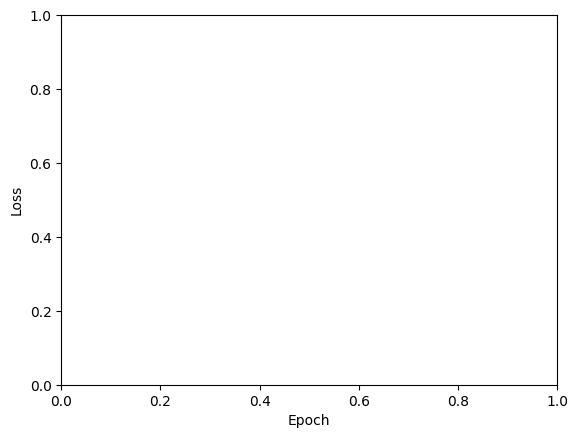

In [17]:
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(tr_loss, label='training_Loss')
plt.plot(vl_loss, label='validation_Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.plot(tr_precision, label='training_Precision')
plt.plot(vl_precision, label='validation_Precision')
plt.legend()
plt.grid(True)
plt.show()

plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.plot(tr_recall, label='training_Recall')
plt.plot(vl_recall, label='validation_Recall')
plt.legend()
plt.grid(True)
plt.show()

plt.xlabel("Epoch")
plt.ylabel("Micro-F1")
plt.plot(tr_f1, label='training_F1')
plt.plot(vl_f1, label='validation_F1')
plt.legend()
plt.grid(True)
plt.show()